# **ECE GY 7123 Deep Learning**

## *Final Project*:
## **A Confidence-Score Mechanism for Post-Processing OCR-ed Tibetan Manuscripts**

> Institute:


*   New York University

> Student Name:


*   Xiaoyu Wang
*   Yiren Dai

## 1. **Problem Statement**

Locating the exact words in ancient manuscripts is a crucial but time consuming task for
scholars in the humanities. In recent years, the Optical Character Recognition (OCR) technology has greatly facilitated
the digitization progress on ancient texts. However, the digitized e-text corpus contains many spelling errors. **Some handwritten Tibetan characters, such as “པ” and “བ” are indistinguishable to the naked eyes, and the OCR program cannot
capture these nuances.** Current popular spelling correction systems cannot correct Tibetan texts, and are not designed to
correct OCR-ed output.

## 2. **Project Goal**

The Google OCR output contains a confidence score for each character it recognizes. In general,
characters with higher than 80% confidence scores have an overall accuracy close to 100% based on human validation,
and characters with low confidence scores, such as 30%, require special attention. We propose to **implement a Tibetan
sequence-to-sequence model that incorporates a Confidence-score mechanism to target the OCR-ed output**, i.e., teach
the model to pay attention to the low confident character and copy the high confident characters during correction.

## 3. **Related Work**

There have been few attempts in applying these advances to the field of Tibetan studies. Powerful
deep seq2seq architectures, such as the Transformer, have demonstrated great improvement on translation tasks. In
particular, **the Attention mechanism has shown rich language understanding compared to more complex recurrent or
convolutional neural networks on English-to-German and English-to-French translation (Vaswani et al., 2017)**. Many
recent neural Grammatical Error Correction (GEC) models are trained on this type of Transformer architecture (JunczysDowmunt et al., 2018; Lichtarge et al., 2018). As a whole, our task of correcting the spelling errors in the OCR-ed Tibetan
corpus is very similar to the GEC task. 

## 4. **Install Project Related Packages**

*   datasets==2.8.0
*   Levenshtein == 0.20.8
*   matplotlib == 3.2.2
*   numpy == 1.21.6
*   pyvi == 0.1.1
*   seaborn == 0.11.2
*   spacy == 3.0.9
*   torch == 1.8.1
*   torchtext == 0.9.0
*   torchvision == 0.14.0+cu116
*   transformers == 4.12.2
*   vi-core-news-lg == 0.0.1


## 5. **Import Project Related Packages**

In [ ]:
# Import the necessary modules for this project:
import copy
import io
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sacrebleu
import seaborn
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import urllib.request 
import Levenshtein as ed

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from torch.autograd import Variable
from torchtext.legacy import data, datasets
from tqdm import tqdm
from wordcloud import WordCloud


## 6. **Check Runtime's GPU Availability**


In [ ]:
train_on_gpu = torch.cuda.is_available()
# check whether CUDA is available
if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    

CUDA is available


## 8. **Download Raw Data and Preprocess Datasets**

### 8.1 **Read RAW Datasets**

*   Fetch RAW Data (part_01 and part_02) from GitHub
*   Retrive datasets to local directory



In [ ]:
# Create the local folders if NOT exist
raw_data_folder_01 = "data/raw_data/part_01/pair_data/"
raw_data_folder_02 = "data/raw_data/part_02/pair_data/"

if not os.path.isdir(raw_data_folder_01):
    os.makedirs(raw_data_folder_01)
if not os.path.isdir(raw_data_folder_02):
    os.makedirs(raw_data_folder_02)

In [ ]:
# Downloading the csv file from Public GitHub account
raw_data_url_part_01 = "https://media.githubusercontent.com/media/yd1257/ece-gy-7123-deep-learning-final-project/main/data/raw_data/part_01/pair_data/raw_data_paired_01.csv"
raw_data_url_part_02 = "https://media.githubusercontent.com/media/yd1257/ece-gy-7123-deep-learning-final-project/main/data/raw_data/part_02/pair_data/raw_data_paired_02.csv"

raw_data_file_name_01 = "data/raw_data/part_01/pair_data/raw_data_paired_01.csv"
raw_data_file_name_02 = "data/raw_data/part_02/pair_data/raw_data_paired_02.csv"

# Save the RAW data to local folder
urllib.request.urlretrieve(raw_data_url_part_01, 
                           raw_data_file_name_01)

urllib.request.urlretrieve(raw_data_url_part_02, 
                           raw_data_file_name_02)

df_part_01 = pd.read_csv(raw_data_file_name_01)
df_part_02 = pd.read_csv(raw_data_file_name_02)

df = pd.concat([df_part_01, df_part_02])
df = df[df.ratio>=0.75]
df = df.drop(['ratio'], axis=1).reset_index(drop=True)

del df_part_01
del df_part_02

df

noisy_text  \
0                               ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།   
1      གི་བུ་འདི་མཐུ་ཡིན་ནོསྙམཆོད།དེ་ནི་དེ་ལྟ་མ་ཡིན་ཏ...   
2      དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟ...   
3      、ཨངགའི་རྒྱལ་པོ་ལྟར་བསདཔ་ཐོསནས་དེསསྒོ་ཁཅདདེ་ར་བ...   
4      སན[བ་གྲྭཕྱིདབུདབནང་འཁྲུག་རབ་ཏུཞི་བ།ཆོམ་རྐུན་དང...   
...                                                  ...   
81597  562མ་ཡིནནོ།།དཔེ་ཡངམགྲུབ་པའི་ཕྱིརཔོཞེས་བྱབར་དགོ...   
81598  565ཨ།ཡིན་ཏེ།དཔེར་ནམའམེསྣང་བའི་རྒྱུཡིན་པ་བཞིན་ན...   
81599  566ཁྱདཔར་ཅནའཇུགཔའིརྒྱུཡིནཔའིཕྱིར་འགྲོགདངུལྡནཔའ...   
81600  567ལཤིས་བརྒྱབཞི་དཔགཔསྨཱབར་རིགས་ཏེ།ངེད་འགྲོ་བསྒ...   
81601  571V"༣གནུགྱུརླགནརེརྟོགགེསྙམཔོའི་བསྟན་བཅོས་ཙམཚེ...   

                                             confi_score  \
0      ['0.32', '0.32', '0.14', '0.7', '0.24', '0.99'...   
1      ['0.99', '0.99', '0.97', '0.65', '0.65', '0.9'...   
2      ['0.99', '0.87', '0.07', '0.26', '0.28', '0.6'...   
3      ['0.79', '0.97', '0.96', '0.81', '0.74', '0.74...   
4      ['0.92', '0.76', '0.43', '0.43', '0.65', '0.15...   
...                                                  ...   
81597  ['0.99', '0.99', '0.99', '0.64', '0.49', '0.95...   
81598  ['0.99', '0.99', '0.99', '0.6', '0.67', '0.97'...   
81599  ['0.99', '0.99', '0.99', '0.99', '0.99', '0.9'...   
81600  ['0.99', '0.99', '0.99', '0.97', '0.1', '0.1',...   
81601  ['0.99', '0.99', '0.97', '0.27', '0.79', '0.31...   

                                               true_text  
0                              ༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ། །  
1      གི་བུ་འདིའི་མཐུ་ཡིན་ནོ་སྙམ་མོད་ཀྱི། དེ་ནི་དེ་ལ...  
2      དང་། གཅད་པ་དང་། དྲལ་བ་དང་། དབུག་པ་དང་། གནས་ལྔ་...  
3      ཨང་གའི་རྒྱལ་པོ་ཇི་ལྟར་བསད་པ་ཐོས་ནས་དེས་སྒོ་བཅད...  
4      བ་དང་། ཕྱི་དགྲ་དང་། ནང་འཁྲུག་རབ་ཏུ་ཞི་བ། ཆོམ་ར...  
...                                                  ...  
81597  མ་ཡིན་ནོ། །དཔེ་ཡང་མ་གྲུབ་པའི་ཕྱིར་རོ་ཞེས་བྱ་བར...  
81598  ཡིན་ཏེ། དཔེར་ན་མར་མེ་སྣང་བའི་རྒྱུ་ཡིན་པ་བཞིན་ན...  
81599  ཁྱད་པར་ཅན་འཇུག་པའི་རྒྱུ་ཡིན་པའི་ཕྱིར་འགྲོ་བ་དང...  
81600  དཔག་པ་སྨྲ་བར་རིགས་ཏེ། ངེད་འགྲོ་བ་སྨྲ་བ་དག་འགྲོ...  
81601  ན་རེ། རྟོག་གེ་སྐམ་པོའི་བསྟན་བཅོས་ཙམ་ཉི་ཚེས་བསྒ...  

[81602 rows x 3 columns]

In [ ]:
# change a string of list to list
c = df.confi_score.values
c = [score.replace('nan', '0.0') for score in c]
c = [score.replace("'", '') for score in c]
c = [score[1:-1].split(", ") for score in c]
c = [[round(float(i), 2) for i in l] for l in c]
df['confi_score'] = c

In [ ]:
df

noisy_text  \
0                               ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།   
1      གི་བུ་འདི་མཐུ་ཡིན་ནོསྙམཆོད།དེ་ནི་དེ་ལྟ་མ་ཡིན་ཏ...   
2      དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟ...   
3      、ཨངགའི་རྒྱལ་པོ་ལྟར་བསདཔ་ཐོསནས་དེསསྒོ་ཁཅདདེ་ར་བ...   
4      སན[བ་གྲྭཕྱིདབུདབནང་འཁྲུག་རབ་ཏུཞི་བ།ཆོམ་རྐུན་དང...   
...                                                  ...   
81597  562མ་ཡིནནོ།།དཔེ་ཡངམགྲུབ་པའི་ཕྱིརཔོཞེས་བྱབར་དགོ...   
81598  565ཨ།ཡིན་ཏེ།དཔེར་ནམའམེསྣང་བའི་རྒྱུཡིན་པ་བཞིན་ན...   
81599  566ཁྱདཔར་ཅནའཇུགཔའིརྒྱུཡིནཔའིཕྱིར་འགྲོགདངུལྡནཔའ...   
81600  567ལཤིས་བརྒྱབཞི་དཔགཔསྨཱབར་རིགས་ཏེ།ངེད་འགྲོ་བསྒ...   
81601  571V"༣གནུགྱུརླགནརེརྟོགགེསྙམཔོའི་བསྟན་བཅོས་ཙམཚེ...   

                                             confi_score  \
0      [0.32, 0.32, 0.14, 0.7, 0.24, 0.99, 1.0, 1.0, ...   
1      [0.99, 0.99, 0.97, 0.65, 0.65, 0.9, 0.87, 0.99...   
2      [0.99, 0.87, 0.07, 0.26, 0.28, 0.6, 0.65, 0.88...   
3      [0.79, 0.97, 0.96, 0.81, 0.74, 0.74, 0.59, 0.8...   
4      [0.92, 0.76, 0.43, 0.43, 0.65, 0.15, 0.15, 0.1...   
...                                                  ...   
81597  [0.99, 0.99, 0.99, 0.64, 0.49, 0.95, 0.95, 0.9...   
81598  [0.99, 0.99, 0.99, 0.6, 0.67, 0.97, 0.97, 0.96...   
81599  [0.99, 0.99, 0.99, 0.99, 0.99, 0.9, 0.99, 0.5,...   
81600  [0.99, 0.99, 0.99, 0.97, 0.1, 0.1, 0.18, 0.29,...   
81601  [0.99, 0.99, 0.97, 0.27, 0.79, 0.31, 0.65, 0.1...   

                                               true_text  
0                              ༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ། །  
1      གི་བུ་འདིའི་མཐུ་ཡིན་ནོ་སྙམ་མོད་ཀྱི། དེ་ནི་དེ་ལ...  
2      དང་། གཅད་པ་དང་། དྲལ་བ་དང་། དབུག་པ་དང་། གནས་ལྔ་...  
3      ཨང་གའི་རྒྱལ་པོ་ཇི་ལྟར་བསད་པ་ཐོས་ནས་དེས་སྒོ་བཅད...  
4      བ་དང་། ཕྱི་དགྲ་དང་། ནང་འཁྲུག་རབ་ཏུ་ཞི་བ། ཆོམ་ར...  
...                                                  ...  
81597  མ་ཡིན་ནོ། །དཔེ་ཡང་མ་གྲུབ་པའི་ཕྱིར་རོ་ཞེས་བྱ་བར...  
81598  ཡིན་ཏེ། དཔེར་ན་མར་མེ་སྣང་བའི་རྒྱུ་ཡིན་པ་བཞིན་ན...  
81599  ཁྱད་པར་ཅན་འཇུག་པའི་རྒྱུ་ཡིན་པའི་ཕྱིར་འགྲོ་བ་དང...  
81600  དཔག་པ་སྨྲ་བར་རིགས་ཏེ། ངེད་འགྲོ་བ་སྨྲ་བ་དག་འགྲོ...  
81601  ན་རེ། རྟོག་གེ་སྐམ་པོའི་བསྟན་བཅོས་ཙམ་ཉི་ཚེས་བསྒ...  

[81602 rows x 3 columns]

In [ ]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
    
kkk = flatten(c)
print(set(kkk))
print(f'num of unique confidence scores: {len(set(kkk))}')

{0.24, 0.99, 0.7, 1.0, 0.81, 0.47, 0.96, 0.5, 0.76, 0.26, 0.75, 0.25, 0.0, 0.22, 0.79, 0.21, 0.23, 0.54, 0.13, 0.88, 0.38, 0.63, 0.97, 0.72, 0.43, 0.19, 0.45, 0.46, 0.41, 0.42, 0.18, 0.44, 0.2, 0.51, 0.85, 0.35, 0.94, 0.69, 0.17, 0.16, 0.15, 0.8, 0.55, 0.64, 0.89, 0.39, 0.98, 0.73, 0.48, 0.57, 0.82, 0.14, 0.87, 0.92, 0.67, 0.84, 0.59, 0.58, 0.68, 0.93, 0.6, 0.11, 0.52, 0.77, 0.27, 0.66, 0.86, 0.61, 0.36, 0.95, 0.09, 0.1, 0.08, 0.56, 0.65, 0.9, 0.4, 0.74, 0.49, 0.83, 0.32, 0.34, 0.29, 0.3, 0.31, 0.07, 0.33, 0.06, 0.05, 0.04, 0.53, 0.78, 0.28, 0.62, 0.12, 0.37, 0.03, 0.71, 0.02, 0.01, 0.91}
num of unique confidence scores: 101


### 8.2 **Read Tokenizer Datasets**

*   Fetch Tokenizer Datasets from GitHub
*   Retrive datasets to local directory



In [ ]:
# Create the local folders if NOT exist
tokenizer_folder = "data/tokenizer_data/"

if not os.path.isdir(tokenizer_folder):
    os.makedirs(tokenizer_folder)


In [ ]:
# Downloading the files from Public GitHub account
tokenizer_train_data_url = "https://media.githubusercontent.com/media/yd1257/ece-gy-7123-deep-learning-final-project/main/data/tokenizer_data/noisy_data_train.txt"
bpe_tokenizer_url_part = "https://raw.githubusercontent.com/yd1257/ece-gy-7123-deep-learning-final-project/main/data/tokenizer_data/bpe_tokenizer_500.json"

tokenizer_train_data_file_name = "data/tokenizer_data/noisy_data_train.txt"
bpe_tokenizer_file_name = "data/tokenizer_data/bpe_tokenizer_500.json"

# Save the Tokenizer data to local folder
urllib.request.urlretrieve(tokenizer_train_data_url, 
                           tokenizer_train_data_file_name)

urllib.request.urlretrieve(bpe_tokenizer_url_part, 
                           bpe_tokenizer_file_name)


('data/tokenizer_data/bpe_tokenizer_500.json',
 <http.client.HTTPMessage at 0x14665911bca0>)

### 8.3 **Validate and QA the Datasets**

*   Check the size of the vocabulary
*   Validate the source and target sentence list


In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace('་')
tokenizer = tokenizer.from_file(bpe_tokenizer_file_name)

print("The size of vocabulary is: ", tokenizer.get_vocab_size())

The size of vocabulary is:  561


In [ ]:
# Set the maximum sentence length
MAX_SENT_LENGTH = 510

# Get the source and target vocabulary
src_vocab_set = list(tokenizer.get_vocab().keys())
trg_vocab_set = list(tokenizer.get_vocab().keys())

# source
src_sentences_list = df.noisy_text.values.tolist()
src_sentences_list = [i[:MAX_SENT_LENGTH] for i in src_sentences_list]
# confidence score
confi_list = df.confi_score.values.tolist()
confi_list = [i[:MAX_SENT_LENGTH] for i in confi_list]
# target
trg_sentences_list = df.true_text.values.tolist()
trg_sentences_list = [i[:MAX_SENT_LENGTH] for i in trg_sentences_list]

# get train
train_src_sentences_list = src_sentences_list[:int(len(src_sentences_list)*0.9)]
train_confi_list = confi_list[:int(len(src_sentences_list)*0.9)]
train_trg_sentences_list = trg_sentences_list[:int(len(trg_sentences_list)*0.9)]

# get test
test_src_sentences_list = src_sentences_list[int(len(src_sentences_list)*0.9):]
test_confi_list = confi_list[int(len(src_sentences_list)*0.9):]
test_trg_sentences_list = trg_sentences_list[int(len(trg_sentences_list)*0.9):]


In [ ]:
# Validate the source and target sentence list
assert len(train_src_sentences_list) == len(train_confi_list)
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

assert len(test_src_sentences_list) == len(test_confi_list)
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

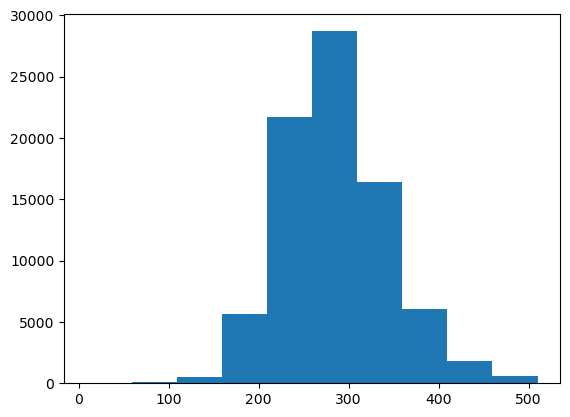

In [ ]:
s_len = [len(i) for i in src_sentences_list]
plt.hist(s_len);

In [ ]:
print("The maximum sentence length is: ", max(s_len))

The maximum sentence length is:  510


In [ ]:
print("The length of Source Sentence List is: ", len(src_sentences_list))
print("The length of Target Sentence List is: ", len(trg_sentences_list))


The length of Source Sentence List is:  81602
The length of Target Sentence List is:  81602


## 9. **Clean and Process the Source and Target Sentence for Model**

### 9.1 **Clean and Process the data for modelling purpose**

*   Create the Train and Test Data
*   Create the Validation Data
*   Create the BLEU Score Data

In [ ]:
MAX_SENT_LENGTH = 510
# Set the maximum sentence length, which include the start of sentence and end of sentence
MAX_SENT_LENGTH_PLUS_SOS_EOS = 512

In [ ]:
# We only keep sentences that do not exceed 98 words, so that later when we
# add <s> and </s> to a sentence it still won't exceed 100 words.
def filter_data(src_sentences_list, 
                trg_sentences_list, 
                max_len):
    new_src_sentences_list, new_trg_sentences_list = [], []
    for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
        if (len(src_sent) <= max_len and 
            len(trg_sent) <= max_len and 
            len(src_sent) > 0 and 
            len(trg_sent)) > 0:

            # Add the source sentence to the new source sentence list
            new_src_sentences_list.append(src_sent)

            # Add the target sentence to the new source sentence list
            new_trg_sentences_list.append(trg_sent)

    return new_src_sentences_list, new_trg_sentences_list
    

In [ ]:
# Filter the training data
train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, 
    train_trg_sentences_list, 
    max_len=MAX_SENT_LENGTH)

# Filter the test data
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, 
    test_trg_sentences_list, 
    max_len=MAX_SENT_LENGTH)

# We take 10% of the training data to be the validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
val_confi_list = train_confi_list[:num_val]

# Exclude the validation sentences from training
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]
train_confi_list = train_confi_list[num_val:]

# take 5000 sentences to compute BLEU score
BLEU_src_sentences_list = val_src_sentences_list[:1000]
BLEU_trg_sentences_list = val_trg_sentences_list[:1000]
BLEU_confi_list = val_confi_list[:1000]


### 9.2 **Show the Processed Data with Basic Statistic Results**

*   Show the basic model data information
*   Show sample noisy data

Number of training (src, trg) sentence pairs: 66097
Number of validation (src, trg) sentence pairs: 7344
Number of testing (src, trg) sentence pairs: 8161
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 562
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 562
Training sentence avg. length: 286 
Training sentence length at 95-percentile: 392
Training sentence length distribution (x-axis is length range and y-axis is count):



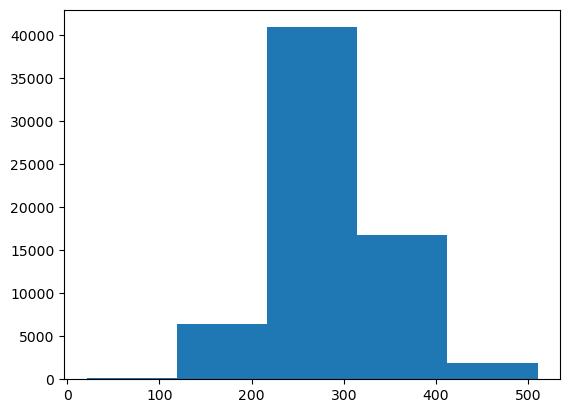

In [ ]:

# Show some data stats
print("Number of training (src, trg) sentence pairs: %d" %
      len(train_src_sentences_list))

print("Number of validation (src, trg) sentence pairs: %d" %
      len(val_src_sentences_list))

print("Number of testing (src, trg) sentence pairs: %d" %
      len(test_src_sentences_list))

src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ' % np.mean(length))
print('Training sentence length at 95-percentile: %d' %
      np.percentile(length, 95))
print('Training sentence length distribution '
      '(x-axis is length range and y-axis is count):\n')

plt.hist(length, bins=5)
plt.show()


In [ ]:
print('Example noisy input: ' + str(train_src_sentences_list[0]))
print('Its target clean output: ' + str(train_trg_sentences_list[0]))


Example noisy input: ལུས་འཕགས་ཀྱི་རྒྱལ་བོས་ཐོསནས་དཔག་ཚད་ཕྱེདདང་གསུམ་གྱི་ལམ་བསྟར་དུ་བཞུགསྟེ།གྲོང་ཁྱེར་དེ་ཐམས་ཅད་རྫོབ་དང་གསེག་མདང་།རྒྱུ་སོབསལ་ནས་རྒྱལ་མཚན་དངབ་དནནབསྒྲེང་།དར་གྱིཆུན་འཕྱམ་བོནདིཔྱངས།
Its target clean output: ར་ཆས་སོ། །དེ་ནས་ལུས་འཕགས་ཀྱི་རྒྱལ་པོས་ཐོས་ནས་དཔག་ཚད་ཕྱེད་དང་གསུམ་གྱི་ལམ་བསྟར་དུ་བཅུག་སྟེ། གྲོང་ཁྱེར་དེ་ཐམས་ཅད་རྡོ་བ་དང་གསེག་མ་དང་། གྱོ་མོ་བསལ་ནས་རྒྱལ་མཚན་དང་བ་དན་ནི་བསྒྲེང་། དར་གྱི་ཆུན་འཕྱང་མང་པོ་ནི་དཔྱངས།


### 9.3 **Build Vocabulary Data**

*   tokenize the data


In [ ]:
# Create get_matched_confi_list function
def get_matched_confi_list(confi_list, 
                           src_sentences_list):

  matched_confi_list = []
  for n, sentence in enumerate(src_sentences_list):
    print(f'on {n} sentence')
    sentence_tokens = tokenizer.encode(sentence).tokens
    i = 0
    matched_confi = []
    for tok in sentence_tokens:
      idx_len = len(tok)
      idx_start = i
      i += idx_len
      idx_end = i
      c_score = min(confi_list[n][idx_start:idx_end])
      matched_confi.append(int(100*c_score) if not math.isnan(c_score) else 0)

    assert len(matched_confi)==len(sentence_tokens) 
    matched_confi_list.append(matched_confi)
  return matched_confi_list

In [ ]:
# Create the tokenize function for different languages

def tokenize_src(text):
    return tokenizer.encode(text).tokens

def tokenize_trg(text):
    return tokenizer.encode(text).tokens

# write a function to process confidence score
def tokenize_confi(confi):
    return confi # list of float

In [ ]:
# Generate the source and target data with field
SRC = data.Field(tokenize=tokenize_src, pad_token='<pad>')
CONFI = data.Field(tokenize=tokenize_confi, pad_token='<pad>') # need to pad or not?
TRG = data.Field(tokenize=tokenize_trg, pad_token='<pad>',
            init_token='<s>', eos_token='</s>')
fields = [("src", SRC),("trg", TRG),("confi", CONFI)]


In [ ]:
# edit this function below to add confi
def get_examples(src_sent_list, trg_sent_list, confid_list):
    examples = []
    for src_sent, trg_sent, confid in zip(src_sent_list, trg_sent_list, confid_list): ##
        example = data.Example.fromlist([src_sent, trg_sent, confid], fields=fields)
        examples.append(example)
    return examples

In [ ]:

train_confi_list = get_matched_confi_list(train_confi_list, 
                                          train_src_sentences_list)
test_confi_list = get_matched_confi_list(test_confi_list, 
                                         test_src_sentences_list)
val_confi_list = get_matched_confi_list(val_confi_list, 
                                        val_src_sentences_list)
BLEU_confi_list = get_matched_confi_list(BLEU_confi_list, 
                                         BLEU_src_sentences_list)

# Get the train_examples
train_examples = get_examples(train_src_sentences_list,
                              train_trg_sentences_list,
                              train_confi_list)

# Get the val_examples
val_examples = get_examples(val_src_sentences_list,
                            val_trg_sentences_list,
                            val_confi_list)

# Get the test_examples
test_examples = get_examples(test_src_sentences_list,
                             test_trg_sentences_list,
                             test_confi_list)

# Get the BLEU_examples
BLEU_examples = get_examples(BLEU_src_sentences_list,
                            BLEU_trg_sentences_list,
                            BLEU_confi_list)

train = data.Dataset(train_examples, 
                     fields)

val = data.Dataset(val_examples, 
                   fields)

test = data.Dataset(test_examples, 
                    fields)

BLEU_test = data.Dataset(BLEU_examples, 
                         fields)

SRC.build_vocab(train.src)
CONFI.build_vocab(train.confi)
TRG.build_vocab(train.trg)

on 0 sentence
on 1 sentence
on 2 sentence
on 3 sentence
on 4 sentence
on 5 sentence
on 6 sentence
on 7 sentence
on 8 sentence
on 9 sentence
on 10 sentence
on 11 sentence
on 12 sentence
on 13 sentence
on 14 sentence
on 15 sentence
on 16 sentence
on 17 sentence
on 18 sentence
on 19 sentence
on 20 sentence
on 21 sentence
on 22 sentence
on 23 sentence
on 24 sentence
on 25 sentence
on 26 sentence
on 27 sentence
on 28 sentence
on 29 sentence
on 30 sentence
on 31 sentence
on 32 sentence
on 33 sentence
on 34 sentence
on 35 sentence
on 36 sentence
on 37 sentence
on 38 sentence
on 39 sentence
on 40 sentence
on 41 sentence
on 42 sentence
on 43 sentence
on 44 sentence
on 45 sentence
on 46 sentence
on 47 sentence
on 48 sentence
on 49 sentence
on 50 sentence
on 51 sentence
on 52 sentence
on 53 sentence
on 54 sentence
on 55 sentence
on 56 sentence
on 57 sentence
on 58 sentence
on 59 sentence
on 60 sentence
on 61 sentence
on 62 sentence
on 63 sentence
on 64 sentence
on 65 sentence
on 66 sentence
on 67

on 529 sentence
on 530 sentence
on 531 sentence
on 532 sentence
on 533 sentence
on 534 sentence
on 535 sentence
on 536 sentence
on 537 sentence
on 538 sentence
on 539 sentence
on 540 sentence
on 541 sentence
on 542 sentence
on 543 sentence
on 544 sentence
on 545 sentence
on 546 sentence
on 547 sentence
on 548 sentence
on 549 sentence
on 550 sentence
on 551 sentence
on 552 sentence
on 553 sentence
on 554 sentence
on 555 sentence
on 556 sentence
on 557 sentence
on 558 sentence
on 559 sentence
on 560 sentence
on 561 sentence
on 562 sentence
on 563 sentence
on 564 sentence
on 565 sentence
on 566 sentence
on 567 sentence
on 568 sentence
on 569 sentence
on 570 sentence
on 571 sentence
on 572 sentence
on 573 sentence
on 574 sentence
on 575 sentence
on 576 sentence
on 577 sentence
on 578 sentence
on 579 sentence
on 580 sentence
on 581 sentence
on 582 sentence
on 583 sentence
on 584 sentence
on 585 sentence
on 586 sentence
on 587 sentence
on 588 sentence
on 589 sentence
on 590 sentence
on 591 s

on 1114 sentence
on 1115 sentence
on 1116 sentence
on 1117 sentence
on 1118 sentence
on 1119 sentence
on 1120 sentence
on 1121 sentence
on 1122 sentence
on 1123 sentence
on 1124 sentence
on 1125 sentence
on 1126 sentence
on 1127 sentence
on 1128 sentence
on 1129 sentence
on 1130 sentence
on 1131 sentence
on 1132 sentence
on 1133 sentence
on 1134 sentence
on 1135 sentence
on 1136 sentence
on 1137 sentence
on 1138 sentence
on 1139 sentence
on 1140 sentence
on 1141 sentence
on 1142 sentence
on 1143 sentence
on 1144 sentence
on 1145 sentence
on 1146 sentence
on 1147 sentence
on 1148 sentence
on 1149 sentence
on 1150 sentence
on 1151 sentence
on 1152 sentence
on 1153 sentence
on 1154 sentence
on 1155 sentence
on 1156 sentence
on 1157 sentence
on 1158 sentence
on 1159 sentence
on 1160 sentence
on 1161 sentence
on 1162 sentence
on 1163 sentence
on 1164 sentence
on 1165 sentence
on 1166 sentence
on 1167 sentence
on 1168 sentence
on 1169 sentence
on 1170 sentence
on 1171 sentence
on 1172 senten

on 1746 sentence
on 1747 sentence
on 1748 sentence
on 1749 sentence
on 1750 sentence
on 1751 sentence
on 1752 sentence
on 1753 sentence
on 1754 sentence
on 1755 sentence
on 1756 sentence
on 1757 sentence
on 1758 sentence
on 1759 sentence
on 1760 sentence
on 1761 sentence
on 1762 sentence
on 1763 sentence
on 1764 sentence
on 1765 sentence
on 1766 sentence
on 1767 sentence
on 1768 sentence
on 1769 sentence
on 1770 sentence
on 1771 sentence
on 1772 sentence
on 1773 sentence
on 1774 sentence
on 1775 sentence
on 1776 sentence
on 1777 sentence
on 1778 sentence
on 1779 sentence
on 1780 sentence
on 1781 sentence
on 1782 sentence
on 1783 sentence
on 1784 sentence
on 1785 sentence
on 1786 sentence
on 1787 sentence
on 1788 sentence
on 1789 sentence
on 1790 sentence
on 1791 sentence
on 1792 sentence
on 1793 sentence
on 1794 sentence
on 1795 sentence
on 1796 sentence
on 1797 sentence
on 1798 sentence
on 1799 sentence
on 1800 sentence
on 1801 sentence
on 1802 sentence
on 1803 sentence
on 1804 senten

on 2410 sentence
on 2411 sentence
on 2412 sentence
on 2413 sentence
on 2414 sentence
on 2415 sentence
on 2416 sentence
on 2417 sentence
on 2418 sentence
on 2419 sentence
on 2420 sentence
on 2421 sentence
on 2422 sentence
on 2423 sentence
on 2424 sentence
on 2425 sentence
on 2426 sentence
on 2427 sentence
on 2428 sentence
on 2429 sentence
on 2430 sentence
on 2431 sentence
on 2432 sentence
on 2433 sentence
on 2434 sentence
on 2435 sentence
on 2436 sentence
on 2437 sentence
on 2438 sentence
on 2439 sentence
on 2440 sentence
on 2441 sentence
on 2442 sentence
on 2443 sentence
on 2444 sentence
on 2445 sentence
on 2446 sentence
on 2447 sentence
on 2448 sentence
on 2449 sentence
on 2450 sentence
on 2451 sentence
on 2452 sentence
on 2453 sentence
on 2454 sentence
on 2455 sentence
on 2456 sentence
on 2457 sentence
on 2458 sentence
on 2459 sentence
on 2460 sentence
on 2461 sentence
on 2462 sentence
on 2463 sentence
on 2464 sentence
on 2465 sentence
on 2466 sentence
on 2467 sentence
on 2468 senten

on 3081 sentence
on 3082 sentence
on 3083 sentence
on 3084 sentence
on 3085 sentence
on 3086 sentence
on 3087 sentence
on 3088 sentence
on 3089 sentence
on 3090 sentence
on 3091 sentence
on 3092 sentence
on 3093 sentence
on 3094 sentence
on 3095 sentence
on 3096 sentence
on 3097 sentence
on 3098 sentence
on 3099 sentence
on 3100 sentence
on 3101 sentence
on 3102 sentence
on 3103 sentence
on 3104 sentence
on 3105 sentence
on 3106 sentence
on 3107 sentence
on 3108 sentence
on 3109 sentence
on 3110 sentence
on 3111 sentence
on 3112 sentence
on 3113 sentence
on 3114 sentence
on 3115 sentence
on 3116 sentence
on 3117 sentence
on 3118 sentence
on 3119 sentence
on 3120 sentence
on 3121 sentence
on 3122 sentence
on 3123 sentence
on 3124 sentence
on 3125 sentence
on 3126 sentence
on 3127 sentence
on 3128 sentence
on 3129 sentence
on 3130 sentence
on 3131 sentence
on 3132 sentence
on 3133 sentence
on 3134 sentence
on 3135 sentence
on 3136 sentence
on 3137 sentence
on 3138 sentence
on 3139 senten

on 3757 sentence
on 3758 sentence
on 3759 sentence
on 3760 sentence
on 3761 sentence
on 3762 sentence
on 3763 sentence
on 3764 sentence
on 3765 sentence
on 3766 sentence
on 3767 sentence
on 3768 sentence
on 3769 sentence
on 3770 sentence
on 3771 sentence
on 3772 sentence
on 3773 sentence
on 3774 sentence
on 3775 sentence
on 3776 sentence
on 3777 sentence
on 3778 sentence
on 3779 sentence
on 3780 sentence
on 3781 sentence
on 3782 sentence
on 3783 sentence
on 3784 sentence
on 3785 sentence
on 3786 sentence
on 3787 sentence
on 3788 sentence
on 3789 sentence
on 3790 sentence
on 3791 sentence
on 3792 sentence
on 3793 sentence
on 3794 sentence
on 3795 sentence
on 3796 sentence
on 3797 sentence
on 3798 sentence
on 3799 sentence
on 3800 sentence
on 3801 sentence
on 3802 sentence
on 3803 sentence
on 3804 sentence
on 3805 sentence
on 3806 sentence
on 3807 sentence
on 3808 sentence
on 3809 sentence
on 3810 sentence
on 3811 sentence
on 3812 sentence
on 3813 sentence
on 3814 sentence
on 3815 senten

on 4350 sentence
on 4351 sentence
on 4352 sentence
on 4353 sentence
on 4354 sentence
on 4355 sentence
on 4356 sentence
on 4357 sentence
on 4358 sentence
on 4359 sentence
on 4360 sentence
on 4361 sentence
on 4362 sentence
on 4363 sentence
on 4364 sentence
on 4365 sentence
on 4366 sentence
on 4367 sentence
on 4368 sentence
on 4369 sentence
on 4370 sentence
on 4371 sentence
on 4372 sentence
on 4373 sentence
on 4374 sentence
on 4375 sentence
on 4376 sentence
on 4377 sentence
on 4378 sentence
on 4379 sentence
on 4380 sentence
on 4381 sentence
on 4382 sentence
on 4383 sentence
on 4384 sentence
on 4385 sentence
on 4386 sentence
on 4387 sentence
on 4388 sentence
on 4389 sentence
on 4390 sentence
on 4391 sentence
on 4392 sentence
on 4393 sentence
on 4394 sentence
on 4395 sentence
on 4396 sentence
on 4397 sentence
on 4398 sentence
on 4399 sentence
on 4400 sentence
on 4401 sentence
on 4402 sentence
on 4403 sentence
on 4404 sentence
on 4405 sentence
on 4406 sentence
on 4407 sentence
on 4408 senten

on 4933 sentence
on 4934 sentence
on 4935 sentence
on 4936 sentence
on 4937 sentence
on 4938 sentence
on 4939 sentence
on 4940 sentence
on 4941 sentence
on 4942 sentence
on 4943 sentence
on 4944 sentence
on 4945 sentence
on 4946 sentence
on 4947 sentence
on 4948 sentence
on 4949 sentence
on 4950 sentence
on 4951 sentence
on 4952 sentence
on 4953 sentence
on 4954 sentence
on 4955 sentence
on 4956 sentence
on 4957 sentence
on 4958 sentence
on 4959 sentence
on 4960 sentence
on 4961 sentence
on 4962 sentence
on 4963 sentence
on 4964 sentence
on 4965 sentence
on 4966 sentence
on 4967 sentence
on 4968 sentence
on 4969 sentence
on 4970 sentence
on 4971 sentence
on 4972 sentence
on 4973 sentence
on 4974 sentence
on 4975 sentence
on 4976 sentence
on 4977 sentence
on 4978 sentence
on 4979 sentence
on 4980 sentence
on 4981 sentence
on 4982 sentence
on 4983 sentence
on 4984 sentence
on 4985 sentence
on 4986 sentence
on 4987 sentence
on 4988 sentence
on 4989 sentence
on 4990 sentence
on 4991 senten

on 5523 sentence
on 5524 sentence
on 5525 sentence
on 5526 sentence
on 5527 sentence
on 5528 sentence
on 5529 sentence
on 5530 sentence
on 5531 sentence
on 5532 sentence
on 5533 sentence
on 5534 sentence
on 5535 sentence
on 5536 sentence
on 5537 sentence
on 5538 sentence
on 5539 sentence
on 5540 sentence
on 5541 sentence
on 5542 sentence
on 5543 sentence
on 5544 sentence
on 5545 sentence
on 5546 sentence
on 5547 sentence
on 5548 sentence
on 5549 sentence
on 5550 sentence
on 5551 sentence
on 5552 sentence
on 5553 sentence
on 5554 sentence
on 5555 sentence
on 5556 sentence
on 5557 sentence
on 5558 sentence
on 5559 sentence
on 5560 sentence
on 5561 sentence
on 5562 sentence
on 5563 sentence
on 5564 sentence
on 5565 sentence
on 5566 sentence
on 5567 sentence
on 5568 sentence
on 5569 sentence
on 5570 sentence
on 5571 sentence
on 5572 sentence
on 5573 sentence
on 5574 sentence
on 5575 sentence
on 5576 sentence
on 5577 sentence
on 5578 sentence
on 5579 sentence
on 5580 sentence
on 5581 senten

on 6154 sentence
on 6155 sentence
on 6156 sentence
on 6157 sentence
on 6158 sentence
on 6159 sentence
on 6160 sentence
on 6161 sentence
on 6162 sentence
on 6163 sentence
on 6164 sentence
on 6165 sentence
on 6166 sentence
on 6167 sentence
on 6168 sentence
on 6169 sentence
on 6170 sentence
on 6171 sentence
on 6172 sentence
on 6173 sentence
on 6174 sentence
on 6175 sentence
on 6176 sentence
on 6177 sentence
on 6178 sentence
on 6179 sentence
on 6180 sentence
on 6181 sentence
on 6182 sentence
on 6183 sentence
on 6184 sentence
on 6185 sentence
on 6186 sentence
on 6187 sentence
on 6188 sentence
on 6189 sentence
on 6190 sentence
on 6191 sentence
on 6192 sentence
on 6193 sentence
on 6194 sentence
on 6195 sentence
on 6196 sentence
on 6197 sentence
on 6198 sentence
on 6199 sentence
on 6200 sentence
on 6201 sentence
on 6202 sentence
on 6203 sentence
on 6204 sentence
on 6205 sentence
on 6206 sentence
on 6207 sentence
on 6208 sentence
on 6209 sentence
on 6210 sentence
on 6211 sentence
on 6212 senten

on 6774 sentence
on 6775 sentence
on 6776 sentence
on 6777 sentence
on 6778 sentence
on 6779 sentence
on 6780 sentence
on 6781 sentence
on 6782 sentence
on 6783 sentence
on 6784 sentence
on 6785 sentence
on 6786 sentence
on 6787 sentence
on 6788 sentence
on 6789 sentence
on 6790 sentence
on 6791 sentence
on 6792 sentence
on 6793 sentence
on 6794 sentence
on 6795 sentence
on 6796 sentence
on 6797 sentence
on 6798 sentence
on 6799 sentence
on 6800 sentence
on 6801 sentence
on 6802 sentence
on 6803 sentence
on 6804 sentence
on 6805 sentence
on 6806 sentence
on 6807 sentence
on 6808 sentence
on 6809 sentence
on 6810 sentence
on 6811 sentence
on 6812 sentence
on 6813 sentence
on 6814 sentence
on 6815 sentence
on 6816 sentence
on 6817 sentence
on 6818 sentence
on 6819 sentence
on 6820 sentence
on 6821 sentence
on 6822 sentence
on 6823 sentence
on 6824 sentence
on 6825 sentence
on 6826 sentence
on 6827 sentence
on 6828 sentence
on 6829 sentence
on 6830 sentence
on 6831 sentence
on 6832 senten

on 7415 sentence
on 7416 sentence
on 7417 sentence
on 7418 sentence
on 7419 sentence
on 7420 sentence
on 7421 sentence
on 7422 sentence
on 7423 sentence
on 7424 sentence
on 7425 sentence
on 7426 sentence
on 7427 sentence
on 7428 sentence
on 7429 sentence
on 7430 sentence
on 7431 sentence
on 7432 sentence
on 7433 sentence
on 7434 sentence
on 7435 sentence
on 7436 sentence
on 7437 sentence
on 7438 sentence
on 7439 sentence
on 7440 sentence
on 7441 sentence
on 7442 sentence
on 7443 sentence
on 7444 sentence
on 7445 sentence
on 7446 sentence
on 7447 sentence
on 7448 sentence
on 7449 sentence
on 7450 sentence
on 7451 sentence
on 7452 sentence
on 7453 sentence
on 7454 sentence
on 7455 sentence
on 7456 sentence
on 7457 sentence
on 7458 sentence
on 7459 sentence
on 7460 sentence
on 7461 sentence
on 7462 sentence
on 7463 sentence
on 7464 sentence
on 7465 sentence
on 7466 sentence
on 7467 sentence
on 7468 sentence
on 7469 sentence
on 7470 sentence
on 7471 sentence
on 7472 sentence
on 7473 senten

on 7962 sentence
on 7963 sentence
on 7964 sentence
on 7965 sentence
on 7966 sentence
on 7967 sentence
on 7968 sentence
on 7969 sentence
on 7970 sentence
on 7971 sentence
on 7972 sentence
on 7973 sentence
on 7974 sentence
on 7975 sentence
on 7976 sentence
on 7977 sentence
on 7978 sentence
on 7979 sentence
on 7980 sentence
on 7981 sentence
on 7982 sentence
on 7983 sentence
on 7984 sentence
on 7985 sentence
on 7986 sentence
on 7987 sentence
on 7988 sentence
on 7989 sentence
on 7990 sentence
on 7991 sentence
on 7992 sentence
on 7993 sentence
on 7994 sentence
on 7995 sentence
on 7996 sentence
on 7997 sentence
on 7998 sentence
on 7999 sentence
on 8000 sentence
on 8001 sentence
on 8002 sentence
on 8003 sentence
on 8004 sentence
on 8005 sentence
on 8006 sentence
on 8007 sentence
on 8008 sentence
on 8009 sentence
on 8010 sentence
on 8011 sentence
on 8012 sentence
on 8013 sentence
on 8014 sentence
on 8015 sentence
on 8016 sentence
on 8017 sentence
on 8018 sentence
on 8019 sentence
on 8020 senten

on 8551 sentence
on 8552 sentence
on 8553 sentence
on 8554 sentence
on 8555 sentence
on 8556 sentence
on 8557 sentence
on 8558 sentence
on 8559 sentence
on 8560 sentence
on 8561 sentence
on 8562 sentence
on 8563 sentence
on 8564 sentence
on 8565 sentence
on 8566 sentence
on 8567 sentence
on 8568 sentence
on 8569 sentence
on 8570 sentence
on 8571 sentence
on 8572 sentence
on 8573 sentence
on 8574 sentence
on 8575 sentence
on 8576 sentence
on 8577 sentence
on 8578 sentence
on 8579 sentence
on 8580 sentence
on 8581 sentence
on 8582 sentence
on 8583 sentence
on 8584 sentence
on 8585 sentence
on 8586 sentence
on 8587 sentence
on 8588 sentence
on 8589 sentence
on 8590 sentence
on 8591 sentence
on 8592 sentence
on 8593 sentence
on 8594 sentence
on 8595 sentence
on 8596 sentence
on 8597 sentence
on 8598 sentence
on 8599 sentence
on 8600 sentence
on 8601 sentence
on 8602 sentence
on 8603 sentence
on 8604 sentence
on 8605 sentence
on 8606 sentence
on 8607 sentence
on 8608 sentence
on 8609 senten

on 9130 sentence
on 9131 sentence
on 9132 sentence
on 9133 sentence
on 9134 sentence
on 9135 sentence
on 9136 sentence
on 9137 sentence
on 9138 sentence
on 9139 sentence
on 9140 sentence
on 9141 sentence
on 9142 sentence
on 9143 sentence
on 9144 sentence
on 9145 sentence
on 9146 sentence
on 9147 sentence
on 9148 sentence
on 9149 sentence
on 9150 sentence
on 9151 sentence
on 9152 sentence
on 9153 sentence
on 9154 sentence
on 9155 sentence
on 9156 sentence
on 9157 sentence
on 9158 sentence
on 9159 sentence
on 9160 sentence
on 9161 sentence
on 9162 sentence
on 9163 sentence
on 9164 sentence
on 9165 sentence
on 9166 sentence
on 9167 sentence
on 9168 sentence
on 9169 sentence
on 9170 sentence
on 9171 sentence
on 9172 sentence
on 9173 sentence
on 9174 sentence
on 9175 sentence
on 9176 sentence
on 9177 sentence
on 9178 sentence
on 9179 sentence
on 9180 sentence
on 9181 sentence
on 9182 sentence
on 9183 sentence
on 9184 sentence
on 9185 sentence
on 9186 sentence
on 9187 sentence
on 9188 senten

on 9704 sentence
on 9705 sentence
on 9706 sentence
on 9707 sentence
on 9708 sentence
on 9709 sentence
on 9710 sentence
on 9711 sentence
on 9712 sentence
on 9713 sentence
on 9714 sentence
on 9715 sentence
on 9716 sentence
on 9717 sentence
on 9718 sentence
on 9719 sentence
on 9720 sentence
on 9721 sentence
on 9722 sentence
on 9723 sentence
on 9724 sentence
on 9725 sentence
on 9726 sentence
on 9727 sentence
on 9728 sentence
on 9729 sentence
on 9730 sentence
on 9731 sentence
on 9732 sentence
on 9733 sentence
on 9734 sentence
on 9735 sentence
on 9736 sentence
on 9737 sentence
on 9738 sentence
on 9739 sentence
on 9740 sentence
on 9741 sentence
on 9742 sentence
on 9743 sentence
on 9744 sentence
on 9745 sentence
on 9746 sentence
on 9747 sentence
on 9748 sentence
on 9749 sentence
on 9750 sentence
on 9751 sentence
on 9752 sentence
on 9753 sentence
on 9754 sentence
on 9755 sentence
on 9756 sentence
on 9757 sentence
on 9758 sentence
on 9759 sentence
on 9760 sentence
on 9761 sentence
on 9762 senten

on 10266 sentence
on 10267 sentence
on 10268 sentence
on 10269 sentence
on 10270 sentence
on 10271 sentence
on 10272 sentence
on 10273 sentence
on 10274 sentence
on 10275 sentence
on 10276 sentence
on 10277 sentence
on 10278 sentence
on 10279 sentence
on 10280 sentence
on 10281 sentence
on 10282 sentence
on 10283 sentence
on 10284 sentence
on 10285 sentence
on 10286 sentence
on 10287 sentence
on 10288 sentence
on 10289 sentence
on 10290 sentence
on 10291 sentence
on 10292 sentence
on 10293 sentence
on 10294 sentence
on 10295 sentence
on 10296 sentence
on 10297 sentence
on 10298 sentence
on 10299 sentence
on 10300 sentence
on 10301 sentence
on 10302 sentence
on 10303 sentence
on 10304 sentence
on 10305 sentence
on 10306 sentence
on 10307 sentence
on 10308 sentence
on 10309 sentence
on 10310 sentence
on 10311 sentence
on 10312 sentence
on 10313 sentence
on 10314 sentence
on 10315 sentence
on 10316 sentence
on 10317 sentence
on 10318 sentence
on 10319 sentence
on 10320 sentence
on 10321 s

on 10842 sentence
on 10843 sentence
on 10844 sentence
on 10845 sentence
on 10846 sentence
on 10847 sentence
on 10848 sentence
on 10849 sentence
on 10850 sentence
on 10851 sentence
on 10852 sentence
on 10853 sentence
on 10854 sentence
on 10855 sentence
on 10856 sentence
on 10857 sentence
on 10858 sentence
on 10859 sentence
on 10860 sentence
on 10861 sentence
on 10862 sentence
on 10863 sentence
on 10864 sentence
on 10865 sentence
on 10866 sentence
on 10867 sentence
on 10868 sentence
on 10869 sentence
on 10870 sentence
on 10871 sentence
on 10872 sentence
on 10873 sentence
on 10874 sentence
on 10875 sentence
on 10876 sentence
on 10877 sentence
on 10878 sentence
on 10879 sentence
on 10880 sentence
on 10881 sentence
on 10882 sentence
on 10883 sentence
on 10884 sentence
on 10885 sentence
on 10886 sentence
on 10887 sentence
on 10888 sentence
on 10889 sentence
on 10890 sentence
on 10891 sentence
on 10892 sentence
on 10893 sentence
on 10894 sentence
on 10895 sentence
on 10896 sentence
on 10897 s

on 11412 sentence
on 11413 sentence
on 11414 sentence
on 11415 sentence
on 11416 sentence
on 11417 sentence
on 11418 sentence
on 11419 sentence
on 11420 sentence
on 11421 sentence
on 11422 sentence
on 11423 sentence
on 11424 sentence
on 11425 sentence
on 11426 sentence
on 11427 sentence
on 11428 sentence
on 11429 sentence
on 11430 sentence
on 11431 sentence
on 11432 sentence
on 11433 sentence
on 11434 sentence
on 11435 sentence
on 11436 sentence
on 11437 sentence
on 11438 sentence
on 11439 sentence
on 11440 sentence
on 11441 sentence
on 11442 sentence
on 11443 sentence
on 11444 sentence
on 11445 sentence
on 11446 sentence
on 11447 sentence
on 11448 sentence
on 11449 sentence
on 11450 sentence
on 11451 sentence
on 11452 sentence
on 11453 sentence
on 11454 sentence
on 11455 sentence
on 11456 sentence
on 11457 sentence
on 11458 sentence
on 11459 sentence
on 11460 sentence
on 11461 sentence
on 11462 sentence
on 11463 sentence
on 11464 sentence
on 11465 sentence
on 11466 sentence
on 11467 s

on 11999 sentence
on 12000 sentence
on 12001 sentence
on 12002 sentence
on 12003 sentence
on 12004 sentence
on 12005 sentence
on 12006 sentence
on 12007 sentence
on 12008 sentence
on 12009 sentence
on 12010 sentence
on 12011 sentence
on 12012 sentence
on 12013 sentence
on 12014 sentence
on 12015 sentence
on 12016 sentence
on 12017 sentence
on 12018 sentence
on 12019 sentence
on 12020 sentence
on 12021 sentence
on 12022 sentence
on 12023 sentence
on 12024 sentence
on 12025 sentence
on 12026 sentence
on 12027 sentence
on 12028 sentence
on 12029 sentence
on 12030 sentence
on 12031 sentence
on 12032 sentence
on 12033 sentence
on 12034 sentence
on 12035 sentence
on 12036 sentence
on 12037 sentence
on 12038 sentence
on 12039 sentence
on 12040 sentence
on 12041 sentence
on 12042 sentence
on 12043 sentence
on 12044 sentence
on 12045 sentence
on 12046 sentence
on 12047 sentence
on 12048 sentence
on 12049 sentence
on 12050 sentence
on 12051 sentence
on 12052 sentence
on 12053 sentence
on 12054 s

on 12562 sentence
on 12563 sentence
on 12564 sentence
on 12565 sentence
on 12566 sentence
on 12567 sentence
on 12568 sentence
on 12569 sentence
on 12570 sentence
on 12571 sentence
on 12572 sentence
on 12573 sentence
on 12574 sentence
on 12575 sentence
on 12576 sentence
on 12577 sentence
on 12578 sentence
on 12579 sentence
on 12580 sentence
on 12581 sentence
on 12582 sentence
on 12583 sentence
on 12584 sentence
on 12585 sentence
on 12586 sentence
on 12587 sentence
on 12588 sentence
on 12589 sentence
on 12590 sentence
on 12591 sentence
on 12592 sentence
on 12593 sentence
on 12594 sentence
on 12595 sentence
on 12596 sentence
on 12597 sentence
on 12598 sentence
on 12599 sentence
on 12600 sentence
on 12601 sentence
on 12602 sentence
on 12603 sentence
on 12604 sentence
on 12605 sentence
on 12606 sentence
on 12607 sentence
on 12608 sentence
on 12609 sentence
on 12610 sentence
on 12611 sentence
on 12612 sentence
on 12613 sentence
on 12614 sentence
on 12615 sentence
on 12616 sentence
on 12617 s

on 13158 sentence
on 13159 sentence
on 13160 sentence
on 13161 sentence
on 13162 sentence
on 13163 sentence
on 13164 sentence
on 13165 sentence
on 13166 sentence
on 13167 sentence
on 13168 sentence
on 13169 sentence
on 13170 sentence
on 13171 sentence
on 13172 sentence
on 13173 sentence
on 13174 sentence
on 13175 sentence
on 13176 sentence
on 13177 sentence
on 13178 sentence
on 13179 sentence
on 13180 sentence
on 13181 sentence
on 13182 sentence
on 13183 sentence
on 13184 sentence
on 13185 sentence
on 13186 sentence
on 13187 sentence
on 13188 sentence
on 13189 sentence
on 13190 sentence
on 13191 sentence
on 13192 sentence
on 13193 sentence
on 13194 sentence
on 13195 sentence
on 13196 sentence
on 13197 sentence
on 13198 sentence
on 13199 sentence
on 13200 sentence
on 13201 sentence
on 13202 sentence
on 13203 sentence
on 13204 sentence
on 13205 sentence
on 13206 sentence
on 13207 sentence
on 13208 sentence
on 13209 sentence
on 13210 sentence
on 13211 sentence
on 13212 sentence
on 13213 s

on 13693 sentence
on 13694 sentence
on 13695 sentence
on 13696 sentence
on 13697 sentence
on 13698 sentence
on 13699 sentence
on 13700 sentence
on 13701 sentence
on 13702 sentence
on 13703 sentence
on 13704 sentence
on 13705 sentence
on 13706 sentence
on 13707 sentence
on 13708 sentence
on 13709 sentence
on 13710 sentence
on 13711 sentence
on 13712 sentence
on 13713 sentence
on 13714 sentence
on 13715 sentence
on 13716 sentence
on 13717 sentence
on 13718 sentence
on 13719 sentence
on 13720 sentence
on 13721 sentence
on 13722 sentence
on 13723 sentence
on 13724 sentence
on 13725 sentence
on 13726 sentence
on 13727 sentence
on 13728 sentence
on 13729 sentence
on 13730 sentence
on 13731 sentence
on 13732 sentence
on 13733 sentence
on 13734 sentence
on 13735 sentence
on 13736 sentence
on 13737 sentence
on 13738 sentence
on 13739 sentence
on 13740 sentence
on 13741 sentence
on 13742 sentence
on 13743 sentence
on 13744 sentence
on 13745 sentence
on 13746 sentence
on 13747 sentence
on 13748 s

on 14241 sentence
on 14242 sentence
on 14243 sentence
on 14244 sentence
on 14245 sentence
on 14246 sentence
on 14247 sentence
on 14248 sentence
on 14249 sentence
on 14250 sentence
on 14251 sentence
on 14252 sentence
on 14253 sentence
on 14254 sentence
on 14255 sentence
on 14256 sentence
on 14257 sentence
on 14258 sentence
on 14259 sentence
on 14260 sentence
on 14261 sentence
on 14262 sentence
on 14263 sentence
on 14264 sentence
on 14265 sentence
on 14266 sentence
on 14267 sentence
on 14268 sentence
on 14269 sentence
on 14270 sentence
on 14271 sentence
on 14272 sentence
on 14273 sentence
on 14274 sentence
on 14275 sentence
on 14276 sentence
on 14277 sentence
on 14278 sentence
on 14279 sentence
on 14280 sentence
on 14281 sentence
on 14282 sentence
on 14283 sentence
on 14284 sentence
on 14285 sentence
on 14286 sentence
on 14287 sentence
on 14288 sentence
on 14289 sentence
on 14290 sentence
on 14291 sentence
on 14292 sentence
on 14293 sentence
on 14294 sentence
on 14295 sentence
on 14296 s

on 14801 sentence
on 14802 sentence
on 14803 sentence
on 14804 sentence
on 14805 sentence
on 14806 sentence
on 14807 sentence
on 14808 sentence
on 14809 sentence
on 14810 sentence
on 14811 sentence
on 14812 sentence
on 14813 sentence
on 14814 sentence
on 14815 sentence
on 14816 sentence
on 14817 sentence
on 14818 sentence
on 14819 sentence
on 14820 sentence
on 14821 sentence
on 14822 sentence
on 14823 sentence
on 14824 sentence
on 14825 sentence
on 14826 sentence
on 14827 sentence
on 14828 sentence
on 14829 sentence
on 14830 sentence
on 14831 sentence
on 14832 sentence
on 14833 sentence
on 14834 sentence
on 14835 sentence
on 14836 sentence
on 14837 sentence
on 14838 sentence
on 14839 sentence
on 14840 sentence
on 14841 sentence
on 14842 sentence
on 14843 sentence
on 14844 sentence
on 14845 sentence
on 14846 sentence
on 14847 sentence
on 14848 sentence
on 14849 sentence
on 14850 sentence
on 14851 sentence
on 14852 sentence
on 14853 sentence
on 14854 sentence
on 14855 sentence
on 14856 s

on 15360 sentence
on 15361 sentence
on 15362 sentence
on 15363 sentence
on 15364 sentence
on 15365 sentence
on 15366 sentence
on 15367 sentence
on 15368 sentence
on 15369 sentence
on 15370 sentence
on 15371 sentence
on 15372 sentence
on 15373 sentence
on 15374 sentence
on 15375 sentence
on 15376 sentence
on 15377 sentence
on 15378 sentence
on 15379 sentence
on 15380 sentence
on 15381 sentence
on 15382 sentence
on 15383 sentence
on 15384 sentence
on 15385 sentence
on 15386 sentence
on 15387 sentence
on 15388 sentence
on 15389 sentence
on 15390 sentence
on 15391 sentence
on 15392 sentence
on 15393 sentence
on 15394 sentence
on 15395 sentence
on 15396 sentence
on 15397 sentence
on 15398 sentence
on 15399 sentence
on 15400 sentence
on 15401 sentence
on 15402 sentence
on 15403 sentence
on 15404 sentence
on 15405 sentence
on 15406 sentence
on 15407 sentence
on 15408 sentence
on 15409 sentence
on 15410 sentence
on 15411 sentence
on 15412 sentence
on 15413 sentence
on 15414 sentence
on 15415 s

on 15891 sentence
on 15892 sentence
on 15893 sentence
on 15894 sentence
on 15895 sentence
on 15896 sentence
on 15897 sentence
on 15898 sentence
on 15899 sentence
on 15900 sentence
on 15901 sentence
on 15902 sentence
on 15903 sentence
on 15904 sentence
on 15905 sentence
on 15906 sentence
on 15907 sentence
on 15908 sentence
on 15909 sentence
on 15910 sentence
on 15911 sentence
on 15912 sentence
on 15913 sentence
on 15914 sentence
on 15915 sentence
on 15916 sentence
on 15917 sentence
on 15918 sentence
on 15919 sentence
on 15920 sentence
on 15921 sentence
on 15922 sentence
on 15923 sentence
on 15924 sentence
on 15925 sentence
on 15926 sentence
on 15927 sentence
on 15928 sentence
on 15929 sentence
on 15930 sentence
on 15931 sentence
on 15932 sentence
on 15933 sentence
on 15934 sentence
on 15935 sentence
on 15936 sentence
on 15937 sentence
on 15938 sentence
on 15939 sentence
on 15940 sentence
on 15941 sentence
on 15942 sentence
on 15943 sentence
on 15944 sentence
on 15945 sentence
on 15946 s

on 16415 sentence
on 16416 sentence
on 16417 sentence
on 16418 sentence
on 16419 sentence
on 16420 sentence
on 16421 sentence
on 16422 sentence
on 16423 sentence
on 16424 sentence
on 16425 sentence
on 16426 sentence
on 16427 sentence
on 16428 sentence
on 16429 sentence
on 16430 sentence
on 16431 sentence
on 16432 sentence
on 16433 sentence
on 16434 sentence
on 16435 sentence
on 16436 sentence
on 16437 sentence
on 16438 sentence
on 16439 sentence
on 16440 sentence
on 16441 sentence
on 16442 sentence
on 16443 sentence
on 16444 sentence
on 16445 sentence
on 16446 sentence
on 16447 sentence
on 16448 sentence
on 16449 sentence
on 16450 sentence
on 16451 sentence
on 16452 sentence
on 16453 sentence
on 16454 sentence
on 16455 sentence
on 16456 sentence
on 16457 sentence
on 16458 sentence
on 16459 sentence
on 16460 sentence
on 16461 sentence
on 16462 sentence
on 16463 sentence
on 16464 sentence
on 16465 sentence
on 16466 sentence
on 16467 sentence
on 16468 sentence
on 16469 sentence
on 16470 s

on 16969 sentence
on 16970 sentence
on 16971 sentence
on 16972 sentence
on 16973 sentence
on 16974 sentence
on 16975 sentence
on 16976 sentence
on 16977 sentence
on 16978 sentence
on 16979 sentence
on 16980 sentence
on 16981 sentence
on 16982 sentence
on 16983 sentence
on 16984 sentence
on 16985 sentence
on 16986 sentence
on 16987 sentence
on 16988 sentence
on 16989 sentence
on 16990 sentence
on 16991 sentence
on 16992 sentence
on 16993 sentence
on 16994 sentence
on 16995 sentence
on 16996 sentence
on 16997 sentence
on 16998 sentence
on 16999 sentence
on 17000 sentence
on 17001 sentence
on 17002 sentence
on 17003 sentence
on 17004 sentence
on 17005 sentence
on 17006 sentence
on 17007 sentence
on 17008 sentence
on 17009 sentence
on 17010 sentence
on 17011 sentence
on 17012 sentence
on 17013 sentence
on 17014 sentence
on 17015 sentence
on 17016 sentence
on 17017 sentence
on 17018 sentence
on 17019 sentence
on 17020 sentence
on 17021 sentence
on 17022 sentence
on 17023 sentence
on 17024 s

on 17496 sentence
on 17497 sentence
on 17498 sentence
on 17499 sentence
on 17500 sentence
on 17501 sentence
on 17502 sentence
on 17503 sentence
on 17504 sentence
on 17505 sentence
on 17506 sentence
on 17507 sentence
on 17508 sentence
on 17509 sentence
on 17510 sentence
on 17511 sentence
on 17512 sentence
on 17513 sentence
on 17514 sentence
on 17515 sentence
on 17516 sentence
on 17517 sentence
on 17518 sentence
on 17519 sentence
on 17520 sentence
on 17521 sentence
on 17522 sentence
on 17523 sentence
on 17524 sentence
on 17525 sentence
on 17526 sentence
on 17527 sentence
on 17528 sentence
on 17529 sentence
on 17530 sentence
on 17531 sentence
on 17532 sentence
on 17533 sentence
on 17534 sentence
on 17535 sentence
on 17536 sentence
on 17537 sentence
on 17538 sentence
on 17539 sentence
on 17540 sentence
on 17541 sentence
on 17542 sentence
on 17543 sentence
on 17544 sentence
on 17545 sentence
on 17546 sentence
on 17547 sentence
on 17548 sentence
on 17549 sentence
on 17550 sentence
on 17551 s

on 18048 sentence
on 18049 sentence
on 18050 sentence
on 18051 sentence
on 18052 sentence
on 18053 sentence
on 18054 sentence
on 18055 sentence
on 18056 sentence
on 18057 sentence
on 18058 sentence
on 18059 sentence
on 18060 sentence
on 18061 sentence
on 18062 sentence
on 18063 sentence
on 18064 sentence
on 18065 sentence
on 18066 sentence
on 18067 sentence
on 18068 sentence
on 18069 sentence
on 18070 sentence
on 18071 sentence
on 18072 sentence
on 18073 sentence
on 18074 sentence
on 18075 sentence
on 18076 sentence
on 18077 sentence
on 18078 sentence
on 18079 sentence
on 18080 sentence
on 18081 sentence
on 18082 sentence
on 18083 sentence
on 18084 sentence
on 18085 sentence
on 18086 sentence
on 18087 sentence
on 18088 sentence
on 18089 sentence
on 18090 sentence
on 18091 sentence
on 18092 sentence
on 18093 sentence
on 18094 sentence
on 18095 sentence
on 18096 sentence
on 18097 sentence
on 18098 sentence
on 18099 sentence
on 18100 sentence
on 18101 sentence
on 18102 sentence
on 18103 s

on 18608 sentence
on 18609 sentence
on 18610 sentence
on 18611 sentence
on 18612 sentence
on 18613 sentence
on 18614 sentence
on 18615 sentence
on 18616 sentence
on 18617 sentence
on 18618 sentence
on 18619 sentence
on 18620 sentence
on 18621 sentence
on 18622 sentence
on 18623 sentence
on 18624 sentence
on 18625 sentence
on 18626 sentence
on 18627 sentence
on 18628 sentence
on 18629 sentence
on 18630 sentence
on 18631 sentence
on 18632 sentence
on 18633 sentence
on 18634 sentence
on 18635 sentence
on 18636 sentence
on 18637 sentence
on 18638 sentence
on 18639 sentence
on 18640 sentence
on 18641 sentence
on 18642 sentence
on 18643 sentence
on 18644 sentence
on 18645 sentence
on 18646 sentence
on 18647 sentence
on 18648 sentence
on 18649 sentence
on 18650 sentence
on 18651 sentence
on 18652 sentence
on 18653 sentence
on 18654 sentence
on 18655 sentence
on 18656 sentence
on 18657 sentence
on 18658 sentence
on 18659 sentence
on 18660 sentence
on 18661 sentence
on 18662 sentence
on 18663 s

on 19155 sentence
on 19156 sentence
on 19157 sentence
on 19158 sentence
on 19159 sentence
on 19160 sentence
on 19161 sentence
on 19162 sentence
on 19163 sentence
on 19164 sentence
on 19165 sentence
on 19166 sentence
on 19167 sentence
on 19168 sentence
on 19169 sentence
on 19170 sentence
on 19171 sentence
on 19172 sentence
on 19173 sentence
on 19174 sentence
on 19175 sentence
on 19176 sentence
on 19177 sentence
on 19178 sentence
on 19179 sentence
on 19180 sentence
on 19181 sentence
on 19182 sentence
on 19183 sentence
on 19184 sentence
on 19185 sentence
on 19186 sentence
on 19187 sentence
on 19188 sentence
on 19189 sentence
on 19190 sentence
on 19191 sentence
on 19192 sentence
on 19193 sentence
on 19194 sentence
on 19195 sentence
on 19196 sentence
on 19197 sentence
on 19198 sentence
on 19199 sentence
on 19200 sentence
on 19201 sentence
on 19202 sentence
on 19203 sentence
on 19204 sentence
on 19205 sentence
on 19206 sentence
on 19207 sentence
on 19208 sentence
on 19209 sentence
on 19210 s

on 19713 sentence
on 19714 sentence
on 19715 sentence
on 19716 sentence
on 19717 sentence
on 19718 sentence
on 19719 sentence
on 19720 sentence
on 19721 sentence
on 19722 sentence
on 19723 sentence
on 19724 sentence
on 19725 sentence
on 19726 sentence
on 19727 sentence
on 19728 sentence
on 19729 sentence
on 19730 sentence
on 19731 sentence
on 19732 sentence
on 19733 sentence
on 19734 sentence
on 19735 sentence
on 19736 sentence
on 19737 sentence
on 19738 sentence
on 19739 sentence
on 19740 sentence
on 19741 sentence
on 19742 sentence
on 19743 sentence
on 19744 sentence
on 19745 sentence
on 19746 sentence
on 19747 sentence
on 19748 sentence
on 19749 sentence
on 19750 sentence
on 19751 sentence
on 19752 sentence
on 19753 sentence
on 19754 sentence
on 19755 sentence
on 19756 sentence
on 19757 sentence
on 19758 sentence
on 19759 sentence
on 19760 sentence
on 19761 sentence
on 19762 sentence
on 19763 sentence
on 19764 sentence
on 19765 sentence
on 19766 sentence
on 19767 sentence
on 19768 s

on 20279 sentence
on 20280 sentence
on 20281 sentence
on 20282 sentence
on 20283 sentence
on 20284 sentence
on 20285 sentence
on 20286 sentence
on 20287 sentence
on 20288 sentence
on 20289 sentence
on 20290 sentence
on 20291 sentence
on 20292 sentence
on 20293 sentence
on 20294 sentence
on 20295 sentence
on 20296 sentence
on 20297 sentence
on 20298 sentence
on 20299 sentence
on 20300 sentence
on 20301 sentence
on 20302 sentence
on 20303 sentence
on 20304 sentence
on 20305 sentence
on 20306 sentence
on 20307 sentence
on 20308 sentence
on 20309 sentence
on 20310 sentence
on 20311 sentence
on 20312 sentence
on 20313 sentence
on 20314 sentence
on 20315 sentence
on 20316 sentence
on 20317 sentence
on 20318 sentence
on 20319 sentence
on 20320 sentence
on 20321 sentence
on 20322 sentence
on 20323 sentence
on 20324 sentence
on 20325 sentence
on 20326 sentence
on 20327 sentence
on 20328 sentence
on 20329 sentence
on 20330 sentence
on 20331 sentence
on 20332 sentence
on 20333 sentence
on 20334 s

on 20857 sentence
on 20858 sentence
on 20859 sentence
on 20860 sentence
on 20861 sentence
on 20862 sentence
on 20863 sentence
on 20864 sentence
on 20865 sentence
on 20866 sentence
on 20867 sentence
on 20868 sentence
on 20869 sentence
on 20870 sentence
on 20871 sentence
on 20872 sentence
on 20873 sentence
on 20874 sentence
on 20875 sentence
on 20876 sentence
on 20877 sentence
on 20878 sentence
on 20879 sentence
on 20880 sentence
on 20881 sentence
on 20882 sentence
on 20883 sentence
on 20884 sentence
on 20885 sentence
on 20886 sentence
on 20887 sentence
on 20888 sentence
on 20889 sentence
on 20890 sentence
on 20891 sentence
on 20892 sentence
on 20893 sentence
on 20894 sentence
on 20895 sentence
on 20896 sentence
on 20897 sentence
on 20898 sentence
on 20899 sentence
on 20900 sentence
on 20901 sentence
on 20902 sentence
on 20903 sentence
on 20904 sentence
on 20905 sentence
on 20906 sentence
on 20907 sentence
on 20908 sentence
on 20909 sentence
on 20910 sentence
on 20911 sentence
on 20912 s

on 21400 sentence
on 21401 sentence
on 21402 sentence
on 21403 sentence
on 21404 sentence
on 21405 sentence
on 21406 sentence
on 21407 sentence
on 21408 sentence
on 21409 sentence
on 21410 sentence
on 21411 sentence
on 21412 sentence
on 21413 sentence
on 21414 sentence
on 21415 sentence
on 21416 sentence
on 21417 sentence
on 21418 sentence
on 21419 sentence
on 21420 sentence
on 21421 sentence
on 21422 sentence
on 21423 sentence
on 21424 sentence
on 21425 sentence
on 21426 sentence
on 21427 sentence
on 21428 sentence
on 21429 sentence
on 21430 sentence
on 21431 sentence
on 21432 sentence
on 21433 sentence
on 21434 sentence
on 21435 sentence
on 21436 sentence
on 21437 sentence
on 21438 sentence
on 21439 sentence
on 21440 sentence
on 21441 sentence
on 21442 sentence
on 21443 sentence
on 21444 sentence
on 21445 sentence
on 21446 sentence
on 21447 sentence
on 21448 sentence
on 21449 sentence
on 21450 sentence
on 21451 sentence
on 21452 sentence
on 21453 sentence
on 21454 sentence
on 21455 s

on 21908 sentence
on 21909 sentence
on 21910 sentence
on 21911 sentence
on 21912 sentence
on 21913 sentence
on 21914 sentence
on 21915 sentence
on 21916 sentence
on 21917 sentence
on 21918 sentence
on 21919 sentence
on 21920 sentence
on 21921 sentence
on 21922 sentence
on 21923 sentence
on 21924 sentence
on 21925 sentence
on 21926 sentence
on 21927 sentence
on 21928 sentence
on 21929 sentence
on 21930 sentence
on 21931 sentence
on 21932 sentence
on 21933 sentence
on 21934 sentence
on 21935 sentence
on 21936 sentence
on 21937 sentence
on 21938 sentence
on 21939 sentence
on 21940 sentence
on 21941 sentence
on 21942 sentence
on 21943 sentence
on 21944 sentence
on 21945 sentence
on 21946 sentence
on 21947 sentence
on 21948 sentence
on 21949 sentence
on 21950 sentence
on 21951 sentence
on 21952 sentence
on 21953 sentence
on 21954 sentence
on 21955 sentence
on 21956 sentence
on 21957 sentence
on 21958 sentence
on 21959 sentence
on 21960 sentence
on 21961 sentence
on 21962 sentence
on 21963 s

on 22454 sentence
on 22455 sentence
on 22456 sentence
on 22457 sentence
on 22458 sentence
on 22459 sentence
on 22460 sentence
on 22461 sentence
on 22462 sentence
on 22463 sentence
on 22464 sentence
on 22465 sentence
on 22466 sentence
on 22467 sentence
on 22468 sentence
on 22469 sentence
on 22470 sentence
on 22471 sentence
on 22472 sentence
on 22473 sentence
on 22474 sentence
on 22475 sentence
on 22476 sentence
on 22477 sentence
on 22478 sentence
on 22479 sentence
on 22480 sentence
on 22481 sentence
on 22482 sentence
on 22483 sentence
on 22484 sentence
on 22485 sentence
on 22486 sentence
on 22487 sentence
on 22488 sentence
on 22489 sentence
on 22490 sentence
on 22491 sentence
on 22492 sentence
on 22493 sentence
on 22494 sentence
on 22495 sentence
on 22496 sentence
on 22497 sentence
on 22498 sentence
on 22499 sentence
on 22500 sentence
on 22501 sentence
on 22502 sentence
on 22503 sentence
on 22504 sentence
on 22505 sentence
on 22506 sentence
on 22507 sentence
on 22508 sentence
on 22509 s

on 22970 sentence
on 22971 sentence
on 22972 sentence
on 22973 sentence
on 22974 sentence
on 22975 sentence
on 22976 sentence
on 22977 sentence
on 22978 sentence
on 22979 sentence
on 22980 sentence
on 22981 sentence
on 22982 sentence
on 22983 sentence
on 22984 sentence
on 22985 sentence
on 22986 sentence
on 22987 sentence
on 22988 sentence
on 22989 sentence
on 22990 sentence
on 22991 sentence
on 22992 sentence
on 22993 sentence
on 22994 sentence
on 22995 sentence
on 22996 sentence
on 22997 sentence
on 22998 sentence
on 22999 sentence
on 23000 sentence
on 23001 sentence
on 23002 sentence
on 23003 sentence
on 23004 sentence
on 23005 sentence
on 23006 sentence
on 23007 sentence
on 23008 sentence
on 23009 sentence
on 23010 sentence
on 23011 sentence
on 23012 sentence
on 23013 sentence
on 23014 sentence
on 23015 sentence
on 23016 sentence
on 23017 sentence
on 23018 sentence
on 23019 sentence
on 23020 sentence
on 23021 sentence
on 23022 sentence
on 23023 sentence
on 23024 sentence
on 23025 s

on 23482 sentence
on 23483 sentence
on 23484 sentence
on 23485 sentence
on 23486 sentence
on 23487 sentence
on 23488 sentence
on 23489 sentence
on 23490 sentence
on 23491 sentence
on 23492 sentence
on 23493 sentence
on 23494 sentence
on 23495 sentence
on 23496 sentence
on 23497 sentence
on 23498 sentence
on 23499 sentence
on 23500 sentence
on 23501 sentence
on 23502 sentence
on 23503 sentence
on 23504 sentence
on 23505 sentence
on 23506 sentence
on 23507 sentence
on 23508 sentence
on 23509 sentence
on 23510 sentence
on 23511 sentence
on 23512 sentence
on 23513 sentence
on 23514 sentence
on 23515 sentence
on 23516 sentence
on 23517 sentence
on 23518 sentence
on 23519 sentence
on 23520 sentence
on 23521 sentence
on 23522 sentence
on 23523 sentence
on 23524 sentence
on 23525 sentence
on 23526 sentence
on 23527 sentence
on 23528 sentence
on 23529 sentence
on 23530 sentence
on 23531 sentence
on 23532 sentence
on 23533 sentence
on 23534 sentence
on 23535 sentence
on 23536 sentence
on 23537 s

on 24017 sentence
on 24018 sentence
on 24019 sentence
on 24020 sentence
on 24021 sentence
on 24022 sentence
on 24023 sentence
on 24024 sentence
on 24025 sentence
on 24026 sentence
on 24027 sentence
on 24028 sentence
on 24029 sentence
on 24030 sentence
on 24031 sentence
on 24032 sentence
on 24033 sentence
on 24034 sentence
on 24035 sentence
on 24036 sentence
on 24037 sentence
on 24038 sentence
on 24039 sentence
on 24040 sentence
on 24041 sentence
on 24042 sentence
on 24043 sentence
on 24044 sentence
on 24045 sentence
on 24046 sentence
on 24047 sentence
on 24048 sentence
on 24049 sentence
on 24050 sentence
on 24051 sentence
on 24052 sentence
on 24053 sentence
on 24054 sentence
on 24055 sentence
on 24056 sentence
on 24057 sentence
on 24058 sentence
on 24059 sentence
on 24060 sentence
on 24061 sentence
on 24062 sentence
on 24063 sentence
on 24064 sentence
on 24065 sentence
on 24066 sentence
on 24067 sentence
on 24068 sentence
on 24069 sentence
on 24070 sentence
on 24071 sentence
on 24072 s

on 24691 sentence
on 24692 sentence
on 24693 sentence
on 24694 sentence
on 24695 sentence
on 24696 sentence
on 24697 sentence
on 24698 sentence
on 24699 sentence
on 24700 sentence
on 24701 sentence
on 24702 sentence
on 24703 sentence
on 24704 sentence
on 24705 sentence
on 24706 sentence
on 24707 sentence
on 24708 sentence
on 24709 sentence
on 24710 sentence
on 24711 sentence
on 24712 sentence
on 24713 sentence
on 24714 sentence
on 24715 sentence
on 24716 sentence
on 24717 sentence
on 24718 sentence
on 24719 sentence
on 24720 sentence
on 24721 sentence
on 24722 sentence
on 24723 sentence
on 24724 sentence
on 24725 sentence
on 24726 sentence
on 24727 sentence
on 24728 sentence
on 24729 sentence
on 24730 sentence
on 24731 sentence
on 24732 sentence
on 24733 sentence
on 24734 sentence
on 24735 sentence
on 24736 sentence
on 24737 sentence
on 24738 sentence
on 24739 sentence
on 24740 sentence
on 24741 sentence
on 24742 sentence
on 24743 sentence
on 24744 sentence
on 24745 sentence
on 24746 s

on 25160 sentence
on 25161 sentence
on 25162 sentence
on 25163 sentence
on 25164 sentence
on 25165 sentence
on 25166 sentence
on 25167 sentence
on 25168 sentence
on 25169 sentence
on 25170 sentence
on 25171 sentence
on 25172 sentence
on 25173 sentence
on 25174 sentence
on 25175 sentence
on 25176 sentence
on 25177 sentence
on 25178 sentence
on 25179 sentence
on 25180 sentence
on 25181 sentence
on 25182 sentence
on 25183 sentence
on 25184 sentence
on 25185 sentence
on 25186 sentence
on 25187 sentence
on 25188 sentence
on 25189 sentence
on 25190 sentence
on 25191 sentence
on 25192 sentence
on 25193 sentence
on 25194 sentence
on 25195 sentence
on 25196 sentence
on 25197 sentence
on 25198 sentence
on 25199 sentence
on 25200 sentence
on 25201 sentence
on 25202 sentence
on 25203 sentence
on 25204 sentence
on 25205 sentence
on 25206 sentence
on 25207 sentence
on 25208 sentence
on 25209 sentence
on 25210 sentence
on 25211 sentence
on 25212 sentence
on 25213 sentence
on 25214 sentence
on 25215 s

on 25624 sentence
on 25625 sentence
on 25626 sentence
on 25627 sentence
on 25628 sentence
on 25629 sentence
on 25630 sentence
on 25631 sentence
on 25632 sentence
on 25633 sentence
on 25634 sentence
on 25635 sentence
on 25636 sentence
on 25637 sentence
on 25638 sentence
on 25639 sentence
on 25640 sentence
on 25641 sentence
on 25642 sentence
on 25643 sentence
on 25644 sentence
on 25645 sentence
on 25646 sentence
on 25647 sentence
on 25648 sentence
on 25649 sentence
on 25650 sentence
on 25651 sentence
on 25652 sentence
on 25653 sentence
on 25654 sentence
on 25655 sentence
on 25656 sentence
on 25657 sentence
on 25658 sentence
on 25659 sentence
on 25660 sentence
on 25661 sentence
on 25662 sentence
on 25663 sentence
on 25664 sentence
on 25665 sentence
on 25666 sentence
on 25667 sentence
on 25668 sentence
on 25669 sentence
on 25670 sentence
on 25671 sentence
on 25672 sentence
on 25673 sentence
on 25674 sentence
on 25675 sentence
on 25676 sentence
on 25677 sentence
on 25678 sentence
on 25679 s

on 26122 sentence
on 26123 sentence
on 26124 sentence
on 26125 sentence
on 26126 sentence
on 26127 sentence
on 26128 sentence
on 26129 sentence
on 26130 sentence
on 26131 sentence
on 26132 sentence
on 26133 sentence
on 26134 sentence
on 26135 sentence
on 26136 sentence
on 26137 sentence
on 26138 sentence
on 26139 sentence
on 26140 sentence
on 26141 sentence
on 26142 sentence
on 26143 sentence
on 26144 sentence
on 26145 sentence
on 26146 sentence
on 26147 sentence
on 26148 sentence
on 26149 sentence
on 26150 sentence
on 26151 sentence
on 26152 sentence
on 26153 sentence
on 26154 sentence
on 26155 sentence
on 26156 sentence
on 26157 sentence
on 26158 sentence
on 26159 sentence
on 26160 sentence
on 26161 sentence
on 26162 sentence
on 26163 sentence
on 26164 sentence
on 26165 sentence
on 26166 sentence
on 26167 sentence
on 26168 sentence
on 26169 sentence
on 26170 sentence
on 26171 sentence
on 26172 sentence
on 26173 sentence
on 26174 sentence
on 26175 sentence
on 26176 sentence
on 26177 s

on 26588 sentence
on 26589 sentence
on 26590 sentence
on 26591 sentence
on 26592 sentence
on 26593 sentence
on 26594 sentence
on 26595 sentence
on 26596 sentence
on 26597 sentence
on 26598 sentence
on 26599 sentence
on 26600 sentence
on 26601 sentence
on 26602 sentence
on 26603 sentence
on 26604 sentence
on 26605 sentence
on 26606 sentence
on 26607 sentence
on 26608 sentence
on 26609 sentence
on 26610 sentence
on 26611 sentence
on 26612 sentence
on 26613 sentence
on 26614 sentence
on 26615 sentence
on 26616 sentence
on 26617 sentence
on 26618 sentence
on 26619 sentence
on 26620 sentence
on 26621 sentence
on 26622 sentence
on 26623 sentence
on 26624 sentence
on 26625 sentence
on 26626 sentence
on 26627 sentence
on 26628 sentence
on 26629 sentence
on 26630 sentence
on 26631 sentence
on 26632 sentence
on 26633 sentence
on 26634 sentence
on 26635 sentence
on 26636 sentence
on 26637 sentence
on 26638 sentence
on 26639 sentence
on 26640 sentence
on 26641 sentence
on 26642 sentence
on 26643 s

on 27079 sentence
on 27080 sentence
on 27081 sentence
on 27082 sentence
on 27083 sentence
on 27084 sentence
on 27085 sentence
on 27086 sentence
on 27087 sentence
on 27088 sentence
on 27089 sentence
on 27090 sentence
on 27091 sentence
on 27092 sentence
on 27093 sentence
on 27094 sentence
on 27095 sentence
on 27096 sentence
on 27097 sentence
on 27098 sentence
on 27099 sentence
on 27100 sentence
on 27101 sentence
on 27102 sentence
on 27103 sentence
on 27104 sentence
on 27105 sentence
on 27106 sentence
on 27107 sentence
on 27108 sentence
on 27109 sentence
on 27110 sentence
on 27111 sentence
on 27112 sentence
on 27113 sentence
on 27114 sentence
on 27115 sentence
on 27116 sentence
on 27117 sentence
on 27118 sentence
on 27119 sentence
on 27120 sentence
on 27121 sentence
on 27122 sentence
on 27123 sentence
on 27124 sentence
on 27125 sentence
on 27126 sentence
on 27127 sentence
on 27128 sentence
on 27129 sentence
on 27130 sentence
on 27131 sentence
on 27132 sentence
on 27133 sentence
on 27134 s

on 27551 sentence
on 27552 sentence
on 27553 sentence
on 27554 sentence
on 27555 sentence
on 27556 sentence
on 27557 sentence
on 27558 sentence
on 27559 sentence
on 27560 sentence
on 27561 sentence
on 27562 sentence
on 27563 sentence
on 27564 sentence
on 27565 sentence
on 27566 sentence
on 27567 sentence
on 27568 sentence
on 27569 sentence
on 27570 sentence
on 27571 sentence
on 27572 sentence
on 27573 sentence
on 27574 sentence
on 27575 sentence
on 27576 sentence
on 27577 sentence
on 27578 sentence
on 27579 sentence
on 27580 sentence
on 27581 sentence
on 27582 sentence
on 27583 sentence
on 27584 sentence
on 27585 sentence
on 27586 sentence
on 27587 sentence
on 27588 sentence
on 27589 sentence
on 27590 sentence
on 27591 sentence
on 27592 sentence
on 27593 sentence
on 27594 sentence
on 27595 sentence
on 27596 sentence
on 27597 sentence
on 27598 sentence
on 27599 sentence
on 27600 sentence
on 27601 sentence
on 27602 sentence
on 27603 sentence
on 27604 sentence
on 27605 sentence
on 27606 s

on 28027 sentence
on 28028 sentence
on 28029 sentence
on 28030 sentence
on 28031 sentence
on 28032 sentence
on 28033 sentence
on 28034 sentence
on 28035 sentence
on 28036 sentence
on 28037 sentence
on 28038 sentence
on 28039 sentence
on 28040 sentence
on 28041 sentence
on 28042 sentence
on 28043 sentence
on 28044 sentence
on 28045 sentence
on 28046 sentence
on 28047 sentence
on 28048 sentence
on 28049 sentence
on 28050 sentence
on 28051 sentence
on 28052 sentence
on 28053 sentence
on 28054 sentence
on 28055 sentence
on 28056 sentence
on 28057 sentence
on 28058 sentence
on 28059 sentence
on 28060 sentence
on 28061 sentence
on 28062 sentence
on 28063 sentence
on 28064 sentence
on 28065 sentence
on 28066 sentence
on 28067 sentence
on 28068 sentence
on 28069 sentence
on 28070 sentence
on 28071 sentence
on 28072 sentence
on 28073 sentence
on 28074 sentence
on 28075 sentence
on 28076 sentence
on 28077 sentence
on 28078 sentence
on 28079 sentence
on 28080 sentence
on 28081 sentence
on 28082 s

on 28703 sentence
on 28704 sentence
on 28705 sentence
on 28706 sentence
on 28707 sentence
on 28708 sentence
on 28709 sentence
on 28710 sentence
on 28711 sentence
on 28712 sentence
on 28713 sentence
on 28714 sentence
on 28715 sentence
on 28716 sentence
on 28717 sentence
on 28718 sentence
on 28719 sentence
on 28720 sentence
on 28721 sentence
on 28722 sentence
on 28723 sentence
on 28724 sentence
on 28725 sentence
on 28726 sentence
on 28727 sentence
on 28728 sentence
on 28729 sentence
on 28730 sentence
on 28731 sentence
on 28732 sentence
on 28733 sentence
on 28734 sentence
on 28735 sentence
on 28736 sentence
on 28737 sentence
on 28738 sentence
on 28739 sentence
on 28740 sentence
on 28741 sentence
on 28742 sentence
on 28743 sentence
on 28744 sentence
on 28745 sentence
on 28746 sentence
on 28747 sentence
on 28748 sentence
on 28749 sentence
on 28750 sentence
on 28751 sentence
on 28752 sentence
on 28753 sentence
on 28754 sentence
on 28755 sentence
on 28756 sentence
on 28757 sentence
on 28758 s

on 29231 sentence
on 29232 sentence
on 29233 sentence
on 29234 sentence
on 29235 sentence
on 29236 sentence
on 29237 sentence
on 29238 sentence
on 29239 sentence
on 29240 sentence
on 29241 sentence
on 29242 sentence
on 29243 sentence
on 29244 sentence
on 29245 sentence
on 29246 sentence
on 29247 sentence
on 29248 sentence
on 29249 sentence
on 29250 sentence
on 29251 sentence
on 29252 sentence
on 29253 sentence
on 29254 sentence
on 29255 sentence
on 29256 sentence
on 29257 sentence
on 29258 sentence
on 29259 sentence
on 29260 sentence
on 29261 sentence
on 29262 sentence
on 29263 sentence
on 29264 sentence
on 29265 sentence
on 29266 sentence
on 29267 sentence
on 29268 sentence
on 29269 sentence
on 29270 sentence
on 29271 sentence
on 29272 sentence
on 29273 sentence
on 29274 sentence
on 29275 sentence
on 29276 sentence
on 29277 sentence
on 29278 sentence
on 29279 sentence
on 29280 sentence
on 29281 sentence
on 29282 sentence
on 29283 sentence
on 29284 sentence
on 29285 sentence
on 29286 s

on 29717 sentence
on 29718 sentence
on 29719 sentence
on 29720 sentence
on 29721 sentence
on 29722 sentence
on 29723 sentence
on 29724 sentence
on 29725 sentence
on 29726 sentence
on 29727 sentence
on 29728 sentence
on 29729 sentence
on 29730 sentence
on 29731 sentence
on 29732 sentence
on 29733 sentence
on 29734 sentence
on 29735 sentence
on 29736 sentence
on 29737 sentence
on 29738 sentence
on 29739 sentence
on 29740 sentence
on 29741 sentence
on 29742 sentence
on 29743 sentence
on 29744 sentence
on 29745 sentence
on 29746 sentence
on 29747 sentence
on 29748 sentence
on 29749 sentence
on 29750 sentence
on 29751 sentence
on 29752 sentence
on 29753 sentence
on 29754 sentence
on 29755 sentence
on 29756 sentence
on 29757 sentence
on 29758 sentence
on 29759 sentence
on 29760 sentence
on 29761 sentence
on 29762 sentence
on 29763 sentence
on 29764 sentence
on 29765 sentence
on 29766 sentence
on 29767 sentence
on 29768 sentence
on 29769 sentence
on 29770 sentence
on 29771 sentence
on 29772 s

on 30247 sentence
on 30248 sentence
on 30249 sentence
on 30250 sentence
on 30251 sentence
on 30252 sentence
on 30253 sentence
on 30254 sentence
on 30255 sentence
on 30256 sentence
on 30257 sentence
on 30258 sentence
on 30259 sentence
on 30260 sentence
on 30261 sentence
on 30262 sentence
on 30263 sentence
on 30264 sentence
on 30265 sentence
on 30266 sentence
on 30267 sentence
on 30268 sentence
on 30269 sentence
on 30270 sentence
on 30271 sentence
on 30272 sentence
on 30273 sentence
on 30274 sentence
on 30275 sentence
on 30276 sentence
on 30277 sentence
on 30278 sentence
on 30279 sentence
on 30280 sentence
on 30281 sentence
on 30282 sentence
on 30283 sentence
on 30284 sentence
on 30285 sentence
on 30286 sentence
on 30287 sentence
on 30288 sentence
on 30289 sentence
on 30290 sentence
on 30291 sentence
on 30292 sentence
on 30293 sentence
on 30294 sentence
on 30295 sentence
on 30296 sentence
on 30297 sentence
on 30298 sentence
on 30299 sentence
on 30300 sentence
on 30301 sentence
on 30302 s

on 30775 sentence
on 30776 sentence
on 30777 sentence
on 30778 sentence
on 30779 sentence
on 30780 sentence
on 30781 sentence
on 30782 sentence
on 30783 sentence
on 30784 sentence
on 30785 sentence
on 30786 sentence
on 30787 sentence
on 30788 sentence
on 30789 sentence
on 30790 sentence
on 30791 sentence
on 30792 sentence
on 30793 sentence
on 30794 sentence
on 30795 sentence
on 30796 sentence
on 30797 sentence
on 30798 sentence
on 30799 sentence
on 30800 sentence
on 30801 sentence
on 30802 sentence
on 30803 sentence
on 30804 sentence
on 30805 sentence
on 30806 sentence
on 30807 sentence
on 30808 sentence
on 30809 sentence
on 30810 sentence
on 30811 sentence
on 30812 sentence
on 30813 sentence
on 30814 sentence
on 30815 sentence
on 30816 sentence
on 30817 sentence
on 30818 sentence
on 30819 sentence
on 30820 sentence
on 30821 sentence
on 30822 sentence
on 30823 sentence
on 30824 sentence
on 30825 sentence
on 30826 sentence
on 30827 sentence
on 30828 sentence
on 30829 sentence
on 30830 s

on 31287 sentence
on 31288 sentence
on 31289 sentence
on 31290 sentence
on 31291 sentence
on 31292 sentence
on 31293 sentence
on 31294 sentence
on 31295 sentence
on 31296 sentence
on 31297 sentence
on 31298 sentence
on 31299 sentence
on 31300 sentence
on 31301 sentence
on 31302 sentence
on 31303 sentence
on 31304 sentence
on 31305 sentence
on 31306 sentence
on 31307 sentence
on 31308 sentence
on 31309 sentence
on 31310 sentence
on 31311 sentence
on 31312 sentence
on 31313 sentence
on 31314 sentence
on 31315 sentence
on 31316 sentence
on 31317 sentence
on 31318 sentence
on 31319 sentence
on 31320 sentence
on 31321 sentence
on 31322 sentence
on 31323 sentence
on 31324 sentence
on 31325 sentence
on 31326 sentence
on 31327 sentence
on 31328 sentence
on 31329 sentence
on 31330 sentence
on 31331 sentence
on 31332 sentence
on 31333 sentence
on 31334 sentence
on 31335 sentence
on 31336 sentence
on 31337 sentence
on 31338 sentence
on 31339 sentence
on 31340 sentence
on 31341 sentence
on 31342 s

on 31800 sentence
on 31801 sentence
on 31802 sentence
on 31803 sentence
on 31804 sentence
on 31805 sentence
on 31806 sentence
on 31807 sentence
on 31808 sentence
on 31809 sentence
on 31810 sentence
on 31811 sentence
on 31812 sentence
on 31813 sentence
on 31814 sentence
on 31815 sentence
on 31816 sentence
on 31817 sentence
on 31818 sentence
on 31819 sentence
on 31820 sentence
on 31821 sentence
on 31822 sentence
on 31823 sentence
on 31824 sentence
on 31825 sentence
on 31826 sentence
on 31827 sentence
on 31828 sentence
on 31829 sentence
on 31830 sentence
on 31831 sentence
on 31832 sentence
on 31833 sentence
on 31834 sentence
on 31835 sentence
on 31836 sentence
on 31837 sentence
on 31838 sentence
on 31839 sentence
on 31840 sentence
on 31841 sentence
on 31842 sentence
on 31843 sentence
on 31844 sentence
on 31845 sentence
on 31846 sentence
on 31847 sentence
on 31848 sentence
on 31849 sentence
on 31850 sentence
on 31851 sentence
on 31852 sentence
on 31853 sentence
on 31854 sentence
on 31855 s

on 32326 sentence
on 32327 sentence
on 32328 sentence
on 32329 sentence
on 32330 sentence
on 32331 sentence
on 32332 sentence
on 32333 sentence
on 32334 sentence
on 32335 sentence
on 32336 sentence
on 32337 sentence
on 32338 sentence
on 32339 sentence
on 32340 sentence
on 32341 sentence
on 32342 sentence
on 32343 sentence
on 32344 sentence
on 32345 sentence
on 32346 sentence
on 32347 sentence
on 32348 sentence
on 32349 sentence
on 32350 sentence
on 32351 sentence
on 32352 sentence
on 32353 sentence
on 32354 sentence
on 32355 sentence
on 32356 sentence
on 32357 sentence
on 32358 sentence
on 32359 sentence
on 32360 sentence
on 32361 sentence
on 32362 sentence
on 32363 sentence
on 32364 sentence
on 32365 sentence
on 32366 sentence
on 32367 sentence
on 32368 sentence
on 32369 sentence
on 32370 sentence
on 32371 sentence
on 32372 sentence
on 32373 sentence
on 32374 sentence
on 32375 sentence
on 32376 sentence
on 32377 sentence
on 32378 sentence
on 32379 sentence
on 32380 sentence
on 32381 s

on 32805 sentence
on 32806 sentence
on 32807 sentence
on 32808 sentence
on 32809 sentence
on 32810 sentence
on 32811 sentence
on 32812 sentence
on 32813 sentence
on 32814 sentence
on 32815 sentence
on 32816 sentence
on 32817 sentence
on 32818 sentence
on 32819 sentence
on 32820 sentence
on 32821 sentence
on 32822 sentence
on 32823 sentence
on 32824 sentence
on 32825 sentence
on 32826 sentence
on 32827 sentence
on 32828 sentence
on 32829 sentence
on 32830 sentence
on 32831 sentence
on 32832 sentence
on 32833 sentence
on 32834 sentence
on 32835 sentence
on 32836 sentence
on 32837 sentence
on 32838 sentence
on 32839 sentence
on 32840 sentence
on 32841 sentence
on 32842 sentence
on 32843 sentence
on 32844 sentence
on 32845 sentence
on 32846 sentence
on 32847 sentence
on 32848 sentence
on 32849 sentence
on 32850 sentence
on 32851 sentence
on 32852 sentence
on 32853 sentence
on 32854 sentence
on 32855 sentence
on 32856 sentence
on 32857 sentence
on 32858 sentence
on 32859 sentence
on 32860 s

on 33351 sentence
on 33352 sentence
on 33353 sentence
on 33354 sentence
on 33355 sentence
on 33356 sentence
on 33357 sentence
on 33358 sentence
on 33359 sentence
on 33360 sentence
on 33361 sentence
on 33362 sentence
on 33363 sentence
on 33364 sentence
on 33365 sentence
on 33366 sentence
on 33367 sentence
on 33368 sentence
on 33369 sentence
on 33370 sentence
on 33371 sentence
on 33372 sentence
on 33373 sentence
on 33374 sentence
on 33375 sentence
on 33376 sentence
on 33377 sentence
on 33378 sentence
on 33379 sentence
on 33380 sentence
on 33381 sentence
on 33382 sentence
on 33383 sentence
on 33384 sentence
on 33385 sentence
on 33386 sentence
on 33387 sentence
on 33388 sentence
on 33389 sentence
on 33390 sentence
on 33391 sentence
on 33392 sentence
on 33393 sentence
on 33394 sentence
on 33395 sentence
on 33396 sentence
on 33397 sentence
on 33398 sentence
on 33399 sentence
on 33400 sentence
on 33401 sentence
on 33402 sentence
on 33403 sentence
on 33404 sentence
on 33405 sentence
on 33406 s

on 33858 sentence
on 33859 sentence
on 33860 sentence
on 33861 sentence
on 33862 sentence
on 33863 sentence
on 33864 sentence
on 33865 sentence
on 33866 sentence
on 33867 sentence
on 33868 sentence
on 33869 sentence
on 33870 sentence
on 33871 sentence
on 33872 sentence
on 33873 sentence
on 33874 sentence
on 33875 sentence
on 33876 sentence
on 33877 sentence
on 33878 sentence
on 33879 sentence
on 33880 sentence
on 33881 sentence
on 33882 sentence
on 33883 sentence
on 33884 sentence
on 33885 sentence
on 33886 sentence
on 33887 sentence
on 33888 sentence
on 33889 sentence
on 33890 sentence
on 33891 sentence
on 33892 sentence
on 33893 sentence
on 33894 sentence
on 33895 sentence
on 33896 sentence
on 33897 sentence
on 33898 sentence
on 33899 sentence
on 33900 sentence
on 33901 sentence
on 33902 sentence
on 33903 sentence
on 33904 sentence
on 33905 sentence
on 33906 sentence
on 33907 sentence
on 33908 sentence
on 33909 sentence
on 33910 sentence
on 33911 sentence
on 33912 sentence
on 33913 s

on 34363 sentence
on 34364 sentence
on 34365 sentence
on 34366 sentence
on 34367 sentence
on 34368 sentence
on 34369 sentence
on 34370 sentence
on 34371 sentence
on 34372 sentence
on 34373 sentence
on 34374 sentence
on 34375 sentence
on 34376 sentence
on 34377 sentence
on 34378 sentence
on 34379 sentence
on 34380 sentence
on 34381 sentence
on 34382 sentence
on 34383 sentence
on 34384 sentence
on 34385 sentence
on 34386 sentence
on 34387 sentence
on 34388 sentence
on 34389 sentence
on 34390 sentence
on 34391 sentence
on 34392 sentence
on 34393 sentence
on 34394 sentence
on 34395 sentence
on 34396 sentence
on 34397 sentence
on 34398 sentence
on 34399 sentence
on 34400 sentence
on 34401 sentence
on 34402 sentence
on 34403 sentence
on 34404 sentence
on 34405 sentence
on 34406 sentence
on 34407 sentence
on 34408 sentence
on 34409 sentence
on 34410 sentence
on 34411 sentence
on 34412 sentence
on 34413 sentence
on 34414 sentence
on 34415 sentence
on 34416 sentence
on 34417 sentence
on 34418 s

on 34907 sentence
on 34908 sentence
on 34909 sentence
on 34910 sentence
on 34911 sentence
on 34912 sentence
on 34913 sentence
on 34914 sentence
on 34915 sentence
on 34916 sentence
on 34917 sentence
on 34918 sentence
on 34919 sentence
on 34920 sentence
on 34921 sentence
on 34922 sentence
on 34923 sentence
on 34924 sentence
on 34925 sentence
on 34926 sentence
on 34927 sentence
on 34928 sentence
on 34929 sentence
on 34930 sentence
on 34931 sentence
on 34932 sentence
on 34933 sentence
on 34934 sentence
on 34935 sentence
on 34936 sentence
on 34937 sentence
on 34938 sentence
on 34939 sentence
on 34940 sentence
on 34941 sentence
on 34942 sentence
on 34943 sentence
on 34944 sentence
on 34945 sentence
on 34946 sentence
on 34947 sentence
on 34948 sentence
on 34949 sentence
on 34950 sentence
on 34951 sentence
on 34952 sentence
on 34953 sentence
on 34954 sentence
on 34955 sentence
on 34956 sentence
on 34957 sentence
on 34958 sentence
on 34959 sentence
on 34960 sentence
on 34961 sentence
on 34962 s

on 35442 sentence
on 35443 sentence
on 35444 sentence
on 35445 sentence
on 35446 sentence
on 35447 sentence
on 35448 sentence
on 35449 sentence
on 35450 sentence
on 35451 sentence
on 35452 sentence
on 35453 sentence
on 35454 sentence
on 35455 sentence
on 35456 sentence
on 35457 sentence
on 35458 sentence
on 35459 sentence
on 35460 sentence
on 35461 sentence
on 35462 sentence
on 35463 sentence
on 35464 sentence
on 35465 sentence
on 35466 sentence
on 35467 sentence
on 35468 sentence
on 35469 sentence
on 35470 sentence
on 35471 sentence
on 35472 sentence
on 35473 sentence
on 35474 sentence
on 35475 sentence
on 35476 sentence
on 35477 sentence
on 35478 sentence
on 35479 sentence
on 35480 sentence
on 35481 sentence
on 35482 sentence
on 35483 sentence
on 35484 sentence
on 35485 sentence
on 35486 sentence
on 35487 sentence
on 35488 sentence
on 35489 sentence
on 35490 sentence
on 35491 sentence
on 35492 sentence
on 35493 sentence
on 35494 sentence
on 35495 sentence
on 35496 sentence
on 35497 s

on 35978 sentence
on 35979 sentence
on 35980 sentence
on 35981 sentence
on 35982 sentence
on 35983 sentence
on 35984 sentence
on 35985 sentence
on 35986 sentence
on 35987 sentence
on 35988 sentence
on 35989 sentence
on 35990 sentence
on 35991 sentence
on 35992 sentence
on 35993 sentence
on 35994 sentence
on 35995 sentence
on 35996 sentence
on 35997 sentence
on 35998 sentence
on 35999 sentence
on 36000 sentence
on 36001 sentence
on 36002 sentence
on 36003 sentence
on 36004 sentence
on 36005 sentence
on 36006 sentence
on 36007 sentence
on 36008 sentence
on 36009 sentence
on 36010 sentence
on 36011 sentence
on 36012 sentence
on 36013 sentence
on 36014 sentence
on 36015 sentence
on 36016 sentence
on 36017 sentence
on 36018 sentence
on 36019 sentence
on 36020 sentence
on 36021 sentence
on 36022 sentence
on 36023 sentence
on 36024 sentence
on 36025 sentence
on 36026 sentence
on 36027 sentence
on 36028 sentence
on 36029 sentence
on 36030 sentence
on 36031 sentence
on 36032 sentence
on 36033 s

on 36523 sentence
on 36524 sentence
on 36525 sentence
on 36526 sentence
on 36527 sentence
on 36528 sentence
on 36529 sentence
on 36530 sentence
on 36531 sentence
on 36532 sentence
on 36533 sentence
on 36534 sentence
on 36535 sentence
on 36536 sentence
on 36537 sentence
on 36538 sentence
on 36539 sentence
on 36540 sentence
on 36541 sentence
on 36542 sentence
on 36543 sentence
on 36544 sentence
on 36545 sentence
on 36546 sentence
on 36547 sentence
on 36548 sentence
on 36549 sentence
on 36550 sentence
on 36551 sentence
on 36552 sentence
on 36553 sentence
on 36554 sentence
on 36555 sentence
on 36556 sentence
on 36557 sentence
on 36558 sentence
on 36559 sentence
on 36560 sentence
on 36561 sentence
on 36562 sentence
on 36563 sentence
on 36564 sentence
on 36565 sentence
on 36566 sentence
on 36567 sentence
on 36568 sentence
on 36569 sentence
on 36570 sentence
on 36571 sentence
on 36572 sentence
on 36573 sentence
on 36574 sentence
on 36575 sentence
on 36576 sentence
on 36577 sentence
on 36578 s

on 37072 sentence
on 37073 sentence
on 37074 sentence
on 37075 sentence
on 37076 sentence
on 37077 sentence
on 37078 sentence
on 37079 sentence
on 37080 sentence
on 37081 sentence
on 37082 sentence
on 37083 sentence
on 37084 sentence
on 37085 sentence
on 37086 sentence
on 37087 sentence
on 37088 sentence
on 37089 sentence
on 37090 sentence
on 37091 sentence
on 37092 sentence
on 37093 sentence
on 37094 sentence
on 37095 sentence
on 37096 sentence
on 37097 sentence
on 37098 sentence
on 37099 sentence
on 37100 sentence
on 37101 sentence
on 37102 sentence
on 37103 sentence
on 37104 sentence
on 37105 sentence
on 37106 sentence
on 37107 sentence
on 37108 sentence
on 37109 sentence
on 37110 sentence
on 37111 sentence
on 37112 sentence
on 37113 sentence
on 37114 sentence
on 37115 sentence
on 37116 sentence
on 37117 sentence
on 37118 sentence
on 37119 sentence
on 37120 sentence
on 37121 sentence
on 37122 sentence
on 37123 sentence
on 37124 sentence
on 37125 sentence
on 37126 sentence
on 37127 s

on 37617 sentence
on 37618 sentence
on 37619 sentence
on 37620 sentence
on 37621 sentence
on 37622 sentence
on 37623 sentence
on 37624 sentence
on 37625 sentence
on 37626 sentence
on 37627 sentence
on 37628 sentence
on 37629 sentence
on 37630 sentence
on 37631 sentence
on 37632 sentence
on 37633 sentence
on 37634 sentence
on 37635 sentence
on 37636 sentence
on 37637 sentence
on 37638 sentence
on 37639 sentence
on 37640 sentence
on 37641 sentence
on 37642 sentence
on 37643 sentence
on 37644 sentence
on 37645 sentence
on 37646 sentence
on 37647 sentence
on 37648 sentence
on 37649 sentence
on 37650 sentence
on 37651 sentence
on 37652 sentence
on 37653 sentence
on 37654 sentence
on 37655 sentence
on 37656 sentence
on 37657 sentence
on 37658 sentence
on 37659 sentence
on 37660 sentence
on 37661 sentence
on 37662 sentence
on 37663 sentence
on 37664 sentence
on 37665 sentence
on 37666 sentence
on 37667 sentence
on 37668 sentence
on 37669 sentence
on 37670 sentence
on 37671 sentence
on 37672 s

on 38150 sentence
on 38151 sentence
on 38152 sentence
on 38153 sentence
on 38154 sentence
on 38155 sentence
on 38156 sentence
on 38157 sentence
on 38158 sentence
on 38159 sentence
on 38160 sentence
on 38161 sentence
on 38162 sentence
on 38163 sentence
on 38164 sentence
on 38165 sentence
on 38166 sentence
on 38167 sentence
on 38168 sentence
on 38169 sentence
on 38170 sentence
on 38171 sentence
on 38172 sentence
on 38173 sentence
on 38174 sentence
on 38175 sentence
on 38176 sentence
on 38177 sentence
on 38178 sentence
on 38179 sentence
on 38180 sentence
on 38181 sentence
on 38182 sentence
on 38183 sentence
on 38184 sentence
on 38185 sentence
on 38186 sentence
on 38187 sentence
on 38188 sentence
on 38189 sentence
on 38190 sentence
on 38191 sentence
on 38192 sentence
on 38193 sentence
on 38194 sentence
on 38195 sentence
on 38196 sentence
on 38197 sentence
on 38198 sentence
on 38199 sentence
on 38200 sentence
on 38201 sentence
on 38202 sentence
on 38203 sentence
on 38204 sentence
on 38205 s

on 38727 sentence
on 38728 sentence
on 38729 sentence
on 38730 sentence
on 38731 sentence
on 38732 sentence
on 38733 sentence
on 38734 sentence
on 38735 sentence
on 38736 sentence
on 38737 sentence
on 38738 sentence
on 38739 sentence
on 38740 sentence
on 38741 sentence
on 38742 sentence
on 38743 sentence
on 38744 sentence
on 38745 sentence
on 38746 sentence
on 38747 sentence
on 38748 sentence
on 38749 sentence
on 38750 sentence
on 38751 sentence
on 38752 sentence
on 38753 sentence
on 38754 sentence
on 38755 sentence
on 38756 sentence
on 38757 sentence
on 38758 sentence
on 38759 sentence
on 38760 sentence
on 38761 sentence
on 38762 sentence
on 38763 sentence
on 38764 sentence
on 38765 sentence
on 38766 sentence
on 38767 sentence
on 38768 sentence
on 38769 sentence
on 38770 sentence
on 38771 sentence
on 38772 sentence
on 38773 sentence
on 38774 sentence
on 38775 sentence
on 38776 sentence
on 38777 sentence
on 38778 sentence
on 38779 sentence
on 38780 sentence
on 38781 sentence
on 38782 s

on 39292 sentence
on 39293 sentence
on 39294 sentence
on 39295 sentence
on 39296 sentence
on 39297 sentence
on 39298 sentence
on 39299 sentence
on 39300 sentence
on 39301 sentence
on 39302 sentence
on 39303 sentence
on 39304 sentence
on 39305 sentence
on 39306 sentence
on 39307 sentence
on 39308 sentence
on 39309 sentence
on 39310 sentence
on 39311 sentence
on 39312 sentence
on 39313 sentence
on 39314 sentence
on 39315 sentence
on 39316 sentence
on 39317 sentence
on 39318 sentence
on 39319 sentence
on 39320 sentence
on 39321 sentence
on 39322 sentence
on 39323 sentence
on 39324 sentence
on 39325 sentence
on 39326 sentence
on 39327 sentence
on 39328 sentence
on 39329 sentence
on 39330 sentence
on 39331 sentence
on 39332 sentence
on 39333 sentence
on 39334 sentence
on 39335 sentence
on 39336 sentence
on 39337 sentence
on 39338 sentence
on 39339 sentence
on 39340 sentence
on 39341 sentence
on 39342 sentence
on 39343 sentence
on 39344 sentence
on 39345 sentence
on 39346 sentence
on 39347 s

on 39822 sentence
on 39823 sentence
on 39824 sentence
on 39825 sentence
on 39826 sentence
on 39827 sentence
on 39828 sentence
on 39829 sentence
on 39830 sentence
on 39831 sentence
on 39832 sentence
on 39833 sentence
on 39834 sentence
on 39835 sentence
on 39836 sentence
on 39837 sentence
on 39838 sentence
on 39839 sentence
on 39840 sentence
on 39841 sentence
on 39842 sentence
on 39843 sentence
on 39844 sentence
on 39845 sentence
on 39846 sentence
on 39847 sentence
on 39848 sentence
on 39849 sentence
on 39850 sentence
on 39851 sentence
on 39852 sentence
on 39853 sentence
on 39854 sentence
on 39855 sentence
on 39856 sentence
on 39857 sentence
on 39858 sentence
on 39859 sentence
on 39860 sentence
on 39861 sentence
on 39862 sentence
on 39863 sentence
on 39864 sentence
on 39865 sentence
on 39866 sentence
on 39867 sentence
on 39868 sentence
on 39869 sentence
on 39870 sentence
on 39871 sentence
on 39872 sentence
on 39873 sentence
on 39874 sentence
on 39875 sentence
on 39876 sentence
on 39877 s

on 40343 sentence
on 40344 sentence
on 40345 sentence
on 40346 sentence
on 40347 sentence
on 40348 sentence
on 40349 sentence
on 40350 sentence
on 40351 sentence
on 40352 sentence
on 40353 sentence
on 40354 sentence
on 40355 sentence
on 40356 sentence
on 40357 sentence
on 40358 sentence
on 40359 sentence
on 40360 sentence
on 40361 sentence
on 40362 sentence
on 40363 sentence
on 40364 sentence
on 40365 sentence
on 40366 sentence
on 40367 sentence
on 40368 sentence
on 40369 sentence
on 40370 sentence
on 40371 sentence
on 40372 sentence
on 40373 sentence
on 40374 sentence
on 40375 sentence
on 40376 sentence
on 40377 sentence
on 40378 sentence
on 40379 sentence
on 40380 sentence
on 40381 sentence
on 40382 sentence
on 40383 sentence
on 40384 sentence
on 40385 sentence
on 40386 sentence
on 40387 sentence
on 40388 sentence
on 40389 sentence
on 40390 sentence
on 40391 sentence
on 40392 sentence
on 40393 sentence
on 40394 sentence
on 40395 sentence
on 40396 sentence
on 40397 sentence
on 40398 s

on 40880 sentence
on 40881 sentence
on 40882 sentence
on 40883 sentence
on 40884 sentence
on 40885 sentence
on 40886 sentence
on 40887 sentence
on 40888 sentence
on 40889 sentence
on 40890 sentence
on 40891 sentence
on 40892 sentence
on 40893 sentence
on 40894 sentence
on 40895 sentence
on 40896 sentence
on 40897 sentence
on 40898 sentence
on 40899 sentence
on 40900 sentence
on 40901 sentence
on 40902 sentence
on 40903 sentence
on 40904 sentence
on 40905 sentence
on 40906 sentence
on 40907 sentence
on 40908 sentence
on 40909 sentence
on 40910 sentence
on 40911 sentence
on 40912 sentence
on 40913 sentence
on 40914 sentence
on 40915 sentence
on 40916 sentence
on 40917 sentence
on 40918 sentence
on 40919 sentence
on 40920 sentence
on 40921 sentence
on 40922 sentence
on 40923 sentence
on 40924 sentence
on 40925 sentence
on 40926 sentence
on 40927 sentence
on 40928 sentence
on 40929 sentence
on 40930 sentence
on 40931 sentence
on 40932 sentence
on 40933 sentence
on 40934 sentence
on 40935 s

on 41397 sentence
on 41398 sentence
on 41399 sentence
on 41400 sentence
on 41401 sentence
on 41402 sentence
on 41403 sentence
on 41404 sentence
on 41405 sentence
on 41406 sentence
on 41407 sentence
on 41408 sentence
on 41409 sentence
on 41410 sentence
on 41411 sentence
on 41412 sentence
on 41413 sentence
on 41414 sentence
on 41415 sentence
on 41416 sentence
on 41417 sentence
on 41418 sentence
on 41419 sentence
on 41420 sentence
on 41421 sentence
on 41422 sentence
on 41423 sentence
on 41424 sentence
on 41425 sentence
on 41426 sentence
on 41427 sentence
on 41428 sentence
on 41429 sentence
on 41430 sentence
on 41431 sentence
on 41432 sentence
on 41433 sentence
on 41434 sentence
on 41435 sentence
on 41436 sentence
on 41437 sentence
on 41438 sentence
on 41439 sentence
on 41440 sentence
on 41441 sentence
on 41442 sentence
on 41443 sentence
on 41444 sentence
on 41445 sentence
on 41446 sentence
on 41447 sentence
on 41448 sentence
on 41449 sentence
on 41450 sentence
on 41451 sentence
on 41452 s

on 41959 sentence
on 41960 sentence
on 41961 sentence
on 41962 sentence
on 41963 sentence
on 41964 sentence
on 41965 sentence
on 41966 sentence
on 41967 sentence
on 41968 sentence
on 41969 sentence
on 41970 sentence
on 41971 sentence
on 41972 sentence
on 41973 sentence
on 41974 sentence
on 41975 sentence
on 41976 sentence
on 41977 sentence
on 41978 sentence
on 41979 sentence
on 41980 sentence
on 41981 sentence
on 41982 sentence
on 41983 sentence
on 41984 sentence
on 41985 sentence
on 41986 sentence
on 41987 sentence
on 41988 sentence
on 41989 sentence
on 41990 sentence
on 41991 sentence
on 41992 sentence
on 41993 sentence
on 41994 sentence
on 41995 sentence
on 41996 sentence
on 41997 sentence
on 41998 sentence
on 41999 sentence
on 42000 sentence
on 42001 sentence
on 42002 sentence
on 42003 sentence
on 42004 sentence
on 42005 sentence
on 42006 sentence
on 42007 sentence
on 42008 sentence
on 42009 sentence
on 42010 sentence
on 42011 sentence
on 42012 sentence
on 42013 sentence
on 42014 s

on 42517 sentence
on 42518 sentence
on 42519 sentence
on 42520 sentence
on 42521 sentence
on 42522 sentence
on 42523 sentence
on 42524 sentence
on 42525 sentence
on 42526 sentence
on 42527 sentence
on 42528 sentence
on 42529 sentence
on 42530 sentence
on 42531 sentence
on 42532 sentence
on 42533 sentence
on 42534 sentence
on 42535 sentence
on 42536 sentence
on 42537 sentence
on 42538 sentence
on 42539 sentence
on 42540 sentence
on 42541 sentence
on 42542 sentence
on 42543 sentence
on 42544 sentence
on 42545 sentence
on 42546 sentence
on 42547 sentence
on 42548 sentence
on 42549 sentence
on 42550 sentence
on 42551 sentence
on 42552 sentence
on 42553 sentence
on 42554 sentence
on 42555 sentence
on 42556 sentence
on 42557 sentence
on 42558 sentence
on 42559 sentence
on 42560 sentence
on 42561 sentence
on 42562 sentence
on 42563 sentence
on 42564 sentence
on 42565 sentence
on 42566 sentence
on 42567 sentence
on 42568 sentence
on 42569 sentence
on 42570 sentence
on 42571 sentence
on 42572 s

on 43072 sentence
on 43073 sentence
on 43074 sentence
on 43075 sentence
on 43076 sentence
on 43077 sentence
on 43078 sentence
on 43079 sentence
on 43080 sentence
on 43081 sentence
on 43082 sentence
on 43083 sentence
on 43084 sentence
on 43085 sentence
on 43086 sentence
on 43087 sentence
on 43088 sentence
on 43089 sentence
on 43090 sentence
on 43091 sentence
on 43092 sentence
on 43093 sentence
on 43094 sentence
on 43095 sentence
on 43096 sentence
on 43097 sentence
on 43098 sentence
on 43099 sentence
on 43100 sentence
on 43101 sentence
on 43102 sentence
on 43103 sentence
on 43104 sentence
on 43105 sentence
on 43106 sentence
on 43107 sentence
on 43108 sentence
on 43109 sentence
on 43110 sentence
on 43111 sentence
on 43112 sentence
on 43113 sentence
on 43114 sentence
on 43115 sentence
on 43116 sentence
on 43117 sentence
on 43118 sentence
on 43119 sentence
on 43120 sentence
on 43121 sentence
on 43122 sentence
on 43123 sentence
on 43124 sentence
on 43125 sentence
on 43126 sentence
on 43127 s

on 43634 sentence
on 43635 sentence
on 43636 sentence
on 43637 sentence
on 43638 sentence
on 43639 sentence
on 43640 sentence
on 43641 sentence
on 43642 sentence
on 43643 sentence
on 43644 sentence
on 43645 sentence
on 43646 sentence
on 43647 sentence
on 43648 sentence
on 43649 sentence
on 43650 sentence
on 43651 sentence
on 43652 sentence
on 43653 sentence
on 43654 sentence
on 43655 sentence
on 43656 sentence
on 43657 sentence
on 43658 sentence
on 43659 sentence
on 43660 sentence
on 43661 sentence
on 43662 sentence
on 43663 sentence
on 43664 sentence
on 43665 sentence
on 43666 sentence
on 43667 sentence
on 43668 sentence
on 43669 sentence
on 43670 sentence
on 43671 sentence
on 43672 sentence
on 43673 sentence
on 43674 sentence
on 43675 sentence
on 43676 sentence
on 43677 sentence
on 43678 sentence
on 43679 sentence
on 43680 sentence
on 43681 sentence
on 43682 sentence
on 43683 sentence
on 43684 sentence
on 43685 sentence
on 43686 sentence
on 43687 sentence
on 43688 sentence
on 43689 s

on 44214 sentence
on 44215 sentence
on 44216 sentence
on 44217 sentence
on 44218 sentence
on 44219 sentence
on 44220 sentence
on 44221 sentence
on 44222 sentence
on 44223 sentence
on 44224 sentence
on 44225 sentence
on 44226 sentence
on 44227 sentence
on 44228 sentence
on 44229 sentence
on 44230 sentence
on 44231 sentence
on 44232 sentence
on 44233 sentence
on 44234 sentence
on 44235 sentence
on 44236 sentence
on 44237 sentence
on 44238 sentence
on 44239 sentence
on 44240 sentence
on 44241 sentence
on 44242 sentence
on 44243 sentence
on 44244 sentence
on 44245 sentence
on 44246 sentence
on 44247 sentence
on 44248 sentence
on 44249 sentence
on 44250 sentence
on 44251 sentence
on 44252 sentence
on 44253 sentence
on 44254 sentence
on 44255 sentence
on 44256 sentence
on 44257 sentence
on 44258 sentence
on 44259 sentence
on 44260 sentence
on 44261 sentence
on 44262 sentence
on 44263 sentence
on 44264 sentence
on 44265 sentence
on 44266 sentence
on 44267 sentence
on 44268 sentence
on 44269 s

on 44800 sentence
on 44801 sentence
on 44802 sentence
on 44803 sentence
on 44804 sentence
on 44805 sentence
on 44806 sentence
on 44807 sentence
on 44808 sentence
on 44809 sentence
on 44810 sentence
on 44811 sentence
on 44812 sentence
on 44813 sentence
on 44814 sentence
on 44815 sentence
on 44816 sentence
on 44817 sentence
on 44818 sentence
on 44819 sentence
on 44820 sentence
on 44821 sentence
on 44822 sentence
on 44823 sentence
on 44824 sentence
on 44825 sentence
on 44826 sentence
on 44827 sentence
on 44828 sentence
on 44829 sentence
on 44830 sentence
on 44831 sentence
on 44832 sentence
on 44833 sentence
on 44834 sentence
on 44835 sentence
on 44836 sentence
on 44837 sentence
on 44838 sentence
on 44839 sentence
on 44840 sentence
on 44841 sentence
on 44842 sentence
on 44843 sentence
on 44844 sentence
on 44845 sentence
on 44846 sentence
on 44847 sentence
on 44848 sentence
on 44849 sentence
on 44850 sentence
on 44851 sentence
on 44852 sentence
on 44853 sentence
on 44854 sentence
on 44855 s

on 45376 sentence
on 45377 sentence
on 45378 sentence
on 45379 sentence
on 45380 sentence
on 45381 sentence
on 45382 sentence
on 45383 sentence
on 45384 sentence
on 45385 sentence
on 45386 sentence
on 45387 sentence
on 45388 sentence
on 45389 sentence
on 45390 sentence
on 45391 sentence
on 45392 sentence
on 45393 sentence
on 45394 sentence
on 45395 sentence
on 45396 sentence
on 45397 sentence
on 45398 sentence
on 45399 sentence
on 45400 sentence
on 45401 sentence
on 45402 sentence
on 45403 sentence
on 45404 sentence
on 45405 sentence
on 45406 sentence
on 45407 sentence
on 45408 sentence
on 45409 sentence
on 45410 sentence
on 45411 sentence
on 45412 sentence
on 45413 sentence
on 45414 sentence
on 45415 sentence
on 45416 sentence
on 45417 sentence
on 45418 sentence
on 45419 sentence
on 45420 sentence
on 45421 sentence
on 45422 sentence
on 45423 sentence
on 45424 sentence
on 45425 sentence
on 45426 sentence
on 45427 sentence
on 45428 sentence
on 45429 sentence
on 45430 sentence
on 45431 s

on 45974 sentence
on 45975 sentence
on 45976 sentence
on 45977 sentence
on 45978 sentence
on 45979 sentence
on 45980 sentence
on 45981 sentence
on 45982 sentence
on 45983 sentence
on 45984 sentence
on 45985 sentence
on 45986 sentence
on 45987 sentence
on 45988 sentence
on 45989 sentence
on 45990 sentence
on 45991 sentence
on 45992 sentence
on 45993 sentence
on 45994 sentence
on 45995 sentence
on 45996 sentence
on 45997 sentence
on 45998 sentence
on 45999 sentence
on 46000 sentence
on 46001 sentence
on 46002 sentence
on 46003 sentence
on 46004 sentence
on 46005 sentence
on 46006 sentence
on 46007 sentence
on 46008 sentence
on 46009 sentence
on 46010 sentence
on 46011 sentence
on 46012 sentence
on 46013 sentence
on 46014 sentence
on 46015 sentence
on 46016 sentence
on 46017 sentence
on 46018 sentence
on 46019 sentence
on 46020 sentence
on 46021 sentence
on 46022 sentence
on 46023 sentence
on 46024 sentence
on 46025 sentence
on 46026 sentence
on 46027 sentence
on 46028 sentence
on 46029 s

on 46549 sentence
on 46550 sentence
on 46551 sentence
on 46552 sentence
on 46553 sentence
on 46554 sentence
on 46555 sentence
on 46556 sentence
on 46557 sentence
on 46558 sentence
on 46559 sentence
on 46560 sentence
on 46561 sentence
on 46562 sentence
on 46563 sentence
on 46564 sentence
on 46565 sentence
on 46566 sentence
on 46567 sentence
on 46568 sentence
on 46569 sentence
on 46570 sentence
on 46571 sentence
on 46572 sentence
on 46573 sentence
on 46574 sentence
on 46575 sentence
on 46576 sentence
on 46577 sentence
on 46578 sentence
on 46579 sentence
on 46580 sentence
on 46581 sentence
on 46582 sentence
on 46583 sentence
on 46584 sentence
on 46585 sentence
on 46586 sentence
on 46587 sentence
on 46588 sentence
on 46589 sentence
on 46590 sentence
on 46591 sentence
on 46592 sentence
on 46593 sentence
on 46594 sentence
on 46595 sentence
on 46596 sentence
on 46597 sentence
on 46598 sentence
on 46599 sentence
on 46600 sentence
on 46601 sentence
on 46602 sentence
on 46603 sentence
on 46604 s

on 47118 sentence
on 47119 sentence
on 47120 sentence
on 47121 sentence
on 47122 sentence
on 47123 sentence
on 47124 sentence
on 47125 sentence
on 47126 sentence
on 47127 sentence
on 47128 sentence
on 47129 sentence
on 47130 sentence
on 47131 sentence
on 47132 sentence
on 47133 sentence
on 47134 sentence
on 47135 sentence
on 47136 sentence
on 47137 sentence
on 47138 sentence
on 47139 sentence
on 47140 sentence
on 47141 sentence
on 47142 sentence
on 47143 sentence
on 47144 sentence
on 47145 sentence
on 47146 sentence
on 47147 sentence
on 47148 sentence
on 47149 sentence
on 47150 sentence
on 47151 sentence
on 47152 sentence
on 47153 sentence
on 47154 sentence
on 47155 sentence
on 47156 sentence
on 47157 sentence
on 47158 sentence
on 47159 sentence
on 47160 sentence
on 47161 sentence
on 47162 sentence
on 47163 sentence
on 47164 sentence
on 47165 sentence
on 47166 sentence
on 47167 sentence
on 47168 sentence
on 47169 sentence
on 47170 sentence
on 47171 sentence
on 47172 sentence
on 47173 s

on 47652 sentence
on 47653 sentence
on 47654 sentence
on 47655 sentence
on 47656 sentence
on 47657 sentence
on 47658 sentence
on 47659 sentence
on 47660 sentence
on 47661 sentence
on 47662 sentence
on 47663 sentence
on 47664 sentence
on 47665 sentence
on 47666 sentence
on 47667 sentence
on 47668 sentence
on 47669 sentence
on 47670 sentence
on 47671 sentence
on 47672 sentence
on 47673 sentence
on 47674 sentence
on 47675 sentence
on 47676 sentence
on 47677 sentence
on 47678 sentence
on 47679 sentence
on 47680 sentence
on 47681 sentence
on 47682 sentence
on 47683 sentence
on 47684 sentence
on 47685 sentence
on 47686 sentence
on 47687 sentence
on 47688 sentence
on 47689 sentence
on 47690 sentence
on 47691 sentence
on 47692 sentence
on 47693 sentence
on 47694 sentence
on 47695 sentence
on 47696 sentence
on 47697 sentence
on 47698 sentence
on 47699 sentence
on 47700 sentence
on 47701 sentence
on 47702 sentence
on 47703 sentence
on 47704 sentence
on 47705 sentence
on 47706 sentence
on 47707 s

on 48196 sentence
on 48197 sentence
on 48198 sentence
on 48199 sentence
on 48200 sentence
on 48201 sentence
on 48202 sentence
on 48203 sentence
on 48204 sentence
on 48205 sentence
on 48206 sentence
on 48207 sentence
on 48208 sentence
on 48209 sentence
on 48210 sentence
on 48211 sentence
on 48212 sentence
on 48213 sentence
on 48214 sentence
on 48215 sentence
on 48216 sentence
on 48217 sentence
on 48218 sentence
on 48219 sentence
on 48220 sentence
on 48221 sentence
on 48222 sentence
on 48223 sentence
on 48224 sentence
on 48225 sentence
on 48226 sentence
on 48227 sentence
on 48228 sentence
on 48229 sentence
on 48230 sentence
on 48231 sentence
on 48232 sentence
on 48233 sentence
on 48234 sentence
on 48235 sentence
on 48236 sentence
on 48237 sentence
on 48238 sentence
on 48239 sentence
on 48240 sentence
on 48241 sentence
on 48242 sentence
on 48243 sentence
on 48244 sentence
on 48245 sentence
on 48246 sentence
on 48247 sentence
on 48248 sentence
on 48249 sentence
on 48250 sentence
on 48251 s

on 48721 sentence
on 48722 sentence
on 48723 sentence
on 48724 sentence
on 48725 sentence
on 48726 sentence
on 48727 sentence
on 48728 sentence
on 48729 sentence
on 48730 sentence
on 48731 sentence
on 48732 sentence
on 48733 sentence
on 48734 sentence
on 48735 sentence
on 48736 sentence
on 48737 sentence
on 48738 sentence
on 48739 sentence
on 48740 sentence
on 48741 sentence
on 48742 sentence
on 48743 sentence
on 48744 sentence
on 48745 sentence
on 48746 sentence
on 48747 sentence
on 48748 sentence
on 48749 sentence
on 48750 sentence
on 48751 sentence
on 48752 sentence
on 48753 sentence
on 48754 sentence
on 48755 sentence
on 48756 sentence
on 48757 sentence
on 48758 sentence
on 48759 sentence
on 48760 sentence
on 48761 sentence
on 48762 sentence
on 48763 sentence
on 48764 sentence
on 48765 sentence
on 48766 sentence
on 48767 sentence
on 48768 sentence
on 48769 sentence
on 48770 sentence
on 48771 sentence
on 48772 sentence
on 48773 sentence
on 48774 sentence
on 48775 sentence
on 48776 s

on 49260 sentence
on 49261 sentence
on 49262 sentence
on 49263 sentence
on 49264 sentence
on 49265 sentence
on 49266 sentence
on 49267 sentence
on 49268 sentence
on 49269 sentence
on 49270 sentence
on 49271 sentence
on 49272 sentence
on 49273 sentence
on 49274 sentence
on 49275 sentence
on 49276 sentence
on 49277 sentence
on 49278 sentence
on 49279 sentence
on 49280 sentence
on 49281 sentence
on 49282 sentence
on 49283 sentence
on 49284 sentence
on 49285 sentence
on 49286 sentence
on 49287 sentence
on 49288 sentence
on 49289 sentence
on 49290 sentence
on 49291 sentence
on 49292 sentence
on 49293 sentence
on 49294 sentence
on 49295 sentence
on 49296 sentence
on 49297 sentence
on 49298 sentence
on 49299 sentence
on 49300 sentence
on 49301 sentence
on 49302 sentence
on 49303 sentence
on 49304 sentence
on 49305 sentence
on 49306 sentence
on 49307 sentence
on 49308 sentence
on 49309 sentence
on 49310 sentence
on 49311 sentence
on 49312 sentence
on 49313 sentence
on 49314 sentence
on 49315 s

on 49800 sentence
on 49801 sentence
on 49802 sentence
on 49803 sentence
on 49804 sentence
on 49805 sentence
on 49806 sentence
on 49807 sentence
on 49808 sentence
on 49809 sentence
on 49810 sentence
on 49811 sentence
on 49812 sentence
on 49813 sentence
on 49814 sentence
on 49815 sentence
on 49816 sentence
on 49817 sentence
on 49818 sentence
on 49819 sentence
on 49820 sentence
on 49821 sentence
on 49822 sentence
on 49823 sentence
on 49824 sentence
on 49825 sentence
on 49826 sentence
on 49827 sentence
on 49828 sentence
on 49829 sentence
on 49830 sentence
on 49831 sentence
on 49832 sentence
on 49833 sentence
on 49834 sentence
on 49835 sentence
on 49836 sentence
on 49837 sentence
on 49838 sentence
on 49839 sentence
on 49840 sentence
on 49841 sentence
on 49842 sentence
on 49843 sentence
on 49844 sentence
on 49845 sentence
on 49846 sentence
on 49847 sentence
on 49848 sentence
on 49849 sentence
on 49850 sentence
on 49851 sentence
on 49852 sentence
on 49853 sentence
on 49854 sentence
on 49855 s

on 50302 sentence
on 50303 sentence
on 50304 sentence
on 50305 sentence
on 50306 sentence
on 50307 sentence
on 50308 sentence
on 50309 sentence
on 50310 sentence
on 50311 sentence
on 50312 sentence
on 50313 sentence
on 50314 sentence
on 50315 sentence
on 50316 sentence
on 50317 sentence
on 50318 sentence
on 50319 sentence
on 50320 sentence
on 50321 sentence
on 50322 sentence
on 50323 sentence
on 50324 sentence
on 50325 sentence
on 50326 sentence
on 50327 sentence
on 50328 sentence
on 50329 sentence
on 50330 sentence
on 50331 sentence
on 50332 sentence
on 50333 sentence
on 50334 sentence
on 50335 sentence
on 50336 sentence
on 50337 sentence
on 50338 sentence
on 50339 sentence
on 50340 sentence
on 50341 sentence
on 50342 sentence
on 50343 sentence
on 50344 sentence
on 50345 sentence
on 50346 sentence
on 50347 sentence
on 50348 sentence
on 50349 sentence
on 50350 sentence
on 50351 sentence
on 50352 sentence
on 50353 sentence
on 50354 sentence
on 50355 sentence
on 50356 sentence
on 50357 s

on 50820 sentence
on 50821 sentence
on 50822 sentence
on 50823 sentence
on 50824 sentence
on 50825 sentence
on 50826 sentence
on 50827 sentence
on 50828 sentence
on 50829 sentence
on 50830 sentence
on 50831 sentence
on 50832 sentence
on 50833 sentence
on 50834 sentence
on 50835 sentence
on 50836 sentence
on 50837 sentence
on 50838 sentence
on 50839 sentence
on 50840 sentence
on 50841 sentence
on 50842 sentence
on 50843 sentence
on 50844 sentence
on 50845 sentence
on 50846 sentence
on 50847 sentence
on 50848 sentence
on 50849 sentence
on 50850 sentence
on 50851 sentence
on 50852 sentence
on 50853 sentence
on 50854 sentence
on 50855 sentence
on 50856 sentence
on 50857 sentence
on 50858 sentence
on 50859 sentence
on 50860 sentence
on 50861 sentence
on 50862 sentence
on 50863 sentence
on 50864 sentence
on 50865 sentence
on 50866 sentence
on 50867 sentence
on 50868 sentence
on 50869 sentence
on 50870 sentence
on 50871 sentence
on 50872 sentence
on 50873 sentence
on 50874 sentence
on 50875 s

on 51338 sentence
on 51339 sentence
on 51340 sentence
on 51341 sentence
on 51342 sentence
on 51343 sentence
on 51344 sentence
on 51345 sentence
on 51346 sentence
on 51347 sentence
on 51348 sentence
on 51349 sentence
on 51350 sentence
on 51351 sentence
on 51352 sentence
on 51353 sentence
on 51354 sentence
on 51355 sentence
on 51356 sentence
on 51357 sentence
on 51358 sentence
on 51359 sentence
on 51360 sentence
on 51361 sentence
on 51362 sentence
on 51363 sentence
on 51364 sentence
on 51365 sentence
on 51366 sentence
on 51367 sentence
on 51368 sentence
on 51369 sentence
on 51370 sentence
on 51371 sentence
on 51372 sentence
on 51373 sentence
on 51374 sentence
on 51375 sentence
on 51376 sentence
on 51377 sentence
on 51378 sentence
on 51379 sentence
on 51380 sentence
on 51381 sentence
on 51382 sentence
on 51383 sentence
on 51384 sentence
on 51385 sentence
on 51386 sentence
on 51387 sentence
on 51388 sentence
on 51389 sentence
on 51390 sentence
on 51391 sentence
on 51392 sentence
on 51393 s

on 51853 sentence
on 51854 sentence
on 51855 sentence
on 51856 sentence
on 51857 sentence
on 51858 sentence
on 51859 sentence
on 51860 sentence
on 51861 sentence
on 51862 sentence
on 51863 sentence
on 51864 sentence
on 51865 sentence
on 51866 sentence
on 51867 sentence
on 51868 sentence
on 51869 sentence
on 51870 sentence
on 51871 sentence
on 51872 sentence
on 51873 sentence
on 51874 sentence
on 51875 sentence
on 51876 sentence
on 51877 sentence
on 51878 sentence
on 51879 sentence
on 51880 sentence
on 51881 sentence
on 51882 sentence
on 51883 sentence
on 51884 sentence
on 51885 sentence
on 51886 sentence
on 51887 sentence
on 51888 sentence
on 51889 sentence
on 51890 sentence
on 51891 sentence
on 51892 sentence
on 51893 sentence
on 51894 sentence
on 51895 sentence
on 51896 sentence
on 51897 sentence
on 51898 sentence
on 51899 sentence
on 51900 sentence
on 51901 sentence
on 51902 sentence
on 51903 sentence
on 51904 sentence
on 51905 sentence
on 51906 sentence
on 51907 sentence
on 51908 s

on 52366 sentence
on 52367 sentence
on 52368 sentence
on 52369 sentence
on 52370 sentence
on 52371 sentence
on 52372 sentence
on 52373 sentence
on 52374 sentence
on 52375 sentence
on 52376 sentence
on 52377 sentence
on 52378 sentence
on 52379 sentence
on 52380 sentence
on 52381 sentence
on 52382 sentence
on 52383 sentence
on 52384 sentence
on 52385 sentence
on 52386 sentence
on 52387 sentence
on 52388 sentence
on 52389 sentence
on 52390 sentence
on 52391 sentence
on 52392 sentence
on 52393 sentence
on 52394 sentence
on 52395 sentence
on 52396 sentence
on 52397 sentence
on 52398 sentence
on 52399 sentence
on 52400 sentence
on 52401 sentence
on 52402 sentence
on 52403 sentence
on 52404 sentence
on 52405 sentence
on 52406 sentence
on 52407 sentence
on 52408 sentence
on 52409 sentence
on 52410 sentence
on 52411 sentence
on 52412 sentence
on 52413 sentence
on 52414 sentence
on 52415 sentence
on 52416 sentence
on 52417 sentence
on 52418 sentence
on 52419 sentence
on 52420 sentence
on 52421 s

on 52910 sentence
on 52911 sentence
on 52912 sentence
on 52913 sentence
on 52914 sentence
on 52915 sentence
on 52916 sentence
on 52917 sentence
on 52918 sentence
on 52919 sentence
on 52920 sentence
on 52921 sentence
on 52922 sentence
on 52923 sentence
on 52924 sentence
on 52925 sentence
on 52926 sentence
on 52927 sentence
on 52928 sentence
on 52929 sentence
on 52930 sentence
on 52931 sentence
on 52932 sentence
on 52933 sentence
on 52934 sentence
on 52935 sentence
on 52936 sentence
on 52937 sentence
on 52938 sentence
on 52939 sentence
on 52940 sentence
on 52941 sentence
on 52942 sentence
on 52943 sentence
on 52944 sentence
on 52945 sentence
on 52946 sentence
on 52947 sentence
on 52948 sentence
on 52949 sentence
on 52950 sentence
on 52951 sentence
on 52952 sentence
on 52953 sentence
on 52954 sentence
on 52955 sentence
on 52956 sentence
on 52957 sentence
on 52958 sentence
on 52959 sentence
on 52960 sentence
on 52961 sentence
on 52962 sentence
on 52963 sentence
on 52964 sentence
on 52965 s

on 53583 sentence
on 53584 sentence
on 53585 sentence
on 53586 sentence
on 53587 sentence
on 53588 sentence
on 53589 sentence
on 53590 sentence
on 53591 sentence
on 53592 sentence
on 53593 sentence
on 53594 sentence
on 53595 sentence
on 53596 sentence
on 53597 sentence
on 53598 sentence
on 53599 sentence
on 53600 sentence
on 53601 sentence
on 53602 sentence
on 53603 sentence
on 53604 sentence
on 53605 sentence
on 53606 sentence
on 53607 sentence
on 53608 sentence
on 53609 sentence
on 53610 sentence
on 53611 sentence
on 53612 sentence
on 53613 sentence
on 53614 sentence
on 53615 sentence
on 53616 sentence
on 53617 sentence
on 53618 sentence
on 53619 sentence
on 53620 sentence
on 53621 sentence
on 53622 sentence
on 53623 sentence
on 53624 sentence
on 53625 sentence
on 53626 sentence
on 53627 sentence
on 53628 sentence
on 53629 sentence
on 53630 sentence
on 53631 sentence
on 53632 sentence
on 53633 sentence
on 53634 sentence
on 53635 sentence
on 53636 sentence
on 53637 sentence
on 53638 s

on 54067 sentence
on 54068 sentence
on 54069 sentence
on 54070 sentence
on 54071 sentence
on 54072 sentence
on 54073 sentence
on 54074 sentence
on 54075 sentence
on 54076 sentence
on 54077 sentence
on 54078 sentence
on 54079 sentence
on 54080 sentence
on 54081 sentence
on 54082 sentence
on 54083 sentence
on 54084 sentence
on 54085 sentence
on 54086 sentence
on 54087 sentence
on 54088 sentence
on 54089 sentence
on 54090 sentence
on 54091 sentence
on 54092 sentence
on 54093 sentence
on 54094 sentence
on 54095 sentence
on 54096 sentence
on 54097 sentence
on 54098 sentence
on 54099 sentence
on 54100 sentence
on 54101 sentence
on 54102 sentence
on 54103 sentence
on 54104 sentence
on 54105 sentence
on 54106 sentence
on 54107 sentence
on 54108 sentence
on 54109 sentence
on 54110 sentence
on 54111 sentence
on 54112 sentence
on 54113 sentence
on 54114 sentence
on 54115 sentence
on 54116 sentence
on 54117 sentence
on 54118 sentence
on 54119 sentence
on 54120 sentence
on 54121 sentence
on 54122 s

on 54572 sentence
on 54573 sentence
on 54574 sentence
on 54575 sentence
on 54576 sentence
on 54577 sentence
on 54578 sentence
on 54579 sentence
on 54580 sentence
on 54581 sentence
on 54582 sentence
on 54583 sentence
on 54584 sentence
on 54585 sentence
on 54586 sentence
on 54587 sentence
on 54588 sentence
on 54589 sentence
on 54590 sentence
on 54591 sentence
on 54592 sentence
on 54593 sentence
on 54594 sentence
on 54595 sentence
on 54596 sentence
on 54597 sentence
on 54598 sentence
on 54599 sentence
on 54600 sentence
on 54601 sentence
on 54602 sentence
on 54603 sentence
on 54604 sentence
on 54605 sentence
on 54606 sentence
on 54607 sentence
on 54608 sentence
on 54609 sentence
on 54610 sentence
on 54611 sentence
on 54612 sentence
on 54613 sentence
on 54614 sentence
on 54615 sentence
on 54616 sentence
on 54617 sentence
on 54618 sentence
on 54619 sentence
on 54620 sentence
on 54621 sentence
on 54622 sentence
on 54623 sentence
on 54624 sentence
on 54625 sentence
on 54626 sentence
on 54627 s

on 55120 sentence
on 55121 sentence
on 55122 sentence
on 55123 sentence
on 55124 sentence
on 55125 sentence
on 55126 sentence
on 55127 sentence
on 55128 sentence
on 55129 sentence
on 55130 sentence
on 55131 sentence
on 55132 sentence
on 55133 sentence
on 55134 sentence
on 55135 sentence
on 55136 sentence
on 55137 sentence
on 55138 sentence
on 55139 sentence
on 55140 sentence
on 55141 sentence
on 55142 sentence
on 55143 sentence
on 55144 sentence
on 55145 sentence
on 55146 sentence
on 55147 sentence
on 55148 sentence
on 55149 sentence
on 55150 sentence
on 55151 sentence
on 55152 sentence
on 55153 sentence
on 55154 sentence
on 55155 sentence
on 55156 sentence
on 55157 sentence
on 55158 sentence
on 55159 sentence
on 55160 sentence
on 55161 sentence
on 55162 sentence
on 55163 sentence
on 55164 sentence
on 55165 sentence
on 55166 sentence
on 55167 sentence
on 55168 sentence
on 55169 sentence
on 55170 sentence
on 55171 sentence
on 55172 sentence
on 55173 sentence
on 55174 sentence
on 55175 s

on 55676 sentence
on 55677 sentence
on 55678 sentence
on 55679 sentence
on 55680 sentence
on 55681 sentence
on 55682 sentence
on 55683 sentence
on 55684 sentence
on 55685 sentence
on 55686 sentence
on 55687 sentence
on 55688 sentence
on 55689 sentence
on 55690 sentence
on 55691 sentence
on 55692 sentence
on 55693 sentence
on 55694 sentence
on 55695 sentence
on 55696 sentence
on 55697 sentence
on 55698 sentence
on 55699 sentence
on 55700 sentence
on 55701 sentence
on 55702 sentence
on 55703 sentence
on 55704 sentence
on 55705 sentence
on 55706 sentence
on 55707 sentence
on 55708 sentence
on 55709 sentence
on 55710 sentence
on 55711 sentence
on 55712 sentence
on 55713 sentence
on 55714 sentence
on 55715 sentence
on 55716 sentence
on 55717 sentence
on 55718 sentence
on 55719 sentence
on 55720 sentence
on 55721 sentence
on 55722 sentence
on 55723 sentence
on 55724 sentence
on 55725 sentence
on 55726 sentence
on 55727 sentence
on 55728 sentence
on 55729 sentence
on 55730 sentence
on 55731 s

on 56248 sentence
on 56249 sentence
on 56250 sentence
on 56251 sentence
on 56252 sentence
on 56253 sentence
on 56254 sentence
on 56255 sentence
on 56256 sentence
on 56257 sentence
on 56258 sentence
on 56259 sentence
on 56260 sentence
on 56261 sentence
on 56262 sentence
on 56263 sentence
on 56264 sentence
on 56265 sentence
on 56266 sentence
on 56267 sentence
on 56268 sentence
on 56269 sentence
on 56270 sentence
on 56271 sentence
on 56272 sentence
on 56273 sentence
on 56274 sentence
on 56275 sentence
on 56276 sentence
on 56277 sentence
on 56278 sentence
on 56279 sentence
on 56280 sentence
on 56281 sentence
on 56282 sentence
on 56283 sentence
on 56284 sentence
on 56285 sentence
on 56286 sentence
on 56287 sentence
on 56288 sentence
on 56289 sentence
on 56290 sentence
on 56291 sentence
on 56292 sentence
on 56293 sentence
on 56294 sentence
on 56295 sentence
on 56296 sentence
on 56297 sentence
on 56298 sentence
on 56299 sentence
on 56300 sentence
on 56301 sentence
on 56302 sentence
on 56303 s

on 56794 sentence
on 56795 sentence
on 56796 sentence
on 56797 sentence
on 56798 sentence
on 56799 sentence
on 56800 sentence
on 56801 sentence
on 56802 sentence
on 56803 sentence
on 56804 sentence
on 56805 sentence
on 56806 sentence
on 56807 sentence
on 56808 sentence
on 56809 sentence
on 56810 sentence
on 56811 sentence
on 56812 sentence
on 56813 sentence
on 56814 sentence
on 56815 sentence
on 56816 sentence
on 56817 sentence
on 56818 sentence
on 56819 sentence
on 56820 sentence
on 56821 sentence
on 56822 sentence
on 56823 sentence
on 56824 sentence
on 56825 sentence
on 56826 sentence
on 56827 sentence
on 56828 sentence
on 56829 sentence
on 56830 sentence
on 56831 sentence
on 56832 sentence
on 56833 sentence
on 56834 sentence
on 56835 sentence
on 56836 sentence
on 56837 sentence
on 56838 sentence
on 56839 sentence
on 56840 sentence
on 56841 sentence
on 56842 sentence
on 56843 sentence
on 56844 sentence
on 56845 sentence
on 56846 sentence
on 56847 sentence
on 56848 sentence
on 56849 s

on 57373 sentence
on 57374 sentence
on 57375 sentence
on 57376 sentence
on 57377 sentence
on 57378 sentence
on 57379 sentence
on 57380 sentence
on 57381 sentence
on 57382 sentence
on 57383 sentence
on 57384 sentence
on 57385 sentence
on 57386 sentence
on 57387 sentence
on 57388 sentence
on 57389 sentence
on 57390 sentence
on 57391 sentence
on 57392 sentence
on 57393 sentence
on 57394 sentence
on 57395 sentence
on 57396 sentence
on 57397 sentence
on 57398 sentence
on 57399 sentence
on 57400 sentence
on 57401 sentence
on 57402 sentence
on 57403 sentence
on 57404 sentence
on 57405 sentence
on 57406 sentence
on 57407 sentence
on 57408 sentence
on 57409 sentence
on 57410 sentence
on 57411 sentence
on 57412 sentence
on 57413 sentence
on 57414 sentence
on 57415 sentence
on 57416 sentence
on 57417 sentence
on 57418 sentence
on 57419 sentence
on 57420 sentence
on 57421 sentence
on 57422 sentence
on 57423 sentence
on 57424 sentence
on 57425 sentence
on 57426 sentence
on 57427 sentence
on 57428 s

on 57902 sentence
on 57903 sentence
on 57904 sentence
on 57905 sentence
on 57906 sentence
on 57907 sentence
on 57908 sentence
on 57909 sentence
on 57910 sentence
on 57911 sentence
on 57912 sentence
on 57913 sentence
on 57914 sentence
on 57915 sentence
on 57916 sentence
on 57917 sentence
on 57918 sentence
on 57919 sentence
on 57920 sentence
on 57921 sentence
on 57922 sentence
on 57923 sentence
on 57924 sentence
on 57925 sentence
on 57926 sentence
on 57927 sentence
on 57928 sentence
on 57929 sentence
on 57930 sentence
on 57931 sentence
on 57932 sentence
on 57933 sentence
on 57934 sentence
on 57935 sentence
on 57936 sentence
on 57937 sentence
on 57938 sentence
on 57939 sentence
on 57940 sentence
on 57941 sentence
on 57942 sentence
on 57943 sentence
on 57944 sentence
on 57945 sentence
on 57946 sentence
on 57947 sentence
on 57948 sentence
on 57949 sentence
on 57950 sentence
on 57951 sentence
on 57952 sentence
on 57953 sentence
on 57954 sentence
on 57955 sentence
on 57956 sentence
on 57957 s

on 58479 sentence
on 58480 sentence
on 58481 sentence
on 58482 sentence
on 58483 sentence
on 58484 sentence
on 58485 sentence
on 58486 sentence
on 58487 sentence
on 58488 sentence
on 58489 sentence
on 58490 sentence
on 58491 sentence
on 58492 sentence
on 58493 sentence
on 58494 sentence
on 58495 sentence
on 58496 sentence
on 58497 sentence
on 58498 sentence
on 58499 sentence
on 58500 sentence
on 58501 sentence
on 58502 sentence
on 58503 sentence
on 58504 sentence
on 58505 sentence
on 58506 sentence
on 58507 sentence
on 58508 sentence
on 58509 sentence
on 58510 sentence
on 58511 sentence
on 58512 sentence
on 58513 sentence
on 58514 sentence
on 58515 sentence
on 58516 sentence
on 58517 sentence
on 58518 sentence
on 58519 sentence
on 58520 sentence
on 58521 sentence
on 58522 sentence
on 58523 sentence
on 58524 sentence
on 58525 sentence
on 58526 sentence
on 58527 sentence
on 58528 sentence
on 58529 sentence
on 58530 sentence
on 58531 sentence
on 58532 sentence
on 58533 sentence
on 58534 s

on 59027 sentence
on 59028 sentence
on 59029 sentence
on 59030 sentence
on 59031 sentence
on 59032 sentence
on 59033 sentence
on 59034 sentence
on 59035 sentence
on 59036 sentence
on 59037 sentence
on 59038 sentence
on 59039 sentence
on 59040 sentence
on 59041 sentence
on 59042 sentence
on 59043 sentence
on 59044 sentence
on 59045 sentence
on 59046 sentence
on 59047 sentence
on 59048 sentence
on 59049 sentence
on 59050 sentence
on 59051 sentence
on 59052 sentence
on 59053 sentence
on 59054 sentence
on 59055 sentence
on 59056 sentence
on 59057 sentence
on 59058 sentence
on 59059 sentence
on 59060 sentence
on 59061 sentence
on 59062 sentence
on 59063 sentence
on 59064 sentence
on 59065 sentence
on 59066 sentence
on 59067 sentence
on 59068 sentence
on 59069 sentence
on 59070 sentence
on 59071 sentence
on 59072 sentence
on 59073 sentence
on 59074 sentence
on 59075 sentence
on 59076 sentence
on 59077 sentence
on 59078 sentence
on 59079 sentence
on 59080 sentence
on 59081 sentence
on 59082 s

on 59600 sentence
on 59601 sentence
on 59602 sentence
on 59603 sentence
on 59604 sentence
on 59605 sentence
on 59606 sentence
on 59607 sentence
on 59608 sentence
on 59609 sentence
on 59610 sentence
on 59611 sentence
on 59612 sentence
on 59613 sentence
on 59614 sentence
on 59615 sentence
on 59616 sentence
on 59617 sentence
on 59618 sentence
on 59619 sentence
on 59620 sentence
on 59621 sentence
on 59622 sentence
on 59623 sentence
on 59624 sentence
on 59625 sentence
on 59626 sentence
on 59627 sentence
on 59628 sentence
on 59629 sentence
on 59630 sentence
on 59631 sentence
on 59632 sentence
on 59633 sentence
on 59634 sentence
on 59635 sentence
on 59636 sentence
on 59637 sentence
on 59638 sentence
on 59639 sentence
on 59640 sentence
on 59641 sentence
on 59642 sentence
on 59643 sentence
on 59644 sentence
on 59645 sentence
on 59646 sentence
on 59647 sentence
on 59648 sentence
on 59649 sentence
on 59650 sentence
on 59651 sentence
on 59652 sentence
on 59653 sentence
on 59654 sentence
on 59655 s

on 60107 sentence
on 60108 sentence
on 60109 sentence
on 60110 sentence
on 60111 sentence
on 60112 sentence
on 60113 sentence
on 60114 sentence
on 60115 sentence
on 60116 sentence
on 60117 sentence
on 60118 sentence
on 60119 sentence
on 60120 sentence
on 60121 sentence
on 60122 sentence
on 60123 sentence
on 60124 sentence
on 60125 sentence
on 60126 sentence
on 60127 sentence
on 60128 sentence
on 60129 sentence
on 60130 sentence
on 60131 sentence
on 60132 sentence
on 60133 sentence
on 60134 sentence
on 60135 sentence
on 60136 sentence
on 60137 sentence
on 60138 sentence
on 60139 sentence
on 60140 sentence
on 60141 sentence
on 60142 sentence
on 60143 sentence
on 60144 sentence
on 60145 sentence
on 60146 sentence
on 60147 sentence
on 60148 sentence
on 60149 sentence
on 60150 sentence
on 60151 sentence
on 60152 sentence
on 60153 sentence
on 60154 sentence
on 60155 sentence
on 60156 sentence
on 60157 sentence
on 60158 sentence
on 60159 sentence
on 60160 sentence
on 60161 sentence
on 60162 s

on 60630 sentence
on 60631 sentence
on 60632 sentence
on 60633 sentence
on 60634 sentence
on 60635 sentence
on 60636 sentence
on 60637 sentence
on 60638 sentence
on 60639 sentence
on 60640 sentence
on 60641 sentence
on 60642 sentence
on 60643 sentence
on 60644 sentence
on 60645 sentence
on 60646 sentence
on 60647 sentence
on 60648 sentence
on 60649 sentence
on 60650 sentence
on 60651 sentence
on 60652 sentence
on 60653 sentence
on 60654 sentence
on 60655 sentence
on 60656 sentence
on 60657 sentence
on 60658 sentence
on 60659 sentence
on 60660 sentence
on 60661 sentence
on 60662 sentence
on 60663 sentence
on 60664 sentence
on 60665 sentence
on 60666 sentence
on 60667 sentence
on 60668 sentence
on 60669 sentence
on 60670 sentence
on 60671 sentence
on 60672 sentence
on 60673 sentence
on 60674 sentence
on 60675 sentence
on 60676 sentence
on 60677 sentence
on 60678 sentence
on 60679 sentence
on 60680 sentence
on 60681 sentence
on 60682 sentence
on 60683 sentence
on 60684 sentence
on 60685 s

on 61171 sentence
on 61172 sentence
on 61173 sentence
on 61174 sentence
on 61175 sentence
on 61176 sentence
on 61177 sentence
on 61178 sentence
on 61179 sentence
on 61180 sentence
on 61181 sentence
on 61182 sentence
on 61183 sentence
on 61184 sentence
on 61185 sentence
on 61186 sentence
on 61187 sentence
on 61188 sentence
on 61189 sentence
on 61190 sentence
on 61191 sentence
on 61192 sentence
on 61193 sentence
on 61194 sentence
on 61195 sentence
on 61196 sentence
on 61197 sentence
on 61198 sentence
on 61199 sentence
on 61200 sentence
on 61201 sentence
on 61202 sentence
on 61203 sentence
on 61204 sentence
on 61205 sentence
on 61206 sentence
on 61207 sentence
on 61208 sentence
on 61209 sentence
on 61210 sentence
on 61211 sentence
on 61212 sentence
on 61213 sentence
on 61214 sentence
on 61215 sentence
on 61216 sentence
on 61217 sentence
on 61218 sentence
on 61219 sentence
on 61220 sentence
on 61221 sentence
on 61222 sentence
on 61223 sentence
on 61224 sentence
on 61225 sentence
on 61226 s

on 61694 sentence
on 61695 sentence
on 61696 sentence
on 61697 sentence
on 61698 sentence
on 61699 sentence
on 61700 sentence
on 61701 sentence
on 61702 sentence
on 61703 sentence
on 61704 sentence
on 61705 sentence
on 61706 sentence
on 61707 sentence
on 61708 sentence
on 61709 sentence
on 61710 sentence
on 61711 sentence
on 61712 sentence
on 61713 sentence
on 61714 sentence
on 61715 sentence
on 61716 sentence
on 61717 sentence
on 61718 sentence
on 61719 sentence
on 61720 sentence
on 61721 sentence
on 61722 sentence
on 61723 sentence
on 61724 sentence
on 61725 sentence
on 61726 sentence
on 61727 sentence
on 61728 sentence
on 61729 sentence
on 61730 sentence
on 61731 sentence
on 61732 sentence
on 61733 sentence
on 61734 sentence
on 61735 sentence
on 61736 sentence
on 61737 sentence
on 61738 sentence
on 61739 sentence
on 61740 sentence
on 61741 sentence
on 61742 sentence
on 61743 sentence
on 61744 sentence
on 61745 sentence
on 61746 sentence
on 61747 sentence
on 61748 sentence
on 61749 s

on 62255 sentence
on 62256 sentence
on 62257 sentence
on 62258 sentence
on 62259 sentence
on 62260 sentence
on 62261 sentence
on 62262 sentence
on 62263 sentence
on 62264 sentence
on 62265 sentence
on 62266 sentence
on 62267 sentence
on 62268 sentence
on 62269 sentence
on 62270 sentence
on 62271 sentence
on 62272 sentence
on 62273 sentence
on 62274 sentence
on 62275 sentence
on 62276 sentence
on 62277 sentence
on 62278 sentence
on 62279 sentence
on 62280 sentence
on 62281 sentence
on 62282 sentence
on 62283 sentence
on 62284 sentence
on 62285 sentence
on 62286 sentence
on 62287 sentence
on 62288 sentence
on 62289 sentence
on 62290 sentence
on 62291 sentence
on 62292 sentence
on 62293 sentence
on 62294 sentence
on 62295 sentence
on 62296 sentence
on 62297 sentence
on 62298 sentence
on 62299 sentence
on 62300 sentence
on 62301 sentence
on 62302 sentence
on 62303 sentence
on 62304 sentence
on 62305 sentence
on 62306 sentence
on 62307 sentence
on 62308 sentence
on 62309 sentence
on 62310 s

on 62797 sentence
on 62798 sentence
on 62799 sentence
on 62800 sentence
on 62801 sentence
on 62802 sentence
on 62803 sentence
on 62804 sentence
on 62805 sentence
on 62806 sentence
on 62807 sentence
on 62808 sentence
on 62809 sentence
on 62810 sentence
on 62811 sentence
on 62812 sentence
on 62813 sentence
on 62814 sentence
on 62815 sentence
on 62816 sentence
on 62817 sentence
on 62818 sentence
on 62819 sentence
on 62820 sentence
on 62821 sentence
on 62822 sentence
on 62823 sentence
on 62824 sentence
on 62825 sentence
on 62826 sentence
on 62827 sentence
on 62828 sentence
on 62829 sentence
on 62830 sentence
on 62831 sentence
on 62832 sentence
on 62833 sentence
on 62834 sentence
on 62835 sentence
on 62836 sentence
on 62837 sentence
on 62838 sentence
on 62839 sentence
on 62840 sentence
on 62841 sentence
on 62842 sentence
on 62843 sentence
on 62844 sentence
on 62845 sentence
on 62846 sentence
on 62847 sentence
on 62848 sentence
on 62849 sentence
on 62850 sentence
on 62851 sentence
on 62852 s

on 63351 sentence
on 63352 sentence
on 63353 sentence
on 63354 sentence
on 63355 sentence
on 63356 sentence
on 63357 sentence
on 63358 sentence
on 63359 sentence
on 63360 sentence
on 63361 sentence
on 63362 sentence
on 63363 sentence
on 63364 sentence
on 63365 sentence
on 63366 sentence
on 63367 sentence
on 63368 sentence
on 63369 sentence
on 63370 sentence
on 63371 sentence
on 63372 sentence
on 63373 sentence
on 63374 sentence
on 63375 sentence
on 63376 sentence
on 63377 sentence
on 63378 sentence
on 63379 sentence
on 63380 sentence
on 63381 sentence
on 63382 sentence
on 63383 sentence
on 63384 sentence
on 63385 sentence
on 63386 sentence
on 63387 sentence
on 63388 sentence
on 63389 sentence
on 63390 sentence
on 63391 sentence
on 63392 sentence
on 63393 sentence
on 63394 sentence
on 63395 sentence
on 63396 sentence
on 63397 sentence
on 63398 sentence
on 63399 sentence
on 63400 sentence
on 63401 sentence
on 63402 sentence
on 63403 sentence
on 63404 sentence
on 63405 sentence
on 63406 s

on 63929 sentence
on 63930 sentence
on 63931 sentence
on 63932 sentence
on 63933 sentence
on 63934 sentence
on 63935 sentence
on 63936 sentence
on 63937 sentence
on 63938 sentence
on 63939 sentence
on 63940 sentence
on 63941 sentence
on 63942 sentence
on 63943 sentence
on 63944 sentence
on 63945 sentence
on 63946 sentence
on 63947 sentence
on 63948 sentence
on 63949 sentence
on 63950 sentence
on 63951 sentence
on 63952 sentence
on 63953 sentence
on 63954 sentence
on 63955 sentence
on 63956 sentence
on 63957 sentence
on 63958 sentence
on 63959 sentence
on 63960 sentence
on 63961 sentence
on 63962 sentence
on 63963 sentence
on 63964 sentence
on 63965 sentence
on 63966 sentence
on 63967 sentence
on 63968 sentence
on 63969 sentence
on 63970 sentence
on 63971 sentence
on 63972 sentence
on 63973 sentence
on 63974 sentence
on 63975 sentence
on 63976 sentence
on 63977 sentence
on 63978 sentence
on 63979 sentence
on 63980 sentence
on 63981 sentence
on 63982 sentence
on 63983 sentence
on 63984 s

on 64485 sentence
on 64486 sentence
on 64487 sentence
on 64488 sentence
on 64489 sentence
on 64490 sentence
on 64491 sentence
on 64492 sentence
on 64493 sentence
on 64494 sentence
on 64495 sentence
on 64496 sentence
on 64497 sentence
on 64498 sentence
on 64499 sentence
on 64500 sentence
on 64501 sentence
on 64502 sentence
on 64503 sentence
on 64504 sentence
on 64505 sentence
on 64506 sentence
on 64507 sentence
on 64508 sentence
on 64509 sentence
on 64510 sentence
on 64511 sentence
on 64512 sentence
on 64513 sentence
on 64514 sentence
on 64515 sentence
on 64516 sentence
on 64517 sentence
on 64518 sentence
on 64519 sentence
on 64520 sentence
on 64521 sentence
on 64522 sentence
on 64523 sentence
on 64524 sentence
on 64525 sentence
on 64526 sentence
on 64527 sentence
on 64528 sentence
on 64529 sentence
on 64530 sentence
on 64531 sentence
on 64532 sentence
on 64533 sentence
on 64534 sentence
on 64535 sentence
on 64536 sentence
on 64537 sentence
on 64538 sentence
on 64539 sentence
on 64540 s

on 65005 sentence
on 65006 sentence
on 65007 sentence
on 65008 sentence
on 65009 sentence
on 65010 sentence
on 65011 sentence
on 65012 sentence
on 65013 sentence
on 65014 sentence
on 65015 sentence
on 65016 sentence
on 65017 sentence
on 65018 sentence
on 65019 sentence
on 65020 sentence
on 65021 sentence
on 65022 sentence
on 65023 sentence
on 65024 sentence
on 65025 sentence
on 65026 sentence
on 65027 sentence
on 65028 sentence
on 65029 sentence
on 65030 sentence
on 65031 sentence
on 65032 sentence
on 65033 sentence
on 65034 sentence
on 65035 sentence
on 65036 sentence
on 65037 sentence
on 65038 sentence
on 65039 sentence
on 65040 sentence
on 65041 sentence
on 65042 sentence
on 65043 sentence
on 65044 sentence
on 65045 sentence
on 65046 sentence
on 65047 sentence
on 65048 sentence
on 65049 sentence
on 65050 sentence
on 65051 sentence
on 65052 sentence
on 65053 sentence
on 65054 sentence
on 65055 sentence
on 65056 sentence
on 65057 sentence
on 65058 sentence
on 65059 sentence
on 65060 s

on 65520 sentence
on 65521 sentence
on 65522 sentence
on 65523 sentence
on 65524 sentence
on 65525 sentence
on 65526 sentence
on 65527 sentence
on 65528 sentence
on 65529 sentence
on 65530 sentence
on 65531 sentence
on 65532 sentence
on 65533 sentence
on 65534 sentence
on 65535 sentence
on 65536 sentence
on 65537 sentence
on 65538 sentence
on 65539 sentence
on 65540 sentence
on 65541 sentence
on 65542 sentence
on 65543 sentence
on 65544 sentence
on 65545 sentence
on 65546 sentence
on 65547 sentence
on 65548 sentence
on 65549 sentence
on 65550 sentence
on 65551 sentence
on 65552 sentence
on 65553 sentence
on 65554 sentence
on 65555 sentence
on 65556 sentence
on 65557 sentence
on 65558 sentence
on 65559 sentence
on 65560 sentence
on 65561 sentence
on 65562 sentence
on 65563 sentence
on 65564 sentence
on 65565 sentence
on 65566 sentence
on 65567 sentence
on 65568 sentence
on 65569 sentence
on 65570 sentence
on 65571 sentence
on 65572 sentence
on 65573 sentence
on 65574 sentence
on 65575 s

on 66052 sentence
on 66053 sentence
on 66054 sentence
on 66055 sentence
on 66056 sentence
on 66057 sentence
on 66058 sentence
on 66059 sentence
on 66060 sentence
on 66061 sentence
on 66062 sentence
on 66063 sentence
on 66064 sentence
on 66065 sentence
on 66066 sentence
on 66067 sentence
on 66068 sentence
on 66069 sentence
on 66070 sentence
on 66071 sentence
on 66072 sentence
on 66073 sentence
on 66074 sentence
on 66075 sentence
on 66076 sentence
on 66077 sentence
on 66078 sentence
on 66079 sentence
on 66080 sentence
on 66081 sentence
on 66082 sentence
on 66083 sentence
on 66084 sentence
on 66085 sentence
on 66086 sentence
on 66087 sentence
on 66088 sentence
on 66089 sentence
on 66090 sentence
on 66091 sentence
on 66092 sentence
on 66093 sentence
on 66094 sentence
on 66095 sentence
on 66096 sentence
on 0 sentence
on 1 sentence
on 2 sentence
on 3 sentence
on 4 sentence
on 5 sentence
on 6 sentence
on 7 sentence
on 8 sentence
on 9 sentence
on 10 sentence
on 11 sentence
on 12 sentence
on 13

on 717 sentence
on 718 sentence
on 719 sentence
on 720 sentence
on 721 sentence
on 722 sentence
on 723 sentence
on 724 sentence
on 725 sentence
on 726 sentence
on 727 sentence
on 728 sentence
on 729 sentence
on 730 sentence
on 731 sentence
on 732 sentence
on 733 sentence
on 734 sentence
on 735 sentence
on 736 sentence
on 737 sentence
on 738 sentence
on 739 sentence
on 740 sentence
on 741 sentence
on 742 sentence
on 743 sentence
on 744 sentence
on 745 sentence
on 746 sentence
on 747 sentence
on 748 sentence
on 749 sentence
on 750 sentence
on 751 sentence
on 752 sentence
on 753 sentence
on 754 sentence
on 755 sentence
on 756 sentence
on 757 sentence
on 758 sentence
on 759 sentence
on 760 sentence
on 761 sentence
on 762 sentence
on 763 sentence
on 764 sentence
on 765 sentence
on 766 sentence
on 767 sentence
on 768 sentence
on 769 sentence
on 770 sentence
on 771 sentence
on 772 sentence
on 773 sentence
on 774 sentence
on 775 sentence
on 776 sentence
on 777 sentence
on 778 sentence
on 779 s

on 1223 sentence
on 1224 sentence
on 1225 sentence
on 1226 sentence
on 1227 sentence
on 1228 sentence
on 1229 sentence
on 1230 sentence
on 1231 sentence
on 1232 sentence
on 1233 sentence
on 1234 sentence
on 1235 sentence
on 1236 sentence
on 1237 sentence
on 1238 sentence
on 1239 sentence
on 1240 sentence
on 1241 sentence
on 1242 sentence
on 1243 sentence
on 1244 sentence
on 1245 sentence
on 1246 sentence
on 1247 sentence
on 1248 sentence
on 1249 sentence
on 1250 sentence
on 1251 sentence
on 1252 sentence
on 1253 sentence
on 1254 sentence
on 1255 sentence
on 1256 sentence
on 1257 sentence
on 1258 sentence
on 1259 sentence
on 1260 sentence
on 1261 sentence
on 1262 sentence
on 1263 sentence
on 1264 sentence
on 1265 sentence
on 1266 sentence
on 1267 sentence
on 1268 sentence
on 1269 sentence
on 1270 sentence
on 1271 sentence
on 1272 sentence
on 1273 sentence
on 1274 sentence
on 1275 sentence
on 1276 sentence
on 1277 sentence
on 1278 sentence
on 1279 sentence
on 1280 sentence
on 1281 senten

on 1749 sentence
on 1750 sentence
on 1751 sentence
on 1752 sentence
on 1753 sentence
on 1754 sentence
on 1755 sentence
on 1756 sentence
on 1757 sentence
on 1758 sentence
on 1759 sentence
on 1760 sentence
on 1761 sentence
on 1762 sentence
on 1763 sentence
on 1764 sentence
on 1765 sentence
on 1766 sentence
on 1767 sentence
on 1768 sentence
on 1769 sentence
on 1770 sentence
on 1771 sentence
on 1772 sentence
on 1773 sentence
on 1774 sentence
on 1775 sentence
on 1776 sentence
on 1777 sentence
on 1778 sentence
on 1779 sentence
on 1780 sentence
on 1781 sentence
on 1782 sentence
on 1783 sentence
on 1784 sentence
on 1785 sentence
on 1786 sentence
on 1787 sentence
on 1788 sentence
on 1789 sentence
on 1790 sentence
on 1791 sentence
on 1792 sentence
on 1793 sentence
on 1794 sentence
on 1795 sentence
on 1796 sentence
on 1797 sentence
on 1798 sentence
on 1799 sentence
on 1800 sentence
on 1801 sentence
on 1802 sentence
on 1803 sentence
on 1804 sentence
on 1805 sentence
on 1806 sentence
on 1807 senten

on 2261 sentence
on 2262 sentence
on 2263 sentence
on 2264 sentence
on 2265 sentence
on 2266 sentence
on 2267 sentence
on 2268 sentence
on 2269 sentence
on 2270 sentence
on 2271 sentence
on 2272 sentence
on 2273 sentence
on 2274 sentence
on 2275 sentence
on 2276 sentence
on 2277 sentence
on 2278 sentence
on 2279 sentence
on 2280 sentence
on 2281 sentence
on 2282 sentence
on 2283 sentence
on 2284 sentence
on 2285 sentence
on 2286 sentence
on 2287 sentence
on 2288 sentence
on 2289 sentence
on 2290 sentence
on 2291 sentence
on 2292 sentence
on 2293 sentence
on 2294 sentence
on 2295 sentence
on 2296 sentence
on 2297 sentence
on 2298 sentence
on 2299 sentence
on 2300 sentence
on 2301 sentence
on 2302 sentence
on 2303 sentence
on 2304 sentence
on 2305 sentence
on 2306 sentence
on 2307 sentence
on 2308 sentence
on 2309 sentence
on 2310 sentence
on 2311 sentence
on 2312 sentence
on 2313 sentence
on 2314 sentence
on 2315 sentence
on 2316 sentence
on 2317 sentence
on 2318 sentence
on 2319 senten

on 2840 sentence
on 2841 sentence
on 2842 sentence
on 2843 sentence
on 2844 sentence
on 2845 sentence
on 2846 sentence
on 2847 sentence
on 2848 sentence
on 2849 sentence
on 2850 sentence
on 2851 sentence
on 2852 sentence
on 2853 sentence
on 2854 sentence
on 2855 sentence
on 2856 sentence
on 2857 sentence
on 2858 sentence
on 2859 sentence
on 2860 sentence
on 2861 sentence
on 2862 sentence
on 2863 sentence
on 2864 sentence
on 2865 sentence
on 2866 sentence
on 2867 sentence
on 2868 sentence
on 2869 sentence
on 2870 sentence
on 2871 sentence
on 2872 sentence
on 2873 sentence
on 2874 sentence
on 2875 sentence
on 2876 sentence
on 2877 sentence
on 2878 sentence
on 2879 sentence
on 2880 sentence
on 2881 sentence
on 2882 sentence
on 2883 sentence
on 2884 sentence
on 2885 sentence
on 2886 sentence
on 2887 sentence
on 2888 sentence
on 2889 sentence
on 2890 sentence
on 2891 sentence
on 2892 sentence
on 2893 sentence
on 2894 sentence
on 2895 sentence
on 2896 sentence
on 2897 sentence
on 2898 senten

on 3344 sentence
on 3345 sentence
on 3346 sentence
on 3347 sentence
on 3348 sentence
on 3349 sentence
on 3350 sentence
on 3351 sentence
on 3352 sentence
on 3353 sentence
on 3354 sentence
on 3355 sentence
on 3356 sentence
on 3357 sentence
on 3358 sentence
on 3359 sentence
on 3360 sentence
on 3361 sentence
on 3362 sentence
on 3363 sentence
on 3364 sentence
on 3365 sentence
on 3366 sentence
on 3367 sentence
on 3368 sentence
on 3369 sentence
on 3370 sentence
on 3371 sentence
on 3372 sentence
on 3373 sentence
on 3374 sentence
on 3375 sentence
on 3376 sentence
on 3377 sentence
on 3378 sentence
on 3379 sentence
on 3380 sentence
on 3381 sentence
on 3382 sentence
on 3383 sentence
on 3384 sentence
on 3385 sentence
on 3386 sentence
on 3387 sentence
on 3388 sentence
on 3389 sentence
on 3390 sentence
on 3391 sentence
on 3392 sentence
on 3393 sentence
on 3394 sentence
on 3395 sentence
on 3396 sentence
on 3397 sentence
on 3398 sentence
on 3399 sentence
on 3400 sentence
on 3401 sentence
on 3402 senten

on 3875 sentence
on 3876 sentence
on 3877 sentence
on 3878 sentence
on 3879 sentence
on 3880 sentence
on 3881 sentence
on 3882 sentence
on 3883 sentence
on 3884 sentence
on 3885 sentence
on 3886 sentence
on 3887 sentence
on 3888 sentence
on 3889 sentence
on 3890 sentence
on 3891 sentence
on 3892 sentence
on 3893 sentence
on 3894 sentence
on 3895 sentence
on 3896 sentence
on 3897 sentence
on 3898 sentence
on 3899 sentence
on 3900 sentence
on 3901 sentence
on 3902 sentence
on 3903 sentence
on 3904 sentence
on 3905 sentence
on 3906 sentence
on 3907 sentence
on 3908 sentence
on 3909 sentence
on 3910 sentence
on 3911 sentence
on 3912 sentence
on 3913 sentence
on 3914 sentence
on 3915 sentence
on 3916 sentence
on 3917 sentence
on 3918 sentence
on 3919 sentence
on 3920 sentence
on 3921 sentence
on 3922 sentence
on 3923 sentence
on 3924 sentence
on 3925 sentence
on 3926 sentence
on 3927 sentence
on 3928 sentence
on 3929 sentence
on 3930 sentence
on 3931 sentence
on 3932 sentence
on 3933 senten

on 4397 sentence
on 4398 sentence
on 4399 sentence
on 4400 sentence
on 4401 sentence
on 4402 sentence
on 4403 sentence
on 4404 sentence
on 4405 sentence
on 4406 sentence
on 4407 sentence
on 4408 sentence
on 4409 sentence
on 4410 sentence
on 4411 sentence
on 4412 sentence
on 4413 sentence
on 4414 sentence
on 4415 sentence
on 4416 sentence
on 4417 sentence
on 4418 sentence
on 4419 sentence
on 4420 sentence
on 4421 sentence
on 4422 sentence
on 4423 sentence
on 4424 sentence
on 4425 sentence
on 4426 sentence
on 4427 sentence
on 4428 sentence
on 4429 sentence
on 4430 sentence
on 4431 sentence
on 4432 sentence
on 4433 sentence
on 4434 sentence
on 4435 sentence
on 4436 sentence
on 4437 sentence
on 4438 sentence
on 4439 sentence
on 4440 sentence
on 4441 sentence
on 4442 sentence
on 4443 sentence
on 4444 sentence
on 4445 sentence
on 4446 sentence
on 4447 sentence
on 4448 sentence
on 4449 sentence
on 4450 sentence
on 4451 sentence
on 4452 sentence
on 4453 sentence
on 4454 sentence
on 4455 senten

on 4936 sentence
on 4937 sentence
on 4938 sentence
on 4939 sentence
on 4940 sentence
on 4941 sentence
on 4942 sentence
on 4943 sentence
on 4944 sentence
on 4945 sentence
on 4946 sentence
on 4947 sentence
on 4948 sentence
on 4949 sentence
on 4950 sentence
on 4951 sentence
on 4952 sentence
on 4953 sentence
on 4954 sentence
on 4955 sentence
on 4956 sentence
on 4957 sentence
on 4958 sentence
on 4959 sentence
on 4960 sentence
on 4961 sentence
on 4962 sentence
on 4963 sentence
on 4964 sentence
on 4965 sentence
on 4966 sentence
on 4967 sentence
on 4968 sentence
on 4969 sentence
on 4970 sentence
on 4971 sentence
on 4972 sentence
on 4973 sentence
on 4974 sentence
on 4975 sentence
on 4976 sentence
on 4977 sentence
on 4978 sentence
on 4979 sentence
on 4980 sentence
on 4981 sentence
on 4982 sentence
on 4983 sentence
on 4984 sentence
on 4985 sentence
on 4986 sentence
on 4987 sentence
on 4988 sentence
on 4989 sentence
on 4990 sentence
on 4991 sentence
on 4992 sentence
on 4993 sentence
on 4994 senten

on 5442 sentence
on 5443 sentence
on 5444 sentence
on 5445 sentence
on 5446 sentence
on 5447 sentence
on 5448 sentence
on 5449 sentence
on 5450 sentence
on 5451 sentence
on 5452 sentence
on 5453 sentence
on 5454 sentence
on 5455 sentence
on 5456 sentence
on 5457 sentence
on 5458 sentence
on 5459 sentence
on 5460 sentence
on 5461 sentence
on 5462 sentence
on 5463 sentence
on 5464 sentence
on 5465 sentence
on 5466 sentence
on 5467 sentence
on 5468 sentence
on 5469 sentence
on 5470 sentence
on 5471 sentence
on 5472 sentence
on 5473 sentence
on 5474 sentence
on 5475 sentence
on 5476 sentence
on 5477 sentence
on 5478 sentence
on 5479 sentence
on 5480 sentence
on 5481 sentence
on 5482 sentence
on 5483 sentence
on 5484 sentence
on 5485 sentence
on 5486 sentence
on 5487 sentence
on 5488 sentence
on 5489 sentence
on 5490 sentence
on 5491 sentence
on 5492 sentence
on 5493 sentence
on 5494 sentence
on 5495 sentence
on 5496 sentence
on 5497 sentence
on 5498 sentence
on 5499 sentence
on 5500 senten

on 5991 sentence
on 5992 sentence
on 5993 sentence
on 5994 sentence
on 5995 sentence
on 5996 sentence
on 5997 sentence
on 5998 sentence
on 5999 sentence
on 6000 sentence
on 6001 sentence
on 6002 sentence
on 6003 sentence
on 6004 sentence
on 6005 sentence
on 6006 sentence
on 6007 sentence
on 6008 sentence
on 6009 sentence
on 6010 sentence
on 6011 sentence
on 6012 sentence
on 6013 sentence
on 6014 sentence
on 6015 sentence
on 6016 sentence
on 6017 sentence
on 6018 sentence
on 6019 sentence
on 6020 sentence
on 6021 sentence
on 6022 sentence
on 6023 sentence
on 6024 sentence
on 6025 sentence
on 6026 sentence
on 6027 sentence
on 6028 sentence
on 6029 sentence
on 6030 sentence
on 6031 sentence
on 6032 sentence
on 6033 sentence
on 6034 sentence
on 6035 sentence
on 6036 sentence
on 6037 sentence
on 6038 sentence
on 6039 sentence
on 6040 sentence
on 6041 sentence
on 6042 sentence
on 6043 sentence
on 6044 sentence
on 6045 sentence
on 6046 sentence
on 6047 sentence
on 6048 sentence
on 6049 senten

on 6493 sentence
on 6494 sentence
on 6495 sentence
on 6496 sentence
on 6497 sentence
on 6498 sentence
on 6499 sentence
on 6500 sentence
on 6501 sentence
on 6502 sentence
on 6503 sentence
on 6504 sentence
on 6505 sentence
on 6506 sentence
on 6507 sentence
on 6508 sentence
on 6509 sentence
on 6510 sentence
on 6511 sentence
on 6512 sentence
on 6513 sentence
on 6514 sentence
on 6515 sentence
on 6516 sentence
on 6517 sentence
on 6518 sentence
on 6519 sentence
on 6520 sentence
on 6521 sentence
on 6522 sentence
on 6523 sentence
on 6524 sentence
on 6525 sentence
on 6526 sentence
on 6527 sentence
on 6528 sentence
on 6529 sentence
on 6530 sentence
on 6531 sentence
on 6532 sentence
on 6533 sentence
on 6534 sentence
on 6535 sentence
on 6536 sentence
on 6537 sentence
on 6538 sentence
on 6539 sentence
on 6540 sentence
on 6541 sentence
on 6542 sentence
on 6543 sentence
on 6544 sentence
on 6545 sentence
on 6546 sentence
on 6547 sentence
on 6548 sentence
on 6549 sentence
on 6550 sentence
on 6551 senten

on 7420 sentence
on 7421 sentence
on 7422 sentence
on 7423 sentence
on 7424 sentence
on 7425 sentence
on 7426 sentence
on 7427 sentence
on 7428 sentence
on 7429 sentence
on 7430 sentence
on 7431 sentence
on 7432 sentence
on 7433 sentence
on 7434 sentence
on 7435 sentence
on 7436 sentence
on 7437 sentence
on 7438 sentence
on 7439 sentence
on 7440 sentence
on 7441 sentence
on 7442 sentence
on 7443 sentence
on 7444 sentence
on 7445 sentence
on 7446 sentence
on 7447 sentence
on 7448 sentence
on 7449 sentence
on 7450 sentence
on 7451 sentence
on 7452 sentence
on 7453 sentence
on 7454 sentence
on 7455 sentence
on 7456 sentence
on 7457 sentence
on 7458 sentence
on 7459 sentence
on 7460 sentence
on 7461 sentence
on 7462 sentence
on 7463 sentence
on 7464 sentence
on 7465 sentence
on 7466 sentence
on 7467 sentence
on 7468 sentence
on 7469 sentence
on 7470 sentence
on 7471 sentence
on 7472 sentence
on 7473 sentence
on 7474 sentence
on 7475 sentence
on 7476 sentence
on 7477 sentence
on 7478 senten

on 7906 sentence
on 7907 sentence
on 7908 sentence
on 7909 sentence
on 7910 sentence
on 7911 sentence
on 7912 sentence
on 7913 sentence
on 7914 sentence
on 7915 sentence
on 7916 sentence
on 7917 sentence
on 7918 sentence
on 7919 sentence
on 7920 sentence
on 7921 sentence
on 7922 sentence
on 7923 sentence
on 7924 sentence
on 7925 sentence
on 7926 sentence
on 7927 sentence
on 7928 sentence
on 7929 sentence
on 7930 sentence
on 7931 sentence
on 7932 sentence
on 7933 sentence
on 7934 sentence
on 7935 sentence
on 7936 sentence
on 7937 sentence
on 7938 sentence
on 7939 sentence
on 7940 sentence
on 7941 sentence
on 7942 sentence
on 7943 sentence
on 7944 sentence
on 7945 sentence
on 7946 sentence
on 7947 sentence
on 7948 sentence
on 7949 sentence
on 7950 sentence
on 7951 sentence
on 7952 sentence
on 7953 sentence
on 7954 sentence
on 7955 sentence
on 7956 sentence
on 7957 sentence
on 7958 sentence
on 7959 sentence
on 7960 sentence
on 7961 sentence
on 7962 sentence
on 7963 sentence
on 7964 senten

on 618 sentence
on 619 sentence
on 620 sentence
on 621 sentence
on 622 sentence
on 623 sentence
on 624 sentence
on 625 sentence
on 626 sentence
on 627 sentence
on 628 sentence
on 629 sentence
on 630 sentence
on 631 sentence
on 632 sentence
on 633 sentence
on 634 sentence
on 635 sentence
on 636 sentence
on 637 sentence
on 638 sentence
on 639 sentence
on 640 sentence
on 641 sentence
on 642 sentence
on 643 sentence
on 644 sentence
on 645 sentence
on 646 sentence
on 647 sentence
on 648 sentence
on 649 sentence
on 650 sentence
on 651 sentence
on 652 sentence
on 653 sentence
on 654 sentence
on 655 sentence
on 656 sentence
on 657 sentence
on 658 sentence
on 659 sentence
on 660 sentence
on 661 sentence
on 662 sentence
on 663 sentence
on 664 sentence
on 665 sentence
on 666 sentence
on 667 sentence
on 668 sentence
on 669 sentence
on 670 sentence
on 671 sentence
on 672 sentence
on 673 sentence
on 674 sentence
on 675 sentence
on 676 sentence
on 677 sentence
on 678 sentence
on 679 sentence
on 680 s

on 1482 sentence
on 1483 sentence
on 1484 sentence
on 1485 sentence
on 1486 sentence
on 1487 sentence
on 1488 sentence
on 1489 sentence
on 1490 sentence
on 1491 sentence
on 1492 sentence
on 1493 sentence
on 1494 sentence
on 1495 sentence
on 1496 sentence
on 1497 sentence
on 1498 sentence
on 1499 sentence
on 1500 sentence
on 1501 sentence
on 1502 sentence
on 1503 sentence
on 1504 sentence
on 1505 sentence
on 1506 sentence
on 1507 sentence
on 1508 sentence
on 1509 sentence
on 1510 sentence
on 1511 sentence
on 1512 sentence
on 1513 sentence
on 1514 sentence
on 1515 sentence
on 1516 sentence
on 1517 sentence
on 1518 sentence
on 1519 sentence
on 1520 sentence
on 1521 sentence
on 1522 sentence
on 1523 sentence
on 1524 sentence
on 1525 sentence
on 1526 sentence
on 1527 sentence
on 1528 sentence
on 1529 sentence
on 1530 sentence
on 1531 sentence
on 1532 sentence
on 1533 sentence
on 1534 sentence
on 1535 sentence
on 1536 sentence
on 1537 sentence
on 1538 sentence
on 1539 sentence
on 1540 senten

on 2351 sentence
on 2352 sentence
on 2353 sentence
on 2354 sentence
on 2355 sentence
on 2356 sentence
on 2357 sentence
on 2358 sentence
on 2359 sentence
on 2360 sentence
on 2361 sentence
on 2362 sentence
on 2363 sentence
on 2364 sentence
on 2365 sentence
on 2366 sentence
on 2367 sentence
on 2368 sentence
on 2369 sentence
on 2370 sentence
on 2371 sentence
on 2372 sentence
on 2373 sentence
on 2374 sentence
on 2375 sentence
on 2376 sentence
on 2377 sentence
on 2378 sentence
on 2379 sentence
on 2380 sentence
on 2381 sentence
on 2382 sentence
on 2383 sentence
on 2384 sentence
on 2385 sentence
on 2386 sentence
on 2387 sentence
on 2388 sentence
on 2389 sentence
on 2390 sentence
on 2391 sentence
on 2392 sentence
on 2393 sentence
on 2394 sentence
on 2395 sentence
on 2396 sentence
on 2397 sentence
on 2398 sentence
on 2399 sentence
on 2400 sentence
on 2401 sentence
on 2402 sentence
on 2403 sentence
on 2404 sentence
on 2405 sentence
on 2406 sentence
on 2407 sentence
on 2408 sentence
on 2409 senten

on 3389 sentence
on 3390 sentence
on 3391 sentence
on 3392 sentence
on 3393 sentence
on 3394 sentence
on 3395 sentence
on 3396 sentence
on 3397 sentence
on 3398 sentence
on 3399 sentence
on 3400 sentence
on 3401 sentence
on 3402 sentence
on 3403 sentence
on 3404 sentence
on 3405 sentence
on 3406 sentence
on 3407 sentence
on 3408 sentence
on 3409 sentence
on 3410 sentence
on 3411 sentence
on 3412 sentence
on 3413 sentence
on 3414 sentence
on 3415 sentence
on 3416 sentence
on 3417 sentence
on 3418 sentence
on 3419 sentence
on 3420 sentence
on 3421 sentence
on 3422 sentence
on 3423 sentence
on 3424 sentence
on 3425 sentence
on 3426 sentence
on 3427 sentence
on 3428 sentence
on 3429 sentence
on 3430 sentence
on 3431 sentence
on 3432 sentence
on 3433 sentence
on 3434 sentence
on 3435 sentence
on 3436 sentence
on 3437 sentence
on 3438 sentence
on 3439 sentence
on 3440 sentence
on 3441 sentence
on 3442 sentence
on 3443 sentence
on 3444 sentence
on 3445 sentence
on 3446 sentence
on 3447 senten

on 3966 sentence
on 3967 sentence
on 3968 sentence
on 3969 sentence
on 3970 sentence
on 3971 sentence
on 3972 sentence
on 3973 sentence
on 3974 sentence
on 3975 sentence
on 3976 sentence
on 3977 sentence
on 3978 sentence
on 3979 sentence
on 3980 sentence
on 3981 sentence
on 3982 sentence
on 3983 sentence
on 3984 sentence
on 3985 sentence
on 3986 sentence
on 3987 sentence
on 3988 sentence
on 3989 sentence
on 3990 sentence
on 3991 sentence
on 3992 sentence
on 3993 sentence
on 3994 sentence
on 3995 sentence
on 3996 sentence
on 3997 sentence
on 3998 sentence
on 3999 sentence
on 4000 sentence
on 4001 sentence
on 4002 sentence
on 4003 sentence
on 4004 sentence
on 4005 sentence
on 4006 sentence
on 4007 sentence
on 4008 sentence
on 4009 sentence
on 4010 sentence
on 4011 sentence
on 4012 sentence
on 4013 sentence
on 4014 sentence
on 4015 sentence
on 4016 sentence
on 4017 sentence
on 4018 sentence
on 4019 sentence
on 4020 sentence
on 4021 sentence
on 4022 sentence
on 4023 sentence
on 4024 senten

on 4523 sentence
on 4524 sentence
on 4525 sentence
on 4526 sentence
on 4527 sentence
on 4528 sentence
on 4529 sentence
on 4530 sentence
on 4531 sentence
on 4532 sentence
on 4533 sentence
on 4534 sentence
on 4535 sentence
on 4536 sentence
on 4537 sentence
on 4538 sentence
on 4539 sentence
on 4540 sentence
on 4541 sentence
on 4542 sentence
on 4543 sentence
on 4544 sentence
on 4545 sentence
on 4546 sentence
on 4547 sentence
on 4548 sentence
on 4549 sentence
on 4550 sentence
on 4551 sentence
on 4552 sentence
on 4553 sentence
on 4554 sentence
on 4555 sentence
on 4556 sentence
on 4557 sentence
on 4558 sentence
on 4559 sentence
on 4560 sentence
on 4561 sentence
on 4562 sentence
on 4563 sentence
on 4564 sentence
on 4565 sentence
on 4566 sentence
on 4567 sentence
on 4568 sentence
on 4569 sentence
on 4570 sentence
on 4571 sentence
on 4572 sentence
on 4573 sentence
on 4574 sentence
on 4575 sentence
on 4576 sentence
on 4577 sentence
on 4578 sentence
on 4579 sentence
on 4580 sentence
on 4581 senten

on 5135 sentence
on 5136 sentence
on 5137 sentence
on 5138 sentence
on 5139 sentence
on 5140 sentence
on 5141 sentence
on 5142 sentence
on 5143 sentence
on 5144 sentence
on 5145 sentence
on 5146 sentence
on 5147 sentence
on 5148 sentence
on 5149 sentence
on 5150 sentence
on 5151 sentence
on 5152 sentence
on 5153 sentence
on 5154 sentence
on 5155 sentence
on 5156 sentence
on 5157 sentence
on 5158 sentence
on 5159 sentence
on 5160 sentence
on 5161 sentence
on 5162 sentence
on 5163 sentence
on 5164 sentence
on 5165 sentence
on 5166 sentence
on 5167 sentence
on 5168 sentence
on 5169 sentence
on 5170 sentence
on 5171 sentence
on 5172 sentence
on 5173 sentence
on 5174 sentence
on 5175 sentence
on 5176 sentence
on 5177 sentence
on 5178 sentence
on 5179 sentence
on 5180 sentence
on 5181 sentence
on 5182 sentence
on 5183 sentence
on 5184 sentence
on 5185 sentence
on 5186 sentence
on 5187 sentence
on 5188 sentence
on 5189 sentence
on 5190 sentence
on 5191 sentence
on 5192 sentence
on 5193 senten

on 5703 sentence
on 5704 sentence
on 5705 sentence
on 5706 sentence
on 5707 sentence
on 5708 sentence
on 5709 sentence
on 5710 sentence
on 5711 sentence
on 5712 sentence
on 5713 sentence
on 5714 sentence
on 5715 sentence
on 5716 sentence
on 5717 sentence
on 5718 sentence
on 5719 sentence
on 5720 sentence
on 5721 sentence
on 5722 sentence
on 5723 sentence
on 5724 sentence
on 5725 sentence
on 5726 sentence
on 5727 sentence
on 5728 sentence
on 5729 sentence
on 5730 sentence
on 5731 sentence
on 5732 sentence
on 5733 sentence
on 5734 sentence
on 5735 sentence
on 5736 sentence
on 5737 sentence
on 5738 sentence
on 5739 sentence
on 5740 sentence
on 5741 sentence
on 5742 sentence
on 5743 sentence
on 5744 sentence
on 5745 sentence
on 5746 sentence
on 5747 sentence
on 5748 sentence
on 5749 sentence
on 5750 sentence
on 5751 sentence
on 5752 sentence
on 5753 sentence
on 5754 sentence
on 5755 sentence
on 5756 sentence
on 5757 sentence
on 5758 sentence
on 5759 sentence
on 5760 sentence
on 5761 senten

on 6294 sentence
on 6295 sentence
on 6296 sentence
on 6297 sentence
on 6298 sentence
on 6299 sentence
on 6300 sentence
on 6301 sentence
on 6302 sentence
on 6303 sentence
on 6304 sentence
on 6305 sentence
on 6306 sentence
on 6307 sentence
on 6308 sentence
on 6309 sentence
on 6310 sentence
on 6311 sentence
on 6312 sentence
on 6313 sentence
on 6314 sentence
on 6315 sentence
on 6316 sentence
on 6317 sentence
on 6318 sentence
on 6319 sentence
on 6320 sentence
on 6321 sentence
on 6322 sentence
on 6323 sentence
on 6324 sentence
on 6325 sentence
on 6326 sentence
on 6327 sentence
on 6328 sentence
on 6329 sentence
on 6330 sentence
on 6331 sentence
on 6332 sentence
on 6333 sentence
on 6334 sentence
on 6335 sentence
on 6336 sentence
on 6337 sentence
on 6338 sentence
on 6339 sentence
on 6340 sentence
on 6341 sentence
on 6342 sentence
on 6343 sentence
on 6344 sentence
on 6345 sentence
on 6346 sentence
on 6347 sentence
on 6348 sentence
on 6349 sentence
on 6350 sentence
on 6351 sentence
on 6352 senten

on 6821 sentence
on 6822 sentence
on 6823 sentence
on 6824 sentence
on 6825 sentence
on 6826 sentence
on 6827 sentence
on 6828 sentence
on 6829 sentence
on 6830 sentence
on 6831 sentence
on 6832 sentence
on 6833 sentence
on 6834 sentence
on 6835 sentence
on 6836 sentence
on 6837 sentence
on 6838 sentence
on 6839 sentence
on 6840 sentence
on 6841 sentence
on 6842 sentence
on 6843 sentence
on 6844 sentence
on 6845 sentence
on 6846 sentence
on 6847 sentence
on 6848 sentence
on 6849 sentence
on 6850 sentence
on 6851 sentence
on 6852 sentence
on 6853 sentence
on 6854 sentence
on 6855 sentence
on 6856 sentence
on 6857 sentence
on 6858 sentence
on 6859 sentence
on 6860 sentence
on 6861 sentence
on 6862 sentence
on 6863 sentence
on 6864 sentence
on 6865 sentence
on 6866 sentence
on 6867 sentence
on 6868 sentence
on 6869 sentence
on 6870 sentence
on 6871 sentence
on 6872 sentence
on 6873 sentence
on 6874 sentence
on 6875 sentence
on 6876 sentence
on 6877 sentence
on 6878 sentence
on 6879 senten

on 7327 sentence
on 7328 sentence
on 7329 sentence
on 7330 sentence
on 7331 sentence
on 7332 sentence
on 7333 sentence
on 7334 sentence
on 7335 sentence
on 7336 sentence
on 7337 sentence
on 7338 sentence
on 7339 sentence
on 7340 sentence
on 7341 sentence
on 7342 sentence
on 7343 sentence
on 0 sentence
on 1 sentence
on 2 sentence
on 3 sentence
on 4 sentence
on 5 sentence
on 6 sentence
on 7 sentence
on 8 sentence
on 9 sentence
on 10 sentence
on 11 sentence
on 12 sentence
on 13 sentence
on 14 sentence
on 15 sentence
on 16 sentence
on 17 sentence
on 18 sentence
on 19 sentence
on 20 sentence
on 21 sentence
on 22 sentence
on 23 sentence
on 24 sentence
on 25 sentence
on 26 sentence
on 27 sentence
on 28 sentence
on 29 sentence
on 30 sentence
on 31 sentence
on 32 sentence
on 33 sentence
on 34 sentence
on 35 sentence
on 36 sentence
on 37 sentence
on 38 sentence
on 39 sentence
on 40 sentence
on 41 sentence
on 42 sentence
on 43 sentence
on 44 sentence
on 45 sentence
on 46 sentence
on 47 sentence
o

on 501 sentence
on 502 sentence
on 503 sentence
on 504 sentence
on 505 sentence
on 506 sentence
on 507 sentence
on 508 sentence
on 509 sentence
on 510 sentence
on 511 sentence
on 512 sentence
on 513 sentence
on 514 sentence
on 515 sentence
on 516 sentence
on 517 sentence
on 518 sentence
on 519 sentence
on 520 sentence
on 521 sentence
on 522 sentence
on 523 sentence
on 524 sentence
on 525 sentence
on 526 sentence
on 527 sentence
on 528 sentence
on 529 sentence
on 530 sentence
on 531 sentence
on 532 sentence
on 533 sentence
on 534 sentence
on 535 sentence
on 536 sentence
on 537 sentence
on 538 sentence
on 539 sentence
on 540 sentence
on 541 sentence
on 542 sentence
on 543 sentence
on 544 sentence
on 545 sentence
on 546 sentence
on 547 sentence
on 548 sentence
on 549 sentence
on 550 sentence
on 551 sentence
on 552 sentence
on 553 sentence
on 554 sentence
on 555 sentence
on 556 sentence
on 557 sentence
on 558 sentence
on 559 sentence
on 560 sentence
on 561 sentence
on 562 sentence
on 563 s

## 10. **Create the Customized Model Classes**

In [ ]:
# Create the Batch Data Class
class Batch:
    """"
    Object for holding a batch of data with mask during training.
    """
    def __init__(self, 
                 src, 
                 trg=None, 
                 pad=0, 
                 confi=None):
        
        self.src = src
        self.confi = confi
        self.src_mask = (src != pad).unsqueeze(-2)

        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, 
                      pad):
        """
        Create a mask to hide padding and future words.
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        
        return tgt_mask

In [ ]:
# Create the MyIterator Class from data.Iterator
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, 
                     random_shuffler):
                for p in data.batch(d, 
                                    self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, 
                               key=self.sort_key),
                        self.batch_size, 
                        self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), 
                                self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), 
                                self.batch_size,
                                self.batch_size_fn):
                self.batches.append(sorted(b, 
                                           key=self.sort_key))

def rebatch(pad_idx, batch):
    """
    Fix order in torchtext to match ours
    """
    src, trg, confi = batch.src.transpose(0, 1), batch.trg.transpose(0, 1), batch.confi.transpose(0, 1)
    return Batch(src, 
                 trg, 
                 pad_idx, 
                 confi)

In [ ]:
# Set the context for Seaborn
seaborn.set_context(context="talk")
%matplotlib inline

## 11. **Detailed Model Implementation**
Our project will have two phases: data preparation and language modeling. First, we will
feature-engineer our raw data into a structured dataframe as shown in Table 1. We need to align the OCR-ed noisy data to
the ground truth data. They are not naturally aligned but both contain a set of IDs. Then, we will modify a sequence-tosequence model with an encoder and decoder, similar to a translation model. The encoder takes in the OCR-ed noisy
sentence and the decoder outputs the corrected sentence, then we will compare the corrections to the ground truth sentence.
Here we want to introduce an attention model named Confidence-score. The Attention mechanism solved the problem of
long-term dependency between paired sentences, and the Self-Attention captured mutual dependencies between words of
a sentence. We expect our Confidence-score mechanism can capture the distributions and intra-dependencies of the low
confident characters to improve the model’s performance. 

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_embed, 
                 tgt_embed, 
                 generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed

        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, 
                src, 
                tgt, 
                src_mask, 
                tgt_mask, 
                confi):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask, confi), 
                           src_mask,
                           tgt, 
                           tgt_mask) 
    
    def encode(self, 
               src, 
               src_mask, 
               confi):
        return self.encoder(self.src_embed((src, confi)), 
                            src_mask)
    
    def decode(self, 
               memory, 
               src_mask, 
               tgt, 
               tgt_mask):
        return self.decoder(self.tgt_embed(tgt), 
                            memory, 
                            src_mask, 
                            tgt_mask)

In [ ]:
# Create the Generator Class based on nn.Module
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, 
                 d_model, 
                 vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, 
                              vocab)

    def forward(self, 
                x):
        return F.log_softmax(self.proj(x), 
                             dim=-1)

In [ ]:
# Produce N identical layers
def clones(module, 
           N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
# Create the Encoder Class based on nn.Module
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, 
                             N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, 
                x, 
                mask):
        """
        Pass the input (and mask) through each layer in turn.
        """
        for layer in self.layers:
            x = layer(x, 
                      mask)
            
        return self.norm(x)

In [ ]:
# Create the EncoderLayer Class based on nn.Module
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-attn and feed forward (defined below)
    """
    def __init__(self, 
                 size, 
                 self_attn, 
                 feed_forward, 
                 dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        """
        Follow Figure 1 (left) for connections.
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) 
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
# Create the Decoder Class based on nn.Module
class Decoder(nn.Module):
    """
    Generic N layer decoder with masking.
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, 
                             N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, 
                x, 
                memory, 
                src_mask, 
                tgt_mask):
        for layer in self.layers:
            x = layer(x, 
                      memory, 
                      src_mask, 
                      tgt_mask) 
        return self.norm(x)

In [ ]:
# Create the DecoderLayer Class based on nn.Module
class DecoderLayer(nn.Module):
    """
    Decoder is made of self-attn, src-attn, and feed forward (defined below)
    """
    def __init__(self, 
                 size, 
                 self_attn, 
                 src_attn, 
                 feed_forward, 
                 dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, 
                x, 
                memory,
                src_mask, 
                tgt_mask):
        """
        Follow Figure 1 (right) for connections.
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) 
        
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
# Create the LayerNorm Class based on nn.Module
class LayerNorm(nn.Module):
    """
    Construct a layernorm module (See citation for details).
    """
    def __init__(self, 
                 features, 
                 eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, 
                      keepdim=True)
        std = x.std(-1, 
                    keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
# Create the SublayerConnection Class based on nn.Module
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
# Create the subsequent_mask function
def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0
    

In [ ]:
# Create the attention function
def attention(query, 
              key, 
              value, 
              mask=None, 
              dropout=None):
    """
    Compute 'Scaled Dot Product Attention'
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, 
                       dim = -1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn  

In [ ]:
# Create the MultiHeadedAttention Class based on nn.Module
class MultiHeadedAttention(nn.Module):
    def __init__(self, 
                 h, 
                 d_model, 
                 dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, 
                query, 
                key, 
                value, 
                mask=None):
        """
        Implements Figure 2
        """
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, 
                                 key, 
                                 value, 
                                 mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [ ]:
# Create the PositionwiseFeedForward Class based on nn.Module
class PositionwiseFeedForward(nn.Module):
    """
    Implements FFN equation.
    """
    def __init__(self, 
                 d_model, 
                 d_ff, 
                 dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, 
                             d_ff)
        self.w_2 = nn.Linear(d_ff, 
                             d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [ ]:
# Create the Embeddings Class based on nn.Module
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, 
                                d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [ ]:
# Create the NewEmbeddings Class based on nn.Module
class NewEmbeddings(nn.Module):
    def __init__(self, 
                 d_model, 
                 vocab, 
                 confi_vocab=101, 
                 confi_dim=64):
        super(NewEmbeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)

        # create an Embedding layer to confidence scores
        self.confi = nn.Embedding(confi_vocab, confi_dim)

        # change sequence size
        self.d_model = d_model + confi_dim

        # assign weights to the self.confi embedding
        init_w = torch.ones_like(torch.empty(1, confi_dim, requires_grad=True))
        
        with torch.no_grad():
          for i in range(confi_vocab):
            self.confi.weight[i] = nn.Parameter(init_w * i * 0.01) 

    def forward(self, x):
        x, confi = x
        # concat source embed with confi embed
        return torch.cat([self.lut(x), self.confi(confi)], dim=-1) * math.sqrt(self.d_model)

In [ ]:
# Create the PositionalEncoding Class based on nn.Module
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, 
                 d_model, 
                 dropout, 
                 max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, 
                         d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

## 12. **Build Functions for Training and Evaluation**

In [ ]:
# Construct the model
def make_model(src_vocab, 
               tgt_vocab, 
               N=6, 
               d_model=512, 
               d_ff=2048, 
               h=8, 
               dropout=0.1, 
               confi_vocab=101, 
               confi_dim=64):
    """
    Helper: Construct a model from hyperparameters.
    """
    c = copy.deepcopy

    attn = MultiHeadedAttention(h, 
                                d_model+confi_dim)
    
    ff = PositionwiseFeedForward(d_model+confi_dim, 
                                 d_ff, 
                                 dropout)
    
    position = PositionalEncoding(d_model+confi_dim, 
                                  dropout)
    
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model+confi_dim, 
                             c(attn), 
                             c(ff), 
                             dropout), 
                N),
        Decoder(DecoderLayer(d_model+confi_dim, 
                             c(attn), 
                             c(attn), 
                             c(ff), 
                             dropout), 
                N),
        nn.Sequential(NewEmbeddings(d_model, src_vocab, confi_vocab, confi_dim), 
                      c(position)),
        nn.Sequential(Embeddings(d_model+confi_dim, tgt_vocab), 
                      c(position)),
        Generator(d_model+confi_dim, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [ ]:
# Create the function for run_epoch
def run_epoch(data_iter, 
              model, 
              loss_compute):
    """
    Standard Training and Logging Function
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in tqdm(list(enumerate(data_iter))):
        out = model.forward(batch.src, 
                            batch.trg, 
                            batch.src_mask, 
                            batch.trg_mask, 
                            batch.confi)
        
        loss = loss_compute(out, 
                            batch.trg_y, 
                            batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [ ]:
# Set the global variable for max_src_in_batch, max_tgt_in_batch
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, 
                  count, 
                  sofar):
    """
    Keep augmenting batch and calculate total number of tokens + padding.
    """
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  
                           len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  
                           len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [ ]:
# Create the NoamOpt Class
class NoamOpt:
    """
    Optim wrapper that implements rate.
    """
    def __init__(self, 
                 model_size, 
                 factor, 
                 warmup, 
                 optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        """
        Implement `lrate` above
        """
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 
                   2, 
                   4000,
                   torch.optim.Adam(model.parameters(), 
                                    lr=0, 
                                    betas=(0.9, 0.98), 
                                    eps=1e-9))

In [ ]:
# Create the LabelSmoothing Class based on nn.Module
class LabelSmoothing(nn.Module):
    """
    Implement label smoothing.
    """
    def __init__(self, 
                 size, 
                 padding_idx, 
                 smoothing=0.0):
        
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [ ]:
# Create the SimpleLossCompute Class
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, 
                 generator, 
                 criterion, 
                 opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, 
                 x, 
                 y, 
                 norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm
        

## 13. **Execute the Model Training Process**

In [ ]:
pad_idx = 0
model = make_model(len(SRC.vocab), 
                   len(TRG.vocab), 
                   N=3)
device = 'cuda'
model.to(device)

criterion = LabelSmoothing(size=len(TRG.vocab), 
                           padding_idx=pad_idx, 
                           smoothing=0.1)

criterion.to(device)

BATCH_SIZE = 2048

train_iter = MyIterator(train, 
                        batch_size=BATCH_SIZE, 
                        device=device,
                        repeat=False, 
                        sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, 
                        train=True)

valid_iter = MyIterator(val, 
                        batch_size=BATCH_SIZE, 
                        device=device,
                        repeat=False, 
                        sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, 
                        train=False)


/ext3/miniconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
num_epochs = 10

model_opt = NoamOpt(model.src_embed[0].d_model, 
                    1, 
                    2000,
                    torch.optim.Adam(model.parameters(), 
                                     lr=0, 
                                     betas=(0.9, 0.98), 
                                     eps=1e-9))

df_score = pd.DataFrame(columns=['epoch', 'score'])
for epoch in range(num_epochs):
    model.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter), 
              model,
              SimpleLossCompute(model.generator, 
                                criterion, 
                                opt=model_opt))
    model.eval()
    with torch.no_grad():
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter),
                         model, 
                         SimpleLossCompute(model.generator, criterion, opt=None))
        
    print("Epoch {} validation loss: ".format(epoch), loss.item())
    
    df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
    df_score.to_csv('df_score', index=False)

  0%|          | 3/11332 [00:00<20:11,  9.35it/s]

Epoch Step: 1 Loss: 4.408848 Tokens per Sec: 193.898926


  0%|          | 53/11332 [00:03<13:40, 13.74it/s]

Epoch Step: 51 Loss: 2.481477 Tokens per Sec: 25883.128906


  1%|          | 103/11332 [00:07<13:07, 14.26it/s]

Epoch Step: 101 Loss: 2.168897 Tokens per Sec: 25964.066406


  1%|▏         | 153/11332 [00:11<14:09, 13.15it/s]

Epoch Step: 151 Loss: 1.974703 Tokens per Sec: 25279.291016


  2%|▏         | 205/11332 [00:14<13:08, 14.12it/s]

Epoch Step: 201 Loss: 2.026645 Tokens per Sec: 25461.039062


  2%|▏         | 253/11332 [00:18<13:39, 13.52it/s]

Epoch Step: 251 Loss: 1.995763 Tokens per Sec: 25845.650391


  3%|▎         | 303/11332 [00:22<13:58, 13.15it/s]

Epoch Step: 301 Loss: 1.860690 Tokens per Sec: 25257.302734


  3%|▎         | 355/11332 [00:26<13:19, 13.72it/s]

Epoch Step: 351 Loss: 1.859211 Tokens per Sec: 24950.859375


  4%|▎         | 403/11332 [00:29<13:08, 13.85it/s]

Epoch Step: 401 Loss: 1.851729 Tokens per Sec: 25737.005859


  4%|▍         | 453/11332 [00:33<13:53, 13.05it/s]

Epoch Step: 451 Loss: 1.848361 Tokens per Sec: 25026.179688


  4%|▍         | 503/11332 [00:36<13:18, 13.57it/s]

Epoch Step: 501 Loss: 1.764773 Tokens per Sec: 25441.593750


  5%|▍         | 553/11332 [00:40<13:04, 13.74it/s]

Epoch Step: 551 Loss: 1.846259 Tokens per Sec: 25693.517578


  5%|▌         | 603/11332 [00:44<13:31, 13.22it/s]

Epoch Step: 601 Loss: 1.762120 Tokens per Sec: 25099.716797


  6%|▌         | 653/11332 [00:48<13:22, 13.31it/s]

Epoch Step: 651 Loss: 1.781664 Tokens per Sec: 23988.921875


  6%|▌         | 703/11332 [00:52<13:05, 13.54it/s]

Epoch Step: 701 Loss: 1.805814 Tokens per Sec: 25070.644531


  7%|▋         | 753/11332 [00:55<13:18, 13.25it/s]

Epoch Step: 751 Loss: 1.707748 Tokens per Sec: 25161.384766


  7%|▋         | 803/11332 [00:59<12:42, 13.81it/s]

Epoch Step: 801 Loss: 1.766105 Tokens per Sec: 25328.263672


  8%|▊         | 853/11332 [01:03<12:26, 14.03it/s]

Epoch Step: 851 Loss: 1.685662 Tokens per Sec: 25612.042969


  8%|▊         | 903/11332 [01:06<12:49, 13.56it/s]

Epoch Step: 901 Loss: 1.640949 Tokens per Sec: 25239.105469


  8%|▊         | 953/11332 [01:10<12:52, 13.44it/s]

Epoch Step: 951 Loss: 1.648487 Tokens per Sec: 25034.486328


  9%|▉         | 1003/11332 [01:14<12:38, 13.61it/s]

Epoch Step: 1001 Loss: 1.639402 Tokens per Sec: 25598.224609


  9%|▉         | 1053/11332 [01:17<12:58, 13.21it/s]

Epoch Step: 1051 Loss: 1.390682 Tokens per Sec: 25250.142578


 10%|▉         | 1103/11332 [01:21<12:43, 13.40it/s]

Epoch Step: 1101 Loss: 1.464711 Tokens per Sec: 25758.798828


 10%|█         | 1155/11332 [01:25<12:19, 13.76it/s]

Epoch Step: 1151 Loss: 1.383658 Tokens per Sec: 25476.154297


 11%|█         | 1203/11332 [01:29<12:52, 13.11it/s]

Epoch Step: 1201 Loss: 1.415552 Tokens per Sec: 25015.699219


 11%|█         | 1253/11332 [01:32<12:21, 13.59it/s]

Epoch Step: 1251 Loss: 1.377898 Tokens per Sec: 25502.490234


 11%|█▏        | 1303/11332 [01:36<11:36, 14.40it/s]

Epoch Step: 1301 Loss: 1.414309 Tokens per Sec: 26088.564453


 12%|█▏        | 1353/11332 [01:40<12:40, 13.12it/s]

Epoch Step: 1351 Loss: 1.529825 Tokens per Sec: 25122.283203


 12%|█▏        | 1405/11332 [01:43<11:56, 13.86it/s]

Epoch Step: 1401 Loss: 1.287147 Tokens per Sec: 25596.628906


 13%|█▎        | 1453/11332 [01:47<12:11, 13.51it/s]

Epoch Step: 1451 Loss: 1.327120 Tokens per Sec: 25690.888672


 13%|█▎        | 1503/11332 [01:51<12:35, 13.01it/s]

Epoch Step: 1501 Loss: 1.109411 Tokens per Sec: 24906.751953


 14%|█▎        | 1553/11332 [01:54<11:54, 13.69it/s]

Epoch Step: 1551 Loss: 1.460311 Tokens per Sec: 25720.951172


 14%|█▍        | 1603/11332 [01:58<11:55, 13.59it/s]

Epoch Step: 1601 Loss: 1.226489 Tokens per Sec: 25791.289062


 15%|█▍        | 1653/11332 [02:02<12:00, 13.43it/s]

Epoch Step: 1651 Loss: 1.361700 Tokens per Sec: 24593.964844


 15%|█▌        | 1703/11332 [02:05<12:12, 13.15it/s]

Epoch Step: 1701 Loss: 1.434912 Tokens per Sec: 25398.535156


 15%|█▌        | 1755/11332 [02:09<11:17, 14.15it/s]

Epoch Step: 1751 Loss: 1.205302 Tokens per Sec: 26052.355469


 16%|█▌        | 1803/11332 [02:13<11:53, 13.35it/s]

Epoch Step: 1801 Loss: 1.265530 Tokens per Sec: 24999.480469


 16%|█▋        | 1853/11332 [02:16<11:26, 13.81it/s]

Epoch Step: 1851 Loss: 1.207547 Tokens per Sec: 25740.199219


 17%|█▋        | 1903/11332 [02:20<11:10, 14.06it/s]

Epoch Step: 1901 Loss: 1.344131 Tokens per Sec: 25759.892578


 17%|█▋        | 1953/11332 [02:24<11:47, 13.26it/s]

Epoch Step: 1951 Loss: 1.118311 Tokens per Sec: 24851.277344


 18%|█▊        | 2003/11332 [02:27<11:21, 13.70it/s]

Epoch Step: 2001 Loss: 1.213873 Tokens per Sec: 25305.625000


 18%|█▊        | 2053/11332 [02:31<11:42, 13.21it/s]

Epoch Step: 2051 Loss: 1.222213 Tokens per Sec: 25533.378906


 19%|█▊        | 2103/11332 [02:35<11:40, 13.17it/s]

Epoch Step: 2101 Loss: 1.166963 Tokens per Sec: 25477.414062


 19%|█▉        | 2155/11332 [02:39<10:51, 14.09it/s]

Epoch Step: 2151 Loss: 1.352016 Tokens per Sec: 25391.429688


 19%|█▉        | 2203/11332 [02:42<11:18, 13.45it/s]

Epoch Step: 2201 Loss: 1.204867 Tokens per Sec: 25785.859375


 20%|█▉        | 2253/11332 [02:46<13:42, 11.03it/s]

Epoch Step: 2251 Loss: 1.197336 Tokens per Sec: 24312.460938


 20%|██        | 2305/11332 [02:50<10:32, 14.28it/s]

Epoch Step: 2301 Loss: 1.167652 Tokens per Sec: 24606.521484


 21%|██        | 2353/11332 [02:53<11:07, 13.45it/s]

Epoch Step: 2351 Loss: 1.147274 Tokens per Sec: 25917.162109


 21%|██        | 2403/11332 [02:57<11:28, 12.96it/s]

Epoch Step: 2401 Loss: 1.180659 Tokens per Sec: 25053.486328


 22%|██▏       | 2455/11332 [03:01<10:31, 14.05it/s]

Epoch Step: 2451 Loss: 1.139407 Tokens per Sec: 25380.312500


 22%|██▏       | 2503/11332 [03:04<11:13, 13.12it/s]

Epoch Step: 2501 Loss: 1.091355 Tokens per Sec: 25723.074219


 23%|██▎       | 2553/11332 [03:08<10:45, 13.59it/s]

Epoch Step: 2551 Loss: 1.315426 Tokens per Sec: 25001.949219


 23%|██▎       | 2605/11332 [03:12<10:06, 14.38it/s]

Epoch Step: 2601 Loss: 0.985148 Tokens per Sec: 25399.832031


 23%|██▎       | 2653/11332 [03:15<10:30, 13.78it/s]

Epoch Step: 2651 Loss: 1.059469 Tokens per Sec: 25886.582031


 24%|██▍       | 2703/11332 [03:19<10:44, 13.39it/s]

Epoch Step: 2701 Loss: 1.158166 Tokens per Sec: 25513.058594


 24%|██▍       | 2753/11332 [03:23<10:34, 13.52it/s]

Epoch Step: 2751 Loss: 1.235060 Tokens per Sec: 24996.222656


 25%|██▍       | 2803/11332 [03:26<10:34, 13.45it/s]

Epoch Step: 2801 Loss: 1.191622 Tokens per Sec: 25672.619141


 25%|██▌       | 2853/11332 [03:30<10:25, 13.55it/s]

Epoch Step: 2851 Loss: 0.893908 Tokens per Sec: 25216.042969


 26%|██▌       | 2905/11332 [03:34<10:09, 13.83it/s]

Epoch Step: 2901 Loss: 0.764810 Tokens per Sec: 25019.367188


 26%|██▌       | 2953/11332 [03:37<10:15, 13.62it/s]

Epoch Step: 2951 Loss: 1.060152 Tokens per Sec: 26047.228516


 27%|██▋       | 3003/11332 [03:41<11:06, 12.50it/s]

Epoch Step: 3001 Loss: 0.950073 Tokens per Sec: 25272.474609


 27%|██▋       | 3053/11332 [03:45<09:47, 14.09it/s]

Epoch Step: 3051 Loss: 0.898415 Tokens per Sec: 25652.033203


 27%|██▋       | 3103/11332 [03:48<09:54, 13.83it/s]

Epoch Step: 3101 Loss: 0.810855 Tokens per Sec: 25560.285156


 28%|██▊       | 3153/11332 [03:52<10:24, 13.10it/s]

Epoch Step: 3151 Loss: 0.902132 Tokens per Sec: 25332.263672


 28%|██▊       | 3203/11332 [03:56<09:44, 13.92it/s]

Epoch Step: 3201 Loss: 0.764672 Tokens per Sec: 24978.939453


 29%|██▊       | 3253/11332 [04:00<09:51, 13.66it/s]

Epoch Step: 3251 Loss: 0.719775 Tokens per Sec: 26108.085938


 29%|██▉       | 3303/11332 [04:03<10:29, 12.75it/s]

Epoch Step: 3301 Loss: 0.675899 Tokens per Sec: 25240.156250


 30%|██▉       | 3353/11332 [04:07<09:38, 13.80it/s]

Epoch Step: 3351 Loss: 0.688200 Tokens per Sec: 25227.328125


 30%|███       | 3405/11332 [04:11<09:49, 13.46it/s]

Epoch Step: 3401 Loss: 0.766804 Tokens per Sec: 25846.894531


 30%|███       | 3453/11332 [04:14<09:43, 13.50it/s]

Epoch Step: 3451 Loss: 0.782461 Tokens per Sec: 25572.238281


 31%|███       | 3503/11332 [04:18<09:40, 13.48it/s]

Epoch Step: 3501 Loss: 0.588911 Tokens per Sec: 25090.613281


 31%|███▏      | 3553/11332 [04:22<09:31, 13.61it/s]

Epoch Step: 3551 Loss: 0.733819 Tokens per Sec: 25748.890625


 32%|███▏      | 3603/11332 [04:25<09:25, 13.67it/s]

Epoch Step: 3601 Loss: 0.791673 Tokens per Sec: 25682.544922


 32%|███▏      | 3653/11332 [04:29<09:20, 13.69it/s]

Epoch Step: 3651 Loss: 0.650487 Tokens per Sec: 25167.343750


 33%|███▎      | 3703/11332 [04:33<09:09, 13.88it/s]

Epoch Step: 3701 Loss: 0.572191 Tokens per Sec: 25434.494141


 33%|███▎      | 3753/11332 [04:36<09:23, 13.45it/s]

Epoch Step: 3751 Loss: 0.563968 Tokens per Sec: 25474.591797


 34%|███▎      | 3803/11332 [04:40<08:56, 14.05it/s]

Epoch Step: 3801 Loss: 0.606622 Tokens per Sec: 25135.943359


 34%|███▍      | 3853/11332 [04:44<08:57, 13.92it/s]

Epoch Step: 3851 Loss: 0.548879 Tokens per Sec: 25745.208984


 34%|███▍      | 3903/11332 [04:48<09:08, 13.55it/s]

Epoch Step: 3901 Loss: 0.479275 Tokens per Sec: 23723.464844


 35%|███▍      | 3953/11332 [04:51<09:00, 13.66it/s]

Epoch Step: 3951 Loss: 0.628285 Tokens per Sec: 24898.101562


 35%|███▌      | 4003/11332 [04:55<08:56, 13.66it/s]

Epoch Step: 4001 Loss: 0.458012 Tokens per Sec: 25449.810547


 36%|███▌      | 4053/11332 [04:59<09:18, 13.04it/s]

Epoch Step: 4051 Loss: 0.498337 Tokens per Sec: 25304.501953


 36%|███▌      | 4103/11332 [05:03<09:04, 13.28it/s]

Epoch Step: 4101 Loss: 0.571445 Tokens per Sec: 24929.812500


 37%|███▋      | 4155/11332 [05:06<08:28, 14.11it/s]

Epoch Step: 4151 Loss: 0.383331 Tokens per Sec: 25793.585938


 37%|███▋      | 4203/11332 [05:10<08:53, 13.35it/s]

Epoch Step: 4201 Loss: 0.645027 Tokens per Sec: 25441.533203


 38%|███▊      | 4253/11332 [05:14<08:46, 13.44it/s]

Epoch Step: 4251 Loss: 0.543982 Tokens per Sec: 25077.451172


 38%|███▊      | 4305/11332 [05:18<08:28, 13.83it/s]

Epoch Step: 4301 Loss: 0.827819 Tokens per Sec: 25494.181641


 38%|███▊      | 4353/11332 [05:21<08:35, 13.54it/s]

Epoch Step: 4351 Loss: 0.595290 Tokens per Sec: 25280.441406


 39%|███▉      | 4403/11332 [05:25<08:25, 13.71it/s]

Epoch Step: 4401 Loss: 0.598573 Tokens per Sec: 25016.816406


 39%|███▉      | 4453/11332 [05:29<08:44, 13.10it/s]

Epoch Step: 4451 Loss: 0.581258 Tokens per Sec: 25284.468750


 40%|███▉      | 4503/11332 [05:32<08:10, 13.92it/s]

Epoch Step: 4501 Loss: 0.673568 Tokens per Sec: 25660.597656


 40%|████      | 4553/11332 [05:36<08:28, 13.34it/s]

Epoch Step: 4551 Loss: 0.620072 Tokens per Sec: 25032.250000


 41%|████      | 4603/11332 [05:39<08:07, 13.80it/s]

Epoch Step: 4601 Loss: 0.431104 Tokens per Sec: 25542.607422


 41%|████      | 4653/11332 [05:43<08:16, 13.45it/s]

Epoch Step: 4651 Loss: 0.522067 Tokens per Sec: 25799.138672


 42%|████▏     | 4703/11332 [05:47<08:10, 13.51it/s]

Epoch Step: 4701 Loss: 0.457012 Tokens per Sec: 24963.960938


 42%|████▏     | 4755/11332 [05:51<08:16, 13.25it/s]

Epoch Step: 4751 Loss: 0.634398 Tokens per Sec: 25248.464844


 42%|████▏     | 4803/11332 [05:54<08:05, 13.46it/s]

Epoch Step: 4801 Loss: 0.397685 Tokens per Sec: 25437.748047


 43%|████▎     | 4853/11332 [05:58<07:52, 13.71it/s]

Epoch Step: 4851 Loss: 0.535644 Tokens per Sec: 24973.230469


 43%|████▎     | 4903/11332 [06:02<07:54, 13.56it/s]

Epoch Step: 4901 Loss: 0.395194 Tokens per Sec: 25645.623047


 44%|████▎     | 4953/11332 [06:05<07:51, 13.54it/s]

Epoch Step: 4951 Loss: 0.471631 Tokens per Sec: 25536.751953


 44%|████▍     | 5005/11332 [06:09<07:32, 13.99it/s]

Epoch Step: 5001 Loss: 0.418302 Tokens per Sec: 25308.695312


 45%|████▍     | 5053/11332 [06:13<07:27, 14.03it/s]

Epoch Step: 5051 Loss: 0.447251 Tokens per Sec: 25924.435547


 45%|████▌     | 5103/11332 [06:16<07:24, 14.03it/s]

Epoch Step: 5101 Loss: 0.432114 Tokens per Sec: 25639.720703


 45%|████▌     | 5153/11332 [06:20<07:21, 13.98it/s]

Epoch Step: 5151 Loss: 0.339543 Tokens per Sec: 25026.232422


 46%|████▌     | 5203/11332 [06:24<07:37, 13.40it/s]

Epoch Step: 5201 Loss: 0.445350 Tokens per Sec: 25619.320312


 46%|████▋     | 5253/11332 [06:28<07:37, 13.28it/s]

Epoch Step: 5251 Loss: 0.427451 Tokens per Sec: 25301.203125


 47%|████▋     | 5305/11332 [06:32<07:22, 13.62it/s]

Epoch Step: 5301 Loss: 0.522845 Tokens per Sec: 25120.492188


 47%|████▋     | 5353/11332 [06:35<07:22, 13.50it/s]

Epoch Step: 5351 Loss: 0.520370 Tokens per Sec: 25288.267578


 48%|████▊     | 5403/11332 [06:39<07:24, 13.35it/s]

Epoch Step: 5401 Loss: 0.331502 Tokens per Sec: 25326.294922


 48%|████▊     | 5453/11332 [06:42<07:09, 13.68it/s]

Epoch Step: 5451 Loss: 0.361969 Tokens per Sec: 25102.345703


 49%|████▊     | 5503/11332 [06:46<07:55, 12.26it/s]

Epoch Step: 5501 Loss: 0.412670 Tokens per Sec: 23918.275391


 49%|████▉     | 5553/11332 [06:50<07:20, 13.12it/s]

Epoch Step: 5551 Loss: 0.546748 Tokens per Sec: 24707.265625


 49%|████▉     | 5605/11332 [06:54<06:53, 13.84it/s]

Epoch Step: 5601 Loss: 0.489532 Tokens per Sec: 25461.923828


 50%|████▉     | 5653/11332 [06:58<07:06, 13.30it/s]

Epoch Step: 5651 Loss: 0.422647 Tokens per Sec: 25253.257812


 50%|█████     | 5703/11332 [07:01<07:08, 13.14it/s]

Epoch Step: 5701 Loss: 0.336783 Tokens per Sec: 24649.279297


 51%|█████     | 5753/11332 [07:05<06:58, 13.32it/s]

Epoch Step: 5751 Loss: 0.385175 Tokens per Sec: 25273.283203


 51%|█████     | 5803/11332 [07:09<06:49, 13.50it/s]

Epoch Step: 5801 Loss: 0.319965 Tokens per Sec: 25548.087891


 52%|█████▏    | 5853/11332 [07:12<06:37, 13.77it/s]

Epoch Step: 5851 Loss: 0.437816 Tokens per Sec: 25625.021484


 52%|█████▏    | 5903/11332 [07:16<06:32, 13.82it/s]

Epoch Step: 5901 Loss: 0.388104 Tokens per Sec: 25034.529297


 53%|█████▎    | 5953/11332 [07:20<06:33, 13.67it/s]

Epoch Step: 5951 Loss: 0.337518 Tokens per Sec: 25357.011719


 53%|█████▎    | 6003/11332 [07:23<06:25, 13.84it/s]

Epoch Step: 6001 Loss: 0.500211 Tokens per Sec: 25438.677734


 53%|█████▎    | 6053/11332 [07:27<06:34, 13.39it/s]

Epoch Step: 6051 Loss: 0.350329 Tokens per Sec: 24909.679688


 54%|█████▍    | 6105/11332 [07:31<06:22, 13.65it/s]

Epoch Step: 6101 Loss: 0.342252 Tokens per Sec: 25321.410156


 54%|█████▍    | 6153/11332 [07:35<06:20, 13.62it/s]

Epoch Step: 6151 Loss: 0.339069 Tokens per Sec: 25219.115234


 55%|█████▍    | 6203/11332 [07:38<06:32, 13.08it/s]

Epoch Step: 6201 Loss: 0.385309 Tokens per Sec: 24788.300781


 55%|█████▌    | 6253/11332 [07:42<06:05, 13.91it/s]

Epoch Step: 6251 Loss: 0.626738 Tokens per Sec: 25504.945312


 56%|█████▌    | 6305/11332 [07:46<06:10, 13.56it/s]

Epoch Step: 6301 Loss: 0.474623 Tokens per Sec: 25497.712891


 56%|█████▌    | 6353/11332 [07:49<06:04, 13.65it/s]

Epoch Step: 6351 Loss: 0.298773 Tokens per Sec: 25012.224609


 57%|█████▋    | 6405/11332 [07:53<05:47, 14.17it/s]

Epoch Step: 6401 Loss: 0.405189 Tokens per Sec: 25336.638672


 57%|█████▋    | 6453/11332 [07:57<06:08, 13.23it/s]

Epoch Step: 6451 Loss: 0.240748 Tokens per Sec: 25451.083984


 57%|█████▋    | 6503/11332 [08:01<06:10, 13.03it/s]

Epoch Step: 6501 Loss: 0.412741 Tokens per Sec: 24524.750000


 58%|█████▊    | 6555/11332 [08:04<05:43, 13.93it/s]

Epoch Step: 6551 Loss: 0.434367 Tokens per Sec: 25733.203125


 58%|█████▊    | 6603/11332 [08:08<05:41, 13.83it/s]

Epoch Step: 6601 Loss: 0.407307 Tokens per Sec: 25537.933594


 59%|█████▊    | 6653/11332 [08:12<05:51, 13.33it/s]

Epoch Step: 6651 Loss: 0.322831 Tokens per Sec: 25038.517578


 59%|█████▉    | 6703/11332 [08:15<05:38, 13.66it/s]

Epoch Step: 6701 Loss: 0.237078 Tokens per Sec: 25559.427734


 60%|█████▉    | 6753/11332 [08:19<05:34, 13.68it/s]

Epoch Step: 6751 Loss: 0.319360 Tokens per Sec: 25422.873047


 60%|██████    | 6803/11332 [08:23<05:44, 13.14it/s]

Epoch Step: 6801 Loss: 0.443436 Tokens per Sec: 24878.310547


 60%|██████    | 6853/11332 [08:27<05:31, 13.49it/s]

Epoch Step: 6851 Loss: 0.379676 Tokens per Sec: 25145.447266


 61%|██████    | 6903/11332 [08:30<05:24, 13.64it/s]

Epoch Step: 6901 Loss: 0.293281 Tokens per Sec: 25685.626953


 61%|██████▏   | 6953/11332 [08:34<05:24, 13.49it/s]

Epoch Step: 6951 Loss: 0.337817 Tokens per Sec: 25074.400391


 62%|██████▏   | 7003/11332 [08:38<05:26, 13.25it/s]

Epoch Step: 7001 Loss: 0.429632 Tokens per Sec: 25716.636719


 62%|██████▏   | 7053/11332 [08:41<05:10, 13.76it/s]

Epoch Step: 7051 Loss: 0.353383 Tokens per Sec: 25863.025391


 63%|██████▎   | 7103/11332 [08:45<05:26, 12.95it/s]

Epoch Step: 7101 Loss: 0.411154 Tokens per Sec: 24962.527344


 63%|██████▎   | 7153/11332 [08:49<05:05, 13.68it/s]

Epoch Step: 7151 Loss: 0.296122 Tokens per Sec: 24215.037109


 64%|██████▎   | 7203/11332 [08:52<04:57, 13.87it/s]

Epoch Step: 7201 Loss: 0.316760 Tokens per Sec: 25519.503906


 64%|██████▍   | 7253/11332 [08:56<04:59, 13.62it/s]

Epoch Step: 7251 Loss: 0.260215 Tokens per Sec: 24922.447266


 64%|██████▍   | 7303/11332 [09:00<04:53, 13.74it/s]

Epoch Step: 7301 Loss: 0.215458 Tokens per Sec: 25161.410156


 65%|██████▍   | 7353/11332 [09:04<04:49, 13.75it/s]

Epoch Step: 7351 Loss: 0.307815 Tokens per Sec: 25709.953125


 65%|██████▌   | 7403/11332 [09:07<04:53, 13.37it/s]

Epoch Step: 7401 Loss: 0.307814 Tokens per Sec: 24941.318359


 66%|██████▌   | 7453/11332 [09:11<04:39, 13.86it/s]

Epoch Step: 7451 Loss: 0.347610 Tokens per Sec: 25581.642578


 66%|██████▌   | 7503/11332 [09:15<04:41, 13.60it/s]

Epoch Step: 7501 Loss: 0.438606 Tokens per Sec: 25532.537109


 67%|██████▋   | 7553/11332 [09:18<04:44, 13.27it/s]

Epoch Step: 7551 Loss: 0.174186 Tokens per Sec: 24653.099609


 67%|██████▋   | 7603/11332 [09:22<04:42, 13.22it/s]

Epoch Step: 7601 Loss: 0.332991 Tokens per Sec: 25868.068359


 68%|██████▊   | 7653/11332 [09:26<04:36, 13.29it/s]

Epoch Step: 7651 Loss: 0.297937 Tokens per Sec: 25357.974609


 68%|██████▊   | 7703/11332 [09:30<04:33, 13.28it/s]

Epoch Step: 7701 Loss: 0.356620 Tokens per Sec: 24860.468750


 68%|██████▊   | 7753/11332 [09:33<04:27, 13.40it/s]

Epoch Step: 7751 Loss: 0.278528 Tokens per Sec: 25659.417969


 69%|██████▉   | 7803/11332 [09:37<04:20, 13.56it/s]

Epoch Step: 7801 Loss: 0.320721 Tokens per Sec: 25327.921875


 69%|██████▉   | 7855/11332 [09:41<04:08, 14.00it/s]

Epoch Step: 7851 Loss: 0.294549 Tokens per Sec: 25120.535156


 70%|██████▉   | 7903/11332 [09:44<04:15, 13.40it/s]

Epoch Step: 7901 Loss: 0.185896 Tokens per Sec: 25589.796875


 70%|███████   | 7953/11332 [09:48<04:09, 13.56it/s]

Epoch Step: 7951 Loss: 0.291382 Tokens per Sec: 25455.814453


 71%|███████   | 8003/11332 [09:52<04:01, 13.78it/s]

Epoch Step: 8001 Loss: 0.399903 Tokens per Sec: 24641.275391


 71%|███████   | 8053/11332 [09:56<04:06, 13.32it/s]

Epoch Step: 8051 Loss: 0.236685 Tokens per Sec: 25731.529297


 72%|███████▏  | 8103/11332 [09:59<03:51, 13.93it/s]

Epoch Step: 8101 Loss: 0.377907 Tokens per Sec: 25596.027344


 72%|███████▏  | 8153/11332 [10:03<03:53, 13.62it/s]

Epoch Step: 8151 Loss: 0.258011 Tokens per Sec: 24933.000000


 72%|███████▏  | 8205/11332 [10:07<03:49, 13.62it/s]

Epoch Step: 8201 Loss: 0.259839 Tokens per Sec: 25410.064453


 73%|███████▎  | 8253/11332 [10:10<03:52, 13.25it/s]

Epoch Step: 8251 Loss: 0.266259 Tokens per Sec: 25698.417969


 73%|███████▎  | 8303/11332 [10:14<03:49, 13.20it/s]

Epoch Step: 8301 Loss: 0.338221 Tokens per Sec: 24921.414062


 74%|███████▎  | 8353/11332 [10:18<03:35, 13.80it/s]

Epoch Step: 8351 Loss: 0.345090 Tokens per Sec: 25413.064453


 74%|███████▍  | 8403/11332 [10:21<03:37, 13.48it/s]

Epoch Step: 8401 Loss: 0.311385 Tokens per Sec: 25716.234375


 75%|███████▍  | 8453/11332 [10:25<03:47, 12.67it/s]

Epoch Step: 8451 Loss: 0.314741 Tokens per Sec: 24387.341797


 75%|███████▌  | 8503/11332 [10:29<03:22, 13.95it/s]

Epoch Step: 8501 Loss: 0.277987 Tokens per Sec: 25558.699219


 75%|███████▌  | 8555/11332 [10:33<03:17, 14.06it/s]

Epoch Step: 8551 Loss: 0.365502 Tokens per Sec: 25653.066406


 76%|███████▌  | 8603/11332 [10:36<03:18, 13.71it/s]

Epoch Step: 8601 Loss: 0.373787 Tokens per Sec: 24899.216797


 76%|███████▋  | 8653/11332 [10:40<03:20, 13.33it/s]

Epoch Step: 8651 Loss: 0.319344 Tokens per Sec: 25137.957031


 77%|███████▋  | 8705/11332 [10:44<03:11, 13.75it/s]

Epoch Step: 8701 Loss: 0.240405 Tokens per Sec: 25475.099609


 77%|███████▋  | 8753/11332 [10:48<03:18, 13.02it/s]

Epoch Step: 8751 Loss: 0.259475 Tokens per Sec: 23219.875000


 78%|███████▊  | 8803/11332 [10:51<03:14, 13.03it/s]

Epoch Step: 8801 Loss: 0.357090 Tokens per Sec: 25239.722656


 78%|███████▊  | 8853/11332 [10:55<02:58, 13.87it/s]

Epoch Step: 8851 Loss: 0.302421 Tokens per Sec: 25625.632812


 79%|███████▊  | 8903/11332 [10:59<03:00, 13.48it/s]

Epoch Step: 8901 Loss: 0.217162 Tokens per Sec: 25087.591797


 79%|███████▉  | 8955/11332 [11:03<02:51, 13.82it/s]

Epoch Step: 8951 Loss: 0.251294 Tokens per Sec: 25716.753906


 79%|███████▉  | 9003/11332 [11:06<02:53, 13.46it/s]

Epoch Step: 9001 Loss: 0.283737 Tokens per Sec: 25355.267578


 80%|███████▉  | 9053/11332 [11:10<02:52, 13.20it/s]

Epoch Step: 9051 Loss: 0.319756 Tokens per Sec: 24929.330078


 80%|████████  | 9103/11332 [11:14<02:41, 13.76it/s]

Epoch Step: 9101 Loss: 0.274323 Tokens per Sec: 25372.179688


 81%|████████  | 9155/11332 [11:17<02:39, 13.67it/s]

Epoch Step: 9151 Loss: 0.226913 Tokens per Sec: 25622.039062


 81%|████████  | 9203/11332 [11:21<02:40, 13.25it/s]

Epoch Step: 9201 Loss: 0.230265 Tokens per Sec: 24569.960938


 82%|████████▏ | 9253/11332 [11:25<02:34, 13.47it/s]

Epoch Step: 9251 Loss: 0.267540 Tokens per Sec: 25453.759766


 82%|████████▏ | 9303/11332 [11:28<02:26, 13.88it/s]

Epoch Step: 9301 Loss: 0.339035 Tokens per Sec: 25524.896484


 83%|████████▎ | 9353/11332 [11:32<02:26, 13.48it/s]

Epoch Step: 9351 Loss: 0.329401 Tokens per Sec: 25086.947266


 83%|████████▎ | 9403/11332 [11:36<02:24, 13.35it/s]

Epoch Step: 9401 Loss: 0.442472 Tokens per Sec: 25118.787109


 83%|████████▎ | 9453/11332 [11:39<02:17, 13.67it/s]

Epoch Step: 9451 Loss: 0.351478 Tokens per Sec: 25532.152344


 84%|████████▍ | 9505/11332 [11:43<02:14, 13.61it/s]

Epoch Step: 9501 Loss: 0.371037 Tokens per Sec: 25112.746094


 84%|████████▍ | 9555/11332 [11:47<02:10, 13.63it/s]

Epoch Step: 9551 Loss: 0.191799 Tokens per Sec: 25650.597656


 85%|████████▍ | 9603/11332 [11:50<02:08, 13.49it/s]

Epoch Step: 9601 Loss: 0.274018 Tokens per Sec: 25545.765625


 85%|████████▌ | 9653/11332 [11:54<02:03, 13.64it/s]

Epoch Step: 9651 Loss: 0.284291 Tokens per Sec: 24797.042969


 86%|████████▌ | 9703/11332 [11:58<01:58, 13.76it/s]

Epoch Step: 9701 Loss: 0.237520 Tokens per Sec: 25369.308594


 86%|████████▌ | 9753/11332 [12:02<01:54, 13.76it/s]

Epoch Step: 9751 Loss: 0.327388 Tokens per Sec: 25369.892578


 87%|████████▋ | 9805/11332 [12:06<01:49, 13.94it/s]

Epoch Step: 9801 Loss: 0.247538 Tokens per Sec: 24614.296875


 87%|████████▋ | 9853/11332 [12:09<01:45, 13.99it/s]

Epoch Step: 9851 Loss: 0.292898 Tokens per Sec: 25409.777344


 87%|████████▋ | 9903/11332 [12:13<01:45, 13.49it/s]

Epoch Step: 9901 Loss: 0.274719 Tokens per Sec: 25437.335938


 88%|████████▊ | 9955/11332 [12:17<01:40, 13.69it/s]

Epoch Step: 9951 Loss: 0.267812 Tokens per Sec: 24581.906250


 88%|████████▊ | 10003/11332 [12:20<01:41, 13.07it/s]

Epoch Step: 10001 Loss: 0.316699 Tokens per Sec: 25082.183594


 89%|████████▊ | 10053/11332 [12:24<01:34, 13.57it/s]

Epoch Step: 10051 Loss: 0.239855 Tokens per Sec: 25593.384766


 89%|████████▉ | 10103/11332 [12:28<01:33, 13.11it/s]

Epoch Step: 10101 Loss: 0.204278 Tokens per Sec: 24751.939453


 90%|████████▉ | 10153/11332 [12:31<01:24, 13.99it/s]

Epoch Step: 10151 Loss: 0.301077 Tokens per Sec: 25721.375000


 90%|█████████ | 10203/11332 [12:35<01:24, 13.36it/s]

Epoch Step: 10201 Loss: 0.306463 Tokens per Sec: 25322.978516


 90%|█████████ | 10255/11332 [12:39<01:18, 13.75it/s]

Epoch Step: 10251 Loss: 0.353563 Tokens per Sec: 24869.125000


 91%|█████████ | 10305/11332 [12:43<01:14, 13.83it/s]

Epoch Step: 10301 Loss: 0.192564 Tokens per Sec: 25631.244141


 91%|█████████▏| 10353/11332 [12:46<01:27, 11.20it/s]

Epoch Step: 10351 Loss: 0.265060 Tokens per Sec: 23593.908203


 92%|█████████▏| 10403/11332 [12:50<01:07, 13.85it/s]

Epoch Step: 10401 Loss: 0.324719 Tokens per Sec: 24794.044922


 92%|█████████▏| 10453/11332 [12:54<01:05, 13.47it/s]

Epoch Step: 10451 Loss: 0.377544 Tokens per Sec: 25247.789062


 93%|█████████▎| 10503/11332 [12:58<01:03, 13.00it/s]

Epoch Step: 10501 Loss: 0.310082 Tokens per Sec: 25087.669922


 93%|█████████▎| 10555/11332 [13:02<00:55, 13.96it/s]

Epoch Step: 10551 Loss: 0.279435 Tokens per Sec: 25098.603516


 94%|█████████▎| 10603/11332 [13:05<00:51, 14.11it/s]

Epoch Step: 10601 Loss: 0.207429 Tokens per Sec: 25477.103516


 94%|█████████▍| 10653/11332 [13:09<00:52, 12.89it/s]

Epoch Step: 10651 Loss: 0.281003 Tokens per Sec: 25513.132812


 94%|█████████▍| 10705/11332 [13:13<00:44, 14.03it/s]

Epoch Step: 10701 Loss: 0.252762 Tokens per Sec: 24975.216797


 95%|█████████▍| 10753/11332 [13:16<00:43, 13.39it/s]

Epoch Step: 10751 Loss: 0.249852 Tokens per Sec: 25522.708984


 95%|█████████▌| 10803/11332 [13:20<00:39, 13.38it/s]

Epoch Step: 10801 Loss: 0.347254 Tokens per Sec: 25357.599609


 96%|█████████▌| 10853/11332 [13:23<00:35, 13.47it/s]

Epoch Step: 10851 Loss: 0.173711 Tokens per Sec: 24596.283203


 96%|█████████▌| 10903/11332 [13:27<00:30, 13.90it/s]

Epoch Step: 10901 Loss: 0.221984 Tokens per Sec: 25830.013672


 97%|█████████▋| 10953/11332 [13:31<00:28, 13.43it/s]

Epoch Step: 10951 Loss: 0.295812 Tokens per Sec: 25363.406250


 97%|█████████▋| 11003/11332 [13:35<00:25, 12.97it/s]

Epoch Step: 11001 Loss: 0.284475 Tokens per Sec: 24976.416016


 98%|█████████▊| 11053/11332 [13:38<00:19, 13.99it/s]

Epoch Step: 11051 Loss: 0.311406 Tokens per Sec: 25503.763672


 98%|█████████▊| 11103/11332 [13:42<00:16, 13.52it/s]

Epoch Step: 11101 Loss: 0.245467 Tokens per Sec: 25631.251953


 98%|█████████▊| 11153/11332 [13:46<00:13, 12.87it/s]

Epoch Step: 11151 Loss: 0.289342 Tokens per Sec: 24644.705078


 99%|█████████▉| 11205/11332 [13:49<00:09, 13.67it/s]

Epoch Step: 11201 Loss: 0.207747 Tokens per Sec: 25689.000000


 99%|█████████▉| 11255/11332 [13:53<00:05, 14.08it/s]

Epoch Step: 11251 Loss: 0.215299 Tokens per Sec: 25500.353516


100%|█████████▉| 11303/11332 [13:57<00:02, 13.17it/s]

Epoch Step: 11301 Loss: 0.276231 Tokens per Sec: 24834.078125


  1%|          | 10/1256 [00:00<00:25, 49.42it/s]

Epoch Step: 1 Loss: 0.293789 Tokens per Sec: 1754.284790


  5%|▍         | 58/1256 [00:01<00:22, 53.49it/s]

Epoch Step: 51 Loss: 0.263846 Tokens per Sec: 101303.968750


  9%|▉         | 112/1256 [00:02<00:21, 53.29it/s]

Epoch Step: 101 Loss: 0.262869 Tokens per Sec: 101238.914062


 13%|█▎        | 160/1256 [00:03<00:20, 52.45it/s]

Epoch Step: 151 Loss: 0.211565 Tokens per Sec: 100601.156250


 17%|█▋        | 208/1256 [00:03<00:20, 51.43it/s]

Epoch Step: 201 Loss: 0.233228 Tokens per Sec: 98692.015625


 21%|██        | 262/1256 [00:04<00:19, 51.68it/s]

Epoch Step: 251 Loss: 0.260414 Tokens per Sec: 98816.085938


 25%|██▍       | 310/1256 [00:05<00:18, 51.28it/s]

Epoch Step: 301 Loss: 0.218474 Tokens per Sec: 97239.734375


 29%|██▊       | 358/1256 [00:06<00:17, 50.43it/s]

Epoch Step: 351 Loss: 0.199914 Tokens per Sec: 96103.437500


 33%|███▎      | 409/1256 [00:07<00:17, 49.11it/s]

Epoch Step: 401 Loss: 0.276445 Tokens per Sec: 94826.765625


 37%|███▋      | 462/1256 [00:08<00:15, 50.34it/s]

Epoch Step: 451 Loss: 0.185591 Tokens per Sec: 94906.484375


 41%|████      | 510/1256 [00:09<00:14, 50.23it/s]

Epoch Step: 501 Loss: 0.226580 Tokens per Sec: 95404.781250


 44%|████▍     | 558/1256 [00:10<00:13, 52.45it/s]

Epoch Step: 551 Loss: 0.264560 Tokens per Sec: 96465.242188


 49%|████▊     | 612/1256 [00:11<00:12, 52.05it/s]

Epoch Step: 601 Loss: 0.187685 Tokens per Sec: 97404.546875


 53%|█████▎    | 660/1256 [00:12<00:11, 50.79it/s]

Epoch Step: 651 Loss: 0.220494 Tokens per Sec: 96627.875000


 56%|█████▋    | 708/1256 [00:13<00:10, 51.16it/s]

Epoch Step: 701 Loss: 0.197353 Tokens per Sec: 95352.140625


 61%|██████    | 762/1256 [00:14<00:09, 50.57it/s]

Epoch Step: 751 Loss: 0.213610 Tokens per Sec: 95298.757812


 64%|██████▍   | 808/1256 [00:15<00:09, 49.54it/s]

Epoch Step: 801 Loss: 0.183237 Tokens per Sec: 92213.570312


 68%|██████▊   | 860/1256 [00:16<00:07, 49.54it/s]

Epoch Step: 851 Loss: 0.266379 Tokens per Sec: 91530.578125


 72%|███████▏  | 909/1256 [00:17<00:07, 48.63it/s]

Epoch Step: 901 Loss: 0.218002 Tokens per Sec: 90769.601562


 77%|███████▋  | 962/1256 [00:18<00:05, 49.92it/s]

Epoch Step: 951 Loss: 0.253300 Tokens per Sec: 91479.007812


 80%|████████  | 1010/1256 [00:19<00:04, 51.09it/s]

Epoch Step: 1001 Loss: 0.262600 Tokens per Sec: 94154.046875


 84%|████████▍ | 1058/1256 [00:20<00:03, 50.66it/s]

Epoch Step: 1051 Loss: 0.158885 Tokens per Sec: 93242.226562


 89%|████████▊ | 1112/1256 [00:21<00:02, 50.81it/s]

Epoch Step: 1101 Loss: 0.303628 Tokens per Sec: 92566.359375


 92%|█████████▏| 1158/1256 [00:22<00:02, 48.59it/s]

Epoch Step: 1151 Loss: 0.227497 Tokens per Sec: 89149.429688


 96%|█████████▋| 1210/1256 [00:23<00:00, 48.66it/s]

Epoch Step: 1201 Loss: 0.131268 Tokens per Sec: 90251.078125


100%|██████████| 1256/1256 [00:24<00:00, 50.52it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.246850 Tokens per Sec: 84911.859375
Epoch 2 validation loss:  0.21461191773414612


  0%|          | 4/11332 [00:00<15:39, 12.05it/s]

Epoch Step: 1 Loss: 0.227260 Tokens per Sec: 213.718201


  0%|          | 54/11332 [00:04<13:58, 13.44it/s]

Epoch Step: 51 Loss: 0.272963 Tokens per Sec: 23349.140625


  1%|          | 104/11332 [00:08<14:31, 12.88it/s]

Epoch Step: 101 Loss: 0.314920 Tokens per Sec: 25148.541016


  1%|▏         | 154/11332 [00:11<13:17, 14.02it/s]

Epoch Step: 151 Loss: 0.220193 Tokens per Sec: 25202.515625


  2%|▏         | 204/11332 [00:15<13:11, 14.05it/s]

Epoch Step: 201 Loss: 0.244127 Tokens per Sec: 25774.701172


  2%|▏         | 254/11332 [00:18<14:00, 13.18it/s]

Epoch Step: 251 Loss: 0.239922 Tokens per Sec: 25061.333984


  3%|▎         | 304/11332 [00:22<13:40, 13.44it/s]

Epoch Step: 301 Loss: 0.300191 Tokens per Sec: 25071.759766


  3%|▎         | 354/11332 [00:26<13:31, 13.54it/s]

Epoch Step: 351 Loss: 0.199313 Tokens per Sec: 25612.058594


  4%|▎         | 404/11332 [00:30<13:53, 13.11it/s]

Epoch Step: 401 Loss: 0.245912 Tokens per Sec: 25029.123047


  4%|▍         | 454/11332 [00:33<13:08, 13.79it/s]

Epoch Step: 451 Loss: 0.207396 Tokens per Sec: 25210.646484


  4%|▍         | 504/11332 [00:37<12:59, 13.88it/s]

Epoch Step: 501 Loss: 0.237905 Tokens per Sec: 25809.701172


  5%|▍         | 554/11332 [00:41<13:25, 13.39it/s]

Epoch Step: 551 Loss: 0.263062 Tokens per Sec: 25395.271484


  5%|▌         | 604/11332 [00:44<12:57, 13.79it/s]

Epoch Step: 601 Loss: 0.226904 Tokens per Sec: 24998.724609


  6%|▌         | 654/11332 [00:48<13:17, 13.39it/s]

Epoch Step: 651 Loss: 0.281010 Tokens per Sec: 25625.964844


  6%|▌         | 704/11332 [00:52<13:44, 12.89it/s]

Epoch Step: 701 Loss: 0.290417 Tokens per Sec: 25110.929688


  7%|▋         | 754/11332 [00:56<12:51, 13.72it/s]

Epoch Step: 751 Loss: 0.170246 Tokens per Sec: 25255.253906


  7%|▋         | 804/11332 [00:59<13:02, 13.45it/s]

Epoch Step: 801 Loss: 0.303972 Tokens per Sec: 25799.884766


  8%|▊         | 854/11332 [01:03<13:12, 13.22it/s]

Epoch Step: 851 Loss: 0.260925 Tokens per Sec: 25282.083984


  8%|▊         | 904/11332 [01:07<12:24, 14.00it/s]

Epoch Step: 901 Loss: 0.248258 Tokens per Sec: 25023.544922


  8%|▊         | 954/11332 [01:10<12:30, 13.83it/s]

Epoch Step: 951 Loss: 0.211202 Tokens per Sec: 25736.679688


  9%|▉         | 1004/11332 [01:14<12:59, 13.25it/s]

Epoch Step: 1001 Loss: 0.279338 Tokens per Sec: 25160.001953


  9%|▉         | 1054/11332 [01:18<12:23, 13.82it/s]

Epoch Step: 1051 Loss: 0.274096 Tokens per Sec: 25534.105469


 10%|▉         | 1104/11332 [01:21<12:24, 13.75it/s]

Epoch Step: 1101 Loss: 0.203511 Tokens per Sec: 25926.376953


 10%|█         | 1154/11332 [01:25<12:35, 13.47it/s]

Epoch Step: 1151 Loss: 0.194306 Tokens per Sec: 25146.632812


 11%|█         | 1204/11332 [01:29<12:16, 13.75it/s]

Epoch Step: 1201 Loss: 0.287921 Tokens per Sec: 25296.761719


 11%|█         | 1254/11332 [01:32<11:52, 14.15it/s]

Epoch Step: 1251 Loss: 0.229285 Tokens per Sec: 25524.996094


 12%|█▏        | 1304/11332 [01:36<12:48, 13.05it/s]

Epoch Step: 1301 Loss: 0.356667 Tokens per Sec: 25118.119141


 12%|█▏        | 1354/11332 [01:40<12:13, 13.60it/s]

Epoch Step: 1351 Loss: 0.230053 Tokens per Sec: 25108.554688


 12%|█▏        | 1404/11332 [01:44<11:58, 13.81it/s]

Epoch Step: 1401 Loss: 0.340089 Tokens per Sec: 25482.238281


 13%|█▎        | 1454/11332 [01:47<12:44, 12.92it/s]

Epoch Step: 1451 Loss: 0.280825 Tokens per Sec: 25166.257812


 13%|█▎        | 1504/11332 [01:51<11:49, 13.86it/s]

Epoch Step: 1501 Loss: 0.282455 Tokens per Sec: 25379.525391


 14%|█▎        | 1554/11332 [01:55<11:45, 13.85it/s]

Epoch Step: 1551 Loss: 0.266411 Tokens per Sec: 25688.894531


 14%|█▍        | 1604/11332 [01:58<12:11, 13.29it/s]

Epoch Step: 1601 Loss: 0.197664 Tokens per Sec: 25344.285156


 15%|█▍        | 1652/11332 [02:02<14:04, 11.46it/s]

Epoch Step: 1651 Loss: 0.258969 Tokens per Sec: 23526.812500


 15%|█▌        | 1704/11332 [02:06<12:05, 13.26it/s]

Epoch Step: 1701 Loss: 0.179139 Tokens per Sec: 24807.074219


 15%|█▌        | 1754/11332 [02:10<12:04, 13.23it/s]

Epoch Step: 1751 Loss: 0.233263 Tokens per Sec: 24971.291016


 16%|█▌        | 1804/11332 [02:13<11:20, 14.01it/s]

Epoch Step: 1801 Loss: 0.154656 Tokens per Sec: 25399.906250


 16%|█▋        | 1854/11332 [02:17<11:34, 13.64it/s]

Epoch Step: 1851 Loss: 0.121844 Tokens per Sec: 25574.029297


 17%|█▋        | 1904/11332 [02:21<11:36, 13.54it/s]

Epoch Step: 1901 Loss: 0.136598 Tokens per Sec: 25132.250000


 17%|█▋        | 1954/11332 [02:25<11:13, 13.92it/s]

Epoch Step: 1951 Loss: 0.235462 Tokens per Sec: 25434.164062


 18%|█▊        | 2004/11332 [02:28<11:26, 13.58it/s]

Epoch Step: 2001 Loss: 0.239021 Tokens per Sec: 25850.324219


 18%|█▊        | 2054/11332 [02:32<11:35, 13.35it/s]

Epoch Step: 2051 Loss: 0.241131 Tokens per Sec: 24683.712891


 19%|█▊        | 2104/11332 [02:36<11:36, 13.25it/s]

Epoch Step: 2101 Loss: 0.361275 Tokens per Sec: 25756.558594


 19%|█▉        | 2154/11332 [02:39<11:28, 13.33it/s]

Epoch Step: 2151 Loss: 0.263432 Tokens per Sec: 25370.199219


 19%|█▉        | 2204/11332 [02:43<11:40, 13.03it/s]

Epoch Step: 2201 Loss: 0.206643 Tokens per Sec: 24688.998047


 20%|█▉        | 2254/11332 [02:47<10:47, 14.01it/s]

Epoch Step: 2251 Loss: 0.145357 Tokens per Sec: 25213.685547


 20%|██        | 2304/11332 [02:50<11:04, 13.58it/s]

Epoch Step: 2301 Loss: 0.239580 Tokens per Sec: 25435.427734


 21%|██        | 2354/11332 [02:54<11:33, 12.94it/s]

Epoch Step: 2351 Loss: 0.253777 Tokens per Sec: 24978.447266


 21%|██        | 2404/11332 [02:58<10:48, 13.77it/s]

Epoch Step: 2401 Loss: 0.259256 Tokens per Sec: 25408.078125


 22%|██▏       | 2454/11332 [03:01<10:56, 13.52it/s]

Epoch Step: 2451 Loss: 0.190804 Tokens per Sec: 25441.701172


 22%|██▏       | 2504/11332 [03:05<11:11, 13.15it/s]

Epoch Step: 2501 Loss: 0.295494 Tokens per Sec: 25113.748047


 23%|██▎       | 2554/11332 [03:09<10:57, 13.36it/s]

Epoch Step: 2551 Loss: 0.309512 Tokens per Sec: 25382.480469


 23%|██▎       | 2604/11332 [03:13<10:26, 13.94it/s]

Epoch Step: 2601 Loss: 0.236067 Tokens per Sec: 25765.796875


 23%|██▎       | 2654/11332 [03:16<10:52, 13.29it/s]

Epoch Step: 2651 Loss: 0.280948 Tokens per Sec: 25426.722656


 24%|██▍       | 2704/11332 [03:20<10:13, 14.07it/s]

Epoch Step: 2701 Loss: 0.211586 Tokens per Sec: 24716.210938


 24%|██▍       | 2754/11332 [03:24<10:37, 13.46it/s]

Epoch Step: 2751 Loss: 0.294684 Tokens per Sec: 25745.740234


 25%|██▍       | 2804/11332 [03:27<10:52, 13.06it/s]

Epoch Step: 2801 Loss: 0.218818 Tokens per Sec: 25578.574219


 25%|██▌       | 2854/11332 [03:31<10:19, 13.69it/s]

Epoch Step: 2851 Loss: 0.223431 Tokens per Sec: 25324.888672


 26%|██▌       | 2904/11332 [03:35<10:11, 13.78it/s]

Epoch Step: 2901 Loss: 0.292468 Tokens per Sec: 25428.960938


 26%|██▌       | 2954/11332 [03:38<10:34, 13.21it/s]

Epoch Step: 2951 Loss: 0.280632 Tokens per Sec: 25246.337891


 27%|██▋       | 3004/11332 [03:42<09:52, 14.05it/s]

Epoch Step: 3001 Loss: 0.196357 Tokens per Sec: 25191.980469


 27%|██▋       | 3054/11332 [03:46<10:04, 13.69it/s]

Epoch Step: 3051 Loss: 0.159817 Tokens per Sec: 25393.496094


 27%|██▋       | 3104/11332 [03:49<10:38, 12.89it/s]

Epoch Step: 3101 Loss: 0.197556 Tokens per Sec: 25368.191406


 28%|██▊       | 3154/11332 [03:53<10:02, 13.58it/s]

Epoch Step: 3151 Loss: 0.271002 Tokens per Sec: 25024.593750


 28%|██▊       | 3204/11332 [03:57<10:14, 13.22it/s]

Epoch Step: 3201 Loss: 0.180233 Tokens per Sec: 25583.480469


 29%|██▊       | 3254/11332 [04:01<10:15, 13.13it/s]

Epoch Step: 3251 Loss: 0.219434 Tokens per Sec: 25354.931641


 29%|██▉       | 3304/11332 [04:05<09:42, 13.79it/s]

Epoch Step: 3301 Loss: 0.295404 Tokens per Sec: 22746.191406


 30%|██▉       | 3354/11332 [04:08<09:33, 13.92it/s]

Epoch Step: 3351 Loss: 0.279933 Tokens per Sec: 25576.710938


 30%|███       | 3404/11332 [04:12<10:13, 12.92it/s]

Epoch Step: 3401 Loss: 0.190696 Tokens per Sec: 24980.609375


 30%|███       | 3454/11332 [04:16<09:39, 13.61it/s]

Epoch Step: 3451 Loss: 0.276458 Tokens per Sec: 25146.328125


 31%|███       | 3504/11332 [04:19<09:20, 13.97it/s]

Epoch Step: 3501 Loss: 0.146213 Tokens per Sec: 25528.394531


 31%|███▏      | 3554/11332 [04:23<09:40, 13.40it/s]

Epoch Step: 3551 Loss: 0.333635 Tokens per Sec: 25367.791016


 32%|███▏      | 3604/11332 [04:27<09:28, 13.60it/s]

Epoch Step: 3601 Loss: 0.119848 Tokens per Sec: 25293.201172


 32%|███▏      | 3654/11332 [04:30<09:14, 13.84it/s]

Epoch Step: 3651 Loss: 0.193123 Tokens per Sec: 25464.263672


 33%|███▎      | 3704/11332 [04:34<09:32, 13.33it/s]

Epoch Step: 3701 Loss: 0.270545 Tokens per Sec: 25278.490234


 33%|███▎      | 3754/11332 [04:38<09:18, 13.56it/s]

Epoch Step: 3751 Loss: 0.196286 Tokens per Sec: 25132.835938


 34%|███▎      | 3804/11332 [04:42<09:24, 13.35it/s]

Epoch Step: 3801 Loss: 0.239999 Tokens per Sec: 25594.488281


 34%|███▍      | 3854/11332 [04:45<09:23, 13.27it/s]

Epoch Step: 3851 Loss: 0.220704 Tokens per Sec: 25284.968750


 34%|███▍      | 3904/11332 [04:49<09:16, 13.34it/s]

Epoch Step: 3901 Loss: 0.164954 Tokens per Sec: 24932.607422


 35%|███▍      | 3954/11332 [04:53<09:00, 13.64it/s]

Epoch Step: 3951 Loss: 0.177929 Tokens per Sec: 25741.654297


 35%|███▌      | 4004/11332 [04:56<09:06, 13.42it/s]

Epoch Step: 4001 Loss: 0.280610 Tokens per Sec: 25270.380859


 36%|███▌      | 4054/11332 [05:00<08:43, 13.90it/s]

Epoch Step: 4051 Loss: 0.196587 Tokens per Sec: 24968.771484


 36%|███▌      | 4104/11332 [05:04<08:54, 13.51it/s]

Epoch Step: 4101 Loss: 0.275500 Tokens per Sec: 25224.003906


 37%|███▋      | 4154/11332 [05:07<08:49, 13.55it/s]

Epoch Step: 4151 Loss: 0.138137 Tokens per Sec: 25594.818359


 37%|███▋      | 4204/11332 [05:11<08:43, 13.62it/s]

Epoch Step: 4201 Loss: 0.185747 Tokens per Sec: 25176.933594


 38%|███▊      | 4254/11332 [05:15<08:36, 13.71it/s]

Epoch Step: 4251 Loss: 0.240466 Tokens per Sec: 25431.900391


 38%|███▊      | 4304/11332 [05:19<08:37, 13.58it/s]

Epoch Step: 4301 Loss: 0.301275 Tokens per Sec: 25309.716797


 38%|███▊      | 4354/11332 [05:22<08:43, 13.33it/s]

Epoch Step: 4351 Loss: 0.202506 Tokens per Sec: 25001.136719


 39%|███▉      | 4404/11332 [05:26<08:25, 13.71it/s]

Epoch Step: 4401 Loss: 0.260251 Tokens per Sec: 25761.865234


 39%|███▉      | 4454/11332 [05:30<08:45, 13.08it/s]

Epoch Step: 4451 Loss: 0.165216 Tokens per Sec: 25382.189453


 40%|███▉      | 4504/11332 [05:33<08:12, 13.87it/s]

Epoch Step: 4501 Loss: 0.239774 Tokens per Sec: 25174.804688


 40%|████      | 4554/11332 [05:37<08:54, 12.68it/s]

Epoch Step: 4551 Loss: 0.231431 Tokens per Sec: 25401.435547


 41%|████      | 4604/11332 [05:41<08:14, 13.61it/s]

Epoch Step: 4601 Loss: 0.194678 Tokens per Sec: 25142.761719


 41%|████      | 4654/11332 [05:44<07:48, 14.26it/s]

Epoch Step: 4651 Loss: 0.280873 Tokens per Sec: 25204.515625


 42%|████▏     | 4704/11332 [05:48<08:17, 13.33it/s]

Epoch Step: 4701 Loss: 0.248912 Tokens per Sec: 25413.220703


 42%|████▏     | 4754/11332 [05:52<08:09, 13.43it/s]

Epoch Step: 4751 Loss: 0.283853 Tokens per Sec: 25340.154297


 42%|████▏     | 4804/11332 [05:56<08:06, 13.42it/s]

Epoch Step: 4801 Loss: 0.182354 Tokens per Sec: 24894.671875


 43%|████▎     | 4854/11332 [05:59<08:00, 13.47it/s]

Epoch Step: 4851 Loss: 0.279080 Tokens per Sec: 25613.871094


 43%|████▎     | 4902/11332 [06:03<09:59, 10.72it/s]

Epoch Step: 4901 Loss: 0.238615 Tokens per Sec: 23861.878906


 44%|████▎     | 4954/11332 [06:07<08:02, 13.22it/s]

Epoch Step: 4951 Loss: 0.246374 Tokens per Sec: 23748.478516


 44%|████▍     | 5004/11332 [06:11<07:32, 14.00it/s]

Epoch Step: 5001 Loss: 0.234954 Tokens per Sec: 25483.613281


 45%|████▍     | 5054/11332 [06:15<08:17, 12.62it/s]

Epoch Step: 5051 Loss: 0.255723 Tokens per Sec: 24921.416016


 45%|████▌     | 5104/11332 [06:18<07:36, 13.65it/s]

Epoch Step: 5101 Loss: 0.250259 Tokens per Sec: 25493.675781


 45%|████▌     | 5154/11332 [06:22<07:24, 13.91it/s]

Epoch Step: 5151 Loss: 0.193634 Tokens per Sec: 25389.447266


 46%|████▌     | 5204/11332 [06:26<07:44, 13.20it/s]

Epoch Step: 5201 Loss: 0.213510 Tokens per Sec: 25289.806641


 46%|████▋     | 5254/11332 [06:29<07:23, 13.70it/s]

Epoch Step: 5251 Loss: 0.312473 Tokens per Sec: 24625.699219


 47%|████▋     | 5304/11332 [06:33<07:13, 13.91it/s]

Epoch Step: 5301 Loss: 0.181494 Tokens per Sec: 25780.130859


 47%|████▋     | 5354/11332 [06:37<07:26, 13.39it/s]

Epoch Step: 5351 Loss: 0.219975 Tokens per Sec: 25205.589844


 48%|████▊     | 5404/11332 [06:40<07:12, 13.72it/s]

Epoch Step: 5401 Loss: 0.222467 Tokens per Sec: 24894.597656


 48%|████▊     | 5454/11332 [06:44<07:37, 12.85it/s]

Epoch Step: 5451 Loss: 0.249601 Tokens per Sec: 25277.490234


 49%|████▊     | 5504/11332 [06:48<07:13, 13.44it/s]

Epoch Step: 5501 Loss: 0.171399 Tokens per Sec: 25521.384766


 49%|████▉     | 5554/11332 [06:52<07:05, 13.59it/s]

Epoch Step: 5551 Loss: 0.344519 Tokens per Sec: 24617.439453


 49%|████▉     | 5604/11332 [06:55<07:08, 13.36it/s]

Epoch Step: 5601 Loss: 0.212296 Tokens per Sec: 25626.359375


 50%|████▉     | 5654/11332 [06:59<06:57, 13.60it/s]

Epoch Step: 5651 Loss: 0.308965 Tokens per Sec: 25455.074219


 50%|█████     | 5704/11332 [07:03<07:12, 13.01it/s]

Epoch Step: 5701 Loss: 0.188267 Tokens per Sec: 24680.654297


 51%|█████     | 5754/11332 [07:06<06:51, 13.56it/s]

Epoch Step: 5751 Loss: 0.244155 Tokens per Sec: 25666.015625


 51%|█████     | 5804/11332 [07:10<07:03, 13.04it/s]

Epoch Step: 5801 Loss: 0.200980 Tokens per Sec: 25634.431641


 52%|█████▏    | 5854/11332 [07:14<06:50, 13.36it/s]

Epoch Step: 5851 Loss: 0.152517 Tokens per Sec: 24784.892578


 52%|█████▏    | 5904/11332 [07:18<06:43, 13.46it/s]

Epoch Step: 5901 Loss: 0.215371 Tokens per Sec: 25515.462891


 53%|█████▎    | 5954/11332 [07:21<06:27, 13.88it/s]

Epoch Step: 5951 Loss: 0.228137 Tokens per Sec: 25806.033203


 53%|█████▎    | 6004/11332 [07:25<06:36, 13.45it/s]

Epoch Step: 6001 Loss: 0.203954 Tokens per Sec: 24974.105469


 53%|█████▎    | 6054/11332 [07:29<06:29, 13.54it/s]

Epoch Step: 6051 Loss: 0.211486 Tokens per Sec: 25604.208984


 54%|█████▍    | 6104/11332 [07:32<06:44, 12.93it/s]

Epoch Step: 6101 Loss: 0.142142 Tokens per Sec: 25062.779297


 54%|█████▍    | 6154/11332 [07:36<06:27, 13.37it/s]

Epoch Step: 6151 Loss: 0.226381 Tokens per Sec: 24844.181641


 55%|█████▍    | 6204/11332 [07:40<06:29, 13.15it/s]

Epoch Step: 6201 Loss: 0.179510 Tokens per Sec: 25336.437500


 55%|█████▌    | 6254/11332 [07:44<06:24, 13.19it/s]

Epoch Step: 6251 Loss: 0.275474 Tokens per Sec: 25399.677734


 56%|█████▌    | 6304/11332 [07:47<06:06, 13.71it/s]

Epoch Step: 6301 Loss: 0.203350 Tokens per Sec: 24996.572266


 56%|█████▌    | 6354/11332 [07:51<06:14, 13.30it/s]

Epoch Step: 6351 Loss: 0.290033 Tokens per Sec: 25633.013672


 57%|█████▋    | 6404/11332 [07:55<06:01, 13.64it/s]

Epoch Step: 6401 Loss: 0.197437 Tokens per Sec: 25978.611328


 57%|█████▋    | 6454/11332 [07:58<05:55, 13.73it/s]

Epoch Step: 6451 Loss: 0.303298 Tokens per Sec: 25044.119141


 57%|█████▋    | 6504/11332 [08:02<07:18, 11.01it/s]

Epoch Step: 6501 Loss: 0.243413 Tokens per Sec: 24344.728516


 58%|█████▊    | 6554/11332 [08:06<06:07, 13.00it/s]

Epoch Step: 6551 Loss: 0.243938 Tokens per Sec: 23966.427734


 58%|█████▊    | 6604/11332 [08:10<05:43, 13.75it/s]

Epoch Step: 6601 Loss: 0.229233 Tokens per Sec: 24890.279297


 59%|█████▊    | 6654/11332 [08:14<05:45, 13.55it/s]

Epoch Step: 6651 Loss: 0.186316 Tokens per Sec: 25472.205078


 59%|█████▉    | 6704/11332 [08:17<05:54, 13.05it/s]

Epoch Step: 6701 Loss: 0.313778 Tokens per Sec: 25242.783203


 60%|█████▉    | 6754/11332 [08:21<05:27, 13.99it/s]

Epoch Step: 6751 Loss: 0.208130 Tokens per Sec: 25012.300781


 60%|██████    | 6804/11332 [08:25<05:21, 14.08it/s]

Epoch Step: 6801 Loss: 0.198397 Tokens per Sec: 25786.736328


 60%|██████    | 6854/11332 [08:28<05:38, 13.23it/s]

Epoch Step: 6851 Loss: 0.101799 Tokens per Sec: 25094.593750


 61%|██████    | 6904/11332 [08:32<05:28, 13.46it/s]

Epoch Step: 6901 Loss: 0.241593 Tokens per Sec: 25362.996094


 61%|██████▏   | 6954/11332 [08:36<05:09, 14.14it/s]

Epoch Step: 6951 Loss: 0.245403 Tokens per Sec: 25227.890625


 62%|██████▏   | 7004/11332 [08:40<05:39, 12.73it/s]

Epoch Step: 7001 Loss: 0.291253 Tokens per Sec: 25137.103516


 62%|██████▏   | 7054/11332 [08:43<05:20, 13.36it/s]

Epoch Step: 7051 Loss: 0.172800 Tokens per Sec: 25039.281250


 63%|██████▎   | 7104/11332 [08:47<05:10, 13.60it/s]

Epoch Step: 7101 Loss: 0.240471 Tokens per Sec: 25405.517578


 63%|██████▎   | 7154/11332 [08:51<05:22, 12.97it/s]

Epoch Step: 7151 Loss: 0.100652 Tokens per Sec: 24760.804688


 64%|██████▎   | 7204/11332 [08:54<04:57, 13.87it/s]

Epoch Step: 7201 Loss: 0.181583 Tokens per Sec: 25643.267578


 64%|██████▍   | 7254/11332 [08:58<05:09, 13.16it/s]

Epoch Step: 7251 Loss: 0.291501 Tokens per Sec: 25171.476562


 64%|██████▍   | 7304/11332 [09:02<05:12, 12.88it/s]

Epoch Step: 7301 Loss: 0.182613 Tokens per Sec: 24740.832031


 65%|██████▍   | 7354/11332 [09:05<04:57, 13.38it/s]

Epoch Step: 7351 Loss: 0.260623 Tokens per Sec: 25470.503906


 65%|██████▌   | 7404/11332 [09:09<04:51, 13.50it/s]

Epoch Step: 7401 Loss: 0.149819 Tokens per Sec: 25309.423828


 66%|██████▌   | 7454/11332 [09:13<04:55, 13.12it/s]

Epoch Step: 7451 Loss: 0.283084 Tokens per Sec: 25101.613281


 66%|██████▌   | 7504/11332 [09:17<04:49, 13.24it/s]

Epoch Step: 7501 Loss: 0.161078 Tokens per Sec: 25502.957031


 67%|██████▋   | 7554/11332 [09:20<04:48, 13.11it/s]

Epoch Step: 7551 Loss: 0.183603 Tokens per Sec: 25478.642578


 67%|██████▋   | 7604/11332 [09:24<04:36, 13.51it/s]

Epoch Step: 7601 Loss: 0.267210 Tokens per Sec: 24908.671875


 68%|██████▊   | 7654/11332 [09:28<04:24, 13.90it/s]

Epoch Step: 7651 Loss: 0.229931 Tokens per Sec: 25564.460938


 68%|██████▊   | 7704/11332 [09:31<04:24, 13.71it/s]

Epoch Step: 7701 Loss: 0.229208 Tokens per Sec: 25959.171875


 68%|██████▊   | 7754/11332 [09:35<04:29, 13.28it/s]

Epoch Step: 7751 Loss: 0.241176 Tokens per Sec: 25059.638672


 69%|██████▉   | 7804/11332 [09:39<04:16, 13.75it/s]

Epoch Step: 7801 Loss: 0.315952 Tokens per Sec: 25362.812500


 69%|██████▉   | 7854/11332 [09:43<04:23, 13.22it/s]

Epoch Step: 7851 Loss: 0.186800 Tokens per Sec: 25718.671875


 70%|██████▉   | 7904/11332 [09:46<04:16, 13.38it/s]

Epoch Step: 7901 Loss: 0.200641 Tokens per Sec: 25312.175781


 70%|███████   | 7954/11332 [09:50<04:10, 13.47it/s]

Epoch Step: 7951 Loss: 0.233237 Tokens per Sec: 25731.613281


 71%|███████   | 8004/11332 [09:54<04:11, 13.24it/s]

Epoch Step: 8001 Loss: 0.172685 Tokens per Sec: 25107.080078


 71%|███████   | 8054/11332 [09:57<03:50, 14.25it/s]

Epoch Step: 8051 Loss: 0.228395 Tokens per Sec: 24902.068359


 72%|███████▏  | 8104/11332 [10:01<03:50, 14.00it/s]

Epoch Step: 8101 Loss: 0.248389 Tokens per Sec: 25712.123047


 72%|███████▏  | 8154/11332 [10:05<03:58, 13.31it/s]

Epoch Step: 8151 Loss: 0.219195 Tokens per Sec: 23048.625000


 72%|███████▏  | 8204/11332 [10:09<03:46, 13.81it/s]

Epoch Step: 8201 Loss: 0.307217 Tokens per Sec: 24804.857422


 73%|███████▎  | 8254/11332 [10:13<03:51, 13.30it/s]

Epoch Step: 8251 Loss: 0.238117 Tokens per Sec: 25319.902344


 73%|███████▎  | 8304/11332 [10:16<03:51, 13.06it/s]

Epoch Step: 8301 Loss: 0.192605 Tokens per Sec: 25209.074219


 74%|███████▎  | 8354/11332 [10:20<03:44, 13.26it/s]

Epoch Step: 8351 Loss: 0.256622 Tokens per Sec: 24664.986328


 74%|███████▍  | 8404/11332 [10:24<03:38, 13.37it/s]

Epoch Step: 8401 Loss: 0.269889 Tokens per Sec: 25616.062500


 75%|███████▍  | 8454/11332 [10:27<03:39, 13.10it/s]

Epoch Step: 8451 Loss: 0.243854 Tokens per Sec: 25418.720703


 75%|███████▌  | 8504/11332 [10:31<03:34, 13.20it/s]

Epoch Step: 8501 Loss: 0.262794 Tokens per Sec: 25274.892578


 75%|███████▌  | 8554/11332 [10:35<03:28, 13.32it/s]

Epoch Step: 8551 Loss: 0.272726 Tokens per Sec: 25647.337891


 76%|███████▌  | 8604/11332 [10:38<03:24, 13.33it/s]

Epoch Step: 8601 Loss: 0.250509 Tokens per Sec: 25224.425781


 76%|███████▋  | 8654/11332 [10:42<03:30, 12.71it/s]

Epoch Step: 8651 Loss: 0.131918 Tokens per Sec: 24689.541016


 77%|███████▋  | 8704/11332 [10:46<03:10, 13.77it/s]

Epoch Step: 8701 Loss: 0.190869 Tokens per Sec: 25038.666016


 77%|███████▋  | 8754/11332 [10:50<03:19, 12.91it/s]

Epoch Step: 8751 Loss: 0.294688 Tokens per Sec: 25542.447266


 78%|███████▊  | 8804/11332 [10:53<03:07, 13.51it/s]

Epoch Step: 8801 Loss: 0.278090 Tokens per Sec: 24918.570312


 78%|███████▊  | 8854/11332 [10:57<03:02, 13.61it/s]

Epoch Step: 8851 Loss: 0.149791 Tokens per Sec: 25449.931641


 79%|███████▊  | 8904/11332 [11:01<02:58, 13.58it/s]

Epoch Step: 8901 Loss: 0.221197 Tokens per Sec: 25408.296875


 79%|███████▉  | 8954/11332 [11:05<02:57, 13.38it/s]

Epoch Step: 8951 Loss: 0.293711 Tokens per Sec: 25015.748047


 79%|███████▉  | 9004/11332 [11:08<02:50, 13.62it/s]

Epoch Step: 9001 Loss: 0.214956 Tokens per Sec: 25632.615234


 80%|███████▉  | 9054/11332 [11:12<02:49, 13.43it/s]

Epoch Step: 9051 Loss: 0.191656 Tokens per Sec: 25601.646484


 80%|████████  | 9104/11332 [11:16<02:49, 13.17it/s]

Epoch Step: 9101 Loss: 0.239182 Tokens per Sec: 24890.320312


 81%|████████  | 9154/11332 [11:19<02:40, 13.58it/s]

Epoch Step: 9151 Loss: 0.258890 Tokens per Sec: 25295.832031


 81%|████████  | 9204/11332 [11:23<02:37, 13.54it/s]

Epoch Step: 9201 Loss: 0.204670 Tokens per Sec: 25559.529297


 82%|████████▏ | 9254/11332 [11:27<02:39, 12.99it/s]

Epoch Step: 9251 Loss: 0.188169 Tokens per Sec: 24793.017578


 82%|████████▏ | 9304/11332 [11:30<02:28, 13.62it/s]

Epoch Step: 9301 Loss: 0.154058 Tokens per Sec: 25481.158203


 83%|████████▎ | 9354/11332 [11:34<02:24, 13.67it/s]

Epoch Step: 9351 Loss: 0.246312 Tokens per Sec: 25528.955078


 83%|████████▎ | 9404/11332 [11:38<02:24, 13.31it/s]

Epoch Step: 9401 Loss: 0.219188 Tokens per Sec: 24359.230469


 83%|████████▎ | 9454/11332 [11:42<02:22, 13.18it/s]

Epoch Step: 9451 Loss: 0.216358 Tokens per Sec: 25440.314453


 84%|████████▍ | 9504/11332 [11:45<02:14, 13.59it/s]

Epoch Step: 9501 Loss: 0.240594 Tokens per Sec: 25810.031250


 84%|████████▍ | 9554/11332 [11:49<02:10, 13.66it/s]

Epoch Step: 9551 Loss: 0.245056 Tokens per Sec: 24577.615234


 85%|████████▍ | 9604/11332 [11:53<02:05, 13.75it/s]

Epoch Step: 9601 Loss: 0.205846 Tokens per Sec: 25773.839844


 85%|████████▌ | 9654/11332 [11:56<01:59, 14.04it/s]

Epoch Step: 9651 Loss: 0.266658 Tokens per Sec: 25668.617188


 86%|████████▌ | 9704/11332 [12:00<02:05, 13.02it/s]

Epoch Step: 9701 Loss: 0.194737 Tokens per Sec: 24830.906250


 86%|████████▌ | 9754/11332 [12:04<01:58, 13.31it/s]

Epoch Step: 9751 Loss: 0.190079 Tokens per Sec: 22613.708984


 87%|████████▋ | 9804/11332 [12:08<01:49, 13.92it/s]

Epoch Step: 9801 Loss: 0.193949 Tokens per Sec: 25524.798828


 87%|████████▋ | 9854/11332 [12:11<01:46, 13.84it/s]

Epoch Step: 9851 Loss: 0.305139 Tokens per Sec: 25370.074219


 87%|████████▋ | 9904/11332 [12:15<01:43, 13.73it/s]

Epoch Step: 9901 Loss: 0.301444 Tokens per Sec: 25444.412109


 88%|████████▊ | 9954/11332 [12:19<01:43, 13.32it/s]

Epoch Step: 9951 Loss: 0.243197 Tokens per Sec: 25340.324219


 88%|████████▊ | 10004/11332 [12:22<01:34, 14.09it/s]

Epoch Step: 10001 Loss: 0.164631 Tokens per Sec: 25175.375000


 89%|████████▊ | 10054/11332 [12:26<01:33, 13.71it/s]

Epoch Step: 10051 Loss: 0.138678 Tokens per Sec: 25418.070312


 89%|████████▉ | 10104/11332 [12:30<01:30, 13.59it/s]

Epoch Step: 10101 Loss: 0.255167 Tokens per Sec: 25350.271484


 90%|████████▉ | 10154/11332 [12:34<01:25, 13.79it/s]

Epoch Step: 10151 Loss: 0.203572 Tokens per Sec: 24772.052734


 90%|█████████ | 10204/11332 [12:37<01:25, 13.25it/s]

Epoch Step: 10201 Loss: 0.240956 Tokens per Sec: 25517.050781


 90%|█████████ | 10254/11332 [12:41<01:19, 13.61it/s]

Epoch Step: 10251 Loss: 0.265867 Tokens per Sec: 25465.851562


 91%|█████████ | 10304/11332 [12:45<01:12, 14.17it/s]

Epoch Step: 10301 Loss: 0.271720 Tokens per Sec: 25018.753906


 91%|█████████▏| 10354/11332 [12:48<01:14, 13.06it/s]

Epoch Step: 10351 Loss: 0.199501 Tokens per Sec: 25767.468750


 92%|█████████▏| 10404/11332 [12:52<01:11, 12.93it/s]

Epoch Step: 10401 Loss: 0.257658 Tokens per Sec: 25394.802734


 92%|█████████▏| 10454/11332 [12:56<01:04, 13.67it/s]

Epoch Step: 10451 Loss: 0.164342 Tokens per Sec: 24926.535156


 93%|█████████▎| 10504/11332 [12:59<01:01, 13.42it/s]

Epoch Step: 10501 Loss: 0.245054 Tokens per Sec: 25392.857422


 93%|█████████▎| 10554/11332 [13:03<00:59, 13.07it/s]

Epoch Step: 10551 Loss: 0.226258 Tokens per Sec: 25360.828125


 94%|█████████▎| 10604/11332 [13:07<00:52, 13.85it/s]

Epoch Step: 10601 Loss: 0.214228 Tokens per Sec: 25064.394531


 94%|█████████▍| 10654/11332 [13:11<00:48, 13.90it/s]

Epoch Step: 10651 Loss: 0.356111 Tokens per Sec: 25627.484375


 94%|█████████▍| 10704/11332 [13:14<00:47, 13.33it/s]

Epoch Step: 10701 Loss: 0.217450 Tokens per Sec: 25431.830078


 95%|█████████▍| 10754/11332 [13:18<00:42, 13.54it/s]

Epoch Step: 10751 Loss: 0.224464 Tokens per Sec: 24795.115234


 95%|█████████▌| 10804/11332 [13:22<00:39, 13.44it/s]

Epoch Step: 10801 Loss: 0.191120 Tokens per Sec: 25591.533203


 96%|█████████▌| 10854/11332 [13:25<00:35, 13.39it/s]

Epoch Step: 10851 Loss: 0.146601 Tokens per Sec: 25576.160156


 96%|█████████▌| 10904/11332 [13:29<00:32, 13.28it/s]

Epoch Step: 10901 Loss: 0.157898 Tokens per Sec: 24850.187500


 97%|█████████▋| 10954/11332 [13:33<00:28, 13.29it/s]

Epoch Step: 10951 Loss: 0.117819 Tokens per Sec: 25492.882812


 97%|█████████▋| 11004/11332 [13:36<00:23, 13.87it/s]

Epoch Step: 11001 Loss: 0.147107 Tokens per Sec: 25730.152344


 98%|█████████▊| 11054/11332 [13:40<00:20, 13.37it/s]

Epoch Step: 11051 Loss: 0.241358 Tokens per Sec: 24786.738281


 98%|█████████▊| 11104/11332 [13:44<00:16, 13.64it/s]

Epoch Step: 11101 Loss: 0.091825 Tokens per Sec: 25335.388672


 98%|█████████▊| 11154/11332 [13:48<00:12, 13.82it/s]

Epoch Step: 11151 Loss: 0.128758 Tokens per Sec: 25847.619141


 99%|█████████▉| 11204/11332 [13:51<00:09, 13.11it/s]

Epoch Step: 11201 Loss: 0.144833 Tokens per Sec: 24932.912109


 99%|█████████▉| 11254/11332 [13:55<00:05, 13.50it/s]

Epoch Step: 11251 Loss: 0.179326 Tokens per Sec: 25219.039062


100%|█████████▉| 11304/11332 [13:59<00:02, 13.81it/s]

Epoch Step: 11301 Loss: 0.183746 Tokens per Sec: 25745.808594


  1%|          | 10/1256 [00:00<00:25, 49.12it/s]

Epoch Step: 1 Loss: 0.226120 Tokens per Sec: 1238.707764


  5%|▍         | 58/1256 [00:01<00:22, 53.71it/s]

Epoch Step: 51 Loss: 0.208126 Tokens per Sec: 101551.414062


  9%|▉         | 112/1256 [00:02<00:21, 53.50it/s]

Epoch Step: 101 Loss: 0.205355 Tokens per Sec: 101710.562500


 13%|█▎        | 160/1256 [00:03<00:20, 52.69it/s]

Epoch Step: 151 Loss: 0.155461 Tokens per Sec: 100983.218750


 17%|█▋        | 208/1256 [00:03<00:20, 51.33it/s]

Epoch Step: 201 Loss: 0.167785 Tokens per Sec: 98712.617188


 21%|██        | 262/1256 [00:04<00:19, 52.10it/s]

Epoch Step: 251 Loss: 0.217828 Tokens per Sec: 99499.187500


 25%|██▍       | 310/1256 [00:05<00:18, 52.24it/s]

Epoch Step: 301 Loss: 0.170378 Tokens per Sec: 98607.070312


 29%|██▊       | 358/1256 [00:06<00:17, 51.56it/s]

Epoch Step: 351 Loss: 0.143242 Tokens per Sec: 98514.781250


 33%|███▎      | 411/1256 [00:07<00:17, 49.60it/s]

Epoch Step: 401 Loss: 0.214330 Tokens per Sec: 95877.554688


 36%|███▋      | 457/1256 [00:08<00:16, 49.26it/s]

Epoch Step: 451 Loss: 0.136962 Tokens per Sec: 93851.812500


 41%|████      | 510/1256 [00:09<00:15, 48.98it/s]

Epoch Step: 501 Loss: 0.174128 Tokens per Sec: 93138.242188


 45%|████▍     | 563/1256 [00:10<00:13, 52.46it/s]

Epoch Step: 551 Loss: 0.219896 Tokens per Sec: 95263.046875


 49%|████▊     | 611/1256 [00:11<00:12, 52.10it/s]

Epoch Step: 601 Loss: 0.150445 Tokens per Sec: 97829.898438


 52%|█████▏    | 659/1256 [00:12<00:11, 50.99it/s]

Epoch Step: 651 Loss: 0.167123 Tokens per Sec: 96451.085938


 56%|█████▋    | 707/1256 [00:13<00:10, 51.31it/s]

Epoch Step: 701 Loss: 0.153362 Tokens per Sec: 95355.234375


 61%|██████    | 761/1256 [00:14<00:09, 50.90it/s]

Epoch Step: 751 Loss: 0.176498 Tokens per Sec: 95749.226562


 65%|██████▍   | 812/1256 [00:15<00:09, 48.38it/s]

Epoch Step: 801 Loss: 0.118895 Tokens per Sec: 92109.632812


 68%|██████▊   | 857/1256 [00:16<00:07, 50.31it/s]

Epoch Step: 851 Loss: 0.225658 Tokens per Sec: 92259.531250


 73%|███████▎  | 912/1256 [00:17<00:06, 50.60it/s]

Epoch Step: 901 Loss: 0.169109 Tokens per Sec: 92408.593750


 77%|███████▋  | 963/1256 [00:18<00:05, 50.91it/s]

Epoch Step: 951 Loss: 0.215106 Tokens per Sec: 93363.906250


 80%|████████  | 1011/1256 [00:19<00:04, 49.96it/s]

Epoch Step: 1001 Loss: 0.206712 Tokens per Sec: 92921.781250


 84%|████████▍ | 1061/1256 [00:20<00:03, 50.17it/s]

Epoch Step: 1051 Loss: 0.108048 Tokens per Sec: 90956.414062


 88%|████████▊ | 1109/1256 [00:21<00:02, 51.09it/s]

Epoch Step: 1101 Loss: 0.253385 Tokens per Sec: 91908.734375


 92%|█████████▏| 1158/1256 [00:22<00:02, 48.41it/s]

Epoch Step: 1151 Loss: 0.178353 Tokens per Sec: 89091.132812


 96%|█████████▋| 1210/1256 [00:23<00:00, 48.73it/s]

Epoch Step: 1201 Loss: 0.092863 Tokens per Sec: 90267.734375


100%|██████████| 1256/1256 [00:24<00:00, 50.58it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.180588 Tokens per Sec: 84894.054688
Epoch 3 validation loss:  0.17012879252433777


  0%|          | 4/11332 [00:00<14:30, 13.02it/s]

Epoch Step: 1 Loss: 0.259061 Tokens per Sec: 188.134537


  0%|          | 54/11332 [00:04<13:44, 13.67it/s]

Epoch Step: 51 Loss: 0.237571 Tokens per Sec: 25648.669922


  1%|          | 104/11332 [00:07<13:39, 13.70it/s]

Epoch Step: 101 Loss: 0.221130 Tokens per Sec: 25518.164062


  1%|▏         | 154/11332 [00:11<13:39, 13.64it/s]

Epoch Step: 151 Loss: 0.226634 Tokens per Sec: 25313.486328


  2%|▏         | 204/11332 [00:15<13:07, 14.12it/s]

Epoch Step: 201 Loss: 0.176962 Tokens per Sec: 25631.634766


  2%|▏         | 254/11332 [00:18<13:51, 13.32it/s]

Epoch Step: 251 Loss: 0.125535 Tokens per Sec: 25333.710938


  3%|▎         | 304/11332 [00:22<13:37, 13.49it/s]

Epoch Step: 301 Loss: 0.230972 Tokens per Sec: 25482.048828


  3%|▎         | 354/11332 [00:26<13:39, 13.39it/s]

Epoch Step: 351 Loss: 0.263306 Tokens per Sec: 25624.505859


  4%|▎         | 404/11332 [00:29<13:59, 13.02it/s]

Epoch Step: 401 Loss: 0.241481 Tokens per Sec: 24707.232422


  4%|▍         | 454/11332 [00:33<13:16, 13.65it/s]

Epoch Step: 451 Loss: 0.213922 Tokens per Sec: 25439.613281


  4%|▍         | 504/11332 [00:37<12:45, 14.14it/s]

Epoch Step: 501 Loss: 0.153374 Tokens per Sec: 25580.087891


  5%|▍         | 554/11332 [00:40<13:07, 13.68it/s]

Epoch Step: 551 Loss: 0.185714 Tokens per Sec: 25091.248047


  5%|▌         | 604/11332 [00:44<13:09, 13.59it/s]

Epoch Step: 601 Loss: 0.221473 Tokens per Sec: 25482.603516


  6%|▌         | 654/11332 [00:48<13:04, 13.62it/s]

Epoch Step: 651 Loss: 0.181149 Tokens per Sec: 25459.265625


  6%|▌         | 704/11332 [00:51<13:32, 13.08it/s]

Epoch Step: 701 Loss: 0.250856 Tokens per Sec: 25385.132812


  7%|▋         | 754/11332 [00:55<13:01, 13.54it/s]

Epoch Step: 751 Loss: 0.203992 Tokens per Sec: 24978.748047


  7%|▋         | 804/11332 [00:59<13:04, 13.42it/s]

Epoch Step: 801 Loss: 0.179662 Tokens per Sec: 25598.138672


  8%|▊         | 854/11332 [01:03<13:47, 12.66it/s]

Epoch Step: 851 Loss: 0.223159 Tokens per Sec: 24950.007812


  8%|▊         | 904/11332 [01:06<12:39, 13.73it/s]

Epoch Step: 901 Loss: 0.252298 Tokens per Sec: 25255.794922


  8%|▊         | 954/11332 [01:10<12:47, 13.52it/s]

Epoch Step: 951 Loss: 0.287668 Tokens per Sec: 25350.708984


  9%|▉         | 1004/11332 [01:14<15:42, 10.96it/s]

Epoch Step: 1001 Loss: 0.206277 Tokens per Sec: 23366.859375


  9%|▉         | 1054/11332 [01:18<12:43, 13.46it/s]

Epoch Step: 1051 Loss: 0.193060 Tokens per Sec: 23626.261719


 10%|▉         | 1104/11332 [01:22<12:54, 13.21it/s]

Epoch Step: 1101 Loss: 0.215845 Tokens per Sec: 25211.501953


 10%|█         | 1154/11332 [01:25<13:24, 12.65it/s]

Epoch Step: 1151 Loss: 0.303468 Tokens per Sec: 25108.382812


 11%|█         | 1204/11332 [01:29<12:18, 13.71it/s]

Epoch Step: 1201 Loss: 0.267217 Tokens per Sec: 25213.328125


 11%|█         | 1254/11332 [01:33<12:05, 13.89it/s]

Epoch Step: 1251 Loss: 0.247778 Tokens per Sec: 25548.044922


 12%|█▏        | 1304/11332 [01:36<12:56, 12.91it/s]

Epoch Step: 1301 Loss: 0.120336 Tokens per Sec: 25206.214844


 12%|█▏        | 1354/11332 [01:40<12:08, 13.69it/s]

Epoch Step: 1351 Loss: 0.120694 Tokens per Sec: 24983.248047


 12%|█▏        | 1404/11332 [01:44<11:57, 13.84it/s]

Epoch Step: 1401 Loss: 0.158876 Tokens per Sec: 25451.769531


 13%|█▎        | 1454/11332 [01:47<12:35, 13.07it/s]

Epoch Step: 1451 Loss: 0.165312 Tokens per Sec: 25557.115234


 13%|█▎        | 1504/11332 [01:51<12:15, 13.36it/s]

Epoch Step: 1501 Loss: 0.250640 Tokens per Sec: 25222.964844


 14%|█▎        | 1554/11332 [01:55<12:05, 13.48it/s]

Epoch Step: 1551 Loss: 0.250538 Tokens per Sec: 25465.738281


 14%|█▍        | 1604/11332 [01:59<12:07, 13.37it/s]

Epoch Step: 1601 Loss: 0.147310 Tokens per Sec: 25511.519531


 15%|█▍        | 1654/11332 [02:02<12:06, 13.33it/s]

Epoch Step: 1651 Loss: 0.240281 Tokens per Sec: 24760.894531


 15%|█▌        | 1704/11332 [02:06<11:41, 13.73it/s]

Epoch Step: 1701 Loss: 0.163250 Tokens per Sec: 25695.634766


 15%|█▌        | 1754/11332 [02:10<11:59, 13.32it/s]

Epoch Step: 1751 Loss: 0.154636 Tokens per Sec: 25261.894531


 16%|█▌        | 1804/11332 [02:13<11:49, 13.43it/s]

Epoch Step: 1801 Loss: 0.210901 Tokens per Sec: 25137.714844


 16%|█▋        | 1854/11332 [02:17<11:58, 13.19it/s]

Epoch Step: 1851 Loss: 0.200312 Tokens per Sec: 25671.699219


 17%|█▋        | 1904/11332 [02:21<11:34, 13.58it/s]

Epoch Step: 1901 Loss: 0.243304 Tokens per Sec: 25281.466797


 17%|█▋        | 1954/11332 [02:25<11:42, 13.35it/s]

Epoch Step: 1951 Loss: 0.248434 Tokens per Sec: 25313.816406


 18%|█▊        | 2004/11332 [02:28<11:00, 14.13it/s]

Epoch Step: 2001 Loss: 0.190531 Tokens per Sec: 25718.847656


 18%|█▊        | 2054/11332 [02:32<11:33, 13.37it/s]

Epoch Step: 2051 Loss: 0.147536 Tokens per Sec: 25295.685547


 19%|█▊        | 2104/11332 [02:36<11:01, 13.95it/s]

Epoch Step: 2101 Loss: 0.161915 Tokens per Sec: 24956.435547


 19%|█▉        | 2154/11332 [02:39<11:11, 13.66it/s]

Epoch Step: 2151 Loss: 0.245051 Tokens per Sec: 25723.394531


 19%|█▉        | 2204/11332 [02:43<10:53, 13.97it/s]

Epoch Step: 2201 Loss: 0.237469 Tokens per Sec: 25391.585938


 20%|█▉        | 2254/11332 [02:47<11:22, 13.30it/s]

Epoch Step: 2251 Loss: 0.144726 Tokens per Sec: 24765.005859


 20%|██        | 2304/11332 [02:50<10:41, 14.07it/s]

Epoch Step: 2301 Loss: 0.168323 Tokens per Sec: 25975.804688


 21%|██        | 2354/11332 [02:54<11:19, 13.21it/s]

Epoch Step: 2351 Loss: 0.249768 Tokens per Sec: 25258.796875


 21%|██        | 2404/11332 [02:58<10:59, 13.55it/s]

Epoch Step: 2401 Loss: 0.210245 Tokens per Sec: 25133.050781


 22%|██▏       | 2454/11332 [03:01<10:31, 14.06it/s]

Epoch Step: 2451 Loss: 0.188201 Tokens per Sec: 25318.599609


 22%|██▏       | 2504/11332 [03:05<10:51, 13.55it/s]

Epoch Step: 2501 Loss: 0.252598 Tokens per Sec: 25317.714844


 23%|██▎       | 2554/11332 [03:09<10:33, 13.85it/s]

Epoch Step: 2551 Loss: 0.218790 Tokens per Sec: 24916.597656


 23%|██▎       | 2604/11332 [03:13<11:02, 13.17it/s]

Epoch Step: 2601 Loss: 0.186398 Tokens per Sec: 25374.107422


 23%|██▎       | 2654/11332 [03:17<10:31, 13.74it/s]

Epoch Step: 2651 Loss: 0.205988 Tokens per Sec: 22102.646484


 24%|██▍       | 2704/11332 [03:20<10:11, 14.10it/s]

Epoch Step: 2701 Loss: 0.150674 Tokens per Sec: 25069.087891


 24%|██▍       | 2754/11332 [03:24<10:21, 13.80it/s]

Epoch Step: 2751 Loss: 0.213306 Tokens per Sec: 25744.845703


 25%|██▍       | 2804/11332 [03:28<10:44, 13.24it/s]

Epoch Step: 2801 Loss: 0.166558 Tokens per Sec: 25510.373047


 25%|██▌       | 2854/11332 [03:31<10:54, 12.95it/s]

Epoch Step: 2851 Loss: 0.128938 Tokens per Sec: 24956.250000


 26%|██▌       | 2904/11332 [03:35<10:12, 13.75it/s]

Epoch Step: 2901 Loss: 0.182843 Tokens per Sec: 25261.613281


 26%|██▌       | 2954/11332 [03:39<10:35, 13.18it/s]

Epoch Step: 2951 Loss: 0.262329 Tokens per Sec: 25277.863281


 27%|██▋       | 3004/11332 [03:43<10:28, 13.25it/s]

Epoch Step: 3001 Loss: 0.143146 Tokens per Sec: 24509.716797


 27%|██▋       | 3054/11332 [03:46<10:14, 13.47it/s]

Epoch Step: 3051 Loss: 0.134368 Tokens per Sec: 25222.751953


 27%|██▋       | 3104/11332 [03:50<10:10, 13.49it/s]

Epoch Step: 3101 Loss: 0.137978 Tokens per Sec: 25561.185547


 28%|██▊       | 3154/11332 [03:54<10:00, 13.61it/s]

Epoch Step: 3151 Loss: 0.242595 Tokens per Sec: 24802.843750


 28%|██▊       | 3204/11332 [03:58<09:58, 13.58it/s]

Epoch Step: 3201 Loss: 0.191790 Tokens per Sec: 25654.121094


 29%|██▊       | 3254/11332 [04:01<09:49, 13.69it/s]

Epoch Step: 3251 Loss: 0.170689 Tokens per Sec: 25727.539062


 29%|██▉       | 3304/11332 [04:05<09:50, 13.59it/s]

Epoch Step: 3301 Loss: 0.277367 Tokens per Sec: 24918.906250


 30%|██▉       | 3354/11332 [04:09<09:12, 14.44it/s]

Epoch Step: 3351 Loss: 0.203270 Tokens per Sec: 25455.042969


 30%|███       | 3404/11332 [04:12<09:31, 13.87it/s]

Epoch Step: 3401 Loss: 0.232127 Tokens per Sec: 25912.380859


 30%|███       | 3454/11332 [04:16<09:54, 13.24it/s]

Epoch Step: 3451 Loss: 0.235005 Tokens per Sec: 24966.050781


 31%|███       | 3504/11332 [04:20<09:34, 13.63it/s]

Epoch Step: 3501 Loss: 0.220265 Tokens per Sec: 25623.798828


 31%|███▏      | 3554/11332 [04:23<09:19, 13.91it/s]

Epoch Step: 3551 Loss: 0.185506 Tokens per Sec: 25677.367188


 32%|███▏      | 3604/11332 [04:27<09:27, 13.63it/s]

Epoch Step: 3601 Loss: 0.101258 Tokens per Sec: 25124.119141


 32%|███▏      | 3654/11332 [04:31<09:10, 13.94it/s]

Epoch Step: 3651 Loss: 0.246237 Tokens per Sec: 25408.994141


 33%|███▎      | 3704/11332 [04:34<09:19, 13.63it/s]

Epoch Step: 3701 Loss: 0.230808 Tokens per Sec: 25335.148438


 33%|███▎      | 3754/11332 [04:38<09:12, 13.73it/s]

Epoch Step: 3751 Loss: 0.194165 Tokens per Sec: 24970.687500


 34%|███▎      | 3804/11332 [04:42<09:07, 13.75it/s]

Epoch Step: 3801 Loss: 0.225029 Tokens per Sec: 25535.664062


 34%|███▍      | 3854/11332 [04:45<09:10, 13.59it/s]

Epoch Step: 3851 Loss: 0.270291 Tokens per Sec: 25689.298828


 34%|███▍      | 3904/11332 [04:49<09:07, 13.57it/s]

Epoch Step: 3901 Loss: 0.165846 Tokens per Sec: 24917.396484


 35%|███▍      | 3954/11332 [04:53<08:49, 13.92it/s]

Epoch Step: 3951 Loss: 0.204971 Tokens per Sec: 25446.523438


 35%|███▌      | 4004/11332 [04:56<08:54, 13.71it/s]

Epoch Step: 4001 Loss: 0.236618 Tokens per Sec: 25247.382812


 36%|███▌      | 4054/11332 [05:00<08:50, 13.73it/s]

Epoch Step: 4051 Loss: 0.210407 Tokens per Sec: 24874.558594


 36%|███▌      | 4104/11332 [05:04<08:44, 13.78it/s]

Epoch Step: 4101 Loss: 0.172865 Tokens per Sec: 25341.957031


 37%|███▋      | 4154/11332 [05:07<08:56, 13.38it/s]

Epoch Step: 4151 Loss: 0.281017 Tokens per Sec: 25774.109375


 37%|███▋      | 4204/11332 [05:11<09:05, 13.06it/s]

Epoch Step: 4201 Loss: 0.258391 Tokens per Sec: 24445.720703


 38%|███▊      | 4254/11332 [05:15<09:10, 12.86it/s]

Epoch Step: 4251 Loss: 0.268177 Tokens per Sec: 22248.162109


 38%|███▊      | 4304/11332 [05:19<08:43, 13.42it/s]

Epoch Step: 4301 Loss: 0.171130 Tokens per Sec: 25318.908203


 38%|███▊      | 4354/11332 [05:23<08:51, 13.13it/s]

Epoch Step: 4351 Loss: 0.129254 Tokens per Sec: 24579.882812


 39%|███▉      | 4404/11332 [05:27<08:20, 13.84it/s]

Epoch Step: 4401 Loss: 0.236570 Tokens per Sec: 25620.605469


 39%|███▉      | 4454/11332 [05:30<08:32, 13.41it/s]

Epoch Step: 4451 Loss: 0.126544 Tokens per Sec: 25569.599609


 40%|███▉      | 4504/11332 [05:34<08:38, 13.17it/s]

Epoch Step: 4501 Loss: 0.141826 Tokens per Sec: 24859.615234


 40%|████      | 4554/11332 [05:38<08:14, 13.70it/s]

Epoch Step: 4551 Loss: 0.222958 Tokens per Sec: 25653.421875


 41%|████      | 4604/11332 [05:41<08:06, 13.82it/s]

Epoch Step: 4601 Loss: 0.167997 Tokens per Sec: 25478.201172


 41%|████      | 4654/11332 [05:45<08:11, 13.58it/s]

Epoch Step: 4651 Loss: 0.171885 Tokens per Sec: 24822.693359


 42%|████▏     | 4704/11332 [05:49<07:53, 14.00it/s]

Epoch Step: 4701 Loss: 0.270720 Tokens per Sec: 25446.148438


 42%|████▏     | 4754/11332 [05:52<08:08, 13.47it/s]

Epoch Step: 4751 Loss: 0.221714 Tokens per Sec: 25574.505859


 42%|████▏     | 4804/11332 [05:56<08:15, 13.18it/s]

Epoch Step: 4801 Loss: 0.170766 Tokens per Sec: 25120.728516


 43%|████▎     | 4854/11332 [06:00<07:42, 14.01it/s]

Epoch Step: 4851 Loss: 0.057430 Tokens per Sec: 25215.730469


 43%|████▎     | 4904/11332 [06:03<07:57, 13.47it/s]

Epoch Step: 4901 Loss: 0.250148 Tokens per Sec: 25725.281250


 44%|████▎     | 4954/11332 [06:07<08:00, 13.28it/s]

Epoch Step: 4951 Loss: 0.230791 Tokens per Sec: 25302.273438


 44%|████▍     | 5004/11332 [06:11<07:27, 14.16it/s]

Epoch Step: 5001 Loss: 0.251492 Tokens per Sec: 25422.621094


 45%|████▍     | 5054/11332 [06:14<07:40, 13.63it/s]

Epoch Step: 5051 Loss: 0.154030 Tokens per Sec: 25673.878906


 45%|████▌     | 5104/11332 [06:18<07:40, 13.54it/s]

Epoch Step: 5101 Loss: 0.132112 Tokens per Sec: 25328.185547


 45%|████▌     | 5154/11332 [06:22<07:30, 13.70it/s]

Epoch Step: 5151 Loss: 0.146203 Tokens per Sec: 25367.277344


 46%|████▌     | 5204/11332 [06:26<07:16, 14.04it/s]

Epoch Step: 5201 Loss: 0.278866 Tokens per Sec: 25629.474609


 46%|████▋     | 5254/11332 [06:29<07:26, 13.61it/s]

Epoch Step: 5251 Loss: 0.153573 Tokens per Sec: 24999.578125


 47%|████▋     | 5304/11332 [06:33<07:22, 13.63it/s]

Epoch Step: 5301 Loss: 0.222179 Tokens per Sec: 25224.724609


 47%|████▋     | 5354/11332 [06:37<07:05, 14.05it/s]

Epoch Step: 5351 Loss: 0.177464 Tokens per Sec: 25503.449219


 48%|████▊     | 5404/11332 [06:40<07:26, 13.27it/s]

Epoch Step: 5401 Loss: 0.250893 Tokens per Sec: 25618.341797


 48%|████▊     | 5454/11332 [06:44<07:02, 13.93it/s]

Epoch Step: 5451 Loss: 0.099941 Tokens per Sec: 25063.667969


 49%|████▊     | 5504/11332 [06:48<07:03, 13.75it/s]

Epoch Step: 5501 Loss: 0.210789 Tokens per Sec: 25583.796875


 49%|████▉     | 5554/11332 [06:51<07:19, 13.14it/s]

Epoch Step: 5551 Loss: 0.198446 Tokens per Sec: 25208.753906


 49%|████▉     | 5604/11332 [06:55<06:58, 13.69it/s]

Epoch Step: 5601 Loss: 0.151624 Tokens per Sec: 25217.087891


 50%|████▉     | 5654/11332 [06:59<06:38, 14.23it/s]

Epoch Step: 5651 Loss: 0.290541 Tokens per Sec: 25605.976562


 50%|█████     | 5704/11332 [07:02<06:57, 13.47it/s]

Epoch Step: 5701 Loss: 0.174246 Tokens per Sec: 25430.511719


 51%|█████     | 5754/11332 [07:06<06:59, 13.30it/s]

Epoch Step: 5751 Loss: 0.143008 Tokens per Sec: 25383.472656


 51%|█████     | 5804/11332 [07:10<06:46, 13.59it/s]

Epoch Step: 5801 Loss: 0.185887 Tokens per Sec: 25462.636719


 52%|█████▏    | 5854/11332 [07:14<08:44, 10.44it/s]

Epoch Step: 5851 Loss: 0.272590 Tokens per Sec: 23263.449219


 52%|█████▏    | 5904/11332 [07:18<06:48, 13.29it/s]

Epoch Step: 5901 Loss: 0.196644 Tokens per Sec: 23534.011719


 53%|█████▎    | 5954/11332 [07:22<06:43, 13.34it/s]

Epoch Step: 5951 Loss: 0.208356 Tokens per Sec: 25548.160156


 53%|█████▎    | 6004/11332 [07:25<06:54, 12.85it/s]

Epoch Step: 6001 Loss: 0.154170 Tokens per Sec: 25133.927734


 53%|█████▎    | 6054/11332 [07:29<06:19, 13.91it/s]

Epoch Step: 6051 Loss: 0.287468 Tokens per Sec: 25465.302734


 54%|█████▍    | 6104/11332 [07:33<06:24, 13.59it/s]

Epoch Step: 6101 Loss: 0.234263 Tokens per Sec: 25476.630859


 54%|█████▍    | 6154/11332 [07:36<06:45, 12.77it/s]

Epoch Step: 6151 Loss: 0.246786 Tokens per Sec: 25112.353516


 55%|█████▍    | 6204/11332 [07:40<06:20, 13.48it/s]

Epoch Step: 6201 Loss: 0.183395 Tokens per Sec: 25413.105469


 55%|█████▌    | 6254/11332 [07:44<06:28, 13.07it/s]

Epoch Step: 6251 Loss: 0.240105 Tokens per Sec: 25412.695312


 56%|█████▌    | 6304/11332 [07:48<06:33, 12.79it/s]

Epoch Step: 6301 Loss: 0.250594 Tokens per Sec: 24836.193359


 56%|█████▌    | 6354/11332 [07:51<05:55, 14.02it/s]

Epoch Step: 6351 Loss: 0.197855 Tokens per Sec: 25448.429688


 57%|█████▋    | 6404/11332 [07:55<06:06, 13.43it/s]

Epoch Step: 6401 Loss: 0.158736 Tokens per Sec: 25754.925781


 57%|█████▋    | 6454/11332 [07:59<06:14, 13.03it/s]

Epoch Step: 6451 Loss: 0.223591 Tokens per Sec: 25136.785156


 57%|█████▋    | 6504/11332 [08:02<05:59, 13.44it/s]

Epoch Step: 6501 Loss: 0.190683 Tokens per Sec: 25409.845703


 58%|█████▊    | 6554/11332 [08:06<05:51, 13.58it/s]

Epoch Step: 6551 Loss: 0.186861 Tokens per Sec: 25792.748047


 58%|█████▊    | 6604/11332 [08:10<05:57, 13.22it/s]

Epoch Step: 6601 Loss: 0.137430 Tokens per Sec: 25030.435547


 59%|█████▊    | 6654/11332 [08:13<05:45, 13.56it/s]

Epoch Step: 6651 Loss: 0.214591 Tokens per Sec: 25453.574219


 59%|█████▉    | 6704/11332 [08:17<05:32, 13.92it/s]

Epoch Step: 6701 Loss: 0.259481 Tokens per Sec: 25533.396484


 60%|█████▉    | 6754/11332 [08:21<05:49, 13.10it/s]

Epoch Step: 6751 Loss: 0.175858 Tokens per Sec: 25009.572266


 60%|██████    | 6804/11332 [08:24<05:29, 13.75it/s]

Epoch Step: 6801 Loss: 0.224585 Tokens per Sec: 25492.716797


 60%|██████    | 6854/11332 [08:28<05:33, 13.43it/s]

Epoch Step: 6851 Loss: 0.150726 Tokens per Sec: 25404.451172


 61%|██████    | 6904/11332 [08:32<05:41, 12.95it/s]

Epoch Step: 6901 Loss: 0.164887 Tokens per Sec: 25056.388672


 61%|██████▏   | 6954/11332 [08:36<05:24, 13.49it/s]

Epoch Step: 6951 Loss: 0.184291 Tokens per Sec: 25632.130859


 62%|██████▏   | 7004/11332 [08:39<05:17, 13.63it/s]

Epoch Step: 7001 Loss: 0.183621 Tokens per Sec: 25543.673828


 62%|██████▏   | 7054/11332 [08:43<05:22, 13.28it/s]

Epoch Step: 7051 Loss: 0.174659 Tokens per Sec: 24781.888672


 63%|██████▎   | 7104/11332 [08:47<05:09, 13.65it/s]

Epoch Step: 7101 Loss: 0.210322 Tokens per Sec: 25392.773438


 63%|██████▎   | 7154/11332 [08:50<05:07, 13.59it/s]

Epoch Step: 7151 Loss: 0.150944 Tokens per Sec: 25640.785156


 64%|██████▎   | 7204/11332 [08:54<05:14, 13.11it/s]

Epoch Step: 7201 Loss: 0.261585 Tokens per Sec: 25089.359375


 64%|██████▍   | 7254/11332 [08:58<04:53, 13.88it/s]

Epoch Step: 7251 Loss: 0.250688 Tokens per Sec: 25405.560547


 64%|██████▍   | 7304/11332 [09:01<04:57, 13.52it/s]

Epoch Step: 7301 Loss: 0.138212 Tokens per Sec: 25569.333984


 65%|██████▍   | 7354/11332 [09:05<05:02, 13.16it/s]

Epoch Step: 7351 Loss: 0.204252 Tokens per Sec: 25123.248047


 65%|██████▌   | 7404/11332 [09:09<04:51, 13.47it/s]

Epoch Step: 7401 Loss: 0.149287 Tokens per Sec: 25571.751953


 66%|██████▌   | 7454/11332 [09:13<04:55, 13.13it/s]

Epoch Step: 7451 Loss: 0.140763 Tokens per Sec: 25381.580078


 66%|██████▌   | 7503/11332 [09:17<04:59, 12.78it/s]

Epoch Step: 7501 Loss: 0.146666 Tokens per Sec: 21144.677734


 67%|██████▋   | 7553/11332 [09:21<04:40, 13.46it/s]

Epoch Step: 7551 Loss: 0.146025 Tokens per Sec: 25421.927734


 67%|██████▋   | 7603/11332 [09:24<04:31, 13.73it/s]

Epoch Step: 7601 Loss: 0.271645 Tokens per Sec: 25516.277344


 68%|██████▊   | 7653/11332 [09:28<04:43, 12.96it/s]

Epoch Step: 7651 Loss: 0.213915 Tokens per Sec: 24790.746094


 68%|██████▊   | 7703/11332 [09:32<04:23, 13.76it/s]

Epoch Step: 7701 Loss: 0.190310 Tokens per Sec: 26025.921875


 68%|██████▊   | 7753/11332 [09:35<04:20, 13.74it/s]

Epoch Step: 7751 Loss: 0.140725 Tokens per Sec: 25461.933594


 69%|██████▉   | 7803/11332 [09:39<04:30, 13.05it/s]

Epoch Step: 7801 Loss: 0.263683 Tokens per Sec: 25027.587891


 69%|██████▉   | 7853/11332 [09:43<04:18, 13.45it/s]

Epoch Step: 7851 Loss: 0.192098 Tokens per Sec: 25680.013672


 70%|██████▉   | 7905/11332 [09:46<04:10, 13.68it/s]

Epoch Step: 7901 Loss: 0.298640 Tokens per Sec: 25565.460938


 70%|███████   | 7953/11332 [09:50<04:15, 13.25it/s]

Epoch Step: 7951 Loss: 0.203897 Tokens per Sec: 24648.046875


 71%|███████   | 8005/11332 [09:54<03:58, 13.94it/s]

Epoch Step: 8001 Loss: 0.254141 Tokens per Sec: 25460.093750


 71%|███████   | 8053/11332 [09:57<03:51, 14.17it/s]

Epoch Step: 8051 Loss: 0.222421 Tokens per Sec: 25228.761719


 72%|███████▏  | 8103/11332 [10:01<04:03, 13.28it/s]

Epoch Step: 8101 Loss: 0.112189 Tokens per Sec: 24709.933594


 72%|███████▏  | 8155/11332 [10:05<03:51, 13.73it/s]

Epoch Step: 8151 Loss: 0.230622 Tokens per Sec: 25716.269531


 72%|███████▏  | 8203/11332 [10:09<03:53, 13.37it/s]

Epoch Step: 8201 Loss: 0.204690 Tokens per Sec: 25544.259766


 73%|███████▎  | 8255/11332 [10:13<03:51, 13.28it/s]

Epoch Step: 8251 Loss: 0.168980 Tokens per Sec: 24480.509766


 73%|███████▎  | 8305/11332 [10:16<03:36, 14.01it/s]

Epoch Step: 8301 Loss: 0.262599 Tokens per Sec: 25685.093750


 74%|███████▎  | 8353/11332 [10:20<03:45, 13.18it/s]

Epoch Step: 8351 Loss: 0.220979 Tokens per Sec: 25270.486328


 74%|███████▍  | 8403/11332 [10:24<03:37, 13.45it/s]

Epoch Step: 8401 Loss: 0.279790 Tokens per Sec: 24663.646484


 75%|███████▍  | 8453/11332 [10:27<03:35, 13.36it/s]

Epoch Step: 8451 Loss: 0.101274 Tokens per Sec: 25448.457031


 75%|███████▌  | 8503/11332 [10:31<03:32, 13.33it/s]

Epoch Step: 8501 Loss: 0.257120 Tokens per Sec: 25326.695312


 75%|███████▌  | 8553/11332 [10:35<03:31, 13.13it/s]

Epoch Step: 8551 Loss: 0.266951 Tokens per Sec: 24781.560547


 76%|███████▌  | 8603/11332 [10:38<03:15, 13.95it/s]

Epoch Step: 8601 Loss: 0.173202 Tokens per Sec: 25503.375000


 76%|███████▋  | 8653/11332 [10:42<03:22, 13.24it/s]

Epoch Step: 8651 Loss: 0.145761 Tokens per Sec: 25304.416016


 77%|███████▋  | 8703/11332 [10:46<03:11, 13.69it/s]

Epoch Step: 8701 Loss: 0.182919 Tokens per Sec: 24854.421875


 77%|███████▋  | 8753/11332 [10:50<03:16, 13.11it/s]

Epoch Step: 8751 Loss: 0.125471 Tokens per Sec: 25522.693359


 78%|███████▊  | 8803/11332 [10:53<03:11, 13.24it/s]

Epoch Step: 8801 Loss: 0.183424 Tokens per Sec: 24982.376953


 78%|███████▊  | 8853/11332 [10:57<03:02, 13.55it/s]

Epoch Step: 8851 Loss: 0.234900 Tokens per Sec: 24807.035156


 79%|███████▊  | 8903/11332 [11:01<03:00, 13.48it/s]

Epoch Step: 8901 Loss: 0.165919 Tokens per Sec: 25185.832031


 79%|███████▉  | 8953/11332 [11:05<02:51, 13.87it/s]

Epoch Step: 8951 Loss: 0.228820 Tokens per Sec: 25476.398438


 79%|███████▉  | 9003/11332 [11:08<02:53, 13.40it/s]

Epoch Step: 9001 Loss: 0.100394 Tokens per Sec: 25131.998047


 80%|███████▉  | 9053/11332 [11:12<02:51, 13.31it/s]

Epoch Step: 9051 Loss: 0.215468 Tokens per Sec: 25715.720703


 80%|████████  | 9103/11332 [11:16<02:57, 12.56it/s]

Epoch Step: 9101 Loss: 0.232788 Tokens per Sec: 21163.566406


 81%|████████  | 9153/11332 [11:20<02:46, 13.11it/s]

Epoch Step: 9151 Loss: 0.246114 Tokens per Sec: 25228.212891


 81%|████████  | 9203/11332 [11:24<02:33, 13.86it/s]

Epoch Step: 9201 Loss: 0.276008 Tokens per Sec: 25650.117188


 82%|████████▏ | 9253/11332 [11:27<02:41, 12.88it/s]

Epoch Step: 9251 Loss: 0.134408 Tokens per Sec: 25138.187500


 82%|████████▏ | 9305/11332 [11:31<02:28, 13.64it/s]

Epoch Step: 9301 Loss: 0.231688 Tokens per Sec: 25352.654297


 83%|████████▎ | 9353/11332 [11:35<02:23, 13.80it/s]

Epoch Step: 9351 Loss: 0.262472 Tokens per Sec: 25879.195312


 83%|████████▎ | 9403/11332 [11:39<02:22, 13.57it/s]

Epoch Step: 9401 Loss: 0.160561 Tokens per Sec: 25066.750000


 83%|████████▎ | 9455/11332 [11:42<02:19, 13.47it/s]

Epoch Step: 9451 Loss: 0.220193 Tokens per Sec: 25010.539062


 84%|████████▍ | 9503/11332 [11:46<02:11, 13.88it/s]

Epoch Step: 9501 Loss: 0.170578 Tokens per Sec: 25695.185547


 84%|████████▍ | 9553/11332 [11:50<02:13, 13.29it/s]

Epoch Step: 9551 Loss: 0.191568 Tokens per Sec: 24861.556641


 85%|████████▍ | 9603/11332 [11:53<02:08, 13.47it/s]

Epoch Step: 9601 Loss: 0.173154 Tokens per Sec: 25318.890625


 85%|████████▌ | 9653/11332 [11:57<02:01, 13.81it/s]

Epoch Step: 9651 Loss: 0.180881 Tokens per Sec: 25462.816406


 86%|████████▌ | 9705/11332 [12:01<02:01, 13.40it/s]

Epoch Step: 9701 Loss: 0.189662 Tokens per Sec: 24940.191406


 86%|████████▌ | 9753/11332 [12:05<01:55, 13.64it/s]

Epoch Step: 9751 Loss: 0.222843 Tokens per Sec: 25020.033203


 87%|████████▋ | 9803/11332 [12:08<01:49, 14.01it/s]

Epoch Step: 9801 Loss: 0.222906 Tokens per Sec: 25443.642578


 87%|████████▋ | 9853/11332 [12:12<01:52, 13.17it/s]

Epoch Step: 9851 Loss: 0.163568 Tokens per Sec: 24826.214844


 87%|████████▋ | 9903/11332 [12:16<01:44, 13.62it/s]

Epoch Step: 9901 Loss: 0.335571 Tokens per Sec: 25423.435547


 88%|████████▊ | 9953/11332 [12:19<01:40, 13.77it/s]

Epoch Step: 9951 Loss: 0.244258 Tokens per Sec: 25327.160156


 88%|████████▊ | 10003/11332 [12:23<01:39, 13.40it/s]

Epoch Step: 10001 Loss: 0.220610 Tokens per Sec: 24560.683594


 89%|████████▊ | 10053/11332 [12:27<01:38, 12.93it/s]

Epoch Step: 10051 Loss: 0.175283 Tokens per Sec: 25199.591797


 89%|████████▉ | 10103/11332 [12:31<01:33, 13.10it/s]

Epoch Step: 10101 Loss: 0.192065 Tokens per Sec: 25438.181641


 90%|████████▉ | 10153/11332 [12:34<01:30, 13.08it/s]

Epoch Step: 10151 Loss: 0.139879 Tokens per Sec: 24584.482422


 90%|█████████ | 10203/11332 [12:38<01:23, 13.57it/s]

Epoch Step: 10201 Loss: 0.241590 Tokens per Sec: 25334.890625


 90%|█████████ | 10253/11332 [12:42<01:18, 13.67it/s]

Epoch Step: 10251 Loss: 0.217796 Tokens per Sec: 25372.298828


 91%|█████████ | 10303/11332 [12:46<01:18, 13.13it/s]

Epoch Step: 10301 Loss: 0.230365 Tokens per Sec: 24789.447266


 91%|█████████▏| 10353/11332 [12:49<01:14, 13.12it/s]

Epoch Step: 10351 Loss: 0.208372 Tokens per Sec: 24870.814453


 92%|█████████▏| 10403/11332 [12:53<01:10, 13.24it/s]

Epoch Step: 10401 Loss: 0.151146 Tokens per Sec: 25435.867188


 92%|█████████▏| 10453/11332 [12:57<01:06, 13.15it/s]

Epoch Step: 10451 Loss: 0.178777 Tokens per Sec: 25005.484375


 93%|█████████▎| 10503/11332 [13:00<00:59, 13.96it/s]

Epoch Step: 10501 Loss: 0.328906 Tokens per Sec: 25308.699219


 93%|█████████▎| 10553/11332 [13:04<00:56, 13.89it/s]

Epoch Step: 10551 Loss: 0.122431 Tokens per Sec: 25283.787109


 94%|█████████▎| 10603/11332 [13:08<00:57, 12.65it/s]

Epoch Step: 10601 Loss: 0.175625 Tokens per Sec: 25338.658203


 94%|█████████▍| 10653/11332 [13:11<00:48, 13.95it/s]

Epoch Step: 10651 Loss: 0.199487 Tokens per Sec: 25259.699219


 94%|█████████▍| 10703/11332 [13:16<00:50, 12.35it/s]

Epoch Step: 10701 Loss: 0.086367 Tokens per Sec: 21467.105469


 95%|█████████▍| 10753/11332 [13:20<00:43, 13.19it/s]

Epoch Step: 10751 Loss: 0.145338 Tokens per Sec: 24953.037109


 95%|█████████▌| 10803/11332 [13:23<00:39, 13.42it/s]

Epoch Step: 10801 Loss: 0.184557 Tokens per Sec: 25569.875000


 96%|█████████▌| 10853/11332 [13:27<00:34, 13.86it/s]

Epoch Step: 10851 Loss: 0.098726 Tokens per Sec: 25773.080078


 96%|█████████▌| 10903/11332 [13:31<00:32, 13.38it/s]

Epoch Step: 10901 Loss: 0.133116 Tokens per Sec: 24709.564453


 97%|█████████▋| 10955/11332 [13:35<00:27, 13.72it/s]

Epoch Step: 10951 Loss: 0.120672 Tokens per Sec: 25305.117188


 97%|█████████▋| 11003/11332 [13:38<00:24, 13.62it/s]

Epoch Step: 11001 Loss: 0.075077 Tokens per Sec: 25742.603516


 98%|█████████▊| 11053/11332 [13:42<00:21, 13.08it/s]

Epoch Step: 11051 Loss: 0.129319 Tokens per Sec: 24989.652344


 98%|█████████▊| 11103/11332 [13:45<00:16, 13.79it/s]

Epoch Step: 11101 Loss: 0.154601 Tokens per Sec: 25561.968750


 98%|█████████▊| 11153/11332 [13:49<00:12, 13.80it/s]

Epoch Step: 11151 Loss: 0.228448 Tokens per Sec: 25663.464844


 99%|█████████▉| 11203/11332 [13:53<00:10, 12.68it/s]

Epoch Step: 11201 Loss: 0.158691 Tokens per Sec: 24679.083984


 99%|█████████▉| 11253/11332 [13:56<00:05, 13.95it/s]

Epoch Step: 11251 Loss: 0.295366 Tokens per Sec: 25481.576172


100%|█████████▉| 11303/11332 [14:00<00:02, 14.02it/s]

Epoch Step: 11301 Loss: 0.160340 Tokens per Sec: 25829.910156


  1%|          | 10/1256 [00:00<00:25, 49.09it/s]

Epoch Step: 1 Loss: 0.215995 Tokens per Sec: 1745.053101


  5%|▍         | 58/1256 [00:01<00:22, 53.76it/s]

Epoch Step: 51 Loss: 0.193700 Tokens per Sec: 101113.953125


  9%|▉         | 112/1256 [00:02<00:21, 53.40it/s]

Epoch Step: 101 Loss: 0.188012 Tokens per Sec: 101809.726562


 13%|█▎        | 160/1256 [00:03<00:20, 52.70it/s]

Epoch Step: 151 Loss: 0.145944 Tokens per Sec: 100852.890625


 17%|█▋        | 208/1256 [00:03<00:20, 51.43it/s]

Epoch Step: 201 Loss: 0.156996 Tokens per Sec: 99051.726562


 21%|██        | 262/1256 [00:04<00:19, 52.24it/s]

Epoch Step: 251 Loss: 0.197389 Tokens per Sec: 99987.734375


 25%|██▍       | 310/1256 [00:05<00:18, 52.44it/s]

Epoch Step: 301 Loss: 0.153026 Tokens per Sec: 98822.570312


 29%|██▊       | 358/1256 [00:06<00:17, 51.60it/s]

Epoch Step: 351 Loss: 0.130581 Tokens per Sec: 98697.421875


 33%|███▎      | 412/1256 [00:07<00:16, 49.88it/s]

Epoch Step: 401 Loss: 0.206997 Tokens per Sec: 95800.093750


 36%|███▋      | 457/1256 [00:08<00:16, 49.03it/s]

Epoch Step: 451 Loss: 0.133857 Tokens per Sec: 93554.578125


 41%|████      | 510/1256 [00:09<00:15, 49.42it/s]

Epoch Step: 501 Loss: 0.169105 Tokens per Sec: 93472.757812


 44%|████▍     | 558/1256 [00:10<00:13, 52.43it/s]

Epoch Step: 551 Loss: 0.202620 Tokens per Sec: 96274.187500


 49%|████▊     | 612/1256 [00:11<00:12, 52.03it/s]

Epoch Step: 601 Loss: 0.133464 Tokens per Sec: 97510.601562


 53%|█████▎    | 660/1256 [00:12<00:11, 50.94it/s]

Epoch Step: 651 Loss: 0.156064 Tokens per Sec: 96574.625000


 56%|█████▋    | 708/1256 [00:13<00:10, 51.23it/s]

Epoch Step: 701 Loss: 0.131421 Tokens per Sec: 95604.390625


 61%|██████    | 762/1256 [00:14<00:09, 50.69it/s]

Epoch Step: 751 Loss: 0.156236 Tokens per Sec: 95510.156250


 64%|██████▍   | 808/1256 [00:15<00:08, 49.80it/s]

Epoch Step: 801 Loss: 0.115342 Tokens per Sec: 92346.929688


 68%|██████▊   | 857/1256 [00:16<00:07, 50.32it/s]

Epoch Step: 851 Loss: 0.211505 Tokens per Sec: 92406.703125


 72%|███████▏  | 908/1256 [00:17<00:07, 49.55it/s]

Epoch Step: 901 Loss: 0.151010 Tokens per Sec: 92534.101562


 76%|███████▋  | 958/1256 [00:18<00:05, 50.42it/s]

Epoch Step: 951 Loss: 0.200234 Tokens per Sec: 93076.625000


 81%|████████  | 1012/1256 [00:19<00:04, 49.93it/s]

Epoch Step: 1001 Loss: 0.181682 Tokens per Sec: 92070.421875


 85%|████████▍ | 1062/1256 [00:20<00:03, 50.70it/s]

Epoch Step: 1051 Loss: 0.106096 Tokens per Sec: 91248.250000


 88%|████████▊ | 1110/1256 [00:21<00:02, 51.05it/s]

Epoch Step: 1101 Loss: 0.227912 Tokens per Sec: 91123.062500


 92%|█████████▏| 1160/1256 [00:22<00:01, 48.72it/s]

Epoch Step: 1151 Loss: 0.149958 Tokens per Sec: 89178.710938


 96%|█████████▌| 1207/1256 [00:23<00:00, 49.01it/s]

Epoch Step: 1201 Loss: 0.086044 Tokens per Sec: 90602.421875


100%|██████████| 1256/1256 [00:24<00:00, 50.59it/s]

Epoch Step: 1251 Loss: 0.160435 Tokens per Sec: 84876.875000
Epoch 4 validation loss:  0.15491966903209686



/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/11332 [00:00<15:48, 11.95it/s]

Epoch Step: 1 Loss: 0.161919 Tokens per Sec: 215.089005


  0%|          | 54/11332 [00:04<14:25, 13.03it/s]

Epoch Step: 51 Loss: 0.211153 Tokens per Sec: 25121.052734


  1%|          | 104/11332 [00:07<13:41, 13.66it/s]

Epoch Step: 101 Loss: 0.192208 Tokens per Sec: 25092.052734


  1%|▏         | 154/11332 [00:11<13:42, 13.60it/s]

Epoch Step: 151 Loss: 0.168557 Tokens per Sec: 25248.169922


  2%|▏         | 204/11332 [00:15<13:39, 13.57it/s]

Epoch Step: 201 Loss: 0.205490 Tokens per Sec: 25353.751953


  2%|▏         | 254/11332 [00:18<13:34, 13.60it/s]

Epoch Step: 251 Loss: 0.154055 Tokens per Sec: 25218.134766


  3%|▎         | 304/11332 [00:22<13:24, 13.71it/s]

Epoch Step: 301 Loss: 0.192547 Tokens per Sec: 25696.806641


  3%|▎         | 352/11332 [00:26<16:02, 11.41it/s]

Epoch Step: 351 Loss: 0.237708 Tokens per Sec: 24532.773438


  4%|▎         | 403/11332 [00:30<13:18, 13.68it/s]

Epoch Step: 401 Loss: 0.268909 Tokens per Sec: 22012.806641


  4%|▍         | 453/11332 [00:34<13:52, 13.06it/s]

Epoch Step: 451 Loss: 0.102867 Tokens per Sec: 25263.304688


  4%|▍         | 503/11332 [00:38<13:09, 13.72it/s]

Epoch Step: 501 Loss: 0.144436 Tokens per Sec: 24913.185547


  5%|▍         | 553/11332 [00:41<13:12, 13.59it/s]

Epoch Step: 551 Loss: 0.158600 Tokens per Sec: 25389.744141


  5%|▌         | 603/11332 [00:45<13:05, 13.66it/s]

Epoch Step: 601 Loss: 0.249680 Tokens per Sec: 25510.539062


  6%|▌         | 653/11332 [00:49<13:16, 13.41it/s]

Epoch Step: 651 Loss: 0.201555 Tokens per Sec: 24987.417969


  6%|▌         | 703/11332 [00:52<12:56, 13.69it/s]

Epoch Step: 701 Loss: 0.166424 Tokens per Sec: 25478.144531


  7%|▋         | 753/11332 [00:56<12:51, 13.71it/s]

Epoch Step: 751 Loss: 0.148193 Tokens per Sec: 25582.646484


  7%|▋         | 803/11332 [01:00<13:22, 13.13it/s]

Epoch Step: 801 Loss: 0.145963 Tokens per Sec: 24769.839844


  8%|▊         | 853/11332 [01:03<12:51, 13.59it/s]

Epoch Step: 851 Loss: 0.206316 Tokens per Sec: 25429.298828


  8%|▊         | 903/11332 [01:07<12:30, 13.89it/s]

Epoch Step: 901 Loss: 0.129285 Tokens per Sec: 25096.091797


  8%|▊         | 953/11332 [01:11<13:01, 13.28it/s]

Epoch Step: 951 Loss: 0.135716 Tokens per Sec: 24794.207031


  9%|▉         | 1003/11332 [01:15<12:37, 13.63it/s]

Epoch Step: 1001 Loss: 0.148386 Tokens per Sec: 25583.957031


  9%|▉         | 1055/11332 [01:18<12:12, 14.04it/s]

Epoch Step: 1051 Loss: 0.228022 Tokens per Sec: 25717.812500


 10%|▉         | 1105/11332 [01:22<12:37, 13.50it/s]

Epoch Step: 1101 Loss: 0.154814 Tokens per Sec: 24895.173828


 10%|█         | 1153/11332 [01:25<11:54, 14.24it/s]

Epoch Step: 1151 Loss: 0.152135 Tokens per Sec: 25486.263672


 11%|█         | 1203/11332 [01:29<12:15, 13.77it/s]

Epoch Step: 1201 Loss: 0.207257 Tokens per Sec: 25498.228516


 11%|█         | 1253/11332 [01:33<12:48, 13.11it/s]

Epoch Step: 1251 Loss: 0.212508 Tokens per Sec: 24846.175781


 12%|█▏        | 1305/11332 [01:37<11:58, 13.96it/s]

Epoch Step: 1301 Loss: 0.111227 Tokens per Sec: 25482.771484


 12%|█▏        | 1353/11332 [01:40<12:30, 13.31it/s]

Epoch Step: 1351 Loss: 0.211529 Tokens per Sec: 25515.183594


 12%|█▏        | 1403/11332 [01:44<12:39, 13.07it/s]

Epoch Step: 1401 Loss: 0.209846 Tokens per Sec: 24682.207031


 13%|█▎        | 1453/11332 [01:48<12:04, 13.64it/s]

Epoch Step: 1451 Loss: 0.166527 Tokens per Sec: 25284.832031


 13%|█▎        | 1503/11332 [01:51<11:35, 14.14it/s]

Epoch Step: 1501 Loss: 0.176191 Tokens per Sec: 25834.962891


 14%|█▎        | 1553/11332 [01:55<12:28, 13.07it/s]

Epoch Step: 1551 Loss: 0.174200 Tokens per Sec: 24919.476562


 14%|█▍        | 1603/11332 [01:59<11:48, 13.73it/s]

Epoch Step: 1601 Loss: 0.236766 Tokens per Sec: 25216.445312


 15%|█▍        | 1655/11332 [02:03<11:51, 13.60it/s]

Epoch Step: 1651 Loss: 0.200585 Tokens per Sec: 25637.416016


 15%|█▌        | 1703/11332 [02:06<12:03, 13.31it/s]

Epoch Step: 1701 Loss: 0.210458 Tokens per Sec: 24970.853516


 15%|█▌        | 1755/11332 [02:10<11:32, 13.83it/s]

Epoch Step: 1751 Loss: 0.225350 Tokens per Sec: 25545.451172


 16%|█▌        | 1803/11332 [02:14<11:26, 13.88it/s]

Epoch Step: 1801 Loss: 0.199544 Tokens per Sec: 25562.822266


 16%|█▋        | 1853/11332 [02:17<11:45, 13.43it/s]

Epoch Step: 1851 Loss: 0.162299 Tokens per Sec: 24893.011719


 17%|█▋        | 1903/11332 [02:21<11:18, 13.89it/s]

Epoch Step: 1901 Loss: 0.126581 Tokens per Sec: 25755.615234


 17%|█▋        | 1955/11332 [02:25<11:13, 13.92it/s]

Epoch Step: 1951 Loss: 0.276672 Tokens per Sec: 25659.070312


 18%|█▊        | 2005/11332 [02:29<11:46, 13.20it/s]

Epoch Step: 2001 Loss: 0.270770 Tokens per Sec: 21078.226562


 18%|█▊        | 2055/11332 [02:33<11:06, 13.92it/s]

Epoch Step: 2051 Loss: 0.177504 Tokens per Sec: 25690.548828


 19%|█▊        | 2103/11332 [02:36<11:23, 13.51it/s]

Epoch Step: 2101 Loss: 0.117662 Tokens per Sec: 25312.841797


 19%|█▉        | 2153/11332 [02:40<11:45, 13.01it/s]

Epoch Step: 2151 Loss: 0.185897 Tokens per Sec: 25023.013672


 19%|█▉        | 2203/11332 [02:44<11:17, 13.48it/s]

Epoch Step: 2201 Loss: 0.141085 Tokens per Sec: 25347.345703


 20%|█▉        | 2253/11332 [02:48<11:30, 13.15it/s]

Epoch Step: 2251 Loss: 0.132188 Tokens per Sec: 25258.917969


 20%|██        | 2303/11332 [02:51<10:47, 13.95it/s]

Epoch Step: 2301 Loss: 0.224884 Tokens per Sec: 25056.125000


 21%|██        | 2353/11332 [02:55<10:56, 13.69it/s]

Epoch Step: 2351 Loss: 0.214635 Tokens per Sec: 25599.171875


 21%|██        | 2403/11332 [02:59<11:14, 13.24it/s]

Epoch Step: 2401 Loss: 0.219377 Tokens per Sec: 25207.660156


 22%|██▏       | 2453/11332 [03:02<10:46, 13.74it/s]

Epoch Step: 2451 Loss: 0.175466 Tokens per Sec: 24980.091797


 22%|██▏       | 2505/11332 [03:06<10:38, 13.83it/s]

Epoch Step: 2501 Loss: 0.120155 Tokens per Sec: 25440.615234


 23%|██▎       | 2553/11332 [03:10<10:46, 13.59it/s]

Epoch Step: 2551 Loss: 0.166129 Tokens per Sec: 25576.748047


 23%|██▎       | 2603/11332 [03:14<10:30, 13.84it/s]

Epoch Step: 2601 Loss: 0.219097 Tokens per Sec: 24918.628906


 23%|██▎       | 2653/11332 [03:17<10:42, 13.51it/s]

Epoch Step: 2651 Loss: 0.249169 Tokens per Sec: 25350.867188


 24%|██▍       | 2703/11332 [03:21<10:32, 13.65it/s]

Epoch Step: 2701 Loss: 0.226165 Tokens per Sec: 25386.410156


 24%|██▍       | 2753/11332 [03:25<10:06, 14.15it/s]

Epoch Step: 2751 Loss: 0.223920 Tokens per Sec: 25156.501953


 25%|██▍       | 2803/11332 [03:28<10:20, 13.74it/s]

Epoch Step: 2801 Loss: 0.179036 Tokens per Sec: 25749.671875


 25%|██▌       | 2853/11332 [03:32<10:35, 13.35it/s]

Epoch Step: 2851 Loss: 0.161006 Tokens per Sec: 25568.769531


 26%|██▌       | 2903/11332 [03:36<10:15, 13.69it/s]

Epoch Step: 2901 Loss: 0.195829 Tokens per Sec: 24841.037109


 26%|██▌       | 2953/11332 [03:39<10:08, 13.78it/s]

Epoch Step: 2951 Loss: 0.216106 Tokens per Sec: 25351.275391


 27%|██▋       | 3003/11332 [03:43<10:46, 12.89it/s]

Epoch Step: 3001 Loss: 0.200600 Tokens per Sec: 25334.275391


 27%|██▋       | 3053/11332 [03:47<10:00, 13.79it/s]

Epoch Step: 3051 Loss: 0.156884 Tokens per Sec: 25136.451172


 27%|██▋       | 3103/11332 [03:51<10:18, 13.31it/s]

Epoch Step: 3101 Loss: 0.213847 Tokens per Sec: 25625.533203


 28%|██▊       | 3153/11332 [03:54<10:17, 13.24it/s]

Epoch Step: 3151 Loss: 0.186591 Tokens per Sec: 25267.517578


 28%|██▊       | 3203/11332 [03:58<10:07, 13.39it/s]

Epoch Step: 3201 Loss: 0.085151 Tokens per Sec: 25336.810547


 29%|██▊       | 3253/11332 [04:02<09:54, 13.60it/s]

Epoch Step: 3251 Loss: 0.139547 Tokens per Sec: 25685.496094


 29%|██▉       | 3303/11332 [04:05<10:00, 13.36it/s]

Epoch Step: 3301 Loss: 0.262796 Tokens per Sec: 25139.841797


 30%|██▉       | 3353/11332 [04:09<10:00, 13.29it/s]

Epoch Step: 3351 Loss: 0.211996 Tokens per Sec: 25127.966797


 30%|███       | 3405/11332 [04:13<09:26, 13.98it/s]

Epoch Step: 3401 Loss: 0.218011 Tokens per Sec: 25437.953125


 30%|███       | 3453/11332 [04:17<09:51, 13.31it/s]

Epoch Step: 3451 Loss: 0.217098 Tokens per Sec: 25185.492188


 31%|███       | 3503/11332 [04:20<09:31, 13.70it/s]

Epoch Step: 3501 Loss: 0.182090 Tokens per Sec: 25066.630859


 31%|███▏      | 3553/11332 [04:24<09:14, 14.04it/s]

Epoch Step: 3551 Loss: 0.163157 Tokens per Sec: 25492.263672


 32%|███▏      | 3603/11332 [04:28<09:45, 13.19it/s]

Epoch Step: 3601 Loss: 0.185287 Tokens per Sec: 25346.046875


 32%|███▏      | 3655/11332 [04:32<09:18, 13.75it/s]

Epoch Step: 3651 Loss: 0.170648 Tokens per Sec: 25079.630859


 33%|███▎      | 3705/11332 [04:35<09:08, 13.91it/s]

Epoch Step: 3701 Loss: 0.266512 Tokens per Sec: 25749.939453


 33%|███▎      | 3753/11332 [04:39<10:00, 12.61it/s]

Epoch Step: 3751 Loss: 0.080102 Tokens per Sec: 25173.109375


 34%|███▎      | 3805/11332 [04:43<09:16, 13.53it/s]

Epoch Step: 3801 Loss: 0.062186 Tokens per Sec: 24678.166016


 34%|███▍      | 3853/11332 [04:46<09:23, 13.28it/s]

Epoch Step: 3851 Loss: 0.211408 Tokens per Sec: 25660.847656


 34%|███▍      | 3903/11332 [04:51<12:09, 10.19it/s]

Epoch Step: 3901 Loss: 0.166924 Tokens per Sec: 21942.199219


 35%|███▍      | 3955/11332 [04:55<09:00, 13.65it/s]

Epoch Step: 3951 Loss: 0.184515 Tokens per Sec: 24039.806641


 35%|███▌      | 4003/11332 [04:58<09:04, 13.47it/s]

Epoch Step: 4001 Loss: 0.239696 Tokens per Sec: 25697.458984


 36%|███▌      | 4053/11332 [05:02<09:17, 13.05it/s]

Epoch Step: 4051 Loss: 0.149827 Tokens per Sec: 25297.777344


 36%|███▌      | 4103/11332 [05:06<08:53, 13.54it/s]

Epoch Step: 4101 Loss: 0.194924 Tokens per Sec: 25814.695312


 37%|███▋      | 4153/11332 [05:09<08:44, 13.68it/s]

Epoch Step: 4151 Loss: 0.213713 Tokens per Sec: 25222.773438


 37%|███▋      | 4203/11332 [05:13<08:47, 13.51it/s]

Epoch Step: 4201 Loss: 0.124864 Tokens per Sec: 24976.146484


 38%|███▊      | 4253/11332 [05:17<08:22, 14.10it/s]

Epoch Step: 4251 Loss: 0.224297 Tokens per Sec: 25718.531250


 38%|███▊      | 4303/11332 [05:20<08:56, 13.09it/s]

Epoch Step: 4301 Loss: 0.069254 Tokens per Sec: 25314.716797


 38%|███▊      | 4353/11332 [05:24<08:49, 13.19it/s]

Epoch Step: 4351 Loss: 0.082309 Tokens per Sec: 25024.070312


 39%|███▉      | 4403/11332 [05:28<08:37, 13.40it/s]

Epoch Step: 4401 Loss: 0.176354 Tokens per Sec: 25419.337891


 39%|███▉      | 4453/11332 [05:31<08:27, 13.54it/s]

Epoch Step: 4451 Loss: 0.199685 Tokens per Sec: 25736.732422


 40%|███▉      | 4503/11332 [05:35<08:25, 13.51it/s]

Epoch Step: 4501 Loss: 0.104095 Tokens per Sec: 25127.861328


 40%|████      | 4553/11332 [05:39<08:33, 13.20it/s]

Epoch Step: 4551 Loss: 0.173326 Tokens per Sec: 25279.814453


 41%|████      | 4603/11332 [05:42<08:20, 13.44it/s]

Epoch Step: 4601 Loss: 0.184240 Tokens per Sec: 25710.423828


 41%|████      | 4653/11332 [05:46<08:25, 13.21it/s]

Epoch Step: 4651 Loss: 0.117580 Tokens per Sec: 24987.263672


 42%|████▏     | 4703/11332 [05:50<08:23, 13.17it/s]

Epoch Step: 4701 Loss: 0.122600 Tokens per Sec: 25664.753906


 42%|████▏     | 4753/11332 [05:54<07:50, 13.97it/s]

Epoch Step: 4751 Loss: 0.141092 Tokens per Sec: 25786.919922


 42%|████▏     | 4803/11332 [05:57<07:51, 13.85it/s]

Epoch Step: 4801 Loss: 0.151109 Tokens per Sec: 24873.871094


 43%|████▎     | 4853/11332 [06:01<08:02, 13.43it/s]

Epoch Step: 4851 Loss: 0.096735 Tokens per Sec: 25702.201172


 43%|████▎     | 4905/11332 [06:05<07:52, 13.61it/s]

Epoch Step: 4901 Loss: 0.199714 Tokens per Sec: 25414.039062


 44%|████▎     | 4953/11332 [06:08<07:53, 13.46it/s]

Epoch Step: 4951 Loss: 0.167515 Tokens per Sec: 25254.404297


 44%|████▍     | 5003/11332 [06:12<07:30, 14.06it/s]

Epoch Step: 5001 Loss: 0.074833 Tokens per Sec: 25359.470703


 45%|████▍     | 5053/11332 [06:16<07:33, 13.84it/s]

Epoch Step: 5051 Loss: 0.096693 Tokens per Sec: 25365.304688


 45%|████▌     | 5105/11332 [06:20<07:32, 13.75it/s]

Epoch Step: 5101 Loss: 0.113534 Tokens per Sec: 25010.923828


 45%|████▌     | 5153/11332 [06:23<07:50, 13.14it/s]

Epoch Step: 5151 Loss: 0.181460 Tokens per Sec: 25612.623047


 46%|████▌     | 5203/11332 [06:27<07:09, 14.27it/s]

Epoch Step: 5201 Loss: 0.245296 Tokens per Sec: 25498.386719


 46%|████▋     | 5253/11332 [06:31<07:49, 12.95it/s]

Epoch Step: 5251 Loss: 0.206465 Tokens per Sec: 24379.236328


 47%|████▋     | 5303/11332 [06:34<07:27, 13.47it/s]

Epoch Step: 5301 Loss: 0.184211 Tokens per Sec: 25248.945312


 47%|████▋     | 5353/11332 [06:38<07:12, 13.83it/s]

Epoch Step: 5351 Loss: 0.186112 Tokens per Sec: 25800.015625


 48%|████▊     | 5403/11332 [06:42<07:43, 12.80it/s]

Epoch Step: 5401 Loss: 0.206235 Tokens per Sec: 25083.521484


 48%|████▊     | 5453/11332 [06:45<07:11, 13.62it/s]

Epoch Step: 5451 Loss: 0.210289 Tokens per Sec: 25392.861328


 49%|████▊     | 5505/11332 [06:49<06:57, 13.95it/s]

Epoch Step: 5501 Loss: 0.227977 Tokens per Sec: 25352.554688


 49%|████▉     | 5553/11332 [06:53<07:36, 12.66it/s]

Epoch Step: 5551 Loss: 0.234792 Tokens per Sec: 25124.800781


 49%|████▉     | 5603/11332 [06:56<07:02, 13.55it/s]

Epoch Step: 5601 Loss: 0.151284 Tokens per Sec: 25229.703125


 50%|████▉     | 5653/11332 [07:00<06:58, 13.58it/s]

Epoch Step: 5651 Loss: 0.114908 Tokens per Sec: 25734.117188


 50%|█████     | 5703/11332 [07:04<07:06, 13.21it/s]

Epoch Step: 5701 Loss: 0.161407 Tokens per Sec: 25010.728516


 51%|█████     | 5753/11332 [07:08<06:42, 13.86it/s]

Epoch Step: 5751 Loss: 0.167490 Tokens per Sec: 25236.753906


 51%|█████     | 5803/11332 [07:11<06:43, 13.70it/s]

Epoch Step: 5801 Loss: 0.208250 Tokens per Sec: 25577.359375


 52%|█████▏    | 5853/11332 [07:15<07:01, 13.00it/s]

Epoch Step: 5851 Loss: 0.140171 Tokens per Sec: 24899.597656


 52%|█████▏    | 5903/11332 [07:19<07:01, 12.89it/s]

Epoch Step: 5901 Loss: 0.172663 Tokens per Sec: 24796.816406


 53%|█████▎    | 5953/11332 [07:23<06:30, 13.76it/s]

Epoch Step: 5951 Loss: 0.138034 Tokens per Sec: 21608.533203


 53%|█████▎    | 6003/11332 [07:27<06:47, 13.07it/s]

Epoch Step: 6001 Loss: 0.118971 Tokens per Sec: 25202.816406


 53%|█████▎    | 6053/11332 [07:30<06:33, 13.40it/s]

Epoch Step: 6051 Loss: 0.114865 Tokens per Sec: 25273.886719


 54%|█████▍    | 6105/11332 [07:34<06:07, 14.23it/s]

Epoch Step: 6101 Loss: 0.251010 Tokens per Sec: 25479.869141


 54%|█████▍    | 6153/11332 [07:38<06:21, 13.57it/s]

Epoch Step: 6151 Loss: 0.179989 Tokens per Sec: 24836.232422


 55%|█████▍    | 6203/11332 [07:42<05:59, 14.25it/s]

Epoch Step: 6201 Loss: 0.245535 Tokens per Sec: 25354.726562


 55%|█████▌    | 6253/11332 [07:45<06:04, 13.92it/s]

Epoch Step: 6251 Loss: 0.159429 Tokens per Sec: 25650.257812


 56%|█████▌    | 6303/11332 [07:49<06:06, 13.72it/s]

Epoch Step: 6301 Loss: 0.244521 Tokens per Sec: 25373.904297


 56%|█████▌    | 6353/11332 [07:53<06:00, 13.81it/s]

Epoch Step: 6351 Loss: 0.220385 Tokens per Sec: 25022.171875


 57%|█████▋    | 6403/11332 [07:56<05:48, 14.14it/s]

Epoch Step: 6401 Loss: 0.189526 Tokens per Sec: 25838.882812


 57%|█████▋    | 6453/11332 [08:00<06:15, 13.00it/s]

Epoch Step: 6451 Loss: 0.201369 Tokens per Sec: 24866.658203


 57%|█████▋    | 6503/11332 [08:04<05:56, 13.54it/s]

Epoch Step: 6501 Loss: 0.202518 Tokens per Sec: 25104.218750


 58%|█████▊    | 6553/11332 [08:07<05:54, 13.48it/s]

Epoch Step: 6551 Loss: 0.241563 Tokens per Sec: 25212.542969


 58%|█████▊    | 6603/11332 [08:11<06:03, 13.00it/s]

Epoch Step: 6601 Loss: 0.185985 Tokens per Sec: 25230.326172


 59%|█████▊    | 6655/11332 [08:15<05:45, 13.54it/s]

Epoch Step: 6651 Loss: 0.222819 Tokens per Sec: 25127.253906


 59%|█████▉    | 6703/11332 [08:19<05:49, 13.25it/s]

Epoch Step: 6701 Loss: 0.186845 Tokens per Sec: 25382.199219


 60%|█████▉    | 6753/11332 [08:22<06:00, 12.71it/s]

Epoch Step: 6751 Loss: 0.158239 Tokens per Sec: 24670.343750


 60%|██████    | 6803/11332 [08:26<05:30, 13.71it/s]

Epoch Step: 6801 Loss: 0.188660 Tokens per Sec: 25188.140625


 60%|██████    | 6853/11332 [08:30<05:26, 13.72it/s]

Epoch Step: 6851 Loss: 0.213651 Tokens per Sec: 25317.039062


 61%|██████    | 6903/11332 [08:34<05:48, 12.71it/s]

Epoch Step: 6901 Loss: 0.155188 Tokens per Sec: 24554.822266


 61%|██████▏   | 6953/11332 [08:37<05:24, 13.49it/s]

Epoch Step: 6951 Loss: 0.140151 Tokens per Sec: 25227.236328


 62%|██████▏   | 7003/11332 [08:41<05:12, 13.85it/s]

Epoch Step: 7001 Loss: 0.149705 Tokens per Sec: 25303.609375


 62%|██████▏   | 7055/11332 [08:45<05:09, 13.80it/s]

Epoch Step: 7051 Loss: 0.166304 Tokens per Sec: 24910.261719


 63%|██████▎   | 7103/11332 [08:48<05:16, 13.37it/s]

Epoch Step: 7101 Loss: 0.193223 Tokens per Sec: 25560.503906


 63%|██████▎   | 7153/11332 [08:52<05:06, 13.64it/s]

Epoch Step: 7151 Loss: 0.249194 Tokens per Sec: 25433.464844


 64%|██████▎   | 7203/11332 [08:56<05:00, 13.76it/s]

Epoch Step: 7201 Loss: 0.181616 Tokens per Sec: 25161.035156


 64%|██████▍   | 7253/11332 [08:59<04:53, 13.88it/s]

Epoch Step: 7251 Loss: 0.137621 Tokens per Sec: 25453.341797


 64%|██████▍   | 7303/11332 [09:03<05:07, 13.11it/s]

Epoch Step: 7301 Loss: 0.122782 Tokens per Sec: 25568.898438


 65%|██████▍   | 7353/11332 [09:07<04:56, 13.43it/s]

Epoch Step: 7351 Loss: 0.156697 Tokens per Sec: 24529.513672


 65%|██████▌   | 7403/11332 [09:11<04:46, 13.70it/s]

Epoch Step: 7401 Loss: 0.203101 Tokens per Sec: 25625.748047


 66%|██████▌   | 7455/11332 [09:14<04:35, 14.09it/s]

Epoch Step: 7451 Loss: 0.270750 Tokens per Sec: 25439.939453


 66%|██████▌   | 7503/11332 [09:18<04:49, 13.21it/s]

Epoch Step: 7501 Loss: 0.156284 Tokens per Sec: 24628.378906


 67%|██████▋   | 7553/11332 [09:22<04:28, 14.10it/s]

Epoch Step: 7551 Loss: 0.157016 Tokens per Sec: 25599.726562


 67%|██████▋   | 7605/11332 [09:25<04:33, 13.62it/s]

Epoch Step: 7601 Loss: 0.171875 Tokens per Sec: 25791.867188


 68%|██████▊   | 7653/11332 [09:29<04:35, 13.35it/s]

Epoch Step: 7651 Loss: 0.113529 Tokens per Sec: 24763.513672


 68%|██████▊   | 7705/11332 [09:33<04:18, 14.03it/s]

Epoch Step: 7701 Loss: 0.134913 Tokens per Sec: 25767.115234


 68%|██████▊   | 7755/11332 [09:36<04:17, 13.90it/s]

Epoch Step: 7751 Loss: 0.201639 Tokens per Sec: 25441.455078


 69%|██████▉   | 7803/11332 [09:40<04:12, 13.95it/s]

Epoch Step: 7801 Loss: 0.151724 Tokens per Sec: 25043.259766


 69%|██████▉   | 7853/11332 [09:44<04:18, 13.44it/s]

Epoch Step: 7851 Loss: 0.242435 Tokens per Sec: 25707.353516


 70%|██████▉   | 7903/11332 [09:47<04:12, 13.56it/s]

Epoch Step: 7901 Loss: 0.257335 Tokens per Sec: 25477.296875


 70%|███████   | 7955/11332 [09:51<03:57, 14.24it/s]

Epoch Step: 7951 Loss: 0.220228 Tokens per Sec: 25156.095703


 71%|███████   | 8005/11332 [09:55<03:56, 14.09it/s]

Epoch Step: 8001 Loss: 0.161288 Tokens per Sec: 25547.355469


 71%|███████   | 8053/11332 [09:58<04:05, 13.36it/s]

Epoch Step: 8051 Loss: 0.190872 Tokens per Sec: 25288.708984


 72%|███████▏  | 8105/11332 [10:02<03:57, 13.58it/s]

Epoch Step: 8101 Loss: 0.099472 Tokens per Sec: 25174.794922


 72%|███████▏  | 8153/11332 [10:06<03:48, 13.90it/s]

Epoch Step: 8151 Loss: 0.128173 Tokens per Sec: 25639.095703


 72%|███████▏  | 8203/11332 [10:09<03:44, 13.97it/s]

Epoch Step: 8201 Loss: 0.225044 Tokens per Sec: 25564.134766


 73%|███████▎  | 8253/11332 [10:13<03:42, 13.82it/s]

Epoch Step: 8251 Loss: 0.250750 Tokens per Sec: 24955.126953


 73%|███████▎  | 8303/11332 [10:17<03:39, 13.78it/s]

Epoch Step: 8301 Loss: 0.218383 Tokens per Sec: 25371.964844


 74%|███████▎  | 8353/11332 [10:20<03:48, 13.03it/s]

Epoch Step: 8351 Loss: 0.082699 Tokens per Sec: 25517.376953


 74%|███████▍  | 8403/11332 [10:24<03:36, 13.54it/s]

Epoch Step: 8401 Loss: 0.189006 Tokens per Sec: 24639.847656


 75%|███████▍  | 8453/11332 [10:28<03:29, 13.74it/s]

Epoch Step: 8451 Loss: 0.203477 Tokens per Sec: 25762.888672


 75%|███████▌  | 8505/11332 [10:32<03:30, 13.44it/s]

Epoch Step: 8501 Loss: 0.181559 Tokens per Sec: 25672.099609


 75%|███████▌  | 8553/11332 [10:35<03:26, 13.43it/s]

Epoch Step: 8551 Loss: 0.178212 Tokens per Sec: 24607.779297


 76%|███████▌  | 8603/11332 [10:39<03:22, 13.48it/s]

Epoch Step: 8601 Loss: 0.111255 Tokens per Sec: 25617.851562


 76%|███████▋  | 8653/11332 [10:43<03:12, 13.91it/s]

Epoch Step: 8651 Loss: 0.211380 Tokens per Sec: 25681.740234


 77%|███████▋  | 8703/11332 [10:46<03:18, 13.26it/s]

Epoch Step: 8701 Loss: 0.213192 Tokens per Sec: 24975.972656


 77%|███████▋  | 8753/11332 [10:50<03:07, 13.75it/s]

Epoch Step: 8751 Loss: 0.231234 Tokens per Sec: 25487.082031


 78%|███████▊  | 8803/11332 [10:54<03:07, 13.45it/s]

Epoch Step: 8801 Loss: 0.149279 Tokens per Sec: 25633.599609


 78%|███████▊  | 8853/11332 [10:57<03:02, 13.59it/s]

Epoch Step: 8851 Loss: 0.184044 Tokens per Sec: 24655.552734


 79%|███████▊  | 8903/11332 [11:01<02:56, 13.77it/s]

Epoch Step: 8901 Loss: 0.159154 Tokens per Sec: 25272.226562


 79%|███████▉  | 8953/11332 [11:05<02:59, 13.26it/s]

Epoch Step: 8951 Loss: 0.155901 Tokens per Sec: 25331.427734


 79%|███████▉  | 9003/11332 [11:09<02:53, 13.46it/s]

Epoch Step: 9001 Loss: 0.144057 Tokens per Sec: 25235.281250


 80%|███████▉  | 9055/11332 [11:12<02:38, 14.35it/s]

Epoch Step: 9051 Loss: 0.124257 Tokens per Sec: 25453.896484


 80%|████████  | 9103/11332 [11:16<02:40, 13.86it/s]

Epoch Step: 9101 Loss: 0.200963 Tokens per Sec: 25827.218750


 81%|████████  | 9153/11332 [11:20<02:41, 13.46it/s]

Epoch Step: 9151 Loss: 0.171899 Tokens per Sec: 25188.623047


 81%|████████  | 9203/11332 [11:23<02:34, 13.77it/s]

Epoch Step: 9201 Loss: 0.222490 Tokens per Sec: 25664.451172


 82%|████████▏ | 9253/11332 [11:27<02:32, 13.60it/s]

Epoch Step: 9251 Loss: 0.172224 Tokens per Sec: 25234.267578


 82%|████████▏ | 9303/11332 [11:31<02:24, 14.06it/s]

Epoch Step: 9301 Loss: 0.177679 Tokens per Sec: 25298.087891


 83%|████████▎ | 9353/11332 [11:34<02:20, 14.07it/s]

Epoch Step: 9351 Loss: 0.177921 Tokens per Sec: 25507.425781


 83%|████████▎ | 9403/11332 [11:38<02:20, 13.72it/s]

Epoch Step: 9401 Loss: 0.210230 Tokens per Sec: 25082.191406


 83%|████████▎ | 9455/11332 [11:42<02:14, 13.91it/s]

Epoch Step: 9451 Loss: 0.179818 Tokens per Sec: 24844.343750


 84%|████████▍ | 9503/11332 [11:45<02:19, 13.07it/s]

Epoch Step: 9501 Loss: 0.187367 Tokens per Sec: 25431.968750


 84%|████████▍ | 9553/11332 [11:49<02:15, 13.11it/s]

Epoch Step: 9551 Loss: 0.228891 Tokens per Sec: 25655.933594


 85%|████████▍ | 9603/11332 [11:53<02:08, 13.47it/s]

Epoch Step: 9601 Loss: 0.213709 Tokens per Sec: 25240.562500


 85%|████████▌ | 9653/11332 [11:56<02:00, 13.91it/s]

Epoch Step: 9651 Loss: 0.265638 Tokens per Sec: 25646.031250


 86%|████████▌ | 9703/11332 [12:00<02:04, 13.06it/s]

Epoch Step: 9701 Loss: 0.173693 Tokens per Sec: 25298.841797


 86%|████████▌ | 9753/11332 [12:04<01:54, 13.77it/s]

Epoch Step: 9751 Loss: 0.179467 Tokens per Sec: 25205.826172


 87%|████████▋ | 9803/11332 [12:08<01:53, 13.44it/s]

Epoch Step: 9801 Loss: 0.129884 Tokens per Sec: 25509.601562


 87%|████████▋ | 9853/11332 [12:11<01:49, 13.46it/s]

Epoch Step: 9851 Loss: 0.116079 Tokens per Sec: 25115.507812


 87%|████████▋ | 9903/11332 [12:15<01:44, 13.66it/s]

Epoch Step: 9901 Loss: 0.149092 Tokens per Sec: 24479.820312


 88%|████████▊ | 9955/11332 [12:19<01:37, 14.16it/s]

Epoch Step: 9951 Loss: 0.166221 Tokens per Sec: 25802.048828


 88%|████████▊ | 10003/11332 [12:22<01:38, 13.50it/s]

Epoch Step: 10001 Loss: 0.149236 Tokens per Sec: 25620.396484


 89%|████████▊ | 10053/11332 [12:26<01:34, 13.46it/s]

Epoch Step: 10051 Loss: 0.338136 Tokens per Sec: 25479.414062


 89%|████████▉ | 10105/11332 [12:30<01:28, 13.86it/s]

Epoch Step: 10101 Loss: 0.213844 Tokens per Sec: 25675.121094


 90%|████████▉ | 10153/11332 [12:33<01:27, 13.44it/s]

Epoch Step: 10151 Loss: 0.131429 Tokens per Sec: 25058.449219


 90%|█████████ | 10203/11332 [12:37<01:19, 14.20it/s]

Epoch Step: 10201 Loss: 0.249743 Tokens per Sec: 25412.072266


 90%|█████████ | 10255/11332 [12:41<01:17, 13.88it/s]

Epoch Step: 10251 Loss: 0.146894 Tokens per Sec: 25353.609375


 91%|█████████ | 10303/11332 [12:44<01:16, 13.47it/s]

Epoch Step: 10301 Loss: 0.138505 Tokens per Sec: 25326.597656


 91%|█████████▏| 10353/11332 [12:48<01:12, 13.59it/s]

Epoch Step: 10351 Loss: 0.254591 Tokens per Sec: 24754.751953


 92%|█████████▏| 10403/11332 [12:52<01:05, 14.18it/s]

Epoch Step: 10401 Loss: 0.210714 Tokens per Sec: 25757.230469


 92%|█████████▏| 10453/11332 [12:56<01:05, 13.37it/s]

Epoch Step: 10451 Loss: 0.260147 Tokens per Sec: 25325.785156


 93%|█████████▎| 10505/11332 [12:59<00:58, 14.17it/s]

Epoch Step: 10501 Loss: 0.195632 Tokens per Sec: 25173.449219


 93%|█████████▎| 10555/11332 [13:03<00:56, 13.85it/s]

Epoch Step: 10551 Loss: 0.165730 Tokens per Sec: 25633.421875


 94%|█████████▎| 10603/11332 [13:07<00:55, 13.15it/s]

Epoch Step: 10601 Loss: 0.121281 Tokens per Sec: 25460.074219


 94%|█████████▍| 10653/11332 [13:10<00:49, 13.85it/s]

Epoch Step: 10651 Loss: 0.242748 Tokens per Sec: 25077.826172


 94%|█████████▍| 10703/11332 [13:14<00:46, 13.49it/s]

Epoch Step: 10701 Loss: 0.205448 Tokens per Sec: 25635.664062


 95%|█████████▍| 10753/11332 [13:18<00:41, 13.84it/s]

Epoch Step: 10751 Loss: 0.090938 Tokens per Sec: 25567.367188


 95%|█████████▌| 10803/11332 [13:21<00:40, 13.17it/s]

Epoch Step: 10801 Loss: 0.212073 Tokens per Sec: 24887.685547


 96%|█████████▌| 10853/11332 [13:25<00:34, 13.84it/s]

Epoch Step: 10851 Loss: 0.110116 Tokens per Sec: 25769.177734


 96%|█████████▌| 10903/11332 [13:29<00:31, 13.72it/s]

Epoch Step: 10901 Loss: 0.128428 Tokens per Sec: 25478.882812


 97%|█████████▋| 10953/11332 [13:33<00:28, 13.47it/s]

Epoch Step: 10951 Loss: 0.160086 Tokens per Sec: 25287.695312


 97%|█████████▋| 11003/11332 [13:36<00:24, 13.32it/s]

Epoch Step: 11001 Loss: 0.213500 Tokens per Sec: 25595.376953


 98%|█████████▊| 11053/11332 [13:40<00:20, 13.79it/s]

Epoch Step: 11051 Loss: 0.225140 Tokens per Sec: 25530.583984


 98%|█████████▊| 11105/11332 [13:44<00:16, 14.14it/s]

Epoch Step: 11101 Loss: 0.196335 Tokens per Sec: 25046.162109


 98%|█████████▊| 11153/11332 [13:47<00:13, 13.55it/s]

Epoch Step: 11151 Loss: 0.127216 Tokens per Sec: 25501.482422


 99%|█████████▉| 11203/11332 [13:51<00:09, 13.49it/s]

Epoch Step: 11201 Loss: 0.145995 Tokens per Sec: 25339.560547


 99%|█████████▉| 11253/11332 [13:55<00:05, 13.89it/s]

Epoch Step: 11251 Loss: 0.195001 Tokens per Sec: 25214.939453


100%|█████████▉| 11305/11332 [13:59<00:01, 13.88it/s]

Epoch Step: 11301 Loss: 0.162706 Tokens per Sec: 25503.388672


  1%|          | 10/1256 [00:00<00:27, 45.23it/s]

Epoch Step: 1 Loss: 0.213388 Tokens per Sec: 1758.635742


  5%|▍         | 58/1256 [00:01<00:23, 52.07it/s]

Epoch Step: 51 Loss: 0.181584 Tokens per Sec: 97542.335938


  9%|▉         | 112/1256 [00:02<00:21, 53.26it/s]

Epoch Step: 101 Loss: 0.179390 Tokens per Sec: 100817.984375


 13%|█▎        | 160/1256 [00:03<00:20, 52.60it/s]

Epoch Step: 151 Loss: 0.135239 Tokens per Sec: 100727.593750


 17%|█▋        | 208/1256 [00:03<00:20, 51.39it/s]

Epoch Step: 201 Loss: 0.144763 Tokens per Sec: 98829.195312


 21%|██        | 262/1256 [00:05<00:19, 52.07it/s]

Epoch Step: 251 Loss: 0.179701 Tokens per Sec: 99547.492188


 25%|██▍       | 310/1256 [00:05<00:18, 52.36it/s]

Epoch Step: 301 Loss: 0.127211 Tokens per Sec: 98655.656250


 29%|██▊       | 358/1256 [00:06<00:17, 51.77it/s]

Epoch Step: 351 Loss: 0.132412 Tokens per Sec: 98741.500000


 33%|███▎      | 412/1256 [00:07<00:16, 50.32it/s]

Epoch Step: 401 Loss: 0.190120 Tokens per Sec: 97042.000000


 37%|███▋      | 460/1256 [00:08<00:15, 49.92it/s]

Epoch Step: 451 Loss: 0.118415 Tokens per Sec: 95235.039062


 40%|████      | 507/1256 [00:09<00:14, 50.35it/s]

Epoch Step: 501 Loss: 0.155050 Tokens per Sec: 94637.335938


 45%|████▍     | 561/1256 [00:10<00:13, 50.82it/s]

Epoch Step: 551 Loss: 0.189986 Tokens per Sec: 95413.671875


 48%|████▊     | 609/1256 [00:11<00:12, 51.26it/s]

Epoch Step: 601 Loss: 0.123844 Tokens per Sec: 95341.640625


 52%|█████▏    | 657/1256 [00:12<00:11, 50.35it/s]

Epoch Step: 651 Loss: 0.141400 Tokens per Sec: 94067.328125


 57%|█████▋    | 711/1256 [00:13<00:10, 50.75it/s]

Epoch Step: 701 Loss: 0.126903 Tokens per Sec: 94966.937500


 60%|██████    | 759/1256 [00:14<00:09, 51.11it/s]

Epoch Step: 751 Loss: 0.149516 Tokens per Sec: 95872.156250


 64%|██████▍   | 807/1256 [00:15<00:08, 50.01it/s]

Epoch Step: 801 Loss: 0.113455 Tokens per Sec: 92357.945312


 68%|██████▊   | 859/1256 [00:16<00:08, 49.60it/s]

Epoch Step: 851 Loss: 0.207640 Tokens per Sec: 92826.093750


 72%|███████▏  | 910/1256 [00:17<00:06, 49.93it/s]

Epoch Step: 901 Loss: 0.139770 Tokens per Sec: 92671.796875


 76%|███████▌  | 957/1256 [00:18<00:05, 50.63it/s]

Epoch Step: 951 Loss: 0.190633 Tokens per Sec: 94275.859375


 80%|████████  | 1011/1256 [00:19<00:04, 51.10it/s]

Epoch Step: 1001 Loss: 0.168195 Tokens per Sec: 94480.734375


 84%|████████▍ | 1059/1256 [00:20<00:03, 50.48it/s]

Epoch Step: 1051 Loss: 0.093547 Tokens per Sec: 93456.429688


 88%|████████▊ | 1107/1256 [00:21<00:02, 50.86it/s]

Epoch Step: 1101 Loss: 0.223075 Tokens per Sec: 91637.101562


 92%|█████████▏| 1157/1256 [00:22<00:02, 47.20it/s]

Epoch Step: 1151 Loss: 0.140158 Tokens per Sec: 88123.609375


 96%|█████████▋| 1210/1256 [00:23<00:00, 47.70it/s]

Epoch Step: 1201 Loss: 0.074871 Tokens per Sec: 87981.445312


100%|██████████| 1256/1256 [00:24<00:00, 50.52it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.163965 Tokens per Sec: 84857.085938
Epoch 5 validation loss:  0.14656835794448853


  0%|          | 4/11332 [00:00<14:59, 12.59it/s]

Epoch Step: 1 Loss: 0.205545 Tokens per Sec: 194.600693


  0%|          | 54/11332 [00:04<13:40, 13.74it/s]

Epoch Step: 51 Loss: 0.081457 Tokens per Sec: 25034.035156


  1%|          | 104/11332 [00:08<14:20, 13.05it/s]

Epoch Step: 101 Loss: 0.181653 Tokens per Sec: 20981.791016


  1%|▏         | 154/11332 [00:12<14:25, 12.91it/s]

Epoch Step: 151 Loss: 0.114497 Tokens per Sec: 24966.667969


  2%|▏         | 204/11332 [00:16<14:07, 13.14it/s]

Epoch Step: 201 Loss: 0.156623 Tokens per Sec: 25066.847656


  2%|▏         | 254/11332 [00:19<13:20, 13.83it/s]

Epoch Step: 251 Loss: 0.120290 Tokens per Sec: 25513.281250


  3%|▎         | 304/11332 [00:23<13:34, 13.54it/s]

Epoch Step: 301 Loss: 0.227890 Tokens per Sec: 25138.365234


  3%|▎         | 354/11332 [00:27<13:26, 13.61it/s]

Epoch Step: 351 Loss: 0.133364 Tokens per Sec: 25115.064453


  4%|▎         | 404/11332 [00:30<13:16, 13.71it/s]

Epoch Step: 401 Loss: 0.197385 Tokens per Sec: 25749.800781


  4%|▍         | 454/11332 [00:34<13:40, 13.25it/s]

Epoch Step: 451 Loss: 0.168633 Tokens per Sec: 25324.376953


  4%|▍         | 504/11332 [00:38<13:29, 13.38it/s]

Epoch Step: 501 Loss: 0.183215 Tokens per Sec: 25179.226562


  5%|▍         | 554/11332 [00:41<13:07, 13.69it/s]

Epoch Step: 551 Loss: 0.201591 Tokens per Sec: 25652.636719


  5%|▌         | 604/11332 [00:45<13:29, 13.25it/s]

Epoch Step: 601 Loss: 0.170711 Tokens per Sec: 25142.333984


  6%|▌         | 654/11332 [00:49<13:17, 13.38it/s]

Epoch Step: 651 Loss: 0.240685 Tokens per Sec: 25145.769531


  6%|▌         | 704/11332 [00:53<13:07, 13.49it/s]

Epoch Step: 701 Loss: 0.270701 Tokens per Sec: 25522.066406


  7%|▋         | 754/11332 [00:56<13:29, 13.07it/s]

Epoch Step: 751 Loss: 0.164011 Tokens per Sec: 25127.289062


  7%|▋         | 804/11332 [01:00<12:52, 13.63it/s]

Epoch Step: 801 Loss: 0.151437 Tokens per Sec: 25398.142578


  8%|▊         | 854/11332 [01:04<13:02, 13.39it/s]

Epoch Step: 851 Loss: 0.217017 Tokens per Sec: 25509.251953


  8%|▊         | 904/11332 [01:07<13:22, 12.99it/s]

Epoch Step: 901 Loss: 0.159162 Tokens per Sec: 24830.265625


  8%|▊         | 954/11332 [01:11<12:46, 13.54it/s]

Epoch Step: 951 Loss: 0.223144 Tokens per Sec: 25349.263672


  9%|▉         | 1004/11332 [01:15<12:29, 13.78it/s]

Epoch Step: 1001 Loss: 0.137159 Tokens per Sec: 25664.285156


  9%|▉         | 1054/11332 [01:18<12:51, 13.32it/s]

Epoch Step: 1051 Loss: 0.165389 Tokens per Sec: 25045.181641


 10%|▉         | 1104/11332 [01:22<12:55, 13.19it/s]

Epoch Step: 1101 Loss: 0.150837 Tokens per Sec: 25098.167969


 10%|█         | 1154/11332 [01:26<12:24, 13.68it/s]

Epoch Step: 1151 Loss: 0.116320 Tokens per Sec: 25208.437500


 11%|█         | 1204/11332 [01:30<12:30, 13.50it/s]

Epoch Step: 1201 Loss: 0.206620 Tokens per Sec: 25186.162109


 11%|█         | 1254/11332 [01:33<12:40, 13.25it/s]

Epoch Step: 1251 Loss: 0.094593 Tokens per Sec: 25228.626953


 12%|█▏        | 1304/11332 [01:37<12:13, 13.67it/s]

Epoch Step: 1301 Loss: 0.221016 Tokens per Sec: 25352.679688


 12%|█▏        | 1354/11332 [01:41<12:53, 12.90it/s]

Epoch Step: 1351 Loss: 0.131817 Tokens per Sec: 24887.636719


 12%|█▏        | 1404/11332 [01:44<12:06, 13.67it/s]

Epoch Step: 1401 Loss: 0.176252 Tokens per Sec: 25652.345703


 13%|█▎        | 1454/11332 [01:48<11:46, 13.99it/s]

Epoch Step: 1451 Loss: 0.215372 Tokens per Sec: 25623.900391


 13%|█▎        | 1504/11332 [01:52<11:59, 13.66it/s]

Epoch Step: 1501 Loss: 0.114981 Tokens per Sec: 25093.250000


 14%|█▎        | 1554/11332 [01:55<12:05, 13.48it/s]

Epoch Step: 1551 Loss: 0.130439 Tokens per Sec: 25435.240234


 14%|█▍        | 1604/11332 [01:59<11:50, 13.70it/s]

Epoch Step: 1601 Loss: 0.215213 Tokens per Sec: 25749.701172


 15%|█▍        | 1654/11332 [02:03<11:45, 13.72it/s]

Epoch Step: 1651 Loss: 0.204103 Tokens per Sec: 24770.720703


 15%|█▌        | 1704/11332 [02:06<11:36, 13.82it/s]

Epoch Step: 1701 Loss: 0.140256 Tokens per Sec: 25826.699219


 15%|█▌        | 1754/11332 [02:10<11:56, 13.37it/s]

Epoch Step: 1751 Loss: 0.123780 Tokens per Sec: 25769.378906


 16%|█▌        | 1804/11332 [02:14<12:01, 13.21it/s]

Epoch Step: 1801 Loss: 0.229593 Tokens per Sec: 24849.716797


 16%|█▋        | 1854/11332 [02:18<11:47, 13.39it/s]

Epoch Step: 1851 Loss: 0.223303 Tokens per Sec: 25379.695312


 17%|█▋        | 1904/11332 [02:21<11:40, 13.47it/s]

Epoch Step: 1901 Loss: 0.131807 Tokens per Sec: 25163.867188


 17%|█▋        | 1954/11332 [02:25<11:33, 13.52it/s]

Epoch Step: 1951 Loss: 0.157522 Tokens per Sec: 24992.812500


 18%|█▊        | 2004/11332 [02:29<11:27, 13.57it/s]

Epoch Step: 2001 Loss: 0.132894 Tokens per Sec: 25492.804688


 18%|█▊        | 2054/11332 [02:32<11:31, 13.41it/s]

Epoch Step: 2051 Loss: 0.174644 Tokens per Sec: 25659.761719


 19%|█▊        | 2104/11332 [02:36<11:03, 13.91it/s]

Epoch Step: 2101 Loss: 0.276897 Tokens per Sec: 25251.417969


 19%|█▉        | 2154/11332 [02:40<11:23, 13.43it/s]

Epoch Step: 2151 Loss: 0.174098 Tokens per Sec: 25738.492188


 19%|█▉        | 2204/11332 [02:43<11:13, 13.55it/s]

Epoch Step: 2201 Loss: 0.233028 Tokens per Sec: 25566.453125


 20%|█▉        | 2254/11332 [02:47<11:24, 13.26it/s]

Epoch Step: 2251 Loss: 0.176184 Tokens per Sec: 24932.544922


 20%|██        | 2304/11332 [02:51<10:50, 13.88it/s]

Epoch Step: 2301 Loss: 0.170575 Tokens per Sec: 25758.744141


 21%|██        | 2354/11332 [02:54<10:59, 13.61it/s]

Epoch Step: 2351 Loss: 0.137004 Tokens per Sec: 25668.982422


 21%|██        | 2404/11332 [02:58<11:01, 13.50it/s]

Epoch Step: 2401 Loss: 0.246652 Tokens per Sec: 25062.011719


 22%|██▏       | 2454/11332 [03:02<10:47, 13.71it/s]

Epoch Step: 2451 Loss: 0.253406 Tokens per Sec: 25704.980469


 22%|██▏       | 2504/11332 [03:05<10:38, 13.84it/s]

Epoch Step: 2501 Loss: 0.173283 Tokens per Sec: 25917.552734


 23%|██▎       | 2554/11332 [03:09<10:54, 13.41it/s]

Epoch Step: 2551 Loss: 0.115128 Tokens per Sec: 25089.494141


 23%|██▎       | 2604/11332 [03:13<10:40, 13.63it/s]

Epoch Step: 2601 Loss: 0.178363 Tokens per Sec: 25323.443359


 23%|██▎       | 2654/11332 [03:16<10:49, 13.35it/s]

Epoch Step: 2651 Loss: 0.156765 Tokens per Sec: 25536.759766


 24%|██▍       | 2704/11332 [03:20<10:44, 13.39it/s]

Epoch Step: 2701 Loss: 0.255074 Tokens per Sec: 25157.912109


 24%|██▍       | 2754/11332 [03:24<10:35, 13.50it/s]

Epoch Step: 2751 Loss: 0.241005 Tokens per Sec: 25394.203125


 25%|██▍       | 2804/11332 [03:28<10:24, 13.66it/s]

Epoch Step: 2801 Loss: 0.130963 Tokens per Sec: 25147.804688


 25%|██▌       | 2854/11332 [03:31<10:42, 13.19it/s]

Epoch Step: 2851 Loss: 0.237599 Tokens per Sec: 25105.406250


 26%|██▌       | 2904/11332 [03:35<10:21, 13.55it/s]

Epoch Step: 2901 Loss: 0.137628 Tokens per Sec: 25018.144531


 26%|██▌       | 2954/11332 [03:39<10:21, 13.47it/s]

Epoch Step: 2951 Loss: 0.237298 Tokens per Sec: 25081.105469


 27%|██▋       | 3004/11332 [03:42<10:03, 13.81it/s]

Epoch Step: 3001 Loss: 0.148857 Tokens per Sec: 25519.535156


 27%|██▋       | 3054/11332 [03:46<10:35, 13.03it/s]

Epoch Step: 3051 Loss: 0.195539 Tokens per Sec: 25287.324219


 27%|██▋       | 3104/11332 [03:50<10:09, 13.50it/s]

Epoch Step: 3101 Loss: 0.136386 Tokens per Sec: 25137.273438


 28%|██▊       | 3154/11332 [03:53<10:07, 13.46it/s]

Epoch Step: 3151 Loss: 0.092860 Tokens per Sec: 25427.609375


 28%|██▊       | 3204/11332 [03:57<10:04, 13.44it/s]

Epoch Step: 3201 Loss: 0.270993 Tokens per Sec: 24952.005859


 29%|██▊       | 3254/11332 [04:01<09:43, 13.85it/s]

Epoch Step: 3251 Loss: 0.162113 Tokens per Sec: 25707.802734


 29%|██▉       | 3304/11332 [04:04<09:38, 13.87it/s]

Epoch Step: 3301 Loss: 0.151118 Tokens per Sec: 25656.193359


 30%|██▉       | 3354/11332 [04:08<09:58, 13.33it/s]

Epoch Step: 3351 Loss: 0.183764 Tokens per Sec: 24726.732422


 30%|███       | 3404/11332 [04:12<09:37, 13.72it/s]

Epoch Step: 3401 Loss: 0.218471 Tokens per Sec: 25539.216797


 30%|███       | 3454/11332 [04:16<09:40, 13.58it/s]

Epoch Step: 3451 Loss: 0.194371 Tokens per Sec: 25664.019531


 31%|███       | 3504/11332 [04:19<09:22, 13.91it/s]

Epoch Step: 3501 Loss: 0.265064 Tokens per Sec: 24823.474609


 31%|███▏      | 3554/11332 [04:23<09:25, 13.75it/s]

Epoch Step: 3551 Loss: 0.144118 Tokens per Sec: 25676.675781


 32%|███▏      | 3604/11332 [04:27<09:20, 13.80it/s]

Epoch Step: 3601 Loss: 0.158666 Tokens per Sec: 25446.708984


 32%|███▏      | 3654/11332 [04:30<09:16, 13.78it/s]

Epoch Step: 3651 Loss: 0.169825 Tokens per Sec: 24981.902344


 33%|███▎      | 3704/11332 [04:34<09:18, 13.66it/s]

Epoch Step: 3701 Loss: 0.175447 Tokens per Sec: 26044.458984


 33%|███▎      | 3754/11332 [04:38<09:25, 13.40it/s]

Epoch Step: 3751 Loss: 0.156126 Tokens per Sec: 25694.541016


 34%|███▎      | 3804/11332 [04:41<08:54, 14.09it/s]

Epoch Step: 3801 Loss: 0.096981 Tokens per Sec: 24840.166016


 34%|███▍      | 3854/11332 [04:45<09:09, 13.60it/s]

Epoch Step: 3851 Loss: 0.145633 Tokens per Sec: 25359.646484


 34%|███▍      | 3904/11332 [04:49<09:06, 13.59it/s]

Epoch Step: 3901 Loss: 0.174038 Tokens per Sec: 25166.169922


 35%|███▍      | 3954/11332 [04:53<09:08, 13.44it/s]

Epoch Step: 3951 Loss: 0.179083 Tokens per Sec: 24907.636719


 35%|███▌      | 4004/11332 [04:56<09:05, 13.43it/s]

Epoch Step: 4001 Loss: 0.173650 Tokens per Sec: 25548.230469


 36%|███▌      | 4054/11332 [05:00<09:01, 13.44it/s]

Epoch Step: 4051 Loss: 0.212494 Tokens per Sec: 25460.964844


 36%|███▌      | 4104/11332 [05:04<09:00, 13.38it/s]

Epoch Step: 4101 Loss: 0.145433 Tokens per Sec: 25030.589844


 37%|███▋      | 4154/11332 [05:07<08:31, 14.03it/s]

Epoch Step: 4151 Loss: 0.163421 Tokens per Sec: 25703.123047


 37%|███▋      | 4204/11332 [05:11<08:47, 13.53it/s]

Epoch Step: 4201 Loss: 0.189312 Tokens per Sec: 25386.509766


 38%|███▊      | 4254/11332 [05:15<08:39, 13.63it/s]

Epoch Step: 4251 Loss: 0.159541 Tokens per Sec: 25182.550781


 38%|███▊      | 4304/11332 [05:18<08:42, 13.46it/s]

Epoch Step: 4301 Loss: 0.073862 Tokens per Sec: 25804.181641


 38%|███▊      | 4354/11332 [05:22<08:46, 13.25it/s]

Epoch Step: 4351 Loss: 0.161077 Tokens per Sec: 25445.550781


 39%|███▉      | 4404/11332 [05:26<08:11, 14.11it/s]

Epoch Step: 4401 Loss: 0.218465 Tokens per Sec: 25124.250000


 39%|███▉      | 4454/11332 [05:30<08:32, 13.42it/s]

Epoch Step: 4451 Loss: 0.221030 Tokens per Sec: 25832.023438


 40%|███▉      | 4504/11332 [05:33<08:28, 13.42it/s]

Epoch Step: 4501 Loss: 0.138080 Tokens per Sec: 25573.115234


 40%|████      | 4554/11332 [05:37<08:04, 14.00it/s]

Epoch Step: 4551 Loss: 0.309685 Tokens per Sec: 24992.742188


 41%|████      | 4604/11332 [05:41<08:27, 13.26it/s]

Epoch Step: 4601 Loss: 0.253534 Tokens per Sec: 25373.835938


 41%|████      | 4654/11332 [05:44<08:14, 13.52it/s]

Epoch Step: 4651 Loss: 0.103651 Tokens per Sec: 25090.535156


 42%|████▏     | 4704/11332 [05:48<07:52, 14.02it/s]

Epoch Step: 4701 Loss: 0.214345 Tokens per Sec: 24976.525391


 42%|████▏     | 4754/11332 [05:52<08:03, 13.62it/s]

Epoch Step: 4751 Loss: 0.208561 Tokens per Sec: 25262.982422


 42%|████▏     | 4804/11332 [05:55<08:15, 13.17it/s]

Epoch Step: 4801 Loss: 0.239759 Tokens per Sec: 25567.328125


 43%|████▎     | 4854/11332 [05:59<08:07, 13.29it/s]

Epoch Step: 4851 Loss: 0.126271 Tokens per Sec: 24967.697266


 43%|████▎     | 4904/11332 [06:03<07:50, 13.66it/s]

Epoch Step: 4901 Loss: 0.168698 Tokens per Sec: 25715.894531


 44%|████▎     | 4954/11332 [06:07<07:52, 13.50it/s]

Epoch Step: 4951 Loss: 0.149997 Tokens per Sec: 25483.400391


 44%|████▍     | 5004/11332 [06:10<07:59, 13.19it/s]

Epoch Step: 5001 Loss: 0.127739 Tokens per Sec: 24817.058594


 45%|████▍     | 5054/11332 [06:14<07:37, 13.71it/s]

Epoch Step: 5051 Loss: 0.220184 Tokens per Sec: 25581.904297


 45%|████▌     | 5104/11332 [06:18<07:40, 13.54it/s]

Epoch Step: 5101 Loss: 0.098940 Tokens per Sec: 25624.675781


 45%|████▌     | 5154/11332 [06:21<07:35, 13.57it/s]

Epoch Step: 5151 Loss: 0.181907 Tokens per Sec: 25011.720703


 46%|████▌     | 5204/11332 [06:25<07:24, 13.77it/s]

Epoch Step: 5201 Loss: 0.157439 Tokens per Sec: 25523.509766


 46%|████▋     | 5254/11332 [06:29<07:26, 13.60it/s]

Epoch Step: 5251 Loss: 0.146936 Tokens per Sec: 25371.406250


 47%|████▋     | 5304/11332 [06:32<07:13, 13.90it/s]

Epoch Step: 5301 Loss: 0.189556 Tokens per Sec: 25428.705078


 47%|████▋     | 5354/11332 [06:36<07:08, 13.96it/s]

Epoch Step: 5351 Loss: 0.181089 Tokens per Sec: 25860.544922


 48%|████▊     | 5404/11332 [06:40<07:32, 13.09it/s]

Epoch Step: 5401 Loss: 0.182554 Tokens per Sec: 25281.738281


 48%|████▊     | 5454/11332 [06:43<07:08, 13.71it/s]

Epoch Step: 5451 Loss: 0.203344 Tokens per Sec: 25619.544922


 49%|████▊     | 5504/11332 [06:47<06:53, 14.08it/s]

Epoch Step: 5501 Loss: 0.249451 Tokens per Sec: 25355.574219


 49%|████▉     | 5554/11332 [06:51<07:15, 13.28it/s]

Epoch Step: 5551 Loss: 0.233586 Tokens per Sec: 24806.845703


 49%|████▉     | 5604/11332 [06:54<07:01, 13.60it/s]

Epoch Step: 5601 Loss: 0.052501 Tokens per Sec: 25059.279297


 50%|████▉     | 5654/11332 [06:58<06:54, 13.71it/s]

Epoch Step: 5651 Loss: 0.240879 Tokens per Sec: 25510.785156


 50%|█████     | 5704/11332 [07:02<06:53, 13.60it/s]

Epoch Step: 5701 Loss: 0.138253 Tokens per Sec: 25088.380859


 51%|█████     | 5754/11332 [07:05<06:51, 13.55it/s]

Epoch Step: 5751 Loss: 0.237962 Tokens per Sec: 25576.250000


 51%|█████     | 5804/11332 [07:09<06:40, 13.79it/s]

Epoch Step: 5801 Loss: 0.135811 Tokens per Sec: 25667.267578


 52%|█████▏    | 5854/11332 [07:13<06:57, 13.13it/s]

Epoch Step: 5851 Loss: 0.086824 Tokens per Sec: 24668.115234


 52%|█████▏    | 5904/11332 [07:17<06:47, 13.31it/s]

Epoch Step: 5901 Loss: 0.176641 Tokens per Sec: 25765.042969


 53%|█████▎    | 5954/11332 [07:20<06:43, 13.34it/s]

Epoch Step: 5951 Loss: 0.137327 Tokens per Sec: 25421.777344


 53%|█████▎    | 6004/11332 [07:24<06:22, 13.94it/s]

Epoch Step: 6001 Loss: 0.091587 Tokens per Sec: 24935.113281


 53%|█████▎    | 6054/11332 [07:28<06:36, 13.32it/s]

Epoch Step: 6051 Loss: 0.169406 Tokens per Sec: 25396.390625


 54%|█████▍    | 6104/11332 [07:31<06:18, 13.80it/s]

Epoch Step: 6101 Loss: 0.182499 Tokens per Sec: 25880.085938


 54%|█████▍    | 6154/11332 [07:35<06:19, 13.64it/s]

Epoch Step: 6151 Loss: 0.127348 Tokens per Sec: 24611.097656


 55%|█████▍    | 6204/11332 [07:39<06:08, 13.91it/s]

Epoch Step: 6201 Loss: 0.293385 Tokens per Sec: 25607.275391


 55%|█████▌    | 6254/11332 [07:43<08:19, 10.17it/s]

Epoch Step: 6251 Loss: 0.228988 Tokens per Sec: 20707.914062


 56%|█████▌    | 6304/11332 [07:47<06:06, 13.73it/s]

Epoch Step: 6301 Loss: 0.181490 Tokens per Sec: 24578.134766


 56%|█████▌    | 6354/11332 [07:51<06:14, 13.30it/s]

Epoch Step: 6351 Loss: 0.132276 Tokens per Sec: 25333.900391


 57%|█████▋    | 6404/11332 [07:54<06:14, 13.16it/s]

Epoch Step: 6401 Loss: 0.170784 Tokens per Sec: 25244.695312


 57%|█████▋    | 6454/11332 [07:58<05:57, 13.64it/s]

Epoch Step: 6451 Loss: 0.161613 Tokens per Sec: 25370.744141


 57%|█████▋    | 6504/11332 [08:02<05:58, 13.48it/s]

Epoch Step: 6501 Loss: 0.266592 Tokens per Sec: 25516.164062


 58%|█████▊    | 6554/11332 [08:06<06:04, 13.09it/s]

Epoch Step: 6551 Loss: 0.198090 Tokens per Sec: 25145.281250


 58%|█████▊    | 6604/11332 [08:09<05:51, 13.44it/s]

Epoch Step: 6601 Loss: 0.195655 Tokens per Sec: 25182.708984


 59%|█████▊    | 6654/11332 [08:13<05:42, 13.66it/s]

Epoch Step: 6651 Loss: 0.201588 Tokens per Sec: 25240.703125


 59%|█████▉    | 6704/11332 [08:17<05:50, 13.22it/s]

Epoch Step: 6701 Loss: 0.151233 Tokens per Sec: 24871.062500


 60%|█████▉    | 6754/11332 [08:21<05:31, 13.80it/s]

Epoch Step: 6751 Loss: 0.203675 Tokens per Sec: 24989.941406


 60%|██████    | 6804/11332 [08:24<05:31, 13.67it/s]

Epoch Step: 6801 Loss: 0.116610 Tokens per Sec: 25289.273438


 60%|██████    | 6854/11332 [08:28<05:42, 13.08it/s]

Epoch Step: 6851 Loss: 0.129031 Tokens per Sec: 25724.591797


 61%|██████    | 6904/11332 [08:32<05:13, 14.11it/s]

Epoch Step: 6901 Loss: 0.113671 Tokens per Sec: 25187.537109


 61%|██████▏   | 6954/11332 [08:35<05:17, 13.79it/s]

Epoch Step: 6951 Loss: 0.186118 Tokens per Sec: 25530.962891


 62%|██████▏   | 7004/11332 [08:39<05:28, 13.18it/s]

Epoch Step: 7001 Loss: 0.359860 Tokens per Sec: 25465.833984


 62%|██████▏   | 7054/11332 [08:43<05:26, 13.09it/s]

Epoch Step: 7051 Loss: 0.173217 Tokens per Sec: 25095.376953


 63%|██████▎   | 7104/11332 [08:46<04:55, 14.30it/s]

Epoch Step: 7101 Loss: 0.205493 Tokens per Sec: 25798.179688


 63%|██████▎   | 7154/11332 [08:50<05:25, 12.85it/s]

Epoch Step: 7151 Loss: 0.056684 Tokens per Sec: 25140.707031


 64%|██████▎   | 7204/11332 [08:54<04:59, 13.80it/s]

Epoch Step: 7201 Loss: 0.131653 Tokens per Sec: 24966.775391


 64%|██████▍   | 7254/11332 [08:57<04:51, 13.97it/s]

Epoch Step: 7251 Loss: 0.188160 Tokens per Sec: 25606.337891


 64%|██████▍   | 7304/11332 [09:01<05:01, 13.37it/s]

Epoch Step: 7301 Loss: 0.216539 Tokens per Sec: 25416.712891


 65%|██████▍   | 7354/11332 [09:05<04:42, 14.10it/s]

Epoch Step: 7351 Loss: 0.113876 Tokens per Sec: 25060.175781


 65%|██████▌   | 7404/11332 [09:08<04:44, 13.83it/s]

Epoch Step: 7401 Loss: 0.177455 Tokens per Sec: 25701.640625


 66%|██████▌   | 7454/11332 [09:12<04:51, 13.32it/s]

Epoch Step: 7451 Loss: 0.103688 Tokens per Sec: 25192.935547


 66%|██████▌   | 7504/11332 [09:16<04:43, 13.51it/s]

Epoch Step: 7501 Loss: 0.148517 Tokens per Sec: 25540.480469


 67%|██████▋   | 7554/11332 [09:19<04:43, 13.32it/s]

Epoch Step: 7551 Loss: 0.141853 Tokens per Sec: 25474.675781


 67%|██████▋   | 7604/11332 [09:23<04:37, 13.44it/s]

Epoch Step: 7601 Loss: 0.137453 Tokens per Sec: 24994.597656


 68%|██████▊   | 7654/11332 [09:27<04:27, 13.73it/s]

Epoch Step: 7651 Loss: 0.149757 Tokens per Sec: 25625.609375


 68%|██████▊   | 7704/11332 [09:30<04:29, 13.47it/s]

Epoch Step: 7701 Loss: 0.224898 Tokens per Sec: 25644.310547


 68%|██████▊   | 7754/11332 [09:34<04:26, 13.41it/s]

Epoch Step: 7751 Loss: 0.163477 Tokens per Sec: 24937.578125


 69%|██████▉   | 7804/11332 [09:38<04:14, 13.86it/s]

Epoch Step: 7801 Loss: 0.257562 Tokens per Sec: 25539.443359


 69%|██████▉   | 7854/11332 [09:42<04:22, 13.24it/s]

Epoch Step: 7851 Loss: 0.155496 Tokens per Sec: 25631.341797


 70%|██████▉   | 7904/11332 [09:45<04:08, 13.78it/s]

Epoch Step: 7901 Loss: 0.191692 Tokens per Sec: 24755.031250


 70%|███████   | 7954/11332 [09:49<04:03, 13.85it/s]

Epoch Step: 7951 Loss: 0.184987 Tokens per Sec: 25646.958984


 71%|███████   | 8004/11332 [09:53<04:11, 13.23it/s]

Epoch Step: 8001 Loss: 0.195011 Tokens per Sec: 25552.474609


 71%|███████   | 8054/11332 [09:56<04:04, 13.43it/s]

Epoch Step: 8051 Loss: 0.146121 Tokens per Sec: 24810.048828


 72%|███████▏  | 8104/11332 [10:00<03:57, 13.61it/s]

Epoch Step: 8101 Loss: 0.189560 Tokens per Sec: 25523.931641


 72%|███████▏  | 8154/11332 [10:04<03:51, 13.70it/s]

Epoch Step: 8151 Loss: 0.181896 Tokens per Sec: 25601.556641


 72%|███████▏  | 8204/11332 [10:07<04:01, 12.95it/s]

Epoch Step: 8201 Loss: 0.205954 Tokens per Sec: 25034.988281


 73%|███████▎  | 8254/11332 [10:11<03:50, 13.35it/s]

Epoch Step: 8251 Loss: 0.099458 Tokens per Sec: 25494.722656


 73%|███████▎  | 8304/11332 [10:15<03:40, 13.75it/s]

Epoch Step: 8301 Loss: 0.165924 Tokens per Sec: 25636.873047


 74%|███████▎  | 8354/11332 [10:19<03:54, 12.68it/s]

Epoch Step: 8351 Loss: 0.132147 Tokens per Sec: 24966.554688


 74%|███████▍  | 8404/11332 [10:22<03:33, 13.72it/s]

Epoch Step: 8401 Loss: 0.224780 Tokens per Sec: 25429.599609


 75%|███████▍  | 8454/11332 [10:26<03:36, 13.31it/s]

Epoch Step: 8451 Loss: 0.184136 Tokens per Sec: 25481.919922


 75%|███████▌  | 8504/11332 [10:30<03:36, 13.04it/s]

Epoch Step: 8501 Loss: 0.187566 Tokens per Sec: 24784.261719


 75%|███████▌  | 8554/11332 [10:33<03:29, 13.28it/s]

Epoch Step: 8551 Loss: 0.095085 Tokens per Sec: 25464.476562


 76%|███████▌  | 8604/11332 [10:37<03:20, 13.59it/s]

Epoch Step: 8601 Loss: 0.174492 Tokens per Sec: 25823.115234


 76%|███████▋  | 8654/11332 [10:41<03:20, 13.36it/s]

Epoch Step: 8651 Loss: 0.198751 Tokens per Sec: 24801.458984


 77%|███████▋  | 8704/11332 [10:45<03:10, 13.82it/s]

Epoch Step: 8701 Loss: 0.096754 Tokens per Sec: 25435.021484


 77%|███████▋  | 8754/11332 [10:48<03:15, 13.19it/s]

Epoch Step: 8751 Loss: 0.193617 Tokens per Sec: 25268.544922


 78%|███████▊  | 8804/11332 [10:52<03:21, 12.54it/s]

Epoch Step: 8801 Loss: 0.135967 Tokens per Sec: 24900.751953


 78%|███████▊  | 8854/11332 [10:56<03:07, 13.23it/s]

Epoch Step: 8851 Loss: 0.092306 Tokens per Sec: 25331.548828


 79%|███████▊  | 8904/11332 [10:59<03:06, 13.01it/s]

Epoch Step: 8901 Loss: 0.170207 Tokens per Sec: 25325.150391


 79%|███████▉  | 8954/11332 [11:03<02:52, 13.77it/s]

Epoch Step: 8951 Loss: 0.199371 Tokens per Sec: 25098.626953


 79%|███████▉  | 9004/11332 [11:07<02:43, 14.22it/s]

Epoch Step: 9001 Loss: 0.245215 Tokens per Sec: 25274.730469


 80%|███████▉  | 9054/11332 [11:10<02:46, 13.65it/s]

Epoch Step: 9051 Loss: 0.184058 Tokens per Sec: 25816.802734


 80%|████████  | 9104/11332 [11:14<02:48, 13.24it/s]

Epoch Step: 9101 Loss: 0.163645 Tokens per Sec: 25002.140625


 81%|████████  | 9154/11332 [11:18<02:36, 13.89it/s]

Epoch Step: 9151 Loss: 0.204489 Tokens per Sec: 25666.224609


 81%|████████  | 9204/11332 [11:22<02:31, 14.05it/s]

Epoch Step: 9201 Loss: 0.162381 Tokens per Sec: 25761.279297


 82%|████████▏ | 9254/11332 [11:25<02:36, 13.31it/s]

Epoch Step: 9251 Loss: 0.105425 Tokens per Sec: 24984.689453


 82%|████████▏ | 9304/11332 [11:29<02:30, 13.45it/s]

Epoch Step: 9301 Loss: 0.201522 Tokens per Sec: 25088.337891


 83%|████████▎ | 9354/11332 [11:33<02:21, 14.03it/s]

Epoch Step: 9351 Loss: 0.197479 Tokens per Sec: 25607.513672


 83%|████████▎ | 9404/11332 [11:36<02:26, 13.14it/s]

Epoch Step: 9401 Loss: 0.231909 Tokens per Sec: 24988.041016


 83%|████████▎ | 9454/11332 [11:40<02:15, 13.83it/s]

Epoch Step: 9451 Loss: 0.219771 Tokens per Sec: 25106.636719


 84%|████████▍ | 9504/11332 [11:44<02:09, 14.08it/s]

Epoch Step: 9501 Loss: 0.212214 Tokens per Sec: 25382.529297


 84%|████████▍ | 9554/11332 [11:48<02:16, 13.05it/s]

Epoch Step: 9551 Loss: 0.183840 Tokens per Sec: 24906.416016


 85%|████████▍ | 9604/11332 [11:51<02:04, 13.85it/s]

Epoch Step: 9601 Loss: 0.262805 Tokens per Sec: 25062.269531


 85%|████████▌ | 9654/11332 [11:55<02:03, 13.60it/s]

Epoch Step: 9651 Loss: 0.106472 Tokens per Sec: 25777.751953


 86%|████████▌ | 9704/11332 [11:59<02:05, 12.95it/s]

Epoch Step: 9701 Loss: 0.281492 Tokens per Sec: 24954.474609


 86%|████████▌ | 9754/11332 [12:02<01:54, 13.77it/s]

Epoch Step: 9751 Loss: 0.131796 Tokens per Sec: 25079.306641


 87%|████████▋ | 9804/11332 [12:06<01:51, 13.71it/s]

Epoch Step: 9801 Loss: 0.110291 Tokens per Sec: 25849.394531


 87%|████████▋ | 9854/11332 [12:10<01:48, 13.60it/s]

Epoch Step: 9851 Loss: 0.225711 Tokens per Sec: 25024.406250


 87%|████████▋ | 9904/11332 [12:13<01:42, 13.96it/s]

Epoch Step: 9901 Loss: 0.202097 Tokens per Sec: 25451.810547


 88%|████████▊ | 9954/11332 [12:17<01:44, 13.22it/s]

Epoch Step: 9951 Loss: 0.175501 Tokens per Sec: 25419.964844


 88%|████████▊ | 10004/11332 [12:21<01:42, 12.98it/s]

Epoch Step: 10001 Loss: 0.141067 Tokens per Sec: 24827.828125


 89%|████████▊ | 10054/11332 [12:25<01:34, 13.53it/s]

Epoch Step: 10051 Loss: 0.208529 Tokens per Sec: 25149.564453


 89%|████████▉ | 10104/11332 [12:28<01:30, 13.61it/s]

Epoch Step: 10101 Loss: 0.227036 Tokens per Sec: 25594.625000


 90%|████████▉ | 10154/11332 [12:32<01:31, 12.94it/s]

Epoch Step: 10151 Loss: 0.151235 Tokens per Sec: 25153.773438


 90%|█████████ | 10204/11332 [12:36<01:22, 13.62it/s]

Epoch Step: 10201 Loss: 0.203351 Tokens per Sec: 25175.167969


 90%|█████████ | 10254/11332 [12:39<01:19, 13.52it/s]

Epoch Step: 10251 Loss: 0.146332 Tokens per Sec: 25824.757812


 91%|█████████ | 10304/11332 [12:43<01:18, 13.16it/s]

Epoch Step: 10301 Loss: 0.227856 Tokens per Sec: 25289.232422


 91%|█████████▏| 10354/11332 [12:47<01:09, 14.03it/s]

Epoch Step: 10351 Loss: 0.170880 Tokens per Sec: 25099.113281


 92%|█████████▏| 10404/11332 [12:50<01:07, 13.79it/s]

Epoch Step: 10401 Loss: 0.210420 Tokens per Sec: 25603.511719


 92%|█████████▏| 10454/11332 [12:54<01:05, 13.31it/s]

Epoch Step: 10451 Loss: 0.149554 Tokens per Sec: 25373.628906


 93%|█████████▎| 10504/11332 [12:58<00:59, 13.86it/s]

Epoch Step: 10501 Loss: 0.194036 Tokens per Sec: 25144.095703


 93%|█████████▎| 10554/11332 [13:01<00:55, 14.08it/s]

Epoch Step: 10551 Loss: 0.197066 Tokens per Sec: 25292.994141


 94%|█████████▎| 10604/11332 [13:05<00:56, 12.91it/s]

Epoch Step: 10601 Loss: 0.215043 Tokens per Sec: 25126.611328


 94%|█████████▍| 10654/11332 [13:09<00:49, 13.71it/s]

Epoch Step: 10651 Loss: 0.141488 Tokens per Sec: 25209.287109


 94%|█████████▍| 10704/11332 [13:12<00:45, 13.92it/s]

Epoch Step: 10701 Loss: 0.197929 Tokens per Sec: 25501.248047


 95%|█████████▍| 10754/11332 [13:16<00:44, 13.13it/s]

Epoch Step: 10751 Loss: 0.170935 Tokens per Sec: 25076.201172


 95%|█████████▌| 10804/11332 [13:20<00:38, 13.71it/s]

Epoch Step: 10801 Loss: 0.201416 Tokens per Sec: 25514.785156


 96%|█████████▌| 10854/11332 [13:24<00:34, 13.74it/s]

Epoch Step: 10851 Loss: 0.190482 Tokens per Sec: 25426.072266


 96%|█████████▌| 10904/11332 [13:27<00:32, 13.20it/s]

Epoch Step: 10901 Loss: 0.167056 Tokens per Sec: 24953.777344


 97%|█████████▋| 10954/11332 [13:31<00:27, 13.52it/s]

Epoch Step: 10951 Loss: 0.225999 Tokens per Sec: 24991.003906


 97%|█████████▋| 11004/11332 [13:35<00:23, 13.99it/s]

Epoch Step: 11001 Loss: 0.108405 Tokens per Sec: 25736.521484


 98%|█████████▊| 11054/11332 [13:39<00:21, 13.10it/s]

Epoch Step: 11051 Loss: 0.224036 Tokens per Sec: 25077.318359


 98%|█████████▊| 11104/11332 [13:42<00:16, 13.49it/s]

Epoch Step: 11101 Loss: 0.177488 Tokens per Sec: 25301.265625


 98%|█████████▊| 11154/11332 [13:46<00:13, 13.66it/s]

Epoch Step: 11151 Loss: 0.208320 Tokens per Sec: 25466.597656


 99%|█████████▉| 11204/11332 [13:50<00:09, 13.46it/s]

Epoch Step: 11201 Loss: 0.154186 Tokens per Sec: 25248.886719


 99%|█████████▉| 11254/11332 [13:53<00:05, 14.08it/s]

Epoch Step: 11251 Loss: 0.114114 Tokens per Sec: 25696.949219


100%|█████████▉| 11304/11332 [13:57<00:02, 13.60it/s]

Epoch Step: 11301 Loss: 0.210080 Tokens per Sec: 25486.712891


  1%|          | 10/1256 [00:00<00:25, 49.33it/s]

Epoch Step: 1 Loss: 0.202044 Tokens per Sec: 1705.967651


  5%|▍         | 58/1256 [00:01<00:22, 53.96it/s]

Epoch Step: 51 Loss: 0.176458 Tokens per Sec: 101935.273438


  9%|▉         | 112/1256 [00:02<00:21, 53.37it/s]

Epoch Step: 101 Loss: 0.174476 Tokens per Sec: 101790.570312


 13%|█▎        | 160/1256 [00:03<00:20, 52.83it/s]

Epoch Step: 151 Loss: 0.124903 Tokens per Sec: 100908.835938


 17%|█▋        | 208/1256 [00:03<00:20, 51.43it/s]

Epoch Step: 201 Loss: 0.130992 Tokens per Sec: 99042.132812


 21%|██        | 262/1256 [00:04<00:19, 52.15it/s]

Epoch Step: 251 Loss: 0.181957 Tokens per Sec: 99680.992188


 25%|██▍       | 310/1256 [00:05<00:18, 52.37it/s]

Epoch Step: 301 Loss: 0.125177 Tokens per Sec: 98718.382812


 29%|██▊       | 358/1256 [00:06<00:17, 51.57it/s]

Epoch Step: 351 Loss: 0.133678 Tokens per Sec: 98654.125000


 33%|███▎      | 412/1256 [00:07<00:16, 49.98it/s]

Epoch Step: 401 Loss: 0.186389 Tokens per Sec: 96363.101562


 36%|███▋      | 457/1256 [00:08<00:16, 49.25it/s]

Epoch Step: 451 Loss: 0.114636 Tokens per Sec: 94508.625000


 41%|████      | 510/1256 [00:09<00:15, 48.97it/s]

Epoch Step: 501 Loss: 0.150351 Tokens per Sec: 93027.062500


 45%|████▍     | 562/1256 [00:10<00:13, 51.70it/s]

Epoch Step: 551 Loss: 0.184471 Tokens per Sec: 94323.648438


 49%|████▊     | 610/1256 [00:11<00:12, 52.41it/s]

Epoch Step: 601 Loss: 0.123295 Tokens per Sec: 97791.859375


 52%|█████▏    | 658/1256 [00:12<00:11, 51.33it/s]

Epoch Step: 651 Loss: 0.131139 Tokens per Sec: 96577.765625


 57%|█████▋    | 712/1256 [00:13<00:10, 50.80it/s]

Epoch Step: 701 Loss: 0.121635 Tokens per Sec: 95365.632812


 61%|██████    | 760/1256 [00:14<00:09, 51.08it/s]

Epoch Step: 751 Loss: 0.136306 Tokens per Sec: 95631.359375


 65%|██████▍   | 812/1256 [00:15<00:09, 48.39it/s]

Epoch Step: 801 Loss: 0.105170 Tokens per Sec: 92122.804688


 69%|██████▊   | 863/1256 [00:16<00:07, 51.07it/s]

Epoch Step: 851 Loss: 0.206051 Tokens per Sec: 92438.570312


 73%|███████▎  | 912/1256 [00:17<00:06, 50.77it/s]

Epoch Step: 901 Loss: 0.138935 Tokens per Sec: 92349.531250


 76%|███████▋  | 958/1256 [00:18<00:05, 50.19it/s]

Epoch Step: 951 Loss: 0.193855 Tokens per Sec: 93672.492188


 81%|████████  | 1012/1256 [00:19<00:04, 50.11it/s]

Epoch Step: 1001 Loss: 0.168734 Tokens per Sec: 92939.390625


 84%|████████▍ | 1061/1256 [00:20<00:03, 50.34it/s]

Epoch Step: 1051 Loss: 0.092525 Tokens per Sec: 91003.890625


 88%|████████▊ | 1108/1256 [00:21<00:02, 49.65it/s]

Epoch Step: 1101 Loss: 0.212512 Tokens per Sec: 90539.992188


 92%|█████████▏| 1156/1256 [00:22<00:02, 39.34it/s]

Epoch Step: 1151 Loss: 0.129659 Tokens per Sec: 77736.992188


 96%|█████████▌| 1205/1256 [00:24<00:01, 38.77it/s]

Epoch Step: 1201 Loss: 0.075416 Tokens per Sec: 67632.828125


100%|██████████| 1256/1256 [00:25<00:00, 49.03it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.154138 Tokens per Sec: 67027.328125
Epoch 6 validation loss:  0.14037390053272247


  0%|          | 4/11332 [00:00<14:30, 13.01it/s]

Epoch Step: 1 Loss: 0.155993 Tokens per Sec: 196.128876


  0%|          | 54/11332 [00:03<13:17, 14.14it/s]

Epoch Step: 51 Loss: 0.159562 Tokens per Sec: 25691.902344


  1%|          | 104/11332 [00:07<14:15, 13.12it/s]

Epoch Step: 101 Loss: 0.196125 Tokens per Sec: 25242.419922


  1%|▏         | 154/11332 [00:11<13:27, 13.85it/s]

Epoch Step: 151 Loss: 0.194358 Tokens per Sec: 25290.710938


  2%|▏         | 204/11332 [00:15<13:43, 13.51it/s]

Epoch Step: 201 Loss: 0.156834 Tokens per Sec: 25388.613281


  2%|▏         | 254/11332 [00:18<14:04, 13.12it/s]

Epoch Step: 251 Loss: 0.161250 Tokens per Sec: 25377.572266


  3%|▎         | 304/11332 [00:22<13:28, 13.63it/s]

Epoch Step: 301 Loss: 0.089776 Tokens per Sec: 25304.824219


  3%|▎         | 354/11332 [00:26<13:09, 13.90it/s]

Epoch Step: 351 Loss: 0.222281 Tokens per Sec: 25670.166016


  4%|▎         | 404/11332 [00:29<13:13, 13.77it/s]

Epoch Step: 401 Loss: 0.186939 Tokens per Sec: 25364.808594


  4%|▍         | 454/11332 [00:33<13:21, 13.57it/s]

Epoch Step: 451 Loss: 0.119191 Tokens per Sec: 24968.394531


  4%|▍         | 504/11332 [00:37<13:13, 13.65it/s]

Epoch Step: 501 Loss: 0.159002 Tokens per Sec: 26003.875000


  5%|▍         | 554/11332 [00:40<13:51, 12.96it/s]

Epoch Step: 551 Loss: 0.168653 Tokens per Sec: 25685.767578


  5%|▌         | 604/11332 [00:44<12:50, 13.92it/s]

Epoch Step: 601 Loss: 0.167734 Tokens per Sec: 24625.802734


  6%|▌         | 654/11332 [00:48<12:46, 13.93it/s]

Epoch Step: 651 Loss: 0.138784 Tokens per Sec: 25831.234375


  6%|▌         | 704/11332 [00:51<12:41, 13.95it/s]

Epoch Step: 701 Loss: 0.199757 Tokens per Sec: 25716.027344


  7%|▋         | 754/11332 [00:55<13:02, 13.51it/s]

Epoch Step: 751 Loss: 0.177226 Tokens per Sec: 24863.458984


  7%|▋         | 804/11332 [00:59<12:41, 13.82it/s]

Epoch Step: 801 Loss: 0.176118 Tokens per Sec: 25806.267578


  8%|▊         | 854/11332 [01:02<12:37, 13.84it/s]

Epoch Step: 851 Loss: 0.137309 Tokens per Sec: 25278.937500


  8%|▊         | 904/11332 [01:06<13:07, 13.24it/s]

Epoch Step: 901 Loss: 0.171707 Tokens per Sec: 24563.324219


  8%|▊         | 954/11332 [01:10<12:30, 13.83it/s]

Epoch Step: 951 Loss: 0.206931 Tokens per Sec: 25433.087891


  9%|▉         | 1004/11332 [01:13<12:51, 13.39it/s]

Epoch Step: 1001 Loss: 0.134143 Tokens per Sec: 25518.582031


  9%|▉         | 1054/11332 [01:17<13:27, 12.72it/s]

Epoch Step: 1051 Loss: 0.121565 Tokens per Sec: 24704.550781


 10%|▉         | 1104/11332 [01:21<12:38, 13.49it/s]

Epoch Step: 1101 Loss: 0.089757 Tokens per Sec: 25313.222656


 10%|█         | 1154/11332 [01:25<12:06, 14.00it/s]

Epoch Step: 1151 Loss: 0.232716 Tokens per Sec: 25610.720703


 11%|█         | 1204/11332 [01:28<12:27, 13.55it/s]

Epoch Step: 1201 Loss: 0.211269 Tokens per Sec: 25014.281250


 11%|█         | 1254/11332 [01:32<12:32, 13.38it/s]

Epoch Step: 1251 Loss: 0.068342 Tokens per Sec: 25125.953125


 12%|█▏        | 1304/11332 [01:36<12:20, 13.54it/s]

Epoch Step: 1301 Loss: 0.180246 Tokens per Sec: 25581.921875


 12%|█▏        | 1354/11332 [01:39<12:22, 13.44it/s]

Epoch Step: 1351 Loss: 0.178346 Tokens per Sec: 24991.486328


 12%|█▏        | 1404/11332 [01:43<12:28, 13.27it/s]

Epoch Step: 1401 Loss: 0.152806 Tokens per Sec: 25255.849609


 13%|█▎        | 1454/11332 [01:47<12:13, 13.47it/s]

Epoch Step: 1451 Loss: 0.127431 Tokens per Sec: 25346.847656


 13%|█▎        | 1504/11332 [01:50<11:51, 13.80it/s]

Epoch Step: 1501 Loss: 0.178360 Tokens per Sec: 25332.466797


 14%|█▎        | 1554/11332 [01:54<11:42, 13.92it/s]

Epoch Step: 1551 Loss: 0.226539 Tokens per Sec: 25512.613281


 14%|█▍        | 1604/11332 [01:58<12:15, 13.22it/s]

Epoch Step: 1601 Loss: 0.177612 Tokens per Sec: 25587.214844


 15%|█▍        | 1654/11332 [02:02<11:49, 13.64it/s]

Epoch Step: 1651 Loss: 0.159242 Tokens per Sec: 24712.283203


 15%|█▌        | 1704/11332 [02:05<11:52, 13.52it/s]

Epoch Step: 1701 Loss: 0.224079 Tokens per Sec: 25695.837891


 15%|█▌        | 1754/11332 [02:09<11:47, 13.53it/s]

Epoch Step: 1751 Loss: 0.273193 Tokens per Sec: 25721.181641


 16%|█▌        | 1804/11332 [02:13<12:17, 12.92it/s]

Epoch Step: 1801 Loss: 0.201427 Tokens per Sec: 24784.408203


 16%|█▋        | 1854/11332 [02:16<11:06, 14.21it/s]

Epoch Step: 1851 Loss: 0.139418 Tokens per Sec: 25547.998047


 17%|█▋        | 1904/11332 [02:20<11:01, 14.26it/s]

Epoch Step: 1901 Loss: 0.173824 Tokens per Sec: 25340.789062


 17%|█▋        | 1954/11332 [02:24<11:59, 13.04it/s]

Epoch Step: 1951 Loss: 0.149499 Tokens per Sec: 25054.125000


 18%|█▊        | 2004/11332 [02:27<11:10, 13.91it/s]

Epoch Step: 2001 Loss: 0.233290 Tokens per Sec: 25478.517578


 18%|█▊        | 2054/11332 [02:31<11:30, 13.43it/s]

Epoch Step: 2051 Loss: 0.150804 Tokens per Sec: 25655.298828


 19%|█▊        | 2104/11332 [02:35<11:45, 13.09it/s]

Epoch Step: 2101 Loss: 0.194323 Tokens per Sec: 24982.158203


 19%|█▉        | 2154/11332 [02:39<11:31, 13.27it/s]

Epoch Step: 2151 Loss: 0.126505 Tokens per Sec: 24847.818359


 19%|█▉        | 2204/11332 [02:42<11:29, 13.25it/s]

Epoch Step: 2201 Loss: 0.153738 Tokens per Sec: 25503.652344


 20%|█▉        | 2254/11332 [02:46<10:59, 13.77it/s]

Epoch Step: 2251 Loss: 0.183298 Tokens per Sec: 24903.205078


 20%|██        | 2304/11332 [02:50<10:47, 13.95it/s]

Epoch Step: 2301 Loss: 0.126095 Tokens per Sec: 25573.257812


 21%|██        | 2354/11332 [02:53<11:08, 13.43it/s]

Epoch Step: 2351 Loss: 0.228000 Tokens per Sec: 25488.392578


 21%|██        | 2404/11332 [02:57<11:01, 13.50it/s]

Epoch Step: 2401 Loss: 0.130110 Tokens per Sec: 24964.119141


 22%|██▏       | 2454/11332 [03:01<10:50, 13.66it/s]

Epoch Step: 2451 Loss: 0.182688 Tokens per Sec: 25217.666016


 22%|██▏       | 2504/11332 [03:04<11:00, 13.37it/s]

Epoch Step: 2501 Loss: 0.238168 Tokens per Sec: 25513.173828


 23%|██▎       | 2554/11332 [03:08<10:57, 13.36it/s]

Epoch Step: 2551 Loss: 0.187446 Tokens per Sec: 24602.359375


 23%|██▎       | 2604/11332 [03:12<10:37, 13.69it/s]

Epoch Step: 2601 Loss: 0.160473 Tokens per Sec: 25446.914062


 23%|██▎       | 2654/11332 [03:16<10:19, 14.01it/s]

Epoch Step: 2651 Loss: 0.135102 Tokens per Sec: 25486.089844


 24%|██▍       | 2704/11332 [03:19<11:18, 12.72it/s]

Epoch Step: 2701 Loss: 0.142262 Tokens per Sec: 24928.482422


 24%|██▍       | 2754/11332 [03:23<10:25, 13.72it/s]

Epoch Step: 2751 Loss: 0.182644 Tokens per Sec: 25329.640625


 25%|██▍       | 2804/11332 [03:27<10:22, 13.70it/s]

Epoch Step: 2801 Loss: 0.256075 Tokens per Sec: 25664.304688


 25%|██▌       | 2854/11332 [03:30<10:49, 13.06it/s]

Epoch Step: 2851 Loss: 0.116924 Tokens per Sec: 24918.601562


 26%|██▌       | 2904/11332 [03:34<10:02, 13.98it/s]

Epoch Step: 2901 Loss: 0.168540 Tokens per Sec: 25547.130859


 26%|██▌       | 2954/11332 [03:38<10:17, 13.56it/s]

Epoch Step: 2951 Loss: 0.155302 Tokens per Sec: 25533.574219


 27%|██▋       | 3004/11332 [03:41<10:37, 13.06it/s]

Epoch Step: 3001 Loss: 0.178881 Tokens per Sec: 24869.361328


 27%|██▋       | 3054/11332 [03:45<10:17, 13.40it/s]

Epoch Step: 3051 Loss: 0.153722 Tokens per Sec: 25474.046875


 27%|██▋       | 3104/11332 [03:49<09:51, 13.91it/s]

Epoch Step: 3101 Loss: 0.202416 Tokens per Sec: 25459.113281


 28%|██▊       | 3154/11332 [03:52<10:29, 12.99it/s]

Epoch Step: 3151 Loss: 0.186672 Tokens per Sec: 24878.613281


 28%|██▊       | 3204/11332 [03:56<09:43, 13.92it/s]

Epoch Step: 3201 Loss: 0.185409 Tokens per Sec: 25574.218750


 29%|██▊       | 3254/11332 [04:00<10:20, 13.02it/s]

Epoch Step: 3251 Loss: 0.107931 Tokens per Sec: 25560.544922


 29%|██▉       | 3304/11332 [04:04<10:15, 13.04it/s]

Epoch Step: 3301 Loss: 0.140647 Tokens per Sec: 25077.017578


 30%|██▉       | 3354/11332 [04:07<09:40, 13.74it/s]

Epoch Step: 3351 Loss: 0.193605 Tokens per Sec: 25182.558594


 30%|███       | 3404/11332 [04:11<09:33, 13.82it/s]

Epoch Step: 3401 Loss: 0.068695 Tokens per Sec: 25557.554688


 30%|███       | 3454/11332 [04:15<10:25, 12.60it/s]

Epoch Step: 3451 Loss: 0.100397 Tokens per Sec: 25034.382812


 31%|███       | 3504/11332 [04:18<09:44, 13.40it/s]

Epoch Step: 3501 Loss: 0.124536 Tokens per Sec: 25212.437500


 31%|███▏      | 3554/11332 [04:22<09:18, 13.94it/s]

Epoch Step: 3551 Loss: 0.234858 Tokens per Sec: 25780.082031


 32%|███▏      | 3604/11332 [04:26<09:16, 13.89it/s]

Epoch Step: 3601 Loss: 0.220697 Tokens per Sec: 25004.927734


 32%|███▏      | 3654/11332 [04:29<09:19, 13.73it/s]

Epoch Step: 3651 Loss: 0.160965 Tokens per Sec: 25524.822266


 33%|███▎      | 3704/11332 [04:33<09:33, 13.31it/s]

Epoch Step: 3701 Loss: 0.214980 Tokens per Sec: 25528.728516


 33%|███▎      | 3754/11332 [04:37<09:27, 13.35it/s]

Epoch Step: 3751 Loss: 0.163632 Tokens per Sec: 25029.863281


 34%|███▎      | 3804/11332 [04:41<09:37, 13.04it/s]

Epoch Step: 3801 Loss: 0.056334 Tokens per Sec: 25667.107422


 34%|███▍      | 3854/11332 [04:44<09:16, 13.43it/s]

Epoch Step: 3851 Loss: 0.122318 Tokens per Sec: 25250.707031


 34%|███▍      | 3904/11332 [04:48<09:06, 13.59it/s]

Epoch Step: 3901 Loss: 0.206327 Tokens per Sec: 25292.382812


 35%|███▍      | 3954/11332 [04:52<08:49, 13.93it/s]

Epoch Step: 3951 Loss: 0.147497 Tokens per Sec: 25606.212891


 35%|███▌      | 4004/11332 [04:55<09:24, 12.99it/s]

Epoch Step: 4001 Loss: 0.150732 Tokens per Sec: 25530.748047


 36%|███▌      | 4054/11332 [04:59<08:52, 13.68it/s]

Epoch Step: 4051 Loss: 0.170617 Tokens per Sec: 24812.224609


 36%|███▌      | 4104/11332 [05:03<08:35, 14.01it/s]

Epoch Step: 4101 Loss: 0.199583 Tokens per Sec: 25959.365234


 37%|███▋      | 4154/11332 [05:06<09:09, 13.07it/s]

Epoch Step: 4151 Loss: 0.159568 Tokens per Sec: 25021.281250


 37%|███▋      | 4204/11332 [05:10<08:52, 13.38it/s]

Epoch Step: 4201 Loss: 0.103972 Tokens per Sec: 24885.820312


 38%|███▊      | 4254/11332 [05:14<08:28, 13.92it/s]

Epoch Step: 4251 Loss: 0.197713 Tokens per Sec: 25678.574219


 38%|███▊      | 4304/11332 [05:17<08:36, 13.60it/s]

Epoch Step: 4301 Loss: 0.084053 Tokens per Sec: 25338.513672


 38%|███▊      | 4354/11332 [05:21<08:44, 13.31it/s]

Epoch Step: 4351 Loss: 0.093114 Tokens per Sec: 24865.769531


 39%|███▉      | 4404/11332 [05:25<08:33, 13.50it/s]

Epoch Step: 4401 Loss: 0.129212 Tokens per Sec: 25458.687500


 39%|███▉      | 4454/11332 [05:28<08:19, 13.77it/s]

Epoch Step: 4451 Loss: 0.175478 Tokens per Sec: 25647.486328


 40%|███▉      | 4504/11332 [05:32<08:13, 13.83it/s]

Epoch Step: 4501 Loss: 0.148064 Tokens per Sec: 24846.000000


 40%|████      | 4554/11332 [05:36<08:10, 13.82it/s]

Epoch Step: 4551 Loss: 0.124854 Tokens per Sec: 25592.736328


 41%|████      | 4604/11332 [05:40<08:32, 13.12it/s]

Epoch Step: 4601 Loss: 0.105072 Tokens per Sec: 25535.750000


 41%|████      | 4654/11332 [05:43<08:09, 13.63it/s]

Epoch Step: 4651 Loss: 0.188084 Tokens per Sec: 24660.728516


 42%|████▏     | 4704/11332 [05:47<07:48, 14.16it/s]

Epoch Step: 4701 Loss: 0.244366 Tokens per Sec: 25992.048828


 42%|████▏     | 4754/11332 [05:51<08:03, 13.61it/s]

Epoch Step: 4751 Loss: 0.202737 Tokens per Sec: 25392.554688


 42%|████▏     | 4804/11332 [05:54<08:12, 13.26it/s]

Epoch Step: 4801 Loss: 0.059009 Tokens per Sec: 24843.150391


 43%|████▎     | 4854/11332 [05:58<07:58, 13.53it/s]

Epoch Step: 4851 Loss: 0.182886 Tokens per Sec: 25331.699219


 43%|████▎     | 4904/11332 [06:02<07:43, 13.86it/s]

Epoch Step: 4901 Loss: 0.193078 Tokens per Sec: 25429.878906


 44%|████▎     | 4954/11332 [06:06<07:39, 13.88it/s]

Epoch Step: 4951 Loss: 0.124544 Tokens per Sec: 25144.666016


 44%|████▍     | 5004/11332 [06:09<07:49, 13.47it/s]

Epoch Step: 5001 Loss: 0.097997 Tokens per Sec: 25548.953125


 45%|████▍     | 5054/11332 [06:13<07:34, 13.82it/s]

Epoch Step: 5051 Loss: 0.118011 Tokens per Sec: 25735.433594


 45%|████▌     | 5104/11332 [06:17<07:32, 13.75it/s]

Epoch Step: 5101 Loss: 0.071118 Tokens per Sec: 25050.554688


 45%|████▌     | 5154/11332 [06:20<07:26, 13.84it/s]

Epoch Step: 5151 Loss: 0.146189 Tokens per Sec: 25946.650391


 46%|████▌     | 5204/11332 [06:24<07:46, 13.15it/s]

Epoch Step: 5201 Loss: 0.125235 Tokens per Sec: 25531.771484


 46%|████▋     | 5254/11332 [06:28<07:31, 13.47it/s]

Epoch Step: 5251 Loss: 0.301263 Tokens per Sec: 24683.814453


 47%|████▋     | 5304/11332 [06:31<07:17, 13.77it/s]

Epoch Step: 5301 Loss: 0.183350 Tokens per Sec: 25493.878906


 47%|████▋     | 5354/11332 [06:35<07:10, 13.88it/s]

Epoch Step: 5351 Loss: 0.223255 Tokens per Sec: 25333.736328


 48%|████▊     | 5404/11332 [06:39<07:05, 13.92it/s]

Epoch Step: 5401 Loss: 0.186429 Tokens per Sec: 25047.189453


 48%|████▊     | 5454/11332 [06:42<07:20, 13.35it/s]

Epoch Step: 5451 Loss: 0.183669 Tokens per Sec: 25587.085938


 49%|████▊     | 5504/11332 [06:46<07:16, 13.35it/s]

Epoch Step: 5501 Loss: 0.130966 Tokens per Sec: 25320.005859


 49%|████▉     | 5554/11332 [06:51<09:24, 10.24it/s]

Epoch Step: 5551 Loss: 0.190195 Tokens per Sec: 20330.773438


 49%|████▉     | 5604/11332 [06:55<07:17, 13.11it/s]

Epoch Step: 5601 Loss: 0.230696 Tokens per Sec: 24277.005859


 50%|████▉     | 5654/11332 [06:58<07:17, 12.97it/s]

Epoch Step: 5651 Loss: 0.224840 Tokens per Sec: 25293.703125


 50%|█████     | 5704/11332 [07:02<06:51, 13.68it/s]

Epoch Step: 5701 Loss: 0.209404 Tokens per Sec: 25021.685547


 51%|█████     | 5754/11332 [07:06<06:31, 14.24it/s]

Epoch Step: 5751 Loss: 0.140259 Tokens per Sec: 25661.117188


 51%|█████     | 5804/11332 [07:09<06:54, 13.35it/s]

Epoch Step: 5801 Loss: 0.162457 Tokens per Sec: 24999.013672


 52%|█████▏    | 5854/11332 [07:13<06:50, 13.36it/s]

Epoch Step: 5851 Loss: 0.189961 Tokens per Sec: 25058.537109


 52%|█████▏    | 5904/11332 [07:17<06:40, 13.56it/s]

Epoch Step: 5901 Loss: 0.148352 Tokens per Sec: 25366.175781


 53%|█████▎    | 5954/11332 [07:20<06:33, 13.67it/s]

Epoch Step: 5951 Loss: 0.174008 Tokens per Sec: 25494.380859


 53%|█████▎    | 6004/11332 [07:24<06:48, 13.06it/s]

Epoch Step: 6001 Loss: 0.215694 Tokens per Sec: 25016.972656


 53%|█████▎    | 6054/11332 [07:28<06:26, 13.64it/s]

Epoch Step: 6051 Loss: 0.153499 Tokens per Sec: 24908.556641


 54%|█████▍    | 6104/11332 [07:32<06:36, 13.18it/s]

Epoch Step: 6101 Loss: 0.105421 Tokens per Sec: 25421.886719


 54%|█████▍    | 6154/11332 [07:35<06:43, 12.83it/s]

Epoch Step: 6151 Loss: 0.085074 Tokens per Sec: 25151.185547


 55%|█████▍    | 6204/11332 [07:39<06:05, 14.02it/s]

Epoch Step: 6201 Loss: 0.222824 Tokens per Sec: 25296.886719


 55%|█████▌    | 6254/11332 [07:43<06:23, 13.25it/s]

Epoch Step: 6251 Loss: 0.142471 Tokens per Sec: 25477.000000


 56%|█████▌    | 6304/11332 [07:47<06:20, 13.22it/s]

Epoch Step: 6301 Loss: 0.149845 Tokens per Sec: 25004.701172


 56%|█████▌    | 6354/11332 [07:50<05:51, 14.16it/s]

Epoch Step: 6351 Loss: 0.188806 Tokens per Sec: 25548.009766


 57%|█████▋    | 6404/11332 [07:54<05:47, 14.19it/s]

Epoch Step: 6401 Loss: 0.140377 Tokens per Sec: 25553.150391


 57%|█████▋    | 6454/11332 [07:58<06:17, 12.92it/s]

Epoch Step: 6451 Loss: 0.151684 Tokens per Sec: 24908.583984


 57%|█████▋    | 6504/11332 [08:01<05:52, 13.71it/s]

Epoch Step: 6501 Loss: 0.144464 Tokens per Sec: 25158.582031


 58%|█████▊    | 6554/11332 [08:05<05:41, 14.00it/s]

Epoch Step: 6551 Loss: 0.221980 Tokens per Sec: 25931.111328


 58%|█████▊    | 6604/11332 [08:09<05:47, 13.59it/s]

Epoch Step: 6601 Loss: 0.142765 Tokens per Sec: 25081.310547


 59%|█████▊    | 6654/11332 [08:12<05:30, 14.13it/s]

Epoch Step: 6651 Loss: 0.160002 Tokens per Sec: 25478.205078


 59%|█████▉    | 6704/11332 [08:16<05:32, 13.91it/s]

Epoch Step: 6701 Loss: 0.154738 Tokens per Sec: 25645.449219


 60%|█████▉    | 6754/11332 [08:20<05:31, 13.80it/s]

Epoch Step: 6751 Loss: 0.238659 Tokens per Sec: 25186.968750


 60%|██████    | 6804/11332 [08:23<05:26, 13.89it/s]

Epoch Step: 6801 Loss: 0.180299 Tokens per Sec: 25694.958984


 60%|██████    | 6854/11332 [08:27<05:25, 13.78it/s]

Epoch Step: 6851 Loss: 0.202761 Tokens per Sec: 25638.621094


 61%|██████    | 6904/11332 [08:31<05:25, 13.58it/s]

Epoch Step: 6901 Loss: 0.213001 Tokens per Sec: 24621.023438


 61%|██████▏   | 6954/11332 [08:34<05:16, 13.85it/s]

Epoch Step: 6951 Loss: 0.156007 Tokens per Sec: 25534.605469


 62%|██████▏   | 7004/11332 [08:38<05:23, 13.37it/s]

Epoch Step: 7001 Loss: 0.236703 Tokens per Sec: 25655.919922


 62%|██████▏   | 7054/11332 [08:42<05:21, 13.32it/s]

Epoch Step: 7051 Loss: 0.182919 Tokens per Sec: 24945.763672


 63%|██████▎   | 7104/11332 [08:46<05:16, 13.35it/s]

Epoch Step: 7101 Loss: 0.128584 Tokens per Sec: 26097.150391


 63%|██████▎   | 7154/11332 [08:49<05:22, 12.97it/s]

Epoch Step: 7151 Loss: 0.173300 Tokens per Sec: 25622.181641


 64%|██████▎   | 7204/11332 [08:53<05:06, 13.49it/s]

Epoch Step: 7201 Loss: 0.193020 Tokens per Sec: 24812.142578


 64%|██████▍   | 7254/11332 [08:57<05:11, 13.09it/s]

Epoch Step: 7251 Loss: 0.182520 Tokens per Sec: 25195.269531


 64%|██████▍   | 7304/11332 [09:00<05:06, 13.12it/s]

Epoch Step: 7301 Loss: 0.119218 Tokens per Sec: 25176.353516


 65%|██████▍   | 7354/11332 [09:04<04:45, 13.91it/s]

Epoch Step: 7351 Loss: 0.204873 Tokens per Sec: 24942.197266


 65%|██████▌   | 7404/11332 [09:08<04:49, 13.58it/s]

Epoch Step: 7401 Loss: 0.234582 Tokens per Sec: 25611.677734


 66%|██████▌   | 7454/11332 [09:12<04:46, 13.54it/s]

Epoch Step: 7451 Loss: 0.087839 Tokens per Sec: 25278.623047


 66%|██████▌   | 7504/11332 [09:15<04:35, 13.88it/s]

Epoch Step: 7501 Loss: 0.191516 Tokens per Sec: 25317.367188


 67%|██████▋   | 7554/11332 [09:19<04:32, 13.87it/s]

Epoch Step: 7551 Loss: 0.112466 Tokens per Sec: 25581.312500


 67%|██████▋   | 7604/11332 [09:23<04:37, 13.42it/s]

Epoch Step: 7601 Loss: 0.235902 Tokens per Sec: 25230.507812


 68%|██████▊   | 7654/11332 [09:26<04:27, 13.76it/s]

Epoch Step: 7651 Loss: 0.268259 Tokens per Sec: 24988.445312


 68%|██████▊   | 7704/11332 [09:30<04:22, 13.81it/s]

Epoch Step: 7701 Loss: 0.187157 Tokens per Sec: 25491.294922


 68%|██████▊   | 7754/11332 [09:34<04:30, 13.24it/s]

Epoch Step: 7751 Loss: 0.239212 Tokens per Sec: 25559.482422


 69%|██████▉   | 7804/11332 [09:38<04:10, 14.07it/s]

Epoch Step: 7801 Loss: 0.209183 Tokens per Sec: 25051.855469


 69%|██████▉   | 7854/11332 [09:41<04:16, 13.58it/s]

Epoch Step: 7851 Loss: 0.205991 Tokens per Sec: 25213.968750


 70%|██████▉   | 7904/11332 [09:45<04:17, 13.34it/s]

Epoch Step: 7901 Loss: 0.201431 Tokens per Sec: 24984.884766


 70%|███████   | 7954/11332 [09:49<04:07, 13.63it/s]

Epoch Step: 7951 Loss: 0.135727 Tokens per Sec: 24963.431641


 71%|███████   | 8004/11332 [09:52<04:04, 13.59it/s]

Epoch Step: 8001 Loss: 0.206054 Tokens per Sec: 25619.294922


 71%|███████   | 8054/11332 [09:56<04:08, 13.20it/s]

Epoch Step: 8051 Loss: 0.261287 Tokens per Sec: 25116.279297


 72%|███████▏  | 8104/11332 [10:00<03:53, 13.84it/s]

Epoch Step: 8101 Loss: 0.083399 Tokens per Sec: 24965.390625


 72%|███████▏  | 8154/11332 [10:03<03:46, 14.03it/s]

Epoch Step: 8151 Loss: 0.169837 Tokens per Sec: 25683.330078


 72%|███████▏  | 8204/11332 [10:07<03:54, 13.32it/s]

Epoch Step: 8201 Loss: 0.198057 Tokens per Sec: 25199.861328


 73%|███████▎  | 8254/11332 [10:11<03:44, 13.69it/s]

Epoch Step: 8251 Loss: 0.183391 Tokens per Sec: 25334.890625


 73%|███████▎  | 8304/11332 [10:15<03:36, 14.01it/s]

Epoch Step: 8301 Loss: 0.150907 Tokens per Sec: 25903.376953


 74%|███████▎  | 8354/11332 [10:18<03:41, 13.42it/s]

Epoch Step: 8351 Loss: 0.149153 Tokens per Sec: 25305.867188


 74%|███████▍  | 8404/11332 [10:22<03:32, 13.78it/s]

Epoch Step: 8401 Loss: 0.176510 Tokens per Sec: 24936.617188


 75%|███████▍  | 8454/11332 [10:26<03:43, 12.86it/s]

Epoch Step: 8451 Loss: 0.064738 Tokens per Sec: 25720.814453


 75%|███████▌  | 8504/11332 [10:29<03:33, 13.22it/s]

Epoch Step: 8501 Loss: 0.141629 Tokens per Sec: 24991.373047


 75%|███████▌  | 8554/11332 [10:33<03:30, 13.18it/s]

Epoch Step: 8551 Loss: 0.168153 Tokens per Sec: 25202.082031


 76%|███████▌  | 8604/11332 [10:37<03:17, 13.80it/s]

Epoch Step: 8601 Loss: 0.197499 Tokens per Sec: 25473.005859


 76%|███████▋  | 8654/11332 [10:40<03:18, 13.47it/s]

Epoch Step: 8651 Loss: 0.237042 Tokens per Sec: 25252.595703


 77%|███████▋  | 8704/11332 [10:44<03:08, 13.97it/s]

Epoch Step: 8701 Loss: 0.126396 Tokens per Sec: 24909.398438


 77%|███████▋  | 8754/11332 [10:48<03:06, 13.83it/s]

Epoch Step: 8751 Loss: 0.234611 Tokens per Sec: 25896.015625


 78%|███████▊  | 8804/11332 [10:51<03:07, 13.46it/s]

Epoch Step: 8801 Loss: 0.177394 Tokens per Sec: 25448.572266


 78%|███████▊  | 8854/11332 [10:55<03:02, 13.59it/s]

Epoch Step: 8851 Loss: 0.194165 Tokens per Sec: 25089.144531


 79%|███████▊  | 8904/11332 [10:59<02:54, 13.91it/s]

Epoch Step: 8901 Loss: 0.184819 Tokens per Sec: 25621.031250


 79%|███████▉  | 8954/11332 [11:03<02:58, 13.34it/s]

Epoch Step: 8951 Loss: 0.203092 Tokens per Sec: 25436.095703


 79%|███████▉  | 9004/11332 [11:06<02:48, 13.82it/s]

Epoch Step: 9001 Loss: 0.150827 Tokens per Sec: 25159.287109


 80%|███████▉  | 9054/11332 [11:10<02:48, 13.51it/s]

Epoch Step: 9051 Loss: 0.170421 Tokens per Sec: 25383.562500


 80%|████████  | 9104/11332 [11:14<02:53, 12.87it/s]

Epoch Step: 9101 Loss: 0.116084 Tokens per Sec: 25042.302734


 81%|████████  | 9154/11332 [11:17<02:37, 13.82it/s]

Epoch Step: 9151 Loss: 0.215255 Tokens per Sec: 25250.607422


 81%|████████  | 9204/11332 [11:21<02:30, 14.12it/s]

Epoch Step: 9201 Loss: 0.137854 Tokens per Sec: 25766.238281


 82%|████████▏ | 9254/11332 [11:25<02:35, 13.40it/s]

Epoch Step: 9251 Loss: 0.179876 Tokens per Sec: 25352.261719


 82%|████████▏ | 9304/11332 [11:28<02:27, 13.76it/s]

Epoch Step: 9301 Loss: 0.090543 Tokens per Sec: 25491.390625


 83%|████████▎ | 9354/11332 [11:32<02:25, 13.57it/s]

Epoch Step: 9351 Loss: 0.208163 Tokens per Sec: 25556.347656


 83%|████████▎ | 9404/11332 [11:36<02:21, 13.61it/s]

Epoch Step: 9401 Loss: 0.206888 Tokens per Sec: 25347.962891


 83%|████████▎ | 9454/11332 [11:39<02:17, 13.71it/s]

Epoch Step: 9451 Loss: 0.159256 Tokens per Sec: 25314.888672


 84%|████████▍ | 9504/11332 [11:43<02:12, 13.85it/s]

Epoch Step: 9501 Loss: 0.252459 Tokens per Sec: 25449.166016


 84%|████████▍ | 9554/11332 [11:47<02:17, 12.98it/s]

Epoch Step: 9551 Loss: 0.222344 Tokens per Sec: 24927.646484


 85%|████████▍ | 9604/11332 [11:51<02:01, 14.17it/s]

Epoch Step: 9601 Loss: 0.255207 Tokens per Sec: 25385.230469


 85%|████████▌ | 9654/11332 [11:54<02:01, 13.77it/s]

Epoch Step: 9651 Loss: 0.087052 Tokens per Sec: 25850.884766


 86%|████████▌ | 9704/11332 [11:58<01:58, 13.73it/s]

Epoch Step: 9701 Loss: 0.131280 Tokens per Sec: 25137.078125


 86%|████████▌ | 9754/11332 [12:02<01:53, 13.87it/s]

Epoch Step: 9751 Loss: 0.228812 Tokens per Sec: 25367.039062


 87%|████████▋ | 9804/11332 [12:05<01:51, 13.75it/s]

Epoch Step: 9801 Loss: 0.163563 Tokens per Sec: 25743.990234


 87%|████████▋ | 9854/11332 [12:09<01:54, 12.93it/s]

Epoch Step: 9851 Loss: 0.233905 Tokens per Sec: 25339.162109


 87%|████████▋ | 9904/11332 [12:13<01:43, 13.76it/s]

Epoch Step: 9901 Loss: 0.206431 Tokens per Sec: 25323.130859


 88%|████████▊ | 9954/11332 [12:16<01:39, 13.83it/s]

Epoch Step: 9951 Loss: 0.115241 Tokens per Sec: 25308.423828


 88%|████████▊ | 10004/11332 [12:20<01:41, 13.12it/s]

Epoch Step: 10001 Loss: 0.185584 Tokens per Sec: 25359.617188


 89%|████████▊ | 10054/11332 [12:24<01:37, 13.09it/s]

Epoch Step: 10051 Loss: 0.206594 Tokens per Sec: 24811.591797


 89%|████████▉ | 10104/11332 [12:27<01:28, 13.90it/s]

Epoch Step: 10101 Loss: 0.122689 Tokens per Sec: 25567.503906


 90%|████████▉ | 10154/11332 [12:31<01:28, 13.25it/s]

Epoch Step: 10151 Loss: 0.192177 Tokens per Sec: 25402.849609


 90%|█████████ | 10204/11332 [12:35<01:27, 12.93it/s]

Epoch Step: 10201 Loss: 0.113728 Tokens per Sec: 24830.501953


 90%|█████████ | 10254/11332 [12:39<01:20, 13.38it/s]

Epoch Step: 10251 Loss: 0.184692 Tokens per Sec: 25794.945312


 91%|█████████ | 10304/11332 [12:42<01:20, 12.71it/s]

Epoch Step: 10301 Loss: 0.153046 Tokens per Sec: 25362.037109


 91%|█████████▏| 10354/11332 [12:46<01:11, 13.70it/s]

Epoch Step: 10351 Loss: 0.134092 Tokens per Sec: 25062.689453


 92%|█████████▏| 10404/11332 [12:50<01:06, 13.91it/s]

Epoch Step: 10401 Loss: 0.167023 Tokens per Sec: 25718.154297


 92%|█████████▏| 10454/11332 [12:53<01:04, 13.61it/s]

Epoch Step: 10451 Loss: 0.175455 Tokens per Sec: 25415.330078


 93%|█████████▎| 10504/11332 [12:57<01:00, 13.61it/s]

Epoch Step: 10501 Loss: 0.143840 Tokens per Sec: 25112.716797


 93%|█████████▎| 10554/11332 [13:01<00:57, 13.44it/s]

Epoch Step: 10551 Loss: 0.070952 Tokens per Sec: 25785.623047


 94%|█████████▎| 10604/11332 [13:05<00:54, 13.26it/s]

Epoch Step: 10601 Loss: 0.189518 Tokens per Sec: 25205.039062


 94%|█████████▍| 10654/11332 [13:08<00:49, 13.70it/s]

Epoch Step: 10651 Loss: 0.176608 Tokens per Sec: 25501.193359


 94%|█████████▍| 10704/11332 [13:12<00:44, 13.96it/s]

Epoch Step: 10701 Loss: 0.166261 Tokens per Sec: 25628.902344


 95%|█████████▍| 10754/11332 [13:16<00:43, 13.27it/s]

Epoch Step: 10751 Loss: 0.167892 Tokens per Sec: 24884.468750


 95%|█████████▌| 10804/11332 [13:19<00:37, 13.97it/s]

Epoch Step: 10801 Loss: 0.065285 Tokens per Sec: 25256.332031


 96%|█████████▌| 10854/11332 [13:23<00:34, 13.72it/s]

Epoch Step: 10851 Loss: 0.185644 Tokens per Sec: 25582.900391


 96%|█████████▌| 10904/11332 [13:27<00:32, 13.04it/s]

Epoch Step: 10901 Loss: 0.238086 Tokens per Sec: 24959.185547


 97%|█████████▋| 10954/11332 [13:30<00:27, 13.57it/s]

Epoch Step: 10951 Loss: 0.100657 Tokens per Sec: 25289.992188


 97%|█████████▋| 11004/11332 [13:34<00:24, 13.46it/s]

Epoch Step: 11001 Loss: 0.147811 Tokens per Sec: 25268.357422


 98%|█████████▊| 11054/11332 [13:38<00:21, 12.99it/s]

Epoch Step: 11051 Loss: 0.207388 Tokens per Sec: 25145.843750


 98%|█████████▊| 11104/11332 [13:42<00:16, 13.43it/s]

Epoch Step: 11101 Loss: 0.214252 Tokens per Sec: 25084.437500


 98%|█████████▊| 11154/11332 [13:45<00:13, 13.40it/s]

Epoch Step: 11151 Loss: 0.196091 Tokens per Sec: 25809.039062


 99%|█████████▉| 11204/11332 [13:49<00:09, 13.54it/s]

Epoch Step: 11201 Loss: 0.185434 Tokens per Sec: 25335.138672


 99%|█████████▉| 11254/11332 [13:53<00:05, 13.33it/s]

Epoch Step: 11251 Loss: 0.197810 Tokens per Sec: 25138.203125


100%|█████████▉| 11304/11332 [13:56<00:02, 13.18it/s]

Epoch Step: 11301 Loss: 0.171143 Tokens per Sec: 25333.878906


  1%|          | 10/1256 [00:00<00:26, 47.00it/s]

Epoch Step: 1 Loss: 0.202064 Tokens per Sec: 1209.270996


  5%|▍         | 57/1256 [00:01<00:22, 53.73it/s]

Epoch Step: 51 Loss: 0.168526 Tokens per Sec: 99635.062500


  9%|▉         | 111/1256 [00:02<00:21, 53.32it/s]

Epoch Step: 101 Loss: 0.162684 Tokens per Sec: 101733.476562


 13%|█▎        | 159/1256 [00:03<00:20, 52.73it/s]

Epoch Step: 151 Loss: 0.123853 Tokens per Sec: 100695.125000


 17%|█▋        | 213/1256 [00:04<00:19, 52.37it/s]

Epoch Step: 201 Loss: 0.129761 Tokens per Sec: 98545.203125


 21%|██        | 261/1256 [00:04<00:19, 52.12it/s]

Epoch Step: 251 Loss: 0.180964 Tokens per Sec: 99644.468750


 25%|██▍       | 309/1256 [00:05<00:18, 52.51it/s]

Epoch Step: 301 Loss: 0.121022 Tokens per Sec: 98879.054688


 29%|██▉       | 363/1256 [00:06<00:17, 51.93it/s]

Epoch Step: 351 Loss: 0.130122 Tokens per Sec: 98314.921875


 33%|███▎      | 409/1256 [00:07<00:17, 49.33it/s]

Epoch Step: 401 Loss: 0.172147 Tokens per Sec: 96448.226562


 37%|███▋      | 460/1256 [00:08<00:16, 49.29it/s]

Epoch Step: 451 Loss: 0.115485 Tokens per Sec: 94055.257812


 41%|████      | 512/1256 [00:09<00:15, 49.34it/s]

Epoch Step: 501 Loss: 0.148746 Tokens per Sec: 93620.625000


 45%|████▍     | 563/1256 [00:10<00:13, 51.78it/s]

Epoch Step: 551 Loss: 0.175962 Tokens per Sec: 93593.640625


 49%|████▊     | 611/1256 [00:11<00:12, 52.30it/s]

Epoch Step: 601 Loss: 0.110184 Tokens per Sec: 97727.335938


 52%|█████▏    | 659/1256 [00:12<00:11, 51.23it/s]

Epoch Step: 651 Loss: 0.123849 Tokens per Sec: 96664.804688


 57%|█████▋    | 713/1256 [00:13<00:10, 51.40it/s]

Epoch Step: 701 Loss: 0.116645 Tokens per Sec: 95866.562500


 61%|██████    | 761/1256 [00:14<00:09, 51.20it/s]

Epoch Step: 751 Loss: 0.141545 Tokens per Sec: 96063.523438


 65%|██████▍   | 811/1256 [00:15<00:09, 48.64it/s]

Epoch Step: 801 Loss: 0.103336 Tokens per Sec: 92181.078125


 69%|██████▊   | 863/1256 [00:16<00:07, 51.33it/s]

Epoch Step: 851 Loss: 0.196213 Tokens per Sec: 92626.695312


 73%|███████▎  | 912/1256 [00:17<00:06, 50.64it/s]

Epoch Step: 901 Loss: 0.140354 Tokens per Sec: 92363.554688


 76%|███████▋  | 959/1256 [00:18<00:05, 50.52it/s]

Epoch Step: 951 Loss: 0.184855 Tokens per Sec: 94149.359375


 80%|████████  | 1007/1256 [00:19<00:04, 50.83it/s]

Epoch Step: 1001 Loss: 0.158302 Tokens per Sec: 93436.796875


 84%|████████▍ | 1059/1256 [00:20<00:03, 49.54it/s]

Epoch Step: 1051 Loss: 0.089689 Tokens per Sec: 91511.445312


 88%|████████▊ | 1107/1256 [00:21<00:02, 49.99it/s]

Epoch Step: 1101 Loss: 0.207379 Tokens per Sec: 90352.703125


 92%|█████████▏| 1160/1256 [00:22<00:01, 48.48it/s]

Epoch Step: 1151 Loss: 0.126664 Tokens per Sec: 87978.968750


 96%|█████████▋| 1211/1256 [00:23<00:00, 48.78it/s]

Epoch Step: 1201 Loss: 0.070738 Tokens per Sec: 90344.117188


100%|██████████| 1256/1256 [00:24<00:00, 50.54it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.152491 Tokens per Sec: 84898.414062
Epoch 7 validation loss:  0.13570263981819153


  0%|          | 4/11332 [00:00<15:23, 12.26it/s]

Epoch Step: 1 Loss: 0.099968 Tokens per Sec: 227.713821


  0%|          | 54/11332 [00:04<14:07, 13.31it/s]

Epoch Step: 51 Loss: 0.106198 Tokens per Sec: 24846.324219


  1%|          | 104/11332 [00:07<13:49, 13.53it/s]

Epoch Step: 101 Loss: 0.152387 Tokens per Sec: 25367.042969


  1%|▏         | 154/11332 [00:11<14:28, 12.87it/s]

Epoch Step: 151 Loss: 0.131429 Tokens per Sec: 25260.330078


  2%|▏         | 204/11332 [00:15<13:26, 13.81it/s]

Epoch Step: 201 Loss: 0.219221 Tokens per Sec: 24870.490234


  2%|▏         | 254/11332 [00:18<13:46, 13.41it/s]

Epoch Step: 251 Loss: 0.191092 Tokens per Sec: 25358.611328


  3%|▎         | 304/11332 [00:22<14:00, 13.12it/s]

Epoch Step: 301 Loss: 0.190496 Tokens per Sec: 25162.666016


  3%|▎         | 354/11332 [00:26<13:31, 13.53it/s]

Epoch Step: 351 Loss: 0.084644 Tokens per Sec: 25054.822266


  4%|▎         | 404/11332 [00:30<13:07, 13.88it/s]

Epoch Step: 401 Loss: 0.183536 Tokens per Sec: 25524.548828


  4%|▍         | 454/11332 [00:33<14:01, 12.93it/s]

Epoch Step: 451 Loss: 0.153474 Tokens per Sec: 25078.164062


  4%|▍         | 504/11332 [00:37<13:28, 13.39it/s]

Epoch Step: 501 Loss: 0.081974 Tokens per Sec: 25075.859375


  5%|▍         | 554/11332 [00:41<12:58, 13.85it/s]

Epoch Step: 551 Loss: 0.158129 Tokens per Sec: 25471.519531


  5%|▌         | 604/11332 [00:45<13:53, 12.87it/s]

Epoch Step: 601 Loss: 0.137608 Tokens per Sec: 25088.083984


  6%|▌         | 654/11332 [00:48<12:45, 13.95it/s]

Epoch Step: 651 Loss: 0.216207 Tokens per Sec: 24999.257812


  6%|▌         | 704/11332 [00:52<12:46, 13.87it/s]

Epoch Step: 701 Loss: 0.076173 Tokens per Sec: 25651.787109


  7%|▋         | 754/11332 [00:56<13:26, 13.12it/s]

Epoch Step: 751 Loss: 0.242011 Tokens per Sec: 25167.138672


  7%|▋         | 804/11332 [00:59<12:37, 13.90it/s]

Epoch Step: 801 Loss: 0.165765 Tokens per Sec: 25000.148438


  8%|▊         | 854/11332 [01:03<13:00, 13.42it/s]

Epoch Step: 851 Loss: 0.175598 Tokens per Sec: 25778.787109


  8%|▊         | 904/11332 [01:07<13:04, 13.29it/s]

Epoch Step: 901 Loss: 0.211818 Tokens per Sec: 25350.917969


  8%|▊         | 954/11332 [01:10<12:40, 13.64it/s]

Epoch Step: 951 Loss: 0.182067 Tokens per Sec: 25422.296875


  9%|▉         | 1004/11332 [01:14<12:39, 13.61it/s]

Epoch Step: 1001 Loss: 0.195129 Tokens per Sec: 25463.500000


  9%|▉         | 1054/11332 [01:18<13:29, 12.70it/s]

Epoch Step: 1051 Loss: 0.173900 Tokens per Sec: 24962.087891


 10%|▉         | 1104/11332 [01:22<12:09, 14.02it/s]

Epoch Step: 1101 Loss: 0.198609 Tokens per Sec: 25522.537109


 10%|█         | 1154/11332 [01:25<12:52, 13.17it/s]

Epoch Step: 1151 Loss: 0.215258 Tokens per Sec: 25533.275391


 11%|█         | 1204/11332 [01:29<13:01, 12.96it/s]

Epoch Step: 1201 Loss: 0.180959 Tokens per Sec: 25344.675781


 11%|█         | 1254/11332 [01:33<12:13, 13.74it/s]

Epoch Step: 1251 Loss: 0.174212 Tokens per Sec: 24996.695312


 12%|█▏        | 1304/11332 [01:36<12:03, 13.87it/s]

Epoch Step: 1301 Loss: 0.132290 Tokens per Sec: 25690.974609


 12%|█▏        | 1354/11332 [01:40<12:47, 13.01it/s]

Epoch Step: 1351 Loss: 0.193215 Tokens per Sec: 25024.347656


 12%|█▏        | 1404/11332 [01:44<12:35, 13.14it/s]

Epoch Step: 1401 Loss: 0.116949 Tokens per Sec: 24784.359375


 13%|█▎        | 1454/11332 [01:47<12:03, 13.65it/s]

Epoch Step: 1451 Loss: 0.143171 Tokens per Sec: 25813.714844


 13%|█▎        | 1504/11332 [01:51<12:02, 13.59it/s]

Epoch Step: 1501 Loss: 0.263330 Tokens per Sec: 25299.279297


 14%|█▎        | 1554/11332 [01:55<11:39, 13.99it/s]

Epoch Step: 1551 Loss: 0.192481 Tokens per Sec: 25187.751953


 14%|█▍        | 1604/11332 [01:58<11:43, 13.82it/s]

Epoch Step: 1601 Loss: 0.185769 Tokens per Sec: 25471.597656


 15%|█▍        | 1654/11332 [02:02<11:54, 13.55it/s]

Epoch Step: 1651 Loss: 0.187464 Tokens per Sec: 25204.410156


 15%|█▌        | 1704/11332 [02:06<11:24, 14.07it/s]

Epoch Step: 1701 Loss: 0.156733 Tokens per Sec: 25336.576172


 15%|█▌        | 1754/11332 [02:10<11:49, 13.50it/s]

Epoch Step: 1751 Loss: 0.216795 Tokens per Sec: 25346.541016


 16%|█▌        | 1804/11332 [02:13<12:08, 13.08it/s]

Epoch Step: 1801 Loss: 0.136043 Tokens per Sec: 25417.154297


 16%|█▋        | 1854/11332 [02:17<11:44, 13.46it/s]

Epoch Step: 1851 Loss: 0.168030 Tokens per Sec: 24900.814453


 17%|█▋        | 1904/11332 [02:21<11:16, 13.93it/s]

Epoch Step: 1901 Loss: 0.170595 Tokens per Sec: 25478.787109


 17%|█▋        | 1954/11332 [02:24<10:58, 14.23it/s]

Epoch Step: 1951 Loss: 0.219464 Tokens per Sec: 25402.859375


 18%|█▊        | 2004/11332 [02:28<11:16, 13.78it/s]

Epoch Step: 2001 Loss: 0.196537 Tokens per Sec: 24842.035156


 18%|█▊        | 2054/11332 [02:32<11:41, 13.22it/s]

Epoch Step: 2051 Loss: 0.230446 Tokens per Sec: 25880.322266


 19%|█▊        | 2104/11332 [02:35<11:22, 13.52it/s]

Epoch Step: 2101 Loss: 0.173247 Tokens per Sec: 25658.166016


 19%|█▉        | 2154/11332 [02:39<11:30, 13.29it/s]

Epoch Step: 2151 Loss: 0.191062 Tokens per Sec: 25116.951172


 19%|█▉        | 2204/11332 [02:43<11:16, 13.50it/s]

Epoch Step: 2201 Loss: 0.174109 Tokens per Sec: 25681.294922


 20%|█▉        | 2254/11332 [02:46<11:08, 13.59it/s]

Epoch Step: 2251 Loss: 0.160995 Tokens per Sec: 25337.550781


 20%|██        | 2304/11332 [02:50<10:59, 13.70it/s]

Epoch Step: 2301 Loss: 0.180292 Tokens per Sec: 25176.656250


 21%|██        | 2354/11332 [02:54<11:01, 13.58it/s]

Epoch Step: 2351 Loss: 0.120057 Tokens per Sec: 25253.269531


 21%|██        | 2404/11332 [02:58<11:25, 13.03it/s]

Epoch Step: 2401 Loss: 0.209197 Tokens per Sec: 25520.818359


 22%|██▏       | 2454/11332 [03:01<10:40, 13.87it/s]

Epoch Step: 2451 Loss: 0.126938 Tokens per Sec: 24994.617188


 22%|██▏       | 2504/11332 [03:05<10:48, 13.62it/s]

Epoch Step: 2501 Loss: 0.093985 Tokens per Sec: 25622.068359


 23%|██▎       | 2554/11332 [03:09<10:44, 13.62it/s]

Epoch Step: 2551 Loss: 0.198987 Tokens per Sec: 25324.087891


 23%|██▎       | 2604/11332 [03:12<10:46, 13.51it/s]

Epoch Step: 2601 Loss: 0.133085 Tokens per Sec: 25103.990234


 23%|██▎       | 2654/11332 [03:16<10:35, 13.66it/s]

Epoch Step: 2651 Loss: 0.195509 Tokens per Sec: 25503.166016


 24%|██▍       | 2704/11332 [03:20<11:01, 13.03it/s]

Epoch Step: 2701 Loss: 0.220773 Tokens per Sec: 25446.605469


 24%|██▍       | 2754/11332 [03:23<10:24, 13.74it/s]

Epoch Step: 2751 Loss: 0.239692 Tokens per Sec: 24989.048828


 25%|██▍       | 2804/11332 [03:27<10:10, 13.97it/s]

Epoch Step: 2801 Loss: 0.136769 Tokens per Sec: 25551.365234


 25%|██▌       | 2854/11332 [03:31<10:52, 12.99it/s]

Epoch Step: 2851 Loss: 0.197625 Tokens per Sec: 25183.582031


 26%|██▌       | 2904/11332 [03:35<10:25, 13.48it/s]

Epoch Step: 2901 Loss: 0.200167 Tokens per Sec: 24850.896484


 26%|██▌       | 2954/11332 [03:38<09:58, 13.99it/s]

Epoch Step: 2951 Loss: 0.223582 Tokens per Sec: 25597.035156


 27%|██▋       | 3004/11332 [03:42<10:26, 13.30it/s]

Epoch Step: 3001 Loss: 0.179447 Tokens per Sec: 25486.019531


 27%|██▋       | 3054/11332 [03:46<10:19, 13.37it/s]

Epoch Step: 3051 Loss: 0.211531 Tokens per Sec: 24885.972656


 27%|██▋       | 3104/11332 [03:49<10:02, 13.65it/s]

Epoch Step: 3101 Loss: 0.185358 Tokens per Sec: 25369.619141


 28%|██▊       | 3154/11332 [03:53<10:22, 13.14it/s]

Epoch Step: 3151 Loss: 0.160586 Tokens per Sec: 25483.703125


 28%|██▊       | 3204/11332 [03:57<09:54, 13.68it/s]

Epoch Step: 3201 Loss: 0.131471 Tokens per Sec: 24936.349609


 29%|██▊       | 3254/11332 [04:01<09:49, 13.70it/s]

Epoch Step: 3251 Loss: 0.117545 Tokens per Sec: 25550.470703


 29%|██▉       | 3304/11332 [04:04<10:00, 13.38it/s]

Epoch Step: 3301 Loss: 0.186559 Tokens per Sec: 25704.650391


 30%|██▉       | 3354/11332 [04:08<09:54, 13.41it/s]

Epoch Step: 3351 Loss: 0.122712 Tokens per Sec: 24860.669922


 30%|███       | 3404/11332 [04:12<09:34, 13.81it/s]

Epoch Step: 3401 Loss: 0.078947 Tokens per Sec: 25502.542969


 30%|███       | 3454/11332 [04:15<09:43, 13.50it/s]

Epoch Step: 3451 Loss: 0.161077 Tokens per Sec: 25239.583984


 31%|███       | 3504/11332 [04:19<09:26, 13.81it/s]

Epoch Step: 3501 Loss: 0.151939 Tokens per Sec: 25351.626953


 31%|███▏      | 3554/11332 [04:23<09:15, 14.00it/s]

Epoch Step: 3551 Loss: 0.131523 Tokens per Sec: 25504.376953


 32%|███▏      | 3604/11332 [04:26<09:53, 13.01it/s]

Epoch Step: 3601 Loss: 0.104878 Tokens per Sec: 25350.978516


 32%|███▏      | 3654/11332 [04:30<09:23, 13.62it/s]

Epoch Step: 3651 Loss: 0.178861 Tokens per Sec: 24853.820312


 33%|███▎      | 3704/11332 [04:34<09:12, 13.81it/s]

Epoch Step: 3701 Loss: 0.156732 Tokens per Sec: 25514.435547


 33%|███▎      | 3754/11332 [04:37<09:30, 13.29it/s]

Epoch Step: 3751 Loss: 0.111313 Tokens per Sec: 24873.970703


 34%|███▎      | 3804/11332 [04:41<09:31, 13.17it/s]

Epoch Step: 3801 Loss: 0.215863 Tokens per Sec: 24909.125000


 34%|███▍      | 3854/11332 [04:45<09:02, 13.79it/s]

Epoch Step: 3851 Loss: 0.193680 Tokens per Sec: 25669.734375


 34%|███▍      | 3904/11332 [04:48<09:21, 13.24it/s]

Epoch Step: 3901 Loss: 0.170448 Tokens per Sec: 25513.251953


 35%|███▍      | 3954/11332 [04:52<08:59, 13.69it/s]

Epoch Step: 3951 Loss: 0.207856 Tokens per Sec: 25050.335938


 35%|███▌      | 4004/11332 [04:56<08:57, 13.64it/s]

Epoch Step: 4001 Loss: 0.195571 Tokens per Sec: 25406.998047


 36%|███▌      | 4054/11332 [05:00<08:59, 13.50it/s]

Epoch Step: 4051 Loss: 0.220539 Tokens per Sec: 25562.681641


 36%|███▌      | 4104/11332 [05:03<08:29, 14.18it/s]

Epoch Step: 4101 Loss: 0.212157 Tokens per Sec: 25110.246094


 37%|███▋      | 4154/11332 [05:07<08:37, 13.87it/s]

Epoch Step: 4151 Loss: 0.207620 Tokens per Sec: 25655.386719


 37%|███▋      | 4204/11332 [05:11<08:47, 13.52it/s]

Epoch Step: 4201 Loss: 0.198368 Tokens per Sec: 25524.054688


 38%|███▊      | 4254/11332 [05:14<08:49, 13.37it/s]

Epoch Step: 4251 Loss: 0.153738 Tokens per Sec: 25137.576172


 38%|███▊      | 4304/11332 [05:18<08:29, 13.80it/s]

Epoch Step: 4301 Loss: 0.230323 Tokens per Sec: 25558.203125


 38%|███▊      | 4354/11332 [05:22<08:31, 13.64it/s]

Epoch Step: 4351 Loss: 0.186529 Tokens per Sec: 25408.937500


 39%|███▉      | 4404/11332 [05:25<08:16, 13.95it/s]

Epoch Step: 4401 Loss: 0.131079 Tokens per Sec: 25666.205078


 39%|███▉      | 4454/11332 [05:29<08:34, 13.36it/s]

Epoch Step: 4451 Loss: 0.124319 Tokens per Sec: 25657.580078


 40%|███▉      | 4504/11332 [05:33<08:43, 13.04it/s]

Epoch Step: 4501 Loss: 0.096039 Tokens per Sec: 25208.933594


 40%|████      | 4554/11332 [05:36<08:36, 13.13it/s]

Epoch Step: 4551 Loss: 0.101592 Tokens per Sec: 25212.279297


 41%|████      | 4604/11332 [05:40<08:19, 13.48it/s]

Epoch Step: 4601 Loss: 0.212945 Tokens per Sec: 25467.427734


 41%|████      | 4654/11332 [05:44<08:32, 13.02it/s]

Epoch Step: 4651 Loss: 0.066132 Tokens per Sec: 25192.394531


 42%|████▏     | 4704/11332 [05:48<07:53, 13.99it/s]

Epoch Step: 4701 Loss: 0.258564 Tokens per Sec: 25211.154297


 42%|████▏     | 4754/11332 [05:51<07:55, 13.84it/s]

Epoch Step: 4751 Loss: 0.202260 Tokens per Sec: 25452.382812


 42%|████▏     | 4804/11332 [05:55<08:17, 13.13it/s]

Epoch Step: 4801 Loss: 0.224365 Tokens per Sec: 25168.523438


 43%|████▎     | 4854/11332 [05:59<07:39, 14.09it/s]

Epoch Step: 4851 Loss: 0.179314 Tokens per Sec: 25244.574219


 43%|████▎     | 4904/11332 [06:02<07:48, 13.71it/s]

Epoch Step: 4901 Loss: 0.097623 Tokens per Sec: 25649.046875


 44%|████▎     | 4954/11332 [06:06<07:56, 13.38it/s]

Epoch Step: 4951 Loss: 0.192003 Tokens per Sec: 25255.808594


 44%|████▍     | 5004/11332 [06:10<07:43, 13.65it/s]

Epoch Step: 5001 Loss: 0.177553 Tokens per Sec: 24983.589844


 45%|████▍     | 5054/11332 [06:13<07:37, 13.74it/s]

Epoch Step: 5051 Loss: 0.142206 Tokens per Sec: 25580.742188


 45%|████▌     | 5104/11332 [06:17<07:39, 13.55it/s]

Epoch Step: 5101 Loss: 0.200903 Tokens per Sec: 25354.203125


 45%|████▌     | 5154/11332 [06:21<07:33, 13.64it/s]

Epoch Step: 5151 Loss: 0.183078 Tokens per Sec: 24730.335938


 46%|████▌     | 5202/11332 [06:25<09:31, 10.73it/s]

Epoch Step: 5201 Loss: 0.241600 Tokens per Sec: 21066.121094


 46%|████▋     | 5254/11332 [06:29<08:05, 12.53it/s]

Epoch Step: 5251 Loss: 0.216475 Tokens per Sec: 22485.398438


 47%|████▋     | 5304/11332 [06:33<07:21, 13.66it/s]

Epoch Step: 5301 Loss: 0.214842 Tokens per Sec: 25230.626953


 47%|████▋     | 5354/11332 [06:37<07:13, 13.80it/s]

Epoch Step: 5351 Loss: 0.068186 Tokens per Sec: 25526.689453


 48%|████▊     | 5404/11332 [06:41<07:36, 12.98it/s]

Epoch Step: 5401 Loss: 0.085452 Tokens per Sec: 25205.974609


 48%|████▊     | 5454/11332 [06:44<07:15, 13.48it/s]

Epoch Step: 5451 Loss: 0.213409 Tokens per Sec: 25577.521484


 49%|████▊     | 5504/11332 [06:48<07:01, 13.83it/s]

Epoch Step: 5501 Loss: 0.194161 Tokens per Sec: 25541.468750


 49%|████▉     | 5554/11332 [06:52<07:20, 13.12it/s]

Epoch Step: 5551 Loss: 0.158588 Tokens per Sec: 25145.416016


 49%|████▉     | 5604/11332 [06:55<06:53, 13.86it/s]

Epoch Step: 5601 Loss: 0.205689 Tokens per Sec: 25446.730469


 50%|████▉     | 5654/11332 [06:59<06:58, 13.57it/s]

Epoch Step: 5651 Loss: 0.138707 Tokens per Sec: 25415.166016


 50%|█████     | 5704/11332 [07:03<07:16, 12.89it/s]

Epoch Step: 5701 Loss: 0.172302 Tokens per Sec: 24927.470703


 51%|█████     | 5754/11332 [07:07<06:54, 13.47it/s]

Epoch Step: 5751 Loss: 0.198937 Tokens per Sec: 25409.992188


 51%|█████     | 5804/11332 [07:10<06:49, 13.49it/s]

Epoch Step: 5801 Loss: 0.093678 Tokens per Sec: 25232.718750


 52%|█████▏    | 5854/11332 [07:14<06:47, 13.43it/s]

Epoch Step: 5851 Loss: 0.187478 Tokens per Sec: 24772.654297


 52%|█████▏    | 5904/11332 [07:18<06:42, 13.48it/s]

Epoch Step: 5901 Loss: 0.097113 Tokens per Sec: 25412.691406


 53%|█████▎    | 5954/11332 [07:21<06:32, 13.69it/s]

Epoch Step: 5951 Loss: 0.208565 Tokens per Sec: 25655.162109


 53%|█████▎    | 6004/11332 [07:25<06:26, 13.79it/s]

Epoch Step: 6001 Loss: 0.152363 Tokens per Sec: 25234.248047


 53%|█████▎    | 6054/11332 [07:29<06:09, 14.30it/s]

Epoch Step: 6051 Loss: 0.105476 Tokens per Sec: 25170.962891


 54%|█████▍    | 6104/11332 [07:32<06:18, 13.81it/s]

Epoch Step: 6101 Loss: 0.164253 Tokens per Sec: 25741.544922


 54%|█████▍    | 6154/11332 [07:36<06:13, 13.88it/s]

Epoch Step: 6151 Loss: 0.214614 Tokens per Sec: 24919.929688


 55%|█████▍    | 6204/11332 [07:40<06:05, 14.02it/s]

Epoch Step: 6201 Loss: 0.257812 Tokens per Sec: 25614.705078


 55%|█████▌    | 6254/11332 [07:43<06:18, 13.41it/s]

Epoch Step: 6251 Loss: 0.188933 Tokens per Sec: 25682.009766


 56%|█████▌    | 6304/11332 [07:47<06:06, 13.73it/s]

Epoch Step: 6301 Loss: 0.167892 Tokens per Sec: 25270.539062


 56%|█████▌    | 6354/11332 [07:51<05:54, 14.03it/s]

Epoch Step: 6351 Loss: 0.141754 Tokens per Sec: 25536.212891


 57%|█████▋    | 6404/11332 [07:54<06:17, 13.06it/s]

Epoch Step: 6401 Loss: 0.069441 Tokens per Sec: 25177.439453


 57%|█████▋    | 6454/11332 [07:58<05:55, 13.71it/s]

Epoch Step: 6451 Loss: 0.161829 Tokens per Sec: 24776.525391


 57%|█████▋    | 6504/11332 [08:02<05:44, 14.01it/s]

Epoch Step: 6501 Loss: 0.089721 Tokens per Sec: 26015.009766


 58%|█████▊    | 6554/11332 [08:05<06:06, 13.05it/s]

Epoch Step: 6551 Loss: 0.169945 Tokens per Sec: 25612.162109


 58%|█████▊    | 6604/11332 [08:09<05:40, 13.87it/s]

Epoch Step: 6601 Loss: 0.215935 Tokens per Sec: 25020.191406


 59%|█████▊    | 6654/11332 [08:13<05:51, 13.32it/s]

Epoch Step: 6651 Loss: 0.185414 Tokens per Sec: 25716.921875


 59%|█████▉    | 6704/11332 [08:17<05:44, 13.44it/s]

Epoch Step: 6701 Loss: 0.210799 Tokens per Sec: 25404.771484


 60%|█████▉    | 6754/11332 [08:20<05:26, 14.04it/s]

Epoch Step: 6751 Loss: 0.144156 Tokens per Sec: 24842.660156


 60%|██████    | 6804/11332 [08:24<05:35, 13.51it/s]

Epoch Step: 6801 Loss: 0.098420 Tokens per Sec: 25589.986328


 60%|██████    | 6854/11332 [08:28<05:31, 13.50it/s]

Epoch Step: 6851 Loss: 0.161241 Tokens per Sec: 25037.548828


 61%|██████    | 6904/11332 [08:31<05:17, 13.95it/s]

Epoch Step: 6901 Loss: 0.120191 Tokens per Sec: 25384.761719


 61%|██████▏   | 6954/11332 [08:35<05:20, 13.65it/s]

Epoch Step: 6951 Loss: 0.150230 Tokens per Sec: 25583.992188


 62%|██████▏   | 7004/11332 [08:39<05:29, 13.13it/s]

Epoch Step: 7001 Loss: 0.147566 Tokens per Sec: 25428.673828


 62%|██████▏   | 7054/11332 [08:43<05:25, 13.13it/s]

Epoch Step: 7051 Loss: 0.194065 Tokens per Sec: 24755.853516


 63%|██████▎   | 7104/11332 [08:46<05:10, 13.60it/s]

Epoch Step: 7101 Loss: 0.222454 Tokens per Sec: 25584.701172


 63%|██████▎   | 7154/11332 [08:50<05:23, 12.93it/s]

Epoch Step: 7151 Loss: 0.142964 Tokens per Sec: 25284.148438


 64%|██████▎   | 7204/11332 [08:54<04:53, 14.04it/s]

Epoch Step: 7201 Loss: 0.149690 Tokens per Sec: 24890.662109


 64%|██████▍   | 7254/11332 [08:57<04:59, 13.59it/s]

Epoch Step: 7251 Loss: 0.157365 Tokens per Sec: 25383.394531


 64%|██████▍   | 7304/11332 [09:01<04:57, 13.52it/s]

Epoch Step: 7301 Loss: 0.160388 Tokens per Sec: 25373.767578


 65%|██████▍   | 7354/11332 [09:05<04:41, 14.13it/s]

Epoch Step: 7351 Loss: 0.159963 Tokens per Sec: 25287.281250


 65%|██████▌   | 7404/11332 [09:08<04:35, 14.26it/s]

Epoch Step: 7401 Loss: 0.131826 Tokens per Sec: 25578.871094


 66%|██████▌   | 7454/11332 [09:12<04:50, 13.36it/s]

Epoch Step: 7451 Loss: 0.226302 Tokens per Sec: 25181.884766


 66%|██████▌   | 7504/11332 [09:16<04:47, 13.32it/s]

Epoch Step: 7501 Loss: 0.172894 Tokens per Sec: 24900.314453


 67%|██████▋   | 7554/11332 [09:19<04:35, 13.73it/s]

Epoch Step: 7551 Loss: 0.135136 Tokens per Sec: 25502.158203


 67%|██████▋   | 7604/11332 [09:23<04:40, 13.30it/s]

Epoch Step: 7601 Loss: 0.204176 Tokens per Sec: 24869.005859


 68%|██████▊   | 7654/11332 [09:27<04:34, 13.41it/s]

Epoch Step: 7651 Loss: 0.199044 Tokens per Sec: 24921.630859


 68%|██████▊   | 7704/11332 [09:31<04:33, 13.26it/s]

Epoch Step: 7701 Loss: 0.109024 Tokens per Sec: 25310.945312


 68%|██████▊   | 7754/11332 [09:34<04:28, 13.34it/s]

Epoch Step: 7751 Loss: 0.139143 Tokens per Sec: 25231.839844


 69%|██████▉   | 7804/11332 [09:38<04:23, 13.38it/s]

Epoch Step: 7801 Loss: 0.161506 Tokens per Sec: 24610.679688


 69%|██████▉   | 7854/11332 [09:42<04:13, 13.70it/s]

Epoch Step: 7851 Loss: 0.170943 Tokens per Sec: 25801.119141


 70%|██████▉   | 7904/11332 [09:46<04:16, 13.36it/s]

Epoch Step: 7901 Loss: 0.136058 Tokens per Sec: 25091.121094


 70%|███████   | 7954/11332 [09:49<04:13, 13.30it/s]

Epoch Step: 7951 Loss: 0.175000 Tokens per Sec: 24682.294922


 71%|███████   | 8004/11332 [09:53<03:58, 13.93it/s]

Epoch Step: 8001 Loss: 0.059090 Tokens per Sec: 25552.445312


 71%|███████   | 8054/11332 [09:57<04:10, 13.08it/s]

Epoch Step: 8051 Loss: 0.078752 Tokens per Sec: 25389.580078


 72%|███████▏  | 8104/11332 [10:01<04:02, 13.34it/s]

Epoch Step: 8101 Loss: 0.086483 Tokens per Sec: 25147.738281


 72%|███████▏  | 8154/11332 [10:04<03:50, 13.78it/s]

Epoch Step: 8151 Loss: 0.102759 Tokens per Sec: 25440.953125


 72%|███████▏  | 8204/11332 [10:08<03:52, 13.48it/s]

Epoch Step: 8201 Loss: 0.208570 Tokens per Sec: 25607.701172


 73%|███████▎  | 8254/11332 [10:12<03:54, 13.12it/s]

Epoch Step: 8251 Loss: 0.181320 Tokens per Sec: 24887.296875


 73%|███████▎  | 8304/11332 [10:15<03:38, 13.87it/s]

Epoch Step: 8301 Loss: 0.076518 Tokens per Sec: 24742.519531


 74%|███████▎  | 8354/11332 [10:19<03:43, 13.34it/s]

Epoch Step: 8351 Loss: 0.189943 Tokens per Sec: 25405.554688


 74%|███████▍  | 8404/11332 [10:23<03:32, 13.79it/s]

Epoch Step: 8401 Loss: 0.149858 Tokens per Sec: 25205.376953


 75%|███████▍  | 8454/11332 [10:26<03:29, 13.77it/s]

Epoch Step: 8451 Loss: 0.113245 Tokens per Sec: 25487.394531


 75%|███████▌  | 8504/11332 [10:30<03:38, 12.93it/s]

Epoch Step: 8501 Loss: 0.224318 Tokens per Sec: 25145.375000


 75%|███████▌  | 8554/11332 [10:34<03:22, 13.74it/s]

Epoch Step: 8551 Loss: 0.184754 Tokens per Sec: 25476.966797


 76%|███████▌  | 8604/11332 [10:38<03:20, 13.62it/s]

Epoch Step: 8601 Loss: 0.153468 Tokens per Sec: 25445.742188


 76%|███████▋  | 8654/11332 [10:41<03:21, 13.32it/s]

Epoch Step: 8651 Loss: 0.127088 Tokens per Sec: 25191.439453


 77%|███████▋  | 8704/11332 [10:45<03:12, 13.68it/s]

Epoch Step: 8701 Loss: 0.125515 Tokens per Sec: 25287.875000


 77%|███████▋  | 8754/11332 [10:49<03:14, 13.28it/s]

Epoch Step: 8751 Loss: 0.099519 Tokens per Sec: 25392.777344


 78%|███████▊  | 8804/11332 [10:52<03:11, 13.22it/s]

Epoch Step: 8801 Loss: 0.238606 Tokens per Sec: 24680.369141


 78%|███████▊  | 8854/11332 [10:56<03:05, 13.33it/s]

Epoch Step: 8851 Loss: 0.201420 Tokens per Sec: 24974.306641


 79%|███████▊  | 8904/11332 [11:00<03:01, 13.37it/s]

Epoch Step: 8901 Loss: 0.170103 Tokens per Sec: 25522.310547


 79%|███████▉  | 8954/11332 [11:04<02:51, 13.89it/s]

Epoch Step: 8951 Loss: 0.159824 Tokens per Sec: 25595.318359


 79%|███████▉  | 9004/11332 [11:07<02:51, 13.59it/s]

Epoch Step: 9001 Loss: 0.153026 Tokens per Sec: 24804.691406


 80%|███████▉  | 9054/11332 [11:11<02:44, 13.87it/s]

Epoch Step: 9051 Loss: 0.198465 Tokens per Sec: 25833.925781


 80%|████████  | 9104/11332 [11:15<02:46, 13.41it/s]

Epoch Step: 9101 Loss: 0.110687 Tokens per Sec: 25329.486328


 81%|████████  | 9154/11332 [11:18<02:39, 13.64it/s]

Epoch Step: 9151 Loss: 0.122205 Tokens per Sec: 24783.910156


 81%|████████  | 9204/11332 [11:22<02:37, 13.51it/s]

Epoch Step: 9201 Loss: 0.180354 Tokens per Sec: 25720.710938


 82%|████████▏ | 9254/11332 [11:26<02:34, 13.46it/s]

Epoch Step: 9251 Loss: 0.110202 Tokens per Sec: 25584.376953


 82%|████████▏ | 9304/11332 [11:29<02:24, 14.00it/s]

Epoch Step: 9301 Loss: 0.208494 Tokens per Sec: 24948.195312


 83%|████████▎ | 9354/11332 [11:33<02:24, 13.67it/s]

Epoch Step: 9351 Loss: 0.097621 Tokens per Sec: 25739.841797


 83%|████████▎ | 9404/11332 [11:37<02:20, 13.67it/s]

Epoch Step: 9401 Loss: 0.217863 Tokens per Sec: 25630.306641


 83%|████████▎ | 9454/11332 [11:40<02:17, 13.67it/s]

Epoch Step: 9451 Loss: 0.222279 Tokens per Sec: 24798.181641


 84%|████████▍ | 9504/11332 [11:44<02:14, 13.59it/s]

Epoch Step: 9501 Loss: 0.110933 Tokens per Sec: 25290.533203


 84%|████████▍ | 9554/11332 [11:48<02:10, 13.60it/s]

Epoch Step: 9551 Loss: 0.185669 Tokens per Sec: 25380.480469


 85%|████████▍ | 9604/11332 [11:52<02:11, 13.16it/s]

Epoch Step: 9601 Loss: 0.205719 Tokens per Sec: 24752.244141


 85%|████████▌ | 9654/11332 [11:55<02:04, 13.51it/s]

Epoch Step: 9651 Loss: 0.157671 Tokens per Sec: 25272.080078


 86%|████████▌ | 9704/11332 [11:59<02:01, 13.40it/s]

Epoch Step: 9701 Loss: 0.148894 Tokens per Sec: 25391.562500


 86%|████████▌ | 9754/11332 [12:03<01:59, 13.18it/s]

Epoch Step: 9751 Loss: 0.180740 Tokens per Sec: 24993.000000


 87%|████████▋ | 9804/11332 [12:06<01:49, 13.91it/s]

Epoch Step: 9801 Loss: 0.172038 Tokens per Sec: 25536.000000


 87%|████████▋ | 9854/11332 [12:10<01:46, 13.84it/s]

Epoch Step: 9851 Loss: 0.069933 Tokens per Sec: 25192.056641


 87%|████████▋ | 9904/11332 [12:14<01:50, 12.97it/s]

Epoch Step: 9901 Loss: 0.129011 Tokens per Sec: 24789.107422


 88%|████████▊ | 9954/11332 [12:17<01:42, 13.48it/s]

Epoch Step: 9951 Loss: 0.203160 Tokens per Sec: 25382.945312


 88%|████████▊ | 10004/11332 [12:21<01:37, 13.68it/s]

Epoch Step: 10001 Loss: 0.118859 Tokens per Sec: 25577.369141


 89%|████████▊ | 10054/11332 [12:25<01:36, 13.27it/s]

Epoch Step: 10051 Loss: 0.216991 Tokens per Sec: 24747.376953


 89%|████████▉ | 10104/11332 [12:29<01:31, 13.45it/s]

Epoch Step: 10101 Loss: 0.212469 Tokens per Sec: 25628.685547


 90%|████████▉ | 10154/11332 [12:32<01:26, 13.64it/s]

Epoch Step: 10151 Loss: 0.115297 Tokens per Sec: 25559.751953


 90%|█████████ | 10204/11332 [12:36<01:23, 13.48it/s]

Epoch Step: 10201 Loss: 0.158309 Tokens per Sec: 24560.400391


 90%|█████████ | 10254/11332 [12:40<01:19, 13.59it/s]

Epoch Step: 10251 Loss: 0.194872 Tokens per Sec: 25458.417969


 91%|█████████ | 10304/11332 [12:43<01:17, 13.26it/s]

Epoch Step: 10301 Loss: 0.143208 Tokens per Sec: 25453.373047


 91%|█████████▏| 10354/11332 [12:47<01:11, 13.72it/s]

Epoch Step: 10351 Loss: 0.076088 Tokens per Sec: 24700.029297


 92%|█████████▏| 10404/11332 [12:51<01:06, 13.90it/s]

Epoch Step: 10401 Loss: 0.181668 Tokens per Sec: 25737.636719


 92%|█████████▏| 10454/11332 [12:55<01:03, 13.92it/s]

Epoch Step: 10451 Loss: 0.199197 Tokens per Sec: 25405.001953


 93%|█████████▎| 10504/11332 [12:58<01:04, 12.89it/s]

Epoch Step: 10501 Loss: 0.188675 Tokens per Sec: 24898.851562


 93%|█████████▎| 10554/11332 [13:02<00:58, 13.37it/s]

Epoch Step: 10551 Loss: 0.129837 Tokens per Sec: 25345.058594


 94%|█████████▎| 10604/11332 [13:06<00:53, 13.52it/s]

Epoch Step: 10601 Loss: 0.129648 Tokens per Sec: 25273.652344


 94%|█████████▍| 10654/11332 [13:09<00:50, 13.41it/s]

Epoch Step: 10651 Loss: 0.182421 Tokens per Sec: 25216.843750


 94%|█████████▍| 10704/11332 [13:13<00:44, 14.20it/s]

Epoch Step: 10701 Loss: 0.195903 Tokens per Sec: 25545.601562


 95%|█████████▍| 10754/11332 [13:17<00:42, 13.55it/s]

Epoch Step: 10751 Loss: 0.122867 Tokens per Sec: 25793.416016


 95%|█████████▌| 10804/11332 [13:21<00:39, 13.23it/s]

Epoch Step: 10801 Loss: 0.179402 Tokens per Sec: 24816.130859


 96%|█████████▌| 10854/11332 [13:24<00:35, 13.62it/s]

Epoch Step: 10851 Loss: 0.238638 Tokens per Sec: 25315.759766


 96%|█████████▌| 10904/11332 [13:28<00:31, 13.64it/s]

Epoch Step: 10901 Loss: 0.162094 Tokens per Sec: 25398.498047


 97%|█████████▋| 10954/11332 [13:32<00:29, 12.97it/s]

Epoch Step: 10951 Loss: 0.187035 Tokens per Sec: 24935.554688


 97%|█████████▋| 11004/11332 [13:36<00:31, 10.55it/s]

Epoch Step: 11001 Loss: 0.225039 Tokens per Sec: 19699.066406


 98%|█████████▊| 11054/11332 [13:40<00:21, 13.09it/s]

Epoch Step: 11051 Loss: 0.102333 Tokens per Sec: 23860.578125


 98%|█████████▊| 11104/11332 [13:44<00:17, 13.26it/s]

Epoch Step: 11101 Loss: 0.131990 Tokens per Sec: 24638.587891


 98%|█████████▊| 11154/11332 [13:48<00:12, 14.16it/s]

Epoch Step: 11151 Loss: 0.160695 Tokens per Sec: 25662.574219


 99%|█████████▉| 11204/11332 [13:52<00:09, 13.15it/s]

Epoch Step: 11201 Loss: 0.143073 Tokens per Sec: 25293.005859


 99%|█████████▉| 11254/11332 [13:55<00:05, 13.49it/s]

Epoch Step: 11251 Loss: 0.161080 Tokens per Sec: 24999.289062


100%|█████████▉| 11304/11332 [13:59<00:02, 13.28it/s]

Epoch Step: 11301 Loss: 0.155993 Tokens per Sec: 25449.089844


  1%|          | 10/1256 [00:00<00:25, 47.93it/s]

Epoch Step: 1 Loss: 0.190263 Tokens per Sec: 1839.929199


  5%|▍         | 58/1256 [00:01<00:22, 52.65it/s]

Epoch Step: 51 Loss: 0.163871 Tokens per Sec: 99954.921875


  9%|▉         | 112/1256 [00:02<00:21, 52.06it/s]

Epoch Step: 101 Loss: 0.159141 Tokens per Sec: 99264.523438


 13%|█▎        | 160/1256 [00:03<00:21, 51.37it/s]

Epoch Step: 151 Loss: 0.116908 Tokens per Sec: 98240.078125


 17%|█▋        | 208/1256 [00:04<00:20, 51.34it/s]

Epoch Step: 201 Loss: 0.126206 Tokens per Sec: 98506.093750


 21%|██        | 262/1256 [00:05<00:19, 52.08it/s]

Epoch Step: 251 Loss: 0.176401 Tokens per Sec: 99574.914062


 25%|██▍       | 310/1256 [00:05<00:18, 52.42it/s]

Epoch Step: 301 Loss: 0.118063 Tokens per Sec: 98734.398438


 29%|██▊       | 358/1256 [00:06<00:17, 51.63it/s]

Epoch Step: 351 Loss: 0.122244 Tokens per Sec: 98587.742188


 33%|███▎      | 412/1256 [00:07<00:16, 50.24it/s]

Epoch Step: 401 Loss: 0.168805 Tokens per Sec: 96873.625000


 37%|███▋      | 459/1256 [00:08<00:16, 49.55it/s]

Epoch Step: 451 Loss: 0.114704 Tokens per Sec: 95209.117188


 41%|████      | 513/1256 [00:09<00:14, 50.80it/s]

Epoch Step: 501 Loss: 0.146151 Tokens per Sec: 95646.070312


 45%|████▍     | 561/1256 [00:10<00:13, 51.63it/s]

Epoch Step: 551 Loss: 0.173354 Tokens per Sec: 96485.804688


 48%|████▊     | 609/1256 [00:11<00:12, 52.00it/s]

Epoch Step: 601 Loss: 0.112485 Tokens per Sec: 96436.726562


 53%|█████▎    | 663/1256 [00:12<00:11, 50.86it/s]

Epoch Step: 651 Loss: 0.129119 Tokens per Sec: 94924.867188


 57%|█████▋    | 710/1256 [00:13<00:10, 49.73it/s]

Epoch Step: 701 Loss: 0.113379 Tokens per Sec: 93320.695312


 60%|██████    | 757/1256 [00:14<00:10, 49.32it/s]

Epoch Step: 751 Loss: 0.133707 Tokens per Sec: 93076.398438


 65%|██████▍   | 811/1256 [00:15<00:09, 48.64it/s]

Epoch Step: 801 Loss: 0.103612 Tokens per Sec: 92016.398438


 69%|██████▊   | 862/1256 [00:16<00:07, 50.53it/s]

Epoch Step: 851 Loss: 0.195019 Tokens per Sec: 92183.585938


 73%|███████▎  | 911/1256 [00:17<00:06, 50.22it/s]

Epoch Step: 901 Loss: 0.130251 Tokens per Sec: 92293.609375


 76%|███████▌  | 957/1256 [00:18<00:05, 50.34it/s]

Epoch Step: 951 Loss: 0.181971 Tokens per Sec: 93703.031250


 80%|████████  | 1011/1256 [00:19<00:04, 50.95it/s]

Epoch Step: 1001 Loss: 0.155048 Tokens per Sec: 94190.929688


 84%|████████▍ | 1059/1256 [00:20<00:03, 50.56it/s]

Epoch Step: 1051 Loss: 0.082282 Tokens per Sec: 93345.750000


 88%|████████▊ | 1107/1256 [00:21<00:02, 51.16it/s]

Epoch Step: 1101 Loss: 0.206395 Tokens per Sec: 92349.796875


 92%|█████████▏| 1157/1256 [00:22<00:02, 47.59it/s]

Epoch Step: 1151 Loss: 0.126482 Tokens per Sec: 88938.367188


 96%|█████████▋| 1211/1256 [00:23<00:00, 47.86it/s]

Epoch Step: 1201 Loss: 0.070359 Tokens per Sec: 88932.156250


100%|██████████| 1256/1256 [00:24<00:00, 50.41it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.150746 Tokens per Sec: 82974.507812
Epoch 8 validation loss:  0.13273096084594727


  0%|          | 4/11332 [00:00<14:56, 12.63it/s]

Epoch Step: 1 Loss: 0.159282 Tokens per Sec: 178.114471


  0%|          | 54/11332 [00:04<13:43, 13.70it/s]

Epoch Step: 51 Loss: 0.110468 Tokens per Sec: 25053.275391


  1%|          | 104/11332 [00:07<13:54, 13.46it/s]

Epoch Step: 101 Loss: 0.157050 Tokens per Sec: 25547.605469


  1%|▏         | 154/11332 [00:11<13:40, 13.62it/s]

Epoch Step: 151 Loss: 0.208761 Tokens per Sec: 25255.445312


  2%|▏         | 204/11332 [00:15<13:24, 13.82it/s]

Epoch Step: 201 Loss: 0.155467 Tokens per Sec: 25356.207031


  2%|▏         | 254/11332 [00:18<13:27, 13.72it/s]

Epoch Step: 251 Loss: 0.187237 Tokens per Sec: 25684.851562


  3%|▎         | 304/11332 [00:22<13:28, 13.63it/s]

Epoch Step: 301 Loss: 0.155633 Tokens per Sec: 25448.173828


  3%|▎         | 354/11332 [00:26<13:10, 13.90it/s]

Epoch Step: 351 Loss: 0.137061 Tokens per Sec: 25110.130859


  4%|▎         | 404/11332 [00:29<13:29, 13.49it/s]

Epoch Step: 401 Loss: 0.174751 Tokens per Sec: 25742.492188


  4%|▍         | 454/11332 [00:33<13:05, 13.85it/s]

Epoch Step: 451 Loss: 0.139197 Tokens per Sec: 25231.000000


  4%|▍         | 504/11332 [00:37<12:57, 13.92it/s]

Epoch Step: 501 Loss: 0.145275 Tokens per Sec: 25118.744141


  5%|▍         | 554/11332 [00:40<13:55, 12.90it/s]

Epoch Step: 551 Loss: 0.108343 Tokens per Sec: 25329.177734


  5%|▌         | 604/11332 [00:44<13:05, 13.66it/s]

Epoch Step: 601 Loss: 0.220648 Tokens per Sec: 25825.929688


  6%|▌         | 654/11332 [00:48<12:50, 13.86it/s]

Epoch Step: 651 Loss: 0.154026 Tokens per Sec: 25216.197266


  6%|▌         | 704/11332 [00:51<12:36, 14.04it/s]

Epoch Step: 701 Loss: 0.216751 Tokens per Sec: 25924.035156


  7%|▋         | 754/11332 [00:55<12:44, 13.84it/s]

Epoch Step: 751 Loss: 0.171958 Tokens per Sec: 25217.072266


  7%|▋         | 804/11332 [00:59<13:24, 13.08it/s]

Epoch Step: 801 Loss: 0.113911 Tokens per Sec: 24822.054688


  8%|▊         | 854/11332 [01:03<13:00, 13.42it/s]

Epoch Step: 851 Loss: 0.206515 Tokens per Sec: 25533.123047


  8%|▊         | 904/11332 [01:06<13:04, 13.29it/s]

Epoch Step: 901 Loss: 0.108337 Tokens per Sec: 25444.087891


  8%|▊         | 954/11332 [01:10<12:53, 13.42it/s]

Epoch Step: 951 Loss: 0.138152 Tokens per Sec: 25186.187500


  9%|▉         | 1004/11332 [01:14<12:31, 13.75it/s]

Epoch Step: 1001 Loss: 0.153212 Tokens per Sec: 25450.697266


  9%|▉         | 1054/11332 [01:17<12:50, 13.34it/s]

Epoch Step: 1051 Loss: 0.208333 Tokens per Sec: 25603.472656


 10%|▉         | 1104/11332 [01:21<12:36, 13.52it/s]

Epoch Step: 1101 Loss: 0.173062 Tokens per Sec: 24530.046875


 10%|█         | 1154/11332 [01:25<12:29, 13.58it/s]

Epoch Step: 1151 Loss: 0.163320 Tokens per Sec: 25718.957031


 11%|█         | 1204/11332 [01:29<12:39, 13.34it/s]

Epoch Step: 1201 Loss: 0.184448 Tokens per Sec: 25085.496094


 11%|█         | 1254/11332 [01:32<12:21, 13.59it/s]

Epoch Step: 1251 Loss: 0.163058 Tokens per Sec: 24609.253906


 12%|█▏        | 1304/11332 [01:36<11:46, 14.20it/s]

Epoch Step: 1301 Loss: 0.153340 Tokens per Sec: 25672.203125


 12%|█▏        | 1354/11332 [01:40<12:11, 13.64it/s]

Epoch Step: 1351 Loss: 0.259785 Tokens per Sec: 25791.167969


 12%|█▏        | 1404/11332 [01:43<12:18, 13.45it/s]

Epoch Step: 1401 Loss: 0.085734 Tokens per Sec: 25033.759766


 13%|█▎        | 1454/11332 [01:47<12:04, 13.64it/s]

Epoch Step: 1451 Loss: 0.184888 Tokens per Sec: 25588.503906


 13%|█▎        | 1504/11332 [01:51<12:02, 13.60it/s]

Epoch Step: 1501 Loss: 0.095508 Tokens per Sec: 25493.279297


 14%|█▎        | 1554/11332 [01:54<12:08, 13.42it/s]

Epoch Step: 1551 Loss: 0.152855 Tokens per Sec: 24342.041016


 14%|█▍        | 1604/11332 [01:58<11:41, 13.87it/s]

Epoch Step: 1601 Loss: 0.098314 Tokens per Sec: 25613.572266


 15%|█▍        | 1654/11332 [02:02<11:42, 13.78it/s]

Epoch Step: 1651 Loss: 0.210240 Tokens per Sec: 25709.029297


 15%|█▌        | 1704/11332 [02:06<12:33, 12.78it/s]

Epoch Step: 1701 Loss: 0.179198 Tokens per Sec: 24889.970703


 15%|█▌        | 1754/11332 [02:09<11:25, 13.97it/s]

Epoch Step: 1751 Loss: 0.188305 Tokens per Sec: 25446.621094


 16%|█▌        | 1804/11332 [02:13<11:39, 13.63it/s]

Epoch Step: 1801 Loss: 0.106312 Tokens per Sec: 25216.869141


 16%|█▋        | 1854/11332 [02:17<11:13, 14.07it/s]

Epoch Step: 1851 Loss: 0.198132 Tokens per Sec: 25184.337891


 17%|█▋        | 1904/11332 [02:20<11:51, 13.25it/s]

Epoch Step: 1901 Loss: 0.113700 Tokens per Sec: 25814.730469


 17%|█▋        | 1954/11332 [02:24<11:52, 13.17it/s]

Epoch Step: 1951 Loss: 0.183058 Tokens per Sec: 25115.898438


 18%|█▊        | 2004/11332 [02:28<11:48, 13.16it/s]

Epoch Step: 2001 Loss: 0.177950 Tokens per Sec: 24713.921875


 18%|█▊        | 2054/11332 [02:31<11:09, 13.85it/s]

Epoch Step: 2051 Loss: 0.069758 Tokens per Sec: 25725.710938


 19%|█▊        | 2104/11332 [02:35<11:21, 13.55it/s]

Epoch Step: 2101 Loss: 0.188106 Tokens per Sec: 25557.753906


 19%|█▉        | 2154/11332 [02:39<11:35, 13.19it/s]

Epoch Step: 2151 Loss: 0.195077 Tokens per Sec: 24708.263672


 19%|█▉        | 2204/11332 [02:42<10:58, 13.87it/s]

Epoch Step: 2201 Loss: 0.153866 Tokens per Sec: 26020.496094


 20%|█▉        | 2254/11332 [02:46<11:24, 13.26it/s]

Epoch Step: 2251 Loss: 0.172051 Tokens per Sec: 25637.148438


 20%|██        | 2304/11332 [02:50<11:09, 13.49it/s]

Epoch Step: 2301 Loss: 0.086726 Tokens per Sec: 24712.083984


 21%|██        | 2354/11332 [02:53<10:35, 14.14it/s]

Epoch Step: 2351 Loss: 0.130207 Tokens per Sec: 25649.763672


 21%|██        | 2404/11332 [02:57<10:49, 13.75it/s]

Epoch Step: 2401 Loss: 0.164097 Tokens per Sec: 25707.101562


 22%|██▏       | 2454/11332 [03:01<10:46, 13.74it/s]

Epoch Step: 2451 Loss: 0.116271 Tokens per Sec: 24816.433594


 22%|██▏       | 2504/11332 [03:05<10:45, 13.68it/s]

Epoch Step: 2501 Loss: 0.167768 Tokens per Sec: 25631.365234


 23%|██▎       | 2554/11332 [03:08<11:13, 13.03it/s]

Epoch Step: 2551 Loss: 0.152904 Tokens per Sec: 25367.181641


 23%|██▎       | 2604/11332 [03:12<10:42, 13.57it/s]

Epoch Step: 2601 Loss: 0.190444 Tokens per Sec: 24755.666016


 23%|██▎       | 2654/11332 [03:16<10:42, 13.50it/s]

Epoch Step: 2651 Loss: 0.143921 Tokens per Sec: 25800.978516


 24%|██▍       | 2704/11332 [03:19<10:22, 13.85it/s]

Epoch Step: 2701 Loss: 0.170856 Tokens per Sec: 25442.664062


 24%|██▍       | 2754/11332 [03:23<10:41, 13.38it/s]

Epoch Step: 2751 Loss: 0.123292 Tokens per Sec: 24825.119141


 25%|██▍       | 2804/11332 [03:27<10:06, 14.06it/s]

Epoch Step: 2801 Loss: 0.117557 Tokens per Sec: 25685.619141


 25%|██▌       | 2854/11332 [03:30<10:02, 14.07it/s]

Epoch Step: 2851 Loss: 0.105631 Tokens per Sec: 25847.941406


 26%|██▌       | 2904/11332 [03:34<10:54, 12.87it/s]

Epoch Step: 2901 Loss: 0.135553 Tokens per Sec: 24820.482422


 26%|██▌       | 2954/11332 [03:38<10:24, 13.42it/s]

Epoch Step: 2951 Loss: 0.039330 Tokens per Sec: 25154.525391


 27%|██▋       | 3004/11332 [03:41<09:52, 14.06it/s]

Epoch Step: 3001 Loss: 0.222357 Tokens per Sec: 25752.578125


 27%|██▋       | 3054/11332 [03:45<10:46, 12.80it/s]

Epoch Step: 3051 Loss: 0.194556 Tokens per Sec: 25108.085938


 27%|██▋       | 3104/11332 [03:49<09:50, 13.92it/s]

Epoch Step: 3101 Loss: 0.199076 Tokens per Sec: 25262.935547


 28%|██▊       | 3154/11332 [03:53<09:43, 14.00it/s]

Epoch Step: 3151 Loss: 0.110311 Tokens per Sec: 25553.621094


 28%|██▊       | 3204/11332 [03:56<10:29, 12.91it/s]

Epoch Step: 3201 Loss: 0.166400 Tokens per Sec: 25057.042969


 29%|██▊       | 3254/11332 [04:00<09:46, 13.78it/s]

Epoch Step: 3251 Loss: 0.141769 Tokens per Sec: 25465.333984


 29%|██▉       | 3304/11332 [04:04<09:50, 13.59it/s]

Epoch Step: 3301 Loss: 0.211358 Tokens per Sec: 25366.195312


 30%|██▉       | 3354/11332 [04:07<10:00, 13.28it/s]

Epoch Step: 3351 Loss: 0.173067 Tokens per Sec: 24817.664062


 30%|███       | 3404/11332 [04:11<09:37, 13.73it/s]

Epoch Step: 3401 Loss: 0.120465 Tokens per Sec: 25192.761719


 30%|███       | 3454/11332 [04:15<09:38, 13.61it/s]

Epoch Step: 3451 Loss: 0.103592 Tokens per Sec: 25577.687500


 31%|███       | 3504/11332 [04:18<09:51, 13.24it/s]

Epoch Step: 3501 Loss: 0.160776 Tokens per Sec: 25264.865234


 31%|███▏      | 3554/11332 [04:22<09:28, 13.68it/s]

Epoch Step: 3551 Loss: 0.213163 Tokens per Sec: 25508.591797


 32%|███▏      | 3604/11332 [04:26<09:27, 13.61it/s]

Epoch Step: 3601 Loss: 0.166508 Tokens per Sec: 25105.156250


 32%|███▏      | 3654/11332 [04:30<09:16, 13.81it/s]

Epoch Step: 3651 Loss: 0.134749 Tokens per Sec: 24792.439453


 33%|███▎      | 3704/11332 [04:33<09:05, 13.99it/s]

Epoch Step: 3701 Loss: 0.166356 Tokens per Sec: 25260.001953


 33%|███▎      | 3754/11332 [04:37<09:16, 13.61it/s]

Epoch Step: 3751 Loss: 0.089111 Tokens per Sec: 25752.488281


 34%|███▎      | 3804/11332 [04:41<09:20, 13.43it/s]

Epoch Step: 3801 Loss: 0.123950 Tokens per Sec: 25143.599609


 34%|███▍      | 3854/11332 [04:44<09:14, 13.48it/s]

Epoch Step: 3851 Loss: 0.187229 Tokens per Sec: 25591.919922


 34%|███▍      | 3904/11332 [04:48<09:09, 13.52it/s]

Epoch Step: 3901 Loss: 0.172778 Tokens per Sec: 25175.361328


 35%|███▍      | 3954/11332 [04:52<09:19, 13.19it/s]

Epoch Step: 3951 Loss: 0.143045 Tokens per Sec: 24936.271484


 35%|███▌      | 4004/11332 [04:55<08:57, 13.62it/s]

Epoch Step: 4001 Loss: 0.191436 Tokens per Sec: 25271.919922


 36%|███▌      | 4054/11332 [04:59<09:17, 13.04it/s]

Epoch Step: 4051 Loss: 0.172249 Tokens per Sec: 25242.343750


 36%|███▌      | 4104/11332 [05:03<09:04, 13.27it/s]

Epoch Step: 4101 Loss: 0.166664 Tokens per Sec: 25180.138672


 37%|███▋      | 4154/11332 [05:07<09:10, 13.05it/s]

Epoch Step: 4151 Loss: 0.091894 Tokens per Sec: 25471.890625


 37%|███▋      | 4204/11332 [05:10<08:57, 13.27it/s]

Epoch Step: 4201 Loss: 0.100240 Tokens per Sec: 25107.054688


 38%|███▊      | 4254/11332 [05:14<08:34, 13.75it/s]

Epoch Step: 4251 Loss: 0.092931 Tokens per Sec: 25015.523438


 38%|███▊      | 4304/11332 [05:18<08:36, 13.62it/s]

Epoch Step: 4301 Loss: 0.130257 Tokens per Sec: 25425.048828


 38%|███▊      | 4354/11332 [05:21<08:34, 13.57it/s]

Epoch Step: 4351 Loss: 0.197517 Tokens per Sec: 25487.882812


 39%|███▉      | 4404/11332 [05:25<08:17, 13.93it/s]

Epoch Step: 4401 Loss: 0.169435 Tokens per Sec: 25276.103516


 39%|███▉      | 4454/11332 [05:29<08:25, 13.60it/s]

Epoch Step: 4451 Loss: 0.105628 Tokens per Sec: 25655.031250


 40%|███▉      | 4504/11332 [05:33<08:47, 12.95it/s]

Epoch Step: 4501 Loss: 0.081155 Tokens per Sec: 25091.666016


 40%|████      | 4554/11332 [05:36<08:10, 13.81it/s]

Epoch Step: 4551 Loss: 0.095202 Tokens per Sec: 25403.605469


 41%|████      | 4604/11332 [05:40<08:02, 13.93it/s]

Epoch Step: 4601 Loss: 0.220119 Tokens per Sec: 25744.369141


 41%|████      | 4654/11332 [05:44<08:41, 12.79it/s]

Epoch Step: 4651 Loss: 0.193040 Tokens per Sec: 24750.078125


 42%|████▏     | 4704/11332 [05:47<08:07, 13.58it/s]

Epoch Step: 4701 Loss: 0.142136 Tokens per Sec: 25375.091797


 42%|████▏     | 4754/11332 [05:51<08:03, 13.60it/s]

Epoch Step: 4751 Loss: 0.095646 Tokens per Sec: 25092.042969


 42%|████▏     | 4804/11332 [05:55<10:26, 10.42it/s]

Epoch Step: 4801 Loss: 0.144483 Tokens per Sec: 23220.906250


 43%|████▎     | 4854/11332 [06:00<09:43, 11.10it/s]

Epoch Step: 4851 Loss: 0.133144 Tokens per Sec: 19597.699219


 43%|████▎     | 4904/11332 [06:04<07:58, 13.43it/s]

Epoch Step: 4901 Loss: 0.162740 Tokens per Sec: 25212.771484


 44%|████▎     | 4954/11332 [06:07<07:51, 13.53it/s]

Epoch Step: 4951 Loss: 0.130780 Tokens per Sec: 24914.789062


 44%|████▍     | 5004/11332 [06:11<07:49, 13.48it/s]

Epoch Step: 5001 Loss: 0.165500 Tokens per Sec: 25720.335938


 45%|████▍     | 5054/11332 [06:15<08:03, 12.99it/s]

Epoch Step: 5051 Loss: 0.085639 Tokens per Sec: 25566.966797


 45%|████▌     | 5104/11332 [06:18<07:37, 13.61it/s]

Epoch Step: 5101 Loss: 0.144835 Tokens per Sec: 25173.992188


 45%|████▌     | 5154/11332 [06:22<07:26, 13.83it/s]

Epoch Step: 5151 Loss: 0.110394 Tokens per Sec: 25594.257812


 46%|████▌     | 5204/11332 [06:26<07:34, 13.49it/s]

Epoch Step: 5201 Loss: 0.153416 Tokens per Sec: 25257.675781


 46%|████▋     | 5254/11332 [06:29<07:12, 14.04it/s]

Epoch Step: 5251 Loss: 0.197509 Tokens per Sec: 25155.882812


 47%|████▋     | 5304/11332 [06:33<07:32, 13.34it/s]

Epoch Step: 5301 Loss: 0.114716 Tokens per Sec: 25710.152344


 47%|████▋     | 5354/11332 [06:37<07:40, 12.99it/s]

Epoch Step: 5351 Loss: 0.084095 Tokens per Sec: 25148.431641


 48%|████▊     | 5404/11332 [06:41<07:12, 13.69it/s]

Epoch Step: 5401 Loss: 0.187641 Tokens per Sec: 25063.287109


 48%|████▊     | 5454/11332 [06:44<06:56, 14.12it/s]

Epoch Step: 5451 Loss: 0.233202 Tokens per Sec: 25763.619141


 49%|████▊     | 5504/11332 [06:48<07:18, 13.30it/s]

Epoch Step: 5501 Loss: 0.176896 Tokens per Sec: 25544.921875


 49%|████▉     | 5554/11332 [06:52<07:17, 13.21it/s]

Epoch Step: 5551 Loss: 0.200356 Tokens per Sec: 24515.187500


 49%|████▉     | 5604/11332 [06:55<06:52, 13.87it/s]

Epoch Step: 5601 Loss: 0.164101 Tokens per Sec: 25929.958984


 50%|████▉     | 5654/11332 [06:59<07:16, 13.00it/s]

Epoch Step: 5651 Loss: 0.095899 Tokens per Sec: 25040.871094


 50%|█████     | 5704/11332 [07:03<07:11, 13.03it/s]

Epoch Step: 5701 Loss: 0.099135 Tokens per Sec: 24650.531250


 51%|█████     | 5754/11332 [07:07<07:00, 13.28it/s]

Epoch Step: 5751 Loss: 0.147898 Tokens per Sec: 25644.656250


 51%|█████     | 5804/11332 [07:10<06:41, 13.77it/s]

Epoch Step: 5801 Loss: 0.111776 Tokens per Sec: 25599.349609


 52%|█████▏    | 5854/11332 [07:14<06:39, 13.72it/s]

Epoch Step: 5851 Loss: 0.143082 Tokens per Sec: 25166.867188


 52%|█████▏    | 5904/11332 [07:17<06:26, 14.03it/s]

Epoch Step: 5901 Loss: 0.151723 Tokens per Sec: 25235.921875


 53%|█████▎    | 5954/11332 [07:21<06:38, 13.49it/s]

Epoch Step: 5951 Loss: 0.218701 Tokens per Sec: 25616.171875


 53%|█████▎    | 6004/11332 [07:25<06:33, 13.54it/s]

Epoch Step: 6001 Loss: 0.126037 Tokens per Sec: 25058.525391


 53%|█████▎    | 6054/11332 [07:29<06:28, 13.59it/s]

Epoch Step: 6051 Loss: 0.202942 Tokens per Sec: 25404.566406


 54%|█████▍    | 6104/11332 [07:32<06:29, 13.44it/s]

Epoch Step: 6101 Loss: 0.148697 Tokens per Sec: 25255.621094


 54%|█████▍    | 6154/11332 [07:36<06:09, 14.01it/s]

Epoch Step: 6151 Loss: 0.167581 Tokens per Sec: 24897.609375


 55%|█████▍    | 6204/11332 [07:40<06:14, 13.69it/s]

Epoch Step: 6201 Loss: 0.114565 Tokens per Sec: 25428.457031


 55%|█████▌    | 6254/11332 [07:43<06:27, 13.11it/s]

Epoch Step: 6251 Loss: 0.158901 Tokens per Sec: 25343.376953


 56%|█████▌    | 6304/11332 [07:47<06:06, 13.72it/s]

Epoch Step: 6301 Loss: 0.140566 Tokens per Sec: 24501.580078


 56%|█████▌    | 6354/11332 [07:51<06:07, 13.56it/s]

Epoch Step: 6351 Loss: 0.141101 Tokens per Sec: 25376.777344


 57%|█████▋    | 6404/11332 [07:54<06:08, 13.37it/s]

Epoch Step: 6401 Loss: 0.154048 Tokens per Sec: 25408.484375


 57%|█████▋    | 6454/11332 [07:58<06:05, 13.34it/s]

Epoch Step: 6451 Loss: 0.103823 Tokens per Sec: 24878.976562


 57%|█████▋    | 6504/11332 [08:02<05:41, 14.13it/s]

Epoch Step: 6501 Loss: 0.134648 Tokens per Sec: 25711.863281


 58%|█████▊    | 6554/11332 [08:06<05:39, 14.07it/s]

Epoch Step: 6551 Loss: 0.195691 Tokens per Sec: 25437.734375


 58%|█████▊    | 6604/11332 [08:09<05:42, 13.79it/s]

Epoch Step: 6601 Loss: 0.174625 Tokens per Sec: 24853.869141


 59%|█████▊    | 6654/11332 [08:13<05:44, 13.56it/s]

Epoch Step: 6651 Loss: 0.235818 Tokens per Sec: 25527.951172


 59%|█████▉    | 6704/11332 [08:17<05:33, 13.87it/s]

Epoch Step: 6701 Loss: 0.058706 Tokens per Sec: 25544.667969


 60%|█████▉    | 6754/11332 [08:20<05:55, 12.89it/s]

Epoch Step: 6751 Loss: 0.217844 Tokens per Sec: 24529.560547


 60%|██████    | 6804/11332 [08:24<05:34, 13.52it/s]

Epoch Step: 6801 Loss: 0.132055 Tokens per Sec: 25382.052734


 60%|██████    | 6854/11332 [08:28<05:33, 13.44it/s]

Epoch Step: 6851 Loss: 0.146510 Tokens per Sec: 25677.228516


 61%|██████    | 6904/11332 [08:32<05:33, 13.27it/s]

Epoch Step: 6901 Loss: 0.106190 Tokens per Sec: 25011.136719


 61%|██████▏   | 6954/11332 [08:35<05:18, 13.74it/s]

Epoch Step: 6951 Loss: 0.124096 Tokens per Sec: 25477.839844


 62%|██████▏   | 7004/11332 [08:39<05:10, 13.93it/s]

Epoch Step: 7001 Loss: 0.089741 Tokens per Sec: 25403.021484


 62%|██████▏   | 7054/11332 [08:43<05:24, 13.17it/s]

Epoch Step: 7051 Loss: 0.047084 Tokens per Sec: 25039.798828


 63%|██████▎   | 7104/11332 [08:46<05:14, 13.45it/s]

Epoch Step: 7101 Loss: 0.125782 Tokens per Sec: 25631.142578


 63%|██████▎   | 7154/11332 [08:50<05:07, 13.59it/s]

Epoch Step: 7151 Loss: 0.049229 Tokens per Sec: 25393.265625


 64%|██████▎   | 7204/11332 [08:54<05:10, 13.27it/s]

Epoch Step: 7201 Loss: 0.163600 Tokens per Sec: 24829.054688


 64%|██████▍   | 7254/11332 [08:57<05:08, 13.23it/s]

Epoch Step: 7251 Loss: 0.160405 Tokens per Sec: 25360.658203


 64%|██████▍   | 7304/11332 [09:01<04:47, 14.03it/s]

Epoch Step: 7301 Loss: 0.164845 Tokens per Sec: 25324.191406


 65%|██████▍   | 7354/11332 [09:05<04:54, 13.52it/s]

Epoch Step: 7351 Loss: 0.079564 Tokens per Sec: 25151.898438


 65%|██████▌   | 7404/11332 [09:08<04:49, 13.56it/s]

Epoch Step: 7401 Loss: 0.120417 Tokens per Sec: 25665.691406


 66%|██████▌   | 7454/11332 [09:12<04:41, 13.76it/s]

Epoch Step: 7451 Loss: 0.184974 Tokens per Sec: 25631.210938


 66%|██████▌   | 7504/11332 [09:16<04:50, 13.19it/s]

Epoch Step: 7501 Loss: 0.157849 Tokens per Sec: 24670.146484


 67%|██████▋   | 7554/11332 [09:20<04:35, 13.73it/s]

Epoch Step: 7551 Loss: 0.161714 Tokens per Sec: 25174.378906


 67%|██████▋   | 7604/11332 [09:23<04:27, 13.94it/s]

Epoch Step: 7601 Loss: 0.134975 Tokens per Sec: 25161.021484


 68%|██████▊   | 7654/11332 [09:27<04:39, 13.14it/s]

Epoch Step: 7651 Loss: 0.174700 Tokens per Sec: 24953.419922


 68%|██████▊   | 7704/11332 [09:31<04:24, 13.74it/s]

Epoch Step: 7701 Loss: 0.137288 Tokens per Sec: 25838.417969


 68%|██████▊   | 7754/11332 [09:34<04:22, 13.65it/s]

Epoch Step: 7751 Loss: 0.158970 Tokens per Sec: 25669.488281


 69%|██████▉   | 7804/11332 [09:38<04:23, 13.39it/s]

Epoch Step: 7801 Loss: 0.176855 Tokens per Sec: 24983.671875


 69%|██████▉   | 7854/11332 [09:42<04:12, 13.78it/s]

Epoch Step: 7851 Loss: 0.182827 Tokens per Sec: 25429.322266


 70%|██████▉   | 7904/11332 [09:46<04:14, 13.48it/s]

Epoch Step: 7901 Loss: 0.147211 Tokens per Sec: 25482.681641


 70%|███████   | 7954/11332 [09:49<04:22, 12.88it/s]

Epoch Step: 7951 Loss: 0.204031 Tokens per Sec: 25071.802734


 71%|███████   | 8004/11332 [09:53<04:13, 13.11it/s]

Epoch Step: 8001 Loss: 0.118352 Tokens per Sec: 24987.650391


 71%|███████   | 8054/11332 [09:57<03:58, 13.77it/s]

Epoch Step: 8051 Loss: 0.145990 Tokens per Sec: 25464.542969


 72%|███████▏  | 8104/11332 [10:01<04:08, 13.00it/s]

Epoch Step: 8101 Loss: 0.224309 Tokens per Sec: 24736.089844


 72%|███████▏  | 8154/11332 [10:04<03:55, 13.49it/s]

Epoch Step: 8151 Loss: 0.167155 Tokens per Sec: 25413.185547


 72%|███████▏  | 8204/11332 [10:08<03:58, 13.14it/s]

Epoch Step: 8201 Loss: 0.202799 Tokens per Sec: 25514.330078


 73%|███████▎  | 8254/11332 [10:12<03:52, 13.24it/s]

Epoch Step: 8251 Loss: 0.189782 Tokens per Sec: 25215.261719


 73%|███████▎  | 8304/11332 [10:16<03:47, 13.33it/s]

Epoch Step: 8301 Loss: 0.126395 Tokens per Sec: 25244.271484


 74%|███████▎  | 8354/11332 [10:19<03:44, 13.29it/s]

Epoch Step: 8351 Loss: 0.170014 Tokens per Sec: 25672.781250


 74%|███████▍  | 8404/11332 [10:23<03:31, 13.82it/s]

Epoch Step: 8401 Loss: 0.222428 Tokens per Sec: 24984.707031


 75%|███████▍  | 8454/11332 [10:27<03:38, 13.18it/s]

Epoch Step: 8451 Loss: 0.183440 Tokens per Sec: 25815.957031


 75%|███████▌  | 8504/11332 [10:30<03:39, 12.87it/s]

Epoch Step: 8501 Loss: 0.123812 Tokens per Sec: 25188.992188


 75%|███████▌  | 8554/11332 [10:34<03:23, 13.64it/s]

Epoch Step: 8551 Loss: 0.136701 Tokens per Sec: 25034.595703


 76%|███████▌  | 8604/11332 [10:38<03:25, 13.27it/s]

Epoch Step: 8601 Loss: 0.140204 Tokens per Sec: 25331.160156


 76%|███████▋  | 8654/11332 [10:41<03:20, 13.36it/s]

Epoch Step: 8651 Loss: 0.154933 Tokens per Sec: 25295.201172


 77%|███████▋  | 8704/11332 [10:45<03:08, 13.91it/s]

Epoch Step: 8701 Loss: 0.096078 Tokens per Sec: 24910.742188


 77%|███████▋  | 8754/11332 [10:49<03:10, 13.55it/s]

Epoch Step: 8751 Loss: 0.064794 Tokens per Sec: 25350.763672


 78%|███████▊  | 8804/11332 [10:53<03:12, 13.11it/s]

Epoch Step: 8801 Loss: 0.114470 Tokens per Sec: 25126.212891


 78%|███████▊  | 8854/11332 [10:56<02:58, 13.88it/s]

Epoch Step: 8851 Loss: 0.102213 Tokens per Sec: 24891.333984


 79%|███████▊  | 8904/11332 [11:00<02:59, 13.51it/s]

Epoch Step: 8901 Loss: 0.142304 Tokens per Sec: 25571.519531


 79%|███████▉  | 8954/11332 [11:04<02:53, 13.70it/s]

Epoch Step: 8951 Loss: 0.195239 Tokens per Sec: 25200.957031


 79%|███████▉  | 9004/11332 [11:08<02:53, 13.45it/s]

Epoch Step: 9001 Loss: 0.241264 Tokens per Sec: 25139.597656


 80%|███████▉  | 9054/11332 [11:11<02:44, 13.81it/s]

Epoch Step: 9051 Loss: 0.161602 Tokens per Sec: 25964.843750


 80%|████████  | 9104/11332 [11:15<02:42, 13.73it/s]

Epoch Step: 9101 Loss: 0.153736 Tokens per Sec: 25083.816406


 81%|████████  | 9154/11332 [11:19<02:42, 13.38it/s]

Epoch Step: 9151 Loss: 0.150182 Tokens per Sec: 24765.281250


 81%|████████  | 9204/11332 [11:22<02:33, 13.84it/s]

Epoch Step: 9201 Loss: 0.125554 Tokens per Sec: 25633.714844


 82%|████████▏ | 9254/11332 [11:26<02:40, 12.92it/s]

Epoch Step: 9251 Loss: 0.083432 Tokens per Sec: 25490.076172


 82%|████████▏ | 9304/11332 [11:30<02:31, 13.42it/s]

Epoch Step: 9301 Loss: 0.161612 Tokens per Sec: 24912.474609


 83%|████████▎ | 9354/11332 [11:33<02:27, 13.43it/s]

Epoch Step: 9351 Loss: 0.224848 Tokens per Sec: 25354.162109


 83%|████████▎ | 9404/11332 [11:37<02:28, 12.95it/s]

Epoch Step: 9401 Loss: 0.188827 Tokens per Sec: 25418.128906


 83%|████████▎ | 9454/11332 [11:41<02:17, 13.70it/s]

Epoch Step: 9451 Loss: 0.151477 Tokens per Sec: 24935.179688


 84%|████████▍ | 9504/11332 [11:44<02:15, 13.46it/s]

Epoch Step: 9501 Loss: 0.124822 Tokens per Sec: 25773.550781


 84%|████████▍ | 9554/11332 [11:48<02:10, 13.67it/s]

Epoch Step: 9551 Loss: 0.170430 Tokens per Sec: 25421.023438


 85%|████████▍ | 9604/11332 [11:52<02:06, 13.70it/s]

Epoch Step: 9601 Loss: 0.112355 Tokens per Sec: 24758.603516


 85%|████████▌ | 9654/11332 [11:56<02:00, 13.89it/s]

Epoch Step: 9651 Loss: 0.143717 Tokens per Sec: 25801.113281


 86%|████████▌ | 9704/11332 [11:59<02:02, 13.30it/s]

Epoch Step: 9701 Loss: 0.181621 Tokens per Sec: 24951.798828


 86%|████████▌ | 9754/11332 [12:03<01:55, 13.63it/s]

Epoch Step: 9751 Loss: 0.163361 Tokens per Sec: 24679.384766


 87%|████████▋ | 9804/11332 [12:07<01:50, 13.84it/s]

Epoch Step: 9801 Loss: 0.145776 Tokens per Sec: 25171.796875


 87%|████████▋ | 9854/11332 [12:11<01:50, 13.39it/s]

Epoch Step: 9851 Loss: 0.188463 Tokens per Sec: 25272.189453


 87%|████████▋ | 9904/11332 [12:14<01:43, 13.82it/s]

Epoch Step: 9901 Loss: 0.126976 Tokens per Sec: 25044.753906


 88%|████████▊ | 9954/11332 [12:18<01:47, 12.79it/s]

Epoch Step: 9951 Loss: 0.147429 Tokens per Sec: 25563.212891


 88%|████████▊ | 10004/11332 [12:22<01:38, 13.52it/s]

Epoch Step: 10001 Loss: 0.067862 Tokens per Sec: 25293.753906


 89%|████████▊ | 10054/11332 [12:25<01:32, 13.84it/s]

Epoch Step: 10051 Loss: 0.223326 Tokens per Sec: 24847.535156


 89%|████████▉ | 10104/11332 [12:29<01:33, 13.16it/s]

Epoch Step: 10101 Loss: 0.081617 Tokens per Sec: 25680.109375


 90%|████████▉ | 10154/11332 [12:33<01:29, 13.11it/s]

Epoch Step: 10151 Loss: 0.172427 Tokens per Sec: 25146.927734


 90%|█████████ | 10204/11332 [12:36<01:20, 13.96it/s]

Epoch Step: 10201 Loss: 0.155934 Tokens per Sec: 24871.507812


 90%|█████████ | 10254/11332 [12:40<01:17, 13.83it/s]

Epoch Step: 10251 Loss: 0.185659 Tokens per Sec: 25347.222656


 91%|█████████ | 10304/11332 [12:44<01:17, 13.31it/s]

Epoch Step: 10301 Loss: 0.143051 Tokens per Sec: 25459.544922


 91%|█████████▏| 10354/11332 [12:48<01:11, 13.62it/s]

Epoch Step: 10351 Loss: 0.181101 Tokens per Sec: 25050.652344


 92%|█████████▏| 10404/11332 [12:51<01:07, 13.68it/s]

Epoch Step: 10401 Loss: 0.138348 Tokens per Sec: 25390.271484


 92%|█████████▏| 10454/11332 [12:55<01:04, 13.60it/s]

Epoch Step: 10451 Loss: 0.166083 Tokens per Sec: 25713.031250


 93%|█████████▎| 10504/11332 [12:59<01:02, 13.21it/s]

Epoch Step: 10501 Loss: 0.170741 Tokens per Sec: 25417.324219


 93%|█████████▎| 10554/11332 [13:02<00:57, 13.50it/s]

Epoch Step: 10551 Loss: 0.131111 Tokens per Sec: 25662.150391


 94%|█████████▎| 10604/11332 [13:07<01:11, 10.18it/s]

Epoch Step: 10601 Loss: 0.129288 Tokens per Sec: 21235.814453


 94%|█████████▍| 10654/11332 [13:11<00:48, 13.85it/s]

Epoch Step: 10651 Loss: 0.164644 Tokens per Sec: 20675.353516


 94%|█████████▍| 10704/11332 [13:15<00:44, 14.06it/s]

Epoch Step: 10701 Loss: 0.202160 Tokens per Sec: 26032.689453


 95%|█████████▍| 10754/11332 [13:18<00:44, 12.95it/s]

Epoch Step: 10751 Loss: 0.096778 Tokens per Sec: 25129.591797


 95%|█████████▌| 10804/11332 [13:22<00:39, 13.22it/s]

Epoch Step: 10801 Loss: 0.143574 Tokens per Sec: 25354.978516


 96%|█████████▌| 10854/11332 [13:26<00:34, 13.70it/s]

Epoch Step: 10851 Loss: 0.182046 Tokens per Sec: 25571.326172


 96%|█████████▌| 10904/11332 [13:30<00:31, 13.41it/s]

Epoch Step: 10901 Loss: 0.203909 Tokens per Sec: 24961.322266


 97%|█████████▋| 10954/11332 [13:33<00:27, 13.92it/s]

Epoch Step: 10951 Loss: 0.226854 Tokens per Sec: 25352.183594


 97%|█████████▋| 11004/11332 [13:37<00:24, 13.39it/s]

Epoch Step: 11001 Loss: 0.223317 Tokens per Sec: 25499.673828


 98%|█████████▊| 11054/11332 [13:41<00:20, 13.37it/s]

Epoch Step: 11051 Loss: 0.219814 Tokens per Sec: 25132.410156


 98%|█████████▊| 11104/11332 [13:44<00:16, 13.65it/s]

Epoch Step: 11101 Loss: 0.111649 Tokens per Sec: 25491.591797


 98%|█████████▊| 11154/11332 [13:48<00:13, 13.51it/s]

Epoch Step: 11151 Loss: 0.080462 Tokens per Sec: 25573.113281


 99%|█████████▉| 11204/11332 [13:52<00:09, 13.21it/s]

Epoch Step: 11201 Loss: 0.155653 Tokens per Sec: 24853.044922


 99%|█████████▉| 11254/11332 [13:56<00:05, 13.45it/s]

Epoch Step: 11251 Loss: 0.155049 Tokens per Sec: 25042.433594


100%|█████████▉| 11304/11332 [13:59<00:02, 13.76it/s]

Epoch Step: 11301 Loss: 0.143271 Tokens per Sec: 25458.599609


  1%|          | 10/1256 [00:00<00:26, 47.34it/s]

Epoch Step: 1 Loss: 0.194772 Tokens per Sec: 1667.862183


  5%|▍         | 58/1256 [00:01<00:22, 53.61it/s]

Epoch Step: 51 Loss: 0.161963 Tokens per Sec: 100981.804688


  9%|▉         | 112/1256 [00:02<00:21, 53.23it/s]

Epoch Step: 101 Loss: 0.153789 Tokens per Sec: 101432.781250


 13%|█▎        | 160/1256 [00:03<00:20, 52.60it/s]

Epoch Step: 151 Loss: 0.115048 Tokens per Sec: 100527.101562


 17%|█▋        | 208/1256 [00:03<00:20, 51.31it/s]

Epoch Step: 201 Loss: 0.118622 Tokens per Sec: 98900.007812


 21%|██        | 262/1256 [00:04<00:19, 52.03it/s]

Epoch Step: 251 Loss: 0.165613 Tokens per Sec: 99407.203125


 25%|██▍       | 310/1256 [00:05<00:18, 52.54it/s]

Epoch Step: 301 Loss: 0.117740 Tokens per Sec: 98636.960938


 29%|██▊       | 358/1256 [00:06<00:17, 51.76it/s]

Epoch Step: 351 Loss: 0.129229 Tokens per Sec: 98676.843750


 33%|███▎      | 412/1256 [00:07<00:16, 49.99it/s]

Epoch Step: 401 Loss: 0.166393 Tokens per Sec: 96877.671875


 36%|███▋      | 458/1256 [00:08<00:16, 49.67it/s]

Epoch Step: 451 Loss: 0.107656 Tokens per Sec: 94386.468750


 41%|████      | 512/1256 [00:09<00:15, 49.42it/s]

Epoch Step: 501 Loss: 0.140047 Tokens per Sec: 93858.015625


 45%|████▍     | 560/1256 [00:10<00:13, 50.85it/s]

Epoch Step: 551 Loss: 0.173268 Tokens per Sec: 93409.953125


 48%|████▊     | 608/1256 [00:11<00:12, 51.72it/s]

Epoch Step: 601 Loss: 0.106889 Tokens per Sec: 95805.640625


 53%|█████▎    | 662/1256 [00:12<00:11, 51.66it/s]

Epoch Step: 651 Loss: 0.129058 Tokens per Sec: 96481.015625


 57%|█████▋    | 710/1256 [00:13<00:10, 50.92it/s]

Epoch Step: 701 Loss: 0.110236 Tokens per Sec: 95545.523438


 60%|██████    | 758/1256 [00:14<00:09, 50.71it/s]

Epoch Step: 751 Loss: 0.132573 Tokens per Sec: 95735.257812


 64%|██████▍   | 809/1256 [00:15<00:08, 50.06it/s]

Epoch Step: 801 Loss: 0.100385 Tokens per Sec: 92293.375000


 68%|██████▊   | 858/1256 [00:16<00:07, 49.96it/s]

Epoch Step: 851 Loss: 0.194214 Tokens per Sec: 92373.562500


 72%|███████▏  | 908/1256 [00:17<00:06, 49.84it/s]

Epoch Step: 901 Loss: 0.123306 Tokens per Sec: 92451.093750


 77%|███████▋  | 962/1256 [00:18<00:05, 50.82it/s]

Epoch Step: 951 Loss: 0.178070 Tokens per Sec: 93882.476562


 80%|████████  | 1010/1256 [00:19<00:04, 50.84it/s]

Epoch Step: 1001 Loss: 0.153270 Tokens per Sec: 93868.687500


 84%|████████▍ | 1058/1256 [00:20<00:03, 50.04it/s]

Epoch Step: 1051 Loss: 0.073014 Tokens per Sec: 92476.148438


 88%|████████▊ | 1106/1256 [00:21<00:02, 50.40it/s]

Epoch Step: 1101 Loss: 0.199362 Tokens per Sec: 90407.875000


 92%|█████████▏| 1160/1256 [00:22<00:02, 47.42it/s]

Epoch Step: 1151 Loss: 0.125292 Tokens per Sec: 86971.515625


 96%|█████████▋| 1210/1256 [00:23<00:00, 48.56it/s]

Epoch Step: 1201 Loss: 0.068652 Tokens per Sec: 89591.406250


100%|██████████| 1256/1256 [00:24<00:00, 50.50it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.150833 Tokens per Sec: 84928.921875
Epoch 9 validation loss:  0.12988272309303284


  0%|          | 4/11332 [00:00<15:07, 12.48it/s]

Epoch Step: 1 Loss: 0.188336 Tokens per Sec: 198.397110


  0%|          | 54/11332 [00:04<14:28, 12.99it/s]

Epoch Step: 51 Loss: 0.160057 Tokens per Sec: 25419.720703


  1%|          | 104/11332 [00:07<13:49, 13.54it/s]

Epoch Step: 101 Loss: 0.181485 Tokens per Sec: 25044.253906


  1%|▏         | 154/11332 [00:11<13:27, 13.84it/s]

Epoch Step: 151 Loss: 0.087176 Tokens per Sec: 25462.169922


  2%|▏         | 204/11332 [00:15<14:08, 13.12it/s]

Epoch Step: 201 Loss: 0.084436 Tokens per Sec: 25235.242188


  2%|▏         | 254/11332 [00:18<13:06, 14.08it/s]

Epoch Step: 251 Loss: 0.164760 Tokens per Sec: 24921.195312


  3%|▎         | 304/11332 [00:22<13:35, 13.52it/s]

Epoch Step: 301 Loss: 0.177497 Tokens per Sec: 25529.591797


  3%|▎         | 354/11332 [00:26<13:50, 13.22it/s]

Epoch Step: 351 Loss: 0.127091 Tokens per Sec: 25300.691406


  4%|▎         | 404/11332 [00:29<13:11, 13.80it/s]

Epoch Step: 401 Loss: 0.169932 Tokens per Sec: 24899.519531


  4%|▍         | 454/11332 [00:33<13:03, 13.89it/s]

Epoch Step: 451 Loss: 0.183830 Tokens per Sec: 25680.017578


  4%|▍         | 504/11332 [00:37<13:32, 13.32it/s]

Epoch Step: 501 Loss: 0.130791 Tokens per Sec: 24995.156250


  5%|▍         | 554/11332 [00:41<12:58, 13.84it/s]

Epoch Step: 551 Loss: 0.170558 Tokens per Sec: 25009.677734


  5%|▌         | 604/11332 [00:44<13:09, 13.59it/s]

Epoch Step: 601 Loss: 0.159611 Tokens per Sec: 25497.228516


  6%|▌         | 654/11332 [00:48<13:22, 13.31it/s]

Epoch Step: 651 Loss: 0.154478 Tokens per Sec: 25342.607422


  6%|▌         | 704/11332 [00:52<12:54, 13.73it/s]

Epoch Step: 701 Loss: 0.128541 Tokens per Sec: 25244.265625


  7%|▋         | 754/11332 [00:55<13:36, 12.95it/s]

Epoch Step: 751 Loss: 0.078651 Tokens per Sec: 25452.767578


  7%|▋         | 804/11332 [00:59<13:00, 13.49it/s]

Epoch Step: 801 Loss: 0.062709 Tokens per Sec: 25372.744141


  8%|▊         | 854/11332 [01:03<12:55, 13.50it/s]

Epoch Step: 851 Loss: 0.059999 Tokens per Sec: 25119.324219


  8%|▊         | 904/11332 [01:06<12:35, 13.80it/s]

Epoch Step: 901 Loss: 0.109981 Tokens per Sec: 25653.103516


  8%|▊         | 954/11332 [01:10<12:55, 13.39it/s]

Epoch Step: 951 Loss: 0.111914 Tokens per Sec: 25317.589844


  9%|▉         | 1004/11332 [01:14<12:44, 13.51it/s]

Epoch Step: 1001 Loss: 0.149539 Tokens per Sec: 25087.214844


  9%|▉         | 1054/11332 [01:18<12:56, 13.24it/s]

Epoch Step: 1051 Loss: 0.158060 Tokens per Sec: 25516.345703


 10%|▉         | 1104/11332 [01:21<12:49, 13.29it/s]

Epoch Step: 1101 Loss: 0.141235 Tokens per Sec: 25200.121094


 10%|█         | 1154/11332 [01:25<12:40, 13.38it/s]

Epoch Step: 1151 Loss: 0.154014 Tokens per Sec: 25429.519531


 11%|█         | 1204/11332 [01:29<12:19, 13.69it/s]

Epoch Step: 1201 Loss: 0.173331 Tokens per Sec: 25553.099609


 11%|█         | 1254/11332 [01:32<12:26, 13.50it/s]

Epoch Step: 1251 Loss: 0.210178 Tokens per Sec: 25353.935547


 12%|█▏        | 1304/11332 [01:36<12:19, 13.55it/s]

Epoch Step: 1301 Loss: 0.073946 Tokens per Sec: 25155.332031


 12%|█▏        | 1354/11332 [01:40<12:07, 13.71it/s]

Epoch Step: 1351 Loss: 0.165876 Tokens per Sec: 25776.560547


 12%|█▏        | 1404/11332 [01:43<12:32, 13.19it/s]

Epoch Step: 1401 Loss: 0.200015 Tokens per Sec: 25289.128906


 13%|█▎        | 1454/11332 [01:47<12:15, 13.43it/s]

Epoch Step: 1451 Loss: 0.130299 Tokens per Sec: 24761.281250


 13%|█▎        | 1504/11332 [01:51<12:00, 13.63it/s]

Epoch Step: 1501 Loss: 0.159722 Tokens per Sec: 25806.066406


 14%|█▎        | 1554/11332 [01:55<12:14, 13.31it/s]

Epoch Step: 1551 Loss: 0.200110 Tokens per Sec: 25736.771484


 14%|█▍        | 1604/11332 [01:58<12:02, 13.46it/s]

Epoch Step: 1601 Loss: 0.150296 Tokens per Sec: 24900.892578


 15%|█▍        | 1654/11332 [02:02<12:10, 13.25it/s]

Epoch Step: 1651 Loss: 0.206741 Tokens per Sec: 25665.472656


 15%|█▌        | 1704/11332 [02:06<11:59, 13.39it/s]

Epoch Step: 1701 Loss: 0.141080 Tokens per Sec: 25284.460938


 15%|█▌        | 1754/11332 [02:09<11:32, 13.83it/s]

Epoch Step: 1751 Loss: 0.167295 Tokens per Sec: 24979.501953


 16%|█▌        | 1804/11332 [02:13<11:25, 13.91it/s]

Epoch Step: 1801 Loss: 0.229322 Tokens per Sec: 25679.076172


 16%|█▋        | 1854/11332 [02:17<11:48, 13.38it/s]

Epoch Step: 1851 Loss: 0.157036 Tokens per Sec: 25431.845703


 17%|█▋        | 1904/11332 [02:21<11:30, 13.65it/s]

Epoch Step: 1901 Loss: 0.170917 Tokens per Sec: 24856.695312


 17%|█▋        | 1954/11332 [02:24<11:06, 14.07it/s]

Epoch Step: 1951 Loss: 0.147750 Tokens per Sec: 25811.384766


 18%|█▊        | 2004/11332 [02:28<11:34, 13.44it/s]

Epoch Step: 2001 Loss: 0.159450 Tokens per Sec: 25559.699219


 18%|█▊        | 2054/11332 [02:32<11:08, 13.88it/s]

Epoch Step: 2051 Loss: 0.129774 Tokens per Sec: 24894.078125


 19%|█▊        | 2104/11332 [02:35<11:21, 13.54it/s]

Epoch Step: 2101 Loss: 0.206480 Tokens per Sec: 25204.058594


 19%|█▉        | 2154/11332 [02:39<11:35, 13.19it/s]

Epoch Step: 2151 Loss: 0.174026 Tokens per Sec: 25277.972656


 19%|█▉        | 2204/11332 [02:43<11:02, 13.77it/s]

Epoch Step: 2201 Loss: 0.149990 Tokens per Sec: 24752.515625


 20%|█▉        | 2254/11332 [02:47<11:01, 13.73it/s]

Epoch Step: 2251 Loss: 0.211781 Tokens per Sec: 25389.328125


 20%|██        | 2304/11332 [02:50<11:24, 13.19it/s]

Epoch Step: 2301 Loss: 0.099636 Tokens per Sec: 25293.146484


 21%|██        | 2354/11332 [02:54<11:12, 13.34it/s]

Epoch Step: 2351 Loss: 0.112912 Tokens per Sec: 25105.136719


 21%|██        | 2404/11332 [02:58<10:50, 13.73it/s]

Epoch Step: 2401 Loss: 0.198980 Tokens per Sec: 25459.210938


 22%|██▏       | 2454/11332 [03:01<10:59, 13.47it/s]

Epoch Step: 2451 Loss: 0.122820 Tokens per Sec: 25441.253906


 22%|██▏       | 2504/11332 [03:05<10:58, 13.40it/s]

Epoch Step: 2501 Loss: 0.256845 Tokens per Sec: 25191.304688


 23%|██▎       | 2554/11332 [03:09<10:59, 13.32it/s]

Epoch Step: 2551 Loss: 0.080228 Tokens per Sec: 25641.496094


 23%|██▎       | 2604/11332 [03:12<10:49, 13.43it/s]

Epoch Step: 2601 Loss: 0.126405 Tokens per Sec: 25446.781250


 23%|██▎       | 2654/11332 [03:16<10:36, 13.64it/s]

Epoch Step: 2651 Loss: 0.178923 Tokens per Sec: 24813.587891


 24%|██▍       | 2704/11332 [03:20<10:12, 14.08it/s]

Epoch Step: 2701 Loss: 0.156287 Tokens per Sec: 25629.449219


 24%|██▍       | 2754/11332 [03:24<10:54, 13.10it/s]

Epoch Step: 2751 Loss: 0.101064 Tokens per Sec: 25260.687500


 25%|██▍       | 2804/11332 [03:27<10:36, 13.40it/s]

Epoch Step: 2801 Loss: 0.196789 Tokens per Sec: 24877.652344


 25%|██▌       | 2854/11332 [03:31<10:31, 13.43it/s]

Epoch Step: 2851 Loss: 0.148481 Tokens per Sec: 25462.814453


 26%|██▌       | 2904/11332 [03:35<10:14, 13.71it/s]

Epoch Step: 2901 Loss: 0.153484 Tokens per Sec: 25667.306641


 26%|██▌       | 2954/11332 [03:38<10:10, 13.73it/s]

Epoch Step: 2951 Loss: 0.165085 Tokens per Sec: 25120.421875


 27%|██▋       | 3004/11332 [03:42<10:36, 13.09it/s]

Epoch Step: 3001 Loss: 0.180753 Tokens per Sec: 25425.068359


 27%|██▋       | 3054/11332 [03:46<10:35, 13.02it/s]

Epoch Step: 3051 Loss: 0.193070 Tokens per Sec: 25127.832031


 27%|██▋       | 3104/11332 [03:50<10:05, 13.59it/s]

Epoch Step: 3101 Loss: 0.165953 Tokens per Sec: 24859.707031


 28%|██▊       | 3154/11332 [03:53<09:37, 14.16it/s]

Epoch Step: 3151 Loss: 0.189523 Tokens per Sec: 25555.414062


 28%|██▊       | 3204/11332 [03:57<10:07, 13.37it/s]

Epoch Step: 3201 Loss: 0.157454 Tokens per Sec: 25369.738281


 29%|██▊       | 3254/11332 [04:01<09:44, 13.83it/s]

Epoch Step: 3251 Loss: 0.162414 Tokens per Sec: 24777.757812


 29%|██▉       | 3304/11332 [04:04<09:50, 13.58it/s]

Epoch Step: 3301 Loss: 0.152967 Tokens per Sec: 25469.406250


 30%|██▉       | 3354/11332 [04:08<10:03, 13.22it/s]

Epoch Step: 3351 Loss: 0.180225 Tokens per Sec: 25397.496094


 30%|███       | 3404/11332 [04:12<09:22, 14.10it/s]

Epoch Step: 3401 Loss: 0.189528 Tokens per Sec: 25229.369141


 30%|███       | 3454/11332 [04:15<09:24, 13.95it/s]

Epoch Step: 3451 Loss: 0.196364 Tokens per Sec: 25732.445312


 31%|███       | 3504/11332 [04:19<10:15, 12.72it/s]

Epoch Step: 3501 Loss: 0.094638 Tokens per Sec: 25402.224609


 31%|███▏      | 3554/11332 [04:23<09:26, 13.73it/s]

Epoch Step: 3551 Loss: 0.174858 Tokens per Sec: 25029.730469


 32%|███▏      | 3604/11332 [04:26<09:07, 14.12it/s]

Epoch Step: 3601 Loss: 0.160593 Tokens per Sec: 25657.332031


 32%|███▏      | 3654/11332 [04:30<09:29, 13.47it/s]

Epoch Step: 3651 Loss: 0.161129 Tokens per Sec: 25418.753906


 33%|███▎      | 3704/11332 [04:34<09:20, 13.62it/s]

Epoch Step: 3701 Loss: 0.125549 Tokens per Sec: 25255.396484


 33%|███▎      | 3754/11332 [04:38<09:17, 13.58it/s]

Epoch Step: 3751 Loss: 0.206939 Tokens per Sec: 25583.968750


 34%|███▎      | 3804/11332 [04:41<09:26, 13.28it/s]

Epoch Step: 3801 Loss: 0.129390 Tokens per Sec: 24911.455078


 34%|███▍      | 3854/11332 [04:45<09:02, 13.78it/s]

Epoch Step: 3851 Loss: 0.149259 Tokens per Sec: 25271.496094


 34%|███▍      | 3904/11332 [04:49<09:16, 13.36it/s]

Epoch Step: 3901 Loss: 0.119471 Tokens per Sec: 25764.519531


 35%|███▍      | 3954/11332 [04:52<09:11, 13.38it/s]

Epoch Step: 3951 Loss: 0.157076 Tokens per Sec: 25272.443359


 35%|███▌      | 4004/11332 [04:56<08:49, 13.84it/s]

Epoch Step: 4001 Loss: 0.140466 Tokens per Sec: 25288.558594


 36%|███▌      | 4054/11332 [05:00<08:47, 13.79it/s]

Epoch Step: 4051 Loss: 0.197981 Tokens per Sec: 25669.599609


 36%|███▌      | 4104/11332 [05:03<09:11, 13.10it/s]

Epoch Step: 4101 Loss: 0.127196 Tokens per Sec: 25154.832031


 37%|███▋      | 4154/11332 [05:07<08:43, 13.72it/s]

Epoch Step: 4151 Loss: 0.173765 Tokens per Sec: 24982.810547


 37%|███▋      | 4204/11332 [05:11<08:41, 13.68it/s]

Epoch Step: 4201 Loss: 0.155510 Tokens per Sec: 25440.966797


 38%|███▊      | 4254/11332 [05:15<08:46, 13.45it/s]

Epoch Step: 4251 Loss: 0.127473 Tokens per Sec: 25334.955078


 38%|███▊      | 4304/11332 [05:18<08:32, 13.70it/s]

Epoch Step: 4301 Loss: 0.161402 Tokens per Sec: 24660.617188


 38%|███▊      | 4354/11332 [05:22<08:19, 13.96it/s]

Epoch Step: 4351 Loss: 0.118106 Tokens per Sec: 25718.630859


 39%|███▉      | 4404/11332 [05:26<08:48, 13.11it/s]

Epoch Step: 4401 Loss: 0.166487 Tokens per Sec: 25368.498047


 39%|███▉      | 4452/11332 [05:30<10:48, 10.60it/s]

Epoch Step: 4451 Loss: 0.196167 Tokens per Sec: 21979.412109


 40%|███▉      | 4504/11332 [05:35<09:17, 12.25it/s]

Epoch Step: 4501 Loss: 0.179524 Tokens per Sec: 20058.685547


 40%|████      | 4554/11332 [05:38<08:35, 13.15it/s]

Epoch Step: 4551 Loss: 0.230451 Tokens per Sec: 24833.509766


 41%|████      | 4604/11332 [05:42<08:12, 13.67it/s]

Epoch Step: 4601 Loss: 0.160986 Tokens per Sec: 25345.830078


 41%|████      | 4654/11332 [05:46<08:17, 13.42it/s]

Epoch Step: 4651 Loss: 0.201972 Tokens per Sec: 25547.460938


 42%|████▏     | 4704/11332 [05:50<08:18, 13.30it/s]

Epoch Step: 4701 Loss: 0.090252 Tokens per Sec: 25001.695312


 42%|████▏     | 4754/11332 [05:53<08:00, 13.70it/s]

Epoch Step: 4751 Loss: 0.224239 Tokens per Sec: 25360.382812


 42%|████▏     | 4804/11332 [05:57<08:04, 13.48it/s]

Epoch Step: 4801 Loss: 0.148983 Tokens per Sec: 25653.912109


 43%|████▎     | 4854/11332 [06:01<08:05, 13.34it/s]

Epoch Step: 4851 Loss: 0.103847 Tokens per Sec: 24678.800781


 43%|████▎     | 4904/11332 [06:04<07:42, 13.89it/s]

Epoch Step: 4901 Loss: 0.158275 Tokens per Sec: 25421.023438


 44%|████▎     | 4954/11332 [06:08<07:55, 13.40it/s]

Epoch Step: 4951 Loss: 0.183001 Tokens per Sec: 25562.150391


 44%|████▍     | 5004/11332 [06:12<08:14, 12.79it/s]

Epoch Step: 5001 Loss: 0.202232 Tokens per Sec: 24588.433594


 45%|████▍     | 5054/11332 [06:15<07:55, 13.21it/s]

Epoch Step: 5051 Loss: 0.140028 Tokens per Sec: 25392.000000


 45%|████▌     | 5104/11332 [06:19<07:42, 13.46it/s]

Epoch Step: 5101 Loss: 0.101816 Tokens per Sec: 25399.921875


 45%|████▌     | 5154/11332 [06:23<07:44, 13.31it/s]

Epoch Step: 5151 Loss: 0.175124 Tokens per Sec: 24765.570312


 46%|████▌     | 5204/11332 [06:26<07:22, 13.84it/s]

Epoch Step: 5201 Loss: 0.205083 Tokens per Sec: 25411.361328


 46%|████▋     | 5254/11332 [06:30<07:17, 13.91it/s]

Epoch Step: 5251 Loss: 0.167068 Tokens per Sec: 25532.925781


 47%|████▋     | 5304/11332 [06:34<07:11, 13.98it/s]

Epoch Step: 5301 Loss: 0.123515 Tokens per Sec: 24989.572266


 47%|████▋     | 5354/11332 [06:38<07:15, 13.72it/s]

Epoch Step: 5351 Loss: 0.123678 Tokens per Sec: 25468.537109


 48%|████▊     | 5404/11332 [06:41<07:04, 13.95it/s]

Epoch Step: 5401 Loss: 0.135792 Tokens per Sec: 25641.638672


 48%|████▊     | 5454/11332 [06:45<07:25, 13.21it/s]

Epoch Step: 5451 Loss: 0.117802 Tokens per Sec: 24763.775391


 49%|████▊     | 5504/11332 [06:49<07:07, 13.62it/s]

Epoch Step: 5501 Loss: 0.144985 Tokens per Sec: 25420.978516


 49%|████▉     | 5554/11332 [06:52<06:58, 13.80it/s]

Epoch Step: 5551 Loss: 0.142784 Tokens per Sec: 25600.654297


 49%|████▉     | 5604/11332 [06:56<07:13, 13.20it/s]

Epoch Step: 5601 Loss: 0.204174 Tokens per Sec: 24983.972656


 50%|████▉     | 5654/11332 [07:00<06:58, 13.55it/s]

Epoch Step: 5651 Loss: 0.228020 Tokens per Sec: 25669.878906


 50%|█████     | 5704/11332 [07:03<06:59, 13.40it/s]

Epoch Step: 5701 Loss: 0.171680 Tokens per Sec: 25663.542969


 51%|█████     | 5754/11332 [07:07<07:03, 13.17it/s]

Epoch Step: 5751 Loss: 0.169103 Tokens per Sec: 24666.453125


 51%|█████     | 5804/11332 [07:11<07:11, 12.80it/s]

Epoch Step: 5801 Loss: 0.172595 Tokens per Sec: 25366.589844


 52%|█████▏    | 5854/11332 [07:15<06:47, 13.44it/s]

Epoch Step: 5851 Loss: 0.057608 Tokens per Sec: 25541.533203


 52%|█████▏    | 5904/11332 [07:18<06:42, 13.50it/s]

Epoch Step: 5901 Loss: 0.109231 Tokens per Sec: 24991.548828


 53%|█████▎    | 5954/11332 [07:22<06:42, 13.38it/s]

Epoch Step: 5951 Loss: 0.205340 Tokens per Sec: 25753.300781


 53%|█████▎    | 6004/11332 [07:25<06:21, 13.97it/s]

Epoch Step: 6001 Loss: 0.136644 Tokens per Sec: 25730.460938


 53%|█████▎    | 6054/11332 [07:29<06:38, 13.23it/s]

Epoch Step: 6051 Loss: 0.141943 Tokens per Sec: 25055.638672


 54%|█████▍    | 6104/11332 [07:33<06:22, 13.65it/s]

Epoch Step: 6101 Loss: 0.146712 Tokens per Sec: 25463.203125


 54%|█████▍    | 6154/11332 [07:37<06:35, 13.09it/s]

Epoch Step: 6151 Loss: 0.147266 Tokens per Sec: 24879.019531


 55%|█████▍    | 6204/11332 [07:40<06:21, 13.44it/s]

Epoch Step: 6201 Loss: 0.143588 Tokens per Sec: 25279.835938


 55%|█████▌    | 6254/11332 [07:44<06:27, 13.09it/s]

Epoch Step: 6251 Loss: 0.053901 Tokens per Sec: 25561.937500


 56%|█████▌    | 6304/11332 [07:48<05:58, 14.01it/s]

Epoch Step: 6301 Loss: 0.085019 Tokens per Sec: 25877.304688


 56%|█████▌    | 6354/11332 [07:51<06:11, 13.42it/s]

Epoch Step: 6351 Loss: 0.216959 Tokens per Sec: 24650.025391


 57%|█████▋    | 6404/11332 [07:55<06:06, 13.46it/s]

Epoch Step: 6401 Loss: 0.129573 Tokens per Sec: 25424.146484


 57%|█████▋    | 6454/11332 [07:59<06:00, 13.53it/s]

Epoch Step: 6451 Loss: 0.088145 Tokens per Sec: 25350.236328


 57%|█████▋    | 6504/11332 [08:02<05:47, 13.88it/s]

Epoch Step: 6501 Loss: 0.222945 Tokens per Sec: 24850.964844


 58%|█████▊    | 6554/11332 [08:06<05:47, 13.74it/s]

Epoch Step: 6551 Loss: 0.131459 Tokens per Sec: 25270.130859


 58%|█████▊    | 6604/11332 [08:10<05:41, 13.84it/s]

Epoch Step: 6601 Loss: 0.140451 Tokens per Sec: 25713.328125


 59%|█████▊    | 6654/11332 [08:14<05:39, 13.77it/s]

Epoch Step: 6651 Loss: 0.185482 Tokens per Sec: 24857.369141


 59%|█████▉    | 6704/11332 [08:17<05:38, 13.66it/s]

Epoch Step: 6701 Loss: 0.075306 Tokens per Sec: 25423.390625


 60%|█████▉    | 6754/11332 [08:21<05:39, 13.50it/s]

Epoch Step: 6751 Loss: 0.118379 Tokens per Sec: 25308.042969


 60%|██████    | 6804/11332 [08:25<05:37, 13.40it/s]

Epoch Step: 6801 Loss: 0.083703 Tokens per Sec: 24953.220703


 60%|██████    | 6854/11332 [08:28<05:20, 13.97it/s]

Epoch Step: 6851 Loss: 0.171203 Tokens per Sec: 25759.095703


 61%|██████    | 6904/11332 [08:32<05:35, 13.21it/s]

Epoch Step: 6901 Loss: 0.119391 Tokens per Sec: 25348.312500


 61%|██████▏   | 6954/11332 [08:36<05:17, 13.78it/s]

Epoch Step: 6951 Loss: 0.178322 Tokens per Sec: 25075.951172


 62%|██████▏   | 7004/11332 [08:39<05:11, 13.90it/s]

Epoch Step: 7001 Loss: 0.120224 Tokens per Sec: 25369.015625


 62%|██████▏   | 7054/11332 [08:43<05:17, 13.46it/s]

Epoch Step: 7051 Loss: 0.193046 Tokens per Sec: 25190.888672


 63%|██████▎   | 7104/11332 [08:47<04:55, 14.29it/s]

Epoch Step: 7101 Loss: 0.162890 Tokens per Sec: 24741.917969


 63%|██████▎   | 7154/11332 [08:51<05:11, 13.40it/s]

Epoch Step: 7151 Loss: 0.166191 Tokens per Sec: 25813.148438


 64%|██████▎   | 7204/11332 [08:54<05:03, 13.59it/s]

Epoch Step: 7201 Loss: 0.169600 Tokens per Sec: 25499.365234


 64%|██████▍   | 7254/11332 [08:58<05:01, 13.52it/s]

Epoch Step: 7251 Loss: 0.165507 Tokens per Sec: 24864.765625


 64%|██████▍   | 7304/11332 [09:02<04:54, 13.66it/s]

Epoch Step: 7301 Loss: 0.132319 Tokens per Sec: 25510.787109


 65%|██████▍   | 7354/11332 [09:05<04:55, 13.47it/s]

Epoch Step: 7351 Loss: 0.170187 Tokens per Sec: 25318.630859


 65%|██████▌   | 7404/11332 [09:09<04:59, 13.12it/s]

Epoch Step: 7401 Loss: 0.107008 Tokens per Sec: 24707.101562


 66%|██████▌   | 7454/11332 [09:13<04:40, 13.84it/s]

Epoch Step: 7451 Loss: 0.173605 Tokens per Sec: 25557.916016


 66%|██████▌   | 7504/11332 [09:17<04:53, 13.04it/s]

Epoch Step: 7501 Loss: 0.169849 Tokens per Sec: 25469.503906


 67%|██████▋   | 7554/11332 [09:20<04:31, 13.91it/s]

Epoch Step: 7551 Loss: 0.101340 Tokens per Sec: 24689.351562


 67%|██████▋   | 7604/11332 [09:24<04:23, 14.15it/s]

Epoch Step: 7601 Loss: 0.206200 Tokens per Sec: 25851.013672


 68%|██████▊   | 7654/11332 [09:28<04:35, 13.35it/s]

Epoch Step: 7651 Loss: 0.136807 Tokens per Sec: 25359.566406


 68%|██████▊   | 7704/11332 [09:31<04:22, 13.85it/s]

Epoch Step: 7701 Loss: 0.164714 Tokens per Sec: 25252.867188


 68%|██████▊   | 7754/11332 [09:35<04:18, 13.84it/s]

Epoch Step: 7751 Loss: 0.158639 Tokens per Sec: 25491.351562


 69%|██████▉   | 7804/11332 [09:39<04:23, 13.41it/s]

Epoch Step: 7801 Loss: 0.169188 Tokens per Sec: 25580.238281


 69%|██████▉   | 7854/11332 [09:42<04:19, 13.38it/s]

Epoch Step: 7851 Loss: 0.170216 Tokens per Sec: 24678.888672


 70%|██████▉   | 7904/11332 [09:46<04:10, 13.71it/s]

Epoch Step: 7901 Loss: 0.142308 Tokens per Sec: 25326.207031


 70%|███████   | 7954/11332 [09:50<04:15, 13.21it/s]

Epoch Step: 7951 Loss: 0.186660 Tokens per Sec: 25194.535156


 71%|███████   | 8004/11332 [09:53<03:59, 13.87it/s]

Epoch Step: 8001 Loss: 0.135317 Tokens per Sec: 25105.310547


 71%|███████   | 8054/11332 [09:57<03:55, 13.89it/s]

Epoch Step: 8051 Loss: 0.138897 Tokens per Sec: 25382.546875


 72%|███████▏  | 8104/11332 [10:01<04:05, 13.17it/s]

Epoch Step: 8101 Loss: 0.138535 Tokens per Sec: 25301.111328


 72%|███████▏  | 8154/11332 [10:05<03:49, 13.86it/s]

Epoch Step: 8151 Loss: 0.170542 Tokens per Sec: 24588.960938


 72%|███████▏  | 8204/11332 [10:08<03:54, 13.33it/s]

Epoch Step: 8201 Loss: 0.177404 Tokens per Sec: 25433.054688


 73%|███████▎  | 8254/11332 [10:12<03:52, 13.23it/s]

Epoch Step: 8251 Loss: 0.114452 Tokens per Sec: 25209.451172


 73%|███████▎  | 8304/11332 [10:16<03:48, 13.27it/s]

Epoch Step: 8301 Loss: 0.104159 Tokens per Sec: 24560.851562


 74%|███████▎  | 8354/11332 [10:19<03:44, 13.29it/s]

Epoch Step: 8351 Loss: 0.187518 Tokens per Sec: 25519.435547


 74%|███████▍  | 8404/11332 [10:23<03:39, 13.32it/s]

Epoch Step: 8401 Loss: 0.145012 Tokens per Sec: 25130.037109


 75%|███████▍  | 8454/11332 [10:27<03:32, 13.56it/s]

Epoch Step: 8451 Loss: 0.155760 Tokens per Sec: 24709.207031


 75%|███████▌  | 8504/11332 [10:31<03:24, 13.84it/s]

Epoch Step: 8501 Loss: 0.218825 Tokens per Sec: 25723.982422


 75%|███████▌  | 8554/11332 [10:34<03:22, 13.75it/s]

Epoch Step: 8551 Loss: 0.065926 Tokens per Sec: 25665.724609


 76%|███████▌  | 8604/11332 [10:38<03:25, 13.28it/s]

Epoch Step: 8601 Loss: 0.163542 Tokens per Sec: 24606.027344


 76%|███████▋  | 8654/11332 [10:42<03:24, 13.12it/s]

Epoch Step: 8651 Loss: 0.114217 Tokens per Sec: 25584.820312


 77%|███████▋  | 8704/11332 [10:45<03:14, 13.54it/s]

Epoch Step: 8701 Loss: 0.094825 Tokens per Sec: 25442.810547


 77%|███████▋  | 8754/11332 [10:49<03:12, 13.37it/s]

Epoch Step: 8751 Loss: 0.119346 Tokens per Sec: 24921.650391


 78%|███████▊  | 8804/11332 [10:53<03:01, 13.92it/s]

Epoch Step: 8801 Loss: 0.165562 Tokens per Sec: 25740.498047


 78%|███████▊  | 8854/11332 [10:56<02:58, 13.85it/s]

Epoch Step: 8851 Loss: 0.230555 Tokens per Sec: 25532.671875


 79%|███████▊  | 8904/11332 [11:00<02:59, 13.49it/s]

Epoch Step: 8901 Loss: 0.080367 Tokens per Sec: 24810.414062


 79%|███████▉  | 8954/11332 [11:04<02:54, 13.60it/s]

Epoch Step: 8951 Loss: 0.086773 Tokens per Sec: 25580.341797


 79%|███████▉  | 9004/11332 [11:07<02:52, 13.50it/s]

Epoch Step: 9001 Loss: 0.179512 Tokens per Sec: 25349.929688


 80%|███████▉  | 9054/11332 [11:11<02:43, 13.94it/s]

Epoch Step: 9051 Loss: 0.167234 Tokens per Sec: 24845.492188


 80%|████████  | 9104/11332 [11:15<02:46, 13.36it/s]

Epoch Step: 9101 Loss: 0.177967 Tokens per Sec: 25556.181641


 81%|████████  | 9154/11332 [11:19<02:40, 13.61it/s]

Epoch Step: 9151 Loss: 0.177892 Tokens per Sec: 25458.316406


 81%|████████  | 9204/11332 [11:22<02:30, 14.10it/s]

Epoch Step: 9201 Loss: 0.181211 Tokens per Sec: 25216.380859


 82%|████████▏ | 9254/11332 [11:26<02:30, 13.79it/s]

Epoch Step: 9251 Loss: 0.196074 Tokens per Sec: 25442.609375


 82%|████████▏ | 9304/11332 [11:30<02:26, 13.81it/s]

Epoch Step: 9301 Loss: 0.165386 Tokens per Sec: 25484.669922


 83%|████████▎ | 9354/11332 [11:33<02:20, 14.07it/s]

Epoch Step: 9351 Loss: 0.163970 Tokens per Sec: 25210.814453


 83%|████████▎ | 9404/11332 [11:37<02:22, 13.53it/s]

Epoch Step: 9401 Loss: 0.137113 Tokens per Sec: 25491.099609


 83%|████████▎ | 9454/11332 [11:41<02:20, 13.37it/s]

Epoch Step: 9451 Loss: 0.223578 Tokens per Sec: 25341.763672


 84%|████████▍ | 9504/11332 [11:44<02:13, 13.73it/s]

Epoch Step: 9501 Loss: 0.204456 Tokens per Sec: 25064.296875


 84%|████████▍ | 9554/11332 [11:48<02:11, 13.56it/s]

Epoch Step: 9551 Loss: 0.167257 Tokens per Sec: 25501.830078


 85%|████████▍ | 9604/11332 [11:52<02:06, 13.68it/s]

Epoch Step: 9601 Loss: 0.136175 Tokens per Sec: 25852.210938


 85%|████████▌ | 9654/11332 [11:56<02:04, 13.49it/s]

Epoch Step: 9651 Loss: 0.117224 Tokens per Sec: 24937.306641


 86%|████████▌ | 9704/11332 [11:59<01:58, 13.76it/s]

Epoch Step: 9701 Loss: 0.125827 Tokens per Sec: 25770.216797


 86%|████████▌ | 9754/11332 [12:03<01:57, 13.47it/s]

Epoch Step: 9751 Loss: 0.150106 Tokens per Sec: 25450.806641


 87%|████████▋ | 9804/11332 [12:07<01:51, 13.73it/s]

Epoch Step: 9801 Loss: 0.130051 Tokens per Sec: 24840.890625


 87%|████████▋ | 9854/11332 [12:10<01:45, 14.01it/s]

Epoch Step: 9851 Loss: 0.115729 Tokens per Sec: 25410.304688


 87%|████████▋ | 9904/11332 [12:14<01:43, 13.81it/s]

Epoch Step: 9901 Loss: 0.115745 Tokens per Sec: 25478.337891


 88%|████████▊ | 9954/11332 [12:18<01:40, 13.72it/s]

Epoch Step: 9951 Loss: 0.206645 Tokens per Sec: 24945.751953


 88%|████████▊ | 10004/11332 [12:21<01:37, 13.58it/s]

Epoch Step: 10001 Loss: 0.103061 Tokens per Sec: 25591.527344


 89%|████████▊ | 10054/11332 [12:25<01:36, 13.28it/s]

Epoch Step: 10051 Loss: 0.138455 Tokens per Sec: 25635.048828


 89%|████████▉ | 10104/11332 [12:29<01:31, 13.49it/s]

Epoch Step: 10101 Loss: 0.165082 Tokens per Sec: 25150.746094


 90%|████████▉ | 10154/11332 [12:32<01:28, 13.33it/s]

Epoch Step: 10151 Loss: 0.098029 Tokens per Sec: 25608.521484


 90%|█████████ | 10204/11332 [12:36<01:23, 13.55it/s]

Epoch Step: 10201 Loss: 0.194042 Tokens per Sec: 25217.298828


 90%|█████████ | 10254/11332 [12:40<01:40, 10.69it/s]

Epoch Step: 10251 Loss: 0.049314 Tokens per Sec: 21722.896484


 91%|█████████ | 10304/11332 [12:45<01:21, 12.66it/s]

Epoch Step: 10301 Loss: 0.133664 Tokens per Sec: 19973.908203


 91%|█████████▏| 10354/11332 [12:49<01:13, 13.36it/s]

Epoch Step: 10351 Loss: 0.145040 Tokens per Sec: 24852.740234


 92%|█████████▏| 10404/11332 [12:53<01:09, 13.38it/s]

Epoch Step: 10401 Loss: 0.169713 Tokens per Sec: 25543.857422


 92%|█████████▏| 10454/11332 [12:56<01:05, 13.38it/s]

Epoch Step: 10451 Loss: 0.179666 Tokens per Sec: 25279.982422


 93%|█████████▎| 10504/11332 [13:00<01:02, 13.25it/s]

Epoch Step: 10501 Loss: 0.147462 Tokens per Sec: 24878.990234


 93%|█████████▎| 10554/11332 [13:04<00:58, 13.32it/s]

Epoch Step: 10551 Loss: 0.190583 Tokens per Sec: 25481.175781


 94%|█████████▎| 10604/11332 [13:07<00:52, 13.88it/s]

Epoch Step: 10601 Loss: 0.168040 Tokens per Sec: 25719.730469


 94%|█████████▍| 10654/11332 [13:11<00:50, 13.49it/s]

Epoch Step: 10651 Loss: 0.160450 Tokens per Sec: 24953.888672


 94%|█████████▍| 10704/11332 [13:15<00:45, 13.79it/s]

Epoch Step: 10701 Loss: 0.168079 Tokens per Sec: 25604.312500


 95%|█████████▍| 10754/11332 [13:19<00:43, 13.34it/s]

Epoch Step: 10751 Loss: 0.114112 Tokens per Sec: 25582.431641


 95%|█████████▌| 10804/11332 [13:22<00:39, 13.28it/s]

Epoch Step: 10801 Loss: 0.115881 Tokens per Sec: 25201.505859


 96%|█████████▌| 10854/11332 [13:26<00:34, 13.86it/s]

Epoch Step: 10851 Loss: 0.216307 Tokens per Sec: 25745.994141


 96%|█████████▌| 10904/11332 [13:30<00:31, 13.71it/s]

Epoch Step: 10901 Loss: 0.050721 Tokens per Sec: 25512.757812


 97%|█████████▋| 10954/11332 [13:33<00:29, 12.69it/s]

Epoch Step: 10951 Loss: 0.098440 Tokens per Sec: 24802.976562


 97%|█████████▋| 11004/11332 [13:37<00:24, 13.36it/s]

Epoch Step: 11001 Loss: 0.076977 Tokens per Sec: 25214.279297


 98%|█████████▊| 11054/11332 [13:41<00:21, 12.92it/s]

Epoch Step: 11051 Loss: 0.085869 Tokens per Sec: 25356.009766


 98%|█████████▊| 11104/11332 [13:45<00:17, 13.15it/s]

Epoch Step: 11101 Loss: 0.130912 Tokens per Sec: 24837.697266


 98%|█████████▊| 11154/11332 [13:48<00:12, 13.87it/s]

Epoch Step: 11151 Loss: 0.139147 Tokens per Sec: 25553.630859


 99%|█████████▉| 11204/11332 [13:52<00:09, 13.42it/s]

Epoch Step: 11201 Loss: 0.208109 Tokens per Sec: 25567.564453


 99%|█████████▉| 11254/11332 [13:56<00:05, 13.51it/s]

Epoch Step: 11251 Loss: 0.179521 Tokens per Sec: 25054.898438


100%|█████████▉| 11304/11332 [13:59<00:02, 13.56it/s]

Epoch Step: 11301 Loss: 0.181309 Tokens per Sec: 25344.343750


  1%|          | 11/1256 [00:00<00:24, 50.81it/s]

Epoch Step: 1 Loss: 0.194492 Tokens per Sec: 1868.864258


  5%|▍         | 59/1256 [00:01<00:22, 53.84it/s]

Epoch Step: 51 Loss: 0.152264 Tokens per Sec: 102209.671875


  9%|▉         | 113/1256 [00:02<00:21, 52.90it/s]

Epoch Step: 101 Loss: 0.155449 Tokens per Sec: 101267.921875


 13%|█▎        | 161/1256 [00:03<00:21, 51.55it/s]

Epoch Step: 151 Loss: 0.111413 Tokens per Sec: 99613.226562


 17%|█▋        | 209/1256 [00:04<00:20, 49.97it/s]

Epoch Step: 201 Loss: 0.120153 Tokens per Sec: 96496.718750


 20%|██        | 257/1256 [00:04<00:19, 51.88it/s]

Epoch Step: 251 Loss: 0.166464 Tokens per Sec: 97979.390625


 25%|██▍       | 311/1256 [00:05<00:18, 52.48it/s]

Epoch Step: 301 Loss: 0.110762 Tokens per Sec: 98856.289062


 29%|██▊       | 359/1256 [00:06<00:17, 51.26it/s]

Epoch Step: 351 Loss: 0.128090 Tokens per Sec: 98915.867188


 32%|███▏      | 407/1256 [00:07<00:16, 50.20it/s]

Epoch Step: 401 Loss: 0.159944 Tokens per Sec: 96694.500000


 37%|███▋      | 461/1256 [00:08<00:15, 50.55it/s]

Epoch Step: 451 Loss: 0.115643 Tokens per Sec: 95175.367188


 41%|████      | 509/1256 [00:09<00:14, 50.56it/s]

Epoch Step: 501 Loss: 0.145467 Tokens per Sec: 95978.687500


 45%|████▍     | 563/1256 [00:10<00:13, 52.71it/s]

Epoch Step: 551 Loss: 0.176366 Tokens per Sec: 96350.000000


 49%|████▊     | 611/1256 [00:11<00:12, 52.28it/s]

Epoch Step: 601 Loss: 0.107879 Tokens per Sec: 97837.289062


 52%|█████▏    | 659/1256 [00:12<00:11, 50.61it/s]

Epoch Step: 651 Loss: 0.120897 Tokens per Sec: 96124.632812


 57%|█████▋    | 713/1256 [00:13<00:10, 50.19it/s]

Epoch Step: 701 Loss: 0.102883 Tokens per Sec: 94297.523438


 60%|██████    | 759/1256 [00:14<00:09, 49.84it/s]

Epoch Step: 751 Loss: 0.125492 Tokens per Sec: 93542.914062


 65%|██████▍   | 812/1256 [00:15<00:09, 47.91it/s]

Epoch Step: 801 Loss: 0.098040 Tokens per Sec: 90304.343750


 68%|██████▊   | 857/1256 [00:16<00:07, 50.44it/s]

Epoch Step: 851 Loss: 0.189683 Tokens per Sec: 92481.867188


 72%|███████▏  | 908/1256 [00:17<00:06, 49.93it/s]

Epoch Step: 901 Loss: 0.130844 Tokens per Sec: 92594.187500


 77%|███████▋  | 962/1256 [00:18<00:05, 50.92it/s]

Epoch Step: 951 Loss: 0.179570 Tokens per Sec: 94056.859375


 80%|████████  | 1010/1256 [00:19<00:04, 51.27it/s]

Epoch Step: 1001 Loss: 0.152113 Tokens per Sec: 94467.804688


 84%|████████▍ | 1058/1256 [00:20<00:03, 50.71it/s]

Epoch Step: 1051 Loss: 0.079023 Tokens per Sec: 93434.960938


 89%|████████▊ | 1112/1256 [00:21<00:02, 50.79it/s]

Epoch Step: 1101 Loss: 0.195125 Tokens per Sec: 92582.343750


 92%|█████████▏| 1158/1256 [00:22<00:02, 48.75it/s]

Epoch Step: 1151 Loss: 0.127852 Tokens per Sec: 89629.242188


 96%|█████████▋| 1210/1256 [00:23<00:00, 48.36it/s]

Epoch Step: 1201 Loss: 0.069680 Tokens per Sec: 89829.148438


100%|██████████| 1256/1256 [00:24<00:00, 50.60it/s]
/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1251 Loss: 0.148717 Tokens per Sec: 83713.757812
Epoch 10 validation loss:  0.12806925177574158


  0%|          | 4/11332 [00:00<14:20, 13.16it/s]

Epoch Step: 1 Loss: 0.126741 Tokens per Sec: 185.020279


  0%|          | 54/11332 [00:04<14:43, 12.77it/s]

Epoch Step: 51 Loss: 0.136721 Tokens per Sec: 24990.246094


  1%|          | 104/11332 [00:07<13:50, 13.52it/s]

Epoch Step: 101 Loss: 0.126654 Tokens per Sec: 25488.816406


  1%|▏         | 154/11332 [00:11<13:29, 13.81it/s]

Epoch Step: 151 Loss: 0.174509 Tokens per Sec: 25224.117188


  2%|▏         | 204/11332 [00:15<14:03, 13.19it/s]

Epoch Step: 201 Loss: 0.174406 Tokens per Sec: 25201.873047


  2%|▏         | 254/11332 [00:18<13:40, 13.50it/s]

Epoch Step: 251 Loss: 0.155886 Tokens per Sec: 25260.531250


  3%|▎         | 304/11332 [00:22<13:42, 13.41it/s]

Epoch Step: 301 Loss: 0.080777 Tokens per Sec: 25394.392578


  3%|▎         | 354/11332 [00:26<14:02, 13.03it/s]

Epoch Step: 351 Loss: 0.175050 Tokens per Sec: 24982.277344


  4%|▎         | 404/11332 [00:30<13:10, 13.82it/s]

Epoch Step: 401 Loss: 0.213450 Tokens per Sec: 25324.845703


  4%|▍         | 454/11332 [00:33<13:05, 13.85it/s]

Epoch Step: 451 Loss: 0.133249 Tokens per Sec: 25246.449219


  4%|▍         | 504/11332 [00:37<13:35, 13.27it/s]

Epoch Step: 501 Loss: 0.148253 Tokens per Sec: 24708.900391


  5%|▍         | 554/11332 [00:41<12:48, 14.02it/s]

Epoch Step: 551 Loss: 0.087298 Tokens per Sec: 25382.509766


  5%|▌         | 604/11332 [00:44<13:11, 13.55it/s]

Epoch Step: 601 Loss: 0.160002 Tokens per Sec: 25402.230469


  6%|▌         | 654/11332 [00:48<13:29, 13.20it/s]

Epoch Step: 651 Loss: 0.110183 Tokens per Sec: 24746.833984


  6%|▌         | 704/11332 [00:52<13:04, 13.54it/s]

Epoch Step: 701 Loss: 0.111151 Tokens per Sec: 25396.740234


  7%|▋         | 754/11332 [00:56<13:00, 13.55it/s]

Epoch Step: 751 Loss: 0.137338 Tokens per Sec: 25654.662109


  7%|▋         | 804/11332 [00:59<13:10, 13.31it/s]

Epoch Step: 801 Loss: 0.226053 Tokens per Sec: 24692.865234


  8%|▊         | 854/11332 [01:03<12:39, 13.80it/s]

Epoch Step: 851 Loss: 0.131293 Tokens per Sec: 25315.775391


  8%|▊         | 904/11332 [01:07<13:09, 13.21it/s]

Epoch Step: 901 Loss: 0.165573 Tokens per Sec: 25518.195312


  8%|▊         | 954/11332 [01:10<13:18, 13.00it/s]

Epoch Step: 951 Loss: 0.103441 Tokens per Sec: 25145.029297


  9%|▉         | 1004/11332 [01:14<12:41, 13.56it/s]

Epoch Step: 1001 Loss: 0.096888 Tokens per Sec: 24951.103516


  9%|▉         | 1054/11332 [01:18<12:52, 13.30it/s]

Epoch Step: 1051 Loss: 0.140094 Tokens per Sec: 25471.609375


 10%|▉         | 1104/11332 [01:22<13:06, 13.01it/s]

Epoch Step: 1101 Loss: 0.114115 Tokens per Sec: 25300.917969


 10%|█         | 1154/11332 [01:25<12:16, 13.82it/s]

Epoch Step: 1151 Loss: 0.123456 Tokens per Sec: 25155.191406


 11%|█         | 1204/11332 [01:29<12:04, 13.98it/s]

Epoch Step: 1201 Loss: 0.230382 Tokens per Sec: 25818.781250


 11%|█         | 1254/11332 [01:33<12:45, 13.17it/s]

Epoch Step: 1251 Loss: 0.147028 Tokens per Sec: 25266.238281


 12%|█▏        | 1304/11332 [01:36<12:19, 13.56it/s]

Epoch Step: 1301 Loss: 0.142578 Tokens per Sec: 25566.126953


 12%|█▏        | 1354/11332 [01:40<12:34, 13.22it/s]

Epoch Step: 1351 Loss: 0.126020 Tokens per Sec: 25612.625000


 12%|█▏        | 1404/11332 [01:44<12:38, 13.09it/s]

Epoch Step: 1401 Loss: 0.122714 Tokens per Sec: 25009.091797


 13%|█▎        | 1454/11332 [01:47<12:29, 13.17it/s]

Epoch Step: 1451 Loss: 0.159076 Tokens per Sec: 25083.408203


 13%|█▎        | 1504/11332 [01:51<12:07, 13.51it/s]

Epoch Step: 1501 Loss: 0.189617 Tokens per Sec: 25274.201172


 14%|█▎        | 1554/11332 [01:55<12:19, 13.23it/s]

Epoch Step: 1551 Loss: 0.213544 Tokens per Sec: 25101.822266


 14%|█▍        | 1604/11332 [01:59<12:06, 13.39it/s]

Epoch Step: 1601 Loss: 0.181696 Tokens per Sec: 24941.117188


 15%|█▍        | 1654/11332 [02:02<12:25, 12.99it/s]

Epoch Step: 1651 Loss: 0.156470 Tokens per Sec: 25009.410156


 15%|█▌        | 1704/11332 [02:06<12:16, 13.07it/s]

Epoch Step: 1701 Loss: 0.136141 Tokens per Sec: 25152.121094


 15%|█▌        | 1754/11332 [02:10<11:57, 13.34it/s]

Epoch Step: 1751 Loss: 0.165127 Tokens per Sec: 24925.240234


 16%|█▌        | 1804/11332 [02:13<11:47, 13.47it/s]

Epoch Step: 1801 Loss: 0.128052 Tokens per Sec: 25275.531250


 16%|█▋        | 1854/11332 [02:17<11:55, 13.25it/s]

Epoch Step: 1851 Loss: 0.203073 Tokens per Sec: 25002.019531


 17%|█▋        | 1904/11332 [02:21<11:21, 13.84it/s]

Epoch Step: 1901 Loss: 0.181953 Tokens per Sec: 25408.943359


 17%|█▋        | 1954/11332 [02:25<11:21, 13.76it/s]

Epoch Step: 1951 Loss: 0.131996 Tokens per Sec: 25500.595703


 18%|█▊        | 2004/11332 [02:28<11:48, 13.17it/s]

Epoch Step: 2001 Loss: 0.272270 Tokens per Sec: 24927.001953


 18%|█▊        | 2054/11332 [02:32<11:34, 13.37it/s]

Epoch Step: 2051 Loss: 0.156065 Tokens per Sec: 25056.869141


 19%|█▊        | 2104/11332 [02:36<11:08, 13.81it/s]

Epoch Step: 2101 Loss: 0.185283 Tokens per Sec: 25962.044922


 19%|█▉        | 2154/11332 [02:39<11:16, 13.56it/s]

Epoch Step: 2151 Loss: 0.137320 Tokens per Sec: 25300.121094


 19%|█▉        | 2204/11332 [02:43<11:17, 13.48it/s]

Epoch Step: 2201 Loss: 0.182069 Tokens per Sec: 25905.373047


 20%|█▉        | 2254/11332 [02:47<10:47, 14.02it/s]

Epoch Step: 2251 Loss: 0.117882 Tokens per Sec: 25649.560547


 20%|██        | 2304/11332 [02:50<10:56, 13.75it/s]

Epoch Step: 2301 Loss: 0.200449 Tokens per Sec: 24937.466797


 21%|██        | 2354/11332 [02:54<10:40, 14.01it/s]

Epoch Step: 2351 Loss: 0.253270 Tokens per Sec: 25960.699219


 21%|██        | 2404/11332 [02:58<11:00, 13.52it/s]

Epoch Step: 2401 Loss: 0.162883 Tokens per Sec: 25390.355469


 22%|██▏       | 2454/11332 [03:01<11:20, 13.05it/s]

Epoch Step: 2451 Loss: 0.167787 Tokens per Sec: 24727.949219


 22%|██▏       | 2504/11332 [03:05<10:46, 13.67it/s]

Epoch Step: 2501 Loss: 0.143930 Tokens per Sec: 25548.539062


 23%|██▎       | 2554/11332 [03:09<10:45, 13.60it/s]

Epoch Step: 2551 Loss: 0.132461 Tokens per Sec: 25317.746094


 23%|██▎       | 2604/11332 [03:13<10:48, 13.45it/s]

Epoch Step: 2601 Loss: 0.124291 Tokens per Sec: 24635.021484


 23%|██▎       | 2654/11332 [03:16<10:51, 13.32it/s]

Epoch Step: 2651 Loss: 0.049989 Tokens per Sec: 25178.146484


 24%|██▍       | 2704/11332 [03:20<10:26, 13.77it/s]

Epoch Step: 2701 Loss: 0.075658 Tokens per Sec: 25548.523438


 24%|██▍       | 2754/11332 [03:24<10:49, 13.21it/s]

Epoch Step: 2751 Loss: 0.145631 Tokens per Sec: 25153.242188


 25%|██▍       | 2804/11332 [03:27<11:00, 12.91it/s]

Epoch Step: 2801 Loss: 0.160274 Tokens per Sec: 25412.625000


 25%|██▌       | 2854/11332 [03:31<10:01, 14.10it/s]

Epoch Step: 2851 Loss: 0.150756 Tokens per Sec: 25603.751953


 26%|██▌       | 2904/11332 [03:35<10:33, 13.31it/s]

Epoch Step: 2901 Loss: 0.162905 Tokens per Sec: 25091.992188


 26%|██▌       | 2954/11332 [03:39<10:16, 13.58it/s]

Epoch Step: 2951 Loss: 0.083591 Tokens per Sec: 24716.820312


 27%|██▋       | 3004/11332 [03:42<10:04, 13.78it/s]

Epoch Step: 3001 Loss: 0.146898 Tokens per Sec: 25507.419922


 27%|██▋       | 3054/11332 [03:46<10:33, 13.06it/s]

Epoch Step: 3051 Loss: 0.146076 Tokens per Sec: 25219.500000


 27%|██▋       | 3104/11332 [03:50<09:49, 13.95it/s]

Epoch Step: 3101 Loss: 0.159194 Tokens per Sec: 24795.216797


 28%|██▊       | 3154/11332 [03:53<10:03, 13.54it/s]

Epoch Step: 3151 Loss: 0.168231 Tokens per Sec: 25942.880859


 28%|██▊       | 3204/11332 [03:57<09:51, 13.73it/s]

Epoch Step: 3201 Loss: 0.152970 Tokens per Sec: 25511.515625


 29%|██▊       | 3254/11332 [04:01<09:39, 13.94it/s]

Epoch Step: 3251 Loss: 0.186264 Tokens per Sec: 25190.529297


 29%|██▉       | 3304/11332 [04:04<09:43, 13.75it/s]

Epoch Step: 3301 Loss: 0.111938 Tokens per Sec: 25637.660156


 30%|██▉       | 3354/11332 [04:08<09:58, 13.34it/s]

Epoch Step: 3351 Loss: 0.234883 Tokens per Sec: 25428.953125


 30%|███       | 3404/11332 [04:12<09:55, 13.32it/s]

Epoch Step: 3401 Loss: 0.106442 Tokens per Sec: 25082.548828


 30%|███       | 3454/11332 [04:15<09:26, 13.90it/s]

Epoch Step: 3451 Loss: 0.127554 Tokens per Sec: 25571.224609


 31%|███       | 3504/11332 [04:19<09:40, 13.49it/s]

Epoch Step: 3501 Loss: 0.129646 Tokens per Sec: 25650.041016


 31%|███▏      | 3554/11332 [04:23<09:50, 13.17it/s]

Epoch Step: 3551 Loss: 0.198404 Tokens per Sec: 24627.195312


 32%|███▏      | 3604/11332 [04:27<09:26, 13.65it/s]

Epoch Step: 3601 Loss: 0.144929 Tokens per Sec: 25575.619141


 32%|███▏      | 3654/11332 [04:30<09:28, 13.50it/s]

Epoch Step: 3651 Loss: 0.157304 Tokens per Sec: 25959.853516


 33%|███▎      | 3704/11332 [04:34<09:49, 12.94it/s]

Epoch Step: 3701 Loss: 0.085850 Tokens per Sec: 25065.046875


 33%|███▎      | 3754/11332 [04:38<09:15, 13.63it/s]

Epoch Step: 3751 Loss: 0.180523 Tokens per Sec: 25546.617188


 34%|███▎      | 3804/11332 [04:41<09:06, 13.78it/s]

Epoch Step: 3801 Loss: 0.089450 Tokens per Sec: 25615.593750


 34%|███▍      | 3854/11332 [04:45<09:18, 13.38it/s]

Epoch Step: 3851 Loss: 0.145357 Tokens per Sec: 24954.759766


 34%|███▍      | 3904/11332 [04:49<08:59, 13.77it/s]

Epoch Step: 3901 Loss: 0.132489 Tokens per Sec: 25587.453125


 35%|███▍      | 3954/11332 [04:52<08:58, 13.69it/s]

Epoch Step: 3951 Loss: 0.104765 Tokens per Sec: 25797.435547


 35%|███▌      | 4004/11332 [04:56<09:27, 12.92it/s]

Epoch Step: 4001 Loss: 0.265005 Tokens per Sec: 24733.005859


 36%|███▌      | 4054/11332 [05:00<10:58, 11.05it/s]

Epoch Step: 4051 Loss: 0.150673 Tokens per Sec: 24003.421875


 36%|███▌      | 4104/11332 [05:05<12:13,  9.85it/s]

Epoch Step: 4101 Loss: 0.168055 Tokens per Sec: 19403.509766


 37%|███▋      | 4154/11332 [05:09<08:44, 13.69it/s]

Epoch Step: 4151 Loss: 0.137191 Tokens per Sec: 22771.279297


 37%|███▋      | 4204/11332 [05:13<08:34, 13.87it/s]

Epoch Step: 4201 Loss: 0.207336 Tokens per Sec: 25672.945312


 38%|███▊      | 4254/11332 [05:16<08:42, 13.55it/s]

Epoch Step: 4251 Loss: 0.110077 Tokens per Sec: 25213.060547


 38%|███▊      | 4304/11332 [05:20<08:57, 13.07it/s]

Epoch Step: 4301 Loss: 0.134097 Tokens per Sec: 25235.351562


 38%|███▊      | 4354/11332 [05:24<08:46, 13.24it/s]

Epoch Step: 4351 Loss: 0.221695 Tokens per Sec: 25475.312500


 39%|███▉      | 4404/11332 [05:27<08:50, 13.06it/s]

Epoch Step: 4401 Loss: 0.106112 Tokens per Sec: 25195.212891


 39%|███▉      | 4454/11332 [05:31<08:15, 13.88it/s]

Epoch Step: 4451 Loss: 0.164402 Tokens per Sec: 25039.697266


 40%|███▉      | 4504/11332 [05:35<08:19, 13.66it/s]

Epoch Step: 4501 Loss: 0.174797 Tokens per Sec: 25607.369141


 40%|████      | 4554/11332 [05:38<08:25, 13.42it/s]

Epoch Step: 4551 Loss: 0.118918 Tokens per Sec: 25532.117188


 41%|████      | 4604/11332 [05:42<08:06, 13.82it/s]

Epoch Step: 4601 Loss: 0.159002 Tokens per Sec: 24894.013672


 41%|████      | 4654/11332 [05:46<08:04, 13.77it/s]

Epoch Step: 4651 Loss: 0.118704 Tokens per Sec: 25622.417969


 42%|████▏     | 4704/11332 [05:49<08:20, 13.23it/s]

Epoch Step: 4701 Loss: 0.177835 Tokens per Sec: 25349.853516


 42%|████▏     | 4754/11332 [05:53<08:06, 13.52it/s]

Epoch Step: 4751 Loss: 0.216157 Tokens per Sec: 25200.943359


 42%|████▏     | 4804/11332 [05:57<08:04, 13.48it/s]

Epoch Step: 4801 Loss: 0.130270 Tokens per Sec: 25585.050781


 43%|████▎     | 4854/11332 [06:01<08:16, 13.05it/s]

Epoch Step: 4851 Loss: 0.127375 Tokens per Sec: 25155.710938


 43%|████▎     | 4904/11332 [06:04<07:52, 13.61it/s]

Epoch Step: 4901 Loss: 0.175068 Tokens per Sec: 25192.921875


 44%|████▎     | 4954/11332 [06:08<07:44, 13.74it/s]

Epoch Step: 4951 Loss: 0.169329 Tokens per Sec: 25639.712891


 44%|████▍     | 5004/11332 [06:12<07:52, 13.40it/s]

Epoch Step: 5001 Loss: 0.189860 Tokens per Sec: 25279.119141


 45%|████▍     | 5054/11332 [06:15<07:29, 13.98it/s]

Epoch Step: 5051 Loss: 0.202402 Tokens per Sec: 24983.986328


 45%|████▌     | 5104/11332 [06:19<07:53, 13.17it/s]

Epoch Step: 5101 Loss: 0.124736 Tokens per Sec: 25344.298828


 45%|████▌     | 5154/11332 [06:23<07:47, 13.21it/s]

Epoch Step: 5151 Loss: 0.111590 Tokens per Sec: 25383.566406


 46%|████▌     | 5204/11332 [06:26<07:14, 14.10it/s]

Epoch Step: 5201 Loss: 0.178498 Tokens per Sec: 25232.638672


 46%|████▋     | 5254/11332 [06:30<07:26, 13.61it/s]

Epoch Step: 5251 Loss: 0.122337 Tokens per Sec: 25601.146484


 47%|████▋     | 5304/11332 [06:34<07:35, 13.23it/s]

Epoch Step: 5301 Loss: 0.122584 Tokens per Sec: 25290.710938


 47%|████▋     | 5354/11332 [06:38<07:08, 13.95it/s]

Epoch Step: 5351 Loss: 0.124684 Tokens per Sec: 24908.863281


 48%|████▊     | 5404/11332 [06:41<07:05, 13.92it/s]

Epoch Step: 5401 Loss: 0.180108 Tokens per Sec: 25592.654297


 48%|████▊     | 5454/11332 [06:45<07:37, 12.86it/s]

Epoch Step: 5451 Loss: 0.202268 Tokens per Sec: 25142.230469


 49%|████▊     | 5504/11332 [06:49<07:01, 13.82it/s]

Epoch Step: 5501 Loss: 0.128930 Tokens per Sec: 24904.013672


 49%|████▉     | 5554/11332 [06:52<07:00, 13.73it/s]

Epoch Step: 5551 Loss: 0.152583 Tokens per Sec: 25612.492188


 49%|████▉     | 5604/11332 [06:56<07:11, 13.28it/s]

Epoch Step: 5601 Loss: 0.174706 Tokens per Sec: 25194.228516


 50%|████▉     | 5654/11332 [07:00<07:01, 13.46it/s]

Epoch Step: 5651 Loss: 0.132298 Tokens per Sec: 24835.771484


 50%|█████     | 5704/11332 [07:03<06:52, 13.65it/s]

Epoch Step: 5701 Loss: 0.135484 Tokens per Sec: 25732.410156


 51%|█████     | 5754/11332 [07:07<07:06, 13.07it/s]

Epoch Step: 5751 Loss: 0.124748 Tokens per Sec: 25496.945312


 51%|█████     | 5804/11332 [07:11<06:49, 13.51it/s]

Epoch Step: 5801 Loss: 0.092617 Tokens per Sec: 24864.347656


 52%|█████▏    | 5854/11332 [07:15<06:32, 13.96it/s]

Epoch Step: 5851 Loss: 0.121068 Tokens per Sec: 25499.675781


 52%|█████▏    | 5904/11332 [07:18<06:47, 13.32it/s]

Epoch Step: 5901 Loss: 0.124278 Tokens per Sec: 25367.132812


 53%|█████▎    | 5954/11332 [07:22<06:46, 13.24it/s]

Epoch Step: 5951 Loss: 0.112073 Tokens per Sec: 24414.740234


 53%|█████▎    | 6004/11332 [07:26<06:29, 13.68it/s]

Epoch Step: 6001 Loss: 0.105995 Tokens per Sec: 25387.167969


 53%|█████▎    | 6054/11332 [07:30<06:46, 12.97it/s]

Epoch Step: 6051 Loss: 0.149933 Tokens per Sec: 25425.804688


 54%|█████▍    | 6104/11332 [07:33<06:26, 13.54it/s]

Epoch Step: 6101 Loss: 0.144367 Tokens per Sec: 24920.181641


 54%|█████▍    | 6154/11332 [07:37<06:07, 14.08it/s]

Epoch Step: 6151 Loss: 0.107482 Tokens per Sec: 25886.158203


 55%|█████▍    | 6204/11332 [07:41<06:16, 13.62it/s]

Epoch Step: 6201 Loss: 0.167997 Tokens per Sec: 25208.431641


 55%|█████▌    | 6254/11332 [07:44<06:10, 13.70it/s]

Epoch Step: 6251 Loss: 0.163821 Tokens per Sec: 25115.339844


 56%|█████▌    | 6304/11332 [07:48<06:03, 13.82it/s]

Epoch Step: 6301 Loss: 0.101631 Tokens per Sec: 25464.455078


 56%|█████▌    | 6354/11332 [07:52<06:03, 13.68it/s]

Epoch Step: 6351 Loss: 0.162780 Tokens per Sec: 25684.591797


 57%|█████▋    | 6404/11332 [07:55<05:53, 13.96it/s]

Epoch Step: 6401 Loss: 0.151396 Tokens per Sec: 25178.359375


 57%|█████▋    | 6454/11332 [07:59<05:49, 13.96it/s]

Epoch Step: 6451 Loss: 0.125853 Tokens per Sec: 25685.228516


 57%|█████▋    | 6504/11332 [08:03<06:01, 13.35it/s]

Epoch Step: 6501 Loss: 0.171178 Tokens per Sec: 25240.009766


 58%|█████▊    | 6554/11332 [08:06<05:55, 13.45it/s]

Epoch Step: 6551 Loss: 0.203870 Tokens per Sec: 25235.359375


 58%|█████▊    | 6604/11332 [08:10<05:43, 13.75it/s]

Epoch Step: 6601 Loss: 0.250865 Tokens per Sec: 25703.447266


 59%|█████▊    | 6654/11332 [08:14<05:47, 13.48it/s]

Epoch Step: 6651 Loss: 0.080968 Tokens per Sec: 25163.476562


 59%|█████▉    | 6704/11332 [08:17<05:39, 13.63it/s]

Epoch Step: 6701 Loss: 0.123723 Tokens per Sec: 25381.482422


 60%|█████▉    | 6754/11332 [08:21<05:26, 14.04it/s]

Epoch Step: 6751 Loss: 0.111066 Tokens per Sec: 25598.380859


 60%|██████    | 6804/11332 [08:25<05:46, 13.08it/s]

Epoch Step: 6801 Loss: 0.176390 Tokens per Sec: 25402.607422


 60%|██████    | 6854/11332 [08:29<05:30, 13.55it/s]

Epoch Step: 6851 Loss: 0.186134 Tokens per Sec: 24946.226562


 61%|██████    | 6904/11332 [08:32<05:15, 14.03it/s]

Epoch Step: 6901 Loss: 0.084693 Tokens per Sec: 25237.837891


 61%|██████▏   | 6954/11332 [08:36<05:23, 13.53it/s]

Epoch Step: 6951 Loss: 0.098134 Tokens per Sec: 25485.269531


 62%|██████▏   | 7004/11332 [08:40<05:29, 13.14it/s]

Epoch Step: 7001 Loss: 0.221867 Tokens per Sec: 24820.498047


 62%|██████▏   | 7054/11332 [08:43<05:09, 13.82it/s]

Epoch Step: 7051 Loss: 0.189064 Tokens per Sec: 25424.220703


 63%|██████▎   | 7104/11332 [08:47<05:25, 12.97it/s]

Epoch Step: 7101 Loss: 0.145443 Tokens per Sec: 25606.830078


 63%|██████▎   | 7154/11332 [08:51<05:02, 13.82it/s]

Epoch Step: 7151 Loss: 0.132880 Tokens per Sec: 24825.923828


 64%|██████▎   | 7204/11332 [08:55<05:00, 13.76it/s]

Epoch Step: 7201 Loss: 0.174437 Tokens per Sec: 25464.892578


 64%|██████▍   | 7254/11332 [08:58<04:59, 13.61it/s]

Epoch Step: 7251 Loss: 0.173419 Tokens per Sec: 25462.144531


 64%|██████▍   | 7304/11332 [09:02<05:00, 13.42it/s]

Epoch Step: 7301 Loss: 0.148215 Tokens per Sec: 25125.218750


 65%|██████▍   | 7354/11332 [09:06<04:38, 14.29it/s]

Epoch Step: 7351 Loss: 0.186194 Tokens per Sec: 25467.875000


 65%|██████▌   | 7404/11332 [09:09<04:59, 13.12it/s]

Epoch Step: 7401 Loss: 0.118446 Tokens per Sec: 25596.892578


 66%|██████▌   | 7454/11332 [09:13<04:51, 13.29it/s]

Epoch Step: 7451 Loss: 0.139814 Tokens per Sec: 24931.917969


 66%|██████▌   | 7504/11332 [09:17<04:50, 13.18it/s]

Epoch Step: 7501 Loss: 0.169479 Tokens per Sec: 25678.537109


 67%|██████▋   | 7554/11332 [09:20<04:38, 13.57it/s]

Epoch Step: 7551 Loss: 0.156784 Tokens per Sec: 25413.476562


 67%|██████▋   | 7604/11332 [09:24<04:34, 13.57it/s]

Epoch Step: 7601 Loss: 0.107991 Tokens per Sec: 25072.216797


 68%|██████▊   | 7654/11332 [09:28<04:28, 13.70it/s]

Epoch Step: 7651 Loss: 0.167066 Tokens per Sec: 25663.845703


 68%|██████▊   | 7704/11332 [09:31<04:32, 13.30it/s]

Epoch Step: 7701 Loss: 0.156446 Tokens per Sec: 25388.878906


 68%|██████▊   | 7754/11332 [09:35<04:28, 13.30it/s]

Epoch Step: 7751 Loss: 0.177541 Tokens per Sec: 24999.498047


 69%|██████▉   | 7804/11332 [09:39<04:22, 13.43it/s]

Epoch Step: 7801 Loss: 0.165596 Tokens per Sec: 25547.927734


 69%|██████▉   | 7854/11332 [09:43<04:27, 13.01it/s]

Epoch Step: 7851 Loss: 0.146243 Tokens per Sec: 24952.644531


 70%|██████▉   | 7904/11332 [09:46<04:11, 13.61it/s]

Epoch Step: 7901 Loss: 0.148646 Tokens per Sec: 24750.810547


 70%|███████   | 7954/11332 [09:50<04:14, 13.29it/s]

Epoch Step: 7951 Loss: 0.209585 Tokens per Sec: 25622.332031


 71%|███████   | 8004/11332 [09:54<04:10, 13.30it/s]

Epoch Step: 8001 Loss: 0.168958 Tokens per Sec: 25143.734375


 71%|███████   | 8054/11332 [09:57<04:08, 13.21it/s]

Epoch Step: 8051 Loss: 0.145022 Tokens per Sec: 25103.302734


 72%|███████▏  | 8104/11332 [10:01<03:46, 14.27it/s]

Epoch Step: 8101 Loss: 0.121193 Tokens per Sec: 25788.330078


 72%|███████▏  | 8154/11332 [10:05<03:54, 13.57it/s]

Epoch Step: 8151 Loss: 0.088726 Tokens per Sec: 24937.662109


 72%|███████▏  | 8204/11332 [10:08<03:54, 13.33it/s]

Epoch Step: 8201 Loss: 0.167355 Tokens per Sec: 25457.673828


 73%|███████▎  | 8254/11332 [10:12<03:39, 14.05it/s]

Epoch Step: 8251 Loss: 0.241600 Tokens per Sec: 25825.130859


 73%|███████▎  | 8304/11332 [10:16<03:47, 13.34it/s]

Epoch Step: 8301 Loss: 0.137442 Tokens per Sec: 25293.902344


 74%|███████▎  | 8354/11332 [10:19<03:36, 13.74it/s]

Epoch Step: 8351 Loss: 0.065534 Tokens per Sec: 25142.607422


 74%|███████▍  | 8404/11332 [10:23<03:33, 13.69it/s]

Epoch Step: 8401 Loss: 0.105474 Tokens per Sec: 25599.107422


 75%|███████▍  | 8454/11332 [10:27<03:37, 13.26it/s]

Epoch Step: 8451 Loss: 0.139796 Tokens per Sec: 25356.476562


 75%|███████▌  | 8504/11332 [10:30<03:22, 13.93it/s]

Epoch Step: 8501 Loss: 0.161177 Tokens per Sec: 25131.988281


 75%|███████▌  | 8554/11332 [10:34<03:23, 13.64it/s]

Epoch Step: 8551 Loss: 0.174201 Tokens per Sec: 25673.074219


 76%|███████▌  | 8604/11332 [10:38<03:29, 13.01it/s]

Epoch Step: 8601 Loss: 0.171310 Tokens per Sec: 25153.058594


 76%|███████▋  | 8654/11332 [10:42<03:21, 13.30it/s]

Epoch Step: 8651 Loss: 0.206484 Tokens per Sec: 25431.402344


 77%|███████▋  | 8704/11332 [10:45<03:15, 13.46it/s]

Epoch Step: 8701 Loss: 0.083921 Tokens per Sec: 25676.224609


 77%|███████▋  | 8754/11332 [10:49<03:19, 12.95it/s]

Epoch Step: 8751 Loss: 0.174062 Tokens per Sec: 25203.617188


 78%|███████▊  | 8804/11332 [10:53<03:03, 13.77it/s]

Epoch Step: 8801 Loss: 0.158945 Tokens per Sec: 25132.642578


 78%|███████▊  | 8854/11332 [10:57<03:02, 13.58it/s]

Epoch Step: 8851 Loss: 0.119710 Tokens per Sec: 25295.656250


 79%|███████▊  | 8904/11332 [11:00<03:04, 13.15it/s]

Epoch Step: 8901 Loss: 0.126088 Tokens per Sec: 25012.384766


 79%|███████▉  | 8954/11332 [11:04<02:54, 13.66it/s]

Epoch Step: 8951 Loss: 0.142214 Tokens per Sec: 25009.630859


 79%|███████▉  | 9004/11332 [11:08<02:52, 13.52it/s]

Epoch Step: 9001 Loss: 0.115418 Tokens per Sec: 25317.523438


 80%|███████▉  | 9054/11332 [11:11<02:50, 13.33it/s]

Epoch Step: 9051 Loss: 0.104016 Tokens per Sec: 25324.210938


 80%|████████  | 9104/11332 [11:15<02:43, 13.63it/s]

Epoch Step: 9101 Loss: 0.175446 Tokens per Sec: 25475.179688


 81%|████████  | 9154/11332 [11:19<02:35, 14.03it/s]

Epoch Step: 9151 Loss: 0.155318 Tokens per Sec: 25414.978516


 81%|████████  | 9204/11332 [11:22<02:39, 13.31it/s]

Epoch Step: 9201 Loss: 0.136407 Tokens per Sec: 24937.720703


 82%|████████▏ | 9254/11332 [11:26<02:27, 14.11it/s]

Epoch Step: 9251 Loss: 0.134680 Tokens per Sec: 25160.986328


 82%|████████▏ | 9304/11332 [11:30<02:27, 13.73it/s]

Epoch Step: 9301 Loss: 0.097953 Tokens per Sec: 25651.820312


 83%|████████▎ | 9354/11332 [11:34<02:33, 12.86it/s]

Epoch Step: 9351 Loss: 0.156177 Tokens per Sec: 25291.316406


 83%|████████▎ | 9404/11332 [11:37<02:15, 14.26it/s]

Epoch Step: 9401 Loss: 0.190309 Tokens per Sec: 25261.642578


 83%|████████▎ | 9454/11332 [11:41<02:14, 13.92it/s]

Epoch Step: 9451 Loss: 0.179429 Tokens per Sec: 25295.755859


 84%|████████▍ | 9504/11332 [11:45<02:17, 13.25it/s]

Epoch Step: 9501 Loss: 0.144205 Tokens per Sec: 25292.265625


 84%|████████▍ | 9554/11332 [11:48<02:13, 13.28it/s]

Epoch Step: 9551 Loss: 0.112323 Tokens per Sec: 25122.326172


 85%|████████▍ | 9604/11332 [11:52<02:09, 13.32it/s]

Epoch Step: 9601 Loss: 0.184403 Tokens per Sec: 25657.582031


 85%|████████▌ | 9654/11332 [11:56<02:11, 12.74it/s]

Epoch Step: 9651 Loss: 0.176099 Tokens per Sec: 24945.267578


 86%|████████▌ | 9704/11332 [11:59<01:59, 13.65it/s]

Epoch Step: 9701 Loss: 0.177793 Tokens per Sec: 25048.085938


 86%|████████▌ | 9754/11332 [12:03<01:49, 14.42it/s]

Epoch Step: 9751 Loss: 0.167034 Tokens per Sec: 26162.757812


 87%|████████▋ | 9804/11332 [12:07<01:57, 12.97it/s]

Epoch Step: 9801 Loss: 0.086438 Tokens per Sec: 25099.738281


 87%|████████▋ | 9854/11332 [12:11<01:50, 13.38it/s]

Epoch Step: 9851 Loss: 0.117775 Tokens per Sec: 25280.195312


 87%|████████▋ | 9904/11332 [12:14<01:44, 13.71it/s]

Epoch Step: 9901 Loss: 0.205404 Tokens per Sec: 25635.849609


 88%|████████▊ | 9954/11332 [12:18<01:45, 13.10it/s]

Epoch Step: 9951 Loss: 0.166314 Tokens per Sec: 25299.708984


 88%|████████▊ | 10004/11332 [12:22<01:38, 13.55it/s]

Epoch Step: 10001 Loss: 0.157021 Tokens per Sec: 25305.515625


 89%|████████▊ | 10054/11332 [12:25<01:30, 14.07it/s]

Epoch Step: 10051 Loss: 0.229097 Tokens per Sec: 25695.931641


 89%|████████▉ | 10104/11332 [12:29<01:32, 13.27it/s]

Epoch Step: 10101 Loss: 0.204483 Tokens per Sec: 24921.015625


 90%|████████▉ | 10154/11332 [12:33<01:25, 13.85it/s]

Epoch Step: 10151 Loss: 0.222907 Tokens per Sec: 25398.044922


 90%|█████████ | 10204/11332 [12:36<01:21, 13.92it/s]

Epoch Step: 10201 Loss: 0.189254 Tokens per Sec: 25460.998047


 90%|█████████ | 10254/11332 [12:40<01:19, 13.48it/s]

Epoch Step: 10251 Loss: 0.129696 Tokens per Sec: 24966.351562


 91%|█████████ | 10304/11332 [12:44<01:14, 13.80it/s]

Epoch Step: 10301 Loss: 0.157441 Tokens per Sec: 25571.441406


 91%|█████████▏| 10354/11332 [12:47<01:12, 13.41it/s]

Epoch Step: 10351 Loss: 0.194647 Tokens per Sec: 25423.484375


 92%|█████████▏| 10404/11332 [12:51<01:09, 13.42it/s]

Epoch Step: 10401 Loss: 0.187220 Tokens per Sec: 24892.734375


 92%|█████████▏| 10454/11332 [12:55<01:04, 13.68it/s]

Epoch Step: 10451 Loss: 0.136841 Tokens per Sec: 25419.998047


 93%|█████████▎| 10504/11332 [12:58<01:00, 13.62it/s]

Epoch Step: 10501 Loss: 0.173624 Tokens per Sec: 25288.667969


 93%|█████████▎| 10554/11332 [13:02<00:59, 13.06it/s]

Epoch Step: 10551 Loss: 0.111598 Tokens per Sec: 25052.158203


 94%|█████████▎| 10604/11332 [13:06<00:52, 13.79it/s]

Epoch Step: 10601 Loss: 0.224040 Tokens per Sec: 25603.714844


 94%|█████████▍| 10654/11332 [13:10<00:50, 13.51it/s]

Epoch Step: 10651 Loss: 0.189039 Tokens per Sec: 25721.646484


 94%|█████████▍| 10704/11332 [13:13<00:45, 13.69it/s]

Epoch Step: 10701 Loss: 0.186576 Tokens per Sec: 24990.326172


 95%|█████████▍| 10754/11332 [13:17<00:40, 14.15it/s]

Epoch Step: 10751 Loss: 0.181165 Tokens per Sec: 25664.265625


 95%|█████████▌| 10804/11332 [13:21<00:38, 13.75it/s]

Epoch Step: 10801 Loss: 0.175504 Tokens per Sec: 25429.542969


 96%|█████████▌| 10854/11332 [13:24<00:37, 12.87it/s]

Epoch Step: 10851 Loss: 0.121731 Tokens per Sec: 24455.574219


 96%|█████████▌| 10904/11332 [13:28<00:33, 12.97it/s]

Epoch Step: 10901 Loss: 0.094923 Tokens per Sec: 25273.576172


 97%|█████████▋| 10954/11332 [13:32<00:27, 13.77it/s]

Epoch Step: 10951 Loss: 0.103347 Tokens per Sec: 25565.642578


 97%|█████████▋| 11004/11332 [13:36<00:25, 12.70it/s]

Epoch Step: 11001 Loss: 0.114093 Tokens per Sec: 24600.933594


 98%|█████████▊| 11054/11332 [13:39<00:20, 13.80it/s]

Epoch Step: 11051 Loss: 0.160568 Tokens per Sec: 25383.097656


 98%|█████████▊| 11104/11332 [13:43<00:16, 14.19it/s]

Epoch Step: 11101 Loss: 0.202664 Tokens per Sec: 25627.931641


 98%|█████████▊| 11154/11332 [13:47<00:13, 13.35it/s]

Epoch Step: 11151 Loss: 0.091658 Tokens per Sec: 24596.916016


 99%|█████████▉| 11204/11332 [13:50<00:09, 13.37it/s]

Epoch Step: 11201 Loss: 0.190154 Tokens per Sec: 25372.294922


 99%|█████████▉| 11254/11332 [13:54<00:05, 13.84it/s]

Epoch Step: 11251 Loss: 0.166250 Tokens per Sec: 25780.830078


100%|█████████▉| 11304/11332 [13:58<00:02, 13.33it/s]

Epoch Step: 11301 Loss: 0.194645 Tokens per Sec: 24764.066406


  1%|          | 11/1256 [00:00<00:24, 51.41it/s]

Epoch Step: 1 Loss: 0.192114 Tokens per Sec: 1845.351685


  5%|▍         | 59/1256 [00:01<00:22, 53.87it/s]

Epoch Step: 51 Loss: 0.151205 Tokens per Sec: 102592.070312


  9%|▉         | 113/1256 [00:02<00:21, 53.21it/s]

Epoch Step: 101 Loss: 0.151663 Tokens per Sec: 101416.335938


 13%|█▎        | 161/1256 [00:03<00:20, 52.39it/s]

Epoch Step: 151 Loss: 0.109149 Tokens per Sec: 100400.960938


 17%|█▋        | 209/1256 [00:03<00:20, 51.21it/s]

Epoch Step: 201 Loss: 0.111981 Tokens per Sec: 98907.562500


 20%|██        | 257/1256 [00:04<00:19, 51.60it/s]

Epoch Step: 251 Loss: 0.166638 Tokens per Sec: 98193.921875


 25%|██▍       | 311/1256 [00:05<00:18, 50.86it/s]

Epoch Step: 301 Loss: 0.107320 Tokens per Sec: 97283.390625


 29%|██▊       | 359/1256 [00:06<00:17, 50.61it/s]

Epoch Step: 351 Loss: 0.126360 Tokens per Sec: 96121.976562


 33%|███▎      | 413/1256 [00:07<00:16, 50.44it/s]

Epoch Step: 401 Loss: 0.159715 Tokens per Sec: 96758.007812


 37%|███▋      | 461/1256 [00:08<00:15, 50.45it/s]

Epoch Step: 451 Loss: 0.108063 Tokens per Sec: 95025.960938


 41%|████      | 509/1256 [00:09<00:14, 50.57it/s]

Epoch Step: 501 Loss: 0.136926 Tokens per Sec: 95885.593750


 45%|████▍     | 563/1256 [00:10<00:13, 52.55it/s]

Epoch Step: 551 Loss: 0.164863 Tokens per Sec: 96338.773438


 49%|████▊     | 611/1256 [00:11<00:12, 52.14it/s]

Epoch Step: 601 Loss: 0.103424 Tokens per Sec: 97542.273438


 52%|█████▏    | 659/1256 [00:12<00:11, 51.08it/s]

Epoch Step: 651 Loss: 0.123177 Tokens per Sec: 96556.218750


 57%|█████▋    | 713/1256 [00:13<00:10, 51.14it/s]

Epoch Step: 701 Loss: 0.105320 Tokens per Sec: 95151.281250


 61%|██████    | 761/1256 [00:14<00:09, 50.56it/s]

Epoch Step: 751 Loss: 0.124892 Tokens per Sec: 95291.648438


 64%|██████▍   | 810/1256 [00:15<00:09, 48.97it/s]

Epoch Step: 801 Loss: 0.098411 Tokens per Sec: 91381.921875


 69%|██████▊   | 861/1256 [00:16<00:08, 49.10it/s]

Epoch Step: 851 Loss: 0.190333 Tokens per Sec: 90192.695312


 72%|███████▏  | 909/1256 [00:17<00:07, 48.42it/s]

Epoch Step: 901 Loss: 0.122415 Tokens per Sec: 90245.750000


 76%|███████▋  | 959/1256 [00:18<00:05, 50.46it/s]

Epoch Step: 951 Loss: 0.177069 Tokens per Sec: 92578.898438


 80%|████████  | 1007/1256 [00:19<00:04, 51.29it/s]

Epoch Step: 1001 Loss: 0.149748 Tokens per Sec: 94023.843750


 84%|████████▍ | 1061/1256 [00:20<00:03, 51.44it/s]

Epoch Step: 1051 Loss: 0.075298 Tokens per Sec: 93403.601562


 88%|████████▊ | 1109/1256 [00:21<00:02, 51.19it/s]

Epoch Step: 1101 Loss: 0.197377 Tokens per Sec: 92521.203125


 92%|█████████▏| 1160/1256 [00:22<00:01, 48.81it/s]

Epoch Step: 1151 Loss: 0.122027 Tokens per Sec: 89268.820312


 96%|█████████▋| 1211/1256 [00:23<00:00, 48.55it/s]

Epoch Step: 1201 Loss: 0.065484 Tokens per Sec: 90099.617188


100%|██████████| 1256/1256 [00:24<00:00, 50.55it/s]

Epoch Step: 1251 Loss: 0.149229 Tokens per Sec: 84816.789062
Epoch 11 validation loss:  0.12660779058933258



/state/partition1/job-28558316/ipykernel_3280739/2112924476.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


In [ ]:
# Create the local folders if NOT exist
best_model_data_folder = "best_model/"

if not os.path.isdir(best_model_data_folder):
    os.makedirs(best_model_data_folder)

# save model
best_model_data_file_name = "best_model/confidence_score_token500_v1.pth"

torch.save(model.state_dict(), best_model_data_file_name)
#model.load_state_dict(torch.load(best_model_data_file_name))

### **Toy data:**

transformer: tokenizer_vocab_size: 2000, loss = 0.3

edited transformer: tokenizer_vocab_size: 2000, confi_vocab = 101, confi_dim = 128 or 64, loss is about ~ 0.3. The preformances are worse with other smaller or larger tokenizer_vocab_size, and with confi_vocab = 5 or 10.

**On toy data, no apparent difference using transformer or edited transformer.**


### **Real data:**

**ratio=0.8**
transformer: tokenizer_vocab_size: 100, Epoch 4 validation loss = 0.17

edited transformer: tokenizer_vocab_size: 100, confi_vocab = 101, confi_dim = 128, Epoch 4 validation loss:  0.18641939759254456

edited transformer: tokenizer_vocab_size: 300, confi_vocab = 101, confi_dim = 128, Epoch 4 validation loss:  0.18242423236370087

edited transformer: tokenizer_vocab_size: 300, confi_vocab = 101, confi_dim = 64, Epoch 3 validation loss:  0.14546814560890198 (best)

Epoch 9 validation loss:  0.11805430799722672 (best)


**ratio=0.72**
tokenizer_vocab_size: 300, confi_vocab = 101, confi_dim = 64, Epoch 12 validation loss:  0.16814547777175903

tokenizer_vocab_size: 500, confi_vocab = 101, confi_dim = 64, Epoch 11 validation loss:  0.1935446858406067, BLEU score:  81.48563915925942

**On real data, edited transformer is always better than the original transformer.**


In [ ]:
def greedy_decode(model, 
                  src, 
                  src_mask, 
                  confi, 
                  max_len, 
                  start_symbol):
    memory = model.encode(src, 
                          src_mask, 
                          confi)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    prob_list = []
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        logit = model.generator(out[:, -1])
        prob = torch.nn.functional.softmax(logit, dim=1)
        p, next_word = torch.max(prob, dim = 1)
        prob_list.append(p.cpu().detach().numpy()[0])
        next_word = next_word.item()
        if next_word == TRG.vocab.stoi['</s>']:
            break
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys, prob_list  

In [ ]:
df.iloc[0]

noisy_text                              ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།
confi_score    [0.32, 0.32, 0.14, 0.7, 0.24, 0.99, 1.0, 1.0, ...
true_text                              ༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ། །
Name: 0, dtype: object

## 14. **Model Visualization**

Applications of Attention in our Model
(for more detail, see: https://nlp.seas.harvard.edu/2018/04/03/attention.html#attention)

The Transformer uses multi-head attention in three different ways: 1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as (cite).

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to 
−
∞
) all values in the input of the softmax which correspond to illegal connections.



In [ ]:
model.eval()

sent_data = df.reset_index().loc[0] 
sent = sent_data.noisy_text
sent_confi = sent_data.confi_score
sent_confi = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent_confi]])
sent_confi = Variable(sent_confi).to(device)
sent_true = sent_data.true_text
print(sent)

src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
src = Variable(src).to(device)
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
out, _ = greedy_decode(model, src, src_mask, sent_confi,
                    max_len=60, start_symbol=TRG.vocab.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TRG.vocab.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།
Translation:	<s> འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ཱ ཿ འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ཱ ཿ ཀ ་ བ ཞ ུ ག ས 


Encoder Layer 1


/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3908 (\N{TIBETAN LETTER NGA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3964 (\N{TIBETAN VOWEL SIGN O}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3936 (\N{TIBETAN LETTER -A}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3921 (\N{TIBETAN LETTER DA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3956 (\N{TIBETAN VOWEL SIGN U}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3939 (\N{TIBETAN LETTER LA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python

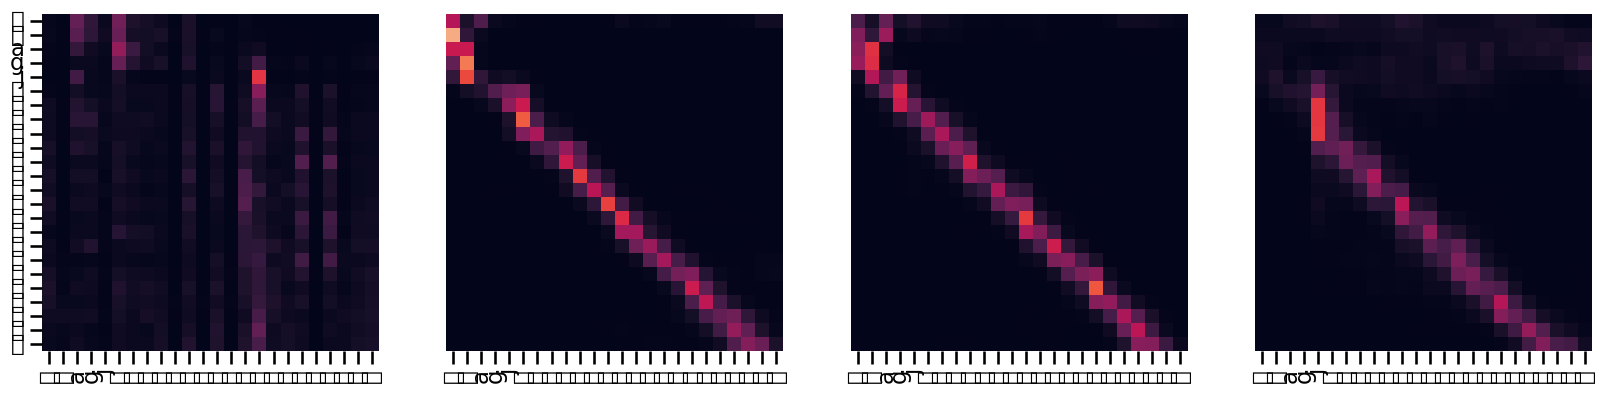

Encoder Layer 2


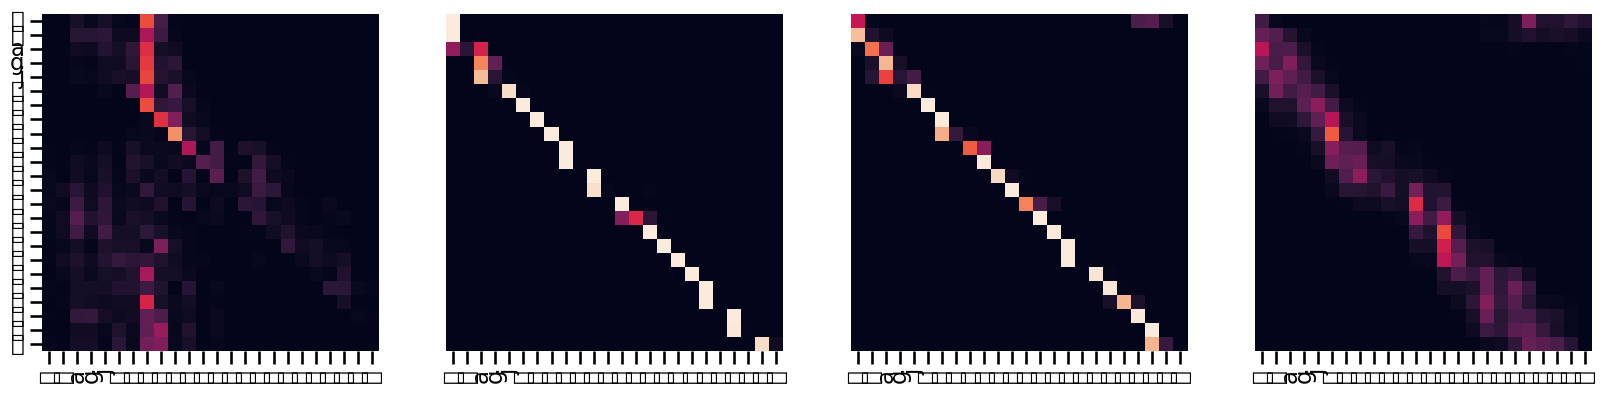

Encoder Layer 3


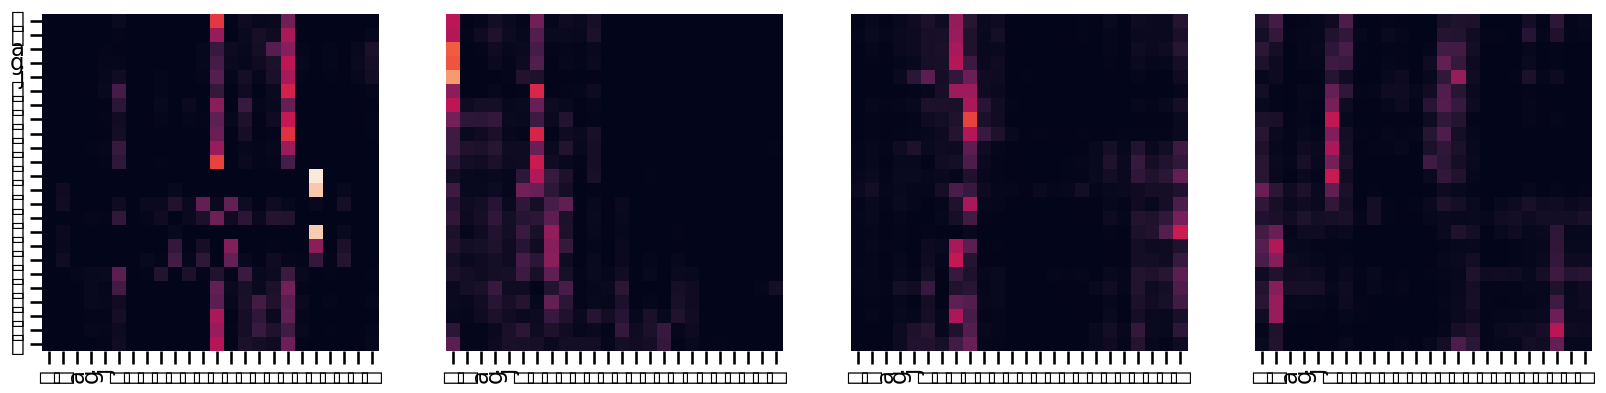

Decoder Self Layer 1


/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3944 (\N{TIBETAN LETTER A}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3966 (\N{TIBETAN SIGN RJES SU NGA RO}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3953 (\N{TIBETAN VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3967 (\N{TIBETAN SIGN RNAM BCAD}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:658: UserWarning: Glyph 3944 (\N{TIBETAN LETTER A}) missing from current font.
  bboxes = [l.get_window_extent() for l in labels]
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:658: UserWarning: Glyph 3966 (\N{TIBETAN SIGN RJES SU NGA RO}) missing from current 

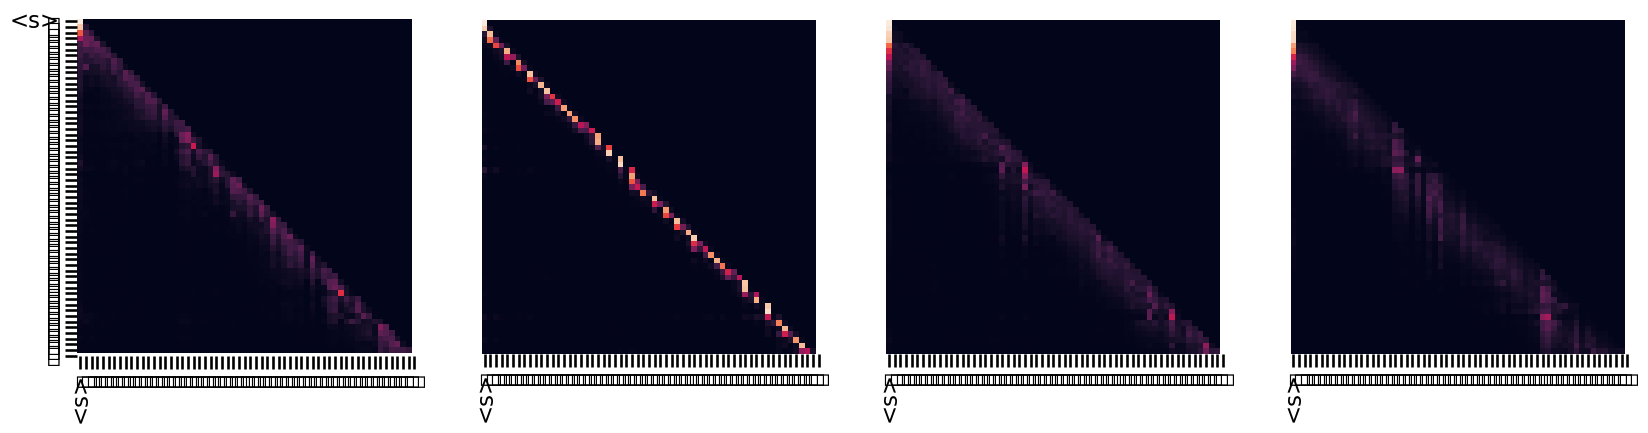

Decoder Src Layer 1


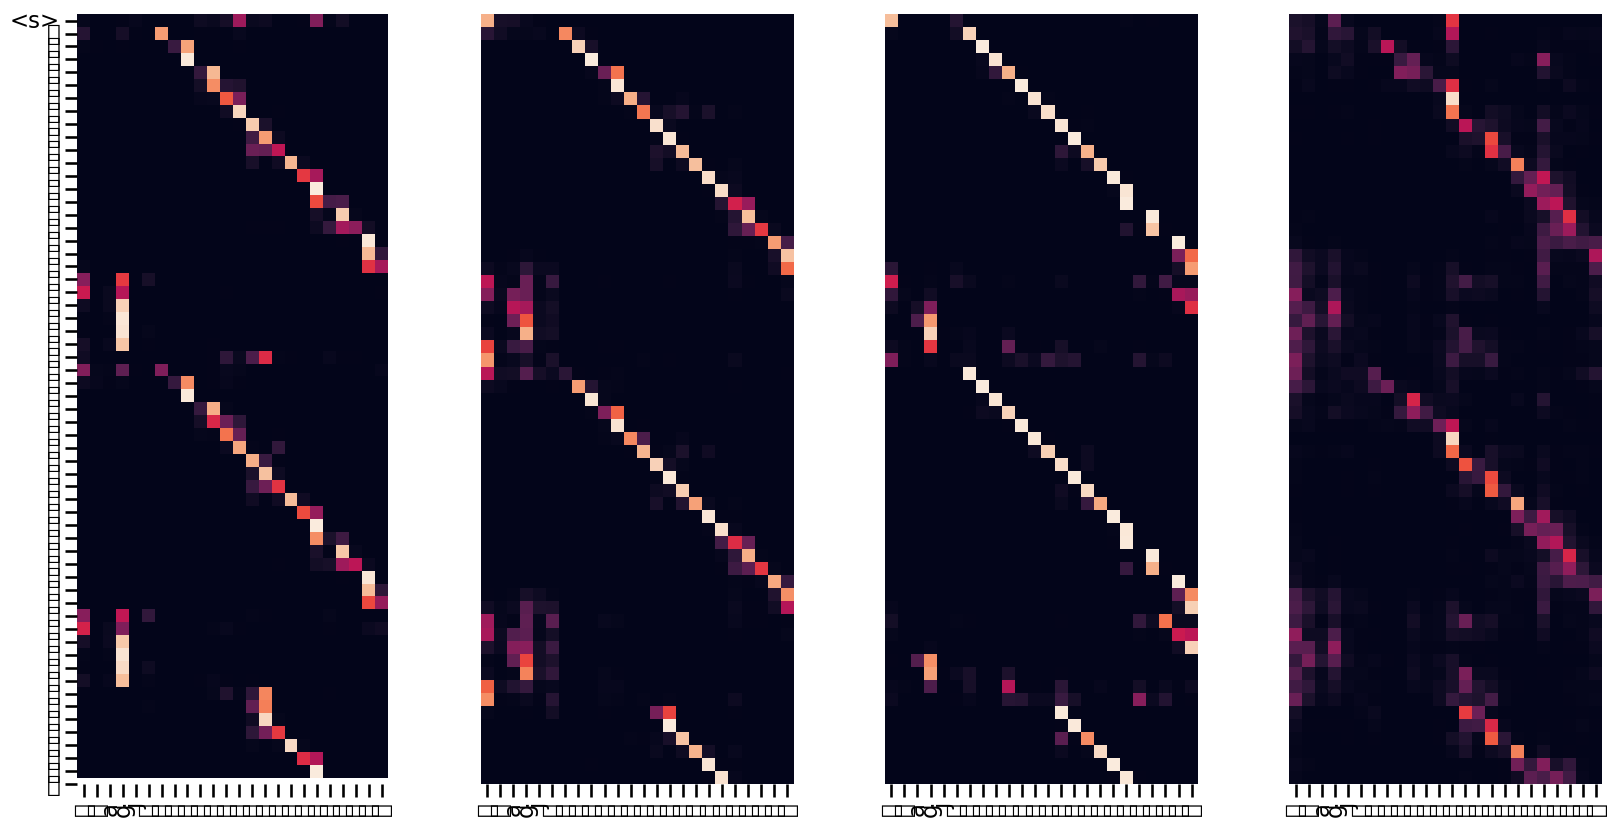

Decoder Self Layer 2


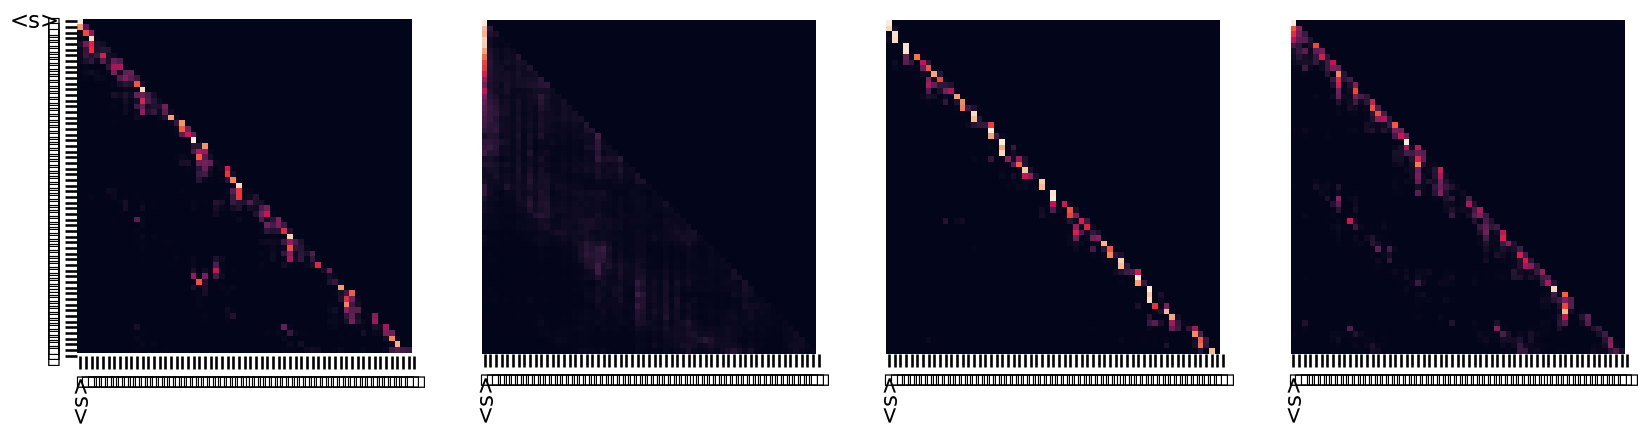

Decoder Src Layer 2


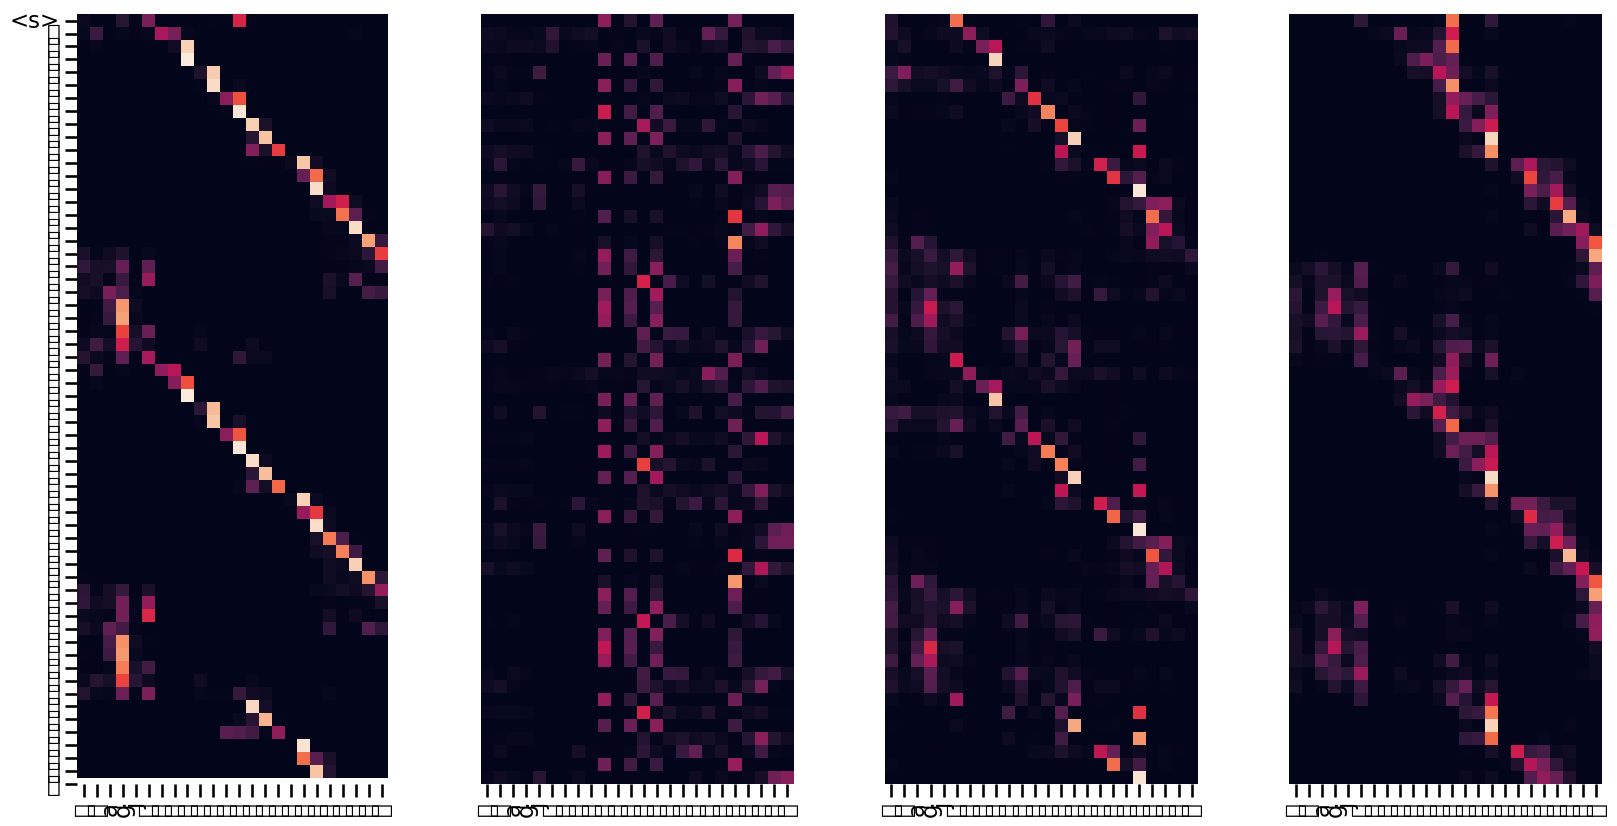

Decoder Self Layer 3


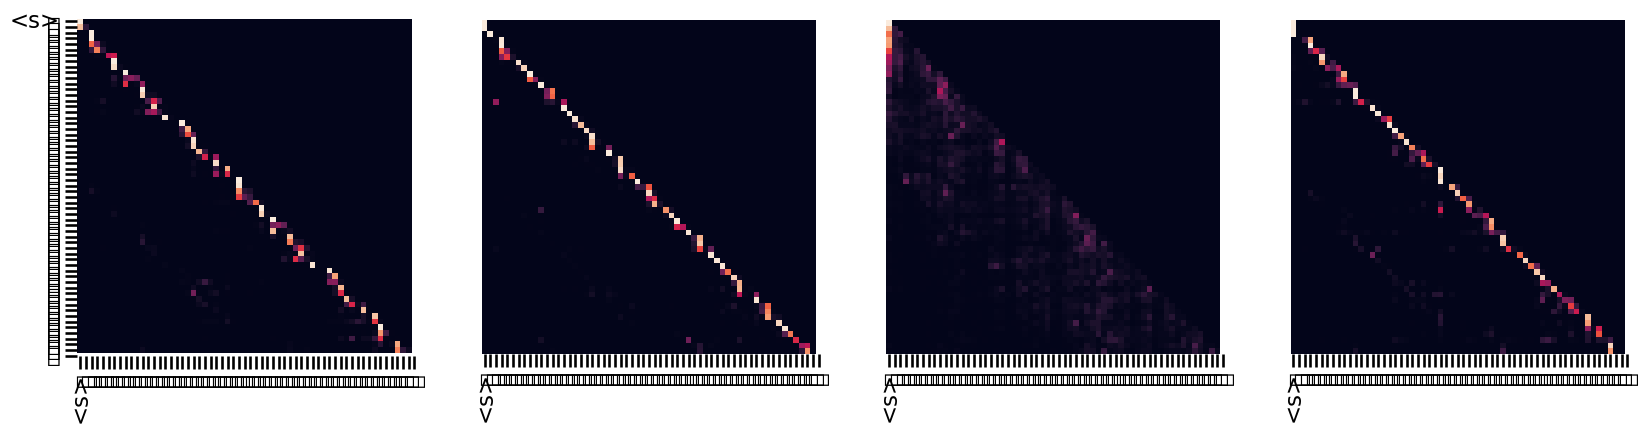

Decoder Src Layer 3


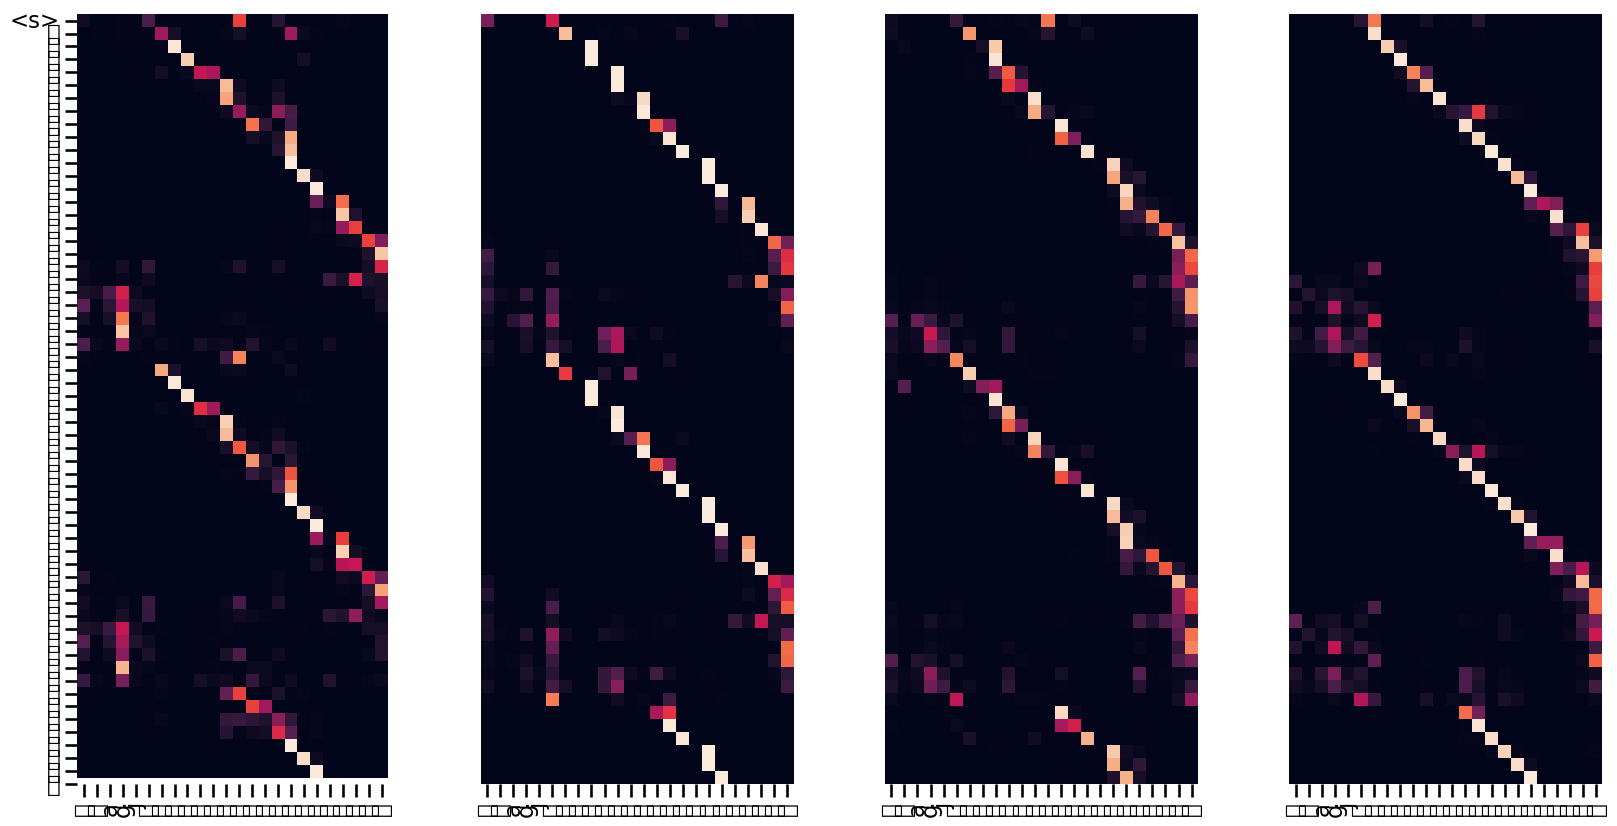

In [ ]:
tgt_sent = trans.split()

def draw(output, x, y, ax):
    seaborn.heatmap(output.cpu().data.numpy(), 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(3):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(3):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].src_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

Encoder Layer 0
Encoder Layer 1
Encoder Layer 2


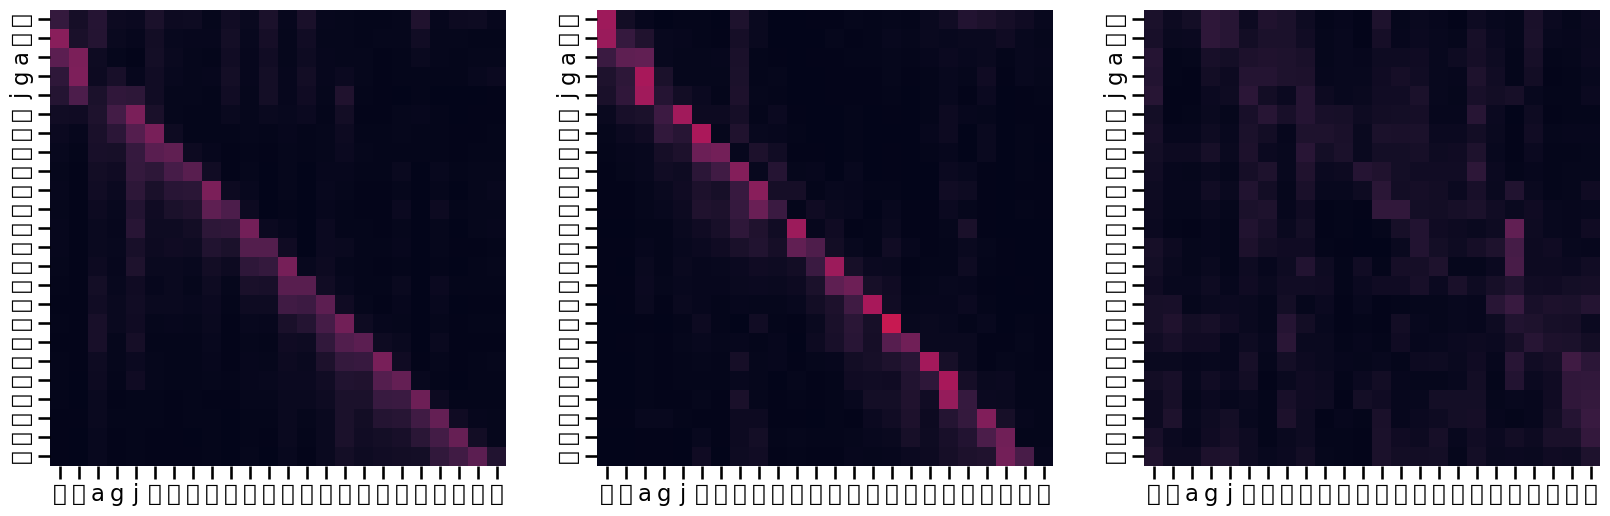

Decoder Self Layer 0
Decoder Self Layer 1
Decoder Self Layer 2


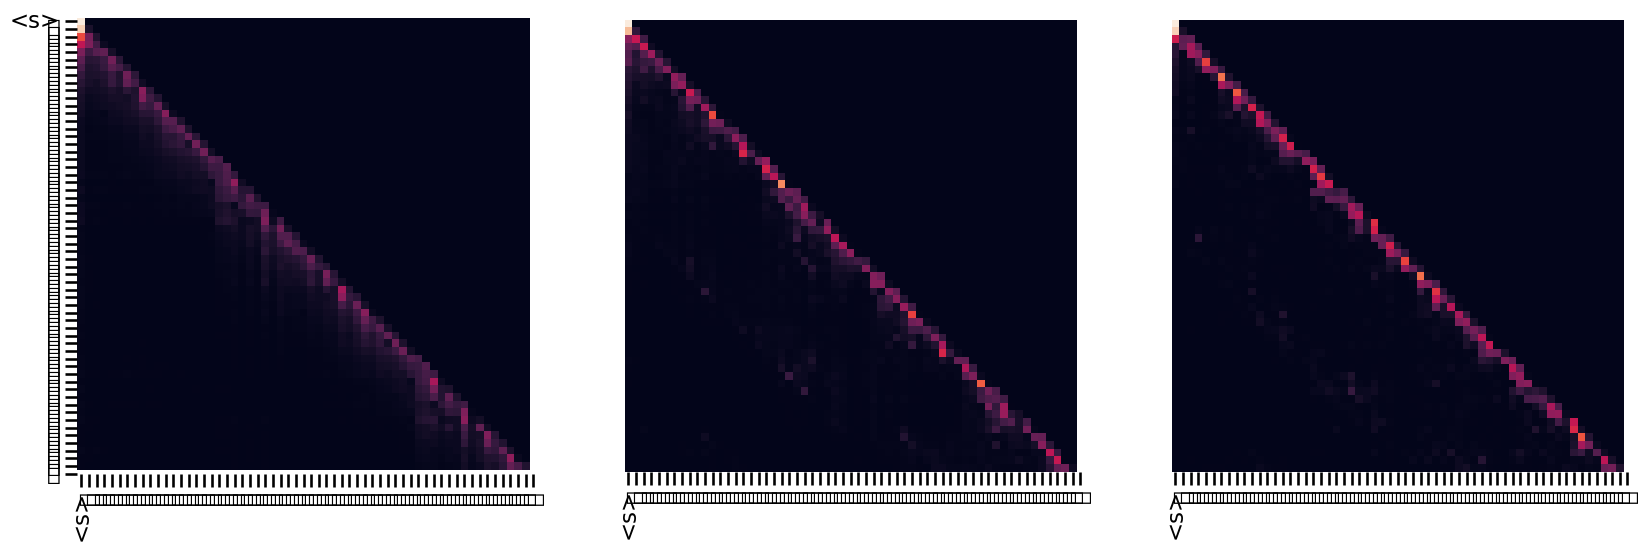

Decoder Src Layer 1
Decoder Src Layer 2
Decoder Src Layer 3


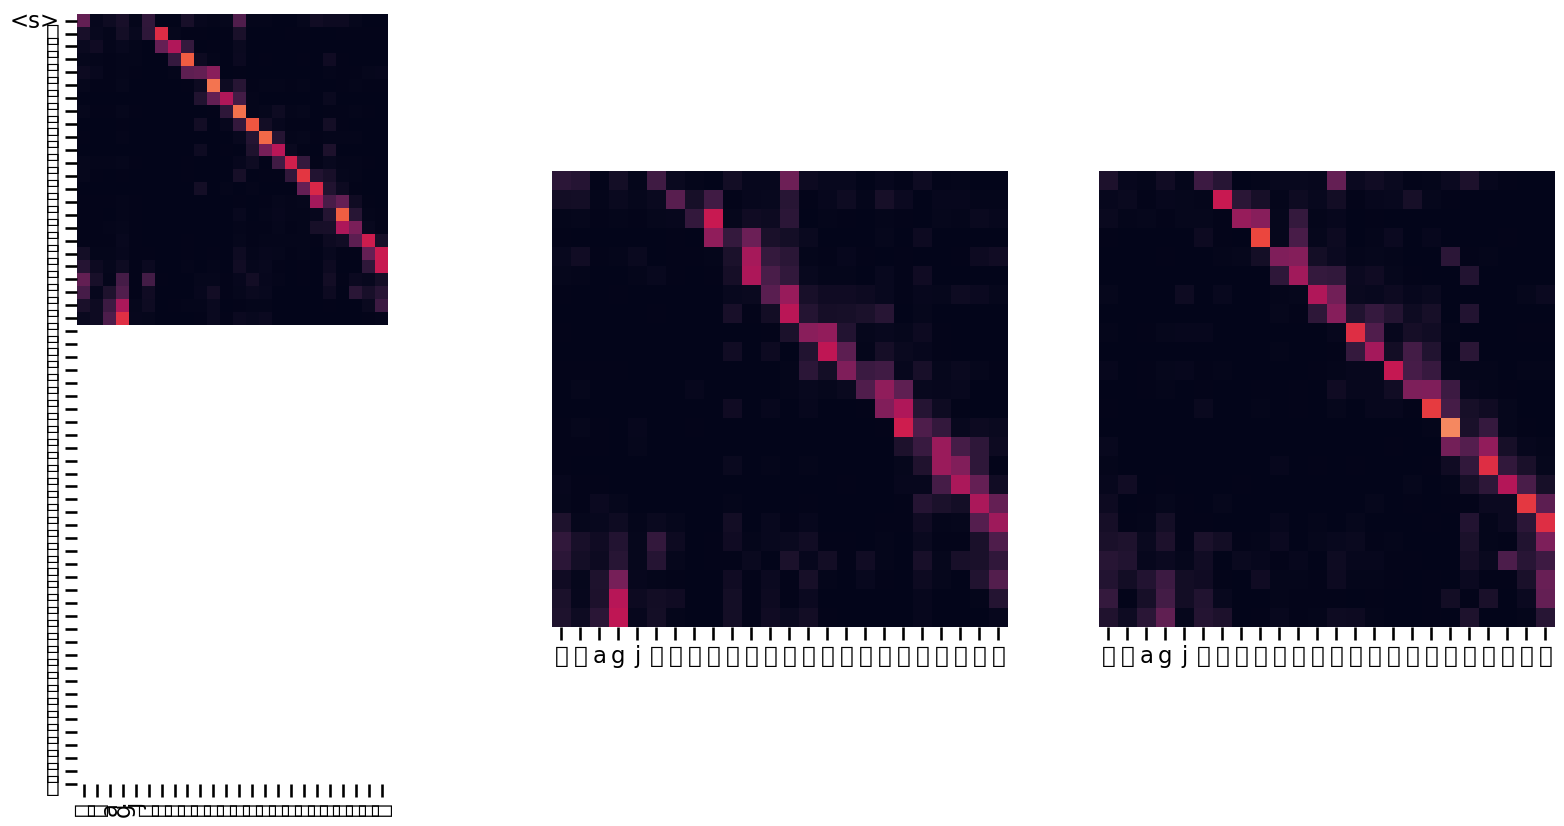

In [ ]:
tgt_sent = trans.split()

def draw(output, x, y, ax):
    seaborn.heatmap(output.cpu().data.numpy(), 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
fig, axs = plt.subplots(1,3, figsize=(20, 10))
# there are only 3 layers in the encoder
for layer in range(3):
    print("Encoder Layer", layer)
    # take the mean of 4 self-attention layers in each encoder layer
    att_enc = torch.mean(model.encoder.layers[layer].self_attn.attn[0, :].data, axis=0)
    draw(att_enc, sent, sent, ax=axs[layer])
plt.show()
    
fig, axs = plt.subplots(1,3, figsize=(20, 10))
# there are only 3 layers in the decoder
for layer in range(3):
    print("Decoder Self Layer", layer)
    # take the mean of 4 self-attention layers in each decoder layer
    att_dec_self = torch.mean(model.decoder.layers[layer].self_attn.attn[0, :].data[:len(tgt_sent), :len(tgt_sent)], axis=0)
    draw(att_dec_self, tgt_sent, tgt_sent if layer ==0 else [], ax=axs[layer])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 10))
for layer in range(3):
    print("Decoder Src Layer", layer+1)
    # take the mean of 4 source-attention layers in each decoder layer
    att_dec_src = torch.mean(model.decoder.layers[layer].src_attn.attn[0, :].data[:len(tgt_sent), :len(sent)], axis=0)
    draw(att_dec_src, sent, tgt_sent if layer ==0 else [], ax=axs[layer])
plt.show()

# Visualizing Correction Result

In [ ]:
df

noisy_text  \
0                               ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།   
1      གི་བུ་འདི་མཐུ་ཡིན་ནོསྙམཆོད།དེ་ནི་དེ་ལྟ་མ་ཡིན་ཏ...   
2      དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟ...   
3      、ཨངགའི་རྒྱལ་པོ་ལྟར་བསདཔ་ཐོསནས་དེསསྒོ་ཁཅདདེ་ར་བ...   
4      སན[བ་གྲྭཕྱིདབུདབནང་འཁྲུག་རབ་ཏུཞི་བ།ཆོམ་རྐུན་དང...   
...                                                  ...   
81597  562མ་ཡིནནོ།།དཔེ་ཡངམགྲུབ་པའི་ཕྱིརཔོཞེས་བྱབར་དགོ...   
81598  565ཨ།ཡིན་ཏེ།དཔེར་ནམའམེསྣང་བའི་རྒྱུཡིན་པ་བཞིན་ན...   
81599  566ཁྱདཔར་ཅནའཇུགཔའིརྒྱུཡིནཔའིཕྱིར་འགྲོགདངུལྡནཔའ...   
81600  567ལཤིས་བརྒྱབཞི་དཔགཔསྨཱབར་རིགས་ཏེ།ངེད་འགྲོ་བསྒ...   
81601  571V"༣གནུགྱུརླགནརེརྟོགགེསྙམཔོའི་བསྟན་བཅོས་ཙམཚེ...   

                                             confi_score  \
0      [0.32, 0.32, 0.14, 0.7, 0.24, 0.99, 1.0, 1.0, ...   
1      [0.99, 0.99, 0.97, 0.65, 0.65, 0.9, 0.87, 0.99...   
2      [0.99, 0.87, 0.07, 0.26, 0.28, 0.6, 0.65, 0.88...   
3      [0.79, 0.97, 0.96, 0.81, 0.74, 0.74, 0.59, 0.8...   
4      [0.92, 0.76, 0.43, 0.43, 0.65, 0.15, 0.15, 0.1...   
...                                                  ...   
81597  [0.99, 0.99, 0.99, 0.64, 0.49, 0.95, 0.95, 0.9...   
81598  [0.99, 0.99, 0.99, 0.6, 0.67, 0.97, 0.97, 0.96...   
81599  [0.99, 0.99, 0.99, 0.99, 0.99, 0.9, 0.99, 0.5,...   
81600  [0.99, 0.99, 0.99, 0.97, 0.1, 0.1, 0.18, 0.29,...   
81601  [0.99, 0.99, 0.97, 0.27, 0.79, 0.31, 0.65, 0.1...   

                                               true_text  
0                              ༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ། །  
1      གི་བུ་འདིའི་མཐུ་ཡིན་ནོ་སྙམ་མོད་ཀྱི། དེ་ནི་དེ་ལ...  
2      དང་། གཅད་པ་དང་། དྲལ་བ་དང་། དབུག་པ་དང་། གནས་ལྔ་...  
3      ཨང་གའི་རྒྱལ་པོ་ཇི་ལྟར་བསད་པ་ཐོས་ནས་དེས་སྒོ་བཅད...  
4      བ་དང་། ཕྱི་དགྲ་དང་། ནང་འཁྲུག་རབ་ཏུ་ཞི་བ། ཆོམ་ར...  
...                                                  ...  
81597  མ་ཡིན་ནོ། །དཔེ་ཡང་མ་གྲུབ་པའི་ཕྱིར་རོ་ཞེས་བྱ་བར...  
81598  ཡིན་ཏེ། དཔེར་ན་མར་མེ་སྣང་བའི་རྒྱུ་ཡིན་པ་བཞིན་ན...  
81599  ཁྱད་པར་ཅན་འཇུག་པའི་རྒྱུ་ཡིན་པའི་ཕྱིར་འགྲོ་བ་དང...  
81600  དཔག་པ་སྨྲ་བར་རིགས་ཏེ། ངེད་འགྲོ་བ་སྨྲ་བ་དག་འགྲོ...  
81601  ན་རེ། རྟོག་གེ་སྐམ་པོའི་བསྟན་བཅོས་ཙམ་ཉི་ཚེས་བསྒ...  

[81602 rows x 3 columns]

## 15. **Visualizing Correction Result**

In [ ]:
tt = df.reset_index().loc[0]
print(f'Noisy: {tt.noisy_text}')
print(f'True: {tt.true_text}')
tt_src_sentences_list = [tt.noisy_text]
tt_trg_sentences_list = [tt.true_text]
tt_confi_list = tt.confi_score

tt_examples = get_examples(tt_src_sentences_list,
                            tt_trg_sentences_list,
                           tt_confi_list)

tt = data.Dataset(tt_examples, fields)

tt_iter = MyIterator(tt, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)


Noisy: ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།
True: ༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ། །


In [ ]:
sent_data = df.reset_index().loc[2]
sent = sent_data.noisy_text
sent_confi = sent_data.confi_score
sent_confi = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent_confi]])
sent_confi = Variable(sent_confi).to(device)
sent_true = sent_data.true_text
print('Original Noisy Sentence: ', sent)

src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
src = Variable(src).to(device)
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
out, prob_list = greedy_decode(model, src, src_mask, sent_confi,
                    max_len=510, start_symbol=TRG.vocab.stoi["<s>"])
print("Translation:", end="\t")
pred = ""
for i in range(1, out.size(1)):
    sym = TRG.vocab.itos[out[0, i]]
    if sym == "</s>": break
    pred += sym
print(pred)
print("Ground Truth Sentence: ", sent_true)


Original Noisy Sentence:  དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟསྟེ།རྒྱུད་ནས་འཕོག་པ་དང་།སྤུ་གྲགས་པར་འཕོག་པ་དང༌།གནད་དུ་འཕོག་པ་དང་ཉི་འཆོར་བར་འཕོག་པ་དང་།ཚབས་ཆེ་བ་དེ་དག་ལ་ཡང་ཞུགས་ཤིང་བྱང་བར་གྱུར་།བློན་པོའི་བུ་ལྔ་བརྒྱ་བོ་དེ་དག་ཀྱང་བཟོའི་གནས་དང་།ལས་ཀྱི་གནས་དག་ལ་བྱང་བའགྱུརཏོ།།དེཡས་བགྲོསྦྱང་བབཅུ་བརྒྱད་པོ་དག་ལ་བཞུགནས་དེའི་མིང་བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོ།།བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོ་ཞེས་བྱུབ་གྱུར་ཏོ།།དེ་ནས་དུསགན་ཞིག་ན་གཞོན་ནུ་གཟུགས་ཅན་སྙིང་པོ་གླང་པོ་ཆེ་ལ་ཞོན་ཏེ་ཡོངས་སུབྱུང་བ་དང
Translation:	དང་།གནད་པ་དང་།དྲལ་བ་དང་།དབུག་པ་དང་།གནས་དང་པོ་འདི་ལྟ་སྟེ།རྒྱུད་ནས་འཕོག་པ་དང་།སྤུ་གྲགས་པར་འཕོག་པ་དང་།གནད་དུ་འཕོག་པ་དང་ཉི་འཆོར་བར་འཕོས་པ་དང་།ཚངས་པ་ཆེ་བ་དེ་དག་ལ་ཡང་ཞུགས་ཤིང་བྱང་བར་གྱུར་ཏོ།།བློན་པོའི་བུ་ལྔ་བརྒྱ་པོ་དེ་དག་ཀྱང་བཟོའི་གནས་དང་།ལས་ཀྱི་གནས་དག་ལ་བྱང་བར་གྱུར་ཏོ།།དེ་ལས་བགྲོ་སྦྱང་བ་བཅྭ་བརྒྱད་པོ་དག་ལ་བཞུགས་ནས་དེའི་མིང་བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོའོ།།བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོ་ཞེས་བྱ་བར་གྱུར་ཏོ།།དེ་ནས་དུས་གཞན་ཞིག་ན་གཞོན་ནུ་གཟུགས་ཅན་སྙིང་པོ་གླང་པོ་ཆེ་ལ་ཞོན་ཏེ་ཡོངས་སུ་བྱུང་བ་དང
Ground Truth Sentence:  དང་། གཅ

## 16. **Compute Accuracy**

In [ ]:
import Levenshtein as ed
sent_data = df.reset_index().loc[2]
sent = sent_data.noisy_text
sent_confi = sent_data.confi_score
sent_confi = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent_confi]])
sent_confi = Variable(sent_confi).to(device)
sent_true = sent_data.true_text
print('Original Noisy Sentence: ', sent)

src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
src = Variable(src).to(device)
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
out, prob_list = greedy_decode(model, src, src_mask, sent_confi,
                    max_len=510, start_symbol=TRG.vocab.stoi["<s>"])
print("Translation:", end="\t")
pred = ""
for i in range(1, out.size(1)):
    sym = TRG.vocab.itos[out[0, i]]
    if sym == "</s>": break
    pred += sym
print(pred)
print("Ground Truth Sentence: ", sent_true)



def get_diff_token(a, b):
  mb = ed.matching_blocks(ed.editops(a,b), a, b)
  match_idx = [(t[0], t[0]+t[2]) for t in mb]
  match_idx = [np.arange(t[0], t[1]) for t in match_idx]
  match_idx = np.concatenate(match_idx, axis=0 )
  all_index = np.arange(len(a))
  not_same = np.array(list(set(all_index).difference(match_idx)))
  # group cluster
  if len(not_same) == 1:
    res = [not_same[0]]
  else:
    res = []
    cur_group = [not_same[0]]
    for i in range(1, len(not_same)):
      if cur_group[-1] + 1 == not_same[i]:
        cur_group.append(not_same[i])
        if i == len(not_same) - 1:
          res.append(cur_group)
      else:
        res.append(cur_group)
        cur_group = [not_same[i]]

  diff_token = ["".join(a[i] for i in grp) for grp in res]

  return diff_token

# compare noisy with true, a = noisy, b = true
a, b = sent, sent_true
diff_A = get_diff_token(a, b)
# compare pred with true, a = pred, b = true
a, b = pred, sent_true
diff_B = get_diff_token(a, b)
# compare noisy with pred, a = noisy, b = pred
a, b = sent, pred
diff_C = get_diff_token(a, b)

Original Noisy Sentence:  དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟསྟེ།རྒྱུད་ནས་འཕོག་པ་དང་།སྤུ་གྲགས་པར་འཕོག་པ་དང༌།གནད་དུ་འཕོག་པ་དང་ཉི་འཆོར་བར་འཕོག་པ་དང་།ཚབས་ཆེ་བ་དེ་དག་ལ་ཡང་ཞུགས་ཤིང་བྱང་བར་གྱུར་།བློན་པོའི་བུ་ལྔ་བརྒྱ་བོ་དེ་དག་ཀྱང་བཟོའི་གནས་དང་།ལས་ཀྱི་གནས་དག་ལ་བྱང་བའགྱུརཏོ།།དེཡས་བགྲོསྦྱང་བབཅུ་བརྒྱད་པོ་དག་ལ་བཞུགནས་དེའི་མིང་བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོ།།བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོ་ཞེས་བྱུབ་གྱུར་ཏོ།།དེ་ནས་དུསགན་ཞིག་ན་གཞོན་ནུ་གཟུགས་ཅན་སྙིང་པོ་གླང་པོ་ཆེ་ལ་ཞོན་ཏེ་ཡོངས་སུབྱུང་བ་དང
Translation:	དང་།གནད་པ་དང་།དྲལ་བ་དང་།དབུག་པ་དང་།གནས་དང་པོ་འདི་ལྟ་སྟེ།རྒྱུད་ནས་འཕོག་པ་དང་།སྤུ་གྲགས་པར་འཕོག་པ་དང་།གནད་དུ་འཕོག་པ་དང་ཉི་འཆོར་བར་འཕོས་པ་དང་།ཚངས་པ་ཆེ་བ་དེ་དག་ལ་ཡང་ཞུགས་ཤིང་བྱང་བར་གྱུར་ཏོ།།བློན་པོའི་བུ་ལྔ་བརྒྱ་པོ་དེ་དག་ཀྱང་བཟོའི་གནས་དང་།ལས་ཀྱི་གནས་དག་ལ་བྱང་བར་གྱུར་ཏོ།།དེ་ལས་བགྲོ་སྦྱང་བ་བཅྭ་བརྒྱད་པོ་དག་ལ་བཞུགས་ནས་དེའི་མིང་བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོའོ།།བཟོ་སྦྱངས་གཟུགས་ཅན་སྙིང་པོ་ཞེས་བྱ་བར་གྱུར་ཏོ།།དེ་ནས་དུས་གཞན་ཞིག་ན་གཞོན་ནུ་གཟུགས་ཅན་སྙིང་པོ་གླང་པོ་ཆེ་ལ་ཞོན་ཏེ་ཡོངས་སུ་བྱུང་བ་དང
Ground Truth Sentence:  དང་། གཅ

In [ ]:
s_pred_list = []
s_org_list = []
for k in range(1000):
  sent_data = df.reset_index().loc[k]
  sent = sent_data.noisy_text
  sent_confi = sent_data.confi_score
  sent_confi = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent_confi]])
  sent_confi = Variable(sent_confi).to(device)
  sent_true = sent_data.true_text
  sent_true = sent_true.replace(' ', '')
  print('Original Noisy Sentence: ', sent)

  src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
  src = Variable(src).to(device)
  src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
  out, prob_list = greedy_decode(model, src, src_mask, sent_confi,
                      max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS, start_symbol=TRG.vocab.stoi["<s>"])
  print("Translation:", end="\t")
  pred = ""
  for i in range(1, out.size(1)):
      sym = TRG.vocab.itos[out[0, i]]
      if sym == "</s>": break
      pred += sym
  print(pred)
  print("Ground Truth Sentence: ", sent_true)

  mb_pred = ed.matching_blocks(ed.editops(pred, sent_true), pred, sent_true)
  mb_org = ed.matching_blocks(ed.editops(sent, sent_true), sent, sent_true)
  matched_org = ''.join([sent[x[0]:x[0]+x[2]] for x in mb_org])
  org_len = max([len(sent_true), len(sent)])
  s_org = len(matched_org)/org_len
  s_org_list.append(s_org)

  print(f'score before correction: {s_org:.4f}')

  matched_pred = ''.join([pred[x[0]:x[0]+x[2]] for x in mb_pred])
  s_pred = len(matched_pred)/len(sent_true)
  s_pred_list.append(s_pred)

  print(f'score after correction: {s_pred:.4}')

print(f'score before correction: {np.mean(s_org_list):.4}')
print(f'score after correction: {np.mean(s_pred_list):.4}')

Original Noisy Sentence:  ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།
Translation:	འདུལ་བ་ཀ་བཞུགས་སོ།།ཨོཾ་ཨཱཿའདུལ་བ་ཀ་བཞུགས་སོ།།ཨོཾ་ཨཱཿཀ་བཞུགས་སོ།།ཨོཾ་ཨཱཿའདུལ་བ་ཀ་བཞུགས་སོ།།ཨོཾ་ཨོཾ་ཨ་བ་ཀ་བཞུགས་སོ།།ཨོཾ་ཨོཾ་ཨ་བྷ་ཀ་བཞུགས་སོ།།།།།འདུལ་བ་ཀ་བ་ཞུགས་སོ།།ཨོཾ་ཨོཾ་ཨ་བྷ་ཀ་བ་ཞུགས་སོ།།ཨོཾ་ཨཱཿཀ་བཞུགས་སོ།།ཨོཾ་ཨཱཿཀ་བཞུགས་སོ།།ཨོཾ་ཨཱཿཀ་བཞུགས་སོ།།ཨོཾ་ཨོཾ་ཨ་བ་ཀ་བཞུགས་སོ།།ཨོཾ་ཨ་བ་ཀ་བཞུགས་སོ།།ཨོཾ།ཨོཾ་ཨཱཿཀ་བཞུགས་སོ།།ཨོཾ།།།འདུལ་བ་ཀ་བ་ཞུགས་སོ།།
Ground Truth Sentence:  ༄༅།།འདུལ་བ་ཀ་བཞུགས་སོ།།
score before correction: 0.7917
score after correction: 0.913
Original Noisy Sentence:  གི་བུ་འདི་མཐུ་ཡིན་ནོསྙམཆོད།དེ་ནི་དེ་ལྟ་མ་ཡིན་ཏེ།འདིལྟར་དེ་དག་ཐམས་ཅད་ནི་བྱང་ཆུབ་སེམས་དཔའི་མཐུ་ཡིནཔའི་ཕྱིར་རོ།།གང་གིཉིནམོགཚོཅན་སཱིཔོབཙསཔ་དེའིཀྱི་ཉིན་མོ་ཝོནཔོ་བདག་གི་བུ་ལྔ་བརྒྱ་ཡས་བཙཧེདེ་དག་ཀྱང་རིགས་དང་མཐུན་པར་མིང་བཏགས་སོ།གཞོནནགཟུགསཅནསྙིང་བོ་མམ་བརྒྱད་པོ་པ་འཚོབ
Translation:	གི་བུ་འདི་མཐུ་ཡིན་ནོ་སྙམ་མོ།།དེ་ནི་དེ་ལྟ་མ་ཡིན་ཏེ།འདི་ལྟར་དེ་དག་ཐམས་ཅད་ནི་བྱང་ཆུབ་སེམས་དཔའི་མཐུ་ཡིན་པའི་ཕྱིར་རོ།།གང་གི་ཉིན་མོ་གཙོ་བོ་ཅན་སྙིང་པོ་བཙས་པ་དེའི་ཚེ་ཀྱི་ཉིན་མོ་ཁོ་ན་པོ་བདག་གི་བུ་ལྔ་

Translation:	ཡང་མཐོང་བར་འགྱུར་ཞིང་ཆུ་ངོ་།།རིགས་སུ་ཉེ་བར་རིག་ཀྱང་རིམ་གྱི།སྦ་བའི་ཁྱུ་མཆོག་དེ་དག་ལ་ཡང་བསྙེན་བཀུར་བགྱི།རྒོལ་བ་དག་ཀྱང་ཚར་གཅད་པར་བགྱི།རང་གི་གྲགས་པ་ཡང་བསམ་པར་བགྱི།རྙེད་པ་ཡང་བསྒྲུབ་པར་བགྱིས།བདག་ཅག་ཡུལ་དབུས་སུ་མཆིའོ།།བྲམ་ཟེ་དེ་སློབ་མ་ལ་རྗེས་སུ་ཆགས་པ་དང་བཅས་པ་དང་།འཁོར་ཉུང་བ་ཡིན་པས་དེས་བྲམ་ཟེའི་ཁྱེའུ་དེ་དག་ལ་འདི་སྐད་ཅེས་སྨྲས་སོ།།བདག་གལ་ཏེ་དེ་ལྟ་ན་གང་ཡང་གཞི་དག་དང་།ཤིང་ན་དག་དང་།དབྱུ་གུ་དག་དང་།བླུགས་གཟར་བ་དང་།དང་གཟར་དག་དང་།
Ground Truth Sentence:  ཡང་མཐོང་བར་འགྱུར་ཞིང་ཆུ་ངོགས་སུ་ཉེ་རེག་ཀྱང་བགྱི།སྨྲ་བའི་ཁྱུ་མཆོག་དེ་དག་ལ་ཡང་བསྙེན་བཀུར་བགྱི།རྒོལ་བ་དག་ཀྱང་ཚར་གཅད་པར་བགྱི།རང་གི་གྲགས་པ་ཡང་བསྒྲག་པར་བགྱི།རྙེད་པ་ཡང་བསྒྲུབ་པར་བགྱིས།བདག་ཅག་ཡུལ་དབུས་སུ་མཆིའོ།།བྲམ་ཟེ་དེ་སློབ་མ་ལ་རྗེས་སུ་ཆགས་པ་དང་བཅས་པ་དང་།འཁོར་ཉུང་བ་ཡིན་པས་དེས་བྲམ་ཟེའི་ཁྱེའུ་དེ་དག་ལ་འདི་སྐད་ཅེས་སྨྲས་སོ།།བུ་དག་གལ་ཏེ་དེ་ལྟ་ན་གཡང་གཞི་དག་དང་།ཤིང་ཤུན་དག་དང་།དབྱུ་གུ་དག་དང་།བླུགས་གཟར་དག་དང་།དགང་གཟར་དག་དང་།
score before correction: 0.9345
score after correction: 0.966
Original Noisy Sentence:  རིལ་བ་དགའང་ཤིག་དང་ཡུལ་དབུས་སུ་འདོང་ངོ་།།དེ་དག

Translation:	པ་དག་ལ་ཡང་ཡོངས་སུ་སྤྱོད་ཅིག།སྦྱིན་པ་དག་ཀྱང་སྩོལ་ཅིག།བསོད་ནམས་དག་ཀྱང་མཛོད་ཅིག།དེ་སྐད་སྨྲས་ཀྱང་ཅི་དག།དེ་སྐད་སྨོས་ཀྱང་བྲམ་ཟེའི་ཁྱེའུ་གང་ནས་སྐྱེས་ཀྱང་མི་སྨྲའོ།།བྲམ་ཟེའི་ཁྱེའུ་དང་ནས་སྐྱེས་ཀྱི་ཉེ་དུ་དག་གི་སྐད་ཅེས་སྨྲས་སོ།།སྲས་གཞོན་ནུ་མཁྱེན་པར་མཛོད་ཅིག།ཁྱོད་ནི་ཤིན་ཏུ་གཞོན།།བདེ་བ་བཞེད་པ་ལགས་པས་ཁྱོད་ཀྱིས་སྡུག་བསྔལ་མི་མཁྱེན་ཏོ།།ཚངས་པར་སྤྱོད་པ་སྤྱད
Ground Truth Sentence:  པ་དག་ལ་ཡང་ཡོངས་སུ་སྤྱོད་ཅིག།སྦྱིན་པ་དག་ཀྱང་སྩོལ་ཅིག།བསོད་ནམས་དག་ཀྱང་མཛོད་ཅིག།དེ་སྐད་སྨྲས་ཀྱང་བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་ཅང་མི་སྨྲའོ།།བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་ཀྱི་ཉེ་དུ་དག་གིས་བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་ལ་ལན་གཉིས་ལན་གསུམ་གྱི་བར་དུ་འདི་སྐད་ཅེས་སྨྲས་སོ།།སྲས་གཞོན་ནུ་མཁྱེན་པར་མཛོད་ཅིག།ཁྱོད་ནི་ཤིན་ཏུ་གཞོན་པ་བདེ་བ་བཞེད་པ་ལགས་པས་ཁྱོད་ཀྱིས་སྡུག་བསྔལ་མི་མཁྱེན་ཏེ།ཚངས་པར་སྤྱོད་པ་སྤྱད
score before correction: 0.7926
score after correction: 0.8059
Original Noisy Sentence:  ཉམས་ཉེས་༄༅།བསྔལ་མིམཁྱེན་ཏེ།ཚངས་པར་སྤྱོད་པསྤྱདདཀཱའོ།།རབ་ཏུ་དབེན་བར་བགྱིདཀའོ།།གཅིག་པུ་ཉིད་ལ་མངོན་པར་དགའབར་དཀའོ།།གནས་མལ་ང་གཅིག་པུ་ཉི་ལམངོན་པར་དགའ་བར་དཀའོ།གནས་མལ

Translation:	རྣམས་ཀྱིས་སྤང་བར་བྱ་བ་ཡིན་ནོ་སྙམ་དུ་རིག་ནས་ཚིགས་སུ་དང་སྨྲས་པ།བློ་ངན་ལོག་པར་སྟོན་བྱེད་པ།།མངོན་པར་སྟོན་པར་གྲགས་པ་སྟེ།།གང་གི་ཆོས་འདི་དེ་འདྲ་སྟེ།།དེ་ཡི་ཆོས་མིན་ཅི་ཞིག་འདྲ།།ཞེས་པས་ནས་མྱོང་སྟོང་པ་བཞིན་དུ་བརྔུབས་ཏེ་དཔང་ངོ་།།དེ་ནས་བྲམ་ཟེའི་ཁྱེའུ་དེ་ནས་བྲམ་ཟེའི་ཁྱེའུ་རྒྱལ་དང་གང་ནས་སྐྱེས་པ་གཉིས་ཀ་ཏྱའི་བུ་ནོག་ཅན་གང་ལ་བ་དེར་དོང་སྟེ་ཅེས་སྨྲས་སོ།།ཤེས་ལྡན་ཁྱོད་ཀྱི་ཆོས་ཀྱི་ཚུལ་ནི་གང་ཡིན།།སློབ་མ
Ground Truth Sentence:  རྣམས་ཀྱིས་སྤང་བར་བྱ་བ་ཡིན་ནོ་སྙམ་དུ་རིག་ནས་ཚིགས་སུ་བཅད་པ་སྨྲས་པ།བློ་ངན་ལོག་པར་སྟོན་བྱེད་པ།།དམན་པ་སྟོན་པར་གྲགས་པ་སྟེ།།གང་གི་ཆོས་འདི་དེ་འདྲ་བ།།དེ་ཡི་ཆོས་མིན་ཅི་ཞིག་འདྲ།།ཞེས་སྨྲས་ནས་སྣོད་སྟོང་པ་བཞིན་དུ་བརྡབས་ཏེ་དོང་ངོ་།།དེ་ནས་བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་དང་པང་ནས་སྐྱེས་གཉིས་ཀ་ཏྱའི་བུ་ནོག་ཅན་ག་ལ་བ་དེར་དོང་སྟེ་ཕྱིན་ནས།ཀ་ཏྱའི་བུ་ནོག་ཅན་ལ་འདི་སྐད་ཅེས་སྨྲས་སོ།།ཤེས་ལྡན་ཁྱོད་ཀྱི་ཆོས་ཀྱི་ཚུལ་ནི་གང་ཡིན།སློབ་མ
score before correction: 0.8350
score after correction: 0.8706
Original Noisy Sentence:  བར་འདུལ་བནོཞེས་བྲིབདྲིས་པའི་ལན་འདེབས་པར་བྱེད་དོ།།འཇིག་རྟེན་ཕ་རོལ་གཞན་མ་ཡིནཔ་ཉིད་དང་གཞན་མ་ཡིནཔ་ཉིད

Translation:	ཅུང་ཟད་ཅི་འཚལ་བ་གང་ལགས་པ་དེ་དག་ཐམས་ཅད་མཁན་པོ་གཉིས་ལས་བརྟེན་ནས་འཚལ་བ་ལགས་ན།གལ་ཏེ་མཁན་པོ་གཉིས་བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་ཚངས་པར་སྤྱད་པ་སྤྱོད་ན་བདག་ཅག་ཀྱང་དེ་ལ་ཕན་པོ་གཉིས་རབ་ཏུ་བྱུང་བའི་རྗེས་སུ་བྲམ་ཟེའི་ཁྱེའུ་རྣམས་དེའི་དུས་ལ་བབ་པར་ཤེས་པར་གྱིས་ཤིག།དེ་ནས་ཀུན་དུ་རྒྱུ་ཉེ་རྒྱལ་དང་པང་ནས་སྐྱེས་མའི་ཚལ་བྱ་ཀ་ལན་དུ་ཀའི་གནས་ག་ལ་བ་དེར་དོང་
Ground Truth Sentence:  ཅུང་ཟད་ཅི་འཚལ་བ་གང་ལགས་པ་དེ་དག་ཐམས་ཅད་མཁན་པོ་གཉིས་ལས་བརྟེན་ནས་འཚལ་བ་ལགས་ན།གལ་ཏེ་མཁན་པོ་གཉིས་བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་ཚངས་པར་སྤྱད་པ་སྤྱོད་ན་བདག་ཅག་ཀྱང་མཁན་པོ་གཉིས་རབ་ཏུ་བྱུང་བའི་རྗེས་སུ་རབ་ཏུ་འབྱུང་བར་བགྱིའོ།།བྲམ་ཟེའི་ཁྱེའུ་རྣམས་ད་དེའི་དུས་ལ་བབ་པར་ཤེས་པར་གྱིས་ཤིག།དེ་ནས་ཀུན་དུ་རྒྱུ་ཉེ་རྒྱལ་དང་པང་ནས་སྐྱེས་གཉིས་འཁོར་ཉིས་བརྒྱ་ལྔ་བཅུ་ལྔ་བཅུ་དང་འོད་མའི་ཚལ་བྱ་ཀ་ལན་ད་ཀའི་གནས་ག་ལ་བ་དེར་དོང་
score before correction: 0.7604
score after correction: 0.8255
Original Noisy Sentence:  །དེའི་ཚོན་བཅོམ་ལྡན་འདས་དགེ་སློང་གི་འཁོར་བརྒྱ་ཕྲག་དུ་མའི་ཆོས་སྟོན་ཅིང་བཞུགསསོ།བཅོམ་ལྡན་འདས་ཀྱིས་ཀུན་དུ་ཉེ་རྒྱ་ང་ནས་སྐྱེས་གཉིས་ཐག་རིང་པོ་ཁོན་ནས་གཟིགས་སོ།།གཟིགས་ནས་ཀྱང

Translation:	གཏོད་པར་བྱེད་པ་ཡིན་པས།རྒྱལ་བུ་དེ་ཤིང་ལྗོན་པ་རྩ་བ་ནས་བཅད་པ་བཞིན་དུ་རང་སངས་རྒྱས་དེའི་ནང་པ་གཉིས་ལ་གཏུགས་ནས་སྨྲས་པ།འཕགས་པ་ཁྱོད་ཀྱི་ཡོན་ཏན་གྱི་ཚོགས་འདི་ལྟ་བུ་བསྙེས་སམ།ཐོབ་བོ།།དེ་ནས་བསམས་པ།འཕགས་པ་འདིས་ཡོན་ཏན་གྱི་ཚོགས་གང་ཅུང་ཟད་ཐོས་པ་གང་ཡིན་པ་དེ་ནི་ཐམས་ཅད་བདག་ལ་བརྟེན་ནས་ཐོབ་པ་ཡིན་ན།འཕགས་པ་འདིས་སྔོན་རབ་ཏུ་འབྱུང་བ་མ་ཐོབ་པ་གང་ཡིན་པ་དེ་ནི་ཁྱིམ་དེ་ལྟ་བུར་སྐྱེས་པ་ཡིན་ན།བདག་གིས་རབ་ཏུ་འབྱུང་བ་མ་ཡིན་ནོ་སྙམ་ནས།
Ground Truth Sentence:  ནི་རྫུ་འཕྲུལ་ལ་མྱུར་དུ་སེམས་གཏོད་པར་བྱེད་པ་ཡིན་པས།རྒྱལ་བུ་དེ་ཤིང་ལྗོན་པ་རྩ་བ་ནས་བཅད་པ་བཞིན་དུ་རང་སངས་རྒྱས་དེའི་རྐང་པ་གཉིས་ལ་གཏུགས་ནས་སྨྲས་པ།འཕགས་པ་ཁྱོད་ཀྱི་ཡོན་ཏན་གྱི་ཚོགས་འདི་ལྟ་བུ་བརྙེས་སམ།ཐོབ་བོ།།དེས་བསམས་པ།འཕགས་པ་འདིས་ཡོན་ཏན་གྱི་ཚོགས་གང་ཅུང་ཟད་ཐོབ་པ་གང་ཡིན་པ་དེ་ཐམས་ཅད་བདག་ལ་བརྟེན་ནས་ཐོབ་པ་ཡིན་ན།འཕགས་པ་འདིས་སྔོན་རབ་ཏུ་འབྱུང་བ་མ་ཐོབ་པ་གང་ཡིན་པ་དེ་ནི་ཁྱིམ་དེ་ལྟ་བུར་སྐྱེས་པ་ཡིན་ལ།བདག་གིས་རབ་ཏུ་འབྱུང་བ་མ་ཐོབ་པ་གང་ཡིན་པ་དེ་ནི་ཁྱིམ་འདི་ལྟ་བུར་སྐྱེས་པ་ཡིན་ནོ་སྙམ་ནས།
score before correction: 0.7790
score after correction: 0.8326
Original Noisy Sentence:  sཙགངསཨརིག

Translation:	འདིས་བགྱི་བས་ཀྱང་དུས་འདི་ནས་བཟུང་སྟེ།ཇི་སྲིད་ཚེའི་བར་དུ་སྲོག་གཅོད་པ་སྤངས་ཏེ།སྲོག་གཅོད་པ་ལས་སླར་ལྡོག་པར་བགྱིའོ།།ཡན་ལག་དང་པོ་འདིས་བདག་འཕགས་པ་དགྲ་བཅོམ་པ་དེ་དག་གི་བསླབ་པ་ལ་རྗེས་སུ་སློབ་བོ།།རྗེས་སུ་བསྒྲུབ་བོ།།རྗེས་སུ་བསྒྲུབ་བགྱིད་དོ།།གཞན་ཡང་ཇི་ལྟར་འཕགས་པ་དགྲ་བཅོམ་པ་དེ་དག་གིས་ཇི་སྲིད་འཚོའི་བར་དུ་མ་བྱིན་པར་ལེན་པ་དང་།འདོད་པས་ལོག་པར་གཡེམ་པ་དང་།བརྫུན་དུ་སྨྲ་བ་དང་།འབྲུའི
Ground Truth Sentence:  འདི་ཞེས་བགྱི་བས་ཀྱང་དུས་འདི་ནས་བཟུང་སྟེ།ཇི་སྲིད་འཚོའི་བར་དུ་སྲོག་གཅོད་པ་སྤངས་ཏེ།སྲོག་གཅོད་པ་ལས་སླར་ལྡོག་པར་བགྱིའོ།།ཡན་ལག་དང་པོ་འདིས་བདག་འཕགས་པ་དགྲ་བཅོམ་པ་དེ་དག་གི་བསླབ་པ་ལ་རྗེས་སུ་སློབ་བོ།།རྗེས་སུ་བསྒྲུབ་བོ།།རྗེས་སུ་བགྱིད་དོ།།གཞན་ཡང་ཇི་ལྟར་འཕགས་པ་དགྲ་བཅོམ་པ་དེ་དག་གིས་ཇི་སྲིད་འཚོའི་བར་དུ་མ་བྱིན་པར་ལེན་པ་དང་།འདོད་པས་ལོག་པར་གཡེམ་པ་དང་།བརྫུན་དུ་སྨྲ་བ་དང་།འབྲུའི
score before correction: 0.9025
score after correction: 0.9861
Original Noisy Sentence:  ཆང་དང་བཅོསཔའིཆད་མྱོས་པར་འགྱུར་བགམེད་པའི་གནས་སྤོས་ཏེ་བུ་ཆདབཅོས་པའི་ཆང་མྱོསར་འགྱུར་བ་བགམེད་པའི་གཞསགསསྨར་ཡོགལ་དེབཞིན་དུ།བདགམིང་འདི་ཞེས་བགྱིབསཀྱང་དུསའདི་ནས

Translation:	མིང་འདི་ཞེས་བགྱི་བའི་ཆོས་གོས་བགྱིས་པ་རུང་བ་སུ་སོ་ཞེས་བླ་གོས་སུ་བྱིན་གྱིས་བརླབ་པོ།།དེ་བཞིན་དུ་ལན་གཉིས་ལ་ནས་སུམ་དུ་བཟླས་ཏེ།མཁན་པོས་ཐ་མ་ཁན་པོས་ཐབས་ཡིན་ནོ་ཞེས་བརྗོད་པར་བྱའོ།།སློབ་མས་ལེགས་སོ་ཞེས་བརྗོད་པར་བྱའོ།།དེའི་འོག་ཏུ་ཆོས་གོས་མཐར་ཐུག་གོས་བཟུང་ནས།ངས་འདི་སྐད་ཅེས་བརྗོད་པར་བྱ་སྟེ།མཁན་པོ་དགོངས་སུ་གསོལ།བདག་མིང་འདི་ཞེས་བགྱི་བའི་ཆོས་གོས་བགྱིས་ལགས་པ་རུང་བ་ས
Ground Truth Sentence:  ་དགོངས་སུ་གསོལ།།བདག་མིང་འདི་ཞེས་བགྱི་བའི་ཆོས་གོས་བགྱིས་ལགས་པ་རུང་བ་སྤྱད་པར་འོས་པ་འདི་ཆོས་གོས་བླ་གོས་སུ་བྱིན་གྱིས་བརླབ་བོ།།དེ་བཞིན་དུ་ལན་གཉིས་ལན་གསུམ་དུ་བཟླས།མཁན་པོས་ཐབས་ཡིན་ནོ་ཞེས་བརྗོད་པར་བྱའོ།།སློབ་མས་ལེགས་སོ་ཞེས་བརྗོད་པར་བྱའོ།།དེའི་འོག་ཏུ་ཆོས་གོས་མཐང་གོས་བཟུང་ནས་དེས་འདི་སྐད་ཅེས་བརྗོད་པར་བྱ་སྟེ།མཁན་པོ་དགོངས་སུ་གསོལ།བདག་མིང་འདི་ཞེས་བགྱི་བའི་ཆོས་གོས་བགྱིས་ལགས་པ་རུང་བ་ས
score before correction: 0.8383
score after correction: 0.8652
Original Noisy Sentence:  བར་བྱའོ།འཛལgལྷུང་བཟེད་ལག་པ་གཡོན་པར་བཞག་སྟེ།ལག་པགཡས་པས་བཀབ་ནས་རྒཞཔའི་མཐའ་ལོགས་དཔ་ད་ང་བཅས་པས་འདི་སྐད་ཅེས་བརྗོད་པར་བྱ་སྟེ།བཙུན་པའཨཚེ་དང་ལྡན་པ་དགོངས་སུགསོལ།

Translation:	པར་འགྱུར་རོ།།འདི་ལྟ་སྟེ་དཔེར་ན་ཤིང་ཏ་ལའི་མགོ་བཅད་ན་སྔོན་པོར་འགྱུར་དུ་མི་རུང་བ།འཕེལ་ཞིང་རྒྱས་པ་དང་ཡངས་པར་འགྱུར་དུ་མི་རུང་བ་བཞིན་ནོ།།བཞི་གང་སྟེ།འདོད་པ་དང་།འདོད་པ་ལ་ཞེན་པ་དང་།འདོད་པ་ལ་འཆུམས་པ་དང་།འགྲོ་བ་དང་།ལྷག་པར་ཞེན་པ་ནི་བཅོམ་ལྡན་འདས་ཀྱིས་རྣམ་གྲངས་དུ་མས་སྨད་དོ།།འདོད་པ་ལྔ་
Ground Truth Sentence:  པར་འགྱུར་རོ།།འདི་ལྟ་སྟེ་དཔེར་ན་ཤིང་ཏ་ལའི་མགོ་བཅད་ན་སྔོན་པོར་འགྱུར་དུ་མི་རུང་ལ།འཕེལ་ཞིང་རྒྱས་པ་དང་ཡངས་པར་འགྱུར་དུ་མི་རུང་བ་བཞིན་ནོ།།བཞི་གང་ཞེ་ན།འདོད་པ་དང་།འདོད་པ་ལ་ཞེན་པ་དང་།འདོད་པ་ལ་འཆུམས་པ་དང་།འདོད་པ་ལ་ལྷག་པར་ཞེན་པ་ནི་བཅོམ་ལྡན་འདས་ཀྱིས་རྣམ་གྲངས་དུ་མས་སྨད་དོ།།འདོད་པ་སྤངས་
score before correction: 0.8125
score after correction: 0.9485
Original Noisy Sentence:  3[ཛིལྟར་གནས་འདི་ལྟ་བུལ་མིསྤྱོདདམ།དེས་མི་སྲིདཅེས་བརྗོད་བརབྱའོ།།ཚོད་ལྡན་པ་ཁྱོདཏོནཅིག།མབྱིན་པར་ལེནབནི་བམལནའདབ་ཀྱིསདམབྱིན་པར་ལེན་བནི་བཙོམ་ལྡན་འདས་ཀྱིས་རྣམ་གྲངས་དུ་མས་སྐད་དོ།།མ་བྱིནཔརལེན་བསྲུང་བས་སྙདུདོ།།མ་བྱིན་པར་ལེན་བསངས་པའི་བསྟོད་དོ།།བཀུར་ཏོ།།བསྔགསསོ།།སྙན་བར་བརྗོདདོ།།ཚོདང་ལྡན་པ་ཁྱོད་དང་ཕྱིན
Translation:	ཇི་ལྟར་གནས་པ་འདི་ལྟ་བུ་ལ་མ

Translation:	ས་པའི་འབྲས་བུ་དང་།ལ་ལ་མི་འཕྱིར་འོང་བའི་འབྲས་བུ་དང་།ཕྱིར་མི་འོང་བའི་འབྲས་བུ་དང་།དགྲ་བཅོམ་པ་ཉིད་ཀྱི་འབྲས་བུ་དང་།རྫུ་འཕྲུལ་གྱི་ཡུལ་དང་།ལྷའི་རྣ་བ་དང་།སེམས་ཀྱི་རྣམ་གྲངས་དང་།སྔོན་གྱི་གནས་དང་།འཆི་འཕོ་བ་དང་།སྐྱེ་བ་དང་།ཟག་པ་ཟད་པ་ཐོབ་བོ།།བདག་ནི་དགྲ་བཅོམ་པ་རྣམ་པར་གཏན་པ་དང་།གཅིག་པའི་རྣམ་པ་ལས་རྣམ་པར་གྲོལ་བ
Ground Truth Sentence:  དུ་ཞུགས་པའི་འབྲས་བུ་དང་།ལན་གཅིག་ཕྱིར་འོང་བའི་འབྲས་བུ་དང་།ཕྱིར་མི་འོང་བའི་འབྲས་བུ་དང་།དགྲ་བཅོམ་པ་ཉིད་ཀྱི་འབྲས་བུ་དང་།རྫུ་འཕྲུལ་གྱི་ཡུལ་དང་།ལྷའི་རྣ་བ་དང་།སེམས་ཀྱི་རྣམ་གྲངས་དང་།སྔོན་གྱི་གནས་དང་།འཆི་འཕོ་དང་།སྐྱེ་བ་དང་ཟག་པ་ཟད་པ་ཐོབ་བོ།།བདག་ནི་དགྲ་བཅོམ་པ་རྣམ་པར་ཐར་པ་བརྒྱད་ལ་བསམ་གཏན་པ་དང་གཉི་གའི་ཆ་ལས་རྣམ་པར་གྲོལ་བ
score before correction: 0.8182
score after correction: 0.8864
Original Noisy Sentence:  125མས་ལ་གུས་པ་དང་བཅས་པ་དང་།ཞེས་དང་བཅས་པ་དང༌།འཇིབ།།ཡཔ་དང་བཅས་པའིདབང་དུ་འགྱུར་བའགནས་པར་བྱའོ།།དེནི་དུལ་བར་གནས་པ་ཉིད་ལ་ངེས་པར་སྦྱར་བའོ།།དེའི་འོགཏུ་དགོས་པ་རྗེས་སུ་བསྒྲུབ་ལ་དེསཔར་སྒྱུར་འབྱསྟེ།དེང་ཕྱིན་མཁྱོད་ཀྱིས་ལུགནོད་བརབྱ།བཀླག་པར་བྱ།ཁཏོནད་ཁྱའོ།།ཟུང་འོལ་མཁས་པ་དང་།ཁམསལམཁསཔདང༌

Translation:	དགེ་སློང་དག་གཞན་མུ་སྟེགས་ཅན་གསང་བ་སྤྱད་ནས་སེམས་མངོན་པར་གྱུར་ན་རབ་ཏུ་བྱུང་བར་བྱ།བསྙེན་པར་རྫོགས་པའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་གཞན་མུ་སྟེགས་ཅན་ཟླ་བ་བཞིའི་བར་དུ་མཁན་པོས་སྦྱར་བའི་གོས་དག་གིས་གནས་པ་སྦྱིན་པར་བྱའོ་ཞེས་བཀའ་སྩལ་ན
Ground Truth Sentence:  དགེ་སློང་དག་གཞན་མུ་སྟེགས་ཅན་གནས་པ་སྤྱད་ནས་སེམས་མགུ་བར་གྱུར་ན་རབ་ཏུ་དབྱུང་བར་བྱ།བསྙེན་པར་རྫོགས་པར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་གཞན་མུ་སྟེགས་ཅན་ཟླ་བ་བཞིའི་བར་དུ་མཁན་པོས་སྦྱར་བའི་གོས་དག་གིས་གནས་པ་སྦྱིན་པར་བྱའོ་ཞེས་བཀའ་སྩལ་ན
score before correction: 0.8651
score after correction: 0.9535
Original Noisy Sentence:  །དགེ་སློང་རྣམས་ཀྱིས་ཇི་ལྟརསྦྱིན་པར་བྱབམི་ཤེསནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩམབ།དགེ་སློང་དག་འགའ་ཞིག་གི་གན་དུ་གཞན་རབ་ཏུ་དབྱུང་བར་འདོད་པ་འོངསན།དེས་དེ་ལ་བར་ཆད་ཀྱི་ཆོསརྣམསདྲིསནས་གཟུང་བར་བྱའོ།།བཟུར་ནས་གསུམ་ལ་སྐྱབས་སུ་འགྲོ་བ་དང་།དགེ་བསྙེན་ཉིད་དུ་ཁས་བླང་བས་དགེ་བསྙེན་གྱི་སྡོམ་པ་སྦྱིན་བར་བྱའོ།དེའི་འོག་ཏུ་དགེ་འདུན་ཐམས་ཅདའདུག་ཅིང་མཐུན་པར་རྒྱུ
Translation:	དགེ་སློང་རྣམས་ཀྱིས་ཇི་ལྟར་སྦྱིན་པར་བྱ་བ་མི་ཤེས་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་འགའ་ཞིག་གི་གན་ད

Translation:	ཤོག།མཁན་པོའི་གདུང་འདོང་ཞེས་དེས་དེ་ཁྲིད་དེ་མཁན་པོའི་གན་དུ་སོང་ནས་སྨྲས་པ།མཁན་པོ་རིགས་ཀྱི་བུ་འདི་རབ་ཏུ་འབྱུང་བར་འཚལ་གྱིས་འདི་རབ་ཏུ་བྱུང་དུ་གསོལ།དེས་དེ་རབ་ཏུ་ཕྱུང་ངོ་།།དེའི་མ་ཡིག་དཔོན་གྱིས་དེ་དག་རབ་ཏུ་མཆིས།དེ་རིང་པོ་གོས་གནས་སོ།།དེས་ཀྱང་སྨྲས་པ།བདག་གིས་ཀྱང་དེ་ལས་སོ།།ཡི་གེ་དཔོན་གྱིས་སྨྲས་པ།དེ
Ground Truth Sentence:  ཤོག་མཁན་པོའི་གན་དུ་འདོང་ཞེས་དེས་དེ་ཁྲིད་དེ་མཁན་པོའི་གན་དུ་སོང་ནས་སྨྲས་པ།མཁན་པོ་རིགས་ཀྱི་བུ་འདི་རབ་ཏུ་འབྱུང་བར་འཚལ་གྱིས་འདི་རབ་ཏུ་དབྱུང་དུ་གསོལ།དེས་དེ་རབ་ཏུ་ཕྱུང་ངོ་།།དེའི་མ་ཡིག་དཔོན་གྱི་གན་དུ་སོང་སྟེ་སྨྲས་པ།ཁྱེའུ་དེ་ད་གར་མཆིས།དེ་དེ་རིང་ཁོ་བོས་གཞུས་སོ།།དེས་ཀྱང་སྨྲས་པ།བདག་གིས་ཀྱང་དེ་དེ་རིང་གཞུས་སོ།།ཡིག་དཔོན་གྱིས་སྨྲས་པ།དེ
score before correction: 0.8037
score after correction: 0.8442
Original Noisy Sentence:  དབཞིན་རབ་ཏུ་བྱུང་པོ།།ཅིའི་ཕྱི་ཀྱིས་ཁོ་བོལ་ལ་སྨྲས།དེས་སུས་པ།མཁནཔོ་ཁྱོད་ཀྱིས་བདག་ལསྨྲསམཙི༔དེམི་དགའ་བར་གྱུར་ཅིང་འདུག་པ།དེའི་ལྷནཅིག་བ་ནས་པརང་ཉེ་གནསརྣམས་ལྷགས་ཏེ་སྨྲས་པ།མཁན་པོ་ཁྱོད་ཅིའི་སདདུ་མིདགྱེས་ཤིང་བཞུགས་དམ་རིགས་ཀྱི་ཡུལབྱུང་བས་ཁོ་བོསནད་ངཉེབ་
Translation:	བཞིན་རབ་ཏུ་

Translation:	ལྡན་འདས་རབ་ཏུ་འབྱིན་ཏོ།།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།རེ་བས་ཞལ་བདུན་འབྱུང་བར་འདོད་པ་དགེ་འདུན་གྱི་སྨན་སྦྱིན་པར་བྱའོ་ཞེས་བཀའ་སྩལ་ནས
Ground Truth Sentence:  བཅོམ་ལྡན་འདས་རབ་ཏུ་འབྱིན་ཏོ།།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་ལྟ་བས་ན་རབ་ཏུ་འབྱུང་བར་འདོད་པ་དགེ་འདུན་གྱི་ཟན་སྦྱིན་པར་རྗེས་སུ་གནང་ངོ་།།བཅོམ་ལྡན་འདས་ཀྱིས་རབ་ཏུ་འབྱུང་བར་འདོད་པ་དགེ་འདུན་གྱིས་ཟན་སྦྱིན་པར་བྱའོ་ཞེས་བཀའ་སྩལ་ནས
score before correction: 0.7880
score after correction: 0.5622
Original Noisy Sentence:  ཨ།ཉིསཉིན་མོ་སྤྱོད་དུའདོང་ངོ༌།།དེ་གཉིས་ཀྱིས་སྦྲུས་པ།འཕགས་པ་བཞུད་དོ།།སྟན་ཁྱེར་ཅིག།ཚོདང་ལྡན་པ་མོད་གལ་གྱི་བུ་ཆེན་པོས་དགེ་ཚུལ་དེ་གཉིས་ཁྲིད་ནས་ཉིན་མོ་སྤྱོད་དུ་སོང་ངོ་།།དེནཚེ་དང་ལྡནུབམོད་གལ་གྱི་བུ་ཆེན་པོས་ཐོག་གཅིག་དུསེམསཅནདམྱལ་བད་ཀཆུསལ་ཏེ།དེ་ནགཅོད་པ་དང་།འཚོག་བདང་།རྡུང་བདང༌།འདྲལ་བལ
Translation:	ཉིན་མོ་སྤྱོད་དུ་འདོང་ངོ་།།དེ་གཉིས་ཀྱིས་སྨྲས་པ།འཕགས་པ་བཞུད་དོ།།སྟན་ཁྱེར་ཅིག།ཚེ་དང་ལྡན་པ་མཽད་གལ་གྱི་བུ་ཆེན་པོས་དགེ་འདུན་ལ་དེ་གཉིས་ཁྲིད་ནས་ཉིན་མོ་སྤྱོད་དུ་སོང་ངོ་།།དེ་ནས་ཚེ་དང་ལྡན་པ་མཽད་གལ་གྱི་བུ་ཆེན་པོས་ཐོག་གཅིག་ཏུ་སེམས་ཅན་དམྱལ་བ་དང་།བྱང་ཆུབ་

Translation:	རྫོགས་པ་དང་།སོ་ཐམས་ཅད་ཀྱི་ཧུད་ཟེར་བ་དང་།ཨནུ་ཟེར་དང་།ཨུཏྤལ་ལྟར་གས་པ་དང་།པད་མ་ལྟར་གས་པ་ཆེན་པོར་དོང་སྟེ།སེམས་ཅན་དམྱལ་བ་གང་དག་ཡིན་པ་དེ་དག་ཏུ་བསིལ་བར་གྱུར་ཏེ་འབབ་པར་བྱེད་ལ།སེམས་ཅན་དམྱལ་བ་གྲངས་པ་གང་དག་ཡིན་པ་དེ་དག་ཏུ་ནི་ངོ་བོར་གྱུར་ཏེ་འབབ་པར་བྱེད་དོ།།དེ་ནས་སེམས་ཅན
Ground Truth Sentence:  བུར་རྡོལ་བ་དང་།སོ་ཐམས་ཐམས་དང་།ཀྱི་ཧུད་ཟེར་དང་།ཨ་ཆུ་ཟེར་དང་།ཨུཏྤལ་ལྟར་གས་པ་དང་།པད་མ་ལྟར་གས་པ་དང་།པད་མ་ལྟར་གས་པ་ཆེན་པོར་དོང་སྟེ།སེམས་ཅན་དམྱལ་བ་ཚ་བ་གང་དག་ཡིན་པ་དེ་དག་ཏུ་བསིལ་བར་གྱུར་ཏེ་འབབ་པར་བྱེད་ལ།སེམས་ཅན་དམྱལ་བ་གྲང་བ་གང་དག་ཡིན་པ་དེ་དག་ཏུ་ནི་དྲོ་བར་གྱུར་ཏེ་འབབ་པར་བྱེད་དོ།།དེས་སེམས་ཅན
score before correction: 0.8587
score after correction: 0.8587
Original Noisy Sentence:  Ieཁཁར་ཞིབའགྱུར་བ།སངསརྒྱས་བསྟན་ལ་འཇུག་པ།།འདམ་བུའིཁྱིམལགླང་ཆེནབཞིན།།འཆི་བདག་སྡེཞིགཞོམ་བར་བྱ།།གང་ཞིག་རབདུ་བགཡོདབར།ཆོས་འདུལ་འདིཝསྤྱོད་འགྱུར་བ།།སྐྱེ་བ་འཁོར་བར་སངས་ནས༑།སྡུག་བསྔལཐམརབྱེདཔ་འགྱུར།
Translation:	བར་ཞི་བར་འགྱུར་བ།།སངས་རྒྱས་བསྟན་པ་ལ་འཇུག་པ།།འདམ་བུའི་ཁྱིམ་ལ་གླང་ཆེན་བཞིན།།འཆི་བདག་སྡེ་ནི་གཞོམ་པར་བྱ།།གང་ཞིག་རབ་ཏུ་བག་ཡོད་པར།།ཆོས་འདུ

Translation:	ལྷན་ཅིག་འཇིགས་པ་དུ་མས་ཀུན་དུ་གང་བ་ལགས་པས་འཕགས་པ་འདུལ་མོས་པ་དག་ཅག་རྒྱ་མཚོ་ཆེན་པོའི་ནང་དུ་མཆིས་པ་རྣམས་ལ་ཆོས་བསྟན་ན་དེས་བཅག་པ་དེ་ལེགས་སུ་འགྱུར་ལགས་ཀྱིས།དེའི་སླད་དུ་འཕགས་པ་དགེ་འདུན་འཚོ་བ་དག་ཅག་དང་ཐབས་ཅིག་བོར་གཏོང་བར་གསོལ།དེ་ནས་སྨྲས་པ།བཅོམ་ལྡན་འདས་ཉིད་ལ་གནས་ཤིང་།དང་པོ་ཐོས་པ་ཟློག་པར་མི་བྱེད་དོ།།དེ་དག་བཅོམ་ལྡན་འདས་ག་ལ་བ་དེར་ང་སྟེ་ཕྱིན་ནས་བཅོམ
Ground Truth Sentence:  འཇིགས་པ་དུ་མས་ཀུན་དུ་གང་བ་ལགས་པས་འཕགས་པ་དགེ་འདུན་འཚོས་བདག་ཅག་རྒྱ་མཚོ་ཆེན་པོའི་ནང་དུ་མཆིས་པ་རྣམས་ལ་ཆོས་བསྟན་ན་དེས་བདག་ཅག་བདེ་ལེགས་སུ་འགྱུར་ལགས་ཀྱིས།དེའི་སླད་དུ་འཕགས་པ་དགེ་འདུན་འཚོ་བདག་ཅག་དང་ཐབས་ཅིག་རྒྱ་མཚོ་ཆེན་པོར་གཏང་བར་གསོལ།དེས་སྨྲས་པ།བཅོམ་ལྡན་འདས་ཉིད་ལ་ཞུས་ཤིག་དང་ཁོ་བོས་ཟློག་པར་མི་བྱེད་དོ།།དེ་དག་བཅོམ་ལྡན་འདས་ག་ལ་བ་དེར་དོང་སྟེ་ཕྱིན་ནས་བཅོམ
score before correction: 0.8333
score after correction: 0.9064
Original Noisy Sentence:  20si༡།མིབགྱི།ཚདང་ལནབ་དགེ་འདུནའཚོས་བསམས་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བདག་ལ་དགེ་འདུན་ཚོ་ཁྱོད་མཆོཆེན་པོ་འཇུག་ཏུ་སོང་ལ་ཁྱོད་ཀྱིས་འཇིགས་པ་དང་འཇིགས་སུ་རུང་བདག་བཟོད་པར་གྱིས་ཤིག་ཅེས་བཀའསྩལ་བགང་ཡི་པདེནིཡ་ཡིན་ནོས

Translation:	དགེ་བ་དང་ལྡན་པ་ལེགས་སོ་ལེགས་སོ།།བཅོམ་ལྡན་འདས་ཀྱིས་ཀྱང་ས་ལོག་པར་ཡང་དག་པར་རྗེས་སུ་མཐོང་བའི་མཁས་པས་ཆགས་པར་འབྱུང་བ་ལ་སོགས་པ་ཁོ་ནར་རིགས་ཏེ།ལྔ་གང་ཞེ་ན།བདག་གིས་རང་གི་དོན་མ་འདྲེས་པ་རྗེས་སུ་ཐོབ་པར་འགྱུར་རོ་ཞེས་བྱ་བར་ཡང་དག་པར་རྗེས་སུ་མཐོང་བའི་མཁས་པས་རབ་ཏུ་འབྱུང་བ་ལ་མོས་པར་ཁོ་ནར་རིགས་པ་དང་།བདག་གང་དག་གི་བྲི་བ་མངག་གཞུག་པ་དང་བསྒོ་བ་དང་
Ground Truth Sentence:  དགེ་བ་དང་ལྡན་པ་ལེགས་སོ་ལེགས་སོ།།བཅོམ་ལྡན་འདས་ཀྱིས་ཀྱང་ཕན་ཡོན་ལྔ་ཡང་དག་པར་རྗེས་སུ་མཐོང་བའི་མཁས་པས་རབ་ཏུ་འབྱུང་བ་ལ་མོས་པ་ཁོ་ནར་རིགས་ཏེ།ལྔ་གང་ཞེ་ན།བདག་གིས་རང་གི་དོན་མ་འདྲེས་པ་རྗེས་སུ་ཐོབ་པར་འགྱུར་རོ་ཞེས་བྱ་བར་ཡང་དག་པར་རྗེས་སུ་མཐོང་བའི་མཁས་པས་རབ་ཏུ་འབྱུང་བ་ལ་མོས་པར་བྱ་བ་ཁོ་ནར་རིགས་པ་དང་།བདག་གང་དག་གི་བྲན་དང་།མངག་གཞུག་པ་དང་།བསྒོ་བ་དང་
score before correction: 0.8394
score after correction: 0.9364
Original Noisy Sentence:  འཛུལཝ་agདག་དང་།ལམའདྲབ་དག་དང་།མེ་ཏོག་འདྲ་བ་དག་དང་།འབྲས་བུའདྲབདག་དང་།ཐག་པ་འདྲབ་དག་དང་།ཕྱོགས་མ་འདྲ་བ་དག་དང་།ཕོར་པ་འདྲ་བ་དགཔ།གཚུན་ལ་བདག༌།སྤུ་བདྲ་བ་གདུང་།རེད་ཡཚདཔཆུ་རྒྱུསཀྱིསབཟུང་བ་མཐོང་ན།བཙུན་པ་དེ་དག་གིས་ལསཨིཞིགཁགྱིསནལས་རྣམ

Translation:	ན་ཀླུ་རྣམས་ཀྱིས་མཐོང་ནས་དེ་གཉིས་ཀྱི་ཕྱིར་སྙན་གཉིས་བཤམས་ཤིང་དཀྱིལ་འཁོར་ཡང་གཉིས་བྱས་སོ།།དེས་བསམ་པ།ཅིའི་ཕྱིར་བཤམས་པ་དང་།དཀྱིལ་འཁོར་གཞན་འདི་བྱས་སྙམ་ནས།དེས་རྒྱས་བཅུ་བལྟ་བར་བརྩམས་པ་དང་།ཇི་ཙམ་ན་དགེ་ཚུལ་དེ་མཐོང་ནས།དེས་སྨྲས་པ་དཀྱང་འོངས་སམ།མཁན་པོ་མཆིས་སོ།།ལེགས་སོ།།རྣམས་ཀྱིས
Ground Truth Sentence:  ན་ཀླུ་རྣམས་ཀྱིས་མཐོང་ནས་དེ་གཉིས་ཀྱི་ཕྱིར་སྟན་གཉིས་བཤམས་ཤིང་དཀྱིལ་འཁོར་ཡང་གཉིས་བྱས་སོ།།དེས་བསམས་པ།ཅིའི་ཕྱིར་སྟན་བཤམས་པ་དང་།དཀྱིལ་འཁོར་གཞན་འདི་བྱས་སྙམ་ནས།དེས་རྒྱབ་ཏུ་བལྟ་བར་བརྩམས་པ་དང་།ཇི་ཙམ་ན་དགེ་ཚུལ་དེ་མཐོང་ནས།དེས་སྨྲས་པ།བུ་ཁྱོད་ཀྱང་འོངས་སམ།མཁན་པོ་མཆིས་སོ།།ལེགས་སོ།།ཀླུ་རྣམས་ཀྱིས
score before correction: 0.7921
score after correction: 0.9319
Original Noisy Sentence:  ༣་་བཞིན་དུ།།བདག་གི་ལགཙམའཛགས་པས།།བཟློག་པར་བགྱི་བར་མི་ནུས་སོ།།དེས་ཀླུ་ཡེགནས་དེ་ཉམས་པར་བྱས་མཉིད་དུ་སྐྱེས་ཏེ།དགེ་སློང་དག་ཀླུ་གཞོནསྤྲུམ་པས་དང་པོ་དེར་དཔ་ཐོབ་པར་གྱུར།i།མསརྒྱསཁཅོམ་ལྡན་འདས་མཉན་ཡེནརྒྱལ་བྱེད་ཀྱི་ཚལམགོན་མེད་ཟས་སྦྱིན་ཀུན་དགའ་བན་བཞུགས་སོ།།ཇིཚོམན་མུ་སྟེགས་ཅན་ཞིག་བྱེད་ཀྱི་ཚལ་དུ་ཕྱིན་པ་དང་།ཨ་དོསྟན་བཟང་པོ་བ
Translation:	བདག་གི་ལ

Translation:	པར་རབ་ཏུ་འབྱིན་པར་བྱེད་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་ཚེ་དང་ལྡན་པ་ཉེ་བར་འཁོར་གྱིས་ཞུས་པ།བཙུན་པ་སྔོན་པོ་དེ་རབ་ཏུ་འབྱུང་བ་ན་བསྐལ་པར་འགྱུར་བ་བཞི་ལས་ལྟུང་བ་དག་དེ་གལ་ཏེ་ལེགས་པར་གསུམ་པའི་ཆོས་འདུལ་བ་ལ་རབ་ཏུ་འབྱུང་བ་དང་བསྙེན་པ་རྫོགས་པའི་སངས་རྒྱས་ཀྱི་རིང་པོ་འཚལ་བ་དང་བྱུང་བར་བགྱིའམ།རབ་ཏུ་འབྱུང་བར་མི་བྱ།
Ground Truth Sentence:  པར་རབ་ཏུ་འབྱིན་པར་བྱེད་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་ཚེ་དང་ལྡན་པ་ཉེ་བ་འཁོར་གྱིས་ཞུས་པ།བཙུན་པ་སྔོན་གང་རབ་ཏུ་འབྱུང་བ་ན་ཕམ་པར་འགྱུར་བ་བཞི་ལས་ལྟུང་བ་གང་ཡང་རུང་བ་བྱུང་བ་དེ་གལ་ཏེ་ལེགས་པར་གསུངས་པའི་ཆོས་འདུལ་བ་ལ་རབ་ཏུ་འབྱུང་བ་དང་བསྙེན་པར་རྫོགས་པ་དགེ་སློང་གི་དངོས་པོ་འཚལ་ན།རབ་ཏུ་དབྱུང་བར་བགྱིའམ།རབ་ཏུ་དབྱུང་བར་མི་བགྱི།
score before correction: 0.8055
score after correction: 0.8602
Original Noisy Sentence:  ༄༅།jམ་དག་དང་རྐང་རྡུམ་དང༌།།ལགསོར་སྦྲུམ་པོར་འཇུས་བདང་།།མཆུ་མེད་ལུས་ལ་མཚན་ཅན།།རྒནཆེསཔདངགཞོན་ཆེས་དང།།ཐེང་བོ་བའཆར་ཤུ་བ་དང༌།།ལགསོ་ང་རྡུམ་སཱུརམིའུ་ཐུང་དང་།།ལཱ་བ་ལྐུགས་པ་འོན་བ༌།།རྟེན་འཕྱེད་ནིན་པའབམ་དང་
Translation:	མ་དག་དང་རྐང་རྔ་མ་དང་།།ལ

Translation:	མྱོང་བའི་ཞལ་ཏ་བགྱིད་པར་བསྐྱེད་དོ།།དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་འདི་དག་འདུན་གྱི་སྤོང་བའི་ཞལ་ཏ་བགྱིད་པར་བཟོད་པ་དེ་དག་གསུང་ཤིག།གང་ཟག་མི་བཟོད་པ་དེ་དག་ནི་གསུང་ཤིག།དགེ་འདུན་གྱིས་བཟོད་ཅིང་གནང་ནས།དགེ་འདུན་གྱིས་དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་དགེ་འདུན་གྱི་སློང་བའི་ཞལ་ཏ་བགྱིད་པ་སྨོས་ཤིང་།དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་འདི་དགེ་འདུན་གྱི་སློང་བའི་ཞལ་ཏ་བགྱིད་པ་སྨོས་ཤིང་།དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་འདི་དགེ་འདུན་གྱི་སློང་བའི་ཞལ་ཏ་བགྱིད་པ་སྨོས་ཤིང་།དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་འདི་ལ་དགེ་འདུན་གྱི་སློང་བའི་ཞལ་ཏ་བགྱིད
Ground Truth Sentence:  དག་དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་འདི་དགེ་འདུན་གྱི་སྤོང་བའི་ཞལ་ཏ་བགྱིད་པར་བསྐོ་ཞིང་།དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་འདི་དགེ་འདུན་གྱི་སྤོང་བའི་ཞལ་ཏ་བགྱིད་པར་བཟོད་པ་དེ་དག་ནི་ཅང་མ་གསུང་ཤིག།གང་དག་མི་བཟོད་པ་དེ་དག་ནི་གསུང་ཤིག།དགེ་འདུན་གྱིས་བཟོད་ཅིང་གནང་ནས།དགེ་འདུན་གྱིས་དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་དགེ་འདུན་གྱི་སྤོང་བའི་ཞལ་ཏ་བགྱིད་པར་བསྐོས་ཤིང་།དགེ་སློང་མིང་འདི་ཞེས་བགྱི་བ་འདི་དགེ་འདུན་གྱི་སྤོང་བའི་ཞལ་ཏ་བགྱིད
score before correction: 0.7652
score after correction: 0.7525
Original

Translation:	པར་བྱ་བའི་མཚན་མ་འམ།བྱ་སྐྱིབས་ཀྱི་མཚན་མ་བརྟན་པོ་ལགས།བྱང་ཕྱོགས་སུ་ནི་རྣམ་པ་སྣ་ཚོགས་པའི་མཚན་མ་བརྟན་པོ་ལགས།བྱང་ཕྱོགས་སུ་ནི་ལམ་པོ་ཆེའི་མཚན་མའམ།ཁྲོན་པ་ལ་སོགས་པའི་མཚན་མ་བརྟན་པོ་ལགས་སོ།།གལ་ཏེ་དགེ་འདུན་གྱི་དུས་ལ་བབ་ཅིང་བཟོད་ན་དགེ་འདུན་གྱིས་གནང་བར་མཛོད་ཅིག་དང་།དགེ་འདུན་གྱིས་མཚན་མ་འདི་རྣམས་མིན་དུ་སོ་སོར་སྤྱོད་ཅིག།དེ་ལྟ་བུའི་གནས་སུ་སོང་བ་འདི་ལྟ་སྟེ།གནས་བསྡུ་བ་དང་།དགེ་སློང་རྣམས་བདེ་བ་ལ་རེག་པར་གནས་པར་བགྱི་བའི་སླད་དུ་བྱས་ཀྱིས་གྲོང་དང་གྲོང་གི་ཉེ་འཁོར་མ་གཏོགས་པར་དགོན་
Ground Truth Sentence:  ར་བའི་མཚན་མའམ།བྱ་སྐྱིབས་ཀྱི་མཚན་མ་བརྟན་པོ་ལགས།བྱང་ཕྱོགས་སུ་ནི་ལམ་པོ་ཆེའི་མཚན་མའམ།ཁྲོན་པ་ལ་སོགས་པའི་མཚན་མ་བརྟན་པོ་ལགས་ན།གལ་ཏེ་དགེ་འདུན་གྱི་དུས་ལ་བབ་ཅིང་བཟོད་ན་དགེ་འདུན་གྱིས་གནང་བར་མཛོད་ཅིག་དང་།དགེ་འདུན་གྱིས་མཚན་མ་འདི་རྣམས་ཀྱི་ནང་དུ་གསོ་སྦྱོང་གཅིག་པའི་གནས་ཀྱི་སྡོམ་པས་འདི་ལྟ་སྟེ།གནས་བསྡུ་བ་དང་།དགེ་སློང་རྣམས་བདེ་བ་ལ་རེག་པར་གནས་པར་བགྱི་བའི་སླད་དུ་དགེ་འདུན་གྱིས་གྲོང་དང་གྲོང་གི་ཉེ་འཁོར་མ་གཏོགས་པར་དགོན་
score before correction: 0.9221
score after correction: 0.9347
Original Noisy Sentence:  ageEགསུང་ཤིག།གང་དག་

Translation:	གསུང་ཤིག།གང་དག་མི་བཟོད་པ་དེ་དག་ནི་གསུང་ཤིག།འདི་ལས་བརྗོད་པ་དང་པོ་སྟེ།དེ་བཞིན་དུ་ལན་གཉིས་ལན་གསུམ་དུ་བཀྲམ་ནས།དགེ་འདུན་གྱིས་བཟོད་ཅིང་གནང་ནས་དགེ་འདུན་གྱིས་མཚམས་ཆེན་པོ་བཞི་གཅིང་མཚམས་བུ་ཆུང་ཡང་བཤིག་ནས་ཀྱིས།འཁོར་བ་བཀྲོལ་བ་ལགས་ཏེ།འདི་ལྟར་ཅང་མི་གསུང་བས་དེ་དེ་བཞིན་དུ་འཛིན་ཏོ།།དེའི་འོག་ཏུ་དགེ་སློང་གིས་སྨྲས་པ་དང་།གཟུགས་རྣམས་ཀྱིས་མཚམས་ཆེན་པོའི་ཕྱོགས་བཞིའི་མཚན་མ་བརྟན་པོ་ཤར་ཕྱོགས
Ground Truth Sentence:  གསུང་ཤིག།གང་དག་མི་བཟོད་པ་དེ་དག་ནི་གསུང་ཤིག།འདི་ནི་ལས་བརྗོད་པ་དང་པོ་སྟེ།དེ་བཞིན་དུ་ལན་གཉིས་ལན་གསུམ་དུ་བཟླས།དགེ་འདུན་གྱིས་བཟོད་ཅིང་གནང་ནས་དགེ་འདུན་གྱིས་མཚམས་ཆེན་པོ་གཞིག་ཅིང་མཚམས་བུ་ཆུང་ཡང་བཤིག་ནས་དཀྱིལ་འཁོར་བ་བཀྲོལ་ལགས་ཏེ།འདི་ལྟར་ཅང་མི་གསུང་བས་དེ་དེ་བཞིན་དུ་འཛིན་ཏོ།།དེའི་འོག་ཏུ་དགེ་སློང་གནས་པ་དང་།གཉུག་མར་གནས་པ་རྣམས་ཀྱིས་མཚམས་ཆེན་པོའི་ཕྱོགས་བཞིའི་མཚན་མ་བརྟན་པོ་ཤར་ཕྱོགས
score before correction: 0.9103
score after correction: 0.9457
Original Noisy Sentence:  cs།རྩིག་པའི་མཚནམའམ།ཀབའི་མཚནམའམ།ཤིང་ལྗོན་པའི་མཚན་མའམ།རབའི་མཚམས།བྱསྐྱིབས་ཀྱིམ་ཚན་མའམ།ལམ་པོ་ཆེའི་མཚནཱམའམ།ཁྲོན་པ་ལ་སོགས་པའི་མཚནམབརྟན་པོ་བརྗོདཔ

Translation:	་པར་མི་བྱའོ།།དགེ་སློང་དག་ངས་དགེ་སློང་ཡོངས་སུ་དག་པ་ལེན་པ་ཀུན་དུ་སྤྱད་པའི་ཆོས་རྣམས་བཅའ་བར་བྱ་སྟེ།དགེ་སློང་ཡོངས་སུ་དག་པ་ལེན་པས་ཡོངས་སུ་དག་པ་བླངས་ནས་བཅུག་པར་མི་བྱའོ།།མགྱོགས་པར་མི་བྱའོ།།མཆོད་པར་མི་བྱའོ།།ཕྱི་རོལ་མཆོད་པར་མི་བྱའོ།།འོབས་ལ་མཆོད་པར་མི་བྱའོ།།དབང་པོ་མི་མཆོད་པར་མི་བྱའོ།།གནས་མ
Ground Truth Sentence:  ་རྣམས་ཡང་དག་པར་བླངས་ཏེ་འཇུག་པར་མི་བྱེད་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།དགེ་སློང་དག་ངས་དགེ་སློང་ཡོངས་སུ་དག་པ་ལེན་པའི་ཀུན་དུ་སྤྱད་པའི་ཆོས་རྣམས་བཅའ་བར་བྱ་སྟེ།དགེ་སློང་ཡོངས་སུ་དག་པ་ལེན་པས་ཡོངས་སུ་དག་པ་བླངས་ནས་བརྒྱུག་པར་མི་བྱའོ།།མགྱོགས་པར་མི་བྱའོ།།མཆོང་བར་མི་བྱའོ།།ཕྱི་རོལ་ལ་མཆོང་བར་མི་བྱའོ།།འོབས་ལ་མཆོང་བར་མི་བྱའོ།།བང་རིམ་ལ་མཆོང་བར་མི་བྱའོ།།སྟེང་གི་ནམ
score before correction: 0.8211
score after correction: 0.7683
Original Noisy Sentence:  མཁའམ་འདུག་པར་མི་བྱའོ།།མཚམས་ཀྱི་ཕྱི་རོལ་དུ་འགྲོ་བར་བྱའོ།།གོམ་པ་གཅིག་གིས་སྐསཀྱི་རིམ་པ་གཉིས་ལ་ཐོད་ཚལ་དུ་གཟེག་པར་མི་བྱ།།གོམ་པ་གཅིག་གིས་ཐེམ་སྐས་ཀྱི་ཐེམ་པ་གཉིས་ལ་ཐོད་རྒལ་དུ་གཟེག་པར་མི་བྱའོ།།ཆུ་ལོག་མནུབ་ཙམ་ལ་འབྲོག་པར་མི་བྱའོ།།གཉིད་ལོག་པ་མི་བྱའོ།།སྙོམསཔར་འཇུག་

Translation:	དང་ལྷན་ཅིག་གསེར་སྤྱོད་དེས་འགའ་ཉམས་སུ་མྱོང་བར་བགྱིད།རེས་འགའ་ནི་ཉམས་སུ་མྱོང་བར་མི་སྲིད།དགེ་འདུན་གྱི་དགེ་འདུན་གྱི་བུད་མེད་དང་བགྱི་བ་རྣམས་ལ་རེས་འགའ་ནི་མ་མཆིས་ཏེ།དགེ་འདུན་དང་ལྷན་ཅིག་དགེ་འདུན་གྱི་དགེ་འདུན་གྱི་ཆེད་དང་བགྱི་བ་རྣམས་རེས་འགའ་ཉམས་སུ་མྱོང་བར་བགྱིད།རེས་འགའ་ཉམས་སུ་མྱོང་བར་མི་བགྱིད་པས་དགེ་སློང་རྣམས་བདག་ཅག་མཐུན་པར་མ་གྱུར་ཅེས་ལུས་རྣམས་མི་བགྱིད་ན།
Ground Truth Sentence:  མཆི།དགེ་འདུན་དང་ལྷན་ཅིག་གསོ་སྦྱོང་རེས་འགའ་ནི་ཉམས་སུ་མྱོང་བར་བགྱིད།རེས་འགའ་ནི་ཉམས་སུ་མྱོང་བར་མི་བགྱིད།དགེ་འདུན་གྱི་དགེ་འདུན་གྱི་ཆེད་དང་བགྱི་བ་རྣམས་ལ་རེས་འགའ་ནི་མཆི།རེས་འགའ་ནི་མི་མཆི།དགེ་འདུན་དང་ལྷན་ཅིག་དགེ་འདུན་གྱི་དགེ་འདུན་གྱི་ཆེད་དང་བགྱི་བ་རྣམས་རེས་འགའ་ནི་ཉམས་སུ་མྱོང་བར་བགྱིད།རེས་འགའ་ནི་ཉམས་སུ་མྱོང་བར་མི་བགྱིད་པས་དགེ་སློང་རྣམས་བདག་ཅག་མཐུན་པར་མ་གྱུར་ཅེས་ལས་རྣམས་མི་བགྱིད་ན།
score before correction: 0.8667
score after correction: 0.8747
Original Noisy Sentence:  དབག་བམི་བགྱི་བར་དགེ་སློང་བྱེམ་སྐྱེས་ཚུར་མཆིའམ།ཡོངས་ཡང་རུང་དགེ་འདུན་གྱིས་གསོསློང་དང་།དགག་དབྱེ་དང་།གསེལ་བ་དང།གསོལ་བ་དང་གཉིསདང་།གསོལ་བ་དང་བཞིའིལས་བགྱིསྟེ།

Translation:	ནས་དབྱེན་གྱིས་དོན་དུ་གཉེར་བ་མང་གསོལ་བ་བྱས་ཏེ་གསང་བ་ནི་མ་ལགས་པ་དག་འདུག་རྟོགས་ན་དེ་གཉེན་ཡང་གསོ་སྦྱོང་བྱ་ཞིང་འདོད་པ་དེ་ནི་ལམ་ལྷག་པ་དག་འདོད་ཅིང་དུང་སྟེ།འོན་ཏེ་དེ་དག་ཡོད་པར་བྱ་བ་གསང་བར་བྱས་ཏེ་གསོ་སྦྱོང་བྱེད་ཅིང་སོ་སོར་ཐར་པའི་མདོ་སྡེ་དེ་ལྟར་དེ་མངོན་པར་འདོན་པར་བྱེད་པས།མི་འོག་ཏུ་དགེ་སློང་གློ་བུར་དུ་འོངས་པ་དང་།
Ground Truth Sentence:  ནས།དབྱེན་གྱིས་དོན་དུ་གཉེར་བ་དབྱེན་གྱི་ཡོ་བྱད་ཅན་དེ་དག་གིས་གསོལ་བ་བྱས་ཏེ་གསོ་སྦྱོང་བྱེད་ཅིང་སོ་སོར་ཐར་པའི་མདོ་གདོན་པ་འདོན་པར་བྱེད་པ་ལས།དེའི་འོག་ཏུ་དགེ་སློང་གློ་བུར་དུ་འོངས་པ་དང་།
score before correction: 0.5772
score after correction: 0.9096
Original Noisy Sentence:  བ་དག་ལ་ནི་རྟོག་པའི་ཉེར་བསྡོགས་ལས་འགལཚབས་ཅན་དུ་འགྱུར་རོ།།བལྟ་སྟེགསོ་སྦྱོངབནྡལྔ་པ་དེ་ཉིད་ལ་དགེ་སློང་གློ་བུར་དུའོངས་པ་དང་།གཉུག་མར་གནས་པ་བཞིའམལྷག་པ་དག་འདུག་ཅིང་འཐུན་པརགྱུརཔན་དེ་དག་འདི་སྙམ་དུ་སེམས་ཏེ།དགེ་སློང་གང་དག་ལ་ལྷགས་པ་དག་ཡོད།དགེ་སློང་གང་དགམ་ལྕགས་པ་དེདགམེདཔ་གོས་གསོལ་བ་བྱས་ཏེ་གསོ་སྦྱོང་བྱ་ཞིང་སོ་སོར་ཐར་པའི་དོན
Translation:	པ་དག་ལ་ནི་རྟོག་པའི་ཉེ་བར་བསྡོམས་པས་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།བལྟ་སྟེ་ག

Translation:	སེམས་ཤིང་།ཆོས་ཀྱི་འདུ་ཤེས་ཅན་མཐུན་པའི་འདུ་ཤེས་ཅན་དེ་དག་གིས་གསོལ་བ་བྱས་ཏེ་གཏེར་བའི་མདོ་གདོན་པར་བྱེད་པ་ལས།དེའི་འོག་ཏུ་དགེ་སྦྱོང་གློ་བུར་དུ་འོངས་པ་དང་།གཉུག་མར་གནས་པ་ཆེས་ཉུང་བ་དང་།ལྷགས་ན།དེ་དག་གིས་གྲལ་བའི་སེམས་བཞིན་དུ་འཁོད་དེ།དེ་དག་དང་ལྷན་ཅིག་གསོ་སྦྱོང་བྱ་ཞིང་སོ་སོར་གདོན་པར་བྱ་སྟེ།དགེ་སློང་སྔ
Ground Truth Sentence:  སེམས་ཤིང་།ཆོས་ཀྱི་འདུ་ཤེས་ཅན་མཐུན་པའི་འདུ་ཤེས་ཅན་དེ་དག་གིས་གསོལ་བ་བྱས་ཏེ་གསོ་སྦྱོང་བྱེད་ཅིང་སོ་སོར་ཐར་པའི་མདོ་གདོན་པ་འདོན་པར་བྱེད་པ་ལས།དེའི་འོག་ཏུ་དགེ་སློང་གློ་བུར་དུ་འོངས་པ་དང་།གཉུག་མར་གནས་པ་ཆེས་ཉུང་བ་དག་ལྷགས་ན།དེ་དག་གིས་གྲལ་རིམས་བཞིན་དུ་འཁོད་དེ།དེ་དག་དང་ལྷན་ཅིག་གསོ་སྦྱོང་བྱ་ཞིང་སོ་སོར་ཐར་པའི་མདོ་གདོན་པ་གདོན་པར་བྱ་སྟེ།དགེ་སློང་སྔ
score before correction: 0.8283
score after correction: 0.8373
Original Noisy Sentence:  9དགེསློངགློབུརར་འོངས་པ་དང།གཉུག་མར་གནས་ལས་ལྷག་པ་དག་འདུག་ཅིང་མཐུན་པར་གྱུར་པན།དེ་དག་འདི་སྙམ་དུ་དགེ་སློང་གང་མ་ལྷགས་པ་དག་ཡོད་དོ་སྙམ་དུ་མི་སེམས་ཤིང།ཆོས་ཀྱིའདུ་ཤེས་ཅན་མཐུན་པའི་འདུ་ཤེསཅན་དེ་དག་གི་ལོའབྱས་ཏེ་གསོ་སྦྱོང་བྱེད་ཅིང་ནི་པར་བྱེད།དགེ་འདུན་གྱིས་སོ་སོར་ཐར

Translation:	གིས་ཡང་གསོལ་བ་བྱས་ཏེ་གོས་སྦྱོང་བྱ་ཞིང་སོ་སོར་ཐར་པའི་ཟད་པ་གདོན་པར་བྱ་སྟེ།དགེ་སློང་སྔ་ནས།ཡང་འགག་པ་ཐམས་ཅད་དུ་མི་འགྱུར་རོ།།འདི་ལྟ་སྟེ་གསོ་སྦྱོང་བ་ཆད་ལྔ་པ་དེ་ཉིད་ལ་དགེ་སློང་གློ་བུར་དུ་འོས་པ་དང་།གཉུག་མར་གནས་པ་བཞི་མ་ལྷག་པ་དག་འདུག་ཅེས་པར་གྱུར་པ་ན།དེ་དག་འདི
Ground Truth Sentence:  གིས་ཡང་གསོལ་བ་བྱས་ཏེ་གསོ་སྦྱོང་བྱ་ཞིང་སོ་སོར་ཐར་པའི་མདོ་གདོན་པ་གདོན་པར་བྱ་སྟེ།དགེ་སློང་སྔ་མ་དག་ལ་ཡང་འགལ་ཚབས་ཅན་དུ་མི་འགྱུར་རོ།།འདི་ལྟ་སྟེ་གསོ་སྦྱོང་བཅྭ་ལྔ་པ་དེ་ཉིད་ལ་དགེ་སློང་གློ་བུར་དུ་འོངས་པ་དང་།གཉུག་མར་གནས་པ་བཞིའམ་ལྷག་པ་དག་འདུག་ཅིང་མཐུན་པར་གྱུར་པ་ན།དེ་དག་འདི
score before correction: 0.8161
score after correction: 0.8851
Original Noisy Sentence:  35ཉིདལ་དགེ་སློང་གློ་བུ་ལྷགས་པ་དག་ཡོདདོསྙམདུ་མིསེམས་ཤིང་ཆོསཀྱི་འདུ་ཤེས་ཅན་མཐུན་པའིའདུ་ཤེས་ཅན་དེ་དག་གིས་གསོལ་བ་བྱས་ཏེ་པ།ས་ཇསོ་སོར་ཐར།ནཔ་འདོན་པར་བྱེད་པ་ལས།དེའི་འོག་ཏུ་དགེ་སློང་གློ་བུར་དུའོངས་པ་ཆེས་མང་དག་ལྕགསན།དེ་དག་གིས་ཡང་གསོལབ་བྱས་ཏེ་གསོ་སྟེ།ཏེ་གསོ་སྦྱོང་བྱ་ཞིང་སོ་སོར་ཐར་པའི་མདོགདོན་པ་གདོནཔར་བྱ་སྟེ།དགེ་སློང་སྙམ་དག་ལ་ཡང་ལཚབས་ཅན་དུ་མི་འགྱུར་
Translation:	ཉིད་ལ་དགེ་

Translation:	བག་ལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།འདི་ལྟ་སྟེ།གསོ་སྦྱོང་བ་པ་དེ་ཉིད་ལ་དགེ་སློང་གཉུག་མར་གནས་པ་བཞིའམ་ལྷག་པ་དང་།འདུག་ཅིང་མཐུན་པར་གྱུར་པ་ན།དེ་དག་གིས་དེ་ན་གློ་བུར་དུ་འོངས་པའི་རྣམ་པ་དང་།གློ་བུར་དུ་འོངས་པའི་རྟགས་དང་།གློ་བུར་དུ་འོངས་པའི་མཚན་མ་འདི་ལྟ་སྟེ།གཞན་གྱི་ལྷུང་བཟེད་དང་།ཆོས་གོས་དང་།ཁར་བ་དང་།
Ground Truth Sentence:  འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།འདི་ལྟ་སྟེ།གསོ་སྦྱོང་བཅྭ་ལྔ་པ་དེ་ཉིད་ལ་དགེ་སློང་གཉུག་མར་གནས་པ་བཞིའམ་ལྷག་པ་དག་འདུག་ཅིང་མཐུན་པར་གྱུར་པ་ན།དེ་དག་གིས་དེ་ན་གློ་བུར་དུ་འོངས་པའི་རྣམ་པ་དང་།གློ་བུར་དུ་འོངས་པའི་རྟགས་དང་།གློ་བུར་དུ་འོངས་པའི་མཚན་མ་འདི་ལྟ་སྟེ།གཞན་གྱི་ལྷུང་བཟེད་དང་།ཆོས་གོས་དང་།ཁར་བ་དང་།
score before correction: 0.9039
score after correction: 0.9751
Original Noisy Sentence:  སྙམ་ནས།དེདག་གིས་དེ་དག་ལྷུག་པའི་བསམ་པས་བཙལ་ཏེ་རྙེདན།དེ་དག་གིས་དེ་དག་དང་ལྷན་ཅིག་འཁོད་དེ་གསོལ་བ་བྱས་ནས་གསོསྤྱོང་བྱེདཅིངསསར་ཐར་པའི་མདོ་བདོན་པ་འདོན་པརུ་པེད་ཤུ།དགེ་སློང་མ་དག་ལ་ཡང་འགལ་ཚབས་ཅན་དུ་མི་འགྱུར་རོ།༼འདི་ལྟ་སྟེ་གསོ་སྦྱོང་བནཱརྫཔ་དེ་ཉིད་ལ་དགེ་སློང་གཉགམར་གནས་པ་བཞིའམ་ལྕག་པ་དག་འདུག་ཅིང་མཐུན་པར་གྱུར་ན།དེ་དག་གིས་དེ་ན་ག

Translation:	པས་དང་།གཉུག་མར་གནས་པའི་མཚན་ཉིད་ལྟ་སྟེ།གཙུག་ལག་ཁང་ཆག་བཏབ་པ་དང་།གདུར་བྱས་པ་དང་།ལྕི་བ་སྤངས་པའི་བྱུག་པས་བྱུགས་པ་དང་།གནས་མལ་བཤམས་པ་དང་།འབྲུ་མར་གྱི་མར་མེ་བུས་པ་དང་།མཐོང་ན་དེ་དག་བསམ་དུ་སེམས་ཏེ།བསམས་པ་དག་ཡོད་ན།དགེ་སློང་དག་མ
Ground Truth Sentence:  རྟགས་དང་།གཉུག་མར་གནས་པའི་མཚན་མ་འདི་ལྟ་སྟེ།གཙུག་ལག་ཁང་ཆག་ཆག་བཏབ་པ་དང་།ཕྱག་དར་བྱས་པ་དང་།ལྕི་བ་སར་པའི་བྱུག་པས་བྱུགས་པ་དང་།གནས་མལ་བཤམས་པ་དང་།འབྲུ་མར་གྱི་མར་མེ་བུས་པ་དག་མཐོང་ན་དེ་དག་འདི་སྙམ་དུ་སེམས་ཏེ།དགེ་སློང་གང་དག་མ་ལྷགས་པ་དག་ཡོད་ན།དགེ་སློང་གང་དག་མ
score before correction: 0.8041
score after correction: 0.8327
Original Noisy Sentence:  གདོན་འདོན་པར་བྱེད་པ་ལག༧འོག་ཏུ་དགེ་སློང་དག་ལྷགས་ན།དེ་དག་གིས་ཡང་གསོལ་བ་བྱས་ཏེགས་སྦྱོང་བྱ་ཞིང་སོ་སོརཞིམདོགདོནཔ་གདོན་པར་བྱ་སྟེ།དགེ་སློང་སྔ་མ་དགའནི་ཡིད་གཉིསཀྱི་ཉེར་བསྡོགས་4ལས་འགལཚབས་ཅནངུའགྱུར་རོ།འལྟ་སྟེལ་སོ་སྦྱང་བཙལྔ་པ་དེལདགེ་སློང་གློ་བུ་བཞིའཚལྷག་པ་དགའ་ངམཐུན་པར་གྱུར་པན།དེ་དག་གིས་དེན་གཉུག་མར་གནས་པའི
Translation:	དོན་འདོན་པར་བྱེད་པ་ལ་དགེ་སློང་དག་ལྷགས་ན།དེ་དག་གིས་ཡང་གསོལ་བ་བྱས་ཏེ་གོས་སྦྱོང་བྱ་ཞིང་སོ་སོར་ཞི་མདོ་གདོན་པ

Translation:	པ་གང་ན་དགེ་སློང་ཡོངས་སུ་དག་པ་ལྟ་བ་མཐུན་པ་དག་འཁོད་པར་འགྲོ་བར་བྱའོ།།དགེ་སློང་གིས་གསོལ་པ་དེ་ཉིད་ལ་དགེ་སློང་དང་བཅས་པའི་གནས་ནས་དགེ་སློང་དང་བཅས་པའི་གནས་དང་གནས་མ་ཡིན་པ་གང་ན་དགེ་སློང་འཐབ་ཀྲོལ་བྱེད།མཚང་འདྲུ་བར་བྱེད།འཐབ་མོ་བྱེད་པ།འཐབ་པར་བྱེད་པ།འཐབ་པར་བྱེད་པ།རྩོད་པའི་ཞི
Ground Truth Sentence:  གནས་མ་ཡིན་པ་གང་ན་དགེ་སློང་ཡོངས་སུ་དག་པ་ལྟ་བ་མཐུན་པ་དག་འཁོད་པར་འགྲོ་བར་བྱའོ།།དགེ་སློང་གིས་གསོ་སྦྱོང་བཅོ་ལྔ་པ་དེ་ཉིད་ལ་དགེ་སློང་དང་བཅས་པའི་གནས་ནས་དགེ་སློང་དང་བཅས་པའི་གནས་དང་གནས་མ་ཡིན་པ་གང་ན་དགེ་སློང་འཐབ་ཀྲོལ་བྱེད་པ།མཚང་འདྲུ་བར་བྱེད་པ།འཐབ་མོ་བྱེད་པ།འཐབ་པར་བྱེད་པ།རྩོད་པའི་གཞི
score before correction: 0.8603
score after correction: 0.9007
Original Noisy Sentence:  དུཀཉིནཉེར་གཅིག་gfjཡིནཔདགེ་སློང་དང་བཅས་པའི་གནས་དང་གནས་མ་ཡིན་པ་དང་།དགེ་སློང་མེད་པའི་གནས་ནས་དགེ་སློང་མེད་པའི་གནས་གང་དུ་སོང་ན།ལུས་སམ་སེམས་རེག་པར་འགྱུར་བ་དེར་འགྲོ་བར་བྱའོ།།དགེ་སློང་གིས་གསོ་སྤྱོང་བརྩོལ་པ་དེ་ཉིད་ལ་རབ་སློང་དང་བཅས་པའི་གནས་དང་།དགེ་སློང་དང་བཅས་པའི་གནས་མ་ཡིན་པ་དང་།དགེ་སློང་དང་བཅས་པའི་གནས་དང་གནས་མ་ཡིན་པ་དང་།དགེ་སློང་མེད་པའི་གནས་ནས་དགེ་

Translation:	བྱེད་པར་འགྱུར་ན་ཉི་མ་འདི་སྙེད་ཅིག་ན་དགེ་འདུན་གྱི་དགེ་འདུན་གྱི་དགེ་འདུན་གྱི་མཛད་པར་འགྱུར་རོ་ཞེས་སྤྱོད་ཡུལ་གྱི་གྲོང་ཁྱེར་དུ་གོ་བར་བྱའོ།།གནས་འཆའ་བའི་དགེ་སློང་རྣམས་ཀྱིས་མཆོད་རྟེན་དང་མཆོད་རྟེན་གྱི་འཁོར་བ་རྣམས་སུ་མཆོད་པར་བྱ་བའི་ལས་ལ་ལྷག་པར་བརྩོན་པར་བྱ་སྟེ།དྲི་གཙང་ཁང་ཕྱིར་དོར་བྱ།བརྒྱན་པར་བྱའོ།།གནས་པ་དང་གཉུག་མར་གནས་པའི་དགེ་སློང་རྣམས་ཀྱིས་གཙུག་ལག་ཁང་ཕྱག་དར་བྱ།ཆ་གཞག་བྱ།བ་ལང་གི་ལྕི་བ
Ground Truth Sentence:  ་ན་དགག་དབྱེ་བྱེད་པར་འགྱུར་ན་ཉི་མ་འདི་སྙེད་ཅིག་ན་དགེ་འདུན་གྱི་དགག་དབྱེ་མཛད་པར་འགྱུར་རོ་ཞེས་སྤྱོད་ཡུལ་གྱི་གྲོང་ཁྱེར་དུ་གོ་བར་བྱའོ།།གནས་འཆའ་བའི་དགེ་སློང་རྣམས་ཀྱིས་མཆོད་རྟེན་དང་མཆོད་རྟེན་གྱི་འཁོར་ས་རྣམས་སུ་མཆོད་པར་བྱ་བའི་ལས་ལ་ལྷག་པར་བརྩོན་པར་བྱ་སྟེ།དྲི་གཙང་ཁང་བྱི་དོར་བྱ།བརྒྱན་པར་བྱའོ།།གནས་པ་དང་གཉུག་མར་གནས་པའི་དགེ་སློང་རྣམས་ཀྱིས་གཙུག་ལག་ཁང་ཕྱག་དར་བྱ།ཆག་ཆག་བྱ།བ་ལང་གི་ལྕི་བ
score before correction: 0.9214
score after correction: 0.9512
Original Noisy Sentence:  སར་པའི་བྱུག་པས་བྱུག་པར་བྱའོ།།དགེ་འདུན་ལ་སྐྱེད་པ་སྙམ་ཅན་དག་དབུལ་བར་བྱའོ།།དགེ་སློངམདོ་ས་འཛིན་པ་དང་།འདུལ་བ་འཛིནཔང་།མ་མོ་འཛིནཔརྣམས་ཀ

Translation:	ཆོས་དང་མི་མཐུན་པ་གཅིག་དང་།དགག་དབྱེ་བ་གཞག་པ་ཆོས་དང་མཐུན་པ་ལྔ་དང་ཆོས་དང་མི་མཐུན་པ་གཅིག་གོ།།དགག་དབྱེ་བ་ལ་ནི་གཅིག་པ་ཟླས་པ་ལ་བརྗོད་པ་མ་རྫོགས་པར་དགག་དབྱེ་བ་འཇོག་པ་ནི་དགག་དབྱེ་བ་འཇོག་པ་ཆོས་དང་མཐུན་པ་གཅིག་དང་།བྱེ་བྲག་དང་མཐུན་པ་གཅིག་དང་བྱེད་པ་ན་གཅིག་བཟླས་པ་ལ་བརྗོད་པ་མ་རྫོགས་པར་དགག་པར་བྱེད་པ་འཇོག་པ་ནི་དགག་དབྱེ་བ་འཇོག་པ་ཆོས་དང་མཐུན་པ་ཡིན་ནོ།།མཛོད་པ་རྫོགས་པ་ནས་གང་དབྱེ་བ་འཇོག་པའི་ཆོས་དང་མི་མཐུན་པ་སྟེ།འདི་ནི་དགག་དབྱེ་བ་གཞག་པའི་ཆོས་དང་མཐུན་པ་གཅིག་དང་ཆོས་དང་མི་མཐུན་པ་གཅིག་ཡིན་ནོ།།དགག་དབྱེ་བ་གཞག་པ
Ground Truth Sentence:  ཆོས་དང་མི་མཐུན་པ་གཅིག་དང་།དགག་དབྱེ་གཞག་པ་ཆོས་དང་མཐུན་པ་ལྔ་དང་ཆོས་དང་མི་མཐུན་པ་གཅིག་གོ།།དགག་དབྱེ་གཞག་པ་ཆོས་དང་མཐུན་པ་གཅིག་དང་ཆོས་དང་མི་མཐུན་པ་གཅིག་གང་ཞེ་ན།དགག་དབྱེ་ལན་གཅིག་བཟླས་པ་ལ་བརྗོད་པ་མ་རྫོགས་པར་དགག་དབྱེ་འཇོག་པ་ནི་དགག་དབྱེ་འཇོག་པ་ཆོས་དང་མཐུན་པ་ཡིན་ནོ།།བརྗོད་པ་རྫོགས་ནས་དགག་དབྱེ་འཇོག་པ་ནི་ཆོས་དང་མི་མཐུན་པ་སྟེ།འདི་ནི་དགག་དབྱེ་གཞག་པའི་ཆོས་དང་མཐུན་པ་གཅིག་དང་ཆོས་དང་མི་མཐུན་པ་གཅིག་ཡིན་ནོ།།དགག་དབྱེ་གཞག་པ
score before correction: 0.9191
score after correction: 0.938
Original No

Translation:	ཤཱཀྱའི་སྲས་ཀྱི་དགེ་སྦྱོང་རྣམས་ཟུང་ཤིག།སོད་ཅིག།ཚིགས་ཤིང་སྐྱུགས་ཤིག།བདག་ཅག་མི་གླང་པོ་ཆེའི་ཚེ་བདག་རྣ་དག་ཤིང་རྟ་སྲུང་བ་དང་།སོ་ཕག་སྐྱེད་པ་དང་ལམ་མངོན་པར་ཐོགས་པ་དང་།འཕན་རིངས་ཀྱི་འདི་ན
Ground Truth Sentence:  ཤཱཀྱའི་སྲས་ཀྱི་དགེ་སྦྱོང་རྣམས་ཟུང་ཤིག།སོད་ཅིག།ཆིངས་ཤིག།སྤྱུགས་ཤིག།བདག་ཅག་གི་གླང་པོ་ཆེ་འཚོ་བ་དང་།རྟ་རྫི་དང་།ཤིང་རྟ་སྲུང་བ་དང་།སོ་ཕག་སྐྱེད་པ་དང་།རྒྱལ་མཚན་ཐོགས་པ་དང་།འཕན་རིངས་འཛིན
score before correction: 0.8011
score after correction: 0.8636
Original Noisy Sentence:  བ་སོ་སོར་རྒྱལ་པོའི་བྱ་བ་དང་རྒྱལཔོའི་བྱེདཔ་རྣམས་བྱེད་པར་འགྱུརཚོཞེས་ཟེར་བས།གལ་ཏེ་བདག་གིས་དགག་དབྱེ་ལནགསུམ་བཟླས་པས་དགག་དབྱེ་བྱས་ནགཞིདིས་བདག་གིསྲོགགི་བར་ཆད་དང་།དགེ་སྦྱོང་གི་ཚུལ་གྱི་བརཚདགཚངས་པར་སྤྱོད་པའི་བར་ཆད་དུ་གྱུར་བས།མལ་བདག་གིས་དགག་དབྱེའནགཅིག་བཟླས་པས།དགག་དབྱེ་བྱའོསྙམནས།དེ་དགག་དབྱེ་ལན་གཅིག་བཟླས་པས་དགགདབྱེབྱེདན།
Translation:	པ་སོ་སོར་རྒྱལ་པོའི་བྱ་བ་དང་རྒྱལ་པོའི་བྱེད་པ་རྣམས་བྱེད་པར་འགྱུར་རོ་ཞེས་ཟེར་བ་ནས།གལ་ཏེ་བདག་གིས་དགག་དབྱེ་བ་ལ་ནགས་མ་བཟླས་པས་དགག་དབྱེ་བ་བྱས་ནས་དེ་བཞིན་དུ་སྐྱེ་བ་དག་གི་སྲོག་གི་བར་ཆད་དང་།དགེ་སྦྱོང་གི་ཚུལ་

Translation:	བུའི་གླིང་པོ་པོ་ལ་ཡང་བརྡ་སྤྲད་ཅིང་ཡང་དག་པར་བརྡ་སྤྲད་ནས་དགག་པར་བྱེད་བྱའོ།།གལ་ཏེ་གླེང་བ་པོ་ལུས་དང་ངག་གིས་བསྡམས་ཤིང་མདོ་སྡེ་འདི་ནས།འདུལ་བ་འཛིན་པ།མ་མོ་འཛིན་པ།མདོ་སྡེ་ལ་གསལ་བ།འདུལ་བ་ལ་གསལ་བ།མ་མོ་ལ་གསལ་བ་མདོ་སྡེ་ལ་གཟོ་བ།འདུལ་བ་ལ་གཟོ་བ།མ་མོ་ལ་གཟོ་བ།མདོ་སྡེ་ལ་མཁས་པ།འདུལ་བ་ལ་མཁས་པ།མ་མོ་ལ་མཁས་པ་ཡིན་ན།གལ་ཏེ་ཆེད
Ground Truth Sentence:  བུའི་གླེང་བ་པོ་ལ་ཡང་བརྡ་སྤྲད་ཅིང་ཡང་དག་པར་བརྡ་སྤྲད་ནས་དགག་དབྱེ་བྱའོ།།གལ་ཏེ་གླེང་བ་པོ་ལུས་དང་ངག་གིས་བསྡམས་ཤིང་མདོ་སྡེ་འཛིན་པ།འདུལ་བ་འཛིན་པ།མ་མོ་འཛིན་པ།མདོ་སྡེ་ལ་གསལ་བ།འདུལ་བ་ལ་གསལ་བ།མ་མོ་ལ་གསལ་བ།མདོ་སྡེ་ལ་གཟོ་བ།འདུལ་བ་ལ་གཟོ་བ།མ་མོ་ལ་གཟོ་བ།མདོ་སྡེ་ལ་མཁས་པ།འདུལ་བ་ལ་མཁས་པ།མ་མོ་ལ་མཁས་པ་ཡིན་ན།གལ་ཏེ་ཆེད
score before correction: 0.8923
score after correction: 0.9764
Original Noisy Sentence:  ནུབསམས་ཏེ་དགེ་འདུན་ཆིན་དུ་ཆོས་མ་ཡིན་པ་ལཆོས་པ།ཆོས་ལཚོས་མ་ཡིན་པ་དང་།འདུལ་བལ་ཡིན་ལ་འདུལ་བ་དང་།འདུལ་བ་ལ་འདུལ་བ་མ་ཡིན་པར་སྟོན་པ་ཡི་ནན།དེ་ལྟ་བུའི་གླིང་བ་པོ་ཡང་བརྡ་དཙི་ཡང་དག་པར་བརྡ་སྤྱད་ནས་དགགདབྱེ་བྱའོ།།གལ་ཏེ་བ་བཅོལུས་དང་ངག་གིས་བསྡམས་པ་ཡིན་ལ་མངོསྡེ་འཛིནལ།འདུལ་འཛིན་པ།མ་མོ་འཛིན་པ།མད

Translation:	ཡང་དག་པར་དབྱེ་བ་ཅོ་ལྔ་པ་ནད་པས་དགག་དབྱེ་བ་ཕོ་བཏང་སྟེ་འཇོག་ན་ཕོ་ཉ་ལ་འདི་སྐད་ཅེས།ཚེ་དང་ལྡན་པ་དེ་ནི་ནད་པས་སྦྱོར་བ་མི་བཟོད་ཀྱིས་གཅེས་པར་བྱའོ།།འདི་ལྟར་ཡང་དག་པར་དབྱེ་བ་ཅོ་ལྔ་པ་དེ་ཉིད་ལ་མི་ན་བས་ནད་པའི་དགེ་བ་དབྱེ་བོ་བཏང་སྟེ་རྡོ་རྗེ་གན་ཕོ་ཉ་ལ་འདི་སྐད་ཅེས།
Ground Truth Sentence:  ཡང་དགག་དབྱེ་བཅོ་ལྔ་པ་དེ་ཉིད་ལ་ནད་པས་མི་ན་བའི་དགག་དབྱེ་ཕོ་ཉ་བཏང་སྟེ་འཇོག་ན་ཕོ་ཉ་ལ་འདི་སྐད་ཅེས།ཚེ་དང་ལྡན་པ་དེ་ནི་ན་བས་སྦྱོར་མི་བཟོད་ཀྱིས་ཁྱོད་འདུག་ཤིག་ཅེས་བརྗོད་པར་བྱའོ།།འདི་ལྟར་ཡང་དགག་དབྱེ་བཅོ་ལྔ་པ་དེ་ཉིད་ལ་མི་ན་བས་ནད་པའི་དགག་དབྱེ་ཕོ་ཉ་བཏང་སྟེ་འཇོག་ན་ཕོ་ཉ་ལ་འདི་སྐད་ཅེས།
score before correction: 0.7844
score after correction: 0.8178
Original Noisy Sentence:  བའིསྒོམའོངས་ནས་འདིསད་ཅེས་འཕགསཔ་ཞེས་བྱ་བའིབར་སྔམ་བཞིན་ཏེ།འཕགས་པཆེ་གེ་མོ་ཞེས་བྱ་བས་ཉེས་པ་འདིས་ར་འདི་དག་བྱས་སོ་ཞེས་སྨོས་པ་སྟེ།འདི་ནི་གང་ཟག་དང་དངོས་པོ་ཤེས་པ་ཡིན་མོ།གང་ཟག་དང་དས་ལོ་མི་ཤེས་པ་ཇི་ལྟ་བུ་ཞིན།རྣམ་པ་འདི་དག་མ་གཏོགས་པ།།དགག་དབྱེའི་གཞི་རྫོགས་སོ།།
Translation:	པའི་སྒོ་མ་འོངས་ནས་འདི་སྐད་ཅེས་འཕགས་པ་ཞེས་བྱ་བའི་བར་སྔ་མ་བཞིན་ཏེ།འཕགས་པ་ཆེ་གེ་མོ་ཞེས་བྱ་བས་ཉེས་པ་འད

Translation:	གི་བྱ་བ་ཡིན་ནོ།།གཞན་གང་ན་ཞག་བདུན་བྱིན་གྱིས་བརླབས་ལ་དགེ་སློང་གི་བྱ་བའི་ཕྱིར་དགེ་སློང་འགྲོ་བར་བྱ་སྟེ།འདི་ནི་དགེ་སློང་གི་བྱ་བ་ཡིན་ནོ།།གཞན་ཡང་དགེ་སློང་གི་བྱ་བ་འདི་ལྟ་སྟེ།དགེ་སློང་ཞིག་ལ་དགེ་འདུན་གྱིས་ལྷག་ན་དེས་དགེ་སློང་མས་ལ་ཕོ་བཏང་སྟེ།དགེ་སློང་མས་སྤོས་སྤོང་བ་སྩལ་དུ་གསོལ་ཞེས་སྙིང་ན་ཞག་བདུན་
Ground Truth Sentence:  ཞག་བདུན་བྱིན་གྱིས་བརླབས་ལ་དགེ་སློང་གི་བྱ་བའི་ཕྱིར་དགེ་སློང་འགྲོ་བར་བྱ་སྟེ།འདི་ནི་དགེ་སློང་གི་བྱ་བ་ཡིན་ནོ།།གཞན་ཡང་དགེ་སློང་གི་བྱ་བ་འདི་ལྟ་སྟེ།དགེ་སློང་ཞིག་ལ་དགེ་འདུན་གྱིས་ལྷག་མའི་ལྟུང་བ་བྱུང་བར་གྱུར་ནས།དེས་དགེ་སློང་རྣམས་ལ་ཕོ་ཉ་བཏང་སྟེ།ཚེ་དང་ལྡན་པ་དག་ཚུར་སྤྱོན།སྤོ་བ་སྩལ་དུ་གསོལ་ཞེས་སྤྲིང་ན་ཞག་བདུན་
score before correction: 0.8283
score after correction: 0.8316
Original Noisy Sentence:  སང་བ་གྱིjཐོབ་པར་བྱ་བ་དང་།མ་རྟོགས་པ་རྟོགས་པར་བྱ་བ་དང་།མངོན་སུམ་དུམ་བུས་མངོན་སུམ་དུ་བྱ་བ་དེའི་བར་ཆ་ར་གྱིས།མལ་བདག་གནས་འདི་ནས་འགྲོའོསྙམ་ནས།དེས་དེ་ལྟ་བུསརྐྱེན་བྱས་ཏེ་གནས་དེནསསོང་བའསདབྱར་རལ་ན་ལྟུང་བཞེད་དོ།།འདི་ལྟརཡང་དབྱར་གནས་བདམ
Translation:	ཐོབ་པར་བྱ་བ་དང་།མ་རྟོགས་པ་རྟོགས་པར་བྱ་བ་དང་།མངོན་སུམ་ད

Translation:	འདས་བཙོན་དུ་བཟུང་ངམ།བསད་དམ།དེའི་ནོར་འཕྲོགས་སམ།མི་མ་ཡིན་པའི་འཇིགས་པས་ཡུལ་ཁོང་ནས།ཞན་ནམ།ཡུལ་གཞན་དུ་བྲོས་སམ་པར་གྱུར་ལ།དོན་སྐྱར་གནས་པར་དམ་བཅས་པའི་དགེ་སློང་འདི་སྙམ་དུ་སེམས་ཏེ།བདག་བུད་མེད་དམ།སྐྱེས་པའམ།མན་ངག་གང་ལ་བ་དེར་དབྱར་གནས་པར་དམ་བཅས་པ་དེ་མི་མ་ཡིན་པས་བཟུང་ངམ།བཙོན་དུ་བཟུང་ངམ།
Ground Truth Sentence:  བཙོན་དུ་བཟུང་ངམ།བསད་དམ།དེའི་ནོར་འཕྲོགས་སམ།མི་མ་ཡིན་པའི་འཇིགས་པས་ཡུལ་འཁོར་གཞན་ནམ།ཡུལ་གཞན་དུ་བྲོས་སམ་ཤི་བར་གྱུར་ལ།དེ་ན་དབྱར་གནས་པར་དམ་བཅས་པའི་དགེ་སློང་འདི་སྙམ་དུ་སེམས་ཏེ།བདག་བུད་མེད་དམ།སྐྱེས་པའམ།མ་ནིང་གང་ལ་བརྟེན་ནས་འདིར་དབྱར་གནས་པར་དམ་བཅས་པ་དེ་མི་མ་ཡིན་པས་བཟུང་ངམ།བཙོན་དུ་བཟུང་ངམ།
score before correction: 0.8849
score after correction: 0.9209
Original Noisy Sentence:  བསད་དམ།དེའི་ནོར་འཕྲོགས་སམ།མིམཡིན་པའི་འཇིགས་པས་ཡུལ་ཁོརགཞནནམ།ཡུལ་གཞན་དུ་བྲོས་སམ་ཤི་བར་གྱུར་པས།གལ་ཏེབདག་གནས་འདིར་དབྱར་གནསན་གཞིདེས་བདག་གི་སྲོག་གི་མཆད།དགེ་སྦྱོང་གི་ཚུལ་གྱི་བརཚདདང།ཚངས་པར་སྤྱོདཔའི་འ་ཆད་དུ་འགྱུར་གྱིས།མལ་བདག་གནས་འདིནས་འགྲོའོ་
Translation:	དམ།དེའི་ནོར་འཕྲོགས་སམ།མི་མ་ཡིན་པའི་འཇིགས་པས་ཡུལ་འཁོར་གཞན་ནམ།ཡུལ་གཞན་དུ་བྲོས་

Translation:	པར་སླ་བ་པ་དང་།གང་ཤེས་པ་དང་།བུ་ཕོ་ཤེས་ཤིང་བུ་མོ་ཤེས་པའོ།།གལ་ཏེ་ཁྱེའུར་གྱུར་ན་དགའ་བ་ཡིན་པར་རྟེན་ཅིང་གནས་སོ།།དེ་ཡིད་དགའ་ཞིང་མགུ་ནས་ཁྱིམ་ཐབ་ལ་སྨྲས་པ།རྡོ་རྗེའི་སྲས་དགྱེས་པ་བསྐྱེད་དུ་གསོལ།བདག་ལ་ལེན་པ་མི་རྣམ་པར་བདག་གི་དེ་ལྟར་བདག་གི་དགེ་བ་ཡངས་པར་རྟེན་ཅིང་གནས་སོ།།དེ་ནི་མི་ཟ་བ
Ground Truth Sentence:  ཡང་ཤེས་པ་དང་།བུ་ཕོ་ཤེས་ཤིང་བུ་མོ་ཤེས་པའོ།།གལ་ཏེ་ཁྱེའུར་འགྱུར་ན་དཀུ་གཡས་པར་རྟེན་ཅིང་གནས་སོ།།གལ་ཏེ་བུ་མོར་འགྱུར་ན་དཀུ་གཡོན་པར་རྟེན་ཅིང་གནས་སོ།།དེ་ཡིད་དགའ་ཞིང་མགུ་ནས་ཁྱིམ་ཐབ་ལ་སྨྲས་པ།རྗེའི་སྲས་དགྱེས་པ་བསྐྱེད་དུ་གསོལ།བདག་ལ་སེམས་ཅན་ཞུགས་པ་ནི་འདི་ལྟར་བདག་གི་དཀུ་གཡས་པར་རྟེན་ཅིང་གནས་པ་ལས་ན་གདོན་མི་ཟ་བ
score before correction: 0.8265
score after correction: 0.7415
Original Noisy Sentence:  རྩིས་དང་།དབྱུང་བ་དང་།གཞུག་པ་དང་།གཞག་པ་དང་།ལེན་པ་དང༌།གཞི་བརྟག་པ་དང་།རས་བརྟག་པ་དང་།ཨིན་པོཆིབརྟག་པ་དང་།བློར་པོའི་བརྟགས་དང༌།རྟ་བརྟག་པ་དང་།བུདམེདབརྟག་པ་དང་།སྐྱེས་པ་བརྟག་པ་དང༌།ཤིང་བརྟག་པ་ལ་ཉེ་བ་ཞུགས་ཏེ།ད་བརྟག་པ་བརྒྱད་རྣམས་ལ་བྱང་ཞིང་འབྱེད་པ་དང་།ཀློག་པལ་གཡོར་པོར་གྱུར་ཏོ།།དེའི་ཕས་འདུག་པའི་ཁང་པ་གསུམ་པོ་དགུན་གྱི་དང༔དཔྱིད

Translation:	ཏེ་རྒྱབ་ཀྱི་ཞལ་གྱིས་ཁམས་ཚད་མེད་པ་ཐམས་ཅད་དུ་བཅད་དེ།ཇི་ཙམ་ཉི་མ་ནུབ་ཀྱི་བར་དུ་ཟོས་སོ།།དེའི་འོག་ཏུ་ཡང་གཞལ་མེད་ཁང་ཡང་སླར་བྱུང་།ལྷའི་བུ་མོ་ཡང་བྱུང་བར་གྱུར་པ།སྐྱེས་པ་གཟུགས་བཟང་བ།མཛེས་པ།བསྟན་པ་སྡུག་པ་དང་།རྒྱན་དང་།རྣ་ཚ་བ་དང་།བྱུག་པ
Ground Truth Sentence:  ཏེ་རྒྱབ་ཀྱི་ཤ་ལྤགས་ཁམ་ཚད་ཁམ་ཚད་དུ་བཅད་དེ།ཇི་ཙམ་ཉི་མ་ནུབ་ཀྱི་བར་དུ་ཟོས་སོ།།དེའི་འོག་ཏུ་ཡང་གཞལ་མེད་ཁང་ཡང་སླར་བྱུང་།ལྷའི་བུ་མོ་ཡང་བྱུང་བར་གྱུར་ཏེ།སྐྱེས་པ་གཟུགས་བཟང་བ།མཛེས་པ།བལྟ་ན་སྡུག་པ།དཔུང་རྒྱན་དང་།རྣ་ཆ་གདུབ་ཀོར་དང་།བྱུག་པ
score before correction: 0.8869
score after correction: 0.9095
Original Noisy Sentence:  དར།ཕུར་པ་བྷཱཚོགས་ཀྱིས་བརྒྱན་པ་དེ་དང་དེདགདུལཞཅིགརྩེཁར་བྱེད།དགའ་བར་བྱེད།དགའམགུར་སྤྱོད་པར་བྱེད་དོ།།དེ་དག་གི་དྲུད་དུ་སོང་ནས་ཤེསལྡན་དག་ཁྱེད་གསུཞིག[ལས་ཁང་གིས་འདིར་སྐྱེས།གྲོ་བཞིན་སྐྱེས་འཛམ་བུའི་གླིང་པའམ
Translation:	དང་།ཕུར་པ་བྷཱུ་ཚོགས་ཀྱིས་བརྒྱན་པ་དེ་དང་དེ་དག་དུལ་ཞིག་རྩེ་བར་བྱེད་དོ།།དགའ་བར་བྱེད།དགའ་མགུར་སྤྱོད་པར་བྱེད་དོ།།དེ་དག་གི་དྲུང་དུ་སོང་ནས་ཤེས་ལྡན་དག་ཁྱེད་གསུང་ཞིག།ལས་གང་གིས་འདིར་སྐྱེས།གྲོང་བཞིན་སྐྱེས་པ་འཛམ་བུའི་གླིང་པའམ
Ground

Translation:	འབྲས་བུ་ཉམས་སུ་མྱོང་བར་འགྱུར་བ་དེ་ཉིད་མཚམས་སྦྱོར་ཞིང་ལྟ་བར་འགྱུར་གྱི་ཚིག་སྙམ་མོ།།ཁམས་གང་ཡང་དེ་ལ་བདག་གིས་ཀཱ་ཏྱཱ་ཡ་ནུ་ཆེན་པོ་ལ་བསོད་སྙོམས་ཕུལ་བས་སུམ་བཅུ་རྩ་གསུམ་པའི་གནས་བཟང་པོར་སྐྱེ་བར་འགྱུར་བ་ལས་བདག་ཆེན་པོ་ཞེས་བྱ་བའི་གྲོང་དུ་འགྲོ་ན་དེ་ན་ཁྲོ་མོའི་བུ་མོ་སྨད་འཚོང་བར་བྱེད་པ་དེས།ཁྱོད་ཀྱི
Ground Truth Sentence:  འབྲས་བུ་ཉམས་སུ་མྱོང་བར་འགྱུར་བ་དེར་ཉིང་མཚམས་སྦྱོར་ཞིང་ལྟ་བར་གྱུར་ཅིག་སྙམ་མོ།།ཁོ་མོས་གང་ཡང་འཕགས་པ་ཀ་ཏྱཱ་ཡ་ན་ཆེན་པོ་ལ་བསོད་སྙོམས་ཕུལ་བས་སུམ་བཅུ་རྩ་གསུམ་པའི་གནས་བཟང་པོར་སྐྱེ་བར་འགྱུར་བ་ལས་བདག་གིས་སྨོན་ལམ་ལོག་པར་བཏབ་པས།ད་ལྟར་ཡི་དགས་མཐུ་ཆེན་པོ་ཞིག་ཏུ་སྐྱེས་སོ།།གྲོ་བཞིན་སྐྱེས་ཡང་གནས་པ་ཞེས་བྱ་བའི་གྲོང་དུ་འགྲོ་ན་དེ་ན་ཁོ་མོའི་བུ་མོ་སྨད་འཚོང་བྱེད་པ་དེ་ལ།ཁྱོད་ཀྱི
score before correction: 0.7627
score after correction: 0.726
Original Noisy Sentence:  སླར་གཤེགས་ཤིག།དེདག་གིས་དེ་གནས་པའི་གྲོང་དུ་པའི་སྐྱེད་མོས་ཚལ་དུ་བཞག་གོ།།དེ་གཉིད་སད་པ་དངཇིཙམན་དྲིལ་བུ་དང་།གདུགས་དང་།བསིལ་ཡབརྣམས་ཕུལནས་གལ་ཏེ་གྲོ་བཞིན་སྐྱེས་རྣ་བ་བྱེ་བ་རི་གསོན་པོ་ཞིག་ནལ་གོར་་འོང་ཞིང་མྱུར་དུའདབརཤོག་ཤིགའོན་ཏེ་འོན་ཏེདུསལས་འདས་ཏེ

Translation:	ཀྱིས་གྲོང་བཞིན་སྐྱེས་པ་རྣམ་པར་བྱང་བ་ཇི་ལྟར་འདི་སྐད་ཅེས་བཀའ་སྩལ་ཏོ།།གྲོང་བཞིན་སྐྱེས་པ་ནི་གང་དུ་ཞུ་བ་འདི་ལྟ་བས་ལ་དགའ་དུན་གྱི་ནང་དུ་ཞུ་བ་ཞུས་ཤིག་དང་དེར་ཁྱོད་ཀྱི་ཞུ་བ་ལུ
Ground Truth Sentence:  ཀྱིས་གྲོ་བཞིན་སྐྱེས་རྣ་བ་བྱེ་བ་རི་ལ་འདི་སྐད་ཅེས་བཀའ་སྩལ་ཏོ།།གྲོ་བཞིན་སྐྱེས་རེ་ཞིག་ངས་ཞུ་བ་འདི་ལུང་བསྟན་པའི་དུས་ལ་མ་བབ་ཀྱིས་དགེ་འདུན་གྱི་ནང་དུ་ཞུ་བ་ཞུ
score before correction: 0.7233
score after correction: 0.7383
Original Noisy Sentence:  ང་ཞིག་དང་དེར་ཁྱོད་ཀྱིཤུབ་ལུང་བསྟན་པའི་དུས་ལ་བབུའོ།།དེ་ནས་སནང་པར་རབཞེངས་ནས་དགེ་སློང་གི་དགེ་འདུན་གྱི་གུང་པཉིདལ་བཞུགས་སོ།།དེ་ནས་ཚེ་དང་ལྡབཞིན་སྐྱེས་ཞེས་བྱ་བ་ནས་ཕྱོགས་གཅིག་ཆུའདུག་གོ་ཞེས་བྱ་བའི་བར་དུ་སྟེ།གྲོ་བཞིན་སྐྱེས་རྣ་བ་བྱེ་བའི་
Translation:	དེ་ནས་སྨྲས་པ།དགེ་སློང་གི་དགེ་འདུན་གྱི་གྲང་བ་ཉིད་ལ་བཞུགས་སོ།།དེ་ནས་ཚེ་དང་ལྡན་པ་ནི་སྐྱེས་ཞེས་བྱ་བ་ནས་ཕྱོགས་གཅིག་ཏུ་འདུག་གོ་ཞེས་བྱ་བའི་བར་དུ་སྟེ།གྲོང་བཞིན་སྐྱེས་པ་རྣམ་པར་བྱང་བའི་
Ground Truth Sentence:  དེར་ཁྱོད་ཀྱི་ཞུ་བ་ལུང་བསྟན་པའི་དུས་ལ་བབ་བོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ནང་པར་སྔར་བཞེངས་ནས་དགེ་སློང་གི་དགེ་འདུན་གྱི་གུང་ལ་གདན་བ

Translation:	ཀྱི་གདན་དང་།ཤོམ་པ་མཐོང་ནས་སྨྲས་པ།ཁྱིམ་བདག་སྟན་འདི་ཚིམ་པ་མ་ཡིན་གྱིས་འདི་དག་སྨྲས་ཤིག།དེ་ནས་བསླུ་བར་བརྩམས་པ་ན་བཅོམ་ལྡན་འདས་ཀྱང་དེར་གཤེགས་སོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྣམས་ནི་མཁྱེན་བཞིན་དུ་རྨེད་པ་ཡིན་པས།སངས་རྒྱས་བཅོམ་ལྡན་འདས་ཀྱིས་ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོ་འདི་ཞིག་བྱེད་དེ།ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོས་གསོལ་པ།ཁྱིམ་བདག་འདིར་གང་ན་གཞན་བཤམས་པ།བཅོམ་ལྡན་འདས་དེ་ནི་ཀཽ་ཤི་ཀ་ལ
Ground Truth Sentence:  ེས་ཁྱིམ་བདག་དེ་ཀོ་ལྤགས་ཀྱི་གདན་དག་ཤོམ་པ་མཐོང་ནས་སྨྲས་པ།ཁྱིམ་བདག་སྟན་འདི་དག་ནི་དགེ་སློང་དང་འཚམ་པ་མ་ཡིན་གྱིས་འདི་དག་སྡུས་ཤིག།དེས་བསྡུ་བར་བརྩམས་པ་ན་བཅོམ་ལྡན་འདས་ཀྱང་དེར་གཤེགས་སོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྣམས་ནི་མཁྱེན་བཞིན་དུ་རྨེད་པ་ཡིན་པས།སངས་རྒྱས་བཅོམ་ལྡན་འདས་ཀྱིས་ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོ་ལ་རྨས་པ།ཀུན་དགའ་བོ་འདི་ཅི་ཞིག་བྱེད།ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོས་གསོལ་པ།ཁྱིམ་བདག་འདིས་གདན་གཞན་བཤམ་དུ་མ་འབྱོར་ནས་དེ་ན་ཀོ་ལ
score before correction: 0.7644
score after correction: 0.802
Original Noisy Sentence:  5ཀཉིས་བརྒྱ་དོན་གཅིག་།རྗེས་སུ་གནང་ངོ་།།དྲུགཤེགས་རྣམས་ཀྱིས་སྐྱས་པ།བཅོམ་ལྡན་འདས་ཀྱི་དགོངས་བཤཱཀུནམས་ཤིནཏུ་གཞོན་པ་རྐང་པའགྲོཡིནུས

Translation:	ཀུན་དགའ་བོ་གཅིག་ཏུ་བརྩོན་པའི་འཆགས་པ་དགེ་སློང་གང་གི་གྲོང་ཞིང་སྐྱེས་བུ་ཉི་ཤུ་པའི་ལགས་སོ།།ཀུན་དགའ་བོ་དེ་ལྟ་བས་ན་རྗེས་སུ་གནང་སྟེ།གྲོང་བཞིན་སྐྱེས་བྱེ་བ་ཉི་ཤུ་པས་རིམ་པ་གཅིག་པའི་མཆིལ་ལྷམ་བཅང་བར་བྱའོ།།རིམ་པ་ཤེས་པ་མ་ཡིན་ནོ།།རིམ་པ་གསུམ་པ་མ་ཡིན་ནོ།།གལ་ཏེ་རྡོལ་བར་གྱུར་ན་ལྷན་པས་བཏབ་སྟེ་བཅང་བར་བྱའོ།།དེ་ནས་ཚ
Ground Truth Sentence:  ྡན་པ་ཀུན་དགའ་བོ་ལ་རྨས་པ།ཀུན་དགའ་བོ་གཅིག་ཏུ་བརྩོན་པའི་འཆག་ས་འདི་དགེ་སློང་གང་གི་ཡིན།གྲོ་བཞིན་སྐྱེས་བྱེ་བ་ཉི་ཤུ་པའི་ལགས་སོ།།ཀུན་དགའ་བོ་དེ་ལྟ་བས་ན་རྗེས་སུ་གནང་སྟེ།གྲོ་བཞིན་སྐྱེས་བྱེ་བ་ཉི་ཤུ་པས་རིམ་པ་གཅིག་པའི་མཆིལ་ལྷམ་བཅང་བར་བྱའོ།།རིམ་གཉིས་པ་མ་ཡིན།རིམ་གསུམ་པ་མ་ཡིན་ནོ།།གལ་ཏེ་རྡོལ་བར་གྱུར་ན་ལྷན་པས་བཏབ་སྟེ་བཅང་བར་བྱའོ།།དེ་ནས་ཚ
score before correction: 0.8281
score after correction: 0.8688
Original Noisy Sentence:  དང་ལྡན་པ་ཀུན་དགའ་བོ་དང་ནཔ་གློབཞིན་སྐྱེས་བྱེ་བའི་ཤུ་པ་གང་ན་བདེར་སོང་སྟེསོནནུས།ཚེ་དང་ལྡནཔགྲོབཞིན་སྐྱེས་བྱེ་བ་ཉི་ཤུ་པ་ལ་འདི་སྐད་ཅེས་སྨྲས་སོ།།ཚེ་དང་ལྡན་པ་ཤེས་པར་གྱིས་ཚེག་སྟོན་པས་ཁྱོད་ལ་མཆིལ་ལྷམརིམ་གཅིག་པ་རྗེས་སུགནང་སྟེ།རིམ་གཉིས་པ་མ་ཡིན།རིམ་གསུམཔ་མཡིན་ནོཞེས་བྱ་བ་

Translation:	བཏབ་པར་གྱུར་ནོད་ལ་མི་གསད་ཡོད་དམ།དེས་བཅོམ་ལྡན་འདས་ལ་དགེ་སློང་རྣམས་ཀྱིས་གསོལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།གསོག་གིས་མི་གསལ་ནས་རབ་ཏུ་དགེ་སློང་གིས་མིག་སྙན་གར་བུབ་ཏུ་གཞག་པར་མི་བྱའོ།།ངས་མིག་སྨན་འཆང་བའི་དགེ་སློང་གི་ཀུན་དུ་སྤྱད་པའི
Ground Truth Sentence:  བཏབ་པར་གྱུར་ན་ཁྱོད་ལ་མིག་སྨན་གྱི་ལྷག་མ་ཅུང་ཟད་ཡོད་དམ།དེས་བཙལ་བར་བརྩམས་པ་ལས་མ་རྙེད་ནས་དེས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་མིག་སྨན་དེ་བདོག་བདོག་སྟེ་བཞག་པ་ལས་དེར་སྟོར་ཏོ་ཞེས་པའི་སྐབས་དེ་བཅོམ་ལྡན་འདས་ལ་དགེ་སློང་རྣམས་ཀྱིས་གསོལ་པ་དང་།།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་གིས་མིག་སྨན་གར་བབ་བབ་ཏུ་གཞག་པར་མི་བྱའོ།།ངས་མིག་སྨན་འཆང་བའི་དགེ་སློང་གི་ཀུན་དུ་སྤྱད་པའི
score before correction: 0.8201
score after correction: 0.531
Original Noisy Sentence:  ནའདུལ་བ་རྩོ།དགེ་སློང་དག་གིས་ཁདང་མེ་ཏོག་དང་སྡོང་བུ་དང་།འབྲས་བུའི་སྨན་རགས་པ་དག་དེའིནང་དུ་བཅུགཔ་དང་དེ་དག་ཚུལ་ནས་བཅོམལནའཨཀྱིསབཀའཤུལ་བ།དེདག་སྦམ་པའམ་བམ་བོར་བྱས་ཏེ་བྱུང་ལ་གདགས་པར་བྱའོ།།དེ་དགཆུའདས་བཅོམལྡའདས་ཀྱིསབཀའ་སྩལ།དུས་དུས་སུ་བསྒམ་བརབྱའོ།དེ་དག་གིསམལ་བསམསལདང་དེ་དག
Translation:	རྩོམ།དགེ་སློང་དག་གིས་བདུད་མེ་ཏོག་དང་སྡ

Translation:	བཅབས་ཏེ།ལྷུང་བཟེད་བཟེད་པར་རིག་པ་ནས་སེམས་ཅན་ཆོས་དམའ་བ་ཞིག་བླངས་ཏེ།བཅོམ་ལྡན་འདས་ཀྱིས་སུན་སྔར་ཆོས་མཉན་པའི་ཕྱིར་འདུག་གོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་ཁྱིམ་བདག་སེམས་ཅན་གྱི་ཆོས་དང་ལྡན་པའི་གཏམ་གྱིས་ཡང་དག་པར་མཛད།ཡང་དག་པར་འཛིན་དུ་འཇུག་པར་མཛད།ཡང་དག་
Ground Truth Sentence:  ་ལྡན་འདས་ཀྱིས་གསོལ་ཟིན་ནས་ཕྱག་བཅབས་ཏེ།ལྷུང་བཟེད་གྱུ་བར་རིག་ནས་སྟན་ཆེས་དམའ་བ་ཞིག་བླངས་ཏེ།བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་ཆོས་མཉན་པའི་ཕྱིར་འདུག་གོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་ཁྱིམ་བདག་སྡེ་ཆེན་ལ་ཆོས་དང་ལྡན་པའི་གཏམ་གྱིས་ཡང་དག་པར་སྟོན་པར་མཛད།ཡང་དག་པར་འཛིན་དུ་འཇུག་པར་མཛད།ཡང་དག་
score before correction: 0.7719
score after correction: 0.8061
Original Noisy Sentence:  དགེསློང་འདི་ཡང་སྡེ་ཆེནམ་ལ་བརྟེན་ནསཉོན་མོངས༌ཐམསཅད་སངས་ཏེ་དགྲ་བཅོམ་པམན་སུམ་དུ་བགྱིས་པ་ལ་གཟིགས།གནའངས་ག་ཚིགནས་བརྟན་གྱི་དགེ་སློང་གིས་ཤའདྲིམཔར་བྱེད་ནུའདི་ཙིའིཤཞེས་དྲིབར་བྱའོ།།གལ་ཏེ་དགེ་འདུན་གྱི་གནས་བརྟན་གྱིསམ་སོབསན་གནས་བརྟན་གཉིས་པས་དྲིབ་བྱའོ།།དགེ་འདུན་གྱི་གནས་བརྟནགྱིས་ཀུན་དུ་སྤྱད་པའི་ཆོསཇིགྱུར་བཅས་པ་བཞིན་ཡང་དག་པ་བླངས་ཏེ་འཇུག་པར་མི་བྱེདན་འགལ་ཚབས་ཅན་དུ་འགྱུ

Translation:	བཅའ་བར་གསོལ།བཅོམ་ལྡན་འདས་ཀྱིས་རྩོམ་པའི་ཀླུའི་ཆུང་མ་ལ་ཅང་མི་གསུང་བས་གནང་ངོ་།།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་གཉིས་ལ་མགོ་བོས་ཕྱག་བྱས་ཏེ་བར་ཏོ།།དེ་ནས་བཅོམ་ལྡན་འདས་དེ་ཉིད་ལ་ངས་དེ་ཉིད་ལ་དགེ་སློང་གི་དགེ་འདུན་གྱི་གུང་ལ་གདན་པ་དག་གིས་གོ་བཞུགས་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་རྣམས
Ground Truth Sentence:  བཅའ་བར་གསོལ།བཅོམ་ལྡན་འདས་ཀྱིས་ཙམ་པའི་ཀླུའི་ཆུང་མ་ལ་ཅང་མི་གསུང་བས་གནང་ངོ་།།དེ་ནས་ཙམ་པའི་ཀླུའི་ཆུང་མ་བཅོམ་ལྡན་འདས་ཀྱིས་ཅང་མི་གསུང་བས་གནང་བར་རིག་ནས།བཅོམ་ལྡན་འདས་ཀྱི་ཞབས་གཉིས་ལ་མགོ་བོས་ཕྱག་བྱས་ཏེ་དེ་ཉིད་དུ་མི་སྣང་བར་གྱུར་ཏོ།།དེ་ནས་བཅོམ་ལྡན་འདས་དེ་ཉིད་ཀྱི་མཚན་མོ་འདས་ནས་དགེ་སློང་གི་དགེ་འདུན་གྱི་གུང་ལ་གདན་བཤམས་པ་ཉིད་ལ་བཞུགས་སོ།།བཞུགས་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་རྣམས
score before correction: 0.7879
score after correction: 0.7548
Original Noisy Sentence:  པའི་ཅུང་ཞིག་བཅའ་བར་གསོལ་ཞེས་ཟེརནས་ངསཙམ་པ་ཀླུའི་ཆུང་ང་མི་གསུང་བསགནང་ངོ་།།དེནས་ཙམཔའི་ཀླུ་ཆུ་ནས་དབང་མི་གསུང་བས་ག

Translation:	པའམ།རྣམ་པར་མི་མཁྱེན་པ་སུང་བད་ཀྱང་མི་མངའོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ཐུགས་རྗེ་ཆེན་པོས་བསྐུལ་ནས་ཕྱོགས་དེར་གཤེགས་པ་དང་།སྨན་པའི་རྒྱལ་པོ་རྒྱུན་ཤེས་ཀྱི་བུས་བཅོམ་ལྡན་འདས་ཕྱོགས་དེར་གཤེགས་པ་མཐོང་ངོ་།།མཐོང་ནས་རྒྱུད་ཀུན་ནས་དཀྲིས་པ་དྲག་པོས་བཅོམ་ལྡན་འདས་ལ་སྨྲས་པ།དེ་དག་སྐྱེ་ལྡན་འདས་ལ་སྨྲས་པ།དགེ་སྦྱོང་བྲན་མོའི་བུ་མོ་དེ་ཉིད་ལ་བཞུགས་ནས་གདན་བཤམས་པ་ཉིད་ལ་བཞུགས་སོ།།བཞུགས
Ground Truth Sentence:  གས་པའམ།ཐུགས་སུ་མི་ཆུད་པའམ།རྣམ་པར་མི་མཁྱེན་པ་ཅུང་ཟད་ཀྱང་མི་མངའོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ཐུགས་རྗེ་ཆེན་པོས་བསྐུལ་ནས་ཕྱོགས་དེར་གཤེགས་པ་དང་།སྨན་པའི་རྒྱལ་པོ་རྒྱུན་ཤེས་ཀྱི་བུས་བཅོམ་ལྡན་འདས་ཕྱོགས་དེར་གཤེགས་པ་མཐོང་ངོ་།།མཐོང་ནས་ཀྱང་ཀུན་ནས་དཀྲིས་པ་དྲག་པོས་བཅོམ་ལྡན་འདས་ལ་སྨྲས་པ།དགེ་སྦྱོང་བྲན་མོའི་བུ་ཚུར་ཤོག།ཉན་ཐོས་ཀྱི་རྐུབ་ཕྱེ་བ་ལ་ལྟོས།དེ་ནས་བཅོམ་ལྡན་འདས་དེ་ཉིད་ནས་སླར་ལོག་སྟེ་གཙུག་ལག་ཁང་དུ་གཤེགས་ནས་གདན་བཤམས་པ་ཉིད་ལ་བཞུགས་སོ།།བཞུགས
score before correction: 0.8923
score after correction: 0.7368
Original Noisy Sentence:  ནས་བཅོམ་ལྡན་འདས་ཀྱིས་འཛུམ་པ་མཛད་དོ།།འདི་མཛཔདོ།།འདིའཆོསཉིདཡིནཏེ།གང་གི་ཚེསངགརྒྱསབཅོམ་ལྡན་འདས་རྣམས་འཛུམ་པ་མཛད་པ

Translation:	སུ་དགའ་བར་མཛད་ནས་ཅང་མི་གསུང་ངོ་ཞེས་བྱ་བའི་བར་དུའོ།།དེ་ནས་ཁྱིམ་བདག་དེ་སྟན་ལས་ལངས་ཏེ་བླ་གོས་ཕྲག་པ་གཅིག་ཏུ་གཟར་ནས་བཅོམ་ལྡན་འདས་གང་ན་བ་དེ་ལོགས་སུ་ཐལ་མོ་སྦྱར་བ་བཏུད་དེ།བཅོམ་ལྡན་འདས་ཀྱང་འདི་སྐད་ཅེས་གསོལ་ཏོ།།བཅོམ་ལྡན་འདས་དགེ་སློང་གི་དགེ་འདུན་དང་ཐབས་ཅི་གསང་བ་དག་གི་སྙམ་དུ་གདུགས་ཚོད་ཞིང་མཆིས་ན་གནང་བར་མཛད་དུ་གསོལ་ཞེས
Ground Truth Sentence:  ས།ཡང་དག་པར་རབ་ཏུ་དགའ་བར་མཛད་ནས་ཅང་མི་གསུང་ངོ་ཞེས་བྱ་བའི་བར་དུའོ།།དེ་ནས་ཁྱིམ་བདག་དེ་སྟན་ལས་ལངས་ཏེ་བླ་གོས་ཕྲག་པ་གཅིག་ཏུ་གཟར་ནས་བཅོམ་ལྡན་འདས་གང་ན་བ་དེ་ལོགས་སུ་ཐལ་མོ་སྦྱར་བ་བཏུད་དེ།བཅོམ་ལྡན་འདས་ལ་འདི་སྐད་ཅེས་གསོལ་ཏོ།།བཅོམ་ལྡན་འདས་དགེ་སློང་གི་དགེ་འདུན་དང་ཐབས་ཅིག་སང་བདག་གི་སྡུམ་པར་གདུགས་ཚོད་སྦྱོར་ཞིང་མཆིས་ན་གནང་བར་མཛད་དུ་གསོལ་ཞེས
score before correction: 0.8431
score after correction: 0.92
Original Noisy Sentence:  ཀཉིས་བརྒྱ་ནས་ཁྱིམབདག་དེའི་ཁྱིམགལབ་དོང་ངོ་།།བཅོམ་ལྡན་འདས་ནིབསོད་སྙོམས་བཞེས་ནས་རྫས་ཀྱིས་བསྒྲུབས་པའི་ཁྱིམ་ན་བཞུགསསོ།།སངས་རྒྱས་བཅོམ་ལསངས་རྒྱུས་ཁཅོམལྡནའདས་རྣམས་ནི་བསོད་སྙོམས་བཞེསན་གནས་རྒྱུ་ལྔསརྫས་ཀྱིསབསྒྲུབས་པའི་ཁྱིམན་བཞུགས་སོ།{ལྔགང་ཞེན།ནདཔལབ་ཟིགས

Translation:	དབྱུང་བ་དང་།གཞུག་པ་དང་།གཞག་པ་ལ་ཉེ་བར་ཞུགས་ཤིང་བརྟག་པ་བརྒྱད་པོ་གཞིར་བརྟག་པ་དང་།རས་བརྟག་པ་དང་།རིན་པོ་ཆེ་བརྟག་པ་དང་།ཤིང་བརྟག་པ་དང་།གླང་པོ་ཆེ་བརྟག་པ་དང་།རྟ་བརྟག་པ་དང་།གཞོན་ནུ་བརྟག་པ་དང་།གཞོན་ནུ་མ་བརྟག་པ་དང་།ཤིན་ཏུ་བྱང་ཞིང་།བརྟག་པ་གཞན་ཡང་འབྱེད་པ་དང་།གླང་པོ་ཆེ་མཁས་པ་དང་།སྤྱོད་པ་གསལ་བར་འགྱུར་རོ།།དེ་ནས་ཁྱིམ་བདག་འབྱོར་པས་འབྱོར་པ་ལེན་པ་ལ་སོགས་པ་བུ་རྣམས
Ground Truth Sentence:  དབྱུང་བ་དང་།གཞུག་པ་དང་།གཞག་པ་ལ་ཉེ་བར་ཞུགས་ཤིང་བརྟག་པ་བརྒྱད་པོ་གཞི་བརྟག་པ་དང་།རས་བརྟག་པ་དང་།རིན་པོ་ཆེ་བརྟག་པ་དང་།ཤིང་བརྟག་པ་དང་།གླང་པོ་ཆེ་བརྟག་པ་དང་།རྟ་བརྟག་པ་དང་།གཞོན་ནུ་བརྟག་པ་དང་།གཞོན་ནུ་མ་བརྟག་པ་ལ་ཤིན་ཏུ་བྱང་ཞིང་།བརྟག་པ་གཞན་ཡང་བྱེད་པ་དང་།ཀློག་པ་ལ་མཁས་པ་དང་།སྤྱོད་པ་གསལ་བར་གྱུར་ཏོ།།དེ་ནས་ཁྱིམ་བདག་འབྱོར་པས་འབྱོར་ལེན་ལ་སོགས་པ་བུ་རྣམས
score before correction: 0.9251
score after correction: 0.982
Original Noisy Sentence:  ནའང་jས་པ་ཉིན་གྱིས་འདི་ཉིད་དུ་འདུག་ལ་ཚོང་ཁང་གི་བྱ་བདག་བྱོས་ཤིག་ཅེས་དེ་ཉིད་དུ་འདུག་གོ།།དེ་རྣམས་ཀྱིས་ཀྱང་གྲུབོ་ཆེ་གྲུབ་ནས་ལྷགས་ཏེ་ལམ་གྱིས་དུབ་པ་དགདལ་བསོནུས་སྨྲས་པ།ཡབབདགཅགི་བོད་འདིབཙིརགསོལ།བརྩིས་ནས་ཏ

Translation:	ཐོབ་སྟེ།དེས་དེ་ཁྱེར་ནས་ཁྱིམ་དུ་སོང་བ་དང་མནའ་མ་དག་གིས་མཐོང་ནས་སྨྲས་པ།བུ་འདི་སུས་བྱིན་ནོ།།དེས་སྨྲས་པ།ཁུ་བ་བྱིན་ནོ།།དེ་དག་གིས་ཀྱང་རང་རང་གི་བུ་བཏང་བ་དང་།ཤ་ཁ་རའི་ཚོང་ཁང་གི་སྒོ་ནས་བཅད་པ།བུ་བམ་གྱི་ཚོང་ཁང་གི་སྒོ་བྱ་བ་དང་།དེ་དག་ཀྱང་མ་སྟེས་ཏེ།བུ་རམ་གྱི་ཚོང་ཁང་གི་སྒོ
Ground Truth Sentence:  ཐོབ་སྟེ།དེས་དེ་ཁྱེར་ནས་ཁྱིམ་དུ་སོང་བ་དང་མནའ་མ་དག་གིས་མཐོང་ནས་སྨྲས་པ།བུ་འདི་སུས་བྱིན།དེས་སྨྲས་པ།ཁུ་གུས་བྱིན་ནོ།།དེ་དག་གིས་ཀྱང་རང་རང་གི་བུ་བཏང་བ་དང་།ཤ་ཁ་རའི་ཚོང་ཁང་གི་སྒོ་ནི་བཅད།བུ་རམ་གྱི་ཚོང་ཁང་གི་སྒོ་ཕྱེ་བ་དང་།དེ་དག་ཀྱང་མ་སྟེས་ཏེ།བུ་རམ་གྱི་ཚོང་ཁང་གི་སྒོ
score before correction: 0.9368
score after correction: 0.9723
Original Noisy Sentence:  བའི་ཁར་འོངས་ནས་དེ་དག་གིས་བུརམ་ཞིག་ཐོབ་བོ།།དེ་དག་གིས་སྨྲས་པ།ཁྱེད་ཀྱིས་གཟིགས་སམ།གཅིག་ལ་ནིཤ་ཁར་སྩལ་ལ།གཞན་ལ་ནི་རམ་སྩལ་དེ་དག་གིས་ང་མཐོང་སྟེ།ཇི་ལྟར་ཁྱིམབ་བ་བྱེད་པར་སྩོལ་བ་དེལྟདེལྟར་ཁྱིམ་ཐབ་དག་བྱེ་ནས་དེ་དག་ཕན་ཚུན་གྲོས་བྱས་པ།བདགཅག་གི་ཁྱིམགཏན་ཞིག་གིས་བགོ་བར་བྱའོ།གཅིག་གིས་གས
Translation:	པའི་ཁར་འོངས་ནས་དེ་དག་གིས་བུ་རམ་ཞིག་ཐོབ་བོ།།དེ་དག་གིས་སྨྲས་པ།ཁྱེད་ཀྱིས་གཟིགས་སམ།གཅིག་

Translation:	བུ་འོ་ན།ཁྱིམ་དེ་ནས་ཁྱིམ་དག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་བཅོམ་ལྡན་འདས་ཀྱི་ཞབས་གཉིས་ལ་ཕྱག་བྱས་ཏེ།དེད་དཔོན་གང་པོ་དང་ལྷན་ཅིག་ཕྱོགས་གཅིག་ཏུ་འདུག་གོ།།ཕྱོགས་གཅིག་ཏུ་འདུག་ནས་ཁྱིམ་བདག་མགོན་མེད་པས་སྦྱིན་གྱིས་བཅོམ་ལྡན་འདས་ལ་འདི་སྐད་ཅེས་གསོལ་ཏོ།།དེ་དཔོན་གང་པོ་འདི་ལེགས་པར་གསུངས་པ་ལས་འདུལ་བ་ལ་རབ་ཏུ་འབྱུང་ཞིང་བསྙེན་པས་བདགེ་སློང་གི་དངོས་པོ་འཚལ་ན།བཅོམ་ལྡན་འདས་ཀྱིས་རབ་ཏུ་འབྱུང་བར་མཛད་དུ་གསོལ།བཅོམ
Ground Truth Sentence:  བུའོ།།དེ་ནས་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་བཅོམ་ལྡན་འདས་ཀྱི་ཞབས་གཉིས་ལ་ཕྱག་བྱས་ཏེ།དེད་དཔོན་གང་པོ་དང་ལྷན་ཅིག་ཕྱོགས་གཅིག་ཏུ་འདུག་གོ།།ཕྱོགས་གཅིག་ཏུ་འདུག་ནས་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་བཅོམ་ལྡན་འདས་ལ་འདི་སྐད་ཅེས་གསོལ་ཏོ།།བཙུན་པ་དེད་དཔོན་གང་པོ་འདི་ལེགས་པར་གསུངས་པའི་ཆོས་འདུལ་བ་ལ་རབ་ཏུ་འབྱུང་ཞིང་བསྙེན་པར་རྫོགས་པ་དགེ་སློང་གི་དངོས་པོ་འཚལ་ན།དེ་བཅོམ་ལྡན་འདས་ཀྱིས་རབ་ཏུ་དབྱུང་བ་དང་བསྙེན་པར་རྫོགས་པར་མཛད་དུ་གསོལ།བཅོམ
score before correction: 0.8122
score after correction: 0.8854
Original Noisy Sentence:  གནས་པའི་ཡུལ་གྱི་མཁས་རྣམསཞིག་ཅུམ་པ།གཟུ་ལུམས་ན།རྩུབ་པ།གེབ།ཕོ་ཐུངའཕྱ་པ་ཡིན་ཏེ།བང་པོགལ་ཏེ་ཁ

Translation:	འདས་ཀྱིས་གཙུག་གི་ཕྱི་རོལ་དུ་ཞབས་གཉིས་བསྲུངས་ཏེ།གཙུག་ལག་ཁང་དུ་ཞུགས་ནས།དེ་ན་བཤམས་དང་ན་བཤམས་པ་ཉིད་ལ་བཞུགས་ཏེ།སྐུ་དྲང་པོར་བསྲང་ནས་དགོངས་པ་མངོན་དུ་ཕྱོགས་པར་བཞག་གོ།།ཇི་ཙམ་ན་བཅོམ་ལྡན་འདས
Ground Truth Sentence:  འདས་ཀྱིས་གཙུག་ལག་ཁང་གི་ཕྱི་རོལ་དུ་ཞབས་གཉིས་བཀྲུས་ཏེ།གཙུག་ལག་ཁང་དུ་ཞུགས་ནས་གདན་བཤམས་པ་ཉིད་ལ་བཞུགས་ཏེ།སྐུ་དྲང་པོར་བསྲང་ནས་དགོངས་པ་མངོན་དུ་ཕྱོགས་པར་བཞག་གོ།།ཇི་ཙམ་ན་བཅོམ་ལྡན་འདས
score before correction: 0.7700
score after correction: 0.9538
Original Noisy Sentence:  གཅིག་འདུལ་བ་རྒྱ་གར་སྐདུདུ།བིནཡ་ལུང་བསྟ།བོད་སྐད་དུ།འདུལ་བ་ཕྲན་ཚེགས་ཀྱི་གཞི།བམ་པོ་དང་པོ།ཐམས་ཅདམཁྱེན་པ་ལ་ཕྱག་འཚལ་ལོ།།ཕྲན་ཚོགས་ཀྱི་གཞིའི་སྡེམནི་སོ་
Translation:	བི་ན་ཡང་ལུང་བསྟན།བོད་སྐད་དུ།འདུལ་བ་ཕྲན་ཚེགས་ཀྱི་གཞི།བམ་པོ་དང་པོ།ཐམས་ཅད་མཁྱེན་པ་ལ་ཕྱག་འཚལ་ལོ།།ཕྲན་ཚེགས་ཀྱི་གཞིའི་སྡེ་མ་ནི་སོ་
Ground Truth Sentence:  ༄༅༅།།རྒྱ་གར་སྐད་དུ།བི་ན་ཡ་ཀྵུ་དྲ་ཀ་བསྟུ།བོད་སྐད་དུ།འདུལ་བ་ཕྲན་ཚེགས་ཀྱི་གཞི།བམ་པོ་དང་པོ།ཐམས་ཅད་མཁྱེན་པ་ལ་ཕྱག་འཚལ་ལོ།།ཕྲན་ཚེགས་ཀྱི་གཞིའི་སྡོམ་ནི།སོ་
score before correction: 0.8562
score after correction: 0.7945
Orig

Translation:	བྲམ་ཟེ་དང་ཁྱིམ་བདག་འོངས་ཤིང་ལྷགས་པ་རྣམས་ལ་ཆགས་པས་སྟོན་པར་བྱ།བྲམ་ཟེ་དང་ཁྱིམ་བདག་གི་ཁྱིམ་རྣམས་སུ་འགྲོ་བར་བྱའོ།།དགེ་སློང་དྲི་འཆང་བས་ཀུན་དུ་སྤྱད་པའི་ཆོས་ཇི་ལྟར་བཅས་པ་བཞིན་དུ་དགེ་བར་བླངས་ཏེ་མི་འགྱུར་ན་འགལ་བ་ཐམས་ཅད་དུ་འགྱུར་རོ།།བྲམ་ཟེ་དང་ཁྱིམ་བདག་རྣམས་ལ་དྲི་འབུལ་བ་ན།དགེ་སློང་རྣམས་ལ་སྤྱོད་ནས་མི་ལེན་པར།དེ་དག་གིས་ས
Ground Truth Sentence:  བྱ།བྲམ་ཟེ་དང་ཁྱིམ་བདག་འོངས་ཤིང་ལྷགས་པ་རྣམས་ལ་ཆོས་བསྟན་པར་བྱ།བྲམ་ཟེ་དང་ཁྱིམ་བདག་གི་ཁྱིམ་རྣམས་སུ་འགྲོ་བར་བྱའོ།།དགེ་སློང་དྲི་འཆང་བས་ཀུན་དུ་སྤྱད་པའི་ཆོས་ཇི་ལྟར་བཅས་པ་བཞིན་ཡང་དག་པར་བླངས་ཏེ་མི་འདུག་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།བྲམ་ཟེ་དང་ཁྱིམ་བདག་དད་པ་ཅན་དག་དགེ་སློང་རྣམས་ལ་དྲི་འབུལ་བ་ན།དགེ་སློང་རྣམས་འགྱོད་ནས་མི་ལེན་པ་དང་།དེ་དག་གིས་ས
score before correction: 0.8272
score after correction: 0.8827
Original Noisy Sentence:  འཛམབ་ཁ་བྱུངམནས་གནས་ཁང་ལསྨྱུག་པར་བྱའོ།དེརྣམས་ཀྱིས་གནས་ཁང་གི་སྒོལ་བ་མ་པ་དང་།དེ་དག་དྲི་གཙཔང་ཡིནནོསྙམ་ནས་ཕྱག་འཚལ་བར་བྱེད་པའི་སྐབས་དེ་དགེ་སློང་རྣམསཀྱིས་པལྡན་འའདུས་ལ་གསོལ་བ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ་ནང་དུ་བྱུག་བར་བྱའོ།།དགེ་སློང་རྣམས་ཀྱིས་དྲང

Translation:	སུ་གནང་བ་གཉིས་ཡིན་ནོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ལམ་གོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།གང་གི་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་དག་གིས་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་དག་སྦྱིན་གྱིས་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་གི་དགེ་འདུན་ལ་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་སྐལ་བ་དེའི་ཚེ།ངོས་འབྲེལ་པ་མཁན་གྱི་མི་ལས་ལ།ཀྱེ་སྐྱེས་བུ་རྒྱལ་བུ་རྒྱལ་བྱེད་ལ་དུང་ལ་འཕགས་པ་རྣམས་ཀྱི་སྐད་དུ།ཁ་ཟས་ཤིག
Ground Truth Sentence:  རྗེས་སུ་གནང་བ་གཉིས་ཡིན་ནོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།གང་གི་ཚེ་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་གི་དགེ་འདུན་ལ་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་ཕུལ་བ་དེའི་ཚེ།དེས་འབྲེག་མཁན་གྱི་མི་ལ་སྨྲས་པ།ཀྱེ་སྐྱེས་བུ་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་དུ་སོང་ལ་འཕགས་པ་རྣམས་ཀྱི་སྐྲ་དང་ཁ་སྤུ་བྲེགས་ཤིག
score before correction: 0.7766
score after correction: 0.882
Original Noisy Sentence:  ཉེ་དགའ་བོས་བདགབསྒོར་ནས།སེན་མོ་འགྲུའི་རྩེ་མོ་དང༌།ར་བའི་ཅོག་དང༌།སྤུ་གྲིའི་སོ་དང་།སྟེའུཀདང༌།ཟློབཚེས་པ་ལྟ་བུར་གྱིས་ཤིག་

Translation:	བཞིན་པོ་ཟས་ཡོད་དེ་འདི་ཡིན་ནོ།།འཕགས་པ་ཁར་ཆོས་ཤིང་།།བཞིན་བཟངས་བཅོམ་ལྡན་འདས་ཀྱིས་མ་གནང་ངོ་།།འཕགས་པ་ཁྱོད་ཀྱི་སྟོན་པ་ནི་ཐུགས་རྗེ་ཅན་ཡིན་པས་གནང་བར་འགྱུར་རོ།།སྐབས་དང་ཞེས་བྱ་བ་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཁོང་དུ་བཅང་བར་བྱའོ་ཞེས་བྱ་བའི་བར་དུའོ།།དེ་ལ་བདག་བཅུ་གནས་འདུག་གོ།།ཡང་སྙན་པ་འོངས་ནས་དྲིས་པ།འཕགས་
Ground Truth Sentence:  ་པ།འཕགས་པ་དེའི་ཚེ་སྐྱུ་རུ་ར་མ་བཅངས་སམ།བཞིན་བཟངས་ཡོད་དེ་འདི་ཡིན་ནོ།།འཕགས་པ་ཁར་ཆོངས་ཤིང་།།བཞིན་བཟངས་བཅོམ་ལྡན་འདས་ཀྱིས་མ་གནང་ངོ་།།འཕགས་པ་ཁྱོད་ཀྱི་སྟོན་པ་ནི་ཐུགས་རྗེ་ཅན་ཡིན་པས་གནང་བར་འགྱུར་རོ།།སྐབས་དེ་ཞེས་བྱ་བ་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཁར་བཅང་བར་བྱའོ་ཞེས་བྱ་བའི་བར་དུའོ།།དེས་ཁར་བཅུག་ནས་འདུག་གོ།།ཡང་སྨན་པ་དེ་འོངས་ནས་དྲིས་པ།འཕགས་
score before correction: 0.8445
score after correction: 0.8415
Original Noisy Sentence:  བཅུགས་༤ཅནཡིནབསགནངབང་བགྱུརརོ།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམལྡན་འདུས་ལགསོལ་པ་དང་།བཅོལྟན་འདུས་ཀྱིས7ནསྩལ།དེ་ལྟ་བས་ན་དགེསློངདགུགནང་གིས་འབྲས་བུལ་དུསསུ་ཡང་རུང་།དུས་མ་ཡིན་པར་ཡང་རུང་།དཔ་ཡངརུབ་མིན་ལས་ཀྱང་རུངབཟའ་བར་བྱསྐྱེ།འདི་ལ་འགྱོད་པར་མི་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱ

Translation:	ཏེ།བཅོམ་ལྡན་འདས་བསོད་ནམས་འཕེལ་བ་དང་།འབྲས་བུ་ཆེ་བ་དང་།མི་བདག་དང་།མི་གདུང་བ་དང་།ཤིན་ཏུ་མཐོང་བ་དང་།གྱ་ནོམ་སྣང་བ་དང་།རིག་མིན་གྱི་ལྷ་རྣམས་ཀྱི་ནང་དུ་སོང་བ་མི་རྟག་པ་དང་།སྡུག་བསྔལ་བ་དང་།སྟོང་པ་དང་།བདག་མེད་པ་ཞེས་བྱ་བ་ཡང་སྒྲོགས་སོ།།ཚིགས་སུ་བཅད་པ་གཉིས་ཀྱང་སྒྲོགས་ཏེ།བརྩམ་པར་བྱ
Ground Truth Sentence:  བསོད་ནམས་འཕེལ་དང་།འབྲས་བུ་ཆེ་བ་དང་།མི་ཆེ་བ་དང་།མི་གདུང་བ་དང་།ཤིན་ཏུ་མཐོང་བ་དང་།གྱ་ནོམ་སྣང་བ་དང་།འོག་མིན་གྱི་ལྷ་རྣམས་ཀྱི་ནང་དུ་སོང་ནས་མི་རྟག་པ་དང་།སྡུག་བསྔལ་བ་དང་།སྟོང་པ་དང་།བདག་མེད་པ་ཞེས་བྱ་བ་ཡང་སྒྲོགས་སོ།།ཚིགས་སུ་བཅད་པ་གཉིས་ཀྱང་སྒྲོགས་ཏེ།བརྩམ་པར་བྱ
score before correction: 0.8956
score after correction: 0.9679
Original Noisy Sentence:  ཞིང་འབྱུང་བར་བྱ།སངསརྒྱུས་བསྟན་ལ་འབད་པར་བྱ།།འས་མ་བུའི་ཁྱིམ་ལ་གླས་ཆེན་བཞིན།།འཆི་བདགཤེགསནི་གཞོམ་པར་བྱ།།ཆོས་འདུལ་འདི་ལགང་ཞིག།།བག་དང་བཅསཔར་སྤྱོད་བྱེད་པ།།སྐྱེ་བའི་འཁོར་བ་རབ་སངས་ནས།སྡུག་བསྔལ་གྱིནམཐར་བྱེད་འགྱུར།།དེ་ནས་འོད་ཟེར་དེ་དག་སྟོང་གསུམ་གྱིསྟོང་ཆེན་པོའི་འཇིག་རྟེན་གྱི་ཁམས་བསྐོར་ནས་བཅོམ་ལྡནའདུས་ཉིད་ཀྱི་ཕྱི་བཞིན་ཕྱི་བཞིན་འབུང་ཞིང་འགྲོ་སྟེ།དགལ་འདས་ཀྱིས་འདས་པ་ལུང་

Translation:	ཆིས་པར་འགྱུར་རོ།།སྐྱུལ་པོས་སྨྲས་པ་ལས་ལྡན་དག་གི་བདག་པོའི་ཡུལ་གནས་པ་དེ་དག་གིས་ཤིང་བཅོང་བར་མི་བྱའོ།།གང་དག་ཤིང་འཚོང་བ་དེར་གཞི་བའི་ཡུལ་ནས་འདུག་ཤིག་ཅེས་དྲི་མ་སྒྲོགས་ཤིག་དེ་ལྟར་བྱས་པ་དང་།ཁྱིམ་བདག་ཉེས་པ་མེད་ཀྱིས་སྤོས་ཀྱི་ཤིང་དག་གི་གདུགས་ཚོད་གཡོས་ཤིང་།འདུམ་པ་དྲིའི་རྣམ་པ་ལ་བརླན་པའི་ལུས་ཀྱིས་བག་ཆོས་དག་བཅོ་བར་བརྩམས་པ་དང་།གཉེན་ལྡན་གྱི་གྲོང་ཁྱེར་ཐམས་ཅད་དྲི་ཞིམ་པོ་དག་གིས་ཁྱབ་པར་གྱུར་ཏོ།།རྒྱལ་པོ
Ground Truth Sentence:  མ་མཆིས་པར་འགྱུར་རོ།།རྒྱལ་པོས་སྨྲས་པ།ཤེས་ལྡན་དག་གང་དག་ངའི་ཡུལ་ན་གནས་པ་དེ་དག་གིས་ཤིང་བཙོང་བར་མི་བྱའོ།།གང་དག་ཤིང་འཚོང་བ་དེ་དག་ནི་ངའི་ཡུལ་ན་མ་འདུག་ཤིག་ཅེས་དྲིལ་སྒྲོགས་ཤིག་དེ་ལྟར་བྱས་པ་དང་།ཁྱིམ་བདག་ཉེས་མེད་ཀྱིས་སྤོས་ཀྱི་ཤིང་དག་གིས་གདུགས་ཚོད་གཡོས་ཤིང་།འབྲུ་མར་དྲི་ཞིམ་པོས་བརླན་པའི་རས་ཀྱིས་བག་ཆོས་དག་བཙོ་བར་བརྩམས་པ་དང་།གཉེན་ལྡན་གྱི་གྲོང་ཁྱེར་ཐམས་ཅད་དྲི་ཞིམ་པོ་དག་གིས་ཁྱབ་པར་གྱུར་ཏོ།།རྒྱལ་པོ
score before correction: 0.8355
score after correction: 0.9164
Original Noisy Sentence:  འདུལ8སློང་གི་གེ་འདུན་ལ་བྱིས་བདག་ཉེསམེད་ཀྱིས་གདུགས་ཚོདཇིལྟ་བུཞིག་གསོལབ་རྟོགས་ཤིག་ཅེས་བསྒོའོ།།ངེས་བརྟགས་ན་འབྱ

Translation:	གཏན་དང་།གནས་གཟེར་དང་།ཕྲེང་གཏན་དུ་གཏུག་པར་བྱའོ།།དབྱེ་བ་དང་བདག་གིས་དགེ་སློང་དག་ཉོན་མོངས་པར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དབྱུག་པ་མཁས་པ་ཉེ་བར་བཤིག་པར་བྱའོ།།སྒོ་ལ་སྐྱོ་གླེགས་མི་འཇུག་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།གླེགས་བཤུགས་པར་བྱ་ཞིང་སྒོ་གཏན་ཡང་གཞུག་པར་བྱ་སྟེ།དེ་ཡང་མིག་དག་ལས་ཟུང་ཀྱང་གཞུག་པར་བྱའོ།།ཆུ་དང་།མངའ་བའི་ཕྱོགས་སུ་བཞག་པས་དེ་གསོ་བར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།
Ground Truth Sentence:  གཏན་དང་།གནམ་གཟེར་དང་།ཕྲེད་གཏན་གཞུག་པར་བྱའོ།།དབྱེ་བ་དང་བཅད་པས་དགེ་སློང་དག་ཉོན་མོངས་པར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དབྱུག་གུ་སྐམ་ཁ་ཉེ་བར་གཞག་པར་བྱའོ།།སྒོ་ལ་སྒོ་གླེགས་མི་འཇུག་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།སྒོ་གླེགས་གཞུག་པར་བྱ་ཞིང་སྒོ་གཏན་ཡང་གཞུག་པར་བྱ་སྟེ།དེ་ལ་ཡང་མིག་དང་།ལག་ཟུངས་ཀྱང་གཞུག་པར་བྱའོ།།ཆུ་དག་དམའ་བའི་ཕྱོགས་སུ་བཞག་པས་དེ་གྲངས་པར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།
score before correction: 0.8474
score after correction: 0.9184
Original Noisy Sentence:  ༄༅།།བཏིངའནམེ་སྟག་གིས་ཚིག་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།སྔོན་པོདགདགྲམ་པར་བྱའོ།།སྡེན་པོ་དབལནྟེ༌ཤེས།བཅོམ་ལྡན་པསཀྱི་བ

Translation:	ཤིང་ལྗོན་པ་ཞིག་གི་དྲུང་དུ་སྐྱིལ་མོ་ཀྲུང་བཅས་ཏེ་ཡིད་ལ་བྱེད་པ་ལ་ཞུགས་ཤིང་འདུག་པ།ཡང་དེའི་ཡན་ལག་གི་རྣམ་པ་ལས་སུ་རུང་བར་གྱུར་ནས་དེས་དེ་ཇི་ལྟར་ཞི་བར་འགྱུར་བ་དེ་ལྟར་བྱས་སོ།།སེམས་ནི་མྱུར་དུ་འགྱུར་བ་ཡིན་པས་དེ་སེམས་ཡེངས་པར་གྱུར་ནས་འདོད་ཆགས་ཀྱིས་ཀུན་ནས་དཀྲིས་ན།ཞེ་སྡང་ཆེན་པོ་ཡང་སྐྱེས་ནས་དེས་དེ་རྟོ
Ground Truth Sentence:  གཉིས་བཀྲུས་ནས་ཤིང་ལྗོན་པ་ཞིག་གི་དྲུང་དུ་སྐྱིལ་མོ་ཀྲུང་བཅས་ཏེ་ཡིད་ལ་བྱེད་པ་ལ་ཞུགས་ཤིང་འདུག་པ་ན།ཡང་དེའི་ཡན་ལག་གི་རྣམ་པ་ལས་སུ་རུང་བར་གྱུར་ནས་དེས་དེ་ཇི་ལྟར་ཞི་བར་འགྱུར་བ་དེ་ལྟར་བྱས་སོ།།སེམས་ནི་མྱུར་དུ་འགྱུར་བ་ཡིན་པས་དེ་སེམས་ཡེངས་པ་ན་ཡང་དང་ཡང་དུ་ལས་སུ་རུང་བར་གྱུར་ནས་དེ་འདོད་ཆགས་ཀྱིས་ཀུན་ནས་དཀྲིས་པ་ན།ཞེ་སྡང་ཆེན་པོ་ཡང་སྐྱེས་ནས་དེས་དེ་རྡོ
score before correction: 0.8404
score after correction: 0.8554
Original Noisy Sentence:  བའི་སྟེང་དུ་བཞགནསརྫོབ་གཞན་གྱིས་བརྡུངས་སོ།།དེསྡུག་བསྔལ་གྱི་ཚོར་བས་གདུངས་ནས་བསམས་ལ།བདག་སྡུག་བསྔལ་གྱི་ཚོར་བསགདུངསན།བཅོམལྡན་འདས་ཀྱིས་མེ་དགོངས་པ་ལྟཞིག་སྙམ་པ་དུང༔དེ་ནསབཅོམ་ལྡན་འདས་ཐུགས་རྗེ་ཆེན་པོའི་དབང་གིས་དེར་གགཤེནསབཀའ་སྩལ་པ།དགེ་སློང་འདི་ཅི་ཉེསསཇི་ལྟརགྱུར་པ་གས

Translation:	སྦྱོང་དུ་མ་རིག་གོ།།བྲམ་ཟེ་ཚུལ་ནི་ཆོ་ག་སྟེ།འདི་ལྟར་གར་དང་།རྒྱུ་དག་པའི་སླད་དུ་བལྟ་བའི་ཕྱིར་ཡང་འགྲོ་ཞེས་སྨོད་པར་བྱེད།ཕྱར་ཀ་གཏོང་བར་བྱེད།ཁ་ཟེར་བར་བྱེད་པའི་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་ལ་ཉེས་དམིགས་ནང་ཟད་གཟུང་བ་དེ་ན་གར་དང་།རྒྱུད་བལོ་མོའི་སྒྲ་དག་ལྟར་འགྲོ་བ་ལས་གྱུར་པར་མཁྱེན་ནས་བཀའ་སྩལ་པ།དེ
Ground Truth Sentence:  སྦྱོང་གི་ཚུལ་ནི་ཚིག་གོ།།བྲམ་ཟེའི་ཚུལ་ནི་ཚིག་སྟེ།འདི་ལྟར་གར་དང་།གླུ་དང་།རོལ་མོའི་སྒྲ་དག་བལྟ་བའི་ཕྱིར་ཡང་འགྲོ་ཞེས་སྨོད་པར་བྱེད།ཕྱར་ཀ་གཏོང་བར་བྱེད།ཁ་ཟེར་བར་བྱེད་པའི་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་ལ་ཉེས་དམིགས་ཅུང་ཟད་གང་བྱུང་བ་དེ་ནི་གར་དང་།གླུ་དང་།རོལ་མོའི་སྒྲ་དག་ལྟར་འགྲོ་བ་ལས་གྱུར་པར་མཁྱེན་ནས་བཀའ་སྩལ་པ།དེ
score before correction: 0.7881
score after correction: 0.887
Original Noisy Sentence:  1༄༅།།བཕྱོགས་པདེ།།སྒྲ་ཡིས་ཁྲིད་པར་མི་འགྱུར་རོ།།དེའི་དགེ་སློང་རྣམསཝཚོལསྐྱེས་ཚོམཐམས་སྲདགཅོདཔ་སངས་རྒྱས་བཅོམལྡན་འདས་ལ་ཞུས་པ།བཙུན་པ་དང་ལྡན་པསྟན་པ་བཟང་ལྡན་ཀྱི་ལས་ཅི་ཞིག་བགཞ་ལས་དེའི་རྣམ་པར་སྨ

Translation:	སུ་མཆིད་དུ་རྗོད་པ་ཆེད་དུ་བརྗོད་དོ།།ཡང་སྨྲས་པ།ཁྱོད་མ་ཡང་འདྲེས་ཉེས་པ་མེད་སྙན་སྨྲའི།།ས་ཤུལ་བཀག་བསོད་ནམས་རབ་ལྡན་པའི།།མཁོ་ཡི་འགྲོ་བ་ཕྱེ་ཞིང་བདག་གིས་ནི།།མྱ་ངན་འདས་པའི་ཤ་ལང་ཐོབ་པར་འགྱུར།།ཤིན་ཏུ་རྣམ་དག་ཁྱོད་བརྟེན་པ་གཉིས་ནི།།དེ་རིང་སྐྱོན་བྲལ་དག་པའི་མིག་ཐོབ་ཅིང་།།རྟག་པ་ལ་ནི་རབ་འཕགས་པ་དགྱེས་ཐོབ་སྟེ།།སྡུག་བསྔལ་རྒྱ་མཚོའི་
Ground Truth Sentence:  ལན་གསུམ་ཆེད་དུ་བརྗོད་པ་ཆེད་དུ་བརྗོད་དོ།།ཡང་སྨྲས་པ།ཁྱོད་མཐུས་རབ་དྲེགས་ཉེས་པ་མང་ལྡན་པའི།།ངན་སོང་ཤུལ་བཀག་བསོད་ནམས་རབ་ལྡན་པའི།།མཐོ་རིས་འགྲོ་བ་ཕྱེ་ཞིང་བདག་གིས་ནི།།མྱ་ངན་འདས་པའི་ཤུལ་ཡང་ཐོབ་པར་གྱུར།།ཤིན་ཏུ་རྣམ་དག་ཁྱོད་བརྟེན་བདག་གིས་ནི།།དེ་རིང་སྐྱོན་བྲལ་དག་པའི་མིག་ཐོབ་ཅིང་།།གོ་འཕང་ཞི་བ་འཕགས་པ་དགྱེས་ཐོབ་སྟེ།།སྡུག་བསྔལ་རྒྱ་མཚོའི་
score before correction: 0.8255
score after correction: 0.8847
Original Noisy Sentence:  འདུལ་བ་བགངཁོ་ཁོར་ཡུག་གི།།བཙུནཔཆཔམབཙགསཤི་མ་བརྟགས་པ་འཚལ་དུགནང་ངམ།ཉེ་པ་ལའོངམིག་དངོ༌།།བཙུན་པཆབ་མ་བཙགས་ཤིང་བརྟགས་པ་འཙལདུགཞུང་མ།ཉེབའཁོམིགགིས་དག་གོ་ཞེསབྱ་སྟེགནང་ངོ༌།།བཙུནཔཆབབཙགས་ཤིང་བརྟགས་པ་འཚལ་དུགནང་ངམ།ཉེ་བ་འཁོརགནང༌།འོན་ཀྱང་རྒྱུ་རུང་བནི
Translatio

Translation:	ཇི་ལྟར་གྱུར་པ་བསྟུད་པ་དང་།ང་རྣམས་ཀྱིས་སྨྲས་པ།འཕགས་པ་དག་ཁྱེད་བསིལ་ཡབ་མི་འཆང་ངམ།དེ་བཞིན་དུ་བཟངས་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་མ་གནང་ངོ་།།འཕགས་པ་དག་ཁྱེད་ཀྱི་སྟོན་པའི་ཐུགས་རྗེ་ཅན་ཡིན་པས་གནང་བར་བྱའོ།།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་གསོལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་ལྟ་བས་ན་གནང་གིས་བསིལ་ཡབ་བཅང་བར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་བསིལ་ཡབ་བཅང་བར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།དྲུགས
Ground Truth Sentence:  ཇི་ལྟར་གྱུར་པ་བསྙད་པ་དང་།དེ་རྣམས་ཀྱིས་སྨྲས་པ།འཕགས་པ་དག་ཁྱེད་བསིལ་ཡབ་མི་འཆང་ངམ།བཞིན་བཟངས་དག་བཅོམ་ལྡན་འདས་ཀྱིས་མ་གནང་ངོ་།།འཕགས་པ་དག་ཁྱེད་ཀྱི་སྟོན་པ་ནི་ཐུགས་རྗེ་ཅན་ཡིན་པས་གནང་བར་འགྱུར་རོ།།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་ལྟ་བས་ན་གནང་གིས་བསིལ་ཡབ་བཅང་བར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་བསིལ་ཡབ་བཅང་བར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།དྲུག་ས
score before correction: 0.8370
score after correction: 0.9484
Original Noisy Sentence:  མི་འདི་ཞེས་བགྱིབལཁརབཞིསྡོམ་པསྩལབ་རབཟོདཔ་དེདགཞིཅདམགསུང་ཤིག།གང་དག་མི་བཟོད་པ་དེ་གཞི་གསུང་ཤིག།དགེ་འདུན་གྱིས་བཟོད་ཅིང་གནང་ནས་ཉམཆུང་བའམ།ནདཔ་སྦྱོར་མ

Translation:	བསྟན་བཅོས་བསླབ་པར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་གིས་ཡིན་པ་དེ་ནི་བྱང་ཆུབ་སེམས་དཔའ་སྩལ་པ།ངས་ཀྱི་ལྷའི་བསྟན་བཅོས་བཀའ་སྩལ་པ་དང་།དགེ་སློང་དག་གིས་ཀྱང་ཐམས་ཅད་ཀྱིས་ཀྱང་བར་མེད་པར་བཤགས་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཕས་ཀྱི་རྒོལ་བ
Ground Truth Sentence:  བསྟན་བཅོས་བསླབ་པར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་གིས་འཇིག་རྟེན་རྒྱང་འཕེན་པ་ལ་སོགས་པ་ཕྱི་རོལ་པའི་བསྟན་བཅོས་བསླབ་པར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།དགེ་སློང་བྱིས་པའམ།རྨོངས་པ་འམ།མི་གསལ་བ་དག་གིས་ཀྱང་ཐམས་ཅད་ཀྱིས་ཁྱད་པར་མེད་པར་བསླབས་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཕས་ཀྱི་རྒོལ་བ
score before correction: 0.8333
score after correction: 0.7296
Original Noisy Sentence:  འབབ་ཉེས་དམིགས་ཅུང་ཟད་དབྱུང་བའི་དགེ་སློང་རྣམསསངས་རྒྱས་ཀྱི་གསུང་རབ་སྡེབ་སྦྱོར་དང་།ཚིག་དང་རིམ་པ་སྦྱརནུས་འདོནུཔ་ལས་གྱུར་གྱིས།དེ་བས་དགེ་སློང་གི་གསུངས་རྒྱུས་ཀྱི་གསུང་ལ་སྡེབ་སྦྱོར་དང་།ཚིག་དང་རིམ་པར་སྦྱར་གདོན་མི་གོIམྱོངགིས་སངས་རྒྱསཀྱི་གསུང་རབསྡེབསྦྱོར་དང་།ཚིག་དང་རིམ་པར་སྦྱར་ནས་འདོན་ན་འགལ་ཚབས་ཅན་དུ་འགྱུརོ།།ཡུལ་གྱི་ངེས་པའིཚིག་དང༌།སྐདཀྱི་སའི་ཚིག་དང་།ལྗོངས་ཀྱི་ངེས་པའིཚིག་ཡིནན
Translat

Translation:	ལན་གྱིས་ཁྱེད་འགའ་ལ་གནོད་པ་མི་བྱེད་ཀྱང་།རྗེས་དང་བླ་སྐྱེས་པ་འདི་རིགས་པས་ན་མི་སྨྲ་བ་ལགས་ཏེ།འདིས་འགའ་ཡང་གཞོང་བར་མ་བགྱིས་སོ་ཞེས་སྨོས་པ་དང་།དེས་དེ་རི་བྲགས་ཀྱི་ཞལ་ཏ་བར་བཅུག་གོ།།འཇིག་རྟེན་ཞིང་འབྱོར་པ་འདོད་ཅིང་རྒུད་པ་དང་།དེ་ཡིན་ཐུན་པ་ཡིན་པས།དེ་ལ་བྲམ་ཟེ་གཞན་ཞིག་གིས་བུ་མོ་བྱིན་པ་དང་།དེས་དེ་ཉི་མ་དང་།ཚེ་གྲངས་དང་།
Ground Truth Sentence:  ་འདིས་ཁྱེད་འགའ་ལ་གནོད་པ་མི་བྱེད་གྲང་།རྗེ་དཔྱ་ནར་མ་དང་བླ་སྐྱེས་འདི་རིགས་པས་མཆིས་པ་ལགས་ཏེ།འདིས་འགའ་ལ་ཡང་གནོད་པ་མ་བགྱིས་སོ་ཞེས་སྨྲས་པ་དང་།དེས་དེ་རི་བྲགས་ཀྱི་ཞལ་ཏ་བར་བཅུག་གོ།།འཇིག་རྟེན་ནི་འབྱོར་པ་འདོད་ཅིང་རྒུད་པ་དང་མི་མཐུན་པ་ཡིན་པས།དེ་ལ་བྲམ་ཟེ་གཞན་ཞིག་གིས་བུ་མོ་བྱིན་པ་དང་།དེས་དེ་ཉི་མ་དང་།ཚེས་གྲངས་དང་།
score before correction: 0.8523
score after correction: 0.9094
Original Noisy Sentence:  ཡུན་ཙམ་དང་སྦྱར་ནས་བག་བྷཾཔར་བླངས།དེ་དེ་དཔལྷན་ཅིག་བར་བྱེད།དགའ་བར་བྱེད།གའམགུར་སྤྱོད་པར་བྱེད་དོ།དེརྩེ་བར་བྱེད།དགའབར་བྱེད།དགའམགུར་སྤྱོདབེདབ་ལས་བུ་ཁྱེའུ་ཞིག་བཙས་ཏེ།དེ་བཙས་པའི་བཙས་སྟོན་རྒྱ་ཆེར་བྱསཞས་རིགས་དང་མཐུན་པའི་མིང་ཡང་བཏགས་སོ།།ཡང་དརྩེབ་བྱེད།དགའབར་བྱེད།དགའམགུར་སྤྱོད་རབྱེད་བ་ལ

Translation:	སྤྱོད་ཚུལ་དང་།རིལ་བ་གཟུང་བ་དང་།དེས་བླང་བ་དང་།ལོ་ཞེས་བྱ་བ་དང་།བློ་ཞེས་བྱ་བ་དང་།དེས་བརྗོད་ཀྱི་རིག་བྱེད་དང་།མཆོད་སྦྱིན་གྱི་རིག་བྱེད་དང་།སྨན་ཚིག་གི་རིག་བྱེད་དང་།སྲིད་སྲུང་གི་རིག་བྱེད་དང་།སྲོང་གནས་བྱས་པ་དང་།སྨན་ཚིག་གི་རིག་བྱེད་དང་།སྲིད་སྲུང་གི་རིག་བྱེད་དང་།སྲོང་གནས་བྱས་པ་དང་།སྨན་ཚིག་གི་རིག་བྱེད་དང་།སྲིད་སྲུང་གི་རིག་བྱེད་དང་།སྲོང་གནས་བྱས་པ་དང་།སྲོང་གི་རིག་བྱེད་དང་།སྲོང་གི་རིག་བྱེད་དང་།སྲོང་གི་རིག་བྱེད་དང་།སྲོང་གནས་བྱས་པ་དང་།མཱ་ག་མ་བྱས་པ་དང་།ས་གཡོ་བའི་དཔྱད་དང་།བདག་གི་དབྱངས་དང་།བྲམ་ཟེའི་ལས་ཀྱི་མཐའ་དྲུག་པོ་ས
Ground Truth Sentence:  སྤྱོད་ཚུལ་དང་།རིལ་བ་གཟུང་བ་དང་།ས་བླང་བ་དང་།ཐལ་བ་བླང་བ་དང་།ཨོཾ་ཞེས་བྱ་བ་དང་།བྷོ་ཞེས་བྱ་བ་དང་།ངེས་བརྗོད་ཀྱི་རིག་བྱེད་དང་།མཆོད་སྦྱིན་གྱི་རིག་བྱེད་དང་།སྙན་ཚིག་གི་རིག་བྱེད་དང་།སྲིད་སྲུང་གི་རིག་བྱེད་དང་།དྲང་སྲོང་ག་རྒས་བྱས་པ་དང་།མཱ་ཐ་རས་བྱས་པ་དང་།ས་གཡོ་བའི་དཔྱད་དང་།བར་སྣང་གི་དཔྱད་དང་།བྲམ་ཟེའི་ལས་ཀྱི་མཐའ་དྲུག་པོ་མཆོད་ས
score before correction: 0.8077
score after correction: 0.8718
Original Noisy Sentence:  Inགྱགཉིས3ཡེངསྙན་གནསཔའི་ཤཱཀྱརྣམས་ཁག་དག་གོ།།དེ་རྣམས་ཀྱིས་ཀ

Translation:	འདི་དག་བདེན་པ་མཐོང་བ་ཡིན་པས་སྲོག་ཆགས་གྲོག་སྣུམ་ཡང་སྲོག་དང་འབྲལ་བར་བྱེད་དོ་ཞེས་ན།རེ་ཞིག་འདི་སྐད་ཅེས་གསོལ་ཏོ།།བདག་ཅག་གི་སྐྱེ་བོ་མང་པོ་འདི་ལྟ་བུ་བསད་ན།གལ་ཏེ་ཐམས་ཅད་ལྟག་དང་གཅག་གི་སེམས་ཤ་བས་ཡང་མི་འཚེ་བར་གྱུར་པ་ལྟ་སྨོས་ཀྱང་ཅི་དགོས།དུས་ཀྱིས་ཀུན་ནས་སྲོག་གིས་སླར་དོང་ངོ་།།དེས་སྨྲས་པ།ས
Ground Truth Sentence:  འདི་དག་བདེན་པ་མཐོང་བ་ཡིན་པས་སྲོག་ཆགས་གྲོག་སྦུར་ཡང་སྲོག་དང་འབྲལ་བར་མི་བྱེད་དོ་ཞེས་ན།རེ་ཞིག་འདི་གཅིག་གིས་ཀྱང་བདག་ཅག་གི་སྐྱེ་བོ་མང་པོ་འདི་ལྟ་བུ་བསད་ན།གལ་ཏེ་ཐམས་ཅད་ལྷགས་པར་གྱུར་ན་བདག་ཅག་གི་སེམས་ཅན་འགའ་ཡང་མི་འཚོ་བར་འགྱུར་བ་ལྟ་སྨོས་ཀྱང་ཅི་དགོས།དུས་ཀྱིས་གཅུས་པས་ཆོག་གིས་སླར་འདོང་།དེས་སྨྲས་པ།ལྷ་ཤཱཀྱ་རྣམས
score before correction: 0.7973
score after correction: 0.8243
Original Noisy Sentence:  ཤེས་ལྡན་དག་ཤཱཀྱ་ཤ་ཀ་ཞེས་བྱ་བ་བརྩོན་པ་དང་།སྟོབས་དང༌།པརོལ་གནོན་ཆེན་པཞིག་བདག་ཅག་གི་ཡུལ་དུ་འོང་པོཞེས་གྲུག་གིས་དེའི་ཕྱིར་ཞིག་ཚུར་ཤོག་འདུས་ཤིགཅི་དེ་དང་ཕྲད་ཅིང་འདོད་དམམི་འད།དེར་གཁམསཅད་མི་ཞིག་གིའདུས་ཏེ་རེཞིག་འདུག་པདིའིབརདུ་ག་ཀསའཁོད་ནམས་ཕྱོགས་གཅིག་ཏུ་བཞགནསང་ཆེན་ཁྱེར་སུ་བྱས་ཏེ་དེ་དག་དྲུདསོང་བ་དང་།དེ
Translatio

Translation:	དུ་དགེ་འདུན་གྱིས་དགེ་སློང་དགའ་བ་ཅན་ལ་ཇི་སྲིད་འཚོའི་བར་དུ་བསླབ་པ་སྩལ་ན།དགེ་སློང་དགའ་བ་ཅན་འདི་ལྟ་སྟེ།དེ་ལྟར་ཐམས་ཅད་འདུས་ཏེ་འདུག་པ་དང་།དགེ་སློང་དགའ་བ་ཅན་གྱིས་རྒན་རིམས་ཇི་ལྟ་བ་བཞིན་དུ་གདུད་པར་བྱས་ལ་རྒན་པའི་སེམས་ཅན་རྩོམ་པོར་འདུག་སྟེ་ཐལ་མོ་སྦྱར་ནས་འདི་སྐད་ཅེས་བྱའོ།།དགེ་འདུན་བཙུན་པ་རྣམས་གསན་དུ་གཙོ།།བདག་དགེ་སློང་དག་བཅན་ཞེས་བགྱི་བས་བསླབ་པ་མ་བགྱི་ཚངས
Ground Truth Sentence:  འདུན་ཐམས་ཅད་འདུས་ཏེ་འདུག་པ་དང་།དགེ་སློང་དགའ་བ་ཅན་གྱིས་རྒན་རིམས་ཇི་ལྟ་བ་བཞིན་དུ་གདུད་པ་བྱས་ལ་རྒན་པའི་མཐར་ཙོག་ཙོག་པོར་འདུག་སྟེ་ཐལ་མོ་སྦྱར་ནས་འདི་སྐད་ཅེས་བརྗོད་པར་བྱའོ།།དགེ་འདུན་བཙུན་པ་རྣམས་གསན་དུ་གསོལ།བདག་དགེ་སློང་དགའ་བ་ཅན་ཞེས་བགྱི་བས་བསླབ་པ་མ་ཕུལ་བར་མི་ཚངས
score before correction: 0.6877
score after correction: 0.8863
Original Noisy Sentence:  འདུལ་བ་༔པགཉིས་པགསུམ་ཡང་དེ་བཞིན་དུ་བྱའོ།།དགེ་འདུན་གྱིས་བཟོད་ཅིང་གནང་ནས་དགེ་འདུན་གྱིས་དགེ་སློང་དགའ་བ་ཅན་ལ་ཇི་ཛིསྲིད་འཚོའིབ་བབ་སྩལ་ལགས་ཏེ།འདིལྟར་ཅང་མི་གསུང་བས་དེ་དེ་བཞིན་དུ་འཛི།ཨབསླབ་སབསླབཔ་བྱིན་པའི་སྟོང་གི་བཅའབར9སྟེ།བསླབཔ་བྱིནཔའི་དགེ་སློང་གིས་རང་བཞིན་དུགནསཔའི་དགེ་སློང་གི་གུས་པ

Translation:	དང་ཁྱིམ་བདག་གིས་སྨྲས་པ།ཤེས་ལྡན་དགའ་ཞིག།བཅོམ་ལྡན་འདས་ཀྱིས་བཞོན་པ་གཞུང་ངམ།འཕགས་པ་ཅི་དགེ་སྦྱོང་ཁྱེད་ཀྱང་འདོད་པའི་སོན་ན་དག་གིས་གནང་ངམ།དེ་དག་ཀྱང་མི་སྨྲ་བས་འདུག་གོ།།སྨྲས་པ།དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་གསོལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་མི་ནུབ་བ
Ground Truth Sentence:  དང་ཁྱིམ་བདག་རྣམས་ཀྱིས་སྨྲས་པ།ཤེས་ལྡན་དག་འདི་ཅི་ཞིག།བཅོམ་ལྡན་འདས་ཀྱིས་བཞོན་པ་གནང་ངོ་།།འཕགས་པ་ཅི་དགེ་སྦྱོང་ཁྱེད་ཀྱང་འདོད་པའི་ཡོན་ཏན་དག་གིས་གནང་ངམ།དེ་དག་ཅང་མི་སྨྲ་བར་འདུག་གོ།།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་མི་ན་བ་བ
score before correction: 0.7852
score after correction: 0.8889
Original Noisy Sentence:  ༄༅།།གདུང་ཕྱིར་ཕྱུང་ལ་བྱ་སྟེ།དེའི་འོག་ཏུ་ཤི་ཚརམམནབསྐྱེད་དོ།།ཆག་བུང་སར་ཆབ་ཁུངསའི་ཁུང་བུའི་སྟེང་དུ་ཆབ་ཁུངསའི་རྐང་རྟེན་གཞག་པར་བྱ།རིལ་བ་སྤྱི་བླུགས་གཞག་པའི་གནས་བྱ་ཞིང་།སྒོ་བསྣོལ་མར་བཏོད་པ་སྒོ་འཕར་དང་སྒོག་ཏན་དག་ཀྱང་གཞུག་པར་བྱའོ།གལ་ཏེ་གཅིག་ནང་དུ་གས་པར་གྱུར་ཅིག་ཤོས་ཀྱིསསྒྲ་དབྱུངབའ་བྱ་ཞིང།གལཏེསྡོདན་ནུང་དུ་འཇུག་པར་བྱའོ།།ནང་གནས་
Translation:	གདུང་ཕྱིར་ཕྱུང་ལ་

Translation:	ཀྱང་དེ་ཁོ་ན་སླད་དུ་བཅོམ་ལྡན་འདས་ཡུན་རིང་དུ་འཚོ་ཞིང་ཐུབ་པ་ཆེན་པོ་བསྐལ་པར་བཞུགས་པར་གྱུར་ཅིག་ཅེས་སྨྲས་སོ།།དགེ་སློང་མ་ལྔ་པོ་དག་གི་སྒྲས་བློ་བའི་གནོད་སྦྱིན་དག་གིས་ཐོས་ནས་བཅོམ་ལྡན་འདས་ཡུན་རིང་དུ་འཚོ་ཞིང་ཐུབ་པར་གྱུར་ཅིག་ཅེས་སྨྲ་བ་བྱིན་ཅིང་དབྱངས་སྒྲོགས་པར་བྱེད་དོ།།ས་བླ་བའི་གནོད་སྦྱིན་གྱི་སྒྲ་ནམ་མཁའ་ལ་གནས་པའི་གནོད་སྦྱིན་དང་།རྒྱལ་ཆེན་བཞིའི་རིས་ཀྱི་ལྷ་རྣམས་དང་།སུམ་བཅུ་རྩ་གསུམ་དང་།འཐབ་བྲལ་དང
Ground Truth Sentence:  པོ་དག་གིས་ཀྱང་དེ་ཁོ་ན་སྐད་དུ་བཅོམ་ལྡན་འདས་ཡུན་རིང་དུ་འཚོ་ཞིང་ཐུབ་པ་ཆེན་པོ་བསྐལ་པར་བཞུགས་པར་གྱུར་ཅིག་ཅེས་སྨྲས་སོ།།དགེ་སློང་མ་ལྔ་བརྒྱ་པོ་དག་གི་སྒྲ་ས་བླ་པའི་གནོད་སྦྱིན་དག་གིས་ཐོས་ནས་བཅོམ་ལྡན་འདས་ཡུན་རིང་དུ་འཚོ་ཞིང་ཐུབ་པ་ཆེན་པོ་བསྐལ་པར་བཞུགས་པར་གྱུར་ཅིག་ཅེས་སྒྲ་འབྱིན་ཅིང་དབྱངས་སྒྲོགས་པར་བྱེད་དོ།།ས་བླ་པའི་གནོད་སྦྱིན་གྱི་སྒྲ་ནམ་མཁའ་ལ་གནས་པའི་གནོད་སྦྱིན་དང་།རྒྱལ་ཆེན་བཞིའི་རིས་ཀྱི་ལྷ་རྣམས་དང་།སུམ་བཅུ་རྩ་གསུམ་དང་།འཐབ་བྲལ་དང
score before correction: 0.8636
score after correction: 0.8947
Original Noisy Sentence:  ༄༅།།ཀྱང་དེ་ལོན་བཞིན་སྒྲ་ཕྱུང་མོད་ཀྱི།གོ་ཏམཱིདེ་བཞིན་གཤེགས་པ་དགྲ་བཅོམ་པ་ཡང

Translation:	པ་རྣམས་ལ་མི་འགྱུར་གྱི།འདི་ལྟར་ལས་དགེ་བ་དང་མི་ལེན་པར་བྱས་ཤིང་བསགས་པ་དག་ནི་ཟིན་པའི་ཕུང་པོ་དང་།ཁམས་དང་།སྐྱེ་མཆེད་དག་ལ་རྣམ་པར་སྨིན་པར་འགྱུར་ཏེ།བསྐལ་པ་བྱས་པ་དག་ནི་ཟིན་པའི་ཕུང་པོ་དང་།ཁམས་དང་།སྐྱེ་མཆེད་པ་ལ་རྣམ་པར་སྨིན་པར་འགྱུར་ཏེ།ཕན་པ་རྒྱ་ཕྲག་རྣམས་སུ་ཡང་།རྣ་བ་རྣམས་སུ་ཡང་མི་འགྱུར་ཏེ།ཚོགས་ཤིང་དུས་ལ་བབ་པ་ན།ལུས་ཅན་རྣམས་ལ་འབྲས་བུར་སྨིན་པ།དགེ་སློང་དག་སྔོན་བྱུང་བ་འདས་པའི་དུས་ན་བསྐལ་པ་བཟང་པོ་འདི་ཉིད་ལ་སྐྱེ་དགུ་རྣམས་ཀྱི་ཡིད་ཉིད་ཐུབ་པ་ན་སྟོན་པ་འོད་སྲུང་ཞེས་
Ground Truth Sentence:  ཁམས་ལ་མི་འགྱུར་གྱི།འདི་ལྟར་ལས་དགེ་བ་དང་མི་དགེ་བ་བྱས་ཤིང་བསགས་པ་དག་ནི་ཟིན་པའི་ཕུང་པོ་དང་།ཁམས་དང་།སྐྱེ་མཆེད་དག་ལ་རྣམ་པར་སྨིན་པར་འགྱུར་ཏེ།བསྐལ་པ་བརྒྱ་ཕྲག་རྣམས་སུ་ཡང་།།ལས་རྣམས་ཆུད་ཟར་མི་འགྱུར་ཏེ།།ཚོགས་ཤིང་དུས་ལ་བབ་པ་ན།ལུས་ཅན་རྣམས་ལ་འབྲས་བུར་སྨིན།དགེ་སློང་དག་སྔོན་བྱུང་བ་འདས་པའི་དུས་ན་བསྐལ་པ་བཟང་པོ་འདི་ཉིད་ལ་སྐྱེ་དགུ་རྣམས་ཀྱི་ཚེ་ལོ་ཉི་ཁྲི་ཐུབ་པ་ན་སྟོན་པ་འོད་སྲུང་ཞེས་བྱ་
score before correction: 0.7902
score after correction: 0.9344
Original Noisy Sentence:  བྱུག་པ་དང་།གདུགས་དང་།རྒྱལ་མཚན་དང་།བདན་དགགིསམཆོདཔབྱས་ནསམེ་ཏོགརྣ

Translation:	ལྡན་འདས་ཀྱིས་ལྕགས་ཀྱི་ལག་ཅིང་བཅང་བར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།དགེ་སློང་དག་གིས་དེ་བསམས་པ་བྱུང་མ་ནུས་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ལྕགས་ཐག་གིས་གདགས་པར་བྱའོ།།དགེ་སློང་གིས་ལྕགས་ཀྱུས་ཆགས་པ་དང་བཅས་པས་དེ་ལ་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་དེར་གཞུག་པ་ཞི་བྱའི་ས་གཤེར་བའི་ནང་དུ་བཅུག་པ་ལ་ལྕགས་ཀྱི་བུ
Ground Truth Sentence:  ལྡན་འདས་ཀྱིས་ལྕགས་ཀྱི་ཐུ་ལུམ་བཅང་བར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།དགེ་སློང་དག་གིས་དེ་བསྲེགས་པ་དབྱུང་མ་ནུས་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ལྕགས་ཐག་གིས་གདགས་པར་བྱའོ།།དགེ་སློང་དག་གིས་ལྕགས་ཐག་ཀྱང་མེར་བཅུག་པས་དེ་ཡང་ཚ་བར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་དེར་གཞུག་པར་མི་བྱའི་དེས་གཤེར་བའི་ནང་དུ་བཅུག་ལ་ལྕགས་ཀྱི་ཐུ
score before correction: 0.7855
score after correction: 0.8713
Original Noisy Sentence:  ལཨབསྲེག་པར་བྱའོ།།དེངག་ལྕགས་ཀྱི་ལུམ་རྩ་ཨུའ་ཏུགས་བརབྱེད་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ།དེའང་བར་མི་བྱའི་བསྲེགས་པ་དེཉིད་དེའི་བ་ཡིན་ནོ།།དགེསློང་དག་དང་པོར་ཡོངས་སུ་སྤྱདབའི་ཆུ་བསྲོ་བར་ཅི་ཕྱིསརུང་བའི་ཆུ་བསྲོ་བར་བྱེད་པ།བཅོམལྡན་འདསཀྱིས་བཀའསྩལ།སྔར་རྡུང་བའི་ཆུ་བསྲོབར་བྱ་ཞིང་ཕྱིས་ཡོངསསུ་སྤྱ

Translation:	པ་ན་དགའ་བོ་ལ་བཀའ་སྩལ་པ།ཀུན་དགའ་བོ་ང་ལ་དགའ་བོའི་སྐྲ་དང་ཁ་སྤུ་བྲེགས་ཤིག།བཙུན་ཞེས་ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོས་བཅོམ་ལྡན་འདས་ལས་འདས་པ་ཉན་ཐོས་འབྲེགས་པ་ན་གཉེར་བ་བརྩམས་པ་དགག་པོས་འཐེབ་པ་ཆེན་པོ་ལ་ཀཱ་འབྲེག་མཁན་ནི་རིང་པོ་མི་ཐོགས་པར་སྟོབས་ཀྱིས་འཁོར་ལོ་སྒྱུར་བའི་རྒྱལ་པོར་འགྱུར་ཏེ།གལ་ཏེ་ཁྱོད་ཀྱིས་ལས་དང་ཁ་སྤུ་བྲེགས་ནས་ཁྱོད་ཀྱི་ལག་པ་མཁྲིག་མ་མན་ཆད་བཅད་དོ་ཞེས་བསྡིགས་པས་དེ་སྐྲག་སྟེ་འབྲེག་སྤྱད་བཏུལ་ཏེ་འདུག་པ་ད
Ground Truth Sentence:  པ་ཀུན་དགའ་བོ་ལ་བཀའ་སྩལ་པ།ཀུན་དགའ་བོ་སོང་ལ་དགའ་བོའི་སྐྲ་དང་ཁ་སྤུ་བྲེགས་ཤིག།བཙུན་པ་བཀའ་བཞིན་འཚལ་ཞེས་ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོས་བཅོམ་ལྡན་འདས་ལས་མཉན་ནས་འབྲེག་མཁན་གཉེར་ཏེ་བྲེག་པར་བརྩམས་པ་དང་།དགའ་བོས་འབྲེག་མཁན་ལ་ཀྭའི་འབྲེག་མཁན་ང་ནི་རིང་པོ་མི་ཐོགས་པར་སྟོབས་ཀྱིས་འཁོར་ལོ་སྒྱུར་བའི་རྒྱལ་པོར་འགྱུར་ཏེ།གལ་ཏེ་ཁྱོད་ཀྱིས་ངའི་སྐྲ་དང་ཁ་སྤུ་བྲེགས་ན་ངས་ཁྱོད་ཀྱི་ལག་པ་མཁྲིག་མ་མན་ཆད་བཅད་དོ་ཞེས་བསྡིགས་པས་དེ་སྐྲག་སྟེ་འབྲེག་སྤྱད་བཏུལ་ཏེ་འདུག་པ་ད
score before correction: 0.8048
score after correction: 0.8619
Original Noisy Sentence:  སློང་དག་གིས་བཅོམལྡན་འདས་ལ་གསོལ་ནས།བཅོམ་ལྡན་འདསཀྱིས་ཀསུམ་པ།དགེ་སླ

Translation:	སྤྱན་སྔར་ཚངས་པར་སྤྱད་པ་སྤྱོད་པ་དེ་ཤི་ནས་འདིར་འོང་སྟེ།དེའི་ཕྱིར་འདི་བསྔོས་ཤིང་ཁོ་བོ་ཅག་ཀྱང་དེ་ལ་སྡོད་ཅིང་འཁོད་དོ།།དེ་ནས་ཐོས་ནས་འཇིགས་སྐྲག་མི་དགའ་ཞིང་སྤུ་ཟིང་ཞེས་ད་ལྟ་ཉིད་དུ་བཅུག་པར་འགྱུར་དུ་འོང་གིས།མྱུར་དུ་འབྲོས་སོ་སྙམ་དུ་རིག་ནས།རིངས་པ་རིངས་པར་བོས་ནས་ཉམས་ཤིང་ངོ་།།བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་སོང་བ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགའ་བོ་བྱ
Ground Truth Sentence:  ལྡན་འདས་ཀྱི་སྤྱན་སྔ་ན་ཚངས་པར་སྤྱད་པ་སྤྱོད་པ་དེ་ཤི་ནས་འདིར་འོང་སྟེ།དེའི་ཕྱིར་འདི་བསྡོགས་ཤིང་ཁོ་བོ་ཅག་ཀྱང་དེ་ལ་སྡོད་ཅིང་འཁོད་དོ།།དེས་ཐོས་ནས་འཇིགས་སྐྲག་མི་དགའ་ཞིང་སྤུ་ཟིང་ཞེས་བྱེད་ནས་བསམས་པ།ད་ལྟ་ཉིད་དུ་བཅུག་པར་འགྱུར་དུ་འོང་གིས།མྱུར་དུ་འབྲོས་སོ་སྙམ་དུ་རིག་ནས།རིངས་པ་རིངས་པར་བྲོས་ནས་རོད་ཉམས་ཤིང་ངོམ་ཟུང་ནག་པོར་བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་སོང་བ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགའ་བོ་ཁྱ
score before correction: 0.8254
score after correction: 0.8704
Original Noisy Sentence:  19སྙཏུ་འདུགགོ།།དེས་བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་གི་དགེ་འདུན་ཕྱོགས་གཅིགpའདུག་པར་མཁྱེནནས།ཚེ་དང་ལྡན་དགའ་བོ་ལ་བཀའ་སྩལ།དགའ་བོ་ཁྱོད་འཚོས་བསྟན་པརཔསྟེ།འདིལྟ་སྟེ།མདུ་འཇུ

Translation:	དེའི་གཟུགས་ཀྱི་སྐྱེ་བ་དང་།གནས་པ་དང་།མངོན་པར་འགྲུབ་པ་དང་།འབྱུང་བ་དང་།ཚོར་བ་དང་།འདུ་ཤེས་དང་།འདུ་བྱེད་རྣམས་དང་།རྣམ་པར་ཤེས་པའི་སྐྱེ་བ་དང་།གནས་པ་དང་།ཤེས་པ་དང་།འབྱུང་བ་དང་།འབྱུང་བ་མ་ཡིན་པ་སྐྱེས་པ་དེ་ནི་སྡུག་བསྔལ་བའོ།།གནས་དེ་ནི་དད་དོ།།འབྱུང་བ་དེ་ནི་རབ་དང་།འཆི་བའོ།།དགའ་བོ་དེས་སྲིད་པ་མངལ་དུ་འདོད་པ་མའི་ལྟོར་མང་ལ
Ground Truth Sentence:  དེ་ལ་གཟུགས་ཀྱི་སྐྱེ་བ་དང་།གནས་པ་དང་།མངོན་པར་འགྲུབ་པ་དང་།འབྱུང་བ་དང་།ཚོར་བ་དང་།འདུ་ཤེས་དང་།འདུ་བྱེད་རྣམས་དང་།རྣམ་པར་ཤེས་པའི་སྐྱེ་བ་དང་།གནས་པ་དང་།མངོན་པར་འགྲུབ་པ་དང་།འབྱུང་བ་གང་ཡིན་པ་སྐྱེ་བ་དེ་ནི་སྡུག་བསྔལ་བའོ།།གནས་པ་དེ་ནི་ནད་དོ།།འབྱུང་བ་དེ་ནི་རྒ་བ་དང་།འཆི་བའོ།།དགའ་བོ་དེ་ལ་སྲིད་པ་མངོན་པར་འདོད་པ་མའི་ལྟོར་མངལ
score before correction: 0.7941
score after correction: 0.9183
Original Noisy Sentence:  རྩབདང་།སྡོང་བུལ་བུ་བདུནུམ་དང་།བུགསྣ་ཚོགས་ཏེ།བུ་གུག་ཅིག་པ་ཡང་ཡོད།བུག་གཉིས་བ་དང༌།བུ་གསུམ་པ་དང་}བཞི་དང་།ལྟ་བ་དང་།དྲུག་བ་དང་།དུག་བདུན་བདག་ཡོད་པ་དེ་བཞིན་དག་འ་བོརྩ་བརྒྱད་ཁྲི་ལོ་དེ་དག་གཞི་ལ་ཡང་བག་མ་དང་།གསྣཚོགས་ཏེ།བུ་གུ་གཅིག་བ་ཡང་ཡོད།བུགགཉིས་པ་དབབུ་གུ་གསུམ་པ་དང་།བཞི་པ་དང

Translation:	རྟོག་ཏུ་འཇོག་པ།རྒྱུན་དུ་བྱི་དོར་བྱུང་གོས་པ།བཙོ་བ་དང་།ཁྲག་གི་དྲི་མ་དང་།ཆུ་སེར་ཀུན་དུ་རུལ།རྣམ་པ་ཐམས་ཅད་མྱི་དམྱིགས་པ་རྙེད་ན།འཛེད་པ་མཐོང་ན་ཤིན་ཏུ་འཇིགས་སུ་རུང་བ།བུ་གའི་པགས་པས་གཡོགས་པ།རུས་པའི་འཁྲུལ་འཁོར་ཆེན་པོའི་བདག་དེ་ལ་གང་བཞག་སྟེ།དེས་བུད་བསམས་ཤིང་གནས་ཇི་ལྟ་བ་བཞིན་དུ་འཇོག་པར་བྱེད་དོ།།དེ་དེར་ཆུ་འཇམ་ཚམ
Ground Truth Sentence:  གནས་རྟག་ཏུ་འཛག་པ།རྒྱུན་དུ་བྱི་དོར་བྱ་དགོས་པ།བཙོག་པ།ཁྲག་གི་དྲི་མ་དང་།ཆུ་སེར་ཀུན་དུ་རུལ།རྣམ་པར་རུལ་ཅིང་མྱགས་པ་ཅན།འདྲེད་པ་མཐོང་ན་ཤིན་ཏུ་འཇིགས་སུ་རུང་བ།བུ་གའི་པགས་པས་གཡོགས་པ།རུས་པའི་འཁྲུལ་འཁོར་ཆེན་པོའི་བུ་ག་དེར་ལག་པ་བཅུག་སྟེ།དལ་བུ་དལ་བུས་མནམས་ཤིང་གནས་ཇི་ལྟ་བ་བཞིན་དུ་འཇོག་པར་བྱེད་དོ།།དེ་དེར་ཆུ་འཇམ་ཙམ
score before correction: 0.7973
score after correction: 0.8885
Original Noisy Sentence:  འཛུལ་༔ཝེཏཡོངས་སུ་སྤྲེགཅིང་།སྡུག་བསྔལཀྱི་བཆེནཔོ་བྲུག་པ།རྩུབ་པ།མིབ་ཟདཔ་ཡིད་མི་འོང་བསྐྱོད་པ་འགྱུར་རོ་ཞེས་བྱ་བས།ཇིཏྟཇི་ལྟར་དེའིམ་གཡོ་བ་དང༌།ཀུནད་གཡོ་བ་དང་།ཡོངས་སུ་གཡོབདེ་ལྟ་དེ་ལྟར་ཡང་དེ་ཝེར་བསྔལ་བམིསབ་དང་།སེམམུར་གྱི་དོང་བཅུག་པ་ལྟ་བུར་སྡུག་བསྔལཚོར་ཆེན་པོ་ག
Translation:	ལེན་པ་ཡོངས་སུ་ས

Translation:	རྒྱང་དགའ་བོ་ལ་འཁོར་བ་ན་ཡང་སྲིད་པ་ལ་མངོན་པར་དགའ་བ་མནོག་ཅི་ཞིག་ཡོད་དོ།།དགའ་བོ་ལྷ་དེ་ནི་དེ་ལྟར་སྡུག་བསྔལ་དུ་མས་གཙངས་པར་རབ་ཏུ་ཡིན་པ་ཡང་མི་ཉིད་ནི་བསྐལ་པ་བྱེ་བ་བརྒྱ་སྟོང་དུ་ཡང་རྙེད་པར་དཀའོ།།དགའ་བོ་ལྷ་དགའ་བོ་ལྷ་དག་འཆི་འཕོ་བ་ན་ལྷ་དེ་ལྟ་བུ་གཞན་དག་ཀྱང་བདེ་འགྲོའི་འཇིག་རྟེན་དུ་སོང་ལ་རབ་ཏུ་བརྟན་པར་སོང་ཤིག་ཅེས་སྐུལ་བར་བྱེད་དོ།།དགའ་བོ་ལྷ་རྣམས
Ground Truth Sentence:  དགའ་བོ་དེ་ལ་འཁོར་བ་ན་ཡང་སྲིད་པ་ལ་མངོན་པར་དགའ་བ་དེ་ལྟར་སྡུག་བསྔལ་དུ་མས་ཉེན་པ་ལ་མནོག་ཅི་ཞིག་ཡོད།དགའ་བོ་སྐྱེ་བ་དེ་ནི་དེ་ལྟར་སྡུག་བསྔལ་དུ་མས་གཙེས་པར་གྱུར་པ་ཡིན་ཡང་མི་ཉིད་ནི་བསྐལ་པ་བྱེ་བ་བརྒྱ་སྟོང་དུ་ཡང་རྙེད་པར་དཀའོ།།དགའ་བོ་ལྷ་དག་འཆི་འཕོ་བ་ན་ལྷ་གཞན་དག་ཀྱེ་བདེ་འགྲོའི་འཇིག་རྟེན་དུ་སོང་ལ་རབ་ཏུ་བརྟན་པར་སོ་སོར་གནོས་ཤིག་ཅེས་སྐུལ་བར་བྱེད་དོ།།དགའ་བོ་ལྷ་རྣམས
score before correction: 0.8006
score after correction: 0.841
Original Noisy Sentence:  ཀལྟ་དང་ཞེ་ན།འདི་ལྟ་སྟེ།སྤུར་བ་དང་།ཕྱེ་མ་ལེབ་དང་།སྤྱང་བུམཆུ་རིས་དང་།ཟས་སུ་ཏིལ་གྱི་ཡུ་བ་མ་ཟབ་དང་།སྲིན་བུ་དྲི་མ་བུཀདང་།སྲིན་བུ་ཚིལཏད།གཞནཡང་སེམས་ཅན་མུན་པར་སྐྱེས་ཤིང་མུན་པར་ཆས།མུན་པར་འདུས་བྱེདཔ་གང་དག་ཡིན

Translation:	མ་འགྲོ་བ་དག་གི་བླ་མ་དགེ་སྦྱོང་གཽ་ཏ་མ་ལོ་བསམ་འགྲོ་ཞིང་།དགའ་བོ་འོད་ཀྱང་གཅིག་པུ་ལྐོག་ཏུ་སོང་ལ་ངས་ཆོས་གང་དག་ཉིད་ཀྱི་མངོན་པར་མཁྱེན་པས་མངོན་པར་རྫོགས་པར་སངས་རྒྱས་པ་དེ་དག་སེམས་ཤིག།གཞོལ་ཅིག།ཉེ་བར་རྟོགས་ཤིང་།ལན་མདུན་གྱིས་ཤིག།དང་ཆོས་གང་དང་གང་མངོན་སུམ་དུ་བྱས་པའི་ཆོས་དེ་དང་དེར་རྫོགས་པར་བྱས་ན་བདག་ཉིད་གླིང་དང་།བདག་ཉིད་ཐམས་ཅད་དང་།ཆོས་གླིང་དང་།ཆོས་སྨྲ་བ་ཐམས་ཅད་དང་།གཞན་མ་ཡིན
Ground Truth Sentence:  མ་འགྲོ།བདག་གི་བླ་མ་དགེ་སྦྱོང་གཽ་ཏ་མའོ་ཞེས་མ་འགྲོ་ཤིག།དགའ་བོ་འོན་ཀྱང་གཅིག་པུ་ལྐོག་ཏུ་སོང་ལ་ངས་ཆོས་གང་དག་ཉིད་ཀྱི་མངོན་པར་མཁྱེན་པས་མངོན་པར་རྫོགས་པར་སངས་རྒྱས་པ་དེ་དག་སོམས་ཤིག།གཞོལ་ཅིག།ཉེ་བར་རྟོགས་ཤིགལན་མང་དུ་གྱིས་ཤིག་དང་།ཆོས་གང་དང་གང་མངོན་སུམ་དུ་བྱས་པའི་ཆོས་དེ་དང་དེ་རྫོགས་པར་བྱས་ན་བདག་ཉིད་གླིང་དང་།བདག་ཉིད་སྐྱབས་ཅན་དང་།ཆོས་གླིང་དང་།ཆོས་སྐྱབས་ཅན་དང་།གཞན་མ་ཡིན
score before correction: 0.8986
score after correction: 0.938
Original Noisy Sentence:  འདུལ་བ་ནང་གི་ཆོས་རྣམས་དང་།ཕྱིའི་ཆོས་རྣམསར་བཕྱིད་ནང་གི་ཆོས་རྣམསལ་ཆོསཀྱི་རྗེས་སུ་ཞིང་གནས།ཆོས་རྣམསལ་ཀུན་འབྱུང་གི་ཆོསཨུརྗེསཨུལྟཞིང་གནས།ཆོས་རྣམསུལཀུན་འབྱུང་བ་ལ་ཟདཔར

Translation:	་པ་དང་།།སེམས་དང་སྣུམ་བསྐྱེད་པ་དང་།།གདུགས་ཀྱིས་དགབ་པར་བྱས་པ་ཡི།།བདེ་བ་མང་པོ་ཉམས་སུ་མྱོང་།།དགེ་སློང་རྣམས་དེའི་ཚེ་མ་སྐྱེས་ནས་ཐེ་ཚོམ་ཐམས་ཅད་གཅོད་པར་མཛད་པ་སངས་རྒྱས་བཅོམ་ལྡན་འདས་སྨྲས་པ།བཙུན་པ་ཚེ་དང་ལྡན་པ་དགའ་བོས་ལ་ཅི་ཞིག་བགྱིས་ན་ལས་དེའི་རྣམ་པར་སྨིན
Ground Truth Sentence:  བདེ་བ་མྱོང་བས་དེའི་ཚེ་ཚིགས་སུ་བཅད་དེ་སྨྲས་པ།བསྲོ་གང་གི་ནི་ཁྲུས་དག་དང་།།ཟས་དང་སྣུམ་བསྐུ་བྱུག་པ་དང་།།གདུགས་ཀྱིས་དགབ་པ་བྱས་པ་ཡི།།བདེ་བ་མང་པོ་ཉམས་སུ་མྱོང་།།དགེ་སློང་རྣམས་ཐེ་ཚོམ་སྐྱེས་ནས་ཐེ་ཚོམ་ཐམས་ཅད་གཅོད་པར་མཛད་པ་སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་ཞུས་པ།བཙུན་པ་ཚེ་དང་ལྡན་པ་དགའ་བོས་ལས་ཅི་ཞིག་བགྱིས་ན་ལས་དེའི་རྣམ་པར་སྨིན
score before correction: 0.8289
score after correction: 0.7434
Original Noisy Sentence:  པས་འདིའི་ལུས་ཀྱི་མདོག་གསེར་ཁ་དོག་ལྟ་བུར་གྲུབ་ཅིངསྐྱེས་བུ་ཆེན་པོའི་མཚན་སུམ་བཅུ་ས་ནི་བརྒྱན།བཅོམ་ལྡན་འདས་པས་ནིསོར་བཞིས་ཐུངལ།འདོད་པ་དག་ལ་ལྷགཔར་ཆགསཔལས་བཅོམ་ལྡནའངས་ཀྱིས་ནན་གྱིསཕྲལ་ནས་འཁོར་བའི་དགོན་པ་ལས་བསྒྲལ་ཏེ།ཤིནཙམཐར་ཐུག་པའི་བབ་དང་བདེབམྱུངལས་འདསལང་ལགས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་དགའབོ་ཉིད་ཀྱིས་ལས་བྱས་ཤིང་བསགས་པ།
Tran

Translation:	ཆོས་ཤིན་ཏུ་ཆགས་པ་འཚལ་བ་དང་།བློན་པོ་དང་།གྲོང་མི་དང་།གཞན་ཡང་སྐྱེ་བོའི་ཚོགས་ཕལ་པོ་ཆེ་དང་བཅས་པས་ཞབས་རིང་བྱས་ཏེ་འབྱོར་མཆོག་གིས་རྒྱལ་པོའི་ཕོ་བྲང་གཉེན་ལྡན་དུ་གཤེགས་སོ།།དེ་ནས་རྒྱལ་པོའི་སྙིང་པོ་དེ་བཞིན་གཤེགས་པས་གསོལ་པ།བར་དུ་གཤེགས་ནས་ལུས་མཛད་པར་བརྩམས་པ་དང་།ཇི་ཙམ་ན་སངས་རྒྱས་རྣམ་པ་གཟིགས་ཀྱིས
Ground Truth Sentence:  དང་།བློན་པོ་དང་།གྲོང་མི་དང་།གཞན་ཡང་སྐྱེ་བོའི་ཚོགས་ཕལ་པོ་ཆེ་དང་བཅས་པས་ཞབས་རིང་བྱས་ཏེ་འབྱོར་པ་མཆོག་གིས་རྒྱལ་པོའི་ཕོ་བྲང་གཉེན་ལྡན་དུ་གཤེགས་སོ།།དེ་ནས་རྒྱལ་པོའི་ནུ་བོ་དེ་དད་པ་སྐྱེས་ནས་ཁྲུས་ཁང་གི་ནང་དུ་གཤེགས་སུ་གསོལ་ཏོ།།ནང་དུ་གཤེགས་ནས་ཁྲུས་མཛད་པར་བརྩམས་པ་དང་།ཇི་ཙམ་ན་སངས་རྒྱས་རྣམ་པར་གཟིགས་ཀྱི་ས
score before correction: 0.7986
score after correction: 0.8438
Original Noisy Sentence:  ཡང་དགེ་སློང་རྣམསཝཚོསྐྱེསནསཟེ་ཚོམཟམགཅད་གཅོདཔསྟངས་རྒྱས་བཅོམལྡའདསུལ་ཞུསཔ།བཙུན་བཚདཔའནཔ་དགའ་བོསལས་ཅི་ཞིག་བགྱིས་ན།ལས་དེའི་རྣམ་པརསྨིནཔས་འདིལསྐྱེས་བུ་ཆེནཔོའི་མཚནསུམཁཅུམངོན་པར་གྲུབལགས།རྩོམའགའདསཀྱི་བཀའ་སྩལ་པ།
Translation:	ཡང་དགེ་སློང་རྣམས་ལ་ཆོས་སྐྱེས་ནས་ཟེར་རོ།།མཐའ་ཐམས་ཅད་གཅོད་པ་སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་ཞུས་པ།བཙུན

Translation:	སྐྱེ་བོ་དང་།མི་མང་པོས་གང་བ་ཞེས་བྱ་བ་ནས།ཆོས་བཞིན་བྱེད་དུ་འཇུག་གོ་ཞེས་བྱ་བའི་བར་སྔ་མ་བཞིན་ནོ།།རྒྱལ་པོ་དེ་ལ་བུ་གསུམ་སྟེ།རབ་དང་།འབྲིང་པོ་དང་།ཐོ་ཆུངས་སོ།།གང་གི་ཚེ་ཡང་དག་པར་རྫོགས་པའི་སངས་རྒྱས་འོད་སྲུངས་པས་རྒྱས་ཀྱི་མཛད་པ་མཐའ་དག་མཛད་ནས་བུད་ཤིང་ཟད་པའི་མེ་བཞིན་དུ་ཕུང་པོའི་ལྐོག་མ་མེད་པའི་མྱ་ངན་ལས་འདས་པའི་དབྱིངས་སུ་ཡོངས་སུ་མྱ་ངན་ལས་འདས་པའི་དབྱིངས་སུ་ཡོངས་སུ་མྱ་ངན་ལས་འདས་པ་དེའི་ཚེ་རྒྱལ་པོ་ཀྲྀ་ཀྱིས་དེའི་སྐུ་ལ་མཆོད་པ་བྱས
Ground Truth Sentence:  ང་།རྒྱས་པ་དང་།བདེ་བ་དང་།ལོ་ལེགས་པ།སྐྱེ་བོ་དང་།མི་མང་པོས་གང་བ་ཞེས་བྱ་བ་ནས།ཆོས་བཞིན་བྱེད་དུ་འཇུག་གོ་ཞེས་བྱ་བའི་བར་སྔ་མ་བཞིན་ནོ།།རྒྱལ་པོ་དེ་ལ་བུ་གསུམ་སྟེ།རབ་དང་།འབྲིང་པོ་དང་།ཐ་ཆུངས་སོ།།གང་གི་ཚེ་ཡང་དག་པར་རྫོགས་པའི་སངས་རྒྱས་འོད་སྲུང་སངས་རྒྱས་ཀྱི་མཛད་པ་མཐའ་དག་མཛད་ནས་བུད་ཤིང་ཟད་པའི་མེ་བཞིན་དུ་ཕུང་པོའི་ལྷག་མ་མེད་པའི་མྱ་ངན་ལས་འདས་པའི་དབྱིངས་སུ་ཡོངས་སུ་མྱ་ངན་ལས་འདས་པ་དེའི་ཚེ་རྒྱལ་པོ་ཀྲྀ་ཀཱིས་དེའི་སྐུ་ལ་མཆོད་པ་བྱས
score before correction: 0.8621
score after correction: 0.9064
Original Noisy Sentence:  ནས་རིནཔོ་ཆེ་བཞི་ལསཁྲུསལམཆོདརྟེནཁོར་ཡུག་ཏུདཔག་ཚད་གཅིག་པ།འཕ

Translation:	ལོགས་སུ་གོས་དེ་ཕུལ་ལོ།།དེ་ནས་གཞན་ཞིག་ན་དྲི་མ་ཅན་དུ་གྱུར་ནས་དགེ་སློང་གིས་གཞོན་པའི་མཐའ་ལོགས་སུ་བཏིང་ངོ་།།རེ་ཞིག་ཅིག་ན་བྲམ་ཟེ་དེ་གཙུག་ལག་ཁང་དུ་ཞུགས་པ་དང་།དངོས་གོས་དེ་རྒན་པའི་མཐའ་ལོགས་ནས་དེ་རིམ་གྱིས་ལྟ་ཞིང་གཞོན་པའི་མཐའ་ལོགས་སུ་སོང་བ་དང་།ཇི་ཙམ
Ground Truth Sentence:  འི་གོས་གྱོན་པ་དེ་དེས་གདིང་བའི་ཕྱིར་རྒན་པའི་མཐའ་ལོགས་སུ་གོས་དེ་ཕུལ་ལོ།།དེ་དུས་གཞན་ཞིག་ན་དྲི་མ་ཅན་དུ་གྱུར་ནས་དགེ་སྐོས་ཀྱིས་གཞོན་པའི་མཐའ་ལོགས་སུ་བཏིང་ངོ་།།རེ་ཞིག་ཅིག་ན་བྲམ་ཟེ་དེ་གཙུག་ལག་ཁང་དུ་ཞུགས་པ་དང་།དེས་གོས་དེ་རྒན་པའི་མཐའ་ལོགས་ན་མི་སྣང་ནས་དེ་རིམ་གྱིས་ལྟ་ཞིང་གཞོན་པའི་མཐའ་ལོགས་སུ་སོང་བ་དང་།ཇི་ཙམ
score before correction: 0.7661
score after correction: 0.7864
Original Noisy Sentence:  ཐརྒྱུགཙཡིནནོ་སྙམ་དུ་རེག་ནས།དགེ་སྐོས་ལས་བ།འཕགསབ་ཁྱོད་ཀྱིས་ཇིལྟར་སལ་ཆགཆག་བཏབ་སྟེ་ཕྱགས་ནས་རིམ་བཞིན་གདིང་བར་བྱ་བ་འདིཙམཡང་མི་མཁྱེན་ཏམ།དེབས་གྱུར་ཁྱོདཀྱིས་བདག་གི་གོས་དྲིམ་ཅན་དུབུས་སོ།།སྒྲུབས།དེབཅོམལྡནའསལ་དགེ་སློང་དག་གིས་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ས་ལ་ཆག་ཆག་བཏབ་སྟེ་ཕྱགས་ནས་རིམ་བཞིན་གདིང་བར་བྱའོ།།དགེ་སྐོས་ཀྱིས་རྡུལ་གྱིས་གང་བའི་སྟན་
Tr

Translation:	བདག་ཅག་གི་ཡོན་ཏན་བརྗོད་ཅིང་གཟིགས་པར་བཞེད་དེ།ཁྱེད་ལ་བལྟས་ནས་འདོང་བ་ཡིན་ནོ།།དེ་དག་གིས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་དག་དེ་ལྟར་བདག་ཅག་ཀྱང་འགྲོའོ།།དེ་ལྟར་གྱིས་ཤིག།དེ་རྣམས་དེ་དག་དང་ལྷན་ཅིག་ཆས་ཏེ་རིམ་གྱིས་མཉན་ཡོད་དུ་ཕྱིན་པ་དང་།དེ་ནས་ཀུན་དགའ་བོ་བདག་གི་སྒྲ་སྒྲོགས་པ་དང་།གཞི་བ་རྣམས་ཕན་ཚུན་ཡང་དག་པར་དགའ་བར་བྱེད་པའི་སྒྲ་མཐོན་པོ།སྒྲ་ཆེན་པོ་དང་།སྐྱེ་བོའི་ཚོགས་ཕལ་པོ་ཆེའི
Ground Truth Sentence:  འདས་བདག་ཅག་གི་ཡོན་ཏན་བརྗོད་ཅིང་གཟིགས་པར་བཞེད་དེ།ཁྱེད་ལ་བལྟས་ནས་འདོང་བ་ཡིན་ནོ།།དེ་དག་གིས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་དག་དེ་ལྟ་ན་བདག་ཅག་ཀྱང་འགྲོའོ།།དེ་ལྟར་གྱིས་ཤིག།དེ་རྣམས་དེ་དག་དང་ལྷན་ཅིག་ཆས་ཏེ་རིམ་གྱིས་མཉན་ཡོད་དུ་ཕྱིན་པ་དང་།དེ་ནས་ཀུན་དགའི་ར་བར་དགེ་སློང་གློ་བུར་བ་དག་དང་།གཞི་བ་རྣམས་ཕན་ཚུན་ཡང་དག་པར་དགའ་བར་བྱེད་པའི་སྒྲ་མཐོན་པོ།སྒྲ་ཆེན་པོ་དང་།སྐྱེ་བོའི་ཚོགས་ཕལ་པོ་ཆེའི
score before correction: 0.9101
score after correction: 0.927
Original Noisy Sentence:  ས་སྐདབྱུང་བར་གྱུར་ཏོ།།བཅོམ་ལྡནའདས་ཀྱིས་ཀུན་དགའ།རབར་སྒམཐོནཔོ།སྒྲཆེན་པོ་དང་།སྨྱོབ་ཚོགས་ཕལ་པོ་ཆེའི་སྒྲསྐདགསནཏེ།སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྣམས་ནམཁྱེན་བཞིན་དུའདྲི་བར་མཛད་པ་ཡིནཔས་སང

Translation:	སྟེང་དུ་རྐང་པ་མངོན་དུ་བཞུགས་ནས་འདུག་གོ།།ཆུ་བོ་སྙན་ལྡན་ཅི་འགྲམ་གྱི་དགེ་སློང་རྣམས་ཀྱང་གཙུག་ལག་ཡང་གི་ཕྱི་རོལ་དུ་རྐང་པ་བཀྲུས་ནས་གཙུག་ལག་ཁང་དུ་དོང་སྟེ་རང་གི་སྟན་བཤམས་པ་ལ་སྐྱིལ་མོ་ཀྲུང་བཅས་ཏེ་ལུས་དྲང་པོར་བསྲང་ནས་དྲན་པ་མངོན་དུ་བཞག་གི་འཁོད་དོ།།ང་བསམ་གཏན་དང་པོ་ལ་སྙོམས་པར་ཞུགས་ན།།ཆུ་བོ་སྙན་ལྡན་གྱི་ལགས་སྤྱི་དགེ་སློང་རྣམས་ཀྱང་བསམ
Ground Truth Sentence:  སྟེ་དྲན་པ་མངོན་དུ་བཞག་ནས་འདུག་གོ།།ཆུ་བོ་སྙན་ལྡན་གྱི་འགྲམ་གྱི་དགེ་སློང་རྣམས་ཀྱང་གཙུག་ལག་ཁང་གི་ཕྱི་རོལ་དུ་རྐང་པ་བཀྲུས་ནས་གཙུག་ལག་ཁང་དུ་དོང་སྟེ་རང་གི་སྟན་བཤམས་པ་ལ་སྐྱིལ་མོ་ཀྲུང་བཅས་ཏེ་ལུས་དྲང་པོར་བསྲང་ནས་དྲན་པ་མངོན་དུ་བཞག་སྟེ་འཁོད་དོ།།ང་བསམ་གཏན་དང་པོ་ལ་སྙོམས་པར་ཞུགས་ན།ཆུ་བོ་སྙན་ལྡན་གྱི་འགྲམ་གྱི་དགེ་སློང་རྣམས་ཀྱང་བསམ
score before correction: 0.8981
score after correction: 0.9618
Original Noisy Sentence:  གདན་ངང་པོལ་སྙོམས་པར་ཞུགས་སོ།།ངབསམ་གཏནདང་པོལསལངས་ཏེ་འདུ་ཤེས་མེད་འདུ་ཤེས་མིན་སྐྱེ་མཆེད་ཀྱི་བར་ལ་སྙོམས་པར་ཞུགསན།ཆུ་བོསཱནལྡན་གྱིའགྲམ་གྱི་དགེསློང་རྣམས་ཀྱང་བསམ་གཏན་དངཔོལསལངས་ཏས་འདུཤེས་འདུ་ཤེས་མེད་མིན་སྐྱེ་མཆེད་ཀྱི་བར་ལ་སྙོམས་པར
Translation:	དང་པ

Translation:	སྨྲས་པ།དགེ་སློང་འདི་ནི་མ་ཡིན་དུ་སྨྲ་བས་དེ་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་དགོངས་པ།ཉེས་དམིགས་གང་ཅུང་ཟད་བྱུང་བའི་དགེ་སློང་དག་མི་དབེན་པར་སོ་ཤིང་ཟབ་པར་གྱུར་ཏོ་སྙམ་དུ་མཁྱེན་ནས་དགེ་སློང་དག་ལ་བཀའ་སྩལ་པ།དགེ་སློང་དག་དགེ་སློང་གཞོན
Ground Truth Sentence:  ་ནས་ཕྱུང་སྟེ།དགེ་སློང་དེ་ལ་བཀའ་སྩལ་པ།དགེ་སློང་འདི་ཅི་ཡིན་དེས་སྐབས་དེ་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་དགོངས་པ།ཉེས་དམིགས་གང་ཅུང་ཟད་བྱུང་བ་ནི་དགེ་སློང་དག་མི་དབེན་པར་སོ་ཤིང་ཟ་བ་ལས་གྱུར་ཏོ་སྙམ་དུ་མཁྱེན་ནས་དགེ་སློང་དག་ལ་བཀའ་སྩལ་པ།དགེ་སློང་དག་དགེ་སློང་གཞོན
score before correction: 0.7778
score after correction: 0.8429
Original Noisy Sentence:  འམ།ཐུང་དུར་བྱེད་ན་འགལཚབས་ཅན་དུ་འགྱུརརོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་གིས་མི་དབྱེན་བརའདུག་སྟེ་སོ་ཤིང་བཟའ་བར་མི་བྱའོ་ཞེས་གསུངས་པ་དང་།དགེ་སློངགསར་བུ་རྣམས་གནས་བརྙན་དག་གི་ནང་དུ་འདུག་ནས་སོ་ཤིང་ཟ་བར་བརྩམས་པ་དང་བཅོམ་ལྡན་འདས་ཀྱིས་བཀའསྩལ་པ།དགེ་སློང་གསར་བུ་དག་གནས་བརྟན་རྣམས་ཀྱིནང་ན་འདུག་ཅིང་སོ་ཤིང་བཟའ་བ་མི་བྱ།མི་དབེན་པརཡང་མི་བྱའི་འོན་ཀྱང་གསུམནི་དབེན་པར་བྱ་34སྦེ་བཤང་བ་དང་།གཅི་བ་དང་།སོ་ཤིང་བཟ

Translation:	ཁ་ཅིག་ནི་ཡུལ་གཞན་དུ་འགྲོའོ།།ཁ་ཅིག་ནི་བསྟན་པ་ལས་འདའ་བར་བྱེད་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།གང་ཞིག་དེ་སྣུམ་དུ་བྱེད་པའི་དགེ་སློང་བསྐོར་བར་བྱའོ།།བདག་གིས་མི་མཁས་པ་བསྐོས་ཏེ།དེ་སོང་ནས་ཚེ་དང་ལྡན་པ་ཁྱོད་ཀྱིས་མཁན་པོ་ན་རེ་ན་བཟོད་པ་འདོད་ཅིག་ཅེས་ཟེར་རོ་ཞེས་བྱས་པ་དང་།དེ་ཇི་ལྟར་སོང་བ་བྱུང་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་ས
Ground Truth Sentence:  ཁ་ཅིག་ནི་ཡུལ་གཞན་དུ་འགྲོ།།ཁ་ཅིག་ནི་བསྟན་པ་ལས་འདའ་བར་བྱེད་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།གང་ཞིག་དེ་སྡུམས་བྱེད་པའི་དགེ་སློང་བསྐོ་བར་བྱའོ།།དེ་དག་གིས་མི་མཁས་པ་བསྐོས་ཏེ།དེ་སོང་ནས་ཚེ་དང་ལྡན་པ་ཁྱོད་ཀྱི་མཁན་པོ་ན་རེ་ཚུར་སྤྱོན་བཟོད་པ་མཛོད་ཅིག་ཅེས་ཟེར་རོ་ཞེས་བྱས་པ་དང་།དེ་ཇེ་ཁེངས་པར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་ས
score before correction: 0.9010
score after correction: 0.9208
Original Noisy Sentence:  ལ་པ།གང་ཞིག་རང་གི་བློ་གྲོས་ཀྱིས་སྩམས་བྱེད་པའི་མཁས་པ་བསྐོ་བར་བྱའོ།།ཐམས་ཅད་ལ་ཁྱད་པར་མེད་བརབཟོད་པ་གསོལ་བས་དེ་དག་དཔེ་སགྱི་འཕེལ་ཞི་གསར་བུ་གཞན་ངག་ཀྱང་བསྟན་པ་ལསགྱེད་པར་བྱེདནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའསྩལ་པ།ཆོས་ལྔ་དང་ལྡན་པཟོད་པ་གསོལོ་བར་བྱ་སྟེ།དད་པ་ཅན་དང་བརྩོན་འགྲུས་བརྩམས་པ་དང་།གུ

Translation:	འཁོན་གྱིས་སྨྲས་པ།བྱ་རོག་དག་ཟེར་རོ།།དེ་ནས་སྨྲས་པ།ཀྱེ་སྐྱེས་བུ་དེ་དག་ནི་ང་ལ་ཁྲོས་པ་ཡིན་ནོ།།ཅིའི་སླད་དུ་ཇི་ལྟར་གྱུར་པ་བསྙད་པ་དང་།རྐུན་པོའི་སྡེ་དཔོན་གྱིས་སྨྲས་པ།འཕགས་པ་གལ་ཏེ་ཁྱོད་ཀྱིས་བདག་ལ་དེ་སྐད་དུ་དྲང་པོར་སྨྲས་པར་གྱུར་ན་བདག་ཁྱོད་བསྙད་པར་གྱུར་ཏོ།།སྐལ་བ་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་ཉེས་དམིགས་འདི་དགེ་བས
Ground Truth Sentence:  དཔོན་གྱིས་སྨྲས་པ།བྱ་རོག་དག་ཟེར་རོ།།དེས་སྨྲས་པ།ཀྱེ་སྐྱེས་བུ་དེ་དག་ནི་ང་ལ་ཁྲོས་པ་ཡིན་ནོ།།ཅིའི་ཕྱིར།དེས་ཇི་ལྟར་གྱུར་པ་བསྙད་པ་དང་།རྐུན་པོའི་སྡེ་དཔོན་གྱིས་སྨྲས་པ།འཕགས་པ་གལ་ཏེ་ཁྱོད་ཀྱིས་བདག་ལ་དེ་སྐད་དུ་དྲང་པོར་མ་སྨྲས་པར་གྱུར་ན་བདག་ཁྱོད་བསད་པར་གྱུར་ཏོ།།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་ཉེས་དམིགས་འདི་དག་བས
score before correction: 0.9218
score after correction: 0.9637
Original Noisy Sentence:  ྔོས་ཏེ་བཞག་པ་ལས་གྱུར་གྱིས་དེ་ལྟ་བས་ན་སེམས་ཅན་ཐམས་ཅད་ཕྱིརསི་ལ་ཅི་བདེ་བའི་ཟས་ཀྱི་ཆང་ཤུ་གཞག་པར་བྱའོ།།དབྱརཁང་བས་ཆུས་གང་ནས་བཙོམལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།སྐྱབས་བྱའོ

Translation:	ཆུབ་དང་བཅས།སྨྱོ་བ་དང་།རྒ་བ་དང་།རྣ་བ་དང་།འཆི་བ་དང་།རྩྭ་ངན་དང་།སྨྲེ་སྔགས་འདོན་པ་དང་།སྡུག་བསྔལ་བ་དང་།ཡིད་མི་བདེ་བ་དང་།འཁྲུག་པ་དག་ལས་ཡོངས་སུ་མ་གྲོལ་བས་ཆོས་ཀྱི་ཕྱིར་རང་གི་སྲོག་ཡོངས་སུ་བཏང་བ་གང་ཡིན་པ་ལེགས་པར་རབ་ཏུ་ཉོན་ལ་ཡིད་ལ་ཟུང་ཤིག་དང་བཤད་དོ།།དགེ་སློང་དག་སྔོན་བྱུང་བ་གྲོང་ཁྱེར་བ་རཱ་ཎ
Ground Truth Sentence:  ང་བཅས་ཞེ་སྡང་དང་བཅས་གཏི་མུག་དང་བཅས།སྐྱེ་བ་དང་།རྒ་བ་དང་།ན་བ་དང་།འཆི་བ་དང་།མྱ་ངན་དང་།སྨྲེ་སྔགས་འདོན་པ་དང་།སྡུག་བསྔལ་བ་དང་།ཡིད་མི་བདེ་བ་དང་།འཁྲུག་པ་དག་ལས་ཡོངས་སུ་མ་གྲོལ་བས་ཆོས་ཀྱི་ཕྱིར་རང་གི་སྲོག་ཡོངས་སུ་བཏང་བ་གང་ཡིན་པ་དེ་ལེགས་པར་རབ་ཏུ་ཉོན་ལ་ཡིད་ལ་ཟུང་ཤིག་དང་བཤད་དོ།།དགེ་སློང་དག་སྔོན་བྱུང་བ་གྲོང་ཁྱེར་བཱ་རཱ་ཎ
score before correction: 0.8262
score after correction: 0.8852
Original Noisy Sentence:  ༄༅།།ལགསསོ།།དེ་ནས་རྒྱལ་བོས་ལགས་བར་གསུངས་པའི་དོན་དུ་གསེར་སྲང་འབུམ་བསྐུར་ཏེ།གྲོང་དང་གྲོང་རྡལ་དང༌།ཡུལ་འཁོར་དང་རྒྱལ་པོའི་ཕོ་བྲང་འཁོར་དུ་བསྐོར་ཀྱང་ལེགས་པར་གསུངས་པམ་རྙེད་དོ།།ཇི་ཙམན་ཟླ་བ་དགུ་ཚང་ནས་བཙུནམོ་དེལ་ཁྱེའུ་གཟུགས་མ།ར་བབརྣག་པ་མཛེས་བ་མདོག་ལ་སེར་གྱི་པདོང་ཅན།མགོ་གདུགས་ལྟ་བུ་དབུང་རིང་བ།ཡུལ་བའི

Translation:	ནས་རྒྱུན་དུ་ཞུགས་པའི་འབྲས་བུ་མངོན་སུམ་དུ་བྱས་སོ།།དེ་དག་བདེན་པ་མཐོང་ནས་བཅོམ་ལྡན་འདས་ཀྱི་ཞབས་ལ་གཏུགས་ཏེ་གསོལ་པ།བཙུན་པ་བདག་ཅག་ལེགས་པར་གསུངས་པའི་ཆོས་འདུལ་བ་ལ་རབ་ཏུ་འབྱུང་ཞིང་བསྙེན་པར་རྫོགས་པར་བྱ་སྟེ།དེ་སློང་གི་དངོས་པོ་ཐོབ་ན་བདག་ཅག་བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་ཚངས་པར་སྤྱོད་པ་སྤང་བར་འཚལ་ལོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དེ་གཉིས་ལ་བྲན་བུ་དང་།ས
Ground Truth Sentence:  ནས་རྒྱུན་དུ་ཞུགས་པའི་འབྲས་བུ་མངོན་སུམ་དུ་བྱས་སོ།།དེ་དག་བདེན་པ་མཐོང་ནས་བཅོམ་ལྡན་འདས་ཀྱི་ཞབས་ལ་གཏུགས་ཏེ་གསོལ་པ།བཙུན་པ་བདག་ཅག་ལེགས་པར་གསུངས་པའི་ཆོས་འདུལ་བ་ལ་རབ་ཏུ་འབྱུང་ཞིང་བསྙེན་པར་རྫོགས་པ་དགེ་སློང་གི་དངོས་པོ་ཐོབ་ན།བདག་ཅག་བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་ཚངས་པར་སྤྱོད་པ་སྤྱད་པར་འཚལ་ལོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དེ་གཉིས་ལ་བྲན་བུ་དང་།ས
score before correction: 0.9432
score after correction: 0.9811
Original Noisy Sentence:  ྦྱོང་བ་ཁྱེད་ཚུརཚངས་པར་སྤྱད་པ་སྤྱོད་ཅིག་ཅེས་དགེ་སློང་ཚུར་ཤོག་ཅེས་བྱ་བས་ཀུན་ཏུ་བཀའ་སྩལ་ཏོ།།བཅོམ་ལྡན་འདསཀྱིསཀབ་སྩལམ་ཐག་ཏུ་དེ་དག་སྐྱབྲེགས་པ་དང།སྣམ་སྦྱར་གྱོནཔདང༌།ལགན་ལྷུང་བཟེད་དང་།བྱམ་དུམ་ཐོགས་པ་དང་།སྐདང་ཁ་སྤུ་བྲེགས་ནས་ཞག་བདུན་ལོན་པ་ལྟ་བ

Translation:	ཁྱིམ་བདག་དེས་སྨྲས་པ།ཁྱིམ་བདག་དེས་སྨྲས་པ།ཁྱིམ་བདག་དེས་སྨྲས་པ།ཁྱིམ་བདག་དེས་སྨྲས་པ།ཁྱིམ་བདག་དེས་སྨྲས་པ།འཕགས་པ་ཉུང་ཟད་བྲེལ་བ་རོ་མ་གྱུར་གྲང་།དེས་སྨྲས་པ།ཁྱིམ་བདག་བྲེལ་བ་ནི་ཅུང་ཟད་ཀྱང་མེད་མོད་ཀྱི་འོན་ཀྱང་སའི་ཁང་པ་ཅན་འདིར་འདུག་མི་ཕོད་དོ།
Ground Truth Sentence:  །ཞེས་བཀའ་སྩལ་པ་དང་།ཁྱིམ་བདག་དེས་སའི་ཁང་པ་བྱས་སོ།།དེ་དབྱར་གྱི་དུས་སུ་རླན་པར་གྱུར་པ་དང་།དགེ་སློང་དེ་ཁྱིམ་བདག་གི་དྲུང་དུ་སོང་ནས་སྨྲས་པ།ཁྱིམ་བདག་ཤེས་པར་གྱིས་ཤིག།གཞན་ཞིག་ཏུ་འགྲོའོ།།དེས་སྨྲས་པ།འཕགས་པ་ཅུང་ཟད་བྲེལ་བར་མ་གྱུར་གྲང་།དེས་སྨྲས་པ།ཁྱིམ་བདག་བྲེལ་བ་ནི་ཅུང་ཟད་ཀྱང་མེད་མོད་ཀྱི་འོན་ཀྱང་སའི་ཁང་པ་ཚན་ཅན་འདིར་འདུག་མི་ཕོད་དོ།
score before correction: 0.8833
score after correction: 0.6372
Original Noisy Sentence:  །དེས་སྣས་པ།ཚིཕགས་པ་གལ་ཏེདེལྟ་ན་ཡང་ཐོག་བགྱིད་དུ་སྩལ་གྱིས་བཞུགསཤིགདངེས་ས་བ།བཅོམ་ལྡན་འདས་ཀྱིསམ་གནང་ངོ༌།།བཅོམ་ལྡནའངས་ནི་ཐུགས་རྗེ་ཅནཡིནཔས་གནང་བར་འགྱུར་རོ།།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང༌།བཅོམལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་བས་གནང
Translation:	དེས་སྨྲས་པ།མི་ཕམས་པ་གལ་ཏེ་དེ་ལྟ་ན་ཡང་ཐོས་པ་གྱི་དང་སྤྲུལ་གྱིས་བཞུགས་ཤིག་དང

Translation:	་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་ལྟ་བས་ན་གནང་གིས་དགེ་སློང་གིས་ལྕགས་ཀྱི་གཤོང་རིས་བཅང་བར་བྱའོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་བྲངས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བའི་བཞུགས་སོ།།དགེ་སློང་དག་ས་ཆོད་རྟེན་ལ་ཕྱག་འཚལ་བ་ན་དེ་དག་གི་ནང་པ་ལ་ལ་རྫབ་ཏུ་སྤྲོས་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།གཅོད་པ་ལ
Ground Truth Sentence:  རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་ལྟ་བས་ན་གནང་གིས་དགེ་སློང་གིས་ལྕགས་ཀྱི་གཞོང་རིངས་བཅང་བར་བྱའོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།དགེ་སློང་དག་མཆོད་རྟེན་ལ་ཕྱག་འཚལ་བ་ན་དེ་དག་གི་རྐང་པ་ལ་འདམ་རྫབ་གོས་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།གཅལ
score before correction: 0.7906
score after correction: 0.8719
Original Noisy Sentence:  རྟེནའཁོར་ས་ཆེན་པོར་གྱུར་ཏེ་མ་འབྱོར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཉེན་ཀོར་འདོམ་གངདགྲམ་རུབྱའོ།འོན་ཀྱང་མ་འབྱོར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།གལ་ཏེ་མི་འབྱོར་ན་སྲུང་འཁ་དགྲམ་པར་བྱའོ།དེཡང་མ་འབྱོར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བར་བར་དུ་སོ་ཕག་གཞག་པར་བྱའོ།།དག

Translation:	ཀླུ་གཞོན་ནུ་རྫུ་མ་རྣམས་ནི་དྷི་ནས་འདོགས་པར་མི་འགྱུར་བར་འཕགས་པ་རྣམས་དྲན་པར་བགྱིད་པ་ཆུང་ཟད་ཅིག་བཅད་པར་གསོལ།བཅོམ་ལྡན་འདས་ཀྱིས་བཅོམ་པའི་ཀླུའི་བུ་མོ་ལ་ཅང་མི་གསུང་བས་གནང་བ་དང་།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བཅོམ་ལྡན་འདས་དེ་ཉིད་དུ་མི་སྣང་བར་འགྱུར་རོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་དེ་ཉིད་ཀྱི་མཚན་མོ་འདས་ནས་དགེ་སློང་གི་དགེ་འདུན་གྱི་གུང་ལ་གདན་བཤམས་པ་ཉིད་ལ་བཞུགས་སོ།།བཅོམ་ལྡན་འདས་ཀྱིས་བུ་མོ
Ground Truth Sentence:  ཀླུ་གཞོན་ནུ་རྔ་མའི་རྙིས་འདོགས་པར་མི་འགྱུར་བར་འཕགས་པ་རྣམས་དྲན་པར་བགྱིད་པ་ཆུང་ཟད་ཅིག་བཅར་གསོལ།བཅོམ་ལྡན་འདས་ཀྱིས་ཙམ་པའི་ཀླུའི་བུ་མོ་ལ་ཅང་མི་གསུང་བས་གནང་བ་དང་།དེ་ནས་ཙམ་པའི་ཀླུའི་བུ་མོ་བཅོམ་ལྡན་འདས་ཀྱི་ཞབས་ལ་མགོ་བོས་ཕྱག་འཚལ་ནས་དེ་ཉིད་དུ་མི་སྣང་བར་གྱུར་ཏོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་དེ་ཉིད་ཀྱི་མཚན་མོ་འདས་ནས་དགེ་སློང་གི་དགེ་འདུན་གྱི་གུང་ལ་གདན་བཤམས་པ་ཉིད་ལ་བཞུགས་སོ།།བཞུགས་ནས་བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་རྣམས་ལ་བཀའ་སྩལ་པ།དགེ་སློང་དག་མདང་ཙམ་པའི་ཀླུའི་བུ་མོ
score before correction: 0.8157
score after correction: 0.782
Original Noisy Sentence:  བརྗོད་བར་བྱའོ།།གལ་ཏེ་མཐོ

Translation:	རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ནུས་སོ།།གང་གི་ཚེ་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་གི་དགེ་འདུན་ལ་རྒྱལ་བྱེད་ཀྱི་ཚལ་ཕུལ་བ་ཆེན་པོའི་བློ་སྐྱེས་པ།བདག་གིས་རྒྱལ་བྱེད་ཀྱི་ཚལ་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་གི་དགེ་འདུན་ལ་ཕུལ་ན་དེར་ཅི་སྨྲས་པ་དང་།བཅོམ་ལྡན་འདས་ག་ལ་བ་དེར་སོང་སྟེ་ཕྱིན་ནས་བཅོམ་ལྡན་འདས་ལ་བདེར་སོང་སྟེ་ཕྱིན་ནས་བཅོམ་ལྡན་འ
Ground Truth Sentence:  འོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།གང་གི་ཚེ་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་གི་དགེ་འདུན་ལ་རྒྱལ་བྱེད་ཀྱི་ཚལ་ཕུལ་བ་ན་དེའི་བློ་སྐྱེས་པ།བདག་གིས་རྒྱལ་བྱེད་ཀྱི་ཚལ་སངས་རྒྱས་ལ་སོགས་པ་དགེ་སློང་གི་དགེ་འདུན་ལ་ཕུལ་ན་དེར་རྩིག་པ་དག་རི་མོ་མ་བྲིས་པས་སོང་ལ་བཅོམ་ལྡན་འདས་ལ་བདས་པར་གསོལ་ཏེ་བྲིའོ་སྙམ་ནས།དེ་བཅོམ་ལྡན་འདས་ག་ལ་བ་དེར་སོང་སྟེ་ཕྱིན་ནས་བཅོམ་ལྡན་འ
score before correction: 0.8618
score after correction: 0.7995
Original Noisy Sentence:  ངས་ཀྱི་ཞབས་ལ་མགོ་བོས་ཕྱག་འཚལ་ཏེ་ཕྱོགས་གཅིགཏུ་འདུག་གོ།།ཕྱོགས་གཅིག་ཏུ་འད

Translation:	བཤང་བ་དང་།གཅི་བ་དང་།དོར་བ་ཐུབ་པར་མི་གཙང་བའི་གནས་ཀྱི་ཕྱིར་དོར་བྱ་བ་བྱེད་པའོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་དང་ལྡན་པ་ཉེ་བར་འཁོར་གྱིས་ཞུས་པ།བཙུན་པ་བཅོམ་ལྡན་འདས་ལ་བྲམ་ཟེ་པད་མའི་སྙིང་པོས་བཅོམ་ལྡན་འདས་ཀྱིས་ནམ་བདག་ཤིང་རྟ་ལ་འཚལ་བའམ།ཁ་ལོ་སྒྱུར་བའམ།ལྕག་སྒྲེང་བའམ།སྐ
Ground Truth Sentence:  བཤང་བ་དང་།གཅི་བ་དང་།དེ་དག་བཀྲུ་བར་མི་གཙང་བའི་གནས་ཀྱི་བྱི་དོར་བྱ་བ་བྱེད་པའོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་ཚེ་དང་ལྡན་པ་ཉེ་བ་འཁོར་གྱིས་ཞུས་པ།བཙུན་པ་བཅོམ་ལྡན་འདས་ལ་བྲམ་ཟེ་པད་མའི་སྙིང་པོས་བཅོམ་ལྡན་འདས་ཀྱིས་ནམ་བདག་ཤིང་རྟ་ལ་འཚལ་བའམ།ཁ་ལོ་སྒྱུར་བའམ།ལྕག་སྒྲེང་བའམ།སྐ
score before correction: 0.9266
score after correction: 0.9689
Original Noisy Sentence:  ུ་ཆེར་སྒྲུབ་གཟིགས་བདེའི་#བདག་ཕྱག་འཚལབར་གོ་ཏ་མ་ཁྱོདཀྱིས་གཟུང་དུ་གསོལ།ནམ་སྲང་ན་མཆིས་སམ།ལྷམ་འབུད་དམ།ཤུལལས་བྱོལ་ལམ།སུག་པ་བརྐྱང་བ་གཟིགས་པ་དེའི་ཚབདག་ཕྱག་འཚལཾ་བར་གོ་ཏ་མ་ཁྱོད

Translation:	ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་གིས་འབྲུ་མར་གྱི་སྣོད་ནི་བྱང་ཆུབ་སེམས་དཔའ་སེམས་དཔའ་ཆེན་པོ་བཅང་བར་མི་བྱའོ་ཞེས་གསུངས་པ་དང་།དེ་དང་དུ་བ་མ་ངས་པས་དེས་ལགས་སོ་སོ་མི་ཡང་ལན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཏ་ཅང་ཆུང་ངུ་ཡང་མི་གང་གི་འོན་ཀྱང་འབྲུ་མར་གྱི་སྣོད་ནི་གསུམ་སྟེ།ཆེན་པོ་དང་།འབྲིང་དང་།ཆུང་ངུའོ།
Ground Truth Sentence:  ད་ཧ་ཅང་ཆེན་པོ་བཅང་བར་མི་བྱའོ་ཞེས་གསུངས་པ་དང་།དེ་དག་གིས་ཧ་ཅང་ཆུང་ངུ་བཅངས་པས་དེས་དགོས་པ་མི་ཆོག་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཧ་ཅང་ཆུང་ངུ་ཡང་མི་བཅང་གི་འོན་ཀྱང་འབྲུ་མར་གྱི་སྣོད་ནི་གསུམ་སྟེ།ཆེན་པོ་དང་།འབྲིང་དང་།ཆུང་ངུའོ།
score before correction: 0.7692
score after correction: 0.8333
Original Noisy Sentence:  པར་ཆོས་ཀྱི་གཏམ་ཟེར་ཞིང་འདོང་ངོ།།ཁྱོད་ལ་དགེ་སློང་དག་གིས་མི་ཞིག་བྱ།འདུགཅིག་དང༌།བདག་ཅག་ཕན་ཚུནཡང་ཞིཔའདོང་ངོ༌།།དེས་སྨྲས་པ།གྲོགས་པོ་བདག་གིས་འདི་གཉིས་ངེས་པར་མི་གཏང་གིསཚུར་ཤོག་འདོང་ངོ༌།།དེས་དེ་དུས་ཀྱིས་འཆུབར་ཤེས་ནས་དེ་བྱེད
Translation:	པར་ཆོས་ཀྱི་གཏམ་ཟེར་ཞིང་འདོང་ངོ་།།ཁྱོད་ལ་དགེ་སློང་དག་གིས་མི་ཞིག་བྱ།འདུག་ཅིག་དང་།བདག་ཅག་ཕན་ཚུན་ཡང་ཞི་བར་དོང་ངོ་།།དེས་སྨྲས་པ།གྲོགས་པོ་བདག་གིས་འདི་གཉིས་ངེས་པར་མི་གཏང་ག

Translation:	སྨྲས་པ།ཚེ་དང་ལྡན་པ་དག་ཁྱེད་ཅིའི་ཕྱིར་འཁྲུགས་པར་གྱུར་ཏོ།།དེ་དག་གིས་ཇི་ལྟར་གྱུར་པ་སྨྲས་སོ།།དེ་ནས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་དག་ཐབས་ཡོད་ཀྱིས་ཐ་མལ་པར་འདུག་པ་དང་།དགེ་སློང་དག་གིས་ལྷས་མ་དང་།ལྷག་ཕོད་པ་དང་།རྒྱུ་ཅང་དག་མཐུ་དང་།དེ་ལྷུང་བཟེད་ཁྲོན་པར་དཔྱངས་ལ་བཏང་ནས་རི་ནས་རླབ་ཏུ་བཏགས་སོ།།བཏགས་ནས་མི་རྒོད་ཐམས་ཅད་ངོམས་པར་བྱས་པ་དང་།དེ་དག་གིས་སྨྲས་པ།
Ground Truth Sentence:  སྨྲས་པ།ཚེ་དང་ལྡན་པ་དག་ཁྱེད་ཅིའི་ཕྱིར་འཁྲུགས་པར་གྱུར།དེ་དག་གིས་ཇི་ལྟར་གྱུར་པ་སྨྲས་སོ།།དེས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་དག་ཐབས་ཡོད་ཀྱིས་ཐ་མལ་པར་འདུག་ལ་ཆུ་འཐུང་ཤིག།དེ་དག་ཐ་མལ་པར་འདུག་པ་དང་།དགེ་སློང་དག་གིས་ལྷས་མ་དང་།ལྕག་ཕོད་དང་།རྒྱ་ཅང་དག་མཐུད་དེ་ལྷུང་བཟེད་ཁྲོན་པར་དཔྱང་ལ་བཏང་ནས་དེ་ནས་ཆུ་བཅུས་ཏེ་བཏགས་སོ།།བཏགས་ནས་མི་རྒོད་ཐམས་ཅད་ངོམས་པར་བྱས་པ་དང་།དེ་དག་གིས་སྨྲས་པ།
score before correction: 0.9483
score after correction: 0.8764
Original Noisy Sentence:  འཕགས་པ་གགལ་ཏེ་ཁྱེད་ཀྱིས་བདག་ཆག་ལ་ཆུམསྩལ་བར་གྱུརན་བདག་ཅགགསཁྱེད་ཐམས་ཅད་བསད་པར་གྱུར་ཏོ།ཨེམེད་གདུང་ཐགའཆང་བར་མཛོད་ཅིག།དེ་དག་གིས་སྩས་པ།ཚདང་ལྡན་པ་ག་དེབཞིན་བྱའོ།།མི་རྒོད་དག་གིས་ཕྱག་བྱས་ཏེ་དོང་ངོ༌།
Translation

Translation:	སྨྲས་པ་དང་།དེས་སྨྲས་པ།འཕགས་པ་སྔས་ནང་ཚངས་ཅན་བཅུག་སྟེ་ཉལ་བར་བྱའོ།།བཞིན་བཟངས་བཅོམ་ལྡན་འདས་ཀྱིས་མ་གནང་ངོ་།།འཕགས་པ་ཁྱེད་ཀྱི་སྟོན་པ་ཐམས་ཅད་རྗེས་སུ་སྨྲས་པ་དང་།དེ་ལྟ་བས་ན་གནང་གིས་དགེ་སློང་གིས་སྤོས་ན་ང་ཆོས་ཅན་བཅང་བར་བྱའོ།།བཅོམ་ལྡན
Ground Truth Sentence:  ས་དེ་དག་གིས་ཡང་སྨན་པ་ལ་སྨྲས་པ་དང་།དེས་སྨྲས་པ།འཕགས་པ་སྔས་ནང་ཚངས་ཅན་བཅུག་སྟེ་ཉལ་བར་བྱའོ།།བཞིན་བཟངས་བཅོམ་ལྡན་འདས་ཀྱིས་མ་གནང་ངོ་།།འཕགས་པ་ཁྱེད་ཀྱི་སྟོན་པ་ཐུགས་རྗེ་ཅན་ཡིན་པས་གནང་བར་འགྱུར་རོ།།སྐབས་དེ་བཅོམ་ལྡན་འདས་ལ་རྒྱས་པར་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་ལྟ་བས་ན་གནང་གིས་དགེ་སློང་གིས་སྔས་ནང་ཚངས་ཅན་བཅང་བར་བྱའོ།།བཅོམ་ལྡན
score before correction: 0.8509
score after correction: 0.6491
Original Noisy Sentence:  འངས་ཀྱིས་སྔས་ནང་ཚངས་ཅན་བཅང་བར་བྱའོཞེས་གསུངས་པ་དང་།དགེ་སློང་དགགིས་ཅིའདྲ་བཞིག་བྱབམི་ཤེས།བཅོམ་ལྡན་འདསཀྱིས་བཀའ་སྩལ་གས་དེ་ནི་སྲིད་དུ་ཁུ་བ་ཞེང་དུ་ཁྲུ་དོར་བྱསལ་དྲུབ་སྟེ།དེ་ནས་ཤིང་ཁལ་གྱིས་བཀལ་སྔས་སུགཞུག་པར་བྱའོ།།སངས་རྒྱས་བཅོམལྡན་ནསརྒྱལ་པོའི་ཁབའོད་མའི་ཚལ་བྱཀ་ལན་ད་ཀ་གནས་
Translation:	འདས་ཀྱིས་སྔས་ནང་ཚངས་ཅན་བཅང་བར་བྱའོ་ཞེས་གསུངས་པ་དང་།དགེ

Translation:	ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེས་ཀྱང་ནུས་པ་གང་ཡིན་པ་དེ་ལ་བཅོལ་བར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་མི་ནུས་པ་ལ་ངེས་པར་བབ་པ་གང་ཡིན་པ་དེས་གཞན་ལ་བཅོལ་བར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།རེ་ཞིག་ཅི་གང་ན་གཙུག་ལག་ཁང་གཞན་ཞིག་ན་མི་ནུས་པ་ལ་ངེས་པར་བབ་པ་དེས་གང་ལ་བཅོལ་བ་དེ་མ་བཏུབ་ནས་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ནུས་པ་གཞན་གང་ཡིན་པ་དེ་ཁོ་ན་ལ་
Ground Truth Sentence:  མི་ཤེས་ན་ཇི་ལྟར་བྱ་ཞེས་ཟེར་བའི་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེས་ཀྱང་ནུས་པ་གང་ཡིན་པ་དེ་ལ་བཅོལ་བར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་མི་ནུས་པ་ལ་རེས་བབ་པ་གང་ཡིན་པ་དེས་ཀྱང་གཞན་ལ་བཅོལ་བར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།རེ་ཞིག་ཅིག་ན་གཙུག་ལག་ཁང་གཞན་ཞིག་ན་མི་ནུས་པ་ལ་རེས་བབ་པ་དེས་གང་ལ་བཅོལ་བ་དེ་མ་བཏུབ་ནས་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ནུས་པ་གཞན་གང་ཡིན་པ་དེ་ཁོ་ན་ལ་
score before correction: 0.8132
score after correction: 0.8428
Original Noisy Sentence:  འདུལབ་༔ཏེ་ཁ་ཏོན་གངོན་པར་བྱ་བའམ།གཞན་ཤུས་པ་གདཔདེ་བཅོལ་བ

Translation:	འཕགས་མ་བཅོམ་ལྡན་འདས་ཀྱིས་གནང་གིས་ཚུར་སྤྱོན་པས་ལེགས་ཤིག།དེ་ནས་སྨྲས་པ།འཕགས་མ་གལ་ཏེ་བཅོམ་ལྡན་འདས་ཀྱིས་གནང་ན་ལེགས་ན།ཅིའི་སླད་དུ་སོར་མོས་བྲེགས་སམ།འདི་ལ་སྤུ་གྲི་དང་།བ་དར་དང་།སེན་ཁྲི་དང་།སྣང་བ་ཆེ་མང་པོ་དགོས་སོ།།དེ་ནས་སྨྲས་པ།དེ་དགེ་སློང་མ་རྙེད་ལ་བསྙད་པ།དགེ་སློང་མ་རྣམས་ཀྱིས་ག
Ground Truth Sentence:  འཕགས་མ་བཅོམ་ལྡན་འདས་ཀྱིས་གནང་གིས་ཚུར་སྤྱོན་སྐྲ་རེགས་ཤིག།དེས་སྨྲས་པ།འཕགས་མ་གལ་ཏེ་བཅོམ་ལྡན་འདས་ཀྱིས་གནང་ན་ལེགས་ན།དེ་ཅིའི་སོར་མོས་བྲེག་གམ།འདི་ལ་སྤུ་གྲི་དང་།བདར་དང་།སེན་གྲི་དང་།སྨང་ཚེར་དག་དགོས་སོ།།དེས་སྐབས་དེ་དགེ་སློང་མ་རྣམས་ལ་བསྙད་པ་དང་།དགེ་སློང་མ་རྣམས་ཀྱིས་དག
score before correction: 0.8716
score after correction: 0.9066
Original Noisy Sentence:  ུསློང་རྣམས་ལ།།གེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱི་བཀའགགདེལ་ཁསན་གནངགིས་དགེ་སློང་མ་རྣམས་ཀྱིས་དགེ་འདུན་སྤྱི་ཕྱིར་སྤུ་གྲིའི་བཅང་བར་བྱའོ།།།།འདུལཁཕྲན་ཚོགས་ཀྱི་གཞི།བམ་པོ་བཅུ་བརྒྱདཔ།སས་རྒྱས་བཅོམ་ལདོན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་རབཞུ་བལ་སོ།
Translation:	་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩ

Translation:	དེ་བཞིན་དུ་བགོས་སོ།།མན་ངག་ཆེན་དང་བར་ནས་མཉན་ཡོད་ཀྱི་སྒྲོན་འདུག་གོ།།དགེ་སློང་དག་ངས་སུ་དོན་མ་ཐབས་བགོས་ཏེ།ལྷུང་བཟེད་དང་ཆོས་གོས་ཐོགས་ཏེ་མཉན་ཡོད་དུ་བསོད་སྙོམས་ཀྱི་ཕྱིར་འདུག་པར་བརྩམས་པ་དང་།བྲམ་ཟེ་དེས་སྨྲས་པ།
Ground Truth Sentence:  མ་པར་གསེས།དེ་བཞིན་དུ་བགོས་སོ།།ཇི་ཙམ་ན་བྲམ་ཟེ་ནང་པར་སྔར་ལངས་ནས་མཉན་ཡོད་ཀྱི་སྒོ་ན་འདུག་གོ།།དགེ་སློང་དག་ཀྱང་སྔ་དྲོ་ཤམ་ཐབས་བགོས།ལྷུང་བཟེད་དང་ཆོས་གོས་ཐོགས་ཏེ་མཉན་ཡོད་དུ་བསོད་སྙོམས་ཀྱི་ཕྱིར་འཇུག་པར་བརྩམས་པ་དང་།བྲམ་ཟེ་དེས་སྨྲས་པ།
score before correction: 0.8198
score after correction: 0.8288
Original Noisy Sentence:  འཕགས་པ་ཤེས་དགེ་འདུནལའས་ཕུལ་བ་གང་ལགས་པ་དེ་ཁྱེད་ཀྱིསཙིར་བགྱིས།དོནདགེ་སློང་གཅིག་ཅིག་གིས་སྨྲས་པ།བྲམ་ཟེ་ཆེན་པོ་དགེ་འདུན་གྱིས་མཉམ་པར་གསེས་ནས་བགོས་པ།ཁོ་བོའི་སྐལ་བ་གང་ཡིན་པ་དེའི་མགར་བཏབ་པ་འདི་ཡིནནོ།།གཞན་ཞིག་གིས་སྨྲས་པ།ཁོ་བོའི་ནི་ཐོག་གཟུངས་སུ་བཏགས་པ་འདི་ཡིན་ནོ།།གཞན་ཞིགག
Translation:	ལ་འདུས་པ་གང་ལགས་པ་དེ་ཁྱེད་ཀྱིས་ཅིར་བགྱིས།དེ་ན་དགེ་སློང་གཅིག་ཅིག་གིས་སྨྲས་པ།བྲམ་ཟེ་ཆེན་པོ་དགེ་འདུན་གྱིས་མཉམ་པར་གསེས་ནས་བགོས་པ།ཁོ་བོའི་སྐལ་བ་གང་ཡིན་པ་དེ་ནི་མགར་བཏབ་པ་འདི་ཡིན་ནོ།

Translation:	ལྔའོ་ཞེས་གསུངས་པ་དང་།དགེ་སློང་དག་གིས་རབ་ཏུ་བཏབ་ནས་སྤྱད་པར་བརྩམས་ན།འོན་ཀྱང་སྤྱད་པ་རྣམས་ཟེར་བར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བདེ་བར་གཤེགས་པ་དང་གཟུངས་གདབ་པར་བྱའོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་པས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།བཅོམ་ལྡན་འདས་ཀྱིས་སྣམ་སྦྱར་བ་ནི་བསྲུངས་པ་དང་།འདྲ་བར་བསྲུང་བར་བྱའོ་ཞེས་གསུངས་པ་དང་།
Ground Truth Sentence:  ོས་ཟེགས་པ་རྣམས་ཀྱི་མཐར་ཆ་ག་གདབ་པར་བྱའོ་ཞེས་གསུངས་པ་དང་།དགེ་སློང་དག་གིས་ཆ་ག་བཏབ་ནས་སྤྱད་པར་བརྩམས་ན།འོན་ཀྱང་སྐུད་པ་རྣམས་ཟེགས་པར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།བར་བར་དུ་གཟུངས་གདབ་པར་བྱའོ།།སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།བཅོམ་ལྡན་འདས་ཀྱིས་སྣམ་སྦྱར་ནི་པགས་པ་དང་འདྲ་བར་བསྲུང་བར་བྱའོ་ཞེས་གསུངས་པ་དང་།
score before correction: 0.8753
score after correction: 0.8699
Original Noisy Sentence:  དགེ་སློང་གཞན་དག་ཅིག་ལ་གོས་སྤྱད་པར་འོས་པ་གཞན་མེད་ནུས་དེ་དག་གིས་རྟག་པར་སྙམ་སྦྱར་བགོས་ཡིཔསདེསོགཚབའི་དུས་སུ་མཆན་ཁུང་གི་ཕྱོགས་ཀྱི་ཚུལ་གས་པས་དྲིམ་ཅན་དུ་གྱུར

Translation:	པ་དང་།གྲི་དང་།གསེར་དང་།དབྱིག་ལ་སོགས་པ་ཡོ་བྱད་ཀྱི་ཁྱད་པར་དག་གིས་དགེ་སློང་མའི་དང་འདུན་པ་ལ་དགག་པར་བྱེད་པ་བྱས་ཏེ།རབ་ཏུ་དང་བ་དག་པོས་རྒན་པའི་མཐའ་ནས་རྐང་པ་ལ་རྣམ་པར་བབ་པ།བདག་གི་སེམས་པར་དེ་སྦྱིན་པར་བྱ་བའི་ཆོས་ཡོངས་སུ་བཏང་བའི་དགེ་བའི་རྩ་བ་འདིས་ཤེས་རབ་ཆེ་ཞིང་སྤོབས་པ་ཆེ་བ་དང་།ཐོས་
Ground Truth Sentence:  ཁབ་དང་།གྲི་དང་།གསེར་དང་།དབྱིག་ལ་སོགས་པ་ཡོ་བྱད་ཀྱི་ཁྱད་པར་དག་གིས་དགེ་སློང་མའི་དགེ་འདུན་ལ་དགག་དབྱེ་བྱས་ཏེ།རབ་ཏུ་དང་བ་དྲག་པོས་རྒན་པའི་མཐའ་ནས་རྐང་པ་ལ་ཕྱག་བྱས་ནས་སྨོན་ལམ་བཏབ་པ།བདག་གིས་སེམས་བསྐྱེད་དེ་སྦྱིན་པར་བྱ་བའི་ཆོས་ཡོངས་སུ་བཏང་བའི་དགེ་བའི་རྩ་བ་འདིས་ཤེས་རབ་ཆེ་ཞིང་སྤོབས་པ་ཆེ་བ་དང་།ཐོས་
score before correction: 0.8269
score after correction: 0.8905
Original Noisy Sentence:  བ་འཛིན་པར་གྱུར་ཅིགཅེས་བྱས་སོ།།གེ་སློང་དག་ཇི་སྙམ་དུ་སེམས།ཁྱིམ་བདག་གི་བུམོ་གང་སོངསཟླ་བ་ཉིད་ཡིན་ཏེ།འདིག་གང་ཡང་ག་པར་རྫོགས་པའི་ས་རྒྱས་རྣམ་བ་གཟིགས་ཀྱི་དགེ་སློང་མའི་དགེ་འདུན་ལཁབང་།གྲིདང་།གསེར་དང་།དབྱིགལ་སོགས་པཡོབྱད་ཀྱི་ཁྱད་པར་དག་གིས་དགག་དབྱེ་བྱས་ནས།བདག་གིས་སེམས་བསྐྱེདཅིང་སྦྱིན་པར་བྱ་བའི་ཆོས་ཡོངས་སུ་བཏང་བའི་དགེ་བའི་
Translatio

Translation:	ནས་འོངས་ཏེ།དེས་ཇི་ལྟར་གྱུར་པ་སྨྲས་སོ།།དེ་ནས་ཚེ་དང་ལྡན་པ་ལེགས་སོ་ལེགས་སོ།།ཁྱོད་ཇི་ལྟར་ཞུགས་པ་དེ་ལྟར་ན་གནས་པ་དང་ཉེ་བ་ནས་དེ་དག་གིས་མཁན་པོ་དང་།སློབ་དཔོན་དག་ལ་བསྒྲུབ་པར་བྱའོ།།དེ་ལྟར་བསྒྲུབ་པ་དེ་ལྟར་བསྒྲུབ་པ་དེ་ལྟར་བསྒྲུབ་པ་དེ་ལྟར་བྱུང་བ་བཞིན་དུ་དགེ་བའི་ཆོས་རྣམས་ཀྱིས་འཕེལ་བར་འགྱུར་རོ།།དགེ་སློང་དེ་ལ་སྤྱོད་པ་སྐྱེས་ཏེ།
Ground Truth Sentence:  ནས་འོངས།དེས་ཇི་ལྟར་གྱུར་པ་སྨྲས་སོ།།དེས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་ལེགས་སོ་ལེགས་སོ།།ཁྱོད་ཇི་ལྟར་ཞུགས་པ་དེ་ལྟར་གནས་པ་དང་ཉེ་གནས་དག་གིས་མཁན་པོ་དང་།སློབ་དཔོན་དག་ལ་བསྒྲུབ་པར་བྱའོ།།དེ་ལྟར་བསྒྲུབས་ན་ཇི་ལྟར་ཨུཏྤ་ལ་ཆུ་ནས་འབྱུང་བ་བཞིན་དུ་དགེ་བའི་ཆོས་རྣམས་ཀྱིས་འཕེལ་བར་འགྱུར་རོ།།དགེ་སློང་དེ་འགྱོད་པ་སྐྱེས་ཏེ།
score before correction: 0.8542
score after correction: 0.9306
Original Noisy Sentence:  འའི་གནས་དེ་ཉིད་ཀྱིས་ཆོག་གམ།འོན་ཏེགཞན་ཞིག་སྦྱིན་དགོས་སྙམ་ནས་དེས་སྐབས་དེ་དགེ་སློང་གལསྨོས་ཏེ།དགེ་སློང་དག་གིས་བཏོནཔ་དང་།བཅོམལྡན་འདས་ཀྱིས་བཀའ་སྤྲུལ་པ།དགེ་སློང་དག་དེས་རེ་ཞིག་བལེགནས་བཅས་པར་ཟད་དེ།དེ་ལྟ་བས་ན་དེའི་གནས་དེ་ཁོ་ནས་ཆོག་གི་གཞན་མ་ཡིནནོ།
Translation:	འདི་ལྟར་གནས་པ་དེ་ཉིད་ཀྱ

Translation:	བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཀློག་པའི་སློབ་དཔོན་ལ་རིམ་གྲོ་བྱའོ།།དེ་དག་ཐམས་ཅད་ཀྱིས་བྱས་པ་དང་།དེ་རྣམས་ཀྱི་དགེ་བའི་ཕྱོགས་ཉམས་པར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།རིགས་སུ་བཅད་དེ་བྱའོ།།དེ་དག་གིས་ངེས་ཀྱིས་བྱ་བར་བརྩམས་པ་དང་།རྒན་པོ་རབ་ཏུ་བྱུང་བ་ཞིག་དེ་ལ་གནས་ཏེ་འདུག་པ་དེ་ལ་དེ་དག་གིས་སྨྲས་པ།རྒན་ཞུགས་སད་ཁྱོད་ལ་རེས་པ་བགོ།།དེ་ནས་སྨྲས་པ།
Ground Truth Sentence:  བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཀློག་པའི་སློབ་དཔོན་ལ་རིམ་གྲོ་བྱའོ།།དེ་དག་ཐམས་ཅད་ཀྱིས་བྱས་པ་དང་དེ་རྣམས་ཀྱི་དགེ་བའི་ཕྱོགས་ཉམས་པར་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།རེས་སུ་བཅད་དེ་བྱའོ།།དེ་དག་གིས་རེས་ཀྱིས་བྱ་བར་བརྩམས་པ་དང་།རྒན་པོ་རབ་ཏུ་བྱུང་བ་ཞིག་དེ་ལ་གནས་ཏེ་འདུག་པ་དེ་ལ་དེ་དག་གིས་སྨྲས་པ།རྒན་ཞུགས་སང་ཁྱོད་ལ་རེས་བབ་པོ།།དེས་སྨྲས་པ།
score before correction: 0.9224
score after correction: 0.9814
Original Noisy Sentence:  ཚོདང་ལྡན་པ་དག་ནི་སློབ་དབོན་ལ་ངེས་ཀྱིས་གཡོག་བྱའམ།ཁོརྩོ་བོ་ནས་གཡོག་བྱས།ཁྱེད་ཅག་སེམས་ལས་ཆུང་དུར་གྱིས་ཤིག།དེ་དག་གིས་སྨྲས་པ།རྒན་ཞུགས་གལ་ཏེ་དེ་ལྡན་ལེགསསོ།བཅོམ་ལྡན་འདས་ཀྱིས་ཀྱང་གང་ནུད་པ་ལ་རིམ་གྲོ་བྱེད་པ་དང་ལ་རིམ་གྲོ་བྱེད་པ་ཡིན་ནོ།།

Translation:	པ་རབ་ཏུ་བྱུང་བར་མི་བྱའོ།།གང་ཡང་རུང་བ་ཞིག་གི་དྲུང་དུ་རབ་ཏུ་འབྱུང་བར་འདོད་པ་ཞིག་ཉེ་བར་འོངས་ན་ངེས་དེ་ལ་རྒྱལ་པོས་བཀྲབས་པ་མ་ཡིན་ནམ་ཞེས་དྲི་བར་བྱ་སྟེ།མ་དྲིས་པར་རབ་ཏུ་འབྱིན་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།བཅོམ་ལྡན་འདས་ཀྱིས་རྒྱལ་པོས་བཀྲབས་པ་རབ་ཏུ་དབྱུང་བར་མི་བྱའོ་ཞེས་གསུངས་པ་དང་།ཁ་ཅིག་ཡུལ་རིང་པོ་དག་ནས་ཀྱང་འོང་ངམ།རྒྱུ་བ་མི་ཤེས་པ་ཡང་འོང་མ་གནང་བ་དག་ཀྱང་འོང་ནས་དགེ་སློང་དག་ཐེ་ཙོམ་དུ་གྱུར་ཏེ།དེ་དག་བཅོམ་
Ground Truth Sentence:  བཀྲབས་པ་རབ་ཏུ་དབྱུང་བར་མི་བྱའོ།།གང་ཡང་རུང་བ་ཞིག་གི་དྲུང་དུ་རབ་ཏུ་འབྱུང་བར་འདོད་པ་ཞིག་ཉེ་བར་འོངས་ན་དེས་དེ་ལ་རྒྱལ་པོས་བཀྲབས་པ་མ་ཡིན་ནམ་ཞེས་དྲི་བར་བྱ་སྟེ།མ་དྲིས་པར་རབ་ཏུ་འབྱིན་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།བཅོམ་ལྡན་འདས་ཀྱིས་རྒྱལ་པོས་བཀྲབས་པ་རབ་ཏུ་དབྱུང་བར་མི་བྱའོ་ཞེས་གསུངས་པ་དང་།ཁ་ཅིག་ཡུལ་རིང་པོ་དག་ནས་ཀྱང་འོང་།རྒྱུས་མི་ཤེས་པ་ཡང་འོང་མ་གནང་བ་དག་ཀྱང་འོང་ནས་དགེ་སློང་དག་ཐེ་ཚོམ་དུ་གྱུར་ཏེ་དེ་དག་ཀྱང་
score before correction: 0.9203
score after correction: 0.964
Original Noisy Sentence:  མཉིསབཙབཅུ་རྒྱུ་ཝ༄༅།།དེས་སྣུས།བྲམ་ཟེའི་ཁྱེའུ་ཡང་རྒྱུག་ཤིག།དེས་དེ་ལ་ལན་གཉིས་སུ་ལྷག་དབྱུག་གིས་བརྒྱལ་ད

Translation:	གཅོད་པར་བྱེད་ན་ཉེས་པ་མང་པོར་འགྱུར་རོ།།དགེ་སློང་དག་ཐེ་ཙོམ་སྐྱེས་ནས།ཐེ་ཚོམ་ཐམས་ཅད་གོང་པ་སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་ཞུས་པ།བཙུན་པ་བྲམ་ཟེ་དེ་ཚེ་དང་ལྡན་པ་དགའ་བོས་བསྲུངས་པ།ཉེ་དགའས་ནི་ཡོངས་སུ་བཏང་བ་ལ་གཟིགས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་ད་ལྟར་འབའ་ཞིག་ཏུ་མ་ཟད་ཀྱི་ཇི་ལྟའི་དུས་ན་ཡང་དག་པར་འབོས་ཤིང་བསྲུངས།ཉེ་དགའས་ནི་བཏང་བ་དེ་ཉོན་ཅིག།དགེ་སློང་དག་སྔོན་བྱུང་བ
Ground Truth Sentence:  ་གཅད་པར་མི་བྱའོ།།གཅོད་པར་བྱེད་ན་ཉེས་པ་སྦོམ་པོར་འགྱུར་རོ།།དགེ་སློང་དག་ཐེ་ཚོམ་སྐྱེས་ནས།ཐེ་ཚོམ་ཐམས་ཅད་གཅོད་པ་སངས་རྒྱས་བཅོམ་ལྡན་འདས་ལ་ཞུས་པ།བཙུན་པ་བྲམ་ཟེ་དེ་ཚེ་དང་ལྡན་པ་དགའ་བོས་ནི་བསྲུངས།ཉེ་དགའས་ནི་ཡོངས་སུ་བཏང་བ་ལ་གཟིགས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་ད་ལྟར་འབའ་ཞིག་ཏུ་མ་ཟད་ཀྱི་ཇི་ལྟར་འདས་པའི་དུས་ན་ཡང་དགའ་བོས་ནི་བསྲུངས།ཉེ་དགའས་ནི་བཏང་བ་དེ་ཉོན་ཅིག།དགེ་སློང་དག་སྔོན་བྱུང་བ
score before correction: 0.8747
score after correction: 0.9067
Original Noisy Sentence:  ༄༅།།བསན་ཏུ་བ་ལྟ་བར་བརྩམས་པ་དང་།ཇིཙམན་སྤྲེའུ་མཐོང་ནས་དེ་བྲོས་བསགཞུ་རྣ་དྲུང་དུ་བཀང་སྟེགངསྐྱེ་གམདའ་གཅིག་དེའིགནད་དུཔ་སྙན་པ་དང་།ས་ལ་ལྷུང་ནས་དུས་ལས་འདུས

Translation:	ལྡན་པ་གནས་དགའ་བོ་ལ་འདི་སྐད་ཅེས་སྨྲས་སོ།།ཚེ་དང་ལྡན་པ་གནག་དགའ་བོ་ཤིས་པར་གྱིས་ཤིག།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ་མི་མཐོང་ན་འདི་ལ་བགྱིད་ཅིག།གལ་ཏེ་འདི་ལྟ་བུ་མ་བྱིན་ན་གདོན་མི་ཟ་བར་ཁྲག་དྲོན་སྐྱུགས་ནས་འཆི་བར་འགྱུར་རོ།།གང་གི་ཚེ་བྱིན་པ་ཚེ་ཡང་མདུན་དུ་སོང་ཤིག་ཅེས་བརྗོད་པར་བྱའོ།།གང་གི་ཚེ་དུར་ཁྲོད་དུ་ཕྱིན་པའི
Ground Truth Sentence:  ལྡན་པ་གནག་དགའ་བོ་ལ་འདི་སྐད་ཅེས་སྨྲས་སོ།།ཚེ་དང་ལྡན་པ་གནག་དགའ་བོ་ཤེས་པར་གྱིས་ཤིག།བཅོམ་ལྡན་འདས་ཀྱི་ཞལ་ནས་མི་མ་ཡིན་པ་འདི་ལ་ལ་བ་བྱིན་ཅིག།གལ་ཏེ་འདི་ལ་ལ་བ་མ་བྱིན་ན་གདོན་མི་ཟ་བར་ཁྲག་དྲོན་དུ་སྐྱུགས་ནས་འཆི་བར་འགྱུར་རོ།།གང་གི་ཚེ་བྱིན་པ་དེའི་ཚེ་ཡང་མདུན་དུ་སོང་ཤིག་ཅེས་བརྗོད་པར་བྱའོ།།གང་གི་ཚེ་དུར་ཁྲོད་དུ་ཕྱིན་པ་དེའི
score before correction: 0.8185
score after correction: 0.9043
Original Noisy Sentence:  ཡོངས་སུ་ལོངས་སྤྱོད་ན་བདག་གིས་དཔགལེགས་པར་རྙེད་པ་མ་ལགས་སམ་ཞེས་ཐེནདེ་འཇུགཔར་བྱ་སྟེ་འདི་ལ་འགྱོད་བརམི་བྱའོ།།དགེ་སྦྱོང་དུར་ཁྲོད་པས་ཀུན་ཏུ་སྙད་པའི་ཆོས་ཇིལྟརབཅས་ཡ་བཞིནཡང་དག་པར་བླངས་ཏེ་མིའཇུགནའགལཚབ་ངས་དོམིའཇུགནའ་ཚབས་ཅན་དུ་འགྱུར་
Translation:	ཡོངས་སུ་ལོངས་སྤྱོད་ན་བདག་གིས་དཔག་ལེགས་པར་རྙ

Translation:	ཤིག་དང་སོས་པར་འགྱུར།།དེ་ནས་བྲམ་ཟེ་བཀྲ་ཤིས་པར་གྱུར་པ་གཅེས་སྨྲས་ནས་སྨྲས་ཏེ།རྒྱལ་བྱེད་ཀྱི་ཚལ་དུ་སོང་ངོ་།།དྲུག་སྡེ་རྣམས་ཀྱི་ཀུན་དུ་སྤྱོད་པ་ནི་དྲུག་སྟེ་གང་ཡང་རུང་བ་ཞིག་གིས་རྒྱལ་བྱེད་ཀྱི་ཚལ་གྱི་སྒོ་མི་སྟོང་པ་ཡིན་ཏེ།ཚེ་དང་ལྡན་པ་ཉེ་བར་རྒྱལ་བྱེད་ཀྱི་ཚལ་གྱི་སྒོ་ནས་འཆགས་པ་དེས་བྲམ་ཟེ་དེ་མཐོང་ནས་སྨྲས་པ།བྲམ་ཟེ་ཆེན་པོ་འོངས་པ་ལེགས་སོ་འོངས་པ་ལེགས་སོ།།ཁྱོད་ཟླ་བ་ལྟ་བྱུང་གནས
Ground Truth Sentence:  ཤིག་དང་སོས་པར་འགྱུར་རོ།།དེས་བྲམ་ཟེ་བཀྲ་ཤིས་པར་གྱུར་ཅིག་ཅེས་སྨྲས་ནས་ཆས་ཏེ་རྒྱལ་བྱེད་ཀྱི་ཚལ་དུ་སོང་ངོ་།།དྲུག་སྡེ་རྣམས་ཀྱི་ཀུན་ཏུ་སྤྱོད་པ་ནི་དྲུག་སྡེ་གང་ཡང་རུང་བ་ཞིག་གིས་རྒྱལ་བྱེད་ཀྱི་ཚལ་གྱི་སྒོ་མི་སྟོང་པ་ཡིན་ཏེ།ཚེ་དང་ལྡན་པ་ཉེ་དགའ་རྒྱལ་བྱེད་ཀྱི་ཚལ་གྱི་སྒོ་ན་འཆགས་པ་དེས་བྲམ་ཟེ་དེ་མཐོང་ནས་སྨྲས་པ།བྲམ་ཟེ་ཆེན་པོ་འོངས་པ་ལེགས་སོ་འོངས་པ་ལེགས་སོ།།ཁྱོད་ཟླ་བ་ལྟ་བུར་གནས
score before correction: 0.8961
score after correction: 0.9607
Original Noisy Sentence:  ༄༅དུ་དགོངས་ཏེ།དགེསློང་རྣམས་ལ་བཀའ་སྩཡཔ།དགེ་སློང་དག་དེ་ལྟ་བས་ན་དགེཨཱང་གིས་ལྟུང་བཟེད་ནུས་ལྷག་རོལདོརབར་མི་བྱའོ།།འདོདོན་འགལཚབས་ཅན་དུ་འགྱུརརོ།།འོན་ཀྱང་ངས་དགེ་སློང་གི

Translation:	བར་འོངས་ན།དེས་དེ་ལ་ཆོམ་རྐུན་པར་གྲགས་པ་མ་ཡིན་ནམ་ཞེས་དྲི་བར་བྱའོ།།མ་དྲིས་པར་རབ་ཏུ་འབྱིན་པ་ལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།འདུལ་བ་ཕྲན་ཚེགས་ཀྱི་གཞི།བམ་པོ་བཞི་ཤུགས་པ།སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།དེའི་ཚེ་ཡང་དུས་ལ་གཞན་དགེ་སློང་མང་པོ་གཅིག་ལ་གནས་པ་བྱས་ཏེ་འདུག་པ་ལས།ཇི་ཙམ
Ground Truth Sentence:  བར་འོངས་ན།དེས་དེ་ལ་ཆོམ་རྐུན་པར་གྲགས་པ་མ་ཡིན་ནམ་ཞེས་དྲི་བར་བྱའོ།།མ་དྲིས་པར་རབ་ཏུ་འབྱིན་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།།།འདུལ་བ་ཕྲན་ཚེགས་ཀྱི་གཞི།བམ་པོ་ཉི་ཤུ་པ།སངས་རྒྱས་བཅོམ་ལྡན་འདས་མཉན་ཡོད་ན་རྒྱལ་བུ་རྒྱལ་བྱེད་ཀྱི་ཚལ་མགོན་མེད་ཟས་སྦྱིན་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།དེའི་ཚེ་གནས་ཞིག་ན་དགེ་སློང་མང་པོ་ཞིག་གཅིག་ཅིག་ལ་གནས་བཅས་ཏེ་འདུག་པ་ལས།ཇི་ཙམ
score before correction: 0.9149
score after correction: 0.9392
Original Noisy Sentence:  ན་དེ་དག་གི་གནས་ཀྱི་སློབ་དཔོན་དེ་དུས་ལས་འདས་པ་དང་།དེ་དག་གིས་གུ་ཞིག་ལ་།བདག་ཅག་གིས་འཕྲལ་གྱི་རྒྱབ་ཁུར་བྱ་བ་དང་།གང་ལ་གནས་བཅས་འདུག་པར་བྱཁམི་ལས་ཁས་དེ་དགེ་སློང་༔སྙད་དོ།།དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདསལ་གསོལ་པ་དང་།བཅོམལྡན་འདས་ཀ

Translation:	གྱི་ནད་གང་ལ་རབ་ཏུ་འབྱུང་བར་འདོད་པ་ནི་གང་རྒྱལ་བྱེད་ཀྱི་ཚལ་དུ་སོང་བ་དང་།ཇི་ཙམ་ན་དགེ་སློང་ལག་ན་ལྷུང་བཟེད་ཐོགས་པ་མང་པོ་ཁར་གསིལ་ཐོགས་ནས་བསོད་སྙོམས་ལ་ཚངས་པ་དེ་དག་དེས་མཐོང་ནས་དེས་བསམས་པ།ཇི་ཙམ་ན་འདི་དག་གང་ལ་གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།དེའི་ཚེ་བྲམ་ཟེ་རབ་ཏུ་འབྱུང་བར་འདོད་པ་ན་བཞུགས་སོ།།དེའི་ཚེ་བྲམ་ཟེ་རབ་ཏུ་འབྱུང་བར་འདོད་པ་ན་བཞུགས་སོ།།དེ་ནས་ཐིག་ལེ་བྲམ་ཟེ་རབ་ཏུ་འབྱུང་བར་འདོད་པ་ན་བཞུགས་སོ།།དེ་ནས་སྨྲས་པ།འཕགས་པ་དག་སྨྲ་བའོ་སྙམ་ནས་དེས་དེ་དག་ལ་དྲིས་པ།འཕགས་པ་གང་དུ་བཟུང་དག་གིས་སྨྲས་པ།བྲམ་ཟེ་བསོད་སྙོམས་ལ་འགྲོའོ།
Ground Truth Sentence:  གྱི་ཀུན་དགའ་ར་བ་ན་བཞུགས་སོ།།དེའི་ཚེ་བྲམ་ཟེ་རབ་ཏུ་འབྱུང་བར་འདོད་པ་ཞིག་རྒྱལ་བྱེད་ཀྱི་ཚལ་དུ་སོང་བ་དང་།ཇི་ཙམ་ན་དགེ་སློང་ལག་ན་ལྷུང་བཟེད་ཐོགས་པ་མང་པོ་ཁར་གསིལ་ཐོགས་ནས་བསོད་སྙོམས་ལ་ཆས་པ་དེ་དག་དེས་མཐོང་ནས་དེས་བསམས་པ།རེ་ཞིག་འདི་དག་གང་དུ་འགྲོ་དྲིའོ་སྙམ་ནས་དེས་དེ་དག་ལ་དྲིས་པ།འཕགས་པ་གང་དུ་བཞུད་དེ་དག་གིས་སྨྲས་པ།བྲམ་ཟེ་བསོད་སྙོམས་ལ་འགྲོའོ།
score before correction: 0.6458
score after correction: 0.862
Original Noisy Sentence:  །དེས་སྨྲསཔ།འཕགས་པ་དགེ་སློང་ཐམས་ཅད་བསོད་སྙོམས་ལ་རྒྱུའ

Translation:	ལ་སོགས་པ་དེ་བཞིན་དུ་བོར་ནས་མི་ལྟ་བར་དོང་བ་དང་།དེ་དག་དགེ་སློང་འདི་ལ་སོགས་པ་དེ་དག་ལ་བླངས་པས་དེ་ཉིད་དུ་ཆུས་ཟོས་པའི་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱི་བཅོམ་ལྡན་འདས་ལ་སྔོན་པོ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཡིད་གསུམ་པ་ལས་ལེན་པར་མཛའ་བ་དང་།ཡིད་དུ་འོང་བ་དང་།བླ་མ་དང་།དྲན་པར་བྱ་བ་དང་།ཐོས་ནས་དགའ་བར་འགྱུར་རོ་སྙམ་ནས་དད་པ་ནི་ལེགས་པར་བླངས་ཏེ་འདི་ལ་འགྱོད་པར་མི་བྱའོ།།གླེང་གཞི་ནི་མཉན་ཡོད
Ground Truth Sentence:  ་དག་གིས་ལྕི་བ་སྐམ་པོ་དང་།སོ་ཤིང་ཚོན་རྩིའི་ཤལ་མ་ལ་སོགས་པ་དེ་བཞིན་དུ་བོར་ནས་མི་ལྟ་བར་དོང་བ་དང་།དེ་དག་དགེ་སློང་འགས་ཀྱང་འགྱོད་པས་མ་བླངས་པས་དེ་ཉིད་དུ་ཆུས་ཟོས་པའི་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།ཡིད་གཅུགས་པ་ལྔས་ལེན་པ་མཛའ་བ་དང་།ཡིད་དུ་འོང་བ་དང་།བླ་མ་དང་།དྲན་པར་བྱ་བ་དང་།ཐོས་ནས་དགའ་བར་འགྱུར་རོ་སྙམ་ནས་ལེན་པ་ནི་ལེགས་པར་བླངས་པ་ཡིན་ཏེ་འདི་ལ་འགྱོད་པར་མི་བྱའོ།།གླེང་གཞི་ནི་མཉན་ཡོད
score before correction: 0.8077
score after correction: 0.8221
Original Noisy Sentence:  དག་བདག་ཅག་གིས་ཕྱོགས་འདིའི་བཙེ་བླག་གི་ལསབྱས་པས་འདི་ཚོན་རྩི་བོགོ།དེདག་གིས་སྨྲས་པ།པགས་བབ་ལཏེ་ཚོན

Translation:	པ་གང་ཡིན་པ་དེ་ནི་མ་ལེགས་པར་ཞིག་བྱས་སོ།།དེ་ལྟ་བས་ན་དགེ་སློང་གིས་སྨྲས་པ།རིན་པོ་ཆེ་དེ་ལྟ་བུ་བྱོན་ནས་དགོན་པའི་གནས་སུ་འདུག་པར་མི་བྱའོ།།འདུག་ན་འདུག་ལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།འོན་ཀྱང་དགེ་སློང་དགོན་པའི་གནས་པ་གང་ཞིག་ག་ལ་བ་རིན་པོ་ཆེ་དེ་ལྟ་བུ་བདོག་པ་དང་།དེ་ལྟར་བྱིན་པ་དང་།དེས་ཁྱིམ་དུ་གཞག་པར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་སྨྲས་པ།རིན་པོ་ཆེ་དེ་འདྲ་བ་ཁྱིམ་དུ་གཞག་པར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།
Ground Truth Sentence:  ང་དག་དགེ་སློང་པི་ལིན་དའི་བུས་ལ་བ་རིན་པོ་ཆེ་དེ་འདྲ་བ་གྱོན་ནས་དགོན་པའི་གནས་སུ་འདུག་པ་གང་ཡིན་པ་ནི་མ་ལེགས་པ་ཞིག་བྱས་སོ།།དེ་ལྟ་བས་ན་དགེ་སློང་གིས་ལ་བ་རིན་པོ་ཆེ་དེ་ལྟ་བུ་གྱོན་ནས་དགོན་པའི་གནས་སུ་འདུག་པར་མི་བྱའོ།།འདུག་ན་འགལ་ཚབས་ཅན་དུ་འགྱུར་རོ།།འོན་ཀྱང་དགེ་སློང་དགོན་པའི་གནས་ན་གནས་པ་གང་ཞིག་ལ་ལ་བ་རིན་པོ་ཆེ་དེ་ལྟ་བུ་བདོག་པ་དེས་ཁྱིམ་དུ་གཞག་པར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་ལ་བ་རིན་པོ་ཆེ་དེ་འདྲ་བ་ཁྱིམ་དུ་གཞག་པར་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།
score before correction: 0.7572
score after correction: 0.774
Original Noisy Sentence:  བཅདབའ་བྱའོ།།འདུ་བ་ཕྲན་ཚེགས་ཀྱི་གཞི་ལས་སྒོ་བཞི་པ་རྫོགས་སོ།།བསྡུས་པའི་སྡོམ་ནི།ལུས་དང་གླེང་བ་སངས

Translation:	བརྒྱད་པ།རྒྱལ་པོས་ནད་ལྟར་བསྒྲུབ་པར་བྱ།།འཕགས་པ་མཽད་གལ་གྱི་བུ་ཆེན་པོ་ནོར་བགྲེས་པ།དེ་ནི་ཡན་ལག་དང་ཉིང་ལག་ཐམས་ཅད་འདས་པ་བཞིན་དུ་བཅོམ་པས་དེ་ཇི་ལྟར་གསོ་བར་ནུས་སོ།།ཡང་དེ་ཉིད་མཐུ་ཆེ་བ་རྫུ་འཕྲུལ་བ་ཡིན་པས་དེ་ཉིད་ལ་སྐྱབས་སུ་འདོང་ངོ་།།ཁ་ཅིག་གིས་སྨྲས་པ།ལེགས་ཀྱིས་དེ་བཞིན་དུ་བྱ་ཞེས་དེ་དག་ཐམས་ཅད་འདུས་ནས་ཚེ་ད
Ground Truth Sentence:  དག་རྒྱལ་པོས་ནི་དེ་སྐད་བཀའ་སྩལ་ན་འདི་ལ་ཇི་ལྟར་བསྒྲུབ་པར་བྱ།འཕགས་པ་མཽད་གལ་གྱི་བུ་ཆེན་པོ་ནི་བགྲེས་ལ།དེའི་ཡན་ལག་དང་ཉིང་ལག་ཐམས་ཅད་འདམ་བུ་བཞིན་དུ་བཅོམ་པས་དེ་ཇི་ལྟར་གསོ་བར་ནུས།ཡེ་དེ་ཉིད་མཐུ་ཆེ་བ་རྫུ་འཕྲུལ་ཆེ་བ་ཡིན་པས་དེ་ཉིད་ལ་སྐྱབས་སུ་འདོང་ངོ་།།ཁ་ཅིག་གིས་སྨྲས་པ།ལེགས་ཀྱིས་དེ་བཞིན་དུ་བྱའོ་ཞེས་དེ་དག་ཐམས་ཅད་འདུས་ནས་ཚེ་ད
score before correction: 0.8129
score after correction: 0.8645
Original Noisy Sentence:  ་ལྡན་པ་མོད་གལ་གྱི་བུ་ཆེན་པོའི་ཐདདུ་སོང་སྟེ་རྐང་པ་གཉིས་ལ་བྱུག་ཁུསནས།སྨྲས་པ།འཕགས་བ་བདག་སྐད་དུ་འཕགས་པ་མོད་གལགྲུབ་ཆེན་པོ་ཞག་བདུན་མ་སོསན་ཁྱེད་ཀྱི་དབང་ཐང་གཅད་དོཞེས་བཀའ་སྩལ།ཁྱོད་ནི་བགྲེས་པས་སྔོན་བཞིན་དུ་བགྱི་བར་བདག་ཅག
Translation:	་བ་དང་།སྨྲས་པ།འཕགས་པ་བདག་སྐད་དུ་འཕགས་པ་མཽད་གལ་གྱ

Translation:	བུ་ཆེན་པོ་ནི་བརྡེགས་པ་ལ་གཟིགས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་ད་ལྟར་འབའ་ཞིག་གང་ཡིན་གྱི།འདས་པའི་དུས་ན་ཡང་ཇི་ལྟར་ཤཱ་རིའི་བུ་བཏབ་ལ།མཽད་གལ་གྱི་བུ་བརྡེགས་པ་དེ་ཉོན་ཅིག།དགེ་སློང་དག་སྔོན་བྱུང་བ།འོ་མ་ཞིག་བྱེ་བ་དང་།བུ་མོ་དག་ཅིག་རྩེ་བ་དེ་དག་གིས་བྲམ་ཟེ་ཁྱེའུ་དང་།གཉིས་ཤིག་མ
Ground Truth Sentence:  བུ་ཆེན་པོ་ནི་བརྡེགས་པ་ལ་གཟིགས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་ད་ལྟར་འབའ་ཞིག་མ་ཡིན་གྱི།འདས་པའི་དུས་ན་ཡང་ཇི་ལྟར་ཤཱ་རིའི་བུ་ནི་བཏང་ལ།མཽད་གལ་གྱི་བུ་ནི་བརྡེགས་པ་དེ་ཉོན་ཅིག།དགེ་སློང་དག་སྔོན་བྱུང་བ་རིའི་འོར་ཞིག་ན་ཁྱེའུ་དང་།བུ་མོ་དག་ཅིག་རྩེ་བ་དེ་དག་གིས་བྲམ་ཟེའི་ཁྱེའུ་གཉིས་ཤིག་མ
score before correction: 0.8129
score after correction: 0.9209
Original Noisy Sentence:  ཀྱང་ཚིགས་སུ་བཅད་དེ་སྡུས་པ།སྟོབསདང་ལྡནབས་ཚར་བཅདབ།།ངེས་བརའབྱུང་བའིཚོལ་བ་ཡིས།།ལམཡིཞེསམི་བསམ་སྟེ།།སྐམགྱི་པདམ་བཞིན་པར་བསམ།།དེ་དེ་དག་གིས་བཏང་ནས།ཅིགསལདྲིས་བ་དང༌།དེསགསབ།མམཐོང་ང
Translation:	ཀྱང་ཚིགས་སུ་བཅད་དེ་སྨྲས་པ།སྟོབས་དང་ལྡན་པས་ཚར་བཅད་པ།།ངེས་པར་འབྱུང་བའི་ཚོལ་བ་ཡིས།།ལམ་ཡིན་ཞེས་མི་བསམ་སྟེ།།སྐམ་གྱི་པད་མ་བཞིན་པར་བསམ།།དེ་དེ་དག་གིས་བ

Translation:	པ་ལས་དེར་ཁ་ཅིག་གིས་ཡོན་ཏན་གྱི་ཚོགས་དག་པ།།ཇི་ཙམ་དུས་གཞན་ཞིག་ན་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་པའི་འོར་ཞིག་ཏུ་བྱ་བ་ཅུང་ཟད་ཞིག་བྱུང་ནས་དེས་དེར་སྒོ་བཅད་ནས་སོང་ངོ་།།སྐྱེ་བོ་བསྐལ་པོ་དག་དེ་བཞིན་དུ་འོངས་པ་དང་།ཇི་ཙམ་ན་སྒོ་བཅད་པ་མཐོང་ནས་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་སྒོ་བཅད་དེ་སོང་བས་དེས་བདག་ཅག་གི་བསོད་ནམས་ཀྱང་བར་ཆད་བྱས་སོ།།ཞེས་དེ་དག་འཕྱ་བ་བྱེད།གཞོགས་འཕྱས་བྱེད།སྨོད་པར་བྱེད་དོ།།དེ་ནས་ཁྱིམ་བདག་མགོན་མེད་ས
Ground Truth Sentence:  ཟས་སྦྱིན་གྱི་ཁྱིམ་དུ་དོང་ནས།དེ་རྣམས་ཀྱིས་མཆོད་པའི་ཡོ་བྱད་དག་གིས་མཆོད་པར་བརྩམས་པ་ལས་དེར་ཁ་ཅིག་གིས་ཡོན་ཏན་གྱི་ཚོགས་དག་ཐོབ་བོ།།ཇི་ཙམ་དུས་གཞན་ཞིག་ན་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་རི་འོར་ཞིག་ཏུ་བྱ་བ་ཅུང་ཟད་ཞིག་བྱུང་ནས་དེས་དེར་སྒོ་བཅད་ནས་སོང་ངོ་།།སྐྱེ་བོ་ཕལ་པོ་ཆེ་དག་དེ་བཞིན་དུ་འོངས་པ་དང་།ཇི་ཙམ་ན་སྒོ་བཅད་པ་མཐོང་ནས་ཁྱིམ་བདག་མགོན་མེད་ཟས་སྦྱིན་གྱིས་སྒོ་བཅད་དེ་སོང་བས་དེས་བདག་ཅག་གི་བསོད་ནམས་ཀྱི་བར་ཆད་བྱས་སོ།།ཞེས་དེ་དག་འཕྱ་བར་བྱེད།གཞོགས་འཕྱས་བྱེད།སྨོད་པར་བྱེད་དོ།།དེ་ནས་ཁྱིམ་བདག་མགོན་མེད་ཟས
score before correction: 0.7673
score after correction: 0.8071
Original Noisy Sentence:  ཐཉི

Translation:	བཅས་པ་འདི་ལས་གྲོལ་བ་དང་།ངེས་པར་བྱུང་བ་དང་།རབ་ཏུ་གྲོལ་བ་དང་།ཕྱིན་ཅི་མ་ལོག་དང་བྲལ་བའི་སེམས་ཀྱིས་ཡང་དག་པར་རྫོགས་པའི་བྱང་ཆུབ་ཏུ་མངོན་པར་རྫོགས་པར་སངས་རྒྱས་སོ་སྙམ་དུ་ཤེས་པར་འགྱུར་རོ།།ཆོས་ཀྱི་རྣམ་གྲངས་འདི་བཤད་པ་དང་།ཀཽ་ཌི་ནྱ་ཀཽཎྜི་ནྱ་དང་།ལྷ་བརྒྱད་ཁྲིས་རྣམས་ལ་ཆོས་ཀྱི་མིག་རྡུལ་དང་།ཅི་དང་གྲུལ་བསྐྱེས་པར་གྱུར་པ།
Ground Truth Sentence:  བཅས་པ་འདི་ལས་གྲོལ་བ་དང་།ངེས་པར་བྱུང་བ་དང་།རབ་ཏུ་གྲོལ་བ་དང་།ཕྱིན་ཅི་ལོག་དང་བྲལ་བའི་སེམས་ཀྱིས་མང་དུ་གནས་པར་གྱུར།དེ་ནས་བཟུང་སྟེ་ང་བླ་ན་མེད་པ་ཡང་དག་པར་རྫོགས་པའི་བྱང་ཆུབ་ཏུ་མངོན་པར་རྫོགས་པར་སངས་རྒྱས་སོ་སྙམ་དུ་ཤེས་པར་གྱུར་ཏོ།།ཆོས་ཀྱི་རྣམ་གྲངས་འདི་བཤད་པ་ན་ཚེ་དང་ལྡན་པ་ཀཽཎྜི་ནྱ་དང་།ལྷ་བརྒྱད་ཁྲི་ཆོས་རྣམས་ལ་ཆོས་ཀྱི་མིག་རྡུལ་མེད་ཅིང་དྲི་མ་དང་བྲལ་བ་སྐྱེས་པར་གྱུར་ཏོ།
score before correction: 0.8113
score after correction: 0.7972
Original Noisy Sentence:  བཉིས་བརྒྱལྔནུརྒྱུ༄༅།དེསྤེལ་ཞུས་དགེ་འདུནུལ་བྲིམས་བ་དང་།དགེསློང་དེ་ཡོངས་པར་གྱུར་ཏོ།།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་གསོལ་པ་དང།མཚོམ་ལྡན་འདས་ཀྱིས་དགོངས་བཞེས་དམིགས་གང་ཅུང་ཟད་བྱུང་བ་ནི་དགེ་སློང་གྱུརབྱིགའིཕྱིར་དགེསློ

Translation:	པས་ཡང་ཉིད་ཀྱི་མ་ཡིན་ནོ།།གླེང་གཞི་ནི་མཉེན་ཡོད་ནའོ།།དགེ་སློང་གཞན་ཞིག་གིས་དགེ་སློང་ཞིག་ལ་ཆོས་གོས་དག་བསྔོས་པ་དང་།གང་ལ་བསྔོས་པ་དེ་བས་ནས་དེས་བསམས་པ།བདག་ལ་དགེ་སློང་དེས་ཆོས་དག་བསྔོས་པས་བདག་བཅས་མོད་ཀྱི་འོན་ཀྱང་དེ་དག་བདག་དབང་གིས་ལེན་དུ་འགྲོའོ་སྙམ
Ground Truth Sentence:  ོན་ཀྱང་གང་གིས་བསྔོས་པ་དེ་ཉིད་ཀྱི་ཡིན་ནོ།།གླེང་གཞི་ནི་མཉན་ཡོད་ནའོ།།དགེ་སློང་གཞན་ཞིག་གིས་དགེ་སློང་ཞིག་ལ་ཆོས་གོས་དག་བསྔོས་པ་དང་།གང་ལ་བསྔོས་པ་དེ་བབས་ནས།དེས་བསམས་པ།བདག་ལ་དགེ་སློང་དེས་ཆོས་གོས་དག་བསྔོས་པས་བདག་བབས་མོད་ཀྱི་འོན་ཀྱང་དེ་དག་བདག་དབང་གིས་ལེན་དུ་འགྲོའོ་སྙམ
score before correction: 0.8794
score after correction: 0.8872
Original Noisy Sentence:  ནས་དེས་སྣས་པ།འཕགས་པ་ཁྱོད་ཀྱིས་ཆོས་གོས་དག་བདག་ལ་བསྡོས་ན་དེ་དག་བདག་ལ་སྩོལ་ཅིག།སྐབས་དེ་དགེ་སློང་དག་ལ་བརྗོད་པ་དང༌།དེ་དག་གིས་ཇི་ལྟར་བསྒྲུབ་པ་མི་ཤེས་ནས།སྒྲུབས་དྲོ་དགེ་སློང་དག་གིས་བཅོམ་ལྡན་འདས་ལ་རྒྱས་པར་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་དགོས་པ།ཉེས་དམིགས་གང་ཅུང་ཟད་བྱུང་བ་ནི་དགེ་སློང་གང་ཁོན་ལ་ཡིད་བརྟན་ཏེ་ཆོས་གོས་དག་བཏམས་པ་དེ་ཁོ་ནའི་མདུན་དུ་བསྔོ་
Translation:	ནས་དེས་སྨྲས་པ།འཕགས་པ་ཁྱོད་ཀྱིས་ཆ

Translation:	སྐྱེས་ནས།དེས་དགེ་སློང་རྣམས་ལ་དྲིས་པ།འཕགས་པ་དག་འདི་ནི་དགེ་སློང་དུ་ཞིག་གནས།དེ་དག་གིས་སྨྲས་པ།བྲམ་ཟེས་སྨྲས་པ།ཡུལ་ཀོ་ས་ལའི་རྒྱལ་པོ་གསལ་རྒྱལ་གྱི་ཁྲོ་མོ་གྱི་ལྷའི་གྲངས་ཀྱང་ཤེས་པ་ན་ཁྱེད་ཀྱིས་དགེ་སློང་དག་མི་ཤེས་པ་ལྟ་དེ་དག་ཀྱང་མི་སྨྲ་བར་འདུག་པ་དང་།བ
Ground Truth Sentence:  སྐྱེས་ནས།དེས་དགེ་སློང་རྣམས་ལ་དྲིས་པ།འཕགས་པ་དག་འདི་ན་དགེ་སློང་དུ་ཞིག་གནས།དེ་དག་གིས་སྨྲས་པ།བྲམ་ཟེ་མ་ཤེས་སོ།།བྲམ་ཟེས་སྨྲས་པ།ཡུལ་ཀོ་ས་ལའི་རྒྱལ་པོ་གསལ་རྒྱལ་གྱི་ཁྲོམ་གྱི་རུའི་གྲངས་ཀྱང་ཤེས་ན་ཁྱེད་ཀྱིས་དགེ་སློང་དག་མི་ཤེས་པ་ལྟ།དེ་དག་ཅང་མི་སྨྲ་བར་འདུག་པ་དང་།བ
score before correction: 0.9438
score after correction: 0.9157
Original Noisy Sentence:  ུམཟདེ་སོང་ངོ་།།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་བགྲང་བར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་བགྲང་བར་བྱས་བཀའ་སྩལ་པ་དང།གེསློང་དགགིས་གཅིག་ཅེས་བྱ་བའགས་པསབགྲངས་བདང་།ཕྱིསབརྗེད
Translation:	་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་སློང་དག་བགྲང་བར་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་བགྲང་བར་བྱ་བ་

Translation:	དུ་སོང་སྟེ།རྒན་པའི་མཐུར་འདུག་ནས་སྨྲས་པ།བཙུན་མོ་ཕྲེང་ལྡན་ལས་འདས་པ་དང་།དགེ་འདུན་ལ་ཕན་པའི་སྨན་གྱི་སྒྲ་ཀྱིས།དངུལ་སོང་བ་དང་།དགེ་སློང་རྣམས་ཀྱིས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་འཆད་ཀྱང་བཅོམ་ལྡན་འདས་ཀྱིས་རྒྱལ་པོའི་ཕོ་བྲང་དུ་འགྲོ་བ་ལ་ཉེས་དམིགས་པ་ཅུང་ཟད་ཡོད་དོ་ཞེས་མ་གསུངས་སམ།
Ground Truth Sentence:  དུ་སོང་སྟེ།རྒན་པའི་མཐར་འདུག་ནས་སྨྲས་པ།བཙུན་མོ་ཕྲེང་ལྡན་མས་དགེ་སློང་གི་དགེ་འདུན་ལ་ན་བའི་སྨན་གྱིས་བསྟབས་ཀྱིས།གང་ཞིག་སྨན་གང་འདོད་པ་དེ་སོང་ལ་སློངས་ཤིག།དགེ་སྐོས་ཀྱིས་བསྒོ་བ་དང་།དགེ་སློང་རྣམས་ཀྱིས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་འཆར་ཀ་བཅོམ་ལྡན་འདས་ཀྱིས་རྒྱལ་པོའི་ཕོ་བྲང་དུ་འགྲོ་བ་ལ་ཉེས་དམིགས་བཅུ་ཡོད་དོ་ཞེས་མ་གསུངས་སམ།
score before correction: 0.8662
score after correction: 0.7692
Original Noisy Sentence:  ༄༅།ཤཉིས་བརྒྱུང་དགུ་དེ་དག་གིས་གཙེས་པ་དང་།སྨྲས་པ།འཕགས་པ་འདུག་ཁུརམཁན་ཡངམ་ལགསཨུ་ཡང་མལགས་པས།དབྱིག་འསྙོམས་ཏེ་བདུ་ལ་གང་ཞིག་གང་བཞེད་པ་དེས་དེབ་སྤྱོད་དུསྩོལཅིག།དེ་དག་གིས་མྱུསཔ།བཞིན་བཟངས་བཅོམ་ལྡན་འདས་ཀྱིས་དབྱིག་མ་གནོང་པོ།དེས་སྨྲསལ།
Translation:	དེ་དག་གིས་གཙེས་པ་དང་།སྨྲས་པ།འཕགས་པ་འདུག་པ་དང་།མཁན་ཡང་མ་ལགས་སུ་ཡང་མ་ལགས་པས།དབྱིག་པ་ལ་སྙ

Translation:	ཅན་ལ་ལ་གནས་ཆོས་ཉན་པར་བྱེད་དོ།།དེ་དག་གཏི་མུག་ནས་དེ་ཉིད་དུ་གཅིག་ཤོར་ཏེ་ཁྲོ་བོ་གཡོགས་ནས་རུང་བར་གྱུར་པའི་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་ཚུལ་ལ་བྲིའུ་གཡོགས་ཐམས་ཅད་སྦྱིན་པར་མི་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་ཚུལ་ལ་ཁྲིའུ་བསོགས་པ་ཐམས་ཅད་སྦྱིན་པ་མི་ནུབ་པ་མི་གཤིས་བཀའ་སྩལ་པ་དང་།ཚེ་དང་ལྡན་པ་ཤཱ་རིའི་བུའི་ཤེས་རབ་ཀྱིས་བཀའ་སྩལ་པ་བྱེད་ཅེས་བྱ་བ་དེ་
Ground Truth Sentence:  ཅན་ལ་འདུག་ནས་ཆོས་ཉན་པར་བྱེད་དེ།།དེ་དག་གཉིད་ལོག་ནས་དེ་ཉིད་དུ་བཤང་གཅི་ཤོར་ཏེ་ཁྲིའུ་གཡོགས་མ་ཅན་དག་མ་རུང་བར་གྱུར་པའི་སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དགེ་ཚུལ་ལ་ཁྲིའུ་གཡོགས་མ་ཅན་སྦྱིན་པར་མི་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་ཚུལ་ལ་ཁྲིའུ་གཡོགས་མ་ཅན་སྦྱིན་པར་མི་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།ཚེ་དང་ལྡན་པ་ཤཱ་རིའི་བུའི་དགེ་ཚུལ་སྐུལ་བྱེད་ཅེས་བྱ་བ་དེ་
score before correction: 0.8369
score after correction: 0.885
Original Noisy Sentence:  ཚོསཞནདུ་སོང་བ་དང་།དེ་ལདགེསློང་གིས་ཁྲིའུ་རྐྱང་པག་བྱིན་པ་དང།དེས་སླགགཚདང་ལྡནབགུ་ཅིའི་ཕྱིར་བདག་ལཁྲིའུ་རྐྱང་བ་སྦྱིན།དེདགགིས

Translation:	ཟིན་པ་དེའི་ཚེ་དེ་དག་ཡོངས་སུ་སྨྲས་པ།ཚེ་དང་ལྡན་པ་ག་ཚུལ་རྙེད་ལ་དེ་བས་ན་དགེ་སློང་དག་གིས་སྨྲས་པ།བྱེད་པ་གང་ནས་དེ་གཟོད་པ་འདི་ཡོངས་སུ་སྨིན་པ་དེ་དགེ་འདུན་ལ་གོ་བར་བྱས་ནས་འཕྲིམ་པའི་ཚེ་ན་མ་ཡིན་ནོ།།དེ་དག་གིས་སྨྲས་པ།དགེ་བ་ཁྱེད་ཀྱིས་བརྡ་བྱས་ཀྱང་བགོས་པ་མཆུད་ཀྱི་བགོ་སྐྱེས་ཏེ།ཁྱོད་ཀྱིས་གོ་བར་བྱས་ནས་གཎྜཱི་བརྡུངས་སམ།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་
Ground Truth Sentence:  ཟིན་པ་དེའི་ཚེ་དེ་དག་ཡང་འོངས་ནས་སྨྲས་པ།ཚེ་དང་ལྡན་པ་དག་ཚུར་རྙེད་པ་དེ་བགོའོ།།དགེ་སློང་དག་གིས་སྨྲས་པ།ཁྱེད་གང་ནས་ད་གཟོད་འདིར་འོངས་ཀྱི་རྙེད་པ་དེ་དགེ་འདུན་ལ་གོ་བར་བྱས་ནས་འདྲིམ་པའི་ཚེ་ནི་མ་ཡིན།དེ་དག་གིས་སྨྲས་པ།གལ་ཏེ་ཁྱེད་ཀྱིས་གོ་བར་བྱས་ཀྱང་བགོས་པར་མི་ཆུད་ཀྱི་བགོ་ཉེས་ཏེ།ཅི་ཁྱོད་ཀྱིས་གོ་བར་བྱས་ནས་གཎྜཱི་བརྡུངས་སམ།སྐབས་དེ་དགེ་སློང་རྣམས་ཀྱིས་བཅོམ་ལྡན་འདས་ལ་གསོལ་པ་དང་
score before correction: 0.8343
score after correction: 0.8933
Original Noisy Sentence:  འབབ་པོ་ཅག་གིས་དགེ་འདུ་བ་སྨྱོས་ཤིག།གལ་ཏེ་ཁྱོད་ཀྱིས་དགེ་འདུན་ལ་གོ་བར་བྱས།གཙྪིབརྡུངས།ཚུལ་ཤིངབྲེམསན་དེཅི་ཁྱེད་ཀྱིསཁོ་བོ་ཅག་གི་བགོསྙལ་བསྟན་ཏམ།དེར་ཟད།ད་བ་མེད་ཀྱང་བླ་འགྲོའོ་

Translation:	པ་ལྟར་བྱས་ཏེ།ཉེས་དམིགས་དེ་ཉིད་དུ་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་དག་གི་ལགས་པ་ལས་སྟོང་པ་མི་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དེ་དག་གི་ལགས་པ་ལས་ལྷ་མི་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།དྲུག་སྟེ་རྣམས་ཀྱིས་དེ་དག་གི་ལགས་པ་ལས་ལྷ་མ་ཡུལ་དུ་ཆད་པར་བྱས་ཏེ་ཉེས་དམིགས་དེ་ཉིད་དུ་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།
Ground Truth Sentence:  ེ་དག་གི་པགས་པ་ལ་རྟིང་ལྷན་བྱས་ཏེ།ཉེས་དམིགས་དེ་ཉིད་དུ་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།དེ་དག་གི་པགས་པ་ལས་རྟིང་ལྷན་མི་བྱའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་དེ་དག་གི་པགས་པ་ལས་བྲང་ལྷན་དང་།རྟིང་ལྷན་མི་བྱའོ་ཞེས་བཀའ་སྩལ་པ་དང་།དྲུག་སྡེ་རྣམས་ཀྱིས་དེ་དག་གི་པགས་པ་ལས་ལྷམ་ཡུ་ཆད་བྱས་ཏེ་ཉེས་དམིགས་དེ་ཉིད་དུ་གྱུར་ནས།བཅོམ་ལྡན་འདས་ཀྱིས་བཀའ་སྩལ་པ།
score before correction: 0.8107
score after correction: 0.8517
Original Noisy Sentence:  པོའི་ཁབ་ཀྱི་གེ་ཁྱེརཚརྒྱལ་པོ་བམ་ཆེན་པོ་ཞེས་བྱ་བ་རྒྱལ་སྲིད་བྱེད་དུ་འཇུག་སྟེ།ཆོས་ཀྱི་རྒྱལ་པོ་རྒྱལ་སྲིད་འབྱོར་པ་དང༌།རྒྱསབ་དང་།བདེ་བ་དང་ལོ་ལེགས་ལ་དད།སྐྱེ་བོ་དང༌།མིམང་པོས་ག་བ་འཐབ་པ་དང་།རྩོད་པ་དབའཁྲུག་པ་དང་།འཁྲུག་ལོང་འགར་ཞིབ།ཆོམ་རྐུན་དང་།ནང་མེད་པ།སཱཝ་དང་།བུ་རམ་ཤིང་དང་།མ་ཧེ་ཕུ

Translation:	སྨྲས་པ།མནའ་བཞིན་དུ་བལྟ་བར་བྱའོ།།རྒྱལ་པོ་ཟས་གཙང་གིས་སྨྲས་པ།དྲང་སྲོང་ཆེན་པོ་ལེགས་ཀྱིས་དེ་བཞིན་དུ་མཛད་ལ་གཟིགས་ཤིག།དེ་ནས་སངས་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་མིག་མི་འཛུམས་པ་གཟུགས་རྣམས་ལ་གཟིགས་པ་མཐོང་ངོ་།།མཐོང་ནས་ཀྱང་ཚིགས་སུ་བཅད་དེ་སྨྲས་པ།རིགས་ཀྱི་བུ་རྟ་བོ་རྣམ་དག་ནི།།ནམ་གྱི་གུང་ལ་
Ground Truth Sentence:  ྨྲས་པ།མནལ་བཞིན་བལྟ་བར་བྱའོ།།རྒྱལ་པོ་ཟས་གཙང་གིས་སྨྲས་པ།དྲང་སྲོང་ཆེན་པོ་ལེགས་ཀྱིས་དེ་བཞིན་དུ་མཛོད་ལ་གཟིགས་ཤིག།དེས་སོང་ནས་བྱང་ཆུབ་སེམས་དཔའ་མིག་མི་འཛུམས་པར་གཟུགས་རྣམས་ལ་གཟིགས་པ་མཐོང་ངོ་།།མཐོང་ནས་ཀྱང་ཚིགས་སུ་བཅད་དེ་སྨྲས་པ།རིགས་ཀྱི་རྟ་པོ་རྣམ་དག་ནི།།ནམ་གྱི་གུང་ལ་
score before correction: 0.9258
score after correction: 0.9766
Original Noisy Sentence:  ལ་བལྟ།།དགོས་པ་དོན་གཉེར་རྣམས་ཀྱི།།མིགལ་ཡུན་རིང་གཉིད་མི་གནས།།ཞེས་སྨྲསནས་སྨྲས་པ།ལྷཅི་གཞོན་ནུ་བྲམ་ཟེ་རྣམས་དང་།མཚན་མཁནརྣམས་དང་སྐརམཁན་རྣམས་ལ་བསྟན་ཏམ།དེས་སྨྲས་པ།དྲང་སྲོང་ཆེན་པོ་བསྟན་ཏོ།།ལྷདེ་དག་གིས་མི་ཞིག་ཏུ་ལུང་བསྟན།རྒྱལ་པོ་ཟས་གཙང་གིས་སྨྲས་པ།འཁོར་ལོས
Translation:	ལ་བལྟ།།དགོས་པ་དོན་གཉེར་རྣམས་ཀྱི།།མིག་ལ་ཡུན་རིང་གཉིད་མི་གནས།།ཞེས་སྨྲས་ནས་སྨྲས་པ།ལྷ་ཅིག་གཞོན་ནུ

Translation:	་བུ་མོ་བདག་གི་ནང་དུ་ཆབ་བུམ་པ་གང་ཟག་བླུགས་ན་ཆབ་དེ་ཐམས་ཅད་དེའི་ནང་དུ་ཤོང་ངོ་།།ས་འཛིན་པ་དེ་དེ་ལྟར་འགྱུར་རམ།ལྷ་སྤྱན་སྔར་བབ་པར་བགྱིའོ།།ས་འཛིན་པ་དེ་ལྟར་འདི་སྐད་ཅེས་སྨྲས་སོ།།དེ་ནས་འཛིན་པ་དེ་དེ་ལྟར་འགྱུར་རམ།ལྷ་སྤྱན་སྔར་བབ་པར་བགྱིའོ།།ས་འཛིན་པ་དེ་ལྟར་ངེས་སོ།།དེ་ནས་ཕྱི་ཉི་མངོན་སུམ་དུ་སྨིན་པ་དེ་ཐམས་ཅད་དེ་ཐམས་ཅད་དེས་ནང་དུ་གྱུར་པ།རྒྱལ་པོས་ལྷག་པ
Ground Truth Sentence:  ས་འཛིན་པ་འཇིག་རྟེན་པའི་བསམ་པ་ཇི་ལྟ་བུ་ཞིག།ལྷ་བྱེ་མ་བུམ་པ་གང་གི་ནང་དུ་ཆབ་བུམ་པ་གང་བླུགས་ན་ཆབ་དེ་ཐམས་ཅད་དེའི་ནང་དུ་ཤོང་ངོ་།།ས་འཛིན་པ་ཅི་དེ་དེ་ལྟར་འགྱུར་རམ།ལྷ་སྤྱན་སྔར་བབ་པར་བགྱིའོ།།ས་འཛིན་པ་ལེགས་སོ།།དེས་ཕྱི་དེ་ཉིན་མངོན་སུམ་དུ་བྱས་ན་དེ་ཐམས་ཅད་དེ་བཞིན་དུ་གྱུར་པ་དང་།རྒྱལ་པོས་སྨྲས་པ
score before correction: 0.7647
score after correction: 0.6715
Original Noisy Sentence:  བྱེད་རིམ་གྱིས་འཕགསརྒྱ་དང་ཉེ་བར་ཕྱིན་བདང༌།རྒྱལ་པོ་རབསྣངགིས་ཇི་ར་རཱུ་པའི་རྒྱལཔོའཚོབྱེད་འོངས་པ་ཐོསསདེས་བསམས་པ་དནིgལཔོའི་བུ་ཡང་ཡི་༣་ལ་སྨན་པའི་རྒྱལ་པོ་ཡཔཱཡིན་པས་ཆོད་པ་དང་བཀུར་སྟིས་གྲོང་ཁྱེར་དུ་འོང་བར་བྱའོསྙམནས་དེས་གྲོང་ཁྱེར་མཛེས་པ་དང།ལམམཛེསཔར་བྱས་ཏེ།བཙུན་མོའི་འབོར་དང༌

In [ ]:
np.mean(s_pred_list), np.mean(s_org_list)

(0.8726842342215055, 0.8349446955957087)

## 18.Compute BLEU Score

In [ ]:

def lookup_words(x, vocab):
    return [vocab.itos[i] for i in x]

def compute_BLEU(model, data_iter):
    bleu_score = []

    model.eval()
    for batch in tqdm(data_iter):
        src = batch.src.transpose(0, 1)[:1]
        trg = batch.trg
        src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)
        confi = batch.confi.transpose(0, 1)[:1]
        result, prob_list = greedy_decode(model, src, src_mask, confi,
                               max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS,
                               start_symbol=TRG.vocab.stoi["<s>"])

        # remove <s>
        trg = trg[1:, 0]
        # remove </s> and <pad>
        trg = trg[:torch.where(trg == TRG.vocab.stoi["</s>"])[0][0]]

        pred = " ".join(lookup_words(result.squeeze(0)[1:], vocab=TRG.vocab))
        targ = " ".join(lookup_words(trg, vocab=TRG.vocab))
        # src = " ".join(lookup_words(src, vocab=TRG.vocab))
        # print("Src: ", src)
        print("Pred: ", pred)
        print("Target: ", targ)
        print()
        s = sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score
        print(f'score: {s}')
        bleu_score.append(s)

    return bleu_score


In [ ]:
BLEU_test_iter = MyIterator(BLEU_test, batch_size=1, device=device,
                       repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                       batch_size_fn=None, train=False)

print("BLEU score: ", np.mean(compute_BLEU(model, BLEU_test_iter)))

  0%|          | 1/1000 [00:02<33:48,  2.03s/it]

Pred:  འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ུ ་ པ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ཱ ཿ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ཱ ཿ ཧ ཱ ུ ྃ ་ ད ྷ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ཱ ཿ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཞ ེ ས ་ ས ོ ། ། འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ཱ ཿ ཧ ཱ ུ ྃ ་ ཧ ཱ ུ ྃ ་ ཞ ུ ག ས ་ ས ོ ། ། འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཨ ོ ཾ ་ ཨ ཱ ཿ ཧ ཱ ུ ྃ ་ ཞ ེ ས ་ ས ོ ། ། འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། །
Target:  ༄ ༅ ། ། འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། །

score: 7.144239380245373


  0%|          | 2/1000 [00:03<24:53,  1.50s/it]

Pred:  མ ོ ། ། མ ེ ས ་ བ ས ྲ ེ ག ས ་ པ ར ་ བ ར ྩ མ ས ་ ན ་ ཡ ང ་ འ ཆ ི ག ་ ཏ ུ ་ མ ་ བ ཏ ུ བ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ པ ི ་ ཡ ི ན ་ པ འ ི ་ བ ུ ་ བ ད ག ་ ཅ ག ་ ཅ ི འ ི ་ ཐ ོ ་ བ ཙ མ ། ཐ ོ ང ་ ཤ ི ག ། ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ུ མ ་ ག ང ་ ད ག ་ བ ྱ ེ ད
Target:  ཆ ོ ད ། མ ེ ས ་ བ ས ྲ ེ ག ས ་ པ ར ་ བ ར ྩ མ ས ་ ན ་ ཡ ང ་ འ ཚ ི ག ་ ཏ ུ ་ མ ་ བ ཏ ུ བ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ པ ི ་ ལ ི ན ་ ད འ ི ་ བ ུ ་ བ ད ག ་ ཅ ག ་ ལ ་ ཅ ི ་ ཞ ི ག ་ ཐ ོ ་ བ ཙ མ ། ཐ ོ ང ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ ད ག ་ ཁ ྱ ེ ད

score: 80.83375066888718


  0%|          | 3/1000 [00:04<23:19,  1.40s/it]

Pred:  འ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ོ ས ་ པ ར ་ བ ྱ ར ་ འ ོ ས ་ པ ་ ཉ ི ད ་ ད ང ་ ། བ ད ག ་ ག ང ་ ད ག ་ ག ི ་ བ ྲ ན ་ ད ང ་ ། མ ་ ག ཏ ུ ག ་ པ ་ ད ང ་ ། བ ཀ ོ ལ ་ བ ་ ད ང ་ ། ར ང ་ ད བ ང ་ མ ེ ད ་ པ ་ ད ང ་ ། ད ག འ ་ མ ག ུ ལ ་ འ ག ྲ ོ ་ བ འ ི ་ མ ཁ ས ་ པ ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག
Target:  མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ ར ་ འ ོ ས ་ པ ་ ཉ ི ད ་ ད ང ་ ། བ ད ག ་ ག ང ་ ད ག ་ ག ི ་ བ ྲ ན ་ ད ང ་ ། མ ང ག ་ ག ཞ ུ ག ་ པ ་ ད ང ་ ། བ ཀ ོ ལ ་ བ ་ ད ང ་ ། ར ང ་ ད བ ང ་ མ ེ ད ་ པ ་ ད ང ་ ། ད ག འ ་ མ ག ུ ར ་ འ ག ྲ ོ ར ་ མ ེ ད ་ པ ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག

score: 87.5560326346195


  0%|          | 4/1000 [00:05<21:44,  1.31s/it]

Pred:  ག ཅ ི ག ་ འ ད ུ ལ ་ བ ་ ར ྒ ྱ ་ ག ར ་ ས ྐ ད ་ ད ུ ། བ ི ན ་ ཡ ང ་ ལ ུ ང ་ བ ས ྟ ན ། བ ོ ད ་ ས ྐ ད ་ ད ུ ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ ད ང ་ པ ོ ། ཐ མ ས ་ ཅ ད ་ མ ཁ ྱ ེ ན ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ། ། ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི འ ི ་ ས ྡ ེ ་ མ ་ ན ི ་ ས ོ ་
Target:  ༄ ༅ ༅ ། ། ར ྒ ྱ ་ ག ར ་ ས ྐ ད ་ ད ུ ། བ ི ་ ན ་ ཡ ་ ཀ ྵ ུ ་ ད ྲ ་ ཀ ་ བ ས ྟ ུ ། བ ོ ད ་ ས ྐ ད ་ ད ུ ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ ད ང ་ པ ོ ། ཐ མ ས ་ ཅ ད ་ མ ཁ ྱ ེ ན ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ། ། ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི འ ི ་ ས ྡ ོ མ ་ ན ི ། ས ོ ་

score: 81.79803011674404


  0%|          | 5/1000 [00:07<22:44,  1.37s/it]

Pred:  ད ང ་ ། ས ྣ ུ མ ་ ན ་ ར ྡ ུ ལ ་ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ས ྨ ྱ ུ ་ བ ་ ལ ་ བ ར ྫ ུ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ས ྣ ུ མ ་ ཀ ུ ན ་ ར ྫ ལ ་ བ ་ ད ང ་ ། ས ྨ ྱ ུ ་ བ ་ ལ ་ བ ་ ཛ ་ ས ྭ ཱ ་ བ ྱ ས ་ ད ང ་ ར ྩ ྭ ་ ཀ ུ ་ ཤ ་ ལ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ས ྲ ང ་ བ ུ ་ ལ ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ བ ྱ ེ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ད ང ་ ། ར ྩ ྭ ་ མ ུ ན ་ ཛ ་ ལ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ར ྩ ྭ ་ བ ལ ་ བ ་ ཛ ་ ལ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ར ྩ ྭ ་ ཀ ུ ་ ཤ ་ ལ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ས ྲ ད ་ བ ུ ་ ལ ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ བ ྲ ེ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །

score: 66.93764020192806


  1%|          | 6/1000 [00:08<22:05,  1.33s/it]

Pred:  ཤ ཱ ཀ ྱ འ ི ་ ས ྲ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ར ྣ མ ས ་ ཟ ུ ང ་ ཤ ི ག ། ས ྲ ོ ད ་ ཅ ི ག ། ཚ ི ད ་ ས ྲ ུ ང ་ ཤ ི ག ་ ས ྐ ྱ ུ ག ས ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ མ ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ འ ཚ ོ ་ བ ་ ད ང ་ ། ར ྣ ་ ད ག ་ ཤ ི ང ་ ར ྟ ་ ས ྲ ུ ང ་ བ ་ ད ང ་ ། ས ོ ་ ཕ ག ་ ས ྐ ྱ ེ ད ་ པ ་ ད ང ་ ། ལ མ ་ ཆ ེ ན ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། འ ཕ ན ་ ར ི ང ས ་ ཀ ྱ ི ་ འ ཛ ི ན
Target:  ཤ ཱ ཀ ྱ འ ི ་ ས ྲ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ར ྣ མ ས ་ ཟ ུ ང ་ ཤ ི ག ། ས ོ ད ་ ཅ ི ག ། ཆ ི ང ས ་ ཤ ི ག ། ས ྤ ྱ ུ ག ས ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ ག ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ འ ཚ ོ ་ བ ་ ད ང ་ ། ར ྟ ་ ར ྫ ི ་ ད ང ་ ། ཤ ི ང ་ ར ྟ ་ ས ྲ ུ ང ་ བ ་ ད ང ་ ། ས ོ ་ ཕ ག ་ ས ྐ ྱ ེ ད ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ མ ཚ ན ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། འ ཕ ན ་ ར ི ང ས ་ འ ཛ ི ན

score: 81.6010542804647


  1%|          | 7/1000 [00:09<22:31,  1.36s/it]

Pred:  བ ད ེ ར ་ བ ཞ ུ ག ས ་ པ ་ ར ི ག ་ ན ས ་ ར ང ་ ག ི ་ ལ ག ་ ད ར ་ ཏ ེ ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཅ ོ ་ འ བ ག ་ ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ཚ ི མ ་ པ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ཏ ུ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ར ་ ར ང ་ ག ི ་ ལ ག ་ ད ར ་ ཏ ེ ་ བ ས ྒ ྱ ུ ར ་ བ ་ ད ང ་ བ ཅ འ ་ བ ་ ག ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ ན མ ས ་ ད ང ་ བ ཅ འ ་ བ ་ ག ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ མ
Target:  བ ད ེ ་ བ ར ་ བ ཞ ུ ག ས ་ པ ར ་ ར ི ག ་ ན ས ་ ར ང ་ ག ི ་ ལ ག ་ ད ར ་ ཏ ེ ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཅ འ ་ བ ་ ག ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ཚ ི མ ་ པ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ཏ ུ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ར ་ ར ང ་ ག ི ་ ལ ག ་ ད ར ་ ཏ ེ ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཅ འ ་ བ ་ ག ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ཚ ི མ

score: 82.78664780959983


  1%|          | 8/1000 [00:10<21:07,  1.28s/it]

Pred:  ཀ ྱ ི ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ པ ་ ར ྣ ་ བ ་ བ ྱ ་ བ ་ ར ི ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ པ ་ ཞ ི ག ་ ང ས ་ ཞ ུ ་ བ ་ འ ད ི ་ ལ ྟ ་ བ ས ་ ལ ་ ད ག འ ་ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཞ ུ ་ བ ་ ཞ ུ ས ་ ཤ ི ག ་ ད ང ་ ད ེ ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཞ ུ ་ བ ་ ལ ུ
Target:  ཀ ྱ ི ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ེ ་ ཞ ི ག ་ ང ས ་ ཞ ུ ་ བ ་ འ ད ི ་ ལ ུ ང ་ བ ས ྟ ན ་ པ འ ི ་ ད ུ ས ་ ལ ་ མ ་ བ བ ་ ཀ ྱ ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཞ ུ ་ བ ་ ཞ ུ

score: 76.73036458304166


  1%|          | 9/1000 [00:12<21:03,  1.28s/it]

Pred:  ཕ ྱ ེ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ད ུ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ས ྣ ོ མ ་ ལ ྟ ་ བ ུ ་ ས ེ ག ་ མ ་ ད ང ་ བ ྱ ་ མ ོ ་ ར ྣ མ ས ་ ས ེ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཙ ན ་ ད ང ་ བ ྱ ི ་ ཆ ུ ས ་ ཆ ་ པ ། ག ་ བ ཏ བ ་ པ ་ ད ྲ ི ་ ཞ ི མ ་ པ ོ འ ི ་ ང ོ ་ བ ོ ་ ཕ ོ ར ་ ས ྣ ་ ཚ ོ ག ས ་ བ ཤ མ ས ་ ཏ ེ ། ད ེ ་ ད ག ་ བ ྱ ི ན ་ ད ུ ་ འ ཕ ྱ ང ་ མ ང
Target:  བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ད ུ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ས ླ ོ ་ མ ་ ལ ྟ ་ བ ུ ་ ར ྡ ོ ་ བ ་ ད ང ་ ག ས ེ ག ་ མ ་ ད ང ་ ག ྱ ོ ་ མ ོ ་ ར ྣ མ ས ་ ས ེ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཙ ན ་ ད ན ་ ག ྱ ི ་ ཆ ུ ས ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ ད ྲ ི ་ ཞ ི མ ་ པ ོ འ ི ་ པ ོ ག ་ ཕ ོ ར ་ ས ྣ ་ ཚ ོ ག ས ་ བ ཤ མ ས ། ད ར ་ ག ྱ ི ་ ཆ ུ ན ་ འ ཕ ྱ ང ་ མ ང

score: 77.8586090725786


  1%|          | 10/1000 [00:13<20:30,  1.24s/it]

Pred:  ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ས ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ས ་ བ ཏ ོ ན ་ པ ་ ག ང ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ ན ་ ག ཙ ུ ད ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ས ་ ཀ ྱ ང ་ མ ་ ན ུ ས ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ཁ ོ ར ་ མ
Target:  ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ས ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ས ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ན ས ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ས ་ ཀ ྱ ང ་ མ ་ ན ུ ས ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ

score: 82.55471397504567


  1%|          | 11/1000 [00:14<21:30,  1.30s/it]

Pred:  མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ འ ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ མ ཚ མ ས ་ ན ང ་ ད ུ ་ བ ཅ ོ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ཞ ི ག ་ ཀ ྱ ང ་ ལ ོ ན ་ པ ་ མ ེ ད ་ ས ོ ་ ས ོ ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ བ ཅ ོ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ཁ ོ ་ ན ་ བ ་ ཡ ང ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི
Target:  མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ འ ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ བ ཙ ོ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ཞ ག ་ ཀ ྱ ང ་ ལ ོ ན ་ པ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ བ ཙ ོ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ཞ ག ་ ལ ོ ན ་ པ ་ ཡ ང ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི

score: 81.9803085993466


  1%|          | 12/1000 [00:17<30:50,  1.87s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ན ི ་ ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཕ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ ཕ ྱ ེ ད ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི
Target:  ར ྣ མ ས ་ ག ཉ ི ས ་ ལ ྡ ན ་ པ ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ན ི ་ ད ུ ས ་ ཀ ུ ན ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ ཕ ྱ ེ ད ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི

score: 82.93326931973122


  1%|▏         | 13/1000 [00:20<34:25,  2.09s/it]

Pred:  ཀ ྱ ང ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ས ྟ ོ བ ས ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ཚ ར ་ བ ཅ ད ་ པ ། ། ང ེ ས ་ པ ར ་ འ བ ྱ ུ ང ་ བ འ ི ་ ཚ ོ ལ ་ བ ་ ཡ ི ས ། ། ལ མ ་ ཡ ི ན ་ ཞ ེ ས ་ མ ི ་ བ ས མ ་ ས ྟ ེ ། ། ས ྐ མ ་ ག ྱ ི ་ པ ད ་ མ ་ བ ཞ ི ན ་ པ ར ་ བ ས མ ། ། ད ེ ་ ད ེ ་ ད ག ་ ག ི ས ་ བ ཏ ང ་ ན ས ། ཅ ི ག ་ ས ་ ལ ་ ད ྲ ི ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ་ མ ཐ ོ ང ་ ང
Target:  ཀ ྱ ང ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ས ྟ ོ བ ས ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ཚ ར ་ བ ཅ ད ་ པ ། ། ང ེ ས ་ པ ར ་ འ བ ྱ ུ ང ་ བ འ ི ་ ཚ ོ ལ ་ བ ་ ཡ ི ས ། ། ཤ ལ ་ མ ་ ལ ི ་ ཞ ེ ས ་ མ ི ་ བ ས མ ་ ས ྟ ེ ། ། ས ྐ མ ་ ག ྱ ི ་ པ ད ་ མ ་ བ ཞ ི ན ་ པ ར ་ བ ས མ ། ། ད ེ ་ ད ེ ་ ད ག ་ ག ི ས ་ བ ཏ ང ་ ན ས ། ཅ ི ག ་ ཤ ོ ས ་ ལ ་ ད ྲ ི ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ་ མ ཐ ོ ང ་ ང

score: 94.26370315640337


  1%|▏         | 14/1000 [00:22<35:32,  2.16s/it]

Pred:  འ ཆ ག ས ་ པ ར ་ མ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ི ་ བ ས ་ ས ུ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ང ་ ཆ ུ བ ་ ཀ ྱ ི ་ བ ས མ ་ ས ུ ་ མ ་ བ ྱ ས ་ པ འ མ ། ག ཞ ན ་ ཡ ང ་ ག ན ས ་ མ ལ ་ ར ུ ང ་ བ ་ ག ང ་ ད ག ེ ་ འ ད ུ ན ་ ན མ ་ ག ང ་ ཟ ག ་ ལ ས ་ ར ྙ ེ ད ་ ན ། ད ེ ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཡ ང ་ ལ ང ་ མ ོ ད ་ ཟ ི ན ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ འ ཆ འ ་ འ མ ། ད ེ ས ་ ད མ འ ་ འ ོ
Target:  འ ཆ ག ་ ས ར ་ མ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ས ུ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ས ུ ་ མ ་ བ ྱ ས ་ པ འ མ ། ག ཞ ན ་ ཡ ང ་ ག ན ས ་ མ ལ ་ ར ུ ང ་ བ ་ ག ང ་ ད ག ེ ་ འ ད ུ ན ་ ན མ ་ ག ང ་ ཟ ག ་ ལ ས ་ ར ྙ ེ ད ་ ན ། ད ེ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ལ ོ ང ་ ལ ་ ཚ ོ ད ་ ཟ ི ན ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ཇ ི ་ ལ ྟ ར ་ ཁ ྱ ོ ད ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ ད མ ་ འ ཆ འ ་ འ མ ། ད ེ ས ་ ད མ ་ འ ཆ འ ོ

score: 80.00793343927552


  2%|▏         | 15/1000 [00:25<38:39,  2.36s/it]

Pred:  ས ྟ ར ་ ཡ ང ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ ད ག ་ ག ི ས ་ ག ྲ ོ ང ་ བ ཅ ོ མ ་ མ མ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཅ ོ མ ་ མ ། ཡ ུ ལ ་ ལ ྗ ོ ང ས ་ བ ཅ ོ མ ་ ན ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྒ ོ ར ་ ལ ྷ ག ས ་ ཏ ེ ། བ ་ ལ ང ་ བ ས ་ ད ང ་ ང མ ། མ ཐ ེ འ མ ། ར བ ས ་ ད ང ་ པ ོ འ ི ་ ཁ ྲ ག ་ མ ་ ཡ ན ་ ལ ག ་ ག ི ་ བ ྱ ུ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ །
Target:  ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ ད ག ་ ག ི ས ་ ག ྲ ོ ང ་ བ ཅ ོ མ ་ མ མ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཅ ོ མ ་ མ མ ། ཡ ུ ལ ་ ལ ྗ ོ ང ས ་ བ ཅ ོ མ ་ ན ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྒ ོ ར ་ ལ ྷ ག ས ་ ཏ ེ ། བ ་ ལ ང ་ བ ས ད ་ ད མ ། མ ་ ཧ ེ ་ འ མ ། ར ་ བ ས ད ་ པ འ ི ་ ཁ ྲ ག ་ ག ི ས ་ ཡ ན ་ ལ ག ་ བ ྱ ུ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ །

score: 78.95966466642959


  2%|▏         | 16/1000 [00:28<38:51,  2.37s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ལ ་ ད ག ུ ་ ཆ ་ ག ས ུ མ ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ད ང ་ ། ན ་ བ ཟ འ ་ ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ག ཟ ི མ ས ་ ད ང ་ ། ས ྙ ན ་ ད པ ྱ ད ་ ཀ ྱ ི ་ ར ྐ ྱ ེ ན ་ ས ྨ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ར ྣ མ ས ་ ད ང ་ ། ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ཚ ོ ་ བ ྱ ེ ད
Target:  ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ལ ་ ད ག ུ ང ་ ཟ ླ ་ ག ས ུ མ ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ད ང ་ ། ན ་ བ ཟ འ ་ ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ག ཟ ི མ ས ་ ཆ ་ ད ང ་ ། ས ྙ ུ ན ་ ད པ ྱ ད ་ ཀ ྱ ི ་ ར ྐ ྱ ེ ན ་ ས ྨ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ར ྣ མ ས ་ ད ང ་ ། ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ཚ ོ ་ བ ྱ ེ ད

score: 79.18580454680738


  2%|▏         | 17/1000 [00:30<39:16,  2.40s/it]

Pred:  ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ས ་ མ ་ བ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ཆ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ། འ ཕ ག ས ་ པ ་ ཤ ེ ས ་ ཀ ཱ ར ་ མ ་ ཆ ག ་ ཤ ར ་ མ ཆ ི ས ། ཁ ྱ ི མ ་ བ ད ག ་ མ ཛ ོ ད ་ ན ་ འ ད ུ ག ་ ག ོ ། ། འ ཕ ག ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ས ་ མ ཐ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ཆ ་ བ ྱ ེ ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཅ ི ག ། ཁ ྱ ི མ ་ བ ད ག ་ ང ས ་ ཇ ི ་ ལ ྟ ར ་ ཕ ྱ ོ ག ས ་ བ ཞ ི ་ པ འ ི ་ ན ོ ར ་ ག ྱ ི ས ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ཆ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ། འ ཕ ག ས ་ པ
Target:  ས ྤ ྱ ད ་ ཀ ྱ ང ་ མ ེ ད ་ ན ་ ཅ ི ས ་ བ ྱ ། འ ཕ ག ས ་ པ ་ ཀ ྱ ེ ་ མ ་ ཀ ཱ ར ་ ཥ ཱ ་ པ ་ ཎ ་ ད ག ་ ག ར ་ མ ཆ ི ས ། ཁ ྱ ི མ ་ བ ད ག ་ མ ཛ ོ ད ་ ན ་ འ ད ུ ག ་ ག ོ ། ། འ ཕ ག ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ས ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ཆ ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཅ ི ག ། ཁ ྱ ི མ ་ བ ད ག ་ ང ས ་ ཇ ི ་ ལ ྟ ར ་ ཕ ྱ ོ ག ས ་ བ ཞ ི ་ པ འ ི ་ ན ོ ར ་ ག ྱ ི ས ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ཆ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ། འ ཕ ག ས ་ པ

score: 78.26348209562391


  2%|▏         | 18/1000 [00:33<39:55,  2.44s/it]

Pred:  བ ར ྟ ན ་ ར བ ་ ལ ྷ ན ་ པ ་ ད ང ་ ། ། ད བ ང ་ ད ང ་ ན ི ་ ར ི ག ས ་ ང ན ་ ད ག ། ར ེ ་ མ ོ ་ ལ ྟ ུ ང ་ བ ཟ ེ ད ་ མ ེ ད ་ པ ་ ད ང ་ ། ། ག ན ས ་ བ ཅ འ ་ བ ་ ད ང ་ ན ི ་ བ ས ྐ ྱ ེ ད ་ པ འ ོ ། ། ས ྦ ོ མ ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ར ེ ་ མ ོ ས ་ ག ཞ ན ་ ད ང ་ ན ི ། ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ མ ཚ མ ས ་ ན ི ་ ས ྦ ྱ ར ་ བ ་ ད ང ་ ། ། བ ཏ ུ ང ་ བ ་ ར ྣ མ ས ་ ག ཉ ི ས ་ ལ ྡ ན ་ པ ་
Target:  བ ར ྟ ན ་ ར བ ་ ལ ྷ ན ་ པ ་ ད ང ་ ། ། ན ད ་ པ ་ ད ང ་ ན ི ་ ར ི ག ས ་ ང ན ་ ཕ ག ། ར ི ་ མ ོ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ མ ེ ད ་ པ ་ ད ང ་ ། ། ག ན ས ་ བ ཅ འ ་ བ ་ ད ང ་ ཤ ི ང ་ བ ས ྐ ྱ ེ ད ་ པ འ ོ ། ། ས ྡ ོ མ ་ ན ི ། ག ན ས ་ བ ར ྟ ན ་ ར ེ ་ མ ོ ས ་ ག ཞ ན ་ ད ང ་ ན ི ། ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ མ ཚ མ ས ་ ན ི ་ ས ྦ ྱ ར ་ བ ་ ད ང ་ ། ། བ ཏ ུ ང ་ བ ་ ར ྣ མ ས ་ ག ཉ ི ས ་ ལ ྡ ན ་ པ ་

score: 88.48665125747273


  2%|▏         | 19/1000 [00:35<39:46,  2.43s/it]

Pred:  བ ས ང ་ ན ་ ཤ ་ ལ ྡ ོ མ ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ འ ད ྲ ་ ལ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ན ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ་ ལ ་ ཞ ི ག ་ བ ས ྐ ྱ ང ་ བ ་ ན ་ ཡ ོ ད ། ག ཅ ི ག ་ ན ི ་ བ ས ད ་ ལ ་ ག ཅ ི ག ་ ན ི ་ བ ཏ ག ས ་ ཏ ེ ་ ག ཞ ག ་ ཡ ོ ད ། ག ཞ ན ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ལ ་ ཆ ེ ་ ས ྟ ེ ། འ ད ི ་ ཡ ང ་ ས ྡ ོ མ ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ས ་ ས ོ
Target:  བ ས ད ་ ན ་ ཤ ་ ལ ྡ ོ མ ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ འ ད ྲ ུ ལ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ན ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ལ ་ ཅ ི ་ ཞ ི ག ་ བ ས ྒ ྲ ུ བ ་ ཏ ུ ་ ཡ ོ ད ། ག ཅ ི ག ་ ན ི ་ བ ས ད ་ ལ ་ ག ཅ ི ག ་ ན ི ་ བ ཏ ག ས ་ ཏ ེ ་ ག ཞ ག ་ མ ོ ད ། ག ཞ ན ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ཡ ང ་ ཆ ེ ་ ས ྟ ེ ། འ ད ི ་ ཡ ང ་ ལ ྡ ོ མ ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ས ་ ས ྡ ོ

score: 85.86642914158526


  2%|▏         | 20/1000 [00:37<35:49,  2.19s/it]

Pred:  མ ཚ ན ་ མ ་ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ མ ། ར བ ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ཕ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ཆ ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག
Target:  མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག

score: 91.7798098563357


  2%|▏         | 21/1000 [00:38<33:03,  2.03s/it]

Pred:  བ ད ག ་ ཅ ག ་ འ བ ྱ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ ཚ ུ ར ་ ཤ ོ ག ་ འ ད ོ ང ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ བ ས ྐ ང ་ ང ོ ་ ། ། ད ེ ་ ན ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ་ མ ོ ད ་ ཀ ྱ ི ། འ ོ ན ་ ཀ ྱ ང ་ ཐ བ ས ་ ཤ ི ག ་ བ ཤ མ ་ པ ར ་ བ ྱ འ ོ ། ། ཅ ི ་ ཞ ི ག ་ བ ྱ ། ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ ་ ལ ས ་ ལ ྷ མ ་ བ ྱ ས ་ ལ ་ ད ེ ་ བ ག ོ ས ་ ཏ ེ ་ ར ྫ ི ་ ཀ
Target:  བ ད ག ་ ཅ ག ་ ལ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ ཚ ུ ར ་ ཤ ོ ག ་ འ ད ོ ང ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ བ ས ླ ང ་ ང ོ ་ ། ། ད ེ ་ ན ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ་ མ ོ ད ་ ཀ ྱ ི ། འ ོ ན ་ ཀ ྱ ང ་ ཐ བ ས ་ ཤ ི ག ་ བ ཤ མ ་ པ ར ་ བ ྱ འ ོ ། ། ཅ ི ་ ཞ ི ག ་ བ ྱ ། ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ ་ ལ ས ་ ལ ྷ མ ་ བ ྱ ས ་ ལ ་ ད ེ ་ བ ག ོ ས ་ ཏ ེ ་ ར ྫ ི ་ ཀ

score: 96.40574723612986


  2%|▏         | 22/1000 [00:40<29:57,  1.84s/it]

Pred:  ག ོ ང ས ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ར ུ ང ་ འ ད ྲ ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཚ ེ ་ ས ྣ ་ ལ ྔ ་ པ འ ི ་ ས ྤ ྱ ད ་ པ ས ་ ལ ག ་ པ ་ འ ཆ ི ་ བ ར ་ ག ྱ ི ས ། ད ེ ་ བ ཞ ི ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ན ན ་ ས ྣ ་ ལ ྔ ་ པ འ ི ་ ས ྡ ུ ད ་ པ ས ་ ལ ག ་ པ ་ བ ཅ ི ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ་ ཆ ི ང ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན
Target:  ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཚ ོ ན ་ ས ྣ ་ ལ ྔ ་ པ འ ི ་ ས ྐ ུ ད ་ པ ས ་ ལ ག ་ པ ་ འ ཆ ི ང ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཚ ོ ན ་ ས ྣ ་ ལ ྔ ་ པ འ ི ་ ས ྐ ུ ད ་ པ ས ་ ལ ག ་ པ ་ བ ཅ ི ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ཆ ི ང ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན

score: 79.16894901377471


  2%|▏         | 23/1000 [00:40<22:01,  1.35s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ག ཉ ི ས ་ མ ཆ ོ ད ་ པ ་ ཐ ོ ས
Target:  ་ ར ི ང ་ བ ས ྲ ེ ལ ་ ད ག ་ འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ བ ླ ང ས ་ ན ས ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ལ ་ བ ྱ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ད ག ་ ཁ ྱ ི མ ་ ད ུ ་ བ ཞ ག ་ ན ས ་ ན ང ་ མ ི ་ ད ང ་ བ ཅ ས ། མ ཛ འ ་ བ ོ ་ ད ང ་ ། ག ཉ ེ ན ་ ད ང ་ ། ཕ ུ ་ ན ུ ་ ད ང ་ བ ཅ ས ་ ཏ ེ ། མ ར ་ མ ེ ་ ད ང ་ ། བ ད ུ ག ་ པ ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ། ད ྲ ི ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ག ་ ག ི ས ་ མ ཆ ོ ད ་ པ ་ ཐ ོ ས

score: 0.09778470355476242


  2%|▎         | 25/1000 [00:41<16:05,  1.01it/s]

Pred:  ས ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ལ ་ ས ྨ ོ ད ་ པ ་ ས ྙ མ ་ པ ་ ཅ ན ་ ད ག ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ ན ་ མ ོ ་ ཐ ོ ག ་ ཐ ག ་ ཆ ོ ས ་ བ ཤ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ས ྦ ྱ ར ་ བ ས ་ མ ་ ཤ ར ་ བ ར ་ ད ག ག
Target:  ད ར ་ བ ྱ ། ཆ ག ་ ཆ ག ་ བ ྱ ། བ ་ ལ ང ་ ག ི ་ ལ ྕ ི ་ བ ་ ས ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར ྙ ེ ད ་ པ ་ ས ྣ ུ མ ་ བ ག ་ ཅ ན ་ ད ག ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ ན ་ མ ོ ་ ཐ ོ ག ་ ཐ ག ་ ཆ ོ ས ་ བ ཤ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ས ྐ ྱ ་ ར ེ ང ས ་ མ ་ ཤ ར ་ བ ར ་ ད ག ག

score: 79.07693163986818
Pred:  ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག
Target:  ག ེ ་ ས ླ ོ ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ཆ ུ ་ ས ྦ ྱ ི ན ་ པ 

  3%|▎         | 26/1000 [00:43<17:44,  1.09s/it]

Pred:  ཤ ི ག ་ ད ང ་ ། ད ེ ས ་ ན ་ ས ་ ད ེ ་ བ ས ྲ ུ བ ས ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ཟ ད ་ པ ་ ད ང ་ ། ག ད ུ ག ས ་ ག ཉ ི ས ་ ཟ ེ ར ་ ཞ ེ ས ་ ག ས ུ ང ་ ཤ ི ག ། ད ེ ་ ལ ་ ཡ ང ་ བ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ོ ན ་ བ ུ ད ་ མ ེ ད ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ་ ད ང ་ ། ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ
Target:  ཤ ི ག ་ ད ང ་ ། ད ེ ས ་ ན ་ ལ ས ་ ད ེ ་ བ ས ྲ བ ས ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ཟ ད ་ པ ་ ད ང ་ ། ག ཏ ུ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ར ོ ་ ཞ ེ ས ་ ག ས ུ ང ་ ཤ ི ག ། ད ེ ་ ས ོ ང ་ བ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ་ ན ་ བ ུ ད ་ མ ེ ད ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ་ ད པ ུ ང ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ

score: 81.73695128316717


  3%|▎         | 27/1000 [00:44<19:01,  1.17s/it]

Pred:  ག ི ས ་ ཆ ོ ས ་ ག ོ ས ་ བ ར ྟ ག ས ་ པ ་ ད ག ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ད ་ པ ་ ཅ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཆ ོ ས ་ ས ྨ ྲ ་ བ ་ ཆ ོ ས ་ ག ོ ས ་ བ ཅ ག ས ་ ཤ ི ང ་ ར བ ་ ཏ ུ ་ བ ར ྟ ག ས ་ པ ་ ད ག ་ འ བ ུ མ ་ པ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ་ བ ླ ང ས ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ །
Target:  ག ི ས ་ ཆ ོ ས ་ ག ོ ས ་ བ ཅ ག ས ་ ཤ ི ང ་ ར བ ་ ཏ ུ ་ བ ཅ ག ས ་ པ ་ ད ག ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ད ་ པ ་ ཅ ན ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ བ ཅ ག ས ་ ཤ ི ང ་ ར བ ་ ཏ ུ ་ བ ཅ ག ས ་ པ ་ ད ག ་ འ བ ུ ལ ་ བ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ་ བ ླ ང ས ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ །

score: 84.06438372444879


  3%|▎         | 28/1000 [00:45<20:12,  1.25s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ཡ ི ན ་ པ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ ་ ཡ ང ་ ག ན ས ་ ན ་ ཡ ི ན ་ ག ང ་ ད ུ ་ ས ོ ང ་ ། ལ ུ ས ་ ས མ ་ ས ེ མ ས ་ ར ེ ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྐ ྱ ོ
Target:  ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ད ུ ་ ས ོ ང ་ ན ། ལ ུ ས ་ ས མ ་ ས ེ མ ས ་ ར ེ ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ

score: 86.42357844289117


  3%|▎         | 29/1000 [00:47<21:10,  1.31s/it]

Pred:  ཡ ི ན ་ པ ་ ག ང ་ ཞ ེ ་ ན ། བ ཀ ར ་ བ འ ི ་ ག ན ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ་ ད ག ་ ད ང ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ མ ི ་ བ ྱ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཁ ས ་ འ ཆ ེ ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན
Target:  ཡ ི ན ་ པ ་ ག ང ་ ཞ ེ ་ ན ། བ ཀ ར ་ བ འ ི ་ ག ན ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ི ་ ཁ ྱ ི མ ་ པ ་ ད ག ་ ད ང ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ མ ི ་ བ ྱ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ུ ་ ཁ ས ་ འ ཆ ེ ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན

score: 94.25756377305686


  3%|▎         | 30/1000 [00:49<22:59,  1.42s/it]

Pred:  བ ར ་ ཞ ི ་ བ ར ་ འ ག ྱ ུ ར ་ བ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ས ྟ ན ་ ལ ་ འ ཇ ུ ག ་ པ ། ། འ ད མ ་ བ ུ འ ི ་ ཁ ྱ ི མ ་ ལ ་ ག ླ ང ་ ཆ ེ ན ་ བ ཞ ི ན ། ། འ ཆ ི ་ བ ད ག ་ ས ྡ ེ ་ ན ི ་ ག ཞ ོ མ ་ པ ར ་ བ ྱ ། ། ག ང ་ ཞ ི ག ་ ར བ ་ ཏ ུ ་ བ ག ་ ཡ ོ ད ་ པ ར ། ། ཆ ོ ས ་ འ ད ུ ལ ་ འ ད ི ་ ལ ་ ས ྤ ྱ ོ ད ་ འ ག ྱ ུ ར ་ བ ། ། ས ྐ ྱ ེ ་ བ ་ འ ཁ ོ ར ་ བ ར ་ ས ྤ ང ས ་ ན ས ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཐ ་ མ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར །
Target:  པ ར ་ བ ྱ ་ ཞ ི ང ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ས ྟ ན ་ ལ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ། ། འ ད མ ་ བ ུ འ ི ་ ཁ ྱ ི མ ་ ལ ་ ག ླ ང ་ ཆ ེ ན ་ བ ཞ ི ན ། ། འ ཆ ི ་ བ ད ག ་ ས ྡ ེ ་ ན ི ་ ག ཞ ོ མ ་ པ ར ་ བ ྱ ། ། ག ང ་ ཞ ི ག ་ ར བ ་ ཏ ུ ་ བ ག ་ ཡ ོ ད ་ པ ར ། ། ཆ ོ ས ་ འ ད ུ ལ ་ འ ད ི ་ ལ ་ ས ྤ ྱ ོ ད ་ འ ག ྱ ུ ར ་ བ ། ། ས ྐ ྱ ེ ་ བ འ ི ་ འ ཁ ོ ར ་ བ ་ ར བ ་ ས ྤ ང ས ་ ན ས ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཐ ་ མ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར །

score: 87.78988970952669


  3%|▎         | 31/1000 [00:50<22:54,  1.42s/it]

Pred:  ཏ ེ ། ཅ ི ་ འ ད ི ་ ལ ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ འ ག འ ་ ཞ ི ག ་ ཡ ོ ད ་ ད མ ་ འ ོ ན ་ ཏ ེ ་ མ ེ ད ་ ས ྙ མ ་ ན ་ ཡ ོ ད ་ པ ར ་ མ ཐ ོ ང ་ ང ོ ་ ། ། ས ུ ་ ལ ་ ག ང ་ ལ ས ་ ཏ ེ ་ མ ེ ད ་ ས ྙ མ ་ ན ་ ཡ ོ ད ་ པ ར ་ མ ཐ ོ ང ་ ང ོ ་ ། ། ས ུ ་ ལ ་ ག ང ་ ལ ག ་ ལ ་ ས ྙ མ ་ ན ་ བ ག ་ ལ ོ ན ་ པ ་ ཡ ི ན ་ པ ར ་ མ ཐ ོ ང ་ ང ོ ་ ཞ ེ ས ་ བ ས མ ས ་ ན ས ། ལ ྷ ་ མ ་ ཕ ུ ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ཞ ག ་ ས ྟ ེ །
Target:  ཏ ེ ། ཅ ི ་ འ ད ི ་ ལ ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ འ ག འ ་ ཞ ི ག ་ ཡ ོ ད ་ ད མ ་ འ ོ ན ་ ཏ ེ ་ མ ེ ད ་ ས ྙ མ ་ ན ་ ཡ ོ ད ་ པ ར ་ མ ཐ ོ ང ་ ང ོ ་ ། ། ས ུ ་ ལ ་ ར ག ་ ལ ས ་ ས ྙ མ ་ ན ་ བ ད ག ་ ཁ ོ ་ ན ་ ལ ་ ཡ ི ན ་ པ ར ་ མ ཐ ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ བ ས མ ས ་ ན ས ། ལ ྷ མ ་ ཕ ུ ད ། ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ཞ ག ་ ས ྟ ེ །

score: 70.89574455215639


  3%|▎         | 32/1000 [00:51<22:51,  1.42s/it]

Pred:  འ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ཅ ག ་ ལ ་ ཆ ུ མ ་ ས ྩ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཁ ྱ ེ ད ་ ཐ མ ས ་ ཅ ད ་ བ ས ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཨ ེ ་ མ ེ ད ་ ག ད ུ ང ་ ཟ ག ་ འ ཆ ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ད ེ ་ བ ཞ ི ན ་ བ ྱ འ ོ ། ། མ ི ་ ར ྒ ོ ད ་ ད ག ་ ག ི ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ད ོ ང ་ ང ོ ་ །
Target:  ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ཅ ག ་ ལ ་ ཆ ུ ་ མ ་ ས ྩ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཁ ྱ ེ ད ་ ཐ མ ས ་ ཅ ད ་ བ ས ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཨ ེ ་ མ ་ ཁ ྱ ེ ད ་ ག ད ང ་ ཐ ག ་ འ ཆ ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ད ེ ་ བ ཞ ི ན ་ བ ྱ འ ོ ། ། མ ི ་ ར ྒ ོ ད ་ ད ག ་ ག ི ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ད ོ ང ་ ང ོ ་ །

score: 84.85255296399376


  3%|▎         | 33/1000 [00:53<23:02,  1.43s/it]

Pred:  ད ེ ས ་ ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ བ ཙ ུ ན ་ མ ོ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ང ་ བ ཅ ས ་ པ ས ་ ད ྲ ི ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ་ ཤ ི ང ་ ཕ ུ ང ་ པ ོ ་ ས ྤ ང ས ་ ན ས ་ ས ྐ ྱ ེ ་ མ ོ ་ ས ྤ ང ས ་ ན ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ བ ུ ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང
Target:  ་ ག ས ལ ་ ར ྒ ྱ ལ ་ བ ཙ ུ ན ་ མ ོ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ང ་ བ ཅ ས ་ པ ས ་ ད ྲ ི ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ་ ཤ ི ང ་ ག ི ་ ཕ ུ ང ་ པ ོ ་ ས ྤ ུ ང ས ་ ན ས ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང

score: 77.06323599732636


  3%|▎         | 34/1000 [00:54<23:21,  1.45s/it]

Pred:  མ ་ ལ ྡ ན ་ འ ད ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ེ ་ བ ས ་ ན ་ ལ ན ་ འ ད ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྨ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ཛ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ཟ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཟ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ཟ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས

score: 90.98396516465127


  4%|▎         | 35/1000 [00:56<23:10,  1.44s/it]

Pred:  བ ྱ ེ ད ་ ལ ་ ར ག ་ ལ ས ་ པ ་ ཡ ི ན ་ པ ས ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཅ ག ་ ཟ ན ་ ལ ོ ་ མ ་ ག ་ ལ ་ ཡ ང ་ ད བ ྱ ི ན ་ ཅ ི ག ། ད ེ ་ ད ག ་ ལ ་ ན ི ་ ས ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ཕ ལ ་ མ ོ ་ ཆ ེ ས ་ ད པ ལ ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ ་ ན ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ཚ ང ་ ཀ ླ ུ འ ི
Target:  བ ་ ཁ ྱ ེ ད ་ ལ ་ ར ག ་ ལ ས ་ པ ་ ཡ ི ན ་ པ ས ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཅ ག ་ ཟ ་ ན ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ལ ་ ཡ ང ་ བ ྱ ི ན ་ ཅ ི ག ། ད ེ ་ ད ག ་ ལ ་ ཕ ུ ལ ་ ན ས ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ཕ ལ ་ མ ོ ་ ཆ ེ ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ཀ ྱ ང ་ ཀ ླ ུ འ ི

score: 84.17454650173478


  4%|▎         | 36/1000 [00:59<32:02,  1.99s/it]

Pred:  མ ་ ཡ ི ན ་ ག ྱ ི ་ ད ྲ འ ི ་ ཕ ་ ད ེ ་ ད ཀ འ ་ བ ་ བ ྱ ེ ད ་ བ ྱ ེ ད ་ པ ས ་ ད བ ང ་ མ ེ ད ་ པ ར ་ མ ཆ ི ་ མ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཡ ་ མ ་ ན ི ་ བ ུ ་ ལ ་ ད ཀ འ ་ བ ་ བ ྱ ེ ད ་ ད ེ ། ས ྨ ོ ད ་ པ ་ ད ང ་ ། ག ས ོ ་ བ ་ ད ང ་ ། བ ས ྐ ྱ ེ ད ་ པ ་ ད ང ་ ། འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྟ ོ ན ་ པ ་ ཡ ི ན ་ ཏ ེ ། བ ུ འ ི ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ཕ ་ བ ླ ང ས ་ ཤ ི ང ་ ཅ ི ག ་ ཤ
Target:  མ ་ ཡ ི ན ་ ག ྱ ི ་ ང འ ི ་ ཕ ་ ད ེ ་ ད ཀ འ ་ བ ་ བ ྱ ེ ད ་ བ ྱ ེ ད ་ པ ས ་ ད བ ང ་ མ ེ ད ་ པ ར ་ མ ཆ ི ་ མ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཕ ་ མ ་ ན ི ་ བ ུ ་ ལ ་ ད ཀ འ ་ བ ་ བ ྱ ེ ད ་ ད ེ ། ས ྙ ོ ད ་ པ ་ ད ང ་ ། ག ས ོ ་ བ ་ ད ང ་ ། བ ས ྐ ྱ ེ ད ་ པ ་ ད ང ་ ། འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྟ ོ ན ་ པ ་ ཡ ི ན ་ ཏ ེ ། བ ུ འ ི ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ཕ ་ བ ླ ང ས ་ ཤ ི ང ་ ། ཅ ི ག ་ ཤ

score: 95.39027817754344


  4%|▎         | 37/1000 [01:02<34:53,  2.17s/it]

Pred:  ས ྐ ྱ ེ ་ བ ་ ཙ མ ་ ད ང ་ ། ལ ག ་ པ ་ ན ་ ཁ ྱ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། བ ྱ མ ་ བ ུ ་ མ ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ ལ ྷ ་ ས ྟ ོ ན ་ པ འ ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཡ ང ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ས ་ ཚ ུ ར ་ ཤ ོ ག ་ བ ཀ འ ་ ས ྩ ལ ་ པ ས ། ། ས ྒ ྲ ་ ས
Target:  ཏ ེ ། ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ ཞ ག ་ བ ད ུ ན ་ ས ྐ ྱ ེ ས ་ པ ་ ཙ མ ་ ད ང ་ ། ལ ག ་ པ ་ ན ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ ལ ོ ་ བ ར ྒ ྱ ་ ལ ོ ན ་ པ འ ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཡ ང ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ས ་ ཚ ུ ར ་ ཤ ོ ག ་ བ ཀ འ ་ ས ྩ ལ ་ པ ས ། ། ས ྐ ྲ ་ བ ྱ ི ་ ས

score: 75.82866798673639


  4%|▍         | 38/1000 [01:04<37:39,  2.35s/it]

Pred:  མ ་ ད ག ་ ད ང ་ ར ྐ ང ་ ར ྡ ུ ལ ་ ད ང ་ ། ། ལ ག ་ ས ོ ར ་ ས ྦ ྲ ུ མ ་ པ ོ ར ་ འ ཇ ུ ས ་ པ ་ ད ང ་ ། ། མ ཆ ུ ་ མ ེ ད ་ ལ ུ ས ་ ལ ་ མ ཚ ན ་ ཅ ན ། ། ར ྒ ན ་ ཆ ེ ས ་ པ ་ ད ང ་ ག ཞ ོ ན ་ ཆ ེ ས ་ ད ང ་ ། ། ཐ ེ ང ་ པ ོ ་ ར བ ་ འ ཆ ར ་ བ ་ ད ང ་ ། ། ལ ག ས ་ ད ང ་ ར ྡ ུ ལ ་ ས ྦ ྲ ང ་ མ ི འ ུ ་ ཐ ུ ང ་ ད ང ་ ། ། ལ ྔ ་ པ ་ ལ ྐ ུ ག ས ་ པ ་ འ ོ ་ ན ་ པ ་ ད ང ་ ། ། ར ྟ ེ ན ་ འ ཕ ྱ ེ ད ་ ན ི ་ ར ྣ མ ་ པ ར ་ འ བ ྱ མ ་ ད ང ་
Target:  ར ྡ ུ མ ་ ད ག ་ ད ང ་ ར ྐ ང ་ ར ྡ ུ མ ་ ད ང ་ ། ། ལ ག ་ ས ོ ར ་ ཟ ླ ུ མ ་ པ ོ ར ་ འ ཇ ས ་ པ ་ ད ང ་ ། ། མ ཆ ུ ་ མ ེ ད ་ ལ ུ ས ་ ལ ་ ར ྨ ་ མ ཚ ན ་ ཅ ན ། ། ར ྒ ན ་ ཆ ེ ས ་ པ ་ ད ང ་ ག ཞ ོ ན ་ ཆ ེ ས ་ ད ང ་ ། ། ཐ ེ ང ་ པ ོ ་ ས ྨ ད ་ འ ཆ ར ་ ཞ ར ་ བ ་ ད ང ་ ། ། ལ ག ་ ས ོ ར ་ ར ྡ ུ མ ་ ས ྒ ུ ར ་ མ ི འ ུ ་ ཐ ུ ང ་ ད ང ་ ། ། ལ ྦ ་ བ ་ ལ ྐ ུ ག ས ་ པ ་ འ ོ ན ་ པ ་ ད ང ་ ། ། ར ྟ ེ ན ་ འ ཕ ྱ ེ ་ ད ང ་ ན ི ་ ར ྐ ང ་ འ བ མ ་ ད ང ་

score: 79.05772595790832


  4%|▍         | 39/1000 [01:08<40:58,  2.56s/it]

Pred:  པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྡ ུ ལ ་ ག ྱ ི ས ་ ག ང ་ བ འ ི ་ ག ན ས ་ ལ ་ མ ་ ལ ་ ས ྟ ན ་ ད ག ་ བ ཏ ི ང ་ བ ་ ད ང ་ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྟ ན ་ ར ྣ མ ས ་ ས ྔ ག ས ་ ལ མ ་ ལ ་ ས ྟ ན ་ ད ག ་ ག ད ི ང ་ བ ར ་ བ ྱ འ ོ ། ། ཅ ི ་ ཡ ི ས ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ད ག ེ ་ ས ྐ ོ ས ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ས ་ ག ོ ས ་ ག ཅ ི ག ་
Target:  ོ ས ་ ཀ ྱ ི ས ་ ར ྡ ུ ལ ་ ག ྱ ི ས ་ ག ང ་ བ འ ི ་ ས ྟ ན ་ ལ ་ མ ལ ་ ས ྟ ན ་ ད ག ་ བ ཏ ི ང ་ བ ་ ད ང ་ ། ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྟ ན ་ ར ྣ མ ས ་ ས ྤ ྲ ུ ག ས ་ ལ ་ མ ལ ་ ས ྟ ན ་ ད ག ་ ག ད ི ང ་ བ ར ་ བ ྱ འ ོ ། ། ཅ ི ་ ཡ ི ས ་ ས ྤ ྲ ུ ག ་ པ ་ ད ག ེ ་ ས ྐ ོ ས ་ ཀ ྱ ི ས ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ས ་ ག ོ ས ་ ག ཅ ི ག ་ ག ི ས ་ ས ྤ ྲ ུ ག ་

score: 77.42949666822582


  4%|▍         | 40/1000 [01:11<45:44,  2.86s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ག ས ང ་ བ ་ ས ྤ ྱ ད ་ ན ས ་ ས ེ མ ས ་ མ ང འ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ན ས ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན
Target:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ག ན ས ་ པ ་ ས ྤ ྱ ད ་ ན ས ་ ས ེ མ ས ་ མ ག ུ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ན ས ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན

score: 92.68071894268343


  4%|▍         | 41/1000 [01:14<45:44,  2.86s/it]

Pred:  ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ག ོ ས ་ ས ོ ། ། མ ན ་ ང ག ་ ཆ ེ ན ་ ང ་ བ ར ་ ན ས ་ མ ཉ ན ་ ཡ ོ ད ་ ཀ ྱ ི ་ ས ྒ ྲ ོ ན ་ འ ད ུ ག ་ ག ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ས ུ ་ ད ེ ་ ཤ མ ་ ཐ བ ས ་ བ ག ོ ས ་ ཏ ེ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ཏ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ འ ཇ ུ ག ་ པ ར ་ བ ར ྩ མ ས ་ པ ས ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ །
Target:  མ ་ པ ར ་ ག ས ེ ས ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ག ོ ས ་ ས ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ བ ྲ མ ་ ཟ ེ ་ ན ང ་ པ ར ་ ས ྔ ར ་ ལ ང ས ་ ན ས ་ མ ཉ ན ་ ཡ ོ ད ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ་ འ ད ུ ག ་ ག ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ྱ ང ་ ས ྔ ་ ད ྲ ོ ་ ཤ མ ་ ཐ བ ས ་ བ ག ོ ས ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ཏ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ འ ཇ ུ ག ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ །

score: 78.2863479882385


  4%|▍         | 42/1000 [01:17<46:36,  2.92s/it]

Pred:  ད ང ་ ། ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ད ང ་ ། ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ད ུ ལ ་ བ ་ ལ ་ བ ས ླ བ ་ པ འ ི ་ ག ཞ ི ་ བ ཅ འ ་ བ ར ་ བ ཞ ེ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ས ྐ བ ས ་ འ ད ི ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ འ ཛ ུ ལ ་ བ ་ ལ ་ བ ས ླ བ ་ པ འ ི ་ ག ཞ ི ་ བ ཅ འ ་ བ ར ་ བ ཞ ེ ད ་ ས ོ ང ་ ས ྙ ོ མ ས ་ ས ུ ་ བ ཞ ེ ས ་ ན ས ་ ར ྫ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ྲ ུ བ ས ་ པ འ ི ་ ཁ ྱ ི མ
Target:  ས ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ད ང ་ ། ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ད ང ་ ། ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ བ ས ླ བ ་ པ འ ི ་ ག ཞ ི ་ བ ཅ འ ་ བ ར ་ བ ཞ ེ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ས ྐ བ ས ་ འ ད ི ར ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ བ ས ླ བ ་ པ འ ི ་ ག ཞ ི ་ བ ཅ འ ་ བ ར ་ བ ཞ ེ ད ་ པ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ཞ ེ ས ་ ན ས ་ ར ྫ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ྲ ུ བ ས ་ པ འ ི ་ ཁ ྱ ི མ

score: 87.81959655553985


  4%|▍         | 43/1000 [01:20<46:35,  2.92s/it]

Pred:  ད ང ་ ། ཕ ུ ར ་ པ ་ བ ྷ ཱ ུ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ ད ུ ལ ་ ཞ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ྱ ེ ད ་ ག ས ུ ང ་ ཞ ི ག ། ལ ས ་ ཁ ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ མ
Target:  ཀ ོ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ ཏ ུ ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ས ུ ་ ཞ ི ག ། ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ ི ་ མ

score: 76.0245846346779


  4%|▍         | 44/1000 [01:23<49:13,  3.09s/it]

Pred:  བ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ཀ ྱ ི ་ ཚ ི ག ་ མ ཉ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ུ ད ་ མ ེ ད ་ ཀ ྱ ི ས ་ ན ི ་ བ ཟ འ ་ ད ག ་ འ བ ྱ ེ ད ། ། ས ྔ ར ་ མ ་ ར ྣ མ ས ་ ན ི ་ ང ག ་ ག ི ས ་ འ བ ྱ ེ ད ། ། ང ན ་ ལ ་ ས ྨ ྲ ས ་ པ ས ་ ག ས ང ་ ཚ ི ག ་ འ བ ྲ ེ ལ ། ། འ ད ོ ད ་ པ ་ ཡ ི ས ་ ན ི ་ མ ཛ འ ་ བ ཤ ེ ས ་ འ བ ྱ ེ ད ། ། ད ེ ་ ད ག ་ འ བ ྱ ོ ར ་ ལ ེ ན ་ ད ེ ་ ཉ ི ད ་ ད ག ་ པ ་ ད ང ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ །
Target:  ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ཀ ྱ ི ་ ཚ ི ག ་ མ ཉ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ུ ད ་ མ ེ ད ་ ཀ ྱ ི ས ་ ན ི ་ བ ཟ འ ་ ད ག ་ འ བ ྱ ེ ད ། ། ས ྡ ར ་ མ ་ ར ྣ མ ས ་ ན ི ་ ང ག ་ ག ི ས ་ འ བ ྱ ེ ད ། ། ང ན ་ ལ ་ ས ྨ ྲ ས ་ པ ས ་ ག ས ང ་ ཚ ི ག ་ འ ཕ ེ ལ ། ། འ ད ོ ད ་ པ ་ ཡ ི ས ་ ན ི ་ མ ཛ འ ་ བ ཤ ེ ས ་ འ བ ྱ ེ ད ། ། ད ེ ་ ད ག ་ ག ཞ ན ་ ན ི ་ ད ོ ང ་ ང ོ ་ ། ། འ བ ྱ ོ ར ་ ལ ེ ན ་ ད ེ ་ ཉ ི ད ་ ན ་ འ ད ུ ག ་ པ ་ ད ང ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ །

score: 86.63728024713892


  4%|▍         | 45/1000 [01:26<48:26,  3.04s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྒ ན ་ པ ་ ད ང ་ ག ས ལ ་ བ ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ འ ོ ན ་ ཀ ྱ ང ་ བ ར ་ ན ་ ལ ོ ་ ན ག ་ ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ོ ར ་ ཡ ང ་ ལ ོ ན ་ པ ་ ད ང ་ ། འ ད ུ ག ་ ས ུ ་ མ ་ ན ་ བ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ལ ོ ་ ག ཅ ི ག ་ ལ ོ ན ་ པ ་ ད ང ་ ། ལ ོ ་ བ ཞ ི ་ ལ ོ ན ་ པ
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྒ ན ་ པ ་ ད ང ་ ག ས ར ་ བ ུ ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ི ། འ ོ ན ་ ཀ ྱ ང ་ བ ར ་ ན ་ ལ ོ ་ ག ས ུ མ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ོ ར ་ མ ་ ལ ོ ན ་ པ ་ ད ང ་ ། ལ ོ ་ ག ས ུ མ ་ ལ ོ ན ་ པ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ལ ོ ་ ག ཅ ི ག ་ ལ ོ ན ་ པ ་ ད ང ་ ། ལ ོ ་ བ ཞ ི ་ ལ ོ ན ་ པ

score: 77.50968846920244


  5%|▍         | 46/1000 [01:30<50:13,  3.16s/it]

Pred:  ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཚ ེ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཚ ད ་ མ ེ ད ་ པ ་ འ ད ུ ན ་ པ ་ ད ག འ ་ བ ོ ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ། ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ འ ད ི ་ ལ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ མ ཚ ན ་ ས ུ མ ་ བ ཅ ུ ་ མ ང ོ ན ་ པ ར ་ ག ྲ ུ བ ་ པ ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ། ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ འ ད ི ་ ལ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ མ ཚ ན ་ ས ུ མ ་ བ ཅ ུ ་ མ ང ོ ན ་ པ ར ་ ག ྲ ུ བ ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །

score: 92.84004889377975


  5%|▍         | 47/1000 [01:32<47:31,  2.99s/it]

Pred:  ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ེ ས ་ བ ྱ ས ་ ད ང ་ པ ོ ས ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། ཐ ་ མ འ ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཐ ་ མ ས ་ ཡ ི ན ་ ག ྱ ི ་ ད ང ་ པ ོ ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ་ པ འ མ ་ ལ ྟ ག ་ ག ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ པ
Target:  ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ བ ཞ ི ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ེ ས ་ བ ྱ ས ་ ད ང ་ པ ོ ས ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། ཐ ་ མ འ ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཐ ་ མ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ་ པ འ མ ། ཐ ་ ལ ྷ ག ་ ག ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ པ

score: 62.07164609362582


  5%|▍         | 48/1000 [01:35<44:38,  2.81s/it]

Pred:  འ ད ས ་ ཀ ྱ ི ས ་ ག ཙ ུ ག ་ ག ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ཞ བ ས ་ ག ཉ ི ས ་ བ ས ྲ ུ ང ས ་ ཏ ེ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ཞ ུ ག ས ་ ན ས ། ད ེ ་ ན ་ བ ཤ མ ས ་ ད ང ་ ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ཏ ེ ། ས ྐ ུ ་ ད ྲ ང ་ པ ོ ར ་ བ ས ྲ ང ་ ན ས ་ ད ག ོ ང ས ་ པ ་ མ ང ོ ན ་ ད ུ ་ ཕ ྱ ོ ག ས ་ པ ར ་ བ ཞ ག ་ ག ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས
Target:  འ ད ས ་ ཀ ྱ ི ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ཞ བ ས ་ ག ཉ ི ས ་ བ ཀ ྲ ུ ས ་ ཏ ེ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ཞ ུ ག ས ་ ན ས ་ ག ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ཏ ེ ། ས ྐ ུ ་ ད ྲ ང ་ པ ོ ར ་ བ ས ྲ ང ་ ན ས ་ ད ག ོ ང ས ་ པ ་ མ ང ོ ན ་ ད ུ ་ ཕ ྱ ོ ག ས ་ པ ར ་ བ ཞ ག ་ ག ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས

score: 89.07319747733261


  5%|▍         | 49/1000 [01:38<44:56,  2.84s/it]

Pred:  ཁ ྱ ོ ད ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཐ ་ མ ་ ལ ་ བ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ་ ཁ ྱ ོ ད ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ཙ ུ ན ་ པ ་ ག ལ ་ ཏ ེ ་ ང ་ ལ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ མ ཐ འ ི ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ས ྲ ོ ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ བ ག ྱ ི ད ་ ན ། ད ེ ་ ལ ་ བ ད ག ་ ཉ ི ད ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཉ ན ་ ཐ ོ ས
Target:  ཁ ྱ ོ ད ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ས ྲ ོ ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ་ ཁ ྱ ོ ད ་ ཇ ི ་ ས ྙ མ ་ བ ྱ ེ ད ། བ ཙ ུ ན ་ པ ་ ག ལ ་ ཏ ེ ་ བ ད ག ་ ལ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ མ ཐ འ ི ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ས ྲ ོ ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ བ ག ྱ ི ད ་ ན ། ད ེ ་ ལ ་ བ ད ག ་ ཉ ི ད ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཉ ན ་ ཐ ོ ས

score: 86.6188731787475


  5%|▌         | 50/1000 [01:41<45:56,  2.90s/it]

Pred:  ཁ ོ ་ བ ོ ས ་ ཐ ེ ་ ཚ ོ མ ་ བ ཞ ག ་ ག ི ས ་ ད ེ ་ ག ཅ ི ག ་ ཤ ི ག ། ད ེ ས ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྤ ྲ ུ ལ ་ པ ། ཡ བ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། ཅ ི འ ི ་ ཕ ྱ ི ར ། བ ཤ ང ་ བ ར ་ བ ག ྲ ོ འ ོ ། ། ད ེ ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཐ ུ ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ ཁ ོ ་ བ ོ ས ་ ཕ ྱ ོ ག ས ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ ད ག ་ བ ཞ ུ ག ་ ག ི ས ་ ཉ ི ད ་ ད ུ ་ ར ང ་ འ བ ྱ ོ ས ་ ཤ ི ག ། ཞ ེ ས ་ ཡ ང ་ ཡ ུ ད ་ པ ད ་ ད ང ་ ས ྨ ྲ ས ་ པ །
Target:  ཁ ོ ་ བ ོ ས ་ ག ྱ ོ ་ མ ོ ་ བ ཞ ག ་ ག ི ས ་ ད ེ ར ་ ག ཅ ི ་ ཤ ི ག ། ད ེ ས ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། བ ུ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ། བ ཤ ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ ཁ ོ ་ བ ོ ས ་ ག ྱ ོ ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ ད ག ་ བ ཞ ག ་ ག ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཤ ང ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ད ེ ས ་ ཡ ང ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ །

score: 74.73460939279586


  5%|▌         | 51/1000 [01:42<39:46,  2.51s/it]

Pred:  བ ཅ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ུ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ས ་ ས ྒ ོ ་ བ ཞ ི ་ པ ་ ར ྫ ོ ག ས ་ ས ོ ། ། ། ། བ ས ྡ ུ ས ་ པ འ ི ་ ས ྡ ོ མ ་ ན ི ། ལ ུ ས ་ ད ང ་ ག ླ ེ ང ་ བ ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ུ ། ། ས ྣ ང ་ བ ་ ད ག ུ ་ ད ང ་ འ ད ས ་ པ ། མ ཚ མ ས ་ ལ ས ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ། ། ད ུ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ་ བ ་ བ ྱ ས ་ པ འ ོ ། ། ས ྡ ོ མ ་ ན ི ་ ར ོ ་ ན ི ་ བ ས ྲ ེ ག ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ། ཤ ཱ
Target:  བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ས ་ ས ྒ ོ ་ བ ཞ ི ་ པ ་ ར ྫ ོ ག ས ་ ས ྷ ོ ། ། ། ། བ ས ྡ ུ ས ་ པ འ ི ་ ས ྡ ོ མ ་ ན ི ། ལ ུ ས ་ ད ང ་ ག ླ ེ ང ་ བ ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ། ། ས ྤ ང ་ བ ་ ད ག ་ ད ང ་ ང ་ འ ད ས ་ ད ང ་ ། ། མ ཚ མ ས ་ ལ ས ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ། ། ད ུ ས ་ ས ྟ ོ ན ་ ར ྒ ྱ ུ ་ བ ར ་ བ ཅ ས ་ པ འ ོ ། ། ས ྡ ོ མ ་ ན ི ། ར ོ ་ ན ི ་ བ ས ྲ ེ ག ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ། ཤ ཱ

score: 84.27826066000543


  5%|▌         | 52/1000 [01:44<37:03,  2.35s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ་ ར ང ་ ག ི ་ འ མ ། ཉ ེ ་ བ ར ་ འ ཁ ོ ར ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཙ ུ ན ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ུ ང ་ ང ུ ་ ན ས ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ེ ན ་ པ ོ
Target:  ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ མ ེ ད ་ པ ་ ཞ ི ག ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ག ྱ ི ད ་ ན ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ་ འ མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཙ ུ ན ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ུ ང ་ ང ུ འ མ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ེ ན ་ པ ོ

score: 83.74447691944219


  5%|▌         | 53/1000 [01:46<34:44,  2.20s/it]

Pred:  ལ ྷ ག ་ པ ་ ད ང ་ ། འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ི ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ལ ྕ ག ས ་ ཀ ྱ ི ་ བ ད ག ་ ཡ ོ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་
Target:  ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་

score: 70.45393776531871


  5%|▌         | 54/1000 [01:48<30:58,  1.96s/it]

Pred:  ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ར ྒ ྱ ལ ་ ཆ ེ ན ་ པ ོ ་ ད ག ་ ན ི ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ོ ། ། བ ལ ྟ ་ བ ར ་ འ ཚ ལ ་ ན ས ་ མ ཆ ི ས ་ ལ ག ས ་ ཏ ེ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ག ཙ ོ ་ བ ོ ་ ར ྣ ལ ་ འ ད ྲ ེ ན ་ པ ། ། ཐ ུ བ ་ པ ་ ད ེ ་ ན ི ་ བ ལ ྟ ་ འ ཚ ལ ་ ལ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ ཀ ྱ ང ་ ། ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ོ ན ་ ན ུ ་ བ ད ག ་ ཉ ི ད ་ ལ ོ ག ་ ག ོ ། ། ད ེ ས
Target:  ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ར ྒ ྱ ལ ་ ཆ ེ ན ་ བ ད ག ་ ན ི ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྲ ས ། ། བ ལ ྟ ་ བ ར ་ འ ཚ ལ ་ ན ས ་ མ ཆ ི ས ་ ལ ག ས ་ ཏ ེ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ག ཙ ོ ་ བ ོ ་ ར ྣ མ ་ འ ད ྲ ེ ན ་ པ ། ། ཐ ུ བ ་ པ ་ ད ེ ་ ན ི ་ བ ལ ྟ ་ འ ཚ ལ ་ ལ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ོ ན ་ ན ུ ་ ག ཉ ི ད ་ ལ ོ ག ་ ག ོ ། ། ད ེ ས

score: 89.72453113159683


  6%|▌         | 55/1000 [01:49<29:08,  1.85s/it]

Pred:  ས ྨ ྲ ས ་ པ ། འ ད ི ་ ད ག ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ར ྩ ེ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ཆ ི ས ་ པ ་ ལ ྟ ་ ཞ ི ག ་ འ ད ི ་ ད ག ་ མ ང ོ ན ་ ས ུ མ ་ ཁ ོ ་ ན ་ མ ི ་ ས ྣ ང ་ ། འ ད ི ་ ལ ་ ཐ ེ ་ ཚ ོ མ ་ ཟ ་ བ ར ་ ཞ ི ག ་ ཡ ོ ད ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ ག ི ་ ལ ྟ ་ བ ་ འ ཇ ི ག
Target:  ས ྨ ྲ ས ་ པ ། འ ད ི ་ ད ག ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ར ྩ ེ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ཆ ི ས ་ པ ་ ལ ྟ ་ ཞ ི ག ་ འ ད ི ་ ད ག ་ མ ང ོ ན ་ ས ུ མ ་ ཁ ོ ་ ན ར ་ མ ི ་ ས ྣ ང ་ ང མ ། འ ད ི ་ ལ ་ ཐ ེ ་ ཚ ོ མ ་ ཟ ར ་ ཅ ི ་ ཞ ི ག ་ ཡ ོ ད ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ལ ས ་ ག ང ་ ག ི ་ ལ ྟ ་ བ ་ འ ཇ ི ག

score: 94.16307453971936


  6%|▌         | 56/1000 [01:51<27:45,  1.76s/it]

Pred:  འ ཕ ག ས ་ པ ་ བ ས མ ས ། ས ྐ ྱ ེ ས ་ འ ཆ ང ་ ས ྟ ེ ་ ཚ ོ ང ་ འ ད ུ ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ ན ་ བ ད ག ་ ག ི ་ འ ཚ ོ ་ བ ་ འ ཆ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྦ ྱ ི ན ་ བ ད ག ་ ལ ་ ཡ ི ད ་ བ ར ྟ ན ་ ཏ ་ ཀ ཱ ང ་ ར ་ པ ་ ཎ ་ ད ག ་ བ ླ ང ས ་ ན ས ་ ཅ ི ་ འ ད ོ ད
Target:  ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ན ི ་ ས ྤ ོ ས ་ འ ཚ ོ ང ་ ས ྟ ེ ་ ཚ ོ ང ་ འ ད ུ ས ་ ཀ ྱ ི ས ་ འ ཚ ོ ་ བ ་ ལ ག ས ་ ན ། ད ེ ་ ལ ྟ ་ ན ་ བ ད ག ་ ག ི ་ འ ཚ ོ ་ བ ་ འ ཆ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ། ས ྦ ྱ ི ན ་ བ ད ག ་ ལ ་ ཡ ི ད ་ བ ར ྟ ན ་ ཏ ེ ་ ཀ ཱ ར ་ ཥ ཱ ་ པ ་ ཎ ་ ད ག ་ བ ླ ང ས ་ ན ས ་ ཅ ི ་ འ ད ོ ད

score: 82.49052142410568


  6%|▌         | 57/1000 [01:52<26:46,  1.70s/it]

Pred:  པ ས ་ བ ླ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ བ ླ ང ས ་ ན ས ་ ཀ ྱ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ད ུ ལ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཡ ོ ང ས ་ ས ུ ་ ས ྦ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ ཀ ུ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ ད ག ུ ང ་ ཞ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ས ྔ ོ ས ་ ས ོ ། ། ད ེ ས ་ ད ེ ་ ད ག ་ བ ས ྔ ོ ས ་ ན ས ་ ས ུ ་ ལ ས ་ འ ད ུ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ཁ ྱ ེ ར ་ ན ས ་ ས ྲ ེ ག ་
Target:  པ ས ་ བ ླ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ བ ླ ང ས ་ ན ས ་ ཀ ྱ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ད ོ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ས ྔ ོ ས ་ ས ོ ། ། ད ེ ས ་ ད ེ ་ ད ག ་ བ ས ྔ ོ ས ་ ན ས ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ཁ ྱ ེ ར ་ ན ས ་ ས ྲ ེ ག ་

score: 83.68327795848175


  6%|▌         | 58/1000 [01:54<25:50,  1.65s/it]

Pred:  བ ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ག ་ བ ཏ བ ་ པ ་ ད ང ་ ། ག ད ུ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ལ ྕ ི ་ བ ས ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ ཁ ྱ ུ ག ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ མ ར ་ མ ེ ་ བ ུ ས ་ པ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ བ ས མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ག ས ོ ལ ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ
Target:  ར ྟ ག ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ པ ་ ད ང ་ ། ཕ ྱ ག ་ ད ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ལ ྕ ི ་ བ ་ ས ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ མ ར ་ མ ེ ་ བ ུ ས ་ པ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ

score: 76.7673893023003


  6%|▌         | 59/1000 [01:56<27:05,  1.73s/it]

Pred:  མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ་ ལ ྟ ་ ན ་ ས ྐ ད ་ ཅ ི ག ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ བ ཞ ེ ང ས ་ ན ས ་ ར ྣ མ ་ ཤ ེ ས ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ མ ་ ཐ ག ་ པ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། བ ས མ ་ ག ཏ ན ་ བ ཞ ེ ད ་ པ ་ ད ང ་ ། ག ས ུ མ ་ པ ་ ད ང ་ །
Target:  འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ བ ཞ ེ ང ས ་ ན ས ་ ར ྣ མ ་ ཤ ེ ས ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། བ ས མ ་ ག ཏ ན ་ བ ཞ ི ་ པ ་ ད ང ་ ། ག ས ུ མ ་ པ ་ ད ང ་ །

score: 88.54752022700804


  6%|▌         | 60/1000 [01:57<26:36,  1.70s/it]

Pred:  ལ ག ་ མ ཐ ི ལ ་ ད ུ ་ མ ཉ མ ། ས ྟ ེ འ ུ ་ ད ང ་ ཙ ན ་ ད ན ་ ད ུ ་ མ ཚ ུ ང ས ་ པ ། ར ི ག ་ པ ས ། མ ་ ར ི ག ་ པ ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ས ྦ ུ བ ས ་ ད ྲ ལ ་ བ ། མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ི ག ་ པ ་ ཐ ོ བ ་ པ ། ས ྲ ི ད ་ པ ་ ད ང ་ ས ྦ ྱ ོ ར ་ བ ་ ད ང ་ བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ པ ། ད བ ང ་ པ ོ ་ ད ང ་ ཉ ེ ་ ད བ ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ཚ ེ
Target:  ལ ག ་ མ ཐ ི ལ ་ ད ུ ་ མ ཉ མ ་ པ ། ས ྟ ེ འ ུ ་ ད ང ་ ཙ ན ་ ད ན ་ ད ུ ་ མ ཚ ུ ང ས ་ པ ། ར ི ག ་ པ ས ་ མ ་ ར ི ག ་ པ འ ི ་ ས ྒ ོ ་ ང འ ི ་ ས ྦ ུ བ ས ་ ད ྲ ལ ་ བ ། མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ི ག ་ པ ་ ཐ ོ བ ་ པ ། ས ྲ ི ད ་ པ ་ ད ང ་ ར ྙ ེ ད ་ པ ་ ད ང ་ བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ པ ། ད བ ང ་ པ ོ ་ ད ང ་ ཉ ེ ་ ད བ ང ་ ད ུ ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ་ ད ང ་ ར ྗ ེ

score: 85.92748272354682


  6%|▌         | 61/1000 [02:01<35:47,  2.29s/it]

Pred:  ང ་ ། ར ྣ མ ་ པ ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྟ ག ས ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ཚ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ ལ ་ ཉ ན ་ ཐ ོ ས ་ ད ང ་ ། ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཐ མ ས ་ ཅ ད ་ ར ྫ ོ ག ས ་ པ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ ང ་ ར ྣ མ ་ པ ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྟ ག ས ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ཚ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ ལ ་ ཉ ན ་ ཐ ོ ས ་ ད ང ་ ། ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཐ མ ས ་ ཅ ད ་ ར ྫ ོ ག ས ་ པ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ ང ་ ར ྣ མ ་ པ ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྟ ག ས ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ཚ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ ལ ་ ཉ ན ་ ཐ ོ ས ་ ད ང ་ ། ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཐ མ ས ་ ཅ ད ་ ར ྫ ོ ག ས ་ པ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ ང ་ ར ྣ མ ་ པ ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྟ ག ས ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ཚ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ ལ ་ ཉ ན ་ ཐ ོ ས ་

  6%|▌         | 62/1000 [02:03<32:33,  2.08s/it]

Pred:  ས ྩ ལ ་ པ ། ས ྐ ར ་ ཁ ུ ང ་ ད ག ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད མ འ ་ བ ར ་ བ ཏ ོ ད ་ པ ས ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ཏ ོ ད ་ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ས ྟ ོ ད ་ ད ེ ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ མ ཐ ོ ན ་ པ ོ ་ བ ཏ ོ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཏ ད ་ མ ི ་ ག ད ོ ད ་ ཀ ྱ ི ། འ ོ ན ་ ཀ ྱ ང ་ ས ྙ ན ་ ད ང ་ ཐ ད ་ ཀ ར
Target:  ས ྩ ལ ་ པ ། ས ྐ ར ་ ཁ ུ ང ་ ད ག ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད མ འ ་ བ ར ་ བ ཏ ོ ད ་ པ ས ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ས ྟ ོ ད ་ ད ེ ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཧ ་ ཅ ང ་ མ ཐ ོ ན ་ པ ོ ར ་ བ ཏ ོ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཧ ་ ཅ ང ་ མ ཐ ོ ན ་ པ ོ ར ་ མ ི ་ ག ད ོ ད ་ ཀ ྱ ི ། འ ོ ན ་ ཀ ྱ ང ་ ས ྟ ན ་ ད ང ་ ཐ ད ་ ཀ ར

score: 87.13249512189304


  6%|▋         | 63/1000 [02:04<30:19,  1.94s/it]

Pred:  ཡ ང ་ ད ུ ་ བ ཟ ླ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ྣ མ ་ ས ར ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ཚ ད ་ ཆ ེ ་ ས ྟ ེ ་ ག ོ ་ བ ར ་ ཐ ག ་ པ ་ མ ་ ཤ ོ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ན ས ་ བ ས ྐ མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཆ ོ ས ་ ག ོ ་ ར ྙ ི ང ་ པ ་ ད ག ་ ལ ་ ན ི ་ ཚ ོ ན ་ ར ང ་ ལ ུ ག ས ། ཆ ོ ས ་ ག ོ ས ་ ས ར ་ པ ་ ད ག ་ ལ ་ ན ི ་ ཚ ོ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ྕ ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན
Target:  ་ པ ར ་ བ ྱ འ ོ ། ། ས ྣ མ ་ ས ྦ ྱ ར ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ཚ ད ་ ཆ ེ ་ ས ྟ ེ ་ ག ཟ ར ་ ཐ ག ་ ལ ་ མ ་ ཤ ོ ང ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྩ ྭ ་ བ ཏ ི ང ་ ན ས ་ བ ས ྐ མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཡ ང ་ ད ང ་ ཡ ང ་ ད ུ ་ བ ཟ ླ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཆ ོ ས ་ ག ོ ས ་ ར ྙ ི ང ་ པ ་ ད ག ་ ལ ་ ན ི ་ ཚ ོ ན ་ ས ར ་ པ ་ ལ ྡ ུ ག ས ། ཆ ོ ས ་ ག ོ ས ་ ས ར ་ པ ་ ད ག ་ ལ ་ ན ི ་ ཚ ོ ན ་ ར ྙ ི ང ་ པ ་ ལ ྡ ུ ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན

score: 84.16197904534731


  6%|▋         | 64/1000 [02:06<30:01,  1.92s/it]

Pred:  པ ་ ཉ ེ ་ ད ག འ ་ བ ་ ད ེ ་ བ ར ་ ག ཟ ི མ ས ་ ས མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ས ུ ང ས ་ ད ེ ་ ས ྙ ེ ད ་ ད ུ ་ ས ེ མ ས ། ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ མ ་ ལ ་ ས ྟ ན ་ ར ི མ ་ པ ་ ས ྩ ལ ་ བ ་ བ ཞ ི འ ི ་ ཉ ེ ་ ད ག འ ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ས ྙ མ ་ མ ། ཁ ོ ་ བ ོ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ར ་ བ ུ ་ ཡ ི ན ་ པ ས ་ ཁ ོ ་ བ ོ ་ ག ྲ ལ ་ ར ི མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི ་ ལ ྷ ག ་ པ ་ ཞ ི ག ་ ཐ ོ བ ་ ས ྟ ེ ། ད ་ ན ི ་ ག ང ་ ག ི ས ་ ད ོ ག ས ་ ན ས ་ ཁ ོ ་ བ ོ ་ བ ླ ་ འ ོ ག ་ ཀ ྱ ང ་ མ ི ་
Target:  པ ་ ཉ ེ ་ ད ག འ ་ བ ད ེ ་ བ ར ་ ག ཟ ི མ ས ་ ས མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ས ུ ས ་ པ ོ ་ ཆ ེ ་ ཁ ྱ ོ ད ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ མ ལ ་ ས ྟ ན ་ ར ི མ ་ པ ་ བ ར ྒ ྱ ད ་ ལ ་ ཉ ལ ་ བ ་ བ ཞ ི ན ་ ཉ ེ ་ ད ག འ ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ས ྙ མ ་ མ མ ། ཁ ོ ་ བ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ར ་ བ ུ ་ ཡ ི ན ་ པ ས ་ ཁ ོ ་ བ ོ ་ ག ྲ ལ ་ ར ི མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི ་ ལ ྡ ེ ག ་ པ ་ ཞ ི ག ་ ཐ ོ བ ་ ས ྟ ེ ། ད ེ ་ ཞ ི ག ་ ག ི ས ་ ད ོ ག ས ་ ན ས ་ ཁ ོ ་ བ ོ ་ བ ླ ་ འ ོ ག ་ ཀ ྱ ང ་ མ ི ་

score: 81.2278638320959

  6%|▋         | 65/1000 [02:08<30:43,  1.97s/it]

Pred:  པ འ ི ་ ཅ ུ ང ་ ཞ ི ག ་ བ ཅ འ ་ བ ར ་ ག ས ོ ལ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ས ་ ང ས ་ ཙ མ ་ པ ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ ང ུ ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ ང ་ ཆ ུ ང ་ ན ས ་ ད བ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ཞ ང ་ བ ར ་ ར ི ག ་ ན ས ་ ད ེ འ ི ་ ཞ ག ས ་ པ ་ ཉ ི ་ མ ་ ལ ྔ ་ མ ག ོ ་ ལ ོ ག ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ལ ོ ་ ད ག ་ ཕ ྱ ུ ག ་ བ ྱ ས ་ ཏ ེ ་ ད ེ ་ ཁ ྱ ེ ད ་ ད ུ ་ མ ི ་ ས ྣ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད བ ང ་ པ ོ ་ ད བ ང ་ ད ུ ་ མ ི ་ ས ྣ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ང ་ ད ུ ་ མ ི ་ ད
Target:  པ ས ་ ར ྒ ྱ ུ ་ ཅ ུ ང ་ ཞ ི ག ་ བ ཅ འ ་ བ ར ་ ག ས ོ ལ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ས ་ ང ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ས ་ ང ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ་ ང འ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ མ ི ་ ས ྣ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ང ་ ལ ་ ད

score: 62.2782418531365

  7%|▋         | 66/1000 [02:10<29:25,  1.89s/it]

Pred:  འ ད ོ ན ་ ག ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ན ་ ག ྱ ི ་ ན ོ ར ་ བ ཙ ོ ན ་ ལ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྦ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ཕ ་ ར ོ ལ ་ ཁ ོ ་ ན ་ ལ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྦ ྱ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ་ ས ྐ ད ་ ཅ ི ག ་ ཅ ར ་ ད ུ ་ བ ཟ ོ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཅ ང ་ ང ན ་ པ ་ བ ར ྡ འ ་ བ ་ མ ི ་ བ ྱ འ
Target:  ལ ེ ན ་ ག ྱ ི ་ ན ོ ར ་ ཁ ོ ་ ན ་ ལ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ན ོ ར ་ ཁ ོ ་ ན ་ ལ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ་ ཧ ་ ཅ ང ་ ང ན ་ པ ་ ཟ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཧ ་ ཅ ང ་ ང ན ་ པ ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ

score: 73.7142962989956


  7%|▋         | 67/1000 [02:11<27:05,  1.74s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ུ ས ་ ད ུ ས ་ ས ུ ་ བ ཀ ྲ ུ ་ ཞ ི ང ་ འ བ ྲ ས ་ བ ུ ་ བ ས ྐ ྱ ུ ར ་ བ ར ་ བ ྱ ། ད ེ ་ ན ི ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ྲ ུ བ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ུ ས ་ ས ུ ་ བ ཀ ྲ ུ ་ ཞ ི ང ་ འ བ ྲ ས ་ བ ུ ་ བ ས ྒ ྱ ུ ར ་ བ ར ་ བ ྱ ། ད ེ ་ ན ི ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ང ོ ས ་ ག ཅ ི ག
Target:  མ ཐ ོ ་ ག ང ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཕ ྱ ོ ག ས ་ ད ེ ར ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ྲ ུ བ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ྲ ུ བ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ུ ས ་ ད ུ ས ་ ས ུ ་ བ ཀ ྲ ུ ་ ཞ ི ང ་ ཁ ་ བ ས ྒ ྱ ུ ར ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ང ོ ས ་ ག ཅ ི ག

score: 65.5844635259084


  7%|▋         | 68/1000 [02:12<21:06,  1.36s/it]

Pred:  ་ ད ང ་ ། ད ཀ ར ་ པ ོ ་ ད ག ་ འ བ ྱ ུ ང ་ ཞ ི ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ འ ོ ག ་ ཏ ུ ། འ ག ྲ ོ འ ོ ། ། ཁ ་ ཅ ི ག ་ ན ི ་ ས ྟ ོ ང ་ ད ུ
Target:  པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཞ ུ ག ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ ད ོ ། ། འ ད ི ་ ན ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ཞ ལ ་ ན ས ་ འ ོ ད ་ ཟ ེ ར ་ ས ྔ ོ ན ་ པ ོ ་ ད ང ་ ། ས ེ ར ་ པ ོ ་ ད ང ་ ། ད མ ར ་ པ ོ ་ ད ང ་ ། ད ཀ ར ་ པ ོ ་ ད ག ་ འ བ ྱ ུ ང ་ ཞ ི ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ འ ོ ག ་ ཏ ུ ་ འ ག ྲ ོ འ ོ ། ། ཁ ་ ཅ ི ག ་ ན ི ་ ས ྟ ེ ང ་ ད ུ

score: 5.6610502522267305


  7%|▋         | 69/1000 [02:13<22:26,  1.45s/it]

Pred:  ག ལ ་ ཏ ེ ་ ཞ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ འ ད ི ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ཉ ི ས ་ པ ས ་ ཕ མ ་ པ ་ པ ོ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ཉ ི ས ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས
Target:  ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཕ ས ་ ཕ མ ་ པ ་ ད ང ་ པ ོ ས ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ཉ ི ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས

score: 85.429

  7%|▋         | 70/1000 [02:15<22:42,  1.47s/it]

Pred:  བ ག ྱ ི ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ ྲ ེ ན ་ པ ་ ཁ ྱ ེ ད ་ ཀ ོ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ ཤ ེ ས ་ པ ་ ཞ ི ག ། འ ད ི ་ ལ ྟ ར ་ མ ཉ མ ་ པ ར ་ ག ྱ ི ས ་ ལ ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ མ ཆ ི ་ ན ས ་ ད ག ཟ ོ ད ་ ཁ ོ ་ ན ་ ཤ ོ ་ འ ཕ ོ ་ བ ་ ན ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ པ ར ་ ག ས ུ མ ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ར ྣ མ ས ་ ལ
Target:  ག ི ས ་ བ ག ྱ ི ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ ྲ ེ ན ་ པ ་ ཁ ྱ ེ ད ་ ཀ ོ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ ཤ ེ ས ་ པ ་ ཞ ི ག ། འ ད ི ་ ཁ ོ ་ ན ་ ལ ྟ ར ་ མ ཉ མ ་ པ ར ་ ག ྱ ི ས ་ ལ ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ མ ཆ ི ་ ན ས ་ ད ་ ག ཟ ོ ད ་ ཁ ོ ་ ན ་ ཤ ོ ར ་ ན ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ར ྣ མ ས ་ ལ

score: 88.01573650898682


  7%|▋         | 71/1000 [02:17<23:47,  1.54s/it]

Pred:  ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ན ་ ས ྡ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ས ྙ ི ང ་ ད ང ་ ། མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ས མ ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ཆ ུ འ ི ་ བ ཞ ོ ན ་ པ ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། ད ་ ན ི ་ ཐ ང ་ ག ི ་ བ ཞ ོ ན ་ པ ས ་ འ ོ ང ས ་ ས ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ ད ྲ ི ས ་ པ ། ཀ ྱ ེ ་ ན ང ་ ར ྗ ེ ་ ཟ ོ ང ་ ཇ ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ོ ང ས ། ད ེ ་ ལ ་ ཟ ོ ང ་ ལ ་ ཡ ོ ད ། ར ི མ ་ ག ྲ ོ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་
Target:  ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ན ་ ས ྡ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ས ྤ ྲ ི ང ་ བ ་ ད ང ་ ། མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ས མ ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ཆ ུ འ ི ་ བ ཞ ོ ན ་ པ ས ་ ད ུ བ ་ ན ས ། ད ་ ན ི ་ ཐ ང ་ ག ི ་ བ ཞ ོ ན ་ པ ས ་ འ ོ ང ས ་ ས ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ད ྲ ི ས ་ པ ། ཀ ྱ ེ ་ ན ང ་ ར ྗ ེ ་ ཟ ོ ང ་ ཇ ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ོ ང ས ། ད ེ ་ ལ ་ ཟ ོ ང ་ ག ་ ལ ་ ཡ ོ ད ། ར ི མ ་ ག ྲ ོ ་ པ ་ ད ང ་ ག ཉ ི ས ་ པ ུ ་ ས ྟ ེ ་ ད ེ ་ ད ང ་

score: 87.69730685229422


  7%|▋         | 72/1000 [02:18<24:40,  1.59s/it]

Pred:  ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ལ ་ ས ོ ང ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ས ང ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ས ྦ ྱ ར ་ བ འ ི ་ ཚ ེ ་ ཁ ྱ ེ ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཆ ུ ་ ར ི མ ས ་ ཤ ི ག ་ ཅ ེ ས ་ ག ྱ ི ས ་ ཤ ི ག ། བ ཙ ུ ན ་ པ ་ ད ེ ་ ལ ྟ ར ་ འ ཚ ལ ་ བ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ལ ྟ ར ་ མ ཉ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ྲ ན ་ བ ུ ་ ད ང ་ ས ྐ ོ ང ་ བ ་ ག ་ ལ ་ བ
Target:  ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ལ ་ ས ོ ང ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ས ང ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ས ྦ ྱ ར ་ བ འ ི ་ ཚ ེ ་ ཁ ྱ ེ ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཆ ུ ་ ར ི མ ས ་ ཤ ི ག ་ ཅ ེ ས ་ ག ྱ ི ས ་ ཤ ི ག ། བ ཙ ུ ན ་ པ ་ ད ེ ་ ལ ྟ ར ་ འ ཚ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ལ ྟ ར ་ མ ཉ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ྲ ན ་ བ ུ ་ ད ང ་ ། ས ྐ ྱ ོ ང ་ བ ་ ག ་ ལ ་ བ

score: 85.42491820513331


  7%|▋         | 73/1000 [02:20<24:42,  1.60s/it]

Pred:  བ འ ི ་ ཚ ེ ། ད ེ ས ་ ཁ ང ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ མ ང ོ ན ་ པ ར ་ འ ཕ ག ས ་ ན ས ་ འ བ བ ས ་ པ ་ ད ང ་ ། ག ས ལ ་ བ ་ ད ང ་ ། ཆ ར ་ འ བ ེ བ ས ་ པ ་ ད ང ་ ། ག ླ ོ ག ་ འ བ ྱ ི ན ་ པ འ ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ད ག ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ན ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ད ག ་ ཏ ུ ་ ས ེ མ ས ་ ག ཏ ོ ང ་ བ ་ ཡ ི ན ་ པ ས ་ ད ྲ ང ་ ས ྲ ོ ང ་ ད ེ ་ ཤ ི ་ བ ་ ལ ེ ན ་ པ ་
Target:  བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ས ་ ང ང ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྐ ྱ ང ་ བ ་ ལ ྟ ར ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ མ ང ོ ན ་ པ ར ་ འ ཕ ག ས ་ ན ས ་ འ བ ར ་ བ ་ ད ང ་ ། ག ས ལ ་ བ ་ ད ང ་ ། ཆ ར ་ འ བ ེ བ ས ་ པ ་ ད ང ་ ། ག ླ ོ ག ་ འ བ ྱ ི ན ་ པ འ ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ད ག ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ན ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ མ ྱ ུ ར ་ ད ུ ་ ས ེ མ ས ་ ག ཏ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ་ ད ྲ ང ་ ས ྲ ོ ང ་ ད ེ ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་

score: 80.28498662411495


  7%|▋         | 74/1000 [02:21<23:44,  1.54s/it]

Pred:  པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ག ་ ཅ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ ས ྦ ྱ ི ན ་ ད ུ ་ ས ུ ན ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ྔ ོ ན ་ ར ོ ལ ་ ཉ ི ད ་ ད ུ ་ ས ོ ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ན ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས
Target:  བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ཁ ྱ ི མ ་ ད ུ ་ ས ྤ ྱ ན ་ ད ྲ ང ས ་ ཏ ེ ། ད ེ ས ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ག ་ བ ཤ མ ས ་ པ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ྔ ོ ན ་ ར ོ ལ ་ ཉ ི ད ་ ད ུ ་ ས ོ ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ག ་ ཤ ོ མ ་ པ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས

score: 64.33826751352126


  8%|▊         | 75/1000 [02:23<24:11,  1.57s/it]

Pred:  ་ བ ད ག ་ ཅ ག ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ ཐ ད ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ར ྐ ང ་ པ ་ ག ཉ ི ས ་ ལ ་ བ ྱ ུ ག ་ པ ས ་ ན ས ། ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ས ྐ ད ་ ད ུ ་ འ ཕ ག ས ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ཞ ག ་ བ ད ུ ན ་ མ ་ ས ོ ས ་ ན ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ད བ ང ་ ཐ ང ་ ག ཅ ད ་ ད ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ཁ ྱ ོ ད ་ ན ི ་ བ ག ྲ ེ ས ་ པ ས ་ ས ྔ ོ ན ་ བ ཞ ི ན ་ ད ུ ་ བ ག ྱ ི ་ བ ར ་ བ ད ག ་ ཅ ག
Target:  ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ས ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ ཐ ད ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ར ྐ ང ་ པ ་ ག ཉ ི ས ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ། ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ཅ ག ་ ལ ་ ལ ྷ ས ་ འ ད ི ་ ས ྐ ད ་ ད ུ ་ འ ཕ ག ས ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ཞ ག ་ བ ད ུ ན ་ ན ་ མ ་ ས ོ ས ་ ན ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ད བ ང ་ ཐ ང ་ ག ཅ ད ་ ད ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ཁ ྱ ོ ད ་ ན ི ་ བ ག ྲ ེ ས ་ པ ས ་ ས ྔ ོ ན ་ བ ཞ ི ན ་ ད ུ ་ བ ག ྱ ི ་ བ ར ་ བ ད ག ་ ཅ ག

score

  8%|▊         | 76/1000 [02:25<24:06,  1.57s/it]

Pred:  ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ། ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད
Target:  ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ། ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད

score: 97.67954749790155


  8%|▊         | 77/1000 [02:26<24:14,  1.58s/it]

Pred:  འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ ལ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཞ ན ་ ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ར ་ བ ་ ད ང ་ ། ག ཏ ུ ར ་ བ ་ ད ང ་ ། ར ི མ ་ པ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ུ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཚ ན ་ མ ་ ད ག ་ མ ཐ ོ ང
Target:  ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཞ ན ་ ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ར ་ བ ་ ད ང ་ ། ག ཏ ུ ར ་ བ ུ ་ ད ང ་ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང

score: 90.87644190044792


  8%|▊         | 78/1000 [02:28<25:29,  1.66s/it]

Pred:  ་ པ ་ ན ི ་ ཡ ོ ན ་ འ ད ི ་ ད ང ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ཡ ོ ད ་ ད ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ བ ྱ ས ་ པ ་ ལ ྟ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ར ྣ མ ་ པ ་ ད ེ ས ་ ག ཙ ང ་ ས ྦ ྲ ་ བ ྱ འ ོ ། ། ས ྡ ོ མ ་ ན ི ། ཆ ག ་ ག ཟ ུ ང ས ་ ད ང ་ ར ྡ ུ ལ ་ ག ཟ ན ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ན ི ་ ཟ ླ ་ བ ་ ད ང ་ ། ག ན ས ་ ན ི ་ བ ཅ འ ་ བ ་ ད ྲ ུ ག ་ ལ ྡ ན ་ ད ང ་ ། ཁ ྲ ི ་ ད ང ་ ག ས ུ མ ་ ན ི ་ འ ད ུ ག ་ བ ྱ འ ོ །
Target:  ཕ ན ་ ཡ ོ ན ་ འ ད ི ་ ད ང ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ཡ ོ ད ་ ད ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ བ ྱ ས ་ པ ་ ལ ྟ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ར ྣ མ ་ པ ་ ད ེ ས ་ ག ཙ ང ་ ས ྦ ྲ ་ བ ྱ འ ོ ། ། ། ། ས ྡ ོ མ ་ ན ི ། ཆ ་ ག ་ ག ཟ ུ ང ས ་ ད ང ་ ར ྔ ུ ལ ་ ག ཟ ན ་ ད ང ་ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ན ི ་ ཟ ླ ་ བ ་ ད ང ་ ། ། ག ན ས ་ ན ི ་ བ ཅ འ ་ བ ་ ད ྲ ུ ག ་ ལ ྡ ན ་ ད ང ་ ། ། ཁ ྲ ི ་ ལ ་ ག ས ུ མ ་ ན ི ་ འ ད ུ ག ་ བ ྱ འ ོ །

score: 92.5537226047961


  8%|▊         | 79/1000 [02:30<26:12,  1.71s/it]

Pred:  པ ར ་ ན ུ ས ་ ན ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ་ བ ྱ ། ར ྩ ེ ་ ལ ྔ ་ མ ི ་ ན ུ ས ་ ན ་ ས ྨ ྲ ་ བ ་ པ ོ ་ ལ ་ ག ས ོ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ཟ ས ་ ཀ ྱ ི ་ ས ྤ ོ ས ་ ས ་ ལ ་ བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཟ ས ་ བ ས ྐ ོ ས ་ ཟ ི ན ་ ན ས ་ ཁ ང ་ ས ྟ ེ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ་ བ ར ་ བ ྱ ། ཚ ་ བ འ ི ་ ད ུ ས ་ ས ུ ་ ད ག ེ ་ བ ་ ད ང ་ ཉ ེ ས ་ པ ་ ལ ་ བ ས ི ལ ་ ཡ བ ་ ཀ ྱ ི ས ་ ག ཡ བ ་ པ ར ་ བ ྱ ། ད ེ ་ ན ི ་ ར བ ་ ན ་ ཆ ད ་ པ ་ ར ྫ ོ ག ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཞ ི ་
Target:  པ ར ་ ན ུ ས ་ ན ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ྱ ། ཅ ི ་ ས ྟ ེ ་ མ ི ་ ན ུ ས ་ ན ་ ས ྨ ྲ ་ བ ་ པ ོ ་ ལ ་ ག ས ོ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ཟ ས ་ ཀ ྱ ི ་ ས ྐ ོ ས ་ ས ་ ལ ་ བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཟ ས ་ བ ས ྐ ོ ས ་ ཟ ི ན ་ ན ས ་ ཁ ང ་ ས ྟ ེ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ་ བ ར ་ བ ྱ ། ཚ ་ བ འ ི ་ ད ུ ས ་ ས ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ས ི ལ ་ ཡ བ ་ ཀ ྱ ི ས ་ ག ཡ བ ་ པ ར ་ བ ྱ ། ད ེ ་ ན ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ན ི ་

score: 86.89259459510

  8%|▊         | 80/1000 [02:32<26:24,  1.72s/it]

Pred:  ས ྨ ྲ ས ་ པ ། མ ི ང ་ ས ོ ་ བ ད ག ་ ན ི ་ ད ག ོ ན ་ པ འ ི ་ ས ླ ན ་ ད ག ་ ག ི ་ འ ཚ ོ ་ བ ར ་ མ ི ་ ན ུ ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ཅ ག ་ ཁ ོ ང ་ མ ཐ འ ་ འ ད ོ ད ་ ད ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ། ད ེ ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ན ི ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ད ག ་ ག ི ས ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ས ་ ད ེ ་ ལ ྟ ར ་ ག ྱ ི ་ འ བ ྱ ོ ར ་ པ ་ ཆ ེ ན ་ པ ོ ས ་ འ ག ལ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ཞ ི ་ བ
Target:  མ ་ མ ོ ས ་ ས ྨ ྲ ས ་ པ ། མ ི ང ་ པ ོ ་ བ ད ག ་ ན ི ་ ད ག ོ ན ་ པ འ ི ་ ས ྨ ན ་ ད ག ་ ག ི ས ་ འ ཚ ོ ་ བ ར ་ མ ི ་ ན ུ ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ཅ ག ་ ག ྲ ོ ང ་ མ ཐ ར ་ འ ད ོ ང ་ ང ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ན ི ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ད ག ་ ག ི ས ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ད ེ ས ་ ད ེ ་ ད པ ལ ་ ག ྱ ི ་ འ བ ྱ ོ ར ་ པ ་ ཆ ེ ན ་ པ ོ ས ་ བ ག ་ མ ར ་ བ ླ ང 

  8%|▊         | 81/1000 [02:34<28:47,  1.88s/it]

Pred:  བ ད ག ་ ག ི ས ་ ད ེ ་ ལ ་ བ ས ྔ ོ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ས ་ པ ར ་ ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ང ས ་ བ ས ྔ ོ ་ བ ར ་ ག ན ང ་ ཡ ོ ད ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ང ས ་ བ ས ྔ ོ ་ བ ར ་ ག ན ང ་ ཡ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ྱ ང ་ ག ང ་ ག ི ས
Target:  བ ད ག ་ ག ི ས ་ ད ེ ་ ལ ་ བ ས ྔ ོ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ས ་ པ ར ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ུ ང ་ བ ར ་ བ ྱ ་ བ འ ི ་ ཕ 

  8%|▊         | 82/1000 [02:35<27:39,  1.81s/it]

Pred:  བ ་ ད ང ་ ། ས ྐ ྱ བ ས ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ང འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ བ ས ླ བ ་ པ ་ འ ད ོ ད ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཇ ི ་ ལ ྟ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ་ ག ཉ ི ད ་ ག ླ ི ང ་ ད ང ་ ། བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ་ བ ས ་ ད ང ་ ། ཆ ོ ས ་ ག ླ ི ང ་ ད ང ་ ། ཆ ོ ས ་ ས ྐ ྱ བ ས ་ ད ང ་ ། ག ླ ི ང ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ས ྐ ྱ བ ས ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ ག ན ས ་
Target:  པ ་ ད ང ་ ། ས ྐ ྱ བ ས ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ང འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ བ ས ླ བ ་ པ ་ འ ད ོ ད ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཇ ི ་ ལ ྟ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ད ག ་ ཉ ི ད ་ ག ླ ི ང ་ ད ང ་ ། བ ད ག ་ ཉ ི ད ་ ས ྐ ྱ བ ས ་ ད ང ་ ། ཆ ོ ས ་ ག ླ ི ང ་ ད ང ་ ། ཆ ོ ས ་ ས ྐ ྱ བ ས ་ ད ང ་ ། ག ླ ི ང ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ས ྐ ྱ བ ས ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ར ་ ག ན ས ་

score: 94.47454125700678


  8%|▊         | 83/1000 [02:37<26:47,  1.75s/it]

Pred:  ལ ་ ས ླ ོ བ ་ ད པ ོ ན ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ཞ ེ ་ ན ། ག ང ་ ལ ས ་ ཚ ི ག ་ བ ཞ ི ་ པ འ ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཙ མ ་ ཡ ང ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ་ བ ཟ ུ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ག ང ་ ཞ ེ ་ ན ། ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག
Target:  ཀ ླ ོ ག ་ པ འ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ལ ས ་ ཚ ི ག ་ བ ཞ ི ་ པ འ ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཙ མ ་ ཡ ང ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ་ བ ཟ ུ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ག ང ་ ཞ ེ ་ ན ། ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག

score: 91.30332585449236


  8%|▊         | 84/1000 [02:39<26:13,  1.72s/it]

Pred:  ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ང ་ ལ ་ བ ད ུ ད ་ ཞ ི ག ་ ཕ ུ ལ ། ང འ ི ་ ཡ ུ ལ ་ ན ས ་ ད པ ྱ ་ མ ི ་ འ ད ུ ་ འ མ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ད པ ྱ ་ ད ེ ་ ལ ས ་ འ ད ུ ་ བ ་ ག ང ་ ལ ་ མ ཆ ི ས ། ལ ྷ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྨ ོ ན ་ ལ མ ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ལ ་ ག ན ས
Target:  ོ ་ ད ག ་ ག ི ས ་ ད པ ྱ ་ ཉ ུ ང ་ ཤ ས ་ ཤ ི ག ་ ཕ ུ ལ ་ ལ ོ ། ། ད ེ ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ང ་ ལ ་ ད པ ྱ ་ ཉ ུ ང ་ ང ུ ་ ཞ ི ག ་ ཕ ུ ལ ། ང འ ི ་ ཡ ུ ལ ་ ན ས ་ ད པ ྱ ་ མ ི ་ འ ད ུ ་ འ མ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ད པ ྱ ་ ད ེ ་ ལ ས ་ འ ད ུ ་ བ ་ ག ང ་ ལ ་ མ ཆ ི ས ། ལ ྷ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ས ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ལ ག ས

score: 75.38352909577915


  8%|▊         | 85/1000 [02:41<27:14,  1.79s/it]

Pred:  ན ུ ས ་ ཤ ཱ ཀ ྱ འ ི ་ ས ྲ ས ། ། བ ས ླ བ ་ པ འ ི ་ ས ྡ ོ མ ་ པ ས ་ བ ས ྡ མ ས ་ པ ་ ཡ ི ན ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ ད ི ་ ལ ་ ས ྨ ྲ ས ་ ཅ ི ་ ཞ ི ག ་ ར ུ ང ་ ། ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ། ད ེ ས ་ ན ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ མ ཆ ི ་ ག ས ་ ས ུ ་ བ ཅ ད ་ པ ས ་ བ ས ྒ ོ ་ བ ། ཀ ུ ན ་ ར ྣ མ ས ་ བ ས ང ་ ན ་ ཀ ླ ུ འ ི ་ བ ུ ་ མ ོ ་ ད ག ། ད ུ ག ་ ག ི ས ་ ག ང ་ བ ས ྤ ྲ ི ན ་ ག ྱ ི ས ་ ཁ ེ བ ས ་ པ ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ད ག ་ ལ ས ་ ར ྐ ང ་ ལ ག ་ ར ྣ མ ས ་ མ ཆ ོ ད ་ ལ
Target:  ས ྲ ས ་ ཤ ཱ ཀ ྱ འ ི ་ ས ྲ ས ། ། བ ས ླ བ ་ པ འ ི ་ ས ྡ ོ མ ་ པ ས ་ བ ས ྡ མ ས ་ པ ་ ཡ ི ན ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ ད ི ར ་ ས ྨ ྲ ས ་ ཅ ི ་ ཞ ི ག ་ ར ུ ང ་ ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ཁ ྲ ོ ས ་ ན ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ས ་ བ ས ྒ ོ ་ བ ། ཀ ླ ུ ་ ར ྣ མ ས ་ བ ས ད ་ ན ་ ཀ ླ ུ འ ི ་ བ ུ ་ མ ོ ་ ད ག ། ད ུ ག ་ ག ི ས ་ ག ང ་ བ ་ ས ྤ ྲ ི ན ་ ག ྱ ི ས ་ ཁ ེ བ ས ་ པ ་ ལ ྟ ར ། ། འ ད ི ་ ད ག ་ ལ ་ ག ོ ར ་ ར ྐ ང ་ ལ ག ་ ར ྣ མ ས ་ ཆ ོ ད ་ ལ

score: 86.1342741

  9%|▊         | 86/1000 [02:42<26:16,  1.72s/it]

Pred:  པ ར ་ ཆ ོ ས ་ ཀ ྱ ི ་ ག ཏ མ ་ ཟ ེ ར ་ ཞ ི ང ་ འ ད ོ ང ་ ང ོ ་ ། ། ཁ ྱ ོ ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ མ ི ་ ཞ ི ག ་ བ ྱ ། འ ད ུ ག ་ ཅ ི ག ་ ད ང ་ ། བ ད ག ་ ཅ ག ་ ཕ ན ་ ཚ ུ ན ་ ཡ ང ་ ཞ ི ་ བ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ག ས ་ པ ོ ་ བ ད ག ་ ག ི ས ་ འ ད ི ་ ག ཉ ི ས ་ ང ེ ས ་ པ ར ་ མ ི ་ ག ཏ ང ་ ག ི ས ་ ཚ ུ ར ་ ཤ ོ ག ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ ད ེ ་ ད ུ ས ་ ཀ ྱ ི ས ་ འ ད ུ ་ བ ར ་ ཤ ེ ས ་ ན ས ་ ད ེ ་ བ ྱ ེ ད
Target:  པ ར ་ ཆ ོ ས ་ ཀ ྱ ི ་ ག ཏ མ ་ ཟ ེ ར ་ ཞ ི ང ་ འ ད ོ ང ་ ང ོ ་ ། ། ཁ ྱ ོ ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། འ ད ུ ག ་ ཅ ི ག ་ ད ང ་ ། བ ད ག ་ ཅ ག ་ ཕ ན ་ ཚ ུ ན ་ ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ འ ི ་ ག ཏ མ ་ ད ག ་ བ ྱ ་ ཞ ི ང ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ག ས ་ པ ོ ་ བ ད ག ་ ག ི ས ་ འ ད ི ་ ག ཉ ི ས ་ ང ེ ས ་ པ ར ་ མ ི ་ ག ཏ ང ་ ག ི ས ་ ཚ ུ ར ་ ཤ ོ ག ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ ད ེ ་ ད ུ ས ་ ཀ ྱ ི ས ་ འ ཆ ུ ་ བ ར ་ ཤ ེ ས ་ ན ས ་ ད ེ ་ ད

score: 85.98663835856048


  9%|▊         | 87/1000 [02:44<27:20,  1.80s/it]

Pred:  ཆ ང ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ྤ ོ ས ་ ཏ ེ ་ བ ུ ་ ཆ ད ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ ས ྤ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ྤ ང ས ་ ཏ ེ ་ བ ུ ་ ཆ ད ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ྤ ང ་ ལ ོ ག ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ་ ལ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་
Target:  ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ བ ྲ ུ འ ི ་ ཆ ང ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ྤ ང ས ་ ཏ ེ ། འ བ ྲ ུ འ ི ་ ཆ ང ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ལ ས ་ ས ླ ར ་ ལ ོ ག ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ 

  9%|▉         | 88/1000 [02:46<27:25,  1.80s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ག ི ས ་ ས ྐ ུ ་ ར ེ ག ས ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ག ི ས ་ ས ྐ ུ ་ ར ེ ག ས ་ ག ད ེ ང ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ བ ་ ན ི ་ ལ ེ ག ས ་ ན ་ ད ེ ་ ཅ ི ་ མ ཛ ུ བ ་ མ ོ ས ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ མ ། འ ད ི ་ ལ ་ ས ྤ ུ ་ ག ྲ ི ་ ད ང ་ ། བ ་ ད ར ་ ད ང ་ ། ས ེ ན ་ ག ྲ ི ་ ད ང ་ ། ས
Target:  ད བ ེ ན ་ པ ར ་ ས ྐ ྲ ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ག ི ས ་ ས ྐ ྲ ་ ར ེ ག ས ་ ཤ ི ག ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ བ ་ ན ི ་ ལ ེ ག ས ་ ན ་ ད ེ ་ ཅ ི ་ མ ཛ ུ བ ་ མ ོ ས ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ མ ། འ ད ི ་ ལ ་ ས ྤ ུ ་ ག ྲ ི ་ ད ང ་ ། བ ད ར 

  9%|▉         | 89/1000 [02:48<26:09,  1.72s/it]

Pred:  ཏ ེ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ་ ཤ ་ ས ྔ ག ས ་ ཁ མ ་ ཚ ད ་ ཁ མ ་ ཚ ད ་ ད ུ ་ བ ཅ ད ་ ད ེ ། ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ ཟ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཡ ང ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ཡ ང ་ ས ླ ར ་ བ ྱ ུ ང ་ ། ལ ྷ འ ི ་ བ ུ ་ མ ོ ་ ཡ ང ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ། ས ྐ ྱ ེ ས ་ པ ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ས ྟ ན ་ ས ྡ ུ ག ་ པ ་ ད བ ུ ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ ་ ག ད ུ བ ་ ཀ ོ ང ་ ད ང ་ ། ས ྡ ུ ག ་ པ
Target:  ཏ ེ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ་ ཤ ་ ལ ྤ ག ས ་ ཁ མ ་ ཚ ད ་ ཁ མ ་ ཚ ད ་ ད ུ ་ བ ཅ ད ་ ད ེ ། ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ ཟ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཡ ང ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ཡ ང ་ ས ླ ར ་ བ ྱ ུ ང ་ ། ལ ྷ འ ི ་ བ ུ ་ མ ོ ་ ཡ ང ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ས ྐ ྱ ེ ས ་ པ ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ། ད པ ུ ང ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ ་ ག ད ུ བ ་ ཀ ོ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ

score: 89.28369814661356


  9%|▉         | 90/1000 [02:49<26:21,  1.74s/it]

Pred:  ག ན ས ་ པ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ་ ར ྣ མ ས ་ ན ི ་ ག ཟ ུ ང ས ་ པ ། ག ཟ ུ ང ་ ལ ུ མ ས ་ ན ། ར ྩ ུ བ ་ པ ། ད ག ེ ་ བ ། ཕ ོ ་ ཐ ུ ང ་ འ ཕ ྱ ང ་ བ ་ ཡ ི ན ་ ཏ ེ ། ཕ ུ ང ་ པ ོ ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ོ ད ་ འ ག ྲ ོ ་ བ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ མ ཐ འ ི ་ མ ི ་ ར ྣ མ ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ། ས ྡ ི ག ་ པ ་ ཚ ོ ག ས ་ པ ར ་ མ ི ་ ར ྟ ག ་ པ ་ པ ོ ས ་ ག ཤ ེ ་ བ ར ་ བ ྱ ེ ད ། ། ཞ ེ ས ་ བ ད ེ ་ བ ས ་ པ ར ་ བ ྱ ེ ད ། འ ཐ བ ་ པ ར ་ བ ྱ ེ ད ། ད ེ ་ ལ ་ ཁ ྱ ོ ད ་ ཇ ི
Target:  ག ན ས ་ པ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ག ཏ ུ མ ་ པ ། ག ཟ ུ ་ ལ ུ མ ས ་ ཅ ན ། ར ྩ ུ བ ་ པ ། ག ཤ ེ ་ བ ། ས ྤ ྲ ོ ་ ཐ ུ ང ་ བ ། འ ཕ ྱ ་ བ ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ པ ོ ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ོ ད ་ ལ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ མ ཐ འ ི ་ མ ི ་ ར ྣ མ ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ། ས ྡ ི ག ་ པ ་ ཚ ོ ག ས ་ པ ར ་ མ ི ་ ད བ ྱ ུ ང ་ བ འ ི ་ ཚ ི ག ་ ར ྩ ུ བ ་ པ ོ ས ་ ག ཤ ེ ་ བ ར ་ བ ྱ ེ ད ། ཞ ེ ར ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ། འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ་ ན ། ད ེ ་ ལ ་ ཁ ྱ ོ ད ་ ཇ ི

score: 75

  9%|▉         | 91/1000 [02:51<27:55,  1.84s/it]

Pred:  ཡ ང ་ ཉ ེ ་ བ ར ་ མ ི ་ བ ླ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ བ ད ག ་ ལ ་ ལ ྟ ་ བ ་ ད ེ ་ ཡ ང ་ ས ྤ ོ ང ་ བ ་ ད ང ་ ། འ ད ོ ར ་ བ ་ ད ང ་ ། མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ། ལ ྟ ་ བ ་ ག ཞ ན ་ ཡ ང ་ མ ཚ མ ས ་ མ ི ་ ས ྦ ྱ ོ ར ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ མ ི ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། མ ི ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ མ ོ ། ། ཡ ང ་ འ ཇ ུ ག ་ ག ི ་ བ ུ ་ ལ ུ ས ་ འ ད ི ་ ན ི ་ ག ཟ ུ ག ས ་ ཅ ན ་ ར ག ས ་ པ ་ འ བ ྱ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ་ ཕ ག ས ་ ཡ ི
Target:  ཡ ང ་ ཉ ེ ་ བ ར ་ མ ི ་ བ ླ ང ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ བ ད ག ་ ལ ་ ལ ྟ ་ བ ་ ད ེ ་ ཡ ང ་ ས ྤ ོ ང ་ བ ་ ད ང ་ ། འ ད ོ ར ་ བ ་ ད ང ་ ། མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ། ལ ྟ ་ བ ་ ག ཞ ན ་ ཡ ང ་ མ ཚ མ ས ་ མ ི ་ ས ྦ ྱ ོ ར ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ མ ི ་ ལ ེ ན ་ པ ་ ད ང ་ ། མ ི ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ མ ོ ། ། མ ེ ར ་ འ ཇ ུ ག ་ ག ི ་ བ ུ ་ ལ ུ ས ་ འ ད ི ་ ན ི ་ ག ཟ ུ ག ས ་ ཅ ན ་ ར ག ས ་ པ ་ འ བ ྱ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ལ ་ 

  9%|▉         | 92/1000 [02:53<26:59,  1.78s/it]

Pred:  བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ཇ ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ བ ྱ ེ ད ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས
Target:  ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས

score: 72.1356393829885


  9%|▉         | 93/1000 [02:55<26:18,  1.74s/it]

Pred:  ད ེ ་ བ ས ྒ ོ ས ་ པ ས ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ཉ ི ན ་ པ ར ་ ན ས ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ས ་ བ ས མ ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ ན ་ བ ད ག ་ ན ི ་ ས ྟ ེ ་ འ ད ུ ག ། བ ད ག ་ ཆ ེ ས ་ ས ྔ ར ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ཏ ེ ། ར ྒ ྱ ལ ་ པ ོ ་ འ ཁ བ ་ ན ས ་ ག ྲ ོ ང ་ ན ་ ལ ་ ད ར ་ ས ོ ང ་ ས ྟ ེ ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ
Target:  ར ྒ ྱ ུ ད ་ བ ས ྒ ོ ས ་ པ ས ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ཉ ི ན ་ པ ར ་ ན ས ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ས ་ བ ས མ ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ ན ་ བ ད ག ་ ཅ ི ་ ས ྟ ེ ་ འ ད ུ ག ། བ ད ག ་ ཆ ེ ས ་ ས ྔ ར ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ཏ ེ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ན ས ་ ག ྲ ོ ང ་ ན ་ ལ ་ ད ར ་ ས ོ ང ་ ས ྟ ེ ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ

score: 95.16076023396384


  9%|▉         | 94/1000 [02:56<24:17,  1.61s/it]

Pred:  ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ འ ད ི ་ ད ག ་ ལ ོ ་ བ ཅ ུ ་ ཉ ི ་ ཤ ུ ་ ལ ོ ན ་ ཡ ང ་ ལ ུ ས ་ ལ ་ ག ཉ ེ ར ་ མ ་ ད ང ་ ། ས ྒ ྲ ་ ག ར ་ མ ེ ད ་ ཅ ི ང ་ བ ུ ་ མ ོ ་ ལ ོ ་ བ ཅ ུ ་ ད ྲ ུ ག ་ ལ ོ ན ་ པ ་ ལ ྟ ་ བ ུ ་ ལ ་ ལ ྟ ོ ས །
Target:  ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ འ ད ི ་ ད ག ་ ལ ོ ་ བ ར ྒ ྱ ་ ཉ ི ་ ཤ ུ ་ ལ ོ ན ་ ཡ ང ་ ལ ུ ས ་ ལ ་ ག ཉ ེ ར ་ མ ་ ད ང ་ ། ས ྐ ྲ ་ ད ཀ ར ་ མ ེ ད ་ ཅ ི ང ་ བ ུ ་ མ ོ ་ ལ ོ ་ བ ཅ ུ ་ ད ྲ ུ ག ་ ལ ོ ན ་ པ ་ ལ ྟ ་ བ ུ ་ ལ ་ ལ ྟ ོ ས །

score: 93.21435548252465


 10%|▉         | 95/1000 [02:58<24:24,  1.62s/it]

Pred:  བ ག ྱ ི ་ བ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ཚ ུ ར ་ མ ཆ ི འ མ ། ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཡ ང ་ ད ག ་ པ ར ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ས ོ ་ ས ླ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ག ྱ ི ་ ས ྟ ེ ། ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ མ ི ་ མ ཐ ུ ན ་ པ ་ མ ི ་ འ ག ོ ་ བ ར ་ མ ཛ ད ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ད ་ ན ་ ས ྐ ྱ ེ ས ་
Target:  བ ཟ ླ ོ ག ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ཚ ུ ར ་ མ ཆ ི འ མ ། ཕ ར ་ མ ཆ ི ་ ཡ ང ་ ར ུ ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ག ྱ ི ་ ས ྟ ེ ། ད ེ ས ་ ད ག ེ ་ འ ད ུ ན ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ར ་ མ ཛ ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་

score: 82.73589951327085


 10%|▉         | 96/1000 [02:59<22:59,  1.53s/it]

Pred:  ་ པ ོ འ མ ། ཕ ྱ ི ར ་ ས ྤ ྲ ོ ལ ་ བ འ མ ། ད ག ྲ ་ བ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ ལ ྔ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཟ ུ ང ་ ན ། བ ས ླ བ ་ པ ་ འ ད ོ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ི ་ ས ུ མ ་ ད ུ ་ འ མ ་ ཕ ྲ ི ན ་ པ ་ ག ཏ ང ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ བ ཅ ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས །
Target:  ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ར ྒ ྱ ལ ་ པ ོ འ མ ། ཆ ོ མ ་ ར ྐ ུ ན ་ པ འ མ ། ག ས ོ ད ་ པ འ མ ། ཕ ྱ ི ར ་ ར ྒ ོ ལ ་ བ འ མ ། ད ག ྲ ་ བ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཟ ུ ང ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ འ ི ་ ད ོ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ འ མ ་ ཕ ྲ ི ན ་ པ ་ ག ཏ ང ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས །

score: 61.99360717550577


 10%|▉         | 97/1000 [03:01<24:09,  1.61s/it]

Pred:  ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ ོ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ད ུ ་ ཟ ད ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཚ ང ས ་ པ འ ི ་ ས ྐ ད ་ པ ་ ཐ ོ ག ས ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཚ ང ས ་ པ འ ི ་ ས ྐ ད ་ ཅ ི ག ་ ད ག ོ ས ་ པ ར
Target:  ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ ོ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཚ ང ས ་ པ འ ི ་ ས ྐ ུ ད ་ པ ་ ཐ ོ ག ས ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཚ ང ས ་ པ འ ི ་ ས ྐ ུ ད ་ པ ་ ག ད ག ས ་ པ ར

score: 90.7042105198614

 10%|▉         | 98/1000 [03:03<25:43,  1.71s/it]

Pred:  ས ེ མ ས ་ ཏ ེ ། ག ན ས ་ ར བ ་ ད ག ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ ད མ ་ བ ཅ ས ་ ན ་ བ ུ ད ་ མ ེ ད ་ མ ེ ད ་ འ ད ི ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ ལ ་ བ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ང ་ ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ མ ོ ་ འ བ ུ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ མ ན ་ པ ་ མ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ལ ས ་ བ
Target:  ས ེ མ ས ་ ཏ ེ ། ག ན ས ་ འ ད ི ར ་ བ ད ག ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ན ་ བ ུ ད ་ མ ེ ད ་ འ ད ི ་ བ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ མ ོ ་ འ བ ུ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ མ ན འ ་ མ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ལ ས ་ བ

score: 85.12506931563556


 10%|▉         | 99/1000 [03:04<23:04,  1.54s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ོ ན ་ ས ྙ ན ་ བ ཟ ང ་ པ ོ ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། ཁ ་ ཟ ས ་ བ ས ོ ད ་ པ ར ་ ས ྦ ྱ ོ ར ་ བ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ མ ཐ ོ ང ་ ན ས ་ མ ཚ ོ ན ་ པ ར ་ ད ད ་ ད ོ ། ། ད ེ ས ་ ཆ ེ ན ་ པ ོ ་ ལ ་ འ ོ ས ་ པ འ ི ་ ག ོ ས ་ ག ྱ ོ ན ་ པ ་ ད ེ ་ ད ེ ས ་ ག ད ི ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ
Target:  ད ུ ་ བ ྱ ུ ང ་ ན ས ་ ད ེ ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ ཏ ུ ་ འ ཁ ྱ མ ་ པ ་ ལ ས ་ ཉ ི ་ མ ་ ཕ ྱ ེ ད ་ ཀ ྱ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ཡ ོ ང ས ་ ས ུ ་ ང ལ ་ ན ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ན ་ ས ྟ ན ་ བ ཟ ང ་ པ ོ ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། ཁ ་ ཟ ས ་ བ ས ོ ད ་ པ ར ་ ས ྦ ྱ ར ་ བ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ མ ཐ ོ ང ་ ན ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ ད ེ ། ད ེ ས ་ ཆ ེ ན ་ པ ོ ་ ལ ་ འ ོ ས ་ པ འ ི ་ ག ོ ས ་ ག ྱ ོ ན ་ པ ་ ད ེ ་ ད ེ ས ་ ག ད ི ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ

score: 48.54653834489783


 10%|█         | 100/1000 [03:04<17:20,  1.16s/it]

Pred:  ་ བ ་ ད ེ ར ་ ག ཤ ེ ག ས ་ ན ས ་ ཁ ྲ ི ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ ས ྩ ོ ལ
Target:  ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ཏ ུ ་ ཞ བ ས ་ བ ཀ ྲ ུ ས ་ ཏ ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ན ས ་ ཁ ྲ ི ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ ས ྐ ྱ ི ལ

score: 32.54543387640767


 10%|█         | 101/1000 [03:06<19:35,  1.31s/it]

Pred:  འ ད ུ ག ་ ཏ ུ ་ མ ་ བ ཏ ུ བ ་ བ ོ ། ། ད ེ ས ་ ཡ ང ་ ཟ ླ ོ ག ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ཡ ང ་ ད ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ ཐ ོ ས ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ འ ད ི ་ ན ་ ཐ བ ་ ཁ ྲ ོ ལ ་ ཅ ན ་ ཞ ི ག ་ ས ྟ ེ ་ ར ྟ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ མ ི ་ བ ད ེ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས ་ ཐ ོ ང ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ཞ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ མ ི ་ ག ཏ ོ ད ་ པ ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ འ ད ི ་ ལ ་ ང
Target:  འ ད ུ ག ་ ཏ ུ ་ མ ་ བ ཏ ུ བ ་ བ ོ ། ། ད ེ ས ་ ཡ ང ་ ད ང ་ ཡ ང ་ ད ུ ་ བ ཟ ླ ོ ག ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ འ ད ི ་ ན ི ་ ཐ བ ་ ཁ ྲ ོ ལ ་ ཅ ན ་ ཞ ི ག ་ ས ྟ ེ ་ ར ྟ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ མ ི ་ བ ད ེ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས ་ ཐ ོ ང ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ཞ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ མ ི ་ ག ཏ ོ ང ་ བ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ང

score: 83.36599357412278


 10%|█         | 102/1000 [03:07<21:31,  1.44s/it]

Pred:  ཡ ོ ང ས ་ ས ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ན ་ བ ད ག ་ ག ི ས ་ ད པ ག ་ ལ ེ ག ས ་ པ ར ་ ར ྙ ེ ད ་ པ ་ མ ་ ལ ག ས ་ ས མ ་ ཞ ེ ས ་ ཐ ེ ན ་ པ ་ ད ེ ་ ལ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ་ འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ུ ར ་ ཁ ྲ ོ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ཇ ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ་ ང ས ་ ད ེ ་ མ ི ་ འ ཇ ུ ག ་ ན ་ འ ད ི ་ ལ ྟ ར ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ འ ག ྱ ུ ར ་
Target:  ཡ ོ ང ས ་ ས ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ན ་ བ ད ག ་ ག ི ས ་ ར ྙ ེ ད ་ པ ་ ད ག ་ ལ ེ ག ས ་ པ ར ་ ར ྙ ེ ད ་ པ ་ མ ་ ལ ག ས ་ ས མ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ་ ད ེ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ་ འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ུ ར ་ ཁ ྲ ོ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ཇ ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་

score: 81.86333828686996


 10%|█         | 103/1000 [03:09<22:10,  1.48s/it]

Pred:  ཕ ན ་ ཚ ུ ན ་ བ ས ྙ ད ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ཙ ལ ་ ཏ ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ ར ོ ། ། ག ང ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ ར ྩ ་ ད ག ུ ་ པ ་ ཞ ེ ས ་ ཀ ྱ ང ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ་ ཕ ་ ར ོ ལ ་ ཏ ེ ་ ར ྒ ན ་ པ ོ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། ཤ ི ་ བ ་ ག ཟ ི ག ས ་ པ ས ་ ཐ ུ ག ས ་ བ ྱ ུ ང ་ ན ་ མ ཚ ན ་ མ ོ ་ ན ི ་ མ ེ ད
Target:  ཕ ན ་ ཚ ུ ན ་ བ ས ྙ ད ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ཅ ས ་ ཏ ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ ད ོ ང ་ ང ོ ་ ། ། ག ང ་ ག ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ ར ྩ ་ ད ག ུ ་ པ ་ ཞ ེ ས ་ ཀ ྱ ང ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ་ མ ་ ར ོ ལ ་ ཏ ེ ་ ར ྒ ན ་ པ ོ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། ཤ ི ་ བ ་ ག ཟ ི ག ས ་ པ ས ་ ཐ ུ ག ས ་ བ ྱ ུ ང ་ ན ས ་ མ ཚ ན ་ མ ོ ་ ན མ ་ ཕ ྱ ེ ད

score: 89.53046835724092


 10%|█         | 104/1000 [03:11<23:17,  1.56s/it]

Pred:  བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ པ ར ་ ཏ ང ་ ག ད ི ང ་ བ ར ་ བ ྱ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ྲ ི ང ་ བ ་ མ ེ ད ་ པ ར ་ ས ྤ ྱ ད ་ པ ས ་ ད ེ ་ མ ་ ཡ ི ན ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ འ ཁ ྱ ི ལ ་ པ ་ ག ང ་ ད ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ཁ ོ ས ་ ད ང ་ བ ཏ ང ་ ས ྙ ོ མ ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ང ོ ་ མ ཚ ར ་ ཤ ེ ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ མ ོ ་ ཤ ེ ས ་ ཉ ེ ན ་ ཅ ན ་ བ ས ོ ད
Target:  བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ པ ར ་ ཏ ང ་ ག ད ི ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ས ་ པ ར ་ ཏ ང ་ ད ེ ་ ག ད ི ང ་ བ ་ མ ེ ད ་ པ ར ་ ས ྤ ྱ ད ་ པ ས ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ཡ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ པ ར ་ ཏ ང ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ང ོ ་ མ ་ ཤ ེ ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ཤ ེ ས ་ ཉ ེ ན ་ ཅ ན ་ 

 10%|█         | 105/1000 [03:13<24:05,  1.61s/it]

Pred:  ད ེ ་ ད ག ་ ག ི ས ་ ག ཙ ེ ས ་ པ ་ ད ང ་ ། ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ཁ ུ ར ་ མ ཁ ན ་ ཡ ང ་ མ ་ ལ ག ས ་ ས ུ ་ ཡ ང ་ མ ་ ལ ག ས ་ པ ས ། ད བ ྱ ི ག ་ ལ ་ ས ྙ ོ མ ས ་ ཏ ེ ་ བ ད ུ ད ་ ལ ་ ག ང ་ ཞ ི ག ་ ག ང ་ བ ཞ ེ ད ་ པ ་ ད ེ ས ་ ད ེ ་ བ ས ྐ ྱ ེ ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཅ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད བ ྱ ི ག ་ མ ་ ག ན ོ ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ །
Target:  ད ེ ་ ད ག ་ ག ི ས ་ ག ཙ ེ ས ་ པ ་ ད ང ་ ། ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ན ི ་ ཁ ུ ར ་ མ ཁ ན ་ ཡ ང ་ མ ་ ལ ག ས ་ ཤ ་ ག ཡ ོ ས ་ མ ཁ ན ་ ཡ ང ་ མ ་ ལ ག ས ་ པ ས ། ད བ ྱ ི ག ་ འ ད ི ་ ས ྣ ོ མ ས ་ ཏ ེ ་ བ ཞ ུ ད ་ ལ ་ ག ང ་ ཞ ི ག ་ ག ང ་ བ ཞ ེ ད ་ པ ་ ད ེ ས ་ ད ེ ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཅ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད བ ྱ ི ག ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ །

score: 83.97260822197622


 11%|█         | 106/1000 [03:14<24:42,  1.66s/it]

Pred:  ད ྲ ི ས ་ བ ྱ ུ ག ས ། ཏ ེ ་ ག ཞ ོ ན ་ ན ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ད ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ད ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ག ཞ ོ ན ་ ན ུ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ི ་ ད ྲ ི ་ ཇ ི ་ ལ ྟ ར ་ ས ྙ ོ མ ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ཅ ི ་ བ ྱ ེ ད ་ ད ྲ ི ས ་ བ ྱ ུ ག ས ་ ས མ ། ར ྒ ྱ ག ས ་ ས ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ེ ད ་ ལ ྷ ག ་ ཏ ུ ་ ར ུ ང ་ ང མ ། ད ུ ས ་ ར ུ ང ་ མ ི ་ ར ུ ང ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། ཀ ྱ ི ས ་ ན ོ ར ་ བ ྱ ུ ག ས
Target:  ད ྲ ི ས ་ བ ྱ ུ ག ས ་ ཏ ེ ་ ག ཞ ོ ན ་ ན ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ད ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ག ཞ ོ ན ་ ན ུ ་ ད ག ་ ང ེ ད ་ ཀ ྱ ི ་ ད ྲ ི ་ ཇ ི ་ ལ ྟ ་ ས ྣ ོ མ ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ཅ ི ་ ཁ ྱ ེ ད ་ ད ྲ ི ས ་ བ ྱ ུ ག ས ་ ས མ ། བ ྱ ུ ག ས ་ ས ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ེ ད ་ ད ྲ ི ས ་ བ ྱ ུ ག ་ ཏ ུ ་ ར ུ ང ་ ང མ ། ར ུ ང ་ ཡ ང ་ ར ུ ང ་ མ ི ་ ར ུ ང ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། ང ེ ད ་ ཀ ྱ ི ས ་ ན ི ་ བ ྱ ུ ག ས

score: 83.04323587094001


 11%|█         | 107/1000 [03:16<25:13,  1.69s/it]

Pred:  ན ོ ། ། ད ེ ས ་ ཐ ག ་ བ ཅ ད ་ པ ར ་ ཅ ི ་ བ ྱ ི ན ་ ག ས ེ ར ་ ས ུ ་ ལ ྟ ་ བ ུ འ ི ་ བ ུ མ ་ མ ོ ། ། ད ེ ས ་ ཕ ུ ང ་ པ ོ ་ ད ེ ་ ད ག ་ ལ ས ་ བ ར ྐ ོ ས ་ ཡ ང ་ ད ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ར ་ ལ ོ ག ་ ས ྟ ེ ་ ཚ ོ ང ་ པ འ ི ་ ཚ ོ ག ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ྫ ས ་ ད ེ ་ ད ག ་ ན ི ་ བ ཅ ི ང ས ་ ཟ ི ན ་ ཏ ོ ། ། ས ྨ ྲ ་ ཞ ི ག ་ ལ ། ག ང ་ པ ོ འ ོ ། ། ག ང ་ པ ོ ་ མ ཆ ོ ང ས ་ ན ་ ཆ ེ ན ་ མ ོ ་ ཞ ི ག ་ བ ྱ ུ ག ས ་ མ ོ ད ། ད ེ ས ་ ཐ ག ་ བ ཅ ད ་ པ ར ་ བ ྱ ི ན ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་
Target:  བ ཅ ད ་ པ ར ་ ཅ ི ་ བ ྱ ི ན ་ ག ས ེ ར ་ ས ུ མ ་ འ བ ུ མ ་ མ ོ ། ། ད ེ ས ་ ཕ ུ ་ བ ོ ་ ད ེ ་ ད ག ་ ལ ས ་ བ ར ྐ ུ ས ་ ཡ ང ་ ད ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ས ླ ར ་ ལ ོ ག ་ ས ྟ ེ ་ ཚ ོ ང ་ པ འ ི ་ ཚ ོ ག ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ྫ ས ་ ད ེ ་ ད ག ་ ན ི ་ བ ཙ ོ ང ས ་ ཟ ི ན ་ ཏ ོ ། ། ས ུ ་ ཞ ི ག ་ ལ ། ག ང ་ པ ོ ་ ལ འ ོ ། ། ག ང ་ པ ོ ་ ལ ་ ཚ ོ ང ས ་ ན ་ ཆ ེ ན ་ མ ོ ་ ཞ ི ག ་ ཁ ུ ག ས ་ མ ོ ད ། ད ེ ས ་ ཐ ག ་ བ ཅ ད ་ པ ར ་ བ ྱ ི ན ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་

score: 83.191

 11%|█         | 108/1000 [03:18<24:59,  1.68s/it]

Pred:  ལ ྟ ་ ད ང ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ས ྦ ྱ ར ་ བ ་ ད ང ་ ། ཕ ྱ ེ ་ མ ་ ལ ེ བ ་ ད ང ་ ། ས ྦ ྱ ང ་ བ ུ ་ མ ཆ ུ ་ ར ི ས ་ ད ང ་ ། ཟ ས ་ ས ུ ་ ཏ ི ལ ་ ག ྱ ི ་ ཡ ུ ་ བ ་ མ ་ ཟ ་ བ ་ ད ང ་ ། ས ྲ ི ན ་ བ ུ ་ ད ྲ ི ་ མ ་ བ ུ ་ ཀ ་ ད ང ་ ། ས ྲ ི ན ་ བ ུ ་ ཅ ི ་ ལ ་ ཏ ད ། ག ཞ ན ་ ཡ ང ་ ས ེ མ ས ་ ཅ ན ་ མ ུ ན ་ པ ར ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ མ ུ ན ་ པ ར ་ ས ྨ ྲ ས ། མ ུ ན ་ པ ར ་ འ ད ུ ས ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ འ ོ ། ། ད ེ ་ ལ ་ བ ྱ ི ས ་ པ ་ ས ོ ་ ས ོ འ ི
Target:  ག ང ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ས ྦ ུ ར ་ བ ་ ད ང ་ ། ཕ ྱ ེ ་ མ ་ ལ ེ བ ་ ད ང ་ ། ས ྦ ྲ ང ་ བ ུ ་ མ ཆ ུ ་ ར ི ང ས ་ ད ང ་ ། ཟ ས ་ ས ུ ་ ཏ ི ལ ་ ག ྱ ི ་ ཕ ུ བ ་ མ ་ ཟ ་ བ ་ ད ང ་ ། ས ྲ ི ན ་ བ ུ ་ ཏ ྲ ྱ ཻ ་ མ ་ བ ུ ་ ཀ ་ ད ང ་ ། ས ྲ ི ན ་ བ ུ ་ ཏ ྲ ཻ ་ ལ ་ ཏ ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ས ེ མ ས ་ ཅ ན ་ མ ུ ན ་ པ ར ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ མ ུ ན ་ པ ར ་ ར ྒ ས ། མ ུ ན ་ པ ར ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ འ ོ ། ། ད ེ ་ ལ ་ བ ྱ ི ས ་ པ ་ ས ོ ་ ས ོ འ ི

score: 85.0837253085549


 11%|█         | 109/1000 [03:19<25:07,  1.69s/it]

Pred:  བ ད ག ་ ག ི ་ བ ུ ་ ག ས ུ མ ་ ཡ ོ ད ་ པ ་ ལ ས ་ ཕ ུ ་ བ ོ ་ ག ཉ ི ས ་ འ ད ི ་ ད ག ་ ཡ ི ན ་ ན ོ ། ། ཐ ་ ཆ ུ ང ས ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ས ྤ ྱ ོ ད ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ན ་ ན ོ ར ་ བ ་ ག ང ་ ར ུ ང ་ ཟ ད ་ ཅ ི ་ ཡ ོ ད ་ པ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ར ྣ མ ས ་ མ ཉ མ ་ པ ར ་ བ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། བ ས ག ས ་ པ ་ ཀ ུ ན ་ ག ྱ ི ་ མ ཐ འ ་ ཟ ད ་ ཅ ི ང ་ ། ། མ ཐ ོ ན ་ པ ོ འ ི ་ ལ ྷ འ
Target:  བ ད ག ་ ག ི ་ བ ུ ་ ག ས ུ མ ་ ཡ ོ ད ་ པ ་ ལ ས ་ ཕ ུ ་ བ ོ ་ ག ཉ ི ས ་ ན ི ་ འ ད ི ་ ད ག ་ ཡ ི ན ། ཐ ་ ཆ ུ ང ས ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཤ ཱ ཀ ྱ འ ི ་ ན ང ་ ད ུ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ན ་ ན ོ ར ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ ཡ ོ ད ་ པ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ར ྣ མ ས ་ མ ཉ མ ་ པ ར ་ བ ག ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ན ས ། བ ས ག ས ་ པ ་ ཀ ུ ན ་ ག ྱ ི ་ མ ཐ འ ་ ཟ ད ་ ཅ ི ང ་ ། ། མ ཐ ོ ན ་ པ ོ འ ི ་ མ ཐ འ

score: 86.81984

 11%|█         | 110/1000 [03:21<25:29,  1.72s/it]

Pred:  ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ བ ས ་ ད ྲ ུ ག ་ ག ི ་ ས ྐ ོ ར ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ ས ་ ང ག ་ ག ི ས ་ བ ས ྐ ོ ར ་ བ ་ ད ང ་ ། མ ང ་ པ ོ ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ལ ུ ང ་ ག ཞ ི ར ་ བ འ མ ། འ ོ ན ་ ཏ ེ ་ བ ལ ་ པ ོ ་ ས ེ ར ་ བ ་ ཡ ི ན ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ོ མ ་ པ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས
Target:  ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ བ ས ་ ད ག ་ ག ི ས ་ བ ས ྐ ོ ར ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ བ ས ་ ད ག ་ ག ི ས ་ བ ས ྐ ོ ར ་ བ ་ ད ང ་ ། མ ་ ད ད ་ པ ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ འ ད ི ་ མ ་ ད ུ ་ ལ ུ ང ་ ག འ ི ་ ར ་ བ འ མ ། འ ོ ན ་ ཏ ེ ་ བ ལ ་ པ ོ ་ ས ེ འ ུ འ ི ་ ར ་ བ ་ ཡ ི ན ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ྒ ོ མ ་ པ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ 

 11%|█         | 111/1000 [03:23<26:01,  1.76s/it]

Pred:  ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ན ི ་ ཡ ི ན ་ ད ུ ས ་ ས ྨ ྲ ་ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ི ་ ད བ ེ ན ་ པ ར ་ ས ོ ང ་ ཞ ི ང ་ ཟ བ ་ མ ོ ས ་ ག ྱ ུ ར ་ ཏ ོ ་ ས ྙ མ ་ ད ུ ་ མ ཁ ྱ ེ ན ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ོ ན
Target:  ་ ན ས ་ ཕ ྱ ུ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ཅ ི ་ ཡ ི ན ་ ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ི ་ ད བ ེ ན ་ པ ར ་ ས ོ ་ ཤ ི ང ་ ཟ ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ཏ ོ ་ ས ྙ མ ་ ད ུ ་ མ ཁ ྱ ེ ན ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ོ ན

s

 11%|█         | 112/1000 [03:25<26:40,  1.80s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ ན ང ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ང ་ ད ུ ་ བ ་ མ ་ ང ས ་ པ ས ་ ད ེ ས ་ ག ོ ས ་ ས ུ ་ མ ི ་ ཡ ི ན ་ ལ ་ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཏ ་ ཅ ང ་ ཆ ུ ང ་ ང ུ ་ ཡ ང ་ མ ི ་ བ ང ་ ག ི ་ འ ོ ན ་ ཀ ྱ ང ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ ན ི ་ ག ས ུ མ ་ ས ྟ ེ ། ཆ ེ ན ་ པ ོ ་ ད ང ་ ། འ བ ྲ ི ང ་ ད ང ་ ། ཆ ུ ང ་ ང ུ འ ོ །
Target:  ད ་ ཧ ་ ཅ ང ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ཧ ་ ཅ ང ་ ཆ ུ ང ་ ང ུ ་ བ ཅ ང ས ་ པ ས ་ ད ེ ས ་ ད ག ོ ས ་ པ ་ མ ི ་ ཆ ོ ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཧ ་ ཅ ང ་ ཆ ུ ང ་ ང ུ ་ ཡ ང ་ མ ི ་ བ ཅ ང ་ ག ི ་ འ ོ ན ་ ཀ ྱ ང ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ ན ི ་ ག ས ུ མ ་ ས ྟ ེ ། ཆ ེ ན ་ པ ོ ་ ད ང ་ ། འ བ ྲ ི ང ་ ད ང ་ ། ཆ ུ ང ་ ང ུ འ ོ །

score: 75.68361741219998


 11%|█▏        | 113/1000 [03:27<26:29,  1.79s/it]

Pred:  ར ྒ ྱ ུ ་ ན ི ་ ད ེ ་ ལ ག ས ། མ ེ ་ ན ི ་ མ ི ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ོ ་ ལ ྔ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ མ ི ་ ག ན ས ་ པ ར ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ འ བ ྲ ོ ག ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ཡ ང ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ བ ་ ར ྒ ྱ
Target:  ར ྒ ྱ ུ ་ ན ི ་ ད ེ ་ ལ ག ས ། ར ྐ ྱ ེ ན ་ ན ི ་ ད ེ ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ོ ་ ལ ྔ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ མ ི ་ ག ན ས ་ པ ར ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ འ ག ྲ ོ ་ བ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ཡ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྕ ི ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ད ང ་ 

 11%|█▏        | 114/1000 [03:28<25:31,  1.73s/it]

Pred:  ་ པ ོ ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ང ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ཀ ྱ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ས ་ ན ི ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ཀ ྱ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར
Target:  ར ྣ མ ས ་ ཀ ྱ ང ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ང ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ཀ ྱ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ས ་ ལ ང ས ་ ན ས ་ འ ད ུ ་ ཤ ེ ས ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ཀ ྱ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར

score: 84.01452499180031


 12%|█▏        | 115/1000 [03:30<25:38,  1.74s/it]

Pred:  ག ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ ན ི ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ཐ ུ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ི ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ ར ྣ མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ །
Target:  ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ 

 12%|█▏        | 116/1000 [03:32<25:42,  1.75s/it]

Pred:  ཡ ང ་ ད ག ་ ག ང ་ བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ན ད ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཕ ོ ་ བ ཏ ང ་ ས ྟ ེ ་ འ ཇ ོ ག ་ ན ་ ཕ ོ ་ ཉ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ན ི ་ ན ད ་ པ ས ་ ས ྦ ྱ ོ ར ་ མ ི ་ བ ཟ ོ ད ་ ཀ ྱ ི ས ་ ག ་ ཅ ེ ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ མ ི ་ ན ་ བ ས ་ ན ད ་ པ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཐ ོ བ ་ ཏ ང ་ ས ྟ ེ ་ ར ྡ ོ ་ ར ྗ ེ ་ ག ན ་ ཕ ོ ་ ཉ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས །
Target:  ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ན ད ་ པ ས ་ མ ི ་ ན ་ བ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ ་ འ ཇ ོ ག ་ ན ་ ཕ ོ ་ ཉ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ན ི ་ ན ་ བ ས ་ ས ྦ ྱ ོ ར ་ མ ི ་ བ ཟ ོ ད ་ ཀ ྱ ི ས ་ ཁ ྱ ོ ད ་ འ ད ུ ག ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ མ ི ་ ན ་ བ ས ་ ན ད ་ པ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ ་ འ ཇ ོ ག 

 12%|█▏        | 117/1000 [03:34<25:35,  1.74s/it]

Pred:  ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ་ ར ྟ ོ ག ས ་ པ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ་ བ ུ ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ་ བ ་ ད ེ འ ི ་ བ ར ་ ཆ ད ་ ཀ ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ ད མ
Target:  ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ་ ར ྟ ོ ག ས ་ པ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ་ བ ྱ ས ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ་ བ ་ ད ེ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ

score: 92.17126219134757


 12%|█▏        | 118/1000 [03:36<26:28,  1.80s/it]

Pred:  བ ྱ ས ་ ཏ ེ ་ ས ོ ང ་ ན ས ། ད ེ ་ བ ྱ ས ་ ཤ ེ ས ་ པ ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ག ང ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ད ག ེ ་ ས ྦ ྱ ོ ང ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཚ ོ ་ ལ ྷ ུ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཚ ོ ང ་ ཁ ོ ་ བ ོ ་ ལ ས ་ ཞ ི ག ་ འ ད ོ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ་ ཅ ི ་ ཡ ང ་ མ ི ་ འ ཚ ལ ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ བ ག ྱ ི ས ་ པ ་ འ ཚ ལ ་ བ ས ་ ཁ ྱ ོ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ །
Target:  བ ྱ ས ་ ཏ ེ ་ ས ོ ང ་ ན ས ། ད ེ ་ བ ྱ ས ་ པ ་ ཤ ེ ས ་ པ ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ད ག ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཚ ོ ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཁ ོ ་ བ ོ ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ འ ད ོ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ་ ཅ ི ་ ཡ ང ་ མ ི ་ འ ཚ ལ ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ བ ག ྱ ི ས ་ པ ་ འ ཚ ལ ་ བ ས ་ ཁ ྱ ོ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ །

score: 89.73738601524964


 12%|█▏        | 119/1000 [03:37<25:55,  1.77s/it]

Pred:  ས ེ མ ས ་ ད པ འ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ལ ྟ མ ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ བ ུ ་ ཡ ང ་ བ ཙ ས ་ ཏ ེ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཏ ུ ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ པ ད ་ མ ་ ཆ ེ ན ་ པ ོ འ ི ་ བ ུ ་ བ ཙ ས ་ ས ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ན ི ་ ཚ ང ས ་ བ ྱ ི ན ་ ག ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ བ ུ ་ ཁ ྱ ུ ད ་ མ ཐ འ ་ ཡ ས ་ ཀ ྱ ི ། ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ པ ད ་ མ ་ བ ར ྒ ྱ ་ པ འ ི ་ བ ུ ་ ག ཙ ང ས ་ ས ོ ། ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ
Target:  ས ེ མ ས ་ ད པ འ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ལ ྟ མ ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི འ ི ་ བ ུ ་ ཡ ང ་ བ ཙ ས ་ ཏ ེ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཏ ུ ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ པ ད ་ མ ་ ཆ ེ ན ་ པ ོ འ ི ་ བ ུ ་ བ ཙ ས ་ ས ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ན ི ་ ཚ ང ས ་ བ ྱ ི ན ་ ག ྱ ི ་ འ ཕ ག ས ་ ར ྒ ྱ ལ ་ ད ུ ་ ན ི ་ མ ུ ་ ཁ ྱ ུ ད ་ མ ཐ འ ་ ཡ ས ་ ཀ ྱ ི ། ཀ ཽ ་ ཤ ཱ མ ྦ ཱ ི ར ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ད མ ག ་ བ ར ྒ ྱ ་ པ འ ི ་ བ ུ ་ བ ཙ ས ་ ས ོ ། ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ

score: 84.156426206

 12%|█▏        | 120/1000 [03:39<26:00,  1.77s/it]

Pred:  ས ླ ོ ང ་ ད ག ་ ག ི ས ་ མ ར ་ ང ་ བ ུ ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྙ ི ག ་ མ འ ི ་ ཚ ལ ་ པ ་ ག ཟ ེ ར ་ བ ར ་ ག ྱ ི ས ་ ལ ་ ར ས ་ ད ཀ ར ་ པ ོ ས ་ ག ཡ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ར ས ་ ད ཀ ར ་ པ ོ ་ མ ་ ས ྙ ེ ད ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ང ་ ཆ ེ ར ་ ག ྱ ི ས ་ ག ཡ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ཡ ང ་ མ ་ ར ེ ་ ར ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང
Target:  ས ླ ོ ང ་ ད ག ་ ག ི ས ་ མ ར ་ མ ེ འ ི ་ ཁ ང ་ བ ུ ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྨ ྱ ི ག ་ མ འ ི ་ ཚ ལ ་ པ ་ ག ཟ ེ ར ་ བ ུ ར ་ ག ྱ ི ས ་ ལ ་ ར ས ་ ད ཀ ར ་ པ ོ ས ་ ག ཡ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ར ས ་ ད ཀ ར ་ པ ོ ་ མ ་ ར ྙ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ྷ ང ་ ཚ ེ ར ་ ག ྱ ི ས ་ ག ཡ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ཡ ང ་ མ ་ ར ྙ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ 

 12%|█▏        | 121/1000 [03:41<25:46,  1.76s/it]

Pred:  ན ུ བ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ མ ཆ ི ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ འ ི ་ ཁ ྲ ི མ ས ་ ས ུ ་ མ ཛ ད ་ པ ་ མ ཆ ི ས ་ ན ་ བ ད ག ་ ག ི ་ ག ན ས ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། བ ཞ ི ་ བ ་ ཟ ུ ང ས ་ ད ག ་ ག ི ་ འ ད ུ ན ་ ག ྱ ི ་ ག ང ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ འ ་ བ ་ མ ཛ ད ་ པ ་ ལ ག ས ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ད ུ ་ ན ་ ཁ ོ ་ བ ོ ས ་ འ ཆ ར ་ ག ཞ ུ ག ་ པ ་ ན ི ་ ང ་ ཡ ོ ་ བ ྱ ད ་ མ ང ་ བ ་ ཡ ི ན ་ ལ ་ ད ེ ་ ན ི ་ ག ན ས ་ བ ར ྟ ན ་ ཡ ི ན ་ ན མ ། ཁ ྱ ེ ད ་ མ ག ུ
Target:  ན ུ བ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ མ ཆ ི ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ འ ི ་ ཁ ྲ ི མ ས ་ ས ུ ་ མ ཛ ད ་ པ ་ མ ཆ ི ས ་ ན ་ བ ད ག ་ ག ི ་ ག ན ས ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ འ ་ བ ་ མ ཛ ད ་ པ ་ ལ ེ ག ས ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ མ ་ མ ཛ ད ་ ན ་ ཁ ོ ་ བ ོ ས ་ འ ཆ ར ་ ག ཞ ུ ག ་ པ ་ ཞ ི ག ་ ད ེ འ ི ་ ཚ ེ ་ ན ི ་ ཁ ོ ་ བ ོ ་ ས ྣ ོ ད ་ མ ང ་ ཞ ི ང ་ ཡ ོ ་ བ ྱ ད ་ མ ང ་ བ ་ ཡ ི ན ་ ལ ། ང ་ ན ི ་ ག ན ས ་ བ ར ྟ ན ་ ཡ ི 

 12%|█▏        | 122/1000 [03:43<27:02,  1.85s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཅ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ཡ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ། ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ཅ ི ་ ཡ
Target:  ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ཀ ྱ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས 

 12%|█▏        | 123/1000 [03:45<26:49,  1.83s/it]

Pred:  ་ བ ་ ད ང ་ བ ཏ ུ ང ་ བ ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ཧ ་ ཅ ང ་ ག ྲ ང ་ བ འ མ ། ཧ ་ ཅ ང ་ ད ྲ ོ ་ བ འ མ ། ཤ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ འ མ ། ར ྒ ྱ ལ ་ བ འ མ ། བ ར ྒ ྱ ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ར ྒ ྱ ུ ད ་ ད ག ་ ག ི ས ་ ད ེ འ ི ་ ས ་ ལ ་ ག ན ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ལ ུ ས ་ ལ ་ ག ན ོ ད ་ ན ་ ད ེ ་ ལ ་ བ ར ྟ ེ ན ་ པ ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ལ ་ ཡ ང ་ ག ན ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ
Target:  ་ ཞ ི ང ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ལ ་ མ ི ་ བ ད ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། མ ས ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཏ ུ ང ་ བ ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ཧ ་ ཅ ང ་ ག ྲ ང ་ བ ་ འ མ ། ཧ ་ ཅ ང ་ ད ྲ ོ ་ བ ་ འ མ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཆ ག ས ་ ཆ ེ ས ་ པ འ མ ། ས ྒ ྱ ེ ལ ་ བ འ མ ། བ ར ྒ ྱ བ ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ར ྒ ྱ ུ ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ འ ི ་ ལ ུ ས ་ ལ ་ ག ན ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ལ ུ ས ་ ལ ་ ག ན ོ ད ་ ན ་ ད ེ ་ ལ ་ བ ར ྟ ེ ན ་ པ ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ལ ་ ཡ ང ་ ག ན ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཞ ེ ས ་ བ ྱ ་ བ འ ི 

 12%|█▏        | 124/1000 [03:46<26:42,  1.83s/it]

Pred:  ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ད ྲ ུ ག ་ ཞ ེ ་ ན ། ས ྔ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ད ག ོ ང ས ་ པ ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ས ་ ཤ ི ན ་ ཏ ུ ་ ག ཞ ོ ན ་ པ ་ ར ྐ ང ་ པ ་ འ ག ྲ ོ ་ བ ་ ཡ ི ན ་ ས ྨ ྲ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཞ ོ ན ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ང ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ས ེ ར ་ ད ང ུ ལ ་ ད ང ་ ། བ ཻ ་ ཌ ཱ ུ ར ྱ ་ ཀ ་ ད ང ་ ། ཤ ེ ལ ་ ག ྱ ི ས ་ ཁ ུ ་ བ ོ ་ འ བ ྱ ས ་ ཤ ི ང ་ འ ད
Target:  ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ད ག ོ ང ས ་ པ ་ ན ི ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ས ་ ཤ ི ན ་ ཏ ུ ་ ག ཞ ོ ན ་ པ ས ་ ར ྐ ང ་ པ ས ་ འ ག ྲ ོ ་ མ ི ་ ན ུ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཞ ོ ན ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ ད ང ་ ། ད ང ུ ལ ་ ད ང ་ ། བ ཻ ་ ཌ ཱ ུ ར ྱ ་ ད ང ་ ། ཤ ེ ལ ་ ག ྱ ི ས ་ ཁ ྲ ་ བ ོ ར ་ བ ྱ ས ་ ཤ ི ང ་ པ ད

score: 84.68873806980895


 12%|█▎        | 125/1000 [03:48<26:04,  1.79s/it]

Pred:  བ ྱ འ ི ་ ག ང ་ ད ག ་ ལ ེ ག ས ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ོ ས ་ བ ུ ་ ཐ ོ ས ་ པ ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ག ི ས ་ ན ང ་ ན ས ་ ག ཉ ི ་ ཚ ེ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ཕ ྱ ག ་ མ ་ འ ཚ ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ འ བ བ ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ུ ག ས ་ ས ོ །
Target:  བ ྱ འ ི ་ ག ང ་ ད ག ་ ར ེ ག ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ོ ས ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ག ི ས ་ ན ི ་ ར ྐ ང ་ ལ ག ་ ཉ ི ་ ཚ ེ ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ཕ ྱ ག ་ མ ི ་ འ ཚ ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ བ ྱ ་ ཀ ་ ལ ན ་ ད ་ ཀ ་ ག ན ས ་ པ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ །

score: 84

 13%|█▎        | 126/1000 [03:50<25:41,  1.76s/it]

Pred:  ག ི ས ་ བ ར ྒ ྱ ན ་ ད ེ འ ི ་ མ ན བ ་ པ ་ ཁ ོ ་ ན ར ་ ཁ ྱ ི མ ་ ག ྱ ི ་ མ ི ་ ད ག ་ མ ་ བ ར ྟ ག ས ་ པ ར ་ ས ྤ ྲ ོ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ང ་ བ ་ ས ྤ ྱ ོ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ མ ན འ ་ མ ་ ད ྲ ེ ས ་ ས ྤ ོ ང ་ ཁ ྲ ི ད ་ ན ས ་ ཅ ི ་ ན ས ་ ཀ ྱ ང ་ ཕ ྱ ོ ག ས ་ ད ེ ར ་ ས ོ ན ་ པ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ཕ ་ ད ང ་ མ ་ ག ཉ ི ས ་ ག ས ང ་ བ ་ ས ྤ ྱ ོ ད ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ད ུ ག ་ ན ། བ ད ག ་ ལ ་ ན ི ་ ཁ ྱ ོ ད ་ བ ུ ད ་ མ ེ ད ་
Target:  ག ི ས ་ ལ ུ ས ་ བ ར ྒ ྱ ན ་ ཏ ེ ་ ཉ ི ་ མ ་ མ ་ ན ུ བ ་ པ ་ ཁ ོ ་ ན ར ་ ད ེ ས ་ ཁ ྱ ི མ ་ མ ི ་ ད ག ་ མ ་ བ ར ྟ ག ས ་ པ ར ་ ཁ ྱ ོ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ང ་ བ ་ ས ྤ ྱ ོ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ མ ན འ ་ མ ་ ད ེ ས ་ ཁ ྱ ོ ་ ད ེ ་ ཁ ྲ ི ད ་ ན ས ་ ཅ ི ་ ན ས ་ ཀ ྱ ང ་ ཕ ྱ ོ ག ས ་ ད ེ ར ་ ས ོ ན ་ པ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ཕ ་ ད ང ་ མ ་ ག ཉ ི ས ་ ག ས ང ་ བ ་ ས ྤ ྱ ོ ད ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ད ུ ག ་ ཅ ན ་ འ ད ི ། བ ད ག ་ ལ ་ ན ི ་ ཁ ྱ ོ ད ་ བ ུ ད ་ མ ེ 

 13%|█▎        | 127/1000 [03:51<24:40,  1.70s/it]

Pred:  ་ བ ་ ད ེ འ ི ་ ཚ ེ ་ བ ད ག ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ ག ོ ་ ཏ ་ མ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཟ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ན མ ་ ས ྲ ང ་ ན ་ མ ཆ ི ས ་ ས མ ། ལ ྷ ་ མ ་ འ བ ུ ད ་ ད མ ། ཤ ུ ལ ་ ལ ས ་ བ ྱ ོ ལ ་ ལ མ ། ས ུ ག ་ པ ་ བ ར ྐ ྱ ང ་ བ ་ ག ཟ ི ག ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ བ ད ག ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ ག ོ ་ ཏ ་ མ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཟ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ན མ ་ འ བ ོ ར ་ ག ྱ ི ་ ན ང ་ ན ས ་ མ ཆ ི ས ་ ས མ ། ས ྟ ན ་ ལ ས ་ འ ཕ ག ས ་ ས མ །
Target:  ྒ ྱ ུ ར ་ བ འ མ ། ལ ྕ ག ་ ས ྒ ྲ ེ ང ་ བ འ མ ། ས ྐ ད ་ ཆ ེ ར ་ ས ྨ ྲ ་ བ ་ ག ཟ ི ག ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ བ ད ག ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ ག ཽ ་ ཏ ་ མ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཟ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ན མ ་ ས ྲ ང ་ ན ་ མ ཆ ི ས ་ ས མ ། ལ ྷ མ ་ འ བ ུ ད ་ ད མ ། ཤ ུ ལ ་ ལ ས ་ བ ྱ ོ ལ ་ ལ མ ། ས ུ ག ་ པ ་ བ ར ྐ ྱ ང ་ པ ་ ག ཟ ི ག ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ བ ད ག ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ ག ཽ ་ ཏ ་ མ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཟ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ན མ ་ འ ཁ ོ ར ་ ག ྱ ི ་ ན ང ་ ན ས ་ མ ཆ ི ས ་ ས མ ། ས ྟ ན ་ ལ ས ་ འ ཕ ག ས ་ ས མ །

score: 78.40695340842613


 13%|█▎        | 128/1000 [03:53<25:00,  1.72s/it]

Pred:  ར ེ ག ་ བ ྱ ་ ད ང ་ ། ཆ ོ ས ་ ར ྣ མ ས ་ ས ོ ། ། ད ག འ ་ བ ོ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ག ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ ར བ ་ ཏ ུ ་ འ བ ར ། ཀ ུ ན ་ ཏ ུ ་ ར བ ་ ཏ ུ ་ འ བ ར ་ ཞ ི ང ་ མ ེ འ ི ་ ག ཅ ི ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ཞ ེ ་ ན ། འ ད ོ ད ་ ཆ ག ས ་ ཀ ྱ ི ་ མ ེ ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ག ི ་ མ ེ ་ ད ང ་ ། ག ཏ ི ་ མ ུ ག ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ང ་ ཀ ུ ན ་ ཏ ུ ་ ར ྣ ལ ་ འ བ ར ་ ཀ ུ ན ་ ཏ ུ ་ ར བ ་ ཏ ུ ་ ར བ ་ ཏ ུ ་ འ བ ར ་ ཞ ི ང ་ མ ེ ་ ལ ྕ ེ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ །
Target:  ར ེ ག ་ བ ྱ ་ ད ང ་ ། ཆ ོ ས ་ ར ྣ མ ས ་ ས ོ ། ། ད ག འ ་ བ ོ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ག ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ འ བ ར ། ར བ ་ ཏ ུ ་ འ བ ར ། ཀ ུ ན ་ ཏ ུ ་ ར བ ་ ཏ ུ ་ འ བ ར ་ ཞ ི ང ་ མ ེ ་ ལ ྕ ེ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ཞ ེ ་ ན ། འ ད ོ ད ་ ཆ ག ས ་ ཀ ྱ ི ་ མ ེ ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ག ི ་ མ ེ ་ ད ང ་ ། ག ཏ ི ་ མ ུ ག ་ ག ི ་ མ ེ ས ་ ཀ ྱ ང ་ ཀ ུ ན ་ ཏ ུ ་ འ བ ར ་ ཀ ུ ན ་ ཏ ུ ་ ར བ ་ ཏ ུ ་ འ བ ར ་ ཞ ི ང ་ མ ེ ་ ལ ྕ ེ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ། ས ྐ ྱ ེ ་ བ ་ 

 13%|█▎        | 129/1000 [03:55<25:16,  1.74s/it]

Pred:  བ ཞ ི ན ་ བ ཟ ང ས ་ འ ད ག ་ ན ་ ས ྐ ོ ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྔ ོ ན ་ ཞ ི ག ་ བ ཅ ས ། བ ཞ ི ན ་ བ ཟ ང ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ཞ ོ ང ་ ང ས ་ ས ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ག ལ ་ ཏ ེ ་ བ ས ྟ ན ་ ད ུ ་ ཅ ི ་ ས ྟ ེ ་ མ ི ་ བ ཅ ད ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ག ླ ག ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང
Target:  བ ད ེ འ མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ད ག ་ ན ་ ས ྟ ེ ་ མ ི ་ བ ད ེ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྔ ོ ན ་ ཅ ི ་ ཞ ི ག ་ བ ཅ ང ས ། བ ཞ ི ན ་ བ ཟ ང ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ཞ ོ ང ་ ར ི ང ས ་ ས ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ད ་ ཅ ི ་ ས ྟ ེ ་ མ ི ་ བ ཅ ང ་ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང

score: 

 13%|█▎        | 130/1000 [03:57<26:05,  1.80s/it]

Pred:  འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཀ ཱ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ་ ར ྟ ེ ན ་ ཅ ི ང ་ ད ྲ ང ་ ས ྲ ོ ང ་ བ ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ་ ན ག ས ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ན ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ས ྟ ེ ། ར ྒ ྱ ལ ་ ས ྲ ི ད ་ འ བ ྱ ོ ར ་ པ ་ ད ང ་ ། ར ྒ ྱ ས ་ པ ་ ད ང ་ ། བ ད ེ ་ བ ་ ད ང ་ ། ལ ོ ་ ལ ེ ག ས
Target:  འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ་ ར ྟ ེ ན ་ ཅ ི ང ་ ད ྲ ང ་ ས ྲ ོ ང ་ ས ྨ ྲ ་ བ ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ་ ན ག ས ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ན ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ས ྟ ེ ། ར ྒ ྱ ལ ་ ས ྲ ི ད ་ འ བ ྱ ོ ར ་ པ ་ ད ང ་ ། ར ྒ ྱ ས ་ པ ་ ད ང ་ ། བ ད ེ ་ བ ་ ད ང ་ ། ལ ོ 

 13%|█▎        | 131/1000 [03:59<26:55,  1.86s/it]

Pred:  ་ བ ྱ ེ ད ་ པ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ པ ོ ། ། ད ེ ་ ན ས ་ ས ྨ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ི ་ ག ང ་ ད ང ་ ད ེ ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཐ ུ བ ་ པ ་ ལ ུ ང ་ བ ས ྟ ན ་ པ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ པ འ ོ ། ། ད ེ ་ ན ས ་ ས ྨ ན ་ པ ར ་ བ ྱ ་ བ ་ ཞ ེ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ བ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྔ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ ་ ས ྟ ེ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ འ ི ་
Target:  ད ེ ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཞ ུ ་ བ ་ ལ ུ ང ་ བ ས ྟ ན ་ པ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ང ་ པ ར ་ ས ྔ ར ་ བ ཞ ེ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ ལ ་ ག ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ 

 13%|█▎        | 132/1000 [04:01<26:34,  1.84s/it]

Pred:  འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ས ྔ ་ མ འ ི ་ ཟ ླ ་ བ ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ད མ ་ བ ཅ ས ་ ལ ། ད ད ་ མ ་ བ ཅ ས ་ ས ོ ང ་ ན ས ་ ཚ ུ ལ ་ ཤ ི ང ་ ཡ ང ་ བ ླ ང ས ། ག ན ས ་ པ ་ ལ ་ ཡ ང ་ བ ས ། ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད ང ་ བ ཅ ས ་ ན ། བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ན ་ ད ེ འ ི ་ ར ི ག ས ་ ར ེ ་ ར ེ ་ ས ་ མ འ ི ་ ས ྒ ྲ ུ བ ་ ག ས ུ མ ་ ཡ ང ་ ཡ ི ན ་ ལ །
Target:  འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ས ྔ ་ མ འ ི ་ ཟ ླ ་ བ ་ ག ས ུ མ ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ད མ ་ བ ཅ ས ་ ལ ། ད ེ ་ ད མ ་ བ ཅ ས ་ པ ར ་ ས ོ ང ་ ན ས ་ ཚ ུ ལ ་ ཤ ི ང ་ ཡ ང ་ བ ླ ང ས ། ག ན ས ་ མ ལ ་ ཡ ང ་ བ ླ ང ས ། ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ ཡ ང ་ བ ཅ ས ་ ན ས ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ན ་ ད ེ འ ི ་ ག ན ས ་ ད ེ ར ་ ས ྔ ་ མ འ ི 

 13%|█▎        | 133/1000 [04:02<26:07,  1.81s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ོ ་ ཕ ག ་ ག ི ་ ག ཙ ུ ག ་ ལ ་ ད ག ྲ མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ས ྟ ོ ར ་ བ ུ ་ ང ག ་ ད ོ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ྒ ོ ་ ག ་ ད ང ་ ཞ ི ང ་ ས ྒ ོ ་ ག ླ ེ ག ས ་ ད ང ་ ཡ ང ་ མ ི ང ་ ཀ ྱ ང ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ཆ ོ ས ་ ལ ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཤ ི ང ་ ག ི ་ ཁ ྲ ི ་ ལ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ཤ ི ང ་ ད ག ་ མ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ
Target:  བ ྱ འ ོ ། ། ར ྫ བ ་ ཆ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ོ ་ ཕ ག ་ ག ི ་ ག ཅ ལ ་ ད ག ྲ མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ས ྟ ོ ར ་ ཁ ུ ང ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ྒ ོ ་ ག ད ོ ད ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ས ྒ ོ ་ ག ླ ེ ག ས ་ ད ང ་ ཡ ང ་ མ ི ང ་ ཀ ྱ ང ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ཆ ུ ་ ས ་ ལ ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཤ ི ང ་ ག ི ་ ཁ ྲ ི ་ ལ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ཤ ི ང ་ ད ག ་ མ ེ 

 13%|█▎        | 134/1000 [04:04<25:45,  1.79s/it]

Pred:  ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ག ས ་ ན ་ ད ུ ་ ག ས ོ ལ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ་ ག ན ས ་ མ ལ ་ ར བ ་ ཏ ུ ་ ས ྟ ོ བ ས ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ ལ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ བ ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ག ྱ ི ད ་ ཀ ྱ ི ས ། ཚ ེ ་ ད
Target:  ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ ས ྤ ྲ ོ ་ ན ས ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ས ྐ ོ ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག 

 14%|█▎        | 135/1000 [04:06<26:22,  1.83s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ལ ོ ་ ས ྤ ྱ ོ ད ་ པ ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ག ན ང ་ བ ་ ས ྤ ོ
Target:  ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ འ ི 

 14%|█▎        | 136/1000 [04:08<26:37,  1.85s/it]

Pred:  ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ས ྙ ན ་ ག ཉ ི ས ་ བ ཤ མ ས ་ ཤ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ཡ ང ་ ག ཉ ི ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ བ ས མ ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ འ ད ི ་ བ ྱ ས ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ར ྒ ྱ ས ་ བ ཅ ུ ་ བ ལ ྟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ག ེ ་ ཚ ུ ལ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ཀ ྱ ང ་ འ ོ ང ས ་ ས མ ། མ ཁ ན ་ པ ོ ་ མ ཆ ི ས ་ ས ོ ། ། ལ ེ ག ས ་ ས ོ ། ། ན མ ས ་ ཀ ྱ ི ས
Target:  ན ་ ཀ ླ ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ས ྟ ན ་ ག ཉ ི ས ་ བ ཤ མ ས ་ ཤ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ཡ ང ་ ག ཉ ི ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ས ྟ ན ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ འ ད ི ་ བ ྱ ས ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ར ྒ ྱ བ ་ ཏ ུ ་ བ ལ ྟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ད ག ེ ་ ཚ ུ ལ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ཀ ྱ ང ་ འ ོ ང 

 14%|█▎        | 137/1000 [04:10<26:09,  1.82s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ས ྤ ོ ས ་ འ ཚ ོ ང ་ ག ི ་ ཁ ྱ ེ འ ུ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ ལ ་ ལ ་ བ བ ་ ཟ ང ་ པ ོ ་ ཞ ི ག ་ བ ད ོ ག ་ ན ས ་ ད ེ ་ ད ེ ་ ལ ་ ཤ ི ན ་ ཏ ུ ་ ཆ ག ས ་ ས ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ན ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ལ ྟ ་ བ ར ་ ད བ ྱ ི ག ་ ད ག ་ ལ ་ ན མ
Target:  ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ས ྤ ོ ས ་ འ ཚ ོ ང ་ ག ི ་ ཁ ྱ ེ འ ུ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ ལ ་ ལ ་ བ ་ བ ཟ ང ་ པ ོ ་ ཞ ི ག ་ བ ད ོ ག ་ ན ས ་ ད ེ ་ ད ེ ་ ལ ་ ཤ ི ན ་ ཏ ུ ་ ཆ ག ས ་ ས ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ན ་ བ ར ་ ག ྱ ུ 

 14%|█▍        | 138/1000 [04:11<25:44,  1.79s/it]

Pred:  ་ པ ོ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ། ང ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ འ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ཏ ེ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ྱ ང ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ འ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ཀ ྱ ི ས ་ མ ་ ལ ་ ད ་ ན ི
Target:  ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ། ང ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ འ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ྱ ང ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ འ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ཀ ྱ ི ས ། མ ་ ལ ་ ད ་ ན ི


 14%|█▍        | 139/1000 [04:13<25:40,  1.79s/it]

Pred:  ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར བ ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ཆ ུ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཡ བ ་ ད ང ་ ། ག ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ
Target:  ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན 

 14%|█▍        | 140/1000 [04:14<21:25,  1.49s/it]

Pred:  ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ག ྲ ང ་ བ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ལ ག ས ་ པ ས ་ བ ག ྲ ང ས ་ པ ་ ད ང ་ ། ཕ ྱ ི ས ་ བ ར ྗ ེ ད
Target:  ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ས ོ ང ་ ང ོ ་ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ག ྲ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ག ྲ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ས ོ ག ས ་ པ ས ་ བ ག ྲ ང ས ་ བ ་ ད ང ་ ། ཕ ྱ ི ས ་ བ ར ྗ ེ ད

score: 26.478360278252822


 14%|█▍        | 141/1000 [04:16<22:52,  1.60s/it]

Pred:  བ ཏ ག ས ་ པ འ ི ་ མ ཚ ོ ་ ད ག ོ ས ་ ན ས ་ ད ེ ་ མ ་ བ ད ག ་ ག ཅ ི ག ་ ཏ ུ ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ བ ་ མ ཆ ི ས ་ པ ་ ཁ ོ ་ ན ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ལ མ ་ ཚ ི ག ་ མ ཆ ི ས ་ པ ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཏ ག ས ་ པ ་ མ ཚ ན ་ ཡ ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར བ ་ བ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ས ་ འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ བ ཤ ེ ས ་ ལ ་ བ ཞ ུ ད ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ །
Target:  ད ེ ས ་ ས ྨ ན ་ བ ཏ ག ་ པ འ ི ་ མ ཆ ི ག ་ ད ག ོ ས ་ ན ས ་ ད ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ཅ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། མ ཆ ི ག ་ བ ར ྙ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ལ ་ མ ཆ ི ག ་ མ ཆ ི ་ ག ུ ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ས ་ ས ྨ ན ་ བ ཏ ག ས ་ ན ས ་ ཡ ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ཉ ི ད ་ ལ ་ ས ླ ར ་ བ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ས ་ འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ བ ཞ ེ ས ་ ལ ་ བ ཞ ུ ད ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ 

 14%|█▍        | 142/1000 [04:18<23:35,  1.65s/it]

Pred:  ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ང ་ ས ྙ མ ་ ན ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ས ྡ ེ ་ ད ོ ན ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ུ ་ ར ང ་ འ ོ ང ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ
Target:  ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ

score: 82.24891352730988


 14%|█▍        | 143/1000 [04:20<25:27,  1.78s/it]

Pred:  བ ཞ ི ན ་ ས ོ ་ ཚ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ་ ལ ང ་ ག ན ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ས ྟ ོ ན ་ པ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ེ ད ་ ས ྤ ྱ ན ་ ས ྔ ར ་ མ ཆ ི ་ ཤ ི ག ་ ཅ ེ ས ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ་ ལ ང ་ ག ན ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཀ འ ་ བ ཞ ི ན ་ འ ཚ ལ ་ ཞ ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཚ ི ག ་ མ ཉ ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས
Target:  ཕ ྱ ི ན ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ་ ལ ང ་ ག ན ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ས ྟ ོ ན ་ པ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ོ ད ་ ས ྤ ྱ ན ་ ས ྔ ར ་ མ ཆ ི ་ ཤ ི ག ་ ཅ ེ ས ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ་ ལ ང ་ ག ན ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཀ འ ་ བ ཞ ི ན ་ འ ཚ ལ ་ ཞ ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ འ ི ་ ཚ ི ག ་ མ ཉ ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས 

 14%|█▍        | 144/1000 [04:22<26:00,  1.82s/it]

Pred:  བ ཅ བ ས ་ ཏ ེ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ པ ར ་ ར ི ག ་ ག ན ས ་ ན ་ ཆ ེ ས ་ ད མ འ ་ བ ་ ཞ ི ག ་ བ ླ ང ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ུ ན ་ ས ྔ ར ་ ཆ ོ ས ་ མ ཉ ན ་ པ འ ི ་ ཕ ྱ ི ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ས ེ ར ་ ཆ ེ ན ་ པ ོ ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ག ཏ མ ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་
Target:  ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ ཟ ི ན ་ ན ས ་ ཕ ྱ ག ་ བ ཅ བ ས ་ ཏ ེ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ག ྱ ུ ་ བ ར ་ ར ི ག ་ ན ས ་ ས ྟ ན ་ ཆ ེ ས ་ ད མ འ ་ བ ་ ཞ ི ག ་ བ ླ ང ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཆ ོ ས ་ མ ཉ ན ་ པ འ ི ་ ཕ ྱ ི ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ས ྡ ེ ་ ཆ ེ ན ་ ལ ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ག ཏ མ ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ས ྟ ོ ན ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ 

 14%|█▍        | 145/1000 [04:23<26:06,  1.83s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ལ ོ ག ས ་ ས ུ ་ ག ོ ས ་ ད ེ ་ ཕ ུ ལ ་ ལ ོ ། ། ད ེ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ་ ད ག ེ ་ ས ྐ ོ ས ་ ཀ ྱ ི ས ་ ག ཞ ོ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ བ ཏ ི ང ་ ང ོ ་ ། ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ ན ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ས ་ ག ོ ས ་ ད ེ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ ག ན ས ་ ན ས ་ ད ེ ་ ར ི མ ་ ག ྱ ི ས ་ ལ ྟ ་ ཞ ི ང ་ ག ཞ ོ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ཇ ི ་ ཙ མ
Target:  འ ི ་ ག ོ ས ་ ག ྱ ོ ན ་ པ ་ ད ེ ་ ད ེ ས ་ ག ད ི ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ ག ོ ས ་ ད ེ ་ ཕ ུ ལ ་ ལ ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ་ ད ག ེ ་ ས ྐ ོ ས ་ ཀ ྱ ི ས ་ ག ཞ ོ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ བ ཏ ི ང ་ ང ོ ་ ། ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ ན ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ག ོ ས ་ ད ེ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ན ་ མ ི ་ 

 15%|█▍        | 146/1000 [04:25<25:59,  1.83s/it]

Pred:  ག ང ་ ཁ ོ ་ ན ་ ཁ ོ ར ་ ཡ ུ ག ་ ག ི ། ། བ ཙ ུ ན ་ པ ་ ཆ བ ་ པ ་ མ ་ བ ཙ ག ས ་ ཤ ི ང ་ མ ་ བ ར ྟ ག ས ་ པ ་ འ ཚ ལ ་ ད ུ ་ ག ན ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ི ག ་ ད ང ོ ་ ། ། བ ཙ ུ ན ་ པ ་ ཆ བ ་ མ ་ བ ཙ ག ས ་ ཤ ི ང ་ བ ར ྟ ག ས ་ པ ་ འ ཚ ལ ་ ད ུ ་ ག ན ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ི ག ་ ག ི ས ་ ད ག ་ ག ོ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ་ ག ན ང ་ ང ོ ་ ། ། བ ཙ ུ ན ་ པ ་ ཆ བ ་ བ ཙ ག ས ་ ཤ ི ང ་ བ ར ྟ ག ས ་ པ ་ འ ཚ ལ ་ ད ུ ་ ག ན ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ན ང ་ ང མ ། འ ོ ན ་ ཀ ྱ ང ་ ར ྒ ྱ ུ ་ ར ུ ང ་ བ ་ ན ི
Target:  ག ང ་ ཁ ོ ་ ར ་ ཁ ོ ར ་ ཡ ུ ག ་ ག ོ ། ། བ ཙ ུ ན ་ པ ་ ཆ བ ་ མ ་ བ ཙ ག ས ་ ཤ ི ང ་ མ ་ བ ར ྟ ག ས ་ པ ་ འ ཚ ལ ་ ད ུ ་ ག ན ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ི ་ ག ན ང ་ ང ོ ་ ། ། བ ཙ ུ ན ་ པ ་ ཆ བ ་ མ ་ བ ཙ ག ས ་ ཤ ི ང ་ བ ར ྟ ག ས ་ པ ་ འ ཚ ལ ་ ད ུ ་ ག ན ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ི ག ་ ག ི ས ་ ད ག ་ ག ོ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ་ ག ན ང ་ ང ོ ་ ། ། བ ཙ ུ ན ་ པ ་ ཆ བ ་ བ ཙ ག ས ་ ཤ ི ང ་ བ ར ྟ ག ས ་ པ ་ འ ཚ ལ ་ ད ུ ་ ག ན ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ན ང ་ ང ོ ་ ། ། འ ོ ན ་ ཀ 

 15%|█▍        | 147/1000 [04:26<22:06,  1.56s/it]

Pred:  ་ བ ་ ད ང ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ས ་ ས ྨ ྲ ས ་ པ ། ག ས ང ་ བ ་ པ ོ ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ས ྨ ོ ས ་ ཤ ི ག ་ མ ཉ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ད ེ ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ལ ་ ས ྨ ྲ ས ་ པ །
Target:  ད ་ བ ྱ ། ། ཉ ེ ས ་ ས ྤ ྱ ད ་ ད ེ ་ ན ི ་ ས ྤ ྱ ད ་ མ ི ་ བ ྱ ། ། ཆ ོ ས ་ ས ྤ ྱ ོ ད ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ འ ད ི ་ ད ང ་ ན ི ། ། ཕ ་ ར ོ ལ ་ ད ུ ་ ཡ ང ་ བ ད ེ ་ བ ར ་ ག ན ས ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ད ེ ་ ཐ ོ ས ་ མ ་ ཐ ག ་ ཏ ུ ་ ད ག འ ་ བ ་ ད ང ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ་ ས ྨ ྲ ས ་ པ ། ག ས ང ་ བ ་ པ ོ ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ད ེ ་ ཡ ང ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ། ས ྨ ྲ ོ ས ་ ཤ ི ག ་ མ ཉ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ད ེ ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ལ ་ ས ྨ ྲ ས ་ པ །

score: 29.565793901143415


 15%|█▍        | 148/1000 [04:28<23:13,  1.64s/it]

Pred:  མ ོ ད ་ ག ་ ཡ ་ ཆ ུ ར ་ ཤ ོ ག ། ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཕ ྱ ི ར ་ ཡ ང ་ བ ས ྒ ྲ ུ བ ་ པ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ ག ལ ་ ཏ ེ ་ མ ་ ཐ བ ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ ར ེ ག ་ ན ་ ག ང ་ ད ག ་ ལ ་ ཁ ྱ ི མ ་ ཐ བ ་ ཀ ྱ ང ་ མ ་ ར ེ ག ་ ན ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ ར ེ ག ་ པ ར ་ བ ྱ ས ་ པ ས ་ བ ད ག ་ ཅ ག ་ ས ྐ ྱ ར ་ ག ་ ལ ་ མ ཆ ི ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ
Target:  མ ོ ་ ད ག ་ ཡ ང ་ ཚ ུ ར ་ ཤ ེ ག ། ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཕ ྱ ི ར ་ ཡ ང ་ བ ས ྒ ྲ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ ད ག ་ ལ ་ ཁ ྱ ི མ ་ ཐ བ ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ ར ེ ག ་ ན ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ ར ེ ག ་ པ ར ་ བ ྱ ས ་ པ ས ་ བ ད ག ་ ཅ ག ་ ས ླ ར ་ ག ་ ལ ་ མ ཆ ི ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ

score: 82.6807785858919

 15%|█▍        | 149/1000 [04:30<23:51,  1.68s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ཆ ུ ང ་ མ ་ ད བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ི ་ ས ྤ ང ས ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད མ ། ད ེ ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ག ས ོ ལ ་ པ ། བ ས ྒ ྲ ི མ ་ མ ི ་ ད ག ོ ས ་ པ ་ འ ཁ ོ ར ་ བ ་ ན ། ། ལ ུ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ད བ ང ་ བ འ ི ་ ཚ ེ ། ། བ ས མ ་ ས ྟ ོ ང ་ ར ྣ མ ས ་ ས ུ ་ ས ྟ ོ ང ་ ར ྣ མ ས ། ། ས ྦ ྱ ི ན ་ ག ན ས ་ ན ི ་ ད ུ ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ། ། ད ེ ་ ན
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཅ ི ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ཆ ུ ང ་ མ ་ འ ད ི ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ི ་ ས ྦ ུ ང ས ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད མ ། ད ེ ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ག ས ོ ལ ་ པ ། བ ས ྒ ྲ ི མ ་ མ ི ་ ད ག ོ ས ་ པ ར ་ འ ཁ ོ ར ་ བ ་ ན ། ། ལ ུ ས ་ ན ི ་ ཤ ི ན ་ ཏ ུ ་ ར ྙ ེ ད ་ པ ར ་ ས ླ འ ི ། ། བ ས ྐ ལ ་ པ ་ བ ྱ ེ ་ བ ་ ས ྟ ོ ང ་ ར ྣ མ ས ་ ས ུ ། ། ས ྦ ྱ ི ན ་ ག ན ས ་ ཤ ི ན ་ ཏ ུ ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ། ། ད ེ ་ ན

score: 80.03696

 15%|█▌        | 150/1000 [04:32<25:45,  1.82s/it]

Pred:  ས ོ ང ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ བ ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ས ང ས ་ ར ྒ ྱ ས ་ ཏ ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ས ོ ང ་ ང ོ ་ ། ། ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ེ ་ ལ ་ ཟ ང ་ བ ་ ད ེ ་ ལ ས ་ བ ས ྡ ུ ་ བ འ ི ་ བ ྱ ས ་ ན ། ཆ ོ ས ་ ཀ ྱ ི ས ་ མ ་ བ ྱ ས ་ པ ས ་ ད ེ ་ ག ཞ ན ་ ཞ ི ག ་ ལ ་ ག ན ས ་ ཏ ེ ་ འ ད ུ ག ་ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ྡ ུ ་ བ འ ི ་ ད ང ོ ས ་ པ ོ ་ བ ཞ ི ་ པ ོ ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ས ྤ ྲ ོ ་ བ ་ ད ང ་ །
Target:  ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ས ོ ང ་ ང ོ ་ ། ། ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ེ ་ ལ ་ ཟ ང ་ ཟ ི ང ་ ག ི ས ་ བ ས ྡ ུ ་ བ ་ ན ི ་ བ ྱ ས ་ ན ། ཆ ོ ས ་ ཀ ྱ ི ས ་ མ ་ བ ྱ ས ་ པ ས ་ ད ེ ་ ག ཞ ན ་ ཞ ི ག ་ ལ ་ ག ན ས ་ ཏ ེ ་ འ ད ུ ག ་ ག ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ྡ ུ ་ བ འ ི ་ ད ང ོ ས ་ པ ོ ་ བ ཞ ི ་ པ ོ ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ས ྙ ན ་ པ ར ་ ས ྨ ྲ ་ བ ་ ད ང ་ །

score

 15%|█▌        | 151/1000 [04:34<25:48,  1.82s/it]

Pred:  འ ཕ ག ས ་ པ འ ི ་ ར ླ ུ ང ་ ད ང ་ ཆ ར ་ པ ས ་ བ ླ ག ས ་ ས མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ར ླ ུ ང ་ ད ང ་ ཆ ར ་ པ ས ་ མ ་ བ ླ ག ས ་ ཀ ྱ ི ། འ ོ ན ་ ཀ ྱ ང ་ ཁ ོ ་ བ ོ ་ ད ག ་ ག ི ས ་ ཨ ་ མ ྲ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ག ་ མ ་ ས ྨ ི ན ་ པ ་ ཉ ི ད ་ ད ུ ་ འ ཆ ོ ས ་ ས ོ ། ། ལ ེ ག ས ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ ག ས ོ ལ ་ བ ་ ལ ྷ ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ན ས ་ བ ཅ ག ས ་ ས མ ། མ ྲ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ག ་ མ ་ ས ྟ ོ ན ་ པ ་ ཉ ི ད ་ ད ུ ་ ག ས ུ ང ་ ང ོ ་ ། ། ད ེ ས
Target:  ་ ས མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ར ླ ུ ང ་ ད ང ་ ཆ ར ་ པ ས ་ མ ་ བ ླ ག ས ་ ཀ ྱ ི ། འ ོ ན ་ ཀ ྱ ང ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཨ ་ མ ྲ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ག ་ མ ་ ས ྨ ི ན ་ པ ་ ཉ ི ད ་ ད ུ ་ འ ཆ ོ ས ་ ས ོ ། ། ད ེ ་ ས ླ ར ་ ལ ོ ག ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ ག ས ོ ལ ་ པ ། ལ ྷ ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཞ ལ ་ ན ས ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཨ ་ མ ྲ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ག ་ མ ་ ས ྨ ི ན ་ པ ་ ཉ ི ད ་ ད ུ ་ འ ཆ ོ ས ་ ས ོ ་ ཞ ེ ས ་ ག ས ུ ང ་ ང 

 15%|█▌        | 152/1000 [04:36<25:45,  1.82s/it]

Pred:  ་ པ ་ ད ང ་ ། ག ང ་ ལ ་ བ ས ྔ ོ ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ཡ ི ན ་ ན ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ེ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ས ྔ ོ ས ་ པ ་ ད ང ་ ། ག ང ་ ལ ་ བ ས ྔ ོ ས ་ པ ་ ད ེ ་ བ བ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ཚ ི ག ས ་ ད ག ་ བ ས ྔ ོ ས ་ པ ས ་ བ ད ག ་ བ ཅ ས ་ མ ོ ད ་ ཀ ྱ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ད ེ ་ ད ག ་ བ ད ག ་ ད བ ང ་ ག ི ས ་ ལ ེ ན ་ ད ུ ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ
Target:  ོ ན ་ ཀ ྱ ང ་ ག ང ་ ག ི ས ་ བ ས ྔ ོ ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ཡ ི ན ་ ན ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ས ྔ ོ ས ་ པ ་ ད ང ་ ། ག ང ་ ལ ་ བ ས ྔ ོ ས ་ པ ་ ད ེ ་ བ བ ས ་ ན ས ། ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ས ྔ ོ ས ་ པ ས ་ བ ད ག ་ བ བ ས ་ མ ོ ད ་ ཀ ྱ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ད ེ ་ ད ག ་ བ ད ག ་ ད བ ང ་ ག ི ས 

 15%|█▌        | 153/1000 [04:37<25:15,  1.79s/it]

Pred:  ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། བ ླ ོ ་ འ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྙ ི ང ་ ས ྤ ྱ ི ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ོ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ག
Target:  ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྟ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ 

 15%|█▌        | 154/1000 [04:39<25:32,  1.81s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ྱ ི ་ མ ་ བ ད ག ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ ཅ ི ་ ཞ ི ག ་ བ ྲ ི ་ བ ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ མ ཆ ི ་ ན ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ་ ཉ ེ ་ བ ར ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ ཅ ི ་ ཞ ི ག ་ བ ྲ ི ་ བ ་ བ ཀ འ ་ ས ྩ ལ ་ ད ུ ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ས ོ ང ་ ལ ་ ད ེ ་ ཞ ི ག ་ ཕ ྱ ི ་ ས ྒ ོ ར ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ག ་ ན ་ ད བ ྱ ུ ག
Target:  ེ ་ ད ག ་ ག ི ་ མ ཆ ི ད ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ ཅ ི ་ ཞ ི ག ་ བ ྲ ི ་ བ ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ མ ཆ ི ་ ན ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ་ ཉ ེ ་ བ ར ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ ཅ ི ་ ཞ ི ག ་ བ ྲ ི ་ བ ་ བ ཀ འ ་ ས ྩ ལ ་ ད ུ ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ས ོ ང ་ ལ ་ ར ེ ་ ཞ ི ག ་ ཕ 

 16%|█▌        | 155/1000 [04:41<26:10,  1.86s/it]

Pred:  བ ཀ འ ི ་ འ བ ྲ ས ་ བ ུ ་ བ ར ྩ ོ ན ་ པ ་ འ ད ི ་ ན ི ་ ཟ ད ་ ན ་ ད ེ ་ ཡ ང ་ ལ ྷ ་ ལ ་ མ ེ ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། བ ད ག ་ ལ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ བ ྲ མ ་ ཟ ེ ་ ད ེ འ ི ་ ལ ག ་ པ ་ མ ་ བ ཅ ད ་ ད ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ བ ོ ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ འ ི ་ ལ ག ་ པ ་ མ ་ བ ཅ ད ་ ད མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ བ ཀ ུ མ ་ ལ ག ས ་ ས ོ ། ། བ ལ ྟ ་ ན ་ འ ོ ་ ན ་ འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཕ ག ས ་ པ ་ ད ེ ་ ད ག འ
Target:  བ ་ ན ི ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། བ ཀ འ ི ་ འ བ ྲ ས ་ བ ུ ་ བ ར ྩ ན ་ པ ་ འ ད ི ར ་ ཟ ད ་ ན ་ ད ེ ་ ཡ ང ་ ལ ྷ ་ ལ ་ མ ེ ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། ཉ ེ ་ ད ག འ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ བ ྲ མ ་ ཟ ེ ་ ད ེ འ ི ་ ལ ག ་ པ ་ མ ་ བ ཅ ད ་ ད ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ བ ོ ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ འ ི ་ ལ ག ་ པ ་ མ ་ བ ཅ ད ་ ད མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ བ ཀ ུ 

 16%|█▌        | 156/1000 [04:43<26:41,  1.90s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ྱ ོ ན ་ ཅ ི ང ་ བ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ལ ་ ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ད ང ་ ། ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ུ ན ་ ཤ ེ ས ་ ཀ ྱ ི ་ བ ུ ་ བ ས ྟ བ ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ད བ ྱ ར ་ བ ཞ ུ ག ས ་ ན ས ་ ད བ ྱ ར ་ ག ྱ ི ་ ཟ ླ ་ བ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ལ ྡ
Target:  ག ང ་ ག ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ྱ ོ ན ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ བ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ལ ་ ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ད ང ་ ། ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ུ ན ་ ཤ ེ ས ་ ཀ ྱ ི ་ བ ུ ་ བ ས ྟ བ ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཏ ུ ་ ད བ ྱ ར ་ བ ཞ ུ ག ས ་ ན ས ་ ད བ ྱ ར ་ ག ྱ ི ་ ཟ ླ ་ བ ་ ག ས ུ མ ་ འ ད ས ་ ན 

 16%|█▌        | 157/1000 [04:45<26:22,  1.88s/it]

Pred:  ་ པ ་ བ ས ་ ཁ ྱ ད ་ པ ར ་ ད ུ ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ན ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཉ ི ན ་ ལ ན ་ ག ས ུ མ ་ མ ཚ ན ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ག ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ག ཟ ི ག ས ་ ཤ ི ང ་ ས ུ ་ ན ི ་ ས ེ མ ས ། ས ུ ་ ན ི ་ ད ར ། ས ུ འ ི ་ ལ ྷ ་ ཡ ང ་ བ ར ་ ག ྱ ུ ར ། ས ུ ་ ན ི ་ ས ྟ ོ བ ས ་ ས ུ ་ ཆ ུ ད ་ པ ར ་ ག ྱ ུ ར ། ས ུ ་ ན ི ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ། ས ུ ་ ན ི ་ ཉ མ ་ ང ་ བ ་ ད ང ་ ། ས ྟ ོ བ ས ་ ས ུ ་ ཆ ུ ད ་ པ ་ ད ང ་ ། ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ། ས ུ ་ ན ི
Target:  ག ས ་ བ ཅ ུ ར ་ ཁ ྱ བ ་ པ ། ས ྟ ོ ང ་ ལ ་ ད བ ང ་ ས ྒ ྱ ུ ར ་ བ ་ བ ས ་ ཁ ྱ ད ་ པ ར ་ ད ུ ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ན ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཉ ི ན ་ ལ ན ་ ག ས ུ མ ་ མ ཚ ན ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ག ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ག ཟ ི ག ས ་ ཤ ི ང ་ ས ུ ་ ན ི ་ ཉ མ ས ། ས ུ ་ ན ི ་ ད ར ། ས ུ ་ ན ི ་ ཉ མ ་ ང ་ བ ར ་ ག ྱ ུ ར ། ས ུ ་ ན ི ་ ས ྐ ོ བ ས ་ ས ུ ་ ཆ ུ ད ་ པ ར ་ ག ྱ ུ ར ། ས ུ ་ ན ི ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ། ས ུ ་ ན ི ་ ཉ 

 16%|█▌        | 158/1000 [04:47<25:31,  1.82s/it]

Pred:  ་ བ ཅ ས ་ ན ས ་ ས ྐ ུ ་ ད ྲ ང ་ པ ་ བ ཅ ུ འ ོ ། ། ག ོ ང ས ་ པ ་ མ ང ོ ན ་ ད ུ ་ བ ཞ ག ་ ན ས ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཆ ུ ་ བ ོ ་ ད ང ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ར ང ་ ར ང ་ ག ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ད ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ས ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ད ོ ང ་ ས ྟ ེ ་ ཇ ི ་ ལ ྟ ར ་ ས ྟ ེ ན ་ བ ཏ ི ང ་ བ ་ འ ཁ ྲ ོ
Target:  ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ས ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ད ོ ང ་ ས ྟ ེ ་ ཇ ི ་ ལ ྟ ར ་ ས ྟ ེ ན ་ བ ཏ ི ང ་ བ ་ ལ ་ འ ཁ ོ

score: 42.51822193672394


 16%|█▌        | 159/1000 [04:48<23:36,  1.68s/it]

Pred:  བ ྱ ་ ཞ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཡ ང ་ ས ྣ ུ མ ་ ད ག ་ ག ི ་ ར ྙ ེ ད ་ པ ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ལ ་ ག ན ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ས ྡ ུ ་ བ ས ་ པ ་ ད ང ་ ། ལ ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ལ ྡ ེ ད ་ པ ་ བ ས ྒ ྲ ུ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ཆ ོ ས ་ མ ཉ ན ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ལ ་ ལ
Target:  བ ས ུ ས ་ ན ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཁ ྲ ུ ས ་ བ ྱ ་ ཞ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཡ ང ་ ས ྣ ུ མ ་ བ ག ་ ག ི ་ ར ྙ ེ ད ་ པ ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ལ ་ ག ན ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ལ ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ར ྙ ེ ད ་ པ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ཆ ོ ས ་ མ ཉ ན ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ལ ་ ལ

score: 73.89577216224576


 16%|█▌        | 160/1000 [04:50<23:56,  1.71s/it]

Pred:  བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ མ ཆ ད ་ ད ེ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ འ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་
Target:  ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ 

 16%|█▌        | 161/1000 [04:52<24:27,  1.75s/it]

Pred:  ་ བ ་ ད ེ ་ ན ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ ས ་ ཕ ུ ང ་ བ ུ ་ བ ད ུ ན ་ བ ཞ ག ་ ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ ཕ ྱ ི ན ་ པ ་ ན ། ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ ཡ ང ་ ས འ ི ་ བ ུ ་ ག ུ ་ ག ཉ ི ས ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ ས ུ ་ བ ུ ་ ག ས ུ མ ་ ན ི ་ ས ེ མ ས ་ ཅ ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ས ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ཤ ང ་ བ ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ཤ ས ་ ཟ ི ན ་ ན ས ་ ས ་ ཕ ུ ང ་ ག ཅ ི ག ་ ག ི ས ་ ར ྐ ུ ་ བ ་ ཕ ྱ ི ས ། ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ ད ེ ་ ལ ་ ག ྱ ི ས
Target:  ང ་ བ ུ ་ བ ད ུ ན ་ བ ཞ ག ། ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ བ ད ུ ན ། ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ ཡ ང ་ ས འ ི ་ ཕ ུ ང ་ བ ུ ་ ག ཉ ི ས ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ ས ་ ཕ ུ ང ་ བ ུ ་ ག ས ུ མ ་ ཞ ི ག ་ ཁ ྱ ེ ར ་ ན ས ་ ཅ ི ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ས ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ཤ ང ་ བ ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ཤ ང ་ ས ་ ཟ ི ན ་ ན ས ་ ས ་ ཕ ུ ང ་ ག ཅ ི ག ་ ག ི ས ་ ར ྐ ུ བ ་ ཕ ྱ ི ས ། ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ལ ་ ག ྱ ི ས

score: 

 16%|█▌        | 162/1000 [04:54<25:27,  1.82s/it]

Pred:  ད ང ་ ། མ ཁ ྲ ི ས ་ པ ་ ད ང ་ ། བ ད ་ ཀ ན ་ ད ང ་ ། ག ླ ོ ་ བ ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ་ ད ང ་ ། ག ཉ ེ ན ་ ད ང ་ ། མ ཆ ར ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ ད ང ་ ། མ ི ་ ག ཙ ང ་ བ ་ ར ྣ མ ་ པ ་ མ ང ་ པ ོ ས ་ ཡ ོ ང ས ་ ས ུ ་ ག ང ་ བ ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ས ྟ ོ ང ་ ཕ ྲ ག ་ མ ང ་ པ ོ འ ི ་ ག ན ས ་ ད ང ་ ། ཤ ི ན ་ ཏ ུ ་ ད ྲ ི ་ ང ་ བ འ ི ་ ས ྒ ོ ་ ག ཉ ི ས ་ ད ང ་ ལ ྡ ན ་ པ ། བ ཅ ུ ག ་ པ འ ི ་ བ ུ ་ ག ་ ད ང ་ ། ཁ ུ ང ་ བ ུ འ ི ་ ག ད ུ ང ་ མ ་ ད ང ་ ལ ྡ ན ་ པ ། ག ཅ ི ན ་ ད ང ་ ། ཀ ླ ད ་ པ ་ ད ང
Target:  ད ང ་ ། མ ཁ ྲ ི ས ་ པ ་ ད ང ་ ། བ ད ་ ཀ ན ་ ད ང ་ ། ག ླ ོ ་ བ ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ་ ད ང ་ ། ག ཉ ེ ་ མ ་ ད ང ་ ། མ ཆ ེ ར ་ པ ་ ད ང ་ ། ལ ྒ ང ་ པ ་ ད ང ་ ། མ ི ་ ག ཙ ང ་ བ ་ ར ྣ མ ་ པ ་ མ ང ་ པ ོ ས ་ ཡ ོ ང ས ་ ས ུ ་ ག ང ་ བ ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ས ྟ ོ ང ་ ཕ ྲ ག ་ མ ང ་ པ ོ འ ི ་ ག ན ས ། ཤ ི ན ་ ཏ ུ ་ ད ྲ ི ་ ང ་ བ འ ི ་ ས ྒ ོ ་ ག ཉ ི ས ་ ད ང ་ ལ ྡ ན ་ པ ། ར ུ ས ་ པ འ ི ་ བ ུ ་ ག ་ ད ང ་ ཁ ུ ང ་ བ ུ འ ི ་ ཕ ུ ག ་ ད ུ ་ མ ་ ད ང ་ ལ ྡ ན ་ པ ། ག ཅ ི ན ་ ད ང ་ ། ཀ ླ ད ་ པ ་ ད ང

s

 16%|█▋        | 163/1000 [04:55<25:32,  1.83s/it]

Pred:  པ འ མ ། མ ཁ ྲ ི ས ་ པ ་ བ ག ག ས ་ པ འ མ ། བ ད ་ ཀ ན ་ ག ྱ ི ས ་ བ ག ས ་ པ འ མ ། ཁ ྲ ག ་ ག ི ས ་ བ ག ག ས ་ པ འ མ ། ཚ ི མ ་ ག ྱ ི ས ་ བ ག ག ས ་ པ འ མ ། མ ཚ མ ས ་ ཤ ས ་ ག བ འ མ ། ས ྨ ན ་ ག ྱ ི ་ ཁ ་ ས ྦ ྱ ར ་ བ འ མ ། ད བ ུ ས ་ ན ས ་ འ ད ྲ ་ བ ོ ་ ཡ ལ ་ ག ྲ ོ ག ས ་ པ འ ི ་ ར ྐ ེ ད ་ པ ་ འ ད ྲ ་ བ འ མ ། ཆ ་ མ ོ འ ི ་ ཁ ་ ལ ྟ ་ བ ུ འ མ ། ས ྒ ོ ་ ཤ ི ང ་ ར ྟ ་ བ ུ འ མ ། ས ྒ ོ ་ ཤ ི ང ་ ར ྟ ་ བ ུ འ མ ། ས ྒ ོ ་ ཤ ི ང ་ མ ད འ ་ ལ ྟ ་ བ ུ འ མ ། ས ྒ ོ ་ ཤ ི ང ་ ར ྟ ་ ཁ ུ འ མ ། ས ྒ ོ ་ ཤ ི ང ་ ར ྟ ་ ཁ ུ འ མ ། ས ྒ ོ ་ ལ ྟ ་ བ ུ
Target:  པ འ མ ། མ ཁ ྲ ི ས ་ པ ས ་ བ ག ག ས ་ པ འ མ ། བ ད ་ ཀ ན ་ ག ྱ ི ས ་ བ ག ག ས ་ པ འ མ ། ཁ ྲ ག ་ ག ི ས ་ བ ག ག ས ་ པ འ མ ། ཚ ི ལ ་ ག ྱ ི ས ་ བ ག ག ས ་ པ འ མ ། མ ཚ མ ས ་ ཤ ས ་ ག ང ་ བ འ མ ། ས ྨ ན ་ ག ྱ ི ས ་ བ ས ྒ ྱ ུ ར ་ བ འ མ ། ད བ ུ ས ་ ན ས ་ འ ད ྲ ་ བ འ མ ། ག ྲ ོ ག ་ མ འ ི ་ ར ྐ ེ ད ་ པ ་ འ ད ྲ ་ བ འ མ ། ར ྔ ་ མ ོ འ ི ་ ཁ ་ ལ ྟ ་ བ ུ འ མ ། ས ྒ ོ ་ ཤ ི ང ་ འ བ འ ་ ཏ ་ ཁ ་ ད བ ུ ས ་ པ ་ ལ ྟ ་ བ ུ འ མ ། ས ྒ ོ ་ ག ཤ ོ ལ ་ མ ད འ ་ ལ ྟ ་ བ ུ འ མ ། ས ྒ ོ ་ ཤ ི ང ་ ར ྟ 

 16%|█▋        | 164/1000 [04:57<25:19,  1.82s/it]

Pred:  མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ལ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཙ ོ ་ ལ ྔ ་ པ ་ ཡ ི ན ་ ལ ། ས ྙ ན ་ པ ་ ས ྦ ུ ན ་ པ ར ་ ས ྨ ྲ ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ག ི ས ་ ཆ ོ ས ་ ས ྙ ན ་ ད ག ་ བ ཏ ོ ན ་ པ ས ་ མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ག ་ ད བ ྱ ེ ་ ལ ་ ན ་ ག ས ུ མ ་ ལ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ས ་ ན ་ བ ད ག ་ ག ི ས ་ ས ེ
Target:  མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ལ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ཡ ི ན ་ ལ ། ས ྙ ན ་ པ ་ ས ྙ ན ་ པ ར ་ ས ྨ ྲ ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ག ི ས ་ ཆ ོ ས ་ ས ྙ ན ་ ད ག ུ ་ བ ཏ ོ ན ་ པ ས ་ མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན 

 16%|█▋        | 165/1000 [04:59<25:29,  1.83s/it]

Pred:  ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ི ་ ཆ ོ ས ་ མ ག ོ ས ་ ཀ ྱ ི ་ ལ ས ་ བ ྱ ་ ར ོ ལ ་ ལ མ ། བ ྱ ེ ད ་ ད ུ ་ ཞ ུ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག འ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ
Target:  ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ལ ས ་ བ ྱ འ ོ ་ ཞ ེ འ མ ། བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ 

 17%|█▋        | 166/1000 [05:01<26:06,  1.88s/it]

Pred:  ཁ ང ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཙ ུ ག ་ འ ག ོ ་ ཁ ང ་ ག ི ་ ན ང ་ ལ ྷ ོ ་ ད ང ་ ན ུ བ ་ ཀ ྱ ི ་ ས ྤ ོ ས ་ ས ུ ་ ན ི ་ འ ཁ ང ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ག ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ར ་ ཁ ུ ང ་ ད ག ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ར ྫ བ ་ ཆ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས
Target:  ཁ ང ་ པ ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ན ང ་ ལ ྷ ོ ་ ད ང ་ ན ུ བ ་ ཀ ྱ ི ་ ང ོ ས ་ ས ུ ་ ཆ ུ འ ི ་ ཁ ང ་ པ ་ བ ྱ འ ོ ། ། མ ུ ན ་ ག ན ག ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ར ་ ཁ 

 17%|█▋        | 167/1000 [05:03<27:25,  1.98s/it]

Pred:  འ ཛ ུ མ ་ པ ་ མ ི ་ མ ཛ ད ་ ན ། བ ཙ ུ ན ་ པ ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ པ འ ི ་ ར ྒ ྱ ུ ་ ན ི ་ ག ང ་ ལ ག ས ། ། ར ྐ ྱ ེ ན ་ ན ི ་ ག ང ་ ལ ག ས ། ། ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཡ ང ་ ག ས ོ ལ ་ པ ། ཁ ་ ད ོ ག ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྟ ོ ང ་ ག ི ས ་ བ ཀ ྲ ་ བ ་ ཡ ི ། ། ཚ ོ ག ས ་ ར ྣ མ ས ་ ཞ ལ ་ ག ྱ ི ་ ས ྒ ོ ས ་ ན ས ་ བ ྱ ུ ང ་ ག ྱ ུ ར ་ ཏ ེ ། ། ད ེ ་ ཡ ི ས ་ ཕ ྱ ོ ག ས ་ ར ྣ མ ས ་ ཐ མ ས ་ ཅ ད ་ ས ྣ ང ་ བ ར ་ ག ྱ ི ས ་ པ ། ། ཉ ི ་ ག ་ ད ུ ག ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ཇ ི ་ བ ཞ ི ན ་ ན ོ ། ། ར ྡ ོ ་ ར ྗ ེ ་ ད ང ་ བ ྲ ལ ་ ཞ ུ མ ་ ད ང ་ ར ྒ ྱ
Target:  འ ཛ ུ མ ་ པ ་ མ ི ་ མ ཛ ད ་ ན ། བ ཙ ུ ན ་ པ ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ པ འ ི ་ ར ྒ ྱ ུ ་ ན ི ་ ག ང ་ ལ ག ས ། ར ྐ ྱ ེ ན ་ ན ི ་ ག ང ་ ལ ག ས ། ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཡ ང ་ ག ས ོ ལ ་ པ ། ཁ ་ ད ོ ག ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྟ ོ ང ་ ག ི ས ་ བ ཀ ྲ ་ བ ་ ཡ ི ། ། ཚ ོ ག ས ་ ར ྣ མ ས ་ ཞ ལ ་ ག ྱ ི ་ ས ྒ ྲ ོ ས ་ ན ས ་ བ ྱ ུ ང ་ ག ྱ ུ ར ་ ཏ ེ ། ། ད ེ ་ ཡ ི ས ་ ཕ ྱ ོ ག ས ་ ར ྣ མ ས ་ ཐ མ ས ་ ཅ ད ་ ས ྣ ང ་ བ ག ྱ ི ས ་ པ ། ། ཉ ི ་ ག ད ུ ག ས ་ བ ད ལ ་ བ ར 

 17%|█▋        | 168/1000 [05:05<27:09,  1.96s/it]

Pred:  མ ང ོ ན ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག འ ་ བ ་ ད ེ ་ ལ ྟ ར ་ ན ་ ག ང ་ བ ད ུ ན ་ པ ་ ཉ ི ་ ཤ ུ ་ ར ྩ ་ ལ ྔ ་ ན ི ་ ར ུ ས ་ པ ་ ལ ྷ ན ་ ཅ ི ག ་ འ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ཕ ྲ ་ མ ོ ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ མ ་ བ ཞ ེ ན ་ པ ་ ཉ ི ས ་ བ ར ྒ ྱ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག འ ་ བ ོ ་ ཞ ག ་ བ ད ུ ན ་ ཉ ི ་ ཤ ུ ་ ར ྩ ་ ག ཅ ི ག ་ པ འ ི ་ ཞ ི ང ་ མ ང ོ ན ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ད ེ ་ མ འ ི ་ ལ ྟ ོ ་ ཞ ེ ་ ན ། ས ་ ན ི ་ ད ེ ་ ཀ ུ ན ་ ད ུ ་ འ བ ྱ ུ ང ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ག ་ ལ ྡ ང ་ ས ྟ ེ །
Target:  མ ང ོ ན ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ར ་ ན ་ ཞ ག ་ བ ད ུ ན ་ པ ་ ཉ ི ་ ཤ ུ ་ པ ་ ལ ་ ན ི ་ ར ུ ས ་ པ ་ ལ ྷ ན ་ ཅ ི ག ་ འ བ ྱ ུ ང ་ བ ་ ཆ ུ ང ་ ང ུ ་ ད ང ་ ། ཕ ྲ ་ མ ོ ་ མ ་ ག ཏ ོ ག ས ་ པ ་ ར ུ ས ་ པ ་ ཆ ེ ན ་ པ ོ ་ ཉ ི ས ་ བ ར ྒ ྱ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག འ ་ བ ོ ་ ཞ ག ་ བ ད ུ ན ་ པ ་ ཉ ི ་ ཤ ུ ་ ར ྩ ་ ག ཅ ི ག ་ པ ་ ལ ་ ན ི ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ད ེ ་ ལ ་ མ འ ི ་ ལ ྟ ོ ར ་ ན ང ་ ན ས ་ ར ླ ུ ང ་ ཀ ུ ན ་ 

 17%|█▋        | 169/1000 [05:07<25:59,  1.88s/it]

Pred:  ཀ ྱ ི ས ་ བ ླ ་ མ ་ བ ཙ མ ས ་ ན ་ ང ས ་ ཇ ི ་ ལ ྟ ར ་ ཐ ོ ་ བ ཙ མ ། ཀ ྱ ེ ་ ས ྟ ོ བ ས ་ ད ང ་ ། བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ད ང ་ ། ཕ ་ ར ོ ལ ་ ག ན ོ ན ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ས ་ ད ྲ ང ས ་ ན ་ ང ས ་ ཇ ི ་ ལ ྟ ར ་ མ ི ་ ག ཏ ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ད ག ་ འ ཕ ག ས ་ པ ་ པ ི ་ ལ ེ ན ་ པ འ ི ་ བ ུ ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ཆ ེ ན ་ པ ོ ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ ས ་ མ ་ བ ཏ ང ་ བ ར ་ ཆ ད ་ འ ཛ ི ན ་ པ ་ འ ོ ང ས ་ ན ་ མ ི ་ ར ུ ང ་ ག ི ས ་ བ ྲ ོ ས ་ ཏ ེ ་ འ ད ི ་
Target:  ་ ག ཏ ི ་ མ ུ ག ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཐ ོ ་ མ ་ བ ཙ མ ས ་ ན ་ ང ས ་ ཇ ི ་ ལ ྟ ར ་ ཐ ོ ་ བ ཙ མ ། ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྟ ོ བ ས ་ ད ང ་ ། བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ད ང ་ ། ཕ ་ ར ོ ལ ་ ག ན ོ ན ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ས ་ ད ྲ ང ས ་ ན ་ ང ས ་ ཇ ི ་ ལ ྟ ར ་ མ ི ་ ག ཏ ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ འ ཕ ག ས ་ པ ་ པ ི ་ ལ ི ན ་ ད འ ི ་ བ ུ ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ཆ ེ ན ་ པ ོ ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ ས ་ མ ་ བ ཏ ང ་ ཕ ན ་ ཆ ད ་ འ ཛ ི ན ་ པ ་ འ ོ ང ས ་ ན ་ མ ི ་ ར ུ ང ་ ག ི ས ་ བ ྲ ོ 

 17%|█▋        | 170/1000 [05:09<25:31,  1.85s/it]

Pred:  བ ས ལ ་ ལ ། ང ་ བ ད ེ ་ ཆ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ ས ླ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ འ ི ་ ང ་ ན ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ད ུ ་ ག ཅ ད ་ པ ར ་ མ ི ་ ས ྨ ྲ འ ོ ། ། ད ེ ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ ལ ་ ང ོ ་ བ ོ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ཐ ་ བ འ ི ་ མ ད ོ ་ འ ད ོ ན ་ ཅ ི ང ་ ད ་ ལ ྟ ུ ང
Target:  བ ས ལ ་ ལ ། ལ ྟ ུ ང ་ བ ་ ད ེ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ས ླ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ འ ི ་ ང ་ ན ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ག ཅ ད ་ པ ར ་ མ ི ་ ས ྨ ྲ འ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ 

 17%|█▋        | 171/1000 [05:11<26:06,  1.89s/it]

Pred:  ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ས མ ས ་ པ ་ ག ཞ ག ་ ད ག འ ་ བ ོ ་ བ ད ག ་ ག ི ་ ལ ྟ ་ བ ་ མ ་ བ ས ྐ ུ ལ ་ ག ཅ ི ག ་ ཏ ུ ་ ཁ ྲ ོ ན ་ པ ་ ཆ ེ ་ ས ྙ ི ང ་ པ ོ ་ ཐ མ ས ་ ཅ ད ་ ཡ ི ན ་ པ ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ཀ ྲ ེ ན ་ པ ་ ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ ག ི ་ ལ ྟ ་ བ ་ འ ད ི ་ ལ ་ ས ྐ ྲ ག ་ པ ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ཀ ྲ ེ ན ་ པ ་ ཁ ྱ ོ ད ་ ལ ་ བ ་ འ ད ི ་ ལ ་ ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ་ ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ བ ད ག ་ ཅ ག ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ན ། ད ་ ཡ ང ་ ཅ ི ་ ད མ ྱ ལ ་ བ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ད ོ ད ་ ད མ ་ མ ཐ ོ ང ་ ཤ ི ག
Target:  ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ན ག ་ ད ག འ ་ བ ོ ་ བ ད ག ་ ག ི ་ ལ ་ བ ་ མ ་ བ ས ྣ མ ས ་ ཤ ི ག ། ད ུ ར ་ ཁ ྲ ོ ད ་ པ ་ ཕ ལ ་ ཆ ེ ར ་ ས ྙ ི ང ་ ས ྟ ོ བ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ཀ ྲ ེ ན ་ པ ་ ཁ ྱ ོ ད ་ ལ ་ བ ་ འ ད ི ་ ལ ་ ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ་ ཡ ི ་ ད ག ས ་ ལ ྦ ་ བ ་ ཅ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ན ། ད ་ ཡ ང ་ ཅ ི ་ ད མ ྱ ལ ་ བ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ད ོ ད ་ ད མ ་ ཐ 

 17%|█▋        | 172/1000 [05:13<25:47,  1.87s/it]

Pred:  བ ོ ་ བ ས ེ ང ་ བ ་ ས ེ ང ་ པ ོ ་ ལ ུ ན ་ ཤ ་ བ ྲ ི ང ་ ན ་ བ ་ ཉ མ ་ ཆ ུ ང ་ བ ་ ཤ ི ག ་ ཤ ི ག ་ པ ོ ར ་ ག ྱ ུ ར ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཚ བ ས ་ བ ད ག ་ ག ི ་ ལ ུ ས ་ ཀ ྱ ི ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྟ ོ ན ་ ས ོ ་ ག འ ི ་ ད ུ ས ་ ས ུ ་ ཅ ི ་ ཞ ི ག ་ བ ཙ ས ། བ ཞ ི ན ་ བ ཟ ང ས ་ ས ེ ང ་ ག ེ ས ་ ས ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ད ་ ཅ ི ་ ས ྟ ེ ་ མ ི ་ བ ཅ ང ་ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ
Target:  བ ོ ་ བ ས ེ ང ་ བ ས ེ ང ་ པ ོ ་ ལ ུ ས ་ ཤ ་ བ ྲ ི ་ ང ན ་ པ ་ ཉ མ ་ ཆ ུ ང ་ བ ་ ཤ ི ག ་ ཤ ི ག ་ པ ོ ར ་ ག ྱ ུ ར ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཚ ་ བ ས ་ བ ད ག ་ ག ི ་ ལ ུ ས ་ ཀ ྱ ི ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྔ ོ ན ་ ས ོ ་ ག འ ི ་ ད ུ ས ་ ས ུ ་ ཅ ི ་ ཞ ི ག ་ བ ཅ ང ས ། བ ཞ ི ན ་ བ ཟ ང ས ་ ས ེ ང ་ ར ས ་ ས ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ད ་ ཅ ི ་ ས ྟ ེ ་ མ ི ་ བ ཅ ང ་ ། བ ཞ ི ན ་ བ 

 17%|█▋        | 173/1000 [05:14<26:09,  1.90s/it]

Pred:  འ ད ས ་ ཀ ྱ ི ས ་ ཆ ོ ག ་ ག མ ། འ ོ ན ་ ཏ ེ ་ ག ཞ ན ་ ཞ ི ག ་ ས ྦ ྱ ི ན ་ ད ག ོ ས ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ས ྨ ོ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཏ ོ ན ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ས ་ ར ེ ་ ཞ ི ག ་ བ ཀ ྲ ེ ས ་ ན ས ་ བ ཅ ས ་ པ ར ་ ཟ ད ་ ད ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ེ འ ི ་ ག ན ས ་ ད ེ ་ ཁ ོ ་ ན ས ་ ཆ ོ ག ་ ག ི ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ ན ོ །
Target:  ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། འ ད ི འ ི ་ ག ན ས ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཆ ོ ག ་ ག མ ། འ ོ ན ་ ཏ ེ ་ ག ཞ ན ་ ཞ ི ག ་ ས ྦ ྱ ི ན ་ ད ག ོ ས ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ས ྨ ྲ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ས ་ ར ེ ་ ཞ ི ག ་ པ འ ི ་ ག ན ས ་ བ ཅ ས ་ པ ར ་ ཟ ད ་ ད ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ེ འ ི ་ ག ན ས ་ ད ེ ་ ཁ ོ ་ ན ས ་ ཆ ོ ག ་ ག ི 

 17%|█▋        | 174/1000 [05:16<26:25,  1.92s/it]

Pred:  ་ ད ང ་ ། ད བ ྱ ར ་ ག ྱ ི ་ བ ར ྩ ི ག ས ་ ས ོ ། ། ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ག ས ུ མ ་ པ ོ ་ ད ག ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང ་ ། ད བ ྱ ར ་ ག ྱ ི ་ བ ར ྩ ི ག ས ་ ན ས ་ ཆ ུ ང ་ མ ་ ག ས ུ མ ་ པ ོ ་ ཆ ེ ན ་ མ ་ ད ང ་ ། བ ར ་ མ ་ ད ང ་ ། ཆ ུ ་ ན ས ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ན ས ། ད ་ ས ྟ ེ ང ་ ག ི ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ་ ས ྐ ྱ ེ ས ་ པ ་ མ ེ ད ་ པ ར ་ ར ོ ལ ་ མ ོ ས ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཁ ྱ ེ འ ུ ་ བ ད ག ་ ས ྟ ོ བ ས
Target:  ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང ་ ། ད བ ྱ ར ་ ག ྱ ི ་ བ ར ྩ ི ག ས ་ ས ོ ། ། ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ག ས ུ མ ་ པ ོ ་ ད ག ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང ་ ། ད བ ྱ ར ་ ག ྱ ི ་ བ ཙ ུ ག ས ་ ན ས ་ ཆ ུ ང ་ མ ་ ག ས ུ མ ་ པ ོ ་ ཆ ེ ན ་ མ ་ ད ང ་ ། བ ར ་ མ ་ ད ང ་ ། ཆ ུ ན ་ མ ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ན ས ། ད ེ ་ ས ྟ ེ ང ་ ག ི ་ ཁ ང ་ བ ཟ ང ས ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ་ ས ྐ ྱ ེ ས ་ པ ་ མ ེ ད ་ པ ར ་ ར ོ ལ ་ མ ོ ས ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད 

 18%|█▊        | 175/1000 [05:18<25:53,  1.88s/it]

Pred:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ ཐ ་ ད ད ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ ན ས ་ ཡ ང ་ འ ཕ ག ས ་ པ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ ཆ ེ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ས ་ པ ་ ད ང ་ ། ག ཏ ུ ག ས ་ པ ར ་ ག ན ས ་ པ ་ བ ཞ ི ་ ལ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ཛ ི
Target:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ 

 18%|█▊        | 176/1000 [05:20<26:50,  1.96s/it]

Pred:  པ ོ ་ ད ག ་ ག ི ་ ཡ ང ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། འ ཕ ག ས ་ པ ར ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ན ི ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ཁ ོ ་ ན ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ར ི ག ས ་ ས ོ ། ། ག ྲ ུ བ ་ པ ་ ད ང ་ བ ད ེ ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ འ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ མ ཐ ོ ང ་ བ འ ི ་ ར ྣ མ ་ པ ་ ཆ ུ ང ་ ང ུ ་ ན ་ ཁ ྱ ུ ད ་ པ ་ ཁ ོ ་ ན ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ར ི ག ས ་ ས ོ ། ། བ ད ག ་ ག ི ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ བ ྱ ང ་ ཆ ུ བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ད
Target:  བ ྱ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ ཡ ང ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། བ ས ྔ ག ས ་ པ ར ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ཁ ོ ་ ན ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ར ི ག ས ་ ས ོ ། ། ག ྲ ུ བ ་ པ ་ ད ང ་ བ ད ེ ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ འ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ 

 18%|█▊        | 177/1000 [05:22<27:11,  1.98s/it]

Pred:  ལ ྟ ར ་ ན ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ེ ་ ན ། ད ག འ ་ བ ་ འ ད ི ་ ན ་ ད ང ་ མ ་ ཚ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ འ ད ུ ས ་ པ ་ ད ང ་ ། མ ་ ཡ ང ་ ར ུ ང ་ ཞ ི ང ་ ཟ ླ ་ མ ཚ ན ་ ད ང ་ ལ ྡ ན ་ པ ར ་ འ ག ྱ ུ ར ། ད ྲ ི ་ ཟ ་ ཡ ང ་ ཉ ེ ་ བ ར ་ ག ན ས ་ ཤ ི ང ་ འ ཛ ུ ག ་ འ ད ོ ད ་ པ ར ་ འ ག ྱ ུ ར ། ད ྲ ི ་ ཟ ་ ལ ས ་ ཀ ྱ ང ་ ལ ུ ང ་ བ ས ྐ ུ ར ། བ ར ་ མ ་ ག ་ པ ར ་ འ ག ྱ ུ ར ། ད ེ འ ི ་ ཚ ེ ་ བ ླ ་ མ འ མ ་ ཡ ང ་ མ ་ ཡ ི ན ་ པ ་ ད ེ ་ ལ ྟ ར ་ ན ་ མ ི ་ འ ག ག ས ་ པ ར ་ མ ་ ག ྱ ུ ར ། མ ཁ ྲ ི ས ་ པ ས ་ མ ་ ག ཏ ོ ག ས ། བ ད ་ ཀ ན ་ ག ྱ ི ་ མ ཁ ག ་ ག ི ས །
Target:  ལ ྟ ར ་ ན ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ེ ་ ན ། ད ག འ ་ བ ོ ་ འ ད ི ་ ན ་ ཕ ་ ད ང ་ མ ་ ཆ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ འ ད ུ ས ་ པ ་ ད ང ་ ། མ ་ ཡ ང ་ ར ུ ང ་ ཞ ི ང ་ ཟ ླ ་ མ ཚ ན ་ ད ང ་ ལ ྡ ན ་ པ ར ་ འ ག ྱ ུ ར ། ད ྲ ི ་ ཟ ་ ཡ ང ་ ཉ ེ ་ བ ར ་ ག ན ས ་ ཤ ི ང ་ འ ཇ ུ ག ་ འ ད ོ ད ་ པ ར ་ ག ྱ ུ ར ། ཕ ་ ད ང ་ མ ་ ལ ས ་ ཀ ྱ ང ་ ཁ ུ ་ བ ་ བ ྱ ུ ང ་ ། ཕ ་ ད ང ་ མ ་ ད ག ་ པ ར ་ ཡ ང ་ ག ྱ ུ ར ། ད 

 18%|█▊        | 178/1000 [05:24<26:48,  1.96s/it]

Pred:  འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ི ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ་ ས ླ ོ ང ་ ག ཞ ུ ག ་ ག མ ་ ར ྣ མ ས ་ ལ ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ བ ས ྒ ྲ ་ ད ང ་ ། ར ྙ ི ང ་ ས ྦ ྲ ང ་ ད ང ་ ། ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ལ ྡ ེ ་ མ ི ག ་ ག ི ས ་ ད ང ་ ། ལ ྔ ་ མ ི ག ་ ཁ ྲ ོ ག ་ པ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས
Target:  འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྟ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ལ ྡ ེ ་ མ ི ག ་ ག ི ་ ས ྒ ྲ 

 18%|█▊        | 179/1000 [05:27<28:04,  2.05s/it]

Pred:  ཡ ང ་ མ ི ་ ས ྨ ོ ད ་ ཀ ྱ ི ་ བ ད ག ་ ཅ ག ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ད ག ོ ས ་ ས ོ ། ། འ ཕ ག ས ་ པ ་ ད ུ ས ་ ས ུ ་ འ ད ུ ས ་ པ ་ མ ་ ཡ ི ན ་ པ ར ་ ག ས ོ ལ ་ བ ་ ཡ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ ས ྤ ྱ ི ་ ལ ་ ན ་ འ ཕ ག ས ་ ཏ ེ ་ ག ཞ ན ་ ག ྱ ི ས ་ འ བ ྲ ས ་ ས ོ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཅ འ ་ བ ་ ར ྙ ེ ད ་ ན ་ ད ེ ས ་ མ ་ ཐ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ག ན ས ་ ད ག ་ ག ི ས ་ བ ས ླ བ ་ པ ་ ད པ ོ ན ་ ད ག ེ ་ འ ད ུ ན ་ བ ད འ
Target:  ཡ ང ་ མ ི ་ ཤ ེ ས ་ མ ོ ད ་ ཀ ྱ ི ་ བ ད ག ་ ཅ ག ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ད ག ོ ས ་ ས ོ ། ། འ ཕ ག ས ་ པ ་ ད ུ ས ་ ས ུ ་ འ མ ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ ག ས ོ ལ ་ བ ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ེ འ ི ་ ས ྤ ྱ ི ་ བ ་ ན ི ་ འ ད ི ་ ལ ག ས ་ ཏ ེ ་ ག ཞ ན ་ ག ྱ ི ས ་ ན ི ་ མ ི ་ འ བ ྲ ུ ས ་ ས ོ ་ ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཅ འ ་ བ ་ བ ུ ་ ར མ ་ ད ག ་ ར ྙ ེ ད ་ ན ་ ད ེ ས ་ མ ་ ཟ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ ལ ྷ ན 

 18%|█▊        | 180/1000 [05:28<26:29,  1.94s/it]

Pred:  བ ར ་ མ ི ་ བ ྱ ་ བ ར ་ ཅ ི ་ ར ི ག ས ་ པ ར ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ས མ ས ་ ན ས ་ ཕ ྲ ་ མ ོ ་ ག ང ་ བ ཏ ག ས ་ པ ས ་ ད ེ ་ ད ག ་ ལ ་ ཕ ན ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ས ་ ཆ ེ ་ ཆ ེ ན ་ པ ོ ་ ད ག ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ བ ད ག ་ བ ཏ ག ས ་ པ ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཉ མ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ བ ་ པ ། ད ཀ ྱ ི ལ
Target:  པ ར ་ མ ི ་ བ ྱ ་ བ ར ་ ཅ ི ་ ར ི ག ས ་ པ ར ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ར ས ་ མ ་ ཕ ྲ ་ མ ོ ་ ད ག ་ བ ཏ ག ས ་ པ ས ་ ད ེ ་ ད ག ་ ལ ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ས ་ མ ་ ཞ ེ ང ་ ཆ ེ ན ་ པ ོ ་ ད ག ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཞ ེ ང ་ ཆ ེ ན ་ པ ོ ་ ད ག ་ བ ཏ ག ས ་ པ ་ ད ང ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཞ ུ མ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ཀ ྱ ི ལ

score: 82.88216026297309


 18%|█▊        | 181/1000 [05:30<25:43,  1.88s/it]

Pred:  འ ཕ ག ས ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ག ི ས ་ ཚ ུ ར ་ ས ྤ ྱ ོ ན ་ ས ་ ལ ེ ག ས ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ མ ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ ལ ེ ག ས ་ ན ། ཅ ི འ ི ་ ས ོ ར ་ མ ོ ས ་ བ ྲ ེ ག ་ ག མ ། ད ེ ་ ལ ་ ས ྨ ྲ ་ ག ྲ ི ་ ད ང ་ ། བ ་ ད ང ་ ། ས ེ ན ་ ཁ ྲ ི ་ ད ང ་ ། ས ྣ ང ་ མ ི ་ མ ང ་ ག ད ག ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ལ ་ བ ས ྙ ད ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག
Target:  འ ཕ ག ས ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ག ི ས ་ ཚ ུ ར ་ ས ྤ ྱ ོ ན ་ ས ྐ ྲ ་ ར ེ ག ས ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ མ ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ ལ ེ ག ས ་ ན ། ད ེ ་ ཅ ི འ ི ་ ས ོ ར ་ མ ོ ས ་ བ ྲ ེ ག ་ ག མ ། འ ད ི ་ ལ ་ ས ྤ ུ ་ ག ྲ ི ་ ད ང ་ ། བ ད ར ་ ད ང ་ ། ས ེ ན ་ ག ྲ ི ་ ད ང ་ ། ས ྨ ང ་ ཚ ེ ར ་ ད ག ་ ད ག ོ ས ་ ས ོ ། ། ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ལ ་ བ ས ྙ ད ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ 

 18%|█▊        | 182/1000 [05:32<25:06,  1.84s/it]

Pred:  མ ི ་ མ ཁ ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ལ ྟ ་ བ ས ་ ད ང ་ ། ས ྐ ྱ ུ ག ས ་ པ ་ ད ང ་ ། འ བ ྲ ུ ་ བ ་ ད ག ་ ད ེ ་ ལ ་ ག ན ས ་ པ འ ི ་ ག ན ས ་ མ ལ ་ བ ཞ ག ་ པ ས ་ བ ླ ང ས ་ ཏ ེ ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ལ མ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ མ
Target:  པ ས ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ས ྣ བ ས ་ ད ང ་ ། ས ྐ ྱ ུ ག ས ་ པ ་ ད ང ་ ། འ ཁ ྲ ུ ་ བ ་ ད ག ་ བ ོ ར ་ ཞ ི ང ་ མ ི ་ ག ཙ ང ་ བ ས ་ ས ྦ ག ས ་ པ འ ི ་ ག ན ས ་ མ ལ ་ བ ཞ ག ་ པ ས ་ ཀ ླ ུ ་ ཁ ྲ ོ ས ་ ཏ ེ ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ལ མ ། ས ྤ ྱ 

 18%|█▊        | 183/1000 [05:34<24:47,  1.82s/it]

Pred:  ག ད ུ བ ་ ཀ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ན ི ་ ཁ ྲ ི འ ི ་ ད པ ེ ་ བ ཞ ི ་ ལ ་ ཡ ི ་ ད ག ས ་ བ ཞ ི ་ བ ཏ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ད ེ ས ་ ར ྒ ྱ ང ་ ར ི ང ་ པ ོ ་ ན ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། མ ི ་ ག ོ མ ་ མ མ ། མ ི ་ ཤ ེ ས ་ ས མ ། ས མ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ ་ མ ོ འ མ ། ཀ ླ ུ ་ མ ོ འ མ །
Target:  ྡ ུ ག ་ པ ་ ད པ ུ ང ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ ་ ག ད ུ བ ་ ཀ ོ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ འ ི ་ ཁ ྲ ི འ ི ་ ར ྐ ང ་ པ ་ བ ཞ ི ་ ལ ་ ཡ ི ་ ད ག ས ་ བ ཞ ི ་ བ ཏ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ད ེ ས ་ ར ྒ ྱ ང ་ ར ི ང ་ པ ོ ་ ན ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། མ ི ་ ས ྐ ོ མ ་ མ མ ། མ ི ་ བ ཀ ྲ ེ ས ་ ས 

 18%|█▊        | 184/1000 [05:36<25:28,  1.87s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ོ ་ ད ག ་ ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ བ ར ་ མ ་ ག ྱ ུ ར ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། འ ཇ ི ག ་ ར ྟ ེ ན ་ འ ད ི ་ ན ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ད ུ ་ འ ག ྲ ོ འ མ ། བ ཞ ེ ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ ོ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ས ོ ལ ་ པ ་ ད ང ་ །
Target:  ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ བ ར ་ མ ་ ག ྱ ུ ར ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། འ ཇ ི ག ་ ར ྟ ེ ན ་ འ ད ི ་ ན ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ད ུ ་ འ ག ྲ ོ འ མ ། བ ཞ ེ ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ 

 18%|█▊        | 185/1000 [05:37<22:43,  1.67s/it]

Pred:  ་ བ ྱ ེ ད ། ད ུ ག ་ ཀ ྱ ང ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། ག ཡ ང ་ ས ་ ན ས ་ ཀ ྱ ང ་ མ ཆ ོ ང ས ་ ཏ ེ ་ འ ཆ ི ང ་ ཡ ོ ད ་ ན ། ཀ ྱ ེ ་ མ འ ོ ་ ག ྲ ོ ་ མ ་ ག ན ས ་ པ འ ི ་ མ ཐ འ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ར ུ ང ་ བ ་ ད ག ་ ཡ ི ན ་ ན ོ ། ། ཀ ྱ ེ ་ མ འ ོ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས
Target:  ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཉ ན ་ ཐ ོ ས ་ ལ ུ ས ་ ར ྣ ག ་ ཅ ན ་ འ ད ི ས ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ང ོ ་ ཚ ་ བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ས ྨ ོ ད ་ པ ་ ག ང ་ ད ག ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ ཀ ྱ ང ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ། ད ུ ག ་ ཀ ྱ ང ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། ཐ ག ་ པ ས ་ ཀ ྱ ང ་ འ ག ེ ག ས ་ ཏ ེ ་ འ ཆ ི ་ བ ར ་ བ ྱ ེ ད ། ག ཡ ང ས ་ ན ས ་ ཀ ྱ ང ་ མ ཆ ོ ང ས ་ ཏ ེ ་ འ ཆ ི ་ བ ་ ཡ ོ ད ་ ན ། ། ཀ ྱ ེ ་ མ འ ོ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ མ ཐ འ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ར ུ ང ་ བ ་ ད ག ་ ཡ ི ན ་ ན ོ ། ། ཀ ྱ ེ ་ མ འ ོ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས

score: 30.324223143994935


 19%|█▊        | 186/1000 [05:40<30:34,  2.25s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ཐ ག ས ་ མ ་ བ ྲ ེ ས ་ པ ས ་ བ ལ ག ་ མ ཆ ི ས ་ ཤ ི ང ་ མ ཆ ི ས ་ ན ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ཀ ྱ ི ས ་ བ ས ྙ ོ ག ས ་ ཤ ི ག ་ ར ས ་ བ ུ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ ཤ ི ང ་ ཐ བ ས ་ བ ྱ ེ ་ བ ར ་ བ ག ྱ ི འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྩ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ལ ྟ ར ་ ཐ ག ས ་ ར ེ ས ་ ཤ ི ག
Target:  ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ར ་ བ ས ་ བ ས ྐ ོ ར ་ ག ྱ ི ་ ཤ ི ང ་ ཐ ག ས ་ མ ་ བ ྲ ེ ས ་ པ ས ་ བ ་ ལ ང ་ ད ག ་ མ ཆ ི ས ་ ཤ ི ང ་ མ ཆ ི ས ་ ན ས ་ ད ེ ་ ལ ་ ལ ུ ས ་ ཀ ྱ ི ས ་ བ ས ྙ ོ ག ས ་ ཤ ི ག ་ ར ྭ ས ་ བ ྲ ུ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ ཤ ི ང ་ ཐ ག ས ་ བ ྲ ེ ་ བ ར ་ བ ག ྱ ི འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ 

 19%|█▊        | 187/1000 [05:42<27:54,  2.06s/it]

Pred:  ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ག ་ ད བ ྱ ེ ་ ཐ ུ ང ་ བ ར ་ བ ྱ འ ོ
Target:  ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ད ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ ཞ ི ག ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ། བ ྲ ོ ་ ཚ བ ས ་ ཆ ེ ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ ན ་ ད ེ ་ ལ ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ག ྱ ི ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ག ་ ད བ ྱ ེ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ

score: 18.261095361528454


 19%|█▉        | 188/1000 [05:45<30:33,  2.26s/it]

Pred:  ་ པ ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཡ ང ་ ཐ ོ ག ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ལ ་ ག ྱ ི ས ་ བ ཞ ུ ག ས ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཡ ང ་ ཐ ོ ག ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ལ ་ ག ྱ ི ས ་ བ ཞ ུ ག ས ་ ཤ ི ག ། ད ེ ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ བ ས ་ ན ་ ག ན ང
Target:  ་ ཀ ྱ ང ་ ས འ ི ་ ཁ ང ་ པ ་ ཚ ན ་ ཅ ན ་ འ ད ི ར ་ འ ད ུ ག ་ མ ི ་ ཕ ོ ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཡ ང ་ ཐ ོ ག ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ལ ་ ག ྱ ི ས ་ བ ཞ ུ ག ས ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན 

 19%|█▉        | 189/1000 [05:47<28:57,  2.14s/it]

Pred:  ས ་ ཆ ོ ས ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ན ས ་ ད ུ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ པ ོ ་ བ ུ ས ་ པ ་ ད ག ་ ལ ་ ག ཡ ར ་ ས ུ ས ་ ས ྲ ོ ལ ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ཱ ར ་ ཎ ་ པ ་ ཎ ་ ཕ ོ ག ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ འ བ ུ མ ་ ཕ ྱ ེ ད ་ ཀ ྱ ི ་ ཕ ྱ ོ ག ས ་ བ ྱ ས ་ ན ་ བ ུ ས ་ པ ་ ད ག ་ ག ི ་ ག ཡ ར ་ ས ་ མ ་ མ ཆ ི ས ་ པ ་ ལ ྟ ་ ན ི ་ ཁ ོ ་ བ ོ ས ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ་ ཁ ྱ ི མ ་ འ ད ི ་ འ ད ྲ ་ བ ་ མ ཁ ོ ས ་ ས ུ ་ འ བ ེ བ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ར ་ ཤ ེ ས ་
Target:  ན ས ་ ང ུ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ པ ོ ་ བ ུ ས ་ པ ་ ད ག ་ ལ ་ ག ཡ ར ་ ས ྩ ུ ས ་ ས ྩ ོ ལ ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ཱ ར ་ ཥ ཱ ་ པ ་ ཎ ་ ཕ ོ ག ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ འ བ ུ མ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ྤ ོ ག ས ་ བ ྱ ས ་ ན ་ བ ུ ས ་ པ ་ ད ག ་ ག ི ་ ག ཡ ར ་ ས ྩ ུ ས ་ མ ་ མ ཆ ི ས ་ པ ་ ལ ྟ ་ ཅ ི ་ ཁ ོ ་ བ ོ ས ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ་ ཁ ྱ ི མ ་ འ ད ི ་ འ ད ྲ ་ བ ་ མ ཁ ོ ས ་ ས ུ ་ འ བ ེ བ ས ་ པ ར ་ འ 

 19%|█▉        | 190/1000 [05:49<28:44,  2.13s/it]

Pred:  ས ྣ ོ ད ་ ད ང ་ ། ཞ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ། ། མ ་ ན ས ། ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི
Target:  འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ 

 19%|█▉        | 191/1000 [05:50<27:32,  2.04s/it]

Pred:  མ ོ འ ི ་ ད ག ་ ག ི ས ་ ཕ མ ་ པ ར ་ བ ྱ ། ད ེ ་ ད ག ་ ལ ས ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ བ ཞ ི ན ་ ཏ ེ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ང ག ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ ས ོ ་ ས ུ ་ ལ ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ་ ར ོ ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ ལ ་ མ ཁ ས ་ པ ས ་ ད ེ ་ ད ག ་ ལ ས ་ བ ས ླ བ ་ པ ་ བ ཅ ད
Target:  མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ ག ི ས ་ ཕ མ ་ པ ར ་ བ ྱ ། ད ེ ་ ད ག ་ ལ ས ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ བ ཞ ི ན ་ ཏ ེ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཀ ྱ ང ་ ག ར ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ ས ོ ་ ས ུ ་ ལ ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ར ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ ལ 

 19%|█▉        | 192/1000 [05:52<26:07,  1.94s/it]

Pred:  ཟ ི ན ་ ག ྱ ི ས ་ བ ག ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ན ་ ག ཟ ུ ་ བ ོ ་ ཅ ི ་ ལ ྔ ་ ཞ ི ག ་ བ ོ ས ་ ཤ ི ག ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ས ྔ ་ མ ོ ་ བ ག ོ ས ་ ཟ ི ན ་ ན ་ ག ཟ ུ ་ བ ོ ་ མ ི ་ ལ ྔ ་ ཅ ི ་ ད ག ོ ས ་ ཀ ྱ ི ས ་ ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ཁ ྱ ི མ ་ ན ་ ཡ ོ ད ་ པ ་ ད ག ་ ག ོ ། ། ག ཅ ི ག ་ ག ི ་ ཚ ོ ང ་ ཁ ང ་ ན ་ ཡ ོ ད ་ པ ་ ད ང ་ བ ག ྱ ི ་ མ ཐ འ ་ ན ་ ཡ ོ ད ་ ད ོ ། ། ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ག ང ་ པ ོ འ ོ །
Target:  ཟ ི ན ་ ག ྱ ི ས ་ བ ག ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ན ་ ག ཟ ུ ་ བ ོ ་ མ ི ་ ལ ྔ ་ ཞ ི ག ་ བ ོ ས ་ ཤ ི ག ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ས ྔ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ བ ག ོ ས ་ ཟ ི ན ་ ན ་ ག ཟ ུ ་ བ ོ ་ མ ི ་ ལ ྔ ་ ཅ ི ་ ད ག ོ ས ་ ཀ ྱ ི ས ་ ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ཁ ྱ ི མ ་ ན ་ ཡ ོ ད ་ པ ་ ད ང ་ ཞ ི ང ་ ན ་ ཡ ོ ད ་ པ ་ ད ག ་ ག ོ ། ། ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ཚ ོ ང ་ ཁ ང ་ ན ་ ཡ ོ ད ་ པ ་ ད ང ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ་ ན ་ ཡ ོ ད ་ པ འ ོ ། ། ག ཅ ི ག ་ ག 

 19%|█▉        | 193/1000 [05:54<25:35,  1.90s/it]

Pred:  ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག འ ་ ཞ ི ག ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཞ ོ ན ་ པ ་ ག ཞ ུ ང ་ ང མ ། འ ཕ ག ས ་ པ ་ ཅ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ང ་ འ ད ོ ད ་ པ འ ི ་ ས ོ ་ ན ་ ན ི ་ ད ག ་ ག ི ས ་ ག ན ང ་ ང མ ། ད ེ ་ ད ག ་ ཀ ྱ ང ་ མ ི ་ ས ྨ ྲ ་ བ ས ་ འ ད ུ ག ་ ག ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ་ ན ུ བ ་ བ
Target:  ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ འ ད ི ་ ཅ ི ་ ཞ ི ག ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཞ ོ ན ་ པ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཅ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ང ་ འ ད ོ ད ་ པ འ ི ་ ཡ ོ ན ་ ཏ ན ་ ད ག ་ ག ི ས ་ ག ན ང ་ ང མ ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ 

 19%|█▉        | 194/1000 [05:56<25:27,  1.90s/it]

Pred:  ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ བ ྷ ུ ་ ལ ུ མ ་ མ ི ་ བ ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ལ ུ ག ས ་ ཀ ྱ ི ་ ལ ྷ ་ ཡ ུ མ ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ས ྐ ར ་ ལ ་ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ག ཉ ེ ན ་ ད ག ་ ག ི ས ་ ཁ ོ ་ མ ོ ་ ལ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ ཤ ི ག ་ བ ས ྐ ུ ར ་ བ ་ ད ེ ་ ཁ ོ ་ མ ོ ས ་ མ ན ་ ག ད ན ་ ད ེ ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ བ ས ོ ད ་ པ ་ ད ག ་ ན ི ་ ཐ ོ ས ་ ལ ། ད ེ ་ ན ་ བ ད ག ་ ཁ ོ ་ མ ོ ་ ལ ་ ཕ ྱ ི ན ་ ན ོ །
Target:  ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཐ ུ ་ ལ ུ མ ་ མ ི ་ ཟ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཐ ུ ་ ལ ུ མ ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྒ ྱ ུ ་ ས ྐ ར ་ ལ ་ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ག ཉ ེ ན ་ ད ག ་ ག ི ས ་ ཁ ོ ་ མ ོ ་ ལ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ ཤ ི ག ་ བ ས ྐ ུ ར ་ བ ་ ད ེ ་ ཁ ོ ་ མ ོ ས ་ མ ན འ ་ མ ་ ལ ་ ག ཏ ད ་ ན ། ད ེ ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ བ ས 

 20%|█▉        | 195/1000 [05:58<25:48,  1.92s/it]

Pred:  ཐ ུ ག ས ་ ཀ ྱ ི ས ་ མ ཁ ྱ ེ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ བ བ ས ་ པ ། ས ུ ན ་ འ ཁ ོ ར ་ ལ ོ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ད ག འ ་ བ ོ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ། འ ཆ ོ ་ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཅ ག ས ་ པ ་ ན ི ། ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ང ་ ད ང ་ ད ུ ་ ག ཅ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ ག ཞ ག ་ པ ར ་ མ ི ་ བ ྱ ། ལ ྷ ང ་ བ ཟ ེ ད ་ ག ང ་ ཞ ི ག ་ ཏ ུ ་
Target:  ཐ ུ ག ས ་ ཀ ྱ ི ས ་ མ ཁ ྱ ེ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ོ ང ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ད ག འ ་ བ ོ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ། འ ཆ ག ་ ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཅ ག ་ པ ར ་ མ ི ་ བ ྱ ། ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ད ང ་ བ ུ ་ ག ཅ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ ག 

 20%|█▉        | 196/1000 [06:00<26:34,  1.98s/it]

Pred:  བ ས ་ ཀ ྱ ང ་ མ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ྲ ི ་ མ ི ་ ཞ ི མ ་ པ འ ི ་ ག ྲ ུ ་ བ ཅ ན ་ ཁ ང ་ ས ྤ ོ ང ་ ག ི ས ་ ཉ ི ན ་ ག ཅ ི ག ་ བ ཞ ི ན ་ ས ྣ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། ས ་ ད ང ་ ལ ོ ་ ད ག ་ ཀ ྱ ང ་ ག ཞ ུ ག ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཆ བ ་ ཁ ུ ང ས ་ ལ ་ བ ར ་ ད ང ་ བ ཅ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ བ ཅ ུ ་ པ ། ས ྡ ོ མ ་ ན ི ། ག ཙ ི ་ བ འ ི ་ ས ་ ད ང ་ ས ྣ ོ ད ་ ས ྤ ྱ ད ་ ད ང ་ ། ། ས ྟ ོ ན ་ ལ ་ ན ི ་ ད ག འ
Target:  ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ན ང ་ ན ་ ག ན ས ་ པ ས ་ ཀ ྱ ང ་ ས ྒ ྲ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ྲ ི ་ མ ི ་ ཞ ི མ ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ཁ ང ་ ས ྐ ྱ ོ ང ་ ག ི ས ་ ཉ ི ན ་ ག ཅ ི ག ་ བ ཞ ི ན ་ ས ྦ ྱ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། ས ་ ད ང ་ ལ ོ ་ མ ་ ད ག ་ ཀ ྱ ང ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཆ བ ་ ཁ ུ ང ་ ས ་ འ ཁ ོ ར ་ ད ང ་ བ ཅ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ བ ཅ ུ ་ པ ། ས ྡ ོ མ ་ ན ི ། ག ཅ ི ་ བ 

 20%|█▉        | 197/1000 [06:02<26:06,  1.95s/it]

Pred:  བ ཞ ི ན ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཞ ེ ་ ན ། ཁ ོ ་ བ ོ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ མ ི ་ ད ག འ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ འ ད ུ ག ་ པ ། ད ེ ་ ན ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ར ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ལ ྷ ག ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཅ ི འ ི ་ ས ླ ད ་ ད ུ ་ མ ི ་ ད ག ྱ ེ ས ་ ཤ ི ང ་ བ ཞ ུ ག ས ་ པ ་ ད ང ་ མ ་ ར ི ག ས ་ ཀ ྱ ི ་ ཡ ུ ལ ་ བ ྱ ུ ང ་ བ ས ་ ཁ ོ ་ བ ོ ས ་ ན ད ་ ད ུ ་ ཉ ེ ་ བ ར ་
Target:  བ ཞ ི ན ་ ད ུ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ མ ་ ས ྨ ྲ ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ ས མ ་ ཅ ི ། ད ེ ་ མ ི ་ ད ག འ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ལ ྷ ག ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཅ ི འ ི ་ ས ླ ད ་ ད ུ ་ མ ི ་ ད ག ྱ ེ ས ་ ཤ ི ང ་ བ ཞ ུ ག ས ། བ ུ 

 20%|█▉        | 198/1000 [06:04<25:31,  1.91s/it]

Pred:  ཐ ོ བ ་ ས ྟ ེ ། ད ེ ས ་ ད ེ ་ ཁ ྱ ེ ར ་ ན ས ་ ཁ ྱ ི མ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ མ ན འ ་ མ ་ ད ག ་ ག ི ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ འ ད ི ་ ས ུ ས ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ུ ་ བ ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ར ང ་ ར ང ་ ག ི ་ བ ུ ་ བ ཏ ང ་ བ ་ ད ང ་ ། ཤ ་ ཁ ་ ར འ ི ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ ས ྒ ོ ་ ན ་ བ ཅ ད ། བ ུ ་ བ མ ་ ག ྱ ི ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ ས ྒ ོ ་ བ ྱ ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཀ ྱ ང ་ མ ་ ས ྟ ེ ར ་ ཏ ེ ། བ ུ ་ ར མ ་ ག ྱ ི ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ ག ྲ ོ
Target:  ཐ ོ བ ་ ས ྟ ེ ། ད ེ ས ་ ད ེ ་ ཁ ྱ ེ ར ་ ན ས ་ ཁ ྱ ི མ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ མ ན འ ་ མ ་ ད ག ་ ག ི ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ འ ད ི ་ ས ུ ས ་ བ ྱ ི ན ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ུ ་ ག ུ ས ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ར ང ་ ར ང ་ ག ི ་ བ ུ ་ བ ཏ ང ་ བ ་ ད ང ་ ། ཤ ་ ཁ ་ ར འ ི ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ ས ྒ ོ ་ ན ི ་ བ ཅ ད ། བ ུ ་ ར མ ་ ག ྱ ི ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ ས ྒ ོ ་ ཕ ྱ ེ ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཀ ྱ ང ་ མ ་ ས ྟ ེ ས ་ ཏ ེ ། བ ུ ་ ར མ ་ ག ྱ ི 

 20%|█▉        | 199/1000 [06:05<25:04,  1.88s/it]

Pred:  པ ་ ལ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད བ ང ་ པ ོ འ ི ་ ས ྟ ོ བ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ན ི ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ་ ད ག ུ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ ཐ ོ བ ་ ས ྟ ེ ་ ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ འ ི ་ ད ག འ ་ བ ་ ད ང ་ ཡ ེ ་ ཤ ེ ས ་ མ ྱ ོ ང ་ བ ས ་ ད ེ འ ི ་ ཚ
Target:  པ ་ ལ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད བ ང ་ པ ོ འ ི ་ ས ྒ ོ ་ བ ས ྡ མ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ན ི ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ ཐ ོ བ ་ ས ྟ ེ ་ ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ འ ི ་ ད ག འ ་ བ ་ ད ང ་ བ ད ེ 

 20%|██        | 200/1000 [06:07<25:06,  1.88s/it]

Pred:  ར ྣ མ ས ་ ལ ་ བ ྱ ་ བ ་ ལ ྷ ག ་ པ ར ་ བ ྱ ས ་ པ ། ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ འ ི ་ ཚ ོ ག ས ་ བ ས ག ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ག ཉ ི ས ་ ག ད ུ ལ ་ བ འ ི ་ ད ུ ས ་ ན ི ་ འ བ ྲ ས ་ བ ུ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ི ན ་ པ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ར ྟ ོ ལ ་ བ ་ ལ ་ ས ྡ ོ ད ་ པ ་ ལ ྟ ་ བ ུ ་ ཡ ི ན ་ པ ར ་ ག ཟ ི ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ཏ ེ ། ཅ ི ་ འ ད ི ་ ག ཉ ི ས ་ ན ི ་ ས ་ ས ྟ ོ ན ་ པ ས ་ ག ད ུ ལ ་ བ ་ ཡ ི ན ་ ན མ ། འ ོ ན ་ ཏ ེ ་ ཉ ན ་ ཐ ོ ས ་ ཀ ྱ ི ས ་ ག ད ུ ལ ་ བ ་ ཡ ི ན ་ ས ྙ མ ་ ད ུ
Target:  ར ྣ མ ས ་ ལ ་ བ ྱ ་ བ ་ ལ ྷ ག ་ པ ར ་ བ ྱ ས ་ པ ། ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ འ ི ་ ཚ ོ ག ས ་ བ ས ག ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ག ཉ ི ས ་ ག ད ུ ལ ་ བ འ ི ་ ད ུ ས ་ ན ི ་ འ བ ྲ ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ི ན ་ པ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ར ྟ ོ ལ ་ པ ་ ལ ་ ས ྡ ོ ད ་ པ ་ ལ ྟ ་ བ ུ ་ ཡ ི ན ་ པ ར ་ ག ཟ ི ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ཏ ེ ། ཅ ི ་ འ ད ི ་ ག ཉ ི ས ་ ར ེ ་ ཞ ི ག ་ ས ྟ ོ ན ་ པ ས ་ ག ད ུ ལ ་ བ ་ ཡ ི ན ་ ན མ ། འ ོ ན 

 20%|██        | 201/1000 [06:09<25:35,  1.92s/it]

Pred:  འ ཁ ོ ར ་ ལ ོ ས ་ བ ད ག ་ བ ས ྒ ོ ར ་ ན ས ། ས ེ ན ་ མ ོ ་ འ ག ྲ ུ འ ི ་ ར ྩ ེ ་ མ ོ ་ ད ང ་ ། ར ་ བ འ ི ་ ཅ ོ ག ་ ད ང ་ ། ས ྤ ུ ་ ག ྲ ི འ ི ་ ས ོ ་ ད ང ་ ། ས ྟ ེ འ ུ ་ ཀ ་ ད ང ་ ། ཟ ླ ་ བ ་ ཚ ེ ས ་ པ ་ ལ ྟ ་ བ ུ ར ་ ག ྱ ི ས ་ ཤ ི ག ་ ཅ ེ ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ཐ མ ས ་ ཅ ད ་ བ ད ག ་ ག ི ས ་ བ ག ྱ ི ས ་ པ ་ ད ང ་ ། ད ེ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ ྲ ེ ན ་ པ ་ ཁ ྱ ོ ད ་ ག ོ ་ ཆ ་ ང ུ ར ་ འ ད ི ་ ཁ ོ ་ ན ་ ལ ྟ ར ་ མ ཉ མ ་ པ ར ་ ག ྱ ི ས ་ ས ོ ། ། ད ེ ་ ན ི ་ ག ཅ ེ ས ་ པ ་ ན ་ མ ོ ་ ན ས ་ ད ག ་ ཐ ོ ད ་ ཁ ོ ་
Target:  ཉ ེ ་ ད ག འ ་ བ ོ ས ་ བ ད ག ་ བ ས ྒ ོ ར ་ ན ས ། ས ེ ན ་ མ ོ ་ འ བ ྲ ུ འ ི ་ ར ྩ ེ ་ མ ོ ་ ད ང ་ ། ར ་ བ འ ི ་ ཅ ོ ག ་ ད ང ་ ། ས ྤ ུ ་ ག ྲ ི འ ི ་ ས ོ ་ ད ང ་ ། ས ྟ ེ འ ུ ་ ཀ ་ ད ང ་ ། ཟ ླ ་ བ ་ ཚ ེ ས ་ པ ་ ལ ྟ ་ བ ུ ར ་ ག ྱ ི ས ་ ཤ ི ག ་ ཅ ེ ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ཐ མ ས ་ ཅ ད ་ བ ད ག ་ ག ི ས ་ བ ག ྱ ི ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། བ ཀ ྲ ེ ན ་ པ ་ ཁ ྱ ོ ད ་ ཀ ོ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ ཤ ེ ས ་ པ ་ ཞ ི ག ། འ ད ི ་ ཁ ོ ་ ན ་ ལ ྟ ར ་ མ ཉ མ ་ པ 

 20%|██        | 202/1000 [06:12<27:02,  2.03s/it]

Pred:  ང ས ་ ཀ ྱ ང ་ ཤ ེ ན ་ པ ་ འ ད ི ་ ལ ས ་ ད ེ ་ ད ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ན ོ ར ་ ག ྱ ི ་ ཕ ུ ང ་ པ ོ ་ ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ་ མ ང ་ པ ོ ་ བ ས ྒ ྲ ུ བ ས ་ ན ་ ས ྡ ུ ག ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། མ ་ མ ཐ ོ ང ་ མ ་ ཐ ོ ས ་ ས ོ ། ། ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ར ་ ཤ ུ ན ་ པ ་ ར ྣ མ ས ་ ན ི ་ ས ྡ ི ག ་ པ འ ི ་ བ ས མ ་ པ ་ མ ་ ར ྟ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ེ ས ་ ན ་ འ ད ི ་ ལ ྟ ར ་ ག ླ ང ་ པ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ མ ། ར ྟ ་ ལ ་ ཞ ོ ན ་ ཏ ེ ་ འ ག ྲ ོ ་ བ འ མ ། ཤ ི ང ་ ར ྟ ་ ཞ ུ ག ས ་ ཏ ེ
Target:  ང ས ་ ཀ ྱ ང ་ ཤ ན ་ པ ་ འ ད ི ་ ལ ས ་ ད ེ ་ ད ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ན ོ ར ་ ག ྱ ི ་ ཕ ུ ང ་ པ ོ ་ ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ་ མ ང ་ པ ོ ་ བ ས ྒ ྲ ུ བ ས ་ ན ས ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། མ ་ མ ཐ ོ ང ་ མ ་ ཐ ོ ས ་ ས ོ ། ། ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ར ་ ཤ ན ་ པ ་ ར ྣ མ ས ་ ན ི ་ ས ྡ ི ག ་ པ འ ི ་ བ ས མ ་ པ ས ་ ར ྟ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ེ ས ་ ན ་ འ ད ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ 

 20%|██        | 203/1000 [06:14<26:25,  1.99s/it]

Pred:  ཁ ྱ ི མ ་ བ ད ག ་ འ བ ྱ ོ ར ་ པ ་ ན ད ་ ཀ ྱ ི ས ་ བ ཏ བ ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ཤ ི ན ་ ཏ ུ ་ ཚ ི ག ་ ར ྩ ུ བ ་ མ ོ ར ་ བ ྱ ་ ས ྟ ེ ། ས ་ ན ་ ན ང ་ མ ་ ད ང ་ བ ུ ས ་ ཀ ྱ ང ་ ཡ ལ ་ ག ར ་ བ ོ ར ་ ར ོ ། ། ད ེ འ ི ་ ཚ ེ ་ མ ང ག ་ ག ི ས ་ ག ཞ ུ ག ་ བ ྱ ེ ད ་ པ འ ི ་ བ ུ ་ མ ོ ་ ཞ ི ག ་ ཡ ོ ད ་ པ ་ ད ེ ས ་ བ ྱ མ ས ་ པ ། བ ད ག ་ ག ི ་ ང ོ ་ བ ོ ས ་ ཐ བ ས ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ད ུ ་ མ ས ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ར ྣ མ ས ་ བ ས ག ས ་ ན ། ད ེ ་ ད ག ་ ཀ ྱ ི ས ་ ཐ ེ བ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ཆ ུ ་ མ ང ་ བ ས ་ ཀ ྱ ང ་ ཡ ལ
Target:  ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ འ བ ྱ ོ ར ་ པ ་ ན ད ་ ཀ ྱ ི ས ་ བ ཏ བ ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ཤ ི ན ་ ཏ ུ ་ ཚ ི ག ་ ར ྩ ུ བ ་ མ ོ ར ་ ས ྨ ྲ ་ ས ྟ ེ ། ད ེ ས ་ ན ་ ཆ ུ ང ་ མ ་ ད ང ་ བ ུ ས ་ ཀ ྱ ང ་ ཡ ལ ་ བ ར ་ བ ོ ར ་ ར ོ ། ། ད ེ འ ི ་ མ ང ག ་ ག ཞ ུ ག ་ བ ྱ ེ ད ་ པ འ ི ་ བ ུ ་ མ ོ ་ ཞ ི ག ་ ཡ ོ ད ་ པ ་ ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ་ ཇ ོ ་ བ ོ ས ་ ཐ བ ས ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ད ུ ་ མ ས ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ར ྣ མ ས ་ བ ས ག ས ་ ན ། ད ེ ་ ད 

 20%|██        | 204/1000 [06:15<25:47,  1.94s/it]

Pred:  ད ང ་ ལ ག ་ མ ཐ ི ལ ་ ད ུ ་ མ ཉ མ ་ པ འ ི ་ ས ེ མ ས ་ ས ྟ ེ འ ུ ་ ད ང ་ ཙ ན ་ ད ན ་ ད ུ ་ མ ཉ མ ་ པ ། ར ི ག ་ པ ས ་ མ ་ ར ི ག ་ པ འ ི ་ ས ྒ ོ ་ ང འ ི ་ ས ྦ ུ བ ས ་ ད ུ ལ ་ ཅ ི ང ་ ར ི ག ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ས ོ ་ ས ོ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ི ག ་ པ ་ ཐ ོ བ ་ པ ། ས ྲ ི ད ་ པ འ ི ་ ཉ ི ད ་ པ ་ ད ང ་ ཆ ག ས ་ པ ་ ད ང ་ ། བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ ལ ། ད བ ང ་ པ ོ ་ ད ང ་ ཉ ེ ་ ད བ ང ་ པ ོ ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ
Target:  ག ས ེ ར ་ ད ུ ་ མ ཉ མ ་ པ ། ན མ ་ མ ཁ འ ་ ད ང ་ ལ ག ་ མ ཐ ི ལ ་ ད ུ ་ མ ཉ མ ་ པ འ ི ་ ས ེ མ ས ་ ས ྟ ེ འ ུ ་ ད ང ་ ཙ ན ་ ད ན ་ ད ུ ་ མ ཉ མ ་ པ ། ར ི ག ་ པ ས ་ མ ་ ར ི ག ་ པ འ ི ་ ས ྒ ོ ་ ང འ ི ་ ས ྦ ུ བ ས ་ ད ྲ ལ ་ ཅ ི ང ་ ར ི ག ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ི ག ་ པ ་ ཐ ོ བ ་ པ ། ས ྲ ི ད ་ པ འ ི ་ ར ྙ ེ ད ་ པ ་ ད ང ་ ཆ ག ས ་ པ ་ ད ང ་ ། བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ པ ། ད བ ང ་ པ ོ ་ ད ང ་ ཉ ེ 

 20%|██        | 205/1000 [06:17<26:04,  1.97s/it]

Pred:  ཏ ུ ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ག ཞ ན ་ ག ྱ ི ་ ལ མ ་ ག ྱ ི ་ བ ླ ་ མ ་ ཡ ང ་ མ ་ བ ྱ ི ན ་ པ ར ་ མ ི ་ བ ླ ང ་ ན ། མ ཉ མ ་ པ ར ་ ས ྡ ུ ག ་ པ འ མ ། མ ་ ཤ ་ ཀ ་ ལ ྔ ་ ལ ས ་ ལ ྷ ག ་ པ ་ ལ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ མ ་ བ ྱ ི ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ། ས ང ས ་ ར ྒ ྱ ས ་ མ ཁ ྱ ེ ན ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ་ ཞ ེ ས ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ཞ ན ་ ད ག ་ ག ི ་ ག ྲ ོ ང ་ ག ང ་ ན ་ འ ད ུ ག ་ པ འ མ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ག ་ པ ་ མ ་ བ ྱ ི ན ་ པ ར ་ མ ི ་ བ ྱ ་ བ འ ི
Target:  ི ་ ཕ ུ བ ་ མ ་ ཡ ང ་ མ ་ བ ྱ ི ན ་ པ ར ་ མ ི ་ བ ླ ང ་ ན ། མ ་ ཤ ་ ཀ ་ ལ ྔ འ མ ། མ ་ ཤ ་ ཀ ་ ལ ྔ ་ ལ ས ་ ལ ྷ ག ་ པ ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཁ ྱ ེ ན ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ་ ད ེ ས ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ཞ ན ་ ད ག ་ ག ི ་ ག ྲ ོ 

 21%|██        | 206/1000 [06:19<25:01,  1.89s/it]

Pred:  ་ བ ྱ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ་ ལ ེ ག ས ་ ཀ ྱ ི ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ མ ཛ ད ་ ལ ་ ག ཟ ི ག ས ་ ཤ ི ག ། ད ེ ་ ན ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ མ ི ག ་ མ ི ་ འ ཛ ུ མ ས ་ པ ་ ག ཟ ུ ག ས ་ ར ྣ མ ས ་ ལ ་ ག ཟ ི ག ས ་ པ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ར ྟ ་ བ ོ ་ ར ྣ མ ་ ད ག ་ ན ི ། ། ན མ ་ ག ྱ ི ་ ག ུ ང ་ ལ ་
Target:  ྨ ྲ ས ་ པ ། མ ན ལ ་ བ ཞ ི ན ་ བ ལ ྟ ་ བ ར ་ བ ྱ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ་ ལ ེ ག ས ་ ཀ ྱ ི ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ མ ཛ ོ ད ་ ལ ་ ག ཟ ི ག ས ་ ཤ ི ག ། ད ེ ས ་ ས ོ ང ་ ན ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ མ ི ག ་ མ ི ་ འ ཛ ུ མ ས ་ པ ར ་ ག ཟ ུ ག ས ་ ར ྣ མ ས ་ ལ ་ ག ཟ ི ག ས ་ པ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ར ི ག ས ་ ཀ ྱ ི ་ ར ྟ ་ པ ོ ་ ར ྣ མ ་ ད ག ་ ན ི ། ། ན མ ་ ག ྱ ི ་ ག ུ 

 21%|██        | 207/1000 [06:21<25:31,  1.93s/it]

Pred:  ད ུ ་ ད ག ོ ང ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ན ུ ས ་ ལ ྷ ག ་ ར ོ ལ ་ ད ོ ར ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ོ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ཆ ུ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ལ ་ ཆ ོ ་ བ ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ཆ ུ ས
Target:  ད ུ ་ ད ག ོ ང ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ན ས ་ ལ ྷ ག ་ ར ོ ལ ་ ད ོ ར ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ོ ར ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ཆ ུ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ 

 21%|██        | 208/1000 [06:23<26:20,  2.00s/it]

Pred:  ར ྒ ྱ ལ ་ པ ོ ་ ག ང ་ ལ ས ་ ག ཅ ེ ས ་ པ ་ མ ེ ད ་ ད ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ མ ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ འ ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ོ ན ་ ན ུ ་ ལ ོ ང ་ ཤ ི ག ། ད ེ ས ་ ག ུ ས ་ པ ར ་ བ ས ྒ ྲ ི མ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ བ ས ྐ ལ ་ པ ་ བ ཏ ང ་ ། ད ེ ་ བ ླ ང ས ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ བ ར ྟ ག ས ་ ཏ ེ ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཁ ྱ ེ འ ུ ་ འ ད ི འ ི ་ མ ི ང ་ ཙ ར ་ ག ད ག ས །
Target:  བ ད ག ་ ལ ས ་ ག ཅ ེ ས ་ པ ་ མ ེ ད ་ ད ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ མ ་ བ ླ ང ས ་ པ ་ ད ང ་ ། ད ེ འ ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ོ ན ་ ན ུ ་ ལ ོ ང ་ ཤ ི ག ། ད ེ ས ་ ག ུ ས ་ པ ར ་ བ ས ྒ ྲ ི མ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ ལ ག ་ པ ་ བ ར ྐ ྱ ང ་ ས ྟ ེ ། ད ེ ་ བ ླ ང ས ་ ན ས 

 21%|██        | 209/1000 [06:25<24:13,  1.84s/it]

Pred:  ་ བ ྱ ས ་ ན ས ་ མ ེ ་ ཏ ོ ག ་ ར ྣ མ ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ ད ྲ ི ་ ཞ ི མ ་ ཞ ི ང ་ མ ཉ ེ ས ་ པ འ ི ་ ཆ ུ ན ་ པ ོ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ཡ ི ད ་ ད ུ ་ འ ོ ང ་ བ ་ ད ག ་ བ ཏ ག ས ་ ན ས ། བ ད ག ་ ཅ ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ག ྱ ི ས ་ པ འ ི ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ འ ད ི ས ་ བ ད ག ་ ཅ ག ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ས
Target:  བ ྱ ུ ག ་ པ ་ ད ང ་ ། ག ད ུ ག ས ་ ད ང ་ ། ར ྒ ྱ ལ ་ མ ཚ ན ་ ད ང ་ ། བ ་ ད ན ་ ད ག ་ ག ི ས ་ མ ཆ ོ ད ་ པ ་ བ ྱ ས ་ ན ས ་ མ ེ ་ ཏ ོ ག ་ ར ྣ མ ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ ད ྲ ི ་ ཞ ི མ ་ ཞ ི ང ་ མ ་ ར ྙ ི ས ་ པ འ ི ་ ཆ ུ ན ་ པ ོ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ཡ ི ད ་ ད ུ ་ འ ོ ང ་ བ ་ ད ག ་ བ ཏ ག ས ་ ན ས ། བ ད ག ་ ཅ ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ཡ ོ ན ་ ག ན ས ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ འ ོ ད ་ ས ྲ ུ ང ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ག ྱ ི ས ་ པ འ ི ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ འ ད ི ས ་ བ ད ག ་ ཅ ག ་ ས ྐ ྱ ེ ས ་ 

 21%|██        | 210/1000 [06:27<24:28,  1.86s/it]

Pred:  ན ས ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ བ ཞ ི ་ ལ ས ་ བ ྱ ས ་ ལ ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ཁ ོ ར ་ ཡ ུ ག ་ ཏ ུ ་ ད པ ག ་ ཚ ད ་ ག ཅ ི ག ་ པ ། འ ཕ ང ་ ད ུ ་ ད པ ག ་ ཚ ད ་ བ ྱ ེ ད ་ པ ་ ཞ ི ག ་ བ ར ྩ ི ག ས ་ ས ོ ། ། ད ེ ་ ལ ་ ག ད ུ ག ས ་ འ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི འ ི ་ བ ུ ་ འ བ ྲ ི ང ་ པ ོ ་ ད ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ག ད ུ ག ས ་ འ བ ྲ ི ང ་ ཞ ི ག ་ བ ཏ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི འ ི ་ བ ུ ་ འ བ ྲ ི ང ་ པ ོ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི
Target:  ི ས ་ ད ེ འ ི ་ ས ྐ ུ ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ྱ ས ་ ན ས ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ བ ཞ ི ་ ལ ས ་ བ ྱ ས ་ པ ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ཁ ོ ར ་ ཡ ུ ག ་ ཏ ུ ་ ད པ ག ་ ཚ ད ་ ག ཅ ི ག ་ པ ། འ ཕ ང ་ ད ུ ་ ད པ ག ་ ཚ ད ་ ཕ ྱ ེ ད ་ པ ་ ཞ ི ག ་ བ ར ྩ ི ག ས ་ ས ོ ། ། ད ེ ་ ལ ་ ག ད ུ ག ས ་ འ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི འ ི ་ བ ུ ་ འ བ ྲ ི ང ་ པ ོ ་ ད ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ག ད ུ ག ས ་ འ བ ྲ ི ང ་ ཞ ི ག ་ བ ཏ ག ས ་ ས ོ ། ། ད ག ེ ་ 

 21%|██        | 211/1000 [06:28<23:33,  1.79s/it]

Pred:  ས ྐ ྱ ེ ས ་ ན ས ། ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ འ ད ི ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ ཞ ི ག ་ ག ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ ཁ ྲ ོ མ ་ ག ྱ ི ་ ར ི ་ ག ྲ ང ས ་ ཀ ྱ ང ་ ཤ ེ ས ་ ན ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ི ་ ཤ ེ ས ་ པ ་ ལ ྟ ་ ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ
Target:  ས ྐ ྱ ེ ས ་ ན ས ། ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ འ ད ི ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ ཞ ི ག ་ ག ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ མ ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ ཁ ྲ ོ མ ་ ག ྱ ི ་ ར ུ འ ི ་ ག ྲ ང ས ་ ཀ ྱ ང ་ ཤ ེ ས ་ ན ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ི ་ ཤ ེ ས ་ པ ་ ལ ྟ ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ

score: 90.54895621625995


 21%|██        | 212/1000 [06:30<23:38,  1.80s/it]

Pred:  ལ ྕ ི ་ བ འ མ ། འ ཇ ི མ ་ པ ས ་ བ ས ྐ ུ ས ་ ལ ་ ད ེ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ར ྡ ུ ལ ་ ག ྱ ི ས ་ ཁ ྱ ེ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ་ ད ེ ་ ད ང ་ འ ད ྲ ་ བ འ ི ་ ཁ ་ ད ོ ག ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ས ་ ལ ་ བ ཞ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ་ ལ ་ མ ི ག ་ ན ི ་ ག ང ་ ག ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ང ་ ཟ ག ་ ག མ ། ཤ ི ང ་ ག ི ་ ཡ ལ ་ ག ་ ལ ་ ད ང ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ང ་ ། ཚ
Target:  ལ ྕ ི ་ བ འ མ ། འ ཇ ི མ ་ པ ས ་ བ ས ྐ ུ ས ་ ལ ་ ད ེ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ར ྡ ུ ལ ་ ག ྱ ི ས ་ ཁ ྱ ེ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ་ ད ེ ་ ད ང ་ འ ད ྲ ་ བ འ ི ་ ཁ ་ ག བ ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ས ་ ལ ་ བ ཞ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ་ ལ ་ མ ི ་ ག ཞ ག ་ ག ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ད ང ་ ཐ ག ་ ག མ ། ཤ ི ང ་ ག ི ་ ཡ ལ ་ ག ་ ལ ་ ད པ ྱ ང ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ 

 21%|██▏       | 213/1000 [06:32<25:00,  1.91s/it]

Pred:  པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ད པ ེ ར ་ ན ་ ཤ ི ང ་ ཏ ་ ལ འ ི ་ མ ག ོ ་ བ ཅ ད ་ ན ་ ས ྔ ོ ན ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ བ ། འ ཕ ེ ལ ་ ཞ ི ང ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ཡ ང ས ་ པ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ བ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཞ ི ་ ག ་ ས ྟ ེ ། འ ད ོ ད ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ ཞ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ འ ད ུ མ ་ པ ་ ད ང ་ ། འ ག ྲ ོ ་ བ ་ ད ང ་ ། ལ ྷ ག ་ པ ར ་ ཞ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྨ ད ་ ད ོ ། ། འ ད ོ ད ་ པ ་ ལ ྔ ་
Target:  པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ད པ ེ ར ་ ན ་ ཤ ི ང ་ ཏ ་ ལ འ ི ་ མ ག ོ ་ བ ཅ ད ་ ན ་ ས ྔ ོ ན ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ ལ ། འ ཕ ེ ལ ་ ཞ ི ང ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ཡ ང ས ་ པ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ བ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཞ ི ་ ག ང ་ ཞ ེ ་ ན ། འ ད ོ ད ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ ཞ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ འ ཆ ུ མ ས ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ ལ ྷ ག ་ པ ར ་ ཞ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ 

 21%|██▏       | 214/1000 [06:34<25:18,  1.93s/it]

Pred:  ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ྟ ་ བ ་ མ ཐ ུ ན ་ པ ་ ད ག ་ འ ཁ ོ ད ་ པ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ བ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཐ བ ་ ཀ ྲ ོ ལ ་ བ ྱ ེ ད ། མ ཚ ང ་ འ ད ྲ ུ ་ བ ར ་ བ ྱ ེ ད ། འ ཐ བ ་ མ ོ ་ བ ྱ ེ ད ་ པ ། འ ཐ བ ་ པ ར ་ བ ྱ ེ ད ་ པ ། ར ྩ ོ ད ་ པ འ ི ་ ཞ ི
Target:  ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ྟ ་ བ ་ མ ཐ ུ ན ་ པ ་ ད ག ་ འ ཁ ོ ད ་ པ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཐ བ ་ ཀ ྲ ོ ལ ་ བ ྱ ེ ད ་ པ ། མ ཚ ང ་ འ ད ྲ ུ ་ བ ར ་ བ ྱ ེ ད ་ པ ། འ ཐ བ ་ མ ོ 

 22%|██▏       | 215/1000 [06:36<25:42,  1.97s/it]

Pred:  ་ བ ་ ད ང ་ ། ས ྤ ྱ ན ་ ས ྙ ི ང ་ ར ྗ ེ ་ འ ད ི ་ ན ་ ཆ ུ ་ ཡ ོ ད ་ ད མ ། ད ེ ས ་ ས ོ ང ་ བ ་ ལ ས ་ ཇ ི ་ ཙ མ ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ མ ཐ ོ ་ ཞ ི ང ་ ར ྒ ྱ ་ ཆ ེ ་ བ ་ ཞ ི ག ་ ག ི ་ ས ྒ ོ ་ ན ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ན ག ་ ལ ་ ཆ ེ ་ བ ། མ ི ག ་ ད མ ར ་ བ ། ས ྦ ྱ ི ན ་ ས ྙ ི ང ་ ར ླ ོ བ ། ལ ག ་ ན ་ ད བ ྱ ི ག ་ པ ་ ཐ ོ ག ས ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ཀ ུ ན ་ ད ུ ་ ར ྗ ེ ་ འ ད ི ་ ན ་ ཆ ུ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ཡ ང ་ ར ྐ ྱ ེ ན ་ ད ང
Target:  འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ས ་ ས ོ ང ་ བ ་ ལ ས ་ ཇ ི ་ ཙ མ ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ མ ཐ ོ ་ ཞ ི ང ་ ར ྒ ྱ ་ ཆ ེ ་ བ ་ ཞ ི ག ་ ག ི ་ ས ྒ ོ ་ ན ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ན ག ་ ལ ་ ཆ ེ ་ བ ། མ ི ག ་ ད མ ར ་ བ ། བ ྱ ི ན ་ ས ྙ ི ང ་ ར ླ ོ ་ བ ། ལ ག ་ ན ་ ད བ ྱ ི ག ་ པ ་ ཐ ོ ག ས ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ 

 22%|██▏       | 216/1000 [06:38<25:18,  1.94s/it]

Pred:  ས ྤ ོ བ ས ་ བ ཞ ི ན ་ ག ྱ ི ་ ག ཟ ུ ག ས ་ ལ ས ་ ང ོ ་ ཤ ེ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ོ ད ་ ས ྟ ོ ང ་ ར ི ང ས ་ ཡ ི ན ་ ན མ ། ། ཁ ོ ་ བ ོ ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ བ ུ ་ ད ེ ་ ལ ྟ ར ་ ཤ ེ ས ་ ས ོ ། ། ད ེ འ ི ་ ར ྒ ྱ ུ ་ མ ་ ད ེ ག ་ ར ེ ། ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། བ ྲ མ ་ ཟ ེ ར ་ ར ྒ ྱ ལ ་ བ ་ ར ེ ། ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ཡ ེ ་ ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ཤ ཱ ་ ར ི འ ི ་ བ ུ
Target:  ད ེ ་ ས ྒ ོ ་ བ ས ་ བ ཞ ི ན ་ ག ྱ ི ་ ག ཟ ུ ག ས ་ ལ ས ་ ང ོ ་ ཤ ེ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ོ ད ་ ས ྟ ོ ད ་ ར ི ང ས ་ ཡ ི ན ་ ན མ ། ཁ ོ ་ བ ོ ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ བ ུ ་ ད ེ ་ ག ་ ར ེ ། ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ད ེ འ ི ་ ཆ ུ ང ་ མ ་ ད ེ ་ ག ་ ར ེ ། ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། བ ྲ མ ་ ཟ ེ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ག ་ ར ེ ། ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ 

 22%|██▏       | 217/1000 [06:40<25:05,  1.92s/it]

Pred:  བ ུ ་ ཆ ེ ན ་ པ ོ ་ ན ི ་ བ ར ྡ ེ ག ས ་ པ ་ ལ ་ ག ཟ ི ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ་ ལ ྟ ར ་ འ བ འ ་ ཞ ི ག ་ ག ང ་ ཡ ི ན ་ ག ྱ ི ། འ ད ས ་ པ འ ི ་ ད ུ ས ་ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ བ ཏ ང ་ ལ ། མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ བ ར ྡ ེ ག ས ་ པ ་ ད ེ ་ ཉ ོ ན ་ ཅ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ། འ ོ ་ མ ་ ཞ ི ག ་ བ ྱ ེ འ ུ ་ ད ང ་ ། བ ུ ་ མ ོ ་ ད ག ་ ཅ ི ག ་ ར ྩ ེ ་ བ ་ ད ེ ་ ད ག ་ ག ི ས ་ བ ྲ མ ་ ཟ ེ ་ ཁ ྱ ེ འ ུ ་ ག ཉ ི ས ་ ཤ ི ག ་ མ
Target:  བ ུ ་ ཆ ེ ན ་ པ ོ ་ ན ི ་ བ ར ྡ ེ ག ས ་ པ ་ ལ ་ ག ཟ ི ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ་ ལ ྟ ར ་ འ བ འ ་ ཞ ི ག ་ མ ་ ཡ ི ན ་ ག ྱ ི ། འ ད ས ་ པ འ ི ་ ད ུ ས ་ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ན ི ་ བ ཏ ང ་ ལ ། མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ན ི ་ བ ར ྡ ེ ག ས ་ པ ་ ད ེ ་ ཉ ོ ན ་ ཅ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ ར ི འ ི ་ འ ོ ར ་ ཞ ི ག ་ ན ་ ཁ ྱ ེ འ ུ ་ ད ང ་ ། བ ུ ་ 

 22%|██▏       | 218/1000 [06:42<25:06,  1.93s/it]

Pred:  ལ ྡ ང ་ ཞ ི ང ་ ར ི ་ བ ོ ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ། ར ྙ ེ ད ་ ད ང ་ བ ཀ ུ ར ་ ས ྟ ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ། ། ག ང ་ ད ེ ་ ད ག འ ་ བ ོ ་ ཡ ོ ང ས ་ ཀ ྱ ི ། ། ཁ ྱ ི ་ ག ན འ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཟ ི ན ་ པ ས ་ མ ི ན ། ། ག ཉ ི ས ་ ད ང ་ ན ི ་ འ ཛ ི ན ་ པ ་ འ ད ི ་ ན ི ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ མ ཐ ར ་ བ ྱ ེ ད ་ ན ། ། ད ེ ་ ལ ་ ན ་ ན ི ་ མ ཐ ར ་ ཕ ྱ ི ན ་ འ ག ྱ ུ ར ། ། ད ང ་ པ ོ ་ ན ུ ར ་ ན ུ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ཏ ེ ། ། ད ེ ་ ན ི ་ མ ེ ་ ར ི ང ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། མ ེ ར ་ མ ེ ར ་ པ ོ ་ ལ ས ་ ན ་ ན ར ་ འ ག ྱ ུ ར ། ། ན
Target:  ལ ྡ ང ་ ཞ ི ང ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ། ར ྙ ེ ད ་ ད ང ་ བ ཀ ུ ར ་ ས ྟ ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ། ། ག ང ་ ད ེ ་ ད ག འ ་ བ ོ ་ ཡ ོ ང ས ་ ས ྤ ང ་ ག ྱ ི ས ། ། ཁ ྱ ི མ ་ ག ན ས ་ ད ེ ་ བ ཞ ི ན ་ ཁ ྱ ི མ ་ པ ་ མ ི ན ། ། ག ཉ ི ་ ག ་ ད ང ་ ན ི ་ མ ི ་ འ ད ྲ ེ ་ ན ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ན ི ་ མ ཐ ར ་ བ ྱ ེ ད ་ ཁ ྱ ོ ད ། ། ད ེ ་ ལ ྟ ་ ན ་ ན ི ་ མ ཐ ར ་ ཕ ྱ ི ན ་ འ ག ྱ ུ ར ། ། ད ང ་ པ ོ ་ ན ུ ར ་ ན ུ ར ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ཏ ེ 

 22%|██▏       | 219/1000 [06:44<26:02,  2.00s/it]

Pred:  ཡ བ ་ ཡ ུ མ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ བ འ མ ་ མ ཆ ི ས ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད བ ེ ན ་ པ ་ འ ད ག འ ་ བ ས ་ ག ན ས ་ མ ལ ་ ད ཀ ོ ན ་ པ ར ་ ས ོ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཙ མ ་ བ ྲ མ ་ ཟ ེ ་ ར ི ག ས ་ ཚ ི ག ་ ད ག ་ ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ ག ོ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ན ས ་ ས ྐ ྱ ེ ས ་ པ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ག ་ ལ ་ ས ོ ང ་ ས ྨ ྲ ས ་ པ ། ཉ ེ ་ ར ྒ ྱ ལ ་ ཆ ུ ་ ཤ ོ ག ་ བ ད ག ་ ཅ ག
Target:  པ ། ཡ བ ་ ཡ ུ མ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ག ར ་ མ ཆ ི ས ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད བ ེ ན ་ པ ་ ལ ་ ད ག འ ་ བ ས ་ ག ན ས ་ མ ལ ་ ད ག ོ ན ་ པ ར ་ ས ོ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཙ མ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ག ས ང ་ ཚ ི ག ་ ད ག ་ ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ ག ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ 

 22%|██▏       | 220/1000 [06:46<25:10,  1.94s/it]

Pred:  ་ བ ་ ལ ྟ ར ། ། ད ག ོ ས ་ པ ་ ད ོ ན ་ ག ཉ ེ ར ་ ར ྣ མ ས ་ ཀ ྱ ི ། ། མ ི ག ་ ལ ་ ཡ ུ ན ་ ར ི ང ་ ག ཉ ི ད ་ མ ི ་ ག ན ས ། ། ཞ ེ ས ་ ས ྨ ྲ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ཅ ི ་ ག ཞ ོ ན ་ ན ུ ་ བ ྲ མ ་ ཟ ེ ་ ར ྣ མ ས ་ ད ང ་ ། མ ཚ ན ་ མ ཁ ན ་ ར ྣ མ ས ་ ད ང ་ ས ྐ ར ་ མ ཁ ན ་ ར ྣ མ ས ་ ལ ་ བ ས ྟ ན ་ ཏ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ་ བ ས ྟ ན ་ ཏ ོ ། ། ལ ྷ ་ ད ེ ་ ད ག ་ ག ི ས ་ མ ི ་ ཞ ི ག ་ ཏ ུ ་ ལ ུ ང ་ བ ས ྟ ན ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཁ ོ ར ་ ལ ོ ས
Target:  ད ག ་ ན ི ། ། ན མ ་ ག ྱ ི ་ ག ུ ང ་ ལ ་ ཉ ལ ་ བ ་ ལ ྟ ར ། ། ད ག ོ ས ་ པ ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ ར ྣ མ ས ་ ཀ ྱ ི ། ། མ ི ག ་ ལ ་ ཡ ུ ན ་ ར ི ང ་ ག ཉ ི ད ་ མ ི ་ ག ན ས ། ། ཞ ེ ས ་ ས ྨ ྲ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ཅ ི ་ ག ཞ ོ ན ་ ན ུ ་ བ ྲ མ ་ ཟ ེ ་ ར ྣ མ ས ་ ད ང ་ ། མ ཚ ན ་ མ ཁ ན ་ ར ྣ མ ས ་ ད ང ་ ། ས ྐ ར ་ མ ཁ ན ་ ར ྣ མ ས ་ ལ ་ བ ས ྟ ན ་ ཏ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ་ བ ས ྟ ན ་ ཏ ོ ། ། ལ ྷ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཅ ི ་ ཞ ི ག ་ ཏ ུ ་ ལ ུ ང ་ བ ས ྟ 

 22%|██▏       | 221/1000 [06:48<25:55,  2.00s/it]

Pred:  ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཧ ་ ཅ ང ་ བ ས ོ ད ་ པ ་ བ ཟ འ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཧ ་ ཅ ང ་ བ ས ོ ད ་ པ ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ཐ ད ་ ཙ མ ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ལ ོ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ འ བ ྲ ུ
Target:  བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ཧ ་ ཅ ང ་ བ ས ོ ད ་ པ ་ བ ཟ འ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཧ ་ ཅ ང ་ བ ས ོ ད ་ པ ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ག ྱ ི ་ ཐ ད ་ ཙ མ ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ 

 22%|██▏       | 222/1000 [06:50<26:45,  2.06s/it]

Pred:  ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ ག ན ས ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ས ་ ཀ ྱ ང ་ མ ་ ན ུ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཀ ླ ག ས ་ ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ར ེ ས ་ ས ུ ་ བ ཀ ླ ག ས ་ ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ར ེ ས ་ ས ུ ་ བ ཀ ླ ག ས ་ ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ར ེ ས ་ ས ུ ་ བ ཀ ླ ག ས ་ ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན
Target:  ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ ག ན ས ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ས ་ ཀ ྱ ང ་ མ ་ ན ུ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ར ེ ས ་ ས ུ ་ བ ཀ ླ ག ས ་ ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང 

 22%|██▏       | 223/1000 [06:52<25:58,  2.01s/it]

Pred:  ་ པ ་ ལ ྟ ར ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ན ི ་ ལ ུ ས ་ འ ད ི ་ ཡ ང ་ ། ། ས ྣ ་ ཚ ོ ག ས ་ ར ུ ལ ་ པ འ ི ་ འ བ ྱ ུ ང ་ ག ན ས ་ ཡ ི ན ། ། ར ུ ས ་ པ འ ི ་ འ ཁ ྲ ུ ལ ་ འ ཁ ོ ར ་ འ ད ི ་ འ ད ྲ ་ བ འ ི ། ། ལ ུ ས ་ ན ི ་ ར ུ ལ ་ པ ་ ས ྙ ི ང ་ པ ོ ་ མ ེ ད ། ། འ ད ི ་ ལ ་ བ ྱ ི ས ་ པ ་ བ ག ་ མ ེ ད ་ ད ེ ། ། ཆ ག ས ་ ས ུ ་ མ ེ ད ་ པ འ ི ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ། ། ཚ ུ ལ ་ ད ང ་ མ ཆ ི ལ ་ མ ་ ས ྣ བ ས ་ ད ག ་ ད ང ་ ། ། བ ད ་ ཀ ན ་ ར ྣ ག ་ ད ང ་ ཁ ུ ག ་ ར ྣ མ ས ་ ད ང ་ ། ། མ ཆ ི ན ་ པ ་ མ ཁ ྲ ི ས ་ པ ་ ཞ ི ག ་ ད ང ་ ན ི ། ། ག
Target:  ྟ ར ་ འ བ ྲ ུ ་ ན ི ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ། ། ས ྤ ྱ ད ་ ན ི ་ བ ཀ ང ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ལ ྟ ར ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ན ི ་ ལ ུ ས ་ འ ད ི ་ ཡ ང ་ ། ། ས ྣ ་ ཚ ོ ག ས ་ ར ུ ལ ་ པ འ ི ་ འ བ ྱ ུ ང ་ ག ན ས ་ ཡ ི ན ། ། ར ུ ས ་ པ འ ི ་ འ ཁ ྲ ུ ལ ་ འ ཁ ོ ར ་ འ ད ི ་ འ ད ྲ ་ བ འ ི ། ། ལ ུ ས ་ ན ི ་ ར ུ ལ ་ པ ་ ས ྙ ི ང ་ པ ོ ་ མ ེ ད ། ། འ ད ི ་ ལ ་ བ ྱ ི ས ་ པ ་ བ ག ་ མ ེ ད ་ ད ེ ། ། ཆ ག ས ་ ས ུ ་ མ ེ ད ་ པ ར ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ། ། ར ྔ ུ ལ ་ ད ང ་ མ ཆ ི ལ ་ མ ་ ས 

 22%|██▏       | 224/1000 [06:55<27:02,  2.09s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ཚ ུ ལ ་ ད ང ་ ། ས ེ ག ་ ཚ ུ ལ ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ག ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ར ་ མ ཛ ད ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ད ག ག ་ བ ྱ ་ བ ་ ལ ་ ས ོ ག ས ་ པ ་ མ ཛ ད ་ ཟ ི ན ་ ཏ ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ཤ ི ན ་ ཏ ུ ་ ཤ ེ ས ་ པ ་ ད ང ་ ཕ ྱ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ །
Target:  མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ བ ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ཚ ུ ལ ་ ཕ ་ ད ང ་ ། ད ག ེ ་ ཚ ུ ལ ་ མ ་ ར ྣ མ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ག ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ མ ཛ ད ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ཀ ྱ 

 22%|██▎       | 225/1000 [06:57<27:12,  2.11s/it]

Pred:  ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ེ ་ བ ར ་ མ ོ ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ། ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ག ྱ ི ། མ ཚ ན ་ མ ོ ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ག ོ ལ ་ བ ་ ན ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ག ྱ ི ། མ ཚ ན ་ མ ོ ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ད ུ ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ལ མ ་ ག ོ ལ ་ བ ར ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ འ ག ྲ ོ ་ བ ་ ན ི ་ མ ་ ཡ ི ན ། འ ད ུ ག ་ པ འ ི ་ མ ་ ཡ ི ན ། འ ག ྲ ེ ང ་ བ འ ི ་ མ ་ ཡ ི ན ། ཉ ལ ་ བ འ ི
Target:  ་ པ ས ་ མ ་ ཡ ི ན ་ པ འ མ ། ཐ ་ ལ ྷ ག ་ ག ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ པ འ མ ། ག ལ ་ ཏ ེ ་ ན ུ བ ་ མ ོ ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། མ ཚ ན ་ མ ོ ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ག ོ ལ ་ བ ་ ན ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ལ མ ་ ད ུ ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ད ུ ་ བ ྱ 

 23%|██▎       | 226/1000 [06:58<25:50,  2.00s/it]

Pred:  ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ མ ་ ད ད ་ པ ། འ ད ས ་ ཀ ྱ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ མ ་ ད ད ་ པ ། མ ྱ ི ་ མ ་ ལ ག ས ་ པ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ཏ ུ མ ་ པ ོ ་ ར ྟ ག ་ ཏ ུ ་ ག ན ས ་ ཤ ི ང ་ མ ཆ ི ས ་ ལ ག ས ་ ས ོ ། ། བ ཙ ུ ན ་ པ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ་ ག ང ་ ད ག ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཉ ུ ང ་ ཟ ད ་ ཅ ི ག ་ མ ཆ ི ས ་ ལ ག ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ། མ ྱ ི ་ མ ་ ལ ག ས ་ པ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ཏ ུ མ ་ པ ོ །
Target:  འ ད ས ་ ཀ ྱ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ མ ་ ད ད ་ པ ། མ ི ་ མ ་ ལ ག ས ་ པ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ཏ ུ མ ་ པ ོ ་ ར ྟ ག ་ ཏ ུ ་ ག ན ས ་ ཤ ི ང ་ མ ཆ ི ས ་ ལ ག ས ་ ས ོ ། ། བ ཙ ུ ན ་ པ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ་ ག ང ་ ད ག ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཉ ུ ང ་ ཟ ད ་ ཅ ི ག ་ མ ཆ ི ས ་ ལ ག ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ། མ ི ་ མ ་ ལ ག ས ་ པ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ཏ ུ མ ་ པ ོ །

score: 89.72343155021437


 23%|██▎       | 227/1000 [07:00<25:20,  1.97s/it]

Pred:  ད ེ ་ ལ ྟ ར ་ ཡ ང ་ ད ག ་ པ འ ི ་ ཤ ེ ས ་ ར བ ་ ཀ ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ བ ལ ྟ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཚ ོ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ བ ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ བ ་ ད ང ་ ། འ ད ུ ་ བ ྱ ེ ད ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ ། འ ད ས ་ པ འ མ ། མ ་ འ ོ ང ས ་ པ འ མ ། ལ ྟ ར ་ བ ྱ ུ ང ་ བ འ མ ། ན ང ་ ག ི ་ མ ། མ ྱ ེ འ མ ། ར ག ས ་ པ འ མ ། ཕ ྲ ་ བ འ མ ། ང ན
Target:  ད ེ ་ ལ ྟ ར ་ ཡ ང ་ ད ག ་ པ འ ི ་ ཤ ེ ས ་ ར བ ་ ཀ ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ བ ལ ྟ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཚ ོ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ བ ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ བ ་ ད ང ་ ། འ ད ུ ་ བ ྱ ེ ད ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ཅ ི ་ ཡ ང ་ ར ུ ང ་ ། འ ད ས ་ པ འ མ ། མ ་ འ ོ ང ས ་ པ འ མ ། ད ་ ལ ྟ ར ་ བ ྱ ུ ང ་ བ 

 23%|██▎       | 228/1000 [07:02<24:43,  1.92s/it]

Pred:  ཡ ི ན ་ པ ས ་ ས ུ ་ ཞ ི ག ་ ར བ ་ ཏ ུ ་ མ ི ་ འ བ ྱ ི ན ། ས ེ མ ས ་ ར ྟ ེ ན ་ ཅ ི ག ་ ད ང ་ ང ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ལ ེ ག ས ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ བ ་ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ན ས ། ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ས ་ ར ི ་ ད ག ས ་ མ ི ་ ག ས ོ ས ་ ཀ ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ར ྒ ྱ ས ་ ལ ་ འ ཚ ོ ་ བ ར ་ ག ྱ ི ས ་ ཤ ི
Target:  ཡ ི ན ་ པ ས ་ ས ུ ་ ཞ ི ག ་ ར བ ་ ཏ ུ ་ མ ི ་ འ བ ྱ ི ན ། ས ེ མ ས ་ ར ྟ ོ ན ་ ཅ ི ག ་ ད ང ་ ང ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ལ ེ ག ས ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ན ས ། ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ས ་ ར ི ་ ད ག ས ་ མ ི ་ ག ས ོ ས ་ ཀ ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ར ་ ར ང ་ ག ི ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ཕ ་ ཡ ུ ལ ་ ད ུ ་ བ ས ོ ད 

 23%|██▎       | 229/1000 [07:04<25:00,  1.95s/it]

Pred:  ར ྣ མ ས ་ ན ི ་ བ ས ྐ ུ ལ ་ བ ་ མ ི ་ མ ང འ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཕ ྱ ག ་ ག ཡ ོ ན ་ པ ་ འ ཁ ོ ར ་ ལ ོ ་ ད ང ་ ། བ ཀ ྲ ་ ཤ ི ས ་ ད ང ་ ། ག ཡ ུ ང ་ ད ྲ ུ ང ་ ཅ ན ་ བ ས ོ ད ་ ན མ ས ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ ད ུ ་ མ ་ ལ ས ་ ས ྐ ྱ ེ ས ་ པ ་ འ ཇ ི ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ད བ ུ ག ས ་ འ བ ྱ ི ན ་ པ ར ་ མ ཛ ད ་ པ ས ་ མ ག ོ ན ་ ས ་ མ ན ན ་ ཏ ོ ། ། ཕ ྱ ག ་ ག ཡ ས ་ པ འ ི ་ མ ཛ ུ བ ་ མ ོ ་ བ ཀ ུ ག ་ པ ས ་ ཁ ྲ ག ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ ཁ ་ ན ས ་ ཕ ྱ ུ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ བ ཀ འ
Target:  ར ྣ མ ས ་ ན ི ་ བ ས ྙ ེ ལ ་ བ ་ མ ི ་ མ ང འ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཕ ྱ ག ་ ག ཡ ོ ན ་ པ ་ འ ཁ ོ ར ་ ལ ོ ་ ད ང ་ ། བ ཀ ྲ ་ ཤ ི ས ་ ད ང ་ ། ག ཡ ུ ང ་ ད ྲ ུ ང ་ ཅ ན ་ བ ས ོ ད ་ ན མ ས ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ ད ུ ་ མ ་ ལ ས ་ ས ྐ ྱ ེ ས ་ པ ་ འ ཇ ི ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ད བ ུ ག ས ་ འ བ ྱ ི ན ་ པ ར ་ མ ཛ ད ་ པ ས ་ མ ག ོ ་ ན ས ་ མ ན ན ་ ཏ ེ ། ཕ ྱ ག ་ ག ཡ ས ་ པ འ ི ་ མ ཛ ུ བ ་ མ ོ ་ བ ཀ ུ ག ་ 

 23%|██▎       | 230/1000 [07:06<26:12,  2.04s/it]

Pred:  ས ྲ ི ང ་ མ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ར ་ འ ད ུ ག ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ བ ཅ ས ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན
Target:  བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ བ ཅ ང ་ འ ད ད ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ས ྲ ི ང ་ མ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ར ་ འ ད ུ ག ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ 

 23%|██▎       | 231/1000 [07:08<25:30,  1.99s/it]

Pred:  ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ས ོ ད ་ ན མ ས ་ འ ཕ ེ ལ ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ཆ ེ ་ བ ་ ད ང ་ ། མ ི ་ ག ད ུ ང ་ བ ་ ད ང ་ ། ཤ ི ན ་ ཏ ུ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ག ྱ ་ ན ོ མ ་ ས ྣ ང ་ བ ་ ད ང ་ ། ར ི ག ་ མ ི ན ་ ག ྱ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ོ ང ་ བ ་ མ ི ་ ར ྟ ག ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ས ྟ ོ ང ་ པ ་ ད ང ་ ། བ ད ག ་ མ ེ ད ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ང ་ ས ྒ ྲ ོ ག ས ་ ས ོ ། ། ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ག ཉ ི ས ་ ཀ ྱ ང ་ ས ྒ ྲ ོ ག ས ་ ཏ ེ ། བ ར ྩ མ ་ པ ར ་ བ ྱ
Target:  བ ས ོ ད ་ ན མ ས ་ འ ཕ ེ ལ ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ཆ ེ ་ བ ་ ད ང ་ ། མ ི ་ ཆ ེ ་ བ ་ ད ང ་ ། མ ི ་ ག ད ུ ང ་ བ ་ ད ང ་ ། ཤ ི ན ་ ཏ ུ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ག ྱ ་ ན ོ མ ་ ས ྣ ང ་ བ ་ ད ང ་ ། འ ོ ག ་ མ ི ན ་ ག ྱ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ མ ི ་ ར ྟ ག ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ས ྟ ོ ང ་ པ ་ ད ང ་ ། བ ད ག ་ མ ེ ད ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ང ་ ས ྒ ྲ ོ ག ས ་ ས ོ ། ། ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ག ཉ ི ས ་ ཀ ྱ ང ་ ས ྒ ྲ ོ ག ས ་ ཏ ེ ། བ 

 23%|██▎       | 232/1000 [07:10<25:43,  2.01s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ འ ི ་ ས ྒ ོ ་ མ ་ འ ོ ང ས ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ འ ཕ ག ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ ཆ ེ ་ ག ེ ་ མ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ས ་ ཉ ེ ས ་ པ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ འ ད ི ་ ད ག ་ བ ྱ ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ མ ི ་ ཤ ེ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ེ ་ ན ། ར ྣ མ ་ པ ་ འ ད ི ་ ད ག ་ མ ་ ག ཏ ོ ག ས ་ པ ། ། ད ག ག ་ ད བ ྱ ེ ་ ན ི ་ ག ཞ ི ་ ར ྫ ོ ག ས ་ ས ོ ། །
Target:  བ འ ི ་ ས ྒ ོ ར ་ འ ོ ང ས ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ འ ཕ ག ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ ཆ ེ ་ ག ེ ་ མ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ས ་ ཉ ེ ས ་ པ ་ འ ད ི ་ ད ང ་ འ ད ི ་ ད ག ་ བ ྱ ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ་ བ ུ ་ ན ི ་ ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ མ ི ་ ཤ ེ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ 

 23%|██▎       | 233/1000 [07:12<25:14,  1.97s/it]

Pred:  བ ས ྟ ན ་ བ ཅ ོ ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཡ ི ་ ག ེ ་ ཧ ཱ ུ ྃ ་ འ ཕ ེ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ ཕ ྱ ི ་ མ ་ ལ ་ ན ི ་ བ ས ྟ ན ་ བ ཅ ོ ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ས ་ པ ་ འ མ ། ང ས ་ ད ུ ་ མ ་ མ ི ་ ག ས ོ ལ ་ པ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ར ་ མ ེ ད ་ པ ར ་ བ ས ླ བ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ས ་ ཀ ྱ ི ་ ར ྒ ོ ལ ་ བ
Target:  བ ས ྟ ན ་ བ ཅ ོ ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ར ྒ ྱ ང ་ འ ཕ ེ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ ཕ ྱ ི ་ ར ོ ལ ་ པ འ ི ་ བ ས ྟ ན ་ བ ཅ ོ ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ི ས ་ པ འ མ ། ར ྨ ོ ང ས ་ པ ་ འ མ ། མ ི ་ ག ས ལ ་ བ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཁ ྱ ད ་ པ ར ་ མ ེ ད ་ པ ར ་ བ ས ླ བ ས ་ པ ་ ད ང ་ ། 

 23%|██▎       | 234/1000 [07:14<24:59,  1.96s/it]

Pred:  ད ག ་ ད ང ་ ། ལ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཐ ག ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ྱ ོ ག ས ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ོ ར ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ག ཏ ུ ན ་ ལ ་ བ ད ག ་ ད ང ་ ། ས ྤ ུ ་ བ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ར ྙ ེ ད ་ པ ་ མ ེ ད ་ པ ་ ཆ ུ ་ ར ྒ ྱ ུ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ མ ཐ ོ ང ་ ན ། བ ཙ ུ ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ་ ལ ས ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ད ེ ་ འ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ར ྒ ྱ ུ
Target:  ད ག ་ ད ང ་ ། ལ ོ ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཐ ག ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ྱ ག ས ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ོ ར ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ག ཏ ུ ན ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ྲ ུ ་ བ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ར ྐ ེ ད ་ པ ་ ཆ ད ་ པ ་ ཆ ུ ་ ར ྒ ྱ ུ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ མ ཐ ོ ང ་ ན ། བ ཙ ུ ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ལ ས ་ ཅ ི ་ ཞ ི 

 24%|██▎       | 235/1000 [07:16<25:05,  1.97s/it]

Pred:  ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ་ བ ་ ད ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ང ་ མ ི ་ ག ས ུ ང ་ བ ར ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ ཆ ེ ན ་ པ ོ ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ འ ད ུ ལ ་ བ ་ བ ས ྟ ན ་ ལ ག ས ་ ན །
Target:  ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ེ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ར ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ 

 24%|██▎       | 236/1000 [07:19<26:44,  2.10s/it]

Pred:  འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ མ ་ པ ར ་ བ ག ྱ ི ད ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ག ྱ ི ད ་ པ ས ། ཀ ྱ ེ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ག ང ་ ག ི ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ད ང ་ ས ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ད ་ པ ་ འ ད ྲ ན ་ པ ར ་ བ ག ྱ ི ད ་ པ ་ འ ད ྲ ན ་ པ ར ་ ར བ ་ ཏ ུ ་ ཞ ི ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ མ ཛ ད ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ
Target:  འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ག ྱ ི ད ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ག ྱ ི ད ་ པ ས ། ཀ ྱ ེ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ག ང ་ ག ི ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ི 

 24%|██▎       | 237/1000 [07:20<26:06,  2.05s/it]

Pred:  ད ུ ག ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ ས ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ བ ། ར ྫ ི ང ་ བ ུ ་ ད ང ་ མ ཚ ེ འ ུ ས ་ ཉ ེ ་ བ ར ་ ང ེ ས ་ པ ར ་ བ ྱ ས ་ ལ ། བ ང ་ བ ་ ད ང ་ ། ཁ ྲ ུ ང ་ ཁ ྲ ུ ང ་ ད ང ་ ། མ ་ ཁ ྱ ་ ད ང ་ ། ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། ར ི ་ ས ྐ ེ ག ས ་ ད ང ་ ། ཁ ུ ་ བ ྱ ུ ག ་ ད ག ་ མ ང ོ ན ་ པ ར ་ ས ྒ ྲ ་ འ བ ྱ ི ན ་ པ ། ལ ྷ འ ི ་ ག ན ས ་ ལ ་ ར ང ་ པ ར ་ ག ྱ ི ས ་ འ བ ར ་ བ ་ ཞ ི ག ་ ད ང ་ ། ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས ་ པ ར ་ བ ག ོ ས ་ ཤ ི ང ་ ལ ེ ག ས ་ པ ར ་ ས ྤ ང ས ་ པ ། ས ླ ོ བ ་
Target:  ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ བ ། ར ྫ ི ང ་ བ ུ ་ ད ང ་ མ ཚ ེ འ ུ ས ་ ཉ ེ ་ བ ར ་ མ ཛ ེ ས ་ པ ར ་ བ ྱ ས ་ པ ། ང ང ་ པ ་ ད ང ་ ། ཁ ྲ ུ ང ་ ཁ ྲ ུ ང ་ ད ང ་ ། ར ྨ ་ བ ྱ ་ ད ང ་ ། ན ེ ་ ཙ ོ ་ ད ང ་ ། ར ི ་ ས ྐ ེ ག ས ་ ད ང ་ ། ཁ ུ ་ བ ྱ ུ ག ་ ད ག ་ མ ང ོ ན ་ པ ར ་ ས ྒ ྲ ་ འ བ ྱ ི ན ་ པ ། ལ ྷ འ ི ་ ག ན ས ་ ལ ྟ ར ་ ད པ ལ ་ ག ྱ ི ས ་ འ བ ར ་ བ ་ ཞ ི ག ་ ད ང ་ ། ད ེ 

 24%|██▍       | 238/1000 [07:23<26:50,  2.11s/it]

Pred:  ག ི ས ་ འ བ ར ་ བ ་ བ ཞ ི ། ། མ ི ར ་ ཀ ཱ ་ ར ་ ཀ ་ ཡ ི ས ་ ད ེ ས ་ པ ། ། ཉ ི ་ མ འ ི ་ འ ོ ད ་ ཚ ེ ་ འ ོ ད ་ འ ད ི ་ བ ཅ ི ལ ། ། ས ་ འ ད ི ར ་ ས ྣ ང ་ བ ་ འ ཇ ུ ག ་ པ ས ་ ན ། ། འ ད ི ་ ན ི ་ ང ེ ས ་ པ ར ་ ཐ ུ བ ་ པ འ ི ་ འ ོ ད ། ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ འ ོ ད ་ ད ོ ། ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ ུ མ ས ་ ན ས ་ བ ྱ ུ ང ་ ། ། འ ད ི ་ ན ི ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ འ ོ ད ་ ད ོ ། ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ ུ མ ས ་ ན ས ་ བ ྱ ུ ང ་ ། ། འ ད ི ་ ན ི ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ འ ོ ད ་ ན ི ། ། ད ྲ ི ་ མ ེ ད ་ པ ་ ད ང ་ ། ། མ ི ག ་ ར ྟ ེ ན ་ ག ས ུ མ ་ ད ག ་ ཀ ུ ན ། ། ག ས ེ ར ་ ད ང ་ འ ད ྲ ་ བ ་ བ
Target:  ག ི ས ་ འ བ ར ་ བ ་ བ ཞ ི ན ། ། མ ི ་ ད ཀ ར ་ བ ་ ཡ ི ས ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ། ཉ ི ་ མ འ ི ་ འ ོ ད ་ ཚ ་ འ ོ ད ་ འ ད ི ་ བ ས ི ལ ། ། ལ ུ ས ་ འ ད ི ར ་ ས ྣ ང ་ བ ་ འ ཇ ུ ག ་ པ ས ་ ན ། ། འ ད ི ་ ན ི ་ ང ེ ས ་ པ ར ་ ཐ ུ བ ་ པ འ ི ་ འ ོ ད ། ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ འ ོ ད ་ པ ོ ་ ཆ ེ ། ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ ུ མ ས ་ ན ས ་ བ ྱ ུ ང ་ ། ། 

 24%|██▍       | 239/1000 [07:25<26:06,  2.06s/it]

Pred:  ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ ག ཅ ི ག ་ ད ང ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ུ ང ་ ད ང ་ ། ས ླ ད ་ ར ོ ལ ་ ད ང ་ བ ཅ ས ་ པ ་ བ ས ྐ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ ར ུ ང ་ ང མ ། ས ྐ ྱ ེ ་ བ ་ འ ཁ ོ ར ་ ར ུ ང ་ ས ྟ ེ ། འ ད ི ་ ལ ་ བ ས ྐ ྱ ེ ད ་ པ ་ ན ི ་ ད ེ ་ ལ ་ བ ས ྐ ྱ ེ ད ་ པ ་ ན ི ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ་ ཆ ེ ན ་ པ ོ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ཇ ི ་ ས ྐ ད ་ ད ུ ་ ད ང ་ པ ོ ་ ད ང ་ མ ཚ མ ས
Target:  ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ ག ཅ ི ག ་ ད ང ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ང ་ ད ང ་ ། ས ླ ད ་ ར ོ ལ ་ ད ང ་ བ ཅ ས ་ པ ་ བ ས ྐ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ ར ུ ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ར ུ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ བ ས ྐ ྱ ུ ང ་ བ ་ ན ི ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ་ ཆ ུ ང ་ ང ུ འ ོ ། ། ད ེ ་ ལ ་ བ ས 

 24%|██▍       | 240/1000 [07:27<25:32,  2.02s/it]

Pred:  མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ད ང ་ ། ས ོ ་ ཞ ི ང ་ ད ག ་ ས ྟ ོ བ ས ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ་ ཁ ྱ ོ ད ་ ལ ་ ཁ ོ ་ བ ོ ས ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། བ ད ག ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ས ོ ས ་ བ ག ྱ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ས ་ མ ི ན ་ ན ོ ། ། བ ད ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ག ོ ང ས ་ པ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ ་ ད ྲ ན ་ པ ར ་ བ ྱ ས ་ པ ་ ད ང ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ག ང ་ ག ི ་ ཕ ྱ ི ར
Target:  འ ཚ ལ ་ བ ས ་ ཁ ྱ ོ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ད ག ་ ས ྟ ོ བ ས ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ལ ་ ཁ ོ ་ བ ོ ས ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། བ ད ག ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ས ོ ས ་ བ ག ྱ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ས ་ མ ི ་ ད ྲ ན ་ ན ོ ། ། བ ད ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ད ག ོ ང ས ་ པ ར ་ བ ག ྱ ི 

 24%|██▍       | 241/1000 [07:30<31:13,  2.47s/it]

Pred:  ད མ ས ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ལ ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ཡ ང ་ བ ས མ ས ་ པ ། ད ེ ་ ན ི ་ ག ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ཞ ི ག ་ ལ ་ ཡ ང ་ ཅ ི ་ འ ད ི ་ ད ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཁ ོ ་ ན ་ ལ ་ ག ན ས ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང མ ། འ ོ ན ་ ཏ ེ ་ ག ན ས ་ ག ཞ ན ་ ཡ ང ་ ཡ ོ ད ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ལ ་ འ ོ ང ས ་ པ ་ ལ ་ ལ ེ ག ས
Target:  ད ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཁ ོ ་ ན ་ ལ ་ ག ན ས ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང མ ། འ ོ ན ་ ཏ ེ ་ ག ན ས ་ ག ཞ ན ་ ཡ ང ་ ཡ ོ ད ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ལ ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས

score: 50.91828044783685


 24%|██▍       | 242/1000 [07:34<35:44,  2.83s/it]

Pred:  ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ས ྡ ེ ་ ཆ ེ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ བ ས ྟ ོ ད ་ ད ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ས ་ ན ས ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ག ཟ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ཐ བ ས ་
Target:  ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ས ྡ ེ ་ ཆ ེ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ བ ས ྟ ོ ད ་ ད ེ ་ ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ས ་ ན ས ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ 

 24%|██▍       | 243/1000 [07:35<30:58,  2.45s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ཁ ྲ ག ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ྱ ོ ག ས ་ ད ེ ར ་ བ ་ ལ ང ་ ག ི ་ ལ ྕ ི ་ བ ་ འ མ ་ འ ཇ ི མ ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད
Target:  འ ད ི ་ ཁ ྲ ག ་ མ ་ ཡ ི ན ་ ག ྱ ི ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ འ ད ི ར ་ ཚ ོ ན ་ ག ྱ ི ་ ལ ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ཁ ྲ ག ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ྱ ོ ག ས ་ ད ེ ར ་ བ ་ ལ ང ་ ག ི ་ ལ ྕ ི ་ བ ་ འ མ ་ འ ཇ ི མ ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ 

 24%|██▍       | 244/1000 [07:37<29:02,  2.30s/it]

Pred:  ལ ྷ ག ས ་ པ འ ི ་ འ བ ྲ ུ ་ མ ི ་ ས ྣ ོ ད ་ ད ུ ་ བ ་ ས ྤ ང ་ ། ལ ྷ ་ མ ་ ཐ ག ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ མ ོ ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ལ
Target:  བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ 

 24%|██▍       | 245/1000 [07:39<28:04,  2.23s/it]

Pred:  ཡ ི ན ་ ཏ ེ ། བ ད ེ ་ ག ཤ ེ ག ས ་ ར ྣ མ ས ་ ལ ་ ཡ ི ད ་ ཀ ྱ ི ས ་ ག ད ུ ག ་ བ ས མ ས ། ། ག ང ་ ཡ ི ན ་ ད ེ ་ ན ི ་ ཕ ུ ང ་ པ ོ ་ ཆ ེ ན ་ པ ོ ་ ཡ ི ན ། ། འ ཕ ག ས ་ པ ས ་ ད ང ་ ང ག ་ ག ི ་ ལ ུ ས ། ། ས ྡ ི ག ་ ཏ ོ ་ བ ྱ ས ་ ན ས ་ ཆ ུ ་ བ ུ ར ་ ར ྡ ོ ལ ་ ར ྣ མ ས ་ ས ུ ། ། ལ ོ ་ འ བ ུ མ ་ ག ད ་ ན ད ་ ལ ོ ་ བ ཞ ི འ ི ་ ཚ ི ག ་ ས ྟ ོ ང ་ ག ང ་ ཡ ི ན ་ ད མ ྱ ལ ་ ད ེ ར ་ འ ག ྲ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ལ ་ ཀ ་ ཤ ི ་ ན ས ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ ན
Target:  ཡ ི ན ་ ཏ ེ ། ། བ ད ེ ་ ག ཤ ེ ག ས ་ ར ྣ མ ས ་ ལ ་ ཡ ི ད ་ ཀ ྱ ི ས ་ ག ད ུ ག ་ བ ས མ ་ པ ། ། ག ང ་ ཡ ི ན ་ ད ེ ་ ན ི ་ ཕ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ ཡ ི ན ། ། འ ཕ ག ས ་ ལ ་ ག ན ོ ད ་ བ ྱ ེ ད ་ ལ ུ ས ་ ད ང ་ ང ག ་ ག ི ས ་ ལ ས ། ། ས ྡ ི ག ་ ཏ ོ ་ བ ྱ ས ་ ན ས ་ ཆ ུ ་ བ ུ ར ་ ར ྡ ོ ལ ་ ར ྣ མ ས ་ ས ུ ། ། ལ ོ ་ འ བ ུ མ ་ ད ག ་ ད ང ་ ཆ ུ ་ བ ུ ར ་ ཅ ན ་ ད ུ ་ ལ ོ ། ། བ ཞ ི ་ ཁ ྲ ི ་ ཆ ི ག ་ ས ྟ ོ ང ་ ག ང ་ ཡ ི ན ་ ད མ ྱ ལ ་ ད ེ ར ་ འ ག ྲ ོ ། ། ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ལ ་ ཀ ་ 

 25%|██▍       | 246/1000 [07:41<26:54,  2.14s/it]

Pred:  འ ཕ ག ས ་ པ ་ ད ག ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ འ ད ི ར ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ི ང ་ ལ ། ད ེ ་ ན ི ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ན ས ་ ན ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ འ ད ི ་ ད ག ་ ར ྒ ྱ ུ ད ་ བ ཅ ོ མ ་ མ མ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ལ ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ལ ན
Target:  ན ་ ལ ག ་ བ ྱ ུ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ འ ད ི ར ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ས ྤ ྲ ི ང ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ན ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ འ ད ི ་ ད ག ་ ག ྲ ོ ང ་ བ ཅ ོ མ ་ མ མ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར 

 25%|██▍       | 247/1000 [07:43<26:35,  2.12s/it]

Pred:  ན ས ་ ཟ ན ་ ཟ བ ་ ལ ་ ར ི ང ་ ཞ ི ག ་ ཐ ོ ག ས ་ ན ས ་ འ ག ྲ ོ ན ་ པ ་ ཐ ལ ་ བ ་ ད ང ་ ། ཆ ོ མ ་ པ ོ ་ འ ག ལ ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ཅ ོ མ ་ མ ོ ། ། ས ྐ བ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ མ ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ན ་ ག ལ ་ ཏ ེ ་ ས ྡ ེ ་ ར ང ་ ག ི ་ མ ་ མ ེ ད ་ ན ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཟ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ག ་ པ ་ ན ་ ར ི ་ ར ེ ་ ན ས ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ི ་ ཅ ི ག ་ ཅ ར ་ ད ུ ་ མ ་ ཡ ི ན ་ ན ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ མ ་ ད ུ ་ བ ས
Target:  ན ས ་ ཟ ན ་ ཟ ་ བ ་ ལ ་ ར ི ང ་ ཞ ི ག ་ ཐ ོ ག ས ་ ན ས ་ འ ག ྲ ོ ན ་ པ ་ ཐ ལ ་ བ ་ ད ང ་ ། ཆ ོ མ ་ པ ོ ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ མ ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ མ ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ན ་ ག ལ ་ ཏ ེ ་ ས ྡ ེ ར ་ ས ྤ ྱ ད ་ ད ག ་ མ ་ ར ྙ ེ ད ་ ན ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཟ འ 

 25%|██▍       | 248/1000 [07:45<25:52,  2.06s/it]

Pred:  ་ བ ས ྟ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ྲ ུ ག ་ ས ྟ ེ ་ ར ྣ མ ས ་ ར ྩ ི ག ་ པ ་ ད ང ་ ས ་ ད ང ་ ། ག ཞ ན ་ ལ ་ ས ྣ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཞ ན ་ ལ ་ ཡ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ བ ས ྟ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ས ྟ ན ་ ན ་ འ ག ུ མ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ །
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ག ི ས ་ ཀ ྱ ང ་ བ ས ྣ ུ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ར ྩ ི ག ་ པ ་ ད ང ་ ས ་ ད ང ་ ། ག ཞ ན ་ ལ ་ ས ྣ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཞ ན ་ ལ ་ ཡ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ བ ས ྣ ུ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ས ྣ ུ ན ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ 

 25%|██▍       | 249/1000 [07:47<25:31,  2.04s/it]

Pred:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ས ྤ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཕ ྱ ར ་ བ འ ི ་ ར ྣ མ ་ པ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ག ཞ ན ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ག ས ་ ས ྤ ྱ ོ ད ་ པ ་ བ ྱ ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ལ ྷ ག ་ པ ་ ད ང ་ ། ལ ྷ ག ་ པ ་ ད ག ་ འ ད ོ ད ་ པ ་ ད ང ་
Target:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། 

 25%|██▌       | 250/1000 [07:49<25:39,  2.05s/it]

Pred:  ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ་ ལ ་ འ ཁ ོ ད ་ ན ས ། ཐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ོ ་ ཤ ི ང ་ ཧ ་ ཅ ང ་ ར ི ང ་ པ ོ ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ོ ་ ཤ ི ང ་ ཧ ་ ཅ ང ་ ར ི ང ་ པ ོ ་ ཐ ལ ་ བ ར ་ བ ྱ ེ ད ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ འ ད ུ ལ ་ བ ་ ཐ ུ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ོ ་
Target:  ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ར ་ འ ཁ ོ ད ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ོ ་ ཤ ི ང ་ ཧ ་ ཅ ང ་ ར ི ང ་ པ ོ ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ོ ་ ཤ ི ང ་ ཧ ་ ཅ ང ་ ར ི ང ་ པ ོ ་ ཟ ་ བ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ། ། འ ད ུ ལ ་ བ 

 25%|██▌       | 251/1000 [07:52<26:04,  2.09s/it]

Pred:  འ ད ི ་ ད ག ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ བ ་ ཡ ི ན ་ པ ས ་ ས ྲ ོ ག ་ ཆ ག ས ་ ག ྲ ོ ག ་ ས ྣ ུ ར ་ ཡ ང ་ ས ྲ ོ ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ་ ཞ ེ ས ་ ན ། ར ེ ་ ཞ ི ག ་ འ ད ི ་ ག ཅ ི ག ་ ག ི ས ་ ཀ ྱ ང ་ བ ད ག ་ ཅ ག ་ ག ི ་ ས ྐ ྱ ེ ་ བ ོ ་ མ ང ་ པ ོ ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ བ ས ད ་ ན ། ག ལ ་ ཏ ེ ་ ཐ མ ས ་ ཅ ད ་ ལ ྟ ག ་ ད ག ་ ཅ ག ་ ག ི ་ ས ེ མ ས ་ ཤ ི ག ། ཡ ང ་ མ ི ་ འ ཚ ེ ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ད ུ ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ན ས ་ པ ས ་ ཆ ོ ག ་ ག ི ས ་ ས ྒ ྲ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ས
Target:  འ ད ི ་ ད ག ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ བ ་ ཡ ི ན ་ པ ས ་ ས ྲ ོ ག ་ ཆ ག ས ་ ག ྲ ོ ག ་ ས ྦ ུ ར ་ ཡ ང ་ ས ྲ ོ ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ོ ་ ཞ ེ ས ་ ན ། ར ེ ་ ཞ ི ག ་ འ ད ི ་ ག ཅ ི ག ་ ག ི ས ་ ཀ ྱ ང ་ བ ད ག ་ ཅ ག ་ ག ི ་ ས ྐ ྱ ེ ་ བ ོ ་ མ ང ་ པ ོ ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ བ ས ད ་ ན ། ག ལ ་ ཏ ེ ་ ཐ མ ས ་ ཅ ད ་ ལ ྷ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ་ ས ེ མ ས ་ ཅ ན ་ འ ག འ ་ ཡ ང ་ མ ི ་ འ ཚ ོ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ལ ྟ 

 25%|██▌       | 252/1000 [07:53<25:26,  2.04s/it]

Pred:  ས ་ པ ས ་ ད ག ་ པ ར ་ འ ག ྱ ུ ར ་ ར མ ། ད ེ ་ ར ྣ མ ས ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ས ྟ ེ ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ར ྒ ྱ ུ ས ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ད ོ ང ་ བ ་ ད ང ་ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ས ་ པ ར ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ན ་ ས ྔ ་ མ ་ ན ི ་ བ ཅ ས ་ པ འ ོ ། ། འ ད ི ་ ན ི ་ ག ན ང ་ བ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྐ ང ་ པ ་ ས ོ
Target:  ་ པ ་ ཁ ྱ ེ ད ་ ད ྲ ི ་ མ འ ི ་ འ ད མ ་ བ ཅ ང ས ་ པ ས ་ ད ག ་ པ ར ་ འ ག ྱ ུ ར ་ ར མ ། ད ེ ་ ར ྣ མ ས ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ས ྟ ེ ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ བ ར ྒ ྱ ུ ས ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ད ོ ང ་ བ ་ ད ང ་ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ས ་ པ ར ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ 

 25%|██▌       | 253/1000 [07:57<31:33,  2.54s/it]

Pred:  བ ྱ ུ ང ་ ལ ་ ག ཏ ད ་ པ ར ་ བ ྱ འ ོ ། ། མ ེ ་ ཤ ེ ལ ་ ཇ ི ་ ལ ྟ ་ བ ར ་ ཆ ུ ་ ཤ ེ ལ ་ ཡ ང ་ ད ེ ་ ད ང ་ འ ད ྲ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ལ ྷ ་ མ ོ ས ་ ག ེ ས ་ ད ག ་ འ ག ྲ ོ ་ བ ་ འ ཇ ུ ག ་ ག ོ ། ། ཇ ི ་ ཙ མ ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ས ་ ས ྟ ོ ན ་ བ ྱ ུ ང ་ ས ྟ ེ ། མ ཉ ན ་ ཡ ོ ད
T

 25%|██▌       | 254/1000 [07:59<29:31,  2.37s/it]

Pred:  བ ྱ ུ ང ་ ཞ ི ང ་ ད ྲ ི ་ མ ་ ད ང ་ བ ཅ ས ་ པ ་ ཞ ི ་ ན ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ འ ཇ ུ ག ་ པ ་ ད ེ ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ྱ ེ ད ་ ན ་ བ ས ་ ས ེ ར ་ ག ་ བ ྱ ུ ང ་ ཞ ི ང ་ ད ྲ ི ་ མ ་ ད ང ་ བ ཅ ས ་ ན ། ཅ ི ་ ས ྟ ེ ་ ད ྲ ི ་ མ ་ ས ྦ ྱ ང ་ བ ར ་ མ ི ་ བ ག ྱ ི ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ཅ ི ་ འ ཕ ག ས ་ པ ་ བ ྱ ེ ད ་ ད ྲ ི ་ མ འ ི ་ འ ད མ ་ བ ཅ
Target:  བ ྱ ུ ང ་ ཞ ི ང ་ ད ྲ ི ་ མ ་ ད ང ་ བ ཅ ས ་ བ ཞ ི ན ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ འ ཇ ུ ག ་ པ ་ ད ེ ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ཞ བ ས ་ ས ེ ར ་ ག ་ བ ྱ ུ ང ་ ཞ ི ང ་ ད ྲ ི ་ མ ་ ད ང ་ བ ཅ ས ་ ན ། ཅ ི ་ ས ྟ ེ ་ ད ྲ ི ་ མ ་ ས ྦ ྱ ང ་ བ ར ་ མ ི ་ བ ག ྱ ི ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ 

 26%|██▌       | 255/1000 [08:01<29:03,  2.34s/it]

Pred:  ད ེ ་ ན ི ་ ར ི ག ས ་ ཀ ྱ ི ས ་ བ ྲ ན ་ བ ུ ་ ད ང ་ ། ས ྤ ོ ང ་ བ ་ ད ག ་ ར བ ་ ཏ ུ ་ བ ྱ ་ བ ་ ཡ ི ན ་ པ ་ ན ་ མ ་ ལ ེ ག ས ་ པ ་ ཞ ི ག ་ མ ཛ ད ་ ད ེ ་ ད ག ་ ས ྡ ི ག ་ པ འ ི ་ ལ ྟ ་ བ ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ འ ོ ་ ཞ ེ ས ་ མ ང ་ ད ུ ་ ས ྤ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ོ ང ས ་ པ ་ ཉ ན ་ ཐ ོ ས ་ ཆ ེ ན ་ པ ོ ་ ར ི ་ ར བ ་ ད ང ་ འ ད ྲ ་ བ ་ ད ག ་ ལ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ མ ང ་ བ ར ་ ས ྦ ྱ ར ་ ག ྱ ི ས ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ད ེ ་ ད ག ་ ག ི ་ ཡ ོ ན ་ ཏ ན ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ
Target:  ཀ ྱ ི ས ་ བ ྲ ན ་ བ ུ ་ ད ང ་ ། ས ྐ ྱ ོ ང ་ བ ་ ད ག ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ན ི ་ མ ་ ལ ེ ག ས ་ པ ་ ཞ ི ག ་ མ ཛ ད ་ ད ེ ་ ད ེ ་ ད ག ་ ན ི ་ ས ྡ ི ག ་ པ འ ི ་ ལ ྟ ་ བ ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ོ ་ ཞ ེ ས ་ མ ་ ད ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཉ ན ་ ཐ ོ ས ་ ཆ ེ ན ་ པ ོ ་ ར ི ་ ར བ ་ ད ང ་ འ ད ྲ ་ བ ་ ད ག ་ ལ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ མ ་ ད ད ་ པ ར ་ ག ྱ ུ ར ་ ག ྱ 

 26%|██▌       | 256/1000 [08:03<27:36,  2.23s/it]

Pred:  ན ་ ན ི ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ར ི ག ས ་ བ ད ག ་ ག ི ་ ས ྤ ྲ ས ་ ཏ ེ ། ག ོ ང ་ ད ག ་ ཀ ྱ ང ་ འ ད ི འ ོ ། ། ཚ ོ ག ས ་ ཀ ྱ ི ་ ག ོ ང ་ ན ས ་ ར བ ་ ཏ ུ ་ བ ས ྐ ྱ ང ས ་ ན ས ་ ད ེ ས ་ ད ེ ་ བ ས ྟ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ པ ་ ཤ ི ང ་ ད ང ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ག ས ུ མ ་ ག ྱ ི ་ འ ད ོ མ ས ་ ད ང ་ ཡ ང ་ བ ར ྩ ོ ན ་ མ ོ ་ ད ང ་ ག ས ེ ར
Target:  ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ར ྟ ོ ག ས ་ པ ་ ད ག ་ ས ྨ ྲ ས ་ ཏ ེ ། ག ོ ང ་ མ ་ ད ག ་ ཀ ྱ ང ་ འ ད ྲ ི འ ོ ། ། ཚ ོ ག ས ་ ཀ ྱ ི ་ ག ྲ ང ས ་ ཀ ྱ ང ་ བ ཅ ུ ར ་ བ ས ྐ ང ས ་ ན ས ་ ད ེ ས ་ ད ེ ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཤ ི ང ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ྲ ་ བ 

 26%|██▌       | 257/1000 [08:05<26:16,  2.12s/it]

Pred:  བ ་ པ ་ ད ང ་ ། ག ྲ ི ་ ད ང ་ ། ག ས ེ ར ་ ད ང ་ ། ད བ ྱ ི ག ་ ལ ་ ས ོ ག ས ་ པ ་ ཡ ོ ་ བ ྱ ད ་ ཀ ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ འ ི ་ ད ང ་ འ ད ུ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ཏ ེ ། ར བ ་ ཏ ུ ་ ད ང ་ བ ་ ད ྲ ག ་ པ ོ ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ན ས ་ ར ྐ ང ་ པ ་ ལ ་ ན ི ་ ལ མ ་ བ བ ་ པ ། བ ད ག ་ ག ི ་ ས ེ མ ས ་ པ ར ་ ད ེ ་ ས ྦ ྱ ི ན ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཆ ོ ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ཏ ང ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ འ ད ི ས ་ ཤ ེ ས ་ འ ཆ ེ ་ ཞ ི ང ་ ས ྤ ོ བ ས ་ པ ་ ཆ ེ ་ བ ་ ད ང ་ ། ཐ ོ ས ་
Target:  ཁ བ ་ ད ང ་ ། ག ྲ ི ་ ད ང ་ ། ག ས ེ ར ་ ད ང ་ ། ད བ ྱ ི ག ་ ལ ་ ས ོ ག ས ་ པ ་ ཡ ོ ་ བ ྱ ད ་ ཀ ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ འ ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ཏ ེ ། ར བ ་ ཏ ུ ་ ད ང ་ བ ་ ད ྲ ག ་ པ ོ ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ན ས ་ ར ྐ ང ་ པ ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ་ ས ྨ ོ ན ་ ལ མ ་ བ ཏ བ ་ པ ། བ ད ག ་ ག ི ས ་ ས ེ མ ས ་ བ ས ྐ ྱ ེ ད ་ ད ེ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཆ ོ ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ཏ ང ་ བ འ ི ་ ད 

 26%|██▌       | 258/1000 [08:07<25:54,  2.10s/it]

Pred:  ལ ེ ན ་ པ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྲ ེ ལ ་ ཅ ི ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ར ྒ ྱ ུ ་ བ ་ ཆ ེ ན ་ པ ོ ་ བ ྲ ག ་ པ ། ར ྩ ུ བ ་ པ ། མ ི ་ བ ཟ ད ་ པ ་ ཡ ི ད ་ མ ི ་ འ ོ ང ་ བ ་ ས ྤ ྱ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ཇ ི ་ ལ ྟ ར ་ ཇ ི ་ ལ ྟ ར ་ ད ེ འ ི ་ མ ཐ ར ་ ཐ ོ བ ་ པ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ག ཡ ོ ་ བ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ག ཡ ོ ་ བ ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ར ་ ཡ ང ་ ད ེ ་ ལ ྟ ར ་ བ ས ྔ ལ ་ བ ་ མ ི ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། ས ེ མ ས ་ མ ུ ར ་ ག ྱ ི ་ ད ོ ང ་ བ ་ བ ྱ ུ ག ་ པ ་ ལ ྟ ་ བ ུ ར ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཚ ོ ར ་ བ ་ ཆ ེ ན ་ པ ོ ་ ག
Target:  ས ྲ ེ ག ། ཡ ོ ང ས ་ ས ུ ་ ས ྲ ེ ག ་ ཅ ི ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ཚ ོ ར ་ བ ་ ཆ ེ ན ་ པ ོ ་ ད ྲ ག ་ པ ། ར ྩ ུ བ ་ པ ། མ ི ་ བ ཟ ད ་ པ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ཇ ི ་ ལ ྟ ་ ཇ ི ་ ལ ྟ ར ་ ད ེ འ ི ་ མ ་ ག ཡ ོ ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ག ཡ ོ ་ བ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ག ཡ ོ ་ བ ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ར ་ ཡ ང ་ ད ེ ་ བ ཅ ི ང ་ བ ་ ལ ྔ ས ་ བ ཅ 

 26%|██▌       | 259/1000 [08:09<24:45,  2.01s/it]

Pred:  པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ས ་ ག ཟ ི ག ས ་ ལ ་ ན མ ་ ཞ ི ག ་ ཁ ྱ ི མ ་ ད ུ ་ ན ་ ད ྲ ང ས ་ ཏ ེ ་ ག ང ་ ད ག ་ ཚ ེ ་ ད ེ ་ ག ས ོ ད ་ ཀ ྱ ི ། ཟ ླ ་ བ ་ ག ཞ ན ་ ད ུ ་ ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ས ྟ བ ས ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ཡ ང ་ མ ་ བ ྱ ས ་ པ ས ་ བ ད ག ་ ག ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ལ ་ བ ད ག ་ ས ུ མ ་ ད ུ ་ ཡ ོ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ བ ས ྟ ན ་ ན ས ་ ས ོ ་ ས ྙ མ ་ ན ས ། ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས
Target:  པ ་ ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ལ ན ་ ད ུ ་ མ ་ ཞ ི ག ་ ཁ ྱ ི མ ་ ད ུ ་ ས ྤ ྱ ན ་ ད ྲ ང ས ་ ཏ ེ ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ག ས ོ ལ ་ མ ོ ད ་ ཀ ྱ ི ། ཟ ླ ་ བ ་ ག ས ུ མ ་ ད ུ ་ ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ བ ས ྟ བ ས ་ པ ་ ན ི ་ ན མ ་ ཡ ང ་ མ ་ བ ྱ ས ་ པ ས ་ ད ་ བ ད ག ་ ག ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ལ ་ ཟ ླ ་ བ ་ ག ས ུ མ ་ ད ུ ་ ཡ 

 26%|██▌       | 260/1000 [08:11<24:49,  2.01s/it]

Pred:  ར ྟ ག ་ ཏ ུ ་ ག ན ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ མ ་ ད ད ་ པ འ ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ཏ ུ མ ་ པ ོ ་ ར ྟ ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ན ི ་ ཆ ེ ས ་ མ ་ ལ ག ས ་ ལ ། བ ཙ ུ ན ་ པ ་ འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ན ི ་ ག ཏ མ ་ བ ཟ ང ་ པ ོ ་ མ ་ ལ ག ས ་ པ ་ མ ཆ ི ་ ཞ ི ང ་ ཤ ུ ལ ་ ད ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ མ ་ མ ི ན ། ཀ ྱ ེ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ར ྩ ེ ་ བ ར ་ ད ག ོ ང ས ་ ཏ ེ ། ག ང ་ ག ི ས ་ ན ་ འ ཕ ག ས ་ པ ་ ད ག ་ ག ཏ མ ་ བ ཟ ང ་ པ ོ ་ ལ ག ས ་ པ ་ མ ཆ ི
Target:  ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ མ ་ ད ད ་ པ འ ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ཏ ུ མ ་ པ ོ ་ ར ྟ ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ན ི ་ ཆ ེ ས ་ མ ང ་ ལ ག ས ་ ལ ། བ ཙ ུ ན ་ པ ་ འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ན ི ་ ག ཏ མ ་ བ ཟ ང ་ པ ོ ་ མ ་ ལ ག ས ་ པ ་ མ ཆ ི ་ ཞ ི ང ་ ཤ ུ ལ ་ ད ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ མ ཆ ི ་ ན ། ཀ ྱ ེ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ར ྩ ེ ་ བ ར ་ ད ག ོ ང ས ་ ཏ ེ ། ག ང ་ ག ི ས ་ ན ་ འ ཕ ག ས ་ པ ་ ད ག ་ ག ཏ མ ་ བ ཟ ང ་ པ ོ ་ 

 26%|██▌       | 261/1000 [08:13<25:58,  2.11s/it]

Pred:  ད ེ ་ ད ག ་ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ ཐ མ ས ་ ཅ ད ་ ད ང ་ ། ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ེ ་ ད ག ་ འ བ ུ མ ་ པ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ་ པ ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྟ ག ས ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ཚ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ ལ ་ ཉ ན ་ ཐ ོ ས ་ ད ང ་ ། ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཐ མ ས ་ ཅ ད ་ ཚ ུ ག ས ་ པ འ ི ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ན ུ ་ བ ོ ་ ས ྙ མ ་ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ཤ ེ ས ་ ར ྣ མ ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ཚ ོ ན ་ པ ་ ད ག ་ ཤ ེ ས ་ པ ར
Target:  བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ་ པ ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྟ ག ས ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྒ ྱ ུ ་ མ ཚ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ ལ ་ ཉ ན ་ ཐ ོ ས ་ ད ང ་ ། ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཐ མ ས ་ ཅ ད ་ ར ྡ ུ ག ས ་ པ འ ི ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཆ ུ ་ བ ོ ་ ས ྙ 

 26%|██▌       | 262/1000 [08:15<25:11,  2.05s/it]

Pred:  འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། བ ད ག ་ ན ི ་ ཐ མ ས ་ ཅ ད ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ར ་ མ ི ་ ད ག འ ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ ལ ེ ན ་ པ ་ མ ེ ད ་ པ ་ ད ང ་ ། ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ེ ར ་ འ ཇ ུ ག ་ ག ི ་ བ ུ ་ ད ེ ་ ལ ་ བ ད ག ་ མ ི ་ བ ཅ ི ག ་ བ ཟ ོ ད ་ པ ་ ཁ ་ ཅ ི ག ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ ད ི ་ ལ ་ ན ི ་ ར ེ ་ ཞ ི ག ་ ན ི ་ ཁ ་ ཅ ི ག ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་
Target:  འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། བ ད ག ་ ན ི ་ ཐ མ ས ་ ཅ ད ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ ད ི ་ ན ི ་ མ ང ོ ན ་ པ ར ་ མ ི ་ ད ག འ ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ ལ ེ ན ་ པ ་ མ ེ ད ་ པ ་ ད ང ་ ། ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ེ ར ་ འ ཇ ུ ག ་ ག ི ་ བ ུ ་ ད ེ ་ ལ ་ བ ད ག ་ ན ི ་ ཁ ་ ཅ ི ག ་ བ ཟ ོ ད ་ ལ ་ ཁ ་ ཅ ི ག ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ 

 26%|██▋       | 263/1000 [08:17<24:59,  2.04s/it]

Pred:  ད ག ་ པ ས ་ ག ན ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ག ཉ ི ས ་ པ འ ི ་ བ ར ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། འ ད ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ ག ྱ ུ ར ་ པ འ ོ ། ། ག ས ང ་ བ ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ག ན ས ་ ཤ ི ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ཅ ི ག ་ ག ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ས ྟ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ པ ་ ལ ས ། ད ེ ་ ད ག ་ ག ི ་ མ ཁ ན ་ པ ོ ་ ད ེ ་ ད ག ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ། ད ུ ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྐ ལ ་ པ ་ མ ི ་ ཤ ེ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཐ མ ས ་ ཅ ད ་ ས ླ ོ བ ་ པ ོ ་ ན ི ་ ལ ་ ཇ ི ་
Target:  ད ག ་ ག ི ས ་ ག ན ས ་ ད ེ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཉ ི ས ་ པ འ ི ་ བ ར ་ ད ུ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། འ ད ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ག ན ས ་ ཤ ི ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ཅ ི ག ་ ག ི ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ པ ་ ལ ས ། ད ེ ་ ད ག ་ ག ི ་ མ ཁ ན ་ པ ོ ་ ད ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ པ ་ ད ང 

 26%|██▋       | 264/1000 [08:19<24:44,  2.02s/it]

Pred:  ལ ུ ས ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ པ ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ར ི ག ས ་ མ ་ ཆ ོ ས ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ ན ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ལ ་ བ ཀ ྱ ི ས ་ ཡ ུ ན ་ ཇ ི ་ ས ྲ ི ད ་ ཅ ི ག ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ མ ་ ར ྣ མ ས ་ ད ག ོ ས ། བ ད ག ་ ག ི ས ་ འ ད ི འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ཁ ོ ་ ན ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ ་ ན ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ ད ེ འ ི ་ མ ཚ ན ་ མ ོ ་ འ ད ས ་ ན ས ་ ཁ ་ ད ོ ག ་ འ ཕ ག ས ་ པ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ང ་ པ ོ ས ་ ཕ ྱ ག
Target:  ག ས ་ པ ་ འ ད ི ་ ད ག ་ ཀ ྱ ང ་ ཀ ླ ུ འ ི ་ ཤ ་ ལ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ པ ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཕ ལ ་ མ ོ ་ ཆ ེ ས ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ ན ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ཐ བ ་ ཀ ྱ ི ས ་ ཡ ུ ན ་ ཇ ི ་ ས ྲ ི ད ་ ཅ ི ག ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ མ ན ག ས ་ ད ག ོ ས ། བ ད ག ་ ག ི ས ་ འ ད ི འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ཁ ོ ་ ན ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ ད ེ འ ི ་ མ ཚ ན ་ མ ོ ་ འ ད ས ་ ན 

 26%|██▋       | 265/1000 [08:21<24:37,  2.01s/it]

Pred:  མ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ས ་ པ འ ི ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ར ་ བ ཞ ག ་ ས ྟ ེ ་ ད ེ ་ ད ག ་ ན ོ ན ་ པ ་ ག ཞ ོ ན ་ ན ས ་ ས ྲ ང ་ ག ི ་ ད བ ུ ་ ག ན ས ་ ལ ག ་ པ ་ བ ས ྒ ྲ ེ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ལ ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཞ ི ང ་ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ འ ད ི ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ འ ཕ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ེ ད ་ ཅ ག ་ ན ི ་
Target:  ཁ ྲ ་ བ ོ ར ་ བ ྱ ས ་ ཤ ི ང ་ པ ད ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ས ་ པ འ ི ་ བ ཞ ོ ན ་ པ ་ ད ག ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ས ྟ ེ ། ད ེ ་ ད ག ་ བ ཞ ོ ན ་ པ ་ ལ ་ ཞ ོ ན ་ ན ས ་ ས ྲ ང ་ ག ི ་ ད བ ུ ས ་ ན ས ་ ལ ག ་ པ ་ བ ས ྒ ྲ ེ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ལ ་ ན ད ་ མ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཞ ི ང ་ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ འ ད ི ་ ད ག ་ བ ཅ 

 27%|██▋       | 266/1000 [08:23<25:07,  2.05s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ་ ཅ ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ུ ར ་ ཤ ོ ག ་ ཅ ེ ས ་ བ ྱ ་ བ ས ་ ཀ ུ ན ་ ཏ ུ ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ་ ཐ ག ་ ཏ ུ ་ ད ེ ་ ད ག ་ ས ྐ ྲ ་ བ ྲ ེ ག ས ་ པ ་ ད ང ་ ། ས ྣ མ ་ ས ྦ ྱ ར ་ ག ྱ ོ ན ་ པ ་ ད ང ་ ། ལ ག ་ ན ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། བ ྱ མ ་ ད ུ ་ མ ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ བ ྲ ེ ག ས ་ ན ས ་ ཞ ག ་ བ ད ུ ན ་ ལ ོ ན ་ པ ་ ལ ྟ ་ བ ུ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྙ ེ ན ་
Target:  ུ ་ ད ང ་ ། ས ྐ ྱ ོ ང ་ བ ་ ཁ ྱ ེ ད ་ ཚ ུ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ་ ཅ ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ུ ར ་ ཤ ོ ག ་ ཅ ེ ས ་ བ ྱ ་ བ ས ་ ཀ ུ ན ་ ཏ ུ ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ མ ་ ཐ ག ་ ཏ ུ ་ ད ེ ་ ད ག ་ ས ྐ ྲ ་ བ ྲ ེ ག ས ་ པ ་ ད ང ་ ། ས ྣ མ ་ ས ྦ ྱ ར ་ ག ྱ ོ ན ་ པ ་ ད ང ་ ། ལ ག ་ ན ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ བ ྲ ེ ག ས ་ ན ས ་ ཞ ག ་ བ 

 27%|██▋       | 267/1000 [08:25<24:51,  2.03s/it]

Pred:  བ ས ྲ ང ་ ན ས ་ ད ྲ ན ་ པ ་ ཕ ྱ ོ ག ས ་ པ ་ འ བ འ ་ ཞ ག ་ ས ྟ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ས ྙ ི ག ་ ན ས ་ ད ེ ་ ན ་ ལ ྷ ་ མ ོ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ མ ཚ ན ་ མ ོ ་ ཐ ུ ན ་ ད ང ་ པ ོ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ་ མ ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ མ ོ ་ ཁ ྱ ོ ད ་ བ ད ེ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ། ཁ ོ ང ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ྱ ་ བ ས ་ བ ས ྟ ན ་ ན ས ་ ར ྙ ེ ད
Target:  བ ས ང ་ ན ས ་ ད ྲ ན ་ པ ་ ཕ ྱ ོ ག ས ་ པ ར ་ བ ཞ ག ་ ས ྟ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ས ྟ ི ་ ག ན ས ་ ད ེ ་ ན ་ ལ ྷ ་ མ ོ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ མ ཚ ན ་ མ ོ ་ ཐ ུ ན ་ ད ང ་ པ ོ ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ས ྨ ྲ ས 

 27%|██▋       | 268/1000 [08:27<24:11,  1.98s/it]

Pred:  འ ད ས ་ ཞ ུ ང ་ བ ཞ ི ་ ག ད ུ ང ས ་ ཏ ེ ་ བ ྱ ི ན ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ད ག ་ བ ད ག ་ བ ྲ ལ ་ ག ྱ ི ས ་ ཞ ི ག ་ ཨ ུ ་ མ ་ ཞ ི ག ་ ག ོ ་ ཞ ེ ས ་ ཤ ི ག ་ ད ང ་ ། ས ླ ད ་ ག ྱ ི ས ་ ག ས ོ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཀ ུ ན ་ ན ས ་ ད ཀ ྲ ི ས ་ པ ་ ད ྲ ག ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ཚ ུ ལ ་ ག ལ ་ ཏ ེ ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ཏ ན ་ ལ ་ ཁ ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ ག ད ན ་ ད ུ ་ བ ཞ ུ ག ་ ས ྟ ེ ། བ ར ྡ ུ ང ་ བ ར ་ ཡ ང ་ བ ྱ ། འ བ ུ མ ་ ར ྨ ི ག ས
Target:  ཉ ུ ང ་ བ ་ ཞ ི ག ་ ར ྡ ུ ང ས ་ ཏ ེ ་ བ ྱ ི ན ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ད ག ་ བ ད ག ་ བ ྲ ེ ལ ་ ག ྱ ི ས ་ ར ེ ་ ཞ ི ག ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ ག ཞ ེ ས ་ ཤ ི ག ་ ད ང ་ ། ས ླ ད ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཀ ུ ན ་ ན ས ་ ད ཀ ྲ ི ས ་ པ ་ ད ྲ ག ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ཚ ུ ལ ་ ག ལ ་ ཏ ེ ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ཏ ུ ན ་ ལ ་ ར ེ ག ་ ཏ ུ ་ ར ུ ང ་ ན ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ཉ 

 27%|██▋       | 269/1000 [08:30<25:24,  2.09s/it]

Pred:  ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ང ་ ཆ ུ བ ་ ཏ ུ ་ ས ེ མ ས ་ ད པ འ ་ ཆ ོ ས ་ མ ཐ ུ ན ་ པ ་ ག ས ུ མ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ ན ི ་ མ ཐ ུ ན ་ པ འ ི ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ད ག ག ་ ད བ ྱ ེ ་ བ ་ ན ་ ག ཉ ི ས ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ཟ ླ ་ ད ང ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ འ ཇ ོ ག ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ད བ ྱ ེ ་ བ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ཟ ླ ས ་ པ ་ ག ཉ ི ས ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ
Target:  པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ས ུ མ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཉ ི ས ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ཟ ླ ས ་ པ ་ ད ང ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན 

 27%|██▋       | 270/1000 [08:33<29:42,  2.44s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ན ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ལ ྷ ་ ས ྟ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ན ་ བ ཆ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ན ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ
Target:  པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི 

 27%|██▋       | 271/1000 [08:35<27:33,  2.27s/it]

Pred:  པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ུ ས ་ ས ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ར ་ བ ྱ ས ་ ཏ ེ ། མ ེ ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ །
Target:  པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ །

score: 80.39576792537038


 27%|██▋       | 272/1000 [08:37<26:12,  2.16s/it]

Pred:  བ ྲ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ོ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ ཉ ི ་ ཤ ུ ་ ག ཉ ི ས ་ ཤ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ ཤ ་ ག ི ས ་ ཤ ི ག ་ ད ང ་ ། ར ྣ ་ ཤ ེ ག ་ ད ང ་ ས ྲ ོ ག ་ ཆ ག ས ་ ག ཞ ན ་ ད ག ་ ག ཡ ང ་ ས ་ ན ས ་ བ ོ ར ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ྲ ན ་ པ ་ ཉ མ ས ་ ཤ ི ང ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ལ ྷ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྲ ོ ག ་ ཆ ག ས ་ ཐ མ ས ་ ཅ ད ་ ག ཡ ང ས ་ ན ས ་ ད ོ ར ་ བ ར ་ མ ི ་ བ ྱ འ ོ །
Target:  བ ྱ འ ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ ཉ ི ་ ཤ ུ ་ ག ཉ ི ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཤ ི ག ་ ད ང ་ ། ར ྩ ྭ ་ ཤ ི ག ་ ད ང ་ ། ས ྲ ོ ག ་ ཆ ག ས ་ ག ཞ ན ་ ད ག ་ ག ཡ ང ་ ས ་ ན ས ་ བ ོ ར ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ྲ ན ་ པ ་ ཉ མ ས ་ ཤ ི ང ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས 

 27%|██▋       | 273/1000 [08:39<25:22,  2.09s/it]

Pred:  ག ཡ ོ ག ས ་ པ ་ ས ྟ ེ ། ། ས ྒ ྱ ུ ་ མ ་ མ ཁ ན ་ ག ྱ ི ་ ས ྲ ད ་ བ ུ ་ ཡ ི ས ། ། ཤ ི ང ་ ག ི ་ འ ཁ ྲ ུ ལ ་ འ ཁ ོ ར ་ ས ྤ ྲ ེ ལ ་ པ ་ ལ ྟ ར ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ན ི ་ ལ ུ ས ་ འ ད ི ་ ཡ ང ་ ། ། ཆ ུ ་ ར ྒ ྱ ུ ས ་ ག ཡ ས ་ ཁ ྲ ེ ང ་ ག ི ས ་ ས ྦ ྲ ེ ལ ། ། པ ག ས ་ པ ་ ར ླ ོ ན ་ པ ས ་ ས ོ ་ ས ོ ར ་ ག ཡ ོ ག ས ། ། ས ྒ ོ ་ ད ག ུ འ ི ་ ར ི མ ་ ན ི ་ ཆ ེ ན ་ པ ོ ་ ར ལ ། ། མ ི ་ ག ཙ ང ་ ར ུ ལ ་ པ འ ི ་ ར ི མ ་ ན མ ་ བ ཀ ུ ན ་ ན ས ་ ར བ ་ ཏ ུ ་ འ ཛ ག ་ པ ར ་ འ ག ྱ ུ ར ། ། ཇ ི ་ ལ ྟ ར ་ ན ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ན ི ། ། ས ྤ ྱ ད ་ པ ་ ན ི ་ བ ཀ ང ་ བ ར
Target:  ག ཡ ོ ག ས ་ པ ་ ས ྟ ེ ། ། ས ྒ ྱ ུ ་ མ ་ མ ཁ ན ་ ག ྱ ི ་ ས ྲ ད ་ བ ུ ་ ཡ ི ས ། ། ཤ ི ང ་ ག ི ་ འ ཁ ྲ ུ ལ ་ འ ཁ ོ ར ་ ས ྦ ྲ ེ ལ ་ བ ་ ལ ྟ ར ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ན ི ་ ལ ུ ས ་ འ ད ི ་ ཡ ང ་ ། ། ཆ ུ ་ ར ྒ ྱ ུ ས ་ ད ག ་ ག ི ས ་ བ ྲ ེ ང ་ ག ི ས ་ ས ྦ ྲ ེ ལ ། ། པ ག ས ་ པ ་ ར ླ ོ ན ་ པ ས ་ ས ོ ་ ས ོ ར ་ ག ཡ ོ ག ས ། ། ས ྒ ོ ་ ད ག ུ འ ི ་ ར ྨ ་ ན ི ་ ཆ ེ ན ་ པ ོ ར ་ ལ ྡ ན ། ། མ ི ་ ག ཙ ང ་ ར ུ ལ ་ པ འ ི ་ ད ྲ ི ་ མ ན མ ་ པ ། ། ཀ ུ ན ་ ན ས ་ 

 27%|██▋       | 274/1000 [08:41<26:19,  2.18s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ འ བ ྱ ོ ར ་ མ ཆ ོ ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ཉ ེ ན ་ ལ ྡ ན ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ཉ ེ ན ་ ལ ྡ ན ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ས ྙ ི ང ་ པ ོ ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ ས ུ ་ ག ས ོ ལ ། ། བ ར ་ ད ུ ་ ག ཤ ེ ག ས ་ ན ས ་ ལ ུ ས ་ མ ཛ ད ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ་ ག ཟ ི ག ས ་ ཀ ྱ ི ས
Target:  ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཕ ལ ་ པ ོ ་ ཆ ེ ་ ད ང ་ བ ཅ ས ་ པ ས ་ ཞ བ ས ་ ར ི ང ་ བ ྱ ས ་ ཏ ེ ་ འ བ ྱ ོ ར ་ པ ་ མ ཆ ོ ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ཉ ེ ན ་ ལ ྡ ན ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ན ུ ་ བ ོ ་ ད ེ ་ ད ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཁ ྲ ུ ས ་ ཁ ང ་ ག ི ་ ན ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ུ ་ ག ས ོ ལ ་ ཏ ོ ། ། ན ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ན ས ་ ཁ ྲ ུ ས ་ མ ཛ ད ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ང ས ་ ར ྒ ྱ 

 28%|██▊       | 275/1000 [08:45<33:51,  2.80s/it]

Pred:  འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ས ྟ ོ ན ་ པ ་ ཤ ེ ས ་ ལ ྡ ན ་ འ ད ི ་ ཡ ང ་ ལ མ ་ ག ོ ལ ་ བ ར ་ ཞ ུ ག ས ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ལ ེ ག ས ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ས ྟ ེ ། ལ མ ་ འ ཇ ི ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ མ ཁ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ང ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྒ ྲ ུ བ ་ པ ་ ཡ ི ན ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ག ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ད ང ་ ཞ ལ ་ ད ག ་ པ ་ ལ ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད མ ན ་ པ ་ ས ྟ ོ ན ་ པ ་ ལ ེ ག ས ་ པ ་ ས ྟ ེ ། ། ག ང ་ ད ག ་ ག ི
Target:  འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ས ྟ ོ ན ་ པ ་ ཤ ེ ས ་ ལ ྡ ན ་ འ ད ི ་ ཡ ང ་ ལ མ ་ ག ོ ལ ་ བ ར ་ ཞ ུ ག ས ་ པ ་ ལ མ ་ ང ན ་ པ ་ ལ ེ ག ས ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ས ྟ ེ ། ལ མ ་ འ ཇ ི ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ མ ཁ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ བ ྱ ེ ད ་ པ ། ། ད མ ན 

 28%|██▊       | 276/1000 [08:47<31:28,  2.61s/it]

Pred:  ད ྲ ུ བ ས ་ ཤ ི ག ་ ཅ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ལ ྕ ི ་ བ ་ མ ་ ར ེ ་ ར ེ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ྱ ོ ག ས ་ ད ེ ར ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ ཅ ི ང ་ ཕ ྱ ག ས ་ ཏ ེ ་ ད ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ ྲ ི འ ི ་ ར ྐ ང ་ པ ་ ར ྣ ོ ན ་ པ ོ ར ་ བ ྱ ས ་ པ ་ ད ང ་ །
Target:  ད ྲ ུ བ ས ་ ཤ ི ག ་ ཅ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ལ ྕ ི ་ བ ་ མ ་ ར ྙ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ྱ ོ ག ས ་ ད ེ ར ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ ཅ ི ང ་ ཕ ྱ ག ས ་ ཏ ེ ་ ད ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ 

 28%|██▊       | 277/1000 [08:49<28:48,  2.39s/it]

Pred:  ཅ ི ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ། ས ུ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ །
Target:  ཀ ྱ ི ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། 

 28%|██▊       | 278/1000 [08:51<27:21,  2.27s/it]

Pred:  ས ྙ ན ་ ཅ ི ང ་ ས ྙ ན ་ ཡ ང ་ ག ་ མ ཉ ན ་ པ ས ་ ས ོ ། ། ཁ ྱ ེ ད ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ མ ི ་ ཉ ན ། བ ད ག ་ ཅ ག ་ ན ི ་ ང ོ ་ བ ོ ་ ཉ ི ད ་ མ ང ོ ན ་ པ ་ ས ྟ ེ ་ ཕ ྲ ག ་ ག ལ ་ ཏ ེ ་ འ ཕ ག ས ་ པ ་ འ ད ི ་ ན ི ་ ག ཤ ེ ག ས ་ ཏ ེ ་ བ ཤ ད ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ཉ ན ་ ཏ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ འ ཕ ག ས ་ པ ་ ལ ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ། འ ཕ ག ས ་ པ ་ བ ུ ད ་ མ ེ ད ་ ད ག ་ ཆ ོ ས ་ ཉ ན ་ པ ར ་ འ ཚ ལ ་ ལ ོ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ །
Target:  ས ྙ ན ་ ཅ ི ང ་ ས ྙ ན ་ པ ་ ད ག ་ མ ཉ ན ་ པ ས ་ ས ོ ། ། ཁ ྱ ེ ད ་ ཀ ྱ ང ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ མ ི ་ ཉ ན ། བ ད ག ་ ཅ ག ་ ན ི ་ ང ོ ་ ད མ ན ་ པ ་ ས ྟ ེ ་ ང ོ ་ ཚ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ག ལ ་ ཏ ེ ་ འ ཕ ག ས ་ པ ་ འ ད ི ར ་ ག ཤ ེ ག ས ་ ཏ ེ ་ བ ཤ ད ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ཉ ན ་ ཏ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ འ ཕ ག ས ་ པ ་ ལ ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ 

 28%|██▊       | 279/1000 [08:53<26:18,  2.19s/it]

Pred:  ཟ ེ ར ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ང ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ས ུ ་ མ ེ ་ ལ ་ ཚ ེ ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྔ ་ མ འ ི ་ ཚ ུ ལ ་ ད ུ ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ས ་ འ ཛ ི ན ་ པ ་ ད ྲ ག ་ ག ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ཏ ི ང ་ ང ེ ་ འ ཛ ི ན ་ པ ་ ན ི ་ ས ེ མ ས ་ ལ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ བ ས མ ་ པ ་ ས ེ མ ས ་ ལ ག ས ་ ས ོ ། ། ས ་ འ ཛ ི ན ་ པ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ བ ས མ ་ པ ་ ས ུ ་ ཞ ི ག ་ ས ེ མ ས ། ང ་ ས ྒ ྲ ་ མ ག ོ ན ་ པ ོ ་ ད ེ འ ི ་ ལ ུ ས ་ ཇ ི ་ ཙ མ ་ པ ་ མ ཇ ུ ག ་ མ ་ ཡ ང ་ ད ེ ་ ཙ མ ་ མ ོ ། ། ར ྟ ས ་ འ ཛ ི ན
Target:  ཟ ེ ར ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ཡ ང ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ས ུ ་ མ ེ ལ ་ ཙ ེ ་ བ ྱ ེ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྔ ་ མ འ ི ་ ཚ ུ ལ ་ ད ུ ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ས ་ འ ཛ ི ན ་ པ ་ བ ད ག ་ ག ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ས ་ འ ཛ ི ན ་ པ ་ ཅ ི ་ ས ེ མ ས ་ ལ ྷ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ བ ས མ ་ པ ་ ས ེ མ ས ་ ལ ག ས ་ ས ོ ། ། ས ་ འ ཛ ི ན ་ པ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ བ ས མ ་ པ ་ ཇ ི ་ 

 28%|██▊       | 280/1000 [08:55<25:52,  2.16s/it]

Pred:  བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ད ེ ར ་ འ ོ ང ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ར ྣ མ ས ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ེ ད ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ འ བ ྱ ུ ང ་ པ ོ ་ བ ྱ ས ་ ན ས ། ད ག ོ ད ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཅ ི ་ ཆ ང ་ འ ཐ ུ ང ས ་ ས མ ། ས ྒ ོ ག ་ ས ྐ ྱ ་ ཐ ོ ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཅ ི ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ བ ྱ ེ ད ་ ད མ ། ག ཞ ན ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། ཁ ྲ ི མ ་ བ ད ག ་ ག མ ། ཅ ི ་ ཤ ི ང ་ ཟ ད ་ པ ། ཤ ི ང ་ མ ཁ ན ་ ད ག ་ ཤ ི འ མ ། ད ེ ་ ད ག ་
Target:  ོ ང ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ད ེ ར ་ འ ོ ང ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ར ྣ མ ས ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ེ ད ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ འ ཕ ྱ ར ་ པ ོ ་ བ ྱ ས ་ ན ས ། ད ག ོ ད ་ ད མ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཅ ི ་ ཆ ང ་ འ ཐ ུ ང ས ་ ས མ ། ས ྒ ོ ག ་ ས ྐ ྱ ་ ཟ ོ ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཅ ི ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ བ ྱ ེ ད ་ ད མ ། ག ཞ ན ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། ཁ ྲ ི ་ མ ་ བ 

 28%|██▊       | 281/1000 [08:58<26:07,  2.18s/it]

Pred:  ད ང ་ ། ཡ ང ས ་ པ ་ ཅ ན ་ ག ྱ ི ་ བ ར ་ ད ང ་ ། ཁ ང ་ པ ་ བ ར ྩ ེ ག ས ་ པ འ ི ་ བ ར ་ ག ྱ ི ་ བ ར ་ ས ྐ བ ས ་ ད ེ ་ ན ི ་ ཡ ང ས ་ པ ་ ཅ ན ་ ག ྱ ི ་ ལ ྷ ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཆ ེ ་ ལ ་ མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ཆ ུ ང ་ ཤ ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ། བ ྱ ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྐ ད ་ འ བ ྱ ི ན ་ པ ་ ད ག འ ་ བ ་ མ ་ ད ང ་ འ ད ྲ ་ བ ་ ད ེ ་ ད ག ་ ན ་ ད ེ ་ ད ག ་ ག ི ་ ར ྩ ེ ་ བ ་ ད ང ་ ། ག ར ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ འ ི ་ ཆ ་ བ ྱ ད ་ ས ྣ ་ ཚ ོ ག ས ་ ད ག ་ ད ང ་ ། ས ྤ ྱ ི ་ ཡ ོ ང ས ་ ས ུ
Target:  ད ང ་ ། ཡ ང ས ་ པ ་ ཅ ན ་ ག ྱ ི ་ བ ར ་ ད ང ་ ། ཁ ང ་ པ ་ བ ར ྩ ེ ག ས ་ པ འ ི ་ བ ར ་ ག ྱ ི ་ བ ར ་ ས ྐ བ ས ་ ད ེ ་ ན ་ ཡ ང ས ་ པ ་ ཅ ན ་ ག ྱ ི ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ཆ ུ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ། བ ྱ ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྐ ད ་ འ བ ྱ ི ན ་ པ ་ ད ག འ ་ བ འ ི ་ ཚ ལ ་ ད ང ་ འ ད ྲ ་ བ ་ ད ེ ་ ད ག ་ ན ་ ད ེ ་ ད ག ་ ག ི ་ ར ྩ ེ ་ བ ་ ད ང ་ ། ག ར ་ 

 28%|██▊       | 282/1000 [09:00<25:28,  2.13s/it]

Pred:  བ ཤ ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཁ ་ ལ ོ ན ་ ག ྱ ོ ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ བ ཞ ག ་ ག ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཤ ང ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ད ེ ས ་ ཡ ང ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། མ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ག ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། འ ད ོ ད ་ པ ་ ཁ ོ ་ མ ོ ས ་ ཤ ེ ས ་ ས མ ། ཁ ོ ་ མ ོ ས ་ ས ྒ ོ ་ ད བ ྱ ེ ་ བ ་ མ ི ་ ན ུ ས ་ ས ོ ། ། མ ག ོ ་ བ ོ ས ་ ཁ ྱ ོ ད ་ བ ས ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ མ ོ ་ ཤ ི ་ བ ་ ན ི ་ བ ླ འ ི
Target:  བ ཤ ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ ཁ ོ ་ མ ོ ས ་ ག ྱ ོ ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ བ ཞ ག ་ ག ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཤ ང ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ད ེ ས ་ ཡ ང ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། མ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ག ང ་ ད ུ ་ འ ག ྲ ོ ་ འ ད ོ ད ་ པ ་ ཁ ོ ་ མ ོ ས ་ མ ི ་ ཤ ེ ས ་ ས མ ་ ཅ ི ། ཁ ོ ་ མ ོ ས ་ ས 

 28%|██▊       | 283/1000 [09:01<24:23,  2.04s/it]

Pred:  ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཡ བ ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ པ ་ ས ླ ར ་ བ ཅ ོ ས ་ པ འ ི ་ ར ྒ ྱ ུ ར ་ ག ཞ ག ་ ག ོ ། ། ག ལ ་ ཏ ེ ་ ལ ྷ ས ་ ག ཞ ན ་ ད པ ྱ ་ ད ེ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ད ག ུ ་ མ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ང འ ི ་ ཡ བ ་ ཀ ྱ ི ས ་ ག ང ་ མ ཛ ད ་ པ ་ ད ེ ་ ན ི ་ ཚ ང ས ་ པ ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ེ ་ ན ི ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ ལ ྷ ས ་ ག ཞ ན ་ ད ུ ་ བ ད ག ་ ཅ ག ་ ག ི ས
Target:  ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ས ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཡ བ ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ པ ་ ས ླ ར ་ བ ཅ ོ ས ་ པ འ ི ་ ར ྒ ྱ ུ ར ་ ག ཞ ག ་ ག ོ ། ། ག ལ ་ ཏ ེ ་ ལ ྷ ས ་ ག ན ང ་ ན ་ ད པ ྱ ་ ད ེ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ད ག ུ མ ་ མ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ང འ ི ་ ཡ བ ་ ཀ ྱ ི ས ་ ག ང ་ མ ཛ ད ་ པ ་ ད ེ ་ ན ི ་ ཚ ང ས ་ པ ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ེ ་ ན ི ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ 

 28%|██▊       | 284/1000 [09:04<24:30,  2.05s/it]

Pred:  མ ག ོ ན ་ ད ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ། ག ཞ ན ་ ག ྱ ི ས ་ ན ི ་ ག ས ོ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ཉ ི ད ་ ཀ ླ ོ ང ་ ར ྩ ་ བ ་ ལ ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ ས ྨ ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྨ ན ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ། ག ཞ ན ་ ག ྱ ི ས ་ ན ི ་ ག ས ོ ས ་ པ ར ་ མ ི ་ ན ུ ས ་ ས ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ ་ འ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་
Target:  མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྨ ན ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ། ག ཞ ན ་ ག ྱ ི ས ་ ན ི ་ ག ས ོ ས ་ པ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ ས ྨ ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ོ ད 

 28%|██▊       | 285/1000 [09:08<31:58,  2.68s/it]

Pred:  ད ེ ་ ལ ོ ན ་ བ ཞ ི ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ས ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ད ེ ་ ད ག ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ན ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ད ྲ ི ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ས ུ ་ ཡ ི ན ། ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ འ ཛ མ ་ བ ུ འ ི ་ བ ར ་ ད ུ ་ བ ས མ ས ་ ན ི ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ འ ཛ མ ་ བ ུ འ ི ་ བ ར ་ ད ུ ་ བ ས མ ས ་ ན ི ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ར ་ བ ས མ ས ་ ན ི ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ར ་ བ ས མ ས ་ ན ི ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ར ་ བ ས མ ས ་ ན ི ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ས ུ ་ ཡ ི ན ། ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས

 29%|██▊       | 286/1000 [09:10<29:09,  2.45s/it]

Pred:  བ ྱ ེ ད ་ ན ས ། ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ག ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ འ ི ་ ང ང ་ ཁ ་ ན ་ པ ོ ས ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ མ ེ ད ་ པ ས ་ ལ ེ ག ས ་ པ ར ་ མ ་ ས ྤ ང ས ་ པ ་ ད ང ་ ། ལ ེ ག ས ་ པ ར ་ མ ་ བ ག ོ ས ་ པ ། ས ྒ ྲ ་ མ ཐ ོ ན ་ མ ོ ་ ད ང ་ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ར ྒ ོ ད ་ བ ག ་ ག ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ག ྱ ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ད ག ་ ཏ ུ འ ང ་ ཞ ི ང ་ ད ེ ་ ད ག ་ ད ེ ར ་ ཟ ས ་ ས ྤ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཟ ས ་ ས ྤ ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད །
Target:  ཀ ྱ ང ་ བ ྱ ེ ད ་ ན ས ། ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ག ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ འ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ འ ད ི ་ ད ག ་ ན ི ་ མ ཁ ན ་ པ ོ ་ མ ེ ད ་ པ ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ མ ེ ད ་ པ ས ་ ལ ེ ག ས ་ པ ར ་ མ ་ ས ྦ ྱ ང ས ་ པ ་ ད ང ་ ། ལ ེ ག ས ་ པ ར ་ མ ་ བ ག ོ ས ་ པ ་ ད ང ་ ། ས ྒ ྲ ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ར ྒ ོ ད ་ བ ག ་ ག ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ག ྱ ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ག 

 29%|██▊       | 287/1000 [09:11<27:07,  2.28s/it]

Pred:  ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ བ ད ག ་ ག ི ས ་ བ ྱ ་ བ ་ ཡ ི ན ་ ས ྙ མ ་ ད ུ ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཅ ི ་ ས ྨ ྲ ས ་ པ ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ཕ ག ས ་ པ ་ ཀ ཱ ་ ར ི འ ི ་ བ ུ ་ ལ ་ ར བ ་ ཏ ུ ་ ད ད
Target:  ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ འ ད ི ་ ཉ ི ད ་ བ ད ག ་ ག ི ས ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ 

 29%|██▉       | 288/1000 [09:13<25:54,  2.18s/it]

Pred:  མ ི ་ བ ྱ ་ བ ་ ག ཉ ི ས ་ བ ཅ ང ས ་ ལ ་ ག ཅ ི ག ་ བ ཀ ྲ ུ ས ་ ཏ ེ ་ བ ས ྐ མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཅ ི ་ ག ཉ ི ས ་ ཀ ྱ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཏ ེ ་ ག ཉ ི ས ་ ས ུ ་ མ ་ ར ྙ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ད ེ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ལ ོ ་ ས ྤ ྲ ེ ལ ་ བ ་ ག ཞ ག ་ ཅ ི ང ་ ད ེ ་ ལ ་ བ ཤ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ་ བ ུ ་ ག ཞ ན ་ ཡ ང ་ ག ཞ ལ ་ བ ་ པ ར ་ ར ྒ ྱ ུ ་ མ ོ ་ ད ང ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ་ བ ཀ ྲ ུ ས ་ པ ་ ད ང ་ ། ར ང ་ ག ི ་ ན ི ་ ཞ ི མ ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ
Target:  མ ི ་ བ ྱ འ ི ་ ག ཉ ི ས ་ བ ཅ ང ས ་ ལ ་ ག ཅ ི ག ་ བ ཀ ྲ ུ ས ་ ཏ ེ ་ བ ས ྐ མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཅ ི ག ་ ཤ ོ ས ་ ཀ ྱ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཏ ེ ་ ག ཉ ི ས ་ ས ུ ་ མ ་ ར ྙ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ད ེ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ལ ོ ་ མ ་ ས ྦ ྲ ེ ལ ་ བ ་ ག ཞ ག ་ ཅ ི ང ་ ད ེ ར ་ བ ཤ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ་ བ ུ ་ ག ཞ ན ་ ཡ ང ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ྱ ོ ་ མ ོ ་ ད ེ ་ བ ཀ 

 29%|██▉       | 289/1000 [09:15<25:22,  2.14s/it]

Pred:  ཆ ད ་ ད ྲ ི ་ བ ་ ག ས ོ ལ ་ ཚ ི ག ས ་ ས ོ ། ། ད པ ེ ར ་ ན ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཐ ་ ཚ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ས ་ བ ྱ ེ ད ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ མ ད ུ ན ་ ད ུ ་ ཕ ག ་ པ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ཉ ི ད ་ པ ་ ལ ་ ར ྟ ི ང ་ པ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ག ན ་ ན ས ་ ག ཙ ོ ་ བ ོ ར ་ འ ད ུ ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཐ ལ ་ མ ོ ་ ས ྦ ྱ ོ ར ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཚ
Target:  ཆ ད ་ ད ྲ ི ་ བ ་ ག ས ོ ལ ་ བ འ ི ་ ལ ས ་ ས ོ ། ། ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ བ ར ་ ཆ ད ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ད ྲ ི ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ས ་ བ ྱ ེ ད ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ མ ད ུ ན ་ ད ུ ་ ཕ ་ ག ུ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ར ྩ ྭ ་ བ ཏ ི ང ་ བ ་ ལ ་ ར ྟ ི ང ་ པ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ མ ན ན ་ ན ས ་ ཙ 

 29%|██▉       | 290/1000 [09:18<25:30,  2.16s/it]

Pred:  ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ེ ་ ད ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ་ ད ང ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར བ ་ ཏ ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ག ལ ་ ཏ ེ ་ ར ེ ་ ཞ ི ག ་ ཚ ོ ག ས ་ པ ་ ར ྙ ེ ད ་ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ད ེ ་ ད ག ་ ག ི ་ ད ོ ན ་ ད ུ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར
Target:  འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ བ ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ་ ད ོ ང ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ག ལ ་ ཏ ེ ་ ར ེ ་ ཞ ི ག ་ ཚ ོ ག ས ་ པ ་ ར 

 29%|██▉       | 291/1000 [09:20<25:18,  2.14s/it]

Pred:  ཡ ེ ང ་ ས ྙ ན ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ས ་ བ ད ག ་ ད ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཁ ས ་ བ ླ ང ས ་ ས ོ ། ། ལ ག ་ ན ོ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ལ ྷ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ད ེ འ ི ་ ག ད ོ ན ་ མ ི ་ འ ཚ ལ ་ བ ར ་ བ ག ྱ ི འ མ ་ ཏ ེ ། ད ག ེ ་ བ ་ ར ྣ མ ས ་ ད མ ་ བ ཅ ས ་ པ ་ ལ ་ བ ར ྟ ན ་ པ ་ ལ ག ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ུ ས ་ ཇ ི ་ ཙ མ ་ ཞ ི ག ་ ན ་ ར ྒ ྱ ལ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ མ ི ་ ར ི ག ས ་ ས ོ ། ། ད ེ ་ ལ ་ ག ན ོ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ལ ྟ ར ་ མ ག ོ ས ་ ཤ ི ག
Target:  ས ེ ར ་ ས ྐ ྱ ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ས ་ ཁ ་ ག ད ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཁ ས ་ བ ླ ང ས ་ ས ོ ། ། མ ་ ལ ་ ག ན ོ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ལ ྷ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ད ེ ་ ན ི ་ ག ད ོ ན ་ མ ི ་ འ ཚ ལ ་ བ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ཏ ེ ། ད ག ེ ་ བ ་ ར ྣ མ ས ་ ན ི ་ ད མ ་ བ ཅ ས ་ པ ་ ལ ་ བ ར ྟ ན ་ པ ་ ལ ག ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ང ་ ད ུ 

 29%|██▉       | 292/1000 [09:22<24:15,  2.06s/it]

Pred:  ་ བ ཅ ུ ག ་ ན ས ། ས ྒ ོ ་ ཁ ང ་ ད ུ ་ ན ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ འ ཁ ོ ར ་ བ འ ི ་ འ ཁ ོ ར ་ ལ ོ ་ ར ྒ ལ ་ པ ། ཁ མ ས ་ ས ུ ་ ན ི ་ ས ྐ ྱ ེ ས ་ པ འ ི ་ ར བ ས ་ ཀ ྱ ི ་ ཕ ྲ ེ ང ་ བ ། ད ྲ ི ་ ག ཙ ང ་ ཁ ང ་ ག ི ་ ས ྒ ོ ར ་ ན ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ་ ག ན ་ ཕ ྲ ེ ང ་ བ ་ ཐ ོ ག ས ་ པ ་ ད ག ། ར ི མ ་ ག ྲ ྭ འ ི ་ ཁ ང ་ པ ར ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ བ ར ྟ ན ་ ག ན ས ་ བ ར ྟ ན ་ ད ག ་ ཆ ོ ས ་ ར ྣ མ ་ པ ར ་ ག ཏ ན ་ ལ ་ འ བ ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ པ ། བ ཀ ད ་ ས ་ ན ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ག ་ ན
Target:  ག ་ ཕ ྱ ི ་ ས ྒ ོ ར ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ག ་ ན ་ ད བ ྱ ུ ག ་ ཐ ོ ག ས ་ འ ད ྲ ི ར ་ བ ཅ ུ ག ་ ན ས ། ས ྒ ོ ་ ཁ ང ་ ད ུ ་ ན ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ འ ཁ ོ ར ་ བ འ ི ་ འ ཁ ོ ར ་ ལ ོ ་ ཆ ་ ལ ྔ ་ པ ། ཁ ྱ མ ས ་ ས ུ ་ ན ི ་ ས ྐ ྱ ེ ས ་ པ འ ི ་ ར བ ས ་ ཀ ྱ ི ་ ཕ ྲ ེ ང ་ བ ། ད ྲ ི ་ ག ཙ ང ་ ཁ ང ་ ག ི ་ ས ྒ ོ ར ་ ན ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ག ་ ན ་ ཕ ྲ ེ ང ་ བ ་ ཐ ོ ག ས ་ པ ་ ད ག ། ར ི མ ་ ག ྲ ོ འ ི ་ ཁ ང ་ པ ར ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ བ 

 29%|██▉       | 293/1000 [09:24<24:26,  2.07s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ང ས ་ འ ད ོ ད ་ ཆ ག ས ་ ཀ ྱ ི ་ ག ཉ ེ ན ་ པ ོ ་ མ ི ་ ས ྡ ུ ག ་ པ ་ བ ས ྒ ོ མ ་ པ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ ས མ ། མ ི ་ ག ཏ ི ་ མ ུ ག ་ ཅ ན ་ བ ར ྫ ུ ན ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ བ ྱ ་ བ ་ ན ི ་ ག ཞ ན ་ ཡ ི ན ་ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ ག ཉ ེ ན ་ བ ར ྡ ུ ང ས ་ ས ོ ། ། ད ེ ་ ན ི ་ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ཅ ི ག ་ བ ས ྒ ོ མ ས ་ ན ་ ཕ ྱ ི ར
Target:  ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ང ས ་ འ ད ོ ད ་ ཆ ག ས ་ ཀ ྱ ི ་ ག ཉ ེ ན ་ པ ོ ་ ན ི ་ མ ི ་ ས ྡ ུ ག ་ པ ་ བ ས ྒ ོ མ ་ པ འ ོ ་ ཞ ེ ས ་ མ ་ ག ས ུ ང ས ་ ས མ ། མ ི ་ ག ཏ ི ་ མ ུ ག ་ ཅ ན ་ བ ར ྡ ུ ང ་ བ ར ་ བ ྱ ་ བ ་ ན ི ་ ག ཞ ན ་ ཡ ི ན ་ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ ག ཞ ན ་ བ ར ྡ ུ ང ས ་ ས ོ ། ། ད ེ ་ ཅ 

 29%|██▉       | 294/1000 [09:26<24:25,  2.08s/it]

Pred:  ག ི ་ བ ུ ་ འ ད ི ་ ལ ྟ ར ་ མ ཐ ུ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ི ་ ད ེ ་ ལ ྟ ་ མ ་ ཡ ི ན ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ན ི ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ི ་ མ ཐ ུ ་ ཡ ི ན ་ པ འ ི ་ ཕ ྱ ི ར ་ ར ོ ། ། ག ང ་ ག ི ་ ཉ ི ན ་ མ ོ ག ་ ཚ ེ ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ བ ཙ ས ་ པ ་ ད ེ ་ ན ི ་ ཀ ྱ ི ་ ཉ ི ན ་ མ ོ ་ ཁ ོ ་ ན ་ པ ོ ་ བ ད ག ་ ག ི ་ བ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཡ ང ་ བ ཙ ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ཀ ྱ ང ་ ར ི ག ས ་ ད ང ་ མ ཐ ུ ན ་ པ ར ་ མ ི ང ་ བ ཏ ག ས ་ ས ོ ། ། ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ མ ་ མ ་ བ ར ྒ ྱ ད ་ པ ོ ་ པ ་ ལ ་ ཚ ོ ར ་ བ
Target:  ག ི ་ བ ུ ་ འ ད ི འ ི ་ མ ཐ ུ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ མ ོ ད ་ ཀ ྱ ི ། ད ེ ་ ན ི ་ ད ེ ་ ལ ྟ ་ མ ་ ཡ ི ན ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ན ི ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ི ་ མ ཐ ུ ་ ཡ ི ན ་ པ འ ི ་ ཕ ྱ ི ར ་ ར ོ ། ། ག ང ་ ག ི ་ ཉ ི ན ་ མ ོ ་ ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ བ ཙ ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ཉ ི ན ་ མ ོ ་ བ ླ ོ ན ་ པ ོ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ད ག ་ ག ི 

 30%|██▉       | 295/1000 [09:28<24:17,  2.07s/it]

Pred:  ལ ྡ ང ་ ལ ས ་ ཕ ྱ ོ ག ས ་ མ ་ བ ྱ ེ ད ་ ཏ ེ ་ འ ོ ང ས ་ ཀ ྱ ང ་ བ ླ ་ ན ་ ས ྙ མ ་ ད ུ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ཐ ུ ག ས ་ བ ས ྐ ྱ ེ ད ་ ད ེ ། ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ཐ ུ ག ས ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ས ྲ ོ ག ་ ཆ ག ས ་ ག ྲ ོ ག ་ ས ྐ ུ ར ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཐ ུ ག ས ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ཤ ེ ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ས ་ འ ད ས ་
Target:  ལ ྡ ང ་ ལ ས ་ ཕ ྱ ག ས ་ མ ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ོ ང ས ་ ཀ ྱ ང ་ བ ླ ་ ན ་ ས ྙ མ ་ ད ུ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ཐ ུ ག ས ་ བ ས ྐ ྱ ེ ད ་ ད ེ ། ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ཐ ུ ག ས ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ས ྲ ོ ག ་ ཆ ག ས ་ ག ྲ ོ ག ་ ས ྦ ུ ར ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཐ ུ ག ས ་ ས ེ མ ས ་ ཀ ྱ 

 30%|██▉       | 296/1000 [09:30<24:42,  2.11s/it]

Pred:  བ ུ ་ ར ྫ ོ ལ ་ བ ་ ད ང ་ ། ས ོ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཧ ུ ད ་ ཟ ེ ར ་ ད ང ་ ། ཨ ་ ན ུ ་ ཟ ེ ར ་ ད ང ་ ། ཨ ུ ཏ ྤ ལ ་ ལ ྟ ར ་ ག ས ་ པ ་ ད ང ་ ། པ ད ་ མ ་ ལ ྟ ར ་ ག ས ང ་ བ ་ ད མ ་ ལ ྟ ར ་ ག ས ་ པ ་ ཆ ེ ན ་ པ ོ ར ་ ད ོ ང ་ ས ྟ ེ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཏ ུ ་ བ ས ི ལ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ འ བ བ ་ པ ར ་ བ ྱ ེ ད ་ ལ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ག ྲ ང ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཏ ུ ་ ན ི ་ ང ོ ་ བ ོ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ ལ ྟ ་ བ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ས ་ ས ེ མ ས ་ ཅ ན
Target:  བ ུ ར ་ ར ྡ ོ ལ ་ བ ་ ད ང ་ ། ས ོ ་ ཐ མ ས ་ ཐ མ ས ་ ད ང ་ ། ཀ ྱ ི ་ ཧ ུ ད ་ ཟ ེ ར ་ ད ང ་ ། ཨ ་ ཆ ུ ་ ཟ ེ ར ་ ད ང ་ ། ཨ ུ ཏ ྤ ལ ་ ལ ྟ ར ་ ག ས ་ པ ་ ད ང ་ ། པ ད ་ མ ་ ལ ྟ ར ་ ག ས ་ པ ་ ད ང ་ ། པ ད ་ མ ་ ལ ྟ ར ་ ག ས ་ པ ་ ཆ ེ ན ་ པ ོ ར ་ ད ོ ང ་ ས ྟ ེ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ཚ ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཏ ུ ་ བ ས ི ལ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ འ བ བ ་ པ ར ་ བ ྱ ེ ད ་ ལ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ག ྲ ང ་ བ ་ ག ང ་ ད ག ་ 

 30%|██▉       | 297/1000 [09:32<24:25,  2.08s/it]

Pred:  ད ྲ ག ་ པ ། ར ྩ ུ ལ ་ པ ། མ ི ་ བ ད ེ ་ བ ། ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ད པ ེ ་ བ ྱ ་ བ ར ་ ད ཀ འ ་ བ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ད ེ ་ ལ ྟ ར ་ མ འ ི ་ མ ང ལ ་ ག ྱ ི ་ ག ན ས ་ ན ་ ག ན ས ་ ཤ ི ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ས ་ ཉ ེ ན ་ པ ་ ན ་ ད ྲ ན ་ པ ་ ཉ མ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ལ ྟ ར ་ ད ཀ འ ་ བ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ཁ ་ ཅ ི ག ་ ལ ་ ས ྔ ོ ན ་ ལ ས ་ ཀ ྱ ི ་ ར ྒ ྱ ུ ་ ད ང ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ་ ད བ ང ་ ག ི ས ་ མ ང ལ ་ ལ ོ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ལ ་ མ ི ་ ད ེ ་ བ ར ་ འ ག ྱ ུ
Target:  ད ྲ ག ་ པ ། ར ྩ ུ བ ་ པ ། མ ི ་ བ ཟ ད ་ པ ། ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ད པ ེ ་ བ ྱ ་ བ ར ་ ད ཀ འ ་ བ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ད ེ ་ ལ ྟ ར ་ མ འ ི ་ མ ང ལ ་ ག ྱ ི ་ ག ན ས ་ ན ་ ག ན ས ་ ཤ ི ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ས ་ ཉ ེ ན ་ པ ་ ན ་ ད ྲ ན ་ པ ་ ཉ མ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ལ ྟ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ཁ ་ ཅ ི ག ་ ལ ་ ས ྔ ོ ན ་ ག ྱ ི ་ ལ ས ་ 

 30%|██▉       | 298/1000 [09:34<23:54,  2.04s/it]

Pred:  མ ཐ འ ི ་ བ ར ་ ད ུ ་ བ ུ མ ་ པ ར ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྟ ེ ་ ག ཉ ི ས ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ཅ ི ག ་ ཤ ོ ས ་ ཀ ྱ ི ས ་ ན ི ་ ག ཞ ོ ན ་ ན ུ ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ ས ོ ། ། འ ོ ན ་ ཏ ེ ་ མ ང ་ པ ོ ་ ཞ ི ག ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ར ྒ ན ་ ར ི མ ས ་ ན ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི ས ་ པ ར ་ བ ྱ འ ོ ། ། ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ད བ ུ ས ་ ན ས ་ ས ོ ། ། ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ག ཞ ོ ན ་ ན ུ ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ ས ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་
Target:  ི ་ མ ཐ འ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ག ཞ ོ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ི ་ བ ར ་ ད ུ ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྟ ེ ་ ག ཉ ི ས ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ཅ ི ག ་ ཤ ོ ས ་ ཀ ྱ ི ས ་ ན ི ་ ག ཞ ོ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ ས ོ ། ། འ ོ ན ་ ཏ ེ ་ མ ང ་ པ ོ ་ ཞ ི ག ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི མ ་ 

 30%|██▉       | 299/1000 [09:36<23:12,  1.99s/it]

Pred:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ན ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ཇ ི ་ ལ ྟ ར ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ུ ན ་ ཁ ྱ ད ་ པ ར ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ ལ ས ་ བ ས ི ལ ་ བ ར ་ བ ྱ འ ོ ། ། ཞ ི ་ ག ན ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ འ ད ི ་ ལ ་ འ ོ ང ས ་ ན ། ད ེ ས ་ ར ོ ལ ་ ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ
Target:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ན ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ ལ ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ང ་ ཟ ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ ལ ས ་ བ ས ྙ ི ལ ་ བ ར ་ བ ྱ འ ོ ། ། འ ག འ ་ ཞ ི ག ་ ག ི ་ ག ན ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ 

 30%|███       | 300/1000 [09:38<23:45,  2.04s/it]

Pred:  པ འ མ ། ག ྱ ་ ན ོ མ ་ པ འ མ ། ཐ ག ་ ར ི ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ འ མ ། ཉ ེ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ལ ་ འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ་ མ ་ ཡ ི ན ། འ ད ི ་ ན ི ་ བ ད ག ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ི ་ བ ད ག ་ ག ི ་ བ ད ག ་ མ ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ ད ེ ་ ལ ྟ ར ་ ཡ ང ་ ད ག ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ བ ལ ྟ ་ བ ར ་ བ ྱ འ ོ ། ། འ ཕ ག ས ་ པ ་ ཉ ན ་ ཐ ོ ས ་ ཐ ོ ས ་ པ ་ ད ང ་ ལ ྷ ུ ན ་ བ ད ེ ་ བ ་ ལ ་ ལ ྟ ་ བ ་ ན ི ་ ག ཟ ུ ག ས ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ བ ད ག ་ ག ི ་ བ ད ག ་ མ ་ ཡ ི ན ་ པ འ མ ། ག ཟ ུ ག ས ་ ཡ ི ད ་ ཀ ྱ ང ་ ཡ ི ད ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ །
Target:  འ མ ། ཕ ྱ ི འ ི ་ འ མ ། ར ག ས ་ པ འ མ ། ཕ ྲ ་ བ འ མ ། ང ན ་ པ འ མ ། ག ྱ ་ ན ོ མ ་ པ འ མ ། ཐ ག ་ ར ི ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ འ མ ། ཉ ེ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ལ ་ འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ་ མ ་ ཡ ི ན ། འ ད ི ་ ན ི ་ བ ད ག ་ མ ་ ཡ ི ན ། ད ེ ་ ན ི ་ བ ད ག ་ ག ི ་ བ ད ག ་ མ ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ ད ེ ་ ད ེ ་ ལ ྟ ར ་ ཡ ང ་ ད ག ་ པ འ ི ་ ཤ ེ ས ་ ར བ ་ ཀ ྱ ི ས ་ ཡ ང ་ 

 30%|███       | 301/1000 [09:40<24:32,  2.11s/it]

Pred:  ག ཉ ི ས ་ པ ་ ད ང ་ ། ད ང ་ པ ོ ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ འ ད ས ་ པ ར ་ ཞ ུ ག ས ་ ན ས ་ བ ས མ ་ པ ་ བ ཞ ི ་ ད ང ་ ། ག ས ུ མ ་ པ ་ ད ང ་ ། ག ཉ ི ས ་ པ ་ ད ང ་ ། བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ད ི
Target:  ཏ ན ་ བ ཞ ི ་ པ ་ ད ང ་ ། ག ས ུ མ ་ པ ་ ད ང ་ ། ག ཉ ི ས ་ པ ་ ད ང ་ ། ད ང ་ པ ོ ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ར ྣ མ ་ ཤ ེ ས ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ 

 30%|███       | 302/1000 [09:43<25:44,  2.21s/it]

Pred:  མ ར ་ མ ེ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ུ ས ་ ད ེ ་ བ ཅ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ཆ ག ་ ན ་ འ ཐ ོ མ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ
Target:  མ ར ་ མ ེ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ཡ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ བ ར 

 30%|███       | 303/1000 [09:45<24:56,  2.15s/it]

Pred:  ས ྡ ོ མ ་ ན ི ། ། ཁ ང ་ བ ཟ ང ས ་ ས ྟ ེ ག ས ་ བ ུ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། ། ལ ན ་ ཀ ན ་ ད ྲ ་ བ ཟ ུ ང ་ ད ང ་ ། ། ཕ ྱ ུ ང ་ བ ་ མ ཛ ད ་ ན ི ་ ཡ ང ་ ཏ ོ ག ་ ད ང ་ ཡ ང ་ ཏ ོ ག ་ ལ ན ་ ཀ ན ་ ག ད ག ས ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ ཤ ི ང ་ ར ླ ུ ང ་ ན ི ་ བ ར ྗ ེ ད ་ ཀ ྱ ང ་ ས ླ ་ བ ་ ས ྟ ེ །
Target:  ས ྡ ོ མ ་ ན ི ། ། ཁ ང ་ བ ཟ ང ས ་ ས ྟ ེ ག ས ་ བ ུ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། ། ལ ན ་ ཀ ན ་ ད ྲ ་ བ ་ ཟ ུ ་ ང ་ ད ང ་ ། ། ཕ ྱ ག ས ་ མ ་ ད ང ་ ན ི ་ ཡ ང ་ ཏ ོ ག ་ ད ང ་ ། ། ཡ ང ་ ཏ ོ ག ་ ལ ན ་ ཀ ན ་ ག ད ག ས ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ 

 30%|███       | 304/1000 [09:47<25:25,  2.19s/it]

Pred:  པ ་ ར ྩ ོ ལ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ ་ ད ང ་ མ ེ ་ ཏ ོ ག ་ ད ང ་ ས ྡ ོ ང ་ བ ུ ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ར ག ས ་ པ ་ ད ག ་ ད ེ འ ི ་ ན ང ་ ད ུ ་ བ ཅ ུ ག ་ པ ་ ད ང ་ ད ེ ་ ད ག ་ ས ྤ ྲ ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ས ྤ ྲ ུ ལ ་ པ འ མ ་ བ མ ་ པ ོ ར ་ བ ྱ ས ་ ཏ ེ ་ བ ྱ ུ ང ་ བ ་ ལ ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ཏ ུ ་ འ ད ུ ས ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ུ ས ་ ད ུ ས ་ ས ུ ་ བ ས ྒ ོ མ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ མ ་ ལ ་ བ ས མ ས ་ པ ་ ད ང ་ ད ེ ་ ད ག
Target:  བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ར ྩ ་ བ ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ས ྡ ོ ང ་ བ ུ ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ར ག ས ་ པ ་ ད ག ་ ད ེ འ ི ་ ན ང ་ ད ུ ་ བ ཅ ུ ག ་ པ ་ ད ང ་ ད ེ ་ ད ག ་ ར ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ས ྦ མ ་ པ འ མ ་ བ མ ་ པ ོ ར ་ བ ྱ ས ་ ཏ ེ ་ ཟ ུ ང ་ ང ་ ལ ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ར ུ ལ ་ ན ས ་ བ ཅ 

 30%|███       | 305/1000 [09:52<33:15,  2.87s/it]

Pred:  བ ཞ ི ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ས ྟ ེ ་ བ ལ ྟ ས ་ ཏ ེ ། ཇ ི ་ ཙ མ ་ ན ་ ས ེ མ ས ་ ཅ ན ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ བ ར ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ཉ ི ས ་ ས ྔ ོ ན ་ ད ཡ ུ ལ ་ ད ུ ་ འ ད ོ ང ་ བ ་ ན ་ ས ྐ ྱ ེ ་ བ ་ མ ་ ཆ ག ས ་ འ བ ུ མ ་ ག ཏ ུ མ ་ ད ག ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ད ུ ་ ར ྗ ེ ས ་ ས ུ ་ འ བ ྲ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ན ། ད ེ ་ ལ ྟ ར ་ ས ེ མ ས ་ ཅ ན ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཕ ྱ ི ་ བ ཞ ི ན
Target:  བ ཞ ི ན ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ས ྟ ེ ་ བ ལ ྟ ས ་ ན ། ཇ ི ་ ཙ མ ་ ན ་ ས ེ མ ས ་ ཅ ན ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ བ ར ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ཉ ི ས ་ ས ྔ ོ ན ་ ཆ ད ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ུ ་ འ ད ོ ང ་ བ ་ ད ེ འ ི ་ ཚ ེ ་ ན ་ ས ྲ ོ ག ་ 

 31%|███       | 306/1000 [09:54<32:20,  2.80s/it]

Pred:  ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ ར ུ ང ་ ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ད ེ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་
Target:  ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ ར ུ ང ་ ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ 

 31%|███       | 307/1000 [09:56<28:13,  2.44s/it]

Pred:  ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ར ྗ ེ ས ་ ས ུ ་ འ ཚ ོ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ཅ ི ང ་ འ ད ུ ག ་ པ ་ ལ ས ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ོ ང ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ་ ཉ ི ན ་ པ ར ་ ག ྱ ི ་ འ ག ོ ད ་ པ ་ ཕ ོ ག ་ ག ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ྱ ུ ར ་ ད ུ ་ ཐ ོ བ ་ བ ོ ། ། ད ེ ་ ད ག ་ ག ི ་ ར ྡ ོ ་ ར ྗ ེ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ། ད ེ ་ ལ ྟ ར ་ ད ུ ་ འ ཁ ོ ར ་ བ ་ འ ད ི ་ ལ ་ ར ྒ ྱ ུ ་ ཅ ི ་ ཡ ོ ད །
Target:  ་ འ ཁ ོ ར ། ད ེ ས ་ ཐ མ ས ་ ཅ ད ་ ས ྨ ྲ ས ་ ན ས ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ོ ང ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ག ང ་ པ ོ ་ ཡ ང ་ ཚ ོ ང ་ པ ་ ད ང ་ ། ཚ ོ ང ་ ད པ ོ ན ་ ད ང ་ ། ད ེ ད ་ ད པ ོ ན ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ར ྗ ེ ས ་ ས ུ ་ འ ཚ ོ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ཅ ི ང ་ འ ད ུ ག ་ པ ་ ལ ས ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ོ ང ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ་ ཉ ི ན ་ པ ར ་ ག ྱ ི ་ འ ག ོ ད ་ པ ་ ཕ ོ ག ་ ག ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ྱ ུ ར ་ ད ུ ་ ཐ ོ བ ་ བ ོ ། ། ད ེ ་ ད ག ་ ག ི ་ ཇ ོ ་ མ 

 31%|███       | 308/1000 [09:58<26:32,  2.30s/it]

Pred:  བ ྱ ེ ད ་ པ ་ བ ྱ ས ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ོ ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ་ ལ ོ ན ་ ཆ ག ས ་ པ ར ་ ད ུ ་ འ བ ྱ ི ན ་ པ ་ ལ ས ་ བ ས ྐ ུ ལ ་ ན ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ལ ོ ན ་ ཆ ག ས ་ པ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ག འ ་ ཞ ི ག ་ པ ར ་ འ ད ོ ད
Target:  བ ྱ ེ ད ། ཕ ྱ ར ་ ཀ ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ུ ་ ལ ོ ན ་ ཆ ག ས ་ པ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ཀ འ ་ ས ྩ 

 31%|███       | 309/1000 [10:00<26:06,  2.27s/it]

Pred:  བ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ད ག འ ་ བ ོ ་ ཉ ི ད ་ ད ག འ ་ མ ག ྱ ི ་ ན ང ་ ན ་ ད ུ ད ་ པ ་ འ བ ུ ལ ་ ཞ ི ང ་ བ ྱ ་ ར ྒ ོ ད ་ ལ ྡ ི ང ་ བ ་ ག ལ ་ ཏ ེ ་ ཅ ུ ང ་ ཟ ད ་ ར ྙ ེ ད ་ ཀ ྱ ང ་ ས ྲ ི ད ་ པ ས ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ཆ ུ ང ་ བ ་ ས ྦ ྱ ར ་ བ ར ་ ད ོ ང ་ བ ་ ད ང ་ ། ཕ ག ་ ག ི ་ མ ག ོ ་ ད ང ་ ། ར ུ ས ་ ཐ ོ ག ས ་ ད ང ་ ། ས ུ ག ་ པ ་ བ ོ ར ་ བ ་ ད ག ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ག འ ་ བ ོ ་ ན ི ་ ད ག འ ་ ཕ ྱ ག ་ ད ར ་ ལ ྟ ་ བ ུ ་ ཞ ི ག ་ ར ྙ ེ ད ་ ཀ ྱ ི ས ་ བ ཙ ོ ས ་ ཏ ེ ་ བ ཟ འ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག
Target:  བ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ད ག འ ་ བ ོ ་ ཉ ེ ་ ད ག འ ་ ཚ ལ ་ ག ྱ ི ་ ན ང ་ ན ་ ད ུ ད ་ པ ་ འ ཐ ུ ལ ་ ཞ ི ང ་ བ ྱ ་ ར ྒ ོ ད ་ ལ ྡ ི ང ་ བ ས ་ ག ལ ་ ཏ ེ ་ ཅ ུ ང ་ ཟ ད ་ ར ྙ ེ ད ་ ཀ ྱ ང ་ ས ྲ ི ད ་ པ ས ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ མ ྱ ུ ར ་ བ ་ མ ྱ ུ ར ་ བ ར ་ ད ོ ང ་ བ ་ ད ང ་ ། ཕ ག ་ ག ི ་ མ ག ོ ་ ད ང ་ ། ར ུ ས ་ ཐ ོ ག ས ་ ད ང ་ ། ས ུ ག ་ པ ་ བ ོ ར ་ བ ་ ད ག ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ག འ ་ 

 31%|███       | 310/1000 [10:02<26:27,  2.30s/it]

Pred:  ག ན ས ་ ར ྟ ོ ག ་ ཏ ུ ་ འ ཛ ག ་ ལ ། ར ྒ ྱ ུ ན ་ ད ུ ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ་ ད ག ོ ས ་ པ ། བ ཙ ོ ག ་ པ ། ཁ ྲ ག ་ ག ི ་ ད ྲ ི ་ མ ་ ད ང ་ ། ཆ ུ ་ ས ེ ར ་ ཀ ུ ན ་ ད ུ ་ ར ུ ལ ། ར ྣ མ ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ བ ར ྟ ན ། འ ད ོ ད ་ པ ་ མ ཐ ོ ང ་ ན ་ ཤ ི ན ་ ཏ ུ ་ འ ཇ ི ག ས ་ ས ུ ་ ར ུ ང ་ བ ། བ ུ ་ ག འ ི ་ པ ག ས ་ པ ས ་ ག ཡ ོ ག ས ་ པ ། ར ུ ས ་ པ འ ི ་ འ ཁ ྲ ུ ལ ་ འ ཁ ོ ར ་ ཆ ེ ན ་ པ ོ འ ི ་ བ ག ་ ད ེ ་ ལ ་ ག ང ་ བ ཞ ག ་ ས ྟ ེ ། ད ེ ་ ལ ་ བ ུ ད ་ བ ས མ ས ་ ཤ ི ང ་ ག ན ས ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ེ ་ ལ ྟ ར ་ ཆ ུ ་ འ ཇ མ ་ ཚ མ
Target:  ག ན ས ་ ར ྟ ག ་ ཏ ུ ་ འ ཛ ག ་ པ ། ར ྒ ྱ ུ ན ་ ད ུ ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ་ ད ག ོ ས ་ པ ། བ ཙ ོ ག ་ པ ། ཁ ྲ ག ་ ག ི ་ ད ྲ ི ་ མ ་ ད ང ་ ། ཆ ུ ་ ས ེ ར ་ ཀ ུ ན ་ ད ུ ་ ར ུ ལ ། ར ྣ མ ་ པ ར ་ ར ུ ལ ་ ཅ ི ང ་ མ ྱ ག ས ་ པ ་ ཅ ན ། འ ད ྲ ེ ད ་ པ ་ མ ཐ ོ ང ་ ན ་ ཤ ི ན ་ ཏ ུ ་ འ ཇ ི ག ས ་ ས ུ ་ ར ུ ང ་ བ ། བ ུ ་ ག འ ི ་ པ ག ས ་ པ ས ་ ག ཡ ོ ག ས ་ པ ། ར ུ ས ་ པ འ ི ་ འ ཁ ྲ ུ ལ ་ འ ཁ ོ ར ་ ཆ ེ ན ་ པ ོ འ ི ་ བ ུ ་ ག ་ ད ེ ར ་ 

 31%|███       | 311/1000 [10:04<25:48,  2.25s/it]

Pred:  མ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ི ་ བ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ར ྡ ུ ལ ་ ཁ ྲ ོ ད ་ ཀ ྱ ི ་ ཤ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ས ྨ ྱ ུ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། མ ཐ ོ ང ་ བ ་ བ ཞ ི ན ་ ད ུ ་ བ ད ག ་ ག ི ས ་ མ ི ་ ར ྟ ག ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། མ ི ་ ར ྟ ག ་ པ ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ
Target:  ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ར ྡ ུ ལ ་ ཁ ྲ ོ ད ་ ཀ ྱ ི ་ ཤ ་ ཟ ་ ར ྣ མ ས ་ བ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ 

 31%|███       | 312/1000 [10:07<25:23,  2.22s/it]

Pred:  པ ར ་ འ ག ྲ ུ བ ་ པ ོ ། ། ད ག འ ་ བ ་ ད ེ ་ ལ ་ མ ྱ ུ ་ ག ུ ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ་ ན ི ་ ས ་ བ ོ ན ་ ད ེ ་ ད ག ་ མ ་ ཡ ི ན ་ ཞ ི ང ་ ད ེ ་ ད ག ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ ར ྒ ྱ ུ ་ མ ེ ད ་ པ ་ ད ང ་ ར ྐ ྱ ེ ན ་ མ ེ ད ་ པ ་ ལ ས ་ ས ྐ ྲ ག ་ ལ ་ ས ོ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ཀ ྱ ང ་ ར ྒ ྱ ུ ་ ར ྐ ྱ ེ ་ ཚ ོ ག ས ་ པ ས ་ འ ཁ ྲ ུ ག ་ པ ་ ལ ་ ས ོ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ད ག འ ་ བ ་ ན ི ་ ག ཟ ུ ག ས ་ ལ ུ ས ་ ཀ ྱ ང ་ མ འ ི ་ མ ི ག ་ ཅ ི ང ་ ག ཡ ི ན ་ པ ར ་ མ ི ་ བ ལ ྟ ་ ས ྟ ེ ། ཕ འ ི ་ མ ེ ད ་ པ ་ ལ ས ་ ཡ ོ ད ་ ད ེ ། མ ་ ཡ ི ན ་ ཞ ི ང ་ མ ་ ཡ ི
Target:  པ ར ་ འ ག ྲ ུ བ ་ པ ོ ། ། ད ག འ ་ བ ོ ་ ད ེ ་ ལ ་ མ ྱ ུ ་ ག ུ ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ་ ན ི ་ ས ་ བ ོ ན ་ ད ེ ་ ད ག ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ ཞ ི ང ་ ད ེ ་ ད ག ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ ར ྒ ྱ ུ ་ མ ེ ད ་ པ ་ ད ང ་ ར ྐ ྱ ེ ན ་ མ ེ ད ་ པ ་ ལ ས ་ མ ྱ ུ ་ ག ུ ་ ལ ་ ས ོ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ མ ་ ཡ ི ན ་ ན ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ར ྒ ྱ ུ ་ ར ྐ ྱ ེ ན ་ ཚ ོ ག ས ་ པ ་ ལ ས ་ མ ྱ ུ ་ ག ུ ་ ལ ་ ས ོ ག ས 

 31%|███▏      | 313/1000 [10:09<24:47,  2.17s/it]

Pred:  ད ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ག ི ས ་ ག ང ་ ཐ ོ བ ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ག ོ ་ བ ར ་ མ ི ་ བ ྱ འ ི ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ བ ག ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ཅ ི ག ་ ཏ ུ ་ ར ྙ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ས ྟ ེ ང ་ ད ུ ་ ན ི ་ ཙ ག ་ ཕ ོ ག ་ པ ་ ག ང ་ བ འ ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ཡ ང ་ ར ི ་ བ ྲ ག ས ་ ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ ད ོ ང ་ བ ་ ད ང ་ ། འ ག ོ ས ་ ག ཅ ི ག ་ ཅ ི ག ་ ས ྟ ེ ང ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ་ ས ྟ ེ ང ་ ད ུ ་ ག ཡ ོ ག ་ པ ་ ན ་ ཉ ེ ་ ད ག འ ས ་ ད ེ ་ ག ྱ ོ ན ་ ཏ ེ ་ འ ཆ བ ་ ཏ ུ ་ ས ོ ང
Target:  ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ག ི ས ་ ག ང ་ ཐ ོ བ ་ པ ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ག ོ ་ བ ར ་ མ ི ་ བ ྱ འ ི ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ བ ག ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ཅ ི ག ་ ར ྙ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ས ྟ ེ ང ་ ད ུ ་ ར ྒ ན ་ ར ི མ ས ་ བ ཞ ི ན ་ ཇ ི ་ ཙ མ ་ ཡ ོ ག ་ པ ་ ད ག བ ་ པ ར ་ བ ྱ འ ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ཡ ང ་ ར ི ་ 

 31%|███▏      | 314/1000 [10:11<24:04,  2.11s/it]

Pred:  ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཡ ང ་ ར ྒ ྱ ུ ག ་ ཤ ི ག ། ད ེ ་ ན ས ་ ད ེ ་ ལ ་ ལ ན ་ ག ཉ ི ས ་ ས ུ ་ ལ ྷ ག ་ ད བ ྱ ུ ག ་ ག ི ས ་ བ ར ྒ ྱ ་ ལ ྔ ་ ད ང ་ ། ཚ ེ ་ ར བ ས ་ ད ྲ ན ་ པ ་ ད ག འ ་ བ ོ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ས ་ བ ལ ྟ ས ་ པ འ ི ་ བ ུ ད ་ འ ག ྲ ོ ་ ས ྙ མ ་ ས ྟ ེ ་ ས ོ ང ་ ང ོ ་ ། ། ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ཕ ྱ ི ན ་ ན ས ་ ཟ ས ་ ཀ ྱ ི ་ བ ྱ ་ བ ་ ས ྨ ྲ ས ་ ཏ ེ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ག ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ས ྲ ང ་ ཆ ེ
Target:  ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཡ ང ་ ར ྒ ྱ ོ བ ་ ཤ ི ག ། ད ེ ས ་ ད ེ ་ ལ ་ ལ ན ་ ག ཉ ི ས ་ ས ུ ་ ལ ྟ ག ་ ད བ ྱ ུ ག ་ ག ི ས ་ བ ར ྒ ྱ བ ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ས ་ བ ལ ྟ ས ་ ཏ ེ ་ ཅ ི ་ ར ུ ང ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ས ྟ ེ ་ ས ོ ང ་ ང ོ ་ ། ། ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ཕ ྱ ི ན ་ ན ས ་ ཟ ས ་ ཀ ྱ ི ་ བ ྱ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཀ ྲ ུ ས ་ ན ས ་ ད ག 

 32%|███▏      | 315/1000 [10:13<24:47,  2.17s/it]

Pred:  ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ འ བ ྲ ས ་ བ ུ ་ ལ ་ ད ུ ས ་ ས ུ ་ ཡ ང ་ ར ུ ང ་ ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ ཡ ང ་ ར ུ ང ་ ། ད ད ་ པ ་ ཡ ང ་ ར ུ ང ་ བ ་ མ ི ན ་ ལ ས ་ ཀ ྱ ང ་ ར ུ ང ་ བ ་ ཟ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ བ ྲ ས ་ བ ུ
Target:  ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ན ང ་ ག ི ས ་ འ བ ྲ ས ་ བ ུ ་ ལ ྔ ་ ད ུ ས ་ ས ུ ་ ཡ ང ་ ར ུ ང ་ ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ ཡ ང ་ ར ུ ང ་ ། ན ད ་ པ ་ ཡ ང ་ ར ུ ང ་ ། མ ི ་ ན ་ བ ས ་ ཀ ྱ ང ་ ར ུ ང ་ བ ཟ འ ་ 

 32%|███▏      | 316/1000 [10:15<24:35,  2.16s/it]

Pred:  ས ྨ ན ་ པ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ས ྙ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ྐ ུ ར ་ བ ་ ད ང ་ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ན ད ་ པ ས ་ ས ྨ ན ་ པ འ ི ་ ལ ུ ང ་ ག ི ས ་ ས ྙ མ ་ ན ས ་ ག ཏ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ བ ཞ ི ན ་ ཉ ན ་ ཡ ོ ད ་ ན ་ འ ོ ང ་ བ ་ ན ོ ར ་ ལ ་ ན ་ འ
Target:  ས ྨ ན ་ པ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ས ྙ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག 

 32%|███▏      | 317/1000 [10:17<24:15,  2.13s/it]

Pred:  བ ྱ ས ་ པ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ཚ ི ག ་ པ ་ ད ང ་ བ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཀ ུ ན ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ྱ ུ ར ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ང ་ ས ྣ བ ས ་ ཀ ྱ ི ས ་ ལ ུ ང ་ བ ར ་ བ ྱ ས ་ པ ས ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ཀ ་ ཁ ་ ད ོ ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཤ ི ང ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ལ ོ ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ །
Target:  བ ྱ ས ་ པ ས ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ར ྩ ི ག ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཀ ་ བ ་ འ ད ྲ ་ བ ་ ག ང ་ ད ག ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཀ ་ བ ་ ས ྣ བ ས ་ ཀ ྱ ི ས ་ མ ་ ར ུ ང ་ བ ར ་ བ ྱ ས ་ པ ས ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན 

 32%|███▏      | 318/1000 [10:19<24:02,  2.12s/it]

Pred:  བ ཞ ི འ ོ ། ། ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ འ ི ་ ན ི ་ ག ས ུ མ ་ མ ོ ། ། ཕ ྱ ི ར ་ འ ོ ང ་ བ ་ ན ི ་ ག ཉ ི ས ་ ས ོ ། ། ར ྒ ྱ ུ ན ་ ད ུ ་ ཞ ུ ག ས ་ པ འ ི ་ ན ི ་ ག ཅ ི ག ་ ག ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ེ ་ ན ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ན ི ་ བ ྱ ི ་ བ ོ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ན ི ་ ར ྣ མ ་ པ ་ འ ད ི ས ་ ས ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ འ ད ི ས ་ ས ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ས ་ ག ང ་ ག ི ་ ག ན ས ་ ག ང ་ ད ུ ་ བ ྱ ས ་ མ ི ་ ཤ ེ ས
Target:  བ ཞ ི འ ོ ། ། ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ འ ི ་ ན ི ་ ག ས ུ མ ་ མ ོ ། ། ཕ ྱ ི ར ་ འ ོ ང ་ བ འ ི ་ ན ི ་ ག ཉ ི ས ་ ས ོ ། ། ར ྒ ྱ ུ ན ་ ད ུ ་ ཞ ུ ག ས ་ པ འ ི ་ ན ི ་ ག ཅ ི ག ་ ག ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ེ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ན ི ་ བ ྱ ི ་ བ ོ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ན ི ་ ར ྣ མ ་ པ ་ འ ད 

 32%|███▏      | 319/1000 [10:22<24:57,  2.20s/it]

Pred:  ་ བ ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ད ེ ་ ན ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ས ེ མ ས ་ ད པ འ ་ ཆ ེ ན ་ པ ོ ་ ད ག ོ ས ་ པ ་ ཅ ི ་ ཞ ི ག ་ ལ ་ འ ོ ང ས ། འ ཕ ག ས ་ པ ་ ར ྒ ྱ ལ ་ པ ོ ་ ན ི ་ མ ག ུ ་ ད ཀ ར ་ བ ས ་ ལ ྷ འ ི ་ ཐ ུ ག ས ་ མ ཉ ེ ས ་ བ ྱ ་ མ ི ་ ན ུ ས ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ང ོ ་ ། ། ཆ ེ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ས ་ བ ས ྐ ྱ ེ ད ་ ཟ ང ་ ས ྟ ེ ་ ལ ེ ག ས ་ ས ོ ། ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ན ི ་ མ ཆ ོ ག ་ ཡ ི ན ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ་ ན ་ ཡ ོ ན ་ ར ྣ མ ་ པ ་ ལ ྔ ་ མ ཐ ོ ང ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ས ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་
Target:  ་ ཡ ི ན ་ ན ོ ། ། ཆ ེ ན ་ པ ོ ་ ད ག ོ ས ་ པ ་ ཅ ི ་ ཞ ི ག ་ ལ ་ འ ོ ང ས ། འ ཕ ག ས ་ པ ་ ར ྒ ྱ ལ ་ པ ོ ་ ན ི ་ མ ག ུ ་ ད ཀ འ ་ བ ས ་ ལ ྷ འ ི ་ ཐ ུ ག ས ་ མ ཉ ེ ས ་ པ ར ་ བ ྱ ་ མ ི ་ ན ུ ས ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ང ོ ་ ། ། ཆ ེ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ བ ས ྐ ྱ ེ ད ་ པ ་ ན ི ་ བ ཟ ང ་ ས ྟ ེ ་ ལ ེ ག ས ་ ས ོ 

 32%|███▏      | 320/1000 [10:24<25:33,  2.26s/it]

Pred:  པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཆ ེ ན ་ པ ོ ་ མ ཆ ོ ད ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ད ག ་ ཐ ོ ག ས ་ ཏ ེ ། བ ད ག ་ ག ི ་ ས ྡ ུ མ ་ པ ར ་ མ ཆ ི ས ་ པ ་ ལ ག ་ བ ད ག ་ བ ག ྱ ི ད ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ ག ི ་ ས ླ ད ་ ད ུ ་ ཆ ་ བ ས ྒ ོ ་ བ ་ ཀ ུ ན ་ ན ས ་ ག ཞ ན ་ ད ུ ་ མ ཆ ི ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ས ྦ ོ མ ་ བ ཅ ད ་ ད ེ ་ ས ྤ ང ་ བ ས ། བ ད ག ་ ཅ ག ་ ག ི ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ བ ར ་ ཆ ད ་ བ ྱ ས ་ ས ོ ་ ཞ ེ ས ་ འ ཐ བ ་ པ ར ་ བ ག ྱ ི ད ། ག ཞ ོ ག ས ་ པ ས ་ བ ག ྱ ི ད ་ ས ྨ ད ་ པ ར ་ བ ག ྱ ི
Target:  ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ལ ་ ར བ ་ ཏ ུ ་ ད ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཆ ེ ན ་ པ ོ ་ མ ཆ ོ ད ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ད ག ་ ཐ ོ ག ས ་ ཏ ེ ། བ ད ག ་ ག ི ་ ས ྡ ུ མ ་ པ ར ་ མ ཆ ི ས ་ པ ་ ལ ས ་ བ ད ག ་ བ ག ྱ ི ་ བ ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ ག ི ་ ས ླ ད ་ ད ུ ་ ཆ བ ་ ས ྒ ོ ་ བ ཀ ུ མ ་ ན ས ་ ག ཞ ན ་ ད ུ ་ མ ཆ ི ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ས ྒ ོ ་ བ ཅ ད 

 32%|███▏      | 321/1000 [10:26<24:31,  2.17s/it]

Pred:  འ ཕ ག ས ་ པ ་ ཤ ེ ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ལ ས ་ ཕ ུ ལ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཅ ི ར ་ བ ག ྱ ི ས ། ད ེ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ ཆ ེ ན ་ པ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཉ མ ་ པ ར ་ ག ས ེ ས ་ ན ས ་ བ ག ོ ས ་ པ ། ཁ ོ ་ བ ོ འ ི ་ ས ྐ ལ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ མ ག ར ་ བ ཏ བ ་ པ ་ འ ད ི ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ འ ི ་ ས ྐ ུ ་ ན ི ་ ཐ ོ ག ་ ག ཟ ུ ང ས ་ ས ུ ་ བ ཏ ག ས ་ པ ་ འ ད ི ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ཞ ི ག ་ ག
Target:  ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར ས ་ ཕ ུ ལ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཅ ི ར ་ བ ག ྱ ི ས ། ད ེ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ ཆ ེ ན ་ པ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཉ མ ་ པ ར ་ ག ས ེ ས ་ ན ས ་ བ ག ོ ས ་ ཏ ེ ། ཁ ོ ་ བ ོ འ ི ་ ས ྐ ལ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཆ ་ ག ར ་ བ ཏ 

 32%|███▏      | 322/1000 [10:27<20:50,  1.84s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ ལ ེ ག ས ་ ཏ ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ་ ཀ ར ་ ལ ་ ས ོ ག ས ་ པ ་ ས ྟ ་ ག ོ ན ་ པ ར ་ བ ར ྩ མ ས
Target:  ས ྨ ྲ ས ་ པ ། འ ད ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ག ོ ། ། ད ེ ས ་ ར ྐ ང ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ ས ོ ང ་ ན ས ་ ར ང ་ ག ི ་ ཁ ྱ ི མ ་ ད ུ ་ ཕ ྱ ི ན ་ ཏ ེ ་ ན ང ་ མ ི ་ ལ ་ ས ྨ ྲ ས ་ པ ། ས ོ ང ་ ཁ ོ ་ བ ོ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ བ ཤ ོ ས ་ ག ས ོ ལ ་ ག ྱ ི ས ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ག ི ་ བ ཤ ོ ས ་ ས ྦ ྱ ོ ར ་ ཅ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ ལ ེ ག ས ་ ཏ ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ཧ ྭ ག ས ་ ད ང ་ ། བ ུ ་ ར མ ་ ད ང ་ ། ཤ ་ ཀ ་ ར ་ ལ ་ ས ོ ག ས ་ པ ་ ས ྟ ་ ག ོ ན ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས

score: 26.205406843054504

 32%|███▏      | 323/1000 [10:29<21:49,  1.93s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཤ ི ང ་ ཁ ་ ལ ་ ག ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ན ི ་ ས ྲ ི ད ་ ད ུ ་ ཁ ྲ ུ ་ ད ོ ར ་ བ ྱ ས ་ ལ ་ ད ྲ ་ བ ་ ས ྟ ེ ། ད ེ ་ ན ས ་ ཤ ི ང ་ ཁ ལ ་ ག ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ན ི ་ ས ྲ ི ད ་ ད ུ ་ ཁ ྲ ུ ་ བ ་ ཞ ེ ང ་ ད ུ ་ ཁ ྲ ུ ་ ད ོ ར ་ བ ྱ ས ་ ལ ་ ད ྲ ་ བ ་ ས ྟ ེ ། ད ེ ་ ན ས ་ ཤ ི ང ་ ཁ ་ ལ ་ ག ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྔ ས ་ ས ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ འ ོ ད ་ མ འ ི ་ ཚ ལ ་ བ ྱ ་ ཀ ་ ལ ན ་ ད ་ ཀ ་ ག ན ས ་
Target:  ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྔ ས ་ ན ང ་ ཚ ང ས ་ ཅ ན ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྔ ས ་ ན ང ་ ཚ ང ས ་ ཅ ན ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཅ ི ་ འ ད ྲ ་ བ ་ ཞ ི ག ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ས ་ ད ེ ་ ན ི ་ ས ྲ ི ད ་ ད ུ ་ ཁ ྲ ུ 

 32%|███▏      | 324/1000 [10:31<21:56,  1.95s/it]

Pred:  མ ེ ད ་ ད མ ། ར ི ག ས ་ ཀ ྱ ི ་ ན ི ་ ཆ ུ ང ་ ལ ་ ག ཤ ེ ས ་ ས མ ། ཁ ་ ང ན ་ ས ྨ ྲ ས ་ ས མ ། ར ི ག ་ པ ས ་ མ ི ་ ར ྣ མ ས ་ བ ྲ ོ ས ་ ཏ ེ ། ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྐ ོ ར ་ ལ ྷ ་ ན ས ་ ས ྤ ར ་ ཐ བ ས ་ ས ུ ་ ས ྐ ུ ར ་ པ ་ ས ྒ ྲ ོ ག ས ་ ཤ ི ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ བ ས ྐ ོ ར ་ བ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ། ག ན ས ་ ཟ ན ་ ན ས ་ ས ྤ ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ མ ་ ལ ་ ན ི ་ ལ ྟ ར ་ བ ཞ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང
Target:  མ ེ ད ་ ད མ ། ར ི ག ས ་ ཀ ྱ ི ་ ན ་ ཆ ུ ང ་ ལ ་ ག ཤ ེ ས ་ ས མ ། ཁ ་ ང ན ་ ས ྨ ྲ ས ་ ས མ ། ར ེ ག ་ པ ས ་ མ ི ་ ར ྣ མ ས ་ ཁ ྲ ོ ས ་ ཏ ེ ། ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྒ ོ ར ་ ལ ྷ ག ས ་ ན ས ་ ས ྤ ར ་ ཐ བ ས ་ ས ུ ་ ས ྐ ུ ར ་ པ ་ ས ྒ ྲ ོ ག ས ་ ཤ ི ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ། ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ 

 32%|███▎      | 325/1000 [10:34<24:02,  2.14s/it]

Pred:  ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ན ་ ག ན ས ་ པ ་ ས ྤ ྱ ད ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ལ ོ ་ ད ུ ་ ས ོ ང ་ བ ་ ལ ས ་ འ ད ུ ན ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ན ་ ག ན ས ་ པ ་ ཡ ང ་ ད ད ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ་ ན ི ་ མ ི ་ ལ ྟ ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ལ ས ་ འ ད
Target:  འ ད ུ ན ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ལ ས ་ འ ད ུ ན ་ པ ་ ད ང ་ ། ཡ ོ ང ས 

 33%|███▎      | 326/1000 [10:36<25:53,  2.30s/it]

Pred:  ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ར བ ་ ཏ ུ ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ཁ ྲ ུ ག ས ་ པ ་ ད ག ་ མ ཁ ན ་ ག ྱ ི ་ འ ཁ ྲ ུ ག ས ་ ར ས ་ ང ་ ས ྟ ེ ། བ ཅ ོ ་ བ ླ ག ་ མ ཁ ན ་ བ ཞ ི ན ་ ད ུ ་ ལ ོ ང ས ་ ས ུ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ག ོ ས ་ ད ག ་ བ ཀ བ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ག ཡ ེ ང ་ ར ྣ མ ས ་ ཤ ི ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཤ ི ང ་ མ ེ ་ བ ལ ་ འ ཁ ྲ ུ ་ བ
Target:  ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ཙ ོ ་ བ ླ ག ་ མ ཁ ན ་ ག ྱ ི ་ འ 

 33%|███▎      | 327/1000 [10:38<23:57,  2.14s/it]

Pred:  ད ུ ་ བ ྱ ུ ང ་ བ འ ི ་ མ ཐ འ ་ ཉ ི ས ་ ག ྲ ལ ་ བ ་ ས ྟ ེ ། ག ས ོ ན ་ པ འ ི ་ བ ུ ་ མ ོ ་ ཆ ེ ་ བ ་ ཡ ི ན ། ། ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ི ན ་ པ ས ་ ད ུ ས ་ ཀ ྱ ི ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ོ ས ་ ས ྔ ོ ན ་ པ ོ ། ས ེ ར ་ པ ོ ་ ད ང ་ ། ད མ ར ་ པ ོ ་ ད ང ་ ། འ ཁ ོ ར ་ ག ྱ ི ་ ཕ ྱ ོ ག ས ་ བ ར ྒ ྱ ་ ཏ ེ ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ད ུ ་ བ ས ྐ ྱ ལ ་ ན ས ་ བ ས ྲ ེ ག ས ་ ཏ ེ ། འ ོ ག ་ ཏ ུ ་ མ ུ ན ་ པ ས ་ ང ་ ལ ་ བ ྱ ས ་ ན ས ་ འ ཁ ོ ད ་ ད ོ ། ། ག ས ེ ར ་ ག
Target:  ཅ ི ང ་ ། མ ཐ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ན ི ་ མ ཐ འ ་ ལ ྟ ུ ང ་ འ ག ྱ ུ ར ། ། ཕ ྲ ད ་ པ འ ི ་ མ ཐ འ ་ ན ི ་ འ བ ྲ ལ ་ བ ་ ས ྟ ེ ། ། ག ས ོ ན ་ པ འ ི ་ མ ཐ འ ་ ན ི ་ འ ཆ ི ་ བ ་ ཡ ི ན ། ། ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ི ན ་ པ ས ་ ད ུ ས ་ ཀ ྱ ི ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ོ ས ་ ས ྔ ོ ན ་ པ ོ ་ ད ང ་ ། ས ེ ར ་ པ ོ ་ ད ང ་ ། ད མ ར ་ པ ོ ་ ད ང ་ ། ད ཀ ར ་ པ ོ ་ ད ག ་ ག ི ་ ཕ ྱ ོ ག ས ་ བ ར ྒ ྱ ན ་ ཏ ེ ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ད ུ ་ བ ས ྐ ྱ ལ ་ ན ས ་ བ ས ྲ ེ ག ས ་ 

 33%|███▎      | 328/1000 [10:40<23:25,  2.09s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཁ ྱ ོ ད ་ བ ད ག ་ ད ུ ་ མ ི ་ འ ག ྲ ོ ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ ུ ར ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ཡ ི ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ མ ི ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ེ ད ་ པ ར ་ ས ོ ང ་ ཤ ི ག ། ཀ ་ པ ི
Target:  ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཏ ུ ་ མ ི ་ འ ག ྲ ོ ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ ུ ར ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ། ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཀ ་ པ 

 33%|███▎      | 329/1000 [10:42<23:27,  2.10s/it]

Pred:  ལ ྡ ན ་ པ ་ ག ན ག ་ ད ག འ ་ བ ོ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ན ག ་ ད ག འ ་ བ ོ ་ ཤ ི ས ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ་ ན ཱ ས ་ མ ི ་ མ ་ ཡ ི ན ་ པ ་ འ ད ི ་ ལ ་ ལ ་ བ བ ་ ཅ ི ་ ན ་ ཅ ི ག ། ག ལ ་ ཏ ེ ་ འ ད ི ་ ལ ྟ ་ བ ་ མ ་ བ ྱ ི ན ་ ན ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ཁ ྲ ག ་ ད ྲ ོ ན ་ ས ྐ ྱ ུ ག ས ་ ན ས ་ འ ཆ ི ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ བ ྱ ི ན ་ ག ྱ ི ་ ཚ ེ ་ ཡ ང ་ མ ད ུ ན ་ ད ུ ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ད ུ ་ ཕ ྱ ི ན ་ པ འ ི
Target:  ལ ྡ ན ་ པ ་ ག ན ག ་ ད ག འ ་ བ ོ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ན ག ་ ད ག འ ་ བ ོ ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ ལ ་ ན ས ་ མ ི ་ མ ་ ཡ ི ན ་ པ ་ འ ད ི ་ ལ ་ ལ ་ བ ་ བ ྱ ི ན ་ ཅ ི ག ། ག ལ ་ ཏ ེ ་ འ ད ི ་ ལ ་ ལ ་ བ ་ མ ་ བ ྱ ི ན ་ ན ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ཁ ྲ ག ་ ད ྲ ོ ན ་ ད ུ ་ ས ྐ ྱ ུ ག ས ་ ན ས ་ འ ཆ ི ་ བ 

 33%|███▎      | 330/1000 [10:44<23:01,  2.06s/it]

Pred:  ད བ ུ ལ ་ ན ་ ར ི ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ འ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ ར ྒ ྱ ་ ར ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ། ས ྙ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ་ ས ོ ང ་ ང ོ
Target:  ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ད བ ུ ལ ་ ན ་ བ ད ག ་ ལ ་ ག ན ང ་ བ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ 

 33%|███▎      | 331/1000 [10:47<24:49,  2.23s/it]

Pred:  ་ བ ྱ ས ་ ན ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ང ོ ་ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ེ ང ་ ག ེ ས ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ཆ ་ མ ་ འ ུ ད ་ པ ་ ད ེ ་ ས ྟ ེ ན ་ བ ད ེ ས ་ ས ་ ལ ་ མ ཆ ི
Target:  ་ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ེ ང ་ ར ས ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ 

 33%|███▎      | 332/1000 [10:49<23:37,  2.12s/it]

Pred:  བ བ ་ པ ར ་ མ ཁ ྱ ེ ན ་ ན ས ། ད ་ ས ྐ ྱ ོ ང ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཉ ེ ་ ད ག འ ས ་ ཆ ོ ས ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ བ ཙ ོ ་ བ ླ ག ་ མ ཁ ན ་ ལ ་ འ ཁ ྱ ུ ར ་ བ ་ བ ཅ ུ ག ་ པ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ག ོ ས ་ ཆ ོ ས ་ ས ྣ ་ ཚ ོ ག ས ་ ཅ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ་ བ ོ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ག ོ ། ། བ ཙ ོ ་ བ ླ ག ་ མ ཁ ན ་ ལ ་ འ ཁ ུ ར ་ མ ི ་ ག ཞ ུ ག ་ ག ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ོ ས ་ ད ུ ་ ན ི ་ མ ི ག ་ ད ག ེ ་ བ ཙ ོ
Target:  བ བ ་ པ ར ་ མ ཁ ྱ ེ ན ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཉ ེ ་ ད ག འ ས ་ ཆ ོ ས ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ བ ཙ ོ ་ བ ླ ག ་ མ ཁ ན ་ ལ ་ འ ཁ ྲ ུ ར ་ བ ཅ ུ ག ་ པ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ག ོ ས ་ ཚ ོ ན ་ ས ྣ ་ ཚ ོ ག ས ་ ཅ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ་ བ ོ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ད ག ་ བ ཙ ོ ་ བ ླ ག ་ མ ཁ ན ་ ལ ་ འ ཁ ྲ ུ ར ་ མ ི ་ ག ཞ ུ ག ་ 

 33%|███▎      | 333/1000 [10:51<22:59,  2.07s/it]

Pred:  ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ བ ད ག ་ ག ི ས ་ མ ི ་ ཤ ེ ས ་ ཀ ྱ ི ས ་ ས ྡ ོ ད ་ ཅ ི ག ་ ད ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ལ ེ ག ས ་ ཏ ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ས ྡ ོ ད ་ ད ོ ། ། ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ྱ ་ ན ་ ས ྔ ར ་ ས ོ ང ་ ན ས ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཚ ོ ན ་ ར ྩ ེ ་ ད ག ་ ཀ ྱ ང ་ བ ས ོ ག ས ། ར ི མ ་ མ ཁ ན ་ ར ྣ མ ས ་ ཀ ྱ ང ་ བ ོ ས ་ ན ་ ད ེ ་ ད ག ་ ག ི ་ མ ཆ ི ད ་ ན ས
Target:  ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ བ ད ག ་ ག ི ས ་ མ ི ་ ཤ ེ ས ་ ཀ ྱ ི ས ་ ས ྡ ོ ད ་ ཅ ི ག ་ ད ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ལ ེ ག ས ་ ཏ ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ས ྡ ོ ད ་ ད ོ ། ། ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ས ོ ང ་ ན ས ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཚ ོ ན ་ ར ྩ ི ་ ད ག 

 33%|███▎      | 334/1000 [10:53<22:28,  2.02s/it]

Pred:  བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ཁ ོ ང ་ ད ུ ་ ག ཞ ན ་ ཞ ུ མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ པ ར ་ ག ྱ ུ ར ་ ལ ། ད ོ ན ་ ས ླ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ང ་ ག ང ་ ལ ་ བ ་ ད ེ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ་ ད ེ ་ མ ི ་ མ ་ ཡ ི ན ་ པ ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ །
Target:  བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག 

 34%|███▎      | 335/1000 [10:55<22:37,  2.04s/it]

Pred:  ས ོ ང ་ ས ྟ ེ ་ མ ི ་ ག ་ ལ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ུ ལ ་ བ ་ ག ཞ ི བ ་ མ ང ་ པ ོ ་ བ ཅ ྭ ་ བ ར ྒ ྱ ད ་ པ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ་ ད ག ་ ར བ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག
Target:  ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ག ཞ ི ། བ མ ་ པ ོ ་ བ ཅ ྭ ་ བ ར ྒ ྱ ད ་ པ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན 

 34%|███▎      | 336/1000 [10:57<22:41,  2.05s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ས ེ མ ས ་ ཅ ན ་ ཐ མ ས ་ ཅ ད ་ ཕ ྱ ི ར ་ ས ི ལ ་ ཅ ི ་ བ ད ེ ་ བ འ ི ་ ཟ ས ་ ཀ ྱ ི ་ ཆ ང ་ ཤ ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད བ ྱ ར ་ ཁ ང ་ བ ས ་ ཆ ུ ས ་ ག ང ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ྱ བ ས ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ྱ བ ས ་ ཁ ྱ ེ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ྱ བ ས ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ་ བ འ ི
Target:  ད མ ི ག ས ་ འ ད ི ་ ད ག ་ བ ས ྡ ོ ས ་ ཏ ེ ་ བ ཞ ག ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ས ེ མ ས ་ ཅ ན ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ས ྤ ྱ ི ་ ལ ་ ཅ ི ་ བ ད ེ ་ བ འ ི ་ ཟ ས ་ ཀ ྱ ི ་ ཆ ང ་ བ ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད བ ྱ ར ་ ཁ ང ་ བ ཟ ང ས ་ ཆ ུ ས ་ ག ང ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ྱ བ ས ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ྱ བ ས ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ད ག ེ ་ ས ླ ོ 

 34%|███▎      | 337/1000 [11:00<25:27,  2.30s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ད ང ་ ། ། བ ད ེ ་ བ ་ མ ང ་ པ ོ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ ། ། ཡ ེ ་ ཤ ེ ས ་ ས ྤ ོ ས ་ ས ྐ ྱ ེ ས ་ པ ་ ད ང ་ ། ། ས ྤ ྱ ི ་ ཚ ོ ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ། བ ས ྲ ོ ་ ག ང ་ ག ི ་ ན ི ་ ལ ུ ས ་ ད ད ་ པ ་ ད ང ་ ། ། ཟ ས ་ ད ང ་ ས ྣ ུ མ ་ བ ས ྐ ུ ་ བ ྱ ུ ག ་ པ ་ ད ང ་ ། ། ག ད ུ ག ས ་ ཀ ྱ ི ས ་ ད ག བ ་ པ ར ་ བ ྱ ས ་ པ ་ ཡ ི ། ། བ ད ེ ་ བ ་ མ ང ་ པ ོ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ད ེ འ ི ་ ཚ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ུ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ས ་ ལ ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན
Target:  བ ད ེ ་ བ ་ མ ྱ ོ ང ་ བ ས ་ ད ེ འ ི ་ ཚ ེ ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། བ ས ྲ ོ ་ ག ང ་ ག ི ་ ན ི ་ ཁ ྲ ུ ས ་ ད ག ་ ད ང ་ ། ། ཟ ས ་ ད ང ་ ས ྣ ུ མ ་ བ ས ྐ ུ ་ བ ྱ ུ ག ་ པ ་ ད ང ་ ། ། ག ད ུ ག ས ་ ཀ ྱ ི ས ་ ད ག བ ་ པ ་ བ ྱ ས ་ པ ་ ཡ ི ། ། བ ད ེ ་ བ ་ མ ང ་ པ 

 34%|███▍      | 338/1000 [11:02<24:39,  2.23s/it]

Pred:  ས ་ པ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ལ ་ ལ ་ མ ི ག ་ ཕ ྱ ི ར ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ་ ཡ ུ ལ ་ ད ང ་ ། ལ ྷ འ ི ་ ར ྣ ་ བ ་ ད ང ་ ། ས ེ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ང ་ ། ས ྔ ོ ན ་ ག ྱ ི ་ ག ན ས ་ ད ང ་ ། འ ཆ ི ་ འ ཕ ོ ་ བ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ཟ ག ་ པ ་ ཟ ད ་ པ ་ ཐ ོ བ ་ བ ོ ། ། བ ད ག ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ར ྣ མ ་ པ ར ་ ག ཏ ན ་ པ ་ ད ང ་ ག ཅ ི ག ་ ན ི ་ མ ་ ལ ས ་ ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ
Target:  ད ུ ་ ཞ ུ ག ས ་ པ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ལ ན ་ ག ཅ ི ག ་ ཕ ྱ ི ར ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ་ ཡ ུ ལ ་ ད ང ་ ། ལ ྷ འ ི ་ ར ྣ ་ བ ་ ད ང ་ ། ས ེ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ང ་ ། ས ྔ ོ ན ་ ག ྱ ི ་ ག ན ས ་ ད ང ་ ། འ ཆ ི ་ འ ཕ ོ ་ ད ང ་ ། ས ྐ 

 34%|███▍      | 339/1000 [11:04<24:06,  2.19s/it]

Pred:  ་ པ ་ ར ྣ མ ས ་ ས ུ ་ ས ྦ ྲ ང ་ ར ྩ ི ་ ལ ེ འ ུ ་ ཀ ླ ུ ང ་ ལ ེ བ ་ ཀ ྱ ི ས ་ ཅ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ད ུ ་ བ ཅ ད ་ པ ས ་ མ ུ ན ་ ན ག ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཐ མ ས ་ ཅ ད ་ ད ུ ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ས ྣ ང ་ བ འ ི ་ ས ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ཤ ི ང ་ ད ག ་ མ ་ ར ྙ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ི ་ ལ ེ འ ུ ་ མ ས ་ བ ཅ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ཅ ད ་ པ ་ ད ང ་ ཆ ུ ས ་ ལ ་ ཅ ི ང ་ ཧ ྲ ི ་ ལ ་ ད ག ་ ཀ ྱ ང ་ ཞ ུ ག ས ་ ན ས །
Target:  ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ་ བ འ ི ་ བ ར ་ ར ྣ མ ས ་ ས ུ ་ ས ྤ ང ་ ལ ེ བ ་ ཀ ྱ ི ས ་ ག ཅ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ད ུ ་ བ ཅ ད ་ པ ས ་ མ ུ ན ་ ན ག ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཐ མ ས ་ ཅ ད ་ ད ུ ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ས ྣ ང ་ བ འ ི ་ ས ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ཤ ི ང ་ 

 34%|███▍      | 340/1000 [11:06<23:55,  2.17s/it]

Pred:  པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཕ ྱ ག ་ བ ྱ ་ ས ྟ ེ ། བ ད ག ་ ག ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ མ ཐ ུ ན ་ ཀ ུ ན ་ ད ུ ་ ད ག འ ། མ ི ་ ས ྟ ོ ང ་ པ ་ མ ེ ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ོ ན ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ྲ ེ ས ་ པ ་ ལ ྟ ་ བ ུ ར ་ ག ྱ ུ ར ་ ལ ། ས ྟ ོ ན ་ པ འ ི ་ བ ས ྟ ན ་ པ ་ ག ས ལ ་ བ ་ མ ཐ ོ ང ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ད ེ ་ ལ ྟ ར ་ ད ེ ་ ལ ྟ ར ་ ད ེ ་ ན ་ ག ང ་ ལ ་ ལ ་ ཞ ི ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ཕ ྱ ག ་ བ ྱ ་ ས ྟ ེ །
Target:  ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཕ ྱ ག ་ བ ྱ ་ ས ྟ ེ ། བ ད ག ་ ག ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ མ ཐ ུ ན ་ ཀ ུ ན ་ ད ུ ་ ད ག འ ། མ ི ་ ར ྩ ོ ད ་ ར ྩ ེ ་ ག ཅ ི ག ། འ ད ོ ན ་ པ ་ ག ཅ ི ག ་ ཅ ི ང ་ ཆ ུ ་ ད ང ་ འ ོ ་ མ ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ྲ ེ ས ་ 

 34%|███▍      | 341/1000 [11:08<23:04,  2.10s/it]

Pred:  ཁ ་ ག ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཞ ན ་ ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ་ ར བ ་ ད ང ་ །
Target:  འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཞ ན ་ ག 

 34%|███▍      | 342/1000 [11:10<23:46,  2.17s/it]

Pred:  ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ས ། མ ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ་ ན ི ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ་ ན ི ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ པ ་ ས ྡ ུ ག ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ི ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ མ ི ་ ཡ ི ན ་ པ ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ཏ ེ ། ག ཞ
Target:  ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད 

 34%|███▍      | 343/1000 [11:12<23:35,  2.16s/it]

Pred:  བ ྱ ་ བ ་ ད ང ་ ། བ ཤ ག ས ་ པ ་ བ ད ག ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ག ་ ག ི ་ ཆ ོ ས ་ ས ོ ་ བ ར ་ བ ྱ འ ོ ། ། བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ བ ས མ ་ པ འ མ ། བ ཤ ག ས ་ པ འ མ ། བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ པ ས ་ ཕ ྱ ི ར ་ བ ཅ ོ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ འ མ ། ཚ ི ལ ་ འ ཁ ོ ར ་ བ ་ མ ་ ར ུ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ ད བ ུ ས ་ ས ུ ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཅ ུ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ཚ ོ ག ས ་ ས ུ ་ མ ཐ འ ་ ཁ ོ ་ བ ོ ་ ད ག ་ ཏ ུ ་ ག ཞ ན ་ མ ེ ད
Target:  བ ྱ ་ བ ་ ད ང ་ ། བ ཤ ག ས ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ག ་ ལ ་ ས ོ ་ ས ོ ར ་ བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཉ ེ ས ་ པ ་ ཤ ེ ས ་ པ ་ བ ས ྡ མ ་ པ འ མ ། བ ཤ ག ས ་ པ འ མ ། བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ པ ས ་ ཕ ྱ ི ར ་ བ ཅ ོ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག 

 34%|███▍      | 344/1000 [11:14<23:18,  2.13s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ པ ད ྨ ོ ་ ད ང ་ ས ྤ ྲ ོ ་ བ འ ི ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ་ བ འ ི ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ་ བ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཇ ི ་ ལ ྟ ར ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ས ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྡ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ས ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། མ ་ ད ང ུ ལ ་ ག ྱ ི ་ ད ང ་ ལ ྡ ན ་ པ ་ ན ི ་ འ ད ར ་ ག ྱ ི ས ་
Target:  པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཤ ི ་ བ འ ི ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཤ ི ་ བ འ ི ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཇ ི ་ ལ ྟ ར ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ས ྲ ེ ག ་ པ ར 

 34%|███▍      | 345/1000 [11:17<23:26,  2.15s/it]

Pred:  ་ བ ་ ད ང ་ ། འ ཆ ི ་ བ ་ ད ང ་ ། ར ྒ ་ བ ་ ད ང ་ ། ཆ ུ ་ ག ་ ད ང ་ བ ཅ ས ། ས ྨ ྲ ་ བ ་ ད ང ་ ། ར ྒ ་ བ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། འ ཆ ི ་ བ ་ ད ང ་ ། ར ྩ ྭ ་ ང ན ་ ད ང ་ ས ྨ ྲ ེ ་ ས ྔ ག ས ་ འ ད ོ ན ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ད ག ་ ལ ས ་ ཡ ོ ང ས ་ ས ུ ་ མ ་ ག ྲ ོ ལ ་ བ ས ་ ཆ ོ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ར ང ་ ག ི ་ ས ྲ ོ ག ་ ཡ ོ ང ས ་ ས ུ ་ བ ཏ ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ལ ེ ག ས ་ པ ར ་ ར བ ་ ཏ ུ ་ ཉ ོ ན ་ ལ ་ ཡ ི ད ་ ལ ་ ཟ ུ ང ་ ཤ ི ག ་ ད ང ་ བ ཤ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ་ ར ཱ ་ ཎ
Target:  ང ་ བ ཅ ས ་ ཞ ེ ་ ས ྡ ང ་ ད ང ་ བ ཅ ས ་ ག ཏ ི ་ མ ུ ག ་ ད ང ་ བ ཅ ས ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ར ྒ ་ བ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། འ ཆ ི ་ བ ་ ད ང ་ ། མ ྱ ་ ང ན ་ ད ང ་ ། ས ྨ ྲ ེ ་ ས ྔ ག ས ་ འ ད ོ ན ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ད ག ་ ལ ས ་ ཡ ོ ང ས ་ ས ུ ་ མ ་ ག ྲ ོ ལ ་ བ ས ་ ཆ ོ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ར ང ་ ག ི ་ ས 

 35%|███▍      | 346/1000 [11:19<23:17,  2.14s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ལ ་ ག ོ ས ་ ས ྤ ྱ ད ་ པ ར ་ འ ོ ས ་ པ ་ ག ཞ ན ་ མ ེ ད ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ར ྟ ག ་ པ ར ་ ས ྣ ུ མ ་ ས ྦ ྱ ར ་ བ ་ ག ོ ས ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ས ོ ག ་ ཚ ་ བ འ ི ་ ད ུ ས ་ ས ུ ་ མ ཚ ན ་ ཁ ུ ང ་ ག ི ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ཚ ུ ལ ་ ག ྱ ི ས ་ ས ྐ བ ས ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ུ ་ ག ྱ ུ ར ་ ཅ ི ང ་ ད ེ ང ས ་ པ ་ ད ང ་ ། ད ྲ ི ་ མ ི ་ ཞ ི མ ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ས ་ པ ་ ད ང ་ འ ད ྲ ་ བ ར ་ བ ས ྲ ུ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ལ ་ ག ོ ས ་ ས ྤ ྱ ད ་ པ ར ་ འ ོ ས ་ པ ་ ག ཞ ན ་ མ ེ ད ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ར ྟ ག ་ པ ར ་ ས ྣ མ ་ ས ྦ ྱ ར ་ བ ག ོ ས ་ པ ས ། ད ེ ་ ས ོ ་ ག ་ ཚ ་ བ འ ི ་ ད ུ ས ་ ས ུ ་ མ ཆ ན ་ ཁ ུ ང ་ ག ི ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ར ྔ ུ ལ ་ ཟ ག ས ་ པ ས ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ུ ་ ག ྱ ུ ར ་ ཅ ི ང ་ ད ེ ང ས ་ པ ་ ད ང ་ 

 35%|███▍      | 347/1000 [11:21<22:28,  2.07s/it]

Pred:  ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ འ ཚ ལ ་ ལ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ཆ ེ ན ་ པ ོ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ན ས ་ མ ་ མ ོ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ། ཕ ྱ ི ར ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ར ྡ ོ ་ ར ྗ ེ ་ ཅ ན ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ོ ག ས ་ ཉ ུ ང ་ ས ྟ ེ ་ ག ྲ ང ས ་ བ ཅ ུ ར ་ བ ས ྐ ང ་
Target:  ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ང ོ ས ་ པ ོ ་ ག ན ང ་ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ པ ར ་ འ ཚ ལ ་ ལ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ན ས ་ མ ་ མ ོ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ། ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ར ྡ ོ ་ ཅ ན ་ ཞ ེ ས ་ བ ྱ 

 35%|███▍      | 348/1000 [11:23<23:10,  2.13s/it]

Pred:  ་ པ ོ ་ ད ང ་ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ས ྒ ྲ ་ ས ྐ ད ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ར བ ་ ཏ ུ ་ ས ྒ ྲ ་ མ ཐ ོ ན ་ པ ོ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ཚ ོ ག ས ་ ཕ ལ ་ པ ོ ་ ཆ ེ འ ི ་ ས ྒ ྲ ་ ས ྐ ད ་ ག ས ན ་ ཏ ེ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ འ ད ྲ ི ་ བ ར ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ར ྨ ས ་ པ ། ཀ ུ ན ་ ད ག འ ི ་ ར ་ བ ར ་ ས ྒ ྲ ི བ ་ མ ཐ ོ ན ་ པ ོ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ །
Target:  ེ ན ་ པ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཕ ལ ་ པ ོ ་ ཆ ེ འ ི ་ ས ྒ ྲ ་ ས ྐ ད ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ད ག འ ི ་ ར ་ བ ར ་ ས ྒ ྲ ་ མ ཐ ོ ན ་ པ ོ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཕ ལ ་ པ ོ ་ ཆ ེ འ ི ་ ས ྒ ྲ ་ ས ྐ ད ་ ག ས ན ་ ཏ ེ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ 

 35%|███▍      | 349/1000 [11:25<22:52,  2.11s/it]

Pred:  ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ག ཟ ར ་ བ ་ ག ་ ལ ་ བ ཀ མ ་ པ ས ་ བ ཟ ང ་ ད ུ ་ ཚ ོ ན ་ མ ་ ཆ ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ྲ ང ས ་ ཐ ་ ག ུ ས ་ བ ཏ ག ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ླ ུ ་ ན ས ་ ཐ ་ ག ུ ས ་ བ ཏ ག ས ་ ལ ་ ར ྒ ྱ ང ་ ར ི ང ་ བ ྱ ེ ས ་ ན ས ་ ག ཟ ུ ང ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ས མ ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ས ུ ག ས ་ ན ས ་ མ ་ བ ཟ ླ ོ ག ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ྲ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཡ ང ་ ད
Target:  ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ག ཟ ར ་ ཐ ག ་ ལ ་ བ ཀ ལ ་ བ ས ་ བ ར ་ ད ུ ་ ཚ ོ ན ་ མ ་ ཆ ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ྲ ྭ ་ ན ས ་ ཐ ་ ག ུ ས ་ བ ཏ ག ས ་ ལ ་ ར ྒ ྱ ང ་ ཤ ི ང ་ བ ྲ ེ ས ་ ན ས ་ ག ཟ ུ ང ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ས ྐ མ ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ས ུ ག ས ་ ན ས ་ མ ་ བ ཟ ླ ོ ག ་ ས ྟ ེ ་ ཚ ོ ན ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ 

 35%|███▌      | 350/1000 [11:27<22:24,  2.07s/it]

Pred:  ཐ ུ བ ་ པ ་ ན ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ། ར ི ག ས ་ ད ང ་ ཞ ི ་ བ ་ ར ི ག ་ པ ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ ཐ བ ས ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ལ ུ ང ་ ག ཅ ག ་ ལ ོ ་ བ ད ུ ན ་ ལ ོ
Target:  ཐ ུ བ ་ པ ་ ན ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ། ར ི ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ 

 35%|███▌      | 351/1000 [11:29<21:57,  2.03s/it]

Pred:  ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ང ོ ན ་ པ ར ་ བ ྱ ་ བ འ མ ། ག ཞ ན ་ ཞ ུ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ བ ཅ ོ ལ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ག ཙ ུ བ ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ བ ས ྟ ན ་ པ ་ ན ི ་ འ ག འ ་ ཡ ང ་ མ ེ ད ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ ཕ ས ་ ཕ མ ་ པ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ཆ ོ ས ་ བ ཞ ི ་ བ ཏ ོ ན ་ ཏ ེ ། ལ ྷ ག ་ མ ་ མ ཐ ོ ན ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཞ ག ་ ག ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས
Target:  ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ བ འ མ ། ག ཞ ན ་ ན ུ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ལ ་ བ ཅ ོ ལ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ བ ས ྟ ན ་ པ ་ ར ི ལ ་ ཐ ོ ན ་ པ ་ ན ི ་ འ ག འ ་ ཡ ང ་ མ ེ ད ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ ཕ ས ་ ཕ མ ་ པ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ཆ ོ ས ་ བ ཞ ི ་ བ ཏ ོ ན ་ ཏ ེ ། ལ ྷ ག ་ མ ་ མ 

 35%|███▌      | 352/1000 [11:31<22:59,  2.13s/it]

Pred:  ར ྩ ་ བ ་ ད ང ་ ། ས ྡ ོ ང ་ བ ུ ་ ལ ་ བ ུ ་ ག ུ ་ ག ུ མ ་ ད ང ་ ། བ ུ ་ ག ་ ས ྣ ་ ཚ ོ ག ས ་ ཏ ེ ། བ ུ ་ ག ུ ་ ག ཅ ི ག ་ པ ་ ཡ ང ་ ཡ ོ ད ། བ ུ ་ ག ུ ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། བ ུ ་ ག ས ུ མ ་ པ ་ ད ང ་ ། བ ཞ ི ་ པ ་ ད ང ་ ། ལ ྟ ་ བ ་ ད ང ་ ། ད ྲ ུ ག ་ པ ་ ད ང ་ ། ད ུ ག ་ བ ད ུ ན ་ བ ད ག ་ ཡ ོ ད ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ག ་ འ ཁ ོ ར ་ བ ར ྩ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ་ ལ ོ ་ ད ེ ་ ད ག ་ ག ཞ ི ་ ལ ་ ཡ ང ་ བ ག ་ མ ་ ད ང ་ ། ག ས ྣ ་ ཚ ོ ག ས ་ ཏ ེ ། བ ུ ་ ག ུ ་ ག ཅ ི ག ་ པ ་ ཡ ང ་ ཡ ོ ད ། བ ུ ་ ག ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། བ ུ ་ ག ུ ་ ག ས ུ མ ་ པ ་ ད ང ་ ། བ ཞ ི ་ པ ་ ད ང ་ ། ལ
Target:  ར ྩ ་ བ ་ ད ང ་ ། ས ྡ ོ ང ་ བ ུ ་ ལ ་ བ ུ ་ ག ུ ་ ད ུ ་ མ ་ ད ང ་ ། བ ུ ་ ག ུ ་ ས ྣ ་ ཚ ོ ག ས ་ ཏ ེ ། བ ུ ་ ག ུ ་ ག ཅ ི ག ་ པ ་ ཡ ང ་ ཡ ོ ད ། བ ུ ་ ག ུ ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། བ ུ ་ ག ུ ་ ག ས ུ མ ་ པ ་ ད ང ་ ། བ ཞ ི ་ པ ་ ད ང ་ ། ལ ྔ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ པ ་ ད ང ་ ། བ ུ ་ ག ུ ་ བ ད ུ ན ་ པ ་ ད ག ་ ཡ ོ ད ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ད ག འ ་ བ ོ ་ ར ྩ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ་ པ ོ ་ ད ེ ་ ད ག ་ ག ི ་ ག ཞ ི ་ ལ ་ ཡ ང ་ བ 

 35%|███▌      | 353/1000 [11:33<21:30,  1.99s/it]

Pred:  ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ཟ ི ག ས ་ ས མ ། ག ཅ ི ག ་ ལ ་ ན ི ་ ཤ ་ ཁ ར ་ ས ྩ ལ ་ ལ ། ག ཞ ན ་ ལ ་ ན ི ་ ར མ ་ ས ྩ ལ ་ ད ེ ་ ད ག ་ ག ི ས ་ ང ་ མ ཐ ོ ང ་ ས ྟ ེ ། ཇ ི ་ ལ ྟ ར ་ ཁ ྱ ི མ ་ ཐ བ ་ བ ྱ ེ ད ་ པ ར ་ ས ྩ ོ ལ ་ བ ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ར ་ ཁ ྱ ི མ ་ ཐ བ ་ ད ག ་ བ ྱ ེ ད ་ ན ས ་ ད ེ ་ ད ག ་ ཕ ན ་ ཚ ུ ན ་ ག ྲ ོ ས ་ བ ྱ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ི ་ ཁ ྱ ི མ ་ ག ཏ ན ་ ཞ ི ག ་ ག ི ས ་ བ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས
Target:  ་ ར མ ་ ག ྱ ི ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ ས ྒ ོ ་ བ ྱ ེ ་ བ འ ི ་ ཁ ར ་ འ ོ ང ས ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ བ ུ ་ ར མ ་ ཞ ི ག ་ ཐ ོ བ ་ བ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ཟ ི ག ས ་ ས མ ། ག ཅ ི ག ་ ལ ་ ན ི ་ ཤ ་ ཁ ་ ར ་ ས ྩ ལ ་ ལ ། ག ཞ ན ་ ལ ་ ན ི ་ བ ུ ་ ར མ ་ ས ྩ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ མ ཐ ོ ང ་ ས ྟ ེ ། ཇ ི ་ ལ ྟ ར ་ ཁ ྱ ི མ ་ བ ག ོ ་ བ ་ བ ྱ ེ ད ་ པ ར ་ ས ྩ ོ ལ ་ བ ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ར ་ ཁ ྱ ི མ ་ ཐ བ ་ ད ག ་ བ ྱ ེ ་ ན ས ་ ད ེ ་ ད ག ་ ཕ ན ་ ཚ ུ ན ་ ག ྲ ོ ས ་ བ ྱ 

 35%|███▌      | 354/1000 [11:35<20:47,  1.93s/it]

Pred:  ་ པ ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ། ཤ ེ ས ་ ར བ ་ ཀ ྱ ི ་ ན ི ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ས ་ འ བ ྱ ུ ང ་ བ ་ ཡ ི ན ། འ ད ི ་ ན ་ ཁ ་ ལ ་ ར ང ་ བ ཞ ི ན ་ ཁ ོ ་ ན ས ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ འ ཆ ལ ་ པ ་ ཡ ི ན ་ ཞ ི ང ་ མ ི ་ ད ག ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ མ ི ་ ད ག ེ ་ བ ་ ལ ་ འ ད ུ ན ་ པ ། ད ག ེ ་ བ ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ། ས ྡ ོ མ ་ པ ་ མ ་ ཡ ི ན ་ པ ་ མ ང ་ བ ། ས ོ ་ ས ོ ར ་ ར ྟ ོ ག ་ པ ་ མ ང ་ བ
Target:  པ ་ མ འ ི ་ མ ང ལ ་ ག ྱ ི ་ ག ན ས ་ ན ་ ག ན ས ་ པ ་ ལ ་ མ ན ོ ག ་ ཅ ི ་ ཞ ི ག ་ ཡ ོ ད ། ཇ ི ་ ལ ྟ ར ་ ན ་ འ ད ི ་ ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ། ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ། ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ས ་ འ བ ྱ ུ ང ་ ཞ ེ ་ ན ། འ ད ི ་ ན ་ ལ ་ ལ ་ ར ང ་ བ ཞ ི ན ་ ཁ ོ ་ ན ས ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ འ ཆ ལ ་ པ ་ ཡ ི ན ་ ཞ ི ང ་ མ ི ་ ད ག ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ། མ ི ་ ད ག ེ ་ བ ་ ལ ་ འ ད ུ 

 36%|███▌      | 355/1000 [11:37<21:41,  2.02s/it]

Pred:  ་ བ ྱ ས ་ པ ས ་ ཁ ང ་ བ ཟ ང ས ་ ཚ ོ ན ་ ག ྱ ི ས ་ བ ད ག ་ ཉ ེ ་ བ ར ་ ས ྦ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ་ འ ོ ང ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྲ ག ་ འ ད ི ་ ག ་ ལ ས ་ བ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ ང ་ བ ཟ ང ས ་ ས ུ ་ ཚ ོ ན ་ ག ྱ ི ་ ལ ས ་ བ ྱ ས ་ པ ས ་ ཁ ང ་ བ ཟ ང ས ་ ཚ ོ ན ་ ག ྱ ི ས ་ བ ད ག ་ ཉ ེ ་ བ ར ་ ས ྦ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ་ འ ོ ང ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྲ ག ་ འ ད ི ་ ག ་ ལ ས ་ བ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ཁ ྲ ག ་ མ ་ ཡ ི ན ་
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ླ ུ ང ་ ད ང ་ ཆ ར ་ པ ་ བ ྱ ུ ང ་ ན ་ ཁ ང ་ བ ཟ ང ས ་ ས ུ ་ ཚ ོ ན ་ ག ྱ ི ་ ལ ས ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ ང ་ བ ཟ ང ས ་ ས ུ ་ ཚ ོ ན ་ ག ྱ ི ་ ལ ས ་ བ ྱ ས ་ པ ས ་ ཁ ང ་ བ ཟ ང ས ་ ཚ ོ ན ་ ག ྱ ི ས ་ ས ྦ ག ས ་ ཉ ེ ་ བ ར ་ ས ྦ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ 

 36%|███▌      | 356/1000 [11:39<21:29,  2.00s/it]

Pred:  ག ཡ ོ ་ བ ་ ད ང ་ ། མ ི ག ་ ཡ ོ ་ བ ་ འ ད ི ་ ཉ ི ད ་ ར ི ག ་ ས ྟ ེ ། འ ད ུ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཉ མ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ འ ཐ ོ ར ་ བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ འ ཇ ི ག ་ པ འ ི ་ ཆ ོ ས ་ ཉ ི ད ་ ད ུ ་ ཟ ི ལ ་ ག ྱ ི ས ་ མ ན ན ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ན ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ཁ མ ས ་ ག ས ུ མ ་ ག ྱ ི ་ འ ད ོ ད ་ ཆ ག ས ་ ད ང ་ བ ྲ ལ ་ བ ། ས ྤ ྲ ོ ་ བ ་ ད ང ་ ག ས ེ ར ་ མ ཉ མ ། ན མ ་ མ ཁ འ
Target:  ག ཡ ོ ་ བ ་ ད ང ་ ། མ ི ་ ག ཡ ོ ་ བ ་ འ ད ི ་ ཉ ི ད ་ ར ི ག ་ ས ྟ ེ ། འ ད ུ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཉ མ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ འ ཐ ོ ར ་ བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ འ ཇ ི ག ་ པ འ ི ་ ཆ ོ ས ་ ཉ ི ད ་ ད ུ ་ ཟ ི ལ ་ ག ྱ ི ས ་ མ ན ན ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ན ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ར ་ ག ྱ ུ ར ་ ཏ 

 36%|███▌      | 357/1000 [11:43<28:17,  2.64s/it]

Pred:  ད ང ་ ། ག ཞ ན ་ ཡ ང ་ མ ེ ་ ཏ ོ ག ་ ག ི ་ ས ྤ ྱ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཀ ུ ན ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཀ ུ ན ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཀ ུ ན ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི

 36%|███▌      | 358/1000 [11:45<26:30,  2.48s/it]

Pred:  བ ས ྐ ུ ལ ་ ད ང ་ ཡ ི ད ་ མ ི ་ བ ད ེ ་ ས ྐ ྱ ེ ས ་ ས ྨ ྲ ས ་ པ ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ས ་ ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ཅ ི ་ ས ྟ ེ ་ ལ ག ་ པ ་ ར ེ ང ས ་ ཤ ི ག ་ ས ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ད ུ ས ་ བ ྱ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ། ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ་ ཇ ི ་ ས ྐ ད ་ ས ེ མ ས ། བ ུ ་ མ ོ ་ ཟ ོ འ ི ་ བ ག ་ ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ འ ོ ས ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ འ ད ི ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ན ་ འ ད ི ས ་ ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ཚ ི ག ་ ར ྩ ུ བ ་ མ ོ ་ ས ྨ ྲ ས ་ པ འ ི ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ ས ྨ ི ན ་ པ ས །
Target:  བ ས ྔ ལ ་ ད ང ་ ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ས ་ ད ེ ་ ཟ ོ ས ་ ན ས ་ ཅ ི ་ ས ྟ ེ ་ ལ ག ་ པ ་ ར ེ ང ས ་ ཤ ི ང ་ ག ས ུ ད ་ ད ེ ་ ད ུ ས ་ བ ྱ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ། ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། བ ྲ མ ་ ཟ ེ འ ི ་ བ ུ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ འ ད ི ་ 

 36%|███▌      | 359/1000 [11:47<25:39,  2.40s/it]

Pred:  ས ྤ ྱ ོ ད ་ ཚ ུ ལ ་ ད ང ་ ། ར ི ལ ་ བ ་ ག ཟ ུ ང ་ བ ་ ད ང ་ ། ས ་ བ ླ ང ་ བ ་ ད ང ་ ། བ ླ ང ་ བ ་ ད ང ་ ། བ ླ ང ་ བ ་ ད ང ་ ། ཨ ོ ཾ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། བ ླ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། ད ེ ས ་ བ ར ྗ ོ ད ་ ཀ ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྙ ན ་ ཚ ི ག ་ ག ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྲ ི ད ་ ས ྲ ུ ང ་ ག ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྲ ོ ང ་ ག ན ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། མ ཱ ་ མ ་ ཀ ཱ ི ་ ཀ ་ ལ ི ་ བ ྱ ས ་ པ ་ ད ང ་ ། ས ་ ག ཡ ོ ་ བ འ ི ་ ད པ ྱ ད ་ ད ང ་ ། བ ད ག ་ ག ི ་ ད བ ྱ ེ ད ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ འ ི ་ ལ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ད ྲ ུ ག ་ པ ོ ་ ས
Target:  ས ྤ ྱ ོ ད ་ ཚ ུ ལ ་ ད ང ་ ། ར ི ལ ་ བ ་ ག ཟ ུ ང ་ བ ་ ད ང ་ ། ས ་ བ ླ ང ་ བ ་ ད ང ་ ། ཐ ལ ་ བ ་ བ ླ ང ་ བ ་ ད ང ་ ། ཨ ོ ཾ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། བ ྷ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། ང ེ ས ་ བ ར ྗ ོ ད ་ ཀ ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྙ ན ་ ཚ ི ག ་ ག ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྲ ི ད ་ ས ྲ ུ ང ་ ག 

 36%|███▌      | 360/1000 [11:49<24:41,  2.32s/it]

Pred:  ད བ ང ་ ད ུ ་ མ ་ བ ུ ་ ར ་ ཉ ི ད ་ མ ང ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཐ ུ ལ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ྲ ལ ་ བ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ཤ ུ ལ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཐ ུ ལ ་ ག ཞ ུ ག ་ པ ་ ན ི ་ ད ེ ་ ལ ྟ ་ ས ྟ ེ ། ས ྨ ྲ ་ པ ་ ད ང ་ མ ི ་ ག ད ོ མ ས ་ པ ་ ད ང ་ ལ ོ ང ་ བ ་ མ ི ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ ས ང ས ་ ར ྒ ྱ ས ་ ག ཅ ད ་ པ ་ ད ང ་ ག
Target:  ད བ ང ་ ད ུ ་ མ ་ ག ྱ ུ ར ་ ཅ ི ང ་ མ ་ ད ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཐ ུ ལ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ལ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ཐ ུ ལ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཐ ུ ལ 

 36%|███▌      | 361/1000 [11:52<24:01,  2.26s/it]

Pred:  ས ྡ ུ ག ་ པ ། མ ཛ ེ ས ་ པ ། ག ས ལ ་ བ ། ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ་ བ ། མ ་ ག ཏ ུ ག ས ་ ལ ྟ ་ བ ུ ་ ད ང ་ ལ ྡ ན ་ པ ། འ ག ག ་ ར ི ང ་ བ ། ད པ ྲ ལ ་ བ འ ི ་ བ ྱ ེ ས ་ ཆ ེ ་ བ ། ས ྨ ི ན ་ མ ་ འ ཇ ར ་ བ ། ས ྣ འ ི ་ ག ཟ ང ས ་ མ ཐ ོ ་ བ ་ ཞ ི ག ་ བ ཙ ས ་ ས ོ ། ། ད ེ ་ བ ཙ ས ་ མ ་ ད ེ འ ི ་ ཉ ེ ་ ད ུ ་ ཐ ུ ག ་ མ ་ ད ེ ་ ན ི ་ མ ང འ ་ ད ུ ན ་ ག ས ུ མ ་ ཉ ི ་ ཤ ུ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཙ ས ་ པ འ ི ་ བ ཙ ས ་ ས ྟ ོ ན ་ ར ྒ ྱ ་ ཆ ེ ར ་ བ ྱ ས ་ ན ས ་ ཁ ྱ ེ འ ུ ་ མ ི ང ་ ཅ ི ར ་ ག ད ག ས ་ ཞ ེ ས ་ མ ི ང ་ འ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ཞ ན ་ ད ག ་ ག ི ས
Target:  ས ྡ ུ ག ་ པ ། མ ཛ ེ ས ་ པ ། ག ས ལ ་ བ ། ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ་ བ ། མ ག ོ ་ ག ད ུ ག ས ་ ལ ྟ ་ བ ུ ་ ད ང ་ ལ ྡ ན ་ པ ། ལ ག ་ པ ་ ར ི ང ་ བ ། ད པ ྲ ལ ་ བ འ ི ་ ད བ ྱ ེ ས ་ ཆ ེ ་ བ ། ས ྨ ི ན ་ མ ་ འ ཇ ར ་ བ ། ས ྣ འ ི ་ ག ཟ ང ས ་ མ ཐ ོ ་ བ ་ ཞ ི ག ་ བ ཙ ས ་ ས ོ ། ། བ ཙ ས ་ ན ས ་ ད ེ འ ི ་ ཉ ེ ་ ད ུ ་ ད ག ་ འ ད ུ ས ་ ཤ ི ང ་ ལ ྷ ག ས ་ ན ས ་ ད ེ ་ ཉ ི ་ མ ་ བ ད ུ ན ་ ག ས ུ མ ་ ཉ ི ་ ཤ ུ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཙ ས ་ པ འ 

 36%|███▌      | 362/1000 [11:54<25:00,  2.35s/it]

Pred:  ད ེ ་ ན ི ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ག ན ས ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ འ ག ྲ ུ བ ་ པ ་ ད ང ་ ། འ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ཚ ོ ར ་ བ ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། འ ད ུ ་ བ ྱ ེ ད ་ ར ྣ མ ས ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ བ ག ྲ ུ བ ་ པ ་ ད ང ་ འ བ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ པ ་ ས ྐ ྱ ེ ས ་ པ ་ ད ེ ་ ན ི ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ འ ོ ། ། ག ན ས ་ པ ་ ད ེ ་ ན ི ་ ད ོ ན ་ ད ུ འ ོ ། ། འ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ར བ ་ ད ང ་ ། འ ཆ ི ་ བ འ ོ ། ། ད ག འ ་ བ ོ ་ ད ེ ས ་ ས ྲ ི ད ་ པ ་ མ ་ ཡ ི ན ་ པ ་ འ ད ོ ད ་ པ ་ མ འ ི ་ ལ ྟ ོ ར ་ མ ང ལ
Target:  ད ེ ་ ལ ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ག ན ས ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ འ ག ྲ ུ བ ་ པ ་ ད ང ་ ། འ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ཚ ོ ར ་ བ ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། འ ད ུ ་ བ ྱ ེ ད ་ ར ྣ མ ས ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ག ན ས ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ འ ག ྲ ུ བ ་ པ ་ ད ང ་ ། འ བ ྱ ུ ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ས ྐ ྱ ེ ་ བ ་ 

 36%|███▋      | 363/1000 [11:56<23:02,  2.17s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཐ ུ ག ས ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ མ ི ་ ཤ ེ ས ་ ན ་ ད ུ ད ་ འ ག ྲ ོ འ ི ་ ས ྐ ྱ ེ ་ ག ན ས ་ ས ུ ་ ས ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ལ ྷ འ ི ་ ད བ ང ་ པ ོ ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ཐ ུ ག ས ་ བ ས ྐ ྱ ེ ད ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ཕ ྱ ག
Target:  ལ ས ་ འ ད ས ་ པ འ ི ་ ས ེ མ ས ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ན ི ་ ཉ ན ་ ཐ ོ ས ་ ད ང ་ ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཐ ུ ག ས ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ མ ི ་ ཤ ེ ས ་ ན ་ ད ུ ད ་ འ ག ྲ ོ འ ི ་ ས ྐ ྱ ེ ་ ག ན ས ་ ས ུ ་ ས ུ ་ ས ོ ང ་ བ འ ི ་ ས ྲ ོ ག ་ ཆ ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ལ ྷ འ ི ་ ད བ ང ་ པ ོ ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ 

 36%|███▋      | 364/1000 [11:58<23:55,  2.26s/it]

Pred:  ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ན ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ས ྣ ་ བ ད ུ ན ་ ག ྱ ི ་ བ ར ་ ད ུ ་ འ ོ ན ་ ཀ ྱ ང ་ ས ྔ ར ་ ཆ ེ ་ བ ་ བ ཤ ད ་ ན ས ་ བ ས ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ི ་ ས ྟ ེ ར ་ ན ་ ར ི ན ་ ཕ ྱ ེ ད ་ ཀ ྱ ི ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ཡ ང ་ མ ི ་ ས ྟ ེ ར ་ ན ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ བ ར ་ བ ྱ ི ན ་ ལ ་ བ ླ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ བ ྱ ས ་ པ ་ མ ཐ ར ་ ཕ ྱ ི ན ་ པ ་ ན ི ་ ར ྙ ེ ད ་ པ ་ ད ཀ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྕ ི ་ བ ་ ས ྐ མ ་ པ ོ ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ཚ ན ་ ར ྩ ི འ ི ་ ཤ ུ ལ ་ མ
Target:  ་ ད ུ ་ ས ྦ ྲ ོ ན ་ པ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ས ྔ ར ་ ཆ ོ ས ་ བ ཤ ད ་ ན ས ་ བ ས ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ི ་ ས ྟ ེ ར ་ ན ་ ར ི ན ་ ཕ ྱ ེ ད ་ ཀ ྱ ི ས ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ཡ ང ་ མ ི ་ ས ྟ ེ ར ་ ན ་ ར ི ན ་ ཚ ང ་ བ ར ་ བ ྱ ི ན ་ ལ ་ བ ླ ང ་ བ ར ་ བ ྱ 

 36%|███▋      | 365/1000 [12:00<22:47,  2.15s/it]

Pred:  པ ་ བ ད ག ་ ཁ ྱ ོ ད ་ ཁ ོ ་ ན འ ི ་ ད ྲ ུ ང ་ ད ུ ་ མ ཆ ི ས ་ ཏ ེ ། བ ད ག ་ ལ ་ ཕ ོ ང ས ་ པ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ མ ཆ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ལ ་ ཕ ོ ང ས ་ པ ་ མ ེ ད ་ པ ་ ན ི ་ བ ད ེ ན ། འ ོ ན ་ ཀ ྱ ང ་ ལ ོ ་ ང ོ ་ ས ་ ང ་ ལ ་ ན ་ ག ས ུ མ ་ བ ར ་ ད ུ ་ ན ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ཅ ི ་ ས ྟ ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ང ་ ལ ་ ས ླ ར ་ མ ་ བ ལ ྟ ས ་ ཀ ྱ ི ས ་ ས ོ ང ་ ཡ ་ ག ང ་ ཞ ི ག ་ ཁ ྱ ོ ད ་ འ ད ྲ ་ བ འ ི ་ མ ་ ག ུ ས ་ པ ་ ལ ་ ག ན ས ་ ས ྟ ེ ར ་ བ ་ ད ེ ་ ལ ་ ག ན ས ་ ཆ ོ ས ་ ཏ ེ
Target:  པ ་ བ ད ག ་ ཁ ྱ ོ ད ་ ཁ ོ ་ ན འ ི ་ ད ྲ ུ ང ་ ད ུ ་ མ ཆ ི ས ་ ཏ ེ ། བ ད ག ་ ལ ་ ཕ ོ ང ས ་ པ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ མ ཆ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ལ ་ ཕ ོ ང ས ་ པ ་ མ ེ ད ་ པ ་ ན ི ་ བ ད ེ ན ་ ན ། འ ོ ན ་ ཀ ྱ ང ་ ཁ ོ ་ བ ོ ་ ཕ ོ ང ས ་ ཏ ེ ་ ཁ ྱ ོ ད ་ ན ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ང ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ན ད ་ ག ཡ ོ ག ་ བ ྱ ས ་ ན ་ ང ་ ལ ན ་ ག ས ུ མ ་ ག ྱ ི ་ བ ར ་ ད ུ ་ ན ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ཅ ི ་ 

 37%|███▋      | 366/1000 [12:02<22:42,  2.15s/it]

Pred:  ག ཉ ི ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ འ བ བ ་ བ ྱ ས ། ཤ འ ི ་ ཚ ོ མ ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ཤ འ ི ་ བ ུ ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ཤ འ ི ་ ཕ ུ ང ་ པ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ལ ྟ ར ་ ཀ ུ ན ་ ད ུ ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ་ ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ཡ ང ་ མ ེ ད ། ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ཡ ང ་ མ ེ ད ། ག ཞ ི ་ ད ེ ས ་ ས ྡ ི ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ཆ ུ ་ ཀ ླ ུ ང ་ ག ང ་ ག ཱ འ ི ་ ལ ྕ ོ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ག ཅ ོ ད ་ པ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ད ུ ་ ག ཤ ེ ག ་ པ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ད ུ ་ ར ྡ ུ ང ་ བ ར ་ བ ྱ ེ ད །
Target:  བ ྱ ས ། ཤ འ ི ་ ཚ ོ མ ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ཤ འ ི ་ བ ུ ང ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ཤ འ ི ་ ཕ ུ ང ་ པ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ལ ྟ ར ་ ཀ ུ ན ་ ད ུ ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ་ ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ཡ ང ་ མ ེ ད ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ཆ ུ ་ ཀ ླ ུ ང ་ ག ང ་ ག ཱ འ ི ་ ལ ྷ ོ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ག ཅ ོ ད ་ པ ར ་ བ 

 37%|███▋      | 367/1000 [12:05<23:17,  2.21s/it]

Pred:  ཟ ་ བ ་ ལ ས ་ ར ྒ ྱ ུ ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཨ ་ མ ྱ ་ ག ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ྨ ྲ ་ ད ག ་ ཟ ་ མ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཨ ་ ལ ་ ད ག ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ད ་ པ ་ ཅ ན ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཤ ི ང ་ ས ་ ཕ ྲ ག ་ པ འ ི ་ ཤ ི ང ་ ཏ ོ ག ་ ད ག ་ འ ཕ ྲ ུ ལ ་ པ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ུ །
Target:  ཟ ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཨ ་ མ ྲ ་ ད ག ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཨ ་ མ ྲ ་ ད ག ་ ཟ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཨ ་ མ ྲ ་ ད ག ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ད ་ པ ་ ཅ ན ་ ད 

 37%|███▋      | 368/1000 [12:06<20:56,  1.99s/it]

Pred:  ་ བ ས མ ས ་ པ ། བ ད ག ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ཚ ོ ར ་ བ ས ་ ག ད ུ ང ས ་ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ི ་ ད ག ོ ང ས ་ པ ་ ལ ྟ ་ ཞ ི ག ་ ས ྙ མ ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཆ ེ ན ་ པ ོ འ ི ་ ད བ ང ་ ག ི ས ་ ད ེ ་ ད ག ་ ག ཤ ེ ན ་ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ཅ ི ་ ཉ ེ ས ་ པ ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ
Target:  ་ ར ྡ ོ ་ བ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ བ ཞ ག ་ ན ས ་ ར ྡ ོ ་ བ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ར ྡ ུ ང ས ་ ས ོ ། ། ད ེ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ཚ ོ ར ་ བ ས ་ ག ད ུ ང ས ་ ན ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ཚ ོ ར ་ བ ས ་ ག ད ུ ང ས ་ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ི ་ ད ག ོ ང ས ་ པ ་ ལ ྟ ་ ཞ ི ག ་ ས ྙ མ ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཆ ེ ན ་ པ ོ འ ི ་ ད བ ང ་ ག ི ས ་ ད ེ ར ་ ག ཤ ེ ག ས ་ ན ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ཅ ི ་ ཉ ེ ས ། ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། 

 37%|███▋      | 369/1000 [12:08<21:15,  2.02s/it]

Pred:  ས ྐ ྱ ེ ས ་ ད ག ུ འ ི ་ བ ླ ོ ན ་ པ ོ ་ ད ག ་ ག ི ས ་ ལ ྷ ་ འ ཕ ག ས ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ ཚ ེ ་ ན ་ པ ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ད བ ྱ ུ ག ་ ཐ ོ ག ས ་ ས ྤ ྱ ི ་ ཕ ུ ད ་ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ར ྡ ེ ག ས ་ ཏ ེ ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ འ ད མ ་ བ ུ ་ བ ཞ ི ན ་ ད ུ ་ བ ཅ ོ མ ་ ན ས ། འ ཕ ག ས ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ ད ེ ་ བ ུ ས ་ པ ་ ཆ ུ ང ་ ང ུ ་ བ ཞ ི ན ་ ད ུ ་ བ ླ ་ ག ོ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། འ ོ ད ་ མ འ ི ་ ཚ ལ ་ ད ུ ་ འ ཚ ལ ་ ཏ ེ ་ མ ཆ ི ས ་ ན ། ས ྲ ོ ག ་ ག ི ་ ལ ྷ ག ་ མ ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ ལ ས ་ ཏ ེ ་ ར ི ང ་ པ ོ ་ མ ཐ ོ ་ ར ི ས ་
Target:  ས ྐ ྱ ེ ས ་ ད ག ྲ འ ི ་ བ ླ ོ ན ་ པ ོ ་ ད ག ་ ག ི ས ་ ལ ྷ ་ འ ཕ ག ས ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ད བ ྱ ུ ག ་ ཐ ོ ག ས ་ ས ྤ ྱ ི ་ ཕ ུ ད ་ ཅ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ར ྡ ེ ག ས ་ ཏ ེ ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ འ ད མ ་ བ ུ ་ བ ཞ ི ན ་ ད ུ ་ བ ཅ ོ མ ་ ན ས ། འ ཕ ག ས ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ ད ེ ་ བ ུ ས ་ པ ་ ཆ ུ ང ་ ང ུ ་ བ ཞ ི ན ་ ད ུ ་ བ ླ ་ ག ོ ས 

 37%|███▋      | 370/1000 [12:10<21:08,  2.01s/it]

Pred:  ཚ ེ ་ ར བ ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ མ ཁ ན ་ པ ོ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཚ ི ག ་ ག ི ས ་ ཀ ུ ན ་ ད ུ ་ ས ྐ ད ་ ད ེ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཁ ོ ་ བ ོ འ ི ་ ད ུ ས ་ ད ུ ་ བ ུ ་ མ ་ འ ད ི ་ ལ ྟ ་ ན ་ ཅ ི ག ་ ག ཏ ན ་ ལ ་ ད བ བ ་ པ ར ་ བ ྱ ེ ད ་ ན ུ ས ་ ས མ ། ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ ཁ མ ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ག ི ་ མ ཚ ོ ་ ཐ ོ ག ་ མ ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ག ྱ ེ ས ་ པ ར
Target:  ཚ ེ ་ ས ྤ ེ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ མ ཁ ན ་ པ ོ ་ ད ེ ་ འ ད ི ་ ལ ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཚ ི ག ་ ག ི ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཁ ོ ་ བ ོ འ ི ་ མ ད ུ ན ་ ད ུ ་ བ ྲ མ ་ ཟ ེ ་ འ ད ི ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ ར ྣ མ ་ པ 

 37%|███▋      | 371/1000 [12:12<21:10,  2.02s/it]

Pred:  འ བ ྱ ོ ར ་ ལ ་ བ ར ྩ ོ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ་ ད ེ ་ ད ག ་ ག ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། ས ྒ ྲ ུ བ ་ པ ་ ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ ད ེ ། ད ེ ས ་ བ ས མ ས ་ པ ། ར ེ ་ ཞ ི ག ་ འ ད ི ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ ་ ཡ ི ས ་ ས ྨ ྲ ་ ན ་ ད ྲ ང ས ་ ཏ ེ ་ བ ཤ ོ ས ་ ག ས ོ ལ ་ ལ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ། ད ག ེ ་ ས ླ ོ ང ་ ཇ ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ བ ཞ ུ ག ས ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ག ོ ། ། ད ེ ས ་ ན ང ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ
Target:  འ བ ྱ ོ ར ་ ལ ་ བ ར ྩ ོ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ་ ད ེ ་ ད ག ་ ག ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། ས ྒ ྲ ུ བ ་ པ ་ ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ ད ེ ། ད ེ ས ་ བ ས མ ས ་ པ ། ར ེ ་ ཞ ི ག ་ འ ད ི ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཇ ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ཡ ོ ད ་ པ ་ ད ྲ ི ས ་ ལ ་ ཕ ྱ ི ས ་ ས ྤ ྱ ན ་ ད ྲ ས ་ ཏ ེ ་ བ ཤ ོ ས ་ ག ས ོ ལ ་ ལ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ 

 37%|███▋      | 372/1000 [12:15<22:05,  2.11s/it]

Pred:  ཀ ུ ན ་ ད ུ ་ འ ད ྲ ལ ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ ལ ། ཆ ུ ་ ཀ ླ ུ ང ་ ག ང ་ ག ཱ འ ི ་ མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ད ང ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ང ་ མ ེ ད ། ན མ ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ད ུ ལ ་ བ ་ ད ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ ས ྡ ོ མ ་ པ ་ ད ང ་ ། ད ོ ན ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། ད ོ ན ་ མ ཐ ུ ན ་ པ ས ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ང ་ བ ས ོ ད ་ ན མ ས ་ མ ི ་ བ ྱ ེ ད ་ པ ་ ཁ ོ ་ ན ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ
Target:  བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ ལ ། ཆ ུ ་ ཀ ླ ུ ང ་ ག ང ་ ག ཱ འ ི ་ བ ྱ ང ་ ན ས ་ ས ྦ ྱ ི ན ་ པ ་ བ ྱ ེ ད ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ད ང ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ང ་ མ ེ ད ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ད ང ་ བ ས ོ ད ་ ན མ ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ད ུ ལ ་ བ ་ ད ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ 

 37%|███▋      | 373/1000 [12:17<22:40,  2.17s/it]

Pred:  ་ བ ྱ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ཞ ོ ང ་ ར ི ས ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ་ མ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ་ ན ་ ད ེ ་ ད ག ་ ག ི ་ ན ང ་ པ ་ ལ ་ འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ག ོ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ལ
Target:  ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ཞ ོ ང ་ ར ི ང ས ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ 

 37%|███▋      | 374/1000 [12:19<22:32,  2.16s/it]

Pred:  མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ན ་ ད ག འ ་ བ ་ ན ་ བ ག ས ་ ས ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྒ ན ་ པ ོ ་ ཞ ི ག ་ ད ང ་ ། ག ས ར ་ ག ུ ་ ཞ ི ག ་ ལ ྗ ོ ང ས ་ ར ྒ ་ ཤ ི ང ་ ད ོ ང ་ བ ་ ད ང ་ ། ར ྒ ན ་ པ ོ ་ ལ ་ ན ི ་ ས ྣ ོ ད ་ མ ང ་ ཞ ི ང ་ ཡ ོ ད ་ མ ་ ལ ། ག ས ར ་ ག ན མ ་ ག ྲ ག ས ་ ཤ ི ང ་ ཆ ོ ས ་ ག ོ ས ་ ག ས ུ མ ་ ག ྱ ི ་ ལ ས ་ ལ ྷ ག ་ པ ་ མ ེ ད ་ པ ་ ཞ ི ག ་ པ ས ། ར ྒ ན ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ོ ་ བ ོ ་ ལ ་ ག ྱ ི ་ ས ྐ ུ ་ ར ེ ་ ཞ ི ག ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ཏ ུ ར ་ བ ་ ཁ ྱ ེ ར ་ ཏ ེ ་ ག
Target:  མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྒ ན ་ པ ོ ་ ཞ ི ག ་ ད ང ་ ། ག ས ར ་ བ ུ ་ ཞ ི ག ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ད ོ ང ་ བ ་ ད ང ་ ། ར ྒ ན ་ པ ོ ་ ལ ་ ན ི ་ ས ྣ ོ ད ་ མ ང ་ ཞ ི ང ་ ཡ ོ ་ བ ྱ ད ་ མ ང ་ ལ ། ག ས ར ་ བ ུ 

 38%|███▊      | 375/1000 [12:21<21:43,  2.09s/it]

Pred:  ལ ྟ ོ ག ས ་ ཏ ེ ་ འ ཆ ི ་ འ མ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཚ ེ ་ ད ག ུ ་ ཁ ྱ ེ ད ་ ལ ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ླ ང ་ ཆ ེ འ ི ་ ཟ ོ ས ་ པ ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ཐ ོ ས ་ ན ། ཁ ྱ ེ ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ འ ི ་ ལ ྷ ་ ད ང ་ ། ཀ ླ ུ ་ ད ང ་ ། མ ི ང ་ ད ང ་ ། མ ི ་ མ ་ ཡ ི ན ་ པ ་ ག ཞ ན ་ ག ང ་ ཡ ོ ད ་ ས
Target:  ལ ྟ ོ ག ས ་ ཏ ེ ་ འ ཆ ི འ མ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ཚ ོ ་ ད ག ུ ་ ཁ ་ ད ག ་ ལ ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཤ ་ ཟ ོ ས ་ པ ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ཐ ོ ས ་ ན ། ཁ ྱ ེ ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ འ ི ་ ལ ྷ 

 38%|███▊      | 376/1000 [12:23<21:25,  2.06s/it]

Pred:  ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ས ་ བ ས མ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ར ེ ་ ཞ ི ག ་ ས ོ ང ་ ལ ་ ད ེ ་ ན ་ ཅ ི ་ ད ག ་ བ ྱ ེ ད ་ བ ལ ྟ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ས ྤ ོ ང ་ བ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ཅ ི ་ ཡ ང ་ མ ི ་ ས ྣ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ་ ས མ ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ པ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ས ྤ ྱ ད ་ ཀ ྱ ང ་ མ ེ ད ་ ན ་ ཅ ི ས
Target:  ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ས ་ བ ས མ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ར ེ ་ ཞ ི ག ་ ས ོ ང ་ ལ ་ ད ེ ་ ན ་ ཅ ི ་ ད ག ་ བ ྱ ེ ད ་ བ ལ ྟ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ས ོ ང ་ བ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ཅ ི ་ ཡ ང ་ མ ི ་ ས ྣ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ་ ས མ ། བ ས ོ ད ་ ས ྙ 

 38%|███▊      | 377/1000 [12:25<21:07,  2.03s/it]

Pred:  པ ོ ་ ཅ ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ། ག ལ ་ ཏ ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ས ། ག ཙ ོ ་ བ ོ ་ ར ྡ ུ ང ས ། ཚ ུ ལ ་ ཤ ི ང ་ བ ྲ ེ མ ས ་ ན ་ ད ེ ་ ཅ ི ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ་ བ ག ོ ་ ས ྟ ེ ་ ལ ་ བ ས ྟ ན ་ ཏ མ ། ད ེ ར ་ ཟ ད ། ད ད ་ པ ་ མ ེ ད ་ ཀ ྱ ང ་ བ ླ ་ འ ག ྲ ོ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ས །
Target:  བ ོ ་ ཅ ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ཇ ི ་ ལ ྟ ར ་ ཅ ོ ་ ད ྲ ི ས ་ པ ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ། ག ལ ་ ཏ ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ས ། ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ། ཚ ུ ལ ་ ཤ ི ང ་ བ ྲ ི མ ས ་ ན ་ ད ེ ་ ཅ ི ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ་ བ ག ོ ་ ས ྐ ལ ་ བ ས ྟ ན ་ ཏ མ ། ད ེ ར ་ ཟ ད ། ར ྙ ེ ད ་ པ ་ མ ེ ད ་ ཀ ྱ ང ་ བ ླ ་ འ ག ྲ ོ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ 

 38%|███▊      | 378/1000 [12:28<22:41,  2.19s/it]

Pred:  ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ ལ ྷ ་ མ ་ ཡ ུ ལ ་ ཆ ད ་ བ ྱ ས ་ ཏ ེ ། ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ་ ལ ག ས ་ པ ་ ལ ས ་ ས ྟ ོ ད ་ པ ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ ར ྙ ི ང ་ ལ ྷ ན ་ ཅ ི ག ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྟ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ ལ ྷ ་ མ ་ ཡ ུ ལ ་ ཆ ད ་ བ ྱ ས ་ ཏ ེ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ་ ར ྟ ི ང ་ ལ ྷ ན ་ བ ྱ ས ་ ཏ ེ ། ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ ར ྟ ི ང ་ ལ ྷ ན ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ བ ྲ ང ་ ལ ྷ ན ་ ད ང ་ ། ར ྟ ི ང ་ ལ ྷ ན ་ མ ི ་ བ ྱ འ ོ 

 38%|███▊      | 379/1000 [12:30<22:26,  2.17s/it]

Pred:  ད ོ ག ། བ ས ྙ ེ ན ་ པ ར ་ མ ་ ར ྫ ོ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ི ་ ག ོ ང ་ ད ུ ་ ས ྙ ེ ད ་ ལ ་ མ ་ ཞ ི ་ བ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ འ ད ུ ་ ཤ ེ ས ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ས ྟ ེ ། ཟ ས ་ བ ཟ འ ་ བ ར ་ བ ྱ ། བ ྲ ས ་ ཀ ྱ ི ་ བ ྱ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ན ས ་ མ ལ ་ ད ུ ག ་ ཏ ུ ་ བ ར ྟ ུ ལ ་ བ ར ་ བ ྱ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ག ཞ ི ་ ད ོ ར ་ བ ར ་ བ ྱ ། ད ུ ས ་ ཤ ེ ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ག ཤ ེ ག ས ་ པ འ ི ་ ད བ ུ ་ ས ྤ ྱ ད ་ ད ང ་ ། ས ེ ན ་ མ ོ འ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ག ་ ཕ ྱ ག ་ ད ར ་ བ ྱ ་ ཞ ི ང ་ ། བ ་ ལ ང ་ ལ ྕ ི ་ བ ་ ས ར ་ པ ་ བ ཅ ད ་ པ ས ་ ཁ ྱ ུ ག
Target:  ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ན ི ་ འ ོ ག ། བ ས ྙ ེ ན ་ པ ར ་ མ ་ ར ྫ ོ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ི ་ ག ོ ང ་ ད ུ ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ཞ ི ་ བ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ འ ད ུ ་ ཤ ེ ས ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ས ྟ ེ ། ཟ ས ་ བ ཟ འ ་ བ ར ་ བ ྱ ། ཟ ས ་ ཀ ྱ ི ་ བ ྱ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ན ས ་ མ ལ ་ ཕ ུ ག ་ ཏ ུ ་ བ ར ྟ ུ ལ ་ བ ར ་ བ ྱ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ག ཞ 

 38%|███▊      | 380/1000 [12:32<21:56,  2.12s/it]

Pred:  ཚ ལ ་ མ ་ ན ་ མ ེ ད ་ པ ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ན ད ་ ལ ེ ར ་ བ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ག ི ་ ཚ ེ ་ ད ེ ་ ལ ་ ས ྦ ྲ ན ་ པ ོ ་ ཚ ེ ་ ར བ ས ་ ལ ྔ ་ བ ར ྒ ྱ ར ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ག ཞ ི ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ན ས ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ད ག ་ ག ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ ད ེ ་ ན ས ་ ཕ ྱ ི ར ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ་ པ ་ ད ེ ་ བ ྱ ི ས ་ པ འ ི ་ ག ན ས ་ ས ྐ བ ས ་ ན ས ་ ཁ ྱ ི མ ་ ལ ། ཁ ྱ ི མ ་ ཁ ྱ ི མ ་ ལ ་ ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ། ར ྩ ་ བ འ ི ་ ད ག འ ་ བ ས ་ ད ག འ ་ བ ་ ད ང ་ ། ཆ ང ་ ལ ་ བ ཙ ོ
Target:  ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ག ི ་ ཀ ་ ས ྤ ུ ན ་ པ ོ ་ ཚ ེ ་ ར བ ས ་ ལ ྔ ་ བ ར ྒ ྱ ར ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ད ག ་ ག ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ན ས ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ད ག ་ ག ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ ད ེ ་ ན ས ་ ཕ ྱ ི ར ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ་ པ ་ ད ེ ་ བ ྱ ི ས ་ པ འ ི ་ 

 38%|███▊      | 381/1000 [12:34<21:30,  2.08s/it]

Pred:  ས ་ ཁ ྱ ེ ད ་ འ ག འ ་ ལ ་ ག ན ོ ད ་ པ ་ མ ི ་ བ ྱ ེ ད ་ ཀ ྱ ང ་ ། ར ྗ ེ ་ མ ་ ད ང ་ བ ླ ་ ས ྐ ྱ ེ ས ་ འ ད ི ་ ར ི ག ས ་ པ ས ་ ན ་ ཆ ི ས ་ པ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ས ་ འ ག འ ་ ལ ་ ཡ ང ་ ག ན ོ ད ་ པ ་ མ ་ བ ག ྱ ི ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ར ི ་ བ ྲ ག ས ་ ཀ ྱ ི ་ ཞ ལ ་ ཏ ་ བ ར ་ བ ཅ ུ ག ་ ག ོ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ི ་ འ བ ྱ ོ ར ་ པ ་ འ ད ོ ད ་ ཅ ི ང ་ ར ྒ ུ ད ་ པ ་ ད ང ་ ཡ ི ན ་ པ ས ། ད ེ ་ ལ ་ ཁ ྲ མ ་ ཟ ེ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ བ ུ ་ མ ོ ་ བ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ཉ ི ་ མ ་ ད ང ་ ། ཚ ེ ་ ག ྲ ང ས ་ ད ང ་ །
Target:  ་ འ ད ི ས ་ ཁ ྱ ེ ད ་ འ ག འ ་ ལ ་ ག ན ོ ད ་ པ ་ མ ི ་ བ ྱ ེ ད ་ ག ྲ ང ་ ། ར ྗ ེ ་ ད པ ྱ ་ ན ར ་ མ ་ ད ང ་ བ ླ ་ ས ྐ ྱ ེ ས ་ འ ད ི ་ ར ི ག ས ་ པ ས ་ མ ཆ ི ས ་ པ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ས ་ འ ག འ ་ ལ ་ ཡ ང ་ ག ན ོ ད ་ པ ་ མ ་ བ ག ྱ ི ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ར ི ་ བ ྲ ག ས ་ ཀ ྱ ི ་ ཞ ལ ་ ཏ ་ བ ར ་ བ ཅ ུ ག ་ ག ོ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ི ་ འ བ ྱ ོ ར ་ པ ་ འ ད ོ ད ་ ཅ ི ང ་ ར ྒ ུ ད ་ པ ་ ད ང ་ མ ི ་ མ 

 38%|███▊      | 382/1000 [12:36<21:51,  2.12s/it]

Pred:  ད ེ ་ ད ྲ ན ་ པ ་ ཉ མ ས ་ པ ར ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ ད ེ ། ད ེ ་ ན ས ་ ད ེ ་ ད ག ་ ན ང ་ མ ཉ མ ས ་ པ ར ་ ཤ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ད ེ ར ་ ཞ ུ ག ས ་ ན ས ་ ལ ས ་ བ ད ག ་ ག ི ་ བ ྱ ་ བ ། ལ ས ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ་ ག ན ས ་ པ ། ལ ས ་ ཀ ྱ ི ་ བ ག ོ ་ ས ྐ ལ ་ ལ ་ ས ྤ ྱ ོ ད ་ པ ། འ ག ུ ལ ་ ར ྟ ེ ན ་ པ ། ས ེ མ ས ་ པ ས ་ བ ྱ ས ་ པ ། ར ྟ ེ ན ་ ཅ ི ང ་ བ ྲ ེ ལ ་ བ ར ་ འ བ ྱ ུ ང ་ བ ་ ད ེ ་ ཕ ུ ག ་ ར བ ་ ཏ ུ ་ ཚ ་ བ ། ལ ས ་ བ ད ག ་ ག ི ་ བ ྱ ་ བ ། ལ ས ་ ཀ ྱ ི ་ བ ག ོ ་ ས ྐ ལ ་ ལ ་ ས ྤ ྱ ོ ད ་ པ ། ལ ས ་ ལ ་ ར ྟ ོ ན ་ པ ། ས ེ མ ས ་
Target:  ད ེ ་ ད ྲ ན ་ པ ་ མ ་ ཉ མ ས ་ པ ར ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ ད ེ ། ད ེ ་ ན ས ་ ད ེ ་ ད ྲ ན ་ པ ་ མ ་ ཉ མ ས ་ པ ར ་ ཤ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ད ེ ར ་ ཞ ུ ག ས ་ ན ས ་ ལ ས ་ བ ད ག ་ ག ི ར ་ བ ྱ ་ བ ། ལ ས ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ་ ག ན ས ་ པ ། ལ ས ་ ཀ ྱ ི ་ བ ག ོ ་ ས ྐ ལ ་ ལ ་ ས ྤ ྱ ོ ད ་ པ ། ལ ས ་ ལ ་ བ ར ྟ ེ ན ་ པ ། ས ེ མ ས 

 38%|███▊      | 383/1000 [12:39<23:48,  2.31s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ ཉ ི ད ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ བ ྱ ས ་ ན ་ ད ག འ ་ བ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ར ྩ ོ ན ་ པ འ ི ་ འ ཆ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ་ ག ྲ ོ ་ བ ་ ན ི ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཉ ི ་ ཤ ུ ་ པ འ ི ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ས ་ ར ི མ ་ པ ་ ག ཅ ི ག ་ པ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཅ ད ་ པ ར ་ བ ྱ འ ོ ། ། ར ི མ ་ པ ་ ཤ ེ ས ་ པ ་ མ ་ ཡ ི ན ། ར ི མ ་ ག ས ུ མ ་ པ ་ མ ་ ཡ ི ན ་ ན ོ ། ། ག ལ ་ ཏ ེ ་ ར ྡ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ལ ྷ ན ་ པ ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཚ
Target:  ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ར ྨ ས ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ར ྩ ོ ན ་ པ འ ི ་ འ ཆ ག ་ ས ་ འ ད ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ་ ཡ ི ན ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ འ ི ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ 

 38%|███▊      | 384/1000 [12:41<23:03,  2.25s/it]

Pred:  འ ད ྲ ི ་ ས ྐ ད ་ ཟ ེ ར ་ ར ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ ད ག འ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྟ ་ བ ུ ་ མ ་ ཟ ེ ་ འ ད ི ་ ར ོ ་ བ ཞ ི ན ་ ད ུ ་ ལ ོ ག ་ པ ་ ག ཡ ས ་ པ ས ་ ས ྒ ྱ ུ ར ་ ས ྒ ྱ ུ ར ་ བ ག ྱ ི ད ་ ཅ ི ང ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ར ྣ མ ས ་ ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ ག ོ ། ། ར ི ན ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ད ེ འ ི ་ ཕ ་ མ ་ ད ག ་ ག ི ་ མ ཆ ི ས ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ འ ད ི ་ ལ ག ་ པ ས ་ བ ར ྩ ོ ན ་ པ ་ ཞ ི ག ་ ག ི ས ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ་ ད ང ་ ཅ ི ག ་ ཅ ེ ས ་ མ ཆ ི ་ ས ྟ ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ བ ད ག ་ ག ི ས ་ ད ེ འ ི ་ ས ུ ག ་ པ ་ ག ཡ ོ ན ་ པ ་ བ ཀ ུ མ
Target:  ་ བ ཀ ུ མ ་ ལ ག ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ ན ་ འ ོ ་ ན ་ འ ཕ ག ས ་ པ ་ ཉ ེ ་ ད ག འ ་ འ ད ི ་ ས ྐ ད ་ ཟ ེ ར ་ ར ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ ད ག འ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ག ་ པ ་ ག ཡ ས ་ པ ས ་ ས ྒ ྱ ུ ར ་ ས ྒ ྱ ུ ར ་ བ ག ྱ ི ད ་ ཅ ི ང ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ར ྣ མ ས ་ ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ ག ོ ། ། བ ླ ོ ན ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ད ེ འ ི ་ 

 38%|███▊      | 385/1000 [12:43<22:52,  2.23s/it]

Pred:  ས ྩ ལ ་ པ ། ས ྤ ྱ ོ ད ་ ད ུ ་ ཞ ུ ག ས ་ ན ས ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ བ ས ྒ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ས ོ ་ ཁ ང ་ ད ུ ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ྒ ོ མ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ཡ ུ ར ་ ན ས ་ མ ་ ལ ག ས ་ པ ་ ད ག ་ ཅ ི ་ ཁ ྱ ེ ད ་ བ ད ུ ད ་ ཐ མ ས ་ ཅ ད ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ས ོ ་ ས ོ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྒ ོ ་ ཁ ང ་ ད ུ ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ བ ས ྒ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ བ ྱ མ ས ་ ས ུ ་ ས ྙ ོ མ
Target:  ས ྩ ལ ་ པ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ུ ་ ཞ ུ ག ས ་ པ ས ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ བ ས ྒ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ས ྒ ོ ་ ཁ ང ་ ད ུ ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ྒ ོ མ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ཡ ུ ར ་ ན ས ་ མ ་ ད ད ་ པ ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ ཁ ྱ ེ ད ་ འ ད ུ ་ བ ར ་ ཉ ལ ་ བ འ ི ་ བ ར ྟ ུ ལ ་ ཞ ུ ག ས ་ ཅ ན ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ཅ ོ ་ འ ད ྲ ི ་ བ ར ་ བ ྱ ེ 

 39%|███▊      | 386/1000 [12:45<22:17,  2.18s/it]

Pred:  པ ་ ད ང ་ ། ས ྐ ོ མ ་ པ ས ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ྨ ན ་ པ ་ འ ོ ང ས ་ ཏ ེ ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ེ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ད ག ་ ས ྐ ོ མ ་ པ ས ་ ག ད ོ ད ་ ད ོ ། ། ས ྐ ྱ ུ ་ ར ུ ་ ར ་ ཆ ོ ང ས ་ ཤ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ལ ག ་ ཏ ུ ་ བ ླ ང ས ་ ཏ ེ ་ འ ད ུ ག ་ ག ོ ། ། ཡ ང ་ ས ྨ ན ་ པ ས ་ ད ྲ ི ས ་ པ ་ འ ཕ ག ས ་ པ ་ ས ྐ ྱ ེ ས ་ པ ་ ད ང ་ བ ྲ ལ ་ ལ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ མ ་ བ ྲ ལ ་ ལ ོ ། ། ས ྨ ན ་ པ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ེ འ ི ་ ས ྐ ུ ་ ར ུ ་ ར
Target:  པ ་ ད ང ་ ། ས ྐ ོ མ ་ པ ས ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ྨ ན ་ པ ་ འ ོ ང ས ་ ཏ ེ ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ེ ་ བ ར ་ འ ད ུ ག ་ ག མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ད ག ་ ས ྐ ོ མ ་ པ ས ་ ག ན ོ ད ་ ད ོ ། ། ས ྐ ྱ ུ ་ ར ུ ་ ར ་ ཆ ོ ང ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ལ ག ་ ཏ ུ ་ བ ླ ང ས ་ ཏ ེ ་ འ ད ུ ག ་ ག ོ ། ། ཡ ང ་ ས ྨ ན ་ པ ས ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ པ ་ ས ྐ ོ མ ་ པ ་ 

 39%|███▊      | 387/1000 [12:47<22:20,  2.19s/it]

Pred:  ་ ད ེ ་ ལ ་ ས ོ ང ་ ཤ ི ག ། ད ེ ་ ལ ་ མ ོ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ི ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཐ ོ ག ས ། ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ར ྒ ྱ ས ་ པ ར ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ འ ོ ར ་ ཆ ེ འ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ད ུ ས ་ ཤ ེ ས ་ པ ར ་ བ ྱ ོ ས ་ ལ ་ ས ོ ང ་ ཤ ི ག ། ད ུ ས ་ ཤ ེ ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ས ོ ང ་ བ ་ ད ང ་ མ ྱ ུ ར ་ ད ུ ་ ཐ ོ བ ་ བ ོ ། ། ག ཞ ན ་ ད ག ་ ན ི ་ ར ི ང ་ ད ུ ་ ཐ ོ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ་ ད ྲ ི ས ་ པ ་ ད ུ ་ ན ི ་ ཅ ི ་ ས ྟ ེ ་ ག ྱ ུ ར ་ པ ར ་ འ ཁ ོ ར ་ ད ུ ས ་ ཐ མ ས ་ ཅ ད ་ ས ྨ ྲ ས ་ ན ས ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད
Target:  ་ བ ྲ ན ་ མ ོ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ི ང ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཐ ོ ག ས ། ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ར ྒ ྱ ས ་ པ ར ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ འ ོ ར ་ ཆ ེ འ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ད ུ ས ་ ཤ ེ ས ་ པ ར ་ བ ྱ ོ ས ་ ལ ་ ས ོ ང ་ ཤ ི ག ། ད ེ ས ་ ད ུ ས ་ ཤ ེ ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ས ོ ང ་ བ ་ ད ང ་ མ ྱ ུ ར ་ ད ུ ་ ཐ ོ བ ་ བ ོ ། ། 

 39%|███▉      | 388/1000 [12:50<22:44,  2.23s/it]

Pred:  ན ས ་ ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ང ་ བ ་ ན ི ་ མ ་ ལ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ར ྟ ོ ག ས ་ ན ་ ད ུ ག ་ ཅ ེ ་ ན ་ ཡ ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ འ ད ུ ག ་ པ ་ ད ག ་ འ ད ོ ད ་ ཅ ི ང ་ ད ུ ང ་ ས ྟ ེ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ ཡ ོ ད ་ པ ་ ར བ ་ ཏ ུ ་ ག ས ང ་ བ ར ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ས ། མ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ །
Target:  ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ །

score: 56.32155180211674


 39%|███▉      | 389/1000 [12:52<22:06,  2.17s/it]

Pred:  ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ད ག ་ ས ྔ ས ་ ཤ ི ང ་ བ ཙ ུ ག ས ་ ཏ ེ ་ ཉ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ས ྨ ྲ ས ་ ཤ ི ང ་ བ ཙ ུ ག ས ་ ཏ ེ ་ ཉ ལ ་ ན ་ འ ོ ན ་ ཀ ྱ ང ་ ས ོ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་
Target:  ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ས ྔ ས ་ ཤ ི ང ་ བ ཙ ུ ག ས ་ ཏ ེ ་ ཉ ལ ་ བ ར ་ བ ྱ 

 39%|███▉      | 390/1000 [12:54<21:37,  2.13s/it]

Pred:  བ ཅ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ ཁ ྲ ི ་ བ ོ ་ ལ ྷ ན ་ བ ྱ ས ་ ཏ ེ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ ཁ ྲ ི ་ བ ོ ་ ལ ྷ ན ་ ཅ ི ག ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ ཁ ྲ ོ ་ བ ོ ་ ལ ྷ ན ་ ཅ ི ག ་ ཤ ོ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ བ ག ས ་ པ ་ ལ ་ ན ི
Target:  བ ཙ ེ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ བ ྲ ང ་ ལ ྷ ན ་ བ ྱ ས ་ ཏ ེ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ ལ ས ་ བ ྲ ང ་ ལ ྷ ན ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ག ི ་ པ ག ས ་ པ ་ 

 39%|███▉      | 391/1000 [12:56<21:45,  2.14s/it]

Pred:  བ ུ འ ི ་ ག ླ ི ང ་ བ ་ པ ོ ་ ལ ་ ཡ ང ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ཅ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ླ ེ ང ་ བ ་ པ ོ ་ ལ ུ ས ་ ད ང ་ ང ག ་ ག ི ས ་ བ ས ྡ མ ས ་ ཤ ི ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ས ལ ་ བ ། འ ད ུ ལ ་ བ ་ ལ ་ ག ས ལ ་ བ ། མ ་ མ ོ ་ ལ ་ ག ས ལ ་ བ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ས ལ ་ བ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ཟ ོ ་ བ ། འ ད ུ ལ ་ བ ་ ལ ་ ག ཟ ོ ་ བ ། མ ་ མ ོ ་ ལ ་ ག ས ོ ལ ་ པ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ མ ཁ ས ་ པ ། འ ད ུ ལ ་ བ ་ ལ ་ མ ཁ ས ་ པ ། མ ་ མ ོ ་ ལ ་ མ ཁ ས ་ པ ་ ཡ ི ན ་ ན ། ག ལ ་ ཏ ེ ་ ཆ ེ ད
Target:  བ ུ འ ི ་ ག ླ ེ ང ་ བ ་ པ ོ ་ ལ ་ ཡ ང ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ཅ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ླ ེ ང ་ བ ་ པ ོ ་ ལ ུ ས ་ ད ང ་ ང ག ་ ག ི ས ་ བ ས ྡ མ ས ་ ཤ ི ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ས ལ ་ བ ། འ ད ུ ལ ་ བ ་ ལ ་ ག ས ལ ་ བ ། མ ་ མ ོ ་ ལ ་ ག ས 

 39%|███▉      | 392/1000 [12:58<21:40,  2.14s/it]

Pred:  ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ག ་ ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ག ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ཆ ེ ན ་ པ ོ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད པ ེ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན །
Target:  ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ 

 39%|███▉      | 393/1000 [13:00<22:41,  2.24s/it]

Pred:  ན ས ་ ཆ ུ ་ འ ཛ ག ་ པ ་ ག ང ་ ད ུ ་ བ བ ་ པ ་ ཚ ུ ན ་ ཆ ད ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ འ ཁ ོ ད ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ྱ འ ོ ། ། མ ི ་ མ ཐ ུ ན ་ པ ་ ཕ ྱ ེ ད ་ ན ་ འ ོ ད ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ར ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ག ྲ ོ ང ་ ག ི ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ར ི ག ས ་ ད ང ་ ཆ ག ས ་ པ ་ ད ང ་ ཆ ག ་ ག ི ་ འ ཁ ོ ར ་ ལ ོ
Target:  ན ས ་ ཆ ུ ་ འ ཛ ག ་ པ ་ ག ང ་ ད ུ ་ བ བ ་ པ ་ ཚ ུ ན ་ ཆ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ན ་ འ ཁ ོ ད ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ྱ འ ོ ། ། མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག 

 39%|███▉      | 394/1000 [13:03<22:32,  2.23s/it]

Pred:  ཤ ི ག ། ཚ ོ ང ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཙ མ ་ ག ྱ ི ས ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ ཤ ་ བ ོ ་ འ ད ྲ ་ བ འ ི ་ ཟ ོ ར ་ ས ྟ ་ ག ོ ན ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ེ ད ་ ད པ ོ ན ་ ག ང ་ པ ོ ་ ད ག ེ ་ མ ཚ ན ་ ད ང ་ ། བ ཀ ྲ ་ ཤ ི ས ་ ད ང ་ ། བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ད ག ་ བ ྱ ས ་ ཏ ེ ་ འ ཁ ོ ར ་ ཚ ོ ར ་ བ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ད ང ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ ཞ ུ ག ས ་ པ ་ ན ་ ག ླ ང ་ ཆ ེ ན ་ པ ོ ར ་ ག ྲ ུ བ ་ ན ས ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ས ླ ོ བ ་ མ ་ ལ ྟ ་ བ ུ ་ འ ཁ ོ ར ་ ཏ ོ ། ། ད ེ ་ ལ ྟ ་ བ ུ ་ ལ ན ་ ད ྲ ུ ག ་ ཚ ེ ་ ཆ ེ ན ་ པ ོ ར ་ ཞ ུ ག ས ་ པ ་ ལ ས ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ ག ྲ ུ བ
Target:  ཤ ི ག ། ཚ ོ ང ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཙ མ ་ ག ྱ ི ས ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ འ ད ོ ང ་ བ འ ི ་ ཟ ོ ང ་ ས ྟ ་ ག ོ ན ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ེ ད ་ ད པ ོ ན ་ ག ང ་ པ ོ ་ ད ག ེ ་ མ ཚ ན ་ ད ང ་ ། བ ཀ ྲ ་ ཤ ི ས ་ ད ང ་ ། བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ད ག ་ བ ྱ ས ་ ཏ ེ ་ འ ཁ ོ ར ་ ཚ ོ ང ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ད ང ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ ཞ ུ ག ས ་ པ ་ ལ ས ། ག ྲ ུ ་ བ 

 40%|███▉      | 395/1000 [13:05<22:54,  2.27s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ད ག ་ ག ི ་ ས ྐ ྱ ེ ་ བ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། མ ི ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། ས ྤ ྲ ི ན ་ ག ྱ ི ་ ན ང ་ ན ་ བ ཀ ྲ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ ་ ན ི ་ ར ུ ང ་ བ ་ མ ེ ད ་ ཀ ྱ ང ་ ས ྨ ྲ ་ བ ་ ས ྟ ེ ་ ལ ག ་ ན ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ད ག ་ ས ྨ ོ ས ་ ས ོ ། ། འ ཁ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། མ ི ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཁ ྱ ོ ད ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ བ ཀ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ འ ི ་ ས ྤ ྲ ི ན ་ ག ྱ ི ས ་ འ ཚ ོ ་ བ འ ི ་ ས ྤ ྲ ོ ་ འ མ །
Target:  ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ ད མ ་ འ ཆ འ ་ འ མ ། ད ེ ས ་ ད མ ་ འ ཆ འ ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ན ་ བ ཀ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ ་ ན ི ་ ར ུ ང ་ བ ་ ར ྙ ེ ད ་ ཀ ྱ ང ་ ས ླ ་ བ ་ ས ྟ ེ ། ད ེ ་ ལ ་ ག ན ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས 

 40%|███▉      | 396/1000 [13:07<22:22,  2.22s/it]

Pred:  ལ ་ འ ད ི ་ འ ད བ ས ་ ན ི ་ མ ཛ ོ ད ་ ད བ བ ་ པ ་ ག ང ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ ཡ ང ་ ར ུ ང ་ མ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། འ ོ ན ་ ཀ ྱ ང ་ འ ད ི ་ བ ཙ ོ ང ས ་ ཟ ི ན ་ ཏ ོ ། ། ས ུ ་ ཞ ི ག ་ ལ ། ང ང ་ པ ོ ་ ལ འ ོ ། ། ག ང ་ པ ོ ་ འ ཁ ོ ར ་ ཚ ོ ང ས ་ ན ་ ཆ ེ ན ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ག ུ ས ་ ས ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ས ་ ཐ ག ་ བ ཅ ད ་ པ ར ་ བ ྱ ི ན ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ི ན ་ ད ུ ་ ཡ ང ་ ན ི ་ བ ྱ ི ན ་ ན ོ ། ། ཡ ི ན ་ པ ་ ད ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ི ན ་ ད ུ ་ ཡ ང ་ མ ི ་ བ ྱ ི ན
Target:  ལ ་ འ ད ི ་ འ ད ྲ ་ བ ས ་ ན ི ་ མ ཛ ོ ད ་ ད ང ་ བ ང ་ བ ་ ག ང ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ ཡ ང ་ ར ུ ང ་ མ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། འ ོ ན ་ ཀ ྱ ང ་ འ ད ི ་ བ ཙ ོ ང ས ་ ཟ ི ན ་ ཏ ོ ། ། ས ུ ་ ཞ ི ག ་ ལ ། ག ང ་ པ ོ ་ ལ འ ོ ། ། ག ང ་ པ ོ ་ ལ ་ བ ཙ ོ ང ས ་ ན ་ ཆ ེ ན ་ མ ོ ་ ཞ ི ག ་ ཁ ུ ག ས ་ མ ོ ད ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ས ་ ཐ ག ་ 

 40%|███▉      | 397/1000 [13:09<22:02,  2.19s/it]

Pred:  ག ས ང ་ ཐ ུ བ ་ ད བ ང ་ ར ྫ ོ ག ས ་ ས ང ས ་ ར ྒ ྱ ས ། ། མ ི ་ མ ཆ ོ ག ་ ཆ ོ ས ་ ཀ ྱ ི ་ འ ཁ ོ ར ་ ལ ོ ་ ས ྐ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ད ེ ་ མ ི ག ་ ན ི ་ མ ས ་ ག ོ ང ་ བ ་ མ ཐ ོ ང ་ ན ས ་ བ ོ ག ་ ས ྟ ེ ་ མ ི ་ ད ག འ ་ ན ས ་ ས ླ ར ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ས ྐ ྱ ེ ས ་ པ ་ བ ུ ད ་ མ ེ ད ་ ད ག འ ི ་ ག ང ་ བ ྲ ང ་ ན ས ། ། ས ྨ ྲ ས ་ པ ་ མ ི ་ འ ག ྱ ུ ར ་ ད ག འ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ། ། ལ ུ ས ་ བ ཟ ང ་ ད ག འ ་ བ ྱ ེ ད ་ ད ེ ་ ན ི ་ འ ད ི ར ་ ག ཟ ི ག ས ་ ན ས ། ། ཅ ི ་ ས ླ ད ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཞ ལ ་ ན ི ་ མ ཆ ི ་ མ ར ་ བ ཅ ས །
Target:  ག ས ལ ་ ཐ ུ བ ་ ད བ ང ་ ར ྫ ོ ག ས ་ ས ང ས ་ ར ྒ ྱ ས ། ། མ ི ་ མ ཆ ོ ག ་ ཆ ོ ས ་ ཀ ྱ ི ་ འ ཁ ོ ར ་ ལ ོ ་ ས ྐ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ད ེ ་ མ ི ག ་ མ ཆ ི ་ མ ས ་ ག ང ་ བ ་ མ ཐ ོ ང ་ ན ས ་ བ ག ་ ཚ ་ ས ྟ ེ ་ མ ི ་ ད ག འ ་ ན ས ་ ས ླ ར ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ས ྐ ྱ ེ ས ་ པ ་ བ ུ ད ་ མ ེ ད ་ ད ག ་ ན ི ་ ག ང ་ ཕ ྲ ད ་ ན ས ། ། ང ོ མ ས ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ 

 40%|███▉      | 398/1000 [13:12<22:49,  2.28s/it]

Pred:  ས ྙ མ ་ མ ཐ ོ ང ས ། མ ཁ ན ་ པ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ ཀ ྱ ི ས ་ ལ ྟ ར ་ མ ཆ ི འ ོ ། ། བ ུ ད ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཐ ོ ང ་ བ ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ་ ས ྟ ེ ། ད པ ེ ར ་ ན ་ མ ེ ་ ཏ ོ ག ་ ཨ ུ ་ ད ུ མ ་ བ ུ ར ་ མ ཚ ུ ང ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ལ ། བ ད ག ་ ག ི ་ ཚ ེ ་ བ ད ག ་ མ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ འ བ ར ་ བ ་ ཞ ུ ་ བ ་ ལ ྔ ་ པ ོ ་ འ ད ི ་ ད ག ་ ཀ ྱ ང ་ ཞ ུ ས ་ ཤ ི ག ། བ ཙ ུ ན
Target:  ས ྐ ུ ་ མ ་ མ ཐ ོ ང ་ བ ས ། མ ཁ ན ་ པ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ་ ས ྐ ུ ་ ལ ྟ ར ་ མ ཆ ི འ ོ ། ། བ ུ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཐ ོ ང ་ བ ་ ན ི ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ་ ས ྟ ེ ། ད པ ེ ར ་ ན ་ མ ེ ་ ཏ ོ ག ་ ཨ ུ ་ ད ུ མ ་ བ ཱ ་ ར 

 40%|███▉      | 399/1000 [13:14<21:53,  2.19s/it]

Pred:  ཕ ྱ ེ ད ་ པ ་ ན ་ མ ་ ར ི ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཅ ོ ་ ལ ྔ ་ ཡ ི ན ་ ལ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ར ྩ ོ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ་ འ ད ི ་ ད ག ་ ག ི ས ་ ར ྩ ོ ད ་ པ ་ ད ེ ་ ར ྩ ོ ད ་ པ ་ ཞ ི ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ་ བ ད ུ ན ་ ག ྱ ི ས ་ ད ུ ལ ་ བ ར ་ ས ྤ ྱ ོ ད ་ ད ོ ། ། ཞ ི
Target:  ཉ ེ ་ བ ར ་ ཞ ི ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ ན མ ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ཡ ི ན ་ ལ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ར ྩ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཞ ི ་ ལ ས ་ ར ྩ ོ ད ་ པ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ཞ ི ག ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ད 

 40%|████      | 400/1000 [13:16<21:40,  2.17s/it]

Pred:  ཉ ི ས ་ ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ད ་ ད ོ ། ། ས ྟ ན ་ ཁ ྱ ེ ར ་ ཅ ི ག ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ད ེ ་ ག ཉ ི ས ་ ཁ ྲ ི ད ་ ན ས ་ ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ས ་ ཐ ོ ག ་ ག ཅ ི ག ་ ཏ ུ ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ད ང ་ ། མ ྱ ུ ར ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ་ ག ཅ ོ ད ་ པ ་ ད ང ་ ། འ ཚ ོ ག ་ པ ་ ད ང ་ ། ར ྡ ུ ང ་ བ ་ ད ང ་ ། འ ད ྲ ལ ་ བ ་ ལ
Target:  ག ཉ ི ས ་ ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ད ་ ད ོ ། ། ས ྟ ན ་ ཁ ྱ ེ ར ་ ཅ ི ག ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ད ེ ་ ག ཉ ི ས ་ ཁ ྲ ི ད ་ ན ས ་ ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ 

 40%|████      | 401/1000 [13:18<22:07,  2.22s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ བ ད ེ ་ བ ར ་ བ ཞ ུ ག ས ་ པ ར ་ ར ི ག ་ ན ས ་ ག ཙ ང ་ མ ོ ད ་ བ ས ོ ད ་ པ འ ི ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཅ འ ་ བ ་ ར ྣ མ ས ་ ར ང ་ ག ི ་ ལ ག ་ ག ི ས ་ ས ྟ ོ བ ས ་ ཤ ི ང ་ ཚ ི མ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ། ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ར ་ ག ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ པ འ ི ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཅ འ ་ བ ་ ད ང ་ ། ར ང ་ ག ི ་ ལ ག ་ ག ི ས ་ བ ད ག ་ ར ང ་ ག ི ་ ལ ག ་ ག ི ས ་ བ ས ླ ུ ་ བ ས ་ ཤ ི ང ་ ཚ ི མ ་ པ ར ་ བ ྱ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ཅ ི ་ ན ན ་ ན ས ་ ཕ ྱ ག ་
Target:  ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ། ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ས ྡ ེ ་ ཆ ེ ན ་ ག ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ བ ད ེ ་ བ ར ་ བ ཞ ུ ག ས ་ པ ར ་ ར ི ག ་ ན ས ་ ག ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ པ འ ི ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཅ འ ་ བ ་ ར ྣ མ ས ་ ར ང ་ ག ི ་ ལ ག ་ ག ི ས ་ ས ྟ ོ བ ས ་ ཤ ི ང ་ ཚ ི མ ་ 

 40%|████      | 402/1000 [13:20<22:00,  2.21s/it]

Pred:  ག ལ ་ ཏ ེ ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ན ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ར ྣ མ ས ་ ལ ་ བ ད ག ་ ག ི ་ མ ཆ ི ད ་ ན ས ། ཆ ོ ས ་ ལ ེ ག ་ པ ར ་ བ ས ྟ ན ་ པ ས ་ ས ྐ ྱ ེ ས ་ པ འ ི ་ ཚ ོ ག ས ་ མ ང ་ པ ོ ་ བ ས ླ ུ ས ་ ཏ ེ ། ང ་ ལ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཤ ི ང ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ས ་ ལ ྕ ེ ་ ལ ་ ག ས ོ ལ ་ བ ས ་ ར ྨ ེ ད ་ ཅ ི ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ་ ཇ ི ་ ལ ྟ ར ་ ང ལ ་ མ ཆ ེ ད ་ ར ྟ ེ ན ་ ལ ་ ར ྗ ེ ད ་ པ ར ་ བ ྱ ས ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ང ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཆ ོ ས ་ མ ི ་ བ ཟ ད ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད
Target:  ག ལ ་ ཏ ེ ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ན ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ར ྣ མ ས ་ ལ ་ བ ད ག ་ ག ི ་ མ ཆ ི ད ་ ན ས ། ང ས ་ ཆ ོ ས ་ ལ ོ ག ་ པ ར ་ བ ས ྟ ན ་ པ ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ མ ང ་ པ ོ ་ བ ས ླ ུ ས ་ ཏ ེ ། ང ་ ལ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཤ ི ང ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ ་ ད ེ ས ་ ལ ྕ ེ ་ ལ ་ ག ཤ ོ ལ ་ ལ ྔ ་ བ ར ྒ ྱ ས ་ ར ྨ ེ ད ་ 

 40%|████      | 403/1000 [13:23<22:33,  2.27s/it]

Pred:  མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ ས ེ མ ས ་ ཚ ི ག ་ ག མ ། ད ེ འ ི ་ ཚ ེ ་ ན ི ་ ར ་ མ ེ ས ་ ཚ ི ག ་ ག མ ། མ ེ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ི ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ཏ ེ ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ་ ད ེ ་ ས ེ མ ས ་ ཚ ི ག ་ ག མ ། མ ེ ས ་ ས ་ ལ ་ འ ཁ ོ ར
Target:  ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ མ ེ ས ་ ཚ ི ག ་ ག མ ། ད ེ འ ི ་ ན ོ ར ་ མ ེ ས ་ ཚ ི ག ་ ག མ ། མ ེ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས 

 40%|████      | 404/1000 [13:25<22:10,  2.23s/it]

Pred:  ཁ ྱ ི མ ་ པ འ ི ་ ག ོ ས ་ བ ག ོ ་ བ ་ ན ི འ ོ ། ། ད ེ ་ ལ ྟ འ ི ་ ར ྒ ྱ ན ་ ཅ ི ག ་ བ ྱ ུ ང ་ ན ་ ས ྟ ེ ང ་ ད ུ ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ག ི ས ་ ག ཡ ོ ག ས ་ ན ས ་ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ འ ད ུ ན ་ ན ི ་ འ ོ ག ་ ཏ ུ ་ ག ོ ས ་ བ ཅ ུ ག ་ ན ས ་ ས ྟ ེ ང ་ ན ས ་ ག ཡ ོ ག ས ་ པ ་ ག ོ ་ བ ར ་ བ ྱ འ ི ་ ག ཞ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ད ུ ག ས ་ ད ང ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ར ྒ ྱ ང ་ འ ཕ ེ ན ་ ད ང ་ ། ། བ ས ྡ ེ བ ས ་ ས ྦ ྱ ར ་ ད ེ
Target:  ཁ ྱ ི མ ་ པ འ ི ་ ག ོ ས ་ བ ག ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ར ྐ ྱ ེ ན ་ ཅ ི ག ་ བ ྱ ུ ང ་ ན ་ ས ྟ ེ ང ་ ད ུ ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ག ི ས ་ ག ཡ ོ ག ས ་ ན ས ་ བ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ི ་ འ ོ ག 

 40%|████      | 405/1000 [13:27<21:47,  2.20s/it]

Pred:  ་ པ ་ ད ང ་ ། མ ི ་ ར ི ག ་ པ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ མ ི ་ མ ཁ ྱ ེ ན ་ པ ་ ན ི ་ ཡ ང ་ མ ི ་ མ ང འ ་ བ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ལ ུ ས ་ ར ྣ མ ས ་ ལ ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ས ྨ ི ན ་ ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྗ ེ ས ་ ས ུ ་ ག ཟ ུ ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཟ ེ ད ་ ད ེ ་ ས ྲ ི ང ་ མ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ལ ་ ཏ ེ ་ ཡ ེ ང ས ་ ས ུ ་ བ ཏ ང ་ ན ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ འ ད ི ར ་ བ ྱ ི ན ་ ཅ ི ག ་ ཅ ེ ས
Target:  ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ པ ་ ད ང ་ ། མ ི ་ ག ཟ ི ག ས ་ པ ་ ད ང ་ ། མ ི ་ ར ི ག ་ པ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ མ ི ་ མ ཁ ྱ ེ ན ་ པ ་ ཅ ི ་ ཡ ང ་ མ ི ་ མ ང འ ་ བ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ འ བ ྲ ས ་ བ ུ ར ་ ས ྨ ི ན ་ ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ 

 41%|████      | 406/1000 [13:29<21:52,  2.21s/it]

Pred:  བ ས ྟ བ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ག ས ོ ལ ་ ཏ ེ ་ ཕ ྱ ག ་ བ ཅ བ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ས ྨ ྲ ་ བ ར ་ ར ི ག ་ ན ས ་ ས ྟ ན ་ ཆ ེ ས ་ ད མ འ ་ བ ་ ཞ ི ག ་ བ ླ ང ས ་ ཏ ེ ་ ཆ ོ ས ་ མ ཉ ན ་ པ འ ི ་ ཕ ྱ ི ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྦ ྱ ི ན ་ པ ་ ད ེ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ་ བ ་ འ ད ི ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ ར ང ་ བ ་ འ ད ི ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ཛ ད ་ ད ོ ། ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ ན ང ་ ན ་ ས ྦ ྱ ི ན ་ ས ྲ ེ ག ་ མ ཆ ོ ག ། བ ས ྡ ེ བ ས ་ ས ྦ ྱ ར ་ ན ང ་ ན ་ ས ྐ ྱ ོ ང ་ བ ྱ ེ ད ་ མ ཆ ོ ག
Target:  ་ བ ་ ག ཙ ང ་ ཞ ི ང ་ བ ས ོ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ཚ ི མ ་ པ ར ་ བ ྱ ས ། ཀ ུ ན ་ ཏ ུ ་ བ ས ྟ བ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ག ས ོ ལ ་ ཏ ེ ་ ཕ ྱ ག ་ བ ཅ བ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ག ྱ ུ ་ བ ར ་ ར ི ག ་ ན ས ་ ས ྟ ན ་ ཆ ེ ས ་ ད མ འ ་ བ ་ ཞ ི ག ་ བ ླ ང ས ་ ཏ ེ ་ ཆ ོ ས ་ མ ཉ ན ་ པ འ ི ་ ཕ ྱ ི ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ 

 41%|████      | 407/1000 [13:31<22:08,  2.24s/it]

Pred:  འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ན ་ ས ེ ར ་ ས ྨ ན ་ པ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ་ པ ་ ཟ ང ས ་ བ ད ག ་ ཡ ུ ན ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ུ ང ་ ན ་ ས ྨ ན ་ ས ྟ ོ ན ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ད ང ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ཁ ྱ ོ ད ་ ས ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ན
Target:  འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ན ་ ས ྟ ེ ་ ས ྨ ན ་ པ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ད ག ་ ལ ་ ན ད ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ུ ང ་ ན ་ ས ྨ ན ་ ས ྟ ོ ན ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ 

 41%|████      | 408/1000 [13:34<22:53,  2.32s/it]

Pred:  བ ཅ ུ ་ ག ང ་ ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ན ས ་ ག ང ་ ན ་ ལ ས ་ བ ཞ ེ ང ས ་ ཏ ེ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ བ ླ ་ ན ་ བ ུ ད ་ མ ྱ ོ ང ་ བ ད ག ་ ག ི ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ་ ད ེ ས ་ ན ་ ཕ ུ ལ ་ མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ ག ཅ ི ག ་ ན ི ་ ར ྟ ག ་ པ ར ་ ལ ྟ ་ བ ར ་ ག ྱ ུ ར ། ག ཅ ི ག ་ ན ི ་ ཆ ད ་ པ ར ་ ལ ྟ ་ བ ར ་ ག ྱ ུ ར ། ལ ས ་ ཉ ི
Target:  བ ཅ ུ ག ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ན ས ་ ག ད ན ་ ལ ས ་ བ ཞ ེ ང ས ་ ཏ ེ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ བ ྲ ན ་ བ ུ ་ ད ང ་ ། ས ྐ ྱ ོ ང ་ བ ་ ད ག ་ ག ི ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག 

 41%|████      | 409/1000 [13:36<22:05,  2.24s/it]

Pred:  ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ པ ་ ད ེ ་ ཚ ེ ་ ལ ་ ན ས ་ བ ོ ད ་ ཟ ེ ར ་ ས ྔ ོ ན ་ པ ོ ་ ད ང ་ ། ས ེ ར ་ པ ོ ་ ད ང ་ ། ད མ ར ་ པ ོ ་ ད ང ་ ། ད ཀ ར ་ པ ོ ་ ད ག ་ བ ྱ ུ ང ་ ན ས ་ ཁ ་ ཅ ི ག ་ མ ི ་ འ ོ ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ་ ད ེ ་ ད ག ་ ན ི ་ ས ྟ ེ ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ག ང ་ ད ག ་ འ ོ ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ་ ད ེ ་ ད ག ་ ན ི ་ ད མ ྱ ལ ་ བ ་ ཡ ང ་ ས ོ ས ་ ད ང ་ ། ར ྨ ོ ་ ག ་ ཞ ག ་ ད ང ་ ། བ ས ྡ ུ ས ་ པ ་ ད ང ་ ། ན ་ བ ོ ང ་ ད ང ་ ། འ ཁ ོ ད ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ཚ ་ བ ་ ད ང ་ ། ར བ ་ ཏ ུ ་ ཚ ་ བ ་ ད ང ་ ། མ ན ར ་ མ ེ ད
Target:  ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ཞ ལ ་ ན ས ་ འ ོ ད ་ ཟ ེ ར ་ ས ྔ ོ ན ་ པ ོ ་ ད ང ་ ། ས ེ ར ་ པ ོ ་ ད ང ་ ། ད མ ར ་ པ ོ ་ ད ང ་ ། ད ཀ ར ་ པ ོ ་ ད ག ་ བ ྱ ུ ང ་ ན ས ་ ཁ ་ ཅ ི ག ་ ན ི ་ འ ོ ག ་ ཏ ུ ་ འ ག ྲ ོ ། ཁ ་ ཅ ི ག ་ ན ི ་ ས ྟ ེ ང ་ ད ུ ་ འ ག ྲ ོ ་ ས ྟ ེ ། ག ང ་ ད ག ་ འ ོ ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ་ ད ེ ་ ད ག ་ ན ི ་ ད མ ྱ ལ ་ བ ་ ཡ ང ་ ས ོ ས 

 41%|████      | 410/1000 [13:38<21:40,  2.20s/it]

Pred:  ད ྲ ་ བ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། འ ཆ ི ་ བ ་ ད ང ་ ། མ ྱ ་ ང ན ་ ད ང ་ ། ས ྨ ྲ ་ ས ྔ ག ས ་ འ ད ོ ན ་ པ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཀ ུ ན ་ ཏ ུ ་ འ བ ར ་ ས ྡ ུ ག ་ འ ག ྱ ི ་ བ ས ྔ ལ ་ ག ྱ ི ས ་ ཀ ྱ ང ་ ཀ ུ ན ་ ཏ ུ ་ འ བ ར ་ ར ོ ་ ཞ ེ ས ་ བ ཤ ད ་ ད ོ ། ། ད ག འ ་ བ ོ ་ ལ ེ ་ ལ ོ ་ ཅ ན ་ ས ྡ ི ག ་ པ ་ མ ི ་ ད ག ེ ་ བ འ ི ་ ཆ ོ ས ་ ཀ ུ ན ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ར ་ བ ྱ ེ ད ། ཡ ང ་ ས ྲ ི ད ་ པ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ཅ ན ། ཆ ོ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ མ ་ ལ ་ ས ྤ ྱ
Target:  ི ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ར ྒ ་ བ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། འ ཆ ི ་ བ ་ ད ང ་ ། མ ྱ ་ ང ན ་ ད ང ་ ། ས ྨ ྲ ེ ་ ས ྔ ག ས ་ འ ད ོ ན ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཀ ུ ན ་ ཏ ུ ་ འ བ ར ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ས ་ ཀ ྱ ང ་ ཀ ུ ན ་ ཏ ུ ་ འ བ ར ་ ར ོ ་ ཞ ེ ས ་ བ ཤ ད ་ ད ོ ། ། ད ག 

 41%|████      | 411/1000 [13:40<21:27,  2.19s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ཟ ན ་ ཟ ་ བ ་ ན ་ ད ེ འ ི ་ མ ད ུ ན ་ ན ་ ཁ ྱ ི ་ ཞ ི ག ་ བ ད ག ་ ལ ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ས ྦ ྱ ི ན ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ བ ཞ ི ན ་ ས ྡ ོ ང ་ པ ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ང ེ ས ་ ད ེ ་ ལ ་ མ ་ བ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ་ ཡ ི ་ ཆ ད ་ ད ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ུ ད ་ འ ག ྲ ོ འ ི ་ ཕ ྱ ི ར ་ ཟ ས ་ ཀ ྱ ི ་ ཆ ང ་ བ ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ །
Target:  ང ་ ད ག ་ ཟ ན ་ ཟ ོ ས ་ ཟ ི ན ་ ན ས ་ ཡ ང ་ ད བ ྱ ེ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ཟ ན ་ ཟ ་ བ ་ ན ་ ད ེ འ ི ་ མ ད ུ ན ་ ན ་ ཁ ྱ ི ་ ཞ ི ག ་ བ ད ག ་ ལ ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ས ྦ ྱ ི ན ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ ན ས ། ར ེ ་ བ ཞ ི ན ་ ས ྡ ོ ད ་ པ ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ད ེ ་ ལ ་ མ ་ བ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ་ ཡ ི ་ ཆ ད ་ ད ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ས ོ 

 41%|████      | 412/1000 [13:43<21:24,  2.18s/it]

Pred:  ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། འ ཁ བ ་ ན ས ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ན ི ། བ ད ག ་ ག ི ་ ན ་ ར ི ང ་ པ ོ ་ ན ས ་ ས ྡ ུ ག ་ པ ་ ད ང ་ ། ཡ ི ད ་ ད ུ ་ བ ས ྲ ུ ང ས ་ པ ་ ད ང ་ ། ད ྲ ན ་ པ ར ་ བ ག ྱ ི ་ བ ་ ལ ག ས ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ར ི ང ་ བ ས ྲ ོ ལ ་ བ ་ ལ ག ས ་ པ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག
Target:  ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། འ ཕ ག ས ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ན ི ། བ ད ག ་ ག ི ་ ཡ ུ ན ་ ར ི ང ་ པ ོ ་ ན ས ་ ས ྡ ུ ག 

 41%|████▏     | 413/1000 [13:45<21:20,  2.18s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ད ག ་ ག ི ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ར ྣ མ ས ་ ལ ་ ང ས ་ ཚ ོ ས ་ ལ ོ ག ་ པ ར ་ བ ས ྟ ན ་ པ ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ མ ང ་ པ ོ ་ བ ས ྡ ུ ས ་ ཏ ེ ། ལ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཤ ི ང ་ ཀ ུ ན ་ ད ུ ་ ག ྱ ུ ར ་ པ ་ ད ེ ས ་ ལ ་ ག ཤ ོ ལ ་ ལ ྔ ་ བ ར ྒ ྱ ས ་ ར ྗ ེ ་ ཅ ི ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ་ ཇ ི ་ ལ ྟ ར ་ ང འ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ར ྗ ོ ད ་ པ ར ་ བ ྱ ས ་ པ ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ར ་ ང ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཆ ེ ས ་ མ ཁ འ ་ བ ར ་ ག ྱ ུ ར
Target:  ་ པ ས ་ ལ ུ ས ་ ཆ ེ ན ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ལ ྕ ེ ་ ལ ་ ག ཤ ོ ལ ་ ལ ྔ ་ བ ར ྒ ྱ ས ་ ར ྨ ེ ད ་ ད ོ ། ། ད ེ ས ་ ང ་ ལ ་ ཐ ན ་ བ ཏ ང ་ བ ་ བ ད ག ་ ག ི ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ར ྣ མ ས ་ ལ ་ ང ས ་ ཆ ོ ས ་ ལ ོ ག ་ པ ར ་ བ ས ྟ ན ་ པ ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ མ ང ་ པ ོ ་ བ ས ླ ུ ས ་ ཏ ེ ། ང ་ ལ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཤ ི ང ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ ་ ད ེ ས ་ ལ ྕ ེ ་ ལ ་ ག ཤ ོ ལ ་ ལ ྔ ་ བ ར ྒ ྱ ས ་ ར ྨ ེ ད ་ ཅ ི ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ི 

 41%|████▏     | 414/1000 [13:47<21:20,  2.19s/it]

Pred:  ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ག ད ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ མ ུ ་ ཁ ྱ ུ ད ་ མ ཐ འ ་ ཡ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ང འ ི ་ བ ུ ་ བ ཙ ས ་ པ ་ ན ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ར བ ་ ཏ ུ ་ ས ྣ ང ་ བ ་ ཁ ོ ་ ན ས ་ ས ྣ ང ་ བ ར ་ བ ྱ ས ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཞ ོ ན ་ ན ུ འ ི ་ མ ི ང ་ ར བ ་ ས ྣ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ག ད ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ད མ ག ་ བ ར ྒ ྱ ་ པ ས ་ ས ྨ ྲ ས ་ པ ། ང འ ི ་ བ ུ ་ བ ཙ ས ་ པ ་ ན ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཉ ི ་ མ ་ ཤ ར ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ས ྣ ང ་ བ ར ་ བ ྱ ས ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཞ ོ ན ་ ན ུ འ ི ་ མ ི ང ་ ཤ ར ་ བ ར ་ ག ད ག ས ་ ས ོ ། ། ད ེ ་ ལ
Target:  ་ ཞ ི ང ་ ག ས ལ ་ བ ་ ལ ྟ ་ བ ུ ར ་ ས ྣ ང ་ བ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཞ ོ ན ་ ན ུ འ ི ་ མ ི ང ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ག ད ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ མ ུ ་ ཁ ྱ ུ ད ་ མ ཐ འ ་ ཡ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ང འ ི ་ བ ུ ་ བ ཙ ས ་ པ ་ ན ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ར བ ་ ཏ ུ ་ ས ྣ ང ་ བ ་ ཁ ོ ་ ན ས ་ ས ྣ ང ་ བ ར ་ བ ྱ ས ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཞ ོ ན ་ ན ུ འ ི ་ མ ི ང ་ ར བ ་ ས ྣ ང 

 42%|████▏     | 415/1000 [13:48<18:47,  1.93s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ ཡ ི ད ་ བ ར ྟ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ ཕ ་ ར ོ ལ ་ ན ་ འ ད ུ ག ་ པ ་ ཞ ི ག ་ ཡ ི ན ་ ན ་ ད ེ ་ ཡ ང ་ མ ི ་ བ ས ྟ ན ་ ཏ ེ ། བ ས ྔ ོ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ཟ ུ ང ་ བ ར ་ བ ྱ ས ་ ཏ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ
Target:  ་ ག ྱ ི ། ང ་ ཉ ི ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ འ ད ི ་ ལ ་ བ ས ྔ ོ ས ་ པ ས ་ འ ད ི ་ འ ཛ ི ན ་ ཏ ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ ཡ ི ད ་ བ ར ྟ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ ཕ ་ ར ོ ལ ་ ན ་ འ ད ུ ག ་ པ ་ ཞ ི ག ་ ཡ ི ན ་ ན ་ ད ེ ་ ལ ་ ཡ ང ་ ཡ ི ད ་ བ ར ྟ ན ་ ཏ ེ ། བ ས ྔ ོ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ཟ ུ ང ་ བ ར ་ བ ྱ ས ་ ཏ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ལ

score: 56.59632164109946


 42%|████▏     | 416/1000 [13:50<19:10,  1.97s/it]

Pred:  ལ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ས ུ ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཇ ི ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ས འ ི ་ ཁ ང ་ པ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས འ ི ་ ཁ ང ་ པ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ །
Target:  ལ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ས འ 

 42%|████▏     | 417/1000 [13:52<19:47,  2.04s/it]

Pred:  འ ཕ ག ས ་ པ ་ ད ག ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཤ ་ ཟ ་ ས ྟ ེ ། ད ེ ས ་ ན ་ བ ད ག ་ ག ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཚ ེ ་ ད ག ུ ་ ཁ ་ ད ག ་ ག ོ ་ ཞ ེ ས ་ ས ེ མ ས ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ར མ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཤ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ལ ོ ང ས ་ ས ྤ ྱ ད ་ ན ་ འ ག འ ་ ཚ བ ས ་ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཤ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ར ྟ འ ི ་ ཤ ་ ཡ ང ་ ད ེ ་ ད ང ་ འ ད ྲ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ལ ་ ཙ མ ་ པ ་ ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ ག ར ་ ག འ ི ་ ར ྡ ོ ་ ར ྗ ེ ་ འ ཁ ྲ ུ ལ ་ ན ་ བ ཞ ུ ག ས །
Target:  ་ ཀ ྱ ང ་ ཡ ོ ད ་ པ ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཤ ་ ཟ ་ ས ྟ ེ ། ད ེ ས ་ ན ་ བ ད ག ་ ག ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ཚ ོ ་ ད ག ུ ་ ཁ ་ ད ག ་ ག ོ ་ ཞ ེ ས ་ ས ེ མ ས ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ར མ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཤ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ལ ོ ང ས ་ ས ྤ ྱ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར 

 42%|████▏     | 418/1000 [13:54<18:46,  1.94s/it]

Pred:  ད བ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ་ བ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ད ེ ་ བ ད ག ་ ལ ་ ད ུ ས ་ ད ང ་ ད ུ ས ་ ས ུ ་ ད ང ོ ས ་ ད ང ་ ས ྐ ྱ ེ ད ་ འ ད ུ ལ ་ བ ་ ཡ ི ན ་ ན ་ བ ད ག ་ ག ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཟ ུ ང ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད
Target:  ད བ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ད ེ ་ བ ད ག ་ ལ ་ ད ུ ས ་ ད ང ་ ད ུ ས ་ ས ུ ་ ད ང ོ ས ་ ད ང ་ ས ྐ ྱ ེ ད ་ འ བ ུ ལ ་ བ ་ ཡ ི ན ་ ན ་ བ ད ག ་ ག ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཟ ུ ང ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད

score: 97.26059294432835


 42%|████▏     | 419/1000 [13:57<20:49,  2.15s/it]

Pred:  བ ྱ ེ ད ་ ད ག ་ ག ི ས ་ ལ ྷ ་ མ ་ ཡ ུ ན ་ ད ུ ་ ལ ུ ང ་ མ ་ བ ཅ ང ས ་ ས མ ། ས མ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ་ ག ན ང ་ ང ོ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ལ ྷ ་ མ ་ ཡ ུ ལ ་ ད ུ ་ ཡ ང ་ བ ཙ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ང ་ ག ི ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ག ་ འ ཕ ག ས ་ ས ྐ ྱ ེ ས ་ པ ོ ས ་ ས ེ མ ས ་ ག ན ས ་ པ འ ི ་ ས ་ བ ོ ས ་ ས ེ ར ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ་ པ ་ བ ཏ ག ས ་ ན ། ད ེ ་ ད ག ་ ལ ས
Target:  ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ ལ ྷ མ ་ ཡ ུ འ ུ ་ ཐ ུ ང ་ མ ་ བ ཅ ང ས ་ ས མ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ་ ག ན ང ་ ང ོ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན 

 42%|████▏     | 420/1000 [13:59<21:04,  2.18s/it]

Pred:  ་ པ ་ ཡ ང ་ མ ་ ལ ག ས ། ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ འ ི ་ ཡ ེ ་ ཤ ེ ས ་ མ ཐ ོ ང ་ བ འ ི ་ ང ང ་ པ ོ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ཡ ང ་ མ ་ ལ ག ས ། ག ང ་ ཡ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ས ་ མ ང ོ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ས ང ས ་ ར ྒ ྱ ས ་ ཏ ེ ། བ ཤ ད ་ པ འ ི ་ ཆ ོ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ྲ ན ་ པ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ་ བ ཞ ི ་ ད ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ ས ྤ ོ ང ་ བ ་ བ ཞ ི ་ ད ང ་ ། ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ་ ར ྐ ང ་ པ ་ བ ཞ ི ་ ད ང ་ ། ད བ ང ་ པ ོ ་ ལ ྔ ་ ད ང ་ ། ས ྟ ོ བ ས ་ ལ ྔ ་ ད ང ་ ། བ ྱ ང ་ ཆ ུ བ ་ ཀ ྱ ི ་ ཡ ན ་ ལ ག ་ བ ད ུ ན
Target:  མ ་ ལ ག ས ། ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ འ ི ་ ཡ ེ ་ ཤ ེ ས ་ མ ཐ ོ ང ་ བ འ ི ་ ཕ ུ ང ་ པ ོ ་ འ ཚ ལ ་ ཏ ེ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ཡ ང ་ མ ་ ལ ག ས ། ག ང ་ ཡ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ས ་ མ ང ོ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ས ང ས ་ ར ྒ ྱ ས ་ ཏ ེ ། བ ཤ ད ་ པ འ ི ་ ཆ ོ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ྲ ན ་ པ ་ 

 42%|████▏     | 421/1000 [14:01<21:11,  2.20s/it]

Pred:  ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། མ ི འ མ ་ ཅ ི ་ ར ྣ མ ས ་ ད ང ་ ། ལ ྟ ོ ་ འ ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ས ྤ ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ལ ་ འ ོ ་ མ ་ ད ང ་ ། ར ྡ ུ ལ ་ ཁ ྲ ོ ད ་ ཤ ་ ཟ ་ ར ྣ མ ས ་ ས ྒ ྲ ་ ཐ ོ ག ས ་ ས ོ ། ། ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ད ག ་ ག ི ་ ཐ ོ ས ་ ས ོ ། ། ཀ ུ ན ་ ན ས ་ ད ང ་ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ །
Target:  ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། མ ི འ མ ་ ཅ ི ་ ར ྣ མ ས ་ ད ང ་ ། ལ ྟ ོ ་ འ ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། 

 42%|████▏     | 422/1000 [14:03<21:09,  2.20s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ུ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ག ུ ང ་ པ ོ ་ ག ཏ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ས ེ མ ས ་ ཅ ན ་ འ ད ི ་ ན ི ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ས ྒ ོ ་ ས ྟ ེ ། བ ས ག ས ་ པ ་ ཀ ུ ན ་ ག ྱ ི ་ ས ྒ ོ ་ མ ཐ འ ་ ཐ ད ་ ཅ ི ང ་ ། མ ཐ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ མ ཐ འ ་ ལ ྟ ར ་ ག ྱ ུ ར ། ། ཕ ྲ ད ་ པ འ ི ་ མ ཐ འ ་ ན ི ་ འ བ ྲ ལ ་ བ ས ། ། ག ས ོ ན ་ པ འ ི ་ མ ཐ འ ་ ན ི ་ འ ཆ ི ་ བ ་ ཡ ི ན ། ། ཞ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ས ོ ག ས ་ པ ་ ན ི ་ ད ུ ས ་ ཀ ྱ ི ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད
Target:  ན ་ ད ེ ་ ཉ ི ད ་ ན ་ འ ད ུ ག ་ པ ་ ད ང ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ག ང ་ པ ོ ་ ག ཏ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ས ེ མ ས ་ ཅ ན ་ འ ད ི ་ ན ི ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ས ྒ ོ ་ ས ྟ ེ ། བ ས ག ས ་ པ ་ ཀ ུ ན ་ ག ྱ ི ་ མ ཐ འ ་ ཟ ད ་ ཅ ི ང ་ ། ། མ ཐ ོ ན 

 42%|████▏     | 423/1000 [14:06<21:59,  2.29s/it]

Pred:  ད ེ ་ བ ག ྱ ི ་ ར ང ་ བ ཞ ི ན ་ བ ར ྟ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ ལ མ ་ ར ི ག ་ པ ས ་ ཉ ི ་ མ ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། འ ག ྲ ེ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ། འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ཉ ལ ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ ད ེ ས ་ འ ག ག ་ པ ་ ད ེ ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ན ི ་ ས ོ ་ ས ོ ར ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ད ྲ ག ་ པ ་ ཉ ི ད ་ ད ང ་ ། ར ླ ུ ང ་ བ ་ ཉ ི ད ་ ད ང ་ ། མ ི ་ བ ཟ ད ་ པ ་ ཉ ི ད ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ འ ོ ང ་ བ ་ ཉ ི ད ་ ཅ ི ་ འ ད ྲ ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ལ ག ་ པ ་ ད ེ ་ ལ ་ བ ད ེ ་ བ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ འ བ ྱ ུ ང ་ བ ར ་ ན ི ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ལ ་ ཏ ེ ་ འ ད ུ ག ་ བ ས ྔ ལ ་ ན ི ་ མ ་ འ ད འ
Target:  ད ེ ་ ད ག ་ ག ི ་ ར ང ་ བ ཞ ི ན ་ བ ར ྟ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ འ ཆ ག ་ པ ས ་ ཉ ི ་ མ ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། འ ག ྲ ེ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ། འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ཉ ལ ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ ད ེ ས ་ འ ཆ ག ་ པ ་ ད ེ ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཁ ོ ་ ན ་ ས ོ ་ ས ོ ར ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ད ྲ ག ་ 

 42%|████▏     | 424/1000 [14:08<22:01,  2.29s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ། ལ ག ་ པ ་ ལ ་ བ ཅ ི ང ས ་ ན ་ ཁ ྱ ོ ད ་ འ ཚ ོ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ན ང ་ ག ི ས ་ ས ྤ ྱ ན ་ པ འ ི ་ ལ ུ ང ་ ག ི ས ་ ས ྐ ུ ད ་ པ ་ བ ཅ ད ་ པ ར
Target:  པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ས ྐ ུ ད ་ པ ་ ལ ་ ག ས ང ་ ས ྔ ག ས ་ ད ག ་ ག ི ས ་ བ ཟ ླ ས ་ བ ར ྗ ོ ད ་ བ ྱ ས ་ ཏ ེ ། ལ ག ་ པ ་ ལ ་ བ ཅ ི ང ས ་ ན ་ ཁ ྱ ོ ད ་ འ ཚ ོ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ 

 42%|████▎     | 425/1000 [14:10<21:25,  2.24s/it]

Pred:  ་ བ ་ ད ང ་ ། ས ྨ ྲ ས ་ པ ། ས ླ ོ བ ་ ད པ ོ ན ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ མ ཆ ི འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ུ ང ་ ཟ ད ་ མ ི ་ བ ད ེ ་ བ ་ ལ ྟ ་ མ ེ ད ་ ག ྲ ང ་ ། ག ྲ ུ བ ་ ད པ ོ ན ་ མ ི ་ བ ད ེ ་ བ ་ ན ི ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ མ ཆ ི ས ་ ན ་ འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ འ ད ི ར ་ ག ན ས ་ ས ུ ་ མ ཆ ི ས ་ པ ་ མ ་ ལ ག ས ་ ཀ ྱ ི ་ བ ད ག ་ ག ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཞ ག ་ པ ་ ལ ེ ན ་ ད ུ ་ མ ཆ ི ས ་ པ ་ ལ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ མ ེ ད ་ པ ་ ན ུ བ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ྱ ་ བ ་ བ ཅ ས ་ ས ོ །
Target:  ླ ོ བ ་ ད པ ོ ན ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ མ ཆ ི འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཅ ུ ང ་ ཟ ད ་ མ ི ་ བ ད ེ ་ བ ་ ལ ྟ ་ མ ེ ད ་ ག ྲ ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ མ ི ་ བ ད ེ ་ བ ་ ན ི ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ མ ཆ ི ས ་ ན ་ འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ འ ད ི ར ་ ག ན ས ་ ས ུ ་ མ ཆ ི ས ་ པ ་ མ ་ ལ ག ས ་ ཀ ྱ ི ་ བ ད ག ་ ག ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཞ ག ་ པ ་ ལ ེ ན ་ ད ུ ་ 

 43%|████▎     | 426/1000 [14:13<21:29,  2.25s/it]

Pred:  བ ྱ འ ོ ། ། འ བ ུ མ ་ བ ཞ ི ་ བ ོ ་ ས ྐ ྱ ེ ས ་ པ ་ ན ི ་ མ ་ ན ི ང ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ག ི ་ ད བ ང ་ པ ོ ་ ན ད ་ ཀ ྱ ི ས ་ ཉ མ ས ་ པ འ མ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ཅ ད ་ པ འ ོ ། ། ད ེ ་ ལ ་ མ ་ ན ི ང ་ ས ྔ ་ མ ་ བ ཞ ི ་ པ ོ ་ ས ྐ ྱ ེ ས ་ ན ས ་ མ ་ ཞ ི ང ་ ད ང ་ ། ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ པ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། འ ཁ ྱ ུ ད ་ ན ས ་ ལ ྟ ་ བ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། ཕ ྲ ག ་ ད ོ ག ་ ཅ ན ་ ག ྱ ི ་ མ ་ ན ི ང ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ག ཞ ི ་ བ ད ུ ན ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ མ ི ་ བ ྱ ་ ལ ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ མ ི ་ བ ྱ ་ བ ་ ན ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ མ ི ་ ས ྤ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ
Target:  བ ར ་ འ ག ྱ ུ ར ་ བ འ ོ ། ། ཉ མ ས ་ པ འ ི ་ མ ་ ན ི ང ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ག ི ་ ད བ ང ་ པ ོ ་ ན ད ་ ཀ ྱ ི ས ་ ཉ མ ས ་ པ འ མ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ཅ ད ་ པ འ ོ ། ། ད ེ ་ ལ ་ མ ་ ན ི ང ་ ས ྔ ་ མ ་ བ ཞ ི ་ པ ོ ་ ས ྐ ྱ ེ ས ་ ན ས ་ མ ་ ན ི ང ་ ད ང ་ ། ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ པ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། འ ཁ ྱ ུ ད ་ ན ས ་ ལ ྡ ང ་ བ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། ཕ 

 43%|████▎     | 427/1000 [14:16<23:24,  2.45s/it]

Pred:  ་ བ ཞ ུ ག ས ་ ཏ ེ ་ འ ད ོ ང ་ བ ་ ལ ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ཞ ི ག ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ཏ མ ་ བ ཟ ང ་ པ ོ ་ མ ་ ཡ ི ན ་ པ ་ ཟ ེ ར ་ ཞ ི ང ་ ལ མ ་ ད ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ འ ད ོ ང ་ བ ་ ལ ་ ག ན ོ ད ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ུ ་ ལ ་ ག ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཞ ུ ག ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ཞ ི ག ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ཏ མ ་ བ ཟ ང ་ པ ོ ་ མ ་ ཡ ི ན ་ པ ་ ཟ ེ ར ་ ཞ ི ང ་ ལ མ ་ ད ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ འ ད ོ ང ་ བ ་ ལ ་ ག ན ོ ད ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ པ ་ ད ག ་ ས ྐ བ ས ་ ཚ ོ ལ ་ ཞ ི ང ་ ག ྲ ག ས ་ ལ ྷ ་ ཞ ེ ས ་ ཐ ོ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ེ ག ས ་
Target:  ང ་ ས ྟ ེ ་ ར ི ང ་ པ ོ ་ མ ་ ལ ོ ན ་ པ ར ་ མ ཁ ྱ ེ ན ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ ལ ་ ག ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཞ ུ 

 43%|████▎     | 428/1000 [14:18<23:44,  2.49s/it]

Pred:  བ ད ག ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ས ་ ས ུ ་ བ ྱ ུ ང ་ བ འ ི ་ ད པ ག ་ ཞ ན ་ ཡ ང ་ མ ཆ ི ས ་ ཏ ེ ། འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ག ་ མ ཁ ས ་ པ འ ི ་ ང ་ ར ྒ ྱ ལ ་ ཅ ན ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ད ེ ་ ལ ་ ཚ ི ག ས ་ ས ུ ་ མ ཐ ོ ང ་ ཞ ེ ས ་ པ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ྲ ལ ་ བ ་ ད ེ ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། མ ྱ ུ ར ་ ད ུ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ་ ཆ ོ ས ་ ས ོ ་ ས ོ ་ ས ོ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ལ ུ ང ་ བ ས ྟ ན
Target:  བ ད ག ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ས ་ ལ ས ་ བ ྱ ུ ང ་ བ འ ི ་ ད ད ་ པ ་ ག ཞ ན ་ ཡ ང ་ མ ཆ ི ས ་ ཏ ེ ། འ ད ི ་ ན ་ བ ད ག ་ ག ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ཁ ས ་ པ ་ མ ཁ ས ་ པ འ ི ་ ང ་ ར ྒ ྱ ལ ་ ཅ ན ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ཁ ་ ཅ ི ག ་ མ ཐ ོ ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཞ ུ ས ་ པ 

 43%|████▎     | 429/1000 [14:20<21:55,  2.30s/it]

Pred:  ས ུ མ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ བ ་ པ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ ལ ྟ ་ བ ུ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ བ ་ པ ་ བ ཅ ུ ་ ལ ་ ག ཞ ག ་ པ ར ་ ལ ྟ ་ བ ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཆ ོ ས ་ ག ོ ས ་ བ ས ྲ ུ ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ག ཅ ི ག ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ར ྟ ག ས ་ པ ་ ད ང ་ ། ད ེ ་ ཆ ོ ས ་ ག ོ ས ་ ང ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ བ ་ བ བ ་ ཏ ུ ་ ག ཞ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ བ ་ བ བ ་ ཏ ུ ་ འ ཇ ོ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཆ ོ ས ་ ག ོ ས ་ བ ས ྲ ུ ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ས ྒ ྲ ོ ག ་ མ ི ག ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཏ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ཆ ོ ས ་ ག ོ ས ་ ར ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ 

 43%|████▎     | 430/1000 [14:22<21:07,  2.22s/it]

Pred:  ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ྡ ོ མ ་ ལ ། བ ྱ ་ ག ཉ ི ད ་ ད ང ་ ས ུ ན ་ ཕ ྱ ུ ང ་ ད ང ་ ། ། ན ུ བ ་ ས ་ ག ན ས ་ ད ང ་ མ ་ ན ི ང ་ ད ང ་ ། ། ད ུ ད ་ འ ག ྲ ོ ་ ད ང ་ ན ི ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ། ། མ ་ བ ས ད ་ པ ་ ད ང ་ བ ས ད ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ འ ཕ ག ས ་ ས ྐ ྱ ེ ས ་ པ ོ ་ མ ི ་ ག ཏ ི ་ མ ུ ག ་ ཅ ན ་ ག ྱ ི ས ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ན ས ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ
Target:  འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ། ། ས ྡ ོ མ ་ ལ ། བ ྱ ་ ར ོ ག ་ ས ྐ ྲ ོ ད ་ ད ང ་ ས ུ ན ་ ཕ ྱ ུ ང ་ ད ང ་ ། ། ར ྐ ུ ་ ཐ བ ས ་ ག ན ས ་ ད ང ་ མ ་ ན ི ང ་ ད ང ་ ། ། ད ུ ད ་ འ ག ྲ ོ ་ ད ང ་ ན ི ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ། ། མ ་ བ ས ད ་ པ ་ ད ང ་ ཕ ་ བ ས ད ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ 

 43%|████▎     | 431/1000 [14:24<21:02,  2.22s/it]

Pred:  བ ྱ ེ ད ་ ད ང ་ ། བ ཀ ྲ ེ ས ་ ར བ ་ ད ང ་ ། ས ྐ ྲ ་ ཟ ་ བ ་ ད ང ་ ། ར ྐ ང ་ པ ་ ད ང ་ ། མ ཚ ན ་ པ ར ་ ར ྡ ོ ལ ་ བ ་ ད ང ་ ། ར ི མ ས ་ ད ྲ ག ་ པ ོ ་ ད ང ་ ། ཉ ི ན ་ ག ཅ ི ག ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ས ུ མ ་ པ ་ ད ང ་ ། ཉ ི ན ་ བ ཞ ི ་ པ ་ ད ང ་ ། འ ད ུ ས ་ པ ་ ད ང ་ ། ར ི མ ས ་ ཉ ི ན ་ ར ེ ་ བ ་ ད ང ་ ། ར ྟ ག ་ པ འ ི ་ ར ི མ ས ་ ད ང ་ ། ར ི ག ས ་ ལ ྡ ང ་ ད ུ ་ བ ་ ད ང ་ ། ར ང ་ ག ི ་ ར ི ག ས ་ ད ང ་ ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ག ས ུ ང ་ བ ་ ད ང ་ ། ས ྐ ྱ ི ག ས ་ ས ུ ་ ད ང ་ ། ལ ུ ད ་ པ ་ ད ང ་ ། ད བ ུ ག ས ་ མ ི ་ བ ད ེ ་ བ ་ ལ ྟ ོ ག ་ པ ་ ད ང ་ ། ཡ ན ་ ལ ག ་ ཏ ུ ་ ཟ ག ་
Target:  བ ྱ ེ ད ་ ད ང ་ ། བ ཀ ྲ ེ ས ་ ང བ ་ ད ང ་ ། ས ྐ ྱ ་ ར ྦ བ ་ ད ང ་ ། ར ྐ ང ་ བ མ ་ ད ང ་ ། མ ཚ ན ་ བ ར ་ ར ྡ ོ ལ ་ བ ་ ད ང ་ ། ར ི མ ས ་ ད ང ་ ། ར ི མ ས ་ ད ྲ ག ་ པ ོ ་ ད ང ་ ། ཉ ི ན ་ ག ཅ ི ག ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ས ུ མ ་ པ ་ ད ང ་ ། ཉ ི ན ་ བ ཞ ི ་ པ ་ ད ང ་ ། འ ད ུ ས ་ པ ་ ད ང ་ ། ར ི མ ས ་ ཉ ི ན ་ ར ེ ་ བ ་ ད ང ་ ། ར ྟ ག ་ པ འ ི ་ ར ི 

 43%|████▎     | 432/1000 [14:26<20:42,  2.19s/it]

Pred:  ལ ་ ག ུ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། ཞ ེ ས ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། འ ཇ ི ག ་ པ ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ད བ ང ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ་ ལ ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ི ་ ད ུ ལ ་ བ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ོ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ བ ས ྒ ྲ ུ བ ་ པ ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ང ་ ཕ ྱ ི ན ་ ཅ ི ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ལ ུ ས ་ ན ོ ད ་ པ ར ་ བ ྱ ། བ ཀ ླ ག ་ པ ར ་ བ ྱ ། ཁ ་ ཏ ོ ན ་ ད ུ ་ བ ྱ འ ོ ། ། ཟ ུ ང ་ འ ོ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ཁ མ ས ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ མ ཆ ེ ད
Target:  ར ྣ མ ས ་ ལ ་ ག ུ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། ཞ ེ ་ ས ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། འ ཇ ི ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ད བ ང ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ར ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ི ་ ད ུ ལ ་ བ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ འ ོ ། ། ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ོ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ བ ས ྒ ྲ ུ བ ་ པ ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ང 

 43%|████▎     | 433/1000 [14:29<21:19,  2.26s/it]

Pred:  བ ཏ ི ང ་ འ ཛ ི ན ་ མ ེ ་ ས ྟ ག ་ ག ི ས ་ ཚ ི ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྔ ོ ན ་ པ ོ ་ ད ག ་ ད ག ྲ མ ་ པ ར ་ བ ྱ འ ོ ། ། ས ྡ ེ ་ ན ི ་ ད པ ལ ་ ར ྙ ེ ད ་ ད ོ ་ ཞ ེ ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཆ ུ ས ་ ས ྤ ང ས ་ ལ ་ ད ག ྲ མ ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ས ་ ས ྡ ུ མ ་ པ ་ ད ང ་ ། འ ཇ ག ་ མ ་ ད ང ་ ག ས ེ ག ་ མ ་ ད ག ་ ག ི ས ་ ལ ུ ས ་ ལ ་ ཕ ུ ག ས ་ པ ས ་ ར ྨ ་ བ ྱ ུ ང ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ྕ ག ས ་ ཀ ྱ ི ་ ཕ ྲ ག ་ ས ྐ ྱ ེ འ ོ ། ། ད ེ ་ བ བ ་ པ ་ ར བ ་ ཏ ུ ་ བ
Target:  བ ཏ ི ང ་ བ ་ ན ་ མ ེ ་ ས ྟ ག ་ ག ི ས ་ ཚ ི ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྔ ོ ན ་ པ ོ ་ ད ག ་ ད ག ྲ མ ་ པ ར ་ བ ྱ འ ོ ། ། ས ྔ ོ ན ་ པ ོ ་ ད ག ་ མ ་ ར ྙ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཆ ུ ས ་ ས ྦ ང ས ་ ལ ་ ད ག ྲ མ ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ས ་ ས ྣ ུ མ ས ་ པ ་ 

 43%|████▎     | 434/1000 [14:31<21:28,  2.28s/it]

Pred:  ས ་ ན ས ་ ས ོ ། ། ཡ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ན ུ བ ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། ཡ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ བ ད ག ་ ག ི ས ་ ཡ ུ ལ ་ ཐ མ ས ་ ཅ ད ་ མ ཐ ོ ང ་ ཞ ི ང ་ ཐ ོ ས ་ ན ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ི ་ མ ་ མ ཐ ོ ང ་ མ ་ ཐ ོ ས ་ ས ོ ། ། ཤ ར ་ ན ་ བ ླ ོ ་ འ ག ས ་ པ ་ ས ྟ ེ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ན ི ་ ག ཡ ོ ན ་ བ ྱ ེ
Target:  བ ོ ་ ན ི ་ ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། ཡ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ན ུ བ ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། ཡ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ བ ད ག ་ ཅ ག 

 44%|████▎     | 435/1000 [14:33<20:54,  2.22s/it]

Pred:  ར ྒ ྱ ུ ་ ཞ ི ང ་ ར ི ་ བ ྲ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ཕ ྱ ི ན ་ ཏ ེ ། ད ེ ས ་ ཁ ྱ ི མ ་ ཞ ི ག ་ ཏ ུ ་ ག ན ས ་ པ ར ་ ས ་ ན ས ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ས ་ ཏ ེ ་ འ བ ྲ ུ ་ མ ར ་ བ ས ླ ང ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ བ ུ ད ་ མ ེ ད ་ ཅ ི ག ་ ག ི ་ ཏ ི ལ ་ མ ར ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ོ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ལ ག ་ པ ་ བ ར ྐ ྱ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ས ླ ོ ང ་ བ ར ་ མ ཛ ད ་ ལ ་ ས ྣ ོ ད ་ མ ོ ་ མ ང འ ་ བ ་ ལ ་ ག ད འ ། ཨ ེ ་ མ འ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ ས ྣ ོ ད ་ བ ཅ ར ་ འ ད ོ ད ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ །
Target:  ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ར ི ་ བ ྲ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ཕ ྱ ི ན ་ ཏ ེ ། ད ེ ས ་ ཁ ྱ ི མ ་ ཞ ི ག ་ ཏ ུ ་ ག ན ས ་ བ ར ྙ ས ་ ན ས ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ས ་ ཏ ེ ་ འ བ ྲ ུ ་ མ ར ་ བ ས ླ ང ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ བ ུ ད ་ མ ེ ད ་ ཅ ི ག ་ ག ི ས ་ ཏ ི ལ ་ མ ར ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ོ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ལ ག ་ པ ་ བ ར ྐ ྱ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ 

 44%|████▎     | 436/1000 [14:35<20:45,  2.21s/it]

Pred:  ལ ་ པ ོ ས ་ ཁ ྱ ད ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ མ ེ ་ ཟ ི ང ་ ག ི ་ ར ྙ ེ ད ་ པ ་ མ ང ་ ད ུ ་ ཕ ུ ལ ་ བ ཙ ུ ན ་ མ ོ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ོ ་ མ ོ ་ ག ྱ ི ་ ར ུ ་ པ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ ཉ ི ད ་ ན ང ་ ད ུ ་ ཕ ུ ལ ་ བ ་ ས ྒ ྲ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ། ར ི ང ་ ཞ ི ག ་ ཟ ད ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ། ད ེ ་ ལ ་ ད ག ག ་ པ ར ་ བ ྱ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ །
Target:  ་ ལ ། ད ེ ར ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ཀ ྱ ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ ར ྙ ེ ད ་ པ ་ མ ང ་ ད ུ ་ ཕ ུ ལ ། བ ཙ ུ ན ་ མ ོ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ོ མ ་ ག ྱ ི ་ ར ུ ་ པ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ ར ྙ ེ ད ་ པ ་ མ ང ་ ད ུ ་ 

 44%|████▎     | 437/1000 [14:38<22:08,  2.36s/it]

Pred:  བ ུ འ མ ་ ག ཟ ེ ར ་ བ ུ ས ་ ས ྤ ྲ ེ ལ ་ ལ ་ ཆ ུ ་ ཚ ག ས ་ ག ང ་ ག ི ས ་ བ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ན ་ ཚ ག ས ་ བ ཏ ག ས ་ ན ས ་ ཆ ག ས ་ པ ་ ད ང ་ ། ཕ ྱ ེ ད ་ ས ་ ལ ་ བ ོ ག ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཅ ི ་ ན ས ་ ས ་ ལ ་ མ ི ་ ཟ ་ བ ར ་ ད ྲ ན ་ པ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ ས ྟ ེ ་ བ ླ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ུ མ ་ ཞ བ ས ་ ར ྟ ེ ན ་ མ ེ ད ་ པ ར ་ བ ཞ ག ་ པ ས ་ ད ེ ་ ལ ་ མ ི ་ ན ུ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཞ བ ས ་ ར ྟ ེ ན ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ག ཅ ི ག ་ ག ི ས ་
Target:  བ ུ འ མ ། ག ཟ ེ ར ་ བ ུ ས ་ ས ྦ ྲ ེ ལ ་ ལ ་ ཆ ུ ་ ཚ ག ས ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཆ ུ ་ ཚ ག ས ་ བ ཏ ག ས ་ ན ས ་ ཆ ུ ་ བ ླ ུ ག ས ་ པ ་ ད ང ་ ། ཕ ྱ ེ ད ་ ས ་ ལ ་ བ ོ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཅ ི ་ ན ས ་ ས ་ ལ ་ མ ི ་ འ བ ོ ་ བ ར ་ ད ྲ ན ་ པ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ ས ྟ ེ ་ བ ླ ུ ག ་ པ ར ་ བ 

 44%|████▍     | 438/1000 [14:43<29:00,  3.10s/it]

Pred:  ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ར བ ་ ཏ ུ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ་ ད ག ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ མ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ར ི ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས
Target:  ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག 

 44%|████▍     | 439/1000 [14:45<27:13,  2.91s/it]

Pred:  བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ འ ོ ང ས ་ ཤ ི ང ་ ལ ྷ ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ བ ྱ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ར ྣ མ ས ་ ས ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ི ་ འ ཆ ང ་ བ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ ག ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ག ྱ ོ ད ་ ན ས ་ མ ི ་ ལ ེ ན ་ པ ར ་ བ ྱ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ་ འ བ ུ ལ ་ བ ་ ན ། ཤ ེ ས ་ ར བ ་ ར ྣ མ ས ་ འ ག ྱ ོ ད ་ ན ས ་ མ ི ་ ལ ེ ན ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས
Target:  བ ྱ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ འ ོ ང ས ་ ཤ ི ང ་ ལ ྷ ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ བ ྱ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ར ྣ མ ས ་ ས ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ི ་ འ ཆ ང ་ བ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ད ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ 

 44%|████▍     | 440/1000 [14:48<25:09,  2.69s/it]

Pred:  ག ལ ་ ཏ ེ ་ ར ྐ ྱ ེ ན ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ུ ང ་ ན ་ ད ེ ས ་ ཕ ྱ ོ ག ས ་ ད བ ེ ན ་ པ ར ་ ལ ྡ ེ ་ མ ི ག ་ ས ྨ ྲ ས ་ ཏ ེ ། ད ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ོ ་ བ ོ ས ་ ཕ ྱ ོ ག ས ་ ག ས ེ ར ་ མ ོ ་ ག ཡ ུ ལ ་ ཁ ྲ ོ ་ མ ི ག ་ ས ྦ ས ་ ཀ ྱ ི ས ་ ཕ ྱ ེ ་ ལ ་ ཞ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྟ ོ ང ་ པ ་ ན ི ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ས ་ པ ་ ད ག ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ཇ ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ན ི ་ འ ཇ ུ ག ་ པ ་ ཞ ེ ས ་ བ ྱ འ ོ ། ། བ ྱ ་ བ ་ ག ང ་ ཞ ེ ་ ན །
Target:  ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ར ྐ ྱ ེ ན ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ུ ང ་ ན ་ ད ེ ས ་ ཕ ྱ ོ ག ས ་ ད བ ེ ན ་ པ ར ་ ལ ྡ ེ ་ མ ི ག ་ ས ྦ ས ་ ཏ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ོ ་ བ ོ ས ་ ཕ ྱ ོ ག ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ལ ྡ ེ ་ མ ི ག ་ ས ྦ ས ་ ཀ ྱ ི ས ་ ཕ ྱ ེ ་ ལ ་ ཞ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྤ 

 44%|████▍     | 441/1000 [14:49<22:03,  2.37s/it]

Pred:  བ ར ་ ཁ ྲ ུ ས ་ ཁ ང ་ ག ི ་ ཁ ྲ ུ ས ་ མ ཛ ད ་ པ ར ་ ཅ ི ་ ག ན ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ་ བ ཤ ད ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ ས ྟ ེ ། ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ས ་ ན ས ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ོ ང ་ ས ྟ ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ང ་ ཞ ེ ་ ན
Target:  ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ བ ད ག ་ ག ི ་ ས ྡ ུ མ ་ པ ར ་ ཁ ྲ ུ ས ་ ཁ ང ་ ག ི ་ ཁ ྲ ུ ས ་ མ ཛ ད ་ པ ར ་ ཅ ི ་ ག ན ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ་ བ ཤ ད ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ ས ྟ ེ ། ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ས ་ 

 44%|████▍     | 442/1000 [14:51<21:23,  2.30s/it]

Pred:  མ ཁ འ ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ས ྐ ས ་ ཀ ྱ ི ་ ར ི མ ་ པ ་ ག ཉ ི ས ་ ལ ་ ཐ ོ ད ་ པ ་ ལ ་ ད ུ ་ ག ཟ ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ཐ ེ མ ་ པ ་ ག ཉ ི ས ་ ལ ་ ཐ ོ ད ་ པ ་ ར ྒ ལ ་ ད ུ ་ ག ཟ ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཆ ུ ་ ལ ོ ག ་ མ ་ ན ུ བ ་ ཙ མ ་ ལ ་ འ བ ྲ ོ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ཉ ི ད ་ ལ ོ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ྙ ོ མ ས ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ཉ ི ་ ག ་ ལ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་
Target:  འ ོ བ ས ་ ལ ་ མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ང ་ ར ི མ ་ ལ ་ མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ས ྐ ས ་ ཀ ྱ ི ་ ར ི མ ་ པ ་ ག ཉ ི ས ་ ལ ་ ཐ ོ ད ་ ར ྒ ལ ་ ད ུ ་ ག ཟ ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ཐ ེ མ ་ ས ྐ ས ་ ཀ ྱ 

 44%|████▍     | 443/1000 [14:54<21:23,  2.30s/it]

Pred:  ན ས ་ འ ོ ང ས ། ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཇ ི ་ ལ ྟ ར ་ ཞ ུ ག ས ་ པ ་ ད ེ ་ ལ ྟ ར ་ ད ེ ་ ལ ྟ ར ་ ཞ ུ ག ས ་ པ ་ ད ེ ་ ལ ྟ ར ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ བ ར ་ ག ན ས ་ པ ་ ད ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ ཚ ུ ལ ་ འ བ ྱ ུ ང ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ད ག ེ ་ བ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ཕ ེ ལ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ཏ ེ །
Target:  ན ས ་ འ ོ ང ས ། ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཇ ི ་ ལ ྟ ར ་ ཞ ུ ག ས ་ པ ་ ད ེ ་ ལ ྟ ར ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ད ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ས ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཨ ུ ཏ ྤ ་ 

 44%|████▍     | 444/1000 [14:56<20:58,  2.26s/it]

Pred:  ་ བ ད ག ་ ག ི ་ ག ཞ ོ ན ་ ན ུ ་ འ ག འ ་ ལ ས ་ འ ཇ ི ག ས ་ པ འ མ ། ། ར ྡ ོ ་ ར ྗ ེ ་ ཅ ན ་ ཉ ེ ་ བ ར ་ ག ན ས ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ག ྲ ང ་ ། ། ད ེ ་ ས ྐ ད ་ ད ག ེ ་ བ ་ འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ལ ་ ག ས ུ ང ས ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ་ བ ཤ ུ ལ ་ མ ོ ་ བ ྱ ུ ང ་ བ ས ་ བ ད ག ་ འ ད ར ་ ར ོ ། ། ད ེ ས ་ ཀ ྱ ང ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ག ལ ་ ཏ ེ ་ འ ད ི ་ ཡ ི ་ ས ྟ ེ ང ་ ད ུ ་ མ ཁ འ ་ ལ ས ་ ན ། ། ར ྡ ོ ་ ར ྗ ེ འ ི ་ ཆ ར ་ ད ྲ ག ་ པ ོ ་ ར བ ་ ཏ ུ ་ བ ས ྐ ྱ ོ ད ་ ཀ ྱ ང ་ ། ། ཐ ུ བ ་ པ ་ ཆ ེ ན ་ པ ོ འ ི ་ ས ྐ ུ ་ ཡ ི ་ ས ྐ ུ ་ ག ཅ ི ག ། ཀ ུ ན ་ ཏ ུ ་ བ ས ྐ ྱ ོ ད ་ པ ར ་ ན ུ ས ་ པ ་ མ ་ ཡ ི ན
Target:  ད ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཞ ལ ་ ན ི ་ མ ཆ ི ་ མ ར ་ བ ཅ ས ། ། བ ད ག ་ ག ི ་ ག ཞ ོ ན ་ ན ུ ་ འ ག འ ་ ལ ས ་ འ ཇ ི ག ས ་ པ འ མ ། ། ཚ ེ ་ ཟ ད ་ ཉ ེ ་ བ ར ་ ག ན ས ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ག ྲ ང ་ ། ། ད ེ ་ ས ླ ད ་ ད ག ེ ་ བ ་ འ ད ི ་ མ ྱ ུ ར ་ བ ད ག ་ ལ ་ ག ས ུ ང ས ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ་ བ ཤ ུ མ ས ་ མ ོ ་ བ ྱ ུ ང ་ བ ས ་ བ ད ག ་ འ ད ར ་ ར ོ ། ། ད ེ ས ་ ཀ ྱ ང ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ 

 44%|████▍     | 445/1000 [14:56<15:18,  1.65s/it]

Pred:  ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ ད ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ །
Target:  ར ་ ག ྱ ི ས ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ཆ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ། འ ཕ ག ས ་ པ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ འ ད ི ་ ཡ ང ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ོ ་ ན འ ི ་ ས ླ ད ་ ད ུ ་ བ ག ྱ ི ད ་ ན ་ འ ད ི ་ ལ ་ ཅ ི ་ ཞ ི ག ་ འ ག ལ ། ཁ ྱ ི མ ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ འ ོ ། ། འ ཕ ག ས ་ པ ་ ད ེ ་ བ ཞ ི ན ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ས ་ ག ན ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ས ྙ ད ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ན ོ ར ་ ད ེ ་ ཉ ི ད ་ ལ ས ་ མ ཁ ར ་ ལ ེ ན ་ པ འ ི ་ ལ ག ་ ས ྤ ྱ ད ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ །

score: 0.0025609903054614994


 45%|████▍     | 446/1000 [14:58<16:35,  1.80s/it]

Pred:  ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ འ ཚ ོ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ག ྱ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ལ ྷ ་ མ ་ ཡ ི ན ་ བ ད ུ ན ་ ད ང ་ ། ཤ ་ ཟ ་ བ ད ུ ན ་ ད ང ་ ། ལ ྷ ་ བ ད ུ ན ་ ད ང ་ ། མ ི ་ བ ད ུ ན ་ ད ང ་ ། མ ཚ ོ ་ བ ོ ་ བ ད ུ ན ་ ད ང ་ ། མ ཚ ོ ་ བ ད ུ ན ་ བ ར ྒ ྱ ་ ད ང ་ ། ར ྨ ི ་ ལ མ ་ ཆ ེ ན ་ པ ོ ་ བ ད ུ ན ་ ད ང ་ ། མ ི འ མ ་ བ ད ུ ན ་ བ ར ྒ ྱ
Target:  ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ འ ཚ ོ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ག ྱ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ལ ྷ ་ མ ་ ཡ ི ན ་ བ ད ུ ན ་ ད ང ་ ། ཤ ་ ཟ ་ 

 45%|████▍     | 447/1000 [15:00<17:10,  1.86s/it]

Pred:  པ ར ་ ཤ ེ ས ་ ན ་ བ ཤ ག ས ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ས ྡ ོ མ ་ ལ ། མ ང ་ པ ོ ་ བ ས ྐ ུ ་ ད ང ་ བ ཞ ག ་ པ ་ ད ང ་ ། ཁ ྱ ུ ་ ད ང ་ ར ྣ མ ་ པ ་ ལ ྔ ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ས ་ ར ྣ མ ་ ག ན ས ་ བ ྱ ་ བ ་ ད ང ་ ། ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ ལ ་ ག ག ་ ད བ ྱ ེ ་ བ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ་ ག ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ། ལ ྗ ང ་ པ ོ ་ ལ ྔ ་ པ ོ ་ ལ ྔ ་ ལ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ཆ ོ ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ེ ། ད ེ ་ ད ག ་ མ ་ འ ོ ང ས ་ ཏ
Target:  པ ར ་ ཤ ེ ས ་ ན ་ བ ཤ ག ས ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ། ། ས ྡ ོ མ ་ ལ ། མ ང ་ པ ོ ་ བ ས ྒ ྲ ེ ་ ད ང ་ བ ཞ ག ་ པ ་ ད ང ་ ། ། བ ྱ ་ ད ང ་ ར ྣ མ ་ པ ་ ལ ྔ ་ པ ་ ད ང ་ ། ། འ ད ོ ང ་ བ ས ་ ར ྣ མ ་ ག ན ས ་ བ ྱ ་ བ ་ ད ང ་ ། ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྔ འ མ ་ 

 45%|████▍     | 448/1000 [15:03<19:34,  2.13s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྒ ྲ ་ ད ང ་ ། ཀ ླ ད ་ ར ྒ ྱ ས ་ ད ང ་ ། ར ྐ ང ་ ག ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ་ ལ ྡ ན ་ ཕ ྲ ི ན ་ ཅ ན ་ ད ུ ་ ཕ ོ ་ བ འ ི ་ འ ོ ག ་ ལ ོ ་ ཀ འ ི ་ ས ྟ ེ ང ་ ན ་ ཁ ་ ན ི ་ ས ྒ ལ ་ ཚ ི ག ས ་ ལ ་ བ ལ ྟ ས ། ར ྒ ྱ བ ་ ན ི ་ ལ ོ འ ི ་ པ ག ས ་ པ ་ ལ ་ བ ས ྟ ན ་ ཏ ེ ། ཟ ླ ་ བ ་ ར ེ ་ ར ེ ར ་ ཤ ི ང ་ ཟ ླ ་ མ ཚ ན ་ འ བ ྱ ུ ང ་ བ ས ་ ཞ ི ་ བ ་ ར ྟ ་ མ འ ི ་ ཟ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ་ ས ོ འ ི ་ ཕ ྲ ེ ང ་ བ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཞ ི ་ བ ་ མ ོ ར ་ བ ྱ ས ་ ཤ ི ང ་ མ ི ད ་ པ ར ་ མ ེ ད ་ པ ། འ ོ ག ་ ན ས ་ ཁ འ ི ་ ར ྨ འ ི ་ ད ྲ ི ་ མ ་ ད ང ་ ། ཁ ་ ཆ ུ ས ་ བ ར ླ ན ་ པ ། ས ྟ ོ ང ་ པ ་ ཀ ླ ད ་ ར ྒ ྱ ས ་ ཀ ྱ ི ས ་ ས ྤ ྲ ོ ་ བ ས ་ པ ོ ། ས
Target:  ་ པ ། ག ཅ ི ན ་ ད ང ་ ། ཀ ླ ད ་ པ ་ ད ང ་ ། ཀ ླ ད ་ ར ྒ ྱ ས ་ ད ང ་ ། ར ྐ ང ་ ག ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ་ ལ ྗ ན ་ ལ ྗ ི ན ་ ཅ ན ་ ད ུ ་ ཕ ོ ་ བ འ ི ་ འ ོ ག ་ ལ ོ ང ་ ཀ འ ི ་ ས ྟ ེ ང ་ ན ་ ཁ ་ ན ི ་ ས ྒ ལ ་ ཚ ི ག ས ་ ལ ་ བ ལ ྟ ས ། ར ྒ ྱ བ ་ ན ི ་ ལ ྟ ོ འ ི ་ པ ག ས ་ པ ་ ལ ་ བ ས ྟ ན ་ ཏ ེ ། ཟ ླ ་ བ ་ ར ེ ་ 

 45%|████▍     | 449/1000 [15:05<19:15,  2.10s/it]

Pred:  བ ས ྙ ེ ན ་ ར ྫ ོ ག ས ་ ཞ ི ང ་ ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཉ ི ་ ག ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ མ ་ ལ ོ ན ་ ན ་ ག ཅ ི ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ྲ ོ ག ས ་ པ ོ ་ འ ག འ ་ ལ ་ ག ཏ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ལ ་ ག ཏ ད ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ག ང ་ ག ི ་ ཡ ི ན ་ པ ་ ད ེ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ས ་ མ ི ་ ས ུ ་ བ ཅ ོ མ ་ ལ ྡ ན
Target:  བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ད ུ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཉ ི ་ ག ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ མ ་ ལ ོ ན ་ ན ་ ག ཅ ི ག ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ྲ ོ ག ས ་ པ ོ ་ འ ག འ ་ ལ ་ ག ཏ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ལ ་ ག ཏ ད ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར 

 45%|████▌     | 450/1000 [15:07<18:40,  2.04s/it]

Pred:  ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ས ྔ ས ་ ན ང ་ ཚ ང ས ་ ཅ ན ་ བ ཅ ུ ག ་ ས ྟ ེ ་ ཉ ལ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྤ ོ ས ་ ན ང ་ ཚ ང ས ་ ཅ ན ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན
Target:  ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ས ྨ ན ་ པ ་ ལ ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ས ྔ ས ་ ན ང ་ ཚ ང ས ་ ཅ ན ་ བ ཅ ུ ག ་ ས ྟ ེ ་ ཉ ལ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ས ་ པ ར ་ ག ས ོ ལ ་ པ ་ ད ང ་ 

 45%|████▌     | 451/1000 [15:09<18:35,  2.03s/it]

Pred:  ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ག ི ས ་ བ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ག ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད ུ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཡ ོ ད ་ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ང ་ ད ག ་ འ ད ོ ན ་ པ ་ ལ ་ ས ྤ ྱ ོ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ
Target:  པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ 

 45%|████▌     | 452/1000 [15:11<18:26,  2.02s/it]

Pred:  ་ པ ་ ད ག ་ ལ ་ ཆ ་ བ ོ ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ག ལ ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ མ ་ ག ྱ ུ ར ་ ན ་ འ ད ི ས ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ་ ས ོ ལ ་ ཁ ོ ་ ན ར ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ བ ག ྱ ི ས ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ཚ ོ ག ས ་ ར ྙ ེ ད ་ པ ། ར ྐ ྱ ེ ན ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྒ ྱ ུ ར ་ བ ། ད
Target:  ཅ ད ་ ག ཅ ོ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ག ལ ་ ཏ ེ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ མ ་ ག ྱ ུ ར ་ ན ་ འ ད ི ས ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ས ་ འ ཁ ོ ར ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ བ ག ྱ ི ས ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན 

 45%|████▌     | 453/1000 [15:13<19:45,  2.17s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཇ ི ་ ལ ྟ ར ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ བ ཞ ུ ག ས ་ པ ། ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ད ང ་ ། མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ད ག ེ ་ འ ད ུ ག ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ཆ ོ ད ་ ར ྟ ེ ན ་ ཡ ང ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ག ན ས ་ བ ར ྟ ན ་ ག ན ས ་ བ ར ྟ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ན ི ་ ར ྒ ན ་ ར ི མ ས ་ བ ཞ ི ན ་ ད ུ ་ ས ྤ ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ས ོ ་ ས ོ ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ེ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ཕ ྱ ི ར ་ ར ྡ ོ ་ ར ྗ ེ ་ ལ ་ ད ུ
Target:  ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ས ་ ག ང ་ ག ི ་ ག ན ས ་ ག ང ་ ད ུ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཇ ི ་ ལ ྟ ར ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ བ ཞ ུ ག ས ་ པ ་ ན ། ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ད ང ་ ། མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ད ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ འ ི ་ 

 45%|████▌     | 454/1000 [15:16<19:48,  2.18s/it]

Pred:  མ ེ ད ་ ཁ ང ་ འ ད ི ་ ག ཉ ི ས ་ ལ ྷ འ ི ་ བ ུ ་ ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ། ད ེ ་ ད ག ་ ག ི ་ ས ྨ ྲ ས ་ པ ། ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ་ ག ོ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ ལ ུ ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ བ ར ྩ ོ ན ་ ད ུ ་ བ ར ྩ མ ས ་ ཤ ི ང ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ་ ཞ ི ང ་ ད ུ ས ་ ལ ་ བ ས ྟ ན ་ པ ་ འ ད ི ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ག ཉ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག འ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན
Target:  མ ེ ད ་ ཁ ང ་ འ ད ི ་ ག ཉ ི ས ་ ན ་ ལ ྷ འ ི ་ བ ུ ་ ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ་ ག ོ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ བ ུ ་ ག ཉ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ བ ར ྩ མ ས ་ ཤ ི ང ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ་ ཞ ི ང ་ ད ུ ས ་ ལ 

 46%|████▌     | 455/1000 [15:18<19:30,  2.15s/it]

Pred:  འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྒ ལ ་ བ ་ བ ས ྣ ུ ན ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ས ུ ་ ཚ ུ ར ་ ད ང ་ ག ྲ ུ ་ མ ོ ་ ད ང ་ ། བ ྲ ག ་ པ ་ ད ང ་ ། མ ག ོ ་ ད ང ་ ། ར ྩ ི བ ་ ལ ོ ག ས ་ ད ང ་ ། ར ྒ ྱ བ ་ ད ང ་ ། ར ྐ ེ ད ་ པ ་ ད ང ་ ། བ ར ྒ ྱ ་ ད ང ་ ། བ ུ ་ མ ོ ་ ད ང ་ ། བ ྱ ི ན ་ པ ་ ད ང ་ ། ར ྐ ང ་ མ ་ ད ང ་ ། ད བ ྱ ུ ག ་ པ ་ ད ང ་ ། བ ོ ང ་ བ ་ ད ང ་ ། ག ཞ ན ་ ག ྱ ི ས ་ ས ྙ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ས ་ ཉ ེ ས ་ ད ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ག ི ས
Target:  འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ་ བ ་ ལ ་ ལ ག ་ པ ས ་ བ ས ྣ ུ ན ་ པ ར ་ མ ི ་ བ ྱ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཁ ུ ་ ཚ ུ ར ་ ད ང ་ ག ྲ ུ ་ མ ོ ་ ད ང ་ ། ཕ ྲ ག ་ པ ་ ད ང ་ ། མ ག ོ ་ ད ང ་ ། ར ྩ ི བ ་ ལ ོ ག ས ་ ད ང ་ ། ར ྒ ྱ བ ་ ད ང ་ ། ར ྐ ེ ད ་ པ ་ ད ང ་ ། བ ར ླ ་ ད ང ་ ། པ ུ ས ་ མ ོ ་ ད ང ་ ། བ ྱ ི ན ་ པ ་ ད ང ་ ། ར ྐ ང ་ པ ་ ད ང ་ ། ད བ ྱ ུ ག ་ པ 

 46%|████▌     | 456/1000 [15:20<19:32,  2.16s/it]

Pred:  པ ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ ས ོ ང ་ ང ོ ་ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ག ང ་ ཞ ེ ་ ན ། ལ ྡ ན ་ ག ྱ ི ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ བ ས ྒ ོ ་ བ ། ཤ ེ ས ་ ར བ ་ ད ང ་ ། ད ེ ་ ལ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཁ ྲ ེ ལ ་ ས ྟ ོ བ ས ་ ཏ ེ ། ང ་ ཡ ང ་ ར ལ ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ཤ ེ ག ས ་ ཀ ྱ ི ས ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ེ ད ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ན ་ ག ན ས ་ པ ་ ད ང ་ ། ལ ་ ས ྣ ་ ཚ ོ ག ས ་ ན ས ་ ལ ྷ ག ས ་ པ ་ ན ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ན ་ ག ན ས ་ པ ་ ད ང ་ ། མ
Target:  པ ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ ས ོ ང ་ ང ོ ་ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ག ཉ ེ ན ་ ལ ྡ ན ་ ག ྱ ི ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ བ ས ྒ ོ ་ བ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ད ེ ་ ང ་ ལ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ད ྲ ི ལ ་ ས ྒ ྲ ོ ག ས ་ ཏ ེ ། ས ང ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ 

 46%|████▌     | 457/1000 [15:22<19:04,  2.11s/it]

Pred:  འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ་ ར ས ་ ཤ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ི ་ མ ི ་ མ ཐ ུ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ད ང ོ ས ་ པ ོ ་ བ ཞ ག ་ ས ྟ ེ ་ ག ང ་ ཟ ག ་ མ ་ ཡ ི ན ། འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ཉ ི ད ་ ཤ ི ན ་ ཏ ུ ་ ར ྣ མ ་ པ ར ་ ད ག ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ་ བ ད ག ་ ག ི ས ་ ག ལ ་ ཏ ེ ་ འ ད ོ ད ་ ན ་ ན ི ་ འ ག ལ ་ བ ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ ཤ ི ག ། ག ལ ་ ཏ ེ ་ ག ང ་ ཟ ག ་ བ ཞ ུ ག ས ་ ད ང ོ ས ་ པ ོ ་ མ ་ ལ ག ས
Target:  འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཅ ག ་ ད ོ ན ་ འ ད ི ་ ལ ་ འ ད ུ ས ་ ཤ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ི ་ མ ་ ཡ ི ན ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ད ང ོ ས ་ པ ོ ་ བ ཞ ག ་ ས ྟ ེ ་ ག ང ་ ཟ ག ་ མ ་ ཡ ི ན ། འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ཉ ི ད ་ ཤ ི ན ་ ཏ ུ ་ ར ྣ མ ་ པ ར ་ ད ག ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ 

 46%|████▌     | 458/1000 [15:24<19:46,  2.19s/it]

Pred:  ས ླ ར ་ ག ཤ ེ ག ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ ང འ ི ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ག ཉ ི ད ་ ས ད ་ པ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ད ྲ ི ལ ་ བ ུ ་ ད ང ་ ། ག ད ུ ག ས ་ ད ང ་ ། བ ས ི ལ ་ ཡ བ ་ ར ྣ མ ས ་ ཕ ུ ལ ་ ན ས ་ ག ལ ་ ཏ ེ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ས ོ ན ་ པ ོ ་ ཞ ི ག ་ ན ་ ལ ་ ག ོ ར ་ འ ོ ང ་ ཞ ི ང ་ མ ྱ ུ ར ་ ད ུ ་ འ ད ོ ང ་ བ ར ་ ཤ ོ ག ་ ཤ ི ག ། འ ོ ན ་ ཏ ེ ་ འ ོ ན ་ ཏ ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ཏ ེ ་ ཤ ི ་ འ ཕ ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ་ འ ག ྲ ོ ་ བ འ ི ་ ག ན ས ་ ག ན ས ་ པ ར ་ ཅ ི ་ ག ཅ ེ ར ་ ཡ ི
Target:  ལ ་ ས ླ ར ་ ག ཤ ེ ག ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ ཕ འ ི ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ག ཉ ི ད ་ ས ད ་ པ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ད ྲ ི ལ ་ བ ུ ་ ད ང ་ ། ག ད ུ ག ས ་ ད ང ་ ། བ ས ི ལ ་ ཡ བ ་ ར ྣ མ ས ་ ཕ ུ ལ ་ ན ས ་ ག ལ ་ ཏ ེ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ས ོ ན ་ པ ོ ་ ཞ ི ག ་ ན ་ ལ ་ ག ོ 

 46%|████▌     | 459/1000 [15:27<20:33,  2.28s/it]

Pred:  ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ཡ ུ ལ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ར ྒ ྱ ང ་ འ ཕ ེ ན ་ པ ་ འ ཆ ར ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཞ ི ག ་ མ ཉ ན ་ ད ུ ་ འ ོ ང ས ་ ཏ ེ ། ད ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ང ་ ། ར ི འ ི ་ བ ུ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ བ ར ྒ ྱ ད ་ ན ས ། ད ེ ང ་ ད ུ ་ ན ག ་ བ ད ུ ན ་ ན ོ ་ ཞ ེ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྐ ྲ ་ ག ྲ ུ བ ། ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ས ྲ ོ ག ་ མ ་ ར ྒ ྱ ་ ཕ ྲ ག ་ མ ང ་ པ ོ ་ ག ཅ ི ག ་ ལ ་ མ ཚ ན ་ ས ྐ ྱ ེ ས ། ཁ ་ ཅ ི ག ་ ན ི ་ ས ྔ ོ ན ་ ག ྱ ི ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ ད ག ་ ག ི ས ་ བ ས ྐ ུ ལ ་ ན ས ་ འ ད ུ ས ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ བ ས མ ས ་ པ ་ འ ག
Target:  ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ཡ ུ ལ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ར ྒ ྱ ང ་ འ ཕ ེ ན ་ པ ་ འ ཆ ར ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཞ ི ག ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ འ ོ ང ས ་ ཏ ེ ། ད ེ ་ ད ང ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ བ ར ྩ ད ་ ན ས ། ད ེ ང ་ ད ུ ་ ཞ ག ་ བ ད ུ ན ་ ལ ོ ན ་ ན ོ ་ ཞ ེ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྒ ྲ ་ ག ྲ ག ས ་ པ ་ ད 

 46%|████▌     | 460/1000 [15:28<18:58,  2.11s/it]

Pred:  ད ཀ ར ་ པ ོ ་ ད ང ་ ། མ ན ་ ད ཱ ་ ར ་ བ ་ ད ག ་ ག ི ས ་ ཐ ུ བ ་ པ ་ ཀ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ མ ེ ་ ཏ ོ ག ་ ད ག ་ ག ི ས ་ མ ང ོ ན ་ པ ར ་ ག ཏ ོ ར ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ མ ཐ འ ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། འ ད ི ་ ལ ྟ ར ་ ས ྔ ོ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ འ ི ་ བ ུ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ མ ཐ ུ ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཚ ལ ་ ཐ མ ས ་ ཅ ད ་ ས ྣ ང ་ བ
Target:  ཨ ུ ཏ ྤ ་ ལ ་ ད ང ་ ། པ ད ་ མ ་ ད ང ་ ཀ ུ ་ མ ུ ་ ད ་ ད ང ་ ། པ ད ་ མ ་ ད ཀ ར ་ པ ོ ་ ད ང ་ ། མ ན ་ ད ཱ ་ ར ་ བ ་ ད ག ་ ག ི ས ་ ཐ ུ ་ བ ་ བ ཀ ང ་ ས ྟ ེ ་ ཁ ་ ད ོ ག ་ ཤ ི ན ་ ཏ ུ ་ འ ད ས ་ པ ས ་ མ ཚ ན ་ མ ོ ་ ལ ་ བ བ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ མ ེ ་ ཏ ོ ག ་ ད ག ་ ག ི ས ་ མ ང ོ ན ་ པ ར ་ ག ཏ ོ ར ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ མ ཐ འ ་ ག ཅ ི ག 

 46%|████▌     | 461/1000 [15:31<19:32,  2.18s/it]

Pred:  ཀ ྱ ང ་ ད ེ ་ ད ང ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ ག ཞ ུ ང ་ འ ད ོ ན ་ པ ར ་ བ ྱ ་ ལ ། ག ན ས ་ པ ་ ར ྣ མ ས ་ ན ི ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ་ ན ་ ཡ ང ་ འ ད ི ་ ད ག ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ ག ཞ ུ ང ་ འ ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། བ ད ག ་ ག ི ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ན ི ་ ག ཞ ུ ང ་ འ ད ུ ན ་ ར ྒ ྱ ་ ཤ ུ ག ་ ག ི ་ འ བ ྲ ས ་ བ ུ འ ི ་ ཚ ོ ག ས ་ ག ཏ ོ ར ་ བ ་ བ ཞ ི ན ་ འ ད ོ ན ་ པ ས ་ འ ད ི
Target:  ཡ ང ་ འ ད ི ་ ད ག ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ ག ཞ ུ ང ་ འ ད ོ ན ་ ལ ། བ ད ག ་ ག ི ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ན ི ་ ག ཞ ུ ང ་ འ ད ོ ན ་ པ ་ ཉ ི ད ་ ན ་ ར ྒ ྱ ་ ཤ ུ ག ་ ག ི ་ འ བ ྲ ས ་ བ ུ འ ི ་ ཚ ོ ག ས ་ ག ཏ ོ ར ་ བ ་ བ ཞ ི ན ་ འ ད ོ ན ་ པ ས ་ འ ད ི

score: 38.413349672261994


 46%|████▌     | 462/1000 [15:33<19:46,  2.21s/it]

Pred:  ག ཞ ན ་ ཡ ང ་ ར ྗ ེ ས ་ ས ུ ་ འ ཚ ོ ་ བ ་ ད ག ་ ག ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ན ས ་ ཉ ི ་ མ འ ི ་ འ ོ ད ་ ཟ ེ ར ་ ལ ྟ ་ བ ུ ར ་ ག ཟ ི ་ བ ར ྗ ི ད ་ འ བ ར ་ ཞ ི ང ་ བ ཞ ུ ག ས ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ ད ེ ་ ད ག ་ ལ ང ས ་ ཏ ེ ་ མ ཆ ི ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ཐ ོ ག ་ ག ོ ། ། ག ང ་ ད ག ་ མ ི ་ ད ེ ་ ད ག ་ ལ ང ས ་ ཏ ེ ་ མ ཆ ི ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ཐ ོ ག ་ ག ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ ད ག ་ ག ི ས ་ ཁ ྱ ི མ ་ ན ་ བ ྲ ན ་ མ ོ འ ི ་ བ ུ ་ ད ག ་ ད བ ང ་ ཕ ྱ ུ ག ་ ལ ་ ད བ ང ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ལ ་ ཡ ོ ད ་ ཡ ང ་ ད ེ ་ ལ ྟ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ བ ྱ ོ ར ་ ད ེ ་ ཡ ི ན ་ ག ྱ ི ་ ན ང ་ ན ས ་ ས ་ བ ྲ ན
Target:  ་ ། ད ེ ད ་ ད པ ོ ན ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ར ྗ ེ ས ་ ས ུ ་ འ ཚ ོ ་ བ ་ ད ག ་ ག ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ན ས ་ ཉ ི ་ མ འ ི ་ འ ོ ད ་ ཟ ེ ར ་ ལ ྟ ་ བ ུ ར ་ ག ཟ ི ་ བ ར ྗ ི ད ་ འ བ ར ་ ཞ ི ང ་ བ ཞ ུ ག ས ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ ད ེ ་ ད ག ་ ལ ང ས ་ ཏ ེ ་ མ ཆ ི ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ཕ ོ ག ་ ག ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ ད ག ་ 

 46%|████▋     | 463/1000 [15:35<19:57,  2.23s/it]

Pred:  པ ་ ཆ ེ ན ་ པ ོ ་ བ ས ྐ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྲ ི ད ་ པ ་ བ ྱ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ད ག ་ ག ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ན ་ ར ི ང ་ ད ུ ་ འ ཚ ོ ་ ཞ ི ང ་ ཐ ུ བ ་ པ ་ ཆ ེ ན ་ པ ོ ་ བ ས ྐ ལ ་ པ ་ བ ཞ ུ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ། ས ྐ ྱ ེ ་ ད ག ུ ་ ཡ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི འ ི ་ ས ྒ ྲ ་ ཐ ོ ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ག ུ ་ ག ས
Target:  ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྦ ྲ ི ད ་ པ ་ བ ྱ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ད ག ་ ག ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ན ་ ར ི ང ་ ད ུ ་ འ ཚ ོ ་ ཞ ི ང ་ ཐ ུ བ ་ པ ་ ཆ ེ ན ་ པ ོ ་ བ ས ྐ ལ ་ པ 

 46%|████▋     | 464/1000 [15:38<21:01,  2.35s/it]

Pred:  པ ར ་ ས ླ ་ བ ་ པ ་ ད ང ་ ། ཡ ང ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ུ ་ ཕ ོ ་ ཤ ེ ས ་ ཤ ི ང ་ བ ུ ་ མ ོ ་ ཤ ེ ས ་ པ འ ོ ། ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ར ་ ག ྱ ུ ར ་ ན ་ ད ག འ ་ བ ར ་ ན ད ་ ག ཡ ས ་ པ ར ་ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ་ མ ོ ས ་ འ ག ྱ ུ ར ་ ན ་ ད ཀ ུ ་ བ ་ ཡ ི ན ་ པ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ཡ ི ད ་ ད ག འ ་ ཞ ི ང ་ མ ག ུ ་ ན ས ་ ཁ ྱ ི མ ་ ཐ བ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ ད ག ྱ ེ ས ་ པ ་ བ ས ྐ ྱ ེ ད ་ ད ུ ་ ག ས ོ ལ ། བ ད ག ་ ལ ་ ལ ེ ན ་ ན ་ ཞ ུ ག ས ་ བ ཞ ི ན ་ ད ེ ་ ལ ྟ ར ་ བ ད ག ་ ག ི ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ ད ག ་ ག ི ་ ད ག ེ ་ བ ་ ལ ས ་ བ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ན ི ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ
Target:  ཡ ང ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ུ ་ ཕ ོ ་ ཤ ེ ས ་ ཤ ི ང ་ བ ུ ་ མ ོ ་ ཤ ེ ས ་ པ འ ོ ། ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ར ་ འ ག ྱ ུ ར ་ ན ་ ད ཀ ུ ་ ག ཡ ས ་ པ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ག ལ ་ ཏ ེ ་ བ ུ ་ མ ོ ར ་ འ ག ྱ ུ ར ་ ན ་ ད ཀ ུ ་ ག ཡ ོ ན ་ པ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ཡ ི ད ་ ད ག འ ་ ཞ ི ང ་ མ ག 

 46%|████▋     | 465/1000 [15:40<20:17,  2.28s/it]

Pred:  ད ུ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཨ ེ ་ མ འ ོ ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ཁ ོ ་ བ ོ ་ ད ེ ར ་ མ ི ་ འ ཇ ུ ག ་ པ ་ ཞ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ ག ྱ ི ས ་ ས ོ ང ་ ཤ ི ང ་ ། ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཞ ུ ག ས ་ པ ་ ལ ་ ག ས ོ ན ་ པ ོ ར ་ འ ག ྲ ོ ་ ལ ་ འ ག འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང
Target:  ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཨ ེ ་ མ འ ོ ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ཁ ོ ་ བ ོ ་ ད ེ ར ་ མ ི ་ འ ཇ ུ ག ་ པ ་ ཞ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ 

 47%|████▋     | 466/1000 [15:42<20:04,  2.26s/it]

Pred:  ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ར ྒ ན ་ པ འ ི ་ མ ཐ ུ ར ་ འ ད ུ ག ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཙ ུ ན ་ མ ོ ་ ཕ ྲ ེ ང ་ ལ ྡ ན ་ མ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ན ་ བ འ ི ་ ས ྨ ན ་ ག ྱ ི ་ ས ྒ ྲ ་ ད ང ་ ། ད ུ ལ ་ ལ ྡ ོ ག ་ པ ་ ར ྒ ྱ ུ ་ བ ་ ལ ་ འ ད ོ ད ་ པ ་ ད ེ ་ ས ོ ང ་ ལ ་ ས ྤ ོ ང ས ་ ཤ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ོ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ འ ཆ ད ་ ཀ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ད ུ ་ འ ག ྲ ོ ་ བ ་ ལ ་ ཉ ེ ས ་ ད མ ི ག ས ་ བ ཅ ུ ་ ཡ ོ ད ་ ད ོ ་ ཞ ེ ས ་ མ ་ ག ས ུ ང ས ་ ས མ །
Target:  ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ར ྒ ན ་ པ འ ི ་ མ ཐ ར ་ འ ད ུ ག ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཙ ུ ན ་ མ ོ ་ ཕ ྲ ེ ང ་ ལ ྡ ན ་ མ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ན ་ བ འ ི ་ ས ྨ ན ་ ག ྱ ི ས ་ བ ས ྟ བ ས ་ ཀ ྱ ི ས ། ག ང ་ ཞ ི ག ་ ས ྨ ན ་ ག ང ་ འ ད ོ ད ་ པ ་ ད ེ ་ ས ོ ང ་ ལ ་ ས ླ ོ ང ས ་ ཤ ི ག ། ད ག ེ ་ ས ྐ ོ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ོ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ 

 47%|████▋     | 467/1000 [15:45<20:09,  2.27s/it]

Pred:  ས ུ ་ ཕ ུ ལ ་ བ ་ ཡ ོ ད ་ ད མ ། ར ྗ ེ ་ བ ོ ་ ག ང ་ ད ུ ་ ཕ ུ ལ ་ མ ོ ད ་ ཀ ྱ ི ་ ད ེ ས ་ བ ྲ ོ ་ འ ཚ ལ ་ བ འ ི ་ ཚ ད ་ ད ུ ་ ས ྤ ྱ ན ་ འ ོ ན ་ ཀ ྱ ང ་ ས ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ས ྦ ྱ ི ན ་ པ ོ ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ བ ས ། ད ེ ་ ད ེ ་ ལ ་ ན ་ ལ ྷ ག ་ མ ་ ར ུ ང ས ་ ཀ ྱ ི ་ ཡ ོ ད ་ པ ས ་ བ ུ ་ ཁ ོ ་ ན ་ ས ོ བ ས ་ ཤ ི ག ། ར ྗ ེ ་ ར ི ན ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ མ ཆ ི ས ་ ཏ ེ ། ལ ག ་ པ ་ ར བ ་ ཏ ུ ་ བ ས ྟ ན ་ པ ་ ད ེ འ ི ་ ལ ྷ ་ མ ོ ས ་ ཁ ྲ ི ད ་ ད ང ་ ། བ ུ ་ ཕ ོ ་ ད ང ་ བ ུ ་ མ ོ ་ མ ཆ ི ས ་ ཏ ེ ། ལ ོ ་ བ ུ ་ མ ོ ་ ད ེ ་ མ ཁ ས ་ ཤ ི ང ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ད ང ་ འ ག ྲ ོ ་ འ ད ུ ག ་ ལ ོ ་ བ ར ྒ ྱ ་ འ ག ྲ ོ ་ འ ད ུ ག ་
Target:  ས ུ ་ ཕ ུ ལ ་ བ ་ ཡ ོ ད ་ ད མ ། ར ྗ ེ ་ ཏ ེ ་ པ ོ ར ་ མ ང ་ ད ུ ་ ཕ ུ ལ ་ མ ོ ད ་ ཀ ྱ ི ་ ད ེ ས ་ བ ྲ ོ ་ འ ཚ ལ ་ བ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ད ུ ་ ས ྤ ྱ ད ་ ན ་ འ ོ ན ་ ཀ ྱ ང ་ ས ོ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ན ས ་ ས ྐ ྱ ི ན ་ པ ོ ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ བ ག ྱ ི ས ་ ས ོ ། ། ང ེ ད ་ ལ ་ ད ེ ་ ན ་ ལ ྷ ག ་ མ ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ ཡ ོ ད ་ པ ་ ད ེ ས ་ བ ུ ་ ལ ོ ན ་ ས 

 47%|████▋     | 468/1000 [15:47<20:35,  2.32s/it]

Pred:  བ ར ་ ད ུ ས ་ བ ག ྱ ི ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཞ ེ ས ་ ས ྨ ྲ ་ ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ཐ ོ ས ་ ན ས ་ ཁ ྲ ོ ས ་ ད ེ ་ ད ེ ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ལ ེ ན ་ ད ུ ་ ཆ ུ ད ་ བ ྱ ུ ག ་ ཐ ོ ག ས ་ ས ྤ ྱ ི ་ ཐ ད ་ ཅ ན ་ ར ྣ མ ས ་ ཚ ོ ལ ་ ཅ ི ག ་ ཅ ེ ས ་ ཅ ི ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ན ས ། ད ེ ་ བ ཙ ུ ན ་ པ ་ ཀ ཽ ་ ཤ ི ་ ཀ ་ འ ཁ ོ ར ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ྲ ོ ་ བ ྲ ང ་ འ ཁ ོ ར ་ ག ྱ ི ་ མ ི ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ོ ་ མ འ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ མ ང ་ པ ོ ས ་ ར ྒ ྱ ལ ་ པ ོ ་ མ ཐ ོ ང ་ ན ས ་ ལ མ ་ ར ྩ ེ
Target:  ང ་ ཟ ད ་ ཅ ི ག ་ ལ ུ ས ་ ཏ ེ ་ ར ི ང ་ པ ོ ་ མ ི ་ ཐ ོ ག ས ་ པ ར ་ ད ུ ས ་ བ ག ྱ ི ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཞ ེ ས ་ ས ྦ ྲ ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ཐ ོ ས ་ ན ས ་ ཁ ྲ ོ ས ་ ད ེ ་ ད ེ ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ད བ ྱ ུ ག ་ ཐ ོ ག ས ་ ས ྤ ྱ ི ་ ཕ ུ ད ་ ཅ ན ་ ར ྣ མ ས ་ ཚ ོ ལ ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ན ས ། ད ེ ་ བ ཙ ུ ན ་ མ ོ འ ི ་ འ ཁ 

 47%|████▋     | 469/1000 [15:49<20:37,  2.33s/it]

Pred:  ད པ ན ་ ཡ ང ་ ། ར ེ ་ བ ཱ ་ མ ཱ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ཎ ་ ས ཱ ི ་ ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ བ ་ ད ག ་ ག ི ས ་ ཀ ྱ ི ས ་ ག ས ན ་ ཏ ེ ་ བ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ད ེ ་ ལ ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཡ ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ར ི ་ བ ག ས ་ ན ་ ག ན ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ད ེ ་ ཡ ང ་ ཕ ལ ་ ཆ ེ ་ མ ང ོ ན ་ ན ས ་ ད ེ འ ི ་ ཚ ེ ་ ཇ ི ་ ས ྲ ི ད ་ པ ་ ཚ ང ས ་
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ ས ྨ ྲ ་ བ ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ་ ན ག ས ་ ན ་ ཉ ེ ་ བ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ད ེ ་ ལ ་ ལ 

 47%|████▋     | 470/1000 [15:51<19:58,  2.26s/it]

Pred:  ར ྣ མ ་ པ ར ་ ཐ ར ་ པ ་ ད ང ་ ། ཏ ི ང ་ ང ེ ་ འ ཛ ི ན ་ ད ང ་ ། ས ྙ ོ མ ས ་ པ ར ་ འ ཇ ུ ག ་ པ འ ི ་ བ ད ེ ་ བ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ད ུ ས ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ འ ད ུ ག ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ག ི ས ་ ལ ུ ས ་ ར ུ ལ ་ པ ་ འ ད ི ་ ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ག ྱ ི ་ ར ྣ མ ་ པ ར ་ ག ཞ ི ་ བ ས ྲ ུ ང ་ བ ་ ལ ས ་ འ ད ས ་ པ འ ི ་ ད བ ྱ ི ང ས ་ ས ུ ་ འ ཇ ུ ག ་ ག ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ འ བ ར ་ བ ་ ད ང ་ ། ག ས ལ ་ བ ་ ད ང ་ ། ཚ ར ་ འ བ བ ་ པ ་ ད ང ་ ། ག ླ ོ ག ་ འ ག ྱ ུ ་ བ འ ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ད ག ་ བ ྱ ས ་ ཏ ེ །
Target:  ་ ན ས ་ ད ེ ་ ད ེ ར ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ ཐ ར ་ པ ་ ད ང ་ ། ཏ ི ང ་ ང ེ ་ འ ཛ ི ན ་ ད ང ་ ། ས ྙ ོ མ ས ་ པ ར ་ འ ཇ ུ ག ་ པ འ ི ་ བ ད ེ ་ བ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ད ུ ས ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ འ ད ུ ག ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ས ་ ལ ུ ས ་ ར ུ ལ ་ པ ་ འ ད ི ས ་ ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཐ ོ བ ་ ཟ ི ན ་ ག ྱ ི 

 47%|████▋     | 471/1000 [15:54<19:27,  2.21s/it]

Pred:  ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ཉ ེ ར ་ བ འ ི ་ མ ད ོ ག ་ ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ག ྲ ལ ་ ར ི མ ས ་ བ ཞ ི ན ་ ད ུ ་ འ ཁ ོ ད ་ ད ེ ། ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ
Target:  ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ 

 47%|████▋     | 472/1000 [15:56<19:24,  2.21s/it]

Pred:  ག ན ས ་ པ ་ མ ་ ད ང ་ ། ས ྣ ོ ད ་ ད ང ་ ། ཡ ོ ་ བ ྱ ད ་ ད ག ་ ད ེ ་ འ ག ྲ ོ ་ བ ་ བ ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཚ ེ ་ བ ད ག ་ ས ླ ར ་ བ ཏ ང ་ བ ་ ད ེ འ ི ་ ཚ ེ ་ ཉ ེ ན ་ ཀ ོ ར ་ ག ྱ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ན ས ་ ར ྫ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཞ ག ་ པ ་ ར ྣ མ ས ་ ཕ ྱ ི ར ་ བ ླ ང ས ་ ཏ ེ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ཉ ེ ན ་ ཀ ོ ར ་ ག ྱ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ན ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ྱ ི ན ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ཐ ི མ ་ ཕ ྱ ི ན ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ
Target:  ག ན ས ་ མ ལ ་ ད ང ་ ། ས ྣ ོ ད ་ ད ང ་ ། ཡ ོ ་ བ ྱ ད ་ ད ག ་ བ ཞ ག ་ ན ས ་ ན ང ་ ས ྒ ོ ་ བ ཅ ད ་ ད ེ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ བ ད ག ་ པ ོ ་ ས ླ ར ་ བ ཏ ང ་ བ ་ ད ེ འ ི ་ ཚ ེ ་ ཉ ེ ན ་ ཀ ོ ར ་ ག ྱ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ན ས ་ ར ྫ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཞ ག ་ པ ་ ར ྣ མ ས ་ ཕ ྱ ི ར ་ བ ླ ང ས ་ ཏ ེ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ས 

 47%|████▋     | 473/1000 [15:59<20:50,  2.37s/it]

Pred:  ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ས ྤ ུ ་ ག ྲ ི འ ི ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ོ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ བ ཅ ྭ ་ བ ར ྒ ྱ ད ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ཞ ུ ་ བ ་ ལ ་ ས ོ །
Target:  ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ 

 47%|████▋     | 474/1000 [16:01<20:33,  2.34s/it]

Pred:  ཀ ྱ ི ་ ལ ྷ ག ་ མ ་ ཡ ི ན ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཁ ྱ ེ ད ་ བ ྲ མ ་ ཟ ེ ་ ལ ག ས ་ པ ར ་ འ ཚ ལ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ ན ི ་ ལ ག ་ ག ི ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ ལ ག ས ་ པ ས ་ བ ད ག ་ ཅ ག ་ ག ི ་ ག ས ང ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ཅ ི ག ་ ག ི ས ་ མ ་ འ ཚ ལ ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ པ ར ་ ག ས ོ ལ ་ ལ ོ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ད ང ་ ། ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི
Target:  ཀ ྱ ི ་ ཕ ྱ ག ་ མ ་ ཡ ི ན ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཁ ྱ ེ ད ་ བ ྲ མ ་ ཟ ེ ་ ལ ག ས ་ པ ར ་ འ ཚ ལ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ ན ི ་ མ ་ ལ ག ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ ལ ག ས ་ པ ས ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ་ འ ཚ ལ ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ པ ར ་ ག ས ོ ལ ་ ལ ོ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ས ྐ བ 

 48%|████▊     | 475/1000 [16:03<19:45,  2.26s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ར བ ་ ཏ ུ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ བ ས མ ས ་ པ ་ བ ྱ ུ ང ་ མ ་ ན ུ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ྕ ག ས ་ ཐ ག ་ ག ི ས ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྕ ག ས ་ ཀ ྱ ུ ་ མ ེ ར ་ བ ཅ ུ ག ་ པ ས ་ ད ེ ་ ཆ བ ་ ཏ ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ེ ར ་ ག ཞ ུ ག ་ པ ་ ན ི ་ བ ྱ འ ི ་ ས ་ ག ཤ ེ ར ་ བ འ ི ་ ན ང ་ ད ུ ་ བ ཅ ུ ག ་ ལ ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ུ
Target:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཐ ུ ་ ལ ུ མ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ བ ས ྲ ེ ག ས ་ པ ་ ད བ ྱ ུ ང ་ མ ་ ན ུ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ྕ ག ས ་ ཐ ག ་ ག ི ས ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྕ ག ས ་ ཐ ག ་ ཀ ྱ ང ་ མ ེ ར ་ བ ཅ ུ ག ་ པ ས ་ ད ེ ་ ཡ ང ་ ཚ ་ 

 48%|████▊     | 476/1000 [16:05<19:22,  2.22s/it]

Pred:  ཁ ་ ཅ ི ག ་ ན ི ་ ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ འ ག ྲ ོ ། ། ཁ ་ ཅ ི ག ་ ན ི ་ བ ས ྟ ན ་ པ ་ ལ ས ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ཞ ི ག ་ ད ེ ་ ར ྣ མ ས ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ བ ས ྐ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ་ ད ུ ག ་ ག ི ས ་ མ ི ་ མ ཁ ས ་ པ ་ བ ས ྐ ོ ས ་ ཏ ེ ། ད ེ ་ ས ོ ང ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ མ ཁ ན ་ པ ོ ་ ན ་ ར ེ ་ ན ་ བ ཟ ོ ད ་ པ ་ ཛ ོ ད ་ ཅ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ཇ ི ་ ལ ྟ ར ་ ཁ ེ ང ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས
Target:  ཁ ་ ཅ ི ག ་ ན ི ་ ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ འ ག ྲ ོ ། ། ཁ ་ ཅ ི ག ་ ན ི ་ བ ས ྟ ན ་ པ ་ ལ ས ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ཞ ི ག ་ ད ེ ་ ས ྡ ུ མ ས ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ བ ས ྐ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ མ ི ་ མ ཁ ས ་ པ ་ བ ས ྐ ོ ས ་ ཏ ེ ། ད ེ ་ ས ོ ང ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ 

 48%|████▊     | 477/1000 [16:07<18:57,  2.18s/it]

Pred:  བ ུ ་ ད ང ་ ། ཁ ྲ ི ་ ན ས ་ ཁ ྲ ི ད ་ ད ང ་ ། ཁ ྲ ི འ ུ ་ ན ས ་ ཁ ྲ ི འ ུ ར ་ ཤ ི ང ་ ཤ ོ ད ་ ཀ ྱ ི ས ་ ག ཞ ི ར ་ མ ི ་ འ བ བ ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྒ ྲ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ ཐ ོ ས ་ པ ར ་ ག ན ོ ད ་ པ ་ མ ེ ད ་ པ ་ ཉ ི ད ་ ད ུ ་ ར ི མ ་ པ ་ མ ཛ ད ་ ད ོ ། ། ད ེ ་ ཟ ླ ་ བ ་ བ ར ྒ ྱ ད ་ ད མ ་ ད ག ུ ་ འ ད ུ ས ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ུ ། བ ས ྟ ན ་ ས ྡ ུ ག ་ པ ། མ ཛ ེ ས ་ པ ། ག ས ལ ་ ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ། མ ག ོ ་ ག ད ུ ག ས ་ ལ ་ བ ུ ད ་ པ ་ ལ ྡ ན ་ པ ། ལ ག ་ པ ་ ར ི ང ་ བ ། འ ཕ ྲ ལ ་ བ འ ི ་ ད བ ྱ ེ ས ་ ཆ ེ
Target:  བ ུ ་ ད ང ་ ། ཁ ྲ ི ་ ན ས ་ ཁ ྲ ི ར ་ ད ང ་ ། ཁ ྲ ི འ ུ ་ ན ས ་ ཁ ྲ ི འ ུ ར ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ཤ ོ ད ་ ཀ ྱ ི ས ་ ག ཞ ི ར ་ མ ི ་ འ བ བ ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྒ ྲ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ ཐ ོ ས ་ པ ར ་ ག ན ོ ད ་ པ ་ མ ེ ད ་ པ ་ ཉ ི ད ་ ད ུ ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ེ ད ་ ད ུ ་ འ ཛ ུ ད ་ ད ོ ། ། ད ེ ་ ཟ ླ ་ བ ་ བ ར ྒ ྱ ད ་ ད མ ་ ད ག ུ ་ འ ད ས ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ་ ག ཟ ུ 

 48%|████▊     | 478/1000 [16:10<20:12,  2.32s/it]

Pred:  ཆ ེ ད ་ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཡ ང ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ འ བ ྲ ེ ག ་ མ ཁ ན ་ ག ྱ ི ་ བ ཏ ང ་ བ ་ ད ང ་ ཤ ེ ས ་ པ ་ ཉ ེ ་ བ ར ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཞ ི ན ་ བ ཟ ང ་ པ ོ ་ ཁ ྱ ོ ད ་ བ ྱ ི ན ་ ས ྐ ུ ་ འ ཕ ྲ ེ ག ་ ཤ ེ ས ་ ས མ ། འ ཕ ག ས ་ པ ་ ད ེ ་ ཉ ི ད ་ བ ཀ ག ་ ག ི ་ བ ཟ ོ ་ ལ ག ས ་ ས ོ ། ། བ ཞ ི ན ་ བ ཟ ང ས ་ ག ལ ་ ཏ ེ ་ ལ ྷ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ ཤ ོ ག ་ བ ྲ ེ ག ས ་ ཤ ི ག ། འ བ ག ས ་ པ ་ ཅ ི ་ འ ད ྲ ་ བ ་ ག ེ ག ་ པ ར ་ བ ག ྱ ི ། བ ཞ ི ན ་ བ ཟ ང ས ་ མ ཆ ོ ས ་ པ ར ་ བ ྲ ེ ག ས ་ ཤ ི ག ། ད ེ ས ་ བ ྲ ེ ག ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཉ
Target:  མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཡ ང ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ འ བ ྲ ེ ག ་ མ ཁ ན ་ ག ྱ ི ་ མ ི ་ བ ཏ ང ་ བ ་ ད ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ བ ྱ ི ན ་ ས ྤ ུ ་ འ བ ྲ ེ ག ་ ཤ ེ ས 

 48%|████▊     | 479/1000 [16:12<19:55,  2.30s/it]

Pred:  ཀ ྱ ི ས ་ ད ེ ང ་ ཤ ི ག ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ག ུ ་ མ ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ་ ཅ ི ་ འ ཚ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ི ད ་ ཀ ྱ ི ་ ཞ ག ་ བ ད ུ ན ་ ལ ་ ཁ ྲ ག ་ ད ྲ ོ ན ་ ད ུ ་ ས ྐ ྱ ུ ག ས ་ ན ས ་ ད ུ ས ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ་ ལ ུ ས ་ ཞ ི ག ་ ན ས ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ས ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ས ྟ ན ་ ལ ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ཡ ུ ལ ་ ན ས ་ ས ྐ ྲ ག ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ཕ ྱ ུ ག ས ་ ན ས ་ ཡ ུ ལ ་ ག ན ས ་ བ ཅ ས ་ ཞ ེ ས ་ བ ྱ ་ བ
Target:  ཀ ྱ ི ས ་ ད ེ ང ་ ཤ ི ག ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ག ུ མ ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ུ མ ་ ཅ ི ་ འ ཚ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ི ད ་ ཀ ྱ ི ་ ཞ ག ་ བ ད ུ ན ་ ན ་ ཁ ྲ ག ་ ད ྲ ོ ན ་ ད ུ ་ ས ྐ ྱ ུ ག ས ་ ན ས ་ ད ུ ས ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ་ ལ ུ ས ་ ཞ ི ག ་ ན ས ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ས ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ 

 48%|████▊     | 480/1000 [16:14<19:46,  2.28s/it]

Pred:  པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ས ྔ ོ ན ་ པ ོ ་ ད ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ན ི ་ བ ས ྐ ལ ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ཞ ི ་ ལ ས ་ ལ ྟ ུ ང ་ བ ་ ག ང ་ ད ེ ་ ག ལ ་ ཏ ེ ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ མ ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ད ེ ་ ལ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ བ ག ྱ ི འ མ ། ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ བ ག ྱ ི འ མ །
Target:  པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ས ྔ ོ ན ་ ག ང ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ན ་ ཕ མ ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ཞ ི ་ ལ ས ་ ལ ྟ ུ ང ་ བ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ བ 

 48%|████▊     | 481/1000 [16:16<19:17,  2.23s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ག ུ ་ ཞ ི ག ་ ལ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ འ ཕ ྲ ལ ་ ག ྱ ི ་ ར ྒ ྱ བ ་ ཏ ུ ་ བ ྱ ་ བ ་ ད ང ་ ། ག ང ་ ལ ་ ག ན ས ་ བ ཅ ས ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ལ ས ་ འ ད ས ་ པ ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ས ་ ས ུ ་ བ ས ྐ ོ ར ་ བ ་ ས ྤ ང ་ བ ་ ད ང ་ །
Target:  བ ཅ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ ལ ས ། ཇ ི ་ ཙ མ ་ ན ་ ད ེ ་ ད ག ་ ག ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ུ ་ ཞ ི ག ་ ལ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ འ ཕ ྲ ལ ་ ག ྱ ི ་ བ ྱ ་ བ ་ ཞ ུ ་ བ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ག ང ་ ལ ་ ག ན ས ་ བ ཅ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ས ྙ 

 48%|████▊     | 482/1000 [16:19<19:14,  2.23s/it]

Pred:  ད ེ ་ ད ག ་ ར ྒ ྱ ུ ་ ལ ས ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ད ེ ་ ཡ ི ་ ར ྒ ྱ ུ ད ་ ད ེ ་ འ ག ོ ག ་ པ ་ ཡ ི ན ་ པ འ ང ་ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ད ེ ་ ས ྐ ད ་ ག ས ུ ང ་ བ འ ི ་ ཚ ུ ལ ་ ཅ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ེ ། ། ཆ ོ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ འ ད ི ་ བ ཤ ད ་ པ ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ཀ ྱ ི ་ མ ི ་ ར ྒ ྱ ུ ་ བ ་ ད ང ་ བ ྲ ལ ་ བ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ་ ཆ ེ ར ་ ར ྒ ྱ ལ ་ ཆ ོ ས ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཆ ོ ས ་ ཐ ོ ས ་ པ ་ ད ང ་ ། ཆ ོ ས ་ ར ི ག ས ་ ད ང ་ ། ཆ ོ ས ་ ག ཉ ི ས ་ ས ླ ོ བ
Target:  ར ྣ མ ས ་ ག ང ་ ད ག ་ ར ྒ ྱ ུ ་ ལ ས ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ། ད ེ ་ ཡ ི ་ ར ྒ ྱ ུ ་ ད ང ་ ད ེ ་ འ ག ོ ག ་ ག ང ་ ཡ ི ན ་ པ འ ང ་ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ། ད ེ ་ ས ྐ ད ་ ག ས ུ ང ་ བ འ ི ་ ཚ ུ ལ ་ ཅ ན ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཆ ེ ། ། ཆ ོ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ འ ད ི ་ བ ཤ ད ་ པ ་ ན ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ 

 48%|████▊     | 483/1000 [16:21<20:22,  2.36s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ པ ་ ད ང ་ ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ས ྦ ྱ ར ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ར ྟ ོ ག ་ པ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ར ྟ ོ ག ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ བ ྱ ེ ད ་ ན ། ད ེ ་ ལ ་ འ ོ ག ་ ཏ ུ ་ ག ཏ ུ མ ་ པ ར ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ བ ར ་ བ འ ི ་ ག ཞ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ་ བ ར ་ ས ོ ག ས ་ པ ་ ཅ ན ་ ད ག ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ཏ ེ །
Target:  ླ ོ ང ་ མ ་ འ ོ ང ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ེ ། ད ེ ་ ད ག ་ མ ་ འ ོ ང ས ་ ཏ ེ ་ མ ེ ད ་ ཀ ྱ ང ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ར ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ར ྟ ོ ག ་ པ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ར ྟ ོ ག ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ 

 48%|████▊     | 484/1000 [16:23<19:45,  2.30s/it]

Pred:  ཁ ྱ ེ འ ུ འ ི ་ མ ི ང ་ ཅ ི ར ་ ག ད ག ས ་ ཞ ེ ས ་ བ ས མ ས ་ ན ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ་ བ ྲ མ ་ ཟ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི འ ི ་ མ ི ང ་ ར ྐ ྱ ལ ་ ད ུ ་ ག ད ག ས ་ ས ོ ་ ས ྙ མ ་ ན ས ་ ད ེ འ ི ་ མ ི ང ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ཏ ག ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ས ར ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། མ ེ ས ་ པ ོ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ་ ན ི ་ ཅ ི ར ་ བ ཏ ག ས ་ ཏ ེ ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ད ེ ས ་ བ ས མ ས ་ ལ ། མ ེ ས ་ པ ོ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ
Target:  ཁ ྱ ེ འ ུ འ ི ་ མ ི ང ་ ཅ ི ར ་ ག ད ག ས ་ ཞ ེ ས ་ བ ས མ ས ་ ན ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ་ བ ྲ མ ་ ཟ ེ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི འ ི ་ མ ི ང ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ུ ་ ག ད ག ས ་ ས ོ ་ ས ྙ མ ་ ན ས ་ ད ེ འ ི ་ མ ི ང ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། མ ེ ས ་ པ ོ ས ་ བ ྲ མ 

 48%|████▊     | 485/1000 [16:26<19:42,  2.30s/it]

Pred:  བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ན ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ོ ད ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཉ ི ས ་ བ ཟ ླ ས ་ པ ་ ཡ ོ ད ་ ད ེ ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ འ བ ྲ ས ་ བ ུ ་ ཡ ོ ད ། ཚ ོ ག ས ་ ཀ ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ ཡ ོ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ ག ང ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ཞ ེ ་ ན ། ། བ ར ་ ས ྡ ོ མ ་ ལ ། ག ཞ
Target:  བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ན ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ོ ད ། 

 49%|████▊     | 486/1000 [16:28<19:29,  2.27s/it]

Pred:  ཤ ི ན ་ ཏ ུ ་ ག ཟ ི ་ བ ར ྗ ི ད ་ པ ་ ད ང ་ ། ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ར ་ ད ག འ ་ བ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ལ ་ ད ག འ ་ བ ་ ད ང ་ ། ག ོ ང ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ འ ི ་ ག ཟ ུ ག ས ་ ད ེ ་ ལ ་ ར ྣ མ ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ག ཞ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། མ ྱ ་ ང ན ་ ད ང ་ ། ས ྔ ག ས ་ འ ད ོ ན ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ར ྣ མ ས ་ འ བ ྱ ུ ང ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ འ ོ ། ། ག ཟ ུ ག ས ་ ན ི ་ ང ས ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ་ མ ཐ ོ ང ་ ང ོ
Target:  ཤ ི ན ་ ཏ ུ ་ ག ཟ ི ་ བ ར ྗ ི ད ་ ཆ ེ ་ བ ་ ད ང ་ ། ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ར ་ ད ག འ ་ བ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ལ ་ ད ག འ ་ བ ་ ད ང ་ ། ག ང ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ འ ི ་ ག ཟ ུ ག ས ་ ད ེ ་ ལ ་ ར ྣ མ ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ག ཞ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། མ ྱ ་ ང ན ་ ད ང ་ ། ས ྨ ྲ ེ ་ 

 49%|████▊     | 487/1000 [16:30<18:46,  2.20s/it]

Pred:  ལ ག ས ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ར ྟ ོ ག ་ ཞ ག ་ པ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ར ྗ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ ུ ་ ག ན ས ་ ཀ ྱ ི ་ ཕ ་ ར ོ ལ ་ ཏ ུ ་ ཕ ྱ ི ན ་ པ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ག ི
Target:  ལ ག ས ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ར ྡ ོ ་ བ ཞ ག ་ པ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ 

 49%|████▉     | 488/1000 [16:32<19:36,  2.30s/it]

Pred:  ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ཆ ོ ས ་ ག ོ ས ་ ག ས ུ མ ་ ད བ ུ ལ ་ བ ར ་ ན ི ་ ག ས ུ ང ས ་ ཀ ྱ ི ། ག ང ་ བ ་ ད ང ་ ན ི ་ མ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ བ ས ྐ ལ ་ པ འ ི ་ ད ུ ས ་ བ ཞ ག ་ ས ྟ ེ ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ར ྗ ོ ད ་ པ ་ ལ ་ ལ ྟ ་ བ ་ མ ེ ད ་ ད ོ ། ། ས ྡ ོ མ ་ ན ི ། ཆ ུ ་ ཚ ག ས ་ ལ ་ ན ི ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ བ ཞ ི ་ ད ང ་ ། ། ས ྡ ེ ར ་ ར ྣ མ ས ་ ན ི ་ ག ཅ ི ག ་ ཏ ུ ་ ཟ ། ། ར ི ག ས ་ ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ཟ ་ བ ་ ད ང ་ ། ། ས ྐ ྱ ེ ན ་ པ ོ ་ འ ཁ ྲ ུ ག ་ ན ི ་ བ ྱ ེ ད ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ
Target:  འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ཆ ོ ས ་ ག ོ ས ་ ག ས ུ མ ་ ད ང ་ བ ྲ ལ ་ བ ར ་ ན ི ་ ག ས ུ ང ས ་ ཀ ྱ ི ། ག ད ི ང ་ བ ་ ད ང ་ ན ི ་ མ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ བ ས མ ས ་ བ ཞ ི ན ་ ད ུ ་ བ ཞ ག ་ ས ྟ ེ ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ར ྗ ེ ད ་ པ ་ ལ ་ ན ི ་ ལ ྟ ུ ང ་ བ 

 49%|████▉     | 489/1000 [16:35<19:35,  2.30s/it]

Pred:  ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ས ་ ས འ ི ་ ཁ ང ་ པ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ད བ ྱ ར ་ ག ྱ ི ་ ས ་ ས ུ ་ ར ླ ོ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ག ཞ ན ་ ཞ ི ག ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཅ ུ ང ་ ཟ ད ་ བ ྲ ེ ལ ་ བ ་ ར ོ ་ མ ་ ག ྱ ུ ར ་ ག ྲ ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ བ ྲ ེ ལ ་ བ ་ ན ི ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ེ ད ་ མ ོ ད ་ ཀ ྱ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ས འ ི ་ ཁ ང ་ པ ་ ཚ ན ་ ཅ ན ་ འ ད ི ར ་ འ ཇ ུ ག ་ མ ི ་ ཕ ོ ད ་ ད ོ །
Target:  ། ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ས ་ ས འ ི ་ ཁ ང ་ པ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ད བ ྱ ར ་ ག ྱ ི ་ ད ུ ས ་ ས ུ ་ ར ླ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཅ ུ 

 49%|████▉     | 490/1000 [16:37<19:33,  2.30s/it]

Pred:  ད ག འ ་ བ ར ་ མ ཛ ད ་ ན ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ ང ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ད ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ད ག ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ས ྤ ང ་ བ ་ ད ག ་ ག ི ་ ས ྙ མ ་ ད ུ ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ན ི ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ན ་ ག ན ང ་ བ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ་ ཞ ེ ས
Target:  ས ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ན ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ ང ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ 

 49%|████▉     | 491/1000 [16:39<19:22,  2.28s/it]

Pred:  ་ ད ང ་ ། ར ི འ ི ་ བ ུ ་ ཡ ུ ལ ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ལ ་ ད ེ ་ ན ་ ར ི མ ་ ག ྲ ོ ་ པ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཆ ེ ད ་ ས ྤ ྲ ུ ལ ་ བ ྱ ེ ད ་ ད ང ་ ། ན ད ་ ཚ བ ས ་ ཆ ེ ན ་ པ ོ ས ་ མ ི ་ བ ད ེ ་ ཞ ི ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཏ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ན ད ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ཡ ང ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཞ ི ང ་ ཐ ོ ག ས ་ ཅ ན ་ ད ུ ་ ས ོ ང ་ ན ས ། ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ ས ོ ། ། ག
Target:  ྟ ེ ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ཡ ུ ལ ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ན ་ ལ ་ ད ་ ན ་ ར ི མ ་ ག ྲ ོ ་ པ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཆ ེ ད ་ ས ྐ ུ ལ ་ བ ྱ ེ ད ་ ད ང ་ ། ན ད ་ ཚ བ ས ་ ཆ ེ ན ་ པ ོ ས ་ མ ི ་ བ ད ེ ་ ཞ ི ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཏ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ 

 49%|████▉     | 492/1000 [16:42<19:16,  2.28s/it]

Pred:  བ ྱ ་ བ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཚ ུ ལ ་ ཡ ི ན ་ པ ས ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ར ་ འ ག ྱ ུ ར ་ ཏ ོ ། ། མ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ མ ཐ ུ ་ ད ང ་ ལ ག ་ མ ཐ ུ ས ་ བ ས ག ས ་ ཏ ེ ་ བ ས ྐ ྱ ེ ད ་ ན ས ། ད ེ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཡ ི ག ་ ད པ ོ ན ་ ལ ་ བ ཅ ོ ལ ་ བ ་ ད ང ་ ། ཁ ྱ ེ འ ུ ་ ད ེ འ ི ་ ན ་ ཟ ླ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ི ་ ཡ ི ་ ག ེ ་ འ བ ྲ ུ འ ི ་ ཡ ི ་ ག ེ ་ ད ག ་ ལ ོ བ ས ་ ན ས ་ ཕ ྱ ི ་ ར ོ ལ ་ ག ྱ ི ་ བ ས ྟ ན ་ བ ཅ ོ ས ་ བ ཀ ག ་ པ ་ བ ཅ ས ་ ས ོ ། ། ད ེ འ ི ་ ཡ ི ག ་ འ བ ྲ ུ འ ི ་ ཡ ི ་ ག ེ ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ལ ་ ས ོ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ེ འ ི ་ མ ་ ཡ ི ག ་ ད ང ་ ན ང ་ ད ུ
Target:  བ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཚ ུ ལ ་ མ ་ ཡ ི ན ་ པ ས ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། མ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཉ ེ ་ ད ུ འ ི ་ མ ཐ ུ ་ ད ང ་ ལ ག ་ མ ཐ ུ ས ་ བ ས ྙ ོ ད ་ ཅ ི ང ་ ག ས ོ ས ་ ཏ ེ ་ བ ས ྐ ྱ ེ ད ་ ན ས ། ད ེ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཡ ི ག ་ ད པ ོ ན ་ ལ ་ བ ཅ ོ ལ ་ བ ་ ད ང ་ ། ཁ ྱ ེ འ ུ ་ ད ེ འ ི ་ ན ་ ཟ ླ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ི ་ ཡ ི 

 49%|████▉     | 493/1000 [16:44<20:13,  2.39s/it]

Pred:  འ ད ུ ལ ་ བ ར ་ ར ི ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ན ་ ར ྣ མ ་ པ ་ བ ཅ ུ ་ པ ོ ་ ད ུ ས ་ ས ུ ་ ར ུ ང ་ བ ་ ད ང ་ ། ན ་ ཚ ོ ད ་ ད ུ ་ ར ུ ང ་ བ ་ ད ང ་ ། ཞ ག ་ བ ད ུ ན ་ པ ་ ད ང ་ ། འ ཚ ོ ་ བ འ ི ་ བ ར ་ ད ུ ་ བ ཅ ས ་ པ ་ ས ོ ་ ས ོ ར ་ བ ས ྟ ེ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ ད ུ ས ་ ས ུ ་ ར ུ ང ་ བ ་ ན ི ་ འ ད ི ་ ག ུ ང ་ འ བ ྲ ས ་ ཆ ན ་ ད ང ་ ། ཟ ན ་ ས ྔ ོ ་ ད ང ་ ། ཤ ་ ད ང ་ ། ག ྷ ཱ ་ མ ་ ཁ ུ ར ་ ར ོ ། ། ཐ ུ ན ་ ཚ ོ ད ་ ད ུ ་ ར ུ ང ་ ཞ ི ང ་ བ ཏ ུ ང ་ བ ་ ར ྣ མ ས ་ བ ར ྒ ྱ ད ་ པ ོ ་ ཤ ི ང ་ ཐ ོ ག ་ མ འ ི ་ བ ཏ ུ ང ་ བ ་ ད ང ་ ། ཆ ུ ་ ག
Target:  པ ར ་ ག ྱ ུ ར ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ན ་ ར ྣ མ ་ པ ་ བ ཞ ི ་ པ ོ ་ ད ུ ས ་ ས ུ ་ ར ུ ང ་ བ ་ ད ང ་ ། ཐ ུ ན ་ ཚ ོ ད ་ ད ུ ་ ར ུ ང ་ བ ་ ད ང ་ ། ཞ ག ་ བ ད ུ ན ་ པ ་ ད ང ་ ། འ ཚ ོ ་ བ འ ི ་ བ ར ་ ད ུ ་ བ ཅ ང ་ བ ་ ས ོ ་ ས ོ ར ་ བ ས 

 49%|████▉     | 494/1000 [16:47<21:15,  2.52s/it]

Pred:  ག ི ས ་ བ ས ྡ ུ ས ་ ན ས ་ འ ཆ ོ ད ་ པ ་ བ ད ག ་ ར ྣ མ ས ་ ཚ ོ ལ ་ ཞ ི ང ་ ད ེ ར ་ ལ ྷ ག ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཕ ན ་ ཚ ུ ན ་ འ ཆ ོ ད ་ པ ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ད ྲ ང ་ ས ྲ ོ ང ་ ག ི ་ ར ྒ ྱ ལ ་ མ ཚ ན ་ ཡ ང ་ ཐ ོ ག ་ བ ྱ ་ བ ་ འ ད ི ་ ས ུ ་ ལ ་ འ བ ྱ ེ ད ་ ད མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ བ ་ ཅ ག ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ ད ུ ་ ར ུ ང ་ ན ་ ལ ྟ ་ བ ་ ད ག ་ ཅ ག ་ ག ི ས ་ ར ི ་ ད ག ས ་ བ ཟ ང ་ པ ོ ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ས ད ་ ན ས ་ ཤ ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ཟ ང ་ པ ོ ་ ད ག ་ བ ཟ ང ་ པ ོ ་ མ ི ་ ན ུ ས ་ ས མ ་ ཅ ི །
Target:  ཙ ོ ས ་ ཏ ེ ་ བ ཟ འ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ས ྡ ུ ས ་ ན ས ་ འ ཚ ེ ད ་ པ ་ ན ་ ཕ ག ་ བ ད ག ་ ར ྣ མ ས ་ ཚ ོ ལ ་ ཞ ི ང ་ ད ེ ར ་ ལ ྷ ག ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཕ ག ་ ཤ ་ འ ཚ ོ ད ་ པ ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད 

 50%|████▉     | 495/1000 [16:49<20:53,  2.48s/it]

Pred:  ་ པ ་ ད ེ ་ ད ག ་ ལ ས ་ ཁ ་ ཅ ི ག ་ ན ི ་ མ ི ་ ན ུ ས ་ པ ་ ལ ་ ར ེ ས ་ པ ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ར ེ ས ་ ས ུ ་ བ ཀ ླ ག ས ་ ཏ ེ ་ བ ཏ ོ ན ་ ག ད ོ ན ་ པ ་ ད ེ ་ ད ག ་ ལ ས ་ ཁ ་ ཅ ི ག ་ ན ་ ན ུ ས ་ པ ་ ལ ་ ར ེ ས ་ པ ་ བ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ི ་ ན ུ ས ་ པ ་ ལ ་ ར ེ ས ་ པ ་ བ ་ ན ས ་ ད ེ ་ ལ ་ ན ུ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ས ་ ན ི ་ ར ི ས ་ བ བ ་ པ ་ ན ་ ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ ཕ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ། མ ི ་ ན ུ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ས ་ བ བ ་ པ ་ ན ་ མ ི ་ ཤ ེ ས ་ ན ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ
Target:  ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ར ེ ས ་ ས ུ ་ བ ཀ ླ ག ས ་ ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ར ེ ས ་ ས ུ ་ བ ཀ ླ ག ས ་ ཏ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ་ ད ེ ་ ད ག ་ ལ ས ་ ཁ ་ ཅ ི ག ་ ན ི ་ ན ུ ས ་ པ ་ ལ ་ ར ེ ས ་ བ བ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ི ་ ན ུ ས ་ པ ་ ལ ་ ར ེ ས ་ བ བ ་ ན ས ། ད ེ ་ ལ ་ ན ུ ས ་ 

 50%|████▉     | 496/1000 [16:52<20:23,  2.43s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ཡ ན ་ ལ ག ་ བ ཅ ུ ་ པ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ས ླ ོ བ ་ ད པ ོ ན ་ ག ྱ ི ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ཚ ུ ལ ་ ག ྱ ི ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ི ད ་ ཉ ེ ་ བ ར ་ ས ྒ ྲ ུ བ ་ པ འ ི ་ ཆ ོ ་ ག ་ ར ྫ ོ ག ས ་ ས ོ ། ། ། ། ད ེ འ ི ་ ཚ ེ ་ ག ང ་ ག ལ ་ ཏ ེ ་ ད ེ ས ་ ཉ ི ་ ཤ ུ ་ ཚ ང ་ ན ་ མ ཁ ན ་ པ ོ ས ་ ད ེ ་ ལ ྟ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས
Target:  ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ྡ ོ ག ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ཡ ན ་ ལ ག ་ བ ཅ ུ ་ པ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ས ླ ོ བ ་ ད པ ོ ན ་ ག ྱ ི ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ 

 50%|████▉     | 497/1000 [16:54<20:05,  2.40s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ེ ་ ལ ྟ ར ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ ད ུ ་ འ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ང ་ ལ ་ ན ི ། ར བ ་ ས ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ །
Target:  ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ 

 50%|████▉     | 498/1000 [16:57<20:17,  2.43s/it]

Pred:  པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ང ་ པ ོ ་ ན ི ་ ལ ་ ན ི ་ ཚ ོ ང ་ པ ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ ཞ ེ ས ་ བ ྱ འ ོ ། ། བ ྲ ན ་ ད ང ་ ། ས ྦ ྱ ོ ང ་ བ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ཏ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ུ ་ བ ྱ ེ ་ བ ་ ར ི ་ ད ག ེ ་ བ ་ མ ཚ ན ་ ད ང ་ ། བ ཀ ྲ ་ ཤ ི ས ་ ད ང ་ ། བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ད ག ་ བ ྱ ས ་ ན ས ་ མ འ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ཡ ུ མ ་ བ ད ག ་ མ ཚ ན ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ་ ན ས ་
Target:  བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ད ་ ད པ ོ ན ་ བ ཅ ོ མ ་ པ ས ་ ན ི ་ ཚ ོ ང ་ པ ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ ཞ ེ ས ་ བ ྱ འ ོ ། ། བ ྲ ན ་ ད ང ་ ། ས ྐ ྱ ོ ང ་ བ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ཏ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ྲ ོ ་ བ 

 50%|████▉     | 499/1000 [16:59<19:41,  2.36s/it]

Pred:  ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ བ ས ྐ ོ ར ་ ཏ ོ ་ འ ཁ ོ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ཀ ྱ ང ་ ད ེ ་ ལ ་ ད ྲ ི ་ བ ར ་ བ ར ྩ མ ས ་ ལ ། འ ཕ ག ས ་ པ ་ ས ྤ ུ ་ ཅ ན ་ ཟ ི ན ་ ཅ ི ་ ས ྟ ེ ་ བ ཤ ུ མ ས ། ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ བ ས ུ ་ ད ང ་ ། ད ེ ས ་ ཀ ྱ ང ་ བ ས མ ་ པ ་ བ ད ག ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྲ ས ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྲ ས ་ ལ ་ ར ྒ ྱ བ ་ བ ས ྟ ན ་ པ ་ འ ག ྲ ོ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ བ ད ག
Target:  ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ བ ས ྐ ོ ར ་ ཏ ེ ་ འ ཁ ོ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ཀ ྱ ང ་ ད ེ ་ ལ ་ ད ྲ ི ་ བ ར ་ བ ར ྩ མ ས ་ པ ། འ ཕ ག ས ་ པ ་ ས ྒ ྲ ་ ཅ ན ་ ཟ ི ན ་ ཅ ི ་ ས ྟ ེ ་ བ ཤ ུ མ ས ། ད 

 50%|█████     | 500/1000 [17:01<19:14,  2.31s/it]

Pred:  ས ླ ོ ང ་ ད ག ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ པ འ ི ་ ག ྲ ོ ག ས ་ བ ྱ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ར ི ་ ད ག ས ་ འ ཛ ི ན ་ མ འ ི ་ ཁ ང ་ བ ཟ ང ས ་ མ ཐ ོ ན ་ པ ོ ར ་ བ ར ྩ ི ག ས ་ པ ས ་ ད ེ ་ ལ ་ ག ཟ ུ ག ས ་ པ ར ་ ག ྱ ུ ར ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཅ ི ་ ལ ས ་ ག ཟ ེ བ ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ས ་ ལ ས ་ ག ཟ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ག ཟ ེ ག ས ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ས ་ ད ུ ་ ཡ ོ ད ་ མ ི ་ ཤ ེ ས
Target:  ས ླ ོ ང ་ ད ག ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ པ འ ི ་ ག ྲ ོ ག ས ་ བ ྱ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ར ི ་ ད ག ས ་ འ ཛ ི ན ་ ག ྱ ི ་ མ འ ི ་ ཁ ང ་ བ ཟ ང ས ་ མ ཐ ོ ན ་ པ ོ ར ་ བ ར ྩ ི ག ས ་ པ ས ་ ད ེ ་ ལ ་ ག ཟ ེ ག ་ ད ག ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཅ ི ་ ལ ས ་ ག ཟ ེ ག ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ 

 50%|█████     | 501/1000 [17:03<19:24,  2.33s/it]

Pred:  བ ། མ ་ ར ི ག ་ པ འ ི ་ ས ྒ ོ ་ ང འ ི ་ ས ྦ ུ བ ས ་ བ ཅ ོ མ ་ པ ། ར ི ག ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ་ ཡ ང ་ ད ག ་ པ ར ་ ཞ ི ག ་ པ ་ ཐ ོ བ ་ པ ། ས ྲ ི ད ་ པ འ ི ་ ད པ ལ ་ ཆ ག ས ་ པ ་ ད ང ་ ། ད ག ྲ ་ ས ྟ ི ་ འ ད ི ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ ལ ། ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ཉ ེ ་ ད བ ང ་ ད ུ ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ན ི ་ མ ཐ ོ ་ ར ི ས ་ མ ཆ ོ ད ་ པ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ་ ད ང ་ ། ག ུ ས ་ པ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ འ ི ་ ད པ ལ ་ བ ཅ ོ མ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ ཐ ོ བ ་ ཀ ྱ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ག ྲ ོ ་ བ ་ ཅ ི ང ་ ལ ས ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  འ ད ྲ ་ བ ། མ ་ ར ི ག ་ པ འ ི ་ ས ྒ ོ ་ ང འ ི ་ ས ྦ ུ བ ས ་ བ ཅ ོ མ ་ པ ། ར ི ག ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ི ག ་ པ ་ ཐ ོ བ ་ པ ། ས ྲ ི ད ་ པ འ ི ་ ར ྙ ེ ད ་ པ ་ ལ ་ ཆ ག ས ་ པ ་ ད ང ་ ། བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ པ ། ད བ ང ་ པ ོ ་ ད ང ་ 

 50%|█████     | 502/1000 [17:06<20:31,  2.47s/it]

Pred:  ་ བ ྱ འ ོ ། ། མ ་ ག ྱ ོ ག ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཕ ྱ ི ་ ར ོ ལ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ོ བ ས ་ ལ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ན ས ་ བ ཅ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ག ྱ ོ ག ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཕ ྱ ི ་ ར ོ ལ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ོ བ ས ་ ལ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ར ི མ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ན མ
Target:  ་ ར ྣ མ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ འ ི ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ཅ འ 

 50%|█████     | 503/1000 [17:08<19:59,  2.41s/it]

Pred:  ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ཀ ་ ཡ ང ་ ཚ ི ག ་ འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ས མ ། ས ྒ ོ ་ ཁ ང ་ ཡ ང ་ ཚ ི ག ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ ཡ ང ་ ཚ ི ག ་ ལ ་ བ ྱ ུ ང ་ ན ས ། ད ེ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ བ ་ བ ྱ ེ ད ་ པ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ཡ ང ་ མ ་ ཡ ི ན ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ འ ད ི ་ ཡ ང ་ ན ག ས ་ ཁ ྲ ོ ད ་ ཞ ི ག ་ ཏ ུ ་ བ ར ྩ ི ག ས ་ ཏ ེ ་ མ ་ ཤ ོ ར ་ བ ས ་ ཟ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ
Target:  འ ོ ང ་ ས ྟ ེ ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ཀ ་ ཡ ང ་ ཚ ི ག ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ས མ ། ས ྒ ོ ་ ཁ ང ་ ཡ ང ་ ཚ ི ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ ཡ ང ་ ཚ ི ག ་ ལ ་ ཐ ུ ག ་ ན ས ། ད ེ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད 

 50%|█████     | 504/1000 [17:11<19:30,  2.36s/it]

Pred:  བ ད ེ ་ ཞ ི ང ་ ར བ ་ ཏ ུ ་ ག ུ ར ་ བ ར ་ ར ྟ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ བ ས མ ས ་ ན ས ། འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ ཡ ོ ན ་ ག ན ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ད ག ་ ག ི ས ་ བ ྱ ་ བ ་ འ བ ྱ ས ་ པ ས ་ ད ེ ས ་ ན ་ བ ད ག ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ ག ན ས ་ ས ྐ བ ས ་ ས ུ ་ ག ྱ ུ ར ་ པ ་ ག ད ོ ན ་ མ ་ ཐ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ཞ ེ ས ་ ན ། བ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད བ ུ ལ ་ པ ོ ་ ས ྙ མ ་ པ ་ ད ང ་ ། ས ྐ བ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ པ ་ ད ང ་
Target:  བ ད ེ ་ ཞ ི ང ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ས ་ ར ྟ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ བ ས མ ས ་ པ ། འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ ཡ ོ ན ་ ག ན ས ་ ཡ ང ་ ད ག ་ པ ་ ལ ་ བ ད ག ་ ག ི ས ་ བ ྱ ་ བ ་ མ ་ བ ྱ ས ་ པ ས ་ ད ེ ས ་ ན ་ བ ད ག ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ ག ན ས ་ ས ྐ བ ས ་ ས ུ ་ ག ྱ ུ ར ་ པ ར ་ ག ད ོ ན ་ མ ་ ཟ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད 

 50%|█████     | 505/1000 [17:13<20:02,  2.43s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ། བ ད ག ་ ག ི ས ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ལ ན ་ ག ས ུ མ ་ ཆ ེ ད ་ ད ུ ་ ར ྗ ོ ད ་ པ ་ ཆ ེ ད ་ ན ུ བ ་ བ ར ྗ ོ ད ་ ད ོ ། ། ཡ ང ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ མ ་ ཡ ི ན ་ ད ྲ ེ ག ས ་ ཉ ེ ས ་ པ ་ མ ེ ད ་ ས ྙ ན ་ ས ྨ ྲ འ ི ། ། ས ་ ཤ ུ ལ ་ བ ཀ ག ་ བ ས ོ ད ་ ན མ ས ་ ར བ ་ ལ ྡ ན ་ པ འ ི ། ། མ ཐ ོ ་ ར ི ས ་ འ ག ྲ ོ ་ བ ་ ཕ ྱ ེ ་ ཞ ི ང ་ བ ད ག ་ ག ི ས ་ ན ི ། ། མ ྱ ་ ང ན ་ འ ད ས ་ པ འ ི ་ ཤ ུ ལ ་ ད ུ ་ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ། ། ཤ ི ན ་ ཏ ུ ་ ར ྣ མ ་ ད ག ་ ཁ ྱ ོ ད ་ བ ར ྟ ེ ན ་ པ ་ ག ས ུ མ ། ། ད ེ ་ ར ི ང ་ ས ྐ ྱ ོ ན ་ བ ྲ ལ ་ ད ག ་ པ འ ི ་ མ ི ག ་ ཐ ོ བ ་ ཅ ི ང ་ ། ། ར ྟ ག ་ པ ་ ལ ་ ན ི ་ བ ར ྟ ག ས ་ པ ་ ད ག ྱ ེ ས ་ ཐ ོ བ ་ ས ྟ ེ ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་
Target:  ལ ན ་ ག ས ུ མ ་ ཆ ེ ད ་ ད ུ ་ བ ར ྗ ོ ད ་ པ ་ ཆ ེ ད ་ ད ུ ་ བ ར ྗ ོ ད ་ ད ོ ། ། ཡ ང ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ མ ཐ ུ ས ་ ར བ ་ ད ྲ ེ ག ས ་ ཉ ེ ས ་ པ ་ མ ང ་ ལ ྡ ན ་ པ འ ི ། ། ང ན ་ ས ོ ང ་ ཤ ུ ལ ་ བ ཀ ག ་ བ ས ོ ད ་ ན མ ས ་ ར བ ་ ལ ྡ ན ་ པ འ ི ། ། མ ཐ ོ ་ ར ི ས ་ འ 

 51%|█████     | 506/1000 [17:15<18:56,  2.30s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཉ ེ ་ བ འ ི ་ ག ན ས ་ ན ་ ན ི ་ མ ི ་ ས ེ མ ས ་ པ ར ་ འ ད ུ ག ་ ག མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ བ ད ག ་ ག ི ས ་ མ ི ་ ན ུ ས ་ ན ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ མ ི ་ ན ུ ས ་ ན ་ ག ན ས ་ བ ར ྟ ན ་ ག ཉ ི ས ་ པ ས ་ ཁ ་ ད ོ ན ་ ག
Target:  ུ ག ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ན ས ་ བ ར ྟ ན ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ ཁ ་ ཏ ོ ན ་ འ ད ོ ན ་ མ ི ་ ན ུ ས ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཉ ེ ་ བ ར ་ ག ན ས ་ ན ་ ཅ ི ་ མ ི ་ ས ེ མ ས ་ པ ར ་ འ ད ུ ག ་ ག མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ བ ད ག ་ ག ི ས ་ མ ི ་ ན ུ ས ་ ན ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ 

 51%|█████     | 507/1000 [17:18<19:41,  2.40s/it]

Pred:  ཡ ི ན ་ ད ུ ་ ཡ ང ་ མ ི ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ས ་ ཐ ག ་ པ ་ ད ད ་ པ ར ་ ཅ ི ་ ཕ ྱ ི ན ། ས ྲ ང ་ ས ུ མ ་ འ བ ུ མ ་ མ ོ ། ། ད ེ ས ་ ས ྟ ན ་ ད ེ ་ ད ག ་ ས ་ བ ར ྒ ྱ ས ་ ཡ ང ་ ད ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ བ ོ ས ་ ན ས ་ ང ང ་ པ ོ ་ ཚ ོ ང ་ པ འ ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ ས ་ ལ ། ས ུ ས ་ ཀ ྱ ང ་ ག ཅ ི ག ་ པ ུ ས ་ ཟ ོ ང ་ མ ི ་ བ ླ ང ་ ག ི ས ་ ཚ ོ ང ་ པ འ ི ་ ཚ ོ ག ས ་ ཁ ོ ་ ན ས ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཅ ས ་ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཅ ི འ ི ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ག ང ་ ག ི ་ ཚ ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ག ས ་ ས ུ ་ བ ཅ འ ་ བ ་ བ ྱ ས ་ པ ་ ད ེ འ ི ་ ཚ
Target:  ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ི ན ་ ད ུ ་ ཡ ང ་ མ ི ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ས ་ ཐ ག ་ བ ཅ ད ་ པ ར ་ ཅ ི ་ བ ྱ ི ན ། ས ྲ ང ་ ས ུ མ ་ འ བ ུ མ ་ མ ོ ། ། ད ེ ས ་ ས ྤ ུ ན ་ ད ེ ་ ད ག ་ ལ ས ་ བ ར ྐ ུ ས ་ ཡ ང ་ ད ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ བ ོ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ པ ོ ་ ཚ ོ ང ་ པ འ ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ ས ་ 

 51%|█████     | 508/1000 [17:20<19:20,  2.36s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ཕ ལ ་ ཆ ེ ར ་ ད བ ང ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ་ ར ི འ ི ་ བ ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཕ ལ ་ ཆ ེ ར ་ ད བ ང ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ་ ས ྟ ག ་ ལ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཕ ལ ་ ཆ ེ ར ་ ད བ ང ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ་ ས ྟ ག ་ ལ ་ བ ད ུ ན ་ ཁ ྲ ི ་ བ ད ུ ན ་ ས ྟ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ག ེ ་ ས ྦ ྱ ོ ང
Target:  ་ ས ོ ང ་ ན ས ། ད ེ འ ི ་ ཕ ྱ ི ་ ད ྲ ོ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཕ ལ ་ ཆ ེ ར ་ ད བ ང ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ་ ས ྟ ག ་ ལ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ ས ོ ། 

 51%|█████     | 509/1000 [17:22<19:14,  2.35s/it]

Pred:  བ ཅ ུ ་ ས ྒ ོ ་ ན ་ ས ྐ ད ་ འ བ ྱ ི ན ་ ལ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ས ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ོ ་ ལ ག ས ་ འ ཆ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ཽ ་ ཤ ི ་ ཀ ་ ལ ྕ ག ས ་ བ ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ང ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ོ ་ ལ ྕ ག ས ་ བ ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ང ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ོ ་ ལ
Target:  ས ྒ ོ ་ ན ་ ས ྐ ད ་ འ བ ྱ ི ན ་ ལ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ོ ་ ལ ྤ ག ས ་ འ ཆ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ོ ་ ལ ྤ ག ས ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ང ས 

 51%|█████     | 510/1000 [17:25<19:02,  2.33s/it]

Pred:  ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ མ ི ་ ས ྤ ྱ ོ ད ་ ད མ ། ད ེ ས ་ མ ི ་ ས ྲ ི ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྤ ྱ ད ་ ད ོ ། ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ས ྤ ང ་ བ ས ་ ས ྤ ྱ ད ་ ད ོ ། ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ས ྤ ང ས ་ པ འ ི ་ བ ས ྟ ོ ད ་ ད ོ ། ། བ ཀ ུ ར ་ ཏ ོ ། ། བ ས ྔ ག ས ་ ས ོ ། ། ས ྙ ན ་ པ ར ་ བ ར ྗ ོ ད ་ ད ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ད ང ་ ཕ ྱ ི ན
Target:  ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ མ ི ་ ས ྤ ྱ ོ ད ་ ད མ ། ད ེ ས ་ མ ི ་ ས ྤ ྱ ོ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྨ ད ་ ད ོ ། ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ས ྤ ང ས ་ པ ་ 

 51%|█████     | 511/1000 [17:27<18:10,  2.23s/it]

Pred:  ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ད ག ་ ག ང ་ ཡ ི ན ་ པ ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ འ ད ུ ག ་ ལ ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ་ ན ་ ག ས ལ ་ བ འ ི ་ ཚ ི མ ་ པ ་ བ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཐ ར ་ བ ་ ད ང ་ ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ས ྣ བ ས ་
Target:  ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ག ད ུ ག ་ པ ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ 

 51%|█████     | 512/1000 [17:30<19:50,  2.44s/it]

Pred:  ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ུ ་ ག ི ་ ལ ྷ ་ ཁ ྱ ེ ར ་ བ ུ མ ་ པ ་ བ ང ་ ག ི ་ ན ང ་ ད ུ ་ ཆ བ ་ བ ུ མ ་ པ ་ ག ང ་ ཟ ག ་ ག ི ་ ན ང ་ ད ུ ་ ཆ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ འ ི ་ ན ང ་ ད ུ ་ ཤ ོ ང ་ ང ོ ་ ། ། ས ་ འ ཛ ི ན ་ པ ་ ད ེ ་ ད ེ ་ ལ ྟ ར ་ འ ག ྱ ུ ར ་ ར མ ། ལ ྷ ་ ས ྤ ྱ ན ་ ས ྔ ར ་ བ བ ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ས ་ འ ཛ ི ན ་ པ ་ ད ེ ་ ལ ྟ ར ་ འ ག ྱ ུ ར ་ ར མ ། ལ ྷ ་ ས ྤ ྱ ན ་ ས ྔ ར ་ བ བ ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ས ་ འ ཛ ི ན ་ པ ་ ད ེ ་ ལ ྟ ར ་ འ ག ྱ ུ ར ་ ར མ ། ལ ྷ ་ ས ྦ ྱ ི ན ་ ས ྔ ར ་ བ བ ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ས ་ འ ཛ ི ན ་ པ ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ས ོ ། ། ད ེ ས ་ ཕ ྱ ི ་ ཉ ི ་ མ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ ས ྦ ྱ ི ན ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ས ་ ན ང ་ ད ུ ་ ག ྱ ུ ར ་ པ ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ
Target:  ས ་ འ ཛ ི ན ་ པ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ བ ས མ ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ི ག ། ལ ྷ ་ བ ྱ ེ ་ མ ་ བ ུ མ ་ པ ་ ག ང ་ ག ི ་ ན ང ་ ད ུ ་ ཆ བ ་ བ ུ མ ་ པ ་ ག ང ་ བ ླ ུ ག ས ་ ན ་ ཆ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ འ ི ་ ན ང ་ ད ུ ་ ཤ ོ ང ་ ང ོ ་ ། ། ས ་ འ ཛ ི ན 

 51%|█████▏    | 513/1000 [17:32<19:16,  2.38s/it]

Pred:  ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ད ུ ལ ་ ལ ་ ཕ ྱ ི ར ་ བ ྲ ལ ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ཉ མ ་ པ ར ་ བ ག ོ ས ་ ལ ། ལ ས ་ ན ི ་ ཆ ག ར ་ ཐ ོ བ ་ ཤ ི ག ། ལ ་ ལ ས ་ ན ི ་ ས ྒ ྲ ོ ག ་ ག ཟ ུ ང ས ་ ས ུ ། ལ ་ ལ ས ་ ལ ྷ ན ་ པ ར ། ལ ང ས ་ ན ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ས ྒ ྲ ོ ་ ག ུ ར ་ ག ྱ ི ས ་ ཤ ི ག ་ ཅ ེ ས ་ ད ེ ་ ད ག ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྐ ད ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ེ ་ བ ཞ ི ན ་ འ ཚ ལ ་ ལ ོ ་ ཞ ེ ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཉ མ ་ པ ར ་ ག ས ོ ས ་ ཏ ེ །
Target:  ཕ ྱ ི ར ་ ཕ ུ ལ ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ཉ མ ་ པ ར ་ བ ག ོ ས ་ ལ ། ལ ་ ལ ས ་ ན ི ་ ཆ ་ ག ར ་ ཐ ོ བ ་ ཤ ི ག ། ལ ་ ལ ས ་ ན ི ་ ས ྒ ྲ ོ ག ་ ག ཟ ུ ང ས ་ ས ུ ། ལ ་ ལ ས ་ ལ ྷ ན ་ པ ར ། ལ ་ ལ ས ་ ན ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ས ྒ ྲ ོ ་ ག ུ ར ་ ག ྱ ི ས ་ ཤ ི ག ་ ཅ ེ ས ་ ད ེ ་ ས ྐ ད ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས 

 51%|█████▏    | 514/1000 [17:34<18:43,  2.31s/it]

Pred:  ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ད ང ་ ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ད ང ་ ། ས ྤ ོ ་ བ ་ ད ང ་ ཡ ང ་ ད ེ ་ ལ ་ ཐ ུ ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཡ ང ་ ག ཤ ེ ར ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ་ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ ས ྲ ོ ག ་ ཁ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ད
Target:  ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ད ང ་ ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ད ང ་ ། ས ྒ ོ ་ ཁ ང ་ ཡ ང ་ ད ེ ད ་ ལ ་ ཐ ུ ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཡ ང ་ ག ཤ ེ ར ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ 

 52%|█████▏    | 515/1000 [17:36<18:44,  2.32s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ད ི ་ ཅ ི ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྤ ྲ ུ ལ ་ པ ་ ལ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྤ ྲ ུ ལ ་ པ ། འ ད ི ་ ན ི ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ང ་ ས ེ མ ས ་ ན ི ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ན ི ་ ས ྤ ྲ ུ ལ ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ཕ ན ་ ཚ ུ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང ་ ཕ ྱ ོ ག ས ་ ད ང ་ ག ཤ ེ ག ས ་ ཤ ེ ་ ན ། ཆ ོ ས ་ ལ འ ང ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ད ི ་ ཅ ི ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྤ ྲ ུ ལ ་ པ ་ ལ ག ས ་ ས ོ ། ། བ ཅ ོ མ
Target:  ལ ྡ ན ་ པ ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ བ ར ྩ མ ས ་ པ ས ་ ར ྟ ག ་ ཏ ུ ་ ཁ ་ ཏ ོ ན ་ ལ ་ བ ར ྩ ོ ན ་ པ ་ ཡ ི ན ་ ན ་ ཅ ི ་ ཁ ྱ ོ ད ་ འ ད ི ་ ལ ་ ས ེ ར ་ ས ྣ ་ བ ྱ ེ ད ་ ད མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ འ ད ི ་ ལ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ ས ེ ར ་ ས ྣ ་ མ ི ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ན ི ་ ས ྤ ྲ ུ ལ ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད 

 52%|█████▏    | 516/1000 [17:39<19:15,  2.39s/it]

Pred:  བ ྱ ེ ད ་ ར ི མ ་ ག ྱ ི ས ་ འ ཕ ག ས ་ ར ྒ ྱ ་ ད ང ་ ཉ ེ ་ བ ར ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ར བ ་ ས ྣ ང ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཚ ེ ་ བ ྱ ེ ད ་ འ ོ ང ས ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ་ ད ང ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ བ ུ ་ ཡ ང ་ ཡ ི ན ་ ལ ་ ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཡ ང ་ ཡ ི ན ་ པ ས ་ ཆ ོ ད ་ པ ་ ད ང ་ བ ཀ ུ ར ་ ས ྟ ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ འ ོ ང ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ མ ཛ ེ ས ་ པ ་ ད ང ་ ། ལ མ ་ མ ཛ ེ ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ། བ ཙ ུ ན ་ མ ོ འ ི ་ འ ཁ ོ ར ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ བ ླ ོ ན ་ པ ོ ་ ད ང ་ ཕ ོ ་ བ ྲ ང ་ འ ཁ ོ ར
Target:  བ ྱ ེ ད ་ ར ི མ ་ ག ྱ ི ས ་ འ ཕ ག ས ་ ར ྒ ྱ ལ ་ ད ང ་ ཉ ེ ་ བ ར ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ར བ ་ ས ྣ ང ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ཚ ོ ་ བ ྱ ེ ད ་ འ ོ ང ས ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ད ེ ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ བ ུ ་ ཡ ང ་ ཡ ི ན ་ ལ ་ ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཡ ང ་ ཡ ི ན ་ པ ས ་ མ ཆ ོ ད ་ པ 

 52%|█████▏    | 517/1000 [17:42<20:04,  2.49s/it]

Pred:  ་ བ ྱ ་ བ ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ཡ ང ་ ས ྟ ོ ན ་ པ ་ འ ོ ང ས ་ ན ས ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ཅ ང ས ་ ས མ ། ད ེ ་ བ ཞ ི ན ་ པ ོ ་ ཟ ས ་ ཡ ོ ད ་ ད ེ ་ འ ད ི ་ ཡ ི ན ་ ན ོ ། ། འ ཕ ག ས ་ པ ་ ཁ ར ་ ཆ ོ ས ་ ཤ ི ང ་ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ོ ར ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ད ེ ས ་ ཁ ར ་ བ ཅ ུ ག ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ཡ ང ་ ས ྟ ོ ན ་ པ ་ འ ོ ང ས ་ ན ས ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་
Target:  ་ པ ། འ ཕ ག ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ས ྐ ྱ ུ ་ ར ུ ་ ར ་ མ ་ བ ཅ ང ས ་ ས མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཡ ོ ད ་ ད ེ ་ འ ད ི ་ ཡ ི ན ་ ན ོ ། ། འ ཕ ག ས ་ པ ་ ཁ ར ་ ཆ ོ ང ས ་ ཤ ི ང ་ ། ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ 

 52%|█████▏    | 518/1000 [17:44<19:36,  2.44s/it]

Pred:  ད ག ེ ་ བ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ས ་ ཡ ོ ན ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ཆ ག ་ པ ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ ས ོ ག ས ་ པ ་ ཁ ོ ་ ན ར ་ ར ི ག ས ་ ཏ ེ ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། བ ད ག ་ ག ི ས ་ ར ང ་ ག ི ་ ད ོ ན ་ མ ་ འ ད ྲ ེ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ མ ོ ས ་ པ ར ་ ཁ ོ ་ ན ར ་ ར ི ག ས ་ པ ་ ད ང ་ ། བ ད ག ་ ག ང ་ ད ག ་ ག ི ་ ད ྲ ི ན ་ མ ་ ད ག ་ ག ཞ ུ ག ་ པ ་ ད ང ་ བ ས ྒ ོ ་ བ ་ ད ང ་
Target:  ད ག ེ ་ བ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཕ ན ་ ཡ ོ ན ་ ལ ྔ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ མ ོ ས ་ པ ་ ཁ ོ ་ ན ར ་ ར ི ག ས ་ ཏ ེ ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། བ ད ག ་ ག ི ས ་ ར ང ་ ག ི ་ ད ོ ན ་ མ ་ འ ད ྲ ེ ས ་ པ ་ 

 52%|█████▏    | 519/1000 [17:46<19:28,  2.43s/it]

Pred:  ཅ ི ་ ན ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ྱ ་ ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ྱ ་ ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ི འ ི ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ས ་ ད བ ེ ན ་ པ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ི འ ི ་ ད ག འ ་ བ ་ ད ང ་ ར ྩ ེ ད ་ མ ོ ་ ད ག ་ ལ ས ་ ད བ ེ ན ་ པ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། བ ུ ་ ག ཞ ོ ན ་ ན ུ ་ པ ་ ན ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ལ ་ འ ད ུ ་ བ ་ ད ག
Target:  ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ར ི ་ ད ག ས ་ ག ད ུ ག ་ པ ་ ད ག ་ ད ང ་ ། ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ 

 52%|█████▏    | 520/1000 [17:49<18:55,  2.36s/it]

Pred:  ས ྐ ལ ་ བ ་ ཡ ོ ད ་ པ འ ི ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ང ་ ན ི ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ཙ མ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ར ྩ ི ག ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ས ང ས ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ པ ་ ད ེ ་ ཁ ོ ་ ན འ ོ ། ། ད ག འ ་ བ ོ ་ ད ེ ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ག ཞ ན ་ ད ུ ་ ག ྱ ུ ར ་ པ འ ི ་ ཚ ི ག ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ག ས ུ ང ་ ང མ ་ བ ཙ ུ ན ་ པ ་ མ ་ ལ ག ས ་ ས ོ ། ། ད ག འ ་ བ ོ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ག ཞ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ བ འ ི ་ ཚ ི ག ་ ག ང ་ ཡ ི ན ་ པ ་ ད
Target:  ས ྐ ལ ་ བ ་ ཡ ོ ད ་ པ འ ི ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ང ་ ན ི ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ཙ མ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ར ི ག ་ པ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ས ང ས ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ པ ་ ད ེ ་ ཁ ོ ་ ན ་ ས ྨ ྲ འ ོ ། ། ད ག འ ་ བ ོ ་ ད ེ ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ག ཞ ན ་ ད 

 52%|█████▏    | 521/1000 [17:51<18:52,  2.36s/it]

Pred:  ར ྒ ྱ ལ ་ པ ོ ས ་ ན ད ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ། འ ཕ ག ས ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ན ོ ར ་ བ ག ྲ ེ ས ་ ལ ། ད ེ འ ི ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ ཐ མ ས ་ ཅ ད ་ འ ད མ ་ བ ུ ་ བ ཞ ི ན ་ ད ུ ་ བ ཅ ོ མ ་ པ ས ་ ད ེ ་ ཇ ི ་ ལ ྟ ར ་ ག ས ོ ་ བ ར ་ ན ུ ས ། ད ེ ་ ཉ ི ད ་ མ ཐ ུ ་ ཆ ེ ་ བ ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ བ ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ཉ ི ད ་ ལ ་ ས ྐ ྱ བ ས ་ ས ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ཁ ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ ཀ ྱ ི ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ས ་ ན ས ་ ཚ ེ ་ ད
Target:  ད ག ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ན ི ་ ད ེ ་ ས ྐ ད ་ བ ཀ འ ་ ས ྩ ལ ་ ན ་ འ ད ི ་ ལ ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ། འ ཕ ག ས ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ན ི ་ བ ག ྲ ེ ས ་ ལ ། ད ེ འ ི ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ ཐ མ ས ་ ཅ ད ་ འ ད མ ་ བ ུ ་ བ ཞ ི ན ་ ད ུ ་ བ ཅ ོ མ ་ པ ས ་ ད ེ ་ ཇ ི ་ ལ ྟ ར ་ ག ས ོ ་ བ ར ་ ན ུ ས ། ཡ ེ ་ ད ེ ་ ཉ ི ད ་ མ ཐ ུ ་ ཆ ེ ་ བ ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ཆ ེ ་ བ ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ཉ ི ད ་ ལ 

 52%|█████▏    | 522/1000 [17:53<18:13,  2.29s/it]

Pred:  མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ལ ་ ག ན ང ་ ས ྟ ེ ། ར ྩ ི ག ་ པ ་ ར ི ་ མ ོ ་ བ ྲ ི ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ེ ་ ཆ ོ ན ་ ས ྣ ་ ད ུ ་ ཞ ི ག ་ ག ི ས ་ བ ྲ ི ་ བ ར ་ བ ག ྱ ི ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ མ ་ ཤ ེ ས ་ པ ་ ད ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ྲ ི ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ཚ ོ ན ་ ར ྩ ་ བ ཞ ི ར ་ ས ྔ ོ ན ་ ཐ མ ས ་ ཅ ད ་ ག ཉ ེ ར ་ པ ོ ་ ཐ མ ས ་ ཅ ད ་ ད ང ་ ། ད མ ་ པ ་ ཐ མ ས ་ ཅ ད ་ ད ང ་ ། ད ཀ ར ་ པ ོ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ག ྲ ི ་ བ ར
Target:  མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ལ ་ ག ན ང ་ ས ྟ ེ ། ར ྩ ི ག ་ པ ་ ར ི ་ མ ོ ་ བ ྲ ི ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ེ ་ ཚ ོ ན ་ ས ྣ ་ ད ུ ་ ཞ ི ག ་ ག ི ས ་ བ ྲ ི ་ བ ར ་ བ ག ྱ ི ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ མ ་ ཤ ེ ས ་ པ ་ ད ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ྲ ི ས 

 52%|█████▏    | 523/1000 [17:57<20:56,  2.63s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ད ང ་ ། ས ེ མ ས ་ ཅ ན ་ ད ང ་ ། ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ལ ་ ག ན ས ་ ན ས ། བ ས མ ་ ག ཏ ན ་ ད ང ་ འ ད ོ ན ་ མ ་ མ ི ་ ས ྦ ྱ ོ ར ་ བ ས ་ འ བ ད ་ བ ར ྩ ལ ་ བ ་ ས ྒ ྲ ི མ ས ་ པ ས ་ འ ཁ ོ ར ་ བ འ ི ་ ག ཡ ོ ་ བ ་ ད ང ་ མ ི ་ ག ཡ ོ ་ བ ་ ར ྣ མ ་ པ ་ འ ད ུ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཉ མ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ ད ང ་ ། ག ྱ ེ ས ་ པ ་ ད ང ་ ། འ ཇ ི ག ་ པ འ ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ འ ཇ ོ མ ས ་ པ ར ་ ར ྟ ོ ག ས ་ ཏ ེ ། ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ང ས ་ ན ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཁ མ ས ་ ག ས ུ མ ་ ག ྱ ི ས ་ འ ད ོ ད ་ ཆ ག ས ་ ད ང ་ བ
Target:  ལ ་ ཁ ྲ ི མ ས ་ ལ ་ ག ན ས ་ ན ས ། བ ས མ ་ 

 52%|█████▏    | 524/1000 [17:59<20:16,  2.56s/it]

Pred:  པ ་ ད ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ་ བ ོ ན ་ ག ྱ ི ་ ར ི ག ས ་ ཆ ོ ས ་ འ བ འ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ོ ད ་ ད ེ ། ད ེ ་ ཡ ང ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ྱ ུ ང ་ བ ་ བ ྱ ུ ང ་ ན ་ ཆ ོ ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ས ་ ན ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ བ ག ྱ ི ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ལ ྔ ་ བ ར ྒ ྱ ་ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ོ ་ བ ོ ར ་ ག ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ
Target:  པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ་ བ ོ ན ་ ག ྱ ི ་ ར ི ག ས ་ ཚ ོ ས ་ ད ཀ འ ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ོ ད ་ ད ེ ། ད ེ ་ ཡ ང ་ ར ླ ང ས ་ པ ་ བ ྱ ུ ང ་ ན ་ ཚ ོ ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ས ་ ན ས ་ བ ཟ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། 

 52%|█████▎    | 525/1000 [18:01<20:11,  2.55s/it]

Pred:  བ ཀ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ད ེ ་ ལ ྟ ར ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ མ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཉ ི ད ་ བ ཏ ང ་ བ ར ་ ག ན ས ་ ས ོ ། ། ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ ཕ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ བ ར ་ ག ན ས ་ པ ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ག ང ་ ད ག ་ ག ི ་ ཕ ྱ ི ར ་ ས ྐ ྲ ་ ད ང ་ བ ཅ ུ ་ ག ྲ ག ས ་ ཏ ེ ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ད ག ་ བ ག ོ ས ་ ན ས ་ ཡ ང ་ ད ག ་ པ ་ ཁ ོ ་ ན ར ་ ད ད ་ པ ས ་ ཁ ྱ ི མ ་ ན ས ་ ཁ ྱ ི མ ་ མ ེ ད ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ མ ཐ འ ་ བ ླ ་ མ ེ ད ་ པ ་ ད ེ ་ ཚ
Target:  བ ཀ བ ་ པ ར ་ ག ྱ ུ ར ། ། ད ེ ་ ད ེ ་ ལ ྟ ར ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ ར ྟ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཉ ི ད ་ བ ཏ ང ་ བ ར ་ ག ན ས ་ ས ོ ། ། ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ ར ྟ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཉ ི ད ་ བ ཏ ང ་ བ ར ་ ག ན ས ་ པ ་ ན ་ ར ི ག ས ་ ཀ ྱ ི ་ 

 53%|█████▎    | 526/1000 [18:04<20:13,  2.56s/it]

Pred:  ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཤ ཱ ཀ ྱ ་ ཤ ཱ ཀ ྱ ་ ཤ ་ ཀ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ བ ར ྩ ོ ན ་ པ ་ ད ང ་ ། ས ྟ ོ བ ས ་ ད ང ་ ། ཕ ་ ར ོ ལ ་ ག ན ོ ན ་ ཆ ེ ན ་ པ ོ ་ ཞ ི ག ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ུ ལ ་ ད ུ ་ འ ོ ང ་ ང ོ ་ ཞ ེ ས ་ ག ྲ ག ་ ག ི ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ཞ ི ག ་ ཏ ུ ་ བ ཞ ག ་ ན ས ་ ཤ ི ག ་ ཏ ུ ་ བ ཞ ག ་ ན ་ འ ད ུ ས ་ ཤ ི ག ་ ཅ ི ་ ད ེ ་ ད ང ་ ཕ ྲ ད ་ ཅ ི ང ་ འ ད ོ ད ་ ད མ ་ མ ི ་ འ ད ོ ད ། ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ མ ི ་ ཞ ི ག ་ ག ི ་ འ ད ུ ས ་ ཏ ེ ་ ར ེ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ འ ི ་ བ ར ་ ད ུ ་ ག ང ་ ག ི ས ་ འ ཁ ོ ད ་ ར ྣ མ ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཞ ག ་ ན ས ་ ད ེ ་ ཆ ེ ན ་ པ ོ ་ ཁ ྱ ེ ར ་ ས ུ ་ བ ྱ ས ་ ཏ ེ ་ ད ེ ་ ད ག ་ ད ྲ ང ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ
Target:  ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཤ ཱ ཀ ྱ ་ ཤ མ ྦ ྷ ་ ཀ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ བ ར ྩ ོ ན ་ པ ་ ད ང ་ ། ས ྟ ོ བ ས ་ ད ང ་ ། ཕ ་ ར ོ ལ ་ ག ན ོ ན ་ པ ་ ཆ ེ ན ་ པ ོ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ཞ ི ག ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ུ ལ ་ ད ུ ་ འ ོ ང ་ ང ོ ་ ཞ ེ ས ་ ག ྲ ག ་ ག ི ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ར ེ ་ ཞ ི ག ་ ཚ ུ ར ་ ཤ ོ ག ་ འ ད ུ ས 

 53%|█████▎    | 527/1000 [18:06<18:45,  2.38s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ང ་ ལ ་ ཡ ི ད ་ བ ར ྟ ན ་ ཏ ེ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ཏ མ ས ་ པ ་ ད ེ ་ ཁ ོ ་ ན འ ི ་ མ ད ུ ན ་ ད ུ ་ བ ས ྔ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཡ ི ད ་ བ ར ྟ ན ་ ཅ ི ང ་ ཆ ོ ས ་ ག ོ ས ་ བ ཏ ུ ལ ་ བ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ ཆ ོ ས ་ ག ོ ས ་ བ ས ྔ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ི ། ད ེ འ ི ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ས ྔ ོ ་ བ ར ་ མ ་ བ ྱ ས ་ ས ོ ་ ཞ ེ ས ་ ད མ ི ག ས
Target:  ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ཁ ོ ་ ན ་ ལ ་ ཡ ི ད ་ བ ར ྟ ན ་ ཏ ེ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ཏ མ ས ་ པ ་ ད ེ ་ ཁ ོ ་ ན འ ི ་ མ ད ུ ན ་ ད ུ ་ བ ས ྔ ོ ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ང ་ ལ ་ ཡ ི ད ་ བ ར ྟ ན ་ ཏ ེ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ཏ མ ས ་ པ ་ ད ེ ་ ཁ ོ ་ ན འ ི ་ མ ད ུ ན ་ ད ུ ་ བ ས ྔ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས 

 53%|█████▎    | 528/1000 [18:08<18:09,  2.31s/it]

Pred:  ཞ ི ག ་ མ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ ད ག ་ པ ་ ད ང ་ ལ ྡ ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ལ ་ ས ེ མ ས ་ ཀ ྱ ི ་ ཡ ོ ང ས ་ ས ུ ་ ར ྟ ོ ག ་ པ ་ མ ་ བ ྱ ུ ང ་ ང མ ། བ ཙ ུ ན ་ པ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཀ ་ ཡ ི ན ་ ཁ ྱ ོ ད ་ ར ེ ་ ཞ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ མ ི ་ འ ག ྲ ོ ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ ུ ར ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ། ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ག ང ་ །
Target:  ན ི ་ ད ག ་ ཅ ི ང ་ མ ཆ ོ ག ་ ཏ ུ ་ ད ག ་ པ ་ ད ང ་ ལ ྡ ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ལ ་ ས ེ མ ས ་ ཀ ྱ ི ་ ཡ ོ ང ས ་ ས ུ ་ ར ྟ ོ ག ་ པ ་ མ ་ བ ྱ ུ ང ་ ང མ ། བ ཙ ུ ན ་ པ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཀ ་ པ ི ་ ན ་ ཁ ྱ ོ ད ་ ར ེ ་ ཞ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ མ ི ་ འ ག ྲ ོ ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ ུ ར ། ཁ ྱ ོ ད ་ ད ག ེ 

 53%|█████▎    | 529/1000 [18:10<18:14,  2.32s/it]

Pred:  བ ་ འ ཁ ོ ག ས ་ ཉ མ ་ ཆ ུ ང ་ བ ་ ད ེ ་ ད ག ་ ཕ ྱ ོ ག ས ་ ད ེ ར ་ འ ག ྲ ོ ་ བ འ ི ་ ན ུ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ བ ད ག ་ ག ི ་ ས ྐ ྱ ེ ་ མ ོ འ ི ་ བ ག ་ ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཚ ེ ་ ལ ོ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཇ ི ་ མ ་ ཕ ྲ ེ ང ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཨ ོ ཾ ་ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཤ ོ ་ ལ ོ ་ ཟ ས ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ཤ ེ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ ད ང ་ །
Target:  པ ་ འ ཁ ོ ག ས ་ པ ་ ཉ མ ་ ཆ ུ ང ་ བ ་ ད ེ ་ ད ག ་ ཕ ྱ ོ ག ས ་ ད ེ ར ་ འ ག ྲ ོ ་ མ ི ་ ན ུ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ་ ག ྱ ོ ་ མ ོ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ག ྱ ོ ་ མ ོ ར ་ འ ཁ ྲ ུ ་ བ ་ ན ་ ད ེ ་ ཆ ག ་ ན ས ་ ཇ ི ་ མ ་ ར ུ ང 

 53%|█████▎    | 530/1000 [18:13<18:13,  2.33s/it]

Pred:  ས ྦ ྱ ོ ང ་ ག ཽ ་ ཏ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ མ ་ ཡ ི ན ་ ལ ། ད ེ ་ ན ི ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ ཀ ྱ ང ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ མ ་ ཡ ི ན ་ པ ས ། ཉ ི ས ་ ན ་ ཆ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ག ་ ར ུ ང ་ ག ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ོ ན ་ བ ྲ མ ་ ཟ ེ ་ ག ཅ ི ག ་ ཅ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ས ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ཽ ་ ཏ ་ མ ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ ཡ ི ན ་ ན མ ། འ ོ ན ་ ཏ ེ ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ མ ་ ཡ ི ན
Target:  ས ྦ ྱ ོ ང ་ ག ཽ ་ ཏ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ མ ་ ཡ ི ན ་ ལ ། ད ེ འ ི ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ ཀ ྱ ང ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ མ ་ ཡ ི ན ་ པ ས ། ཉ ི ས ་ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ག ་ ར ུ ང ་ ག ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ མ ག ོ ་ ར ེ ག ་ ད ེ ་ ད ག ་ ན ི ་ མ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ར ོ ། 

 53%|█████▎    | 531/1000 [18:15<18:02,  2.31s/it]

Pred:  འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ུ ག ས ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ ཡ ན ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ས ོ ར ་ ཤ ི ག ། ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ལ ་ ག ས ོ ན ་ པ ོ ར ་ འ ག ྲ ོ ་ བ ་ འ ག འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ ས ོ ང ་ བ ་ ད ང ་ ཅ ི ་ ཙ མ ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཨ ེ ་ མ འ ོ ་ བ ཞ ི ན ་ བ ཟ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ འ ད ི ་ ན ི ་ ག ས ོ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ང ར ་ མ ི ་ འ ཇ ུ ག ་ པ ་ ཞ ི ག
Target:  འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ྷ ག ས ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ས ོ ང ་ ཤ ི ག ། ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ལ ་ ག ས ོ ན ་ པ ོ ར ་ འ ག ྲ ོ ་ བ ་ འ ག འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ ས ོ ང ་ བ ་ ད ང ་ ཅ ི ་ ཙ མ ་ ན ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད ེ ་ མ ཐ ོ ང ་ ན 

 53%|█████▎    | 532/1000 [18:17<16:53,  2.17s/it]

Pred:  ཡ ང ་ ན ི ། ། ཆ ུ ང ་ མ ི ་ ཟ ་ བ འ ང ་ ཚ ོ ག ས ་ ད བ ུ ས ། ། མ ེ ད ་ ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ ན ི ། ། འ བ ྲ ས ་ བ ུ ་ ད ག ར ་ འ ག ྱ ུ ར ་ བ ་ ཉ ི ད ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ས ོ ན ་ བ ྱ ུ ང ་ བ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ས ་ ཅ ི ་ ཅ ང ་ ཟ ག ་ མ ི ་ ར ི ང ་ བ འ ི ་ བ ས ྟ ི ་ ག ན ས ་ ཤ ི ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ ཁ ྱ མ ས ་ པ འ ི ་ བ ད ག ་ ཉ ི ད ་ ཅ ན ། ས ྙ ི ང ་ ར ྗ ེ ་ ད ང ་ ལ ྡ ན ་ པ ། ས ེ མ ས ་ ཅ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ་ བ ྱ མ ས ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ ག ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ མ ི ་ ད བ ུ ལ ་ པ ོ
Target:  ཡ ང ་ ན ི ། ། ཆ ུ ད ་ མ ི ་ ཟ ་ བ འ ང ་ ཚ ོ ག ས ་ ད ང ་ ད ུ ས ། ། ར ྙ ེ ད ་ ན ་ ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ ན ི ། ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ཏ ུ ་ འ ག ྱ ུ ར ་ བ ་ ཉ ི ད ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ས ་ ཧ ་ ཅ ང ་ ཐ ག ་ མ ི ་ ར ི ང ་ བ འ ི ་ བ ས ྟ ི ་ ག ན ས ་ ཤ ི ག ་ ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ བ ྱ མ ས ་ པ འ ི ་ བ ད ག ་ ཉ ི ད ་ ཅ ན ། ས ྙ ི ང ་ ར ྗ ེ ་ ད ང ་ ལ ྡ ན ་ པ ། ས ེ མ ས ་ ཅ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ་ བ ྱ མ 

 53%|█████▎    | 533/1000 [18:20<18:10,  2.34s/it]

Pred:  ག ི ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ག ང ་ ན ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ྷ ག ་ ན ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ས ་ ལ ་ ཕ ོ ་ བ ཏ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ྷ ག ་ ན ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ས ་ ལ ་ ཕ ོ ་ བ ཏ ང ་ ས ྟ ེ ། ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ས ྤ ོ ་ བ ས ྐ ུ ལ ་ ད ུ ་ ག ས ོ ལ ་ ཞ ེ ས ་ ས ྤ ྲ ི ང ་ ན ་ ཞ ག ་ བ ད ུ ན ་
Target:  ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ཡ ང ་ ད 

 53%|█████▎    | 534/1000 [18:22<17:46,  2.29s/it]

Pred:  པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ལ ྷ ་ ར ྣ མ ས ་ བ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ལ ྷ ་ ར ྣ མ ས ་ ད ང ་ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། མ ི འ མ ་ ཅ ི ་ ར ྣ མ ས ་ ད ང ་ ། ལ ྟ ོ ་ འ ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ །
Target:  པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ལ ྷ ་ ར ྣ མ ས ་ བ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཀ ླ ུ ་ 

 54%|█████▎    | 535/1000 [18:24<18:02,  2.33s/it]

Pred:  ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ག ང ་ ཡ ང ་ ས ྙ མ ་ བ ས ྟ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཕ ྱ ག ་ ག ི ་ ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ས ་ ར ྡ ུ ལ ་ ད ག འ ་ ཞ ེ ས ་ བ ད ག ་ ལ ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཉ ུ ང ་ བ ་ ད ང ་ ། ཉ ུ ར ་ ད ུ ་ ད ང ་ ། ས ྐ ྱ ུ ར ་ ན ས ་ ཉ ུ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ད ོ ག ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ད ང ་ བ ས ྐ ུ ར ་ བ ་ ར ྒ ྱ འ ི ་ ཆ ར ་ ཡ ང ་ ཉ ེ ་ བ ར ་ མ ི ་ མ ཆ ི ། ས ྟ ོ ང ་ ག ི ་ ཆ ་ ད ང ་ ། བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ག ི ་ ཆ ་ ད ང ་ ། ག ྲ ང ས ་ ད ང ་ ། ཆ ་ ད ང ་ ། བ ག ྲ ང ་ བ ་ ད ང ་ ། ད པ ེ ་ ད ང ་ ། ར ྒ ྱ ུ ར ་ ཡ ང ་ ཉ ེ ་ བ
Target:  ར ྡ ུ ལ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ག ང ་ མ ང ་ ས ྙ མ ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཕ ྱ ག ་ ག ི ་ ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ས ་ ར ྡ ུ ལ ་ ད ག ་ བ ཞ ེ ས ་ པ ་ ག ང ་ ད ག ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཉ ུ ང ་ བ ་ ད ང ་ ། ཉ ུ ང ་ ང ུ ་ ད ང ་ ། ཉ ུ ང ་ ཤ ས ་ ད ང ་ ། ཉ ུ ང ་ ཟ ད ་ ལ ག ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ད ོ ག ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ད ང ་ བ ས ྐ ྲ ུ ན 

 54%|█████▎    | 536/1000 [18:27<18:27,  2.39s/it]

Pred:  ཀ ྱ ི ས ་ ང ས ་ བ ྱ ུ ང ་ ལ ྔ ་ བ ར ྒ ྱ ་ ད ང ་ ། མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ས ་ ཆ ུ ་ བ ླ ང ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ར ས ་ ཡ ུ ག ་ ལ ྔ ་ བ ར ྒ ྱ ་ འ ད ི ་ ད ག ་ ད ང ་ ཆ བ ་ འ ཚ ལ ་ ཏ ེ ་ མ ཆ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ོ ལ ་ པ ། ཀ ྱ ེ འ ི ་ བ ུ ་ མ ོ ་ འ ད ི ་ ར ྣ མ ས ་ ད བ ུ ག ས ་ ཕ ྱ ུ ང ་ ས ྟ ེ ། ད བ ུ ག ས ་ ཕ ྱ ུ ང ་ ན ས ་ ན ད ་ འ བ འ ་ ཞ ི ག
Target:  ཀ ྱ ི ས ་ ར ས ་ ཟ ུ ང ་ ལ ྔ ་ བ ར ྒ ྱ ་ ད ང ་ ། མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ་ མ ་ ད ྲ ོ ས ་ པ ་ ལ ས ་ ཆ ུ ་ བ ླ ང ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ 

 54%|█████▎    | 537/1000 [18:29<17:43,  2.30s/it]

Pred:  ཤ ོ ག ། མ ཁ ན ་ པ ོ འ ི ་ ག ད ུ ང ་ འ ད ོ ང ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ ་ ཁ ྲ ི ད ་ ད ེ ་ མ ཁ ན ་ པ ོ འ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ག ྱ ི ས ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ མ ་ ཡ ི ག ་ ད པ ོ ན ་ ག ྱ ི ས ་ ད ེ ་ ད ག ར ་ མ ཆ ི ས ། ད ེ ་ ར ི ང ་ པ ོ ་ ག ོ ས ་ ག ན ས ་ ས ོ ། ། ང ེ ས ་ ཀ ྱ ང ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ཡ ི ག ་ ད པ ོ ན ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ
Target:  ཤ ོ ག ་ མ ཁ ན ་ པ ོ འ ི ་ ག ན ་ ད ུ ་ འ ད ོ ང ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ ་ ཁ ྲ ི ད ་ ད ེ ་ མ ཁ ན ་ པ ོ འ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ག ྱ ི ས ་ འ ད ི ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ མ ་ ཡ ི ག ་ ད པ ོ ན ་ ག ྱ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ས ྨ 

 54%|█████▍    | 538/1000 [18:31<17:38,  2.29s/it]

Pred:  ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ོ ་ མ ་ ཕ ུ ར ་ མ ས ་ ས ྡ ུ ག ་ པ འ ི ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ས ་ བ ླ ག ས ་ པ ་ ད ང ་ ། ཉ ེ ས ་ ད མ ི ག ས ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ི ་ བ ྱ འ ི ། འ ོ ན ་ ཀ ྱ ང ་ ས ྔ ར ་ བ ླ ུ ག ས ་ པ འ ི ་ ས ྐ ད ་ ཀ ྱ ི ས ་ ག ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ས ྣ ར ་ བ ྱ ུ ག ས ་ པ འ ི ་ ས ྔ ་ མ ་ ག ཅ ི ག ་ པ ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་
Target:  ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ོ ་ མ འ ི ་ ཕ ུ ར ་ མ ས ་ བ ླ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ྲ ྭ ས ་ བ ླ ུ ག ས ་ པ ་ ད ང ་ ། ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ 

 54%|█████▍    | 539/1000 [18:33<17:34,  2.29s/it]

Pred:  ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ང ་ པ ོ ར ་ ས ྟ ོ ན ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ས ྟ ོ བ ས ་ ས ུ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཕ ་ ག ུ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ཉ ི ད ་ ས ་ ལ ་ ར ྟ ི ང ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ མ ན ན ་ ན ས ་ ཚ ེ ་ ག ཙ ོ ་ བ ོ ར ་ འ ད ུ ག ་ ཏ ུ ་ བ ཙ ུ ག ་ ས ྟ ེ ། ཐ ལ ་ མ ོ ་ ས ྦ ྱ ོ ར ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ ད ེ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ག
Target:  ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ང ་ པ ོ ར ་ ས ྟ ོ ན ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཕ ་ ག ུ འ ི ་ ས 

 54%|█████▍    | 540/1000 [18:36<18:10,  2.37s/it]

Pred:  ཁ ྱ ེ ད ་ ཅ ི ་ ཤ ེ ས ། འ ད ི ར ་ ན ི ་ ཤ ུ ག ་ ཕ ྱ ེ ་ ད ག ་ བ ླ ང ་ ང ོ ་ ། ། འ ད ི ར ་ ན ི ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ག ོ ། ། འ ད ི ར ་ ན ི ་ འ བ ྲ ས ་ ཆ ན ་ ད ག ་ ག ོ ། ། ག ཞ ན ་ ར ྣ མ ས ་ ས ུ འ ི ་ ཚ ོ མ ་ ད ག ་ བ ླ ང ་ ང ོ ་ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ་ ཚ ོ ད ་ མ ་ མ ང ་ པ ོ ་ བ ཞ ི ་ ར བ ས ་ ག ཞ ན ་ ད ག ་ ད ང ་ ཆ ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ་ ག ོ ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ར ་ མ ི ་ ས ྨ ྲ ་ བ ་ འ ད ུ ག ་ ག ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས
Target:  ཁ ྱ ེ ད ་ ཅ ི ་ ཤ ེ ས ། འ ད ི ར ་ ན ི ་ ར ེ ་ ཞ ི ག ་ ཕ ྱ ེ ་ ད ག ་ བ ླ ང ་ ང ོ ་ ། ། འ ད ི ར ་ ན ི ་ ས ྣ ུ མ ་ ཁ ུ ར ་ ད ག ་ ག ོ ། ། འ ད ི ར ་ ན ི ་ འ བ ྲ ས ་ ཆ ན ་ ད ག ་ ག ོ ། ། ག ཞ ན ་ ར ྣ མ ས ་ ས ུ ་ ན ི ་ ཚ ོ ད ་ མ ་ ད ག ་ བ ླ ང ་ ང ོ ་ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཀ ོ ་ ར ེ ས ་ འ ག འ ་ ཚ ོ ད ་ མ ་ མ ང ་ པ ོ 

 54%|█████▍    | 541/1000 [18:38<18:22,  2.40s/it]

Pred:  པ ། ག ང ་ ད ག ་ བ ག ོ ་ བ ་ ད ེ ་ ད ག ་ ན ི ་ ས ྟ ེ ང ་ ད ུ ་ བ ཞ ག ་ ལ ། ལ ྷ ག ་ མ ་ ད ག ་ ན ི ་ འ ོ ག ་ ཏ ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ་ པ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ བ ུ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ མ ི ་ ར ྒ ོ ད ་ ད ག ་ ག ི ས ་ འ ག ྱ ོ ན ་ པ ་ བ ཅ ོ མ ་ ན ས ་ ཡ ང ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ན ་ བ ུ ་ འ བ ས ་ ཤ ི ང ་ བ ྲ ོ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ར ་ མ ི ་ ག ྲ ོ ང ་ ན ་ ག ན ས ་ པ ་ ད ག ་ ཁ ྱ ི མ ་ ན ས ་ ལ ྷ ག ས ་ ཏ ེ ་ ག ས ་ བ ་ ཏ ུ ་ བ ཏ ག ས ་ ན ས ། མ ག ོ ན ་ མ ེ ད ་ ཅ ི ང ་ ས ྐ ོ མ ་ པ ས ་ ག ད ུ ང ས ་ ཏ ེ །
Target:  པ ། ག ང ་ ད ག ་ བ ག ོ ་ བ ་ ད ེ ་ ད ག ་ ན ི ་ ས ྟ ེ ང ་ ད ུ ་ བ ཞ ག ་ ལ ། ལ ྷ ག ་ མ ་ ད ག ་ ན ི ་ འ ོ ག ་ ཏ ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས 

 54%|█████▍    | 542/1000 [18:41<18:22,  2.41s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ས ོ ག ས ་ པ ས ་ བ ག ྲ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ོ ར ་ མ ོ ས ་ འ ཇ ུ ག ས ་ ཤ ི ང ་ བ ག ྲ ང ས ་ འ ཁ ོ ར ་ མ ོ ་ ན ི ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ད ག ་ ཀ ྱ ང ་ བ ར ྗ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ོ ར ་ མ ོ ས ་ ག ཟ ུ ག ས ་ ཤ ི ང ་ འ ད ུ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ས ོ ག ས ་ པ ས ་ བ ག ྲ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ོ ར ་ མ ོ ས ་ བ ཙ ུ ག ས ་ ཤ ི ང ་ བ ག ྲ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ
Target:  ས ་ བ ྱ ་ བ ་ ལ ་ ས ོ ག ས ་ པ ས ་ བ ག ྲ ང ས ་ བ ་ ད ང ་ ། ཕ ྱ ི ས ་ བ ར ྗ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ས ོ ག ས ་ པ ས ་ བ ག ྲ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ོ ར ་ མ ོ ས ་ འ ཛ ུ ག ས ་ ཤ ི ང ་ བ ག ྲ ང ས ་ ན ་ འ ོ ན ་ ཀ 

 54%|█████▍    | 543/1000 [18:43<18:21,  2.41s/it]

Pred:  ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ས ྦ ྱ ོ ར ་ བ འ ི ་ ལ ྟ ་ བ ་ ད ག ་ འ ད ོ ད ་ ཆ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ འ ད ོ ད ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས ྡ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས ྡ ང ་ བ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ག ཏ ི ་ མ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ག ཏ ི ་ མ ུ ག ་ པ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ས ྦ ྱ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ས ྩ ོ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ས ྦ ྱ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ
Target:  ད ག ་ ན ི ་ ཁ ་ ཅ ི ག ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ ད ི ་ ན ི ་ ཀ ུ ན ་ ད ུ ་ འ ད ོ ད ་ ཆ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ འ ད ོ ད ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས ྡ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས 

 54%|█████▍    | 544/1000 [18:46<18:05,  2.38s/it]

Pred:  ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ འ ག ྲ ོ ་ བ ་ ན ་ བ ་ ད ང ་ ལ ་ ཕ ོ ལ ་ མ ི ག ་ བ ྱ ུ ང ་ ན ས ་ ད ེ ས ་ ས ྨ ན ་ པ ་ ག ཏ ར ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ པ ་ ད ང ་ ། ག ད ོ ང ་ མ ི ་ ས ྡ ུ ག ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཉ ལ ་ ཡ ོ ད ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ འ ཇ ུ ག ་ ན ས ་ ས ྟ ེ ར ་ ཏ ོ ། ། ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ་ ག ན ་ མ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཙ ུ ན ་ པ ས ་ བ ད ག ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ མ ི ་ ཤ ེ ས ་ ན ་ ཁ ྱ ོ ད
Target:  ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ འ ག ྲ ོ ་ བ ་ ན ་ ག ད ོ ང ་ ལ ་ ཕ ོ ལ ་ མ ི ག ་ བ ྱ ུ ང ་ ན ས ་ ད ེ ས ་ ས ྨ ན ་ པ ་ ག ཏ ར ་ ཀ ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ པ ་ ད ང ་ ། ག ད ོ ང ་ མ ི ་ ས ྡ ུ ག ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ཞ 

 55%|█████▍    | 545/1000 [18:48<18:34,  2.45s/it]

Pred:  ད ང ་ ། འ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། འ ཚ ོ ་ བ ྱ ེ ད ་ ད པ ྱ ད ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ད ེ ་ ཞ ི ག ་ ཁ ྲ ུ ས ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ས ་ བ ཀ ྲ ུ ས ་ ན ། ཡ ང ་ ས ྨ ྲ ས ། འ ཚ ོ ་ བ ྱ ེ ད ་ ང ས ་ ན ས ་ ས ྨ ྲ ས ་ ན ་ ཅ ི ་ ས ྡ ོ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ བ ེ ་ ཤ ི ག ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ག ས ོ ལ ་ ཅ ི ག ། ད ེ ས ་ ཐ ུ ན ་ བ ཟ འ ་ བ ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། འ ཚ ོ ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ག ི ས ་ ཡ ུ ལ ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ མ ན ་ ཤ ི ན ་ ཏ ུ ་ བ ད འ ་ བ ་ ཤ ི ག ་ འ ཚ ལ ་ ཏ ེ ་ མ ཆ ི ས ་ ཀ ྱ ི ས ། ག ལ ་ ཏ ེ ་ ལ ྷ ག ས ་ ལ ་ ན ི ་
Target:  ད ང ་ ། འ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། འ ཚ ོ ་ བ ྱ ེ ད ་ ད པ ྱ ད ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ར ེ ་ ཞ ི ག ་ ཁ ྲ ུ ས ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ས ་ བ ཀ ྲ ུ ས ་ ན ས ། ཡ ང ་ ས ྨ ྲ ས ་ པ ། འ ཚ ོ ་ བ ྱ ེ ད ་ ང ས ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ན ་ ཅ ི ་ ས ྡ ོ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ར ེ ་ ཞ ི ག ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ག ས ོ ལ ་ ཅ ི 

 55%|█████▍    | 546/1000 [18:50<18:02,  2.38s/it]

Pred:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ བ ག ྱ ི ་ ཡ ང ་ ད ུ ་ ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ བ ྱ ོ ན ་ པ ་ ལ ་ ཞ ུ ག ས ་ པ ས ་ ན ས ་ མ ལ ་ འ ཇ ུ ག ་ པ འ ི ་ བ ར ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ལ ག ས ་ ཏ ེ ། འ ད ི
Target:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང 

 55%|█████▍    | 547/1000 [18:53<17:54,  2.37s/it]

Pred:  བ ཙ ུ ན ་ པ ་ འ ད ི ་ ཡ ང ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ས ་ ལ ས ་ བ ྱ ུ ང ་ བ འ ི ་ ད ད ་ པ ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ལ ་ ཆ ོ ས ་ ལ ས ་ བ ྱ ུ ང ་ བ འ ི ་ ད ད ་ པ ་ ག ཞ ན ་ ཡ ང ་ མ ཆ ི ས ་ ཏ ེ ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ཀ ོ ས ་ པ ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ ་ བ ད ག ་ ག ི ་ ལ ེ ག ས ་ ཀ ྱ ང ་ ར ྒ ྱ ་ ར ི ག ་ པ ར ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ར ི ག ས ་ ཀ ྱ ང ་ ར ྐ ྱ ལ ་ ར ི ག ས ་ ལ ག ས ། བ ད ག ་ ཀ ྱ ང ་ ར ྒ ས ་ པ ་ འ ཁ ོ ག ས ་ པ ། ག ད ུ ག ས ་ པ ་ ན ་ ཚ ོ ད ་ ཡ ོ ་ བ ར ྒ ྱ ད ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ལ ག ས །
Target:  བ ཙ ུ ན ་ པ ་ འ ད ི ་ ཡ ང ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ས ་ ལ ས ་ བ ྱ ུ ང ་ བ འ ི ་ ད ད ་ པ ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ལ ་ ཆ ོ ས ་ ལ ས ་ བ ྱ ུ ང ་ བ འ ི ་ ད ད ་ པ ་ ག ཞ ན ་ ཡ ང ་ མ ཆ ི ས ་ ཏ ེ ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ ་ པ ་ 

 55%|█████▍    | 548/1000 [18:55<17:56,  2.38s/it]

Pred:  ཆ ོ ས ་ ཉ ན ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ྲ ི འ ུ ་ ར ྐ ྱ ང ་ པ ་ ལ ་ བ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ལ ་ ཁ ྲ ི འ ུ ་ ར ྐ ྱ ང ་ པ ་ ས ྦ ྱ ི ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ཚ ུ ལ ་ ར ྣ མ ས ་ ལ ་ ཁ ྲ ི འ ུ ་ ར ྐ ྱ ང ་ པ ་ ལ ག ས ་ ན ས ་ བ ཀ ོ ག ་ ག ོ ། ། ད ེ ་ ག ས ོ ལ ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ན ི ་ ཁ ོ ་ བ ོ ་ ཡ ང ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ བ ྱ ེ ད ་ ད མ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་
Target:  ལ ་ ས ྐ ུ ལ ་ བ ྱ ེ ད ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ཆ ོ ས ་ ཉ ན ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ ྲ ི འ ུ ་ ར ྐ ྱ ང ་ པ ་ ཞ ི ག ་ བ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ལ ་ ཁ ྲ ི འ ུ ་ ར ྐ ྱ ང ་ པ ་ ས ྦ ྱ ི ན ། ད ེ ་ ད 

 55%|█████▍    | 549/1000 [18:57<17:26,  2.32s/it]

Pred:  འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ འ བ ུ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ ག ན ས ་ ར ང ་ ག ི ་ ས ེ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ན ས ་ ཁ ་ ན ་ ལ ྟ
Target:  ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ འ བ ུ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ ག ན ས ་ འ ད ི ར ་ བ ད ག ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ 

 55%|█████▌    | 550/1000 [19:00<18:02,  2.41s/it]

Pred:  ག ད ོ ན ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ་ མ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ོ ས ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཉ ི ་ མ ད ོ ག ་ ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ན ི ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ན ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ལ ྔ ་ ས ོ ་ ས ོ ར ་ ས ྣ ང ་ བ ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ་ བ ཞ ི འ ི ་ ཚ ེ ་ ལ ྷ ག ་ པ ་ ད ག འ ་ བ ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི
Target:  ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ 

 55%|█████▌    | 551/1000 [19:02<17:39,  2.36s/it]

Pred:  ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ ཁ ྱ ོ ད ་ ག ང ་ ན ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ལ ོ ང ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ བ ལ ྟ ་ བ ་ ཁ ོ ་ ན འ ི ་ ཕ ྱ ི ར ་ འ ོ ང ས ་ ཏ ེ ། བ ཞ ི ་ ག ང ་ ཁ ྱ ོ ད ་ ཅ ི ་ ག ན ས ་ ན ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ས ྔ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ར ྟ ོ ག ་ པ ་ ན ་ བ ཟ ང ་ ས ྟ ེ ་ འ ད ུ ག ་ ཤ ི ག ་ ད ང ་ ག ཏ མ ་ བ ྱ འ ོ ། ། བ ྲ མ ་ ཟ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ད ེ ས ་ ར ྐ ྱ ང ་ པ ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས
Target:  ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ བ ལ ྟ ་ བ ་ ཁ ོ ་ ན འ ི ་ ཕ ྱ ི ར ་ འ ོ ང ས ་ ཏ ེ ། ར ེ ་ ཞ ི ག ་ ཁ ྱ ོ ད ་ ཅ ི ་ ལ ་ ག ན ས ་ ན ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ྲ ི འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ར ྟ ོ ག ་ པ ་ ན ི ་ བ ཟ ང ་ ས ྟ ེ ་ འ ད ུ ག ་ ཤ ི ག ་ ད ང ་ ག ཏ མ ་ བ ྱ འ ོ ། ། བ ྲ མ ་ ཟ ེ ་ ར བ ་ ཏ ུ ་ 

 55%|█████▌    | 552/1000 [19:04<17:08,  2.30s/it]

Pred:  བ ས ྔ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ ེ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ ད ཀ འ ོ ། ། ར བ ་ ཏ ུ ་ ད བ ེ ན ་ པ ར ་ བ ག ྱ ི ད ་ ཀ འ ོ ། ། ག ཅ ི ག ་ པ ུ ་ ཉ ི ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ར ་ ད ཀ འ ོ ། ། ག ན ས ་ མ ལ ་ ང ག ་ ཅ ི ག ་ པ ུ ་ ཉ ི ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ར ་ ད ཀ འ ོ ། ། ག ན ས ་ མ ལ ་ ད ག ོ ན ་ པ ་ ན ག ས ་ ཁ ྲ ོ ད ་ ད ེ ། ར ི ་ ད ྲ ུ ང ་ ། བ ས ་ མ ཐ འ ་ ད ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ཁ ོ ང ་ ད ུ ་ ཆ ུ ད ་ པ ར ་ ད ཀ འ ོ ། ། ག ཅ ི ག ་ པ ུ ་ ད ག ོ ན ་ པ ར ་ ག ན ས ་ པ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ི ག ་ ཀ ྱ ི ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ འ ི ་ ད ག ས ་ ག ད ུ ག ་ པ ་ ལ
Target:  བ ས ྔ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ ེ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ ད ཀ འ ོ ། ། ར བ ་ ཏ ུ ་ ད བ ེ ན ་ པ ར ་ བ ག ྱ ི ་ ད ཀ འ ོ ། ། ག ཅ ི ག ་ པ ུ ་ ཉ ི ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ར ་ ད ཀ འ ོ ། ། ག ན ས ་ མ ལ ་ ད ག ོ ན ་ པ ་ ན ག ས ་ ཁ ྲ ོ ད ་ ད ང ་ ། ར ི ་ ད ྲ ུ ང ་ ད ང ་ ། བ ས ་ མ ཐ འ ་ ད ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ཁ ོ ང ་ ད ུ ་ ཆ ུ ད ་ པ ར ་ ད ཀ འ ོ ། ། ག ཅ ི ག ་ པ ུ ་ ད ག 

 55%|█████▌    | 553/1000 [19:07<17:12,  2.31s/it]

Pred:  ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ལ ྷ ས ་ ག ཞ ོ ན ་ ན ུ ་ མ ེ ་ ས ྐ ྱ ེ ས ་ བ ད ག ་ ལ ་ ས ྩ ལ ་ བ འ ི ་ ར ི ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ོ ། ། ཉ ན ་ ན ུ ་ མ ེ ་ ས ྐ ྱ ེ ས ་ ང ས ་ མ ྱ ་ ང ན ་ ལ ས ་ བ ླ ང ས ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ང ་ ལ ་ ག ཏ ད ་ པ ་ ཡ ི ན ་ པ ས ་ ཁ ྱ ོ ད ་ ལ ་ ག ལ ་ ཏ ེ ་ ག ཞ ོ ན ་ ན ུ ་ ད ག ོ ས ་ ན ་ ག ཞ ོ ན ་ ན ུ འ ི ་ ཆ ེ ད ་ ད ུ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ ཤ ི ག ། ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ས ོ ང ་ ན ས ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ
Target:  ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ལ ྷ ས ་ ག ཞ ོ ན ་ ན ུ ་ མ ེ ་ ས ྐ ྱ ེ ས ་ བ ད ག ་ ལ ་ ས ྩ ལ ་ བ འ ི ་ ར ི ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ཞ ོ ན ་ ན ུ ་ མ ེ ་ ས ྐ ྱ ེ ས ་ ང ས ་ ཁ ྱ ོ ད ་ ལ ་ བ ླ ང ས ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ང ་ ལ ་ ག ཏ ད ་ པ ་ ཡ ི ན ་ པ ས ་ ཁ ྱ ོ ད ་ ལ ་ 

 55%|█████▌    | 554/1000 [19:09<17:49,  2.40s/it]

Pred:  ད བ ྱ ེ ་ བ ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ཡ ང ་ ད ག ་ པ ་ ད བ ྱ ེ ་ བ ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ ས ོ ། ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ད ག ་ ག ི ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ལ མ ། ས ྤ ྱ ོ ད ་ པ ་ ལ མ ་ ག ྱ ི ་ ལ མ ་ ཀ ར ་ ར ི ག ས ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ར ི ག ས ་ ཀ ྱ ི ་ ལ མ ་ ན ་ མ ུ ན ་ ཞ ེ ས ་ ས ྨ ྲ ་ ན །
Target:  ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ 

 56%|█████▌    | 555/1000 [19:12<17:39,  2.38s/it]

Pred:  པ ་ ཕ ྱ ོ ག ས ་ པ ་ ད ེ ། ། ས ྒ ྲ ་ ཡ ི ས ་ ཁ ྲ ི ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ས ྐ ྱ ེ ས ་ ཚ ེ ་ མ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ ས ྟ ན ་ པ ་ བ ཟ ང ་ ལ ྡ ན ་ ག ྱ ི ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ད ག ་ ཉ ི ད ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ མ ང ོ ན ་ ཞ ི ང ་ ལ ུ ས ་ ས ུ ་ ལ ་ ས ྐ ད ་ ས ྟ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ས ྨ ྲ ས ་ པ ། བ ཟ ང ་ ལ ྡ ན ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཚ ོ ག ས ་ ར ྙ ེ ད ་ པ །
Target:  ར བ ་ ཕ ྱ ོ ག ས ་ པ ་ ད ེ ། ། ས ྒ ྲ ་ ཡ ི ས ་ ཁ ྲ ི ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ས ྙ ན ་ པ ་ བ ཟ ང ་ ལ ྡ ན ་ ག ྱ 

 56%|█████▌    | 556/1000 [19:14<17:45,  2.40s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ་ བ ་ མ ེ ད ་ པ ་ ག ས ུ ང ་ བ ་ ན ི ་ ག ན ས ་ མ ་ ཡ ི ན ་ ཞ ི ང ་ ག ོ ་ ས ྐ བ ས ་ མ ེ ད ་ ད ེ ། ག ས ོ ད ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ན ི ་ ཡ ང ་ ད ག ་ པ ར ་ ག ས ུ ང ་ བ ། བ ད ེ ན ་ པ ་ ག ས ུ ང ་ བ ། ཆ ོ ས ་ ག ས ུ ང ་ བ ། ད ེ ་ ཁ ོ ་ ན ་ ཉ ི ད ་ ག ས ུ ང ་ བ ། ཕ ྱ ི ན ་ ཅ ི ་ མ ་ ལ ོ ག ་ པ ར ་ ག ས ུ ང ་ བ འ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ན ི ་ ཡ ུ ན ་ ར ི ང ་ པ ོ ་ ན ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ཕ ན ་ པ ་ བ ཞ ེ ད ་ པ ། བ ད ེ ་ བ ་ བ ཞ ེ ད ་ པ ། ག ྲ ུ བ ་ པ ་ ད ང ་ བ ད ེ ་ བ ་ བ ཞ ེ ད ་ པ ། ལ མ ་ མ ཁ ྱ ེ ན ་ པ ། ལ མ ་ ག ྲ ུ བ ་ པ ་ ལ མ ་ ས ྟ ོ ན ་ པ ་ ལ མ ་ བ ར ྗ ོ ད ་ པ ། ལ མ ་ ཡ ོ ང ས ་ ས ུ ་ འ ད ྲ ེ ན ་ པ འ ོ ། ། ད
Target:  ན ་ ད ུ ་ འ ག ྱ ུ ར ་ བ འ ི ་ ཚ ི ག ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ག ས ུ ང ་ བ ་ ན ི ་ ག ན ས ་ མ ་ ཡ ི ན ་ ཞ ི ང ་ ག ོ ་ ས ྐ བ ས ་ མ ེ ད ་ ད ེ ། ད ག འ ་ བ ོ ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ན ི ་ ཡ ང ་ ད ག ་ པ ་ ག ས ུ ང ་ བ ། བ ད ེ ན ་ པ ་ ག ས ུ ང ་ བ ། ཆ ོ ས ་ ག ས ུ ང ་ བ ། ད ེ ་ ཁ ོ ་ ན ་ ཉ ི ད ་ ག ས ུ ང ་ 

 56%|█████▌    | 557/1000 [19:16<17:10,  2.33s/it]

Pred:  ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ས ེ ར ་ ར ི ས ་ ག ས ུ མ ་ འ ད ྲ ི ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ོ ར ་ ར ི ས ་ ག ས ུ མ ་ ཁ ྲ ི ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ོ ར ་ ར ི ས ་ ག ས ུ མ ་ འ ད ྲ ི ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ོ ར ་ ར ི ས ་ ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྨ ན ་ པ ས ་ བ ས ྒ ོ ་ ཡ ང ་ ལ ུ ས ་ ས མ ་ ས ྐ ུ ་ ད ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ས ོ ར ་ ར ི ས ་ ག ས ུ མ ་ འ ད ྲ ི ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ོ ར ་ ར ི ས ་ ག ས ུ མ ་ བ ྲ ི ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ོ ར ་ ར ི ས ་ ག ས ུ མ ་ འ ད ྲ ི ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས 

 56%|█████▌    | 558/1000 [19:18<16:47,  2.28s/it]

Pred:  པ ་ ད ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ས ོ ལ ་ པ ་ ཉ ེ ་ ད ག འ ་ ར ྒ ན ་ ཞ ུ ག ས ་ འ ད ི ས ་ ཅ ི ་ ཞ ི ག ་ ཤ ེ ས ། ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ ས ོ ། ། འ ད ི ་ ན ི ་ ར ེ ་ ཞ ི ག ་ ས ྨ ྲ ་ བ ས ་ བ ས ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ན ི ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ད ང ་ ལ ྡ ན ་ ན ོ ། ། ཆ ོ ས ་ ཕ ྱ ོ ག ས ་ པ ་ ར ི ག ་ ན ་ བ ་ ད ང ་ ག ྲ ོ ང ་ ཁ འ ི ་ ས ྒ ོ ་ བ ས ལ ་ ཅ ན ་ ཤ ་ ས ྟ ག ་ ཡ ི ན ་ ན ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ད ག ་ ལ ་ ག ས ོ ལ ་ པ ་ མ ི ་ འ ད ེ བ ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ་ ག ས ོ ལ ་ པ །
Target:  པ ་ ད ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ག འ ་ བ ོ ་ ཉ ེ ་ ད ག འ ་ ར ྒ ན ་ ཞ ུ ག ས ་ འ ད ི ས ་ ཅ ི ་ ཞ ི ག ་ ཤ ེ ས ། ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ོ ། ། འ ད ི ་ ན ི ་ ར ེ ་ ཞ ི ག ་ ར ྫ ུ བ ས ་ པ ས ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ན ི ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ད ང ་ ལ ྡ ན ་ པ ། ཆ ོ ས ་ ས ྒ ྲ ོ ག ས ་ པ 

 56%|█████▌    | 559/1000 [19:21<17:22,  2.36s/it]

Pred:  པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ མ ་ ཕ ོ ར ་ ད ུ ་ མ ་ ཚ ེ ལ ་ མ ་ བ ོ ར ་ བ ་ ད ང ་ འ བ ྲ ེ ལ ་ ཏ ེ ་ ཆ ེ ས ་ མ ང ་ ད ུ ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ་ ཚ ི ལ ་ མ ་ ས ྣ ོ ད ་ ར ྟ ེ ན ་ མ ་ ད ང ་ བ ཅ ས ་ པ འ མ ། ཡ ང ་ ན ་ ཟ ས ་ པ ོ ་ ཆ ེ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ པ ོ ་ ཆ ེ ་ ཅ ི ་ འ ད ྲ ་ བ ་ ཡ ང ་ ར ུ ང ་ ཉ ེ ་ བ ར ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ས ་ ད ེ ་ ཡ ང ་ འ བ ྲ ེ ལ ་ ཏ ེ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཡ ང ་ ན ་ ལ ེ
Target:  པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ མ ་ ཕ ོ ར ་ ད ུ ་ མ ཆ ི ལ ་ མ ་ བ ོ ར ་ བ ་ ད ང ་ ད ེ ་ འ ད ྲ ི ལ ་ ཏ ེ ་ ཆ ེ ས ་ མ ང ་ ད ུ ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཆ ི ལ ་ མ ་ ས ྣ ོ ད ་ ར ྟ ེ ན ་ མ ་ ད ང ་ བ ཅ ས ་ པ འ མ ། ཡ ང ་ ན ་ ཟ ང ས ་ པ ོ ་ ཆ ེ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས 

 56%|█████▌    | 560/1000 [19:24<17:46,  2.42s/it]

Pred:  བ ར ་ ག ྱ ུ ར ་ ན ས ་ ཁ ྱ ི མ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ཕ ྱ ི ར ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ཙ མ ་ ན ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ ཁ ྱ ི མ ་ འ ོ ང ས ་ ན ས ། ཆ ུ ང ་ མ ས ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ འ ོ ་ ས ྐ ོ ར ་ འ ད ོ ད ་ པ ་ ད ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ད བ བ ་ པ ་ མ ཛ ད ་ ད ོ ། ། བ ཟ ང ་ མ ོ ་ ལ ེ ག ས ་ པ ར ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ལ ྟ ུ ང ་ བ ་ བ ོ ། ། ད ེ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ཕ ུ བ ་ བ ོ ། ། ར ྡ ོ ་ ར ྗ ེ འ ི ་ ས ྲ ས ་ ལ ེ ག ས ་ པ ར ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ཕ ུ བ ་ བ ོ ། ། ཤ ི ན ་ ཏ ུ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ཕ ུ བ ་ བ ོ ། ། ཤ ི ན ་ ཏ ུ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ཕ ུ བ ་ བ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ས །
Target:  བ ར ་ ག ྱ ུ ར ་ ན ས ་ ཁ ྱ ི མ ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ཕ ྱ ི ར ་ ས ོ ང ་ ང ོ ་ ། ། ཇ ི ་ ཙ མ ་ ན ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ ཁ ྱ ི མ ་ ད ུ ་ འ ོ ང ས ་ ན ས ། ཆ ུ ང ་ མ ས ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ འ ོ ་ ས ྐ ོ ལ 

 56%|█████▌    | 561/1000 [19:26<17:22,  2.38s/it]

Pred:  ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ག ད ོ ང ་ ང ོ ་ ། ། ཤ ི ན ་ ཏ ུ ་ བ ཟ ང ་ པ ོ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ས ་ འ ད ི ་ འ ད ི ར ་ ག ས ད ་ མ ི ་ ན ུ ས ་ ཀ ྱ ི ས ། ད ག ོ ན ་ པ ར ་ བ ཀ ྲ ི འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ད ག ོ ན ་ པ ར ་ ཁ ྲ ི ད ་ ན ས ་ ན ས ་ འ བ ར ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ཕ ྱ ི ར ་ བ ར ྩ ེ ་ བ ་ ན ས ་ ད ེ ས ་ ད ེ ་ མ ཛ འ ་ བ ོ ་ ད ང ་ ། ཉ ེ ་ ད ུ ་ ད ང ་ ཕ ུ ན ་ ད ང ་ ། ཁ ྱ ི མ ་ ག ྱ ི ས ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ོ ་ བ ོ འ ི ་ ཆ ུ ང ་ མ ་ ཤ ི འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ུ ་ བ ར ་ བ ར ྩ མ ས ་ ན ས ་ ད ེ ་ ད ག ་ ང ་ ཞ ེ ་ ན ། ད ེ ་ ད ག ོ ས ་ ས ྔ ོ ན ་
Target:  ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ད ག ་ ད ོ ང ་ ང ོ ་ ། ། ཤ ི ན ་ ཏ ུ ་ བ ཟ ང ་ པ ོ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ས ་ འ ད ི ་ འ ད ི ར ་ ག ས ད ་ མ ི ་ ན ུ ས ་ ཀ ྱ ི ས ། ད ག ོ ན ་ པ ར ་ བ ཀ ྲ ི འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ད ག ོ ན ་ པ ར ་ ཁ ྲ ི ད ་ ན ས ་ ཅ ི ་ ན ས ་ འ ཆ ི ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ར ་ བ ར ྩ ལ ་ ན ས ་ ད ེ ས ་ ད 

 56%|█████▌    | 562/1000 [19:28<16:50,  2.31s/it]

Pred:  བ ས མ ས ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ ལ ་ ཡ ི ན ་ ལ ་ འ ད ུ ལ ་ བ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ ལ ་ འ ད ུ ལ ་ བ ་ མ ་ ཡ ི ན ་ པ ར ་ ས ྟ ོ ན ་ པ ་ ཡ ི ན ་ ན ། ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ག ླ ི ང ་ བ ་ པ ོ ་ ཡ ང ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ཅ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་ བ ར ྡ ་ ས ྤ ྱ ད ་ ན ས ་ ད ག ག ་ པ ར ་ བ ྱ ེ ད ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ོ ་ བ ཅ ོ ་ ལ ུ ས ་ ད ང ་ ང ག ་ ག ི ས ་ བ ས ྡ མ ས ་ པ ་ ཡ ི ན ་ ལ ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ས ལ ་ བ ། འ ད ུ ལ ་ བ ་ ལ
Target:  ལ ་ མ ཁ ས ་ པ ། མ ་ མ ོ ་ ལ ་ མ ཁ ས ་ པ ་ ཡ ི ན ་ ན ། ག ལ ་ ཏ ེ ་ ཆ ེ ད ་ ད ུ ་ བ ས མ ས ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ ཆ ོ ས ་ ད ང ་ ། ཆ ོ ས ་ ལ ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ འ ད ུ ལ ་ བ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ ལ ་ འ ད ུ ལ ་ བ ་ མ ་ ཡ ི ན ་ པ ར ་ ས ྟ ོ ན ་ པ ་ ཡ ི ན ་ ན ། ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ག ླ ེ ང ་ བ ་ 

 56%|█████▋    | 563/1000 [19:33<22:02,  3.03s/it]

Pred:  ས ྔ ག ས ་ བ ར ྩ ེ ་ བ ་ ཅ ན ་ ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ བ ད ག ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ལ ོ ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ུ ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ལ ས ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ས ་ ཏ ེ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ར ྩ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར བ ་ ཏ ུ
Target:  ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ་ ཅ ན ་ ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ བ ད ག ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ 

 56%|█████▋    | 564/1000 [19:36<23:25,  3.22s/it]

Pred:  པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ི ་ ས ྒ ོ ་ ན ས ་ ས ོ ང ་ ས ྟ ེ ་ འ ད ུ ག ་ ག ོ ། ། འ ད ི ་ ན ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཁ ྲ ོ ས ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ི ་ ས ྒ ོ ་ ན ས ་ ད ུ ག ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ ཁ ང ་ བ ཟ ང ས ་ ག ཡ ོ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ བ ལ ྟ ས ་ ཏ ེ ་ མ ་ འ ོ ང ས ་ མ ི ་ ཞ ི ག ་ ལ ་ བ ས ྒ ོ ་ བ ་ ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ས ྒ ོ ་ བ ་ འ ཕ ག ས ་ པ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ འ ག འ ་ ཞ ི ག ་ བ ྱ ོ ན ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ག ྲ ང ་ ། ས ོ ང ་ ལ ་ ལ ྟ ོ ས ་ ཏ ེ ། ད ེ ་ ལ ་ བ ྱ ུ ང ་ ས ྟ ེ ། བ ལ ྟ ས ་ ན
Target:  ད ེ ་ ད ག ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ད ྲ ང ས ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ི ་ ས ྒ ོ ར ་ ས ོ ང ་ ས ྟ ེ ་ འ ད ུ ག ་ ག ོ ། ། འ ད ི ་ ན ི ་ ཆ ོ ས ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཁ ྲ ོ ས ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ི ་ ས ྒ ོ ་ ན ་ འ ད ུ ག ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ 

 56%|█████▋    | 565/1000 [19:39<21:56,  3.03s/it]

Pred:  ལ ོ ་ མ ང ་ པ ོ ། ། ལ ོ ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ མ ང ་ པ ོ ། ། ལ ོ ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ཕ ྲ ག ་ མ ང ་ པ ོ ། ། ལ ོ ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ཕ ྲ ག ་ མ ང ་ པ ོ ར ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ས ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ལ ས ་ ཀ ྱ ི ་ ལ ྷ ་ ལ མ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ན ་ ད ྲ ུ ག ་ ཏ ུ ་ ད ག འ ་ ཞ ི ང ་ ས ་ ཤ ི ང ་ ག ས ུ ང ་ བ ས ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ཏ ེ ། ད ེ ་ ལ ྟ འ ི ་ ད ུ ས ་ ཀ ྱ ི ་ བ ར ་ འ ད ི ་ ད ང ་ ལ ན ་ བ ད ུ ན ་ ད ུ ་ བ ད ུ ན ་ ད ུ ་ བ ད ག ་ པ ་ ཇ ི ་ ལ ྟ ར ་ ས ་ ཤ ི ང ་ ག ས ུ ང ས ་ པ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ང ས ་ ན ས ་ འ ད ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར ་ བ ་ ར ྣ མ ས
Target:  ས ་ པ འ ི ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ། ལ ོ ་ མ ང ་ པ ོ ། ། ལ ོ ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ མ ང ་ པ ོ ། ། ལ ོ ་ ས ྟ ོ ང ་ ཕ ྲ ག ་ མ ང ་ པ ོ ། ། ལ ོ ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ཕ ྲ ག ་ མ ང ་ པ ོ ར ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ས ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ལ ས ་ ཀ ྱ ི ་ ལ ྷ ག ་ མ ་ 

 57%|█████▋    | 566/1000 [19:41<19:22,  2.68s/it]

Pred:  ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ར ང ་ བ ཞ ི ན ་ ད ེ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ལ ད ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ བ ་ པ ོ ་ ད ག ་ འ ཇ ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན །
Target:  ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ 

 57%|█████▋    | 567/1000 [19:43<19:10,  2.66s/it]

Pred:  ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ེ ར ་ ལ ྔ ་ པ ་ ད ེ ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ལ ྷ ག ས ་ པ ་ ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ན ་ མ ཐ ུ ན ་ པ ར ་ ཤ ེ ས ་ པ ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ
Target:  ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི 

 57%|█████▋    | 568/1000 [19:46<18:23,  2.56s/it]

Pred:  ་ བ ྱ ི ན ་ ཏ མ ། ཁ ྱ ི མ ་ བ ད ག ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ར ེ ་ ར ྐ ུ ན ་ པ ོ ་ ད ག ་ ག ི ས ་ ཕ ྲ ོ ག ས ་ ས ོ ། ། ཆ ེ ན ་ པ ོ ་ ལ ་ འ ོ ས ་ པ འ ི ་ ན ོ ར ་ བ ུ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ྐ ུ ན ་ པ ོ ་ ལ ་ བ ཀ ུ ར ་ བ ་ ལ ྟ ། ཀ ྱ ེ ་ མ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ ད བ ེ ན ་ པ ་ ཞ ི ག ་ ཏ ུ ་ བ ཞ ག ་ མ ོ ད ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ད ག ་ མ ་ བ ྱ ི ན ་ པ ་ ལ ེ ན ་ པ ་ ར ྣ མ ས ་ ལ ་ བ ས ྟ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ མ ི ་
Target:  མ ་ བ ྱ ི ན ་ ཏ མ ། ཁ ྱ ི མ ་ བ ད ག ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ་ ག ་ ར ེ ་ ར ྐ ུ ན ་ པ ོ ་ ད ག ་ ག ི ས ་ ཕ ྲ ོ ག ས ་ ས ོ ། ། ཆ ེ ན ་ པ ོ ་ ལ ་ འ ོ ས ་ པ འ ི ་ ན ོ ར ་ བ ུ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ྐ ུ ན ་ པ ོ ་ ལ ་ བ ཀ ུ ར ་ བ ་ ལ ྟ ། ཀ ྱ ེ ་ མ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ ད བ ེ ན ་ པ ་ ཞ ི ག ་ ཏ ུ ་ བ ཞ ག ་ མ ོ ད ། ས 

 57%|█████▋    | 569/1000 [19:48<17:48,  2.48s/it]

Pred:  ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ལ ྟ ར ་ བ ས ད ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ས ་ ས ྒ ོ ་ ཁ ་ ཅ ད ་ ད ེ ་ ར བ ་ ད ག ་ ག ི ་ ཁ ་ ས ྤ ོ ང ས ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ཡ ང ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཙ མ ་ པ ར ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ས ་ ཤ ི ང ་ ར ི ང ་ པ ོ ་ ལ ་ ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ མ ག ོ ་ བ ཏ ག ས ་ ས ྨ ྲ ས ་ པ ། ང ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ར ྔ ་ བ ོ ་ ཡ ི ན ་ པ ་ ད ེ ་ ག ན ས ་ ས ྐ བ ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ར ་ བ ྱ ས ་ ཀ ྱ ི ས ། ག ལ ་ ཏ ེ ་ ར ྡ ོ ་ ར ྗ ེ ་ ཕ ྱ ི ར ་ འ བ ྱ ུ ང ་ ན ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ ཕ ྱ ི ར ་ མ ི ་ འ བ ྱ ུ ང ་ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ང ་ ག ན ས
Target:  ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཇ ི ་ ལ ྟ ར ་ བ ས ད ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ས ་ ས ྒ ོ ་ བ ཅ ད ་ ད ེ ་ ར ་ བ ་ ད ག ་ ག ི ་ ཁ ར ་ ས ྦ ྲ ེ ང ས ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ཡ ང ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཙ མ ་ པ ར ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ས ་ ཤ ི ང ་ ར ི ང ་ པ ོ ་ ལ ་ ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ 

 57%|█████▋    | 570/1000 [19:50<17:34,  2.45s/it]

Pred:  ་ ད ང ་ ། བ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ། ག ཞ ན ་ ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ཁ ར ་ བ ་ ད ང ་ ། ག ཏ ུ ར ་ བ ུ ་ ད ང ་ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ད ང ་ འ བ ུ མ ་ ར ུ ང ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ་ ད ང ་ ། ལ ྷ ་ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ས ྐ ྱ ུ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ོ ས ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ། མ ི
Target:  ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ར ་ བ ་ ད ང ་ ། ག ཏ ུ ར ་ བ ུ ་ ད ང ་ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། 

 57%|█████▋    | 571/1000 [19:53<17:22,  2.43s/it]

Pred:  འ བ ྲ ས ་ བ ུ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ཉ ི ད ་ མ ཚ མ ས ་ ས ྦ ྱ ོ ར ་ ཞ ི ང ་ ལ ྟ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ས ྙ མ ་ མ ོ ། ། ཁ མ ས ་ ག ང ་ ཡ ང ་ ད ེ ་ ལ ་ བ ད ག ་ ག ི ས ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ུ ་ ཆ ེ ན ་ པ ོ ་ ལ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ བ ས ་ ས ུ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ས ུ མ ་ པ འ ི ་ ག ན ས ་ བ ཟ ང ་ པ ོ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ལ ས ་ བ ད ག ་ ཆ ེ ན ་ པ ོ ་ ཞ ི ག ་ ཏ ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ཁ ྲ ོ ་ ཡ ང ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ འ ག ྲ ོ ་ ན ་ ད ེ ་ ན ་ ཁ ྲ ོ ་ མ ོ འ ི ་ བ ུ ་ མ ོ ་ ས ྨ ད ་ འ ཚ ོ ང ་ བ ྱ ེ ད ་ པ ་ ད ེ ས ། ཁ ྱ ོ ད ་ ཀ ྱ ི
Target:  འ བ ྲ ས ་ བ ུ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ར ་ ཉ ི ང ་ མ ཚ མ ས ་ ས ྦ ྱ ོ ར ་ ཞ ི ང ་ ལ ྟ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ས ྙ མ ་ མ ོ ། ། ཁ ོ ་ མ ོ ས ་ ག ང ་ ཡ ང ་ འ ཕ ག ས ་ པ ་ ཀ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ བ ས ་ ས ུ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ས ུ མ ་ པ འ ི ་ ག ན ས ་ བ ཟ ང ་ པ ོ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ལ ས ་ བ ད ག ་ ག 

 57%|█████▋    | 572/1000 [19:55<17:34,  2.46s/it]

Pred:  ་ པ ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ན ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ག ང ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ད ེ ་ ད ག ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ས ུ མ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ན ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ བ ྱ ེ ་ ལ ་ ན ི ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ཟ ླ ས ་ པ ་ ད ང ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར
Target:  ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ 

 57%|█████▋    | 573/1000 [19:58<17:02,  2.39s/it]

Pred:  བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ ཚ ེ ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ འ ོ ང ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ བ ྱ ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཉ ེ ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ེ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ མ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ
Target:  བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ 

 57%|█████▋    | 574/1000 [20:00<16:29,  2.32s/it]

Pred:  ཐ ལ ་ བ ་ ག ླ ེ ང ་ བ ་ ད ང ་ ། བ ྱ མ ས ་ པ ་ མ ་ བ ླ ང ་ བ ་ ད ང ་ ། ས ་ བ ླ ང ་ བ ་ ད ང ་ ། ལ ག ་ ས ྟ ང ས ་ ད ང ་ ། ཐ ོ ར ་ ཚ ུ ག ས ་ ད ང ་ ། ར བ ་ བ ས ྔ ག ས ་ བ ྱ ་ བ ་ ད ང ་ ། ཀ ྱ ེ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། ང ེ ས ་ པ ་ ར ྗ ོ ད ་ ཀ ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྤ ུ ན ་ ཚ ི ག ་ ག ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ འ ི ་ ལ ས ་ ད ྲ ུ ག ་ པ ོ ་ མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ་ ད ང ་ ། ཀ ླ ོ ག ་ པ ་ ད ང ་ ། ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ པ ་ ད ང ་ ། ས ྦ ྱ ི ན ་ པ ་ ད ང ་ །
Target:  ཐ ལ ་ བ ་ བ ླ ང ་ བ ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ བ ླ ང ་ བ ་ ད ང ་ ། ས ་ བ ླ ང ་ བ ་ ད ང ་ ། ལ ག ་ ས ྟ ང ས ་ ད ང ་ ། ཐ ོ ར ་ ཚ ུ ག ས ་ ད ང ་ ། ར བ ་ བ ས ྔ ག ས ་ བ ྱ ་ བ ་ ད ང ་ ། ཀ ྱ ེ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། ང ེ ས ་ བ ར ྗ ོ ད ་ ཀ ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྙ ན ་ ཚ ི ག ་ ག ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྲ ི ད ་ 

 57%|█████▊    | 575/1000 [20:02<16:20,  2.31s/it]

Pred:  ད ག འ ་ བ ོ ་ ལ ་ འ ཁ ོ ར ་ བ ་ ན ་ ཡ ང ་ ས ྲ ི ད ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ་ མ ན ོ ག ་ ཅ ི ་ ཞ ི ག ་ ཡ ོ ད ། ད ག འ ་ བ ོ ་ ས ྐ ྱ ེ ་ བ ་ ད ེ ་ ན ི ་ ད ེ ་ ལ ྟ ར ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ད ུ ་ མ ས ་ ག ཙ ང ས ་ པ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ཡ ང ་ མ ི ་ ཉ ི ད ་ ན ི ་ བ ས ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ར ྒ ྱ ་ ས ྟ ོ ང ་ ད ུ ་ ཡ ང ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ོ ། ། ད ག འ ་ བ ོ ་ ལ ྷ ་ ད ག འ ་ བ ོ ་ ལ ྷ ་ ད ག ་ འ ཆ ི ་ འ ཕ ོ ་ བ ་ ན ་ ལ ྷ ་ ལ ུ ག ་ ཞ ན ་ ད ག ་ ཀ ྱ ི ་ བ ད ེ ་ འ ག ྲ ོ འ ི ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ ས ོ ང ་ ལ ་ ར བ ་ ཏ ུ ་ བ ར ྟ ན ་ པ ར ་ ས ོ ་ ཤ ི ག ་ ཅ ེ ས ་ ས ྐ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག འ ་ བ ོ ་ ལ ྔ ་ ར ྣ མ ས
Target:  ད ག འ ་ བ ོ ་ ད ེ ་ ལ ་ འ ཁ ོ ར ་ བ ་ ན ་ ཡ ང ་ ས ྲ ི ད ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ་ ད ེ ་ ལ ྟ ར ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ད ུ ་ མ ས ་ ཉ ེ ན ་ པ ་ ལ ་ མ ན ོ ག ་ ཅ ི ་ ཞ ི ག ་ ཡ ོ ད ། ད ག འ ་ བ ོ ་ ས ྐ ྱ ེ ་ བ ་ ད ེ ་ ན ི ་ ད ེ ་ ལ ྟ ར ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ད ུ ་ མ ས ་ ག ཙ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ཡ ང ་ མ ི ་ ཉ ི ད ་ ན ི ་ བ ས ྐ ལ ་ པ ་ བ ྱ 

 58%|█████▊    | 576/1000 [20:05<17:44,  2.51s/it]

Pred:  ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ཏ ུ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ས ླ ོ བ ་ པ ར ་ བ ྱ ེ ད ། འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ག ང ་ ཡ ང ་ ག ན ས ་ ད ེ ར ་ ད བ ྱ ར ་ ག ྱ ི ་ ན ང ་ ལ ོ ག ས ་ ད ང ་ ད ག ེ ་ འ ད ུ ན ་ བ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ བ འ ི ་ ག ན ས ་ འ ད ི ་ ཡ ོ ད ་ པ ར ་ ཐ ོ ས ་ ལ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ང ་ ན ི ་ བ ད ག ་ ཏ ུ ་ ག ཏ ུ མ ་ འ ད ྲ ེ ས ་ པ ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ ལ ། ས ོ ས ་ འ ཛ ི ན ་ པ ། འ ག ྲ ོ ས ་ པ ་ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ག ྱ ི ས །
Target:  ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ྱ ེ ན ་ བ ྱ ་ བ ར ་ ར ྩ ོ ལ ་ ཞ ི ང ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ཏ ུ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ས ླ ོ བ ་ པ ར ་ བ ྱ ེ ད ། འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ 

 58%|█████▊    | 577/1000 [20:07<17:07,  2.43s/it]

Pred:  ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ། ཞ ི ང ་ ག ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། བ ྱ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ཅ ས ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ །
Target:  ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན 

 58%|█████▊    | 578/1000 [20:10<17:13,  2.45s/it]

Pred:  ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཟ ་ མ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཟ ་ མ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ་ ཞ ི ང ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཕ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ྱ ེ ན ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ལ ་ ང ན ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ག ་ འ བ ྱ ི ན ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཐ བ ས ་ ས ུ ་
Target:  ཆ ེ ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཟ ་ མ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ་ ན ི ང ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཕ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ྲ ་ བ ཅ ོ མ 

 58%|█████▊    | 579/1000 [20:12<16:46,  2.39s/it]

Pred:  པ ར ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ྱ ུ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཁ ྱ ི མ ་ པ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ད ་ པ ་ ཅ ན ་ ད ག ་ ག ི ས ་ མ ཐ ོ ང ་ ན ་ ཡ ང ་ འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཡ ི ན ་ ན ། ཇ ི ་ ལ ྟ ར ་ འ ད ོ ད ་ པ འ ི ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ས ྤ ྱ ོ ད ་ པ ་ འ ད ི ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་
Target:  ་ བ ར ྟ ན ་ ཏ ེ ་ ཀ ཱ ར ་ ཥ ཱ ་ པ ་ ཎ ་ ད ག ་ བ ླ ང ས ་ ན ས ་ ཅ ི ་ འ ད ོ ད ་ པ ར ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཁ ྱ ི མ ་ པ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ 

 58%|█████▊    | 580/1000 [20:15<17:36,  2.52s/it]

Pred:  ས ྦ ྱ ོ ང ་ ཚ ུ ལ ་ ག ྱ ི ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ཆ ུ ་ ལ ་ ན ི ་ ཆ ོ ་ ག ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ག ར ་ ད ང ་ ། ར ྒ ྱ ུ ད ་ ད ག ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཡ ང ་ འ ག ྲ ོ ་ ཞ ེ ས ་ ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། ཕ ྱ ར ་ ཀ ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ན ང ་ ཟ ད ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ག ར ་ ད ང ་ ། ར ྒ ྱ ུ ད ་ བ ལ ོ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ ལ ྟ ར ་ འ ག ྲ ོ ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ པ ར ་ མ ཁ ྱ ེ ན ་ ན ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ
Target:  ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ན ི ་ ཚ ི ག ་ ག ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཚ ུ ལ ་ ན ི ་ ཚ ི ག ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ ག ར ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཡ ང ་ འ ག ྲ ོ ་ ཞ ེ ས ་ ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། ཕ ྱ ར ་ ཀ ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ 

 58%|█████▊    | 581/1000 [20:17<17:06,  2.45s/it]

Pred:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ ར ྨ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ས མ ་ པ ་ ཞ ི ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ས ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ས ླ ད ་ ད ུ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ེ ད ་ པ ་ ལ ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ མ ་ ག ཉ ི ས ་ པ ་ མ ་ ཡ ི ན ། ར ི མ ་ ག ས ུ མ ་ པ ་ མ ་ ཡ ི ན ། ག ལ ་ ཏ ེ ་ ར ྡ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ལ ྷ ན ་ པ ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ཅ ང ་ བ ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས
Target:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ ར ྨ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ས མ ་ པ ་ ཅ ི ་ ཞ ི ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ས ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ས ླ ད ་ ད ུ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ེ ད ་ པ ་ ལ ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ེ ། ད ེ ་ ལ ྟ 

 58%|█████▊    | 582/1000 [20:20<17:12,  2.47s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ོ ས ་ ཤ ི ག ། ཀ ་ པ ི ་ ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཏ ུ ་ མ ི ་ འ ག ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ས ྲ ོ ང ་ ཤ ི ག ། ཀ ླ ུ ་ ཡ ི ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ུ ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ི ་ མ ྱ ོ ང ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ང ་ ལ
Target:  ་ ག ན ས ་ ས ུ ་ མ ི ་ འ ག ྲ ོ ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ས ོ ང ་ ཤ ི ག ། ཀ ་ པ ི ་ ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཉ མ ས ་ ས ུ ་ མ ི ་ མ ྱ ོ ང ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ོ ས ་ ཤ ི ག ། ཀ ་ པ ི ་ ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན 

 58%|█████▊    | 583/1000 [20:22<16:20,  2.35s/it]

Pred:  འ ོ ང ས ་ ན ས ་ འ ད ི ་ ལ ་ ལ ྷ ་ ག ྱ ི ་ བ ུ ་ ལ ྟ ོ ས ་ ཤ ི ང ་ ར ྭ ས ་ བ ྲ ུ ་ ད ོ ། ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ན ་ བ ད ག ་ ག ི ས ་ འ ད ི ་ ཤ ི ང ་ ཐ ག ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས
Target:  འ ོ ང ས ་ ན ས ་ འ ད ི ་ ལ ་ ལ ུ ས ་ ཀ ྱ ི ས ་ བ ས ྙ ོ ག ས ་ ཤ ི ང ་ ར ྭ ས ་ བ ྲ ུ ད ་ ད ོ ། ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ བ ད ག ་ ག ི ས ་ འ ད ི ་ ཤ ི ང ་ ཐ ག ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ 

 58%|█████▊    | 584/1000 [20:24<16:09,  2.33s/it]

Pred:  ན ་ ག ལ ་ ཏ ེ ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ཟ ེ ར ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ེ ན ་ ན ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ས ོ ང ་ ས ྟ ེ ་ བ ས ྐ ོ ས ་ ན ས ་ ཇ ི ་ ཙ མ ་ ན ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ེ ་ ད ེ ས ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ འ ི ་ ས ྨ ད ་ འ ཚ ོ ང ་ མ ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། ས ྲ ི ང ་ མ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཕ ་ ད ང ་ ། མ ་ ད ང ་ ། མ ི ང ་ པ ོ ་ ད ང ་ ། མ ན འ ་ མ ་ ད ང ་ ། བ ྲ ན ་ མ ོ ་ ད ྲ ག ས ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ་ ད ག ་ ར ེ
Target:  ན ་ ག ལ ་ ཏ ེ ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ཟ ེ ར ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ེ ན ་ ན ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ས ོ ང ་ ས ྟ ེ ་ བ ར ྐ ོ ས ་ ན ས ་ ཇ ི ་ ཙ མ ་ ན ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ེ ་ ད ེ ས ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ 

 58%|█████▊    | 585/1000 [20:27<17:06,  2.47s/it]

Pred:  ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ འ ད ི ་ ན ི ་ བ ཙ ེ ་ བ ླ ག ་ ག ི ་ ལ ས ་ བ ྱ ས ་ པ ས ་ འ ད ི ་ ཚ ེ ་ ན ་ ར ྩ ི ་ བ ོ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ི ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ཚ ོ ན ་ ཅ ི ་ བ ོ ན ་ ཏ ེ ་ ཕ ོ ར ་ མ ི ་ ས ྡ ུ ག ་ པ ར ་ ས ྣ ང ་ ག ི ས ་ ས ་ བ ྱ ི ་ ད ོ ར ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཅ ི ག ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཞ ལ ་ ཞ ལ ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ བ ླ ུ ག ས ་ པ ་ ད ང ་ ། ར ྡ ོ ་ ར ྗ ེ ་ ཐ ལ ་ ད ག ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས །
Target:  ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ འ ད ི ར ་ བ ཙ ོ ་ བ ླ ག ་ ག ི ་ ལ ས ་ བ ྱ ས ་ པ ས ་ འ ད ི ར ་ ཚ ོ ན ་ ར ྩ ི ་ བ ོ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ཚ ོ ན ་ ར ྩ ི ་ ཕ ོ ་ ན ་ ཏ ེ ་ པ ོ ར ་ མ ི ་ ས ྡ ུ ག ་ པ ར ་ ས ྣ ང ་ ག ི ས ་ ས ་ བ ྱ ི ་ ད ོ ར ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཅ ི ག ། ས ྐ བ ས 

 59%|█████▊    | 586/1000 [20:29<16:53,  2.45s/it]

Pred:  མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ཐ ོ ས ་ པ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ད ོ ག ས ་ པ ས ་ ག ླ ེ ང ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཉ ེ ས ་ པ ར ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ཐ ོ ས ་ པ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ད ོ ག ས ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ་ ག ླ ེ ང ་ བ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ླ ེ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ར ་ ད ྲ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ས ྐ བ ས ་ འ བ ྱ ེ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། མ ི ་ ས ྣ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ལ ུ ང ་ འ བ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། ར ྡ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ
Target:  མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ཐ ོ ས ་ པ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ད ོ ག ས ་ པ ས ་ ག ླ ེ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཉ ེ ས ་ པ ར ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ཐ ོ ས ་ པ ་ ད ང ་ ། ཉ ེ ས ་ པ ར ་ ད ོ ག ས ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ་ ག ླ ེ ང ་ བ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ 

 59%|█████▊    | 587/1000 [20:31<16:33,  2.41s/it]

Pred:  ར ྣ མ ས ་ ས ྟ ོ ན ་ ཀ འ ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ས ྐ ྱ ེ ་ བ ས ་ ཏ ེ ། ད ེ ་ ར ྣ མ ས ་ ས ྟ ོ ན ་ ཀ འ ི ་ ན ད ་ ཀ ྱ ི ས ་ བ ཏ བ ་ པ ས ་ ས ྐ ྱ ་ བ ོ ་ བ ས ེ ང ་ བ ་ ས ེ ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ར ི ད ་ པ ་ ད ང ་ ། ཉ མ ་ ཆ ུ ང ་ བ ་ ད ང ་ ། ན ་ བ ས ་ ཉ མ ་ ང མ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ་ ས ྟ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ག ད ུ ག ས ་ ས ུ ་ ག ད འ ་ བ ོ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ད ་ ལ ྟ ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ འ ད ི ་ ར ྣ མ ས ་ ས ྐ ྱ ་ བ ོ ་ བ ས ེ ང ་ བ ་ ས ེ ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ཡ ི ད
Target:  ར ྣ མ ས ་ ས ྟ ོ ན ་ ཀ འ ི ་ ན ད ་ ཀ ྱ ི ས ་ ཐ ེ བ ས ་ ཏ ེ ། ད ེ ་ ར ྣ མ ས ་ ས ྟ ོ ན ་ ཀ འ ི ་ ན ད ་ ཀ ྱ ི ས ་ བ ཏ བ ་ པ ས ་ ས ྐ ྱ ་ བ ོ ་ བ ས ེ ང ་ བ ས ེ ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ར ི ད ་ པ ་ ད ང ་ ། ཉ མ ་ ཆ ུ ང ་ བ ་ ད ང ་ ། ན ་ བ ས ་ ཉ མ ་ ད མ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ 

 59%|█████▉    | 588/1000 [20:32<12:15,  1.78s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ས ྲ ི ང ་ མ ོ ་ ག ལ ་ ཏ ེ ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ན ་
Target:  མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ་ ད ག ་ ན ་ ར ེ ་ ལ ས ་ འ ད ི འ ི ་ འ བ ྲ ས ་ བ ུ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ན ི ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ་ ད མ ་ པ ་ མ ་ ཡ ི ན ་ པ འ ི ་ ཆ ོ ས ་ ས ྡ ི ག ་ པ ་ ས ྤ ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ བ ད ག ་ ག ི ་ ཕ ་ ད ང ་ མ ་ ད ག ་ ཤ ི ་ ན ས ་ ད ེ ང ་ ད ུ ་ ལ ོ ་ བ ཅ ུ ་ ག ཉ ི ས ་ ལ ོ ན ་ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ན ས ་ འ ོ ང ས ་ པ ་ འ ག འ ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ད ེ ར ་ ས ོ ན ་ ཏ ོ ། ། ད ེ ་ ཡ ི ད ་ མ ་ ཆ ེ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ས ྲ ི ང ་ མ ོ ་ ག ལ ་ ཏ ེ ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ན ་

score: 0.1554398435084304


 59%|█████▉    | 589/1000 [20:34<13:20,  1.95s/it]

Pred:  པ འ ི ་ ཚ ུ ལ ་ ན ས ་ ལ མ ་ ས ྲ ང ་ ཞ ི ག ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ེ ་ བ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ་ ལ འ ི ་ ད ག ོ ན ་ པ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྟ ་ བ བ ས ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ། མ ཐ ོ ང ་ ན ས ་ ཁ ུ ང ་ ད ང ་ ། ས ་ ལ ་ ཁ ུ ང ་ ད ུ ་ བ ་ ཅ ན ་ ད ང ་ ། ལ ན ་ ཀ ན ་ ག ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ། ས ྙ ི ང ་ ད ང ་ མ ི ག ་ འ ཕ ྲ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ། མ ཐ ོ ་ ར ི ས ་ ཀ ྱ ི ་ ཐ ེ མ ་ ས ྐ ས ་ ས ུ ་ ག ྱ ུ ར ་ པ ་ ཁ ྲ ི ད ་ པ ་ ཁ ྲ ི ་ ད ང ་ ཡ ོ ་ བ ྱ ད ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ། ཞ ི ང ་ ལ ྗ ོ ན ་ པ ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ བ ། ར ྫ ི ང ་ བ ུ ་ ད ང ་ མ ཚ ེ འ ུ ས ་ ཉ ེ ་ བ ར ་ མ ཛ ེ ས ་ པ ར ་ བ ྱ ས
Target:  ཕ ན ་ ཚ ུ ན ་ བ ཙ ལ ་ ན ས ་ ལ མ ་ ས ྲ ང ་ ཞ ི ག ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ེ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ་ ལ འ ི ་ ད ག ོ ན ་ པ ་ ཞ ི ག ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྟ ་ བ བ ས ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ། མ ཐ ོ ང ས ་ ཁ ུ ང ་ ད ང ་ ། ས ྐ ར ་ ཁ ུ ང ་ ད ྲ ་ བ ་ ཅ ན ་ ད ང ་ ། ལ ན ་ ཀ ན ་ ག ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ། ས ྙ ི ང 

 59%|█████▉    | 590/1000 [20:37<15:06,  2.21s/it]

Pred:  ཐ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ཏ ུ ་ བ ས ི ལ ་ བ འ ི ་ ཚ ལ ་ ག ྱ ི ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ ཐ ོ ས ་ ས ོ ། ། ཐ ོ ས ་ ན ས ་ ཀ ྱ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ ད ོ ན ་ མ ེ ད ་ པ ར ་ བ ས ི ལ ་ བ ར ་ ག ྱ ི ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ད ུ ་ མ ་ ག ཤ ེ ག ས ་ པ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ཤ ི ན ་ ཏ ུ ་ བ ཟ ང ་ པ ོ འ ི ་ ཆ ུ ང ་ མ ་ ལ ་ བ ར ྟ ེ ན ་ ཏ ེ ་ ག ས ོ ལ ་ བ འ ི ་ ད ོ ན ་ ཆ ེ ན ་ པ ོ ་ ཞ ི ག ་ མ ཛ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ོ ར ་ མ ་ ཆ ག ་ ག ི ས ་ ལ ྟ ་ མ ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ བ ཙ ུ ན ་ མ ོ ་ ད ང ་ ། ག ཞ ན ་ འ ད ུ ད ་ ད ང ་ ། བ ླ ོ ན ་ ཡ ོ ད ་ ད ེ །
Target:  ཐ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ཏ ུ ་ བ ས ི ལ ་ བ འ ི ་ ཚ ལ ་ ག ྱ ི ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ ཐ ོ ས ་ ས ོ ། ། ཐ ོ ས ་ ན ས ་ ཀ ྱ ང ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ ད ོ ན ་ མ ེ ད ་ པ ར ་ བ ས ི ལ ་ ཚ ལ 

 59%|█████▉    | 591/1000 [20:40<16:01,  2.35s/it]

Pred:  ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ླ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ཁ ོ ར ་ འ ད ོ ད ་ ཆ ག ས ་ ལ ྷ ག ་ པ ར ་ ཆ ེ ་ བ ་ འ ད ི ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ཁ ོ ར ་ འ ད ོ ད ་ ཆ ག ས ་ ལ ྷ ག ་ པ ར ་ ཆ ེ ་ བ ་ འ ད ི ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ འ ད ོ ད ་ ཆ ག ས ་ ལ ྷ ག ་ པ ར ་ ཆ ེ ་ བ ་ འ ད ི ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ད ག ེ
Target:  ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ོ ་ འ ད ོ ད ་ ཆ ག ས ་ ལ ྷ ག ་ པ ར ་ ཆ ེ ་ བ ་ འ ད ི ་ ལ ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ 

 59%|█████▉    | 592/1000 [20:42<15:32,  2.28s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ བ ད ག ་ ག ི ས ་ འ ད ི ་ ར བ ས ་ བ ས ྐ ོ ར ་ བ ར ་ བ ག ྱ ི འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ས ྐ ོ ར ་ ཅ ི ག ། ང ེ ས ་ ར བ ས ་ བ ས ྐ ོ ར ་ བ ་ ད ང ་ ། ག ང ་ ག ི ་ ཚ ེ ་ ད བ ྱ ར ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ པ འ ི ་ ཚ ེ ་ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ས ་ ས ྦ ྱ ང ་ བ ་ ན ི ་ ན ་ ག ང ་ ས ྟ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ མ ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང
Target:  ་ ཁ ང ་ འ ད ི ་ ཤ ུ ལ ་ པ ོ ་ ཆ ེ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ བ ད ག ་ ག ི ས ་ འ ད ི ་ ར ་ བ ས ་ བ ས ྐ ོ ར ་ བ ར ་ བ ག ྱ ི འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ས ྐ ོ ར ་ ཅ ི ག ། ད ེ ས ་ ར ་ བ ས ་ བ ས ྐ ོ ར ་ བ ་ ད ང ་ ། ག ང ་ ག ི ་ ཚ ེ 

 59%|█████▉    | 593/1000 [20:44<16:28,  2.43s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ེ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ ར ྣ མ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ག འ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ ལ ེ ན ་ པ འ ི ་ ཚ ེ ། ད ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ ལ ེ ན ་ པ ས ་ འ ད ུ ན ་ པ ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ ལ ེ ན ་ པ ས ་ འ ད ུ ན ་ པ ་ འ བ ུ ལ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ག ྱ ོ ག ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ །
Target:  ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ེ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ར ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ས 

 59%|█████▉    | 594/1000 [20:47<16:14,  2.40s/it]

Pred:  ག ྱ ི ས ་ ན ན ་ ན ས ་ མ ཚ ན ་ མ ོ འ ི ་ ཐ ོ ་ ར ང ས ་ ཀ ྱ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ས ྙ ི ང ་ ར ྗ ེ ་ ར ྗ ེ ་ ས ྙ ེ ད ་ ད ུ ་ ད ྲ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ་ བ ྱ ་ བ ་ ཁ ོ ་ ན ་ ཡ ི ན ་ ག ྱ ི ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ད ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ལ ་ བ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ འ ད ི ་ ད
Target:  ག ྱ ི ས ་ ན ོ ན ་ ན ས ་ མ ཚ ན ་ མ ོ འ ི ་ ཐ ོ ་ ར ང ས ་ ཀ ྱ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ས ྙ ི ང ་ ར ྗ ེ ་ ར ྗ ེ ་ ས ྐ ད ་ ད ུ ་ ང ུ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ་ བ ྱ ་ བ ་ ཁ ོ ་ ན ་ ཡ ི ན ་ ག ྱ ི ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ 

 60%|█████▉    | 595/1000 [20:49<16:34,  2.45s/it]

Pred:  ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ འ ཚ ལ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ལ ས ་ བ ར ྟ ེ ན ་ ན ས ་ འ ཚ ལ ་ བ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ ན ་ བ ད ག ་ ཅ ག ་ ཀ ྱ ང ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ འ ི ་ ར ྗ ེ ས ་ ས ུ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ར ྣ མ ས ་ ད ང ་ ད ེ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ པ ར ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ད ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ མ འ ི ་ ཚ ལ ་ བ ྱ ་ ཀ ་ ལ ན ་ ད ུ ་ ཀ འ ི ་ ག ན ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ད ོ ང ་
Target:  ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ འ ཚ ལ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ལ ས ་ བ ར ྟ ེ ན ་ ན ས ་ འ ཚ ལ ་ བ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ ན ་ བ ད ག ་ ཅ ག ་ ཀ ྱ ང ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ར བ ་ ཏ ུ ་ 

 60%|█████▉    | 596/1000 [20:51<15:38,  2.32s/it]

Pred:  ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ི ག ་ ཅ ི ང ་ ད ག ྲ ོ ལ ་ བ ར ་ མ ཛ ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ འ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ི ག ་ ཅ ི ང ་ ད ག ྲ ོ ལ ་ བ ར ་ མ ཛ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ མ ི ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག
Target:  ོ ལ ་ བ འ ོ ། ། ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ འ ད ི ར ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ི ག ་ ཅ ི ང ་ ད ག ྲ ོ ལ ་ བ ར ་ 

 60%|█████▉    | 597/1000 [20:54<15:41,  2.34s/it]

Pred:  ར ི ལ ་ བ ་ ད ག འ ་ བ ་ ད ང ་ ། ཤ ི ག ་ ད ང ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ བ ླ ང ས ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཏ ུ ་ ལ ུ ང ་ ད བ ུ ས ་ ས ུ ་ འ ཕ ག ས ་ པ ་ ད ང ་ ། ས ་ ར ྒ ོ ལ ་ བ ་ ཅ ི ག ་ ན ི ་ ཚ ར ་ བ ཅ ད ་ ད ེ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྦ ྱ ོ ར ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ག ོ ར ་ ཐ ལ ་ བ འ ི ་ ཁ ུ ས ་ བ ད ག ་ ག ི ས ་ བ ས ྟ ན ་ པ འ ི ་ ཚ ི ག ་ ན ི ་ འ ཁ ོ ར ་ ག ྱ ི ་ འ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ཐ ུ ག ་ ར ི ང ་ པ ོ ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ག ད ུ ག ས ་ ད ང ་ ། ར ྒ ྱ ལ
Target:  བ ླ ུ ག ས ་ ག ཟ ར ་ ད ག ་ ད ང ་ ། ད ག ང ་ ག ཟ ར ་ ད ག ་ ད ང ་ ། ར ི ལ ་ བ ་ ད ག ་ ལ ོ ང ་ ཤ ི ག ་ ད ང ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ བ ླ ང ས ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ འ ཕ ག ས ་ པ ་ ད ང ་ 

 60%|█████▉    | 598/1000 [20:54<11:56,  1.78s/it]

Pred:  ་ ད ག ་ ག ི ་ ར ྫ ི ང ་ འ ག ྲ མ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ་ ཞ ེ ས ་ ད ྲ ི ས ་ ས ོ ། ། ག ོ ་ འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི །
Target:  ར ། ། འ ད ི ་ ད ག ་ ལ ་ ག ོ ར ་ ར ྐ ང ་ ལ ག ་ ར ྣ མ ས ་ ཆ ོ ད ་ ལ ། ། ཉ ེ ་ ད ུ ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ར ྗ ེ ས ་ མ ྱ ུ ར ་ ད ུ ་ ཐ ོ ང ་ ། ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ ་ མ ོ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ེ ་ ད ག ་ ད མ ར ་ བ ུ ་ ཅ ན ་ ག ྱ ི ་ ར ྫ ི ང ་ འ ག ྲ མ ་ ད ུ ་ ལ ག ་ པ ་ ད ང ་ ར ྐ ང ་ པ ་ ད ག ་ བ ཅ ད ་ ད ེ ། ད ེ ་ ལ ག ་ པ འ ི ་ ད ོ ང ་ ལ ག ་ པ འ ི ་ ད ོ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ མ ི ང ་ ཆ ག ས ་ ན ས ་ ག ན ས ་ བ ར ྟ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ མ ད ོ ་ ས ྡ ེ འ ི ་ མ ག ོ ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ལ ག ་ པ འ ི ་ ད ོ ང ་ ག ི ་ ར ྫ ི ང ་ འ ག ྲ མ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ་ ཞ ེ ས ་ ད ྲ ི ས ་ ས ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི །

score: 1.25786673056861


 60%|█████▉    | 599/1000 [20:56<12:08,  1.82s/it]

Pred:  ས ་ ལ ་ ས ད ་ མ ན ་ ད ཱ ་ ར ་ བ ་ ཁ ་ ད ོ ག ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ས ་ བ ཀ བ ་ ས ྟ ེ ་ ཕ ུ ལ ་ བ འ ི ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ན ི ་ ཚ ེ ་ ར བ ས ་ ལ ྔ ་ བ ར ྒ ྱ ར ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ེ འ ི ་ བ ར ་ ད ུ ་ ཡ ང ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཆ ོ ག ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ལ ྷ ་ མ ོ ་ ཕ ྲ ེ ང ་ ལ ྡ ན ་ མ ་ ས ེ མ ས ་ ཅ ན ་ ཞ ུ ག ས
Target:  ར ྒ ྱ ས ་ ལ ་ ཟ ས ་ ད མ ན ་ པ ་ ཁ ་ ད ོ ག ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ས ་ བ ཀ བ ་ ས ྟ ེ ་ ཕ ུ ལ ་ བ འ ི ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ཚ ེ ་ ར བ ས ་ ལ ྔ ་ བ ར ྒ ྱ ར ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད འ ི ་ བ ར ་ ད ུ ་ ཡ ང ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ 

 60%|██████    | 600/1000 [20:59<13:36,  2.04s/it]

Pred:  མ ཆ ོ ག ་ ག ི ་ ན ང ་ ད ུ ་ མ ཐ ོ ན ་ པ ོ ་ ཞ ི ག ་ ཏ ུ ་ བ ཞ ག ་ ན ས ་ ན ང ་ མ ི ་ ད ང ་ བ ཅ ས ། མ ཛ འ ་ བ ོ ་ ད ང ་ ། ཉ ེ ་ ད ུ ་ ད ང ་ ། ཕ ུ ་ ན ུ ་ ད ང ་ བ ཅ ས ་ ཏ ེ ། མ ར ་ མ ེ ་ ད ང ་ ། བ ད ུ ག ་ པ ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ། ད ྲ ི ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། མ ཉ ན ་ མ ོ ང ས ་ པ ་ ད ང ་ ། ག ན ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ཤ ཱ ་ ར ོ འ ི ་ བ ུ ་ ཡ ུ ལ ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ག ྲ ོ ང ་ ན ་ ལ ྷ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ེ འ ི ་ ར ི ང ་ བ ས ྲ ེ ལ ་ ད ག ་ འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ
Target:  མ ཆ ོ ག ་ ག ི ་ ན ང ་ ད ུ ་ མ ཐ ོ ན ་ པ ོ ་ ཞ ི ག ་ ཏ ུ ་ བ ཞ ག ་ ན ས ་ ན ང ་ མ ི ་ ད ང ་ བ ཅ ས ། མ ཛ འ ་ བ ོ ་ ད ང ་ ། ཉ ེ ་ ད ུ ་ ད ང ་ ། ཕ ུ ་ ན ུ ་ ད ང ་ བ ཅ ས ་ ཏ ེ ། མ ར ་ མ ེ ་ ད ང ་ ། བ ད ུ ག ་ པ ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ། ད ྲ ི ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ་ བ ྱ ་ བ ར 

 60%|██████    | 601/1000 [21:01<14:33,  2.19s/it]

Pred:  ད ེ ་ ཤ ེ ས ་ ར བ ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ཕ ོ ལ ་ བ ་ ཡ ི ན ་ ག ྱ ི ། ད ེ ས ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ བ ས ྐ ྱ ེ ད ་ པ ས ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ་ ག ང ་ ག ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ག ི ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ འ ི ་ ཚ ོ ག ས ་ མ ཐ འ ་ ད ག ་ བ ཙ ལ ་ ཅ ི ང ་ བ ོ ར ་ ལ ་ བ ྱ ང ས ་ ཤ ི ང ་ ས ོ ་ ས ོ ར ་ ས ྨ ྲ ས ་ ན ། བ ད ག ་ ཏ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ང ་ ཐ ུ ན ་ མ ོ ང ་ བ འ ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ ས ྐ ྱ ེ ད ་ ལ ུ ག ས ་ ས མ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ལ ་ ག ན ས ་ ཏ ེ ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ བ ས ྐ ྱ ེ ད ་ པ ས ་ ཇ ི ་ ས ྲ ི ད ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ ག ན ས ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ་ ལ
Target:  ད ེ ་ ཤ ེ ས ་ ར བ ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ ་ ཡ ི ན ་ ག ྱ ི ། ད ེ ས ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ མ ་ བ ས ྐ ྱ ེ ད ་ པ ས ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ་ ག ང ་ ག ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ག ི ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ འ ི ་ ཚ ོ ག ས ་ མ ཐ འ ་ ད ག ་ བ ཙ ལ ་ ཅ ི ང ་ བ ོ ར ་ ལ ་ ས ྤ ང ས ་ ཤ ི ང ་ ས ོ ་ ས ོ ར ་ ས ྤ ང ས ་ ན ། བ ད ག 

 60%|██████    | 602/1000 [21:04<14:49,  2.24s/it]

Pred:  མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན མ ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ འ ་ བ ་ ད ག ་ བ ྱ ས ་ ན ས ་ ད ོ ད ་ ད ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ བ ོ འ ི ་ ཕ ་ མ ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ འ ོ ང ས ་ ས ོ ་ ཞ ེ ས ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ བ ས ྲ ུ ང ་ ད ོ ན ་ ན ས ། ད ེ ད ་ ད པ ོ ན ་ ག ་ ར ེ ་ ར ེ ར ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ས ྔ ོ ན ་ ད ུ ་ ས ོ ང ་ ན ས ་ ད ེ ད ་ ད པ ོ ན ་ ག ང ་ ར ེ ་ ཞ ེ ས ་ ད ྲ ི ས ་ པ ་ ད ང ་ མ ཇ ུ ག ་ པ ར ་ འ ོ ང ་ ང ོ ་ ། ། འ ཇ ུ ག ་ པ ་ ད ང ་ མ ྱ ་ ང ན ་ ན ་ ག ་ ར ེ ་ ཞ ེ ས ་ ད ྲ ི ས ་ པ ་ ད ང ་ བ ར ་ ན ས ་ ས ོ ང ་ ང ོ ་ ཞ ེ ས ་ ར ྫ ས ་ ར ྣ མ ་
Target:  མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ང ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ འ ་ བ ་ ད ག ་ བ ྱ ས ་ ན ས ་ ད ོ ང ་ ང ོ ་ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ བ འ ི ་ ཕ ་ མ ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ འ ོ ང ས ་ ས ོ ་ ཞ ེ ས ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ བ ས ུ ར ་ ད ོ ང ་ 

 60%|██████    | 603/1000 [21:06<14:59,  2.27s/it]

Pred:  ཅ ི ་ འ བ བ ས ་ པ ར ་ བ ྱ ་ བ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྙ མ ་ ན ས ། ད ེ ་ མ ་ ཐ ག ་ ཏ ུ ་ འ ཁ ོ བ ་ ཏ ུ ་ ས ོ ང ་ ས ྟ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ ཅ ི ག ་ ར ྗ ེ ས ་ ས ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ད ེ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ཡ ུ ལ ་ ཐ ་ ད ད ་ པ ་ ལ ྟ ་ འ ཁ ོ ད ་ པ ་ ན མ ་ ཤ ི ང ་ ད ེ འ ི ་ ག ད མ ས ་ པ ་ ས ་ མ ང ་ པ ོ ་ ད ག ་ ག ི ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ཞ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ མ ་ ར ྩ ་ བ ་ ད ང ་ ། ས ྡ ོ ང ་ བ ུ ་ ད ང ་ ། མ ོ ་ མ ་ ད ང ་ །
Target:  ཅ ི ་ འ བ བ ས ་ པ ར ་ བ ྱ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྙ མ ་ ན ས ། ད ེ ་ མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ ས ོ ང ་ ས ྟ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ ཅ ི ག ་ ར ྗ ེ ས ་ ས ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ད ེ ་ ཕ 

 60%|██████    | 604/1000 [21:09<15:57,  2.42s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ་ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ་ པ ་ ད ེ ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ་ ད ེ ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ་ ས ྤ ོ ང ་ བ
Target:  ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ 

 60%|██████    | 605/1000 [21:11<16:21,  2.49s/it]

Pred:  པ ་ ར ྣ མ ས ་ ཀ ྱ ི ། འ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཤ ི ང ་ ག ི ་ ར ྣ མ ་ པ ་ ཅ ན ་ ག ྱ ི ་ ན ུ ་ བ ོ ་ ག ཉ ི ས ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ས ྲ ུ བ ས ་ ཤ ི ང ་ ཡ ོ ང ས ་ ས ུ ་ ཟ ད ་ པ ས ་ ག ཏ ུ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྱ ུ ང ་ ལ ྷ ་ ད ེ ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཁ ྱ ི མ ་ ན ས ་ ས ོ ང ་ ག ི ས ་ ཚ ུ ར ་ ཤ ོ ག ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ྱ ུ ང ་ ལ ྟ ་ བ ་ ད ེ ་ ག ང ་ ཞ ི ག
Target:  པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཤ ི ང ་ ག ི ་ ར ྣ ་ ཆ ་ ཅ ན ་ ག ྱ ི ་ ན ུ ་ བ ོ ་ ག ཉ ི ས ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ས ྲ བ ས ་ ཤ ི ང ་ ཡ ོ ང ས ་ ས 

 61%|██████    | 606/1000 [21:14<15:59,  2.44s/it]

Pred:  བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ཐ ོ ང ་ བ འ ི ་ ལ མ ་ ན ་ མ ི ་ འ ད ུ ག ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ཇ ི ་ ས ྟ ེ ་ འ ད ུ ག ་ ན ་ ད བ ྱ ུ ག ་ ག ུ ་ ས ྐ མ ་ བ ས ་ ད ལ ་ ག ྱ ི ས ་ བ ླ ང ས ་ ཏ ེ ་ བ ུ མ ་ པ འ མ ་ ར ྫ ་ མ ར ་ བ ཅ ུ ག ་ ལ ་ ད ེ ་ ལ ་ བ ུ ་ ག ་ བ ཏ ོ ད ་ ད ེ ་ ཁ ་ བ ཏ ུ ད ་ ན ས ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད བ ྱ ུ ག ་ ག ུ ་ ས ྐ མ ་ པ ་ མ ེ ད ་ ན ་ ཤ ུ ར ་ བ ུ འ མ ། ལ ྕ ག ས ་ ད ང ་ ང མ ་ ཚ ང ་ ག ི ས ་ ས ྐ ེ ་ ན ས ་ བ ཏ ག ས ་ ཏ ེ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྟ ེ ་ བ ུ ར ་ བ ུ འ མ ། ལ ྕ ག ས ་ ཀ ྱ ི ་ པ ོ ད ་ ད མ ། ར ྒ ྱ ུ ་ ཅ ང ་ མ ེ ད ་ ན ་ ག ད ུ ང ་ ཟ ག ་ ག ི ་ ར ྙ ི ་ འ མ ། ག ྲ ེ ས ་ པ ་ ག
Target:  བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ཐ ོ ང ་ བ འ ི ་ ལ མ ་ ན ་ མ ི ་ འ ད ུ ག ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ཇ ི ་ ས ྟ ེ ་ འ ད ུ ག ་ ན ་ ད བ ྱ ུ ག ་ ག ུ ་ ས ྐ མ ་ ཁ ས ་ ད ལ ་ ག ྱ ི ས ་ བ ླ ང ས ་ ཏ ེ ་ བ ུ མ ་ པ འ མ ་ ར ྫ ་ མ ར ་ བ ཅ ུ ག ་ ལ ་ ད ེ ་ ལ ་ བ ུ ་ ག ་ བ ཏ ོ ད ་ ད ེ ་ ཁ ་ བ ཅ ད ་ ན ས ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག 

 61%|██████    | 607/1000 [21:16<15:59,  2.44s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ འ ཇ ི ག ས ་ པ ་ མ ེ ད ་ ད ོ ། ། འ ཇ ི ག ས ་ པ ་ ཆ ེ ་ བ ྱ ེ ད ་ ཉ ི ་ མ ་ འ ཆ ར ་ ཀ འ ི ་ འ ོ ད ་ ད ང ་ འ ད ྲ ་ བ ་ འ ད ི ་ ན ི ། ། ཆ ོ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ས ྲ ོ ག ་ ལ ་ འ ཛ ེ མ ་ མ ེ ད ་ ང ེ ས ་ པ འ ི ་ ཡ ི ད ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། བ ད ག ་ ག ི ་ བ ས ོ ད ་ ན མ ས ་ མ ཐ ུ ་ ཡ ི ས ་ ན ི ་ མ ་ འ ཁ ྲ ི ག ས ་ པ ་ ཡ ི ། ། མ ཚ ོ ན ་ ཆ ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ བ ས ི ལ ་ བ ་ བ ཟ ང ་ ག ྱ ུ ར ་ ཅ ི ག ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ན ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ མ ེ ་ ད ོ ང ་ ད ེ ར ་ འ ཚ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ འ ི ་ ཚ ེ ་ ང ས ་ མ ་ ཐ ག ་ ཏ ུ ་ མ ེ འ ི ་ ང ོ ་ མ ཚ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ལ ྷ འ ི ་ ཁ ང ་
Target:  འ ཇ ི ག ས ་ པ ་ ཆ ེ ་ བ ྱ ེ ད ་ ཉ ི ་ མ ་ འ ཆ ར ་ ཀ འ ི ་ འ ོ ད ་ ད ང ་ འ ད ྲ ་ བ ་ འ ད ི ར ། ། ཆ ོ ས ་ ཕ ྱ ི ར ་ ས ྲ ོ ག ་ ལ ་ འ ཛ ེ མ ་ མ ེ ད ་ ང ེ ས ་ པ འ ི ་ ཡ ི ད ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ མ ཆ ོ ང ་ བ ར ་ བ ྱ ། ། བ ད ག ་ ག ི ་ བ ས ོ ད ་ ན མ ས ་ མ ཐ ུ ་ ཡ ི ས ་ མ ེ ་ ད ོ ང ་ འ ད ི ་ ཡ ང ་ པ ད ་ མ ་ 

 61%|██████    | 608/1000 [21:19<15:59,  2.45s/it]

Pred:  བ ཅ ས ་ པ ་ འ ད ི ་ ལ ས ་ ག ྲ ོ ལ ་ བ ་ ད ང ་ ། ང ེ ས ་ པ ར ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ར བ ་ ཏ ུ ་ ག ྲ ོ ལ ་ བ ་ ད ང ་ ། ཕ ྱ ི ན ་ ཅ ི ་ མ ་ ལ ོ ག ་ ད ང ་ བ ྲ ལ ་ བ འ ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ མ ང ་ ད ུ ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ བ ྱ ང ་ ཆ ུ བ ་ ཏ ུ ་ མ ང ོ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ས ང ས ་ ར ྒ ྱ ས ་ ས ོ ་ ས ྙ མ ་ ད ུ ་ ཤ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཆ ོ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ འ ད ི ་ བ ཤ ད ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ཽ ཎ ྜ ི ་ ན ྱ ་ ད བ ུ ་ ལ ྷ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ས ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ཀ ྱ ི ་ མ ི ག ་ ར ྡ ུ ལ ་ ད ང ་ ། ཅ ི ་ ད ང ་ ག ྲ ུ ལ ་ བ ་ ས ྐ ྱ ེ ས ་ པ ར ་ ག ྱ ུ ར །
Target:  བ ཅ ས ་ པ ་ འ ད ི ་ ལ ས ་ ག ྲ ོ ལ ་ བ ་ ད ང ་ ། ང ེ ས ་ པ ར ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ར བ ་ ཏ ུ ་ ག ྲ ོ ལ ་ བ ་ ད ང ་ ། ཕ ྱ ི ན ་ ཅ ི ་ ལ ོ ག ་ ད ང ་ བ ྲ ལ ་ བ འ ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ མ ང ་ ད ུ ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ། ད ེ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ང ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ 

 61%|██████    | 609/1000 [21:21<16:34,  2.54s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྱ ད ་ བ ུ ་ ན ོ ར ་ ལ ་ ཡ ང ་ ད ག ་ པ ་ མ ་ ལ ག ས ་ པ ས ་ ས ྐ ུ ར ་ ཏ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ེ ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ད བ ུ བ ་ པ ་ མ ཛ ད ་ པ ་ ལ ས ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ཕ ུ བ ་ པ ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ང ་ ར བ ་ ཟ ླ ོ ག ་ པ ར ་ ག ས ོ ལ ་ ན ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ཟ ུ ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ས ླ ར ་ བ ཟ ླ ོ ག ་ པ ་ མ ཛ ད ་ ད ོ ། ། འ ད ི
Target:  ེ ན ་ པ ོ ་ མ ི ་ ད ག ེ ་ བ འ ི ་ ག ྲ ོ ག ས ་ པ ོ ས ་ བ ས ླ ུ ས ་ པ ་ འ ད ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྱ ད ་ བ ུ ་ ན ོ ར ་ ལ ་ ཡ ང ་ ད ག ་ པ ་ མ ་ ལ ག ས ་ པ ས ་ ས ྐ ུ ར ་ ཏ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ེ ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ད བ ུ བ ་ པ ་ མ ཛ ད ་ པ ་ ལ ས ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ 

 61%|██████    | 610/1000 [21:24<16:31,  2.54s/it]

Pred:  འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ར ླ ུ ང ་ ག ི ་ ཤ ེ ས ་ ད ང ་ ། ཆ ར ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ར ྫ ུ ན ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ར ླ ུ ང ་ ག ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ཡ ུ ལ ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ར ླ ུ ང ་ ད མ ར ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ཆ ར ་ ད མ ར ་ ག ྱ ི ས ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ལ ྔ ་ པ ོ ་ ཅ ི ་ འ ད ོ ད ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག འ ་ བ ོ ་ ད ེ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ེ ་ ད ག ་ ས ྐ ྱ ེ ་ བ ་ ན ི ་ ལ ྡ ན ་ ན ་ ཡ ང ་ ད ག ་ པ ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ག ཞ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ་ ན ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། ཞ ི ་ བ ད ག ་ ཅ ི
Target:  འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ར ླ ུ ང ་ ག ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ཆ ར ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ར ྫ ི ་ ཆ ར ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ག ྲ ང ་ བ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ཡ ུ ལ ་ ང ན ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ར ླ ུ ང ་ ད མ ར ་ ག ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། ཆ ར ་ ད ྲ ག ་ ག ི ་ འ ད ུ 

 61%|██████    | 611/1000 [21:26<16:02,  2.47s/it]

Pred:  ་ བ ྱ ། ས ྡ ོ མ ་ པ ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ང ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཕ ྱ ི ར ་ བ ཟ ླ ོ ག ་ པ ་ ད ེ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ། ས ྟ ན ་ ལ ་ ལ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ླ ང ་ བ ར ་ བ ྱ ། ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ བ ྱ འ ོ ། ། ས ྡ ོ མ ་ པ ། ཡ ན ་ ལ ག ་ ར ྣ མ ་ པ ་ མ ེ ་ ལ ོ ང ་ ད ང ་ ། ། ག ར ་ ད ང ་ ག ླ ུ ་ ད ང ་ ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ། ། ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ན ང ་ བ ་ ད ང ་ ། ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཞ ི ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད
Target:  ྱ ི ས ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ས ླ ར ་ བ ཟ ླ ོ ག ་ པ ་ མ ཛ ད ་ ད ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ང ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཕ ྱ ི ར ་ བ ཟ ླ ོ ག ་ པ ་ ད ེ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ། ས ྟ ན ་ ལ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ 

 61%|██████    | 612/1000 [21:29<15:37,  2.42s/it]

Pred:  ས ྟ ེ ་ ད ྲ ན ་ པ ་ མ ང ོ ན ་ ད ུ ་ བ ཞ ུ ག ས ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ཅ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཡ ང ་ ག ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ས ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ད ོ ང ་ ས ྟ ེ ་ ར ང ་ ག ི ་ ས ྟ ན ་ བ ཤ མ ས ་ པ ་ ལ ་ ས ྐ ྱ ི ལ ་ མ ོ ་ ཀ ྲ ུ ང ་ བ ཅ ས ་ ཏ ེ ་ ལ ུ ས ་ ད ྲ ང ་ པ ོ ར ་ བ ས ྲ ང ་ ན ས ་ ད ྲ ན ་ པ ་ མ ང ོ ན ་ ད ུ ་ བ ཞ ག ་ ན ས ་ འ ཁ ོ ད ་ ད ོ ། ། ང ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ བ ས མ
Target:  ས ྟ ེ ་ ད ྲ ན ་ པ ་ མ ང ོ ན ་ ད ུ ་ བ ཞ ག ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ས ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ད ོ ང ་ ས ྟ ེ ་ ར ང ་ ག ི ་ ས ྟ ན ་ བ ཤ མ ས ་ པ ་ ལ ་ ས ྐ ྱ ི ལ ་ མ ོ ་ ཀ ྲ ུ ང ་ བ ཅ ས 

 61%|██████▏   | 613/1000 [21:31<15:31,  2.41s/it]

Pred:  ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ བ ་ བ ཏ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ བ ྲ ེ ས ་ པ འ མ ། ར ྡ ོ ་ བ ་ ཞ ག ་ པ འ མ ། ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ བ ་ བ ཏ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ བ ྲ ེ ས ་ པ འ མ ། བ ཞ ག ་ པ འ མ ། ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ
Target:  ན ི ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ པ ་ བ ཏ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ བ ྲ ེ ས ་ པ འ མ ། ར ྡ ོ ་ བ ཞ ག ་ པ འ མ ། ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ པ ་ བ 

 61%|██████▏   | 614/1000 [21:34<16:16,  2.53s/it]

Pred:  ང ོ ་ ། ། ཟ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ བ ས ད ་ ས ྙ ོ མ ས ་ ད ང ་ ། ག ན ས ་ མ ལ ་ ར ྣ མ ས ་ ན ང ་ ན ་ ཤ ི ང ་ ད ྲ ུ ང ་ ད ག ་ ས ྨ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ བ ཀ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ ་ ན ི ་ ར ུ ང ་ བ ་ ར ྙ ེ ད ་ ཀ ྱ ང ་ ས ླ ་ བ ་ ས ྟ ེ ། ད ེ ་ ལ ་ ག ན ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས ་ ལ ེ ག ས ་ ས ུ ་ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ས ྙ ེ ན ་ ད པ ལ ་ ར ྫ ོ ག ས ་ པ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ད ང ོ ས ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། བ ྲ མ ་ ཟ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ཅ ག ་ ལ ་ ག ན ས ་ ས ུ ་ བ ཅ ས ་ པ ་ ན ི ་ བ ཞ ི ་ པ ོ ་ འ ད ི ་ ད ག ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ན ི ་ ད ག
Target:  ར ོ ། ། ཟ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ད ང ་ ། ག ན ས ་ མ ལ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ ཤ ི ང ་ ད ྲ ུ ང ་ ད ང ་ ། ས ྨ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ བ ཀ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ ་ ན ི ་ ར ུ ང ་ བ ་ ར ྙ ེ ད ་ ཀ ྱ ང ་ ས ླ ་ བ ་ ས ྟ ེ ། ད ེ ་ ལ ་ ག ན ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང 

 62%|██████▏   | 615/1000 [21:36<15:56,  2.48s/it]

Pred:  ག ས ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ། ལ ྷ ་ ད ང ་ མ ི འ ི ་ ད པ ལ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ། ང འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ བ ྱ ུ ང ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ཟ འ ་ བ ་ ད ང ་ བ ཅ འ ་ བ ་ ག ཙ ང ་ བ འ ི ་ བ ས ོ ད ་ པ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཀ ང ་ ས ྟ ེ ་ ཕ ུ ལ ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ན ད ་ མ ེ ད ་ པ ་ ཞ ེ ས ་ ཏ ེ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ད ེ ་ ད ང ་ ཧ ་ ཅ ང ་ མ ི ་ ར ི ང ་ བ ་ ཞ ི ག ་ ན ་ ག ཅ ེ ར ་ བ ུ ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ བ ས མ ས
Target:  ག ས ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ། ལ ྷ ་ ད ང ་ མ ི འ ི ་ ད པ ལ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ། ང འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ཅ ོ མ ་ 

 62%|██████▏   | 616/1000 [21:39<15:59,  2.50s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ས ྔ ོ ན ་ མ ་ ཐ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ འ ཕ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ འ ི ་ ལ མ ་ འ ཕ ག ས ་ པ འ ི ་ བ ད ེ ན ་ པ ་ ད ེ ་ ང ོ ་ བ ོ ་ ཉ ི ད ་ བ ས ྒ ོ མ ་ པ ར ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ ཚ ུ ལ ་ བ ཞ ི ན ་ ཡ ི ད ་ ལ ་ བ ྱ ས ་ པ ་ ན ི ་ མ ི ག ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ཤ ེ ས ་ པ ་ ད ང ་ ར ྟ ོ ག ་ པ ་ ད ང ་ བ ླ ོ ་ ད ང ་ ར ྟ ོ ག ས ་ པ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ས ྔ ོ ན ་ མ ་ ཐ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ བ ད ེ ན ་ པ ་ ད ེ ་ མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ས ་ ཡ ོ ང ས ་ ས ུ ་ ཤ ེ ས ་ ས ོ ། ། ཞ ེ ས ་ ཚ ུ ལ ་ བ ཞ ི ན ་ ཡ ི ད ་ ལ ་ བ ྱ ས ་ པ ་ མ ི ་ ག ཉ ི ས ་ ས ོ ། ། ཤ ེ ས ་ པ ་ ད ང ་ ར ི ག ་ པ ་ ད ང ་ ར ྟ ོ ག ་ པ ་ ས ྐ ྱ ེ ས ་ ས ོ །
Target:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ས ྔ ོ ན ་ མ ་ ཐ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ འ ག ོ ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ འ ི ་ ལ མ ་ འ ཕ ག ས ་ པ འ ི ་ བ ད ེ ན ་ པ ་ ད ེ ་ བ ས ྒ ོ མ ་ པ ར ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ ཚ ུ ལ ་ བ ཞ ི ན ་ ཡ ི ད ་ ལ ་ བ ྱ ས ་ པ ་ ན ་ མ ི ག ་ ས ྐ ྱ ེ ས ་ ས 

 62%|██████▏   | 617/1000 [21:41<15:42,  2.46s/it]

Pred:  ་ བ ་ ད ེ ་ ལ ་ ད ག འ ་ བ ་ ད ང ་ ། ལ ོ ་ ཟ ླ ་ མ ཚ ན ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ད ུ ས ་ ད ང ་ ཚ ེ ་ ས ྟ ེ ། ད ག འ ་ བ ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ མ ེ ད ་ ཁ ་ ཅ ི ག ་ ན ི ་ ཞ ག ་ ག ས ུ མ ་ མ ། ཞ ག ་ བ ད ུ ན ་ ད ུ ་ ཟ ླ ་ མ ཚ ན ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། མ ི ག ་ ན ི ་ ར ྒ ྱ ུ ་ ད ང ་ ར ྐ ྱ ེ ན ་ བ ཞ ི ་ ཞ ག ་ ག ས ུ མ ་ མ ། ཞ ག ་ བ ད ུ ན ་ ད ུ ་ ཟ ླ ་ མ ཚ ན ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ི ་ ར ྒ ྱ ུ ་ ད ང ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ་ ད བ ང ་ ག ི ས ་ ཡ ུ ན ་ ར ི ང ་ ད ུ ་ བ ླ ་ མ ཚ ན ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ཏ ེ ། མ ཚ ན ་ ད ང ་ ཟ ླ ་ མ ཚ ན ་ ད ུ ་ མ ཚ མ ས ་ འ བ ྱ ོ ར ་ པ ར ་ ཡ ང ་ ག ཡ ོ ། ད ེ ་ ཟ ད ་ མ ེ ད ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ །
Target:  ལ ་ ད ག འ ་ བ ོ ་ ཟ ླ ་ མ ཚ ན ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ ད ུ ས ་ ད ང ་ ཚ ེ ་ ས ྟ ེ ། ད ག འ ་ བ ོ ་ ད ེ ་ ལ ་ བ ུ ད ་ མ ེ ད ་ ཁ ་ ཅ ི ག ་ ན ི ་ ཞ ག ་ ག ས ུ མ ་ མ མ ། ཞ ག ་ ལ ྔ ་ འ མ ། ཞ ག ་ བ ད ུ ན ་ ད ུ ་ ཟ ླ ་ མ ཚ ན ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ི ་ ར ྒ ྱ ུ ་ ད ང ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ་ ད བ ང ་ ག ི ས ་ ཡ ུ ན ་ ར ི ང ་ 

 62%|██████▏   | 618/1000 [21:44<16:06,  2.53s/it]

Pred:  འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ལ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ན ག ས ་ ཁ ྲ ོ ད ་ ཅ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ མ ་ ལ ་ ན ི ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ་ མ ་ ན ི ང ་ ག ་ པ ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ ད ང ་ ། ས ྐ ྱ ེ ས ་ པ འ མ
Target:  འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ན ག ས ་ ཁ ྲ ོ ད ་ ཅ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ 

 62%|██████▏   | 619/1000 [21:46<15:42,  2.47s/it]

Pred:  ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ན ི ་ ཁ ྱ ི མ ་ ག ་ ལ ་ བ ་ ད ོ ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ཞ ེ ས ་ ན ས ་ ར ྫ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ྲ ུ བ ས ་ པ འ ི ་ ཁ ྱ ི མ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ཞ ེ ས ་ ན ས ་ ར ྒ ྱ ུ ་ ལ ྔ ས ་ ར ྫ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ྲ ུ བ ས ་ པ འ ི ་ ཁ ྱ ི མ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ན ད ་ པ ་ ལ ་ བ ཞ ི ་ ག ས ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ ལ ་ ག ཟ ི ག ས ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ད ང ་ ། ག ན ང ་ ད ུ ་ ཡ ང ་ ད ག ་ འ ཇ ོ ག ་ ལ ་ བ ཞ ུ ག ས ་
Target:  ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ འ ི ་ ཁ ྱ ི མ ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ད ོ ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ཞ ེ ས ་ ན ས ་ ར ྫ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ྲ ུ བ ས ་ པ འ ི ་ ཁ ྱ ི མ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ཞ ེ ས ་ ན ས ་ ར ྒ ྱ ུ ་ ལ ྔ ས ་ ར ྫ ས ་ ཀ ྱ ི ས ་ བ ས ྒ ྲ ུ བ ས ་ པ འ ི ་ ཁ 

 62%|██████▏   | 620/1000 [21:50<18:01,  2.85s/it]

Pred:  བ ྱ ུ ང ་ མ ་ ན ས ་ ག ན ས ་ ཁ ང ་ ལ ་ ས ྐ ྲ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ན ས ་ ཁ ང ་ ག ི ་ ས ྒ ོ ་ ལ ་ བ ས མ ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ྲ ི ་ ག ཙ ང ་ བ ་ ད ེ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ན ང ་ ད ུ ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ྲ ང ་ ཐ ད ་ ད ུ ་ ས ྐ ྲ ག ས ་ པ ་ ད ང ་ ། ཉ ི ས ་ ད མ ི ག ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་
Target:  བ ླ ང ས ་ ན ས ་ ག ན ས ་ ཁ ང ་ ལ ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ན ས ་ ཁ ང ་ ག ི ་ ས ྒ ོ ་ ལ ་ བ ྱ ུ ག ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ྲ ི ་ ག ཙ ང ་ ཁ ང ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ 

 62%|██████▏   | 621/1000 [21:54<20:32,  3.25s/it]

Pred:  པ ་ ལ ་ བ ད ག ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ ག ི ་ མ ཁ ན ་ པ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ས ོ ། ། ད ེ ་ ས ྲ ུ ང ་ ག ི ས ་ ཐ ོ ས ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ད ག ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ ་ པ ་ ད ང ་ ། ཀ ྱ ེ འ ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ག ཙ ོ ་ བ ོ ་ ད ེ ས ་ ཐ ོ ས ་ པ ་ འ ཛ ི ན ་ པ འ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ བ ས ྟ ན ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྨ ོ ན ་ ལ མ ་ བ ཏ བ ་ བ ོ ། ། ད ེ འ ི ་ ས ྨ ོ ན ་ ལ
Target:  པ ་ ལ ་ བ ད ག ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ ག ི ་ མ ཁ ན ་ པ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ས ་ ཐ ོ ས ་ པ ་ འ ཛ ི ན ་ པ འ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ བ 

 62%|██████▏   | 622/1000 [21:57<19:41,  3.13s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ག ཤ ེ ག ས ་ ཏ ེ ་ ར ི མ ་ ག ྱ ི ས ་ ཁ ོ ་ མ ོ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ བ ྱ ོ ན ་ པ ་ ད ང ་ ། ཁ ོ ་ མ ོ ས ་ ད ེ འ ི ་ ས ྐ ུ ་ འ ད ི ས ་ ཤ ི ང ་ ཐ ུ ག ས ་ ད ང ་ བ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ བ ོ ་ མ ོ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ ལ ་ ཁ ོ ་ མ ོ ་ ད ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ ཏ ེ ་ ཁ ོ ་ མ ོ འ ི ་ བ ླ ོ ་ ས ྐ ྱ ེ ས ་ པ ། ད ེ ་ ལ ་ ཁ ྱ ི མ ་ ཐ བ ་ ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ་ བ ་ འ བ ུ ལ ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ར ོ ལ ་ པ ་ ལ ས ་ ད ེ ས ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ཏ ེ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ཁ ོ ་ མ ོ ས ་ ས ྨ ྲ ས ་ པ །
Target:  ྱ ི ར ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ག ཤ ེ ག ས ་ ཏ ེ ་ ར ི མ ་ ག ྱ ི ས ་ ཁ ོ ་ མ ོ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ བ ྱ ོ ན ་ པ ་ ད ང ་ ། ཁ ོ ་ མ ོ ས ་ ད ེ འ ི ་ ས ྐ ུ ་ འ ཛ ེ ས ་ ཤ ི ང ་ ཐ ུ ག ས ་ ད ང ་ བ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ ཁ ོ ་ མ ོ ་ མ ང ོ ན ་ པ ར ་ ད ད 

 62%|██████▏   | 623/1000 [21:59<18:08,  2.89s/it]

Pred:  པ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཡ ོ ན ་ བ ཤ ད ་ པ ་ ཧ ་ ཅ ང ་ ཉ ུ ང ་ ང ུ ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ ཡ ོ ན ་ བ ཤ ད ་ པ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ཇ ུ ག ་ ཏ ུ ་ འ ད ུ ་ ཞ ི ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ ད ག ྱ ེ ས ་ པ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ཇ ུ ག ་ ཏ ུ ་ ད ག ྱ ེ ས ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ་ བ ར ་ བ ྱ འ ོ །
Target:  ཉ ུ ང ་ ང ུ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཡ ོ ན ་ བ ཤ ད ་ པ ་ ཧ ་ ཅ ང ་ ཉ ུ ང ་ ང ུ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ ཡ ོ ན ་ བ ཤ ད ་ པ ར ་ ར ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ཇ ུ ག ་ ཏ ུ ་ འ ད ུ ་ ཞ ི ང ་ ཐ མ 

 62%|██████▏   | 624/1000 [22:01<16:50,  2.69s/it]

Pred:  ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ་ ས ྡ ེ ས ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ ཕ ྱ ི ར ་ བ ས ྒ ྲ ག ས ་ ན ས ། ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ེ ས ་ ལ ྡ ན ་ ཚ ོ ང ་ པ ་ ད ག ་ ཉ ོ ན ་ ཅ ི ག ། ག ྲ ོ ང ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ན ་ བ ག ྱ ི ་ བ ་ པ ོ ར ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ེ ད ་ ལ ས ་ ག ང ་ ཞ ི ག ་ ག ྲ ོ ང ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ན ི ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཤ ོ ས ་ མ ཆ ི ད ་ པ ་ ད ང ་ ། བ ས ྐ ལ ་ པ འ ི ་ ད ྲ ན ་ པ ་ མ ི ་ ད ག ོ ས ་ པ ་ ད ང ་ ། ག ྲ ུ ་ བ ཙ ས ་ མ ི ་ ད ག ོ ས ་ པ ་ ད ང ་ ། མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ་ འ ཇ ུ ག ་ པ ར ་ ས ྤ ྲ ོ ་ བ ་ ད ེ ་
Target:  ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ་ ས ྡ ེ ས ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ ད ྲ ི ལ ་ བ ས ྒ ྲ ག ས ་ ན ས ། ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ེ ས ་ ལ ྡ ན ་ ཚ ོ ང ་ པ ་ ད ག ་ ཉ ོ ན ་ ཅ ི ག ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ེ ད ་ ལ ས 

 62%|██████▎   | 625/1000 [22:04<16:16,  2.60s/it]

Pred:  བ ཞ ི ན ་ ད ུ ། ། བ ད ག ་ ག ི ་ ལ ག ་ ན ་ མ ི ་ འ ཛ ག ས ་ པ ས ། ། བ ཟ ླ ོ ག ་ པ ར ་ བ ག ྱ ི ་ བ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཀ ླ ུ ་ ཡ ི ་ ག ན ས ་ ད ེ ་ ཉ མ ས ་ པ ར ་ བ ྱ ས ་ པ ་ ཉ ི ད ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྦ ྲ ུ ལ ་ ག ྱ ི ་ ས ྙ ི ང ་ པ ོ ་ ད ེ ར ་ ད ད ་ པ ་ ཐ ོ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ས ྟ ན ་ བ ཟ ང ་ པ ོ ་ བ
Target:  བ ཞ ི ན ་ ད ུ ། ། བ ད ག ་ ག ི ་ ལ ག ་ ཏ ུ ་ ཆ ུ ་ འ ཛ ག ས ་ པ ས ། ། བ ཟ ླ ོ ག ་ པ ར ་ བ ག ྱ ི ་ བ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ད ེ ས ་ ཀ ླ ུ ་ ད ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ཉ མ ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྤ ྲ ུ ལ ་ པ ས ་ ད ང ་ པ ོ ར ་ ད 

 63%|██████▎   | 626/1000 [22:06<16:06,  2.58s/it]

Pred:  ཆ ེ ན ་ པ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ ཙ ོ ག ་ པ ུ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། བ ད ག ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ར ི ་ མ ོ ་ མ ི ་ ད ག ེ ་ བ འ ི ་ ག ྲ ོ ག ས ་ པ ོ ས ་ བ ས ླ ུ ས ་ པ ས ་ འ ཕ ག ས ་ པ ་ ག ྱ ད ་ བ ུ ་ ན ོ ར ་ ལ ་ ཡ ང ་ ད ག ་ པ ་ མ ་ ལ ག ས ་ པ ས ་ ས ྐ ུ ར ་ པ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ད ག ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཟ ས ་ ད བ ུ ་ པ ་ ད ུ ་ མ ཛ ད ་ ད ེ ། བ ད ག ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ཕ ུ བ ་ པ ། ད ག ེ ་ འ ད ུ ན ་ ལ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད
Target:  བ ཱ ི ་ ཆ ེ ན ་ པ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ ཙ ོ ག ་ པ ུ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། བ ད ག ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ མ ི ་ ད ག ེ ་ བ འ ི ་ ག ྲ ོ ག ས ་ པ ོ 

 63%|██████▎   | 627/1000 [22:09<15:38,  2.52s/it]

Pred:  ཇ ི ་ ལ ྟ ར ་ ན ་ འ ད ི ་ ཤ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ མ ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ ཅ ི ང ་ ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ། ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ་ མ འ ི ་ མ ང ལ ་ ན ས ་ འ བ ྱ ུ ང ་ ཞ ེ ་ ན ། འ ད ི ་ ན ི ་ ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ཁ ོ ་ ན ་ ར ང ་ བ ཞ ི ན ་ ག ྱ ི ས ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ད ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ། ད ག ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ད ག ་ ཁ ་ ལ ་ འ ད ུ ན ་ པ ། ད ག ེ ་ བ ་ ང ན ་ ས ྤ ྱ ོ ད ་ པ ། ས ྡ ོ མ ་ པ ་ མ ེ ད ་ པ ། ས ོ ་ ས ོ ར ་ ར ྟ ོ ག ་ པ ་ མ ང ་ བ ། བ ག ་ ཡ ོ ད ་ པ ར ་ ག ན ས ་ པ ། འ ག ྱ ོ ད ་ པ ་ མ ེ ད ་ པ འ མ ། ར ྒ ྱ ུ ན ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ེ ་ ལ ྟ ར ་ ཐ ོ ག ས ་ ན ་ ས ྲ ི
Target:  ཡ ོ ད ། ཇ ི ་ ལ ྟ ར ་ ན ་ འ ད ི ་ ཤ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ ཅ ི ང ་ ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ། ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ས ་ འ བ ྱ ུ ང ་ ཞ ེ ་ ན ། འ ད ི ་ ན ་ ལ ་ ལ ་ ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ཁ ོ ་ ན ་ ར ང ་ བ ཞ ི ན ་ ག ྱ ི ས 

 63%|██████▎   | 628/1000 [22:11<15:06,  2.44s/it]

Pred:  པ ་ ད ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ག ྲ ང ་ བ ་ མ ་ ཤ ེ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཚ ུ ལ ་ ཤ ི ང ་ བ ྲ ི མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ྲ ི མ ས ་ ན ས ་ བ ག ྲ ང ་ བ ར ་ བ ྱ ། བ ག ྲ ང ས ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ ེ ད ་ ད ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ུ ལ ་ ཤ ི ང ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཉ ི ་ མ འ མ ་ བ ྷ ་ བ འ
Target:  ་ པ ས ་ བ ག ྲ ང ་ བ ར ་ མ ི ་ བ ྱ ། ས ོ ར ་ མ ོ ས ་ བ ཙ ུ ག ས ་ ཤ ི ང ་ བ ག ྲ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ག ྲ ང ་ བ ་ མ ་ ཤ ེ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ 

 63%|██████▎   | 629/1000 [22:13<14:51,  2.40s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ླ ོ ག ་ པ འ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ལ ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ བ ྱ ས ་ པ ་ ད ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཉ ེ ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ཉ མ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ི ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ང ེ ས ་ ཀ ྱ ི ས ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ར ྒ ན ་ པ ོ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ཞ ི ག ་ ད ེ ་ ལ ་ ག ན ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ ད ེ ་ ལ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྒ ན ་ ཞ ུ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ལ ་ ར ེ ས ་ པ ་ བ ག ོ ། ། ད ེ ་ ན ས ་ ས ྨ ྲ ས ་ པ །
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ླ ོ ག ་ པ འ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ལ ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ བ ྱ ས ་ པ ་ ད ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ད ག ེ ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ཉ མ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ེ ས ་ ས ུ ་ བ ཅ 

 63%|██████▎   | 630/1000 [22:16<14:38,  2.37s/it]

Pred:  འ ོ ད ་ ས ྲ ུ ང ་ ག ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ག ང ་ ལ ས ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ས ་ ད བ ང ་ པ ོ འ ི ་ ས ྒ ོ ་ བ ས ྣ མ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ བ ས ྟ ན ་ ཏ ོ ། ། ད ེ ་ ན ི ་ འ ད ི ས ་ ཇ ི ་ ས ྲ ི ད ་ པ ར ་ ཚ ང ས ་ པ ར ་ ས ོ ་ ས ོ ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ ི ་ ཚ ོ ག ས ་ འ ག འ ་ ཡ ང ་ མ ་ ཐ ོ བ ་ བ ོ ། ། ད ེ ་ ན ས ་ ས ྐ ྱ ེ ་ བ འ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ཆ ོ ས ་ ས ྤ ྱ ོ ད ་ ལ མ ་ བ ཏ བ ་ པ ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ག ི ས ་ ཡ ོ ན ་ ག ན ས ་ ར ྒ ྱ ུ ན ་ མ ེ ད
Target:  འ ོ ད ་ ས ྲ ུ ང ་ ག ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ག ང ་ ལ ས ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ས ་ ད བ ང ་ པ ོ འ ི ་ ས ྒ ོ ་ བ ས ྡ མ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ བ ས ྟ ན ་ ཏ ོ ། ། ད ེ ་ ན ་ འ ད ི ས 

 63%|██████▎   | 631/1000 [22:18<15:06,  2.46s/it]

Pred:  ལ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ད ོ ན ་ ད ུ ་ ག ས ེ ར ་ ས ྲ ང ་ འ བ ུ མ ་ བ ས ྐ ུ ར ་ ཏ ེ ། ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ཡ ུ ལ ་ འ ཁ ོ ར ་ ད ང ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ འ ཁ ོ ར ་ ད ུ ་ བ ས ྐ ོ ར ་ ཀ ྱ ང ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ ་ མ ་ ར ྙ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ཟ ླ ་ བ ་ ད ག ུ ་ ཚ ང ་ ན ས ་ བ ཙ ུ ན ་ མ ོ ་ ད ེ ་ ལ ་ ཁ ྱ ེ འ ུ ་ ག ཟ ུ ག ས ་ ས མ ། ར ་ བ ་ བ ར ྣ ག ་ པ ་ མ ཛ ེ ས ་ པ ་ མ ད ོ ག ་ ལ ་ ས ེ ར ་ ག ྱ ི ་ པ ད ོ ང ་ ཅ ན ། མ ག ོ ་ ག ད ུ ག ས ་ ལ ྟ ་ བ ུ ་ ད བ ུ ང ་ ར ི ང ་ བ ། ཡ ུ ལ ་ བ འ ི ་ ད བ ྱ ེ ས ་ པ ། ས ྨ ི ན ་ མ ་ འ ད བ ་ ཆ ག ས
Target:  ལ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ད ོ ན ་ ད ུ ་ ག ས ེ ར ་ ས ྲ ང ་ འ བ ུ མ ་ བ ས ྐ ུ ར ་ ཏ ེ ། ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ཡ ུ ལ ་ འ ཁ ོ ར ་ ད ང ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ འ ཁ ོ ར ་ ད ུ ་ བ ས ྐ ོ ར ་ ཀ ྱ ང ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ ་ མ ་ ར ྙ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ཟ ླ ་ 

 63%|██████▎   | 632/1000 [22:21<15:01,  2.45s/it]

Pred:  བ ཏ བ ་ པ ར ་ ག ྱ ུ ར ་ ན ོ ད ་ ལ ་ མ ི ག ་ ས ྨ ན ་ ཡ ོ ད ་ ད མ ། ས ་ བ ཙ ལ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ལ ས ་ མ ེ ད ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ི ག ་ ས ྨ ན ་ ད ེ ་ བ ད ེ ་ བ ་ བ ད ོ ག ་ ས ྟ ེ ་ བ ཞ ག ་ པ ་ ལ ས ་ ད ེ ར ་ ས ྟ ོ ར ་ ཏ ོ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ ྱ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ས ོ ག ་ ག ི ས ་ མ ི ག ་ ས ྨ ན ་ ག ར ་ བ ུ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ི ག ་ ས ྨ ན ་ ག ར ་ བ ུ བ ་ ཏ ུ ་ ག ཞ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ང ས ་ མ ི ག ་ ས ྨ ན ་ འ ཆ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི
Target:  བ ཏ བ ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ཁ ྱ ོ ད ་ ལ ་ མ ི ག ་ ས ྨ ན ་ ག ྱ ི ་ ལ ྷ ག ་ མ ་ ཅ ུ ང ་ ཟ ད ་ ཡ ོ ད ་ ད མ ། ད ེ ས ་ བ ཙ ལ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ལ ས ་ མ ་ ར ྙ ེ ད ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ི ག ་ ས ྨ ན ་ ད ེ ་ བ ད ོ ག ་ བ ད ོ ག ་ ས ྟ ེ ་ བ ཞ ག ་ པ ་ ལ ས ་ ད ེ ར ་ ས ྟ ོ ར ་ ཏ ོ ་ ཞ ེ 

 63%|██████▎   | 633/1000 [22:23<14:55,  2.44s/it]

Pred:  ལ ྷ ན ་ འ ཇ ི ག ས ་ པ ་ ད ུ ་ མ ས ་ ཀ ུ ན ་ ད ུ ་ ག ང ་ བ ་ ལ ག ས ་ པ ས ་ འ ཕ ག ས ་ པ ་ འ ད ུ ལ ་ བ འ ི ་ ཆ ོ ས ་ བ ད ག ་ ཅ ག ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ མ ཆ ི ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ན ་ ད ེ ས ་ ཅ ག ་ བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ ལ ག ས ་ ཀ ྱ ི ས ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ་ ད ག ་ ཅ ག ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ འ ཁ ོ ར ་ ལ ོ ་ བ ཏ ང ་ བ ར ་ ག ས ོ ལ ། ད ེ ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ི ད ་ ལ ་ ག ན ས ་ ཤ ི ག ་ ད ང ་ ཁ ོ ་ བ ོ ས ་ ཟ ླ ོ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ
Target:  འ ཇ ི ག ས ་ པ ་ ད ུ ་ མ ས ་ ཀ ུ ན ་ ད ུ ་ ག ང ་ བ ་ ལ ག ས ་ པ ས ་ འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ས ་ བ ད ག ་ ཅ ག ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ མ ཆ ི ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ན ་ ད ེ ས ་ བ ད ག ་ ཅ ག ་ བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ ལ ག ས ་ ཀ ྱ ི ས ། ད ེ འ ི ་ ས ླ ད ་ ད ུ 

 63%|██████▎   | 634/1000 [22:25<14:21,  2.35s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ་ ན ི ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ ག ྱ ུ ར ་ པ ས ། མ ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ། ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན །
Target:  ་ མ ཚ ན ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། འ ཕ ན ་ ར ི ང ས ་ འ ཛ ི ན ་ པ ་ ས ོ ་ ས ོ ར ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང 

 64%|██████▎   | 635/1000 [22:28<14:55,  2.45s/it]

Pred:  ་ པ ་ འ ཛ ི ན ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ བ ུ ་ མ ོ ་ ག ང ་ ས ོ ང ་ ན ས ་ ཟ ླ ་ བ ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ང ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ་ ག ཟ ི ག ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ མ འ ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ བ བ ་ པ ་ ད ང ་ ། ག ྲ ི ་ ད ང ་ ། ག ས ེ ར ་ ད ང ་ ། ད བ ྱ ི ག ་ ལ ་ ས ོ ག ས ་ པ ་ ཡ ོ ་ བ ྱ ད ་ ཀ ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ས ། བ ད ག ་ ག ི ས ་ ས ེ མ ས ་ བ ས ྐ ྱ ེ ད ་ ཅ ི ང ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཆ ོ ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ཏ ང ་ བ འ ི ་ ད ག ེ ་ བ འ ི ་
Target:  ི ས ་ ཤ ེ ས ་ ར བ ་ ཆ ེ ་ ཞ ི ང ་ ས ྤ ོ བ ས ་ པ ་ ཆ ེ ་ བ ་ ད ང ་ ། ཐ ོ ས ་ པ ་ འ ཛ ི ན ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ བ ུ ་ མ ོ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ཟ ླ ་ བ ་ འ ད ི ་ ཉ ི ད ་ ཡ ི ན ་ 

 64%|██████▎   | 636/1000 [22:30<14:41,  2.42s/it]

Pred:  འ ཕ ུ ད ་ པ ་ ཁ ་ ན ་ ཟ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ མ ་ མ ་ ཕ ུ ད ་ པ ར ་ ཐ ་ ན ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྷ ་ མ ་ ཕ ུ ད ་ ད ེ ་ ཐ ་ ན ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ན ་ བ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ་ ས ྐ ྱ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ན ད ་ པ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ན ི ་ མ ་ ཕ ུ ང ་ བ ར ་
Target:  བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ མ ་ མ ་ ཕ ུ ད ་ པ ར ་ ཟ ན ་ ཟ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ མ ་ མ ་ ཕ ུ ད ་ པ ར ་ ཟ ན ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྷ མ ་ ཕ ུ ད ་ ད ེ ་ ཟ ན ་ ཟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད 

 64%|██████▎   | 637/1000 [22:33<14:39,  2.42s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ་ ས ླ ད ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ལ ྟ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ན ི ་ མ ང ་ བ ྲ ན ་ ན ི ་ ཉ ུ ང ་ ན ། ས ྦ ྱ ི ན ་ བ ད ག ་ ལ ་ བ ད ེ ན ་ བ ཟ ང ས ་ ཟ ན ་ ན ི ་ ཉ ུ ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ན ི ་ མ ང ་ ག ི ས ་ ས ྙ ོ མ ས ་ པ ར ་ ར ི མ ས ་ ག ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཏ ེ ་ ཐ ་ ན ་ ན ི ་ མ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ན ི ་ མ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ན ི ་ མ ང ་ ན ་ ད ེ ས ་ བ ར ྟ ན ་ པ ་ བ ཟ ང ས ་ ཟ ན ་ ན ི ་ མ ང ་ ག ི ས ་ ཅ ི ་ འ བ ྱ ོ ར
Target:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ བ ལ ྟ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ན ི ་ མ ང ་ ཟ 

 64%|██████▍   | 638/1000 [22:35<14:28,  2.40s/it]

Pred:  ་ པ ་ ད ག ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ འ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ་ ག ོ ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ ད ོ ན
Target:  མ ་ ད ག ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ 

 64%|██████▍   | 639/1000 [22:37<14:37,  2.43s/it]

Pred:  ལ ་ ན ི ་ ག ང ་ པ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ང ་ ཐ ོ ས ་ པ ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ བ ུ ་ ད ག ་ ལ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན
Target:  ཀ ྱ ོ ག ་ པ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས 

 64%|██████▍   | 640/1000 [22:40<15:14,  2.54s/it]

Pred:  པ ོ ་ ས ྲ ོ ག ་ ཕ ང ས ་ པ ་ ལ ྟ ར ་ ད ེ འ ི ་ ཡ ང ་ ད ེ ་ ད ང ་ འ ད ྲ ་ ན ། མ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ོ ་ བ ོ ་ ན ི ་ བ ར ྩ ོ ལ ་ བ ་ བ ྱ ེ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ག ས ་ པ ོ ་ ད ེ ་ ལ ་ བ ཱ ་ ར ཱ ་ ཎ ་ ད ག ་ བ ྱ ི ན ་ ད ང ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ མ ེ ་ ལ ་ ཚ ེ ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ ད ེ ་ ལ ་ བ ཅ ོ ལ ་ བ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ཱ ར ་ ཥ ཱ ་ པ ་ ཎ ་ ལ ྔ ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ྲ ི ་ ག ད ུ ང ་ མ ེ ་ ལ ་ ཙ ོ ་ བ ོ ། ས ྦ ྱ ི ན ་ ན ོ ་ ཞ ེ ་ ད མ ་ བ ཅ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ར ེ ་ ཞ ི ག ་ ཉ ི ས ་ བ ར ྒ ྱ ་ ལ ྔ ་ བ ཅ ུ ་ ཞ ི ག ་ བ ྱ ི ན ་ ཅ ི ག ་ ག ི ས ་ ལ ྷ ག ་ ན ་ ག ལ ་ ཏ ེ ་ ཁ ོ ་ བ ོ ་ ག ས ོ ན ་ པ ོ ར ་ ས ྨ ྲ ་ བ ་ ཁ ོ ་ ན ་ བ ྱ ི ན ་
Target:  ཁ ོ ་ བ ོ འ ི ་ ས ྲ ོ ག ་ ཕ ང ས ་ པ ་ ལ ྟ ར ་ ད ེ འ ི ་ ཡ ང ་ ད ེ ་ ད ང ་ འ ད ྲ ་ ན ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ོ ་ བ ོ འ ི ་ བ ཅ ོ ལ ་ བ ་ བ ྱ ེ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ག ས ་ པ ོ ་ ད ེ ་ ལ ་ ཀ ཱ ར ་ ཥ ཱ ་ པ ་ ཎ ་ ད ག ་ བ ྱ ི ན ་ ད ང ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ མ ེ ལ ་ ཙ ེ ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ས 

 64%|██████▍   | 641/1000 [22:43<15:07,  2.53s/it]

Pred:  ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ད ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ བ ས ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ན ི ་ མ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས
Target:  ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང 

 64%|██████▍   | 642/1000 [22:45<14:59,  2.51s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ ཡ ི ན ་ ན མ ། འ ོ ན ་ ཏ ེ ་ མ ་ ཡ ི ན ་ པ ས ་ ང ོ ན ་ ས ུ མ ་ ད ུ ་ ག ྱ ུ ར ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ་ ལ ེ ག ས ་ ཏ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ི ས ་ ཤ ི ག ་ ད ང ་ བ ལ ྟ འ ོ ། ། ད ེ ས ་ ར ས ་ ཡ ུ ག ་ ཅ ི ག ་ ཁ ྱ ེ ར ་ ན ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ད ེ ས ་ ས ་ ཡ ུ ལ ་ ད ེ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ བ ཞ ག ་ ན ས ། ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ས ྤ ྲ ུ ལ ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ས ་ ར ས ་ ཡ ུ ག ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན
Target:  ་ ན མ ། འ ོ ན ་ ཏ ེ ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ མ ་ ཡ ི ན ། ད ེ འ ི ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ བ ག ོ ་ བ ཤ འ ་ བ ྱ ེ ད ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ ཡ ི ན ་ ན མ ། འ ོ ན ་ ཏ ེ ་ མ ་ ཡ ི ན ་ པ ་ ས ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ ག ྱ ུ ར ་ པ ར ་ བ ྱ འ ོ ། ། 

 64%|██████▍   | 643/1000 [22:48<14:52,  2.50s/it]

Pred:  ཀ ྱ ི ་ ག ད ན ་ ད ག ་ ཤ ོ མ ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ན ་ འ ད ི ་ ཚ མ ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ས ་ འ ད ི ་ ད ག ་ ས ྨ ྲ ས ་ ཤ ི ག ། ད ེ ས ་ བ ས ླ ུ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང ་ ད ེ ར ་ ག ཤ ེ ག ས ་ ས ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཞ ི ག ་ བ ྱ ེ ད ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ ག ས ོ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ འ ད ི ར ་ ག ང ་ ན ་ ག ཞ ན ་ བ ཤ མ ་ ད ུ ་ མ ་ འ ད ུ ག ་ ན ས ་ ད ེ ་ ན ་ ཀ ཽ ་ ལ
Target:  ེ ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ཀ ོ ་ ལ ྤ ག ས ་ ཀ ྱ ི ་ ག ད ན ་ ད ག ་ ཤ ོ མ ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ན ་ འ ད ི ་ ད ག ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ འ ཚ མ ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ས ་ འ ད ི ་ ད ག ་ ས ྡ ུ ས ་ ཤ ི ག ། ད ེ ས ་ བ ས ྡ ུ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས 

 64%|██████▍   | 644/1000 [22:50<14:51,  2.50s/it]

Pred:  ག ཉ ི ས ་ པ ་ ད ང ་ ། ག ས ུ མ ་ པ ་ ད ང ་ ། བ ཞ ི ་ པ ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། ར ྣ མ ་ ཤ ེ ས ་ མ ཐ འ ་ ཡ ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ མ ི ན ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ མ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ར ྩ ེ ་ བ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ང ་ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཁ ྲ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཤ མ ས ་ ལ ག ས ་ ན ། བ ཅ ོ མ
Target:  བ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ང ་ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཁ ྲ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཤ མ ས ་ ལ ག ས ་ ན ། བ ཅ ོ མ

score: 44.562498426499396


 64%|██████▍   | 645/1000 [22:53<15:03,  2.54s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ ས ྦ ྱ ོ ང ་ བ ཏ ང ་ ལ ྔ ་ པ ་ ལ ག ས ་ ལ ། བ ད ག ་ ཅ ག ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ན ་ ཡ ི ད ་ ག ཉ ི ས ་ ད ང ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ མ ད ུ ན ་ ད ུ ་ བ ད ག ་ ཅ ག ་ བ ཤ ག ས ་ པ ར ་ བ ག ྱ ི ་ བ ་ ག ཅ ི ག ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ ག ཞ ན ་ ད ུ ་ མ ཆ ི ས ་ ལ ། ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ཚ ན ་ མ ོ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ ཏ ེ ། ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ བ ས ལ ་ མ ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ ལ ། བ ཞ ི ་ བ ས ལ ་ བ ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ས ླ ར ་ བ ག ྱ ི ད ་ པ ར ་ བ
Target:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ལ ག ས ་ ལ ། བ ད ག ་ ཅ ག ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ ད ང ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ། ག ང ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ བ ད ག ་ ཅ ག ་ བ ཤ ག ས ་ པ ར ་ བ ག ྱ ི ་ བ ་ བ ད ག ་ ཅ ག ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན 

 65%|██████▍   | 646/1000 [22:56<15:14,  2.58s/it]

Pred:  ཉ ེ ས ་ པ ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ ན ས ་ ས ེ མ ས ་ ཅ ན ་ ལ ྟ ་ བ ུ ་ ར ྣ མ ས ་ ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ར ྣ མ ས ་ ད ང ་ ས ྐ ལ ་ བ ་ མ ཉ མ ་ པ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ན ི ་ ཆ ུ ར ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ ཆ ུ ར ་ ར ྒ ས ། ཆ ུ ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག ེ ་ བ ་ ད ང ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ པ འ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག འ ་ ད ང ་ ག ཅ ི ན ་ ཚ ོ ར ་ ན ས ་ འ ད ི ་ བ ཟ ང ་ མ ོ ་ ད ེ ་ བ ཏ ུ ང ་ ང ོ ་ ས ྙ མ ་ ཞ ི ང ་ ར ེ ་ ར ྒ ྱ ུ ག ། ཀ ུ ན ་ ཏ ུ ་ ར ྒ ྱ ུ ག ་ པ ་ ད ག ་ ཀ ྱ ང ་ ཡ ོ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ཀ ྱ ང ་ ག ང ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ང ་ ད ང ་ ལ ུ ག ་ ད ང ་ ། ག ཟ ུ ག ས ་ ད ང ་ །
Target:  ཉ ེ ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ ན ས ་ ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ར ྣ མ ས ་ ད ང ་ ས ྐ ལ ་ བ ་ མ ཉ མ ་ པ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ན ི ་ ཆ ུ ར ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ ཆ ུ ར ་ ར ྒ ས ། ཆ ུ ར ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག འ 

 65%|██████▍   | 647/1000 [22:58<14:45,  2.51s/it]

Pred:  བ ་ འ ད ེ བ ས ་ པ ་ ལ ་ ཞ ུ ག ས ་ པ ། ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ར ྣ མ ་ ད ག ་ ཤ ི ན ་ ཏ ུ ་ ར ྣ མ ་ ད ག ་ བ ླ ོ ། ། ཞ ལ ་ ཟ ས ་ ད ུ ས ་ ས ུ ་ ར ྟ ག ་ ཏ ུ ་ ད ོ ན ་ ག ཟ ི ག ས ། ། མ ག ོ ན ་ མ ེ ད ་ ག ྱ ུ ར ་ པ ་ ར བ ་ ཏ ུ ་ ག ཟ ི ག ས ་ ན ས ་ ན ི ། ། ཤ ི ན ་ ཏ ུ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ར ་ མ ཛ ད ་ ད ེ ་ ག ཤ ེ ག ས ་ པ ར ་ ག ས ོ ལ ། ། ད ེ ་ ན ས ་ མ ེ ་ ཏ ོ ག ་ ད ེ ་ ར ྣ མ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཐ ུ ་ ད ང ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ལ ྷ འ ི ་ མ ཐ ུ ས ་ མ ེ ་ ཏ ོ ག ་ ག ི ་ ཁ ང ་ བ ཟ ང ས ་ ས ུ ་ བ ྱ ས ་ ཏ ེ ། ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྦ ྱ ར ་ ཏ ོ ། ། བ ད ུ ག ་ པ འ ི ་ ས ྤ ྲ ི ན ་ ལ ྟ ར ་ ས ྤ ང ས ་ ས ོ །
Target:  བ ་ འ ད ེ བ ས ་ པ ་ ལ ་ ཞ ུ ག ས ་ པ ། ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ར ྣ མ ་ ད ག ་ ཤ ི ན ་ ཏ ུ ་ ར ྣ མ ་ ད ག ་ བ ླ ོ ། ། ཞ ལ ་ ཟ ས ་ ད ུ ས ་ ས ུ ་ ར ྟ ག ་ ཏ ུ ་ ད ོ ན ་ ག ཟ ི ག ས ་ པ ། ། མ ག ོ ན ་ མ ེ ད ་ ག ྱ ུ ར ་ པ ་ ར བ ་ ཏ ུ ་ ག ཟ ི ག ས ་ ན ས ་ ན ི ། ། ཤ ི ན ་ ཏ ུ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ར ་ མ ཛ ད ་ ད ེ ་ ག ཤ ེ ག ས ་ པ ར ་ ག ས ོ ལ ། ད ེ ་ ན ས ་ 

 65%|██████▍   | 648/1000 [22:58<10:56,  1.87s/it]

Pred:  ད ེ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ད ུ ་ འ ོ ང ་ བ ་ ལ ་ ག ས ོ ལ ་ བ ་
Target:  ས ྩ ལ ་ པ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ར ང ་ བ ཞ ི ན ་ ག ྱ ི ས ་ ཁ ་ ན ་ མ ་ ཐ ོ ་ བ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ག ་ མ ་ ག ཏ ོ ག ས ་ པ ་ ག ཞ ན ་ ད ག ་ ག ི ས ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ ད ག འ ི ་ ད ག ེ ་ ཚ ུ ལ ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ འ ད ོ ད ་ ན ས ་ ད ེ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཆ ེ ད ་ ད ུ ་ ལ ས ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ ། ག ས ང ་ ས ྟ ེ ་ ས ྟ ོ ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ད ུ ་ འ ོ ང ་ བ ་ ལ ་ ག ས ོ ལ ་ བ ་

score: 0.19751135362891864


 65%|██████▍   | 649/1000 [23:01<12:16,  2.10s/it]

Pred:  ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྤ ྱ ན ་ ས ྔ ར ་ འ ཚ ལ ་ ལ ོ ་ ད ང ་ བ ད ག ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ོ ད ་ པ ར ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ུ ར ་ ཤ ོ ག ་ ཅ ེ ས ་ བ ྱ ་ བ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ུ ར ་ ཤ ོ ག ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ མ ་ ལ ྟ ་ བ ུ ་ ན ང ་ ས ྐ ྲ ་ བ ྱ ི ་ ཞ ི ང ་ ས ྣ མ ་ ས ྦ ྱ ར ་ བ ་ ག ོ ས ་ ན ས ། ལ ག ་ པ ་ ལ ྟ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ བ ྱ མ ་ བ ུ ་ ད ང ་ ལ ྡ ན ་ པ ། ས ྤ ྱ ད ་ པ ་ ལ ་ ལ ྟ ུ ང ་ བ ྲ ེ ག ས ་ ན ས ་ ཞ ག ་ བ ད ུ ན ་ ལ ོ ན ་ ཙ མ ་ ད ུ ་ ག ྱ ུ ར ་ ཅ ི ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ འ ད ོ ད ་ པ འ ི ་ ས ྤ ྱ ོ ད ་ པ ་ ལ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར
Target:  ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ བ ད ག ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ པ ར ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ུ ར ་ ཤ ོ ག ་ ཅ ེ ས ་ བ ྱ ་ བ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ུ ར ་ 

 65%|██████▌   | 650/1000 [23:03<12:59,  2.23s/it]

Pred:  ས ་ ད ེ ་ བ ས ་ ན འ ི ་ ཁ མ ས ་ ད ང ་ ། ཆ ུ འ ི ་ ཁ མ ས ་ ད ང ་ ། མ ེ འ ི ་ ཁ མ ས ་ ཡ ོ ད ་ ཀ ྱ ི ། ར ླ ུ ང ་ ག ི ་ ཁ མ ས ་ མ ེ ད ་ ན ་ ག ཡ ོ ་ བ ར ་ ཡ ང ་ མ ི ་ འ ག ྱ ུ ར ། འ ཕ ེ ལ ་ ཞ ི ང ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ། ཡ ང ས ་ པ ར ་ ཡ ང ་ འ ག ྱ ུ ར ་ མ ི ་ བ ཏ ུ བ ་ པ ་ ཞ ི ག ་ ག ན ད ་ འ ཕ ོ ་ བ ་ ཁ ོ ་ ན ་ ཀ ྱ ང ་ འ བ ྱ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ ན ི ་ ག ོ ས ་ ཀ ུ ན ་ ད ུ ་ བ ས ྔ ོ ན ་ ག ྱ ི ་ ལ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ལ ས ་ བ ྱ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ ན ི ་ ཕ ན ་ ཚ ུ ན ་ མ ི ་ ཅ ན ་ འ ད ི ་ ད ག ་ ཉ ི ད ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ས ་ བ ར ྟ ེ ན ། ཚ ེ ་ ཡ ི ་ ཁ མ ས ་ ཀ ྱ ི ས ་ བ ས ྡ ུ ས ། མ ི འ ི ་ ཁ མ ས ་ ཀ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ི ན ་ པ ར ་ བ ྱ ས །
Target:  མ ི ་ ག ཙ ང ་ བ ་ ན ུ ར ་ ན ུ ར ་ པ ོ འ ི ་ ལ ུ ས ་ ད ེ ་ ལ ་ ས འ ི ་ ཁ མ ས ་ ད ང ་ ། ཆ ུ འ ི ་ ཁ མ ས ་ ད ང ་ ། མ ེ འ ི ་ ཁ མ ས ་ ཡ ོ ད ་ ཀ ྱ ི ། ར ླ ུ ང ་ ག ི ་ ཁ མ ས ་ མ ེ ད ་ ན ་ ག ཡ ོ ་ བ ར ་ ཡ ང ་ མ ི ་ འ ག ྱ ུ ར ། འ ཕ ེ ལ ་ ཞ ི ང ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ། ཡ ང ས ་ པ ར ་ ཡ ང ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ བ ཏ ུ བ ་ 

 65%|██████▌   | 651/1000 [23:06<13:57,  2.40s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ད ང ་ ། བ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ག ་ ས ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ད ག ་ ན ི ་ བ ྲ ོ ས ་ ལ ་ ང ན ་ པ ་ ད ག ་ ཁ ོ ་ མ ོ ་ ལ ་ མ ་ བ ྱ ི ན ་ ག ྲ ང ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ད ག ་ ར ང ་ ག ི ་ ཤ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ མ ི ་ ཟ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ར ང ་ ག ི ་ ཤ ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ར ྒ ྱ ུ ་ ས ྐ ར ་ ལ ་ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ཁ ོ ་ མ ོ ས ་ བ ྲ ན ་ མ ོ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ཅ ི ག ་ ལ ་ ར བ ་ ཏ ུ ་ བ ས ྐ ུ ར ་ ཏ ེ ་ ག ཉ ེ ན ་ བ ཤ ེ ས ་ ཀ ྱ ི ་ ག ན ་ ད ུ ་ བ ཏ ང ་ བ ་ ལ ས ། ད ེ ས ་ ལ མ ་ ཀ ་ ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ད ག ་
Target:  ོ ད ་ པ ་ ཞ ི ག ་ བ ས ྐ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ས ྤ ྲ ི ང ་ པ ་ འ ོ ང ས ་ ན ས ་ ཁ ོ ་ མ ོ ས ་ མ ན འ ་ མ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ག ་ ས ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ད ག ་ ན ི ་ ཟ ོ ས ་ ལ ་ ང ན ་ པ ་ ད ག ་ ཁ ོ ་ མ ོ ་ ལ ་ མ ་ བ ྱ ི ན ་ ག ྲ ང ་ ད ེ ས ་ 

 65%|██████▌   | 652/1000 [23:08<13:06,  2.26s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ས ྲ ུ ང ་ བ འ ི ་ མ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ འ ད ི ་ ན ི ་ འ ད ི ་ ལ ྟ ་ བ ུ ར ་ བ ད ག ་ ན ི ་ ར ྒ ྱ ུ ་ བ ་ ལ ་ ཞ ུ ག ས ་ ག ྲ ུ བ ་ པ འ ོ ་ ཞ ེ ས ་ ཤ ི ན ་ ཏ ུ ་ ང ོ ་ མ ཚ ར ་ ས ྐ ྱ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ན ་ མ ོ ་ ལ ང ས ་ ཏ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ ་ ར བ ་ ཏ ུ ་ ད ག ྱ ེ ས ་ པ ་ བ ས ྐ ྱ ེ ད ་ ད ུ ་ ག ས ོ ལ ། ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ད ག
Target:  ད ེ ་ ན ུ བ ་ མ ོ ་ མ ེ འ ི ་ ཁ མ ས ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ས ྲ ུ ང ་ བ འ ི ་ མ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ འ ད ི ་ ན ི ་ འ ད ི ་ ལ ྟ ་ བ ུ ར ་ བ ད ག ་ ཉ ི ད ་ ཆ ེ ན ་ པ ོ ་ བ ར ྟ ུ ལ ་ ཞ ུ ག ས ་ ག ྲ ུ བ ་ པ འ ོ ་ ཞ ེ ས ་ ཤ ི ན ་ ཏ ུ ་ ང ོ ་ མ ཚ ར ་ ས ྐ ྱ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ཚ ན ་ མ ོ ་ ལ ང ས ་ ཏ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ྗ 

 65%|██████▌   | 653/1000 [23:11<13:59,  2.42s/it]

Pred:  ་ བ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ ་ བ ར ་ ས ྨ ི ན ་ པ ར ་ བ ག ྱ ི འ ི ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ས ་ འ ཐ ོ ན ་ པ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ ར ་ བ ར ་ ས ྨ ི ན ་ པ ་ ད ག ་ ལ ས ་ འ ཐ ོ ན ་ པ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ ར ་ ད ུ ་ མ ི འ ི ་ ད ག འ ་ བ ་ ད ང ་ ཕ ུ ང ་ མ ོ ་ ད ག ་ ལ ས ་ ད བ ེ ན ་ པ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ་ ས ུ ས ་ ག ཞ ོ ན ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ས ྐ ྱ ེ ས ་ བ ུ ར ་ ས ྔ ོ ན ་ ཁ ྱ ོ ད ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཞ ུ ག ས ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ་ ཡ ང ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ། ས ྦ ྱ ི ན ་ པ ་ ད ག
Target:  འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ 

 65%|██████▌   | 654/1000 [23:13<13:52,  2.41s/it]

Pred:  ན མ ་ མ ་ ན ི ང ་ པ ་ ཡ ི ན ་ ན མ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ བ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། ར ྐ ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ཕ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། མ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ད ག ེ ་ འ ད ུ ན ་ ད བ ྱ ེ ན ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ལ ་ ང ན ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ག ་ ཕ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། ས ྦ ྲ ུ ལ ་ མ ་ ཡ ི ན ་ ན མ ། ད ུ
Target:  ན མ ། མ ་ ན ི ང ་ མ ་ ཡ ི ན ་ ན མ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། ར ྐ ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ མ 

 66%|██████▌   | 655/1000 [23:16<14:28,  2.52s/it]

Pred:  ག ར ་ ད ང ་ ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ བ ས ླ བ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ླ ོ བ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ་ ས ྙ ི ང ་ ག ི ས ་ ག ང ་ ད ང ་ ས ྤ ྱ ད ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ བ ས ླ བ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག འ ་ འ ད ུ ན ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ར ྗ ོ ད ་ ན ས ་ ད ེ ་ ར ྣ མ ས ་ ཡ ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ་ ག ན ་ ད ུ ་ ད ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ད ེ ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ཡ ང ་ བ ས ླ བ ་ ཏ ུ ་ ག ས ོ ལ ། ད ེ ་ ད ག ་ ག ི ་ ས ྐ ུ ས ་ པ ། བ ཞ ི ན ་
Target:  ག ར ་ ད ང ་ ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ བ ས ླ བ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ླ ོ བ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ར ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ག ་ བ ས ླ བ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ 

 66%|██████▌   | 656/1000 [23:18<14:05,  2.46s/it]

Pred:  ཤ ི ང ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ མ ས ་ མ ཆ ི ང ་ ཕ ོ ར ་ ཆ ུ ་ བ ཏ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ མ ཁ ྱ ེ ན ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ར ུ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ག ་ མ ཆ ི ང ་ ཕ ོ ར ་ ན ས ་ ཚ ུ ལ ་ བ ྱ ུ ང ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ བ ཏ ུ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ཞ ི ང ་ ག ཞ ན ་ ཡ ང ་ བ ཏ ུ ང ་ བ ་ ད ང ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ མ ཆ ི ང ་ ཕ ོ ར ་ ན ས ་ ཆ ུ འ མ ་ ག ཞ ན ་ ད ུ ་ ཡ ང ་ ར ུ ང ་ འ ཐ ུ ང ་ ང མ ་ ཟ ་ ན ་ འ ག ལ
Target:  མ ཆ ི ང ་ ཕ ོ ར ་ ན ས ་ ཆ ུ ་ འ ཐ ུ ང ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ མ ས ་ མ ཆ ི ང ་ ཕ ོ ར ་ ད ུ ་ ཆ ུ ་ བ ཏ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ མ ཁ ྱ ེ ན ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ 

 66%|██████▌   | 657/1000 [23:21<13:35,  2.38s/it]

Pred:  བ ཙ འ ་ བ ར ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྩ ོ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ བ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ ཉ ི ད ་ ལ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ ལ ་ ག ད ན ་ བ ད ག ་ ག ི ས ་ ག ོ ་ བ ཞ ུ ག ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས
Target:  བ ཅ འ ་ བ ར ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ ཆ ུ ང ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ 

 66%|██████▌   | 658/1000 [23:24<15:55,  2.79s/it]

Pred:  ཞ ི ང ་ ད ང ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ ཡ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ད ག ་ ག ི ་ ག ྲ ོ ང ་ ག ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ད ག ་ ག ི ་ ག ྲ ོ ང ་ ག ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ག ན ས ་ པ འ ི ་ མ ི ་ ད ེ ་ ད ག ་ ག ི ་ ད ད ་ པ འ ི ་ ད ད ་ པ ་ ལ ེ ག ས ་ པ ར ་ ར ྙ ེ ད ་ ད ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ད ེ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ད ག ་ པ ོ ་ ཆ ོ ས ་ ག ོ ས ་ བ ླ ང ས ་ ཏ ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ འ ད ོ ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ཡ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ད ག ་ ག ི ་ ག ྲ ོ ང ་ ག ི ་ ང ང ་ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ག ན ས ་ པ འ ི ་ མ ི ་ ད ེ ་ ད ག ་ ག ི ་ ད ད ་ པ འ ི ་ ད ད ་ པ ་ ལ ེ ག ས

 66%|██████▌   | 659/1000 [23:27<15:45,  2.77s/it]

Pred:  ན ས ་ ར ྒ ྱ ུ ན ་ ད ུ ་ ཞ ུ ག ས ་ པ འ ི ་ འ བ ྲ ས ་ བ ུ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ག ཏ ུ ག ས ་ ཏ ེ ་ ག ས ོ ལ ་ པ ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ཅ ག ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ས ླ ོ ང ་ ག ི ་ ད ང ོ ས ་ པ ོ ་ ཐ ོ བ ་ ན ་ བ ད ག ་ ཅ ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ང ་ བ ར ་ འ ཚ ལ ་ ལ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ བ ྲ ན ་ བ ུ ་ ད ང ་ ། ས
Target:  ན ས ་ ར ྒ ྱ ུ ན ་ ད ུ ་ ཞ ུ ག ས ་ པ འ ི ་ འ བ ྲ ས ་ བ ུ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ག ཏ ུ ག ས ་ ཏ ེ ་ ག ས ོ ལ ་ པ ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ ཅ ག ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ཞ ི ང 

 66%|██████▌   | 660/1000 [23:29<15:00,  2.65s/it]

Pred:  བ ས མ ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ འ མ ། ཀ ླ ུ འ མ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ཞ ི ག ་ མ ་ ན ས ་ བ ད ག ་ ས ྐ ྱ ོ ན ་ མ ོ ། ། བ ད ག ་ བ ཀ ྲ ེ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ན ས ་ ཟ ན ་ བ ྱ ི ན ་ ཏ ེ ། ད ེ ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ད ུ ་ ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ འ ཇ ུ ག ་ པ ་ ད ང ་ ། ད ུ ལ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ད ི ར ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ག ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ་ བ ྱ ུ ང ་ ཤ ི ག ། ད ེ ས ་ ཐ ོ ས ་ ད མ ི ག ས ་ ད ག ་ མ ཐ ོ ང ་ བ ས ་ བ ྱ ུ ང ་ ས ྟ ེ ་ མ ཐ འ ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཉ ི
Target:  བ ས མ ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ འ མ ། ཀ ླ ུ འ མ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ཞ ི ག ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ད ག ་ ས ྐ ོ མ ་ མ ོ ། ། བ ད ག ་ བ ཀ ྲ ེ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ན ས ་ ཟ ན ་ བ ྱ ི ན ་ ཏ ེ ། ད ེ ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ད ུ ་ ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ འ ད ུ ག ་ པ ་ 

 66%|██████▌   | 661/1000 [23:32<14:25,  2.55s/it]

Pred:  བ ར ་ འ ོ ང ས ་ ན ། ད ེ ས ་ ད ེ ་ ལ ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ར ་ ག ྲ ག ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ ་ ད ྲ ི ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ བ ཞ ི ་ ཤ ུ ག ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ང ་ ད ུ ས ་ ལ ་ ག ཞ ན ་ ད ག ེ ་ ས ླ ོ ང ་ མ ང ་ པ ོ ་ ག ཅ ི ག ་ ལ ་ ག ན ས ་ བ ཅ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ ལ ས ། ཇ ི ་ ཙ མ
Target:  བ ར ་ འ ོ ང ས ་ ན ། ད ེ ས ་ ད ེ ་ ལ ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ར ་ ག ྲ ག ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ ་ ད ྲ ི ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི ། བ མ ་ པ ོ ་ ཉ ི ་ ཤ ུ ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ 

 66%|██████▌   | 662/1000 [23:34<14:06,  2.50s/it]

Pred:  མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ད ྲ ང ་ ས ྲ ོ ང ་ ག ི ་ ར ྒ ྱ ལ ་ མ ཚ ན ་ ཡ ང ་ ཐ ོ ག ས ་ ལ ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ན ི ་ ས ྡ ི ག ་ པ འ ི ་ ལ ས ་ ཀ ྱ ང ་ བ ྱ ེ ད ་ ད མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ག ལ ་ ཏ ེ ་ བ ད ག ་ ཅ ག ་ མ ི ན ་ པ ར ་ ལ ེ ན ་ ད ུ ་ ཆ ུ ་ ལ ྷ ་ བ ད ག ་ ག ི ས ་ བ ལ ་ ས ྡ ུ ་ ཤ ི ང ་ བ ད མ ས ་ ན ས ་ པ ུ ་ ར མ ་ ཤ ི ང ་ བ ཟ ང ་ པ ོ འ མ ། ག ཞ ན ་ ཡ ང ་ ན ོ ར ་ བ ུ ་ ད ང ་ མ ུ ་ ཏ ི ག ་ ལ ་ ས ོ ག ས ་ པ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད བ ྲ ོ ག ་ པ ར ་ མ ི ་ ན ུ ས ་ ས ོ ་ ས ོ ར ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ འ ག འ ་ ཞ ི ག ་ ག ི ས ་ བ ར ྐ ུ ས ་ ཏ ེ ་ ཟ ོ ས ་ ན ས ་ ད ེ ་ ག ཟ ོ ད ་ ཁ ོ ་ བ ོ ་ ཅ ག
Target:  མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ད ྲ ང ་ ས ྲ ོ ང ་ ག ི ་ ར ྒ ྱ ལ ་ མ ཚ ན ་ ཡ ང ་ ཐ ོ ག ས ་ ལ ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ ས ྡ ི ག ་ པ འ ི ་ ལ ས ་ ཀ ྱ ང ་ བ ྱ ེ ད ་ ད མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ག ལ ་ ཏ ེ ་ བ ད ག ་ ཅ ག ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ ད ུ ་ ར ུ ང ་ ན ་ ལ ྟ ་ བ 

 66%|██████▋   | 663/1000 [23:37<13:54,  2.48s/it]

Pred:  ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ཉ ེ ན ་ ཀ ོ ར ་ ག ྱ ི ་ ག ག ་ ལ ག ་ ད ག ་ ཏ ུ ་ ག ན ས ་ མ ལ ་ བ ཤ མ ས ་ ཏ ེ ། ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ན ས ་ ད ྲ ི ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྒ ོ ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ས ་ ཤ ི ང ་ འ བ ད ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ན ས ་ ལ ས ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ེ ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ག ི ་ བ ད ག ་ པ ོ ་ ར ྒ ྱ ལ ་ པ ོ ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང
Target:  ར ་ བ ྱ འ ོ ། ། ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ཉ ེ ན ་ ཀ ོ ར ་ ག ྱ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ག ་ ཏ ུ ་ ག ན ས ་ མ ལ ་ བ ཤ མ ས ་ ཏ ེ ། ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ན ས ་ ད ྲ ི ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྒ ོ ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ པ ་ ད ང 

 66%|██████▋   | 664/1000 [23:39<14:22,  2.57s/it]

Pred:  ཀ ་ ཤ ེ ས ་ པ ་ འ ཆ ུ ག ་ པ ་ ཞ ི ག ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ལ ས ་ བ ག ྱ ི ད ་ པ འ ི ་ ཕ ་ ར ོ ལ ་ ཏ ུ ་ ཕ ྱ ི ན ་ པ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ག ན ས ་ འ ད ི ར ་ བ ཤ ད ་ པ ་ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ མ ་ ན ི ང ་ འ ད ི ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། ད བ ྱ ར ་ ག ན ས ་ པ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག
Target:  ན ི ང ་ ཞ ི ག ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ལ ས ་ བ ག ྱ ི ད ་ པ ་ འ བ ུ ལ ་ ལ ོ ། ། ད ེ ་ ན 

 66%|██████▋   | 665/1000 [23:42<14:15,  2.55s/it]

Pred:  ལ ་ མ ཆ ི ས ། ད ུ ས ་ ས ུ ་ ས ྤ ྲ ུ ལ ་ ས ྲ ི ད ་ ལ ས ་ ཕ ྱ ུ ང ་ ན ས ་ ད ེ ་ ག ཡ ོ ག ་ ད ང ་ ག ཉ ི ས ་ འ ད ི ར ་ མ ཆ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ྱ ེ ད ་ པ ་ ལ ེ ག ས ་ ཏ ེ ། བ ད ག ་ ན ི ་ ག ཞ ོ ན ་ ན ུ ་ ག ན ས ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ན ས ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ག ང ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ལ ་ ར ི ག ས ་ ས ྤ ྱ ི ་ བ ོ ་ ན ས ་ ད བ ང ་ བ ས ྐ ུ ར ་ བ ་ བ ཀ ུ ར ་ ས ྟ ི ་ མ ེ ད ་ པ ར ་ ས ྤ ྱ ན ་ ད ྲ ང ་ བ ་ ན ི ་ ལ ་ ར ི ག ས ་ པ ་ མ ་ ཡ ི ན ་ པ ར ་ འ ག ྱ ུ ར ་ བ ས ་ ད ེ ང ་ ལ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ མ ཛ ེ ས ་ པ ་ ད ང ་ ། ལ མ ་ མ ཛ ེ ས ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ེ ར
Target:  ག ་ ལ ་ མ ཆ ི ས ། བ ུ ས ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ ལ ས ་ ཕ ྱ ུ ང ་ ན ས ་ ད ེ ་ ག ཡ ོ ག ་ ད ང ་ ག ཉ ི ས ་ འ ད ི ར ་ མ ཆ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ྱ ེ ད ་ པ ་ ལ ེ ག ས ་ ཏ ེ ། བ ད ག ་ ན ི ་ ག ཞ ོ ན ་ ན ུ འ ི ་ ག ན ས ་ ན ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ན ས ། བ ླ 

 67%|██████▋   | 666/1000 [23:44<13:25,  2.41s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ ཡ ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ས ྔ ོ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ུ ལ ་ ཤ ི ན ་ ཏ ུ ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ན ་ འ ད ུ ག ་ པ ་ ཞ ི ག ་ ལ ་ ཆ ོ ས ་ བ ས ྐ ོ ས ་ ཏ ེ ། ད ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཇ ི ་ ལ ྟ ར ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ པ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ར ང ་ ཞ ི ག ་ ག ན ས ་ ཐ ོ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ས ྐ བ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ །
Target:  ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ལ ་ ཏ ེ ་ ཡ ི ད ་ བ ར ྟ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ ཕ ་ ར ོ ལ ་ ན ་ འ ད ུ ག ་ པ ་ ཞ ི ག ་ ཡ ི ན ་ ན ་ ད ེ ་ ལ ་ ཡ ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ས ྔ ོ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ུ ལ ་ ཤ ི ན ་ ཏ ུ ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ན ་ འ ད ུ ག ་ པ ་ ཞ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ 

 67%|██████▋   | 667/1000 [23:46<12:32,  2.26s/it]

Pred:  འ ཛ ེ ག ས ་ ན ས ་ མ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ད ག འ ་ བ ོ ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད ག ་ ཤ ི ན ་ ཏ ུ ་ ཡ ལ ་ ག ར ་ ས ོ ང ་ ས ྟ ེ ་ ད ང ་ ན ུ བ ་ ཀ ྱ ི ་ ཡ ུ ལ ་ ག ར ་ ས ོ ང ་ ། ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྐ ྱ ོ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ བ བ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཅ ི ་ ཀ ུ ན ་ ད ག འ ི ་ ར ་ བ ་ འ ད ི ་ ལ ་ འ ད ི ་ ལ ་ འ བ ྲ ས ་ བ ུ ་ མ ་ ཆ ག ས ་ ས མ ། བ ཟ ང ས ་ ཇ ི ་ ལ ྟ ར ་ འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ན ི ་ ཤ ི ང ་ ཐ ོ ག ་ ཡ ོ ད ་ པ ་ ད ེ ་ ལ ྟ ར ་ འ ད ི ་ འ བ ྲ ས ་ བ ུ ་ ཆ ག ས ་ ས ོ །
Target:  འ ཛ ེ ག ས ་ ན ས ་ མ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཉ ེ ་ ད ག འ ་ བ ོ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད ག ་ ཤ ར ་ ག ྱ ི ་ ཡ ལ ་ ག ར ་ ས ོ ང ་ ལ ྷ ོ ་ ད ང ་ ན ུ བ ་ ཀ ྱ ི ་ ཡ ལ ་ ག ར ་ ས ོ ང ་ ། ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྐ ྱ ོ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ བ བ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཅ ི ་ ཀ ུ ན ་ ད ག འ ི ་ ར ་ བ ་ འ ད ི ་ ལ ོ ་ འ ད ི ་ ལ ་ འ བ ྲ ས ་ བ ུ ་ མ ་ ཆ ག ས ་ ས མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཇ ི ་ ལ ྟ ར ་ ལ ོ ་ ར ེ ་ ཞ ི 

 67%|██████▋   | 668/1000 [23:48<12:17,  2.22s/it]

Pred:  ཁ ྱ ེ ད ་ པ ། ། པ ར ་ ས ྔ ོ ་ མ ་ ད ག ་ ཏ ུ ་ ཡ ང ་ ད ག ་ བ ས ྟ ན ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ར ི ག ས ་ ཀ ྱ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ཁ ྲ ི ་ ཕ ྱ ུ ང ་ འ ཕ ག ས ་ པ ་ ཅ ི ་ ད ེ ་ ལ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། ད ེ ་ ར ྣ མ ས ་ ཅ ི ག ་ ཅ ར ་ འ ཁ ོ ད ་ ན ས ་ ཁ ྲ ི ད ་ ཆ ག ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ ར ྟ ་ ག ད ་ ཀ ྱ ི ས ་ བ ཏ བ ་
Target:  བ ྱ ེ ད ་ པ ། ། བ ར ་ ས ྡ ོ མ ་ ད ག ་ ཏ ུ ་ ཡ ང ་ ད ག ་ བ ས ྟ ན ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ར ི ག ས ་ ཀ ྱ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ཁ ྲ ི ་ ཕ ྱ ུ ང ་ ས ྟ ེ ་ འ 

 67%|██████▋   | 669/1000 [23:51<12:47,  2.32s/it]

Pred:  ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ར ་ བ ཞ ག ་ ས ྟ ེ ། ལ ག ་ པ ་ ག ཡ ས ་ པ ས ་ བ ཀ བ ་ ན ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། བ ཙ ུ ན ་ པ ་ འ ད ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཚ ེ ་ ད ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ འ ད ི ་ མ ི ་ ཆ ུ ང ་ ང མ ། མ ི ་ ཚ ེ འ མ ། མ ི ་ ས ྐ ྱ ་ འ མ ། ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ེ ་ ལ ྟ ་ ན ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཟ ང ་ ང ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ས ྐ
Target:  ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ར ་ བ ཞ ག ་ ས ྟ ེ ། ལ ག ་ པ ་ ག ཡ ས ་ པ ས ་ བ ཀ བ ་ ན ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ེ ་ ར ེ འ ི ་ མ ད ུ ན ་ ད ུ ་ འ ག ྲ ེ ང ་ ས ྟ ེ ་ འ ད ུ ད ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། བ ཙ ུ ན ་ པ འ མ ་ ཚ ེ ་ ད ང ་ ལ 

 67%|██████▋   | 670/1000 [23:53<12:52,  2.34s/it]

Pred:  ད མ ྱ ལ ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ལ ་ ན ི ་ ར ླ ོ བ ་ པ ར ་ འ བ བ ་ བ ོ ། ། ད ེ ་ ལ ་ ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ས ོ ་ ས ོ ར ་ ཤ ི ་ བ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ར ྣ མ ས ་ ལ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཅ ི ་ བ ད ག ་ ཅ ག ་ འ ད ི ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ མ ། འ ོ ན ་ ཏ ེ ། ག ཞ ན ་ ད ུ ་ ས ྐ ྱ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ས ྙ མ ་ ལ ། ད ེ ་ ར ྣ མ ས ་ ད ད ་ པ ་ བ ས ྐ ྱ ེ ད ་ པ འ ི ་ ཕ ྱ ི ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ཞ ི ག ་ བ ཏ ང ་ ང ོ ་ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྤ ྲ ུ ལ ་ པ ་ མ ཐ ོ ང ་ ན ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས
Target:  ད མ ྱ ལ ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ལ ་ ན ི ་ ད ྲ ོ ་ བ ར ་ འ བ བ ་ བ ོ ། ། ད ེ ས ་ ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ས ོ ་ ས ོ ར ་ ཞ ི ་ བ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ར ྣ མ ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཅ ི ་ བ ད ག 

 67%|██████▋   | 671/1000 [23:55<12:50,  2.34s/it]

Pred:  ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ག ་ ལ ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ཏ ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ་ བ ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ི ག ས ་ ད ེ ་ ན ི ་ ག ཞ ུ ག ་ མ ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ད ང ་ ། ས ྤ ྲ
Target:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ 

 67%|██████▋   | 672/1000 [23:58<12:50,  2.35s/it]

Pred:  ་ བ ྱ ས ་ ས ོ ། ། ཀ ཽ ་ ཤ ི ་ ཀ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ ཀ ུ ན ་ འ ད ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ ུ ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ན ད ་ པ ་ ལ ་ ལ ྟ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ཞ ང ་ འ བ ུ མ ་ ག ྱ ི ས ་ ཐ ེ བ ས ་ ན ས ་ ད ེ ་ ས ྐ ྱ ་ བ ོ ་ བ ས ེ ང ་ བ ་ ས ེ ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ཡ ི ད ་ ཉ མ ་ ཆ ུ ང ་ བ ་ ད ང ་ ། ན ་ བ ས ་ ཉ མ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ས ྨ ྲ ་ བ ་ བ ས ེ ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ར ི ད ་ པ ་ ད ང
Target:  ྱ ུ ན ་ ཤ ེ ས ་ ཀ ྱ ི ་ བ ུ ས ་ ར ི མ ་ ག ྲ ོ ་ ཁ ོ ་ ན ་ བ ྱ ས ་ ས ོ ། ། ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ན ི ་ ན ང ་ པ ར ་ ས ྔ ར ་ ལ ང ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ན ད ་ པ ་ ལ ་ ལ ྟ ་ བ ་ ཡ ི ན ་ ན ོ ། ། 

 67%|██████▋   | 673/1000 [24:00<13:17,  2.44s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ འ ཕ ྱ ་ བ ་ ཐ ོ བ ་ ཏ ུ ་ བ བ ་ བ ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྐ བ ས ་ ག ཟ ུ ག ས ་ པ ར ་ མ ི ་ བ ྱ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྨ ུ ག ས ་ འ ཇ ུ ག ་ པ ་ ན ་ ག ན ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ག ོ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ན ི
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ འ ཕ ྱ ་ བ ་ ན ི ་ ཐ ོ ག ་ ཏ ུ ་ བ བ ་ པ ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྐ ུ ག ས ་ ག ཟ ུ ག ས ་ པ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྐ ུ ག ས ་ འ 

 67%|██████▋   | 674/1000 [24:02<12:51,  2.37s/it]

Pred:  འ བ ད ་ ག ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ་ ད ེ ་ ད ག ་ ན ི ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ད ོ ང ་ བ ར ་ ད ེ ་ ལ ་ ག ཏ ད ་ ད ེ ། ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ
Target:  པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང 

 68%|██████▊   | 675/1000 [24:05<13:09,  2.43s/it]

Pred:  པ ོ ་ བ ད ག ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཐ ུ ག ས ་ ས ུ ་ ཡ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ་ བ ད ག ་ ཁ ྱ ོ ད ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ག ྲ ོ ག ས ་ པ ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ང ་ ད ང ་ ཁ ྱ ོ ད ་ ས ྙ ན ་ ཅ ི ག ་ འ ག ྲ ོ ག ས ་ པ ས ་ ཅ ི ་ བ ྱ ས ་ ཀ ཱ ར ་ ཎ ་ པ ཎ ་ ལ ྔ ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ མ ཐ ུ ་ ར ྣ མ ས ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཇ ོ ་ བ ོ ་ བ ད ག ་ ར ྒ ྱ ང ས ་ བ ཀ ུ མ ་ པ ར ་ ཆ ོ ས ་ ཀ ྱ ང ་ བ ྲ ན ་ མ ོ ་ ཁ ོ ་ ལ ག ས ་ པ ར ་ བ ྱ ས ་ ཀ ྱ ི ས ། ག ལ ་ ཏ ེ ་ ར ྫ ོ འ ི ་ ས ྲ ས ་ ཁ ྱ ོ ད ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ག ྲ ོ ག ས ་ ན ་ ད ེ ་ ས ྟ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ ན ་ ད ེ ་ ན ི ་ མ ོ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ལ ག ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ྱ ི ས ་ པ འ ི ་ ཆ ུ
Target:  བ ོ ་ བ ད ག ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཐ ུ ག ས ་ ས ུ ་ འ ཐ ད ་ པ ར ་ ག ྱ ུ ར ་ ན ་ བ ད ག ་ ཁ ྱ ོ ད ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ག ྲ ོ ག ས ་ པ ར ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ང ་ ད ང ་ ཁ ྱ ོ ད ་ ལ ྷ ན ་ ཅ ི ག ་ འ ག ྲ ོ ག ས ་ པ ས ་ ཅ ི ་ བ ྱ ས ་ ཀ ཱ ར ་ ཥ ཱ ་ པ ་ ཎ ་ ལ ྔ 

 68%|██████▊   | 676/1000 [24:07<12:52,  2.38s/it]

Pred:  ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ བ ྲ ི མ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཡ ོ ང ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཞ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ྱ ུ ར ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ས ྤ ང ་ བ འ མ ་ འ ོ ་ ས ྙ མ ་ ད ུ ་ ག ས ོ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ ན ་ བ ད ག ེ ་ འ ད ུ ན ་ ལ
Target:  ད ེ ་ ས ྤ ེ ལ ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ བ ྲ ི མ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཕ ོ ང ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ 

 68%|██████▊   | 677/1000 [24:10<13:32,  2.52s/it]

Pred:  ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ླ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ག ི ་ ཚ ེ ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ླ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ བ ས ྐ ོ ས ་ ཤ ི ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ླ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད
Target:  ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ བ ས ྐ ོ ་ ཞ ི ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ 

 68%|██████▊   | 678/1000 [24:13<13:31,  2.52s/it]

Pred:  ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ་ ཅ ན ་ ལ ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ བ ས ླ བ ་ པ ་ ས ྩ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ་ ཅ ན ་ འ ད ི ་ ན ི ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ་ ཅ ན ་ ག ྱ ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ག ད ུ ང ་ བ ར ་ བ ྱ ས ་ ལ ་ ར ྒ ན ་ པ འ ི ་ ས ེ མ ས ་ ཙ ོ ག ་ ཙ ོ ག ་ པ ོ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། བ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ཅ ན ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ བ ས ླ བ ་ པ ་ མ ི ་ ཚ ང ས
Target:  འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ་ ཅ ན ་ ག ྱ ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ག ད ུ ད ་ པ ་ བ ྱ ས ་ ལ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ ར ་ ཙ ོ ག ་ ཙ ོ ག ་ པ ོ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ 

 68%|██████▊   | 679/1000 [24:15<13:29,  2.52s/it]

Pred:  ཅ ི ག ། ད ེ ་ ལ ་ ག ླ ེ ང ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ེ འ ི ་ ཆ ུ ང ་ མ ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ས ྲ ི ད ་ པ ་ བ ྱ ུ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ས ོ ས ་ ཞ ེ ས ་ མ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ེ འ ི ་ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ོ ང ས ་ པ ་ ན ། ད ེ ་ ས ྨ ི ད ་ པ ་ བ ྱ ུ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ས ོ ་ ས ོ ་ ཞ ེ ས ་ མ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ེ འ ི ་ ས ྔ ོ ན ་ ག ྱ ི ་ ཆ ུ ང ་ མ ས ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ས ་ ས ་ བ ླ ང ས ་ ཏ ེ ་ ས ང ས ་ མ ཚ མ ས ་ ག ས ད ་ ཀ ྱ ང ་ བ ྱ ས ་ ན ་ ཡ ུ ན ་ ར ི ང ་ པ ོ ་ ཆ ེ ་ ལ ་ ཡ ང ་ ར ྡ ོ ་ ར ྗ ེ ་ ཅ ི ག ་ ཅ ེ ས
Target:  ཅ ི ག ། ད ེ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ེ འ ི ་ ཆ ུ ང ་ མ ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ས ྦ ྲ ི ད ་ པ ་ བ ྱ ུ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ 

 68%|██████▊   | 680/1000 [24:17<11:46,  2.21s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ ར ྟ ག ས ་ ད ང ་ ། ས ླ ོ བ ་ མ ར ་ ད ུ ས ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ
Target:  ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང 

 68%|██████▊   | 681/1000 [24:19<12:01,  2.26s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ག ས ེ ར ་ ད ང ་ བ ོ ང ་ བ ར ་ མ ཉ མ ་ པ ། ན མ ་ མ ཁ འ ་ ད ང ་ ལ ག ་ མ ཐ ི ལ ་ ད ུ ་ མ ཉ མ ་ པ ། ས ྟ ེ འ ུ ་ ད ང ་ ཙ ན ་ ད ན ་ ད ུ ་ མ ཚ ུ ང ས ་ པ ། ར ི ག ་ པ ས ་ མ ་ ར ི ག ་ པ འ ི ་ ས ྒ ོ ་ ང འ ི ་ ས ྦ ུ བ ས ་ ད ྲ ལ ་ བ ། མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ི ག ་ པ ་ ར ྣ མ ས ་ བ ས ྒ ོ མ ས ་ པ ། ས ྲ ི ད ་ པ ་ ད ང ་ མ ེ ད ་ པ ་ ད ང ་ བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ བ ལ ྟ ས ་ པ ། ད བ ང ་ པ ོ ་ ད ང ་ ཀ ེ ་ ད བ ང ་ ད ུ ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ག ུ ས ་ པ ར ་ ས ྐ ྱ ེ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ །
Target:  ག ྲ ་ བ ཅ ོ མ ་ མ ་ ཁ མ ས ་ ག ས ུ མ ་ ག ྱ ི ་ འ ད ོ ད ་ ཆ ག ས ་ ད ང ་ བ ྲ ལ ་ བ ། ས ེ མ ས ་ ག ས ེ ར ་ ད ང ་ བ ོ ང ་ བ ར ་ མ ཉ མ ་ པ ། ན མ ་ མ ཁ འ ་ ད ང ་ ལ ག ་ མ ཐ ི ལ ་ ད ུ ་ མ ཉ མ ་ པ ། ས ྟ ེ འ ུ ་ ད ང ་ ཙ ན ་ ད ན ་ ད ུ ་ མ ཚ ུ ང ས ་ པ ། ར ི ག ་ པ ས ་ མ ་ ར ི ག ་ པ འ ི ་ ས ྒ ོ ་ ང འ ི ་ ས ྦ ུ བ ས ་ ད ྲ ལ ་ བ ། མ ང ོ ན ་ པ ར ་ 

 68%|██████▊   | 682/1000 [24:22<12:43,  2.40s/it]

Pred:  ་ པ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ད ང ་ པ ོ འ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ཅ ི ་ ཡ ོ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ འ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ལ ་ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ང ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ན ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད བ ུ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ བ ས མ
Target:  ལ ང ས ་ ན ས ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ང ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ས ་ ལ ང ས ་ ན ས ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ པ ོ འ ི ་ བ ར ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ 

 68%|██████▊   | 683/1000 [24:24<12:59,  2.46s/it]

Pred:  མ ི ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ་ ཁ ར ་ བ ཞ ི ་ ས ྡ ོ མ ་ པ ་ ས ྩ ལ ་ བ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ཉ མ ་ ཆ ུ ང ་ བ འ མ ། ན ད ་ པ ་ ས ྦ ྱ ོ ར ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ན ི ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ་ བ ར ་ བ ྱ ་ བ འ ི ་ ས ྡ ོ མ ་ པ ་ ས ྩ ལ ་ ལ ག ས ་ ཏ ེ ་ འ ད ི ་ ལ ྟ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ས ་ པ ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ག ང ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ཁ ར ་ བ འ ི ་ ས ྡ ོ མ ་ པ ་ བ ྱ ི ན ་ ན ་ ད ེ ས ་ ཁ ར ་ བ ་ བ ཅ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ར ལ ་ འ ཕ ྲ ་ མ ོ ་ ག ས
Target:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ་ ཁ ར ་ བ འ ི ་ ས ྡ ོ མ ་ པ ་ ས ྩ ལ ་ བ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན 

 68%|██████▊   | 684/1000 [24:27<12:53,  2.45s/it]

Pred:  བ ྱ ེ ད ་ པ ས ་ མ ་ ས ་ པ ་ ཙ མ ་ ན ་ ད ེ ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ང ས ་ བ ོ ན ་ ཆ ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ག ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ མ ི ་ ད ག འ ་ ན ས ་ ད མ ྱ ལ ་ བ འ ི ་ ས ྲ ུ ང ་ མ ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ག ང ་ ག ི ས ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ང ས ་ པ ོ ་ ཆ ེ ་ ག ཞ ན ་ ད ག ་ ཏ ུ ་ ན ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ བ ཅ ུ ག ་ ལ ་ འ ད ི ་ ག ཅ ི ག ་ པ ོ ་ ཁ ོ ལ ་ ཞ ི ང ་ འ ད ུ ག ་ པ ་ འ ད ི ་ ལ ་ ར ྒ ྱ ུ ་ ཅ ི ་ ཡ ོ ད ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ག ས ུ ང ་ ད ག འ ་ བ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྷ འ ི ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི
Target:  ཇ ི ་ ཙ མ ་ ན ་ ད ེ ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཟ ང ས ་ པ ོ ་ ཆ ེ ་ ཁ ོ ལ ་ བ ་ ཞ ི ག ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ མ ི ་ ད ག འ ་ ན ས ་ ད མ ྱ ལ ་ བ འ ི ་ ས ྲ ུ ང ་ མ ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ག ང ་ ག ི ས ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཟ ང ས ་ པ ོ ་ ཆ ེ ་ ག ཞ ན ་ ད ག ་ ཏ ུ ་ ན ི ་ ས ེ མ 

 68%|██████▊   | 685/1000 [24:29<11:54,  2.27s/it]

Pred:  ད པ ོ ན ་ ད ང ་ ། ད ེ ད ་ ད པ ོ ན ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ར ྗ ེ ས ་ ས ུ ་ འ ཚ ོ ་ བ ་ ད ག ་ ག ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ཅ ི ང ་ འ ད ུ ག ་ ས ྟ ེ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྐ བ ས ་ མ ་ ར ྙ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ད ེ ་ ད ག ་ ལ ང ས ་ ཏ ེ ་ ད ོ ང ་ བ ུ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ད ག ་ ལ ་ ཉ ི ན ་ པ ར ་ ག ྱ ི ་ འ ག ོ ད ་ པ ་ ཐ ོ ག ་ ག ོ ། ། བ ུ ་ མ ོ ་ ད ེ ་ ད ག ་ ར ི ང ་ ཞ ི ག ་ ལ ོ ན ་ ཏ ེ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ཚ ོ ང ་ ད པ ོ ན ་ ད ང ་ ། ཚ ོ ང ་ ད པ ོ ན ་ ད ང ་ ། ད ང ་ པ ོ ་ ན ་ ད ང ་ །
Target:  ད པ ོ ན ་ ད ང ་ ། ད ེ ད ་ ད པ ོ ན ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ར ྗ ེ ས ་ ས ུ ་ འ ཚ ོ ་ བ ་ ད ག ་ ག ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ཅ ི ང ་ འ ད ུ ག ་ ས ྟ ེ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྐ བ ས ་ མ ་ ར ྙ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ད ེ ་ ད ག ་ ལ ང ས ་ ཏ ེ ་ ད ོ ང ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ད ག ་ ལ ་ ཉ ི ན ་ བ ར ་ ག ྱ ི ་ འ ག ོ ད ་ པ ་ ཕ ོ ག ་ ག ོ ། ། བ ུ ་ མ ོ ་ ད ེ ་ ད ག ་ ར ི ང ་ ཞ ི ག ་ ལ ོ ན ་ ཏ ེ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ཀ ྱ ེ ་ མ ་ བ ུ ་ མ ོ ་ ཁ ྱ ེ ད ་ 

 69%|██████▊   | 686/1000 [24:31<12:13,  2.34s/it]

Pred:  ར ྩ ི ས ་ ད ང ་ ། ད བ ྱ ུ ང ་ བ ་ ད ང ་ ། ག ཞ ུ ག ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ད ང ་ ། ལ ེ ན ་ པ ་ ད ང ་ ། ག ཞ ི ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ས ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ས ྲ ི ན ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། བ ླ ོ ར ་ བ འ ི ་ བ ར ྟ ག ས ་ ད ང ་ ། ར ྟ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ས ་ པ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ཤ ི ང ་ བ ར ྟ ག ་ པ ་ ལ ་ ཉ ེ ་ བ ར ་ ཞ ུ ག ས ་ ཏ ེ ། ད ེ ་ བ ར ྟ ག ་ པ ་ བ ར ྒ ྱ ད ་ ར ྣ མ ས ་ ལ ་ བ ྱ ང ་ ཞ ི ང ་ འ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ཀ ླ ོ ག ་ པ ་ ལ ་ ག ཡ ོ ར ་ པ ོ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ འ ི ་ ཕ ས ་ འ ད ུ ག ་ པ ་ ན ི ་ ཁ ང ་ པ ་ ག ས ུ མ ་ པ ོ ་ ད ག ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང
Target:  ར ྩ ི ས ་ ད ང ་ ། ད བ ྱ ུ ང ་ བ ་ ད ང ་ ། ག ཞ ུ ག ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ད ང ་ ། ལ ེ ན ་ པ ་ ད ང ་ ། ག ཞ ི ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ས ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ི ན ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ག ླ ང ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ྟ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ས ་ པ ་ བ 

 69%|██████▊   | 687/1000 [24:34<12:51,  2.47s/it]

Pred:  ག ད ུ ང ་ ཕ ྱ ི ར ་ ཕ ྱ ུ ང ་ ལ ་ བ ྱ ་ ས ྟ ེ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཤ ི ་ བ ར ་ མ ་ མ ན ན ་ བ ས ྐ ྱ ེ ད ་ ད ོ ། ། ཆ ག ་ ག ྲ ང ས ་ ར ་ ཆ བ ་ ཁ ུ ང ས ་ འ ི ་ ཁ ུ ང ་ བ ུ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ཆ ག ་ པ ་ ཁ ུ ང ས ་ འ ི ་ ར ྐ ང ་ ར ྟ ེ ན ་ ག ཞ ག ་ པ ར ་ བ ྱ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ག ཞ ག ་ པ འ ི ་ ག ན ས ་ བ ྱ ་ ཞ ི ང ་ ། ས ྒ ོ ་ བ ས ྣ ོ ལ ་ མ ར ་ བ ཏ ོ ད ་ པ ་ ས ྒ ོ ་ འ ཕ ར ་ ད ང ་ ས ྒ ོ ་ ག ཏ ན ་ ད ག ་ ཀ ྱ ང ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཅ ི ག ་ ན ང ་ ད ུ ་ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཤ ོ ས ་ ཀ ྱ ི ས ་ ས ྒ ྲ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། ག ལ ་ ཏ ེ ་ ས ྡ ོ ད ་ ན ་ ན ུ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ན ང ་ ག ན ས ་
Target:  ག ད ུ ང ་ ཕ ྱ ི ར ་ ཕ ྱ ུ ང ་ ལ ་ བ ྱ ་ ས ྟ ེ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཤ ི ང ་ ཚ ེ ར ་ མ ་ ཅ ན ་ བ ས ྐ ྱ ེ ད ་ ད ོ ། ། ཆ བ ་ ཁ ུ ང ་ ས ར ་ ཆ བ ་ ཁ ུ ང ་ ས འ ི ་ ཁ ུ ང ་ བ ུ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ཆ བ ་ ཁ ུ ང ་ ས འ ི ་ ར ྐ ང ་ ར ྟ ེ ན ་ ག ཞ ག ་ པ ར ་ བ ྱ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ག ཞ ག ་ པ འ ི ་ ག ན ས ་ བ ྱ ་ ཞ ི ང 

 69%|██████▉   | 688/1000 [24:36<12:18,  2.37s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ བ ས ྙ ད ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ཤ ེ ས ་ པ ་ ད ེ ས ་ ཕ ྱ ོ ག ས ་ ད བ ེ ན ་ པ ར ་ ས ྨ ྲ ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ཞ ི ག ་ མ ཁ ས ་ པ ་ ད ེ ས ་ ཕ ྱ ོ ག ས ་ ཡ ི ན ་ པ ར ་ ས ྨ ྲ ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ
Target:  བ ོ ་ ན ི ་ ས ྐ ྲ ་ འ བ ྲ ེ ག ་ ཀ ྱ ང ་ མ ཁ ས ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ བ ས ྙ ད ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ཞ ི ག ་ ཤ 

 69%|██████▉   | 689/1000 [24:38<12:14,  2.36s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ད ེ ་ ས ྐ ྱ ེ ་ ག ན ས ་ འ ད ི ར ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྐ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྙ ོ མ ས ་ མ ཚ ན ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ པ ་ ལ ས ། ག ལ ་ ཏ ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ད ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ
Target:  ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ འ ད ི ར ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ 

 69%|██████▉   | 690/1000 [24:41<12:20,  2.39s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ྕ ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ ད ང ་ ད ང ུ ལ ་ ད ང ་ ། བ ཻ ་ ཌ ཱ ུ ར ྱ ་ ད ང ་ ། ཤ ེ ལ ་ ལ ས ་ བ ྱ ས ་ པ འ ི ་ ལ ྕ ེ ་ བ ཞ ར ་ བ ཅ ང ས ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ག ་ ག ི ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ་ ན ི ་ ཞ ི ག ་ བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ྕ ེ ་ བ ཞ ར ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ མ ི ང ་ ག ི ་ ས ྤ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ འ ད ོ ད ་ པ འ ི ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ ི ས ་ ག ཟ ི ར ་ ཏ མ ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ར ་ འ ཁ ོ ད ་ ད ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ་ ས ླ ོ ང ་ ད ག
Target:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ྕ ེ ་ བ ཞ ར ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ ད ང ་ ། ད ང ུ ལ ་ ད ང ་ ། བ ཻ ་ ཌ ཱ ུ ར ྱ ་ ད ང ་ ། ཤ ེ ལ ་ ལ ས ་ བ ྱ ས ་ པ འ ི ་ ལ ྕ ེ ་ བ ཞ ར ་ བ ཅ ང ས ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ག ་ ག ི ས 

 69%|██████▉   | 691/1000 [24:44<13:02,  2.53s/it]

Pred:  ཀ ྱ ང ་ འ ཕ ག ས ་ པ འ ི ་ ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ འ བ ྲ ས ་ བ ུ ་ ཅ ན ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ འ ི ་ ཡ ང ་ ད ག ་ པ འ ི ་ ད ག འ ་ བ ་ ལ ས ་ ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ོ ། ། ཤ ེ ས ་ ར བ ་ ཀ ུ ན ་ ད ུ ་ ས ྐ ུ ་ ག ྲ ག ས ་ པ ་ ཉ ེ ན ་ ཀ ོ ར ་ འ ཁ ོ ད ་ པ ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ད ག ེ ་ བ ་ ཐ ོ ས ་ ན ས ། ན ག ས ་ པ ་ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཉ ེ ་ བ ར ་ འ ོ ང ས ་ ན ས ་ ད ེ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ལ ་ ཆ ོ ས ་ ག ས ོ ན ་ པ ་ ན
Target:  ཀ ྱ ང ་ འ ཕ ག ས ་ པ འ ི ་ ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ས ་ ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ འ ི ་ ཡ ང ་ ད ག ་ པ འ ི ་ ད ག འ ་ བ ས ་ ཡ ང ་ ད ག ་ 

 69%|██████▉   | 692/1000 [24:46<13:20,  2.60s/it]

Pred:  པ ་ བ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ི ་ ཤ ེ ས ། བ ད ག ་ ག ི ་ འ ཁ ོ ར ་ ལ ོ ས ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ག ས ོ ་ བ འ ི ་ ས ྤ ྱ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ཁ ྲ ུ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཁ ོ ་ ན ་ ན ོ ། ། ཇ ི ་ ལ ྟ ་ བ ུ ་ ཡ ི ན ་ ན ་ ན ི ་ མ ི ་ ཤ ེ ས ་ ས ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ས ྡ ོ མ ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ་ ས ྐ ྱ ོ ན ་ པ ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ྱ ེ ན ་ པ ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ མ ཁ ྱ ེ ན ་ ག ྱ ི ས ་ ས ོ ང ་ ལ ་ ད ེ ་ ཉ ི ད ་ ལ ས ་ ཤ ི ག ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ླ ུ ང ་ འ བ ྱ ི ན ་ པ འ ི ་ བ ད ག ་ ད ང ་ ། ས ྡ ོ ང ་ བ ུ ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ །
Target:  པ ་ བ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ི ་ ཤ ེ ས ་ ཏ ེ ། བ ད ག ་ ག ི ་ འ ཁ ོ ར ་ ལ ོ ས ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ག ས ོ ་ བ འ ི ་ ས ྤ ྱ ད ་ ལ ས ་ བ ས ོ ག ས ་ པ འ ི ་ ཁ ྲ ུ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ བ ཏ ོ ན ་ ན ། ད ེ ་ ན ི ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཡ ི ན ་ པ ་ ན ི ་ མ ི ་ ཤ ེ ས ་ ས ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཁ 

 69%|██████▉   | 693/1000 [24:49<13:09,  2.57s/it]

Pred:  ད ད ་ པ ་ ཅ ན ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ བ ྲ མ ་ ཟ ེ ་ མ ེ ད ་ པ ་ ཞ ི ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ བ ས ྟ ན ་ ཅ ི ག ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ས ོ ང ་ བ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ས ྦ ྲ ི ད ་ པ ་ བ ྱ ུ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ས ོ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཀ ྱ ི ། བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ས ོ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ག ས ་ པ ོ ་ ཁ ྱ ེ ད ་ ན ི ་ ད ག ྲ ་ བ ོ ་ ར ྣ མ ས ་ ལ ་ ད ་ ད ེ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ལ ས ་ འ ད ི ་ ན ི ་ ག ན ོ ད ་ མ ི ་ ས ྟ ོ ང ས ་ ཏ ེ ། ཁ ྱ ོ ད ་ ལ ་ ཁ ོ ་ འ བ འ ་ ཞ ི ག ་ ག ི ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ེ ས ་ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ འ ད ས
Target:  ད ད ་ པ ་ ཅ ན ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ བ ྲ མ ་ ཟ ེ ་ མ ་ ད ད ་ པ ་ ཞ ི ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ས ྦ ྲ ི ད ་ པ ་ བ ྱ ུ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ས ོ ས ་ ཞ ེ ས ་ མ ་ བ ྱ ས ་ ཀ ྱ ི 

 69%|██████▉   | 694/1000 [24:51<12:53,  2.53s/it]

Pred:  ཡ ུ ན ་ ཙ མ ་ ད ང ་ ས ྦ ྱ ར ་ ན ས ་ བ ད ག ་ བ ྲ ི ་ བ ར ་ བ ླ ང ས ་ ཏ ེ ། ད ེ ་ ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ པ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ བ ུ ་ ཁ ྱ ེ འ ུ ་ ཞ ི ག ་ བ ཙ ས ་ ཏ ེ ། ད ེ ་ བ ཙ ས ་ པ འ ི ་ བ ཙ ས ་ ས ྟ ོ ན ་ ར ྒ ྱ ་ ཆ ེ ར ་ བ ྱ ས ་ ན ས ་ ར ི ག ས ་ ད ང ་ མ ཐ ུ ན ་ པ འ ི ་ མ ི ང ་ ཡ ང ་ བ ཏ ག ས ་ ས ོ ། ། ཡ ང ་ ད ང ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ བ ུ ་ མ ོ ་ ཞ ི ག ་ བ ཙ ས ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ས ྟ ོ ན ་ ཡ ང ་ ར ྒ ྱ ་ ཆ ེ ར ་ བ ྱ ས ་ ན ས ་ མ
Target:  ད ང ་ ། ད ེ ས ་ ད ེ ་ ཉ ི ་ མ ་ ད ང ་ ། ཚ ེ ས ་ ག ྲ ང ས ་ ད ང ་ ། ཡ ུ ད ་ ཙ མ ་ ད ང ་ ས ྦ ྱ ར ་ ན ས ་ བ ག ་ མ ར ་ བ ླ ང ས ་ ས ོ ། ། ད ེ ་ ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ 

 70%|██████▉   | 695/1000 [24:54<12:37,  2.48s/it]

Pred:  མ ་ མ ཆ ི ས ་ ན ་ འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ག ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ལ ་ ས ླ ོ བ ་ ད པ ོ ན ་ ག ྱ ི ས ་ ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ས ླ ར ་ ལ ོ ག ་ པ ་ ལ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ག ལ ་ ཏ ེ ་ ས ླ ར ་ ལ ོ ག ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ཉ ི ད ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ན ས ་ བ ས མ ས ་ པ ། འ ད ི འ ི ་ ག ན ས ་ པ ས ་ བ ད ེ ་ བ ་ ཁ ོ ་ ན ས ་ ཆ ོ ག ་ ག མ ། འ ོ ན ་ ཏ ེ ་ ག ད ོ ད ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ ས ྙ མ ་ ས ྟ ེ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ། ས ྒ ོ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  མ ་ མ ཆ ི ས ་ ན ་ འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ག ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ལ ་ ས ླ ོ བ ་ ད པ ོ ན ་ ག ྱ ི ས ་ ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ས ྦ ྱ ར ་ ན ་ ད ོ ན ་ ཅ ི ་ ཞ ི ག ་ ལ ་ འ ག ྲ ོ ་ ས ྙ མ ་ ན ས ་ བ ད ག ་ ས ླ ར ་ ལ ོ ག ་ པ ་ ལ ག ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ག ལ ་ ཏ ེ ་ ས ླ ར ་ ལ ོ ག ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད 

 70%|██████▉   | 696/1000 [24:57<13:05,  2.58s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ག ་ ག ང ་ ད ག ་ ག ི ་ ག ྲ ོ ང ་ ག ི ་ ཞ ི ང ་ ན ་ ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ག ན ས ་ པ འ ི ་ མ ི ་ ད ེ ་ ད ག ་ ག ི ་ མ ེ ད ་ པ ་ ན ི ་ ལ ེ ག ས ་ པ ར ་ ན ོ ད ་ ད ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ད ྲ ུ ང ་ ན ་ ས ྤ ྱ ོ ད ་ ཅ ི ང ་ ག ན ས ་ པ ་ ད ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ར ྟ ག ས ་ ས མ ། ག ས ུ ང ་ བ ་ ལ ས ་ ཤ ེ ས ་ ན ས ་ ད ེ ས ་ ད ེ ་ ད ག ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ི ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ བ ས ྔ ག ས ་ པ ་ བ ར ྗ ོ ད ་ ཅ ི ང ་ ར ྟ ག ་ པ ར ་ ཡ ང ་ བ
Target:  ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ད ག ་ ག ི ་ ག ྲ ོ ང ་ ག ི ་ ཞ ི ང ་ ན ་ ཆ ུ ་ བ ོ ་ ས ྙ ན ་ ལ ྡ ན ་ ག ྱ ི ་ འ ག ྲ མ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ག ན ས ་ པ འ ི ་ མ ི ་ ད ེ ་ ད ག ་ ག ི ་ ར ྙ ེ ད ་ པ 

 70%|██████▉   | 697/1000 [24:59<12:56,  2.56s/it]

Pred:  བ འ ི ་ ག ཏ མ ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྟ ན ། ཡ ང ་ ད ག ་ པ ར ་ འ ཛ ི ན ་ ད ུ ་ བ ཅ ུ ག ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ན ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ཏ ེ ་ ག ླ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ན ས ་ པ ུ ས ་ མ ོ ་ ག ཡ ས ་ པ འ ི ་ ལ ྷ ་ ང ་ ས ་ ལ ་ བ ཙ ུ ག ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད
Target:  པ ས ་ ག ཏ མ ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྟ ན ། ཡ ང ་ ད ག ་ པ ར ་ འ ཛ ི ན ་ ད ུ ་ བ ཅ ུ ག ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ན ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ མ ་ ག ་ ད ྷ ཱ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཟ ོ ་ 

 70%|██████▉   | 698/1000 [25:01<12:35,  2.50s/it]

Pred:  ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ལ མ ་ པ ོ ་ ཆ ེ ར ་ ག ྱ ུ ར ་ ག ྱ ི ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ བ ད ག ་ ག ི ས ་ ར བ ས ་ བ ས ྐ ོ ར ་ ར ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ འ ད ི ་ ག ་ ལ ་ བ
Target:  ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ལ མ ་ པ ོ ་ ཆ ེ ར ་ ག ྱ ུ ར ་ ག ྱ ི ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ བ ད ག ་ ག ི ས ་ ར ་ བ ས ་ བ ས ྐ ོ ར ་ ར ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ 

 70%|██████▉   | 699/1000 [25:04<12:29,  2.49s/it]

Pred:  ད ེ ་ ལ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ ་ ད ྲ ི ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ལ ས ་ མ ་ ས ྨ ྲ ས ་ པ ། ཅ ི ་ འ ད ྲ ་ བ ་ བ ྱ ས ་ པ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཅ ི ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ས ་ མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ ས ོ ང ་ ས ྟ ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ ཅ ི ང ་ ར ྗ ེ ས ་ ས ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ད ེ ར ་ ཕ ྱ ོ ག ས ་ ད ང ་ ཡ ུ ལ ་ ཐ ་ ད ད ་ པ ་ འ ཁ ོ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ན ས ་ ཤ ི ང ་ ད ེ འ ི ་ ག ད མ ས ་ ང ག ་ ག ི ས
Target:  ད ེ ་ ལ ་ ཕ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ ་ ད ྲ ི ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ཅ ི ་ ད ེ ་ འ བ བ ས ་ པ ར ་ བ ྱ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཅ ི ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ བ 

 70%|███████   | 700/1000 [25:07<12:56,  2.59s/it]

Pred:  ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཆ ོ ས ་ བ ཤ ད ་ ད ོ ། ། ད ེ ས ་ ད ེ ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ལ ་ བ ར ྙ ེ ད ་ པ ་ ད ང ་ ལ ྡ ན ་ ཏ ེ ། ས ྟ ན ་ པ ་ ལ ང ས ་ ན ས ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ཏ ོ ། ། ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ་ ག ཟ ི ག ས ་ ག ་ ལ ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ བ ཅ ས ་ ཏ ེ ་ བ ད ག ་ ག ི ་ ས ྡ ུ མ
Target:  ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཆ ོ ས ་ བ ཤ ད ་ ད ོ ། ། ད ེ ས ་ ད ེ ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ལ ་ ད ད ་ པ ་ ར ྙ ེ ད ་ པ ་ ད ང ་ ལ ྡ ན ་ ཏ ེ ། ས ྟ ན ་ ལ ས ་ ལ ང ས ་ ན ས ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ཏ ེ ། ཡ ང ་ ད ག ་ པ ར ་ ར 

 70%|███████   | 701/1000 [25:09<12:46,  2.56s/it]

Pred:  ཀ ྱ ང ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ས ྒ ྲ ་ ཕ ྱ ུ ང ་ མ ོ ད ་ ཀ ྱ ི ། ག ཽ ་ ཏ ་ མ ཱ ི ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ན ི ་ ད ེ ་ ལ ྟ ར ་ ཕ ྱ ག ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ཕ ྱ ག ་ བ ྱ ས ་ པ ་ ན ི ་ ལ ེ ག ས ་ པ ར ་ ཕ ྱ ག ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྟ ན ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ཕ ྱ ག ་ ཇ ི ་ ལ ྟ ར ་ བ ག ྱ ི ། ཕ ྱ ག ་ ཇ ི ་ ལ ྟ ར ་ བ ག ྱ ི ས ་ པ ་ ལ ེ ག ས ་ པ ར ་ ཕ ྱ ག ་ བ ག ྱ ི ས ་ པ ར ་ འ ག ྱ ུ ར ། ག ཽ ་ ཏ ་ མ ཱ ི ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ཀ ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས
Target:  ཀ ྱ ང ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ས ྒ ྲ ་ ཕ ྱ ུ ང ་ མ ོ ད ་ ཀ ྱ ི ། ག ཽ ་ ཏ ་ མ ཱ ི ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ན ི ་ ད ེ ་ ལ ྟ ར ་ ཕ ྱ ག ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ཕ ྱ ག ་ བ ྱ ས ་ པ ་ ན ི ་ 

 70%|███████   | 702/1000 [25:12<12:36,  2.54s/it]

Pred:  པ ་ ཡ ི ན ་ ཏ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ ད ག འ ་ ས ྒ ོ ་ ན ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ས ྨ ྲ ་ བ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ པ ་ ཡ ི ན ་ པ ་ ར ི ང ་ མ ོ ་ ཞ ི ག ་ ལ ོ ན ་ ཏ ེ ་ ག ་ ལ ས ་ འ ོ ང ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ར ི ང ་ མ ོ ་ ཞ ི ག ་ ལ ོ ན ་ ཏ ེ ་ མ ཐ ོ ང ་ བ ་ ན ི ་ ལ ེ ག ས ་ ཀ ྱ ི ། ཡ ང ་ ར ུ ང ་ བ ་ ཡ ང ་ མ ཐ ོ ང ་ བ ་ ན ི ་ བ ར ྙ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ འ ཕ ག ས ་ པ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ འ ཚ ལ ་ ག ྱ ི ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ཤ ི ག ་ བ ཞ ི ན ་ བ ཟ ང ས ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ བ ས ྐ ྱ ེ ད ་ པ ་ ན ི ་ བ ཟ ང ་ ས ྟ ེ ་ བ ྱ ུ ང ་ བ
Target:  པ ་ ཡ ི ན ་ ཏ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ ད ག འ ་ ས ྒ ོ ་ ན ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཟ ླ ་ བ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ པ ་ ཡ ི ན ་ ན ་ ར ི ང ་ མ ོ ་ ཞ ི ག ་ ལ ོ ན ་ ཏ ེ ་ ག ་ ལ ས ་ འ ོ ང ས ། ད 

 70%|███████   | 703/1000 [25:14<12:23,  2.50s/it]

Pred:  ར ྟ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། ད ོ ན ་ བ ུ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། ལ ུ ས ་ བ ད ག ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། བ ད ུ ན ་ པ ་ བ ླ ོ ན ་ པ ོ ་ ཆ ེ འ ོ ། ། ག ལ ་ ཏ ེ ་ ས ྒ ྲ ་ ད ང ་ བ ་ ས ྤ ུ ་ བ ྲ ེ ག ས ་ ན ས ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ད ག ་ པ ་ ལ ་ ས ུ ་ ཡ ང ་ ད ག ་ པ ར ་ ཁ ྱ ི མ ་ ན ས ་ ཁ ྱ ི མ ་ མ ེ ད ་ པ ར ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ན ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ཞ ེ ས ་ ས ྒ ྲ ་ ར ྣ མ ་ པ ར ་ ག ྲ ག ས ་ པ ར ་ འ ག ྱ ུ ར ། ས ྨ ྲ ་ བ ་ ཆ ེ ན ་ པ ོ འ ི ་ མ ཚ ན ་ ས ུ མ ་ ཅ ུ ་ ར ྩ ་ ག ཉ ི ས ་ ད ང ་ ལ ྡ ན ་ ན མ །
Target:  ར ྟ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། ན ོ ར ་ བ ུ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ང ་ ། བ ད ུ ན ་ པ ་ བ ླ ོ ན ་ པ ོ ་ ར ི ན ་ པ ོ ་ ཆ ེ འ ོ ། ། ག ལ ་ ཏ ེ ་ ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ བ ྲ ེ ག ས ་ ན ས ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ད ག 

 70%|███████   | 704/1000 [25:17<12:33,  2.54s/it]

Pred:  ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ར ྣ མ ས ་ བ ཟ ླ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ེ ་ ཞ ི ག ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ས ླ ང ས ་ ལ ་ ག ལ ་ ཏ ེ ་ མ ་ ས ྟ ེ ར ་ ན ་ ཕ ྱ ི ས ་ ད ེ ་ ལ ྟ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ར ྣ མ ས ་ ན ང ་ པ ར ་ ས ྔ ར ་ ལ ང ས ་ ཏ ེ ་ ད ེ ་ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ད ག ་ ག ཏ ུ མ ་ པ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ལ ་ ཟ ས ་ ས ྤ ྱ ི འ ི ་ མ ི ་ ག ྱ ི ་ ན ན ་ ན མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ེ ད ་ ལ ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ཅ ི ་ ར ག ་ ལ ུ ས ་ ན ་ ག ང ་ ག ི ་ ཕ ྱ ི ར ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཟ ས ་ ཀ ྱ ི ་ ར ི ན ་ ས ྦ ྱ ི ན ་ ན ོ ། ། ད ྲ ུ ག
Target:  ྱ ས ་ ལ ་ ད ེ ་ བ ག ོ ས ་ ཏ ེ ་ ར ྫ ི ་ ཀ ར ་ འ ད ུ ག ་ ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ར ྣ མ ས ་ བ ས ྐ ྲ ོ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ེ ་ ཞ ི ག ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ས ླ ང ས ་ ལ ་ ག ལ ་ ཏ ེ ་ མ ་ ས ྟ ེ ར ་ ན ་ ཕ ྱ ི ས ་ ད ེ ་ ལ ྟ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ར ྣ མ ས ་ ན ང ་ པ ར ་ ས 

 70%|███████   | 705/1000 [25:19<12:39,  2.57s/it]

Pred:  ས ྤ ྱ ན ་ ས ྔ ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ་ ཤ ི ་ ན ས ་ འ ད ི ར ་ འ ོ ང ་ ས ྟ ེ ། ད ེ འ ི ་ ཕ ྱ ི ར ་ འ ད ེ བ ས ་ ས ྔ ོ ག ས ་ ཤ ི ང ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ཀ ྱ ང ་ ད ེ ་ ལ ་ ས ྡ ོ ད ་ ཅ ི ང ་ འ ཁ ོ ད ་ ད ོ ། ། ད ེ ས ་ ཐ ོ ས ་ ན ས ་ འ ཇ ི ག ས ་ ས ྐ ྲ ག ་ མ ི ་ ད ག འ ་ ཞ ི ང ་ ས ྤ ུ ་ ཟ ི ང ་ ཞ ེ ས ་ ད ་ ལ ྟ ་ ཉ ི ད ་ ད ུ ་ བ ཅ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ འ ོ ང ་ ག ི ས ། མ ྱ ུ ར ་ ད ུ ་ འ བ ྲ ོ ས ་ ས ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ། ར ི ང ས ་ པ ་ ར ི ང ས ་ པ ར ་ བ ོ ས ་ ན ས ་ ཉ མ ས ་ ཤ ི ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ས ོ ང ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག འ ་ བ ོ ་ ཁ ྱ
Target:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ་ ན ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ་ ཤ ི ་ ན ས ་ འ ད ི ར ་ འ ོ ང ་ ས ྟ ེ ། ད ེ འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ བ ས ྡ ོ ག ས ་ ཤ ི ང ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ཀ ྱ ང ་ ད ེ ་ ལ ་ ས ྡ ོ ད ་ ཅ ི ང ་ འ ཁ ོ ད ་ ད ོ ། ། ད ེ ས ་ ཐ ོ ས ་ ན ས ་ འ ཇ ི ག ས ་ ས ྐ ྲ ག ་ མ ི ་ ད ག འ ་ ཞ 

 71%|███████   | 706/1000 [25:22<12:25,  2.54s/it]

Pred:  ས ྲ ན ་ ཚ ོ ད ་ ས ླ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ན ་ མ ོ ་ ད ང ་ ས ླ ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ག ོ ་ ར ེ ག ་ འ ད ི ་ ད ག ་ ལ ས ་ ཞ ི ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ བ ྱ ་ བ ར ་ ས ེ མ ས ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ར ་ བ ྱ ེ ད ། ཕ ྱ ར ་ ཀ ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ན ད ་ པ ་ ཞ ི ག ་ ཀ ྱ ང ་ ན ད ་ ག ཡ ོ ག ་ ད ང ་ བ ླ ་ ཡ ི ག ་ ད ང ་ བ ྲ ལ ་ བ ས ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ང ས ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ ག ཅ ི ག ་ ག ི ས
Target:  ེ ་ ད ག ་ ད ེ ར ་ ཟ ས ་ ས ླ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཟ ས ་ ས ླ ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ། ས ྲ ན ་ ཚ ོ ད ་ ས ླ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ན ་ ཚ ོ ད ་ ས ླ ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ མ ག ོ ་ ར ེ ག ་ འ ད ི ་ ད ག ་ ལ ་ ས ུ ་ ཞ ི ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ས ྦ ྱ ི ན ་ 

 71%|███████   | 707/1000 [25:24<12:15,  2.51s/it]

Pred:  ཅ ད ་ ཚ ི ག ་ པ ་ ཡ ང ་ བ ར ྗ ོ ད ་ ད ེ ། བ ར ྗ ོ ད ་ པ ་ ཡ ང ་ མ ི ག ་ ལ ་ བ ག ྱ ི ད ་ ད ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། ཡ ང ་ ན ་ ད ེ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ུ ས ་ ས ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ ར ་ འ ག ྲ ེ ང ་ ས ྟ ེ ་ འ ད ུ ད ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ས ུ ་ ག ས ོ ལ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ང ་ ག ི ་ ཚ ེ ་ ལ ོ ་ བ ལ ག ས ་ ལ ། ག ན ས ་ ག ང ་ ག ཞ ི ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ལ ་ བ ་ ས ྡ ུ ག ་ པ ་ ལ ་ བ ཟ ོ ད ་ པ ་ བ ས ་ ཆ ེ ་ བ ་ ན ི ་ འ ད ི ་ ཞ ེ ས ་ བ ག ་ ག ི ས ་ ས ོ ་ ཞ ི ང ་ ཡ ང ་ བ
Target:  ད ག ་ པ ་ ཡ ང ་ བ ར ྗ ོ ད ་ ད ོ ། ། བ ར ྗ ོ ད ་ པ ་ ཡ ང ་ ར ི ག ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། ཡ ང ་ ན ་ ད ེ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ུ ས ་ ས ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ ར ་ འ ག ྲ ེ ང ་ ས ྟ ེ ་ འ ད ུ ད ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ད ི 

 71%|███████   | 708/1000 [25:27<12:22,  2.54s/it]

Pred:  པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ག ྱ ི ་ ལ ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ད ག ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ོ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ན ་ ཟ ུ ར ་ ག ྱ ི ་ ལ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། བ ས ྡ ི ག ས ་ པ འ ི ་ ལ ས ་ ད ང ་ ། ས ྨ ད ་ པ འ ི ་ ལ ས ་ ད ང ་ ། བ ས ྐ ྲ ད ་ པ འ ི ་ ལ ས ་ ད ང ་ ། ཕ ྱ ི ར ་ ད ག ྱ ེ ད ་ པ འ ི ་ ལ ས ་ ད ང ་ ། མ
Target:  པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ ན ན ་ ཐ ུ ར ་ ག ྱ ི ་ ལ ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ད ག ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། 

 71%|███████   | 709/1000 [25:30<12:56,  2.67s/it]

Pred:  པ ར ་ འ ད ུ ལ ་ བ ་ ན ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ྲ ི ས ་ པ ་ ན ི ་ ལ ན ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ ད ང ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ་ བ ་ འ ད ི ་ ན ི ། ད ེ ་ ལ ་ ཁ ོ ་ བ ོ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ ད ང ་ ། ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ད ེ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ་ འ ད ྲ ི ་ ས ྟ ེ ། ད ེ ་ ལ ་ ཁ ོ ་ བ ོ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས
Target:  པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ་ ད ྲ ི ས ་ པ འ ི ་ ལ ན ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ ད ང ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ་ འ ད ྲ ི ་ ན ། ད ེ ་ ལ ་ ཁ ོ ་ བ ོ ་ འ 

 71%|███████   | 710/1000 [25:32<12:33,  2.60s/it]

Pred:  པ ས ་ འ ད ི འ ི ་ ལ ུ ས ་ ཀ ྱ ི ་ མ ད ོ ག ་ ག ས ེ ར ་ ཁ ་ ད ོ ག ་ ལ ྟ ་ བ ུ ར ་ ག ྲ ུ བ ་ ཅ ི ང ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ མ ཚ ན ་ ས ུ མ ་ བ ཅ ུ ་ ས ྟ ེ ་ ན ི ་ བ ར ྒ ྱ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ས ་ ན ི ་ ས ོ ར ་ བ ཞ ི ས ་ ཐ ུ ང ་ ལ ། འ ད ོ ད ་ པ ་ ད ག ་ ལ ་ ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ་ ལ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ན ན ་ ག ྱ ི ས ་ ཕ ྲ ལ ་ ན ས ་ འ ཁ ོ ར ་ བ འ ི ་ ད ག ོ ན ་ པ ་ ལ ས ་ བ ས ྒ ྲ ལ ་ ཏ ེ ། ཤ ི ན ་ ཏ ུ ་ མ ཐ ར ་ ཐ ུ ག ་ པ འ ི ་ བ ད ེ ་ བ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ཡ ང ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག འ ་ བ ོ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ །
Target:  པ ་ ད ག འ ་ བ ོ ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ འ ད ི འ ི ་ ལ ུ ས ་ ཀ ྱ ི ་ མ ད ོ ག ་ ག ས ེ ར ་ ག ྱ ི ་ ཁ ་ ད ོ ག ་ ལ ྟ ་ བ ུ ར ་ ག ྲ ུ བ ་ ཅ ི ང ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ མ ཚ ན ་ ས ུ མ ་ བ ཅ ུ ས ་ ན ི ་ བ ར ྒ ྱ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ པ ས 

 71%|███████   | 711/1000 [25:35<12:20,  2.56s/it]

Pred:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ཅ ག ་ ག ི ་ ར ྒ ྱ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ག ས ་ པ ་ ཞ ི ག ་ འ ད ོ ད ་ ཆ ག ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ བ ཟ ང ས ་ ཀ ྱ ི ས ་ ཕ ྲ ོ ག ས ། ད ེ ་ ད ག ་ མ ཆ ི ས ་ མ ་ འ ཚ ལ ་ ཏ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ ཡ ུ མ ་ ད ེ ་ ན ི ་ བ ད ག ་ ཉ ི ད ་ ལ ག ས ་ ཏ ེ ། ས ་ ལ ་ བ བ ་ ད མ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ལ ས ་ བ ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ད ུ ་ བ ག ྱ ི ས ་ ས ོ ། ། འ ཕ ག ས ་ པ ་ ད ེ ་ འ ད ྲ
Target:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ག ས ་ པ ་ ཞ ི ག ་ འ ད བ ་ ཆ ག ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ བ ཟ ང ས ་ ཀ ྱ ི ས ་ ཕ ྲ ོ ག ས ་ ན ། ད ེ ་ ག ར ་ མ ཆ ི ས ་ མ ་ འ ཚ ལ ་ ཏ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ ཡ ུ མ ་ ད 

 71%|███████   | 712/1000 [25:37<12:13,  2.55s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད ུ ་ ཟ ད ་ པ ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ འ ི ་ ལ ྷ མ ་ ག ྱ ོ ན ་ པ ་ ལ ྟ ་ བ ུ ར ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ འ ི ་ ད ག ོ ང ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ འ ི ་ ལ ྷ མ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ འ ི ་ ལ ྷ ་ མ ་ འ ཆ ང ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ
Target:  ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ འ ི ་ ལ ྷ མ ་ ག ྱ ོ ན ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ འ ི ་ 

 71%|███████▏  | 713/1000 [25:40<11:53,  2.49s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ར ྫ ས ་ ཀ ྱ ི ་ ཁ ུ ་ བ ་ ར ྣ མ ས ་ ག ང ་ ག ི ་ ཚ ེ ་ ལ ན ་ ག ཉ ི ས ་ ལ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ བ ས ྐ ོ ལ ་ ན ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ས ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ས ་ ག ཞ ན ་ ད ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི
Target:  ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ཉ ་ ད ང ་ ། ཤ ་ ད ག ་ ན ི ་ ཁ ་ ད ོ ག ་ ག ྱ ུ ར ་ ན ས ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ་ མ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ར ྫ ས ་ ཀ ྱ ི ་ ཁ ུ ་ བ ་ ར ྣ མ ས ་ ག ང ་ ག ི ་ ཚ ེ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ས ྐ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ བ ས ྐ ོ ལ ་ ན ས ་ 

 71%|███████▏  | 714/1000 [25:42<12:03,  2.53s/it]

Pred:  ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ
Target:  ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ 

 72%|███████▏  | 715/1000 [25:45<11:58,  2.52s/it]

Pred:  ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ མ ཆ ི ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ར ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ད ྲ ན ་ པ ར ་ བ ག ྱ ི ད ་ པ ་ ཉ ུ ང ་ ཟ ད ་ ཅ ི ག ་ བ ཅ ར ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ད ེ ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ན ས ། ད ེ ་ ན ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ་ ན ས ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ས ོ ང ་ ས ྟ ེ ་ ར ི ང ་ པ ོ ་ མ
Target:  ི ང ་ ཤ ུ ལ ་ ད ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ མ ཆ ི ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ར ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ད ྲ ན ་ པ ར ་ བ ག ྱ ི ད ་ པ ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ བ ཅ ར ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ད ེ ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ན ས ། ད ེ ་ ན ས ་ ག ན ོ 

 72%|███████▏  | 716/1000 [25:47<12:03,  2.55s/it]

Pred:  ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ བ ས ྟ ུ ད ་ པ ་ ད ང ་ ། ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ བ ས ི ལ ་ ཡ བ ་ མ ི ་ འ ཆ ང ་ ང མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ན ི ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ བ ས ི ལ ་ ཡ བ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ི ལ ་ ཡ བ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ས
Target:  ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ བ ས ྙ ད ་ པ ་ ད ང ་ ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ བ ས ི ལ ་ ཡ བ ་ མ ི ་ འ ཆ ང ་ ང མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། འ ཕ ག ས ་ པ ་ ད ག ་ ཁ ྱ ེ 

 72%|███████▏  | 717/1000 [25:50<12:14,  2.60s/it]

Pred:  བ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ྙ ེ ན ་ པ ར ་ མ ་ ར ྫ ོ ག ས ་ པ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ྙ ེ ན ་ པ ར ་ མ ་ ར ྫ ོ ག ས ་ པ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྒ ན ་ པ ་ ར ྒ ན ་ པ ་ ད ག ་ ག ས ར ་ བ ུ ་ ག ས ར ་ བ ུ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ས ་ ག ས ར ་ བ ་ ར ྣ མ ས ་ ར ྒ ན ་ པ ་ ར ྣ མ ས ་ ལ ་ མ ་ ག ུ ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ བ ་ ད ང ་ །
Target:  ས ྩ ལ ་ པ ། བ ས ྙ ེ ན ་ པ ར ་ མ ་ ར ྫ ོ ག ས ་ པ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ྙ ེ ན ་ པ ར ་ མ ་ ར ྫ ོ ག ས ་ པ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི 

 72%|███████▏  | 718/1000 [25:53<12:32,  2.67s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ང ་ ཟ ག ་ ག ས ུ མ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ འ ཆ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ཡ ུ ལ ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཆ ུ ་ མ ོ ད ་ པ ་ ད ེ ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ད ུ ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ཟ ག ་ ན ི ་ ཡ ུ ལ ་ ར ྣ མ ས ་ ད ང ་ ས ྦ ྱ ར ་ ཞ ི ང ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ྔ ་ མ ་ ན ི ། ས ྤ ུ ་ ད ྲ ི ་ བ ར ་ ད ུ ང ་ ས ེ མ ས ་ ཀ ྱ ི ་ ང ང ་ ། ། ས ྤ ང ་ ཚ ོ ར ་ ད ང ་ ན ི ་ ས ྦ ས ་ ཤ ི ང ་ ད ང ་ ། ། ཁ ང ་ ཚ འ ི ་ ར ི ག ས ་ ལ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། ། ཚ ེ འ ི ་ ར ི ག ས ་ ལ ་ འ ཇ ི མ ་ པ ་ ན ི ། ། ད ྲ ི ་ ཡ ི ས ་ ཡ ོ ང ས ་ ས ུ
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ད ང ་ ཐ ག ་ ག ས ུ མ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ འ ཆ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ཡ ུ ལ ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཆ ུ ་ མ ོ ད ་ པ ་ ད ེ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ད ང ་ ཐ ག ་ ཁ ྱ ེ ར ་ ཏ 

 72%|███████▏  | 719/1000 [25:55<12:05,  2.58s/it]

Pred:  ད ག ེ ་ བ ་ ལ ྟ ་ ལ ་ ཉ ེ ས ་ པ ་ བ ྱ ས ་ པ ་ ལ ག ་ པ ་ བ ཅ ད ་ པ འ ི ་ ན ི ་ ར ི ག ས ་ ན ་ བ ྲ མ ་ ཟ ེ ་ འ ད ི ་ ལ ག ་ པ ས ་ འ ཚ ོ ་ བ ་ ཞ ི ག ་ བ ས ྐ ལ ་ པ ་ ག ཡ ོ ན ་ པ ་ ག ཏ ད ་ པ འ ི ་ ར ི ག ས ་ ས ོ ། ། ད ེ ས ་ ད ེ འ ི ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ་ བ ཅ ད ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ་ ག ཡ ོ ག ས ་ ན ས ་ ག ཡ ས ་ པ ས ་ ཀ ླ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ ན ་ ཉ ེ ད ་ པ ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ཤ ི ན ་ ཏ ུ ་ ཁ ྲ ོ ས ་ ཏ ེ ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཐ ད ་ ད ུ ་ ཡ ོ ད ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ར ྒ ྱ ལ ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ བ ད ེ ་ བ ་ ན ི ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ །
Target:  ད ག ེ ་ བ ་ ལ ྷ ་ ལ ་ ཉ ེ ས ་ པ ་ བ ྱ ས ་ པ ་ ལ ག ་ པ ་ བ ཅ ད ་ པ འ ི ་ ན ི ་ ར ི ག ས ་ ན ་ བ ྲ མ ་ ཟ ེ ་ འ ད ི ་ ལ ག ་ པ ས ་ འ ཚ ོ ་ བ ་ ཞ ི ག ་ པ ས ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ་ ག ཅ ད ་ པ འ ི ་ ར ི ག ས ་ ས ོ ། ། ད ེ ས ་ ད ེ འ ི ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ་ བ ཅ ད ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ བ ྲ མ ་ ཟ 

 72%|███████▏  | 720/1000 [25:58<11:46,  2.52s/it]

Pred:  བ ད ེ ་ བ ་ ད ག ་ ག ི ས ་ ཞ ི ག ་ ར ྩ ེ ་ ག ོ ག ་ པ ོ ར ་ འ ག ུ ལ ་ ཁ ྲ ུ ས ་ ར ས ་ ཀ ྱ ི ས ་ ལ ུ ས ་ ས ྐ ྱ ེ ས ་ ཏ ེ ་ ཆ ོ ས ་ ག ོ ས ་ ག ་ བ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ལ ྷ ་ མ ་ ལ ་ ར ྡ ུ ལ ་ ཆ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ བ ར ྡ བ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ བ ར ྡ བ ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཟ ུ ང ས ་ ཀ ྱ ི ་ ས ྲ ུ ང ་ བ ་ ད ག ་ ང ན ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ྷ མ ་ བ ར ྡ བ ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཆ ུ ས ་ བ ཀ ྲ ུ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ མ ་ ར ུ ང ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ར ེ ་ ཞ ི ག ་ ཙ ོ ག ་ ཙ ོ ག ་ པ ོ ར ་ འ ད ུ ག ་ ལ ་ ཁ ྲ ུ ས ་ ར ས ་ ཀ ྱ ི ས ་ ལ ུ ས ་ ཕ ྱ ི ས ་ ཏ ེ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ལ ྷ མ ་ ལ ་ ར ྡ ུ ལ ་ ཆ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ བ ར ྡ བ ས 

 72%|███████▏  | 721/1000 [26:00<11:36,  2.50s/it]

Pred:  ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ མ ་ ལ ེ ག ས ་ པ ་ ཞ ི ག ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ོ ན ་ ན ས ་ ད ག ོ ན ་ པ འ ི ་ ག ན ས ་ ས ུ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ོ ན ་ པ འ ི ་ ག ན ས ་ པ ་ ག ང ་ ཞ ི ག ་ ལ ་ ལ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ད ོ ག ་ པ ་ ད ང ་ ། ང ས ་ ཁ ྱ ི མ ་ ད ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ ་ འ ད ྲ ་ བ ་ ཁ ྱ ི མ ་ ད ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ །
Target:  ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ པ ི ་ ལ ི ན ་ ད འ ི ་ བ ུ ས ་ ལ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ ་ འ ད ྲ ་ བ ་ ག ྱ ོ ན ་ ན ས ་ ད ག ོ ན ་ པ འ ི ་ ག ན ས ་ ས ུ ་ འ ད ུ ག ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ན ི ་ མ ་ ལ ེ ག ས ་ པ ་ ཞ ི ག ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ 

 72%|███████▏  | 722/1000 [26:03<11:51,  2.56s/it]

Pred:  ད ད ་ པ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཚ ེ ་ བ ར ་ བ ག ྱ ི ད ་ པ ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ས ྐ ྱ ེ ་ བ ་ འ ཁ ོ ར ་ བ ླ ང ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ པ ུ ་ འ ཆ ི ས ་ པ ་ ད ེ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ མ ཆ ི ས ་ པ ་ ད ེ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ར ་ བ ག ྱ ི ་ བ ་ ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ླ བ ་ པ ར
Target:  ད ད ་ པ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཆ ེ ་ བ ར ་ བ ག ྱ ི ད ་ ན ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ བ ླ ང 

 72%|███████▏  | 723/1000 [26:05<11:50,  2.57s/it]

Pred:  ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ་ ན ི ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད བ ྱ ེ ་ བ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ བ ཙ ུ ན ་ མ ོ ་ ད ང ་ ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ོ ་ མ ོ ་ ག ྱ ི ་ ར ུ ་ པ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ག ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ཏ ུ ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ར ་ ལ ྷ ག ས ་ ལ ། ད ེ ར ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ར ྒ ྱ
Target:  ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག 

 72%|███████▏  | 724/1000 [26:07<10:18,  2.24s/it]

Pred:  ་ པ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ུ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ེ བ ་ ཅ ི ་ ལ ་ ཡ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ
Target:  ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ 

 72%|███████▎  | 725/1000 [26:09<10:36,  2.32s/it]

Pred:  ལ ་ བ ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ མ ཉ ན ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ར ་ པ ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ་ བ ཅ ོ ས ་ ད ེ ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་
Target:  ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང 

 73%|███████▎  | 726/1000 [26:12<11:04,  2.43s/it]

Pred:  ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྡ ོ མ ་ ན ི ། ཚ ུ ལ ་ ར ྣ མ ས ་ ན ི ་ བ ྲ ི མ ས ་ པ ་ ན ། ས ྤ ུ ན ་ ག ཉ ི ས ་ ད ག ་ ན ི ་ ག བ ་ པ ་ ད ང ་ ། ། ར བ ་ བ ས ྒ ྱ ུ ར ་ བ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ད ེ ་ ལ ྟ ་ བ ུ ་ ལ ་ ས ོ ག ས ་ པ ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ར ི ་ འ ོ ར ་ ཞ ི ག ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཞ ི ག ་ ཡ ོ ད ་ ད ེ ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ག འ ་ བ ོ ་ ད ང ་ ། ཉ ེ ་ ད ག འ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ད ོ ང ་ བ ་ ལ ས ་ ར ི ་ འ ོ ར ་ ད ེ ར ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ ་ ད ང ་ ད ེ ར ་ ཕ ྱ ི ན ་ པ
Target:  ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ། ། ས ྡ ོ མ ་ ན ི ། ཚ ུ ལ ་ ཤ ི ང ་ ར ྣ མ ས ་ ན ི ་ བ ྲ ི མ ས ་ པ ་ ན ། ། ས ྤ ུ ན ་ ག ཉ ི ས ་ ད ག ་ ན ི ་ ག བ ་ པ ་ ད ང ་ ། ། ལ ་ བ ་ བ ས ྒ ྱ ུ ར ་ བ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ། ད ེ ་ ལ ྟ ་ བ ུ ་ ལ ་ ས ོ ག ས ་ པ འ ོ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ 

 73%|███████▎  | 727/1000 [26:15<11:34,  2.55s/it]

Pred:  པ ོ འ ི ་ ཁ བ ་ ཀ ྱ ི ་ ད ག ེ ་ བ ྱ ེ ར ་ ར ྒ ྱ ལ ་ པ ོ ་ བ མ ་ ཆ ེ ན ་ པ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ས ྟ ེ ། ཆ ོ ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ འ བ ྱ ོ ར ་ པ ་ ད ང ་ ། ར ྒ ྱ ས ་ པ ་ ད ང ་ ། བ ད ེ ་ བ ་ ད ང ་ ། ལ ོ ་ ལ ེ ག ས ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། མ ི ་ མ ང ་ པ ོ ས ་ ད ག ེ ་ བ ་ འ ཐ བ ་ པ ་ ད ང ་ ། ར ྩ ོ ད ་ པ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ ལ ོ ང ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ཆ ོ མ ་ ར ྐ ུ ན ་ ད ང ་ ། ན ང ་ མ ེ ད ་ པ ། ས ཱ ་ ལ ་ ད ང ་ ། བ ུ ་ ར མ ་ ཤ ི ང ་ ད ང ་ ། མ ་ ཧ ེ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ། ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ས ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ག ོ ། ། མ ཉ ན ་ པ ོ ་ ར ྒ ྱ ལ ་ པ ོ ས ་
Target:  པ ོ འ ི ་ ཁ བ ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ན ་ ར ྒ ྱ ལ ་ པ ོ ་ པ ད ་ མ ་ ཆ ེ ན ་ པ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ས ྟ ེ ། ཆ ོ ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ འ བ ྱ ོ ར ་ པ ་ ད ང ་ ། ར ྒ ྱ ས ་ པ ་ ད ང ་ ། བ ད ེ ་ བ ་ ད ང 

 73%|███████▎  | 728/1000 [26:17<11:24,  2.52s/it]

Pred:  ས ྤ ྱ ོ ད ་ པ ་ ར ྣ མ ས ་ ས ོ ང ་ ས ྟ ེ ་ ད ྲ ི ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ བ ད ེ ་ འ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ བ ད ག ་ ན ི ་ ས ྟ ེ ་ མ ི ་ བ ད ེ འ ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྟ ོ ན ་ ཅ ི ་ ད ག ་ ག ྲ ེ ལ ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ལ ་ ན ི ་ ཚ ེ འ ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཅ ི ་ ས ྟ ེ ་ མ ི ་ ས ྤ ེ ལ ་ ཏ ོ ། ། ཀ ྱ ེ ་ ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ལ ན ་ ཚ ྭ ་ བ ས ྲ ེ ལ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས
Target:  ས ྤ ྱ ོ ད ་ པ ་ ར ྣ མ ས ་ ས ོ ང ་ ས ྟ ེ ་ ད ྲ ི ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ བ ད ེ ་ འ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ བ ད ག ་ ན ་ ས ྟ ེ ་ མ ི ་ བ ད ེ འ ོ ། ། ག ན ས ་ བ ར ྟ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྔ ོ ན ་ ཅ ི ་ ད ག ་ བ ས ྲ ེ ལ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ལ ན ་ ཚ ྭ འ ོ ། ། ག ན ས ་ བ ར 

 73%|███████▎  | 729/1000 [26:20<11:22,  2.52s/it]

Pred:  ག ་ ལ ས ་ ག ཉ ི ས ་ ས མ ། ག ས ུ མ ་ ད ུ ་ ང ེ ས ་ པ ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ག ྲ ུ བ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ མ ་ ག ྲ ུ བ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ན ོ ད ་ པ འ ི ་ ཆ ེ ད ་ ཀ ྱ ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཉ ི ས ་ ས མ ། ག ས ུ མ ་ ཁ ས ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ག ྲ ུ བ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ མ ་ ག ྲ ུ བ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཤ ེ ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་ བ ས ུ ་ བ ར ་ བ ྱ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ ག ི ་ ཆ ོ ས ་ འ ཆ ུ མ ་ ག ྲ ུ བ ་ པ ར ་ བ ྱ ས ་ པ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ བ
Target:  ག ི ་ ལ ས ་ ག ཉ ི ས ་ ས མ ། ག ས ུ མ ་ འ ད ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ག ྲ ུ བ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ མ ་ ག ྲ ུ བ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ན ོ ད ་ པ འ ི ་ ཆ ེ ད ་ ཀ ྱ ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཉ ི ས ་ 

 73%|███████▎  | 730/1000 [26:23<11:54,  2.65s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ུ ་ མ ོ ་ འ ད ི ་ ས ུ འ ི ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཁ ྱ ོ ད ་ ཡ ི ་ ག ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ས ོ ང ་ ཤ ི ག ་ ད ང ་ ། ཁ ྱ ོ ད ་ ཕ ན ་ མ ོ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ག ྱ ི ་ ཁ ྱ ོ ད ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཙ ུ ན ་ མ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ཡ ུ ལ ་ ཀ ོ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ར ི ་ ད ག ས ་ ཤ ོ ར ་ ད ུ ས ་ བ ར ྟ ས ་ ཁ ་ ཁ ྱ ེ ར ་ ཏ ེ ། ག ཅ ི ག ་ པ ུ ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ན ས ་ ས ུ ་ ག ང ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ འ ི ་ ཚ ུ ན ་ འ ཁ ྱ མ ་ པ ་ ལ ས ་ མ ི ང ་ ཆ ེ ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ ས ོ ང ་ ན ས ། ད ེ ས ་ བ ུ ་ ཚ ེ ་ ད ེ ་ ལ ་ ད ྲ ི ས ་ པ ། བ ུ ་ མ ོ ་ འ ད ི ་ ས ུ འ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ཡ ི ན ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ལ ་ མ ི ང ་ ཆ ེ ན
Target:  ཁ ྱ ོ ད ་ མ ི ་ ད ག ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ས ོ ང ་ ཤ ི ག ་ ད ང ་ ། ཁ ྱ ོ ད ་ བ ྲ ན ་ མ ོ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ག ྱ ི ་ ཁ ྱ ོ ད ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ བ ཙ ུ ན ་ མ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ག 

 73%|███████▎  | 731/1000 [26:26<12:15,  2.73s/it]

Pred:  ཟ ི ན ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ད ག ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ཚ ུ ལ ་ ར ྙ ེ ད ་ པ ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ་ བ ་ ན ་ ཁ ྱ ེ ད ་ ག ང ་ ན ས ་ ད ་ ག ཟ ོ ད ་ འ ད ི ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ི ན ་ པ ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ས ་ ན ས ་ འ ཕ ྲ ི མ ་ པ འ ི ་ ཚ ེ ་ ན ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ བ ར ྡ ་ བ ྱ ས ་ ཀ ྱ ང ་ བ ག ོ ས ་ པ ་ མ ཆ ུ ད ་ ཀ ྱ ི ་ བ ག ོ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ོ ་ བ ར ་ བ ྱ ས ་ ན ས ་ ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ས མ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་
Target:  ཟ ི ན ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ད ག ་ ཡ ང ་ འ ོ ང ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཚ ུ ར ་ ར ྙ ེ ད ་ པ ་ ད ེ ་ བ ག ོ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ག ང ་ ན ས ་ ད ་ ག ཟ ོ ད ་ འ ད ི ར ་ འ ོ ང ས ་ ཀ ྱ ི ་ ར ྙ ེ ད ་ པ ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན 

 73%|███████▎  | 732/1000 [26:28<12:02,  2.70s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ར ི ་ ད ག ས ་ འ ཛ ི ན ་ ག ྱ ི ་ མ ད ུ ན ་ ད ུ ་ ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ ཀ ྱ ང ་ ཐ ོ ས ་ ན ས ། བ ཙ ུ ན ་ མ ོ ་ ཕ ྲ ེ ང ་ ལ ྡ ན ་ མ ་ ད ང ་ ། ར ྒ ྱ ལ ་ ར ི ག ས ་ ད བ ྱ ར ་ ཚ ུ ལ ་ མ ་ ད ང ་ ། ད ྲ ང ་ ས ྲ ོ ང ་ བ ྱ ་ ན ་ ད ང ་ ། ར ྙ ི ང ་ པ ་ ད ག ་ ད ང ་ ། ར ི ་ ད ག ས ་ འ ཛ ི ན ་ ག ྱ ི ་ མ ་ ས ་ ག ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ད ད ་ པ ་ ཅ ན ་ མ ང ་ པ ོ ་ ཡ ང ་ ། ལ ྷ ན ་ ཅ ི ག ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ མ ཆ ོ ད ་ པ འ ི ་ ཡ ི ད ་ ཀ ྱ ང ་ ད ག ་ ཁ ྱ ེ ར ་ ཏ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ པ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ད ོ ང ་ ན ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ འ ི ་ ཡ ི ད ་ ཀ ྱ ང ་ ང ག ་ ག ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ར ྩ མ ས ་
Target:  ་ ཏ ོ ག ་ ད ང ་ ། ད ྲ ི ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ག ་ ག ི ས ་ མ ཆ ོ ད ་ པ ་ ཐ ོ ས ་ ས ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ ཀ ྱ ང ་ ཐ ོ ས ་ ན ས ། བ ཙ ུ ན ་ མ ོ ་ ཕ ྲ ེ ང ་ ལ ྡ ན ་ མ ་ 

 73%|███████▎  | 733/1000 [26:31<11:43,  2.64s/it]

Pred:  ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ླ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ས ོ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ་ མ ི ག ་ ས ྟ ོ ན ་ པ ས ་ ཁ ྱ ོ ད ་ ལ ་ མ ཆ ི ལ ་ ལ ྷ མ ་ ར ི མ ་ ག ཅ ི ག ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ར ི མ ་ ག ཉ ི ས ་ པ ་ མ ་ ཡ ི ན ། ར ི མ ་ ག ས ུ མ ་ པ ་ མ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ར ྒ ྱ ས ་ པ ར ་ ས ྦ ྱ ར ་ ར ོ ། ། བ ཙ ུ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ལ འ མ ། འ ོ ན ་ ཏ ེ ་ བ ད ག ་ འ བ འ
Target:  ག ལ ་ ཏ ེ ་ ར ྡ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ལ ྷ ན ་ པ ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ས ོ ན ་ ན ས ། ཚ ེ ་ ད 

 73%|███████▎  | 734/1000 [26:34<12:08,  2.74s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ད ག ་ ག ི ས ་ ད ེ ་ ར ྣ མ ས ་ ལ ་ ཤ ི ན ་ ཏ ུ ་ ར ྙ ེ ད ་ པ འ ི ་ ཕ ྱ ི ར ་ ག ཟ ི ག ས ་ ན ། ཁ ྱ ོ ད ་ ལ ྟ ་ བ ུ ་ མ ྱ ུ ར ་ ད ུ ་ འ ག འ ་ ཞ ི ང ་ ཤ ི ན ་ ཏ ུ ་ ར ྙ ེ ད ་ ད ཀ འ ་ བ ་ ཐ ོ བ ་ ན ས ་ འ ད ོ ད ་ པ ་ ར ྣ མ ས ་ ལ ་ ཤ ི ན ་ ཏ ུ ་ ཆ ག ས ་ ན ས ་ ཁ ྱ ི མ ་ ན ས ་ མ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ཏ མ ས ་ པ ་ ད ང ་ ། ས ྙ ི ང ་ ལ ་ ང ོ ་ ཚ ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ ད ག ་ འ ག ྲ ོ ག ས ་ ཏ ེ ་ ཡ ང ་ ད ག ་ པ ར ་ ག ས ུ ང ་ བ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ མ ན ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ཀ ྱ ི ་ ག ཅ ུ ང ་ ག ི ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཞ ི ན ་ བ ཏ བ ་ ན ས ་ ཁ ྲ ི ད ་ པ ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ས ་ ད ྲ ི ས ་ པ ། ཅ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ད ེ ་ ལ
Target:  ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ ག ཤ ེ ག ས ་ ན ། ཁ ྱ ོ ད ་ ལ ྟ ་ བ ུ ་ མ ི ་ ཉ ི ད ་ ར ྙ ེ ད ་ ད ཀ འ ་ ཞ ི ང ་ ཤ ི ན ་ ཏ ུ ་ ར 

 74%|███████▎  | 735/1000 [26:37<12:00,  2.72s/it]

Pred:  ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ར ྒ ྱ ུ འ མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཤ ེ ས ་ ག ཉ ེ ན ་ ཅ ན ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ལ ་ ན ི ་ བ ུ མ ་ པ ་ ད ག ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ོ ང ་ བ ་ ན ས ་ འ བ ུ ལ ་ ལ ོ ། ། བ ཤ ེ ས ་ ག ཉ ེ ན ་ མ ེ ད ་ པ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ བ ས ྡ ུ ་ བ
Target:  ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ཁ ྱ ེ ར ་ ཏ ེ ་ འ ོ ང ས ་ ན ས ་ འ བ ུ ལ ་ ལ ོ ། ། བ ཤ ེ ས ་ ག ཉ ེ ན ་ མ ེ ད ་ པ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ར བ ་ ཏ ུ 

 74%|███████▎  | 736/1000 [26:39<11:38,  2.65s/it]

Pred:  ད ང ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ག ཞ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ད ང ་ ། མ ི ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། བ ར ྫ ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ བ ྲ ུ འ ི ་ ཆ ང ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ག ར ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། ས ྤ ོ ས
Target:  ད ང ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ག ཞ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ 

 74%|███████▎  | 737/1000 [26:42<12:20,  2.82s/it]

Pred:  ད བ ྱ ུ ང ་ བ ་ ད ང ་ ། ག ཞ ུ ག ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ལ ་ ཉ ེ ་ བ ར ་ ཞ ུ ག ས ་ ཤ ི ང ་ བ ར ྟ ག ་ པ ་ བ ར ྒ ྱ ད ་ པ ོ ་ ག ཞ ི ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ས ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ི ན ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ཤ ི ང ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ག ླ ང ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ྟ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ མ ་ བ ར ྟ ག ་ པ ་ ལ ་ ཤ ི ན ་ ཏ ུ ་ བ ྱ ང ་ ཞ ི ང ་ ། བ ར ྟ ག ་ པ ་ ག ཞ ན ་ ཡ ང ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ག ླ ང ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ མ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ མ ་ བ ར ྟ ག ་ པ ་ ལ ་ ཤ ི ན ་ ཏ ུ ་ བ ྱ ང ་ ཞ ི ང ་ ། བ ར ྟ ག ་ པ ་ ག ཞ ན ་ ཡ ང ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ག ླ ང ་ པ ོ ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ པ ་ ག ས ལ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ འ བ ྱ ོ ར ་ པ ས ་ འ བ ྱ ོ ར ་ ལ ེ ན ་ ལ ་ ས ོ ག ས ་ པ ་ བ ུ ་ ར ྣ མ ས
Target:  ད བ ྱ ུ ང ་ བ ་ ད ང ་ ། ག ཞ ུ ག ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ལ ་ ཉ ེ ་ བ ར ་ ཞ ུ ག ས ་ ཤ ི ང ་ བ ར ྟ ག ་ པ ་ བ ར ྒ 

 74%|███████▍  | 738/1000 [26:45<11:46,  2.70s/it]

Pred:  ན ་ ག ཏ ུ ག ས ་ ཤ ི ང ་ ས ་ ཀ ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ བ ྱ ོ ན ་ པ ་ ད ང ་ ། ན ་ ས ྒ ྲ ་ མ ོ ་ ཞ ར ་ མ ་ ཞ ི ག ་ ཅ ི ་ ད ག ར ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཐ ོ ང ་ ན ས ་ མ ི ་ ག ཡ ེ ང ་ བ ར ་ ར ྟ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག འ ་ བ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྐ ུ ་ མ ོ ་ འ ད ི ་ མ ཐ ོ ང ་ ང མ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཐ ོ ང ་ བ ་ ལ ག ས ་ ས ོ ། ། ད ག འ ་ བ ོ ་ ཁ ྱ ོ ད ་ མ ད ུ ་ ས ེ མ ས ་ ས ྒ ྱ ུ ་ མ ོ ་ འ ད ི ་ ད ང ་ ཤ ི ན ་ ཏ ུ ་ བ ཟ ང ་ ག ཉ ི ས ་ ག ང ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ ། ག ང ་ མ ཛ ེ ས ་ པ ་ ད ང ་ བ
Target:  ད ག ་ ཏ ུ ་ ག ཤ ེ ག ས ་ པ ་ ན ་ ཤ ི ང ་ ས ་ ཧ ་ ཀ ་ ར ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ བ ྱ ོ ན ་ པ ་ ད ང ་ ། ད ེ ་ ན ་ ས ྤ ྲ ་ མ ོ ་ ཞ ར ་ མ ་ ཞ ི ག ་ ཅ ི ་ ད ག ར ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཐ ོ ང ་ ན ས ་ མ ི ་ ག ཡ ེ ང ་ བ ར ་ ར ྟ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ 

 74%|███████▍  | 739/1000 [26:48<11:54,  2.74s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ག འ ་ ཞ ི ག ་ ག ི ་ ག ན ་ ད ུ ་ ག ཞ ན ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ འ ོ ང ས ་ ན ། ད ེ ས ་ ད ེ ་ ལ ་ བ ར ་ ཆ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ད ྲ ི ས ་ ན ས ་ ག ཟ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཟ ུ ང ་ ན ས ་ ག ས ུ མ ་ ལ ་ ས ྐ ྱ བ ས ་ ས ུ ་ འ ག ྲ ོ ་ བ ་ ད ང ་ ། ད ག ེ ་ བ ས ྙ ེ ན ་ ཉ ི ད ་ ད ུ ་ ཁ ས ་ བ ླ ང ་ བ ས ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ ས ྡ ོ མ ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ར ྒ ྱ ུ
Target:  ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ག འ ་ ཞ ི ག ་ ག ི ་ ག ན ་ ད ུ ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ར 

 74%|███████▍  | 740/1000 [26:50<11:43,  2.70s/it]

Pred:  ལ ྔ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ག ང ་ ཟ ག ་ ག ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ཆ ུ ་ ཚ ག ས ་ ཀ ྱ ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ཆ ུ ་ མ ི ག ་ ག ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ཁ ྲ ོ ན ་ པ ས ་ ར ུ ང ་ བ འ ོ ། ། ད ེ ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ུ ང ་ བ ་ ན ི ་ ག ང ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ བ ས ྐ ོ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཆ ུ ་ བ ཙ ག ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ར ུ ང ་ བ ་ ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ཟ ག ་ ག ི ས ་ ར ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ མ ཉ མ ས ་ པ ་ ད ང ་ ། ལ ྟ ་ བ ་ མ ཉ མ ས ་ པ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ པ ་ མ ཉ མ ས ་ པ ་ ད ང ་ ། འ ཚ ོ ་ བ
Target:  ་ ག ན ང ་ ང ོ ་ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཆ ུ ་ ར ུ ང ་ བ ་ ན ི ་ ལ ྔ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ག ང ་ ཟ ག ་ ག ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ཆ ུ ་ ཚ ག ས ་ ཀ ྱ ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ཆ ུ ་ མ ི ག ་ ག ི ས ་ ར ུ ང ་ བ ་ ད ང ་ ། ཁ ྲ ོ ན ་ པ ས ་ ར ུ ང ་ བ འ ོ 

 74%|███████▍  | 741/1000 [26:53<11:29,  2.66s/it]

Pred:  ་ བ ྱ འ ོ ། ། འ ད ི ་ ག ས ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ ན ི ་ ར ྒ ྱ ལ ་ བ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ེ ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ས ྡ ང ་ བ ྲ མ ་ ཟ ེ ་ ད ྲ ི ་ མ ེ ད ་ ཟ ས ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ོ ས ་ ཏ ེ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཐ ོ ག ས ་ ཏ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ག ཞ ུ ག ས ་ ཡ ི ན ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ྲ ི ་ ད ང ་ མ ེ ་ ཏ ོ ག ་ བ ར ྒ ྱ ན ་ པ ་ ཚ ོ ན ་ ས ྣ ་ ལ ྔ ་ པ འ ི ་ ས ྐ ུ ད ་ པ ས ་ ལ ག ་ པ ་ བ ཅ ི ང ས ་ པ ་ ཞ ི ག ་ ད ུ ས ་ ས ྟ ོ ན ་ ཟ ོ ས ་ ན ས ་ ད བ ང ་ པ ོ འ ི ་ མ ཁ ྱ ི མ
Target:  ་ ག ི ས ་ ཚ ང ས ་ པ འ ི ་ ས ྐ ུ ད ་ པ ་ ག ད ག ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ོ ག ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ 

 74%|███████▍  | 742/1000 [26:55<11:23,  2.65s/it]

Pred:  ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ུ ད ་ ར ྩ ི ་ ག ཉ ེ ར ་ ཞ ི ང ་ བ ད ུ ད ་ ར ྩ ི ་ ཚ ོ ལ ་ བ ་ ཡ ི ན ་ ན ་ ཁ ོ ་ བ ོ ས ་ བ ད ུ ད ་ ར ྩ ི ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ ར ྙ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ཉ ི ད ་ ཀ ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ས ྐ ལ ་ པ ་ ལ ་ ལ ྷ ་ ད ྲ ུ ག ་ ས ྟ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ན མ ་ མ ཁ འ ་ ལ ་ ར ྒ ྱ ུ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྒ ྲ ་ ཐ ོ ས ་ ན ས ་ ག ང ས ་ ཀ ྱ ི ་ ང ོ ས ་ ད ང ་ ཉ ེ ་ བ ་ ཆ ུ ་ ཀ ླ ུ ང ་ ས ྐ ལ ་ ལ ྡ ན ་ ཤ ི ང ་ ར ྟ ་ བ འ ི ་ ག ྲ མ ་ ད ྲ ང ་ ས ྲ ོ ང ་ མ ་ ད ང ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ཞ ོ ན ་ ན ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ར ེ ་ བ ྲ མ ་ ཟ ེ ་ ལ ྟ ་ བ ་ ད ང ་ མ ཚ ན ་ མ ཁ ན ་ ད ག ་ ག ི ས ་ ག ཞ ོ ན ་ ན ུ ་ ད ེ ་ ཕ ོ ་ བ ྲ ང ་ ག ི ་ ན ང ་ ན ་ བ ཞ ུ ག ས ་ པ ར ་ ག ྱ ུ ར
Target:  ཟ ད ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ུ ད ་ ར ྩ ི ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ ཞ ི ང ་ བ ད ུ ད ་ ར ྩ ི ་ ཚ ོ ལ ་ བ ་ ཡ ི ན ་ ན ་ ཁ ོ ་ བ ོ ས ་ བ ད ུ ད ་ ར ྩ ི ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ ར ྙ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ཉ ི ད ་ ཀ ྱ ི ་ 

 74%|███████▍  | 743/1000 [26:58<11:20,  2.65s/it]

Pred:  ཀ ྱ ི ་ ག ཏ མ ་ ད ང ་ ། འ ཕ ག ས ་ པ འ ི ་ མ ི ་ ས ྐ ྱ ་ བ ་ ད ང ་ ར ྣ མ ་ པ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ལ མ ་ ད ུ ་ ཞ ུ ག ས ་ ན ས ་ འ ག ྲ ོ འ ོ ། ། ང ལ ་ བ ས ོ ་ བ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ག ཙ ུ ག ་ ལ ག ་ ག ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ཆ ུ ་ ཆ ུ ་ བ ་ ན ་ ཆ ུ ང ་ ག ང ་ ག ི ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ེ འ ི ་ ལ ྷ ་ ལ ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ད ུ ་ ག ན ས ་ འ ཆ འ ་ བ ་ ད ེ ར ་ ར ྒ ྱ ུ ད ་ ཆ ག ས ་ ག ས ུ མ ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ལ མ ་ ད ུ ་ ཞ ུ ག ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ ད ག ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ
Target:  ཀ ྱ ི ་ ག ཏ མ ་ ད ང ་ ། འ ཕ ག ས ་ པ འ ི ་ མ ི ་ ས ྨ ྲ ་ བ ་ ད ང ་ ར ྣ མ ་ པ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ལ མ ་ ད ུ ་ ཞ ུ ག ས ་ ན ས ་ འ ག ྲ ོ འ ོ ། ། ང ལ ་ བ ས ོ ་ བ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ག ཙ ུ ག ་ ལ ག ་ ག ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ཆ ུ ་ ཆ ུ ་ བ ་ ན ་ ཆ ུ ་ ད ེ ་ ག 

 74%|███████▍  | 744/1000 [27:01<11:14,  2.64s/it]

Pred:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད ག ག ་ པ ར ་ བ ས ྐ ོ ས ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ང ས ་ ད ག ག ་ བ ྱ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད པ ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཡ ང ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ུ ་ འ ཇ ུ ག ་ མ ་ ག ཉ ེ ར ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཅ ི ག ་ པ ུ ་ ཞ ི ག ་ ཡ ི ན ་ ན ། ད ེ ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ག ཞ ོ ན ་ ན ུ ་ ར ི མ ས
Target:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ག ྱ ི ད ་ པ ར ་ བ ས ྐ ོ ས ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ང ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ 

 74%|███████▍  | 745/1000 [27:03<11:30,  2.71s/it]

Pred:  ་ པ ་ ཡ ང ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ བ ཙ ོ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ཞ ག ་ ལ ོ ན ་ པ ་ ཡ ང ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ བ ཙ ོ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ཞ ག ་ ཁ ོ ་ ན ་ ན ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ཡ ང ་ ར ུ ང ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ཙ ོ ས ་ པ ་ ན ི ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ཙ ོ ན ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ད
Target:  པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ བ ཙ ོ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ཞ ག ་ ལ ོ ན ་ པ ་ ཡ ང ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ 

 75%|███████▍  | 746/1000 [27:06<11:14,  2.65s/it]

Pred:  མ ་ འ ག ྲ ོ ་ བ ་ ད ག ་ ག ི ་ བ ླ ་ མ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ཽ ་ ཏ ་ མ ་ ལ ོ ་ བ ས མ ་ འ ག ྲ ོ ་ ཤ ི ག ། ད ག འ ་ བ ོ ་ འ ོ ད ་ ཀ ྱ ང ་ ག ཅ ི ག ་ པ ུ ་ ལ ྐ ོ ག ་ ཏ ུ ་ ས ོ ང ་ ལ ང ས ་ ཆ ོ ས ་ ག ང ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ང ོ ན ་ པ ར ་ མ ཁ ྱ ེ ན ་ པ ས ་ མ ང ོ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ས ང ས ་ ར ྒ ྱ ས ་ པ ་ ད ེ ་ ད ག ་ ས ོ མ ས ་ ཤ ི ག ། ག ཞ ོ ལ ་ ཅ ི ག ། ཉ ེ ་ བ ར ་ ར ྟ ོ ག ས ་ ཤ ི ག ། ལ ན ་ མ ད ུ ན ་ ག ྱ ི ས ་ ཤ ི ག ། ད ང ་ ཆ ོ ས ་ ག ང ་ ད ང ་ ག ང ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ པ འ ི ་ ཆ ོ ས ་ ད ེ ་ ད ང ་ ད ེ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ན ་ བ ད ག ་ ཉ ི ད ་ ག ླ ི ང ་ ད ང ་ ། བ ད ག ་ ཉ ི ད ་ ཐ མ ས ་ ཅ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ླ ི ང ་ ད ང ་ ། ཆ ོ ས ་ ས ྐ ྱ བ ས ་ ཅ ན ་ ད ང ་ ། ག ཞ ན ་ མ ་ ཡ ི ན
Target:  མ ་ འ ག ྲ ོ ། བ ད ག ་ ག ི ་ བ ླ ་ མ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ཽ ་ ཏ ་ མ འ ོ ་ ཞ ེ ས ་ མ ་ འ ག ྲ ོ ་ ཤ ི ག ། ད ག འ ་ བ ོ ་ འ ོ ན ་ ཀ ྱ ང ་ ག ཅ ི ག ་ པ ུ ་ ལ ྐ ོ ག ་ ཏ ུ ་ ས ོ ང ་ ལ ་ ང ས ་ ཆ ོ ས ་ ག ང ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ང ོ ན ་ པ ར ་ མ ཁ ྱ ེ ན ་ པ ས ་ མ ང ོ ན ་ པ ར ་ ར ྫ ོ ག ས 

 75%|███████▍  | 747/1000 [27:09<11:08,  2.64s/it]

Pred:  བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ོ ན ་ ཏ ན ་ བ ར ྗ ོ ད ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ར ་ བ ཞ ེ ད ་ ད ེ ། ཁ ྱ ེ ད ་ ལ ་ བ ལ ྟ ས ་ ན ས ་ འ ད ོ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ བ ད ག ་ ཅ ག ་ ཀ ྱ ང ་ འ ག ྲ ོ འ ོ ། ། ད ེ ་ ལ ྟ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ར ྣ མ ས ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཆ ས ་ ཏ ེ ་ ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ད ེ ་ ན ས ་ ཀ ུ ན ་ ད ག འ ི ་ བ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ བ ད ག ་ ད ང ་ ག ཞ ི ་ བ ་ ར ྣ མ ས ་ ཕ ན ་ ཚ ུ ན ་ ཡ ང ་ ད ག ་ པ ར ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྒ ྲ ་ མ ཐ ོ ན ་ པ ོ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཕ ལ ་ པ ོ ་ ཆ ེ འ ི
Target:  འ ད ས ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ོ ན ་ ཏ ན ་ བ ར ྗ ོ ད ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ར ་ བ ཞ ེ ད ་ ད ེ ། ཁ ྱ ེ ད ་ ལ ་ བ ལ ྟ ས ་ ན ས ་ འ ད ོ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ད ེ ་ ལ ྟ ་ ན ་ བ ད ག ་ ཅ ག ་ ཀ ྱ ང ་ འ ག ྲ ོ འ ོ ། ། ད ེ ་ ལ ྟ ར ་ ག ྱ 

 75%|███████▍  | 748/1000 [27:11<10:57,  2.61s/it]

Pred:  ན ང ་ ག ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ད ང ་ ། ཕ ྱ ི འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ར བ ་ ཕ ྱ ི ་ ད ང ་ ན ང ་ ག ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ཀ ྱ ི ་ ར ྗ ེ ས ་ ས ུ ་ ལ ྟ ་ ཞ ི ང ་ ག ན ས ། ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཀ ུ ན ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ ཟ ད ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ ལ ྟ ་ ཞ ི ང ་ ག ན ས ། ཆ ོ ས ་ ར ྣ མ ས ་ ཡ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ད ེ ་ ད ྲ ན ་ པ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ཤ ེ ས ་ པ ་ ཙ མ ་ ད ུ ་ མ ཐ ོ ང ་ བ ་ ཙ མ ་ ད ང ་ ། ས ོ ་ ས ོ ར ་ ད ྲ ན ་ པ ་ ཙ མ ་ ད ུ ་ ལ ེ ག ས ་ པ ར ་ བ ས ྲ ུ ང ས ་ ཤ ི ང ་ མ ི ་ ར ྟ ེ ན ་ པ ར ་ ག ན ས ་ ལ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ ཉ ེ ས ་ པ ་ ལ ེ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ེ ། ད ག འ
Target:  ན ང ་ ག ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ད ང ་ ། ཕ ྱ ི འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ད ང ་ ། ཕ ྱ ི ་ ད ང ་ ན ང ་ ག ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ཀ ྱ ི ་ ར ྗ ེ ས ་ ས ུ ་ ལ ྟ ་ ཞ ི ང ་ ག ན ས ། ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཀ ུ ན ་ འ བ ྱ ུ ང ་ བ འ ི ་ ཆ ོ ས ་ ས ུ ་ ར ྗ ེ ས ་ ས ུ ་ ལ ྟ ་ ཞ ི ང ་ ག ན ས ། ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཀ ུ ན ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ ཟ ད ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ ལ ྟ ་ ཞ 

 75%|███████▍  | 749/1000 [27:14<11:08,  2.66s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ད ག ་ ག ི ས ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ན འ ་ འ ད ོ ར ་ བ ་ ད ང ་ ། ཆ ོ ས ་ ད ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ན འ ་ འ ད ོ ར ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ང ་ མ ཁ ན ་ པ ོ ་ ལ མ ་ འ ད ོ ར ་ བ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ད ་ པ ་ ཅ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ བ ད ག ་ ཅ ག ་ ཁ ྱ ི མ ་ པ ་ ལ ག ས ་ ཀ ྱ ང ་ ། ས ྟ ོ ན ་ པ ་ ལ ་ ས ྙ ུ ན ་ འ ད ོ ར ་ བ ར ་ མ ི ་ བ ག ྱ ི ད ་ ན ། ཁ ྱ ེ ད ་ ཟ བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ག ཞ ན ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྟ ན ་ པ ་ ལ ་ མ ན འ ་ འ ད ོ ར ་ བ ་ འ ད ི ་ ན ི ་ འ ཚ མ ་ པ ་ མ ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཀ ྱ ང ་ མ ི ་ ཟ ད ་ པ ་ འ ད ུ ག ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ཆ ེ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ །
Target:  ེ ། ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ མ ན འ ་ འ ད ོ ར ། ཆ ོ ས ་ ད ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ན འ ་ འ ད ོ ར ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ང ་ མ ཁ ན ་ པ ོ ་ ལ ་ མ ན འ ་ འ ད ོ ར ་ བ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ 

 75%|███████▌  | 750/1000 [27:16<10:46,  2.58s/it]

Pred:  ་ ད ུ ་ བ ད ག ་ ག ི ས ་ ཁ ྲ ི མ ས ་ བ ཞ ི ན ་ ད ུ ་ ག ན ས ་ བ ཅ ས ་ པ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ བ ད ག ་ ག ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ས ླ ོ བ ་ ད པ ོ ན ་ ག ང ་ ཡ ི ན ་ པ ་ ན ི ་ བ ད ག ་ ག ི ་ ཚ ུ ལ ་ ལ ག ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཅ ི ག ་ ག ི ས ་ ག ཅ ི ག ་ བ ས ྟ ང ་ ཞ ི ང ་ ན ་ བ འ ི ་ ན ད ་ ག ཡ ོ ག ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ག ན ས ་ བ ཅ འ ་ བ ར ་ ག ན ང ་ བ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ན ད ་ ག ཡ ོ ག ་ བ ྱ ས ་ ལ ་ ས ོ ས ་ ན ས ་ ཅ ི ་ ས ྙ མ ་ པ ་ ལ ས ། ད ་ ན ི ་ ཁ ྱ ོ ད ་ ས ོ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ས ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ མ ཆ ི འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་
Target:  ས ོ ། ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ བ ད ག ་ ག ི ས ་ ཁ ྲ ི མ ས ་ བ ཞ ི ན ་ ད ུ ་ ག ན ས ་ བ ཅ ས ་ པ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ བ ད ག ་ ག ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ས ླ ོ བ ་ ད པ ོ ན ་ བ ོ ར ་ ན ས ་ འ ག ྲ ོ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ན ི ་ བ ད ག ་ ག ི ་ ཚ ུ ལ ་ མ ་ ལ ག ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ 

 75%|███████▌  | 751/1000 [27:18<09:48,  2.36s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ་ ན ས ་ ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། མ ཁ ན ་ པ ོ ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ླ ོ བ ་ མ ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཆ ོ ས ་ ག ོ ས ་ མ ཐ ང ་ ག ོ ས ་ བ ཟ ུ ང ་ ན ས ། ང ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ྱ ི ས ་ ལ ག ས ་ པ ་ ར ུ ང ་ བ ་ ས
Target:  ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ྱ ི ས ་ ལ ག ས ་ པ ་ ར ུ ང ་ བ ་ ས ྤ ྱ ད ་ པ ར ་ འ ོ ས ་ པ ་ འ ད ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ླ ་ ག ོ ས ་ ས ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ བ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། མ ཁ ན ་ པ ོ ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ླ ོ བ ་ མ ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ 

 75%|███████▌  | 752/1000 [27:20<09:42,  2.35s/it]

Pred:  ་ པ ་ ད ེ འ ི ་ ད བ ང ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ས ་ ཐ ོ ས ་ པ ་ འ ཛ ི ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ཡ ང ་ ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། བ ས ྐ ལ ་ པ ར ་ བ ྱ ་ ས ྟ ེ ་ ད ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ན ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན
Target:  ོ ན ་ ལ མ ་ བ ཏ བ ་ བ ོ ། ། ད ེ འ ི ་ ས ྨ ོ ན ་ ལ མ ་ ད ེ འ ི ་ ད བ ང ་ ག ི ས ་ ད ་ ལ ྟ ར ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ས ་ ཐ ོ ས ་ པ ་ འ ཛ ི ན ་ པ འ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ བ ས ྟ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ཡ ང ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ། ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ 

 75%|███████▌  | 753/1000 [27:23<10:07,  2.46s/it]

Pred:  ་ བ ད ག ་ ག ི ས ་ བ ས མ ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ བ ར ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ར ་ བ ཞ ུ ག ས ་ ན ས ། ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ པ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ བ ས མ ས ་ བ ཞ ི ན ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ བ ར ་ འ ཚ ལ ་ ལ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ན ི ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ ཡ ང ་ མ ི ་ ག ས ུ ང ་ བ ར ་ བ ཞ ུ ག ས ་ ན ས ། ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས
Target:  ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ བ ད ག ་ བ ས མ ས ་ བ ཞ ི ན ་ ད ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ བ ར ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ར ་ བ ཞ ུ ག ས ་ ན ས ། ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ 

 75%|███████▌  | 754/1000 [27:26<10:02,  2.45s/it]

Pred:  ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ ན ུ ་ ཡ ོ ན ་ ཏ ན ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ྣ ་ ག ང ་ ཞ ེ ་ ན ། ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ། ཏ ི ང ་ ང ེ ་ འ ཛ ི ན ་ མ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ། ཤ ེ ས ་ ར བ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ། ར ྣ མ ་ འ ག ྲ ོ ལ ་ བ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས
Target:  པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར 

 76%|███████▌  | 755/1000 [27:27<08:26,  2.07s/it]

Pred:  ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ཚ ོ ག ས ་ པ ་ ར ྙ ེ ད ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ འ བ ྲ ས ་ བ ུ ར ་ ས ྨ ི ན ། ། ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ ག ན ་ ས ྐ ྱ ེ ་ ད ག ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ལ ོ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ་ ཐ ུ བ ་ པ
Target:  པ འ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ བ ས ྟ ན ་ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཀ ྱ ང ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ག ྱ ི ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ཟ ླ ་ བ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ཚ ོ ག ས ་ ར ྙ ེ ད ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ འ བ ྲ ས ་ བ ུ ར ་ ས ྨ ི ན ། ། ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ བ ས ྐ ལ ་ པ ་ ད ག ུ ་ བ ཅ ུ ་ ར ྩ 

 76%|███████▌  | 756/1000 [27:29<08:55,  2.20s/it]

Pred:  ཏ ེ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ཐ ོ ་ བ ཙ མ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ་ པ ་ བ ས ྟ ན ་ པ ་ མ ཐ ར ་ ཐ ུ ག ་ ག ི ་ བ ར ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ། ཆ ོ ས ་ ད ང ་ ། ད ག ེ ་ བ ་ ད ན ་ ད ག ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ས ོ ལ ་ པ ར ་ ཆ ོ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ་ ག ས ོ ལ ་ པ ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ག ས ོ ལ ་ པ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ
Target:  ཏ ེ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ཐ ོ ་ བ ཙ མ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ན ་ བ ས ྟ ན ་ པ ་ མ ཐ ར ་ ཐ ུ ག ་ ག ི ་ བ ར ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ། ཆ ོ ས ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ད ག ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ 

 76%|███████▌  | 757/1000 [27:32<09:36,  2.37s/it]

Pred:  བ ད ག ་ ལ ་ ཡ ང ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ། ས ྦ ྱ ི ན ་ པ ་ ད ག ་ ཀ ྱ ང ་ ས ྩ ོ ལ ་ ཅ ི ག ། བ ས ོ ད ་ ན མ ས ་ ད ག ་ ཀ ྱ ང ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ་ ས ྐ ད ་ ས ྨ ྲ ས ་ ཀ ྱ ང ་ ཅ ི ག ། ད ེ ་ ས ྐ ད ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ང ་ མ ི ་ ས ྐ ྱ ེ འ ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ་ ཉ ེ ་ ད ུ ་ ད ག ་ ག ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ས ྲ ས ་ ག ཞ ོ ན ་ ན ུ ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ན ི ་ ཤ ི ན ་ ཏ ུ ་ ག ཞ ོ ན ། ། བ ད ེ ་ བ ར ་ བ ཞ ེ ད ་ པ ་ ལ ་ ག ན ས ་ པ ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ ོ ། ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད
Target:  པ ་ ད ག ་ ལ ་ ཡ ང ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ། ས ྦ ྱ ི ན ་ པ ་ ད ག ་ ཀ ྱ ང ་ ས ྩ ོ ལ ་ ཅ ི ག ། བ ས ོ ད ་ ན མ ས ་ ད ག ་ ཀ ྱ ང ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ་ ས ྐ ད ་ ས ྨ ྲ ས ་ ཀ ྱ ང ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཅ ང ་ མ ི ་ ས ྨ ྲ འ ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན 

 76%|███████▌  | 758/1000 [27:35<09:49,  2.44s/it]

Pred:  བ ས ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ལ ུ ས ་ ར ྩ ་ ཨ ུ ་ ར ུ ་ ཏ ུ ་ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ་ ར ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ི ་ བ ས ྲ ེ ག ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ད ེ ་ ན ི ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ང ་ པ ོ ར ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ུ ་ བ ས ྲ ོ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ཕ ྱ ི ས ་ ར ུ ང ་ བ འ ི ་ ཆ ུ ་ བ ས ྲ ོ ་ བ ར ་ བ ྱ ེ ད ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྔ ར ་ ར ྡ ུ ང ་ བ འ ི ་ ཆ ུ ་ བ ས ྲ ོ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ཕ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ུ ་ བ ས ྔ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་
Target:  ་ ན ང ་ ད ུ ་ བ ཅ ུ ག ་ ལ ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཐ ུ ་ ལ ུ མ ་ བ ས ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཐ ུ ་ ལ ུ མ ་ ར ྩ ྭ ་ ཨ ུ ་ ཥ ་ ཏ ུ ་ ག ས ་ ར ུ ང ་ བ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ར ུ ང ་ བ ར ་ མ ི 

 76%|███████▌  | 759/1000 [27:37<09:20,  2.33s/it]

Pred:  ་ བ ད ག ་ ཅ ག ་ ག ི ་ ད བ ང ་ ཐ ང ་ ག ཅ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ད ེ ང ་ ལ ། ར ྒ ྱ ལ ་ པ ོ ་ མ ་ ས ྐ ྱ ེ ས ་ ད ག ྲ ས ་ འ ཕ ག ས ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ བ ད ག ་ ཉ ི ད ་ ར བ ་ ཏ ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ འ ཇ ུ ག ་ ག ོ ་ ཞ ེ ས ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ར བ ་ ཏ ུ ་ ད ག འ ་ ན ས ་ ད ེ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྐ ང ་ པ ་ ག ཉ ི ས ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྐ ྱ ེ ས ་ ད ག ྲ འ ི ་ ཐ ད ་ ད ུ ་ ས ོ ང ་ ན ས ་ ར ྐ ང ་
Target:  ་ ས ྩ ལ ་ ན ། ཁ ྱ ོ ད ་ ན ི ་ བ ག ྲ ེ ས ་ པ ས ་ ས ྔ ོ ན ་ བ ཞ ི ན ་ ད ུ ་ བ ག ྱ ི ་ བ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ར ྔ ོ ་ མ ི ་ ཐ ོ ག ་ ས ྟ ེ ། ཁ ྱ ོ ད ་ ཉ ི ད ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ཆ ེ ་ ཞ ི ང ་ མ ཐ ུ ་ ཆ ེ ་ བ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ ཅ ག ་ ག ི ་ ད བ ང ་ ཐ ང ་ ག ཅ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ད 

 76%|███████▌  | 760/1000 [27:39<09:03,  2.27s/it]

Pred:  ག ཉ ི ས ་ བ ས ག ས ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ྤ ྱ ི ལ ་ མ ོ ་ ཀ ྲ ུ ང ་ བ ཅ ས ་ ཏ ེ ་ ཡ ི ད ་ ལ ་ བ ྱ ེ ད ་ པ ་ ལ ་ ཞ ུ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ པ ། ཡ ང ་ ད ེ འ ི ་ ཡ ན ་ ལ ག ་ ག ི ་ ར ྣ མ ་ པ ་ ལ ས ་ ས ུ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ས ་ ད ེ ་ ཇ ི ་ ལ ྟ ར ་ ཞ ི ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ས ་ ས ོ ། ། ས ེ མ ས ་ ན ི ་ མ ྱ ུ ར ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ས ེ མ ས ་ ཡ ེ ང ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ འ ད ོ ད ་ ཆ ག ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ན ས ་ ད ཀ ྲ ི ས ་ ན ། ཞ ེ ་ ས ྡ ང ་ ཆ ེ ན ་ པ ོ ་ ཡ ང ་ ས ྐ ྱ ེ ས ་ ན ས ་ ད ེ ས ་ ད ེ ་ ར ྟ ོ
Target:  ག ཉ ི ས ་ བ ཀ ྲ ུ ས ་ ན ས ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ྐ ྱ ི ལ ་ མ ོ ་ ཀ ྲ ུ ང ་ བ ཅ ས ་ ཏ ེ ་ ཡ ི ད ་ ལ ་ བ ྱ ེ ད ་ པ ་ ལ ་ ཞ ུ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ པ ་ ན ། ཡ ང ་ ད ེ འ ི ་ ཡ ན ་ ལ ག ་ ག ི ་ ར ྣ མ ་ པ ་ ལ ས ་ ས ུ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ས ་ ད ེ ་ ཇ ི ་ ལ ྟ ར ་ ཞ ི ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ས ་ ས ོ ། ། ས ེ མ ས ་ ན ི ་ མ ྱ ུ ར ་ ད ུ ་ 

 76%|███████▌  | 761/1000 [27:42<09:31,  2.39s/it]

Pred:  མ ི ་ ཤ ེ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ་ ཅ ི ་ ཞ ི ག ་ འ ཚ ལ ་ བ ར ་ བ ག ྱ ི ། བ ྲ མ ་ ཟ ེ ་ ར ྒ ན ་ པ ་ ར ྣ མ ས ་ ན ི ་ ད ུ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ལ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ན ི ་ ཕ ྱ ག ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ། ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ེ ད ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ག ུ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཕ ྱ ག ་ མ ་ ཡ ི ན ་ ན ། འ ཕ ང ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ བ ྱ ེ ད ་ བ ྲ མ ་ ཟ ེ ་ འ ཕ ག ས ་ པ ར ་ འ ཆ ི ལ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ ན མ ་ ལ ག ས ་ ས ོ ། ། ད ེ ་ ཅ ི འ ི ་ ས ླ ད ་ ད ུ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ་ འ ཚ ལ ་ ག ྱ ི ས ། བ ཟ ོ ད ་ པ ར ་ ག ས ོ ལ ་ ལ ོ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག
Target:  མ ི ་ ཤ ེ ས ་ ས མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ལ ་ ཅ ི ་ ཞ ི ག ་ འ ཚ ལ ་ བ ར ་ བ ག ྱ ི ། བ ྲ མ ་ ཟ ེ ་ ར ྒ ན ་ པ ་ ར ྒ ན ་ པ ་ ར ྣ མ ས ་ ན ི ་ ག ུ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ལ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ན ི ་ ཕ ྱ ག ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ། ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ 

 76%|███████▌  | 762/1000 [27:44<09:50,  2.48s/it]

Pred:  ཤ ི ག ་ ད ང ་ ས ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ྲ མ ་ ཟ ེ ་ བ ཀ ྲ ་ ཤ ི ས ་ པ ར ་ ག ྱ ུ ར ་ ག ཅ ེ ས ་ ས ྨ ྲ ས ་ ན ས ་ ས ྨ ྲ ས ་ ཏ ེ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ན ི ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ཞ ི ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ག ྱ ི ་ ས ྒ ོ ་ མ ི ་ ས ྟ ོ ང ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ག ྱ ི ་ ས ྒ ོ ་ ན ་ འ ཆ ག ས ་ པ ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ ་ ཆ ེ ན ་ པ ོ ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཟ ླ ་ བ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས
Target:  ཤ ི ག ་ ད ང ་ ས ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ྲ མ ་ ཟ ེ ་ བ ཀ ྲ ་ ཤ ི ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ན ས ་ ཆ ས ་ ཏ ེ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ན ི ་ 

 76%|███████▋  | 763/1000 [27:47<10:01,  2.54s/it]

Pred:  ས ྒ ྲ ོ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ཞ ུ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ག ྲ ོ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། མ ཛ ེ ས ་ མ ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ས ྔ ར ་ ས ོ ང ་ ན ་ འ ད ི ་ ང ེ ས ་ པ ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ཐ མ ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ར ྡ ོ ་ ར ྗ ེ འ ི ་ ས ྲ ས ་ མ ་ ག ཤ ེ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། ང ས ་ ས ྨ ྲ ས ་ པ ། ག ང ་ ཞ ི ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ ས ླ ར ་ འ ོ ང ་ ང ོ ་ ། ། ད ེ ས ་ ད ེ ་ ལ ་ མ ཚ ན ་ མ ་ བ ཏ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ོ ད ་ འ ད ི ་ བ ས ྐ མ ས ་ ཏ ེ ་ ག ཤ ེ ག ས ་ པ ་ ད ག ་ ཀ ཱ ་ ཧ ཱ
Target:  ས ྒ ོ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ག ུ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ག ྲ ོ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། མ ཛ ེ ས ་ མ ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ འ ད ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ས ོ ང ་ ན ་ འ ད ི ་ ང ེ ས ་ པ ར ་ བ 

 76%|███████▋  | 764/1000 [27:50<10:10,  2.58s/it]

Pred:  ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ པ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ ན ི ་ པ ག ས ་ པ ་ ད ང ་ འ ད ྲ ་ བ ར ་ བ ས ྲ ུ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ར ་ བ ར ་ ད ུ ་ ག ཟ ུ ང ས ་ ག ད བ ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ུ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ པ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ ན ི ་ པ ག ས ་ པ ་ ད ང ་ འ ད ྲ ་ བ ར ་ བ ས ྲ ུ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ །
Target:  ོ ས ་ ཟ ེ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཐ ར ་ ཆ ་ ག ་ ག ད བ ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཆ ་ ག ་ བ ཏ བ ་ ན ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ར ྩ མ ས ་ ན ། འ ོ ན ་ ཀ ྱ ང ་ ས ྐ ུ ད ་ པ ་ ར ྣ མ ས ་ ཟ 

 76%|███████▋  | 765/1000 [27:52<10:08,  2.59s/it]

Pred:  ་ པ ོ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ཞ ི ག ་ བ ས ྐ ུ ར ་ བ ་ ད ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ ལ ྟ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ཞ ི ག ་ ས ྐ ྱ ེ ས ་ ས ུ ་ བ ས ྐ ུ ར ་ བ ། ད ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ པ ི ་ ལ ི ན ་ ད ་ ན ི ་ ཤ ུ ལ ་ བ ྱ ི ན ་ ན ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ པ ི ་ ལ ི ན ་ པ འ ི ་ བ ུ ས ་ ད ེ ་ ག ྱ ོ ན ་ ན ས ་ ད ག ོ ན ་ པ འ ི ་ ག ན ས ་ ས ུ ་ ས ོ ང ་ ས ྟ ེ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ར ྐ ུ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ས ་ འ ཛ ི ན ་ ག ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ ལ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ཞ ི ག ་ བ ས ྐ ུ ར ་ བ ་ ད ེ ས ་ འ ཕ ག ས ་ པ ་ པ
Target:  ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ན འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ས ་ འ ཛ ི ན ་ ག ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ ལ ་ བ ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ཞ ི ག ་ ས ྐ ྱ ེ ས ་ ས ུ ་ བ ས ྐ ུ ར ་ བ ་ ད ང ་ ། ད ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ས ་ ཚ 

 77%|███████▋  | 766/1000 [27:55<10:08,  2.60s/it]

Pred:  ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ད ང ར ་ བ ་ བ ས ླ བ ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ་ བ ུ ་ ལ ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ད ེ ། ད ེ འ ི ་ ཚ ེ ་ ཡ ུ ལ ་ ཀ ོ ་ ས ་ ལ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ཚ ེ ་ ད ག ུ ་ བ ་ ད ག ་ ག ོ ། ། མ ུ ་ ག ེ འ ི ་ ད ུ ས ་ བ ྱ ུ ང ་ བ ས ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ཤ ་ བ ཟ འ ་ བ ར ་ བ ས མ ས ་ ས ོ ། ། ད ྲ ུ ག ་ ས ྡ ེ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ར ྡ ོ ་ ཤ མ ་ ཐ བ ས ་ བ ག ོ ས ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ན ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ ས ོ ། ། ཇ ི
Target:  ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ར ྣ མ ས ་ ད ང ་ འ ད ྲ ེ ན ་ མ ་ ན ི ་ ས ྤ ང ས ་ ལ ། ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར ་ བ ་ ལ ་ བ ར ྩ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ལ ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད 

 77%|███████▋  | 767/1000 [27:57<10:00,  2.58s/it]

Pred:  ཀ ྱ ི ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ན ་ ས ྣ ་ ཚ ོ ག ས ་ ཅ ན ་ ད ག ུ ་ འ ག ྲ ོ ་ བ ་ ར ྣ མ ས ་ ལ ་ འ ཁ ྱ ུ ར ་ བ ཅ ུ ག ་ ག ོ ། ། ཉ ེ ་ བ ར ་ བ ཀ འ ་ ཡ ང ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ར ་ ཆ ོ ས ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ག ཅ ི ག ་ ཁ ྱ ེ ར ་ ཏ ེ ་ བ ཅ ུ ་ བ ླ ག ་ མ ཁ ན ་ ག ྱ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ། བ ཞ ི ན ་ བ ག ྲ ང ས ་ ཆ ོ ས ་ ག ོ ས ་ འ ད ི ་ བ ུ ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ང ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ག ོ ས ་ མ ང ་ ཞ ི ག ་ འ ཚ ལ ་ ཏ ེ ་ མ ཆ ི ས ་ ཀ ྱ ི ས ་ བ ཞ ུ ད ་ ཅ ི ང ་ ག ས ང ་ བ ་ ས ྨ ྲ ་ བ ར ་ བ ག ྱ ི འ ོ ། ། ད ེ ་ ཁ ྲ ོ ས ་ ན ས ་ བ ས ྡ ི ག ས ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ །
Target:  ོ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ད ུ ས ་ ས ྟ ོ ན ་ བ ྱ ུ ང ་ ས ྟ ེ ། མ ཉ ན ་ ཡ ོ ད ་ ཀ ྱ ི ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ོ ས ་ ཚ ོ ན ་ ས ྣ ་ ཚ ོ ག ས ་ ཅ ན ་ ད ག ་ བ ཙ ོ ་ བ ླ ག ་ མ ཁ ན ་ ལ ་ འ ཁ ྲ ུ ར ་ བ ཅ ུ ག ་ ག ོ 

 77%|███████▋  | 768/1000 [27:59<08:55,  2.31s/it]

Pred:  ་ པ ། ར ོ ལ ་ ཏ ུ ་ ཕ ྱ ི ན ་ པ ་ ད ྲ ུ ག ་ ཡ ོ ང ས ་ ས ུ ་ ར ྫ ོ ག ས ་ པ ། ད ྲ ུ ག ་ ལ ་ ར ྟ ག ་ ཏ ུ ་ ག ན ས ་ པ ། བ ྱ ང ་ ཆ ུ བ ་ ཀ ྱ ི ་ ཡ ན ་ ལ ག ་ བ ད ུ ན ་ ག ྱ ི ་ མ ེ ་ ཏ ོ ག ་ ག ི ས ་ ཕ ྱ ུ ག ་ པ ། ལ མ ་ ཡ ན ་ ལ ག ་ བ ར ྒ ྱ ད ་ པ ་ ས ྟ ོ ན ་ པ ། མ ཐ ར ་ ག ྱ ི ས ་ ག ན ས ་ པ འ ི ་ ས ྙ ོ མ ས ་ པ ར ་ འ ཇ ུ ག ་ པ ་ ད ག ུ ་ ལ ་ མ ཁ ས ་ པ ། ས ྟ ོ བ ས ་ བ ཅ ུ འ ི ་ ས ྟ ོ བ ས ་ མ ང འ ་ བ ། ག ྲ ག ས ་ པ ས ་ ཕ ྱ ོ ག ས ་ བ ཅ ུ ར ་ ཁ ྱ བ ་ པ ། ས ྟ ོ ང ་ ལ ་ ད བ ང ་ ས ྒ ྱ ུ ར
Target:  ན ས ་ ག ོ མ ས ་ པ ར ་ མ ཛ ད ་ པ ། མ ི ་ འ ཇ ི ག ས ་ པ ་ བ ཞ ི ས ་ མ ི ་ ས ྙ ེ ང ས ་ པ ། ཡ ན ་ ལ ག ་ ལ ྔ ་ ར ྣ མ ་ པ ར ་ ས ྤ ང ས ་ པ ། འ ག ྲ ོ ་ བ ་ ལ ྔ ་ ལ ས ་ ཡ ང ་ ད ག ་ པ ར ་ འ ད ས ་ པ ། ཡ ན ་ ལ ག ་ ད ྲ ུ ག ་ ད ང ་ ལ ྡ ན ་ པ ། ཕ ་ ར ོ ལ ་ ཏ ུ ་ ཕ ྱ ི ན ་ པ ་ ད ྲ ུ ག ་ ཡ ོ ང ས ་ ས ུ ་ ར ྫ ོ ག ས ་ པ ། ད ྲ ུ ག ་ ལ ་ ར ྟ ག ་ ཏ ུ ་ ག ན ས ་ པ ། བ ྱ ང ་ ཆ ུ བ ་ ཀ ྱ ི ་ ཡ ན ་ ལ ག ་ བ ད ུ ན ་ ག ྱ ི ་ མ ེ ་ ཏ ོ ག ་ ག ི ས ་ ཕ ྱ ུ ག ་ པ ། ལ མ ་ ཡ ན ་ ལ ག ་ བ ར ྒ ྱ ད ་ པ ་ ས ྟ ོ ན ་ པ ། མ ཐ ར ་ ག ྱ ི ས ་ ག ན ས ་ པ 

 77%|███████▋  | 769/1000 [28:02<09:07,  2.37s/it]

Pred:  ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཞ ག ་ ག ཉ ི ས ་ ས མ ་ ག ས ུ མ ་ ཞ ི ག ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ས ླ བ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ས ་ ར ི ་ ད ག ས ་ མ ི ་ ས ོ ས ། མ ཉ ན ་ ཡ ོ ད ་ ར ྒ ྱ ་ ཆ ེ ་ ལ ་ ར ང ་ ག ི ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ཡ བ ་ ཀ ྱ ི ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ཡ ི ན ་ པ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཚ ོ ར ་ བ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཇ ི ་ ལ ྟ ར ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ པ ར ་ ཤ ེ ས ་ ས མ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ད ེ ་ ཙ མ ་ ཡ ང ་ མ ི ་ ཤ ེ ས ་ ས མ ། ད ེ ས ་ ཁ ྱ ོ ད ་ ལ ་ བ ས ྟ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ འ ི ་ ཤ མ ་ ཐ བ ས ་ ན ི
Target:  ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཞ ག ་ ག ཉ ི ས ་ ས མ ་ ག ས ུ མ ་ ཞ ི ག ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ས ླ བ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ས ་ ར ི ་ ད ག ས ་ མ ི ་ ས ོ ས ། མ ཉ ན ་ ཡ ོ ད ་ ར ྒ ྱ 

 77%|███████▋  | 770/1000 [28:05<09:51,  2.57s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ག ཅ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ཉ ེ ས ་ པ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ། ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ས ་ བ ས ྲ ུ ང ས ། ཉ ེ ་ ད ག འ ས ་ ན ི ་ ཡ ོ ང ས ་ ས ུ ་ བ ཏ ང ་ བ ་ ལ ་ ག ཟ ི ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ་ ལ ྟ ར ་ འ བ འ ་ ཞ ི ག ་ ཏ ུ ་ མ ་ ཟ ད ་ ཀ ྱ ི ་ ཇ ི ་ ལ ྟ འ ི ་ ད ུ ས ་ ན ་ ཡ ང ་ ད ག ་ འ བ ོ ས ་ འ ད ི ་ བ ས ྲ ུ ང ས ། ཉ ེ ་ ད ག འ ས ་ ན ི ་ བ ཏ ང ་ བ ་ ད ེ ་ ཉ ོ ན ་ ཅ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ
Target:  ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ཅ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ཉ ེ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ། ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ 

 77%|███████▋  | 771/1000 [28:07<09:32,  2.50s/it]

Pred:  ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ ད ུ ་ མ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ད ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ བ ྱ ུ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ཁ ོ ་ ན ་ ན ས ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ྲ ོ ག ས ་ པ ས ་ ཚ ོ ག ས ་ ཡ ོ ང ས ་ ས ུ ་ འ ད ྲ ེ ན ་ པ ། ཚ ོ ག ས ་ ཀ ྱ ི ་ མ ད ུ ན ་ ན ས ་ འ ོ ང ་ བ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ྒ ྱ ལ ་ ད ང ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ མ ཐ ོ ང ་ ང མ ། བ ཙ ུ ན ་ པ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། འ ད ི ་ ག ཉ ི ས ་ ན ི ་ ཉ ན ་ ཐ ོ ས ་ ཐ ུ
Target:  ང ོ ་ ། ། ད ེ འ ི ་ ཚ ེ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ འ ཁ ོ ར ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ ད ུ ་ མ འ ི ་ ག ུ ང ་ ལ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ང ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ཁ ོ ་ ན ་ ན ས ་ ག 

 77%|███████▋  | 772/1000 [28:09<09:33,  2.51s/it]

Pred:  ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ལ ྷ ག ་ པ འ ི ་ བ ས མ ་ པ ས ་ བ ཙ ལ ་ ཏ ེ ་ ར ྙ ེ ད ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ཁ ོ ད ་ ད ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ བ ད ེ ན ་ པ ་ འ ད ོ ན ་ པ ་ ར ུ ང ་ བ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ ན ་ ར ྫ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ི ་ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ས ྡ ུ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ས ་ པ འ ི ་ ར ྣ མ
Target:  ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ལ ྷ ག ་ པ འ ི ་ བ ས མ ་ པ ས ་ བ ཙ ལ ་ ཏ ེ ་ ར ྙ ེ ད ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ཁ ོ ད ་ ད ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ 

 77%|███████▋  | 773/1000 [28:12<09:43,  2.57s/it]

Pred:  པ ོ ར ་ ག ང ་ ལ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ་ ན ས ་ ཕ ྱ ི ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ལ ྟ ་ བ ུ ་ ཞ ུ ག ས ་ ས ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ཡ ུ ལ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ བ ྱ ་ བ ་ འ ཕ ེ ན ་ པ ་ འ ཆ ར ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཞ ི ག ་ ལ ྗ ོ ང ས ་ ཤ ི ང ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ འ ོ ང ས ་ ས ོ ། ། ད ེ ་ ལ ་ འ བ ག ས ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ཤ ེ ས ་ ཀ ཽ ་ ཤ ི ་ ཀ ་ ག ལ ་ ཏ ེ ་ བ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ོ ་ བ ོ ས ་ བ ླ ་ མ ་ ད ག ་ ལ ས
Target:  ད ང ་ པ ོ ར ་ བ ཞ ག ་ ལ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ་ ན ས ་ ཕ ྱ ི ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ 

 77%|███████▋  | 774/1000 [28:15<09:36,  2.55s/it]

Pred:  ་ བ ྱ ི ན ་ པ ར ་ བ ླ ང ས ་ པ ས ་ ད ེ ་ ར ྒ ྱ ལ ་ པ ོ འ མ ་ བ ླ ོ ན ་ པ ོ ་ ཆ ེ ན ་ པ ོ ས ་ བ ཟ ུ ང ་ ན ས ་ ད ེ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཀ ླ ོ ་ མ ི ་ ཁ ྱ ོ ད ་ ན ི ་ ཀ ུ ན ་ མ འ ོ ། ། བ ྱ ི ས ་ པ འ ོ ། ། བ ླ ུ ན ་ པ འ ོ ། ། ཆ ུ ་ བ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ཞ ི ང ་ ག ས ོ ད ་ ད མ ། འ ཆ ི ང ་ ང མ ། ཕ ྱ ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ྟ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཡ ང ་ ཕ མ ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ པ ས ་ ག ན ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ད ི ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ས ་ ན ་ བ ས ་ མ ཐ ར ་ མ ི ་ ར ུ ང ་ བ
Target:  ་ མ ་ བ ྱ ི ན ་ པ ་ ར ྐ ུ ་ བ འ ི ་ ག ྲ ང ས ་ ས ུ ་ ག ཏ ོ ག ས ་ པ ་ བ ླ ང ས ་ ན ། ཇ ི ་ ཙ མ ་ མ ་ བ ྱ ི ན ་ པ ར ་ བ ླ ང ས ་ པ ས ་ ད ེ ་ ར ྒ ྱ ལ ་ པ ོ འ མ ་ བ ླ ོ ན ་ པ ོ ་ ཆ ེ ན ་ པ ོ ས ་ བ ཟ ུ ང ་ ན ས ་ ད ེ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཀ ྱ ེ ་ མ ི ་ ཁ ྱ ོ ད ་ ན ི ་ ར ྐ ུ ན ་ མ འ ོ ། ། བ ྱ ི ས ་ པ འ ོ ། ། བ ླ ུ ན ་ པ འ ོ ། ། ར ྐ ུ ་ བ འ ོ ་ ཞ ེ ས 

 78%|███████▊  | 775/1000 [28:16<08:07,  2.17s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ས ་ པ ར ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ཁ ོ ་ ན ་ ལ ་ ཡ ི ད ་ བ ར ྟ ན ་ ཏ ེ ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ཏ མ ས ་ པ ་ ད ེ ་ ཁ ོ ་ ན འ ི ་ མ ད ུ ན ་ ད ུ ་ བ ས ྔ ོ ས ་
Target:  ག ་ བ ད ག ་ ད བ ང ་ ག ི ས ་ ལ ེ ན ་ ད ུ ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ད ག ་ ལ ་ བ ས ྔ ོ ས ་ ན ་ ད ེ ་ ད ག ་ བ ད ག ་ ལ ་ ས ྩ ོ ལ ་ ཅ ི ག ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ ས ་ པ ར ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ 

 78%|███████▊  | 776/1000 [28:18<08:17,  2.22s/it]

Pred:  ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ཆ ོ ས ་ བ ོ ས ་ ཐ ོ ས ་ ན ས ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ ཏ ེ ། ཇ ི ་ ཙ མ ་ ན ་ ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ པ ་ བ ྱ ེ ་ བ ་ ར ི ་ ལ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ མ ཁ ོ ས ་ ས ུ ་ ཕ བ ་ ན ས ་ ར ྐ ང ་ པ ་ བ ྱ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ད ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ
Target:  ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ན ས ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ ཏ ེ ། ཇ ི ་ ཙ མ ་ ན ་ ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ལ ྷ ུ ང ་ བ ཟ 

 78%|███████▊  | 777/1000 [28:20<08:10,  2.20s/it]

Pred:  བ ླ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ླ ང ་ བ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ི ག ་ ག ི ས ་ ག ཅ ི ག ་ ག ི ས ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ང ་ ། ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཇ ི ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ མ ི ང ་ ད ག ་ བ ར ྗ ོ ད ་ པ ར ་ ན ུ ས ་ པ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ད ུ ན ་ པ ་ ལ ྟ ་ བ ་ བ ྱ ེ ད ་ པ འ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ
Target:  བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ད ུ ན ་ པ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ླ ང ་ བ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ི ག ་ ག ི ས ་ ག ཅ ི ག ་ ག ི ་ ད ང ་ ། ག ཅ ི ག ་ ག ི ས ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ང ་ ། ར བ ་ ཏ ུ ་ མ ང 

 78%|███████▊  | 778/1000 [28:23<08:40,  2.34s/it]

Pred:  ཡ ང ་ ད ག ་ པ ར ་ ལ ྡ ན ་ པ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ག ཉ ི ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ བ ར ་ མ ་ ལ ྟ ོ ག ས ་ ཤ ི ག ། ག ས ུ མ ་ པ ་ ལ ་ མ ོ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ ང ་ ལ ྟ ོ ག ས ་ ཤ ི ག ། ཁ ོ ་ བ ོ ས ་ ཀ ྱ ང ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ལ ུ ང ་ བ ར ྗ ོ ད ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ལ ་ ག ས ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ཀ ླ ག ་ པ ར ་ བ ར ྩ མ ས ་ ན ས ་ ད ེ ་ ན ་ ག ཅ ི ག ་ ན ི ་ མ ི ག ་ བ ཙ ུ མ ས ་ ཏ ེ ་ ག ན ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ཉ ི ས ་ པ ་ ན ི ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ ཏ ེ ་ ལ ུ ང ་ ན ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ས ུ མ ་ པ ་ ན ི ་ ཐ ག ་ ར ི ང ་ པ ོ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ལ ུ ང ་ ན ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ
Target:  ཡ ང ་ ད ག ་ པ ར ་ ལ ྡ ན ་ པ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ག ཉ ི ས ་ པ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ བ ར ་ མ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ག ས ུ མ ་ པ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ ར ི ང ་ པ ོ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ཁ ོ ་ བ ོ ས ་ ཀ ྱ ང ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ 

 78%|███████▊  | 779/1000 [28:26<09:26,  2.56s/it]

Pred:  ས ྙ ི ང ་ ར ྗ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ར ་ མ ཁ ྱ ེ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག འ ་ བ ོ ་ ཁ ྱ ོ ད ་ ལ ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། མ ད ུ ་ འ ཇ ུ ག ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཆ ོ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ ཐ ོ ག ་ མ ར ་ ད ག ེ ་ བ ། བ ར ་ ད ུ ་ ད ག ེ ་ བ ། ཐ ་ མ ར ་ ད ག ེ ་ བ ། ད ོ ན ་ བ ཟ ང ་ པ ོ ། ཚ ི ག ་ འ བ ྲ ུ ་ བ ཟ ང ་ པ ོ ། མ ་ འ ད ྲ ེ ས ་ པ ་ ཡ ོ ང ས ་ ས ུ ་ ར ྫ ོ ག ས ་ པ ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ། ཡ ོ ང ས ་ ས ུ ་ བ ྱ ང ་ བ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཡ ང ་ ག ད ུ ང ་ ན ་ ཕ ྱ ི ས ་ ད ེ ་ ལ ེ ག ས ་ པ ར ་
Target:  ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ར ་ མ ཁ ྱ ེ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག འ ་ བ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག འ ་ བ ོ ་ ཁ 

 78%|███████▊  | 780/1000 [28:29<09:31,  2.60s/it]

Pred:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ མ ་ ཁ ་ ལ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ལ ་ བ ར ྗ ོ ད ་ ད ོ ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ས ་ བ ས ྙ ེ ན ་ བ ར ྫ ོ ག ས ་ པ ར ་ ག ས ོ ལ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ི ང ་ ག ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ མ ི ང ་ ག ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ བ ས ྙ ེ ན ་ བ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ས ྔ ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ེ ་ བ ཟ ོ ་ འ ད ི ་ ན ི ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ པ ོ ་ ས ྟ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ
Target:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ག ས ོ ལ ་ ན ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ 

 78%|███████▊  | 781/1000 [28:31<09:15,  2.54s/it]

Pred:  ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ བ ྱ ི ས ་ པ ་ ད ག ་ ཉ ེ ས ་ མ ེ ད ་ ཀ ྱ ི ས ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ི ག ་ ག ས ོ ལ ་ བ ་ ར ྟ ོ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ས ྒ ོ འ ོ ། ། ང ེ ས ་ པ ར ་ ར ྟ ོ ག ས ་ ན ་ འ བ ྱ ོ ར ་ པ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ད ག ་ མ ཐ ོ ང ་ ན ས ་ ང ོ ་ མ ཚ ར ་ ཆ ེ ན ་ པ ོ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ང ོ ་ མ ཚ ར ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ཡ ི ད ་ ཀ ྱ ི ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ས ་ བ ྱ ི ན ་ པ ་ ད ག ་ བ ཏ ང ་ བ ་ ར ང ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ས ོ ང ་ ག ཞ ོ ན ་ ན ུ ་ བ ཏ ང ་ ན ་ ད ེ ་ ཡ ང ་ ས ོ ང ་ ཞ ི ང ་ ཉ ི ད ་ ལ ་ ག ས ོ ལ ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཕ ་ ར ོ ལ ་ པ ོ ་ ག ཉ ེ ན ་ ལ ྡ ན ་ ར ང ་ ཉ ི ད ་ ད ེ ་ ས ོ ང ་ ཉ ེ ་ ས ོ ར ་
Target:  ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཁ ྱ ི མ ་ བ ད ག ་ ཉ ེ ས ་ མ ེ ད ་ ཀ ྱ ི ས ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ི ག ་ ག ས ོ ལ ་ བ ་ ར ྟ ོ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ས ྒ ོ འ ོ ། ། ད ེ ས ་ བ ར ྟ ག ས ་ ན ་ འ བ ྱ ོ ར ་ པ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ད ག ་ མ ཐ ོ ང ་ ན ས ་ ང ོ ་ མ ཚ ར ་ ཆ ེ ན ་ པ ོ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ང ོ ་ མ ཚ 

 78%|███████▊  | 782/1000 [28:34<09:14,  2.55s/it]

Pred:  བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། ད ོ ག ་ བ ཀ ྲ ུ ་ བ ར ་ མ ི ་ ག ཙ ང ་ བ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ད ོ ར ་ བ ྱ ་ བ ་ བ ྱ ེ ད ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ར ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ྲ མ ་ ཟ ེ ་ པ ད ་ མ འ ི ་ ས ྙ ི ང ་ པ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ན མ ་ བ ད ག ་ ཤ ི ང ་ ར ྟ ་ ལ ་ འ ཚ ལ ་ བ འ མ ། ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ འ མ ། ལ ྕ ག ་ ས ྒ ྲ ེ ང ་ བ འ མ ། ས ྐ
Target:  བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ བ ཀ ྲ ུ ་ བ ར ་ མ ི ་ ག ཙ ང ་ བ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ་ བ ་ བ ྱ ེ ད ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས 

 78%|███████▊  | 783/1000 [28:37<09:49,  2.72s/it]

Pred:  བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ་ ཀ ྱ ི ་ ལ ་ འ ཁ ོ ར ་ བ ར ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ མ ཛ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ར ྗ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ འ ད ི ་ ལ ྟ ར ་ ག ན ས ་ པ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ བ ་ ཅ ན ་ ཅ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ པ ར ་ ག ོ ་ མ ཐ ུ ན ་ པ ར ་ མ ཛ ད
Target:  བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ བ ཅ ད ་ ཅ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ བ ར ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ མ ཛ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཅ 

 78%|███████▊  | 784/1000 [28:39<09:34,  2.66s/it]

Pred:  པ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཆ ག ས ་ ག ས ུ མ ་ པ ་ ག ད ོ ན ་ པ ་ ད ག ་ ན ི ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ག ཞ ོ ན ་ ན ུ ་ ཞ ི ག ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ མ ི ་ ཤ ེ ས ་ ན ས ། ད ེ ་ ད ག ་ ན ང ་ ད ག ་ ས ྟ ོ ན ་ པ ་ ཉ ི ད ་ ན ་ ར ྒ ྱ ་ ཤ ུ ག ་ ག ི ་ ལ ུ ས ་ ཚ ོ ག ས ་ ག ཏ ོ ར ་ བ ་ བ ཞ ི ན ་ ས ྟ ོ ན ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ་ ན ང ་ ག ི ས ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ །
Target:  པ ་ ད ང ་ ། ར ྒ ྱ ུ ད ་ ཆ ག ས ་ ག ས ུ མ ་ པ ་ ག ད ོ ན ་ པ ་ ད ག ་ ན ི ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ད ་ ཀ ྱ ི ་ ག ཏ ང ་ ར ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ 

 78%|███████▊  | 785/1000 [28:42<09:18,  2.60s/it]

Pred:  ག ོ ། ། ཁ ྱ ོ ད ་ ལ ྷ ་ ག ཞ ུ ག ས ་ པ ་ ད ེ ་ ལ ྟ ར ་ ལ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ད ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ ད ེ ་ ལ ྟ ར ་ ས ྒ ྲ ུ བ ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཨ ུ ད ྡ ་ ལ ་ ཆ ུ ་ ན ས ་ བ ད ག ་ བ ཞ ི ན ་ ད ུ ་ ད ག ེ ་ བ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ཕ ེ ལ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ ྱ ེ ས ་ བ ུ ་ ད མ ་ པ ་ ཁ ྱ ོ ད ་ བ ག ་ ཡ ོ ད ་ པ ར ་ ག ྱ ོ ས ་ མ ་ ས ོ ང ་ ཤ ི ག ། ང ས ་ ད ེ ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ་ ར ི མ ་ ག ྱ ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ
Target:  མ ཛ ོ ད ་ ཅ ི ག ་ མ ཆ ི འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཇ ི ་ ལ ྟ ར ་ ཞ ུ ག ས ་ པ ་ ད ེ ་ ལ ྟ ར ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ད ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ན ་ ཅ ི ག ་ ག ན 

 79%|███████▊  | 786/1000 [28:45<09:15,  2.59s/it]

Pred:  ར ི ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ད བ ང ་ པ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ས ྟ ན ་ པ ་ ད ེ འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ས ་ ཤ ེ ས ་ ར བ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ས ་ ཤ ེ ས ་ ར བ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ང ་ །
Target:  ས ང ས ་ ར ྒ ྱ ས ་ ར ི ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ། ས ང ས ་ ར ྒ 

 79%|███████▊  | 787/1000 [28:47<09:27,  2.66s/it]

Pred:  ཤ ེ ས ་ པ ་ ད ང ་ མ ཐ ོ ང ་ བ ་ ན ི ་ འ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ པ ་ ཡ ི ན ་ པ ས ་ ད ེ ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཕ ྱ ི ར ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ར ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ག མ ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ལ ྷ འ ི ་ ད བ ང ་ པ ོ ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ག ཟ ུ ག ས ་ ས ུ ་ ལ ེ ག ས ་ པ ་ ད ང ་ ར ྐ ང ་ པ ་ ད ང ་ ། མ ི ག ་ མ ི ་ ས ྡ ུ ག ་ པ ར ་ བ ས ྒ ྱ ུ ར ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ག ་ ན ས ་ ད ེ འ ི ་ ཚ ེ ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ལ ེ ག ས ་ པ ར ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ས ྤ ྱ ད ་ བ ྱ ། ། ཉ ེ ས ་ ས ྤ ྱ ད ་ ད ོ ན
Target:  ཤ ེ ས ་ པ ་ ད ང ་ མ ཐ ོ ང ་ བ ་ ན ི ་ འ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ པ ་ ཡ ི ན ་ པ ས ་ ད ེ ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཕ ྱ ི ར ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ར ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ བ 

 79%|███████▉  | 788/1000 [28:50<09:44,  2.76s/it]

Pred:  ཉ མ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ས ེ མ ས ་ ཉ ེ ་ བ ར ་ ཉ མ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ ད ེ ་ ཤ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ ལ ྷ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ ཅ ི ང ་ ཤ ེ ས ་ བ ཞ ི ན ་ མ ་ ཡ ི ན ་ པ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ག འ ་ བ ོ ་ ད ་ ལ ྟ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ཡ ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ། མ ་ ན ི ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ཡ ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ། མ འ ི ་ མ ང ལ ་ ན ས ་ འ བ ྱ ུ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ག འ ་ བ ོ ་ ད ་ ལ ྟ ར ་ མ འ ི ་ མ ང ལ ་ ན ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ། མ ་ ན ི ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ཡ ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ། མ འ ི ་ མ ང ལ ་ ན ས ་ འ ད ྲ ་ བ ་ ཡ ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ཡ ི ན ་ ན ། ད ག འ ་ བ ོ ར ་ འ ཁ ོ ར ་ བ ་ ན ་ ས ྲ ི ད ་ པ ་ མ ང ོ ན ་ པ ར ་ འ ད ོ ད ་ པ ་ མ འ ི ་ མ ང ལ ་ ག ྱ ི ་ ག ན ས ་ ན ་ ག ན ས ་ པ
Target:  ཉ མ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ས ེ མ ས ་ ཉ ེ ་ བ ར ་ ཉ མ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ ད ེ ་ ཤ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ མ འ ི ་ མ ང ལ ་ ད ུ ་ འ ཇ ུ ག ་ ཅ ི ང ་ ཤ ེ ས 

 79%|███████▉  | 789/1000 [28:53<09:28,  2.69s/it]

Pred:  ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ེ ག ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ལ ས ་ བ ྱ ུ ང ་ བ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ས ་ ལ ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ ས ྟ ེ ་ ཕ ྱ ག ས ་ ན ས ་ ར ི མ ་ བ ཞ ི ན ་ ག ད ི ང ་ བ ར ་ བ ྱ ་ བ ་ འ ད ི ་ ཙ མ ་ ཡ ང ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ མ ། ད ེ ་ བ ས ་ ན ་ ག ྱ ུ ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ག ི ་ ག ོ ས ་ ད ྲ ི ་ མ ་ ཅ ན ་ ད ུ ་ བ ུ ས ་ ས ོ ། ། ས ྨ ྲ ས ་ པ ། ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ་ ལ ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ ས ྟ ེ ་ ཕ ྱ ག ས ་ ན ས ་ ར ི མ ་ བ ཞ ི ན ་ ག ད ི ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ར ྡ ུ ལ ་ ག ྱ ི ས ་ ག ང ་ བ འ ི ་ ས ྟ ན ་
Target:  ར ྒ ྱ ུ ་ ན ི ་ འ ད ི ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ། ད ག ེ ་ ས ྐ ོ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ས ་ ལ ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ ས ྟ ེ ་ ཕ ྱ ག ས ་ ན ས ་ ར ི མ ་ བ ཞ ི ན ་ ག ད ི ང ་ བ ར ་ བ ྱ ་ བ ་ འ ད ི ་ ཙ མ ་ ཡ ང ་ མ ི ་ མ ཁ 

 79%|███████▉  | 790/1000 [28:55<09:16,  2.65s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ས ་ ལ ས ་ བ ྱ ུ ང ་ བ འ ི ་ ད པ ག ་ ཞ ན ་ ཉ ི ད ་ ཡ ང ་ མ ཆ ི ས ་ ཏ ེ ། བ ཙ ུ ན ་ པ ས ་ ན ་ བ ད ག ་ ག ི ས ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ཁ ་ ཅ ི ག ་ མ ཐ ོ ང ་ བ ་ མ ེ ད ་ པ ར ་ བ ག ྱ ི ས ་ ཏ ེ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ པ ་ ལ ས ་ ར ེ ་ བ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ བ ས ྒ ྲ ུ བ ་ པ ་ འ ད ས ་ པ ་ ད ང ་ ། ར ྣ མ ་ པ ་ ད ེ ་ ད ག ་ ད ང ་ ། ར ྟ ག ས ་ ད ེ ་ ད ག ་ མ ཚ ན ་ མ ་ ད ེ ་ ད ག ་ བ ོ ར ་ ཏ ེ ། ད ེ ་ ཅ ི ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ར ྩ ེ ་ བ ར ་ བ ག ྱ ི ད ། ད ག འ ་ བ ར ་ བ ག ྱ ི ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཡ ང ་ བ ག ྱ ི ད ་ ད ོ ། ། བ ཙ ུ ན ་ པ ་ འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ས ་ མ ཐ ོ ང ་ བ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཉ ན ་ ཐ ོ ས ་ ག
Target:  ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ས ་ ལ ས ་ བ ྱ ུ ང ་ བ འ ི ་ ད ད ་ པ ་ ག ཞ ན ་ འ ད ི ་ ཡ ང ་ མ ཆ ི ས ་ ཏ ེ ། བ ཙ ུ ན ་ པ ་ འ ད ི ་ ན ་ བ ད ག ་ ག ི ས ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ཁ ་ ཅ ི ག ་ མ ཐ ོ ང ་ ན ་ ན ོ ར ་ མ ེ ད ་ པ ར ་ བ ག ྱ ི ས ་ ཏ ེ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ 

 79%|███████▉  | 791/1000 [28:58<09:26,  2.71s/it]

Pred:  བ ད ེ ་ བ ླ ག ་ ཏ ུ ་ ཤ ེ ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག འ ་ བ ོ ་ ད ང ་ ག ཞ ན ་ ཡ ང ་ ར ུ ང ་ ག ང ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ ལ ་ མ ཚ ན ་ མ ས ་ ག བ ་ པ ར ་ བ ྱ འ ོ ། ། ས ྡ ོ མ ་ ན ི ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ན ི ་ བ ས ྐ ྱ ེ ད ་ པ ་ ད ང ་ ། ལ ོ ་ ཤ ི ང ་ ར ྣ མ ་ པ ་ ག ཅ ུ ་ ད ྲ ག ་ ད ང ་ ། ། ག ཞ ོ ན ་ ན ུ ་ བ ས ྐ ྲ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ བ ར ྗ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ག ང ་ ཚ ེ ་ ཆ ུ ་ བ ོ ས ་ ན ི ་ ལ ྡ ན ་ འ ག ྲ ེ ལ ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ང ་ པ ོ ་ བ ུ མ ་ པ ་ ད ང ་ ། ལ ོ
Target:  བ ད ེ ་ བ ླ ག ་ ཏ ུ ་ ཤ ེ ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག འ ་ བ ོ ་ ད ང ་ ག ཞ ན ་ ཡ ང ་ ར ུ ང ་ ག ང ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ ལ ་ མ ཚ ན ་ མ ས ་ ག ད བ ་ པ ར ་ བ ྱ འ ོ ། ། ། ། ས ྡ ོ མ ་ ན ི ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ན ི ་ བ ས ྐ ྲ ད ་ པ ་ ད ང ་ ། ། ས ོ ་ ཤ 

 79%|███████▉  | 792/1000 [29:01<09:15,  2.67s/it]

Pred:  བ ར ྒ ྱ ་ པ ོ ་ ག ང ་ བ ས ྲ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ི ་ ར ྟ ག ་ པ ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ཆ ོ ས ་ ད ག ་ བ ཤ ང ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ག ཤ ེ ག ས ་ ན ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ལ མ ་ ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཞ ུ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ས ོ ས ་ ཞ ེ ས ་ མ ི ་ ར ྟ ག ་ པ ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ཡ ོ ད ་ པ ས ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྤ ྱ ི ་ ད བ ྱ ུ ང ་ བ ་ ལ ་ ས ོ ས ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ར ྗ ོ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ །
Target:  ་ ད ག ་ བ ས ྲ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ི ་ ར ྟ ག ་ པ ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ཆ ོ ས ་ ད ག ་ བ ཤ ད ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ས ོ ། ། ག ཤ ེ ག ས ་ ན ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ ལ ་ 

 79%|███████▉  | 793/1000 [29:03<09:03,  2.62s/it]

Pred:  ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ འ ཁ ྲ ུ ག ས ་ པ ར ་ ག ྱ ུ ར ། ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཐ བ ས ་ ཡ ོ ད ་ ཀ ྱ ི ས ་ ཐ ་ མ ལ ་ པ ར ་ འ ད ུ ག ་ ལ ་ ཆ ུ ་ འ ཐ ུ ང ་ ཤ ི ག ། ད ེ ་ ད ག ་ ཐ ་ མ ལ ་ པ ར ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ང ག ་ ག ི ས ་ ལ ྷ ས ་ མ ་ ད ང ་ ། ལ ྷ ག ་ ཕ ོ ད ་ ད ང ་ ། ར ྒ ྱ ུ ་ ཅ ང ་ ང ག ་ མ ཐ ུ ་ ད ེ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ྲ ོ ན ་ པ ར ་ ད པ ྱ ང ་ ལ ་ བ ཏ ང ་ ན ས ་ ར ི ་ ན ས ་ ར ླ ུ ང ་ བ ཅ ུ ས ་ ཏ ེ ་ བ ཏ ག ས ་ ས ོ ། ། བ ཏ ག ས ་ ན ས ་ མ ི ་ ར ྒ ོ ད ་ ཐ མ ས ་ ཅ ད ་ ང ོ མ ས ་ པ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ །
Target:  ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ འ ཁ ྲ ུ ག ས ་ པ ར ་ ག ྱ ུ ར ། ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཐ བ ས ་ ཡ ོ ད ་ ཀ ྱ ི ས ་ ཐ ་ མ ལ ་ པ ར ་ འ ད ུ ག ་ ལ ་ ཆ ུ ་ 

 79%|███████▉  | 794/1000 [29:06<09:09,  2.67s/it]

Pred:  ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ན ི ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྟ ེ ། ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྙ མ ་ ད ག ་ ལ ་ ཡ ང ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་
Target:  ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ 

 80%|███████▉  | 795/1000 [29:09<09:19,  2.73s/it]

Pred:  བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཤ ི ང ་ ས ྐ ྱ ེ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ། ཇ ི ་ ས ྲ ི ད ་ ད ུ ་ མ ེ ་ ཏ ོ ག ་ ད ང ་ འ བ ྲ ས ་ བ ུ ་ ག ཉ ི ས ་ པ ་ ད ེ ་ ས ྲ ི ད ་ ད ུ ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ྱ ་ ཡ ི ་ ང ེ ས ་ པ ་ ད ག ་ ཅ ི ག ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ བ འ མ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྨ ོ ས ་ འ ད ི ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ་ འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི
Target:  བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཤ ི ང ་ ས ྐ ྱ ེ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ས ། ཇ ི ་ ས ྲ ི ད ་ ད ུ ་ མ ེ ་ ཏ ོ ག ་ ད ང ་ འ བ ྲ ས ་ བ ུ ་ མ ་ ཆ ག ས ་ པ ་ ད ེ ་ ས ྲ ི ད ་ ད ུ ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ 

 80%|███████▉  | 796/1000 [29:12<09:13,  2.72s/it]

Pred:  ཉ ི ད ་ ཆ ེ ན ་ པ ོ ་ བ ར ྟ ུ ལ ་ ཞ ུ ག ས ་ ག ྲ ུ བ ་ པ ་ ཞ ི ག ་ ད ག ོ ང ས ་ བ ཏ བ ་ ས ྟ ེ ། ད ེ ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ མ ཚ ན ་ མ ོ ་ ས ྣ ང ་ བ ར ་ བ ག ྱ ི ས ་ ས ོ ། ། ད ེ ས ་ ཐ ོ ས ་ ན ས ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ར ི ག ་ པ ་ ར ི ང ས ་ པ ར ་ ས ོ ང ་ ས ྟ ེ ་ ར ྐ ང ་ པ ་ ལ ་ ག ད ུ ག ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ན ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ བ ད ག ་ ན ི ་ བ ས ོ ད ་ ན མ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ལ ག ས ་ ན ་ ས ྐ ྱ ེ ད ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཞ ུ ག ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ས ྦ ྱ ར ་ བ ར ་ བ ག ྱ ི འ ོ ། ། ད ེ ་ ལ ་ ཁ ས ་ བ ླ ང ས ་ ན ས ་ ད ེ ་ ད ེ ར ་ བ ས མ ་ ག ཏ ན ་ ད ང ་
Target:  ུ ལ ་ ཞ ུ ག ས ་ ག ྲ ུ བ ་ པ ་ ཞ ི ག ་ ད ག ོ ང ས ་ བ ཏ བ ་ ས ྟ ེ ། ད ེ ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ མ ཚ ན ་ མ ོ ་ ས ྣ ང ་ བ ར ་ བ ག ྱ ི ས ་ ས ོ ། ། ད ེ ས ་ ཐ ོ ས ་ ན ས ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ར ི ང ས ་ པ ་ ར ི ང ས ་ པ ར ་ 

 80%|███████▉  | 797/1000 [29:14<08:59,  2.66s/it]

Pred:  མ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ེ ར ་ ས ྤ ྱ ོ ད ་ ད ེ ས ་ འ ག འ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ག ྱ ི ད ། ར ེ ས ་ འ ག འ ་ ན ི ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ ས ྲ ི ད ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ མ ེ ད ་ ད ང ་ བ ག ྱ ི ་ བ ་ ར ྣ མ ས ་ ལ ་ ར ེ ས ་ འ ག འ ་ ན ི ་ མ ་ མ ཆ ི ས ། ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཆ ེ ད ་ ད ང ་ བ ག ྱ ི ་ བ ་ ར ྣ མ ས ་ ར ེ ས ་ འ ག འ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ག ྱ ི ད ། ར ེ ས ་ འ ག འ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ག ྱ ི ད ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ག ་ ཅ ག ་ མ ཐ ུ ན ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ར ྣ མ ས ་ མ ི ་ བ ག ྱ ི ད །
Target:  མ ཆ ི ། ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ར ེ ས ་ འ ག འ ་ ན ི ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ག ྱ ི ད ། ར ེ ས ་ འ ག འ ་ ན ི ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ག ྱ ི ད ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཆ ེ ད ་ ད ང ་ བ ག ྱ ི ་ བ ་ ར 

 80%|███████▉  | 798/1000 [29:17<08:51,  2.63s/it]

Pred:  ལ ྟ ་ བ ས ་ ན ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ལ ྟ ོ ་ པ ། ར ྣ མ ་ པ ་ ཀ ྱ ི ས ་ ད ུ ས ་ ག ས ུ མ ་ ད ུ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ་ ལ ་ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ོ ན ་ ན ུ ་ ག ཅ ི ག ་ ཅ ི ག ་ ལ ་ ག ན ས ་ བ ྱ ི ན ་ ན ས ་ ད ེ ་ ད ེ ་ བ ུ ་ བ ཞ ི ན ་ བ ས ྐ ྱ ང ས ་ ས ོ ། ། ད ེ ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ བ ར ་ ཆ ས ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ས ླ ོ བ ་ ད པ ོ ན ་ བ ྱ ས ་ པ འ ི ་ ཚ
Target:  བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ུ ས ་ ག ས ུ མ ་ ད ུ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ 

 80%|███████▉  | 799/1000 [29:20<09:04,  2.71s/it]

Pred:  ཀ ྱ ི ་ ལ ག ་ པ ་ ག ང ་ ན ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ་ ཞ ེ ས ་ འ ད ོ ད ་ པ ར ་ ང ེ ས ་ ཀ ྱ ི ས ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ག ཏ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ས ྟ ོ ན ་ ག ྱ ི ་ ཆ ུ ང ་ མ ས ་ བ ཟ ུ ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ་ འ ག ོ ་ བ ར ་ མ ི ་ འ ད ོ ད ་ པ ས ་ ད ེ ་ ག ཏ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ྒ ན ་ ཞ ུ ག ས ་ ན ི ་ འ ཚ ོ ་ བ ར ་ འ ད ོ ད ་ པ འ ི ་ བ ས མ ་ པ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ ས ྦ ྲ ི ད ་ པ ་ བ ྱ ུ ང ་ བ ་ ལ ་ ས ོ ས ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ །
Target:  ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ལ ག ་ པ ་ ག ང ་ ན ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ འ ག ྲ ོ ་ འ ད ོ ད ་ པ ར ་ ང ེ ས 

 80%|████████  | 800/1000 [29:23<09:11,  2.76s/it]

Pred:  ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ འ ད ི ་ ལ ་ ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ བ ྱ ས ་ ན ས ་ ག ད ུ ག ས ་ ད ང ་ ། ར ྒ ྱ ལ ་ མ ཚ ན ་ ད ང ་ ། བ ་ ད ན ་ བ ཙ ུ ག ས ་ ཏ ེ ། ད ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ག ུ ར ་ ག ུ མ ་ ག ྱ ི ས ་ བ ྱ ུ ག ས ་ ཤ ི ང ་ ། ཕ ྱ ི འ ི ་ ལ ག ་ ར ི ས ་ ས ུ མ ་ བ ཅ ུ ་ བ ྱ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ འ ི ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ འ ད ི ་ ལ ྟ ར ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ ཚ ེ ་ ན ་ ས ུ མ ་ བ ཅ ུ ་ ག ྲ ུ བ ་ པ ་ ཡ ི ན ་ ན ོ ། ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ན ོ ད ་ པ ར ་ མ ཛ ད ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ཆ ལ
Target:  ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ན ་ འ ད ི ས ་ ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ བ ྱ ས ་ ན ས ་ ག ད ུ ག ས ་ ད ང ་ ། ར ྒ ྱ ལ ་ མ ཚ ན ་ ད ང ་ ། 

 80%|████████  | 801/1000 [29:25<08:56,  2.70s/it]

Pred:  ག ི ས ་ འ ོ བ ས ་ ཀ ྱ ི ས ་ ས ྐ ོ ར ་ ཅ ི ག ། ད ེ ས ་ འ ོ བ ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ ཏ ོ ། ། ད ེ ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ ས ྐ ུ ་ ར ི ང ་ པ ོ ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ན ས ་ ད ེ ་ འ བ ྲ ེ ག ་ བ ུ ་ ས ྨ ྲ ས ་ ཤ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ས ོ ད ་ ན མ ས ་ ས ུ ་ འ ག ྱ ུ ར ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ བ ས མ ་ པ ། ཇ ི ་ ལ ྟ ར ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ འ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ག ་ ན ི ་ ར བ ་ ཏ ུ ་ ཆ ེ ་ བ ་ ད ེ ་ ལ ྟ ར ་ འ ད ི ་ ད ག ་ ཀ ྱ ང ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ྲ ན ་ པ ་ མ ེ ད ་ པ ར ་ ལ ས ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ འ ད ི ་ ན ི ་ ས ྒ ྲ ་ བ ྲ ེ ག ས ་ ན ་ ག ཞ ན ་
Target:  ག ི ས ་ འ ོ བ ས ་ ཀ ྱ ི ས ་ ས ྐ ོ ར ་ ཅ ི ག ། ད ེ ས ་ འ ོ བ ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ ཏ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ ས ྐ ྲ ་ ར ི ང ་ པ ོ ་ ར ི ང ་ 

 80%|████████  | 802/1000 [29:28<08:43,  2.65s/it]

Pred:  ད ག ་ ག ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཁ ྱ ི མ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ས ་ ས ུ ་ བ ས ྒ ོ ་ བ ་ ས ྤ ང ་ བ ་ ད ང ་ ། ག ན ས ་ ཁ ང ་ ས ྤ ང ་ བ ་ ད ང ་ ། མ ལ ་ ས ྟ ན ་ ས ྤ ང ་ བ ་ ད ང ་ ། ར ི མ ་ ག ྲ ོ ་ ལ ་ ས ྤ ང ་ བ ་ ད ང ་ ། བ ཙ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ར ྙ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ག ས ། ཉ ི ་ ས ྙ མ ་ ར ྙ ེ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ
Target:  ད ག ་ ག ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ 

 80%|████████  | 803/1000 [29:28<06:52,  2.09s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྣ ང ་ བ འ ི ་ ག ན ས ་ ས ུ ་ བ ོ ར ་ བ ་ ད ང ་ ། ས ྐ ད ་ ཅ ི ག ་ ཀ ྱ ང ་ མ ཐ ོ ང ་ བ ར ་ ས ྲ ོ ག ་ ཆ ག ས ་ ལ ་ བ ས ་ ཁ ྱ ེ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ
Target:  ་ ག ད ང ་ ཐ ག ་ ག ི ་ ར ྙ ི འ མ ། ག ྲ ེ ས ་ ཐ ག ་ ག ི ་ ར ྙ ི ་ ལ ་ ར ས ་ མ ས ་ ད ཀ ྲ ི ས ་ ན ས ་ ད ེ ས ་ ག ད ག ས ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ་ ན ས ་ བ ུ མ ་ པ ར ་ བ ཅ ུ ག ་ ས ྟ ེ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཕ ྱ ུ ང ་ ན ས ་ ན ག ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ བ ོ ར ་ བ ་ ད ང ་ ། ད ེ ་ ཁ ྲ ོ ས ་ པ འ ི ་ མ ེ ས ་ ན ག ས ་ བ ས ྲ ེ ག ས ་ ཏ ེ ་ ད ེ ་ ཡ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཚ ི ག ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ན ག ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ད ོ ར ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྣ ང ་ བ འ ི ་ ག ན ས ་ ས ུ ་ བ ོ ར ་ བ ་ ད ང ་ ། ས ྐ ད ་ ཅ ི ག ་ ཀ ྱ ང ་ མ ་ ཐ ོ ག ས ་ པ ར ་ ས ྲ ོ ག ་ ཆ ག ས ་ འ ོ ལ ་ བ ས ་ ཁ ྱ ེ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད 

 80%|████████  | 804/1000 [29:31<07:25,  2.27s/it]

Pred:  ་ བ ་ ད ག ་ ག ི ས ་ བ ྲ ི ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ད ག ་ ག ི ས ་ འ ད ི ར ་ ར ྩ ི ག ་ པ ་ ད ག ་ ར ི ་ མ ོ ་ བ ྲ ི ས ་ ཏ ེ ་ ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ག ལ ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ ད ་ ར ྩ ི ག ་ པ ་ ར ི ་ མ ོ ་ བ ྲ ི ་ བ ར ་ འ ཚ ལ ་ ལ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ན ང ་ ག ི ས ་ བ ྲ ི ས ་ ཤ ི ག ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྩ ི ག ་ པ ་ ར ི ་ མ ོ ་ བ ྲ ི ་ བ ར
Target:  ས ། ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ 

 80%|████████  | 805/1000 [29:34<07:44,  2.38s/it]

Pred:  ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ་ བ ུ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཞ ི ་ ཕ ྱ ི ར ་ ཕ ་ ག ་ ར ི མ ་ པ ་ འ ད ུ ན ་ ན མ ་ བ ར ྒ ྱ ད ་ བ ར ྩ ི ག ས ་ ཏ ེ ་ ས ྟ ེ ག ས ་ བ ུ ་ པ ུ ས ་ མ ོ ་ ཙ མ ་ ད ུ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ཀ ་ ར ྟ ེ ན ་ ག ཞ ག ་ ག ོ ། ། ད ེ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ཀ ་ བ འ ི ་ ཕ ྲ ེ ང ་ བ ་ ག ཟ ུ ག ས ་ ས ོ ། ། ཀ ་ ཤ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ེ ང ་ ད ུ ་ ཀ ་ ན འ ོ ། ། ཀ ་ ཤ ུ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ག ད ུ ང ་ ང ོ ་ ། ། ད ུ ང ་ ག ི ་ ས ྟ ེ ང ་ ད ུ ་ ས ྤ ང ་ ལ ེ བ ་ པ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ེ ང ་ ད ུ ་ ས ོ ་ ཕ ག ་ ག ི ས ་ ག ཡ ོ ག ས ་ ས ོ ། ། ད ེ
Target:  ྣ མ ས ་ ག ན ས ་ ཁ ང ་ ད ག ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ང ་ བ ཟ ང ས ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ང ་ བ ཟ ང ས ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ་ བ ུ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ 

 81%|████████  | 806/1000 [29:37<08:08,  2.52s/it]

Pred:  ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ཇ ལ ་ ཏ ོ ་ ཞ ེ ས ་ བ ྱ ས ་ ན ས ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྔ ར ་ ག ྲ ོ ས ་ བ ྱ ས ་ པ ་ བ ཞ ི ན ་ ས ེ ང ་ ག ེ འ ི ་ པ ག ས ་ པ ་ ལ ས ་ ལ ྷ ་ བ ྱ ས ་ ན ས ་ བ ག ོ ས ་ ཏ ེ ་ ད ེ ་ ད ག ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ར ྣ མ ས ་ ར ྒ ྱ ུ ་ བ འ ི ་ ར ྫ ི ང ་ ཀ ར ་ ད ོ ང ་ ས ྟ ེ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ག ླ ང ་ པ ོ ་ ཆ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ེ ང ་ ག ེ འ ི ་ ད ྲ ི ་ ཚ ོ ར ་ ཏ ེ ་ བ ྲ ེ ད ་ ན ས ་ ག ཅ ི ན ་ ར ྡ ུ ལ ་ ས ྟ ོ ར ་ ཏ ེ ་ འ བ ྲ ོ ས ་ པ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ག ླ ང ་ པ ོ ་ ཆ ེ ་ འ ད ུ ལ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ལ ྕ ག ས ་ ཀ ྱ ུ ས ་ ཀ ྱ ི ་ ད ག ་ ག ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ད ུ ་ མ ་ བ ྱ ས ་ ན ས ་ བ ཟ ུ ང ་ ན ་ མ ་ ཐ ུ བ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ མ ་ ག ཏ ང ་ ཞ ི ག
Target:  ག ང ་ ག ི ་ ཕ ྱ ི ར ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཟ ས ་ ཀ ྱ ི ་ ར ི ན ་ ས ྦ ྱ ི ན ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ཇ ལ ་ ཏ ོ ་ ཞ ེ ས ་ བ ྱ ས ་ ན ས ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྔ ར ་ ག ྲ ོ ས 

 81%|████████  | 807/1000 [29:39<08:11,  2.55s/it]

Pred:  ས ུ ་ ར ི ང ་ པ ོ འ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ས ྲ ོ ག ་ ད ང ་ ཕ ྲ ལ ་ ལ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཕ ྲ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ འ ད ི ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ ཟ ག ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ང ་ ཟ ག ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི
Target:  ན ི ་ ཞ ང ་ པ ོ འ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ས ྲ ོ ག ་ ད ང ་ ཕ ྲ ལ ་ ལ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཕ ྲ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ 

 81%|████████  | 808/1000 [29:43<09:01,  2.82s/it]

Pred:  ས ྐ ྱ བ ས ་ མ འ མ ་ མ ང ་ ང མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ང ་ ན ་ ཇ ི ་ ལ ྟ ར ་ བ ས ླ ང ་ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྔ ོ ན ་ བ ཞ ུ ག ས ་ ར ྗ ེ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ག ན ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ཏ ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྤ ང ་ ས ྐ ྱ བ ས ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྒ ྲ ་ ས ྐ ྱ ོ བ ས ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཅ ི ་ འ ད ྲ ་ བ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཅ ི ་ འ ད ྲ ་ བ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས །
Target:  ས ྐ ྱ བ ས ་ མ ི ་ འ ཆ ང ་ ང མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ན ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ང ་ ། འ ཕ 

 81%|████████  | 809/1000 [29:45<08:52,  2.79s/it]

Pred:  ག ཏ ན ་ ད ང ་ ། ག ན མ ་ ག ཟ ེ ར ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ཅ ན ་ ག ཏ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད བ ྱ ེ ་ བ ་ ད ང ་ བ ད ེ ་ བ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད བ ྱ ུ ག ་ ག མ ་ ག ཉ ེ ར ་ བ ར ་ བ ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ྒ ོ ་ ལ ྔ ་ ས ྒ ོ ་ ག ླ ེ ག ས ་ མ ི ་ འ ཇ ུ ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ླ ེ ག ས ་ བ ཤ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ས ྒ ོ ་ ག ཏ ན ་ ཡ ང ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ཡ ང ་ མ ི ག ་ ད ག ་ ལ ག ་ ཟ ུ ང ་ ཀ ྱ ང ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ཆ ུ ་ ད ག ་ མ ང འ ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ཞ ག ་ པ ས ་ ད ེ ་ ག ས ོ ་ བ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ག ཏ ན ་ ད ང ་ ། ག ན མ ་ ག ཟ ེ ར ་ ད ང ་ ། ཕ ྲ ེ ད ་ ག ཏ ན ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད བ ྱ ེ ་ བ ་ ད ང ་ བ ཅ ད ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད བ ྱ 

 81%|████████  | 810/1000 [29:48<08:44,  2.76s/it]

Pred:  ང ེ ས ་ པ ར ་ འ ག ོ ད ་ པ ་ ད ང ་ ། འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ། ཡ ང ་ ད ག ་ པ ར ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ། ག ོ ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག འ ་ བ ོ ་ ཞ ག ་ བ ད ུ ན ་ པ ་ བ ཅ ུ ་ བ ད ུ ན ་ ལ མ ་ ལ ་ ན ་ ག ན ས ་ པ ་ ཆ འ ི ་ ལ ྟ ོ ར ་ ན ་ ཞ ེ ས ་ ར ླ ུ ང ་ འ བ ྲ ི འ ི ་ ག ད ོ ང ་ ཞ ི ག ་ བ ྱ ་ བ ་ ད ག ་ ལ ྡ ང ་ ས ྟ ེ ། ད ག ་ ག ི ་ ན ང ་ ན ་ ག ན ས ་ པ ་ ར ྣ མ ་ པ ར ་ འ ག ོ ད ་ པ འ ི ་ མ ི ག ་ ག ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ག ཉ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ྱ ང ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ། ར ྣ མ ་ པ ར ་ འ ག ོ ད ་ པ ར ་ བ ྱ ེ ད ། ར ྣ མ ་ པ ར ་ འ ག ོ ད ་ པ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ན ས ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། བ ར ྣ བ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ག ཉ ི ས ་ ད ང ་ ། ས ྣ འ ི ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ག ་ ད
Target:  ང ེ ས ་ པ ར ་ འ ག ོ ད ་ པ ར ་ བ ྱ ེ ད ། འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ། ཡ ང ་ ད ག ་ པ ར ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ འ ཇ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག འ ་ བ ོ ་ ཞ ག ་ བ ད ུ ན ་ པ ་ བ ཅ ུ ་ བ ད ུ ན ་ པ ་ ལ ་ མ ང ལ ་ ན ་ ག ན ས ་ པ ་ ད ེ 

 81%|████████  | 811/1000 [29:51<08:35,  2.73s/it]

Pred:  ག ཏ ན ་ ད ང ་ འ ད ོ ན ་ པ ་ བ ོ ར ་ ཏ ེ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ལ ་ ཕ ྱ ག ་ བ ཞ ུ ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ང ས ་ ད ག ེ ་ ས ྐ ོ ས ་ ལ ས ་ ད ག ོ ང ས ་ ཏ ེ ་ ག ས ུ ང ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ བ ར ྟ ན ་ ད ག ་ ན ི ་ མ ་ ཡ ི ན ་ ན ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ ་ ན ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ལ ས ་ ན ི ་ ག ཉ ི ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ་ བ ས ་ མ ་ ག ཏ ན ་ ད ང ་ ། ག ན ོ ད ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ང ས ་ ད ག ེ ་ ས ྐ ོ ས ་ ལ ་ ད ག ོ ང ས ་ ཏ ེ ་ ག ས ུ ང ས ་ ས ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ག ྱ ི ་ ཕ ྱ ག ་ ར ྒ ྱ ་ མ ་ ན ུ ས ་ ན ས །
Target:  ག ཏ ན ་ ད ང ་ འ ད ོ ན ་ པ ་ བ ོ ར ་ ཏ ེ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ འ ཕ ྱ ག ་ པ ་ ལ ་ ཞ ུ ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ང ས ་ ད ག ེ ་ ས ྐ ོ ས ་ ལ ས ་ ད ག ོ ང ས ་ ཏ ེ ་ ག ས ུ ང ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ 

 81%|████████  | 812/1000 [29:54<08:50,  2.82s/it]

Pred:  འ ག ུ ན ་ ས ྐ ྱ ེ ་ བ ོ ་ ག ཞ ན ་ ག ྱ ི ས ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ་ ཏ ེ ། ད ེ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ལ ུ ས ་ ད ང ་ ། ང ག ་ ད ང ་ ། ཡ ི ད ་ ཀ ྱ ི ས ་ ག ང ་ ར ུ ང ་ ཟ ད ་ བ ས ྒ ྲ ུ བ ས ་ པ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ང ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ག ཟ ུ ང ་ བ ར ་ འ ོ ས ་ པ ་ ད ང ་ ། མ ་ ར ོ ལ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག འ ་ བ ོ ་ ད ང ་ མ ི ་ འ ག ྱ ུ ར ་ ག ྱ ི ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ར ་ ད ེ ་ ན ་ ས ྡ ི ག ་ མ ི ་ ད ག ེ ་ བ ་ ལ ས ་ བ ྱ ས ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ཕ ྱ ི ར ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག འ ་ བ ོ ་ ག ལ ་ ཏ ེ ་ ད ེ ས ་ ས ེ ར ་ ས ྣ འ ི ་ ད ྲ ི ་ མ ་ ས ྤ ང ས ་ ཤ ི ང ་ ག ཏ ོ ང ་ བ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ང ་ ། མ ་ ལ ་ ག ུ ས ་ པ ་ ཉ ན ་ པ ས ་ ལ ུ ས ་ ད ང ་ ང ག ་ ད ང ་ ཡ ི ད ་ ཀ ྱ ི ་ ལ ས ་ ད ག ེ
Target:  འ ག ྱ ུ ར ་ ན ་ ས ྐ ྱ ེ ་ བ ོ ་ ག ཞ ན ་ ག ྱ ི ས ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ་ ཏ ེ ། ད ེ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ལ ུ ས ་ ད ང ་ ། ང ག ་ ད ང ་ ། ཡ ི ད ་ ཀ ྱ ི ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ས ྒ ྲ ུ བ ས ་ པ ་ ད ེ 

 81%|████████▏ | 813/1000 [29:56<08:38,  2.77s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ན ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ལ ་ ང ེ ས ་ ཀ ྱ ི ས ་ ག ཡ ོ ག ་ བ ྱ འ མ ། ཁ ོ ་ བ ོ ་ ཆ ེ ན ་ པ ོ ་ ན ས ་ ག ཡ ོ ག ་ བ ྱ ས ། ཁ ྱ ེ ད ་ ཅ ག ་ ས ེ མ ས ་ ལ ས ་ ཆ ུ ང ་ ང ུ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྒ ན ་ ཞ ུ ག ས ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ག ང ་ ན ུ ད ་ པ ་ ལ ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ལ ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ ག ས ུ ང ས ་ པ ས ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད མ ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ས ་ ང འ ི ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ེ ད ་ པ ར ་ བ ས མ ས ་ ན ས ། ས ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ ད ེ འ ི ་ ལ ུ ས ་ ཀ ྱ ི ་ ག ན ས ་ ས ྐ བ ས ་ ཞ ེ ས ་ ན ས ་ ག ས
Target:  ས ་ བ བ ་ པ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཅ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ལ ་ ར ེ ས ་ ཀ ྱ ི ས ་ ག ཡ ོ ག ་ བ ྱ འ མ ། ཁ ོ ་ བ ོ ་ ཁ ོ ་ ན ས ་ ག ཡ ོ ག ་ བ ྱ ས ། ཁ ྱ ེ ད ་ ཅ ག ་ ས ེ མ ས ་ ལ ས ་ ཆ ུ ང ་ ང ུ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད 

 81%|████████▏ | 814/1000 [29:59<08:19,  2.69s/it]

Pred:  ད ེ ར ་ ཉ ེ ་ བ ར ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ག ན ས ་ མ ི ་ ས ྐ ྱ བ ས ་ བ ྱ ས ་ པ འ ི ་ ད ྲ ི ་ ག ཙ ང ་ ཁ ང ་ མ ང ོ ན ་ པ ར ་ ས ྤ ྲ ུ ལ ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ཕ ྱ ི ན ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཆ ག ་ པ ར ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ པ ས ་ ག ླ ི ང ་ ན ་ འ ཆ ག ་ ཅ ི ང ་ འ ད ུ ག ་ ག ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ཡ ུ མ ་ པ ་ ད ག ་ ཟ ླ ་ བ འ ི ་ མ ི ་ ར ྣ མ ས ་ ཁ ྱ ེ འ ུ ་ ད ང ་ བ ུ ་ མ ོ ་ ད ུ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ལ ་ ད ེ ་ ར ྣ མ ས ་ ས ྐ ྲ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ས ྐ ྱ ོ ང ་ ག ི ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ཏ ེ ། ཀ ྱ ེ ་ ར ྩ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཧ ་ ཅ ང ་ ས ུ ན ་ ར ི ང ་ ད ུ ་ བ ྱ ་
Target:  ད ེ ར ་ ཉ ེ ་ བ ར ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ བ ཻ ་ ཌ ཱ ུ ར ྱ ་ ལ ས ་ བ ྱ ས ་ པ འ ི ་ ད ྲ ི ་ ག ཙ ང ་ ཁ ང ་ མ ང ོ ན ་ པ ར ་ ས ྤ ྲ ུ ལ ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཆ ག ་ པ ་ མ ཛ ད ་ པ འ ི ་ ཞ 

 82%|████████▏ | 815/1000 [30:02<08:12,  2.66s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ས ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ་ ལ ོ ་ ལ ོ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ར ྙ ི ང ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ོ ང ་ ན ས ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག
Target:  ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད 

 82%|████████▏ | 816/1000 [30:05<08:42,  2.84s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ད ེ ་ ལ ྟ ར ་ ར ི ག ས ། ཀ ྱ ི ་ བ ུ ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ། འ ད ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ད ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ག ད ུ ག ས ་ འ བ ྲ ི ང ་ བ ཏ ག ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ འ ི ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ས ་ འ ཁ ོ ར ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ ཉ ི ས ་ ས ྟ ོ ང ་ ལ ྔ ་ བ ར ྒ ྱ ་ བ ྱ ས ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ ད ་ ལ ྟ ར ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ མ ་ ག ྱ ུ ར ་ ན ་ ད ་ ལ ྟ ར ་ ཡ ང ་ འ ད ི ས ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ས ་ འ ཁ ོ ར ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ བ ྱ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད
Target:  ་ ད ུ ་ ས ེ མ ས ། ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི འ ི ་ བ ུ ་ འ བ ྲ ི ང ་ པ ོ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། འ ད ི ས ་ ཡ ང ་ ད 

 82%|████████▏ | 817/1000 [30:07<08:27,  2.77s/it]

Pred:  འ ད ི ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ཇ ི ་ ཕ ྲ ི ད ་ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ ཏ ེ ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ལ ས ་ ས ྔ ར ་ ལ ྡ ོ ག ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ཡ ན ་ ལ ག ་ ད ང ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ས ྒ ྲ ུ བ ་ བ ག ྱ ི ད ་ ད ོ ། ། ག ཞ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ས ་ ལ ོ ག ་ པ ར ་ ག ཡ ེ མ ་ པ ་ ད ང ་ ། བ ར ྫ ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ བ ྲ ུ འ ི
Target:  འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ ཏ ེ ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ྡ ོ ག ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ཡ ན ་ ལ ག ་ ད ང ་ པ ོ ་ འ ད ི 

 82%|████████▏ | 818/1000 [30:10<08:18,  2.74s/it]

Pred:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། འ ད ི ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ པ ོ ་ ས ྟ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཀ ྲ ོ ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི ་ ག ཅ ི ང ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ཡ ང ་ བ ཞ ི ་ ག ན ས ་ ཀ ྱ ི ས ། འ ཁ ོ ར ་ བ ་ བ ཀ ྲ ོ ལ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ག ཞ ུ ག ་ མ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ ཚ ེ ་ ན མ ་ བ ར ྟ ན ་ པ ོ ་ ཤ ར ་ ཕ ྱ ོ ག ས
Target:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། འ ད ི ་ ན ི ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ པ ོ ་ ས ྟ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ 

 82%|████████▏ | 819/1000 [30:13<08:09,  2.70s/it]

Pred:  ད ུ ་ ད ག ོ ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ མ ག ོ ན ་ མ ོ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ མ ཆ ོ ག ་ ད ང ་ ས ྦ ྱ ི ན ་ མ ཆ ོ ག ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ག ཙ ོ ་ བ ོ ་ ཅ ན ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ས ྟ ོ ན ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ ཡ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ ས ྟ ོ ང ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ེ །
Target:  ཡ ོ ན ་ ཏ ན ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས 

 82%|████████▏ | 820/1000 [30:15<08:10,  2.72s/it]

Pred:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ འ ུ ་ འ ད ི ་ ཁ ྱ ི མ ་ བ ད ག ་ འ བ ྱ ོ ར ་ པ འ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཁ ྱ ེ འ ུ འ ི ་ མ ི ང ་ འ བ ྱ ོ ར ་ ལ ེ ན ་ ཞ ེ ས ་ ག ད ག ས ་ ས ོ ་ ཞ ེ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ འ ི ་ མ ི ང ་ འ བ ྱ ོ ར ་ ལ ེ ན ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ཡ ང ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ཁ ྱ ེ འ ུ ་ ཞ ི ག ་ བ ཙ ས ་ ཏ ེ ། ད ེ འ ི ་ མ ི ང ་ ན ི ་ འ བ ྱ ོ ར ་ ས ྐ ྱ ོ བ ་ ཅ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ཡ ང ་ ད ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཞ ི ག ་ བ ཙ ས ་ ཏ ེ ། ད ེ འ ི ་ མ ི ང ་ ན ི ་ འ བ ྱ ོ ར ་ ད ག འ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག
Target:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ འ ུ ་ འ ད ི ་ ཁ ྱ ི མ ་ བ ད ག ་ འ བ ྱ ོ ར ་ པ འ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཁ ྱ ེ འ ུ འ ི ་ མ ི ང ་ འ བ ྱ ོ ར ་ ལ ེ ན ་ ཞ ེ ས ་ ག ད ག ས ་ ས ོ ་ ཞ ེ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ འ ི ་ མ ི ང ་ འ བ ྱ ོ ར ་ ལ ེ ན ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ཡ ང ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད 

 82%|████████▏ | 821/1000 [30:18<07:58,  2.67s/it]

Pred:  པ ས ་ ག ས ོ ་ ས ྐ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ པ ་ ལ ས ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ་ ད ང ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ འ ི ་ ག ན ང ་ བ ་ ས ྩ ོ ལ ་ ལ ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ འ ོ །
Target:  མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ པ ་ ལ ས ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ 

 82%|████████▏ | 822/1000 [30:21<07:51,  2.65s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ན ་ ཉ ི ་ མ ་ འ ད ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ར ་ མ ཛ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ེ ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ འ ཆ འ ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ང ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ག ྱ ི ་ འ ཁ ོ ར ་ ས ་ ར ྣ མ ས ་ ས ུ ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ འ ི ་ ལ ས ་ ལ ་ པ ི ་ ལ ྷ ག ་ པ ར ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ྲ ི ་ ག ཙ ང ་ ཁ ང ་ ཕ ྱ ི ་ ད ོ ར ་ བ ྱ ། བ ར ྒ ྱ ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ པ ་ ད ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཕ ྱ ག ་ ད ར ་ བ ྱ ། ཆ ་ ག ཞ ག ་ བ ྱ ། བ ་ ལ ང ་ ག ི ་ ལ ྕ ི ་ བ
Target:  ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ན ་ ཉ ི ་ མ ་ འ ད ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ མ ཛ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ 

 82%|████████▏ | 823/1000 [30:23<07:43,  2.62s/it]

Pred:  ལ ་ ག ས ོ ལ ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ ཡ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ལ ེ ག ས ་ པ ་ ཞ ི ག ་ ན ས ་ ཀ ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ཁ ྲ ུ འ ི ་ ཕ ྱ ི ར ་ ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ག ས ོ ལ ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ བ ུ ་ མ ེ ད ་ པ ་ ད ེ ་ བ ུ ་ མ ང ོ ན ་ པ ར ་ འ ད ོ ད ་ པ འ ི ་ ཕ ྱ ི ར ་ ཞ ི ་ བ ་ ད ང ་ ། ཚ ུ ལ ་ ད ང ་ ། ལ ུ ས ་ ང ན ་ པ ་ ད ང ་ ། འ བ ྱ ི ན ་ ད ང ་ ། ཚ ང ས ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ག ས ོ ལ ་ བ ར ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ལ ྷ ་ ད ང ་ ། ན ག ས ་ ཚ ལ ་ ག ྱ ི ་ ལ ྷ ་ ད ང ་ ། བ ཞ ི ་ མ ད ོ འ ི ་ ལ ྷ ་ ད ང ་ ། ས ུ མ ་ མ ད ོ འ ི ་ ལ ྷ ་ ད ང ་ ། ག ཏ ོ ར ་ མ ་ ལ ེ ན ་ པ འ ི ་ ལ ྷ
Target:  ལ ྷ ་ ལ ་ ག ས ོ ལ ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ ཡ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ལ ེ ག ས ་ པ ་ ཞ ི ག ་ ས ྨ ྲ ས ་ ཀ ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ བ ུ འ ི ་ ཕ ྱ ི ར ་ ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ག ས ོ ལ ་ བ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ བ ུ ་ མ ེ ད ་ པ ་ ད ེ 

 82%|████████▏ | 824/1000 [30:26<07:39,  2.61s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ས ་ ཀ ྱ ང ་ འ ག ྱ ོ ད ་ པ ས ་ མ ་ བ ླ ང ས ་ པ ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཆ ུ ས ་ ཟ ོ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ས ྔ ོ ལ ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཡ ི ད ་ ག ཅ ུ ག ས ་ པ ་ ལ ས ་ ལ ེ ན ་ པ ་ མ ཛ འ ་ བ ་ ད ང ་ ། ཡ ི ད ་ ད ུ ་ འ ོ ང ་ བ ་ ད ང ་ ། བ ླ ་ མ ་ ད ང ་ ། ད ྲ ན ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ཐ ོ ས ་ ན ས ་ ད ག འ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ ན ས ་ ད ད ་ པ ་ ན ི ་ ལ ེ ག ས ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད
Target:  ་ ད ག ་ ག ི ས ་ ལ ྕ ི ་ བ ་ ས ྐ མ ་ པ ོ ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ཚ ོ ན ་ ར ྩ ི འ ི ་ ཤ ལ ་ མ ་ ལ ་ ས ོ ག ས ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ོ ར ་ ན ས ་ མ ི ་ ལ ྟ ་ བ ར ་ ད ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ས ་ ཀ ྱ ང ་ འ ག ྱ ོ ད ་ པ ས ་ མ ་ བ ླ ང ས ་ པ ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཆ ུ ས ་ ཟ ོ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག 

 82%|████████▎ | 825/1000 [30:29<07:45,  2.66s/it]

Pred:  ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ད ཀ འ ་ བ ས ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ས ོ ། ། ས ྲ ི ད ་ མ ོ ་ བ ད ག ་ ག ི ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ཐ ོ ང ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཡ ི ད ་ མ ི ་ ཞ ེ ས ་ པ ར ་ འ ག ྱ ུ ར ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ པ ། ཁ ོ ་ མ ོ ་ ག ན ས ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ག ི ་ བ ྲ མ ་ ཟ ེ ་ མ ོ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ འ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ཁ ་ ཟ ས ་ ད ང ་ ས ོ ད ་ པ ་ ད ང ་ ། ས ྟ ་ ག ོ ན ་ བ ྱ ས ་ པ ་ ད ང ་ ། འ ཕ ག ས ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ོ ་ མ ོ ་ ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ཕ ྱ ི ར ་ ག ན ས ་
Target:  ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ད ཀ འ ་ བ ས ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ས ོ ། ། ས ྲ ི ང ་ མ ོ ་ བ ད ག ་ ག ི ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ཐ ོ ང ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཡ ི ད ་ མ ི ་ ཆ ེ 

 83%|████████▎ | 826/1000 [30:31<07:24,  2.56s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ྱ མ ས ་ པ ་ ད ང ་ ། བ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ས ྟ ེ ་ ད ོ ང ་ ན ས ་ ད ེ ་ ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ལ ྷ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཀ ུ ན ་ ད ུ ་ བ ད ག ་ ཅ ི ་ བ ད ེ ་ བ ར ་ ས ྤ ྱ ད ་ ད ུ ་ ལ ་ ཞ ེ ས ་ ད ྲ ི ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ས ྨ ྲ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ད ང ་ ཐ ག ་ བ ཟ ང ་ བ
Target:  ་ བ ྱ འ ོ ། ། མ ི ་ ར ྒ ོ ད ་ ད ག ་ ག ི ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ད ོ ང ་ ང ོ ་ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ཇ ི ་ ཙ མ ་ ང ོ མ ས ་ པ ་ ཆ ུ ་ འ ཐ ུ ང ས ་ ན ས ་ ར ི ལ ་ བ ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ ད ག ་ བ ཀ ང ་ ས ྟ ེ ་ ད ོ ང ་ ན ས ་ ད ེ ་ ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ལ ྷ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ འ 

 83%|████████▎ | 827/1000 [30:34<07:29,  2.60s/it]

Pred:  པ ོ ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ མ ི ་ ད ང ་ བ ཅ ས ་ ཏ ེ ། ཁ ྱ ད ་ པ ར ་ ཆ ེ ན ་ པ ོ ་ ཐ ོ བ ་ པ ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཆ ོ ས ་ བ ས ྟ ན ་ ཏ ོ ། ། ད ེ འ ི ་ ག ཡ ས ་ ཀ ྱ ི ་ བ ག ྱ ི ་ ན ུ བ ་ ན ་ འ ད ོ ད ་ པ ་ ལ ་ ལ ྷ ག ་ པ ར ་ བ ས ྡ ུ ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ཁ ྱ ི མ ་ ན ས ་ མ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ད ེ ་ ལ ་ བ ླ ོ ན ་ པ ོ འ ི ་ བ ུ ་ ད ང ་ ། མ ཚ ན ་ ན ི ་ ད ོ ན ་ ག ྱ ི ་ བ ུ ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ཆ ུ ང ་ པ ོ ་ ཐ ོ ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ག ས ་ པ ོ ་ ར ྒ ྱ ལ ་ པ ོ ་ ན ི ་ བ ཙ ུ ན ་ མ ོ འ ི ་ འ ཁ ོ ར ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ བ ཅ ས ་ པ ་ ཉ མ ་ ང ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ པ ་ ལ ྟ
Target:  པ ོ ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ མ ི ་ ད ང ་ བ ཅ ས ་ ཏ ེ ། ཁ ྱ ད ་ པ ར ་ ཆ ེ ན ་ པ ོ ་ ཐ ོ བ ་ པ ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཆ ོ ས ་ བ ས ྟ ན ་ ཏ ོ ། ། ད ེ འ ི ་ ག ཡ ས ་ ཁ ྱ ི མ ་ ག ྱ ི ་ ན ུ ་ བ ོ ་ ན ི ་ འ ད ོ ད ་ པ ་ ལ ་ ལ ྷ ག ་ པ ར ་ ཆ 

 83%|████████▎ | 828/1000 [30:36<07:37,  2.66s/it]

Pred:  པ ་ འ ཕ ག ས ་ པ ་ བ ད ེ ན ་ པ ་ བ ཞ ི ་ ཡ ང ་ ད ག ་ པ ར ་ ས ོ ་ ས ོ ར ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ མ ཛ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ག ད མ ་ མ ཛ ད ་ པ ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ བ ད ག ་ ལ ་ ཕ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ར ྣ མ ་ པ ར ་ ས ྣ ང ་ མ ་ བ ག ྱ ི ས ། ར ྒ ྱ ལ ་ པ ོ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ས ྟ ོ ན ་ ག ྱ ི ་ ཆ ོ ས ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ བ ྲ མ ་ ཟ ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། བ ྱ མ ས ་ པ ་ ད ང ་ མ ཛ འ ་ བ ཤ ེ ས ་ ད ང ་ ། ར ྩ ་ བ ་ ད ང ་ ། ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ་ ཏ ེ ། ཁ ྲ ག ་ ད ང ་ མ ཆ ི ་ མ འ ི
Target:  བ ུ ར ་ འ ཕ ག ས ་ པ འ ི ་ བ ད ེ ན ་ པ ་ བ ཞ ི ་ ཡ ང ་ ད ག ་ པ ར ་ ས ོ ་ ས ོ ར ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ མ ཛ ད ་ ད ོ ། ། ད ེ ས ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ 

 83%|████████▎ | 829/1000 [30:40<08:06,  2.85s/it]

Pred:  འ ད ུ ལ ་ བ ་ མ ི ་ འ ཆ ི ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ྐ ུ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ་ ལ ྔ ་ ན ི ་ ད ག ག ་ པ ་ ད ག ་ ག ི ་ ཡ ུ ལ ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཤ ི ང ་ བ ཙ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ད ག ་ ཤ ི ང ་ འ ཚ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ན ི ་ ང འ ི ་ ཡ ུ ལ ་ ན ས ་ འ ད ུ ག ་ ཤ ི ག ་ ཅ ེ ས ་ ད ྲ ི ལ ་ ས ྒ ྲ ོ ག ས ་ ཤ ི ག ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ཉ ེ ས ་ མ ེ ད ་ ཀ ྱ ི ས ་ ས ྤ ོ ས ་ ཀ ྱ ི ་ ཤ ི ང ་ ད ག ་ ག ི ་ ག ད ུ ག ས ་ ཚ ོ ད ་ ག ཡ ོ ས ་ ཤ ི ང ་ ། འ ད ུ ་ མ ར ་ ད ྲ ི འ ི ་ ར ྣ མ ་ པ ་ ལ ་ བ ར ླ ན ་ པ འ ི ་ ལ ས ་ ཀ ྱ ི ས ་ བ ག ་ ཆ ོ ས ་ ད ག ་ བ ཅ ོ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ག ཉ ེ ན ་ ལ ྡ ན ་ ག ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཐ མ ས ་ ཅ ད ་ ད ྲ ི ་ ཞ ི མ ་ པ ོ ་ ད ག ་ ག ི ས ་ ཁ ྱ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ར ྒ ྱ ལ ་ པ ོ
Target:  མ ་ མ ཆ ི ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ག ང ་ ད ག ་ ང འ ི ་ ཡ ུ ལ ་ ན ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཤ ི ང ་ བ ཙ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ད ག ་ ཤ 

 83%|████████▎ | 830/1000 [30:42<08:06,  2.86s/it]

Pred:  ག ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ྷ ག ་ མ ་ ས ོ ་ འ ཕ ག ས ་ པ ་ ད ག ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ལ ་ འ ཁ ོ ར ་ མ ེ ད ་ ན ས ་ ག ྲ ུ བ ་ པ ་ ཉ ི ད ་ འ ཁ ྲ ུ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ན ི ་ ས ེ ར ་ ས ྣ ་ ཀ ྱ ི ་ ག ་ ཁ ོ ་ ན ས ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ེ ་ ད ག ་ ལ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཉ ན
Target:  ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ལ ྷ ག ་ མ ས ་ འ བ ག ས ་ པ ་ ད ག ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ 

 83%|████████▎ | 831/1000 [30:43<06:25,  2.28s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ན ་ ཡ ང ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ན ། ག ལ ་ ཏ ེ ་ ཡ ང ་ ཡ ོ ད ་ པ ་ མ ་ ཡ ི ན ་ ན ་ ག ཙ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ག ཡ ོ ་ བ ་ མ ེ ད ་ པ ར
Target:  བ ུ ད ་ མ ེ ད ་ ཅ ི ག ་ ཆ ུ ་ ཆ ུ ར ་ ས ོ ང ་ བ ་ ལ ས ་ ད ེ ་ ག ྲ ེ ད ་ ད ེ ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ ར ོ ། ། ད ེ ་ ཚ ོ ལ ་ ད ུ ་ ས ོ ང ་ བ འ ི ་ མ ི ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ཐ ོ ང ་ ན ས ་ འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ་ བ ུ ད ་ མ ེ ད ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ བ ་ ཞ ི ག ་ ག ཟ ི ག ས ་ ས མ ། མ ཐ ོ ང ་ ས ྟ ེ ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ བ ་ ཕ ་ བ ི ་ ཡ ི ན ་ ན ོ ། ། ཕ ་ བ ི ་ ད ེ ་ ད ་ ལ ྟ ར ་ ཤ ི ་ ལ ་ ཐ ུ ག ་ ན ་ ཉ ི ན ་ ཐ ོ ག ་ ཐ ག ་ ཏ ུ ་ ཆ ུ ་ ལ ་ ལ ྟ ་ ཞ ི ང ་ འ ཁ ོ ད ་ ད མ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ན ་ ར ེ ་ ཐ ོ ང ་ ཤ ི ག ་ ཅ ེ 

 83%|████████▎ | 832/1000 [30:46<06:44,  2.41s/it]

Pred:  ག ཞ ོ ན ་ ན ུ ་ མ ་ ས ྐ ྱ ེ ས ་ ད ག ྲ ་ ཀ ླ ུ འ ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ ོ ་ བ ོ ་ ད ང ་ ། ཡ ི ད ་ འ ོ ང ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ུ ས ་ ས ྟ ོ ན ་ པ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ུ ་ བ ཏ ང ་ བ ། ཐ ོ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ཐ ོ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ག ཞ ོ ན ་ ན ུ ་ མ ་ ས ྐ ྱ ེ ས ་ ད ག ྲ ་ འ ད ི ་ ཕ ་ འ ད ས ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ལ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ བ ང ་ ན ས ་ ཀ ྱ ེ ་ མ ་ ད ེ ་ ཡ ང ་ བ ད ེ ་ བ ་ འ ད ས ་ ན ས ་ མ ད ུ ན ་ ན ་ འ ད ོ ན ་ ད ུ ་ ག ྱ ུ ར ་ པ ས ། ད ེ ་ བ ས ྙ ེ ན ་ ན ་ ད ུ ས ་ ས ུ ་ འ བ ྲ ས ་ བ ུ ་ ས ྐ ྱ ེ ར ་ ར ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ས ོ ང ་ ལ ་ ཀ ླ ུ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ི ་ བ ོ ་ ད ང ་ །
Target:  ག ཞ ོ ན ་ ན ུ ་ མ ་ ས ྐ ྱ ེ ས ་ ད ག ྲ ་ ཀ ླ ུ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ི ་ བ ོ ་ ད ང ་ ། ཡ ི ད ་ འ ོ ང ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ུ ས ་ ས ྟ ོ ན ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ུ ་ བ ཏ ང ་ བ ། ཐ ོ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ག ཞ ོ ན ་ 

 83%|████████▎ | 833/1000 [30:49<07:06,  2.56s/it]

Pred:  ན ་ བ ུ ་ ད ང ་ ། ན ུ བ ་ ད ང ་ ། འ ཆ ི ་ བ ་ ད ང ་ ། མ ྱ ་ ང ན ་ ད ང ་ ། ས ྨ ྲ ེ ་ ས ྔ ག ས ་ འ ད ོ ན ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ར ྣ མ ས ་ ལ ས ་ ཡ ོ ང ས ་ ས ུ ་ ག ྲ ོ ལ ་ ཞ ི ང ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ྱ ེ ན ་ པ ་ ར ྣ མ ་ པ ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ྱ ེ ན ་ པ ་ ཡ ེ ་ ཤ ེ ས ་ ཀ ྱ ི ས ་ ཤ ེ ས ་ བ ྱ ་ ཐ མ ས ་ ཅ ད ་ ལ ་ ད བ ང ་ བ ར ྙ ེ ས ་ ན ས ་ ཆ ོ ས ་ ལ ་ ག ུ ས ་ པ ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ ཞ ེ ས ་ ད ང ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ས ་ ད ེ ་ ལ ྟ ར ་ ཆ ོ ས ་ ཀ ྱ ི ་ བ ས ྔ ག ས ་ པ ་ བ ར ྗ ོ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ འ ད ི ་ ལ ་ ང ོ ་ མ ཚ ར ་ ཅ ི ་ ཞ ི ག ་ ཅ ེ ་ ན ། འ ད ས ་ པ འ ི ་ ད ུ ས ་ ན ་ འ ད ོ ད ་ ཆ ག ས ་ ད ང ་ བ ཅ ས ་ ཞ ེ ་ ལ ྔ ་ ད ང ་ བ ཅ ས ་ པ ་ ག ཏ ི ་
Target:  ར ྒ ་ བ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། འ ཆ ི ་ བ ་ ད ང ་ ། མ ྱ ་ ང ན ་ ད ང ་ ། ས ྨ ྲ ེ ་ ས ྔ ག ས ་ འ ད ོ ན ་ པ ་ ད ང ་ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ད ང ་ ། ཡ ི ད ་ མ ི ་ བ ད ེ ་ བ ་ ད ང ་ ། འ ཁ ྲ ུ ག ་ པ ་ ར ྣ མ ས ་ ལ ས ་ ཡ ོ ང ས ་ ས ུ ་ ག ྲ ོ ལ ་ ཞ ི ང ་ ཐ མ 

 83%|████████▎ | 834/1000 [30:51<06:58,  2.52s/it]

Pred:  ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ ཟ ས ་ ད ང ་ ། ག ས ེ ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ས ྤ ང ས ་ ཏ ེ ། ག ས ེ ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ོ ག ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ད ང ་ ། མ ི ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། བ ར ྫ ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ ཕ ྲ ུ ལ ་ ཆ ེ ་ བ ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཕ ྱ ི ར ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ག ླ ག ་ ར ་ ད ང ་ །
Target:  ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། ས ྤ ོ ས ་ ཉ ུ ག ་ པ ་ ད ང ་ ། ར ྒ ྱ ན ་ ད ང ་ ཁ ་ ད ོ ག ་ འ ཆ ང ་ བ ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ ཟ ས ་ ད ང ་ ། ག ས ེ ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ས ྤ ང ས ་ ཏ ེ ། ག ས ེ ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ོ ག 

 84%|████████▎ | 835/1000 [30:54<07:08,  2.60s/it]

Pred:  ལ ་ ར ྟ ེ ན ་ ཅ ི ང ་ ས ྐ ྲ ་ ད ང ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ག ཉ ི ས ་ པ ོ ་ ད ང ་ ད ུ ་ ན ི ་ ཤ ་ ལ ་ ར ྟ ེ ན ་ ཅ ི ང ་ ཤ ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ག ཉ ི ས ་ པ ོ ་ མ ད ོ ག ་ ཅ ན ་ ད ང ་ ས ྟ ོ བ ས ་ ཅ ན ་ ཁ ྲ ག ་ ད ེ ་ མ ེ ་ ཁ ུ ག ་ འ བ ྲ ུ ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ག ཉ ི ས ་ པ ོ ་ ད ང ་ འ ག ོ ར ་ ད ུ ་ ས ྒ ོ ་ ན ི ་ ཆ ུ ་ ར ྒ ྱ ུ ས ་ ལ ་ ར ྟ ེ ན ་ ཅ ི ང ་ ཆ ུ ་ ར ྒ ྱ ས ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ག ཉ ི ས ་ པ ོ ་ ད མ འ ་ བ ་ ད ང ་ ། ས ྦ ུ བ ས ་ ན ་ ན ི ་ ར ྒ ྱ ལ ་ ཚ ི ག ས ་ ལ ་ ར ྟ ེ ན ་ ཅ ི ང ་ ས ྦ ྲ ུ ལ ་ ཚ ི ག ས ་ ས ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ཚ ེ ་ ལ མ ་ ད ོ ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ཚ ི ལ ་ ལ ་ ར ྟ ེ ན ་ ཅ ི ང ་ ར ྒ ྱ ལ ་ བ ར ་ བ ྱ ེ ད །
Target:  ལ ་ ར ྟ ེ ན ་ ཅ ི ང ་ ས ྙ ི ང ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ག ཉ ི ས ་ པ ོ ་ ད ུ ང ་ ད ང ་ ད ུ ང ་ ཆ ུ ་ ན ི ་ ཤ ་ ལ ་ ར ྟ ེ ན ་ ཅ ི ང ་ ཤ ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ི ན ་ བ ུ འ ི ་ ར ི ག ས ་ ག ཉ ི 

 84%|████████▎ | 836/1000 [30:57<07:09,  2.62s/it]

Pred:  ད ག ་ ག ི ས ་ བ ག ད ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཅ ི ་ ཡ ང ་ ག ྲ ོ ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ཁ ྱ ོ ད ་ ན ི ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ད ང ་ པ ོ ར ་ འ བ ུ ལ ་ བ ་ ར ྣ མ ས ་ ལ ་ ད ག ོ ང ས ་ ཀ ྱ ི ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ཆ ེ ས ་ ས ྔ ར ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཕ ུ ལ ་ བ ར ་ ན ུ ས ་ ལ ག ས ་ ས མ ། ད ེ ས ་ ན ས ་ པ ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ་ ན ི ་ ང ས ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ཉ ི ད ་ ཕ ུ ལ ་ ལ ོ ། ། ལ ྷ ་ ལ ེ ག ས ་ ཏ ེ ་ ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ་ ། ། ད ེ ས ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ས ྟ ོ ང ་ ག ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ཕ ུ ལ ་ ན ས ་ ད ེ ར ་ ད ུ ས ་ ས ྟ ོ ན ་ ཀ ྱ ང ་ བ ཙ ུ ག ས
Target:  ད ག ་ ག ི ས ་ བ ག ད ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཅ ི ་ ལ ་ ད ག ོ ད ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ཅ ི ་ ཁ ྱ ོ ད ་ ད ་ ན ི ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ད ང ་ པ ོ ར ་ འ བ ུ ལ ་ ས ྙ མ ་ ད ག ོ ང ས ་ ཀ ྱ ི 

 84%|████████▎ | 837/1000 [31:00<07:21,  2.71s/it]

Pred:  ད ང ་ ། ག ད ོ ན ་ པ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ ན ་ ཁ ྱ ེ ད ་ ར ང ་ ག ི ་ ཆ ུ ང ་ མ ་ འ ད ྲ ི ་ ཞ ི ང ་ འ ད ུ ག ་ ག མ ། ད ེ ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ས ྐ བ ས ་ ད ེ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ འ ོ ད ་ ས ྲ ུ ང ་ ཆ ེ ན ་ པ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ན ི ་ མ ོ ་ འ བ ྲ ི ་ བ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ མ ཁ ྱ ེ ན ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ ག ་ ལ ་ བ ས ་ ཤ ི ན ་ ཏ ུ ་ བ ཟ ང ་ མ ོ ་ ལ ་ ཆ ག ས ་ པ འ ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ར ི ་ མ ོ ་ བ ྲ ི ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ན ི
Target:  ད ང ་ ། ག ད ོ ན ་ པ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ ན ་ ཁ ྱ ོ ད ་ ར ང ་ ག ི ་ ཆ ུ ང ་ མ ་ འ ད ྲ ི ་ ཞ ི ང ་ འ ད ུ ག ་ ག མ ། ད ེ ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ས ྐ བ ས ་ ད ེ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ འ ོ ད ་ ས ྲ ུ ང ་ ཆ ེ ན ་ པ ོ ས ་ བ ཅ ོ མ 

 84%|████████▍ | 838/1000 [31:02<07:13,  2.68s/it]

Pred:  ཏ ེ ་ ད ེ ས ་ བ ད ག ་ ཉ ི ད ་ ས ོ ང ་ ལ ་ ལ ྟ ག ་ ཏ ུ ་ ཕ ྱ ུ ག ་ ག ི ས ་ བ ས ྐ ྲ ུ ན ་ ན ས ་ ཉ ེ ་ ད ུ ས ་ ས ུ ་ བ ྲ མ ་ ཟ ེ ་ ད ེ འ ི ་ ད པ ུ ང ་ པ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ བ ཀ ྲ ེ ན ་ པ ་ ཉ ེ ་ ད ག འ ་ ལ ་ ཡ ང ་ ར ྡ ེ ག ་ ག མ ། ཚ ུ ར ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ད ུ ་ འ ད ོ ང ་ ང ོ ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ འ ི ་ ད པ ུ ང ་ པ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ད ྲ ང ས ་ པ ་ ད ང ་ ། ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ད ག ་ ཡ ་ བ ོ ས ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ེ འ ི ་ ཟ ུ ང ་ ས ྟ ེ ་ ད ྲ ང ས ་ ས ོ ། ། ཏ ི ང ་ ང ེ ་ འ ཛ ི ན ་ པ ོ ་ ཆ ེ ་ ཆ ེ ན ་ པ ོ འ ི ་ ས ྟ ོ བ ས ་ ཅ ན ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ེ ་ ད ག ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ད ྲ ང ས ་ ན ས ་ ར ྒ ྱ ལ ་
Target:  ཏ ེ ་ ད ེ ས ་ བ ད ག ་ ཉ ི ད ་ ས ོ ང ་ ན ས ་ ཉ ེ ་ ད ག འ ་ ལ ་ ལ ྟ ག ་ ད བ ྱ ུ ག ་ ག ི ས ་ བ ས ྣ ུ ན ་ ན ས ་ ཉ ེ ་ ད ག འ ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ འ ི ་ ད པ ུ ང ་ པ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ བ ཀ ྲ ེ ན ་ པ ་ ཉ ེ ་ ད ག འ ་ ལ ་ ཡ ང ་ ར ྡ ེ ག ་ ག མ ། ཚ ུ ར ་ ར ྒ ྱ ལ ་ པ ོ 

 84%|████████▍ | 839/1000 [31:05<06:56,  2.59s/it]

Pred:  པ ར ་ བ ྱ ས ་ ན ་ ད མ ག ུ ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ྟ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ བ ་ པ ་ བ ཏ ུ ་ ད ོ ར ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ན ད ་ བ ྱ ུ ང ་ ན ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ འ མ ། ཅ ང ་ ལ ་ བ ཅ ི ང ་ བ ར ་ ཐ ་ ཅ ད ་ ད ུ ་ ས ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ་ ཀ ་ བ འ ི ་ ས ེ ར ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ །
Target:  པ ར ་ བ ྱ ས ་ ན ་ ད ་ མ ་ ག ུ ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ྟ ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ བ ་ བ བ ་ ཏ ུ ་ ད ོ ར ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ན ད ་ མ ་ བ ྱ ང ་ ན ་ ཆ ོ ས ་ ག ོ ས 

 84%|████████▍ | 840/1000 [31:07<06:57,  2.61s/it]

Pred:  བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ྲ ེ ག ་ ག ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ར མ ་ ལ ོ ན ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ྲ ེ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ བ ་ འ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཁ ྲ ུ ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ར ེ ་ ཞ ི ག ་ ག ྲ ང ་ བ འ ི ་ ད ུ ས ་ ཡ ི ན ་ ན ་ ན ི ་ ཆ ུ ་ ད ྲ ོ ན ་ པ ོ ས ་ ཁ ྲ ུ ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ག ལ ་ ཏ ེ ་ ཚ ་ བ འ ི ་ ད ུ ས ་ ཡ ི ན ་ ཆ ུ ག ་ མ ོ ས ་ ཁ ྲ ུ ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ མ ཁ ན ་ པ ོ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ག ོ ས ་ ད ུ ར ་ ས ྨ ྲ ི ག ་ ད ག ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ས ་ ཀ ྱ ང ་ ར ྐ ང ་ པ ་ ག ཉ ི ས ་ ག ས ན ་ ས ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ
Target:  བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ི ་ བ ྲ ེ ག ་ ག ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ་ འ ོ ་ ན ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ྲ ེ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ན ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཁ ྲ ུ ས ་ 

 84%|████████▍ | 841/1000 [31:11<07:26,  2.81s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ་ ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ག ་ ག ི ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ། ད ེ ས ་ འ ད ི ་ ད ག ་ ས ྐ ྱ ེ ས ་ ན ས ་ ད ག ུ ང ་ ལ ོ ་ བ ར ྒ ྱ ་ ཉ ི ་ ཤ ུ ་ ལ ག ས ་ ཀ ྱ ང ་ ལ ུ ས ་ ལ ་ ག ཉ ེ ར ་ མ ་ ད ང ་ ། ས ྒ ྲ ་ ད ཀ ར ་ མ ་ མ ཆ ི ས ་ ཤ ི ང ་ བ ུ ་ མ ོ ་ ད ག ུ ང ་ ལ ོ ་ བ ཅ ུ ་ ད ྲ ུ ག ་ ལ ོ ན ་ པ ་ ལ ྟ ་ བ ུ ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ྱ ེ ་ ད ག ུ འ ི ་ བ ད ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ ་ ག ཽ ་ ཏ ་ མ ཱ ི ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ
Target:  བ ་ ལ ་ ས ོ ས ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ར ྗ ོ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ ན 

 84%|████████▍ | 842/1000 [31:13<07:19,  2.78s/it]

Pred:  བ ་ མ ི ་ ག ས ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཐ ོ ན ་ པ ོ ར ་ ག ད ོ ད ་ པ ར ་ མ ི ་ བ ྱ ་ བ ར ་ ཡ ུ མ ་ ག ཉ ི ས ་ ད ོ ར ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ས ུ མ ་ ག ཉ ི ས ་ ད ོ ར ་ ན ས ་ ས ུ ་ མ ཆ ར ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ོ ང ་ ད ུ ་ ས ུ མ ་ ག ཉ ི ས ་ ཁ ོ ་ ན ར ་ ཏ ེ ་ འ ོ ག ་ ག ི ་ ས ུ མ ་ ཆ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ོ ག ་ ཏ ུ ་ ས ུ མ ་ ག ཉ ི ས ་ བ ོ ར ་ ཏ ེ ་ ག ོ ང ་ ད ུ ་ ས ུ མ ་ ཆ ་ བ ོ ར ་ བ ར ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཕ ྱ ི ་ ཡ ང ས ་ ཤ ི ང ་ ན ང ས ་ པ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ལ ་ བ ུ ་ ང ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ ན མ ་ བ ལ ྟ ་ བ ུ ར ་ ག ད ོ ད ་ པ ར ་ བ ྱ ་ ས
Target:  བ ་ མ ི ་ ག ས ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཐ ོ ན ་ པ ོ ར ་ ག ད ོ ད ་ པ ར ་ མ ི ་ བ ྱ ་ བ ར ་ ས ུ མ ་ ག ཉ ི ས ་ ད ོ ར ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ས ུ མ ་ ག ཉ ི ས ་ ད ོ ར ་ ན ས ་ ས ུ མ ་ ཆ ར ་ ག ད ོ ད ་ 

 84%|████████▍ | 843/1000 [31:16<07:27,  2.85s/it]

Pred:  ་ པ ་ ར ྣ མ ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ་ ཏ ེ ། ག ན ས ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ ར ྣ མ ས ་ ད ང ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ མ ི ་ བ ྱ འ ི ། ཐ མ ས ་ ཅ ད ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ད ང ་ ། ལ ྟ ་ བ ་ མ ཐ ུ ན ་ པ ་ ད ག ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ྱ འ ོ ། ། ལ ས ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ད ག ་ བ ྱ ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ །
Target:  མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ར ྐ ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ 

 84%|████████▍ | 845/1000 [31:17<03:51,  1.49s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ར ྐ ུ ས ་ པ ་ བ ོ ར ་ ན ས ་ བ ྲ ོ ས ་ ས ོ །
Target:  ད ག ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ུ ང ་ ང ུ འ མ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ེ ན ་ པ ོ འ མ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ས ྐ ྱ ་ བ ོ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ག ྱ ི ད ་ ན ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཞ ེ ས ་ བ ག ྱ ི འ མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ར ་ ག ྲ ག ས ་ པ ་ ཞ ི ག ་ ར ྐ ུ ན ་ པ ོ ་ བ ྱ ེ ད ་ པ ་ ཚ ོ ར ་ ན ས ་ ད ེ ས ་ བ ཟ ུ ང ་ བ ་ ད ང ་ ། བ ར ྐ ུ ས ་ པ ་ བ ོ ར ་ ན ས ་ བ ྲ ོ ས ་ ས ོ །

score: 0.00035037893466583576
Pred:  ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་
Target:  འ ད ུ ག ་ ཅ ི ང ་ མ ཐ

 85%|████████▍ | 846/1000 [31:19<04:41,  1.83s/it]

Pred:  འ ཁ ོ ན ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྱ ་ ར ོ ག ་ ད ག ་ ཟ ེ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད ེ ་ ད ག ་ ན ི ་ ང ལ ་ ཁ ྲ ོ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ཅ ི འ ི ་ ས ྒ ྲ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ བ ས ྙ ད ་ པ ་ ད ང ་ ། ར ྐ ུ ན ་ པ ོ འ ི ་ ས ྡ ེ ་ ད པ ོ ན ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ད ེ ་ ས ྐ ད ་ ད ུ ་ ད ྲ ང ་ པ ོ ར ་ ས ྨ ྲ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ་ བ ད ག ་ ཁ ྱ ོ ད ་ བ ས ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ྐ ལ ་ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཉ ེ ས ་ ད མ ི ག ས ་ འ ད ི ་ ད ག ེ ་ བ ས
Target:  ད པ ོ ན ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྱ ་ ར ོ ག ་ ད ག ་ ཟ ེ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད ེ ་ ད ག ་ ན ི ་ ང ་ ལ ་ ཁ ྲ ོ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ། ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ བ ས ྙ ད ་ པ ་ ད ང ་ ། ར ྐ ུ ན ་ པ ོ འ ི ་ ས ྡ 

 85%|████████▍ | 847/1000 [31:23<05:37,  2.21s/it]

Pred:  བ ཟ ོ ད ་ མ ེ ད ་ པ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ཅ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ མ ེ ད ་ པ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ལ ་ ཆ ོ ད ་ པ ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ས ་ ཡ ོ ་ བ ྱ ད ་ ད ུ ་ ག ང ་ ག ི ས ་ མ ི ་ བ ྲ ེ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཆ ོ ད ་ པ ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ར ་ འ བ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ར ེ ་ ཞ ི ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ མ ེ ད ་ པ ་ ཞ ི ག
Target:  བ ཟ ེ ད ་ མ ེ ད ་ པ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ཅ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས 

 85%|████████▍ | 848/1000 [31:25<05:47,  2.29s/it]

Pred:  ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ད ྲ ང ་ ས ྲ ོ ང ་ མ ི ་ ད ཀ ར ་ བ ་ ར ྐ ང ་ ག ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ལ ུ ས ་ བ ྱ ུ ང ་ བ ་ ས ྟ ེ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ང ་ ལ མ ་ མ ཛ ེ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ུ ་ ཆ ུ ག ་ ལ ་ ད ྲ ི ལ ་ ས ྒ ྲ ོ ག ས ་ ཏ ེ ་ འ ད ི ་ ས ྐ ད ་ ད ུ ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ཞ ི ་ ན ་ ག ན ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ཡ ུ ལ ་ ས ྣ ་ ཚ ོ ག ས ་ ན ས ་ ལ ྷ ག ས ་ པ ་ ག ཞ ན ་ ག ྱ ི ས ་ ཀ ྱ ང ་ ད ྲ ང ་ ས ྲ ོ ང ་ ཡ ི ད ་ ཀ ར ་ བ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ན ས ་ འ བ ྱ ུ ང ་ བ ་ ས ུ ་ ཞ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ོ ས ། ལ ྷ ་ ད ེ ་ ལ ྟ ར ་ འ ཚ ལ ་ ལ ོ ་ ཞ ེ ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ཞ ི འ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ར ྡ ོ ་ ག ས ེ ག ་ མ ་ ད ང ་ ག ྲ ོ
Target:  བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ བ ས ྒ ོ ་ བ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ད ྲ ང ་ ས ྲ ོ ང ་ མ ི ་ ད ཀ ར ་ བ ་ ར ྐ ང ་ ག ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ན ས ་ འ བ ྱ ུ ང ་ ག ི ས ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ང ་ ལ མ ་ མ ཛ ེ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ུ ་ ཆ ུ ག ་ ལ ་ ད ྲ ི ལ ་ ས ྒ ྲ ོ ག ས ་ ཏ ེ ་ འ ད ི ་ ས ྐ ད ་ ད ུ ་ ས ེ ར ་ ས 

 85%|████████▍ | 849/1000 [31:28<06:05,  2.42s/it]

Pred:  བ ུ འ ོ ། ། ཁ ྱ ི མ ་ ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ། ད ེ ད ་ ད པ ོ ན ་ ག ང ་ པ ོ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ པ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། ད ེ ད ་ ད པ ོ ན ་ ག ང ་ པ ོ ་ འ ད ི ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ ་ ལ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ས ་ བ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ང ོ ས ་ པ ོ ་ འ ཚ ལ ་ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། བ ཅ ོ མ
Target:  བ ུ འ ོ ། ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ། ད ེ ད ་ ད པ ོ ན ་ ག ང ་ པ ོ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཕ ྱ ོ ག ས ་ ག ཅ ི 

 85%|████████▌ | 850/1000 [31:31<06:21,  2.55s/it]

Pred:  པ ་ ན ་ ད ག འ ་ བ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ོ ང ་ ལ ་ ད ག འ ་ བ ོ འ ི ་ ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ བ ྲ ེ ག ས ་ ཤ ི ག ། བ ཙ ུ ན ་ ཞ ེ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ས ་ ཉ ན ་ ན ས ་ འ བ ྲ ེ ག ་ མ ཁ ན ་ ག ཉ ེ ར ་ བ ་ བ ར ྩ མ ས ་ པ ་ ད ག ་ ག ོ ས ་ འ ཐ ེ བ ་ ཅ ི ང ་ ཀ ུ ན ་ ལ ་ ཀ ཱ ར ་ བ ྲ ེ ག ས ་ པ ་ ན ་ ན ི ་ ར ི ང ་ པ ོ ་ མ ི ་ ཐ ོ ག ས ་ པ ར ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ས ་ འ ཁ ོ ར ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ལ ས ་ ད ང ་ ཁ ་ ས ྤ ུ ་ ག ས ན ་ ན ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ལ ག ་ པ ་ མ ཁ ྲ ི ག ་ མ ་ མ ན ་ ཆ ད ་ བ ཅ ད ་ ད ོ ་ ཞ ེ ས ་ བ ས ྡ ི ག ས ་ པ ས ་ ད ེ ་ ས ྐ ྲ ག ་ ས ྟ ེ ་ འ བ ྲ ེ ག ་ ས ྤ ྱ ད ་ བ ཏ ུ ལ ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ ད
Target:  པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ོ ང ་ ལ ་ ད ག འ ་ བ ོ འ ི ་ ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ བ ྲ ེ ག ས ་ ཤ ི ག ། བ ཙ ུ ན ་ པ ་ བ ཀ འ ་ བ ཞ ི ན ་ འ ཚ ལ ་ ཞ ེ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན 

 85%|████████▌ | 851/1000 [31:34<06:36,  2.66s/it]

Pred:  བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ་ འ ད ུ ག ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ཁ ྱ ི མ ་ པ ་ ད ང ་ ། ད ད ་ པ ་ ཅ ན ་ ད ག ་ འ ཕ ྱ ་ བ ་ ན ི ་ ཐ ོ ག ་ ཏ ུ ་ བ བ ་ བ ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཁ ྱ ི མ ་ པ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། འ ད ུ ག ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ྱ ི མ ་ པ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྙ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ
Target:  ས ྤ ྱ ོ ད ་ ས ྤ ྱ ོ ད ་ པ ་ འ ད ི ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ར ་ འ ད ུ ག ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས 

 85%|████████▌ | 852/1000 [31:36<06:33,  2.66s/it]

Pred:  ཅ ན ་ ལ ་ འ ག ན ས ་ ཆ ོ ས ་ ཉ ན ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ག ཏ ི ་ མ ུ ག ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ག ་ ག ཅ ི ག ་ ཤ ོ ར ་ ཏ ེ ་ ཁ ྲ ོ ་ བ ོ ་ ག ཡ ོ ག ས ་ ན ་ ག ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ཚ ུ ལ ་ ལ ་ བ ྲ ི འ ུ ་ ག ཡ ོ ག ས ་ མ ་ ཅ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ཚ ུ ལ ་ ལ ་ ཁ ྲ ི འ ུ ་ བ ་ ས ོ ག ས ་ མ ་ ཅ ན ་ ས ྦ ྱ ི ན ་ པ ་ མ ི ་ ན ་ བ ་ མ ི ་ ག ཤ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ན ི ་ བ ུ འ ི ་ ཤ ེ ས ་ ར བ ་ ལ ་ ས ྨ ྲ ས ་ པ ་ བ ྱ ེ ད ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་
Target:  ཅ ན ་ ལ ་ འ ད ུ ག ་ ན ས ་ ཆ ོ ས ་ ཉ ན ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ། ད ེ ་ ད ག ་ ག ཉ ི ད ་ ལ ོ ག ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ བ ཤ ང ་ ག ཅ ི ་ ཤ ོ ར ་ ཏ ེ ་ ཁ ྲ ི འ ུ ་ ག ཡ ོ ག ས ་ མ ་ ཅ ན ་ ད ག ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས 

 85%|████████▌ | 853/1000 [31:39<06:30,  2.66s/it]

Pred:  ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ཁ ར ་ ར ྙ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ོ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ེ ་ ག ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང
Target:  ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར 

 85%|████████▌ | 854/1000 [31:42<06:42,  2.76s/it]

Pred:  ས ྐ བ ས ་ འ ད ི ་ ན ི ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ པ ་ ཡ ི ན ་ པ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ འ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ེ ་ ག ྲ ོ ང ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ འ ི ་ འ ཆ ག ས ་ པ ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ང ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ་ པ ར ་ ས ྣ ང ་ མ ཛ ད ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ མ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ ད ེ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ག ན ས ་ པ །
Target:  པ ར ་ བ ྱ ་ ས ྟ ེ ། ས ྐ བ ས ་ འ ད ི ར ་ ན ི ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ པ ་ ཡ ི ན ་ པ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ 

 86%|████████▌ | 855/1000 [31:45<07:03,  2.92s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ར ྒ ྱ ན ་ པ ་ ད ང ་ ། བ ྱ ི ་ བ ་ ད ང ་ ། བ ར ྒ ྱ ན ་ པ ་ ད ང ་ ། བ ྱ ི ་ བ ་ ད ང ་ ། བ ར ྒ ྱ ན ་ པ ། བ ྱ ི ས ་ པ ་ ཐ ོ ག ས ་ པ ་ ད ག ། མ ཛ ོ ད ་ ཀ ྱ ི ་ ས ྒ ོ ར ་ ན ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ག ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ུ ་ ཐ ོ ག ས ་ པ ་ ད ག ། ཆ ུ ་ ཁ ང ་ པ ར ་ ན ི ་ ཀ ླ ུ ་ ལ ག ་ ན ་ བ ུ མ ་ པ ་ ཐ ོ ག ས ་ པ ་ ར ྒ ྱ ན ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ད ག ། ཁ ྲ ུ ས ་ ཁ ང ་ ང མ ། བ ས ྲ ོ ་ ག ང ་ ད ུ ་ ན ི ་ ལ ྷ འ ི ་ མ ད ོ ་ ལ ས ་ འ བ ྱ ུ ང ་ བ འ མ ། ག ཞ ན ་ ད མ ྱ ལ ་ བ འ ི ་ ར ུ ས ་ ན ི ་ ན ད ་ པ འ ི ་ ས ྨ ན ་ ཁ ང ་ ད ུ ་ ན ི ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ན ད ་ པ འ ི ་ ན ད ་ ག ཡ ོ ག ་ མ ཛ ད ་ པ ། ཆ བ ་ ཁ ུ ང ས ་ ར ་ ན ི ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ཤ ི ན ་ ཏ ུ ་ འ ཇ ི ག ས ་ ས ུ ་ ར ུ ང ་ བ ། ག ན ས ་ ཁ ང ་ ག ི ་ ས ྒ ོ ར ་ ན ི ་ ར ུ ས ་ པ འ ི ་ ཀ ེ ང ་ ར ུ ས ་ ད ང ་ ། མ ག ོ འ ི ་ ཐ ོ ད ་ པ ་ བ ྲ ི འ ོ ། ། བ ཙ ུ ན ་ པ ་ ད ེ
Target:  ྣ མ ་ པ ར ་ ག ཏ ན ་ ལ ་ འ བ ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ པ ། བ ཀ ད ་ ས ར ་ ན ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ལ ག ་ ན ་ ཟ ས ་ ཐ ོ ག ས ་ པ ་ ད ག ། 

 86%|████████▌ | 856/1000 [31:48<06:58,  2.90s/it]

Pred:  པ ་ ག ྲ ྭ ་ ཕ ྱ ི ་ ད ང ་ ། ད བ ུ ་ ད ང ་ ། ན ང ་ འ ཁ ྲ ུ ག ་ ར བ ་ ཏ ུ ་ ཞ ི ་ བ ། ཆ ོ མ ་ ར ྐ ུ ན ་ ད ང ་ ། མ ུ ་ ག ེ ་ ད ང ་ ། ན ོ ད ་ ད ང ་ བ ྲ ལ ་ བ ་ ས ྣ ་ ད ང ་ ། བ ུ ་ ར མ ་ ཤ ི ང ་ ག ི ་ ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། བ ་ ལ ང ་ ད ང ་ ། མ ་ ཧ ེ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ་ ཆ ོ ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ཆ ོ ས ་ ཀ ྱ ི ་ ས ྲ ི ད ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ར ི ག ས ་ ཀ ྱ ི ་ ཚ ི ག ་ འ ད ོ ད ་ པ ་ ག ས ང ་ ཚ ི ག ་ ཚ ོ ལ ་ བ ་ ཞ ི ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ས ་ ལ ོ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཡ ན ་ ལ ག ་ ག ི ་ ཕ ་ ར ོ ལ ་ ད ུ ་ ས ོ ན ་ པ ་ ད ང ་ ། ན ་ ག ན ས ་ པ འ ི ་ མ ཐ ེ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ཞ ི ག ་
Target:  བ ་ ད ང ་ ། ཕ ྱ ི ་ ད ག ྲ ་ ད ང ་ ། ན ང ་ འ ཁ ྲ ུ ག ་ ར བ ་ ཏ ུ ་ ཞ ི ་ བ ། ཆ ོ མ ་ ར ྐ ུ ན ་ ད ང ་ ། མ ུ ་ ག ེ ་ ད ང ་ ། ན ད ་ ད ང ་ བ ྲ ལ ་ བ ། ས ཱ ་ ལ ུ ་ ད ང ་ ། བ ུ ་ ར མ ་ ཤ ི ང ་ ག ི ་ ཕ ྲ ེ 

 86%|████████▌ | 857/1000 [31:51<06:49,  2.87s/it]

Pred:  ་ པ ་ ད ང ་ ། ག ང ་ ཞ ི ག ་ ར ང ་ ག ི ་ བ ླ ོ ་ ག ྲ ོ ས ་ ཀ ྱ ི ས ་ ས ྣ མ ས ་ བ ྱ ེ ད ་ པ འ ི ་ མ ཁ ས ་ པ ་ བ ས ྐ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ལ ་ ཁ ྱ ད ་ པ ར ་ མ ེ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ག ས ོ ལ ་ བ ས ་ ད ེ ་ ད ག ་ ད པ ེ ར ་ བ ྱ ་ ས ྟ ེ ། ད པ ེ ར ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཕ ེ ལ ་ ཞ ི ག ་ ས ར ་ བ ུ ་ ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ བ ས ྟ ན ་ པ ་ ལ ས ་ ག ྱ ེ ད ་ པ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཟ ོ ད ་ པ ་ ག ས ོ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ད ་ པ ་ ཅ ན ་ ད ང ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ག ུ ས ་ པ ་ ད ང ་ བ ཀ འ ་ ད ང ་ ད ག ེ ་ བ འ ི ་ བ ཤ ེ ས ་ ག ཉ ེ ན ་ ཅ ན ་ ན ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཞ ི ག ་ ཆ ོ ས ་ ཀ ྱ ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ལ ་ བ ཟ ོ ད ་ པ ་ ག ས ོ ལ ་ ན ས །
Target:  ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ཞ ི ག ་ ར ང ་ ག ི ་ བ ླ ོ ་ ག ྲ ོ ས ་ ཀ ྱ ི ས ་ ས ྡ ུ མ ས ་ བ ྱ ེ ད ་ པ འ ི ་ མ ཁ ས ་ པ ་ བ ས ྐ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ལ ་ ཁ ྱ ད ་ པ 

 86%|████████▌ | 858/1000 [31:54<06:46,  2.86s/it]

Pred:  ད ག ་ ལ ག ་ པ ་ ཡ ང ་ ག ཅ ོ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ག ་ པ ་ ད ང ་ ། ར ྐ ང ་ པ ་ ད ག ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ ས ྟ ེ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ལ ས ་ མ ་ ཡ ི ན ་ པ ་ བ ྱ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ར ྣ མ ས ་ ལ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ་ ད ེ ་ ན ི ་ མ ཛ ེ ས ་ པ ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ག ་ པ ་ ད ང ་ ར ྐ ང ་ པ ་ ད ག ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ །
Target:  ད ག ་ ལ ག ་ པ ་ ཡ ང ་ ག ཅ ོ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ལ ག ་ པ ་ ད ང ་ ། ར ྐ ང ་ པ ་ ད ག ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ 

 86%|████████▌ | 859/1000 [31:56<06:03,  2.58s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ད ག ་ ཅ ག ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ཀ ྱ ི ས ། འ ད ི ་ ལ ་ ལ ེ ག ས ་ པ ར ་ བ ར ྟ ག ་ པ ་ བ ུ ་ ས ྟ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ག ཉ ི ས ་ མ ཐ ར ་ ག ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཏ ུ ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ན ་ ར ྫ ོ ག ས ་ བ ྱ ེ ད ་ ལ ་ ས ོ ག ས ་ པ ་ ས ྟ ོ ན ་ པ ་ ད ྲ ུ ག ་ པ ོ ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ྱ ེ ན ་ པ ་ མ ་ ཡ ི ན ་ པ ར ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ང ོ ན ་ པ འ ི ་ ང ་ ར ྒ ྱ ལ ་ ཅ ན ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། འ ད ྲ ་ བ ས
Target:  ་ ད ུ ་ ས ྐ ྱ ེ ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ། ར ྟ ག ་ ཏ ུ ་ ར བ ་ བ ྱ ུ ང ་ མ ང ་ བ ར ་ ཤ ོ ག ། ཅ ེ ས ་ བ ཏ བ ་ པ འ ི ་ ཕ ྱ ི ར ་ ར ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ བ ད ག ་ ཅ ག ་ ན ི ་ བ ྲ མ ་ ཟ ེ ་ ར བ ་ ཏ ུ ་ ག ྲ ག ས ་ པ ་ ད ག ་ ཡ ི ན ་ པ ས ་ བ ད ག ་ ཅ ག ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ི ་ ན ུ ས ་ ཀ ྱ ི ས ། འ ད 

 86%|████████▌ | 860/1000 [31:58<06:04,  2.61s/it]

Pred:  ག ས ུ མ ་ ས ྟ ོ ང ་ ཆ ེ ན ་ པ ོ འ ི ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ག ྱ ི ་ ཁ མ ས ་ བ ས ྐ ོ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ལ ན ་ ག ས ུ མ ་ བ ས ྐ ོ ར ་ བ ་ བ ྱ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ ལ ་ ད ུ ་ ན ུ བ ་ པ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། ར ྣ མ ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ ཆ ེ ན ་ པ ོ ་ ན ི ་ ས ྟ ོ ང ་ ད ག ་ བ ཀ ྲ ུ ་ བ ་ ད ང ་ ། ས ྤ ོ ས ་ ད ག ་ ཞ ལ ་ ག ྱ ི ་ ན ང ་ ན ས ་ བ ྱ ུ ང ་ ། ། ཤ ར ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ར ། ། ད ེ ་ ཡ ི ས ་ ཕ ྱ ོ ག ས ་ ར ྣ མ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྣ ང ་ བ ར ་ བ ག ྱ ི ས ། ། ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ ད ེ ་ ཡ ང ་ ག ས ོ ལ ་ པ ། ། ས ང ས ་ ར ྒ ྱ ས ་ ར ྒ ོ ད ་ བ ྲ ལ ་ ཞ ུ མ ་ ད ང ་ ར ྒ ྱ ག ས ་ པ ས
Target:  ས ྟ ོ ང ་ ག ས ུ མ ་ ག ྱ ི ་ ས ྟ ོ ང ་ ཆ ེ ན ་ པ ོ འ ི ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ག ྱ ི ་ ཁ མ ས ་ བ ས ྐ ོ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ལ ན ་ ག ས ུ མ ་ བ ས ྐ ོ ར ་ བ ་ བ ྱ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ ལ ་ ད ུ ་ ན ུ བ ་ པ 

 86%|████████▌ | 861/1000 [32:01<06:08,  2.65s/it]

Pred:  མ ་ ར ུ ང ་ བ ར ་ བ ྱ ས ་ ཀ ྱ ི ་ ར ྔ ་ མ ོ འ ི ་ ག ྲ ོ ག ་ མ ་ ཆ ེ ན ་ པ ོ ་ ད ག ་ འ ད ི ར ་ མ ྱ ུ ར ་ ད ུ ་ ར ྟ ོ ག ས ་ ཤ ི ག ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ག ང ་ འ ད ི ་ ལ ྟ ་ བ ུ ར ་ བ ཀ ང ་ ས ྟ ེ ་ ག ཙ ང ་ འ ད ི ་ ཐ ར ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཕ ག ་ མ ོ འ ི ་ ར ྩ ལ ་ ན ། བ ུ ་ ག ་ མ ་ ག ན ས ་ པ ་ ཅ ི ་ ལ ྷ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ བ ས མ ས ་ པ ། ར ྒ ྱ ལ ་ པ ོ ་ ག ཏ ུ མ ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ ལ ་ བ ས ྐ ྱ བ ས ་ ས ུ ་ འ ོ ང ས ་ པ འ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཏ ེ ་ ང ེ ས ་ པ ་ མ ེ ད ་ པ ་ ས ྐ ྱ ོ ན ་ མ ེ ད ་ པ ་ བ ས ད ་ པ ར ་ ག ྱ ུ ར ་ ན ་ མ ི ་ ལ ྟ ་ ག ི ས ། བ ད ག ་ ག ི ས ་ འ ད ི ་ ཐ ར ་ བ ར ་ བ ྱ ་ བ འ ི ་ ཐ བ ས ་ ཤ ི ག ་ ལ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ བ ད ག ་ ཉ ི ད ་ ཕ ག ་ མ ོ ་ ཆ ེ ན ་ མ ོ འ ི ་ ག ཟ ུ ག ས ་ ཀ ུ ན ་ པ ར ་ ས
Target:  མ ་ ར ུ ང ་ བ ར ་ བ ྱ ས ་ ཀ ྱ ི ས ་ ར ྔ ་ མ ོ འ ི ་ ག ྲ ོ ག ་ མ ་ ཆ ེ ན ་ པ ོ ་ ད ག ་ འ ད ི ར ་ མ ྱ ུ ར ་ ད ུ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ཕ ུ ག ་ འ ད ི ་ ཁ ྱ བ ་ པ ར ་ བ ཀ ང ་ ས ྟ ེ ་ ད ག ེ ་ ས 

 86%|████████▌ | 862/1000 [32:03<05:42,  2.48s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ོ ན ་ པ ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ཟ ས ་ ཀ ྱ ི ་ མ ང ་ ད ུ ་ ཕ ྱ ི ན ་ ཏ ེ ་ བ ྱ ་ ར ོ ག ་ ད ག ་ བ ས ྐ ུ ད ་ པ ་ ད ེ ་ ད ག ་ ཁ ྲ ོ ས ་ ན ས ་ བ ྱ ་ ར ོ ག ་ ག ི ་ ས ྐ ད ་ ད ུ ་ ཆ ུ ན ་ པ ོ འ ི ་ ས ྡ ེ ་ ད པ ོ ན ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ལ ་ ག ས ེ ར ་ མ ང ་ ད ུ ་ ཡ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ར ྐ ུ ན ་ པ ོ ་ ན ི ་ ས ྡ ེ ་ ད པ ོ ན ་ ད ེ ་ བ ྱ ་ ར ོ ག ་ ག ི ་ ས ྐ ད ་ ལ ་ མ ཁ ས ་ པ ་ ཞ ི ག ་ ག ི ས ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ བ ར ྡ ེ ག ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ
Target:  འ ་ ས ྩ ལ ་ པ ། ད ུ ད ་ འ ག ྲ ོ འ ི ་ ཕ ྱ ི ར ་ ཟ ས ་ ཀ ྱ ི ་ ཆ ང ་ བ ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ུ ད ་ འ ག ྲ ོ འ ི ་ ཕ ྱ ི ར ་ ཟ ས ་ ཀ ྱ ི ་ ཆ ང ་ བ ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ོ ན ་ པ ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ ཝ ་ ར ྣ མ ས ་ ལ ་ ཟ ས ་ ཀ ྱ ི ་ ཆ ང ་ བ ུ ་ བ ྱ ི ན ་ ཏ ེ ་ བ ྱ ་ ར ོ ག ་ ད ག ་ བ 

 86%|████████▋ | 863/1000 [32:06<06:03,  2.65s/it]

Pred:  ས ་ ཕ ྱ ོ ག ས ་ ཞ ི ག ་ ཏ ུ ་ ག ོ ད ་ ད ོ ་ ཞ ེ ས ་ བ ྱ ས ་ ས ུ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ས ྐ ྲ ག ་ ད ྲ ི ་ ས ྣ ོ མ ་ ཞ ི ང ་ ཕ ྱ ི ་ བ ཞ ི ན ་ འ བ ྲ ང ས ་ ན ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ག ྱ ི ་ ས ྒ ོ ་ ན ས ་ ས ྒ ྲ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ ན ་ ང ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ ལ ་ ན ི ་ ག ཅ ི ག ་ ས ྐ ད ་ འ བ ྱ ི ན ། ད ེ ས ་ ག ས ོ ལ ་ པ ། བ ཙ ུ ན ་ པ ་ ད ེ ས ་ ག ོ ད ་ མ ་ བ ྱ ས ་ པ ་ ད ེ ་ བ ཙ ུ ན ་ པ ་ འ ད ི ་ ག ས ལ ་ ཚ ལ ་ ཏ ེ ་ མ ཆ ི ས ་ པ འ ི ་ ས ླ ད ་ ད ུ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་
Target:  ག ི ས ་ ན ག ས ་ ཐ ི བ ས ་ པ ོ འ ི ་ ས ་ ཕ ྱ ོ ག ས ་ ཞ ི ག ་ ཏ ུ ་ ག ོ ད ་ མ ་ ཞ ི ག ་ ས ྦ ས ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ག འ ་ ས ྟ ེ ། ད ེ ་ ཁ ྱ ེ ར ་ ན ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ས ྟ ག ་ ད ྲ ི ་ ས ྣ ོ མ ་ ཞ ི ང 

 86%|████████▋ | 864/1000 [32:08<05:43,  2.52s/it]

Pred:  ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཆ ུ འ ི ་ ཁ ང ་ པ ་ འ ཁ ོ ར ་ བ ་ ད ང ་ ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ུ མ ་ པ ་ ད ག ་ ལ ་ ཕ ྱ ེ ད ་ ན ི ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ། བ ྱ ེ ད ་ ད ུ ་ ཆ ུ ་ བ ླ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཆ ུ ་ བ ླ ུ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ུ ས ་ ཆ ུ ་ བ ླ ུ ག ས ་ པ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ན ས ་ པ ་ ད ག ་ ག ི ས ་ ཆ ུ ་ བ ླ ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཆ ུ འ ི ་ ཁ ང ་ པ ་ འ ཁ
Target:  ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཅ ི ས ་ བ ཀ ྲ ུ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཤ ི ང ་ ལ ་ པ ུ ་ ཤ ེ ལ ་ ཙ ི འ ི ་ ཁ ྲ ུ ད ་ ཤ ི ང ་ ང མ ། ལ ོ ་ མ ་ ས ྦ མ ས ་ པ འ མ ། ར ས ་ མ འ ི ་ ཐ ུ མ ་ པ ོ ་ བ ཅ ི ང ས ་ ན ས ་ ར ུ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ་ བ ཀ ྲ ུ ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཆ ུ ་ ར ུ ལ ་ བ ་ ཉ ི ད ་ ད ུ 

 86%|████████▋ | 865/1000 [32:11<05:36,  2.50s/it]

Pred:  འ ཕ ག ས ་ པ ་ ཇ ི ་ ལ ྟ ར ་ ག ཞ ུ ག ་ པ ར ་ བ ག ྱ ི ། ཆ ེ ན ་ པ ོ ར ་ ར ོ ། ། ད ེ ས ་ ག ཙ ུ ག ་ ཕ ུ ་ ཆ ེ ན ་ པ ོ ར ་ བ ག ྱ ི ད ་ པ ་ ད ང ་ ། ད ག འ ས ་ པ ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ བ ྲ ེ ག ས ་ ཤ ི ག ། ད ེ ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ བ ྲ ེ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ཉ ི ས ་ པ ་ ད ང ་ ། ལ ན ་ ག ས ུ མ ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཕ ྱ ོ ག ས ་ བ ད ུ ན ་ པ འ ི ་ བ ར ་ ད ུ ་ བ ྲ ེ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ན ས ། ད ེ ས ་ ཕ ྱ ོ ག ས ་ བ ད ུ ན ་ པ འ ི ་ བ ར ་ ད ུ ་ བ ྲ ེ ག ས ་ པ ་ ད ང ་ ། ཉ ེ ད ་ པ ས ་ ས མ ས ་ པ ། བ ཀ ྲ ེ ན ་ པ ་ བ ྱ ེ ད ་ ཡ ང ་ ལ ་ ཤ ེ ས ་ པ ་ ཞ ི ག ་ ག ི ས ་ ས ྔ ་ འ ཁ ོ ན ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ་ ས ོ ང ་ བ ་ ག ཉ ི ས ་ བ ྱ ་ ལ ་ ས ོ ག ས ་ པ ་
Target:  ག ི ་ ས ུ ག ་ ལ ས ་ ལ ག ས ་ ས ོ ། ། བ ལ ྟ ས ་ ཞ ོ ག ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ཇ ི ་ ལ ྟ ར ་ ག ཞ ག ་ པ ར ་ བ ག ྱ ི ། ཆ ེ ན ་ པ ོ ར ་ ར ོ ། ། ད ེ ས ་ ག ཙ ུ ག ་ པ ུ ད ་ ཆ ེ ན ་ པ ོ ར ་ བ ཞ ག ་ པ ་ ད ང ་ ། ཉ ེ ་ ད ག འ ས ་ ས ྨ ྲ ས ་ པ ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ བ ྲ ེ ག ས ་ ཤ ི ག ། ད ེ ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ བ 

 87%|████████▋ | 866/1000 [32:14<05:57,  2.67s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ྟ ར ་ ན ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ྲ ུ ་ བ ཞ ི ་ ན ས ་ ཀ ླ ུ ང ་ ཐ ོ ག ས ་ པ ་ ད ེ ་ ད ག ་ ལ ་ ལ ེ ག ས ་ པ ར ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཤ ི ང ་ ག ི ་ ཟ ུ ང ་ བ ཏ ག ས ་ པ ་ ད ང ་ ། ཉ ི ་ མ ས ་ ག ས ་ ཤ ི ང ་ ཆ ར ་ ག ྱ ི ་ ཆ ུ ས ་ ཀ ྱ ང ་ ལ ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ལ ྕ ག ས ་ ལ ས ་ བ ྱ ས ་ པ ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། ། བ ྱ ་ ར ོ ག ་ ད ང ་ བ ྱ ེ འ ུ ་ ད ང ་ ཕ ུ ག ་ ར ོ ན ་ ད ག ་ ཕ ྱ ི ན ་ ཅ ད ་ མ ི ་ འ ོ ང ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ་ ར ོ ག ་ ག ི ་ ཁ ུ ང ་ ག ད ོ ད ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ་ ཡ ང ་ ཟ ན ་ ཟ ་ བ འ ི ་ ད ུ ས ་ ས ུ ་ ཆ ོ ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཟ ་ ཤ ་ ཟ ོ ས ་ ཟ ི ན ་ ན ས ་ ཡ ང ་ ད བ ྱ ེ ་ བ ར ་ བ ྱ འ ོ །
Target:  འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ྲ ྭ ་ བ ཞ ི ་ ན ས ་ ཟ ུ ་ ང ་ ཐ ོ ག ས ་ པ ་ ད ེ ་ ད ག ་ ལ ་ ལ ེ ག ས ་ པ ར ་ ག ད ག ས ་ པ ར ་ བ ྱ འ ོ ། 

 87%|████████▋ | 867/1000 [32:17<06:13,  2.81s/it]

Pred:  ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ཏ ེ ་ ད ྲ ི ས ་ པ འ ི ་ ཚ ི ག ་ ཡ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྒ ོ ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ པ ས ་ ག ས ོ ལ ་ པ ་ འ བ འ ་ ཞ ི ག ་ ག ི ས ་ ལ ས ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ུ མ ་ ད ུ ་ ག ས ོ ལ ། ཡ ང ་ ད ག ་ པ ར ་ མ ་ བ ག ོ ་ བ ་ བ ས ་ ས ྐ ུ ར ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ྨ ྲ ་ བ ་ ཆ ེ ན ་ པ ོ ་ པ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཁ ས ་ ད བ ུ ་ ད ང ་ ར ་ བ ག ྱ ི འ ོ ། ། བ ཞ ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ང
Target:  ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ཏ ེ ་ ད ྲ ི ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྒ ོ ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ 

 87%|████████▋ | 868/1000 [32:20<06:05,  2.77s/it]

Pred:  ག ཅ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྤ ྲ ུ ལ ་ པ ས ་ ད ང ་ པ ོ ་ ག ང ་ ད ུ ་ ད ད ་ པ ་ ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ས ྐ ལ ་ པ ་ བ ཟ ང ་ པ ོ ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ེ ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ། བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ ས ྟ ེ །
Target:  ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྤ ྲ ུ ལ ་ པ ས ་ ད ང ་ པ ོ ་ ག ང ་ ད ུ ་ ད ད ་ པ ་ ཐ ོ བ ་ པ ར ་ ག ྱ ུ ར ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས 

 87%|████████▋ | 869/1000 [32:22<05:53,  2.70s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ ཚ ོ ག ས ་ ར ྙ ེ ད ་ པ ། ར ྐ ྱ ེ ན ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ྱ ང ་ བ ། འ ོ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ཉ ེ ་ བ ར ་ ག ན ས ་ པ ་ ན ་ ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ག ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ས ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ོ ་ ས ོ ར ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ། ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ས ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ད ག ་ ན ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ག ྱ ི ས ་ ཁ མ ས ་ ལ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ། ཆ ུ འ ི ་ ཁ མ ས ་ ལ ་ མ ི ་ འ ག ྱ ུ ར ། མ ེ འ ི ་ ཁ མ ས ་ ལ ་ མ ི ་ འ ག ྱ ུ ར ། ར ླ ུ ང ་ ག ི ་ ཁ མ ས ་ ལ ་ མ ི ་ འ ག ྱ ུ ར ། འ ད ི ་
Target:  ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ད ེ ་ འ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ ཚ ོ ག ས ་ ར ྙ ེ ད ་ པ ། ར ྐ ྱ ེ ན ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྒ ྱ ུ 

 87%|████████▋ | 870/1000 [32:25<06:00,  2.77s/it]

Pred:  འ ད ུ ན ་ ག ྱ ི ས ་ ན ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ས ླ ོ བ ་ པ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ་ ད ེ ་ ཤ ེ ས ་ ར བ ་ ལ ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ ཏ ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ལ ན ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ས ོ ལ ་ བ འ ོ ། ། ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ལ ྟ ར ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ཡ ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ལ ྟ ར ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ར བ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ན ས ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ན ི ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ན ས ་ པ ར ་ ད ག ེ ་ འ ད ུ ན
Target:  འ ད ུ ན ་ ག ྱ ི ས ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ན ས ་ པ ་ ག 

 87%|████████▋ | 871/1000 [32:28<06:11,  2.88s/it]

Pred:  འ བ ུ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ས ོ ན ་ བ ྱ ུ ང ་ བ ་ ས ྐ ྱ ེ ་ ད ག ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ལ ོ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ་ ཐ ུ བ ་ པ ་ ན ་ ས ྟ ོ ན ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ི ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ མ ི འ ི ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ འ ཁ ོ ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ བ ུ མ ་ ཕ ྲ ག ་ ད ུ ་ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ཉ ི ས ་ ད ང ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ འ ི ་ ང ང ་ ག ཤ ེ ག ས ་ པ ་ ན ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ག ི ་ ཉ ེ ན ་ ལ ྡ ན ་ ད ུ ་ བ ྱ ོ ན ་ ན ས ་ ག
Target:  འ བ ྲ ས ་ བ ུ ར ་ ས ྨ ི ན ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ ས ྐ ྱ ེ ་ ད ག ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ལ ོ ་ བ ར ྒ ྱ ད ་ ཁ ྲ ི ་ ཐ ུ བ ་ པ ་ ན ་ ས ྟ ོ ན ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ 

 87%|████████▋ | 872/1000 [32:31<05:56,  2.78s/it]

Pred:  ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ུ ས ་ ས ྤ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ མ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ་ ང ོ ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ལ ་ ག ཅ ོ ད ་ ཅ ི ང ་ ཆ ོ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ག ི ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ད ེ ་ ད ག ་ ག ི ་ ད ོ ན ་ ད ུ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ས ྨ ི ན ་ པ ་ ག ན ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ པ ས ་ ད ེ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི
Target:  ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ 

 87%|████████▋ | 873/1000 [32:33<05:30,  2.60s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྟ ་ ར ེ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ་ ཁ ྲ ི འ ི ་
Target:  ཉ ི ད ་ ཀ ྱ ི ་ ལ ག ས ་ ཀ ྱ ི ས ་ བ ཞ ུ ད ་ ཅ ི ག ། ཁ ྱ ི མ ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཞ ོ ག ་ ལ ་ བ ཞ ུ ད ་ ཅ ི ག ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། 

 87%|████████▋ | 874/1000 [32:36<05:35,  2.66s/it]

Pred:  ག ྲ ོ ང ་ ག ི ་ ཐ ག ས ་ ཅ ན ་ ད ུ ་ མ ཆ ི ་ འ ཕ ོ ་ ལ འ ོ ། ། ཞ ི ག ་ ག ི ་ ཕ ྱ ི ར ་ བ ྲ མ ་ ཟ ེ ་ མ ད ུ ན ་ ན ་ འ ད ོ ན ་ ག ྲ ུ ་ འ ཛ ི ན ་ ཅ ེ ས ་ བ ག ྱ ི ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ པ ་ ད ེ འ ི ་ བ ུ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ བ ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ེ ་ བ ས ྡ ུ ་ བ འ ི ་ ས ླ ད ་ ད ུ འ ོ ། ། བ ུ ་ ད ེ ་ ཁ ྱ ོ ད ་ པ ས ་ ཆ ེ ས ་ ཤ ེ ས ་ ར བ ་ ཅ ན ་ ཞ ི ག ་ ཡ ི ན ་ ན མ ་ ཅ ི ། ཡ ང ་ ད ེ ་ ན ི ་ བ ད ག ་ པ ོ ས ་ ཆ ེ ས ་ ཤ ེ ས ་ ར བ ་ ཅ ན ་ མ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ད ེ ་ ལ ྟ ར ་ ད ེ ་ ཆ ེ ས ་ ཕ ྱ ུ ག ་ པ ་ ལ ག ས ་ ས ོ ། ། ད ེ ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། མ ི ་ ག ང ་ ར ི ག ས ་ ཀ ྱ ི ས ་ ར ྒ ན ་ པ ་ ད ང ་ ། ན ་ ཚ ོ ད ་ ར ྒ ན ་ ད ང ་ ན ོ ར ་ ག ྱ ི ས ་ ར ྒ ན ། ། ད ེ ་ ཀ ུ ན ་ ཐ ོ ས ་ པ ས ་ ར ྒ ན ་ པ ་ ཡ ི །
Target:  ག ྲ ོ ང ་ ཤ ི ང ་ ཐ ག ས ་ ཅ ན ་ ད ུ ་ མ ཆ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཅ ི ་ ཞ ི ག ་ ག ི ་ ཕ ྱ ི ར ་ བ ྲ མ ་ ཟ ེ ་ མ ད ུ ན ་ ན ་ འ ད ོ ན ་ ག ྲ ུ ་ འ ཛ ི ན ་ ཅ ེ ས ་ བ ག ྱ ི ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ པ ་ ད ེ འ ི ་ བ ུ ་ བ ྲ མ ་ ཟ ེ འ ི 

 88%|████████▊ | 875/1000 [32:39<05:48,  2.79s/it]

Pred:  པ ས ་ ད པ ྱ ན ་ མ ་ ད ང ་ ། བ ླ ་ ས ྐ ྱ ེ ས ་ ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ར ་ ཕ ུ ལ ་ བ ་ ད ང ་ ། ཤ ཱ ཀ ྱ ་ ན ི ་ བ ྱ ང ་ ཆ ུ བ ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད པ ྱ ན ་ མ ་ ད ང ་ ས ྐ ྱ ེ ས ་ འ ད ི ་ ལ ྟ ར ་ མ ང ་ བ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྐ ྱ ེ ་ བ ོ ་ ཙ མ ་ ཆ ོ ག ་ ལ ་ ག ན ོ ད ་ པ ར ་ མ ་ བ ྱ ས ་ ཤ ི ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ ད ་ བ ྱ ་ ན ར ་ མ ་ ད ང ་ བ ླ ོ ་ ས ྐ ྱ ེ ས ་ འ ད ི ་ ར ི ག ས ་ པ ས ་ མ ཆ ི ས ་ པ ་ ལ ག ས ་ ཏ ེ ། བ ད ག ་ ག ི ས ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ལ ་ ག ན ོ ད ་ པ ་ བ ག ྱ ི ས ་ པ ་ མ ་ ལ ག ས ་ ས ོ ། ། ས ་ ར ི ་ བ ྲ ག ས ་ ན ་ ག ན ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ས ་ ཁ ྱ ེ ད ་ འ ག འ ་ ལ ་ ག ན ོ ད ་ པ ་ མ ི ་ བ ྱ ེ ད ་ ག ྲ ང ་ །
Target:  པ ས ་ ད པ ྱ ་ ན ར ་ མ ་ ད ང ་ ། བ ླ ་ ས ྐ ྱ ེ ས ་ ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ར ་ ཕ ུ ལ ་ བ ་ ད ང ་ ། ཤ ཱ ཀ ྱ ་ མ ི ང ་ ཆ ེ ན ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད པ ྱ ་ ན ར ་ མ ་ ད ང ་ བ ླ ་ ས ྐ ྱ 

 88%|████████▊ | 876/1000 [32:42<05:42,  2.76s/it]

Pred:  ཐ བ ས ་ ཅ ི ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཚ ལ ་ ཇ ི ་ ལ ྟ ར ་ ཕ ྱ ག ས ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ག ང ་ ད ུ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ུ ན ་ ཐ ོ ས ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཕ ྱ ག ་ ད ར ་ མ ཛ ད ་ པ ་ ད ེ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ བ ད ག ་ ཇ ི ་ ལ ྟ ར ་ འ ག ྲ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ང ོ ་ ཚ ་ ཤ ེ ས ་ པ ་ ས ྙ ི ང ་ ག ་ ག ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ པ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ར ྨ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ོ ན ་ ས ུ ་ ཞ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་
Target:  ཐ བ ས ་ ཅ ི ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཚ ལ ་ ཇ ི ་ ལ ྟ ར ་ ཕ ྱ ག ས ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ག ང ་ ད ུ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཕ ྱ ག ་ 

 88%|████████▊ | 877/1000 [32:44<05:37,  2.75s/it]

Pred:  ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ བ ས ྐ ྱ ེ ད ་ པ ་ ན ི ་ བ ཟ ང ་ ས ྟ ེ ། ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ན ི ་ མ ཆ ོ ག ་ ག ོ ། ། ཕ ན ་ ཡ ོ ན ་ ལ ྔ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ལ ས ་ འ བ ྱ ུ ང ་ བ ་ ཁ ོ ་ ན ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ར ི ག ས ་ ཏ ེ ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། བ ད ག ་ ག ི ས ་ ར ང ་ ད ོ ན ་ མ ་ འ ད ྲ ེ ས ་ པ ་ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ཁ ོ ་ ན ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ར ི ག ས ་ ས ོ ། ། བ ད ག ་ ག ང ་ ད ག ་ ར ི ག ས ་ ས ོ ། ། བ ད ག ་ ག ང ་ ད ག ་ ག ི ་ བ ྲ ན ་ ད ང ་ མ ང ག ་ ག ཞ ུ ག ་ པ ་ ད ང ་ ། བ ས ྒ ོ མ ་ པ ་ བ ཞ ི ན ་ བ ྱ ེ ད ་ པ ་ ད ག ་ མ ི ་ ད བ ང ་ མ ེ ད ་ པ ་ ད ང ་ ། ད ག འ ་ མ ག ུ ར ་ བ ྱ ེ ད ་ པ ་
Target:  ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ བ ས ྐ ྱ ེ ད ་ པ ་ ན ི ་ བ ཟ ང ་ ས ྟ ེ ། ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ན ི ་ མ ཆ ོ ག ་ ག ོ ། ། ཕ ན ་ ཡ ོ ན ་ ལ ྔ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ 

 88%|████████▊ | 878/1000 [32:47<05:26,  2.68s/it]

Pred:  པ འ ི ་ ཡ ུ ལ ་ མ ཐ འ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ཆ ས ་ ཏ ེ ། ར ི མ ་ ག ྱ ི ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ས ོ ང ་ བ ་ ན ་ ག ླ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ ར ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ པ ོ ་ ས ྔ ་ ད ྲ ོ ་ ཤ མ ་ ཐ བ ས ་ བ ག ོ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ཏ ེ ། ག ྲ ོ ང ་ ག ཞ ི ་ ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ མ ཐ ར ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ པ ་ ར ྔ ོ ན ་ པ ་ ཞ ི ག ་ མ ད འ ་ ག ཞ ུ ་ ལ ག ་ ན ་ ཐ ོ ག ས ་ ཏ ེ ་ ར ི ང ་ བ ས ་ ག ཤ ོ ར ་ ད ུ ་ ད ེ ས ་ བ ས མ ས ་ པ ། ས ྦ ྱ ོ ང ་ མ ག ོ ་ ར ེ ག ་ པ ། འ ད ི ་ མ ཐ ོ ང ་ བ ་ ཞ ི ་ བ ་ ར ྗ ེ ་ བ ར ་ བ ྱ ས ་ ས ོ ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ན ས
Target:  པ ས ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ཆ ས ་ ཏ ེ ། ར ི མ ་ ག ྱ ི ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ས ོ ང ་ བ ་ ན ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ པ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ ར ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ པ ོ ་ ས ྔ ་ ད ྲ ོ ་ ཤ མ ་ ཐ བ ས ་ བ ག ོ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད 

 88%|████████▊ | 879/1000 [32:50<05:41,  2.82s/it]

Pred:  པ ་ ལ ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ ཐ མ ས ་ ཅ ད ་ ས ྒ ྲ ུ བ ་ པ འ མ ། བ ག ྱ ི ས ་ པ འ མ ་ ལ ག ས ་ པ ་ ན ང ་ མ ཚ མ ས ་ ད ང ་ ཕ ྱ ི ་ ར ོ ལ ་ ཉ ེ ་ འ ཁ ོ ར ་ འ ད ོ མ ས ་ ད ང ་ བ ཅ ས ་ པ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ བ ག ྱ ི ས ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ག ང ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ས ་ པ ་ ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ད ུ ག ་ ལ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ །
Target:  ད ེ ་ ད ག ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ ཐ མ ས ་ ཅ 

 88%|████████▊ | 880/1000 [32:53<05:36,  2.81s/it]

Pred:  ཟ ས ་ ག ཙ ང ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ མ ི ་ ག ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ་ ན ས ་ ས ོ ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ི ག ས
Target:  ཅ འ ་ བ ་ མ ཛ ད ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ བ ཅ ོ 

 88%|████████▊ | 881/1000 [32:55<05:31,  2.79s/it]

Pred:  ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ས ་ ཀ ྱ ང ་ ན ུ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ལ ་ བ ཅ ོ ལ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ི ་ ན ུ ས ་ པ ་ ལ ་ ང ེ ས ་ པ ་ བ བ ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ས ་ ག ཞ ན ་ ལ ་ བ ཅ ོ ལ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ར ེ ་ ཞ ི ག ་ ཅ ི ག ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ མ ི ་ ན ུ ས ་ པ ་ ལ ་ ང ེ ས ་ པ ར ་ བ བ ་ ད ེ ས ་ ག ང ་ ལ ་ བ ཅ ོ ལ ་ བ ་ ད ེ ་ མ ་ བ ཏ ུ བ ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ན ུ ས ་ པ ་ ག ཞ ན ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཁ ོ ་ ན ་ ལ ་
Target:  མ ི ་ ཤ ེ ས ་ ན ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ 

 88%|████████▊ | 882/1000 [32:58<05:27,  2.77s/it]

Pred:  མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ར ་ མ ད ང ་ ས ུ མ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ད པ ུ ང ་ ག ི ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ ད ང ་ ད ག ོ ང ས ་ བ ཏ བ ་ བ མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ མ ་ ཡ ི ན ་ མ ོ ད ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ཤ ི ང ་ ག ི ་ མ ཆ ི ལ ་ ལ ྷ ་ མ ག ོ ན ་ པ ོ ་ ད ག ་ ཅ ི ག ་ འ ོ ང ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ འ ད ི ་ མ ་ ར ུ ང ་ བ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ཡ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ལ ་ ལ ྟ ་ མ ་ འ ཆ ི ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན
Target:  མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ར ་ མ ་ ད ང ་ ས ུ མ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ད པ ུ ང ་ ག ི ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ ད ང ་ ད ག ོ ང ས ་ བ ཏ བ ་ བ མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར 

 88%|████████▊ | 883/1000 [33:02<06:01,  3.09s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ད ི ་ ན ི ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ འ ག ྲ ོ ་ བ ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ ་ ཁ ྱ ེ ར ་ ཞ ི ང ་ ད ོ ང ་ ན ས ་ མ ་ ད ད ་ པ ་ ད ག ་ འ ཕ ག ས ་ པ ་ ཅ ི ་ འ ད ི ར ་ ཁ ྱ ི མ ་ བ ྱ ་ འ མ ་ ས ྤ ྲ ེ འ ུ ་ ཁ ྱ ེ ར ་ ཞ ི ང ་ ད ེ ་ ཁ ྱ ེ ར ་ ཞ ི ང ་ ད ེ ་ ན ས ་ མ ་ ད ད ་ པ ་ ད ག ་ འ ཕ ག ས ་ པ ་ ཅ ི ་ འ ད ི ར ་ ཁ ྱ ི མ ་ བ ྱ ་ འ མ ་ ས ྤ ྲ ེ འ ུ ་ ཁ ྱ ེ ར ་ ཞ ི ང ་ ད ེ ་ ཁ ྱ ེ ར ་ ཞ ེ ས ་ འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཁ ྱ ེ ར ་ ཏ ེ ། འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ང ་ ད ུ ་ འ ག ྲ ོ ་ བ ་ ད ེ ར ་ ག ཞ ན ་ ཞ ི ག ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ྗ ོ ང ས
Target:  བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ང ་ 

 88%|████████▊ | 884/1000 [33:05<05:47,  2.99s/it]

Pred:  ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ འ ད ི ་ ལ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ པ ོ ་ ཡ ོ ད ། འ ད ི ་ ལ ་ ག ཉ ི ས ་ པ ་ ཡ ོ ད ། འ ད ི ་ ལ ་ ག ས ུ མ ་ པ ་ ཡ ོ ད ། འ ད ི ་ ལ ་ བ ཞ ི ་ པ ་ ཡ ོ ད ་ ཀ ྱ ི ་ འ ད ི ་ ལ ་ ཕ ྱ ི ་ ར ོ ལ ་ པ ་ ལ ་ ན ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ བ ྲ མ ་ ཟ ེ ་ ཕ ་ ར ོ ལ ་ ར བ ་ ཏ ུ ་ ས ྤ ྲ ོ ་ བ ་ ར ྣ མ ས ་ ན ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ བ ྲ མ ་ ཟ ེ ས ་ ས ྟ ོ ང ་ ང ོ ་ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ འ ད ི ར ་ འ ཁ ོ ར ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ས ེ ང ་ ག ེ འ ི ་ ས ྒ ྲ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྒ ྲ ག ས ་ ས ོ ། ། ཞ ེ ས ་ ག ས ུ ང ས ་ ས ོ ། ། ག ཞ ན ་ ཡ ང ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ད ེ ་ མ ན ར ་ མ ེ ད ་ པ ་ ཆ ེ ན ་ པ ོ འ ི ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ཆ ོ ས ་ འ ོ ག ་ པ ར ་ བ ས ྟ ན ་ པ ས ་ ལ ུ ས ་ ཆ ེ ན ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ལ ྕ ེ ་ ལ ་ ག
Target:  ད ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ འ ད ི ་ ལ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ པ ོ ་ ཡ ོ ད ། འ ད ི ་ ལ ་ ག ཉ ི ས ་ པ ་ ཡ ོ ད ། འ ད ི ་ ལ ་ ག ས ུ མ ་ པ ་ ཡ ོ ད ། འ ད ི ་ ལ ་ བ ཞ ི ་ པ ་ ཡ ོ ད ་ ཀ ྱ ི ་ འ ད ི 

 88%|████████▊ | 885/1000 [33:08<05:34,  2.91s/it]

Pred:  ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ ས ྤ ང ་ བ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ བ ྱ ེ ད ་ པ ། ད མ ན ་ པ ་ ས ྟ ོ ན ་ པ ར ་ ག ྲ ག ས ་ པ ་ ས ྟ ེ ། ། ག ང ་ ག ི ་ ཆ ོ ས ་ འ ད ི ་ ད ེ ་ འ ད ྲ ། ། ད ེ ་ ཡ ི ་ ཆ ོ ས ་ མ ི ན ་ ཅ ི ་ ཞ ི ག ་ འ ད ྲ ། ། ཞ ེ ས ་ པ ས ་ ན ས ་ མ ྱ ོ ང ་ ས ྟ ོ ང ་ པ ་ བ ཞ ི ན ་ ད ུ ་ བ ར ྔ ུ བ ས ་ ཏ ེ ་ ད པ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ན ི ་ ར ྒ ྱ ལ ་ ད ང ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ ཀ ་ ཏ ྱ འ ི ་ བ ུ ་ ན ོ ག ་ ཅ ན ་ ག ང ་ ལ ་ བ ་ ད ེ ར ་ ད ོ ང ་ ས ྟ ེ ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ཀ ྱ ི ་ ཚ ུ ལ ་ ན ི ་ ག ང ་ ཡ ི ན ། ས ླ ོ བ ་ མ
Target:  ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ བ ྱ ེ ད ་ པ ། ། ད མ ན ་ པ ་ ས ྟ ོ ན ་ པ ར ་ ག ྲ ག ས ་ པ ་ ས ྟ ེ 

 89%|████████▊ | 886/1000 [33:10<05:29,  2.89s/it]

Pred:  བ ས ་ ན ་ ཏ ུ ་ བ ལ ྟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ྤ ྲ ེ འ ུ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ བ ྲ ོ ས ་ པ ས ་ ག ཞ ུ ་ ར ྣ ་ ད ྲ ུ ང ་ ད ུ ་ བ ཀ ང ་ ས ྟ ེ ་ ག ང ་ ས ྐ ྱ ེ ་ ག མ ་ ད ེ འ ི ་ ག ན ་ ད ུ ་ བ ས ྟ ན ་ པ ་ ད ང ་ ། ས ་ ལ ་ ལ ྷ ུ ང ་ ན ས ་ ད ུ ས ་ ལ ས ་ འ ད ུ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ད ྲ ང ་ ས ྲ ོ ང ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཉ ི ད ་ ཡ ི ན ་ ན ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ས ྤ ྲ ེ འ ུ ་ ག ང ་ ག ི ས ་ ད ེ འ ི ་ ཚ ེ ་ ད ེ འ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ད ོ ན ་ བ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཉ ེ ་ ད ག འ ་ འ ད ི ་ ཉ ི ད ་ ཡ ི ན ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ཡ ང ་ འ ད ི ་ ད ག འ ་ བ ོ ས
Target:  བ ས ་ ག ྱ ེ ན ་ ཏ ུ ་ བ ལ ྟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ྤ ྲ ེ འ ུ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ཁ ྲ ོ ས ་ པ ས ་ ག ཞ ུ ་ ར ྣ ་ ད ྲ ུ ང ་ ད ུ ་ བ ཀ ང ་ ས ྟ ེ ་ ད ུ ག ་ མ ད འ ་ ག ཅ ི ག ་ ད ེ འ ི ་ ག ན ད ་ ད ུ ་ བ ས ྣ ུ ན ་ པ ་ ད ང ་ 

 89%|████████▊ | 887/1000 [33:13<05:08,  2.73s/it]

Pred:  ཉ ེ ས ་ ད མ ི ག ས ་ ཅ ུ ང ་ ཟ ད ་ ད བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ག ས ུ ང ་ ར བ ་ ས ྡ ེ བ ་ ས ྦ ྱ ོ ར ་ ད ང ་ ། ཚ ི ག ་ ད ང ་ ར ི མ ་ པ ར ་ ས ྦ ྱ ར ་ ན ས ་ འ ད ོ ན ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ག ས ུ ང ་ ར བ ་ ས ྡ ེ བ ་ ས ྦ ྱ ོ ར ་ ད ང ་ ། ཚ ི ག ་ ད ང ་ ར ི མ ་ པ ར ་ ས ྦ ྱ ར ་ ན ས ་ འ ད ོ ན ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཡ ུ ལ ་ ག ྱ ི ་ ང ེ ས ་ པ འ ི ་ ཚ ི ག ་ ད ང ་ ། ས ྐ ད ་ ཀ ྱ ི ་ ས འ ི ་ ཚ ི ག ་ ད ང ་ ། ལ ྗ ོ ང ས ་ ཀ ྱ ི ་ ང ེ ས ་ པ འ ི ་ ཚ ི ག ་ ཡ ི ན ་ ན
Target:  ཉ ེ ས ་ ད མ ི ག ས ་ ཅ ུ ང ་ ཟ ད ་ ག ང ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ག ས ུ ང ་ ར བ ་ ས ྡ ེ བ ་ ས ྦ ྱ ོ ར ་ ད ང ་ ། ཚ ི ག ་ ད ང ་ ར ི མ ་ པ ་ ས ྦ ྱ ར ་ ན ས ་ འ ད ོ ན ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ག ས ུ ང ་ ར བ ་ ས ྡ ེ བ ་ ས ྦ ྱ ོ ར ་ ད ང ་ ། ཚ ི ག ་ ད ང ་ ར ི མ ་ 

 89%|████████▉ | 888/1000 [33:16<05:22,  2.88s/it]

Pred:  ས ེ མ ས ་ ཅ ན ་ ག ཞ ི ་ ད ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ང ་ ཕ ོ ང ས ་ ཏ ེ ་ ལ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ བ ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ བ ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ ད ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ད ག
Target:  ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས 

 89%|████████▉ | 889/1000 [33:19<05:28,  2.96s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ེ འ ི ་ ལ ུ ས ་ ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ་ ཞ ི ང ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ མ ཚ ན ་ ས ུ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ས ུ མ ་ ས ྟ ེ ། ཤ ི ང ་ ག ི ་ ད ང ་ ། ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ ད ག ་ ས ྡ ུ ག ་ མ ་ བ ི འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ག ན ས ་ ཤ ི ང ་ ན ྱ ་ ག ྲ ོ ་ ད ྷ འ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ག ས ུ ང ་ པ ོ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ འ ི ་ ལ ུ ས ་ ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ་ ཞ ི ང ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཆ ེ ན ་ པ ོ འ ི ་ མ ཚ ན ་ ས ུ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ས ུ མ ་ ན ། ས ྲ ི ད ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ས ་ ས ོ ་ ས ོ ར ་ བ ཞ ི ས ་ ཐ ུ ང ་ བ ་ ཞ ི ག ་ ཡ ོ ད ་ པ ་ ད ེ འ ི ་ ཆ ུ ང ་ མ ་ མ ཛ ེ ས ་ མ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ས ྟ ན ་ ས ྡ ུ ག ་ པ །
Target:  ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ས ་ ད ུ ་ ཡ ོ ད ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ 

 89%|████████▉ | 890/1000 [33:22<05:31,  3.01s/it]

Pred:  ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ ཟ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ཛ ི ན ་ པ ་ ད ག ་ ལ ་ ད ྲ ི ས ་ ཏ ེ ། ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ བ ས ལ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ཕ ྱ ི ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ན ི ་ ག ས ེ ར ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ེ ་ ད ག ་ ག ི ་
Target:  ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས 

 89%|████████▉ | 891/1000 [33:25<05:28,  3.01s/it]

Pred:  བ ར ྡ བ ས ་ ཏ ེ ་ ས ླ ོ བ ་ ད པ ོ ན ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ། ། ཁ མ ས ་ བ ད ེ འ མ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། བ ུ ་ བ ་ ན ་ ས ྟ ེ ་ མ ི ་ བ ད ེ འ ོ ། ། ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ བ ད ག ་ ས ླ ོ བ ་ ད པ ོ ན ་ ན ་ བ ་ བ ོ ར ་ ཏ ེ ་ འ ག ྲ ོ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ བ ད ག ་ ག ི ་ ཚ ུ ལ ་ མ ་ ཡ ི ན ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ང ་ ག ི ་ ཚ ུ ལ ་ མ ་ ཡ ི ན ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཅ ི ག ་ ག ི ས ་ ག ཅ ི ག ་ བ ས ྟ ང ་ ཞ ི ང ་ ན ་ བ འ ི ་ ན ད ་ ག ཡ ོ ག ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ག ན ས ་ བ ཅ འ ་ བ ར ་ ག ན ང ་ བ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ན ི ་ ད ེ ་ ག ཡ ོ ག ་ བ ྱ ས ་ ཏ ེ ་ ས ོ ས ་ ན ས ་ འ ག ྲ ོ ་ བ ར ་ བ ས མ ས ་ ས ོ ། ། ད ེ ས ་ ད ེ འ ི ་ ག ཡ ོ ག ་ བ ྱ ས ་ ན ས ་ ག ོ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ །
Target:  བ ར ྡ བ ས ་ ཏ ེ ་ ས ླ ོ བ ་ ད པ ོ ན ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ། ། ཁ མ ས ་ བ ད ེ ་ འ མ ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། བ ུ ་ བ ད ག ་ ན ་ ས ྟ ེ ་ མ ི ་ བ ད ེ འ ོ ། ། ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ བ ད ག ་ ས ླ ོ བ ་ ད པ 

 89%|████████▉ | 892/1000 [33:28<05:01,  2.79s/it]

Pred:  ག ི ་ མ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ཀ ྱ ང ་ ད ེ ་ བ ས ྐ ོ ར ་ ཏ ེ ་ འ ད ུ ག ་ ག ོ ། ། ཐ ུ ག ་ ཙ མ ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ འ ོ ང ས ་ ཏ ེ ། ད ེ ས ་ ག ང ་ ད ེ ་ འ ད ྲ ི ་ བ ་ བ ར ྩ མ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ས ྒ ྲ ་ ཅ ན ་ ཟ ི ན ་ ས ྟ ེ ་ བ ཤ ུ མ ས ། ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ བ ས ད ་ པ ་ ད ང ་ ། ད ེ ས ་ བ ས མ ས ་ པ ་ བ ད ག ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྲ ས ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྐ ུ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ལ ་ ར ྒ ྱ ལ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ བ ད ག ་ ག ི ་ ཆ ་ མ ་ ཡ ི ན
Target:  ས ྟ ན ་ ཏ ེ ་ འ ག ྲ ོ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ན ི ་ བ ད ག ་ ག ི ་ ཆ ་ མ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ཀ ྱ ང ་ ད ེ ་ བ ས ྐ ོ ར ་ ཏ ེ ་ འ ད ུ ག ་ ག ོ ། ། ཐ ་ ག ི ་ ཙ མ ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ འ ོ ང ས ་ ཏ ེ ་ ད ེ ས ་ ཀ ྱ ང ་ ད ེ ་ ལ ་ ད ྲ ི 

 89%|████████▉ | 893/1000 [33:30<05:01,  2.82s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ མ ་ བ ྱ ུ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ར ྣ མ ས ་ ས ྦ ྱ ི ན ་ ག ན ས ་ ལ ག ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ བ ྱ ེ ད ་ ས ྦ ྱ ི ན ་ ག ན ས ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ མ ི ་ བ ཞ ེ ས ་ ན ་ ན ི ་ བ ད ག ་ ཅ ག ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ འ ད ི ་ ན ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ ་ ར ོ ལ ་ ཏ ུ ་ ད ག ེ ་ བ འ ི ་ ལ མ ་ ར ྒ ྱ ག ས ་ མ ་ མ ཆ ི ས ་ པ ར ་ མ ཆ ི འ མ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ར ྒ ྱ ག ས ་ མ ་ མ ཆ ི ས ་ པ ར ་ མ ཆ ི ་ བ ་ མ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ེ ་ ལ ྟ ་ བ ས
Target:  ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ མ ་ བ ྱ ུ ང ་ བ ་ ད ེ འ ི ་ ཚ ེ ་ ན ི ་ མ 

 89%|████████▉ | 894/1000 [33:34<05:11,  2.94s/it]

Pred:  ག ང ་ ཡ ི ན ་ པ ་ ན ི ་ བ ད ེ ན ་ ན ། ག ས ལ ་ བ ་ ན ི ་ མ ེ འ ི ་ མ ི ང ་ ཡ ི ན ་ པ ས ་ ང ོ མ ས ་ ཅ ན ་ ས ྐ ལ ་ བ ་ ཆ ུ ང ་ ང ུ ་ ད ེ ་ བ ཅ ས ་ མ ་ ཐ ག ་ ཁ ོ ་ ན ར ་ ཁ ྱ ི མ ་ མ ེ ས ་ ཚ ི ག ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ལ ྷ ་ ད ང ་ མ ི འ ི ་ ད ང ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཞ ེ ས ་ ཟ ེ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ བ ར ྫ ུ ན ་ ཏ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ི ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ལ ྷ ་ ད ང ་ མ ི འ ི ་ ད ང ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ འ ཁ ོ ད ་ པ ་ ལ ུ ན ་ ཐ ོ ག ་ ག ོ ། ། ང འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ལ ྷ ་ ད ང ་ མ ི འ ི ་ ད ང ་ འ བ ྱ ུ ང ་ ཞ ེ ས ་ ཟ ེ ར ་ བ ་ ད ེ ་ བ ད ེ ན ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ འ ད ི ་ བ ཟ འ ་ བ ་ ཡ ང ་ མ ེ ད ། ག ོ ་ བ ་ མ ེ ད ་ པ ་ ཡ ང ་ ད ེ ་ ད ག ་ མ ི ་ ཐ ་ བ ར ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ཽ ་ ཏ ་ མ འ ི ་ ཐ ད ་ ད ུ
Target:  ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ བ ད ེ ན ་ ན ། ག ས ལ ་ བ ་ ན ི ་ མ ེ འ ི ་ མ ི ང ་ ཡ ི ན ་ པ ས ་ ས ེ མ ས ་ ཅ ན ་ ས ྐ ལ ་ བ ་ ཆ ུ ང ་ ང ུ ་ ད ེ ་ བ ཙ ས ་ མ ་ ཐ ག ་ ཁ ོ ་ ན ར ་ ཁ ྱ ི 

 90%|████████▉ | 895/1000 [33:35<04:28,  2.56s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ར ྣ མ ས ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ས ་ ད ག ་ ཉ ི ད ་ ལ ོ ག ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ུ ད ་ མ ེ ད ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ང ་ བ ཞ ི ན ་ ན ི ་ མ ེ ་ ཏ ོ ག ་ ད ང ་ འ བ ྲ ས ་ བ ུ ་ ལ ་ ད ག འ ་ བ ་ ཡ ི ན ་ པ ས ། ད ེ འ ི ་ བ ཙ ུ ན ་ མ ོ འ ི ་ འ ཁ ོ ར ་ ར ྣ མ ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ེ ར ་ ཅ ི ་ ད ག ར ་ ར ྒ ྱ ུ ་ འ ཁ ྱ མ ་ ད ུ ་ ད ོ ང ་ བ ་ ད ང ་ ། ད ེ འ ི ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ང ་ ག ན ས ་ ས
Target:  ད ག ་ ཀ ྱ ང ་ བ ས ྐ ོ ས ་ ལ ག ས ་ ན ། ལ ྷ ་ ད ་ ད ེ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ པ ར ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ད ེ ་ ན ས ་ བ ད ་ ས འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ཆ ར ་ བ ྱ ེ ད ་ བ ཙ ུ ན ་ མ ོ འ ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ན ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ད ེ ས ་ ད ེ ར ་ ད ག འ ་ བ ་ ད ང ་ ། ར ྩ ེ ་ བ ་ ད ང ་ ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ག ཉ ི ད ་ ལ ོ ག ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ུ ད ་ མ ེ ད ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ང ་ བ 

 90%|████████▉ | 896/1000 [33:38<04:29,  2.59s/it]

Pred:  ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ བ ད ག ་ ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ས ླ ར ་ བ ཟ ླ ོ ག ་ ཏ ུ ་ ག ས ོ ལ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ་ ན ི ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ད ེ ་ ན ས ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ ཐ ོ ས ་ པ འ ི ་ ཉ ེ ན ་ ཀ ོ ར ་ ན ས ་ བ ཀ ར ་ ཏ ེ ་ མ ཐ ོ ང ་ བ འ ི ་ ཉ ེ ན ་ ཀ ོ ར ་ ད ུ ་ བ ཞ ི ་ ག ང ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ འ བ འ ་ ཞ ི ག ་ ག ི ས ་ ལ ས ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ལ ི ཙ ྪ ་ ཆ ེ ན ་ པ ོ ་ མ ི ་ ད ག ེ ་ བ འ ི ་ ག ྲ ོ ག ས ་ པ ོ ས ་ བ ས ླ ུ ས ་ པ ་ ཟ ླ ་ འ ད ི ས
Target:  ་ འ ད ུ ན ་ ལ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ས ླ ར ་ བ ཟ ླ ོ ག ་ པ ར ་ ག ས ོ ལ ་ ན ། ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ་ ཅ ན ་ ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ལ ི ཙ ྪ ་ བ ཱ ི ་ ཆ ེ ན ་ པ ོ ་ བ ད ག ་ ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ལ 

 90%|████████▉ | 897/1000 [33:41<04:35,  2.67s/it]

Pred:  ག ཏ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ། ར ྒ ྱ ལ ་ བ ུ ་ ད ེ ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ར ྩ ་ བ ་ ན ས ་ བ ཅ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ེ འ ི ་ ན ང ་ པ ་ ག ཉ ི ས ་ ལ ་ ག ཏ ུ ག ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ ི ་ ཚ ོ ག ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ བ ས ྙ ེ ས ་ ས མ ། ཐ ོ བ ་ བ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ས ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ ི ་ ཚ ོ ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ ཐ ོ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཐ མ ས ་ ཅ ད ་ བ ད ག ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ཐ ོ བ ་ པ ་ ཡ ི ན ་ ན ། འ ཕ ག ས ་ པ ་ འ ད ི ས ་ ས ྔ ོ ན ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ མ ་ ཐ ོ བ ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཁ ྱ ི མ ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ ས ྐ ྱ ེ ས ་ པ ་ ཡ ི ན ་ ན ། བ ད ག ་ ག ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས །
Target:  ན ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ མ ྱ ུ ར ་ ད ུ ་ ས ེ མ ས ་ ག ཏ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ། ར ྒ ྱ ལ ་ བ ུ ་ ད ེ ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ར ྩ ་ བ ་ ན ས ་ བ ཅ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ར ང ་ 

 90%|████████▉ | 898/1000 [33:44<04:42,  2.77s/it]

Pred:  བ ་ ལ ས ་ ད ེ ར ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ ི ་ ཚ ོ ག ས ་ ད ག ་ ག ོ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ར ི ་ འ ོ ར ་ ཞ ི ག ་ ཏ ུ ་ བ ྱ ་ བ ་ ཅ ུ ང ་ ཟ ད ་ ཞ ི ག ་ བ ྱ ུ ང ་ ན ས ་ ད ེ ས ་ ད ེ ར ་ ས ྒ ོ ་ བ ཅ ད ་ ན ས ་ ས ོ ང ་ ང ོ ་ ། ། ས ྐ ྱ ེ ་ བ ོ ་ ཕ ལ ་ པ ོ ་ ད ག ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ྒ ོ ་ བ ཅ ད ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ས ྒ ོ ་ བ ཅ ད ་ ད ེ ་ ས ོ ང ་ བ ས ་ ད ེ ས ་ བ ད ག ་ ཅ ག ་ ག ི ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ང ་ བ ར ་ ཆ ད ་ བ ྱ ས ་ ས ོ ། ། ཞ ེ ས ་ ད ེ ་ ད ག ་ འ ཕ ྱ ་ བ ་ བ ྱ ེ ད ། ག ཞ ོ ག ས ་ འ ཕ ྱ ས ་ བ ྱ ེ ད ། ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། ད ེ ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ས
Target:  ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ད ོ ང ་ ན ས ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ད ག ་ ག ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ལ ས ་ ད ེ ར ་ ཁ ་ ཅ ི ག ་ ག ི ས ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ 

 90%|████████▉ | 899/1000 [33:47<04:50,  2.88s/it]

Pred:  མ ི ་ བ ག ྱ ི ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཆ ོ ས ་ བ ས མ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཚ ེ ་ ཁ ྱ ོ ད ་ ལ ་ ཆ ོ ས ་ ཆ ེ ན ་ པ ོ ་ འ ཇ ུ ག ་ ཏ ུ ་ ས ོ ང ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ ཇ ི ག ས ་ པ ་ ད ང ་ འ ཇ ི ག ས ་ ས ུ ་ ར ུ ང ་ བ ་ ད ག ་ བ ཟ ོ ད ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ མ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ཏ ེ ་ བ ད ག ་ ཉ ི ད ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ་ འ ཆ ོ ང ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཚ ོ ང ་ པ ་ ད ང ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ས ་ མ ཆ ོ ང ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཚ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ བ ར ྩ མ ས ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ང ་ ། འ ད ུ ན ་ པ ་ མ ཆ ོ
Target:  མ ི ་ བ ག ྱ ི འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ས ་ བ ས མ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཁ ྱ ོ ད ་ 

 90%|█████████ | 900/1000 [33:50<04:49,  2.89s/it]

Pred:  ད ང ་ ར ྐ ེ ད ་ ག ཏ ན ་ ད བ ྱ ུ ག ་ ག ུ ་ ས ྐ མ ་ ཀ ྱ ང ་ ང ོ ་ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ག ན ས ་ ཁ ང ་ ད ག ་ ར ྩ ་ ག ཅ ི ང ་ ས ྒ ོ ་ ད ོ ད ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྒ ོ ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྒ ོ ་ བ ཏ ོ ད ་ ཅ ི ང ་ ས ྒ ོ ་ འ ཕ ར ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ས ་ བ ས མ ་ ག ཏ ན ་ ད ང ་ འ ད ོ ད ་ པ ་ འ ད ི ་ ལ ྟ ར ་ ཞ ུ ག ས ་ པ ་ ད ག ་ ས ྟ ེ ། ད ེ ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ག ་ ག ི ས ་ མ ཐ ོ ང ་ ན ས ་ ཉ ེ ་ བ ར ་ འ ོ ང ས ་ ཏ ེ ་ ད ེ ་ ད ག ་ ག ཏ མ ་ བ ར ྗ ོ ད ་ པ ས
Target:  ད ང ་ ། ར ྐ ེ ད ་ ག ཏ ན ་ ད བ ྱ ུ ག ་ ག ུ ་ ས ྐ མ ་ ཀ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ 

 90%|█████████ | 901/1000 [33:53<04:46,  2.90s/it]

Pred:  ག ང ་ ག ི ས ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ འ བ ྱ ུ ང ་ ས ྙ མ ་ པ ་ ལ ས ། ང འ ི ་ ཡ ི ད ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ ན ས ་ ཕ ྱ ི ར ་ ལ ོ ག ་ ཅ ི ང ་ ད ེ ་ བ ཞ ི ན ་ ཆ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ མ ི ང ་ ད ང ་ ག ཟ ུ ག ས ། མ ི ང ་ ད ང ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ྲ ུ ག ། ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ྲ ུ ག ་ ག ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ར ེ ག ་ པ ་ ར ེ ག ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྲ ི ད ་ པ ། ཚ ོ ར ་ བ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ྲ ུ ག ། ས ྲ ི ད ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ལ ེ ན ་ པ ། ས ྲ ི ད ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྲ ི ད ་ པ ། ས ྲ ི ད ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྐ ྱ ེ ་ བ ། ས ྐ ྱ ེ ་ བ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ར ྒ ་ ཤ ི ་ ད ང ་ །
Target:  ག ང ་ ག ི ས ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ འ བ ྱ ུ ང ་ ས ྙ མ ་ པ ་ ལ ས ། ང འ ི ་ ཡ ི ད ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ ན ས ་ ཕ ྱ ི ར ་ ལ ོ ག ་ ཅ ི ང ་ ད ེ ་ ཕ ན ་ ཆ ད ་ ད ུ ་ འ ཇ ུ ག ་ 

 90%|█████████ | 902/1000 [33:56<04:52,  2.98s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ད ང ་ ། བ ད ག ་ ཅ ག ་ ལ ྗ ོ ང ས ་ ས ུ ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ས མ ། ཁ ྱ ེ ད ་ ཅ ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ བ ྲ ེ ལ ་ བ ར ་ མ ་ ག ྱ ུ ར ་ མ ོ ད ་ ད ེ ། བ ཙ ུ ན ་ པ ་ མ ེ ད ་ ད ེ ། བ ད ག ་ ཅ ག ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཤ ི ག ། བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ཏ ེ ། བ ད ག ་ ཅ ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ྲ ལ ་ བ ་ མ ་ མ ཆ ི ས ་ ལ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ི ག ་ ཏ ུ ་ ལ ྗ ོ ང ས ་ ས ུ ་ ལ ག ་ པ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ འ ད ུ མ ་ བ ཅ ས ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ྲ ལ ་ བ ར ་ མ ་ ག ྱ ུ ར ། བ ཙ ུ ན ་ པ ་ འ ད ི ་ ལ ་ བ ད ག ་ ཅ ག ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ མ ང ་ པ ོ ས ་ ལ ྗ ོ ང ས ་ ཤ ི ག
Target:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ལ ྗ ོ ང ས ་ ས ུ ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ས མ ། ཁ ྱ ེ ད ་ ཅ ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ བ ྲ ེ ལ ་ བ ར ་ མ ་ ག ྱ ུ ར ་ མ ོ 

 90%|█████████ | 903/1000 [33:59<04:38,  2.87s/it]

Pred:  ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད པ ོ ན ་ ཅ ན ་ ད ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ་ ཕ ུ ལ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ་ བ ླ ང ས ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཕ ག ས ་ པ ་ ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ མ ་ བ ྱ ུ ང ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ྲ ི ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ླ ང ས ་ ན ས ་ ད ེ ་ ད ག ་ ན
Target:  མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ད ་ པ ་ ཅ ན ་ ད ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ད 

 90%|█████████ | 904/1000 [34:01<04:31,  2.83s/it]

Pred:  ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཤ ུ ག ་ ས ྡ ེ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ཞ ི ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ག ྱ ི ་ ས ྒ ོ ་ མ ི ་ ས ྟ ོ ང ་ པ ་ ཡ ི ན ་ པ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ི ད ་ ད ག འ ་ ས ྒ ོ ་ ན ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ས ྔ ་ ན ་ ང ོ ་ ཤ ེ ས ་ པ ས ་ ད ེ ས ་ ད ེ ་ ལ ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ ན ས ་ ཆ ེ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཟ ླ ་ བ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ ན ་ ར ི ང ་ མ ོ ་ ཞ ི ག ་ ཡ ོ ན ་ ཏ ན ་ ར ྟ ོ ག ་ པ ས ་ འ ོ ང ས ་ ཞ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཡ ང ་ ད ང ་ ཡ ང ་ མ ཐ ོ ང ་ བ ས ་ ན ི ་ བ ས ྡ ུ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ་ ཡ ུ ན ་ ར ི ང ་ ཞ ི ག ་ ལ ོ ན ་ ཏ ོ ་ མ ཐ ོ ང ་ བ ་ ན ི ་ ལ ེ ག ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ཆ ེ ན ་
Target:  ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ན ི ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ཞ ི ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ག ྱ ི ་ ས ྒ ོ ་ མ ི ་ ས ྟ ོ ང ་ པ ་ ཡ ི ན ་ པ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན 

 90%|█████████ | 905/1000 [34:04<04:35,  2.90s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ་ མ ད ང ས ་ མ ་ ཁ ྱ ེ ར ་ ཏ ེ ། འ ད ི ར ་ བ ཞ ུ ག ས ་ པ ས ་ ཙ མ ་ ག ྱ ི ས ། ཁ ྱ ི མ ་ ན ི ་ ད ེ ་ ད ག ་ བ ཞ ུ ད ་ ཀ ྱ ི ས ་ ག ཤ ེ ག ས ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ འ ི ་ ལ ག ་ པ ་ ན ས ་ ཟ ུ ང ་ ས ྔ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྒ ན ་ ཞ ུ ག ས ་ མ ་ ག ྲ ོ ་ པ ར ་ འ ད ུ ག ་ ཤ ི ག ། ད ེ ་ འ ག ྲ ོ ་ བ ་ ཉ ི ད ་ ད ུ ་ བ ྱ ེ ད ་ ཅ ི ང ་ མ ི ་ འ ད ུ ག ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ འ ི ་ ལ ག ་ པ ་ ག ཅ ི ག ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ད ྲ ང ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ན ་ འ ོ ་ ན ་ ཅ ི ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྱ ོ ད
Target:  ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ མ ད ང ས ་ མ ་ ཁ ྱ ེ ར ་ ཏ ེ ། འ ད ི ར ་ བ ཞ ུ ག ས ་ པ ས ་ འ ཚ ལ ་ ག ྱ ི ས ། ཁ ྱ ི མ ་ ཉ ི ད 

 91%|█████████ | 906/1000 [34:08<04:40,  2.98s/it]

Pred:  པ ་ ག ཉ ི ས ་ པ ་ ག ས ུ མ ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ་ ཅ ན ་ ལ ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ བ ་ པ ་ ས ྩ ལ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ པ ས ་ བ ས ླ བ ་ པ ་ བ ྱ ི ན ་ པ འ ི ་ ས ྟ ོ ང ་ ག ི ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། བ ས ླ བ ་ པ ་ བ ྱ ི ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ང ་ བ ཞ ི ན ་ ད ུ ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ག ུ ས ་ པ ར ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། ཕ ྱ ག ་ འ ཚ ལ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ ལ ྡ ང ་ བ ་ ད ང ་ ། ཐ ལ ་ མ ོ ་ ས ྦ ྱ ོ ར ་ བ ་ ད ང ་ ། ག ད ུ ང ་ བ ་ ལ ས ་ བ ད ག ་ ག ི ར ་ མ ི ་ བ ྱ ། ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར
Target:  པ ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། ག ས ུ མ ་ པ ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག འ ་ བ ་ ཅ ན ་ ལ ་ ཇ ི ་ ས ྲ ི ད ་ འ 

 91%|█████████ | 907/1000 [34:11<04:48,  3.10s/it]

Pred:  མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ ས ྲ ང ་ ད ུ ་ བ ཅ ི ང ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཕ ྲ ོ ག ས ་ པ ་ ད ེ ་ ང ོ ་ ཤ ེ ས ་ ཏ ེ ་ ང ོ ་ ཤ ེ ས ་ ན ་ ར ྐ ུ ན ་ པ ོ ་ ད ེ ་ ར ྣ མ ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ད ུ ་ ཁ ྲ ི ད ་ ད ེ ། ད ེ ་ ད ག ་ ད ེ ་ ལ ་ ག ས ད ་ པ ་ ད ང ་ ། བ ཅ ི ང ་ བ ་ ད ང ་ ། ག ཅ ད ་ པ ་ ད ང ་ ། ད བ ུ ག ་ པ ་ ལ ་ ས ྩ ོ ག ས ་ པ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ག ི ས ་ ཉ ེ ་ བ ར ་ ག ཟ ི ་ ཅ ི ང ་ ཤ ི ན ་ ཏ ུ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ར ་ བ ྱ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ད ུ ་ ས ྦ ྱ ི ན ་ པ ར ་ མ ི ་ བ ྱ
Target:  མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཞ ུ ག ས ་ ཏ ེ ་ ས ྲ ང ་ ད ུ ་ བ ཙ ོ ང ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཕ ྲ ོ ག ས ་ པ ་ ད ེ ་ ང ོ ་ ཤ ེ ས ་ ཏ ེ ་ ང ོ ་ ཤ ེ ས ་ ན ས ་ ར ྐ ུ ན ་ པ ོ ་ ད ེ ་ 

 91%|█████████ | 908/1000 [34:16<05:53,  3.84s/it]

Pred:  བ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ཞ ི ག ་ ཉ ེ ་ བ ར ་ འ ོ ང ས ་ ན ་ ང ེ ས ་ ད ེ ་ ལ ་ ར ྒ ྱ ལ ་ པ ོ ས ་ བ ཀ ྲ བ ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། མ ་ ད ྲ ི ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ བ ཀ ྲ བ ས ་ པ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཁ ་ ཅ ི ག ་ ཡ ུ ལ ་ ར ི ང ་ པ ོ ་ ད ག ་ ན ས ་ ཀ ྱ ང ་ འ ོ ང ་ ། ར ྒ ྱ ུ ག ་ མ ི ་ ཤ ེ ས ་ པ ་ ཡ ང ་ འ ོ ང ་ མ ་ ག ན ང ་ བ ་ ད ག ་ ཀ ྱ ང ་ འ ོ ང ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཐ ེ ་ ཚ ོ མ ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ེ ་ ད ེ ་ ད ག ་ བ ཅ ོ མ ་
Target:  བ ཀ ྲ བ ས ་ པ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ ཞ ི ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ཞ ི ག ་ ཉ ེ ་ བ ར ་ འ ོ ང ས ་ ན ་ ད ེ ས ་ ད ེ ་ ལ ་ ར ྒ 

 91%|█████████ | 909/1000 [34:20<05:50,  3.85s/it]

Pred:  ལ ས ་ ར ྣ མ ས ་ ཆ ུ ད ་ ཟ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ཏ ེ ། ། ཚ ོ ག ས ་ ཤ ི ང ་ ད ུ ས ་ ལ ་ བ བ ་ པ ས ། ། ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ འ བ ྲ ས ་ བ ུ ་ ས ྨ ི ན ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ འ ད ས ་ པ འ ི ་ ད ུ ས ་ ར ི ་ ད ག ས ་ ཤ ི ག ་ འ བ ྲ ས ་ ཟ ེ ར ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ ར ི ག ས ་ མ ཉ མ ་ ལ ས ་ ཆ ུ ང ་ མ ས ་ ཏ ེ ་ ལ ྷ ན ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ེ ་ ར ྩ ོ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ད ་ པ ས ་ བ ུ ་ ཁ ྱ ེ ར ་ ཞ ི ག ་ བ ཙ ས ་ ས ོ ། ། ཡ ང ་ ར ྩ ོ ལ ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ བ ུ ་ མ ོ ་ ཞ ི ག ་ བ ཙ ས ་ ཏ ེ ། ད ེ ་ ད ང ་ བ ས ྲ ི ང ས ་ ཤ ི ང ་ བ ས ྐ ྱ ང ་ ན ས ་ ན ི ་ མ ྱ ུ ར ་ ཏ ོ
Target:  ཡ ང ་ ། ། ལ ས ་ ར ྣ མ ས ་ ཆ ུ ད ་ ཟ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ཏ ེ ། ། ཚ ོ ག ས ་ ཤ ི ང ་ ད ུ ས ་ ལ ་ བ བ ་ པ ་ ན ། ། ལ ུ ས 

 91%|█████████ | 910/1000 [34:23<05:09,  3.44s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ ས མ ། བ ྲ མ ་ ཟ ེ ་ ཆ ེ ན ་ པ ོ ་ ན ད ་ མ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ། ས ྦ ྱ ི ན ་ པ ་ འ ད ི ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཀ ྱ ི ་ ར ྒ ྱ ུ ན ་ ད ང ་ ས ེ མ ས ་ ཀ ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ད ང ་ ། ར ྣ ལ ་ འ བ ྱ ོ ར ་ ག ྱ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ད ོ ན ་ ག ྱ ི ་ མ ཆ ོ ག ་ ཐ ོ བ ་ པ ་ ད ང ་ ། ལ ྷ ་ ད ང ་ མ ི འ ི ་ ག ོ ས ་ ད ག ་ ཐ ོ བ ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ བ ཅ ོ ས ་ མ ར ་ མ ག ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ན ས ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ོ ང ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ར ས ་ ཡ ུ ག
Target:  ས ་ བ ཞ ི འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཕ ུ ལ ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ས ་ ར ས ་ ཡ ུ ག ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཕ ུ ལ ་ ག ྱ ི ས ་ ཅ ི ་ བ ད ེ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ 

 91%|█████████ | 911/1000 [34:26<04:57,  3.35s/it]

Pred:  ད ེ ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ བ ྲ ོ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ག ་ ག ྱ ོ ན ་ ན ས ་ ད ག ོ ན ་ པ འ ི ་ ག ན ས ་ ས ུ ་ བ ཀ ུ ར ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ ་ ད ག ་ ད ག ོ ན ་ པ འ ི ་ ག ན ས ་ ས ུ ་ བ ཀ ུ ར ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ི ན ་ པ ོ ་ ཆ ེ ་ ད ེ ་ འ ད ྲ ་ བ ་ བ ྱ ོ ན ་ ན ས ་ ད ག ོ ན ་ པ འ ི ་ ག ན ས
Target:  ན ་ པ ་ འ ོ ང ས ་ ན ་ མ ི ་ ར ུ ང ་ ག ི ས ་ བ ྲ ོ ས ་ ཏ ེ ་ འ ད ོ ང ་ ང ོ ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ བ ྲ ོ ས ་ ས ོ ། ། ས ྐ བ ས ་ ད 

 91%|█████████ | 912/1000 [34:29<04:55,  3.36s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ད ག ་ ག ི ་ ཡ ུ ན ་ ར ི ང ་ པ ོ ་ ན ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ ཏ ེ ། ད ེ འ ི ་ ར ི ང ་ བ ས ྲ ེ ལ ་ འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ལ ག ་ ཡ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ཐ ོ ས ་ ས ོ ། ། ཐ ོ ས ་ ན ས ་ ཀ ྱ ང ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ར ྐ ང ་ པ ་ ག ཉ ི ས ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ས ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། འ ཕ ག ས ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ན ི ་ བ ད ག ་ ག ི ་ ཡ ུ ན ་ ར ི ང ་ པ ་ ན ས ་ ས
Target:  ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ འ ཕ ག ས ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས 

 91%|█████████▏| 913/1000 [34:32<04:39,  3.22s/it]

Pred:  བ ྱ ་ བ འ ི ་ ས ྔ ག ས ་ ཏ ེ ། ག ས ན ་ ན ས ་ ཀ ྱ ང ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ། མ ཁ ྱ ེ ན ་ ཀ ྱ ང ་ མ ི ་ ས ྨ ྲ ་ བ ། ད ུ ས ་ ས ུ ་ ར ྨ ེ ད ་ པ ། ད ུ ས ་ ལ ས ་ ཡ ོ ལ ་ བ ་ མ ི ་ ར ྨ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ ལ ྡ ན ་ པ ་ ར ྨ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ མ ི ་ ར ྨ ད ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ ར ྙ ེ ད ་ པ ་ ལ ་ ཆ ུ ་ ལ ོ ན ་ ག ྱ ི ས ་ ཀ ླ ོ ག ་ པ ར ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ད ོ ན ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཐ ོ ང ་ བ ་ ལ ་ ད ུ ས ་ མ ཁ ྱ ེ ན ་ པ ་ ཡ ི ན ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ མ ཆ ོ ད
Target:  བ འ ི ་ ས ྒ ྲ ་ ག ས ན ་ ཏ ོ ། ། ག ས ན ་ ན ས ་ ཀ ྱ ང ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི 

 91%|█████████▏| 914/1000 [34:35<04:26,  3.10s/it]

Pred:  བ ར ྗ ོ ད ་ ཡ ོ ད ་ ར ི ག ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ ཤ ི ག ། ད ག ག ་ ད བ ྱ ེ ་ བ ་ ལ ེ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ ས ྨ ྲ ས ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཆ ོ ད ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ར ེ ་ ཞ ི ག ་ ད ག ག ་ ད བ ྱ ེ ་ བ ླ ང ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ླ ང ས ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ླ ང ས ་ པ ་ ཞ ེ ས ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ་ ཞ ེ ས ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ ང ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ
Target:  ད ོ ། ། བ ར ྗ ོ ད ་ པ ་ ཡ ང ་ ར ི ག ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ་ ཞ ེ ས ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ། ད ག ག ་ ད བ ྱ ེ ་ ལ ེ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར 

 92%|█████████▏| 915/1000 [34:38<04:20,  3.06s/it]

Pred:  པ ར ་ བ ག ྱ ི ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ་ ས ོ ། ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ མ ི ན ་ ད ུ ་ ས ོ ་ ས ོ ར ་ ས ྦ ྱ ོ ང ་ ཅ ི ག ་ ག ི ་ ཁ འ ི ་ ག ན ས ་ ར ྩ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ོ ན ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ ད ག ོ ན ་
Target:  ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ 

 92%|█████████▏| 916/1000 [34:41<04:23,  3.14s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཅ ན ་ ད ག ་ ལ ་ ག ང ་ ད ག ་ ལ ུ ས ་ ལ ས ་ ས ྐ ྱ ེ ་ ཞ ི ང ་ ལ ུ ས ་ ལ ་ ར ྒ ས ། ལ ུ ས ་ ལ ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཀ ྱ ང ་ ཡ ོ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ཀ ྱ ང ་ ག ང ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ས ྒ ོ མ ་ པ ་ ད ང ་ ། ཤ ི ག ་ ད ང ་ ས ྲ ི ན ་ བ ུ ་ ལ ་ ཡ ོ ན ་ ཅ ན ་ ད ང ་ ། འ བ ྲ ུ ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ས ེ མ ས ་ ཅ ན ་ ལ ུ ས ་ ལ ས ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ ལ ུ ས ་ ལ ་ ར ྒ ས ། ལ ུ ས ་ ལ ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ འ ོ ། ། ད ེ ་ ལ ་ བ ྱ ི ས ་ པ ་ ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ཐ ོ ས ་ པ ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ ས ྟ ོ ན ་ པ འ ི ་ ས ྒ ོ ་ ན ས ་ ར ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ཐ ོ ས ་ པ ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ ས ྟ ོ ན ་ པ འ ི ་ ས ྒ ྲ ས ་ ལ ག ས ་ པ ། ལ ུ ས ་ ཀ ྱ ི ས ་ ཉ ེ ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ང ་ ཅ ི ང ་ ད ག ་ ད ང ་ ཡ ི ད ་ ཀ ྱ ི ས
Target:  ད ེ ་ ད ག ་ ན ི ་ མ ུ ན ་ པ ར ་ ས ྐ ྱ ེ ས ་ ཤ ི ང ་ མ ུ ན ་ པ ར ་ ར ྒ ས ་ མ ུ ན ་ པ ར ་ འ ཆ ི ་ བ འ ི ་ ད ུ ས ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག འ ་ བ ོ ་ ད ུ ད ་ འ ག 

 92%|█████████▏| 917/1000 [34:44<04:13,  3.05s/it]

Pred:  ད ེ ་ ལ ྟ ར ་ མ ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ད ག ་ ཐ ོ ག ་ མ ་ ཉ ི ད ་ ད ུ ་ བ ུ མ ་ པ ་ ཕ ྱ ེ ད ་ པ ་ ན ི ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ཡ ི ན ་ པ ར ་ ར ི ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ལ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ཁ ྲ ི ་ ས ྟ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ ཉ ལ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ད ྲ ི ་ ས ྟ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ས ྐ ྱ ོ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ འ ད ུ ག
Target:  ད ག ་ ཐ ོ ག ་ མ ་ ཉ ི ད ་ ད ུ ་ ར ུ ལ ་ པ ་ ས ྦ ེ ད ་ པ ་ ན ི ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ ཉ ེ ་ ད ག འ ་ ཡ ི ན ་ པ ར ་ ར ི ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ 

 92%|█████████▏| 918/1000 [34:47<04:06,  3.01s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ན ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ི ། འ ོ ན ་ ཀ ྱ ང ་ ལ ྕ ི ་ བ འ ི ་ ཕ ྱ ེ ་ མ འ མ ། ལ ྕ ི ་ བ ས ་ ཁ ་ ར ྡ ུ ང ་ བ ར ་ བ ྱ ས ་ ལ ་ ལ ན ་ ག ས ུ མ ་ བ ཤ ལ ་ ན ས ་ བ ཟ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ་ འ ད ི ་ ལ ་ འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ པ ོ ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ལ ང ་ ག ི ་ ཚ ུ ལ ་ ཅ ུ ང ་ ཟ ད ་ ད ང ་ ། ས ྒ ྲ ་ ཅ ན ་ ཟ ི ན ་ ད ང ་ ག ཉ ི ས ་ ཡ ོ ད ་ ད ོ ། ། ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ ཆ ས ་ པ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཆ ེ ད ་ ཅ ན ་ ད ང ་ ། ས ྤ ུ ་ ཅ ན ་ ཟ ི ན ་ ལ ་ ས ུ ས
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཟ ན ་ ག ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ི ། འ ོ ན ་ ཀ ྱ ང ་ ལ ྕ ི ་ བ འ ི ་ ཕ ྱ ེ ་ མ ་ འ མ ། ལ ྕ ི ་ བ ས ་ ཁ ་ ར ུ ང ་ བ ར ་ བ ྱ ས ་ ལ 

 92%|█████████▏| 919/1000 [34:50<04:02,  2.99s/it]

Pred:  ཤ ི ང ་ ཤ ལ ་ མ ་ ལ ི འ ི ་ མ ེ ་ ཏ ོ ག ་ ཡ ི ན ་ མ ོ ད ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ད ག ་ ག ི ས ་ བ ར ྡ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཅ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ར ྒ ྱ ས ་ པ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ན ་ ཇ ི ་ ཙ མ ་ ད ག ྱ ེ ས ་ པ ར ་ བ ཞ ུ ག ས ་ ན ས ་ མ ཉ ན ་ ཡ ོ ད ་ ག ཞ ན ་ པ ་ ད ེ ་ ལ ྟ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ ས ོ ། ། ར ྒ ྱ ུ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ པ ་ ད ང ་ ། ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ྱ ོ ན ་ ཏ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ འ ཕ ག ས ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ཡ ོ ང ས
Target:  ི ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ་ མ ཐ ོ ང ་ ང མ ། ཤ ི ང ་ ཤ ལ ་ མ ་ ལ ི འ ི ་ མ ེ ་ ཏ ོ ག ་ ཡ ི ན ་ མ ོ ད ་ ཅ ེ ས ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ད ག ་ ག ི ས ་ བ ར ྡ ེ ག ས ་ ས ོ ། ། ད ག ེ 

 92%|█████████▏| 920/1000 [34:53<04:03,  3.04s/it]

Pred:  བ ཏ བ ་ པ ་ ད ེ འ ི ་ ལ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ན ི ་ ཕ ྱ ུ ག ་ ཅ ི ང ་ ན ོ ར ་ མ ང ་ ལ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ར ི ག ས ་ ས ུ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ལ ྷ ་ ད ང ་ མ ི འ ི ་ ད པ ལ ་ ཡ ང ་ ར བ ་ ཏ ུ ་ ས ྤ ོ ང ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ། ང འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ཡ ང ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ པ ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཤ ི ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ད ང ་ ཤ ུ ག ས ་ མ ཉ མ ་ པ ་ ད ང ་ ། ས ྟ ོ བ ས ་ མ ཉ མ ་ པ ་ ད ང ་ ། བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ མ ཉ མ ་ པ ས ་ ཀ ུ ན ་ ད ུ ་ མ ཉ མ ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ས ྟ ོ ན ་ པ ་ ང ་ མ ཉ ེ ས ་ པ ར ་ བ ྱ ས ་ ཤ ི ང ་ མ ི ་ མ ཉ ེ ས ་ པ ར ་ མ ་ བ ྱ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་
Target:  བ ཏ བ ་ པ ་ ད ེ འ ི ་ ལ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ན ི ་ ཕ ྱ ུ ག ་ ཅ ི ང ་ ན ོ ར ་ མ ང ་ ལ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཆ ེ ་ བ འ ི ་ ར ི ག ས ་ ས ུ ་ ས ྐ ྱ ེ 

 92%|█████████▏| 921/1000 [34:56<03:57,  3.01s/it]

Pred:  ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྤ ྱ ད ་ ད ོ ། ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ པ འ ི ་ བ ས ྟ ོ ད ་ ད ོ ། ། བ ཀ ུ ར ་ ས ྟ ི ་ བ ས ྔ ག ས ་ ས ོ ། ། ས ྙ ན ་ པ ར ་ བ ར ྗ ོ ད ་ ད ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ད ེ ང ་ ཕ ྱ ི ན ་ ཆ ད ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཐ ་ ན ་ བ ས མ ་ བ ཞ ི ན ་ ད ུ ་ ས ྲ ོ ག ་ ཆ ག ས ་ ག ྲ ོ ག ་ ས ྦ ུ ར ་ ཡ ང ་ ག ས ད ་ པ ར ་ མ ི ་ ན ུ ས ་ མ ི འ མ ་ མ ི ་ ཆ ག ས ་ པ ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཁ ྱ ེ ན ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ་ ད ེ ས ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ མ ི འ མ ་ མ ི ར ་ ཆ ག ས ་ པ ་ ལ ་ བ ས མ ས ་ བ ཞ ི ན ་ ད ུ ་ ར ང ་ ག ི ས ་ ལ ག ་ ད ར ་ ཏ ེ ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ ད མ ། ད ེ ར ་ མ ཚ ོ ན ་ བ ྱ ི ན ་ ན མ །
Target:  ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྨ ད ་ ད ོ ། ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ པ ་ ན ི ་ བ ས ྟ ོ ད ་ ད ོ ། ། བ ཀ ུ ར ་ ར ོ ། ། བ ས ྔ ག ས ་ ས ོ ། ། ས ྙ ན ་ པ ར ་ བ ར ྗ 

 92%|█████████▏| 922/1000 [34:59<03:48,  2.93s/it]

Pred:  ཀ ྱ ང ་ ད ེ ་ ཁ ོ ་ ན ་ ས ླ ད ་ ད ུ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ན ་ ར ི ང ་ ད ུ ་ འ ཚ ོ ་ ཞ ི ང ་ ཐ ུ བ ་ པ ་ ཆ ེ ན ་ པ ོ ་ བ ས ྐ ལ ་ པ ར ་ བ ཞ ུ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ལ ྔ ་ པ ོ ་ ད ག ་ ག ི ་ ས ྒ ྲ ས ་ བ ླ ོ ་ བ འ ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ད ག ་ ག ི ས ་ ཐ ོ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ན ་ ར ི ང ་ ད ུ ་ འ ཚ ོ ་ ཞ ི ང ་ ཐ ུ བ ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྒ ྲ ་ འ བ ྱ ི ན ་ ཅ ི ང ་ ད བ ྱ ང ས ་ ས ྒ ྲ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ས ་ བ ླ ་ བ འ ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ས ྒ ྲ ་ ན མ ་ མ ཁ འ ་ ལ ་ ག ན ས ་ པ འ ི ་ ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ད ང ་ ། ར ྒ ྱ ལ ་ ཆ ེ ན ་ བ ཞ ི འ ི ་ ར ི ས ་ ཀ ྱ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ད ང ་ ། ས ུ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ས ུ མ ་ ད ང ་ ། འ ཐ བ ་ བ ྲ ལ ་ ད ང
Target:  པ ོ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ེ ་ ཁ ོ ་ ན ་ ས ྐ ད ་ ད ུ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ུ ན ་ ར ི ང ་ ད ུ ་ འ ཚ ོ ་ ཞ ི ང ་ ཐ ུ བ ་ པ ་ ཆ ེ ན ་ པ ོ ་ བ ས ྐ ལ ་ པ ར ་ བ ཞ ུ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། 

 92%|█████████▏| 923/1000 [35:02<03:43,  2.90s/it]

Pred:  ཞ ེ ས ་ ད ེ ་ ད པ ར ་ འ ག ྱ ུ ར ་ ལ ། ག ོ ང ་ བ ་ ད ེ ་ བ ་ ད ང ་ ཡ ི ད ་ བ ད ེ ་ བ ་ མ ་ ས ྐ ྱ ེ ས ་ པ ་ ས ྐ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ས ྐ ྱ ེ ས ་ པ ་ ཡ ང ་ ལ ེ ག ས ་ པ ར ་ ར བ ་ ཏ ུ ་ ར ྗ ེ ས ་ ས ུ ་ ས ྲ ུ ང ་ བ ར ་ ས ེ མ ས ་ པ ་ ད ང ་ བ ད ག ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ན ད ་ ག ཡ ོ ག ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ལ ་ ཡ ོ ད ་ ད མ ་ ཞ ེ ས ་ ད ེ ་ ལ ྟ ར ་ ག ན ས ་ ལ ་ བ ར ྟ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ལ ྟ ར ་ བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ེ ་ ན ། ཇ ི ་ ས ྐ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ག ྲ ོ ང ་ འ ད ི ་ ན ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ས ྟ ེ ར ་ བ ་ ད ག ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ན ི ་ ག ཡ ོ ག ་ ད ང ་ ། ར བ ་ ཏ ུ ་ ར ྟ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ས ྐ ྱ བ ས ་ ཡ ོ ད ་ པ ར ་ ཞ ུ ག ས ་ ལ །
Target:  པ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ། ག ང ་ བ ད ེ ་ བ ་ ད ང ་ ཡ ི ད ་ བ ད ེ ་ བ ་ མ ་ ས ྐ ྱ ེ ས ་ པ ་ ས ྐ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ས ྐ ྱ ེ ས ་ པ ་ ཡ ང ་ ལ ེ ག ས ་ པ ར ་ ར བ ་ ཏ ུ ་ ར ྗ ེ ས ་ ས ུ ་ ས ྲ ུ ང ་ བ ར ་ ས ེ མ ས ་ པ ་ ད ང ་ བ ད ག ་ ན ་ བ ར ་ ག ྱ ུ ར ་ 

 92%|█████████▏| 924/1000 [35:05<03:39,  2.89s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ང ་ ག ི ས ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ང ་ ག ི ས ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ ཕ ྱ ེ ད ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ེ ་ ཁ ་ ཏ ོ ན ་ འ ད ོ ན ་ པ ར ་ ཞ ུ ག ས ་ ས ོ ། ། ར ེ ་ ཞ ི ག ་ ཅ ེ ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ན ས ་ བ ར ྟ ན ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ ཁ ་ ཏ ོ ན ་ འ ད ོ ན ་ མ ི
Target:  ྱ ི ས ་ ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ ཕ ྱ ེ ད ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ེ ་ ཁ ་ ཏ ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ང ་ ག ི ས ་ ཁ ་ 

 92%|█████████▎| 925/1000 [35:07<03:34,  2.86s/it]

Pred:  ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ཞ ུ ག ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ཕ ུ ལ ་ བ ་ ཆ ེ ན ་ པ ོ འ ི ་ བ ླ ོ ་ ས ྐ ྱ ེ ས ་ པ ། བ ད ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཕ ུ ལ ་ ན ་ ད ེ ར ་ ཅ ི ག ་ པ ་ ད ག ་ ཙ མ ་ མ ོ ་ མ ་ བ ྲ ི ས ་ པ ས ་ ས ོ ་ ང ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ད ས ་ པ ར ་ ག ས ོ ལ ་ ཏ ེ ་ བ ྲ ི འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ
Target:  འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། 

 93%|█████████▎| 926/1000 [35:10<03:28,  2.82s/it]

Pred:  པ ས ་ ད ད ་ པ ་ ད བ ུ ལ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ ། ད ེ ་ ད ག ་ ཆ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ཞ ི ག ་ བ ྱ ུ ང ་ ན ས ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ལ ས ་ ད ད ་ པ ་ བ ླ ང ས ་ ས ོ ། ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ལ ས ་ ད ད ་ པ ་ བ ླ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ན ་ ག ན ས ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས
Target:  པ ས ་ ད ད ་ པ ་ ད བ ུ ལ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ཆ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ 

 93%|█████████▎| 927/1000 [35:13<03:35,  2.95s/it]

Pred:  ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ུ ས ་ ས ུ ་ བ ག ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ ར ྣ མ ས ་ མ ི ་ བ ས ྲ ི ་ བ ར ་ ས ྤ ྱ ད ་ པ ས ་ ད ེ ་ ད ག ་ ག ི ་ མ ཐ འ ་ མ འ ི ་ ས ྤ ྱ ད ་ པ ་ ར ྣ མ ས ་ ཟ ེ ར ་ ར ོ ། ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཆ ོ ས ་ ག ོ ས ་ ཟ ེ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཐ ར ་ ཆ ག ་ ག ད བ ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ཟ ེ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཐ ར ་ ཆ ག ་ ག ད བ ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ཟ ེ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཐ ར ་ ཆ ག ་ ག ད བ ་ པ ར ་
Target:  ་ ག ས ུ མ ་ ན ི ་ འ ད ུ ག ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ 

 93%|█████████▎| 928/1000 [35:16<03:32,  2.95s/it]

Pred:  ཤ ེ ས ་ ར བ ་ ལ ྔ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ད ་ ལ ྟ ར ་ ཡ ང ་ འ ད ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ལ ་ ར ང ་ ག ི ་ ར ེ ་ ན ས ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ྱ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ས ་ ཀ ྱ ང ་ འ ད ི ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ད ག འ ་ བ ་ ཡ ི ན ། ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར ་ བ ་ ཡ ི ན ་ ན ོ ། ། འ ད ྲ ེ ན ་ མ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ི ་ འ ད ྲ ེ ན ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ་ ཕ ྱ ི ན ་ ཆ ད ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཞ ག ་ པ ་ མ ་ ཡ ི ན ་ པ ་ ས ྤ ང ས
Target:  ཤ ེ ས ་ པ ་ ལ ྔ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ད ་ ལ ྟ ར ་ ཡ ང ་ འ ད ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ལ ་ ར ང ་ ག ི ་ ཤ ས ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ྱ ས ་ ས ོ 

 93%|█████████▎| 929/1000 [35:19<03:26,  2.91s/it]

Pred:  ས ྡ ུ ག ་ པ ་ ཡ ི ན ་ ན ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ བ ཞ ི ན ་ མ ི ་ ས ྡ ུ ག ་ པ ར ་ ག ྱ ུ ར ། ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ང འ ི ་ ས ྐ བ ས ་ ད ེ ་ ག ཙ ོ ་ བ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ག ང ་ མ ེ ་ ལ ོ ང ་ ད ང ་ འ ད ུ ་ བ ་ ཡ ི ན ་ པ ས ་ ལ ྟ ་ བ ས ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ད ོ ང ་ ལ ་ ས ྦ ྱ ི ན ་ པ ་ ག ཏ ན ་ ལ ་ ཀ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ག ད ོ ང ་ ལ ་ ས ྨ ན ་ པ ་ ག ཏ ུ ར ་ ཀ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ །
Target:  ཡ ུ ལ ་ ད ེ ་ ན ས ་ ན ི ་ འ ད ི ར ་ འ ོ ང ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ བ ཞ ི ན ་ བ ཟ ང ་ ཞ ི ང ་ མ ད ོ ག ་ ས ྡ ུ ག ་ པ ་ ཡ ི ན ་ ན ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ོ ད 

 93%|█████████▎| 930/1000 [35:22<03:28,  2.97s/it]

Pred:  བ ུ ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ག ང ་ ག ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ཡ ོ ང ས ་ ས ུ ་ ག ན ས ་ པ ་ བ ས ྟ ེ ན ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ལ ྟ ་ བ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཉ ེ ་ བ ར ་ འ ག ྲ ོ ་ བ འ ི ་ བ ད ག ་ ག ི ་ ཚ ུ ལ ་ ད ང ་ མ ཐ ུ ན ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ས ་ བ ད ག ་ ཡ ོ ང ས ་ ས ུ ་ ག ན ས ་ པ ་ མ ་ བ ས ྟ ེ ན ་ པ ་ ཁ ོ ་ ན ར ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ལ ྟ ་ བ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཉ ེ ་ བ ར ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ས ྔ ོ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ འ ི ་ བ ུ ་ ད ེ ་ ལ ་ ཆ ོ ས ་ ག ཞ ི ར ་ ད ྲ ི ་ མ ་ མ ེ ད ་ པ ་ ཐ ོ ག ས ་ ཏ ེ ། ང ོ ་ ཤ ་ ལ ་ ད ང ་ ས ེ ་ མ ོ ་ ད ེ ས ་ བ ར ྒ ྱ ན ་ པ འ ི ་ ལ ུ ས ་ ཀ ྱ ི ས ་ ལ ྷ འ ི ་ མ ེ ་ ཏ ོ ག ་ ཨ ུ ཏ ྤ ལ ་ ད ང ་ ། པ ད ་ མ ་ ད ང ་ ཀ ུ ་ མ ུ ་ ད ་ ད ང ་ ། པ ད ་ མ
Target:  བ ུ ་ ད ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ག ང ་ ག ི ་ ཕ ྱ ི ར ་ བ ད ག ་ ཡ ོ ང ས ་ ས ུ ་ ག ན ས ་ པ ་ བ ས ྟ ེ ན ་ ཏ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ལ ྟ ་ བ ་ 

 93%|█████████▎| 931/1000 [35:25<03:24,  2.97s/it]

Pred:  ག ཅ ན ་ ཡ ང ་ མ ེ ད ། ག ྲ ུ ་ བ ཙ ས ་ ཀ ྱ ང ་ མ ེ ད ་ ཀ ྱ ི ས ་ ད ེ ་ བ ག ་ ཡ ང ས ་ འ ད ི ར ་ ཤ ོ ག ་ ཤ ི ག ། ཅ ེ ས ་ བ ས ྒ ོ ་ བ ་ ཐ ོ ས ་ ན ས ་ ར ེ ་ ཞ ི ག ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད ི ་ ད ང ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ འ བ ྲ ས ་ བ ུ ་ ལ ་ ག ན ས ་ ཀ ྱ ང ་ བ ས ོ ད ་ ན མ ས ་ ད ག ་ ག ི ས ་ ང ོ མ ས ་ མ ི ་ ཤ ེ ས ་ ཏ ེ ། ས ྦ ྱ ི ན ་ པ ་ ད ག ་ ས ྦ ྱ ི ན ་ ན ་ བ ད ག ་ ག ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ས ྦ ྱ ི ན ་ པ ་ ད ག ་ མ ི ་ ས ྦ ྱ ི ན ། བ ས ོ ད ་ ན མ ས ་ ད ག ་ མ ི ་ བ ྱ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ཡ ི ད ་ ར བ ་ ཏ ུ ་ ད ང ་ བ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ད ུ ས ་ ས ྟ ོ ན ་ ད ེ འ ི ་ ད ུ ས ་ ས ུ ་ ད ུ ང ་ ད ང ་ ། ན ོ ར ་ བ ུ ་ ད ང ་ མ ུ ་ ཏ ི ག ་ ལ ་ ས ོ ག ས ་ པ ་ ཕ ུ ལ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ
Target:  ག ཅ ན ་ ཡ ང ་ མ ེ ད ། ག ྲ ུ ་ བ ཙ ས ་ ཀ ྱ ང ་ མ ེ ད ་ ཀ ྱ ི ས ་ ད ེ ་ བ ག ་ ཡ ང ས ་ ས ུ ་ འ ད ི ར ་ ཤ ོ ག ་ ཤ ི ག ། ཅ ེ ས ་ བ ས ྒ ོ ་ བ ་ ཐ ོ ས ་ ན ས ་ ར ེ ་ ཞ ི ག ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད ི ་ ར ང ་ ག ི ་ བ ས ོ ད ་ ན མ ས ་ 

 93%|█████████▎| 932/1000 [35:28<03:20,  2.95s/it]

Pred:  འ ག ྲ ེ ང ་ ས ྟ ེ ། ལ ག ་ པ ས ་ ཆ ོ ས ་ ག ོ ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ བ ཟ ུ ང ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ྱ ི ས ་ ལ ག ས ་ པ ་ ར ུ ང ་ བ ་ ས ྤ ྱ ད ་ པ འ ོ ་ ཞ ེ ས ་ པ ་ འ ད ི ་ ཆ ོ ས ་ ག ོ ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ ད ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཡ ང ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། མ ཁ ན ་ པ ོ ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ླ ོ བ ་ མ ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཆ ོ ས ་ ག ོ ས ་ བ ླ ་ ག ོ ས ་ བ ཟ ུ ང ་ ན ས ་ ད ེ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག
Target:  འ ག ྲ ེ ང ་ ས ྟ ེ ། ལ ག ་ པ ས ་ ཆ ོ ས ་ ག ོ ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ བ ཟ ུ ང ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག ་ 

 93%|█████████▎| 933/1000 [35:31<03:15,  2.91s/it]

Pred:  ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ར ྫ ུ ་ མ ་ ར ྣ མ ས ་ ན ི ་ ད ྷ ི ས ་ འ ད ོ ག ས ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ར ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ད ྲ ན ་ པ ར ་ བ ག ྱ ི ད ་ པ ་ ཆ ུ ང ་ ཟ ད ་ ཅ ི ག ་ བ ཅ ར ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ འ ི ་ བ ུ ་ མ ོ ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཙ མ ་ པ འ ི ་ ཀ ླ ུ ་ བ ུ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ མ ི ་ ས ྣ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ཚ ན ་ མ ོ ་ འ ད ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ ལ ་ ག ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ླ ུ འ ི ་ བ ུ ་ མ ོ
Target:  ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ར ྔ ་ མ འ ི ་ ར ྙ ི ས ་ འ ད ོ ག ས ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ར ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ད ྲ ན ་ པ ར ་ བ ག ྱ ི ད ་ པ ་ ཆ ུ ང ་ ཟ ད ་ ཅ ི ག ་ བ ཅ ར ་ ག ས ོ ལ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས 

 93%|█████████▎| 934/1000 [35:34<03:19,  3.02s/it]

Pred:  ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ ད ུ ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ར ྟ ོ ག ་ པ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ར ྟ ོ ག ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར
Target:  ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག 

 94%|█████████▎| 935/1000 [35:37<03:12,  2.96s/it]

Pred:  ས ྨ ྲ ་ བ ར ་ ད མ ་ འ ཆ འ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཐ ོ ས ་ པ ་ ད ང ་ ད ོ ག ས ་ པ འ ི ་ ག ན ས ་ ག ས ུ མ ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཐ ོ ས ་ པ ་ ད ང ་ ། ད ོ ག ས ་ པ འ ི ་ ག ན ས ་ ག ས ུ མ ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ་ བ ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཞ ི མ ་ བ ད ུ ན ་ ན མ ་ བ ར ྒ ྱ ད ་ ན ་ ད ག ག ་ ད བ ྱ ེ
Target:  ས ྨ ྲ ་ བ ར ་ ད མ ་ འ ཆ འ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ 

 94%|█████████▎| 936/1000 [35:40<03:09,  2.95s/it]

Pred:  ་ བ ྱ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ས ྟ ན ་ ལ ་ འ བ ད ་ པ ར ་ བ ྱ ། ། འ བ ྲ ས ་ བ ུ འ ི ་ ཁ ྱ ི མ ་ ལ ་ ག ླ ང ་ ཆ ེ ན ་ བ ཞ ི ན ། ། འ ཆ ི ་ བ ད ག ་ ཉ ི ད ་ ག ང ་ ཞ ི ག ་ ག ི ས ་ ན ི ་ ག ཞ ོ མ ་ པ ར ་ བ ྱ ། ། ཆ ོ ས ་ འ ད ུ ལ ་ འ ད ི ་ ལ ་ ག ང ་ ཞ ི ག ། བ ད ག ་ ད ང ་ བ ཅ ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ བ ྱ ེ ད ་ པ ། ། ས ྐ ྱ ེ ་ བ འ ི ་ འ ཁ ོ ར ་ བ ་ ར བ ་ ས ྤ ང ས ་ ན ས ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ག ྱ ི ་ ན ི ་ མ ཐ ར ་ བ ྱ ེ ད ་ འ ག ྱ ུ ར ། ། ད ེ ་ ན ས ་ འ ོ ད ་ ཟ ེ ར ་ ད ེ ་ ད ག ་ ས ྟ ོ ང ་ ག ས ུ མ ་ ག ྱ ི ་ ས ྟ ོ ང ་ ཆ ེ ན ་ པ ོ འ ི ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ག ྱ ི ་ ཁ མ ས ་ བ ས ྐ ོ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ི ད ་ ཀ ྱ ི ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ག ྱ ི ་ བ ཞ ི ན ་ འ བ ུ ང ་ ཞ ི ང ་ འ ག ྲ ོ ་ ས ྟ ེ ། ད ེ ་ ད ག ་ ལ ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ད ས ་ པ ་ ལ ུ ང ་ ས ྟ ོ ན ་ པ ར ་ བ ཞ ེ ད ་ ན ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི
Target:  ཏ ེ ། བ ར ྩ མ ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ས ྟ ན ་ ལ ་ འ བ ད ་ པ ར ་ བ ྱ ། ། འ ད མ ་ བ ུ འ ི ་ ཁ ྱ ི མ ་ ལ ་ ག ླ ང ་ ཆ ེ ན ་ བ ཞ ི ན ། 

 94%|█████████▎| 937/1000 [35:43<03:03,  2.91s/it]

Pred:  ཅ ད ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ཟ ླ ་ བ ་ མ ་ ཟ ླ ་ བ འ མ ། ཟ ླ ་ བ ་ ལ ྟ ་ བ ུ ་ མ ི ་ འ བ ྱ ུ ང ་ བ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ འ ི ་ འ ད ུ ལ ་ བ ་ ག ཟ ུ ང ་ བ ར ་ བ ྱ ། བ ཅ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ བ ས ྟ ན ་ པ ར ་ བ ྱ ། ཁ ་ ཏ ོ ན ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། འ ད ྲ ི ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ལ ་ ཡ ང ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ལ ་ བ ར ྟ ེ ན ་ ཅ ི ང ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ལ ་ ག ན ས ་ ན ས ་ ཞ ི ་ ག ན ས ་ ག ་ མ ཐ ོ ང ་ ག ི ་ ཆ ོ ས ་ ག ཉ ི ས ་ བ ས ྒ ོ མ ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ྒ ྲ ུ བ ས ་ འ ད ུ ལ ་ བ འ ི ་ ར ྗ ེ ས ་ ས ུ ་ མ ཐ ུ ན ་ པ ར ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ལ ་ བ ར ྟ ེ ན
Target:  ཅ ད ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ཟ ླ ་ བ འ མ ། ཟ ླ ་ བ ་ ལ ྟ ་ བ ུ ་ མ ི ་ འ བ ྱ ུ ང ་ བ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ འ ི ་ འ ད ུ ལ ་ བ ་ ག ཟ ུ ང ་ བ ར ་ བ ྱ ། བ ཅ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ད 

 94%|█████████▍| 938/1000 [35:46<03:06,  3.00s/it]

Pred:  ཡ ང ་ མ ཐ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ཆ ུ ་ ང ོ ག ས ་ ས ུ ་ ཉ ེ ་ ར ེ ག ་ ཀ ྱ ང ་ བ ག ྱ ི ། ས ྦ ་ པ འ ི ་ ཁ ྱ ུ ་ མ ཆ ོ ག ་ ད ེ ་ ག ་ ལ ་ ཡ ང ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི ། ར ྒ ོ ལ ་ བ ་ ད ག ་ ཀ ྱ ང ་ ཚ ར ་ ག ཅ ད ་ པ ར ་ བ ག ྱ ི ། ར ང ་ ག ི ་ ག ྲ ག ས ་ པ ་ ཡ ང ་ བ ས ག ་ པ ར ་ བ ག ྱ ི ། ར ྙ ེ ད ་ པ ་ ཡ ང ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ག ྱ ི ས ། བ ད ག ་ ཅ ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ མ ཆ ི འ ོ ། ། བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ས ླ ོ བ ་ མ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ཆ ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། འ ཁ ོ ར ་ ཉ ུ ང ་ བ ་ ཡ ི ན ་ པ ས ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ད ག ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། བ ད ག ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ག ཡ ང ་ ག ཞ ི ་ ད ག ་ ད ང ་ ། ཤ ི ང ་ ན ་ ད ག ་ ད ང ་ ། ད བ ྱ ུ ་ ག ུ ་ ད ག ་ ད ང ་ ། བ ླ ུ ག ས ་ ག ཟ ར ་ བ ་ ད ང ་ ། ད ང ་ ག ཟ ར ་ ད ག ་ ད ང ་ །
Target:  ཡ ང ་ མ ཐ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ཆ ུ ་ ང ོ ག ས ་ ས ུ ་ ཉ ེ ་ ར ེ ག ་ ཀ ྱ ང ་ བ ག ྱ ི ། ས ྨ ྲ ་ བ འ ི ་ ཁ ྱ ུ ་ མ ཆ ོ ག ་ ད ེ ་ ད ག ་ ལ ་ ཡ ང ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ 

 94%|█████████▍| 939/1000 [35:49<03:03,  3.01s/it]

Pred:  འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ན ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ུ ད ་ མ ེ ད ་ ལ ་ ར ེ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ལ ་ ར ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཇ ི ་ ག ་ ར ྟ ེ ན ་ འ ག ལ ་ བ ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ལ ་ ར ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ མ ི ་ ར ྣ མ ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ལ ་ ད ག འ ་ བ ས ་ ད ེ ་ ར ྣ མ ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ ད ོ ང ་ བ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ ཅ ི ག ་ ཏ ུ ་ ཆ ུ ར ་ ས ོ ང ་ བ ་ ལ ས ་ ད ེ ་ ག ྲ ེ ང ་ ད ེ ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ ར ོ
Target:  འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ 

 94%|█████████▍| 940/1000 [35:52<02:54,  2.92s/it]

Pred:  ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། མ ི ་ མ ང ་ པ ོ ས ་ ག ང ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ཆ ོ ས ་ བ ཞ ི ན ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ན ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ད ེ ་ ལ ་ བ ུ ་ ག ས ུ མ ་ ས ྟ ེ ། ར བ ་ ད ང ་ ། འ བ ྲ ི ང ་ པ ོ ་ ད ང ་ ། ཐ ོ ་ ཆ ུ ང ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ས ་ པ ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ མ ཛ ད ་ པ ་ མ ཐ འ ་ ད ག ་ མ ཛ ད ་ ན ས ་ བ ུ ད ་ ཤ ི ང ་ ཟ ད ་ པ འ ི ་ མ ེ ་ བ ཞ ི ན ་ ད ུ ་ ཕ ུ ང ་ པ ོ འ ི ་ ལ ྐ ོ ག ་ མ ་ མ ེ ད ་ པ འ ི ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ འ ི ་ ད བ ྱ ི ང ས ་ ས ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ྱ ི ས ་ ད ེ འ ི ་ ས ྐ ུ ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ྱ ས
Target:  ང ་ ། ར ྒ ྱ ས ་ པ ་ ད ང ་ ། བ ད ེ ་ བ ་ ད ང ་ ། ལ ོ ་ ལ ེ ག ས ་ པ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། མ ི ་ མ ང ་ པ ོ ས ་ ག ང ་ བ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ཆ ོ ས ་ བ ཞ ི ན ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ 

 94%|█████████▍| 941/1000 [35:54<02:47,  2.84s/it]

Pred:  ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ བ ་ ག ཉ ི ས ་ ཡ ི ན ་ ན ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ལ མ ་ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ས ྐ ུ ་ ལ ་ བ ད ེ ་ བ ་ ཆ ེ ། ང ོ ས ་ འ བ ྲ ེ ལ ་ མ ཁ ན ་ ག ྱ ི ་ མ ི ་ ལ ས ་ ལ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ལ ་ ད ུ ང ་ ལ ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྐ ྲ ་ ད ང ་ ཁ ་ བ ྲ ེ ག ས ་ ཤ ི ག
Target:  ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ བ ་ ག ཉ ི ས ་ ཡ ི ན ་ ན ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི 

 94%|█████████▍| 942/1000 [35:58<02:55,  3.02s/it]

Pred:  ད པ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ ད ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ ས ྤ ྲ ོ ་ ས ྟ ེ ། ཅ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ང ོ ་ ། ། ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ླ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་
Target:  ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ 

 94%|█████████▍| 943/1000 [36:01<02:52,  3.02s/it]

Pred:  ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ པ ས ། ད ེ ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ུ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ག ཡ ས ་ ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ལ ྷ ་ ས ྟ ང ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ྡ ོ ང ་ བ ་ ར ྒ ྱ ུ ར ་ ག ཤ ེ ག ས ་ པ ས ་ ས ྐ ུ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ག ཡ ས ་ ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ན ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ འ ི ་ འ ཁ ོ ར ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ འ ི ་ འ ཁ ོ ར ་ ཉ ུ ང ་ བ ར ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ །
Target:  ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ལ ྟ ་ ལ ྟ ང ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ པ ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ པ ས ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི 

 94%|█████████▍| 944/1000 [36:04<02:43,  2.91s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ལ ་ ས ྤ ྱ ོ ད ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ མ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག མ ་ མ ་ ད ོ ང ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ་ བ ྱ ས ་ ས ོ ། ། ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ས ྩ ལ ་ བ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག
Target:  ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ མ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད 

 94%|█████████▍| 945/1000 [36:05<02:11,  2.40s/it]

Pred:  ་ བ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཕ ྱ ག ་ ད ར ་ བ ླ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཕ ྱ ག ་ ད ར ་ བ ླ ང ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ
Target:  ད ག ་ ད བ ྲ ོ ག ་ པ ར ་ མ ི ་ ན ུ ས ་ ས མ ་ ཅ ི ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ འ ག འ ་ ཞ ི ག ་ ག ི ས ་ འ ད ི ་ ད ག ་ བ ར ྐ ུ ས ་ པ ་ ལ ས ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཉ ལ ་ ཉ ི ལ ་ བ ས ྡ ུ ས ་ པ ར ་ ཟ ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཡ ང ་ འ ད ི ་ ལ ྟ ར ་ ཁ ྱ ེ ད ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ཡ ི ན ་ པ ས ་ འ ད ི ་ ན ི ་ འ ཚ མ ་ པ ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ར ་ འ ད ུ ག ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཕ ྱ ག ་ ད ར ་ བ ླ 

 95%|█████████▍| 946/1000 [36:09<02:43,  3.02s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ བ ྱ ུ ང ་ པ ོ ་ ད ཀ ྲ ི ག ས ་ ཕ ྲ ག ་ ད ྲ ུ ག ་ བ ཅ ུ འ ི ་ འ ཁ ོ ར ་ ཅ ན ་ བ ྱ མ ས ་ པ འ ི ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ ཨ ་ བ ར ་ མ ཛ ང ས ་ བ ླ ་ ན ་ མ ེ ད ་ པ འ ི ་ ཡ ེ ་ ཤ ེ ས ་ བ ར ྙ ེ ས ་ ཏ ེ ། ཚ ང ས ་ པ ས ་ བ ས ྐ ུ ལ ་ ན ས ་ ཕ ུ ལ ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ་ ར ི འ ི ་ ག ཤ ེ ག ས ་ ཏ ེ ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ་ ར ྣ མ ་ པ ་ བ ཅ ུ ་ ག ཉ ི ས ་ པ འ ི ་ ཆ ོ ས ་ ལ ་ བ ཟ ང ་ པ ོ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ས ྐ ོ ར ་ བ ་ ད ེ འ ི ་ ག ན ས ་ བ ས ྣ ང ་ ཡ ང ་ ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ར ་ ད བ ང ་ བ ས ྐ ུ ར ་ བ ས ་ ད བ ང ་ བ ས ྐ ུ ར ་ ར ོ ། ། ད ེ ་ ན ་ ཡ ུ ལ ་ འ ཕ ག ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ར བ ་ ས ྣ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཆ ོ ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ འ བ ྱ ོ ར ་ པ ་ ད ང ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ། བ ད ེ ་ བ ་ ད ང ་ ། ལ ོ ་ ལ ེ ག ས ་ པ ་ ས ྐ ྱ ེ ་ བ ོ ་ མ ང ་ པ ོ ་ ད ང ་ །
Target:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ུ ད ་ འ བ ྱ ུ ང ་ པ ོ ་ ད ཀ ྲ ི ག ས ་ ཕ ྲ ག ་ ད ྲ ུ ག ་ བ ཅ ུ འ ི ་ འ ཁ ོ ར ་ ཅ ན ་ བ ྱ མ ས ་ པ འ ི ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ ཕ མ ་ པ ར 

 95%|█████████▍| 947/1000 [36:15<03:20,  3.79s/it]

Pred:  ད ོ ན ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། ད ོ ན ་ མ ཐ ུ ན ་ པ ་ ཞ ེ ས ་ པ ་ ག ས ུ ང ས ་ པ ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ཆ ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ས ་ ཀ ྱ ང ་ ས ྡ ུ ད ་ པ ས ་ ད ེ ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ེ ་ ལ ་ ར ྟ ག ་ ཏ ུ ་ ལ ྟ ་ ཞ ི ང ་ ས ེ མ ས ་ ལ ་ འ ཛ ི ན ་ ཏ ོ ། ། ཇ ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ད ུ ་ ར ྒ ྱ ས ་ ན ས ་ ས ླ ར ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ག ས ར ་ བ ུ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ས ྟ ན ་ ལ ས ་ ལ ྡ ང ་ བ ར ་ བ ྱ ེ ད ། ག ང ་ ད ག ་ ན ་ བ ་ ད ེ ་ ད ག ་ ག ི ས ་ ན ི ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ ད ོ ། ། ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ེ ་ མ ་ ལ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ །
Target:  ། ས ྙ ན ་ པ ར ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། ད ོ ན ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། ད ོ ན ་ མ ཐ ུ ན ་ པ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ཆ ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ད ག ་ ག ི ས ་ 

 95%|█████████▍| 948/1000 [36:18<03:12,  3.70s/it]

Pred:  ལ ྟ ར ་ ལ ་ བ ་ མ ཆ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ འ ད ི ་ ག ཉ ི ས ་ ས ུ ་ ཡ ང ་ མ ི ་ ག ཞ ུ ག ་ ག མ ་ ཞ ེ ས ་ བ ག ྱ ི ས ། ད ེ ་ ད ག ་ ག ི ་ མ ཆ ི ད ་ ན ས ་ ས ུ ་ ཡ ང ་ ག ཞ ུ ག ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ ག ཉ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ལ ེ ་ ལ ོ ས ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ་ ཞ ི ང ་ ལ ་ བ བ ་ ན ་ འ ད ི ར ་ ས ྨ ྲ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ བ ཞ ག ་ ག ོ ་ ཞ ེ ས ་ མ ཆ ི འ ོ ། ། ད ག ེ ་ ཚ ུ ལ ་ ག ཉ ི ས ་ ན ་ ཉ ེ ས ་ ད མ ི ག ས ་ འ ད ི ་ ད ག ་ ད ང ་ ། ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ལ ི ་ ལ ོ ས ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ཀ ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ག ཉ ི ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ར ྩ ོ མ ་ པ ་ བ ད ག ་ བ ར ྩ མ ས ་ ཤ ི ང ་ ། ག ལ ་ ཏ ེ ་ ང ་ ལ ་ ས ེ མ ས ་
Target:  ཤ ི ག ་ ཁ ོ ལ ་ ཞ ི ང ་ མ ཆ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ འ ད ི ་ ག ཉ ི ས ་ ས ུ ་ ས ུ ་ ཡ ང ་ མ ི ་ ག 

 95%|█████████▍| 949/1000 [36:21<02:56,  3.46s/it]

Pred:  ག ལ ་ ཏ ེ ་ བ ད ག ་ ད ེ ར ་ ས ོ ང ་ ན ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ ད ེ ར ་ ག ྱ ི ་ ན ང ་ ལ ོ ག ས ་ ས ུ ་ ད ག ེ ་ འ ད ུ ན ་ བ ྱ ེ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ད ེ ར ་ ས ོ ང ་ ལ ག ས ། མ ་ ས ོ ང ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ར ་ ས ོ ང ་ བ ་ ལ ས ་ ཞ ག ་ བ ད ུ ན ་ འ ད ས ་ ཏ ེ ་ ད བ ྱ ར ་ ར ལ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ བ ད ུ ན ་ ག ྱ ི ་ ད བ ྱ ེ ན ་ བ ྱ ་ བ ་ ས ྤ ོ ང ་ ཞ ི ང ་ བ ལ ་ ལ
Target:  ག ྲ ོ ག ས ་ བ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ག ྱ ི ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ད ེ ར ་ ས ོ ང ་ ན ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ ད ེ ར ་ ད བ ྱ ར ་ ག ྱ ི ་ ན ང ་ ལ ོ ག ས ་ ས ུ ་ ད ག 

 95%|█████████▌| 950/1000 [36:24<02:46,  3.32s/it]

Pred:  ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ས ྦ ྱ ར ་ བ ས ་ མ ི ་ འ ག ྲ ོ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ག ཞ ོ ག ས ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། བ ད ག ་ ག ི ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ བ ་ ཉ ི ད ་ ག ང ་ ལ ས ་ ཁ ་ བ ྱ ུ ང ་ ང ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྟ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ཞ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ཚ ུ ལ ་ ཁ ་ ད ྲ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ་ ཁ ་ འ ད ྲ ེ ན ་ ན ་ ད བ ྱ ི ན ་ ད ང ་ ཉ ེ ་ བ འ ི ་ ཉ ེ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ད ྲ ུ ག ་ ས ྟ ེ ་ ར ྣ མ ས ་ ག ང ་ ད ང ་ ག ང ་ ད ུ ་ ད ག ོ ས ་ པ ར ་ མ ན འ ་ འ ད ོ ར ་ བ ར ་ བ ྱ ེ ད ་ ད ེ ། ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ མ ན འ ་ འ ད ོ ར
Target:  ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ས ྦ ྱ ར ་ བ ས ་ མ ི ་ འ ག ྲ ོ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ག ཞ ོ ག ས ་ ཕ ྱ ས ་ བ ྱ ེ ད ། ས ྨ ོ ད ་ 

 95%|█████████▌| 951/1000 [36:27<02:36,  3.19s/it]

Pred:  པ འ མ ། ར ྣ མ ་ པ ར ་ མ ི ་ མ ཁ ྱ ེ ན ་ པ ་ ས ྤ ང ་ བ ་ ད ཀ ྱ ང ་ མ ི ་ མ ང འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཆ ེ ན ་ པ ོ ས ་ བ ས ྐ ུ ལ ་ ན ས ་ ཕ ྱ ོ ག ས ་ ད ེ ར ་ ག ཤ ེ ག ས ་ པ ་ ད ང ་ ། ས ྨ ན ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ུ ན ་ ཤ ེ ས ་ ཀ ྱ ི ་ བ ུ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཕ ྱ ོ ག ས ་ ད ེ ར ་ ག ཤ ེ ག ས ་ པ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ར ྒ ྱ ུ ད ་ ཀ ུ ན ་ ན ས ་ ད ཀ ྲ ི ས ་ པ ་ ད ྲ ག ་ པ ོ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ བ ྲ ན ་ མ ོ འ ི ་ བ ུ ་ ཚ ུ ར ་ ག ཉ ན ་ ཐ ོ ས ་ ཀ ྱ ི ་ ན ུ བ ་ ཕ ྱ ེ ་ བ ་ ལ ་ ལ ྟ ོ ས ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ ཉ ི ད ་ ན ས ་ ས ླ ར ་ ལ ོ ག ་ ས ྟ ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ག ཤ ེ ག ས ་ ན ས ་ ག ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཞ ུ ག ས
Target:  ག ས ་ པ འ མ ། ཐ ུ ག ས ་ ས ུ ་ མ ི ་ ཆ ུ ད ་ པ འ མ ། ར ྣ མ ་ པ ར ་ མ ི ་ མ ཁ ྱ ེ ན ་ པ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ མ ང འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཐ ུ ག ས ་ ར ྗ ེ ་ ཆ ེ ན ་ པ ོ 

 95%|█████████▌| 952/1000 [36:31<02:43,  3.41s/it]

Pred:  བ ཅ ོ མ ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ཙ ག ས ། ད ུ ས ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ུ ས ་ ས ུ ་ བ ཅ ོ ས ་ ད ུ ས ་ ས ུ ་ བ ཙ ག ས ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ུ ས ་ ས ུ ་ བ ཅ ོ ས ་ ད ུ ས ་ ས ུ ་ བ ཙ ག ས ། ད ུ ས ་ ས ུ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ུ ས ་ བ ཅ ོ ས ་ ད ུ ས ་ ས ུ ་ བ ཙ ག ས ། ད ུ ས ་ ས ུ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ ས ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ུ ས ་ བ ཅ ོ ས ་ ད ུ ས ་ ས ུ ་ བ ཙ ག ས ། ད ུ ས ་ ས ུ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ ས ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ཉ ི ་ མ ་ མ ར ་ ལ ་ ས ྤ ྱ ོ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ཞ ག ་ བ ད ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ད

 95%|█████████▌| 953/1000 [36:34<02:32,  3.25s/it]

Pred:  ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ཟ ི ན ་ པ ། ཆ ོ ས ་ ག ོ ས ་ མ ཐ ར ་ ཕ ྱ ི ན ་ པ ་ ཚ ོ ན ་ ས ར ་ པ ་ ཅ ན ་ ད ག ་ ཕ ྲ ག ་ པ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཏ ུ ར ་ བ ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཙ ན ་ ད ག ་ ར ྡ ུ ལ ་ ད ང ་ ར ྔ ུ ལ ་ ག ྱ ི ས ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཏ ུ ར ་ བ ུ ་ བ ྱ ས ་ ལ ་ ད ེ ར ་ བ ཞ ུ ག ་ ས ྟ ེ ་ བ ཀ ུ ར ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ོ ས ་ ད ག ་ ག ཏ ུ ར ་ བ ུ ར ་ བ ཅ ུ ག ་ ས ྟ ེ ་ བ ཀ ུ ར ་ བ ར ་ བ ྱ འ ོ
Target:  ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན 

 95%|█████████▌| 954/1000 [36:37<02:27,  3.20s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ང ་ ། ལ ོ ་ བ ཅ ུ ་ ག ཉ ི ས ་ ལ ོ ན ་ པ འ ི ་ བ ར ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ར ་ ན ་ ལ ོ ་ ག ས ུ མ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། འ ཁ ོ ར ་ མ ་ ལ ོ ན ་ པ ་ ད ང ་ ། ལ ོ ་ ག ས ུ མ ་ ལ ོ ན ་ པ ་ ཡ ང ་ ན ་ ཅ ི ག ་ འ ད ུ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ལ ོ ་ ག ཅ ི ག ་ བ ྱ ོ ན ་ པ ་ ད ང ་ ། ལ ོ ་ བ ཞ ི ་ ལ ོ ན ་ པ ་ ན ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ོ ་ ད ག ུ ་ ལ ོ ན ་ པ ་ ད ང ་ ། ལ ོ ་ བ ཅ ུ ་ ག ཉ ི ས ་ ལ ོ ན ་ པ འ ི ་ བ ར ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ར ་ ལ ོ ་ ག ས ུ མ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ི མ ་ ག ྱ ི
Target:  ར ་ བ ྱ ་ ཞ ི ང ་ ། ལ ོ ་ ག ཅ ི ག ་ ལ ོ ན ་ པ ་ ད ང ་ ། ལ ོ ་ བ ཞ ི ་ ལ ོ ན ་ པ ་ ན ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ོ ་ ད ག ུ ་ ལ ོ ན ་ པ ་ 

 96%|█████████▌| 955/1000 [36:40<02:26,  3.26s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ཡ ང ་ ས ྡ ེ ་ ཆ ེ ན ་ མ ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ག ྱ ི ས ་ པ ་ ལ ་ ག ཟ ི ག ས ། ཀ ུ ན ་ འ ད ས ་ ག ང ་ ཚ ི ག ་ ན ས ་ བ ར ྟ ན ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཤ ་ འ ད ྲ ི མ ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ད ི ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ མ ་ ས ྤ ོ བ ས ་ ན ་ ག ན ས ་ བ ར ྟ ན ་ ག ཉ ི ས ་ པ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག ་ པ ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ ས ེ ་ ཚ ོ མ ་ ས ྨ ྲ ས ་ ན ས ་ ཐ ེ ་ ཚ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ
Target:  ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཤ ་ འ ད ྲ ི མ ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ད ི ་ ཅ ི 

 96%|█████████▌| 956/1000 [36:43<02:16,  3.11s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ས ྨ ྲ ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ག ན ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ས ྤ ུ ་ ག ྲ ི འ ི ་ ལ ག ་ ཆ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ན ས ་ ན ྱ ་ ག ྲ ོ ་ ད ྷ འ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ེ ར ་ ས ྐ ྱ ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ འ ི ་ ར ི ག ས ་ ལ ས ་ ར ེ ་ ར ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ བ ་ ན ་ ད ེ ་ ད ག ་ ར བ ་ ཏ ུ ་ ག ཞ ོ ན ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ད ག ་ ས ྔ ས ་ ཤ ི ང ་ མ ེ ད ་ པ ར ་ ཁ ས ་ བ ུ ་ ཏ ུ
Target:  བ ྱ འ མ ། འ ད ི ་ ལ ་ ས ྤ ུ ་ ག ྲ ི ་ ད ང ་ ། བ ད ར ་ ད ང ་ ། ས ེ ན ་ ག ྲ ི ་ ད ང ་ ། ས ྨ ང ་ ཚ ེ ར ་ ད ག ་ ཀ ྱ ང ་ ད ག ོ ས ་ ས ོ ། ། ད ེ ས ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ས ྨ ྲ ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང 

 96%|█████████▌| 957/1000 [36:46<02:11,  3.06s/it]

Pred:  ར ྙ ེ ད ་ པ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ལ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ས ྣ ང ་ བ ་ ག ཉ ེ ར ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ལ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ས ྣ ང ་ བ ་ ཞ ི ག ་ ར ྙ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། འ ོ ན ་ ཏ ེ ་ མ ་ ར ྙ ེ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ ས ྔ ་ མ ར ་ ག ན ས ་ པ ར ་ ཁ ས ་ བ ླ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཁ ས ་ ལ ེ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ ཤ ི ་ བ ་ ན མ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ་ ད ག ་ ད བ ྱ ར ་ ས ྦ ྲ མ ་ ད ུ ་ ག ན ས ་ པ ར ་ ཁ ས ་ ད ང ་ ། ད ག ེ ་ འ ད ི ་ ལ ྟ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ཆ ེ ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཞ ི ག ་ ལ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ལ ས །
Target:  ར ྙ ེ ད ་ པ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ལ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ས ྣ ང ་ བ ་ ག ཉ ེ ར ་ བ ར ་ བ ྱ འ ོ 

 96%|█████████▌| 958/1000 [36:49<02:09,  3.08s/it]

Pred:  མ ེ ད ་ པ འ ི ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ འ ི ་ ད བ ྱ ི ང ས ་ ས ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི ས ་ ད ེ འ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ར ི ན ་ ན ི ་ ལ ས ་ ལ ོ ར ་ ཁ ོ ར ་ ཡ ུ ག ་ ཏ ུ ་ ད པ ག ་ ཚ ད ་ ག ང ་ ཙ མ ་ ལ ་ ཕ ུ ར ་ ད ུ ་ ད པ ག ་ ཚ ད ་ ཕ ྱ ེ ད ་ པ ་ ཞ ི ག ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ། ད ེ ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ བ ས ྐ ུ ར ་ བ ཅ ོ ས ་ པ འ ི ་ ཕ ྱ ི ར ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ས ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ད ེ ས ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ེ ་ ལ ་ ཕ ུ ལ ་ ལ ོ ། ། ག ང ་ ཀ ཱ ི ་ ཤ ི ་ ན ས ་ ད ེ འ ི ་ བ ུ ་ ལ ེ ག ས ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ ལ ་ བ ཞ ག ་ པ ་ ད ང ་ ད ེ འ ི ་ བ ླ ོ ན ་ པ ོ ་ ད ག ་ ག ི ས ་ ད པ ྱ ་ ས ྟ ེ ་ ཉ ུ
Target:  མ ་ མ ེ ད ་ པ འ ི ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ འ ི ་ ད བ ྱ ི ང ས ་ ས ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི ས ་ ད ེ འ ི ་ མ ཆ ོ ད ་ ར ྟ 

 96%|█████████▌| 959/1000 [36:52<02:07,  3.12s/it]

Pred:  ད ེ ་ ད ག ་ ག ི ས ་ ས ་ བ ས ྟ ར ་ བ ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཁ ྲ ི འ ི ་ ར ྐ ང ་ པ ་ ར ྣ ོ ན ་ པ ོ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ཟ ླ ུ མ ་ པ ོ ར ་ ག ཅ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ུ བ ་ མ འ ི ་ ཐ ུ མ ་ པ ོ ་ ལ ་ ག ཞ ག ་ ག མ ། ར ས ་ ར ྣ མ ས ་ ད ཀ ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ བ ྲ མ ་ ཟ ེ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ་ ད ག ོ ས ་ པ ་ ཞ ི ག ་ ག ི ་ ཕ ྱ ི ར ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ བ ྱ ུ ང ་ ན ས ་ ད ེ ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ ཏ ུ ་ འ ཁ ྱ མ ་ པ
Target:  ོ ན ་ པ ོ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ་ བ ས ྟ ར ་ བ ་ མ ་ ར ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ 

 96%|█████████▌| 960/1000 [36:55<02:03,  3.08s/it]

Pred:  པ ོ ས ་ ཐ ོ ས ་ ཏ ེ ་ མ ་ ད ད ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ྒ ྱ ལ ་ པ ོ ས ་ བ ཀ ྲ བ ས ་ པ ་ ས ུ ་ ཏ ི ་ འ བ ྱ ི ན ་ པ ་ ག ཅ ི ག ་ ག ྱ ུ ར ་ ག ྱ ི ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ བ ཀ ྲ བ ས ་ པ ་ ར བ ་ ཏ ུ ་ མ ི ་ ད བ ྱ ུ ང ་ བ ར ་ ད ག ོ ང ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ བ ྱ ེ ད ་ པ ། ལ ས ་ བ ླ ོ ན ་ པ ོ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ས ་ ར ྒ ྱ ལ ་ པ ོ ་ མ ་ ད ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ ས ་ བ ཀ ྲ བ ས ་
Target:  པ ོ ས ་ ཐ ོ ས ་ ཏ ེ ་ མ ་ ད ད ་ པ ར ་ ག ྱ ུ ར ་ ན ས ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ 

 96%|█████████▌| 961/1000 [36:58<01:58,  3.05s/it]

Pred:  ས ྙ ི ང ་ ན ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ཡ ང ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ལ ་ ལ ྟ ུ ང ་ བ ་ ཟ ེ ད ་ ལ ས ་ ད བ ུ བ ་ པ ར ་ འ ད ོ ད ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ མ ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ་ བ ་ ས ྙ ེ ད ་ ཀ ྱ ི ས ་ ཚ ུ ར ་ ས ྤ ྱ ོ ན ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྤ ྲ ི ང ་ ན ། ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ས ྒ ོ ་ ད ང ་ འ ག ྲ ོ ་ བ
Target:  ས ྤ ྲ ི ང ་ ན ། ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ 

 96%|█████████▌| 962/1000 [37:02<01:59,  3.15s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ོ ན ་ པ ་ བ ད ག ་ ལ ་ ད ེ འ ི ་ འ བ ྱ ོ ར ་ པ ་ མ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ད ག ་ ག ི ས ་ ཤ ི ང ་ ག ི ་ ཐ ལ ་ ཕ ྱ ག ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཤ ི ང ་ ག ི ་ ཐ ལ ་ ཕ ྱ ག ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཐ ལ ་ ཕ ྱ ག ས ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ག ོ ་ ས ྦ ེ མ ་ པ ོ ་ བ ྱ ས ་ ལ ་ ད ེ ་ ན ས ་ ཅ ི ་ བ ད ུ ད ་ འ ཇ ི མ ་ པ ས ་ བ ས ྡ ུ ས ་ ཏ ེ ་ ད ེ ས ་ ས ོ ལ ་ བ ་ བ ས ྡ ུ ་ བ ར ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ་ ལ ་ བ ུ ་ མ ག ོ ན ་ མ ེ ད ་ པ ་ ཅ ན ་ ན
Target:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ོ ན ་ པ ་ བ ་ ད ག ་ ལ ་ ད ེ འ ི ་ འ བ ྱ ོ ར ་ པ ་ མ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ བ 

 96%|█████████▋| 963/1000 [37:05<01:54,  3.08s/it]

Pred:  ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། མ ཛ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ འ ི ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ འ ི ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ཏ ེ ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ
Target:  ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ོ ། ། ད ག ག ་ ད བ 

 96%|█████████▋| 964/1000 [37:11<02:21,  3.94s/it]

Pred:  ག ེ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ་ ལ ོ ་ ཁ ྱ ད ་ ས ྦ ྱ ར ་ ན ུ ས ་ ས མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ད ེ ་ ད ག ་ ས ྦ ྱ ོ ར ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ཅ ི ་ ས ྟ ེ ་ མ ི ་ ས ྦ ྱ ོ ར ་ ན ་ ལ ོ ་ ལ ྔ འ ི ་ བ ར ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ྱ ་ ཞ ི ང ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ལ ོ ་ ལ ྔ ་ འ ད ུ ས ་ ན ས ་ ག ལ ་ ཏ ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ བ ད ག ་ པ ོ ་ ས ར ་ བ ཏ ང ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ཇ ི ་ ས ྟ ེ ་ མ ་ བ ཏ ང ་ ན ་ ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ལ ས ་ བ ྱ ུ ང ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ེ འ ི ་ ཉ ེ ན ་ ཀ ོ ར ་ ག ྱ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ག ་ ཡ ོ ང ས ་ ས ུ ་ ས ྦ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ ། ར ྙ ི ད ་ པ ་ ཐ ུ ན ་ མ ོ ང ་ ད ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ ད ང ་ ད ད ་ པ ་ ད ག ་ ག ི ས ་ ལ ོ ་ ག ཞ ན ་ ལ ྔ འ ི ་ བ ར ་ ད ུ ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ །
Target:  ཅ ག ་ ག ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ས ྦ ྱ ར ་ ན ུ ས ་ ས མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ད ེ ་ ད ག ་ ས ྦ ྱ ོ ར ་ ན ་ ད ེ ་ 

 96%|█████████▋| 965/1000 [37:15<02:22,  4.06s/it]

Pred:  ཁ མ ས ་ ལ ་ མ ི ་ འ ག ྱ ུ ར ་ ག ྱ ི ། འ ད ི ་ ལ ྟ ར ་ ལ ས ་ ད ག ེ ་ ད ང ་ མ ི ་ ལ ེ བ ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ད ག ་ ན ི ་ ཟ ི ན ་ པ འ ི ་ ཕ ུ ང ་ པ ོ ་ ད ང ་ ། ཁ མ ས ་ ད ང ་ ། ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ག ་ ལ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། བ ས ྐ ལ ་ པ ་ ད ག ་ ན ི ་ ཟ ི ན ་ པ འ ི ་ ཕ ུ ང ་ པ ོ ་ ད ང ་ ། ཁ མ ས ་ ད ང ་ ། ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ པ ་ ལ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། བ ར ྐ ལ ་ པ ་ ར ྒ ྱ ་ ཕ ྲ ག ་ ར ྣ མ ས ་ ས ུ ་ ཡ ང ་ ། ར ྣ ་ ལ ས ་ ར ྣ མ ས ་ ཆ ུ ད ་ མ ི ་ འ ག ྱ ུ ར ་ ཏ ེ ། ཚ ོ ག ས ་ ཤ ི ང ་ ད ུ ས ་ ལ ་ བ བ ་ པ ་ ན ། ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ འ བ ྲ ས ་ བ ུ ར ་ ས ྨ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ འ ད ས ་ པ འ ི ་ ད ུ ས ་ ན ་ བ ས ྐ ལ ་ པ ་ བ ཟ ང ་ པ ོ ་ འ ད ི ་ ཉ ི ད ་ ཡ ང ་ ས ྐ ྱ ེ ་ ད ག ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ི ་ ཉ ེ ་ བ ར ་ བ ས ྟ ན ་ པ ་ འ ོ ད ་ ས ྲ ུ ང ་ ཤ ེ ས ་
Target:  ཁ མ ས ་ ལ ་ མ ི ་ འ ག ྱ ུ ར ་ ག ྱ ི ། འ ད ི ་ ལ ྟ ར ་ ལ ས ་ ད ག ེ ་ བ ་ ད ང ་ མ ི ་ ད ག ེ ་ བ ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ད ག ་ ན ི ་ 

 97%|█████████▋| 966/1000 [37:18<02:09,  3.81s/it]

Pred:  ་ བ ྱ ་ ཉ ེ ་ བ ར ་ ས ྦ ྱ ོ ར ་ བ ་ ག ཉ ི ས ་ པ ར ་ བ ྱ ར ་ ག ན ས ་ པ ར ་ ཁ ས ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ན ས ་ ན ུ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ག ན ས ་ པ ་ མ ི ་ ག ཏ ུ ག ས ་ པ ར ་ ཁ ས ་ བ ླ ང ་ བ ར ་ འ ད ོ ད ་ པ ས ། ད ེ ་ ད ག ་ ག ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ མ ི ་ ཤ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ཞ ི ག ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ག ང ་ ཞ ི ག ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ག ང ་ ཞ ི ག ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ཞ ི ག ་ ག ན ས ་ པ ་ ད ེ ་ ད ག ་ ལ ་ བ ས
Target:  ེ ་ ད ག ་ ག ི ས ་ ད ེ ར ་ ག ན ས ་ པ ར ་ མ ི ་ བ ྱ འ ི ་ ག ཞ ན ་ ད ུ ་ ས ོ ང ་ ལ ་ ད བ ྱ ར ་ ཉ ེ ་ 

 97%|█████████▋| 967/1000 [37:21<01:57,  3.57s/it]

Pred:  ཐ ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ ཤ ི ང ་ མ ཐ ོ ང ་ ན ་ ཆ ོ ས ་ བ ཞ ི ན ་ འ ད ུ ལ ་ བ ་ བ ཞ ི ན ་ ས ླ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ ད ེ ་ ལ ྟ ར ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ས ར ་ བ ུ འ ི ་ བ ར ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ མ ི ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ི ས ་ ཡ ོ ད ་ པ ་ ག ཅ ི ག ་ ལ ་ ག ཅ ི ག ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྟ ེ ་ ག ཅ ི ག ་ ག ང ་ ཞ ི ག ་ ཡ ི ན ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ད ང ་ །
Target:  ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ ཤ ི ང ་ མ ཐ ོ ང ་ ན ་ ཆ ོ ས ་ བ ཞ ི ན ་ འ ད ུ ལ ་ བ ་ བ ཞ ི ན ་ ས ླ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས 

 97%|█████████▋| 968/1000 [37:25<01:53,  3.55s/it]

Pred:  ཉ ི ད ་ ད ང ་ ། བ ཟ འ ་ བ ་ ད ང ་ འ ོ ་ མ ་ ད ང ་ ། ཞ ོ ་ ད ང ་ ཟ ས ་ ད ང ་ ག ན ང ་ བ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཆ བ ་ ཁ ུ ང ས ་ འ ཁ ོ ར ་ ད ང ་ བ ྲ ལ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ཅ ི ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ ད ག ་ བ ཤ ང ་ བ ་ བ ྲ ོ ་ བ ས ་ མ ི ་ ཐ ུ བ ་ ད ེ ་ ཞ ི ང ་ ད ེ ་ ད ག ་ བ ག ས ་ པ ས ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ི ་ བ ར ྟ ག ་ ན ས ་ ལ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཕ ྱ ོ ག ས ་ ག ང ་ ད ུ ་ ཇ ི ་ ལ ྟ ་ བ ུ འ ི ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས །
Target:  ོ མ ་ ན ི ། ག ཅ ི ་ བ འ ི ་ ས ་ ད ང ་ ས ྣ ོ ད ་ ས ྤ ྱ ད ་ ད ང ་ ། ། ས ྟ ོ ན ་ པ ་ ལ ་ ན ི ་ ད ག འ ་ ཉ ི ད ་ ད ང ་ ། ། བ ཟ འ ་ 

 97%|█████████▋| 969/1000 [37:28<01:46,  3.45s/it]

Pred:  ས ྨ ྲ ས ་ པ ། ཉ ི ན ་ ག ྱ ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ལ ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ བ ྱ ་ བ ་ ད ག ་ བ ྱ ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ག ྲ ུ ་ བ ོ ་ ཆ ེ ་ ག ྲ ུ བ ་ ན ས ་ ལ ྷ ག ས ་ ཏ ེ ་ ལ མ ་ ག ྱ ི ས ་ ད ུ བ ་ པ ་ ད ག ་ ད ེ ་ ལ ་ བ ས ོ ད ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ བ ད ག ་ ཅ ག ་ ག ི ་ འ ོ ད ་ འ ད ི ་ བ ཅ ི ང ་ ག ས ོ ལ ། བ ར ྩ ི ས ་ ན ས ་ ཉ ེ ་ ཁ ྱ ུ ང ་ ག ས ེ ར ་ བ ུ མ ་ འ བ ུ མ ་ ར ྙ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ང ་ པ ོ ས ་ ཀ ྱ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ས ་ བ ས ྒ ྱ ུ ར ་ བ ས ་ ག ས ེ ར ་ འ བ ུ མ ་ ལ ྷ ག ་ ཅ ི ག ་ ར ྙ ེ ད ་ ན ས ་ ག ང ་ པ ོ ས ་ ཀ ྱ ང ་ ད ེ འ ི ་ ར ྐ ང ་ ག ཉ ི ས ་ ལ ་ ག ཏ ུ ག ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ བ ད ག ་ ག ི ་ ས ྨ ྲ ས ་ པ ། ག ང ་ ག ི ་ ས ྣ ས ་ བ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྫ ས ་ ཀ ྱ ི ་ ད བ ང ་ ག ི ར ་ ག ས ོ ལ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ འ ད ི
Target:  བ ུ ས ་ པ ་ ཡ ི ན ་ ག ྱ ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ལ ་ ཚ ོ ང ་ ཁ ང ་ ག ི ་ བ ྱ ་ བ ་ ད ག ་ བ ྱ 

 97%|█████████▋| 970/1000 [37:31<01:37,  3.27s/it]

Pred:  འ ཕ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ར ྒ ོ ལ ་ བ ་ ཁ ་ ཅ ི ག ་ ན ི ་ ཚ ར ་ བ ཅ ད ་ ད ེ ་ ར ྒ ོ ལ ་ བ འ ི ་ ཤ ི ང ་ ར ྟ ་ ལ ་ ས ྦ ྱ ོ ར ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ག ོ ར ་ ཐ ལ ་ བ འ ི ་ བ ུ མ ་ པ ་ ད ག ་ ག ི ས ་ བ ས ྟ ན ། ཁ ་ ཅ ི ག ་ ན ི ་ འ ཁ ོ ར ་ ག ི ་ ད པ ོ ང ས ་ ར ལ ་ བ ཞ ི ན ་ ད ུ ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ག ད ུ ག ས ་ ད ང ་ ། ར ྒ ྱ ལ ་ ད ང ་ ། བ ་ ད ན ་ ད ག ་ ག ི ས ་ བ ས ུ ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ས ླ ོ བ ་ མ ་ ཉ ི ད ་ ད ུ ་ ཁ ས ་ ལ ེ ན ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ད ེ ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ཕ ྱ ི ར ་ ད ང ་ ། ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ད བ ུ ་ ཚ ོ ག ས ་ ད ང ་ ། ཚ ོ ད ་ འ ད ག ་ ཏ ུ ་ ར ྒ ོ ལ ་ བ ་ འ ད ུ ལ ་ ཞ ི ང ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཏ ུ ་ ཕ ྱ ི ན ་ ཏ ོ ། ། བ ྲ མ ་ ཟ ེ
Target:  འ ཕ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ར ྒ ོ ལ ་ བ ་ ཁ ་ ཅ ི ག ་ ན ི ་ ཚ ར ་ བ ཅ ད ་ ད ེ ་ ར ྒ ོ ལ ་ བ འ ི ་ ཤ ི ང ་ ར ྟ ་ ལ ་ ས ྦ ྱ ོ ར ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ག ོ ར ་ ཐ ལ ་ བ འ ི ་ བ ུ མ ་ པ 

 97%|█████████▋| 971/1000 [37:34<01:38,  3.40s/it]

Pred:  ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ཕ ུ ལ ་ བ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ུ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ འ བ ུ ལ ་ བ ར ་ མ ི ་ བ ྱ ེ ད ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ འ བ ུ ལ ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ ད ོ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཡ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ ད ོ ང ་ བ ་ ན ི ་ བ ྱ ེ ད ་ ད མ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ེ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ར ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ ར ྣ མ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ
Target:  ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ཕ ུ ལ ་ བ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ུ ས ་ ཀ ྱ ི 

 97%|█████████▋| 972/1000 [37:37<01:30,  3.24s/it]

Pred:  པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ཡ ོ ད ་ པ ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ང ན ་ པ ་ ད ེ ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ུ ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ལ ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ག ཏ ན ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ས ྟ ོ ན ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ ས ྟ ོ ད ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ེ ། ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ར ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། ཡ ང ་ ད ག ་ པ ར ་ ར བ
Target:  ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཐ མ ས ་ ཅ ད ་ ད ུ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ཡ ོ ད ་ པ ་ ད ེ ་ བ ཅ ོ མ ་ 

 97%|█████████▋| 973/1000 [37:40<01:20,  3.00s/it]

Pred:  ་ པ ོ ་ ད ེ ་ ད ག ་ ག ི ་ བ ུ འ ི ་ མ ཐ ུ འ ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ ད ག ་ ས ོ ་ ས ོ ་ ན ས ་ མ ི ང ་ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ར ྒ ྱ ལ ་ པ ོ ་ བ ད ག ་ ཆ ེ ན ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ས ་ ལ ྡ ན ་ ད ག ་ ང འ ི ་ བ ུ ་ བ ཙ ས ་ པ ་ ན ་ ཉ ི ་ མ ་ ལ ་ ག ཟ ུ ག ས ་ བ ཞ ི ན ་ ད ུ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ས ྣ ང ་ བ ར ་ བ ྱ ས ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཞ ོ ན ་ ན ུ འ ི ་ མ ི ང ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ཞ ེ ས ་ ག ད ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཚ ང ས ་ བ ྱ ི ན ་ ར ི ང ་ ད ུ ་ བ ུ ་ ཕ ུ ར ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ང འ ི ་ བ ུ ་ བ ཙ འ ་ བ ་ ན ་ ག ཞ ོ ང ས ་ ར ྣ མ ས ་ ག ས ལ ་ ཞ ི ང ་ བ ས ་ ལ ོ ་ འ ཁ ུ ར ་ ས ྣ ང ་ བ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཞ ོ ན ་ ན ུ འ ི ་ མ ི ང ་ ག ས ལ
Target:  ་ བ ུ ་ བ ཙ ས ་ ས ོ ། ། བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ བ ལ ྟ མ ་ པ ་ ན ་ ས ་ ཆ ེ ན ་ པ ོ ་ འ ད ི ་ ག ས ེ ར ་ ཞ ུ ན ་ མ ་ ལ ྟ ་ བ ུ ར ་ ས ྣ ང ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ས ོ ་ ས ོ ་ ན ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ་ བ ུ འ ི ་ མ ཐ ུ འ ོ ་ བ ད ག ་ ག ི ་ བ ུ འ ི ་ མ ཐ ུ འ ོ ་ ས ྙ མ ་ ན 

 97%|█████████▋| 974/1000 [37:43<01:20,  3.08s/it]

Pred:  ས ྒ ྲ ོ ག ་ ཟ ུ ང ས ་ ཀ ྱ ི ་ ན ི ་ ག ླ ོ ན ་ ལ ་ ཐ ོ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྒ ྲ ོ ག ་ ཟ ུ ང ས ་ ཀ ྱ ི ས ་ ག ླ ན ་ ན ས ་ བ ཏ ག ས ་ པ ་ ད ང ་ ། ད ེ ་ ས ྒ ྲ ོ ག ་ མ ་ ད ུ ་ མ ེ ད ་ པ ས ་ མ ་ ཆ ག ས ་ ཏ ེ ་ ག ད མ ི ག ས ་ ས ུ ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ད ུ ད ་ པ ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ཞ ུ ག ས ་ ས ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ཞ ི ་ ག ང ་ འ ད ུ ག ་ པ ་ ད ེ ་ ས ྔ ་ ད ྲ ོ ་ ཤ མ ་ ཐ བ ས ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ོ ས ། ཕ ྱ ུ ང ་ བ ཟ ེ ད ་ ཐ ོ ག ས ་ ཏ ེ ་ མ ན ་ ཡ ོ ད ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ཞ ུ ག ས ་ ད ེ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ར ྒ ྱ ུ ་ བ ་ ན ་ ར ྩ ྭ ་ ད ག ་ ལ ོ ག ས ་ ས ྙ ི ལ
Target:  ག ླ ོ ན ་ ལ ་ ཐ ོ ག ས ་ ཤ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྒ ྲ ོ ག ་ ཟ ུ ང 

 98%|█████████▊| 975/1000 [37:47<01:20,  3.23s/it]

Pred:  ད མ ག ོ ་ ར ེ ་ བ ་ འ ད ི འ ི ་ ཕ ྱ ི ར ་ ལ ྷ ་ བ ད ག ་ ག ི ་ ད བ ང ་ ཐ ང ་ ག ཅ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ལ ས ་ ཀ ྱ ི ་ ས ྒ ོ ར ་ བ ཟ ོ ་ བ ཅ ོ ས ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ད ང ་ ད ེ ་ ན ས ་ མ ཚ ོ ན ་ ག ྱ ི ་ ལ ས ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཉ མ ་ ང ་ བ ་ ད ང ་ ། ད ག ེ ་ བ ་ ད ང ་ ། ག ན ོ ད ་ པ ་ ཐ ོ བ ་ ཅ ི ང ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ར ྟ ག ་ པ ་ མ ི ་ བ ཟ ད ་ པ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ འ ི ་ ཚ ོ ར ་ བ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ ན ུ ས ་ བ ས མ ས ་ ལ ། བ ད ག ་ ཉ མ ་ ང ་ བ ་ ད ག ་ པ ་ ག ན ོ ད ་ པ ་ ཐ ོ བ ་ པ ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ་ ད ག ོ ང ས ་ པ ་ ལ ྟ ་ ཞ ི ག ། ས ྐ བ ས ་ ད ེ ་ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ མ ི ་ མ ཁ ྱ ེ ན ་ པ འ མ ། མ ི ་ ག ཟ ི ག ས ་ པ འ མ ། ཐ ུ ག ས ་ ས ུ ་ མ ི ་ ཆ ུ ད
Target:  ས ྦ ྱ ོ ང ་ མ ག ོ ་ ར ེ ག ་ འ ད ི འ ི ་ ཕ ྱ ི ར ་ ལ ྷ ས ་ བ ད ག ་ ག ི ་ ད བ ང ་ ཐ ང ་ ག ཅ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར 

 98%|█████████▊| 976/1000 [37:50<01:19,  3.29s/it]

Pred:  པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ ལ ོ ་ བ ར ྒ ྱ ་ ལ ོ ན ་ པ འ ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ལ ་ བ ུ ར ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ས ་ ཚ ུ ར ་ ཤ ོ ག ་ བ ཀ འ ་ ས ྩ ལ ་ པ ས ། ། མ ག ོ ་ བ ྲ ེ ག ས ་ ལ ུ ས ་ ལ ་ ས ྣ མ ་ ས ྦ ྱ ར ་ བ ག ོ ས ་ ག ྱ ུ ར ་ ཅ ི ང ་ ། ། མ ཽ ད ་ ག ལ ་ ད བ ང ་ པ ོ ་ ར བ ་ ཏ ུ ་ ཞ ི ར ་ ག ན ས ་ ཏ ེ ། ། ས ང ས ་ ར ྒ ྱ ས ་ ད ག ོ ང ས ་ པ ས ་ ཡ ུ ང ས ་ ཀ ྱ ི ་ ཚ ེ ་ ལ ུ ག ས ་ བ ས ྒ ྱ ུ ར ། ། འ ད ུ ལ ་ བ ་ ཕ ྲ ན ་ ཚ ེ ག ས ་ ཀ ྱ ི ་ ག ཞ ི བ ་ མ ང ་ པ ོ ་ བ ཅ ུ ་ ད ྲ ུ ག ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ ག ད མ ས ་ ང ག ་ ག ན ང ་ བ ་ ད ང ་ ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ འ བ ད ་ བ ར ྩ ལ ་ བ ་ ས ྒ ྲ ི མ ས ་ པ ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ན ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཁ མ ས ་ ག ས ུ མ ་ ལ ས ་ འ ད ོ ད ་ ཆ ག ས ་ ད ང ་ བ ྲ ལ ་ བ
Target:  པ ་ ལ ྟ ་ བ ུ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྙ 

 98%|█████████▊| 977/1000 [37:53<01:15,  3.26s/it]

Pred:  པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ་ བ ས ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ ང ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཙ ུ ན ་ པ ་ ར ེ ་ ཞ ི ག ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ ས ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ཏ ེ ་ ཁ ུ ལ ་ ད ུ ་ ར ྒ ྱ ུ ན ་ ཆ ད ་ ཅ ི ང ་ ད ུ ས ་ འ ག ྱ ི ང ་ བ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ ང ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཁ ྱ ི མ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཚ ེ ་ བ ར ་ བ ག ྱ ི ད ་ ད མ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ི ད ་ ད མ ། ཟ ་ མ ་ ཉ ི ད ་ ད མ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ད ང ་ བ ་ ཉ ི ད ་ ད མ ། འ ད ུ ་ བ ྱ ེ ད ་ འ ད ུ ན ་ པ ་ ཉ ི ད ་ ད མ ། བ ཟ ུ ང ་ བ ་ ཉ ི ད ་ ད མ །
Target:  པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ 

 98%|█████████▊| 978/1000 [37:57<01:15,  3.43s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྣ ོ ད ་ ད ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྣ ོ ད ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ལ ་ ག ྲ ི ་ ད ང ་ ཆ ོ ལ ་ ད ུ ་ འ ཇ ོ ག ་ པ ས ་ ད ེ ་ ད ག ་ བ ཙ ས ་ ཟ ོ ས ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ བ ་ ཆ ོ ལ ་ ད ུ ་ ག ཞ ག ་ པ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ས ྣ ོ ད ་ ད ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྣ ོ ད ་ ད ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྣ ོ ད ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ལ ་ ག ྲ ི ་ ལ ་ ག ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ར ་ ཁ བ ་ ད ང ་ ག ྲ ི ་ ད ག ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ །
Target:  ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ 

 98%|█████████▊| 979/1000 [38:00<01:11,  3.39s/it]

Pred:  པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ཇ ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ་ ར ྐ ང ་ ཞ ག ་ ས ྟ ེ ་ ཟ ན ་ ཟ ་ བ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ང མ ། ཤ ཱ ཀ ྱ འ ི ་ བ ུ འ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ར ྣ མ ས ་ ན ི ་ ག ཙ ང ་ ས ྦ ྲ ་ མ ེ ད ་ པ ་ ས ྟ ེ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ་ ར ྐ ང ་ པ ་ བ ཞ ག ་ ས ྟ ེ ་ ཟ ན ་ ཟ འ ོ ། ། ཞ ེ ས ་ འ ཕ ྱ ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་
Target:  བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ བ ཞ ི ན ་ 

 98%|█████████▊| 980/1000 [38:03<01:05,  3.28s/it]

Pred:  ར ྟ ེ ན ་ ན ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ེ ད ་ ད ོ ་ ས ྙ མ ་ པ ་ ད ེ ་ ད ང ་ བ ྲ ལ ་ ཞ ི ང ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ འ ི ་ ལ ྟ ་ བ ་ ཐ ོ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ན ས ་ ཀ ྱ ི ་ ས ེ མ ས ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ད ང ་ ཚ ང ས ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ ལ ྷ ་ ད ག ་ འ ོ ང ས ་ ཀ ྱ ང ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ཐ ུ ག ས ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ མ ཛ ད ་ ད ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ པ འ ི ་ ཐ ུ ག ས ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ས ོ ང ་ ང ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ བ ་ བ ཞ ི ན
Target:  ང ་ ། ད ེ ་ ད ག ་ ལ ས ་ ག ང ་ ག ི ་ ལ ྟ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ེ ད ་ ད ོ ་ ས ྙ མ ་ པ ་ ད ེ ་ ད ང ་ བ ྲ ལ ་ ཞ ི ང ་ འ ཇ ི ག ་ ར ྟ 

 98%|█████████▊| 981/1000 [38:07<01:04,  3.40s/it]

Pred:  ས ྐ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ ཡ ི ན ་ པ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཤ ེ ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ཚ ོ ན ་ པ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ོ ས ་ ལ ་ བ ཙ ོ ས ་ ཏ ེ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ་ ཚ ོ ས ་ པ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ོ ས ་ ལ ་ བ ཙ ོ ས ་ ཏ ེ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ བ ྲ ས ་ ས ྐ མ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ བ ཙ ོ ས ་ ན ས ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ར ྩ མ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ བ ྲ ས ་ ཆ ན ་ ས ུ མ ་ ཚ ོ ས ་ པ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ོ ས ་ ལ ་ བ ཙ ོ ས ་ ཏ ེ ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཚ ེ ་ ད ང ་ །
Target:  ཡ ི ན ་ པ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཤ ེ ས ་ ས ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ 

 98%|█████████▊| 982/1000 [38:11<01:03,  3.52s/it]

Pred:  ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ས ར ་ བ ུ ་ ར ྣ མ ས ་ ག ན ས ་ བ ར ྟ ན ་ ད ག ་ ག ི ་ ན ང ་ ད ུ ་ འ ད ུ ག ་ ན ས ་ ས ོ ་ ཤ ི ང ་ ཟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ས ར ་ བ ུ ་ ད ག ་ ག ན ས ་ བ ར ྟ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ འ ད ུ ག ་ ཅ ི ང ་ ས ོ ་ ཤ ི ང ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ ། མ ི ་ ད བ ེ ན ་ པ ར ་ ཡ ང ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ས ུ མ ་ ན ི ་ ད བ ེ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ་ བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ བ ཟ འ ་ བ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ོ ་ ཤ ི ང ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ག ས ར ་ བ ུ ་ ར ྣ མ ས ་ ག ན ས ་ བ ར ྟ ན ་ ད ག ་ ག ི ་ ན ང ་ ད ུ ་ འ ད ུ ག ་ ན ས ་ བ ར ྟ ན ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ་ འ ད ུ ག ་ ཅ ི ང ་ ས ོ ་ ཤ ི ང ་ བ ཟ འ ་ བ ར ་ མ ི ་ བ ྱ ། མ ི ་ ད བ ེ ན ་ པ ར ་ ཡ ང ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ས ུ མ ་ ན ི ་ ད བ ེ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ་ བ ཤ ང ་ བ ་

 98%|█████████▊| 983/1000 [38:15<01:01,  3.59s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ ས ྤ ྲ ོ ་ ན ་ ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ི ང ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ི ང ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ ས ྤ ྲ ོ ་ ན ་ ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ ས ྤ ྲ ོ ་ ན ་ ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ་ བ ་ ཅ ི ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ས ྐ ོ ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ས ྐ ོ ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི

 98%|█████████▊| 984/1000 [38:19<00:58,  3.69s/it]

Pred:  ར ྟ ེ ན ་ འ ཁ ོ ར ་ ས ་ ཆ ེ ན ་ པ ོ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ མ ་ འ བ ྱ ོ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཉ ེ ན ་ ཀ ོ ར ་ འ ད ོ མ ་ ག ང ་ ད ག ྲ མ ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ལ ་ ཏ ེ ་ མ ི ་ འ བ ྱ ོ ར ་ ན ་ ས ྲ ུ ང ་ འ ཁ ོ ར ་ ད ག ྲ མ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ཡ ང ་ མ ་ འ བ ྱ ོ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། བ ར ་ བ ར ་ ད ུ ་ ས ོ ་ ཕ ག ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྒ ོ ་ ག ང ་ ལ ་ ར ྟ ེ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཁ མ ས ་ ས ུ ་ འ ད མ ་ ར ྫ བ ་ ཅ ི ང ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ར ་ ཡ ང ་ ར ུ ས ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ ཞ ུ ག ས
Target:  ། ས ོ ་ ཕ ག ་ ག ི ་ ག ཅ ལ ་ ད ག ྲ མ ་ པ 

 98%|█████████▊| 985/1000 [38:22<00:54,  3.61s/it]

Pred:  ད ང ་ ། ག ན ད ་ པ ་ ད ང ་ ། ད ྲ ལ ་ བ ་ ད ང ་ ། ད བ ུ ག ་ པ ་ ད ང ་ ། ག ན ས ་ ད ང ་ པ ོ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ྒ ྱ ུ ད ་ ན ས ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ། ས ྤ ུ ་ ག ྲ ག ས ་ པ ར ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ། ག ན ད ་ ད ུ ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ཉ ི ་ འ ཆ ོ ར ་ བ ར ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ། ཚ བ ས ་ ཆ ེ ་ བ ་ ད ེ ་ ད ག ་ ལ ་ ཡ ང ་ ཞ ུ ག ས ་ ཤ ི ང ་ བ ྱ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ླ ོ ན ་ པ ོ འ ི ་ བ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ བ ཟ ོ འ ི ་ ག ན ས ་ ད ང ་ ། ལ ས ་ ཀ ྱ ི ་ ག ན ས ་ ད ག ་ ལ ་ བ ྱ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ལ ས ་ བ ག ྲ ོ ་ ས ྦ ྱ ང ་ བ ་ བ ཅ ྭ ་ བ ར ྒ ྱ ད ་ པ ོ ་ ད ག ་ ལ ་ བ ཞ ག ་ ན ས ་ ད ེ འ ི ་ མ ི ང ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ། ། བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ལ ་ ཞ ོ ན ་ ཏ ེ ་ ཡ ོ ང ས ་ ས ུ ་ བ ྱ ང ་ བ ་ ད ང
Target:  ད ང ་ ། ག ཅ ད ་ པ ་ ད ང ་ ། ད ྲ ལ ་ བ ་ ད ང ་ 

 99%|█████████▊| 986/1000 [38:25<00:49,  3.53s/it]

Pred:  བ ཞ ེ ད ་ པ ར ་ མ ཐ ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ལ ྷ འ ི ་ ད བ ང ་ པ ོ ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཐ ུ ག ས ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ཤ ེ ས ་ ར བ ་ ལ ྟ ར ་ ར ེ ག ་ ན ་ འ ཇ མ ་ པ འ ི ་ ཕ ྱ ག ས ་ མ ་ ལ ྔ ་ བ ར ྒ ྱ ་ བ ླ ང ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ས ོ ད ་ ན མ ས ་ འ ད ོ ད ་ པ འ ི ་ ས ེ མ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ ས ྟ ེ ག ས ་ ཉ ེ ་ བ ར ་ བ ས ྟ ན ་ པ འ ི ་ ཕ ྱ ི ར ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཕ ྱ ག ས ་ མ ་ བ ས ྣ མ ས ་ ཏ ེ ་ ར ྒ ྱ ལ ་ པ ོ ར ་ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཐ ོ ང ་ ན ས ་ ཉ ན ་ ཐ ོ ས ་ ཆ ེ ན ་ པ ོ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ང ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ད ང ་ འ ོ ད ་ ས ྲ ུ ང ་ ད ང ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ང ་ ར ྣ མ ་ ག ྲ ང ས ་ ལ ་ ས ོ ག ས ་ པ ་ ཡ ང ་ འ ཕ ྱ ུ ག ས ་ པ ་ ལ ་ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཉ ན ་ ཐ ོ ས ་ ཆ ེ ན ་ པ ོ ་ ད ག
Target:  ་ བ ས ྐ ྱ ེ ད ་ ས ྙ མ ་ ད ུ ་ བ ས མ ས ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ 

 99%|█████████▊| 987/1000 [38:31<00:55,  4.24s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཆ ོ ས ་ ག ོ ས ་ ད ག ་ ག ྱ ོ ན ་ ན ས ་ ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ ཁ ྲ ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ས ྐ ྲ ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ག ོ ས ་ བ ཅ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ་ བ ག ོ ས ་ ན ས ་ ས ྐ ྲ ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ག ོ ས ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ག ཞ ན ་ ད ག ་ ཅ ི ག ་ ལ ་ འ བ ྱ ོ ར ་ པ ་ མ ེ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ང ་ ད ག ་ ལ ་ འ བ ྱ ོ ར ་ པ ་ མ ེ ད ་ པ ། ད ེ ་ ད ག ་ ག ི ས ་ ར ྡ ུ ལ ་ ག ཟ ན ་ ག ྱ ི ས ་ ལ ུ ས ་ ད ཀ ྲ ི ས ་ པ ་ ལ ་ ས ྐ ྲ ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ས ྒ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ བ ྲ ེ ག ས ་ ན ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ས ོ ང ་ ལ ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ག ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ འ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་
Target:  འ ད ས ་ ལ ་ ག ས ོ 

 99%|█████████▉| 988/1000 [38:36<00:54,  4.52s/it]

Pred:  ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཞ ག ་ པ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ག ང ་ ག ི ས ་ ག ང ་ ཐ ོ ན ་ པ ་ ད ེ ས ་ ད ེ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ ཕ ས ་ ཕ མ ་ པ ར ་ འ ག ྱ ུ ར ་ བ འ ི ་ ཆ ོ ས ་ བ ཞ ི ་ ཐ ོ ན ་ ན ་ ད ེ ་ ད ག ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ག ཞ ན ་ ག ྱ ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ འ ི ་ ཆ ོ ས ་ བ ཅ ུ ་ ག ས ུ མ ་ ག ཞ ན ་ ག ྱ ི ས ་ མ ་ ང ེ ས ་ པ འ ི ་ ཆ ོ ས ་ ག ཉ ི ས ། ག ཞ ན ་ ག ྱ ི ས ་ ས ྤ ང ་ བ འ ི ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ས ུ མ ་ བ ཅ ུ ། ག ཞ ན ་ ག ྱ ི ས ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ད ག ུ ་ བ ཅ ུ ། ག ཞ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཆ ོ ས ་ བ ཞ ི ། ག ཞ ན ་ ག ྱ ི ས ་ བ ས ླ བ ་ པ ་ མ ང ་ པ ོ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ག ཞ ན ་ ག ྱ ི ས ་ ས ྤ ྱ ོ ད ་ པ ་ ཞ ི ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ད ུ ན
Target:  ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ 

 99%|█████████▉| 989/1000 [38:40<00:46,  4.27s/it]

Pred:  ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ས ྡ ེ ་ ཆ ེ ན ་ པ ོ ་ ལ ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ག ཏ མ ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ས ྟ ོ ན ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ ས ྟ ོ ད ་ པ ར ་ མ ཛ ད ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ེ ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ད ེ ། ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ར ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ག ཏ མ ་ ག ྱ ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྟ ན ། ཡ ང ་ ད ག ་ པ ར ་ འ ཛ ི ན ་ ད ུ ་ བ ཅ ུ ག ་ ཡ ང ་ ད ག ་ པ ར ་ ག ཟ ེ ང ས ་ བ ས ྟ ོ ད ། ཡ ང ་ ད ག ་ པ ར ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ར ་ མ ཛ ད ་ ན ས ་ ད མ ི
Target:  ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས 

 99%|█████████▉| 990/1000 [38:43<00:39,  3.96s/it]

Pred:  ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ང ་ ཕ ་ མ ་ ད ག ་ ག ི ས ་ བ ས ྐ ྱ ེ ད ་ ན ས ་ ཞ ལ ་ ཏ ་ བ ྱ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ན ་ ཁ ྱ ེ ད ་ ཀ ྱ ང ་ མ ་ ར ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཀ ྱ ེ ་ མ ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཞ ལ ་ ཏ ་ མ ཛ ོ ད ་ ཅ ི ག ། ས ྐ བ ས ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཤ ི ང ་ བ ས ྐ ྱ ེ ད ་ ན ས ་ ཡ ལ ་ བ ར ་ ར བ ་ ཏ ུ ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཤ ི ང ་ བ ས ྐ ྱ ེ ད ་ ན ས ་ ཡ ར ་ བ ར ་ ད ུ ་ བ ར ་ མ ི ་ བ ྱ འ ི ་ འ ོ ན ་ ཀ ྱ ང ་ ཞ ལ ་ ཏ ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ཞ ལ ་ ཏ ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ཁ ོ ་ ན ་ ལ ྷ ུ ར ་ ལ ེ ན ་ པ ས ་ ད ག ེ ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ཡ ོ ང ས ་ ས ུ ་ ཉ མ ས ་ པ
Target:  ག ལ ་ ཏ ེ ་ ཁ ྱ ེ ད ་ ཀ ྱ ང ་ ཕ ་ མ ་ ད ག ་ ག ི ས ་ བ ས ྐ ྱ ེ ད ་ ན ས ་ ཞ ལ ་ ཏ ་ བ ྱ ས ་ པ 

 99%|█████████▉| 991/1000 [38:47<00:34,  3.89s/it]

Pred:  ག ྱ ི ་ ན ང ་ ད ུ ་ འ བ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ བ ྲ མ ་ ཟ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ཞ ི ག ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ག ་ ན ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཐ ོ ག ས ་ པ ་ མ ང ་ པ ོ ་ ཁ ར ་ ག ས ི ལ ་ ཐ ོ ག ས ་ ན ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ མ ོ ས ་ པ ་ ད ེ ་ ད ག ་ ད ེ ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ཇ ི ་ ཙ མ ་ ན ་ འ ད ི ་ ད ག ་ ག ང ་ ལ ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ བ ྲ མ ་ ཟ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ བ ྲ མ ་ ཟ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ ཚ ེ ་ བ ྲ མ ་ ཟ ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ས ྨ ྲ ་ བ འ ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ད ེ ་ ད ག ་ ལ ་ ད ྲ ི ས ་ པ ། འ ཕ ག ས ་ པ ་ ག ང ་ ད ུ ་ བ ཟ ུ ང ་ ད ག ག ས ་ ས མ ་ བ ྲ མ ་ ཟ ེ ་ བ ས ོ ད ་ ས

 99%|█████████▉| 992/1000 [38:50<00:30,  3.76s/it]

Pred:  ་ པ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ལ ུ ས ་ ལ ་ ད མ ི ག ས ་ པ འ ི ་ ད ྲ ན ་ པ ་ ས ྒ ོ མ ས ་ ཤ ི ག ་ ད ང ་ ། ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ར ་ ང ་ ཁ ས ་ འ ཆ ེ འ ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ར ྡ ུ ང ་ བ ར ་ བ ྱ ་ བ ་ ག ཞ ན ་ ཡ ི ན ་ ལ ་ ག ཞ ན ་ བ ར ྡ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ར ྡ ུ ང ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ན ་ བ ཞ ུ ག ས ་ ས ོ ། ། མ ཉ ན ་ ཡ ོ ད ་ ན ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ཅ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ ར ི ག ས ་ མ ཉ མ ་ པ ་ ལ ས ་ ཆ ུ ང ་ མ ་ བ ླ ང ས ་ ན ས ་ ད ེ ་ ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ །
Target:  ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ཅ ི ག ་ བ ས ྒ ོ མ ས ་ ན ་ ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ ར ་ འ 

 99%|█████████▉| 993/1000 [38:54<00:25,  3.67s/it]

Pred:  པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད བ ྱ ར ་ ག ན ད ་ མ ་ བ ཅ འ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད བ ྱ ར ་ མ ་ བ ཅ འ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ འ ་ བ ་ མ ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ད བ ྱ ར ་ ཟ ླ ་ འ བ ྲ ི ང ་ པ ོ ་ ཆ ེ ས ་ བ ཅ ོ ་ ལ ྔ ་ ལ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ག ་ བ ྱ འ ོ ། ། ཕ ྱ ག ་ ད ར ་ བ ྱ འ ོ ། ། བ འ ི ་ ཕ ྱ ི ར ་ ག ང ་ ཕ ྱ ག ་ ད ེ ར ་ བ ྱ འ ོ ། ། བ འ ི ་ ལ ྕ ི ་ བ ས ་ ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ མ ལ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ི ག ་ ཏ ུ ་ བ ས ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཆ ུ ང ་ ང ུ ་ ན ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ་ བ ་ ཚ ོ ལ ་ ཟ ང ས ་ ཀ ྱ ང ་ མ ི ་ ས ྡ ུ ད ་ ད ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ བ ས ྐ ོ
Target:  པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག 

 99%|█████████▉| 994/1000 [38:56<00:18,  3.13s/it]

Pred:  ་ པ ་ ད ང ་ ། བ ད ེ ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ ར ་ འ ོ ས ་ པ ་ ཉ ི ད ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ས ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཉ ན ་ ཐ ོ ས ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ ར ་ འ ོ ས ་ པ ་ ཉ ི ད ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ར ྣ མ ས ་ ད ང ་ ། ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཉ ན ་ ཐ ོ ས ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད མ ་ པ ་ ཡ ང ་ ད ག ་
Target:  མ ེ ད ་ པ ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། བ ས ྟ ོ ད ་ པ ར ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ར ་ ཡ ང ་ ད ག ་ པ ར ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ ར ་ འ ོ ས ་ པ ་ ཉ ི ད ་ ད ང ་ ། མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ག ྲ ུ བ ་ པ ་ ད ང ་ བ ད ེ ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ འ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ་ བ ར ་ ཡ ང ་ ད ག ་ པ ར ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ 

100%|█████████▉| 995/1000 [39:00<00:17,  3.56s/it]

Pred:  ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཆ ེ ད ་ ད ུ ་ བ ས མ ས ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཅ ོ ་ འ ད ྲ ི ་ བ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ། ག ླ ེ ང ་ ག ཞ ི ་ ན ི ་ མ ཉ ན ་ ཡ ོ ད ་ ན འ ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ས ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཕ ུ ལ ་ ན ས ་ ཚ ོ ན ་ ར ྩ ི འ ི ་ ཁ ྱ ད ་ པ ར ་ ར ྣ མ ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཕ ྱ ི ་ ན ང ་ བ ཅ ས ་ ཏ ེ ་ ར ི ་ མ ོ ་ བ ྲ ི ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ས ྤ ྱ ི ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ཁ ྱ ི མ ་ བ ད ག ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ར ྣ མ ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཕ ྱ ི ་ ན ང ་ བ ཅ ས ་ ཏ ེ ་ ར ི ་ མ ོ ་ བ ྲ ི ས ་ ན ས ་ མ ཆ ོ ག ་ ཏ ུ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ར ་ བ ྱ ས ་ པ ་ ཐ ོ ས ་ ཏ ེ ། ད ེ འ ི ་ ཚ ེ ་ ས ྲ ོ ག ་ ཆ ག ས ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ཕ ྲ ག ་ ད ུ ་ མ ་ པ འ ི

100%|█████████▉| 996/1000 [39:07<00:18,  4.63s/it]

Pred:  མ ཆ ི ས ་ པ ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ོ ས ་ ག ང ་ ཞ ི ག ་ ཁ ྱ ོ ད ་ ལ ྟ ་ བ ུ ་ མ ག ུ ས ་ ཤ ི ང ་ ཞ ེ ས ་ མ ེ ད ་ པ ་ ལ ་ ག ན ས ་ ས ྟ ེ ར ་ བ ་ ད ེ ་ ལ ་ ག ན ས ་ ཏ ེ ་ འ ད ུ ག ་ ལ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ཞ ུ ས ་ ཤ ི ག ། ད ེ ་ ས ྤ ོ བ ས ་ པ ་ མ ེ ད ་ ད ེ ་ ཅ ང ་ མ ི ་ ཟ ེ ར ་ བ ར ་ འ ད ུ ག ་ ན ས ། ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ར ུ ང ་ ཟ ད ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ས ུ མ ་ ད ུ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ར ྣ མ ས ་ ལ ་ ལ ྟ ར ་ མ ི ་ འ ག ྲ ོ ་ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ུ ས ་ ག ས ུ མ ་ ད ུ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ ར ྣ མ ས ་ བ ལ ྟ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག

100%|█████████▉| 997/1000 [39:11<00:13,  4.39s/it]

Pred:  ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ར ྒ ྱ ུ ་ ལ ྔ ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ན ་ བ ཞ ུ ག ས ་ ཤ ི ང ་ ག ད ུ ག ས ་ ཚ ོ ད ་ འ ད ྲ ེ ན ་ ཏ ེ ། ལ ྷ ་ ག ང ་ ཞ ེ ་ ན ། ན ང ་ ད ུ ་ ཡ ང ་ ད ག ་ འ ཇ ོ ག ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ཡ ི ན ། ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ཡ ི ན ། ག ན ས ་ མ ལ ་ ལ ་ ག ཟ ི ག ས ་ པ ར ་ བ ཞ ེ ད ་ པ ་ ཡ ི ན ། ད ོ ན ་ འ ད ི ་ ལ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ བ ས ླ བ ་ པ འ ི ་ ག ཞ ི ་ བ ཅ འ ་ བ ར ་ བ ཞ ེ ད ་ ན ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ན ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཚ ད ་ བ ཞ ི ན ་ ས ྟ ན ་ བ ཤ མ ས ་ ཏ ེ ། ཕ ན ་ ཚ ུ ན ་ ག ོ ན ་ བ ྱ ས ་ པ ་ ལ ས ་ ཇ ི ་ ཙ མ ་ ན ་ ད ་ པ ར ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ས ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ་ ད ན ་ བ ཤ མ ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ་ ད ན ་ བ ཤ མ ས ་ པ ། ཕ ན ་ ཚ ུ ན ་ ག ོ ན ་ བ ྱ ས ་ པ ་ ལ ས ་ ཇ ི ་ ཙ མ ་ ན ་ ད ་ བ ར ་ མ ཐ ོ ང ་ ན ས

100%|█████████▉| 998/1000 [39:15<00:08,  4.29s/it]

Pred:  ཀ ྱ ི ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ག འ ་ བ ོ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ས ྟ ན ་ ག ཅ ི ག ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ོ ། ། ར ླ ུ ང ་ ག ཞ ག ་ པ འ ི ་ ཁ ྲ ི ་ ག ཅ ི ག ་ ལ ་ ཆ ུ ་ འ ཇ ོ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཀ ླ ོ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ར ླ ུ ང ་ ག ཞ ག ་ པ འ ི ་ ཁ ྲ ི ་ ག ཅ ི ག ་ ལ ་ ཆ ུ ་ འ ཇ ོ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཀ ླ ོ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ད ེ ་ ད ག ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། འ ཆ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ཆ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ད ུ ང ་ ག ཅ ི ག ་ ལ ་ ཆ ོ ས ་ ག ོ ས ་ འ ཇ ོ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ག ཞ ི ག ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ འ ཇ ོ ག ་ པ ར ་ མ ི ་ བ ྱ

100%|█████████▉| 999/1000 [39:19<00:04,  4.11s/it]

Pred:  མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ འ བ ུ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ྱ ང ་ འ ད ི ་ ག ཉ ི ས ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ལ ྷ ག ་ མ ་ ས ྦ ྱ ི ན ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ ད ེ ་ ག ཉ ི ས ་ བ ས ྡ ུ ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ལ ོ ་ མ ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ འ བ ྲ ུ ་ ད ག ་ འ བ ུ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ྱ ང ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ལ ྷ ག ་ མ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ ལ ན ་ ག ཉ ུ ང ་ ཤ ས ་ ཤ ི ག ་ བ ྱ ི ན ་ ན ས ་ ཡ ང ་ མ ི ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ྟ ོ ་ འ ག ྲ ང ས ་ ཙ མ ་ ག ྱ ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ླ ང ས ་ ན ས ་ ཕ ྱ ི ར ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ད ེ ་ ཕ ྱ ེ ད ་ ན ི ་ བ ད ག ་ ཉ ི ད ་ ཟ ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། བ ྱ ེ ད ་ ན ི ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ བ ོ ་ ས ེ ར ་ བ ས ེ ང ་ ལ ོ འ

100%|██████████| 1000/1000 [39:23<00:00,  2.36s/it]

Pred:  ཡ ི ན ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ག ང ་ ད ུ ་ ས ོ ང ་ ན ། ལ ུ ས ་ ས མ ་ ས ེ མ ས ་ ར ེ ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ར བ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ུ ་ ག ན ོ ད ་ པ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ འ ག ྲ ོ ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་